In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting TESS data

In this tutorial, we will reproduce the fits to the transiting planet in the Pi Mensae system discovered by [Huang et al. (2018)](https://arxiv.org/abs/1809.05967).
The data processing and model are similar to the :ref:`together` tutorial, but with a few extra bits like aperture selection and de-trending.

To start, we need to download the target pixel file:

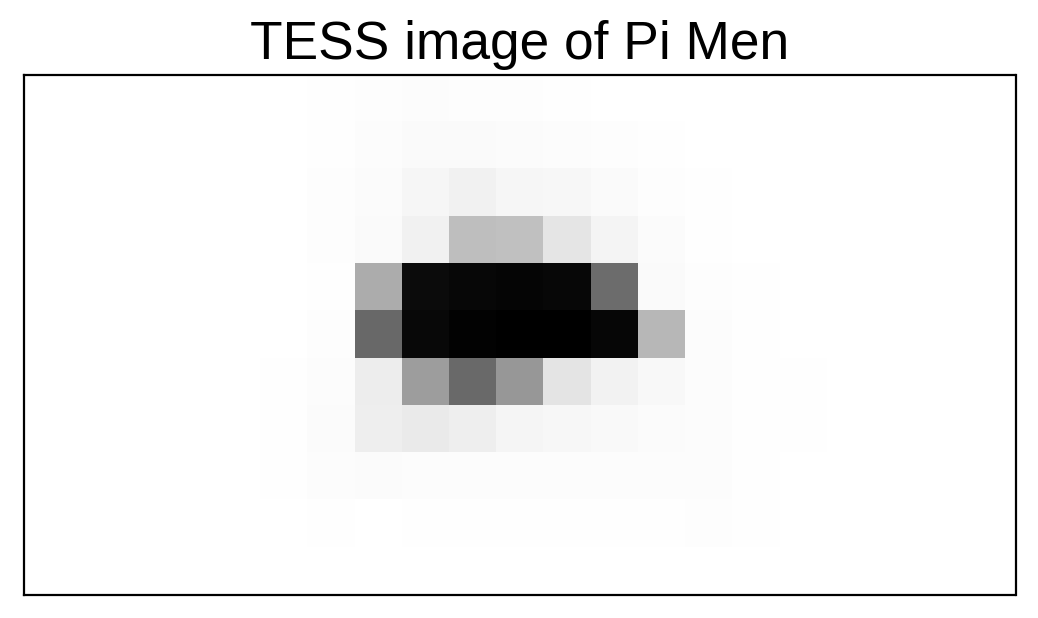

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

tpf_file = lk.search_targetpixelfile("TIC 261136679", sector=1).download()
with tpf_file.hdu as hdu:
    tpf = hdu[1].data
    tpf_hdr = hdu[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m]) + np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

## Aperture selection

Next, we'll select an aperture using a hacky method that tries to minimizes the windowed scatter in the lightcurve (something like the CDPP).

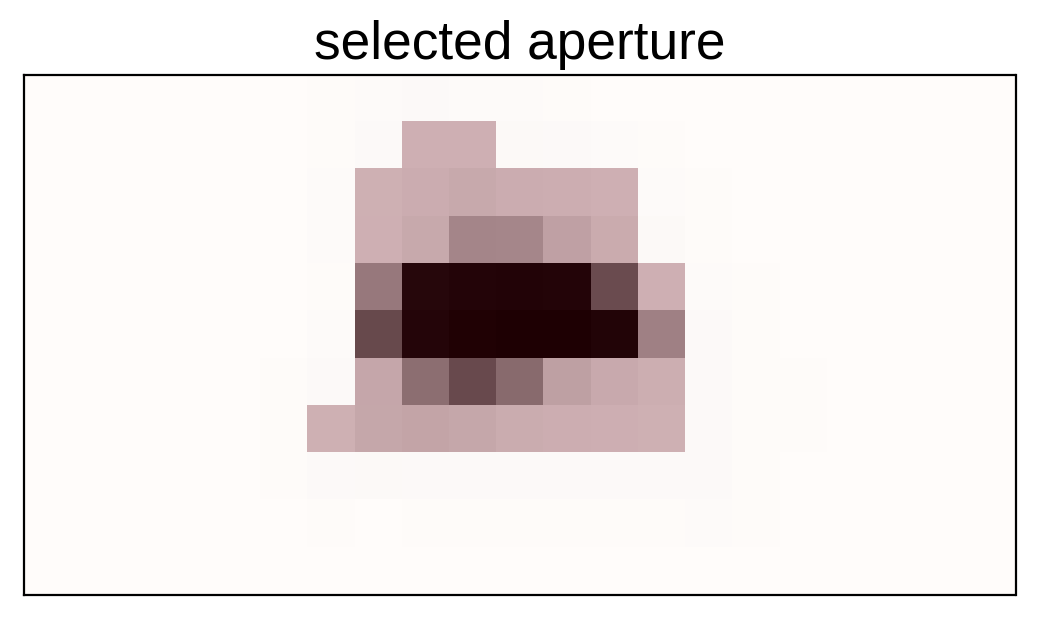

In [4]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1) ** 2))


# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

This aperture produces the following light curve:

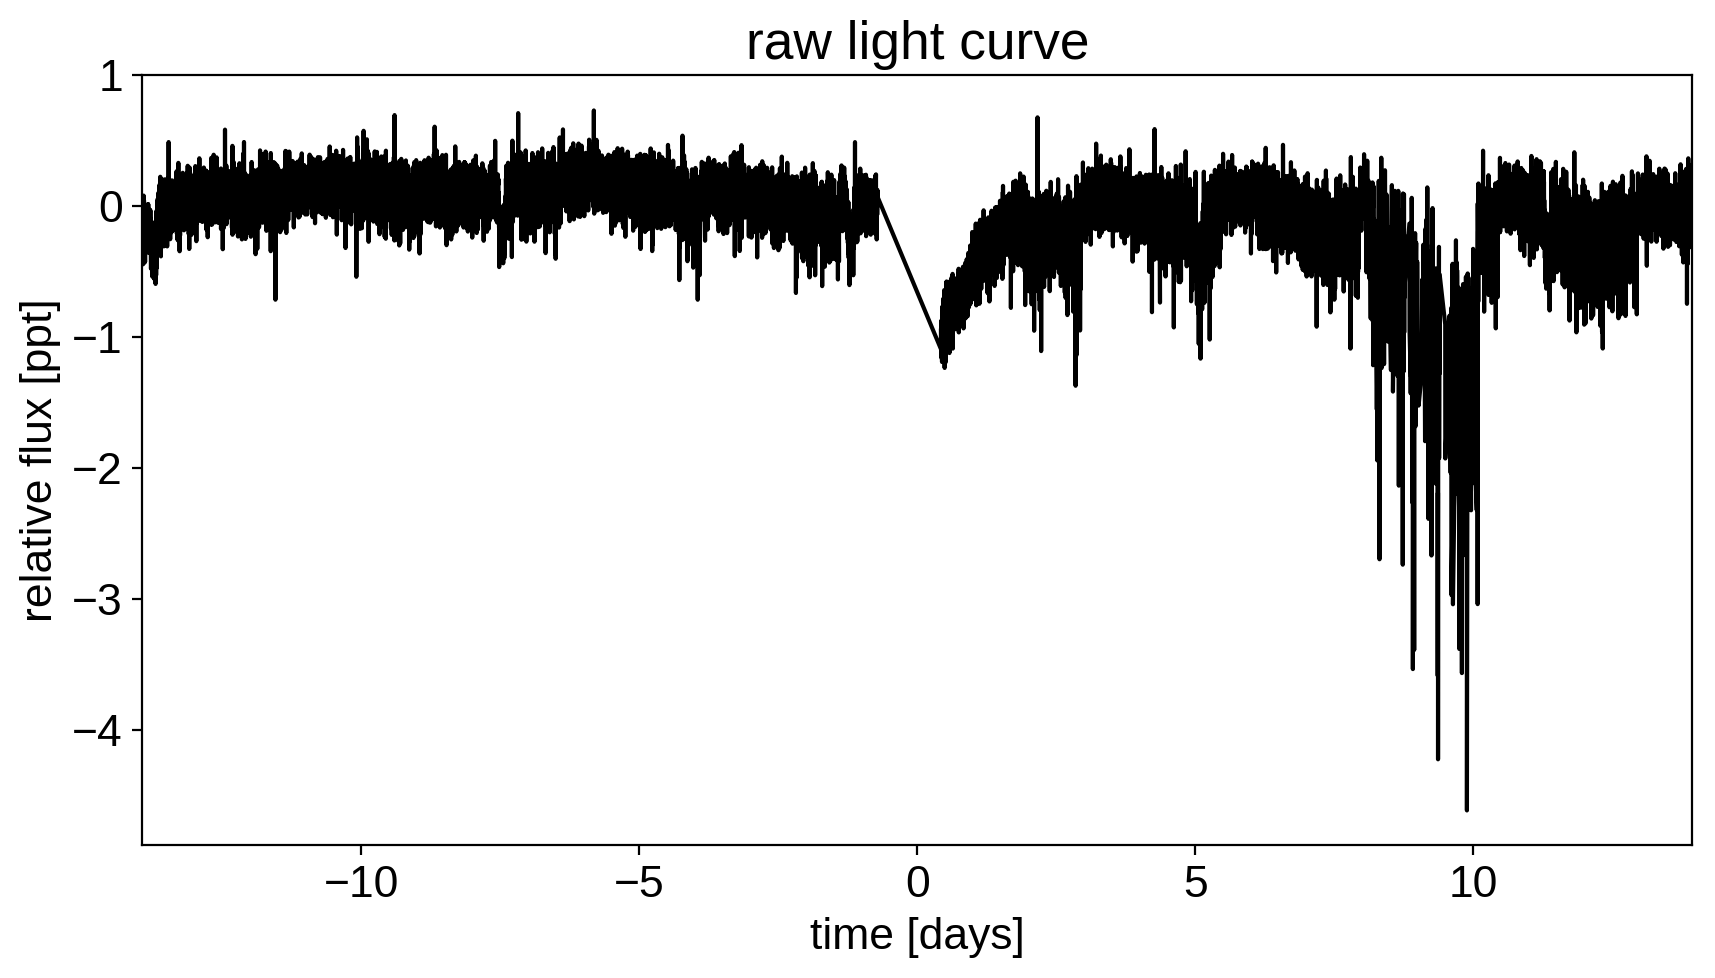

In [5]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

## De-trending

This doesn't look terrible, but we're still going to want to de-trend it a little bit.
We'll use "pixel-level deconvolution" (PLD) to de-trend following the method used by [Everest](https://github.com/rodluger/everest).
Specifically, we'll use first order PLD plus the top few PCA components of the second order PLD basis.

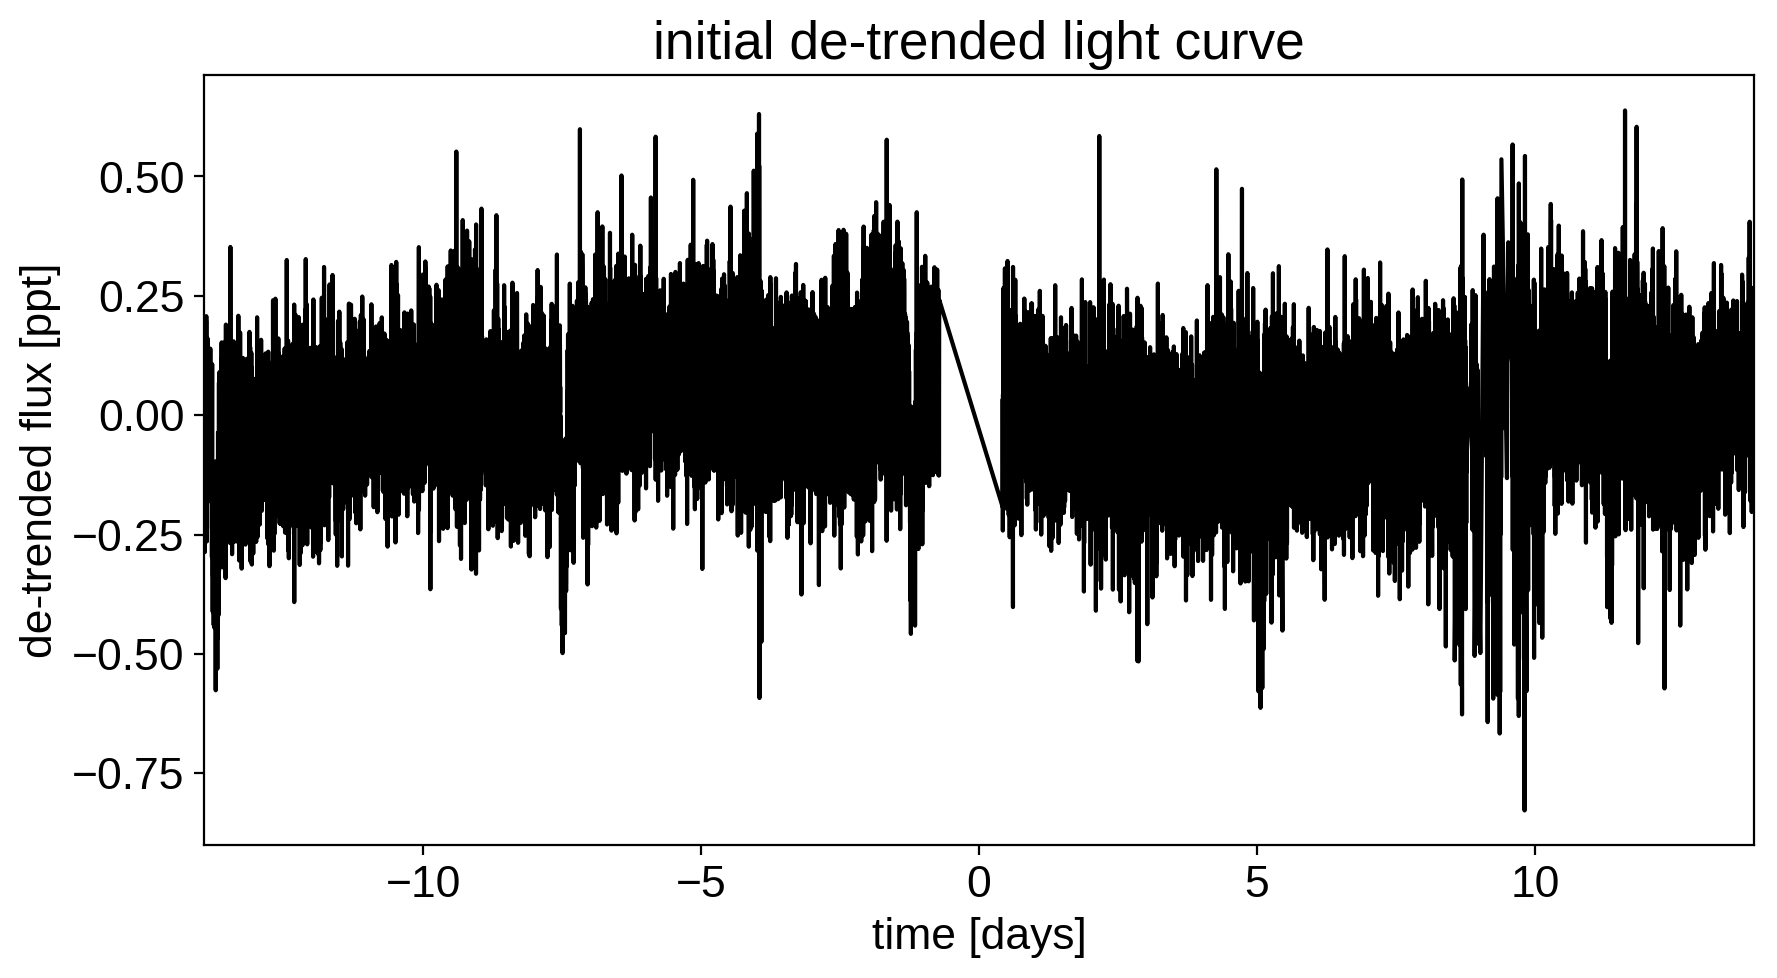

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, : X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux - pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

That looks better.

## Transit search

Now, let's use [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/timeseries/bls.html)
(Note: you'll need AstroPy v3.1 or more recent to use this feature) to estimate the period, phase, and depth of the transit.

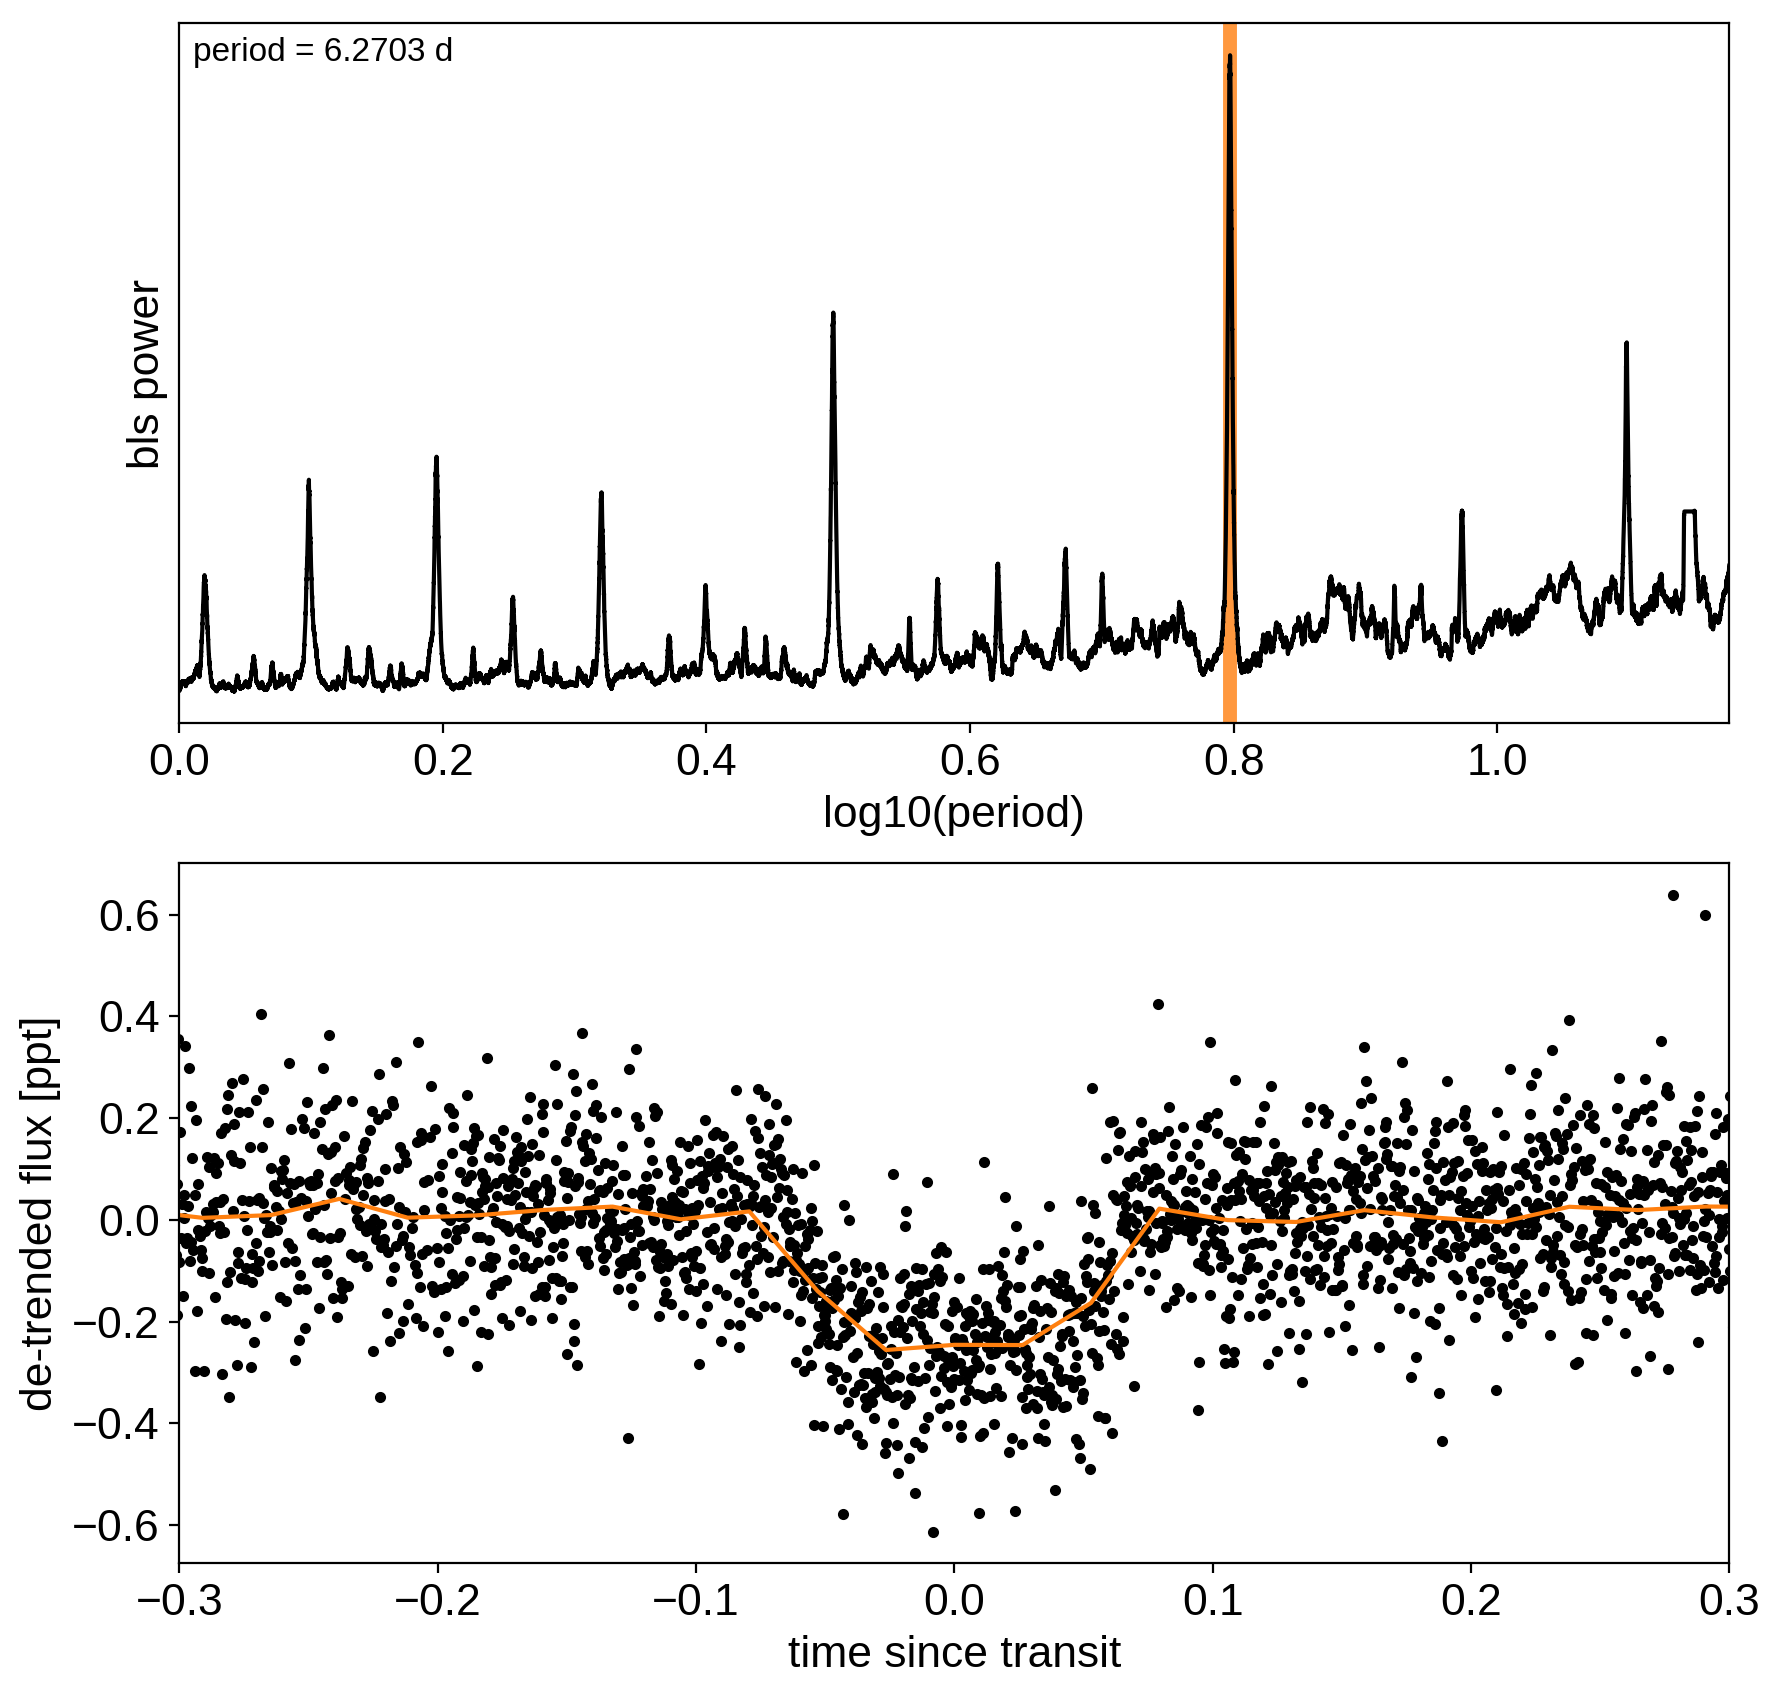

In [7]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

Now that we know where the transits are, it's generally good practice to de-trend the data one more time with the transits masked so that the de-trending doesn't overfit the transits.
Let's do that.

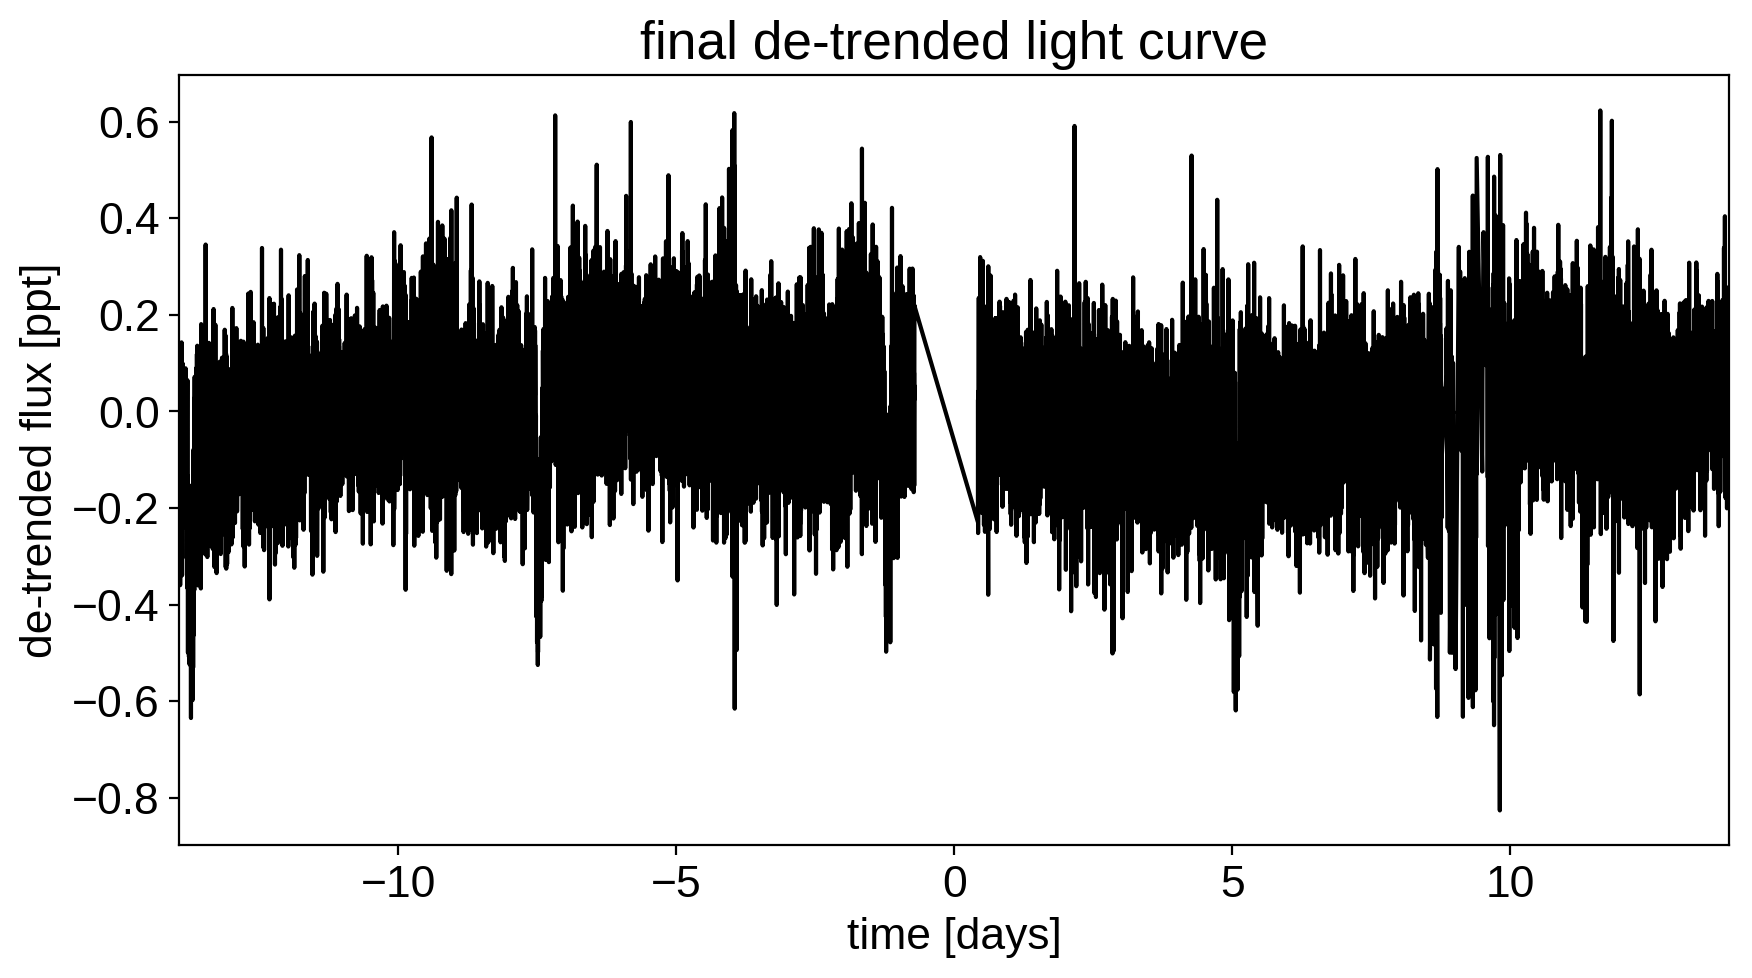

In [8]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux - pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

To confirm that we didn't overfit the transit, we can look at the folded light curve for the PLD model near trasit.
This shouldn't have any residual transit signal, and that looks correct here:

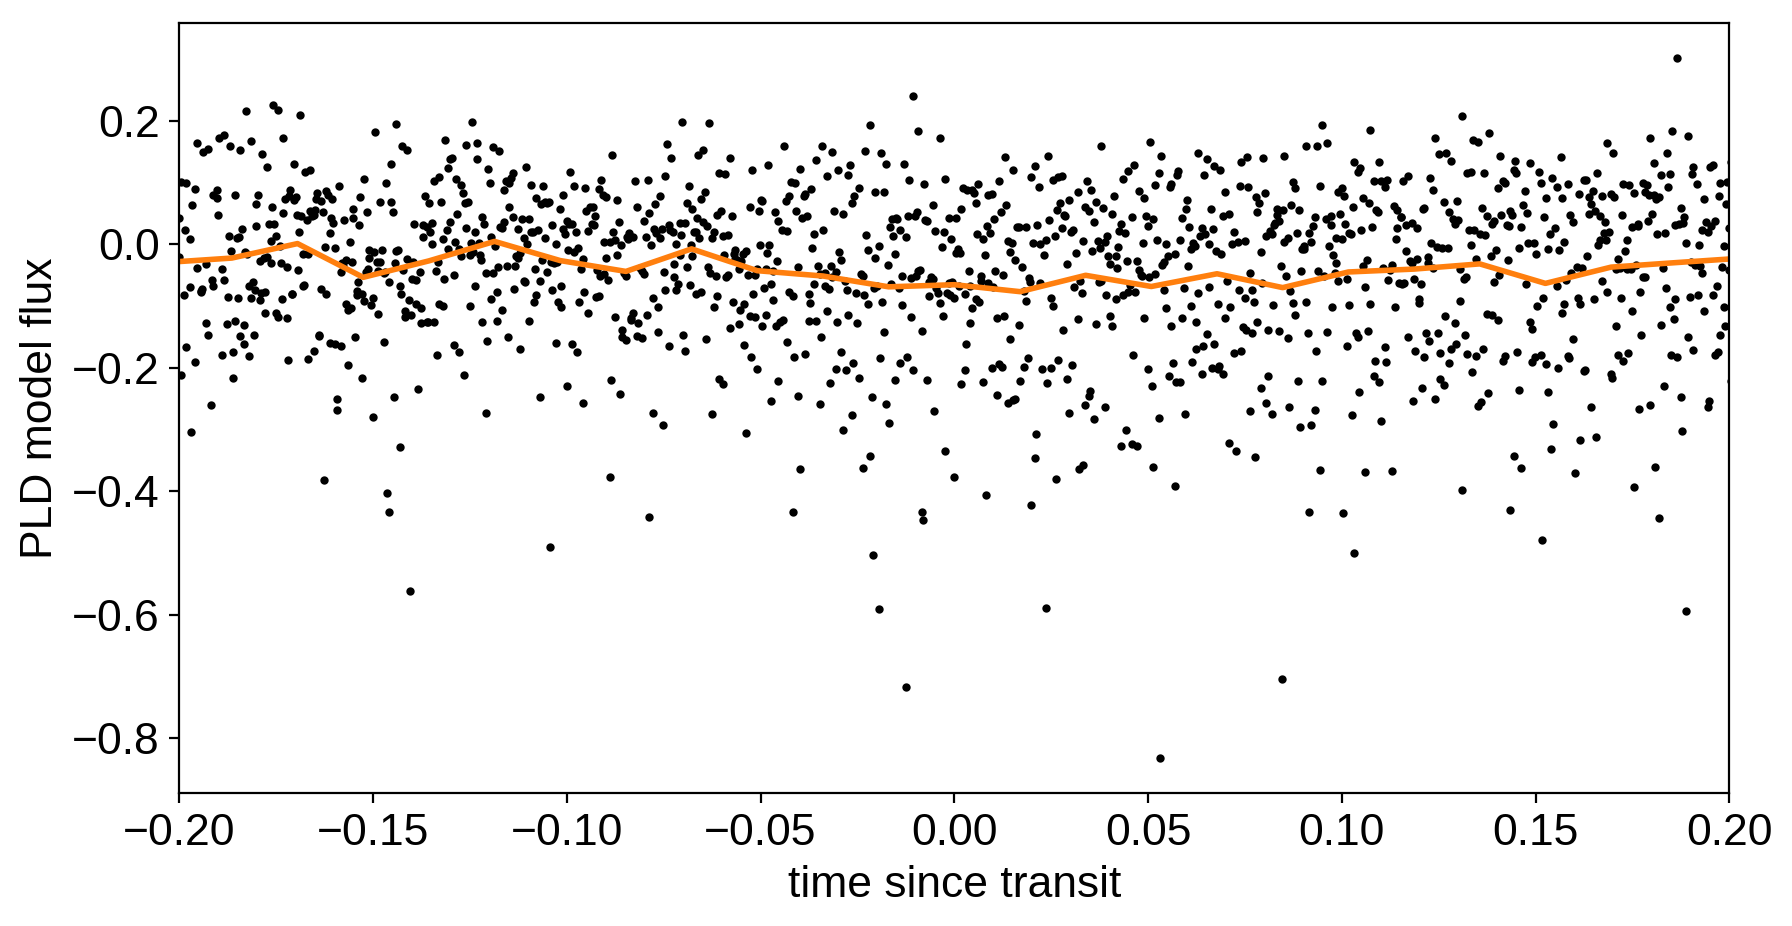

In [9]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

## The transit model in PyMC3

The transit model, initialization, and sampling are all nearly the same as the one in :ref:`together`.

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")

        # Stellar parameters from Huang et al (2018)
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_huang[0], sd=M_star_huang[1])
        r_star = BoundedNormal("r_star", mu=R_star_huang[0], sd=R_star_huang[1])

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        logr = pm.Normal(
            "logr",
            sd=1.0,
            mu=0.5 * np.log(1e-3 * np.array(bls_depth)) + np.log(R_star_huang[0]),
        )
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = xo.distributions.ImpactParameter("b", ror=ror)

        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = xo.distributions.eccentricity.kipping13("ecc", testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=0, sd=10)
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y[mask])), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve using starry
        light_curves = (
            xo.LimbDarkLightCurve(u_star).get_light_curve(
                orbit=orbit, r=r_pl, t=x[mask], texp=texp
            )
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
        map_soln = xo.optimize(start=map_soln, vars=[mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logSw4, logw0])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln


model0, map_soln0 = build_model()

optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.240606e+04]

1it [00:00, 37.87it/s, logp=1.240606e+04]

2it [00:00, 55.96it/s, logp=1.240606e+04]

3it [00:00, 65.64it/s, logp=8.845500e+03]

4it [00:00, 72.15it/s, logp=1.259726e+04]

5it [00:00, 76.35it/s, logp=1.122499e+04]

6it [00:00, 79.80it/s, logp=1.261335e+04]

7it [00:00, 82.23it/s, logp=1.263205e+04]

8it [00:00, 83.97it/s, logp=1.246006e+04]

9it [00:00, 81.31it/s, logp=1.264001e+04]

10it [00:00, 89.51it/s, logp=1.264001e+04]

10it [00:00, 89.51it/s, logp=1.263821e+04]

11it [00:00, 89.51it/s, logp=1.264216e+04]

12it [00:00, 89.51it/s, logp=1.264274e+04]

13it [00:00, 89.51it/s, logp=1.264290e+04]

14it [00:00, 89.51it/s, logp=1.264290e+04]

15it [00:00, 89.51it/s, logp=1.264290e+04]

16it [00:00, 89.51it/s, logp=1.264290e+04]

17it [00:00, 89.51it/s, logp=1.264290e+04]

18it [00:00, 86.32it/s, logp=1.264290e+04]

18it [00:00, 86.32it/s, logp=1.264290e+04]

19it [00:00, 86.32it/s, logp=1.264290e+04]

20it [00:09,  2.20it/s, logp=1.264290e+04]


message: Optimization terminated successfully.
logp: 12406.06185575557 -> 12642.89955925584


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.264290e+04]

1it [00:00, 42.62it/s, logp=1.264290e+04]

2it [00:00, 64.06it/s, logp=1.264290e+04]

3it [00:00, 76.10it/s, logp=7.847980e+03]

4it [00:00, 83.14it/s, logp=1.268102e+04]

5it [00:00, 89.49it/s, logp=1.268136e+04]

6it [00:00, 93.16it/s, logp=1.268186e+04]

7it [00:00, 95.46it/s, logp=1.268195e+04]

8it [00:00, 97.61it/s, logp=1.268195e+04]

9it [00:00, 99.85it/s, logp=1.268195e+04]

10it [00:00, 101.64it/s, logp=1.268195e+04]

11it [00:00, 103.62it/s, logp=1.268195e+04]

12it [00:00, 111.92it/s, logp=1.268195e+04]

12it [00:00, 111.92it/s, logp=1.268195e+04]

13it [00:00, 111.92it/s, logp=1.268195e+04]

14it [00:00, 111.92it/s, logp=1.268195e+04]

15it [00:00, 111.92it/s, logp=1.268195e+04]

16it [00:00, 111.92it/s, logp=1.268195e+04]

17it [00:00, 111.92it/s, logp=1.268195e+04]

18it [00:00, 111.92it/s, logp=1.268195e+04]

19it [00:00, 111.92it/s, logp=1.268195e+04]

20it [00:00, 111.92it/s, logp=1.268195e+04]

21it [00:00, 111.92it/s, logp=1.268195e+04]

22it [00:00, 111.92it/s, logp=1.268195e+04]

23it [00:00, 111.92it/s, logp=1.268195e+04]

24it [00:00, 111.92it/s, logp=1.268195e+04]

25it [00:00, 111.92it/s, logp=1.268195e+04]

26it [00:00, 116.84it/s, logp=1.268195e+04]

26it [00:00, 116.84it/s, logp=1.268195e+04]

27it [00:00, 116.84it/s, logp=1.268195e+04]

28it [00:00, 116.84it/s, logp=1.268195e+04]

29it [00:00, 116.84it/s, logp=1.268195e+04]

30it [00:00, 116.84it/s, logp=1.268195e+04]

31it [00:00, 116.84it/s, logp=1.268195e+04]

32it [00:00, 116.84it/s, logp=1.268195e+04]

33it [00:00, 116.84it/s, logp=1.268195e+04]

34it [00:00, 116.84it/s, logp=1.268195e+04]

35it [00:00, 116.84it/s, logp=1.268195e+04]

36it [00:00, 116.84it/s, logp=1.268195e+04]

37it [00:00, 116.84it/s, logp=1.268195e+04]

38it [00:00, 116.84it/s, logp=1.268195e+04]

39it [00:00, 119.07it/s, logp=1.268195e+04]

39it [00:00, 119.07it/s, logp=1.268195e+04]

40it [00:00, 119.07it/s, logp=1.268195e+04]

41it [00:00, 119.07it/s, logp=1.268195e+04]

42it [00:00, 119.07it/s, logp=1.268195e+04]

43it [00:00, 119.07it/s, logp=1.268195e+04]

44it [00:00, 119.07it/s, logp=1.268195e+04]

45it [00:00, 119.07it/s, logp=1.268195e+04]

46it [00:00, 119.07it/s, logp=1.268195e+04]

47it [00:00, 119.07it/s, logp=1.268195e+04]

48it [00:00, 119.07it/s, logp=1.268195e+04]

49it [00:00, 119.07it/s, logp=1.268195e+04]

50it [00:00, 119.07it/s, logp=1.268195e+04]

51it [00:00, 119.07it/s, logp=1.268195e+04]

52it [00:00, 120.11it/s, logp=1.268195e+04]

52it [00:00, 120.11it/s, logp=1.268195e+04]

53it [00:00, 120.11it/s, logp=1.268195e+04]

54it [00:00, 120.11it/s, logp=1.268195e+04]

55it [00:00, 120.11it/s, logp=1.268195e+04]

56it [00:00, 120.11it/s, logp=1.268195e+04]

57it [00:00, 120.11it/s, logp=1.268195e+04]

58it [00:00, 120.11it/s, logp=1.268195e+04]

59it [00:00, 120.11it/s, logp=1.268195e+04]

60it [00:00, 120.11it/s, logp=1.268195e+04]

61it [00:00, 120.11it/s, logp=1.268195e+04]

62it [00:00, 120.11it/s, logp=1.268195e+04]

63it [00:00, 120.11it/s, logp=1.268195e+04]

64it [00:00, 115.23it/s, logp=1.268195e+04]

64it [00:00, 115.23it/s, logp=1.268195e+04]

65it [00:00, 115.23it/s, logp=1.268195e+04]

66it [00:00, 115.23it/s, logp=1.268195e+04]

67it [00:00, 115.23it/s, logp=1.268195e+04]

68it [00:00, 115.23it/s, logp=1.268195e+04]

69it [00:00, 115.23it/s, logp=1.268195e+04]

70it [00:00, 115.23it/s, logp=1.268195e+04]

71it [00:00, 115.23it/s, logp=1.268195e+04]

72it [00:00, 115.23it/s, logp=1.268195e+04]

73it [00:00, 115.23it/s, logp=1.268195e+04]

74it [00:00, 107.39it/s, logp=1.268195e+04]

74it [00:00, 107.39it/s, logp=1.268195e+04]

75it [00:00, 107.39it/s, logp=1.268195e+04]

76it [00:00, 107.39it/s, logp=1.268195e+04]

77it [00:00, 107.39it/s, logp=1.268195e+04]

78it [00:00, 107.39it/s, logp=1.268195e+04]

79it [00:00, 107.39it/s, logp=1.268195e+04]

80it [00:00, 107.39it/s, logp=1.268195e+04]

81it [00:00, 107.39it/s, logp=1.268195e+04]

82it [00:00, 107.39it/s, logp=1.268195e+04]

83it [00:00, 107.39it/s, logp=1.268195e+04]

84it [00:00, 107.39it/s, logp=1.268195e+04]

85it [00:00, 107.39it/s, logp=1.268195e+04]

86it [00:00, 107.39it/s, logp=1.268195e+04]

87it [00:00, 110.19it/s, logp=1.268195e+04]

87it [00:00, 110.19it/s, logp=1.268195e+04]

88it [00:00, 110.19it/s, logp=1.268195e+04]

89it [00:00, 110.19it/s, logp=1.268195e+04]

90it [00:00, 110.19it/s, logp=1.268195e+04]

91it [00:00, 110.19it/s, logp=1.268195e+04]

92it [00:00, 110.19it/s, logp=1.268195e+04]

93it [00:00, 110.19it/s, logp=1.268195e+04]

94it [00:00, 110.19it/s, logp=1.268195e+04]

95it [00:00, 110.19it/s, logp=1.268195e+04]

96it [00:00, 110.19it/s, logp=1.268195e+04]

97it [00:00, 110.19it/s, logp=1.268195e+04]

98it [00:00, 110.19it/s, logp=1.268195e+04]

99it [00:00, 110.19it/s, logp=1.268195e+04]

100it [00:00, 115.12it/s, logp=1.268195e+04]

100it [00:00, 115.12it/s, logp=1.268195e+04]

101it [00:00, 115.12it/s, logp=1.268195e+04]

102it [00:00, 115.12it/s, logp=1.268195e+04]

103it [00:00, 115.12it/s, logp=1.268195e+04]

104it [00:00, 115.12it/s, logp=1.268195e+04]

105it [00:00, 115.12it/s, logp=1.268195e+04]

106it [00:00, 115.12it/s, logp=1.268195e+04]

107it [00:00, 115.12it/s, logp=1.268195e+04]

108it [00:00, 115.12it/s, logp=1.268195e+04]

109it [00:00, 115.12it/s, logp=1.268195e+04]

110it [00:00, 115.12it/s, logp=1.268195e+04]

111it [00:00, 115.12it/s, logp=1.268195e+04]

112it [00:00, 115.07it/s, logp=1.268195e+04]

112it [00:00, 115.07it/s, logp=1.268195e+04]

113it [00:00, 115.07it/s, logp=1.268195e+04]

114it [00:00, 115.07it/s, logp=1.268195e+04]

115it [00:00, 115.07it/s, logp=1.268195e+04]

116it [00:01, 115.07it/s, logp=1.268195e+04]

117it [00:01, 115.07it/s, logp=1.268195e+04]

118it [00:01, 115.07it/s, logp=1.268195e+04]

119it [00:01, 115.07it/s, logp=1.268195e+04]

120it [00:01, 115.07it/s, logp=1.268195e+04]

121it [00:01, 115.07it/s, logp=1.268195e+04]

122it [00:01, 115.07it/s, logp=1.268195e+04]

123it [00:01, 115.07it/s, logp=1.268195e+04]

124it [00:01, 110.92it/s, logp=1.268195e+04]

124it [00:01, 110.92it/s, logp=1.268195e+04]

125it [00:01, 110.92it/s, logp=1.268195e+04]

126it [00:01, 110.92it/s, logp=1.268195e+04]

127it [00:01, 110.92it/s, logp=1.268195e+04]

128it [00:01, 110.92it/s, logp=1.268195e+04]

129it [00:01, 110.92it/s, logp=1.268195e+04]

130it [00:01, 110.92it/s, logp=1.268195e+04]

131it [00:01, 110.92it/s, logp=1.268195e+04]

132it [00:01, 110.92it/s, logp=1.268195e+04]

133it [00:01, 110.92it/s, logp=1.268195e+04]

134it [00:01, 110.92it/s, logp=1.268195e+04]

135it [00:01, 108.49it/s, logp=1.268195e+04]

135it [00:01, 108.49it/s, logp=1.268195e+04]

136it [00:01, 108.49it/s, logp=1.268195e+04]

137it [00:01, 108.49it/s, logp=1.268195e+04]

138it [00:01, 108.49it/s, logp=1.268195e+04]

139it [00:01, 108.49it/s, logp=1.268195e+04]

140it [00:01, 108.49it/s, logp=1.268195e+04]

141it [00:01, 108.49it/s, logp=1.268195e+04]

142it [00:01, 108.49it/s, logp=1.268195e+04]

143it [00:01, 108.49it/s, logp=1.268195e+04]

144it [00:01, 108.49it/s, logp=1.268195e+04]

145it [00:01, 108.49it/s, logp=1.268195e+04]

146it [00:01, 102.81it/s, logp=1.268195e+04]

146it [00:01, 102.81it/s, logp=1.268195e+04]

147it [00:01, 102.81it/s, logp=1.268195e+04]

148it [00:01, 102.81it/s, logp=1.268195e+04]

149it [00:01, 102.81it/s, logp=1.268195e+04]

150it [00:01, 102.81it/s, logp=1.268195e+04]

151it [00:01, 102.81it/s, logp=1.268195e+04]

152it [00:01, 102.81it/s, logp=1.268195e+04]

153it [00:01, 102.81it/s, logp=1.268195e+04]

154it [00:01, 102.81it/s, logp=1.268195e+04]

155it [00:01, 102.81it/s, logp=1.268195e+04]

156it [00:01, 102.81it/s, logp=1.268195e+04]

157it [00:01, 100.28it/s, logp=1.268195e+04]

157it [00:01, 100.28it/s, logp=1.268195e+04]

158it [00:01, 100.28it/s, logp=1.268195e+04]

159it [00:01, 100.28it/s, logp=1.268195e+04]

160it [00:01, 100.28it/s, logp=1.268195e+04]

161it [00:01, 100.28it/s, logp=1.268195e+04]

162it [00:01, 100.28it/s, logp=1.268195e+04]

163it [00:01, 100.28it/s, logp=1.268195e+04]

164it [00:01, 100.28it/s, logp=1.268195e+04]

165it [00:01, 100.28it/s, logp=1.268195e+04]

166it [00:01, 100.28it/s, logp=1.268195e+04]

167it [00:01, 100.28it/s, logp=1.268195e+04]

168it [00:01, 100.28it/s, logp=1.268195e+04]

169it [00:01, 102.77it/s, logp=1.268195e+04]

169it [00:01, 102.77it/s, logp=1.268195e+04]

170it [00:01, 102.77it/s, logp=1.268195e+04]

171it [00:01, 102.77it/s, logp=1.268195e+04]

172it [00:01, 102.77it/s, logp=1.268195e+04]

173it [00:01, 102.77it/s, logp=1.268195e+04]

174it [00:01, 102.77it/s, logp=1.268195e+04]

175it [00:01, 102.77it/s, logp=1.268195e+04]

176it [00:01, 102.77it/s, logp=1.268195e+04]

177it [00:01, 102.77it/s, logp=1.268195e+04]

178it [00:01, 102.77it/s, logp=1.268195e+04]

179it [00:01, 102.77it/s, logp=1.268195e+04]

180it [00:01, 104.10it/s, logp=1.268195e+04]

180it [00:01, 104.10it/s, logp=1.268195e+04]

181it [00:01, 104.10it/s, logp=1.268195e+04]

182it [00:01, 104.10it/s, logp=1.268195e+04]

183it [00:01, 104.10it/s, logp=1.268195e+04]

184it [00:01, 104.10it/s, logp=1.268195e+04]

185it [00:01, 104.10it/s, logp=1.268195e+04]

186it [00:01, 104.10it/s, logp=1.268195e+04]

187it [00:01, 104.10it/s, logp=1.268195e+04]

188it [00:01, 104.10it/s, logp=1.268195e+04]

189it [00:01, 104.10it/s, logp=1.268195e+04]

190it [00:01, 104.10it/s, logp=1.268195e+04]

191it [00:01, 104.10it/s, logp=1.268195e+04]

192it [00:01, 104.10it/s, logp=1.268195e+04]

193it [00:01, 104.10it/s, logp=1.268195e+04]

194it [00:01, 112.04it/s, logp=1.268195e+04]

194it [00:01, 112.04it/s, logp=1.268195e+04]

195it [00:01, 112.04it/s, logp=1.268195e+04]

196it [00:01, 112.04it/s, logp=1.268195e+04]

197it [00:01, 112.04it/s, logp=1.268195e+04]

198it [00:01, 112.04it/s, logp=1.268195e+04]

199it [00:01, 112.04it/s, logp=1.268195e+04]

200it [00:01, 112.04it/s, logp=1.268195e+04]

201it [00:01, 112.04it/s, logp=1.268195e+04]

202it [00:01, 112.04it/s, logp=1.268195e+04]

203it [00:01, 112.04it/s, logp=1.268195e+04]

204it [00:01, 112.04it/s, logp=1.268195e+04]

205it [00:01, 112.04it/s, logp=1.268195e+04]

206it [00:01, 112.04it/s, logp=1.268195e+04]

207it [00:03, 66.50it/s, logp=1.268195e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12642.899559255851 -> 12681.951246651677


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.268195e+04]

1it [00:00, 50.43it/s, logp=1.268195e+04]

2it [00:00, 72.72it/s, logp=1.268195e+04]

3it [00:00, 86.08it/s, logp=1.100456e+04]

4it [00:00, 93.54it/s, logp=1.288292e+04]

5it [00:00, 95.56it/s, logp=1.281114e+04]

6it [00:00, 100.45it/s, logp=1.293580e+04]

7it [00:00, 104.03it/s, logp=1.238252e+04]

8it [00:00, 107.21it/s, logp=1.293688e+04]

9it [00:00, 109.47it/s, logp=1.293896e+04]

10it [00:00, 111.60it/s, logp=1.294512e+04]

11it [00:00, 111.53it/s, logp=1.294869e+04]

12it [00:00, 110.70it/s, logp=1.294912e+04]

13it [00:00, 119.20it/s, logp=1.294912e+04]

13it [00:00, 119.20it/s, logp=1.294928e+04]

14it [00:00, 119.20it/s, logp=1.294933e+04]

15it [00:00, 119.20it/s, logp=1.294934e+04]

16it [00:00, 119.20it/s, logp=1.294934e+04]

17it [00:00, 119.20it/s, logp=1.294934e+04]

18it [00:00, 119.20it/s, logp=1.294934e+04]

19it [00:00, 119.20it/s, logp=1.294934e+04]

20it [00:00, 119.20it/s, logp=1.294934e+04]

21it [00:00, 119.20it/s, logp=1.294934e+04]

22it [00:00, 119.20it/s, logp=1.294934e+04]

23it [00:00, 119.20it/s, logp=1.294934e+04]

24it [00:00, 119.20it/s, logp=1.294934e+04]

25it [00:00, 117.65it/s, logp=1.294934e+04]

25it [00:00, 117.65it/s, logp=1.294934e+04]

26it [00:00, 117.65it/s, logp=1.294934e+04]

27it [00:00, 117.65it/s, logp=1.294934e+04]

28it [00:00, 117.65it/s, logp=1.294934e+04]

29it [00:00, 117.65it/s, logp=1.294934e+04]

30it [00:00, 117.65it/s, logp=1.294934e+04]

31it [00:00, 117.65it/s, logp=1.294934e+04]

32it [00:00, 117.65it/s, logp=1.294934e+04]

33it [00:00, 117.65it/s, logp=1.294934e+04]

34it [00:00, 106.93it/s, logp=1.294934e+04]

34it [00:00, 106.93it/s, logp=1.294934e+04]

35it [00:00, 106.93it/s, logp=1.294934e+04]

36it [00:00, 106.93it/s, logp=1.294934e+04]

37it [00:00, 106.93it/s, logp=1.294934e+04]

38it [00:00, 106.93it/s, logp=1.294934e+04]

39it [00:00, 106.93it/s, logp=1.294934e+04]

40it [00:00, 106.93it/s, logp=1.294934e+04]

41it [00:00, 106.93it/s, logp=1.294934e+04]

42it [00:00, 106.93it/s, logp=1.294934e+04]

43it [00:00, 99.49it/s, logp=1.294934e+04] 

43it [00:00, 99.49it/s, logp=1.294934e+04]

44it [00:00, 99.49it/s, logp=1.294934e+04]

45it [00:00, 99.49it/s, logp=1.294934e+04]

46it [00:00, 99.49it/s, logp=1.294934e+04]

47it [00:00, 99.49it/s, logp=1.294934e+04]

48it [00:00, 99.49it/s, logp=1.294934e+04]

49it [00:00, 99.49it/s, logp=1.294934e+04]

50it [00:00, 99.49it/s, logp=1.294934e+04]

51it [00:00, 99.49it/s, logp=1.294934e+04]

52it [00:00, 99.49it/s, logp=1.294934e+04]

53it [00:00, 99.49it/s, logp=1.294934e+04]

54it [00:00, 101.44it/s, logp=1.294934e+04]

54it [00:00, 101.44it/s, logp=1.294934e+04]

55it [00:00, 101.44it/s, logp=1.294934e+04]

56it [00:00, 101.44it/s, logp=1.294934e+04]

57it [00:00, 101.44it/s, logp=1.294934e+04]

58it [00:00, 101.44it/s, logp=1.294934e+04]

59it [00:00, 101.44it/s, logp=1.294934e+04]

60it [00:00, 101.44it/s, logp=1.294934e+04]

61it [00:00, 101.44it/s, logp=1.294934e+04]

62it [00:00, 101.44it/s, logp=1.294934e+04]

63it [00:00, 101.44it/s, logp=1.294934e+04]

64it [00:01, 33.35it/s, logp=1.294934e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12681.951246651677 -> 12949.339148287803


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.294934e+04]

1it [00:00, 52.49it/s, logp=1.294934e+04]

2it [00:00, 53.31it/s, logp=1.294934e+04]

3it [00:00, 58.24it/s, logp=1.167030e+04]

4it [00:00, 57.14it/s, logp=1.191116e+04]

5it [00:00, 61.36it/s, logp=1.227221e+04]

6it [00:00, 65.91it/s, logp=1.219656e+04]

7it [00:00, 69.07it/s, logp=1.261034e+04]

8it [00:00, 78.35it/s, logp=1.261034e+04]

8it [00:00, 78.35it/s, logp=1.295942e+04]

9it [00:00, 78.35it/s, logp=1.292562e+04]

10it [00:00, 78.35it/s, logp=1.296212e+04]

11it [00:00, 78.35it/s, logp=1.296041e+04]

12it [00:00, 78.35it/s, logp=1.296366e+04]

13it [00:00, 78.35it/s, logp=1.296367e+04]

14it [00:00, 78.35it/s, logp=1.296368e+04]

15it [00:00, 78.35it/s, logp=1.296370e+04]

16it [00:00, 78.35it/s, logp=1.296371e+04]

17it [00:00, 78.35it/s, logp=1.296373e+04]

18it [00:00, 78.35it/s, logp=1.296374e+04]

19it [00:00, 78.35it/s, logp=1.296374e+04]

20it [00:00, 78.35it/s, logp=1.296374e+04]

21it [00:00, 88.83it/s, logp=1.296374e+04]

21it [00:00, 88.83it/s, logp=1.296374e+04]

22it [00:00, 88.83it/s, logp=1.296374e+04]

23it [00:00, 88.83it/s, logp=1.296374e+04]

24it [00:00, 88.83it/s, logp=1.296374e+04]

25it [00:00, 88.83it/s, logp=1.296374e+04]

26it [00:00, 88.83it/s, logp=1.296374e+04]

27it [00:00, 88.83it/s, logp=1.296374e+04]

28it [00:00, 88.83it/s, logp=1.296374e+04]

29it [00:00, 88.83it/s, logp=1.296374e+04]

30it [00:00, 88.83it/s, logp=1.296374e+04]

31it [00:00, 88.83it/s, logp=1.296374e+04]

32it [00:00, 88.83it/s, logp=1.296374e+04]

33it [00:00, 88.83it/s, logp=1.296374e+04]

34it [00:00, 98.13it/s, logp=1.296374e+04]

34it [00:00, 98.13it/s, logp=1.296374e+04]

35it [00:00, 98.13it/s, logp=1.296374e+04]

36it [00:00, 98.13it/s, logp=1.296374e+04]

37it [00:00, 98.13it/s, logp=1.296374e+04]

38it [00:00, 98.13it/s, logp=1.296374e+04]

39it [00:00, 98.13it/s, logp=1.296374e+04]

40it [00:00, 98.13it/s, logp=1.296374e+04]

41it [00:00, 98.13it/s, logp=1.296374e+04]

42it [00:00, 98.13it/s, logp=1.296374e+04]

43it [00:00, 98.13it/s, logp=1.296374e+04]

44it [00:00, 98.13it/s, logp=1.296374e+04]

45it [00:00, 98.13it/s, logp=1.296374e+04]

46it [00:00, 103.19it/s, logp=1.296374e+04]

46it [00:00, 103.19it/s, logp=1.296374e+04]

47it [00:00, 103.19it/s, logp=1.296374e+04]

48it [00:00, 103.19it/s, logp=1.296374e+04]

49it [00:00, 103.19it/s, logp=1.296374e+04]

50it [00:00, 103.19it/s, logp=1.296374e+04]

51it [00:00, 103.19it/s, logp=1.296374e+04]

52it [00:00, 103.19it/s, logp=1.296374e+04]

53it [00:00, 103.19it/s, logp=1.296374e+04]

54it [00:00, 103.19it/s, logp=1.296374e+04]

55it [00:00, 103.19it/s, logp=1.296374e+04]

56it [00:00, 103.19it/s, logp=1.296374e+04]

57it [00:00, 103.19it/s, logp=1.296374e+04]

58it [00:00, 107.14it/s, logp=1.296374e+04]

58it [00:00, 107.14it/s, logp=1.296374e+04]

59it [00:00, 107.14it/s, logp=1.296374e+04]

60it [00:00, 107.14it/s, logp=1.296374e+04]

61it [00:00, 107.14it/s, logp=1.296374e+04]

62it [00:00, 107.14it/s, logp=1.296374e+04]

63it [00:00, 107.14it/s, logp=1.296374e+04]

64it [00:00, 107.14it/s, logp=1.296374e+04]

65it [00:00, 107.14it/s, logp=1.296374e+04]

66it [00:00, 107.14it/s, logp=1.296374e+04]

67it [00:00, 107.14it/s, logp=1.296374e+04]

68it [00:00, 107.14it/s, logp=1.296374e+04]

69it [00:00, 107.14it/s, logp=1.296374e+04]

70it [00:00, 107.14it/s, logp=1.296374e+04]

71it [00:00, 110.21it/s, logp=1.296374e+04]

71it [00:00, 110.21it/s, logp=1.296374e+04]

72it [00:00, 110.21it/s, logp=1.296374e+04]

73it [00:00, 110.21it/s, logp=1.296374e+04]

74it [00:00, 110.21it/s, logp=1.296374e+04]

75it [00:00, 110.21it/s, logp=1.296374e+04]

76it [00:00, 110.21it/s, logp=1.296374e+04]

77it [00:00, 110.21it/s, logp=1.296374e+04]

78it [00:00, 110.21it/s, logp=1.296374e+04]

79it [00:00, 110.21it/s, logp=1.296374e+04]

80it [00:00, 110.21it/s, logp=1.296374e+04]

81it [00:00, 110.21it/s, logp=1.296374e+04]

82it [00:00, 110.21it/s, logp=1.296374e+04]

83it [00:00, 110.21it/s, logp=1.296374e+04]

84it [00:00, 113.72it/s, logp=1.296374e+04]

84it [00:00, 113.72it/s, logp=1.296374e+04]

85it [00:00, 113.72it/s, logp=1.296374e+04]

86it [00:00, 113.72it/s, logp=1.296374e+04]

87it [00:00, 113.72it/s, logp=1.296374e+04]

88it [00:00, 113.72it/s, logp=1.296374e+04]

89it [00:00, 113.72it/s, logp=1.296374e+04]

90it [00:00, 113.72it/s, logp=1.296374e+04]

91it [00:00, 113.72it/s, logp=1.296374e+04]

92it [00:00, 113.72it/s, logp=1.296374e+04]

93it [00:00, 113.72it/s, logp=1.296374e+04]

94it [00:00, 113.72it/s, logp=1.296374e+04]

95it [00:00, 113.72it/s, logp=1.296374e+04]

96it [00:00, 113.72it/s, logp=1.296374e+04]

97it [00:00, 117.56it/s, logp=1.296374e+04]

97it [00:00, 117.56it/s, logp=1.296374e+04]

98it [00:00, 117.56it/s, logp=1.296374e+04]

99it [00:02, 48.84it/s, logp=1.296374e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 12949.339148287796 -> 12963.740755133214


optimizing logp for variables: [u_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296374e+04]

1it [00:00, 51.74it/s, logp=1.296374e+04]

2it [00:00, 75.59it/s, logp=1.296374e+04]

3it [00:00, 88.05it/s, logp=1.296464e+04]

4it [00:00, 96.24it/s, logp=1.296597e+04]

5it [00:00, 101.90it/s, logp=1.296651e+04]

6it [00:00, 105.58it/s, logp=1.296660e+04]

7it [00:00, 109.17it/s, logp=1.296662e+04]

8it [00:00, 111.59it/s, logp=1.296662e+04]

9it [00:00, 113.18it/s, logp=1.296662e+04]

10it [00:00, 114.10it/s, logp=1.296662e+04]

11it [00:00, 115.72it/s, logp=1.296662e+04]

12it [00:01, 11.31it/s, logp=1.296662e+04] 


message: Optimization terminated successfully.
logp: 12963.740755133207 -> 12966.624941258444


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296662e+04]

1it [00:00, 54.15it/s, logp=1.296662e+04]

2it [00:00, 76.88it/s, logp=1.296662e+04]

3it [00:00, 89.61it/s, logp=-5.403750e+03]

4it [00:00, 95.46it/s, logp=1.285695e+04] 

5it [00:00, 100.36it/s, logp=1.296682e+04]

6it [00:00, 104.35it/s, logp=1.296682e+04]

7it [00:00, 106.43it/s, logp=1.296682e+04]

8it [00:00, 108.07it/s, logp=1.296682e+04]

9it [00:01,  6.81it/s, logp=1.296682e+04] 


message: Optimization terminated successfully.
logp: 12966.624941258455 -> 12966.818870393383


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296682e+04]

1it [00:00, 41.98it/s, logp=1.296682e+04]

2it [00:00, 47.43it/s, logp=1.296682e+04]

3it [00:00, 54.59it/s, logp=7.840564e+03]

4it [00:00, 62.55it/s, logp=1.295556e+04]

5it [00:00, 69.23it/s, logp=1.296691e+04]

6it [00:00, 73.44it/s, logp=1.296674e+04]

7it [00:00, 77.81it/s, logp=1.296694e+04]

8it [00:00, 81.99it/s, logp=1.296681e+04]

9it [00:00, 85.76it/s, logp=1.296694e+04]

10it [00:00, 94.50it/s, logp=1.296694e+04]

10it [00:00, 94.50it/s, logp=1.296694e+04]

11it [00:00, 94.50it/s, logp=1.296694e+04]

12it [00:00, 94.50it/s, logp=1.296694e+04]

13it [00:00, 94.50it/s, logp=1.296694e+04]

14it [00:00, 94.50it/s, logp=1.296694e+04]

15it [00:00, 94.50it/s, logp=1.296694e+04]

16it [00:01, 11.19it/s, logp=1.296694e+04]


message: Optimization terminated successfully.
logp: 12966.818870393383 -> 12966.944430577478


optimizing logp for variables: [omega, ecc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.296694e+04]

1it [00:00, 42.29it/s, logp=1.296694e+04]

2it [00:00, 62.78it/s, logp=1.296694e+04]

3it [00:00, 75.05it/s, logp=1.297940e+04]

4it [00:00, 83.76it/s, logp=1.297518e+04]

5it [00:00, 90.17it/s, logp=1.298066e+04]

6it [00:00, 94.01it/s, logp=1.298298e+04]

7it [00:00, 97.72it/s, logp=1.298128e+04]

8it [00:00, 100.85it/s, logp=1.298472e+04]

9it [00:00, 103.10it/s, logp=1.298691e+04]

10it [00:00, 104.94it/s, logp=1.298629e+04]

11it [00:00, 106.90it/s, logp=1.298755e+04]

12it [00:00, 115.98it/s, logp=1.298755e+04]

12it [00:00, 115.98it/s, logp=1.298777e+04]

13it [00:00, 115.98it/s, logp=1.298779e+04]

14it [00:00, 115.98it/s, logp=1.298780e+04]

15it [00:00, 115.98it/s, logp=1.298780e+04]

16it [00:00, 115.98it/s, logp=1.298781e+04]

17it [00:00, 115.98it/s, logp=1.298782e+04]

18it [00:00, 115.98it/s, logp=1.298782e+04]

19it [00:00, 115.98it/s, logp=1.298782e+04]

20it [00:00, 115.98it/s, logp=1.298782e+04]

21it [00:00, 115.98it/s, logp=1.298782e+04]

22it [00:00, 115.98it/s, logp=1.298782e+04]

23it [00:01, 15.09it/s, logp=1.298782e+04] 


message: Optimization terminated successfully.
logp: 12966.944430577478 -> 12987.822019225678


optimizing logp for variables: [mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.298782e+04]

1it [00:00, 44.18it/s, logp=1.298782e+04]

2it [00:00, 61.23it/s, logp=1.298782e+04]

3it [00:00, 70.14it/s, logp=2.419262e+03]

4it [00:00, 74.71it/s, logp=1.298785e+04]

5it [00:01,  3.06it/s, logp=1.298785e+04]


message: Optimization terminated successfully.
logp: 12987.822019225663 -> 12987.85030612374


optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.298785e+04]

1it [00:00, 29.54it/s, logp=1.298785e+04]

2it [00:00, 41.66it/s, logp=1.298785e+04]

3it [00:00, 48.30it/s, logp=6.759967e+03]

4it [00:00, 54.80it/s, logp=1.298932e+04]

5it [00:00, 59.80it/s, logp=1.299055e+04]

6it [00:00, 63.38it/s, logp=1.299284e+04]

7it [00:00, 65.50it/s, logp=1.299651e+04]

8it [00:00, 74.23it/s, logp=1.299651e+04]

8it [00:00, 74.23it/s, logp=1.299858e+04]

9it [00:00, 74.23it/s, logp=1.299864e+04]

10it [00:00, 74.23it/s, logp=1.299865e+04]

11it [00:00, 74.23it/s, logp=1.299865e+04]

12it [00:00, 74.23it/s, logp=1.299865e+04]

13it [00:00, 74.23it/s, logp=1.299865e+04]

14it [00:00, 74.23it/s, logp=1.299865e+04]

15it [00:00, 74.23it/s, logp=1.299865e+04]

16it [00:00, 74.23it/s, logp=1.299865e+04]

17it [00:00, 76.48it/s, logp=1.299865e+04]

17it [00:00, 76.48it/s, logp=1.299865e+04]

18it [00:00, 76.48it/s, logp=1.299865e+04]

19it [00:00, 76.48it/s, logp=1.299865e+04]

20it [00:00, 76.48it/s, logp=1.299865e+04]

21it [00:00, 76.48it/s, logp=1.299865e+04]

22it [00:00, 76.48it/s, logp=1.299865e+04]

23it [00:00, 76.48it/s, logp=1.299865e+04]

24it [00:00, 76.48it/s, logp=1.299865e+04]

25it [00:00, 76.48it/s, logp=1.299865e+04]

26it [00:00, 79.44it/s, logp=1.299865e+04]

26it [00:00, 79.44it/s, logp=1.299865e+04]

27it [00:00, 79.44it/s, logp=1.299865e+04]

28it [00:00, 79.44it/s, logp=1.299865e+04]

29it [00:00, 79.44it/s, logp=1.299865e+04]

30it [00:00, 79.44it/s, logp=1.299865e+04]

31it [00:00, 79.44it/s, logp=1.299865e+04]

32it [00:00, 79.44it/s, logp=1.299865e+04]

33it [00:00, 79.44it/s, logp=1.299865e+04]

34it [00:00, 79.44it/s, logp=1.299865e+04]

35it [00:00, 82.11it/s, logp=1.299865e+04]

35it [00:00, 82.11it/s, logp=1.299865e+04]

36it [00:00, 82.11it/s, logp=1.299865e+04]

37it [00:00, 82.11it/s, logp=1.299865e+04]

38it [00:00, 82.11it/s, logp=1.299865e+04]

39it [00:00, 82.11it/s, logp=1.299865e+04]

40it [00:00, 82.11it/s, logp=1.299865e+04]

41it [00:00, 82.11it/s, logp=1.299865e+04]

42it [00:00, 82.11it/s, logp=1.299865e+04]

43it [00:00, 82.11it/s, logp=1.299865e+04]

44it [00:00, 82.11it/s, logp=1.299865e+04]

45it [00:00, 86.74it/s, logp=1.299865e+04]

45it [00:00, 86.74it/s, logp=1.299865e+04]

46it [00:00, 86.74it/s, logp=1.299865e+04]

47it [00:01, 27.03it/s, logp=1.299865e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12987.85030612374 -> 12998.653500794684


optimizing logp for variables: [logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, b, logr, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.299865e+04]

1it [00:00, 31.35it/s, logp=1.299865e+04]

2it [00:00, 42.04it/s, logp=1.299865e+04]

3it [00:00, 49.23it/s, logp=1.219653e+04]

4it [00:00, 54.41it/s, logp=1.223353e+04]

5it [00:00, 58.14it/s, logp=1.207811e+04]

6it [00:00, 60.56it/s, logp=1.296083e+04]

7it [00:00, 62.25it/s, logp=1.299866e+04]

8it [00:00, 70.73it/s, logp=1.299866e+04]

8it [00:00, 70.73it/s, logp=1.299869e+04]

9it [00:00, 70.73it/s, logp=1.299874e+04]

10it [00:00, 70.73it/s, logp=1.299886e+04]

11it [00:00, 70.73it/s, logp=1.299934e+04]

12it [00:00, 70.73it/s, logp=1.300122e+04]

13it [00:00, 70.73it/s, logp=1.300824e+04]

14it [00:00, 70.73it/s, logp=1.301600e+04]

15it [00:00, 70.73it/s, logp=1.301563e+04]

16it [00:00, 71.10it/s, logp=1.301563e+04]

16it [00:00, 71.10it/s, logp=1.301952e+04]

17it [00:00, 71.10it/s, logp=1.281690e+04]

18it [00:00, 71.10it/s, logp=1.301958e+04]

19it [00:00, 71.10it/s, logp=1.301970e+04]

20it [00:00, 71.10it/s, logp=1.302009e+04]

21it [00:00, 71.10it/s, logp=1.302108e+04]

22it [00:00, 71.10it/s, logp=1.302279e+04]

23it [00:00, 71.10it/s, logp=1.302617e+04]

24it [00:00, 71.25it/s, logp=1.302617e+04]

24it [00:00, 71.25it/s, logp=1.303746e+04]

25it [00:00, 71.25it/s, logp=1.301337e+04]

26it [00:00, 71.25it/s, logp=1.304275e+04]

27it [00:00, 71.25it/s, logp=1.302355e+04]

28it [00:00, 71.25it/s, logp=1.304425e+04]

29it [00:00, 71.25it/s, logp=1.304408e+04]

30it [00:00, 71.25it/s, logp=1.304502e+04]

31it [00:00, 71.25it/s, logp=1.304645e+04]

32it [00:00, 71.39it/s, logp=1.304645e+04]

32it [00:00, 71.39it/s, logp=1.304886e+04]

33it [00:00, 71.39it/s, logp=1.305172e+04]

34it [00:00, 71.39it/s, logp=1.305199e+04]

35it [00:00, 71.39it/s, logp=1.305323e+04]

36it [00:00, 71.39it/s, logp=1.305313e+04]

37it [00:00, 71.39it/s, logp=1.305351e+04]

38it [00:00, 71.39it/s, logp=1.305332e+04]

39it [00:00, 71.39it/s, logp=1.305359e+04]

40it [00:00, 72.86it/s, logp=1.305359e+04]

40it [00:00, 72.86it/s, logp=1.305361e+04]

41it [00:00, 72.86it/s, logp=1.305361e+04]

42it [00:00, 72.86it/s, logp=1.305362e+04]

43it [00:00, 72.86it/s, logp=1.305363e+04]

44it [00:00, 72.86it/s, logp=1.305372e+04]

45it [00:00, 72.86it/s, logp=1.305283e+04]

46it [00:00, 72.86it/s, logp=1.305420e+04]

47it [00:00, 72.86it/s, logp=1.305435e+04]

48it [00:00, 72.86it/s, logp=1.248953e+04]

49it [00:00, 76.85it/s, logp=1.248953e+04]

49it [00:00, 76.85it/s, logp=1.305435e+04]

50it [00:00, 76.85it/s, logp=1.305435e+04]

51it [00:00, 76.85it/s, logp=1.305435e+04]

52it [00:00, 76.85it/s, logp=1.305436e+04]

53it [00:00, 76.85it/s, logp=1.305441e+04]

54it [00:00, 76.85it/s, logp=1.305452e+04]

55it [00:00, 76.85it/s, logp=1.305470e+04]

56it [00:00, 76.85it/s, logp=1.305480e+04]

57it [00:00, 77.23it/s, logp=1.305480e+04]

57it [00:00, 77.23it/s, logp=1.305480e+04]

58it [00:00, 77.23it/s, logp=1.305480e+04]

59it [00:00, 77.23it/s, logp=1.305481e+04]

60it [00:00, 77.23it/s, logp=1.305481e+04]

61it [00:00, 77.23it/s, logp=1.305481e+04]

62it [00:00, 77.23it/s, logp=1.305482e+04]

63it [00:00, 77.23it/s, logp=1.305482e+04]

64it [00:00, 77.23it/s, logp=1.305482e+04]

65it [00:00, 73.49it/s, logp=1.305482e+04]

65it [00:00, 73.49it/s, logp=1.305483e+04]

66it [00:00, 73.49it/s, logp=1.305483e+04]

67it [00:00, 73.49it/s, logp=1.305483e+04]

68it [00:00, 73.49it/s, logp=1.305483e+04]

69it [00:00, 73.49it/s, logp=1.305483e+04]

70it [00:00, 73.49it/s, logp=1.305483e+04]

71it [00:00, 73.49it/s, logp=1.305483e+04]

72it [00:00, 73.49it/s, logp=1.305483e+04]

73it [00:00, 73.49it/s, logp=1.305483e+04]

74it [00:00, 76.14it/s, logp=1.305483e+04]

74it [00:00, 76.14it/s, logp=1.305483e+04]

75it [00:01, 76.14it/s, logp=1.305483e+04]

76it [00:01, 76.14it/s, logp=1.305483e+04]

77it [00:01, 76.14it/s, logp=1.305483e+04]

78it [00:01, 76.14it/s, logp=1.305483e+04]

79it [00:01, 76.14it/s, logp=1.305483e+04]

80it [00:01, 76.14it/s, logp=1.305483e+04]

81it [00:01, 76.14it/s, logp=1.305483e+04]

82it [00:01, 76.14it/s, logp=1.305483e+04]

83it [00:01, 79.28it/s, logp=1.305483e+04]

83it [00:01, 79.28it/s, logp=1.305483e+04]

84it [00:01, 79.28it/s, logp=1.305483e+04]

85it [00:01, 79.28it/s, logp=1.305483e+04]

86it [00:01, 79.28it/s, logp=1.305483e+04]

87it [00:01, 79.28it/s, logp=1.305483e+04]

88it [00:01, 79.28it/s, logp=1.305483e+04]

89it [00:01, 79.28it/s, logp=1.305483e+04]

90it [00:01, 79.28it/s, logp=1.305483e+04]

91it [00:01, 79.28it/s, logp=1.305483e+04]

92it [00:01, 81.15it/s, logp=1.305483e+04]

92it [00:01, 81.15it/s, logp=1.305483e+04]

93it [00:01, 81.15it/s, logp=1.305483e+04]

94it [00:01, 81.15it/s, logp=1.305483e+04]

95it [00:01, 81.15it/s, logp=1.305483e+04]

96it [00:01, 81.15it/s, logp=1.305483e+04]

97it [00:01, 81.15it/s, logp=1.305483e+04]

98it [00:01, 81.15it/s, logp=1.305483e+04]

99it [00:01, 81.15it/s, logp=1.305483e+04]

100it [00:01, 81.15it/s, logp=1.305483e+04]

101it [00:01, 79.25it/s, logp=1.305483e+04]

101it [00:01, 79.25it/s, logp=1.305483e+04]

102it [00:01, 79.25it/s, logp=1.305483e+04]

103it [00:01, 79.25it/s, logp=1.305483e+04]

104it [00:01, 79.25it/s, logp=1.305483e+04]

105it [00:01, 79.25it/s, logp=1.305483e+04]

106it [00:01, 79.25it/s, logp=1.305483e+04]

107it [00:01, 79.25it/s, logp=1.305483e+04]

108it [00:01, 79.25it/s, logp=1.305483e+04]

109it [00:01, 79.25it/s, logp=1.305483e+04]

110it [00:01, 79.25it/s, logp=1.305483e+04]

111it [00:01, 82.65it/s, logp=1.305483e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 12998.653500794699 -> 13054.830649513216


Here's how we plot the initial light curve model:

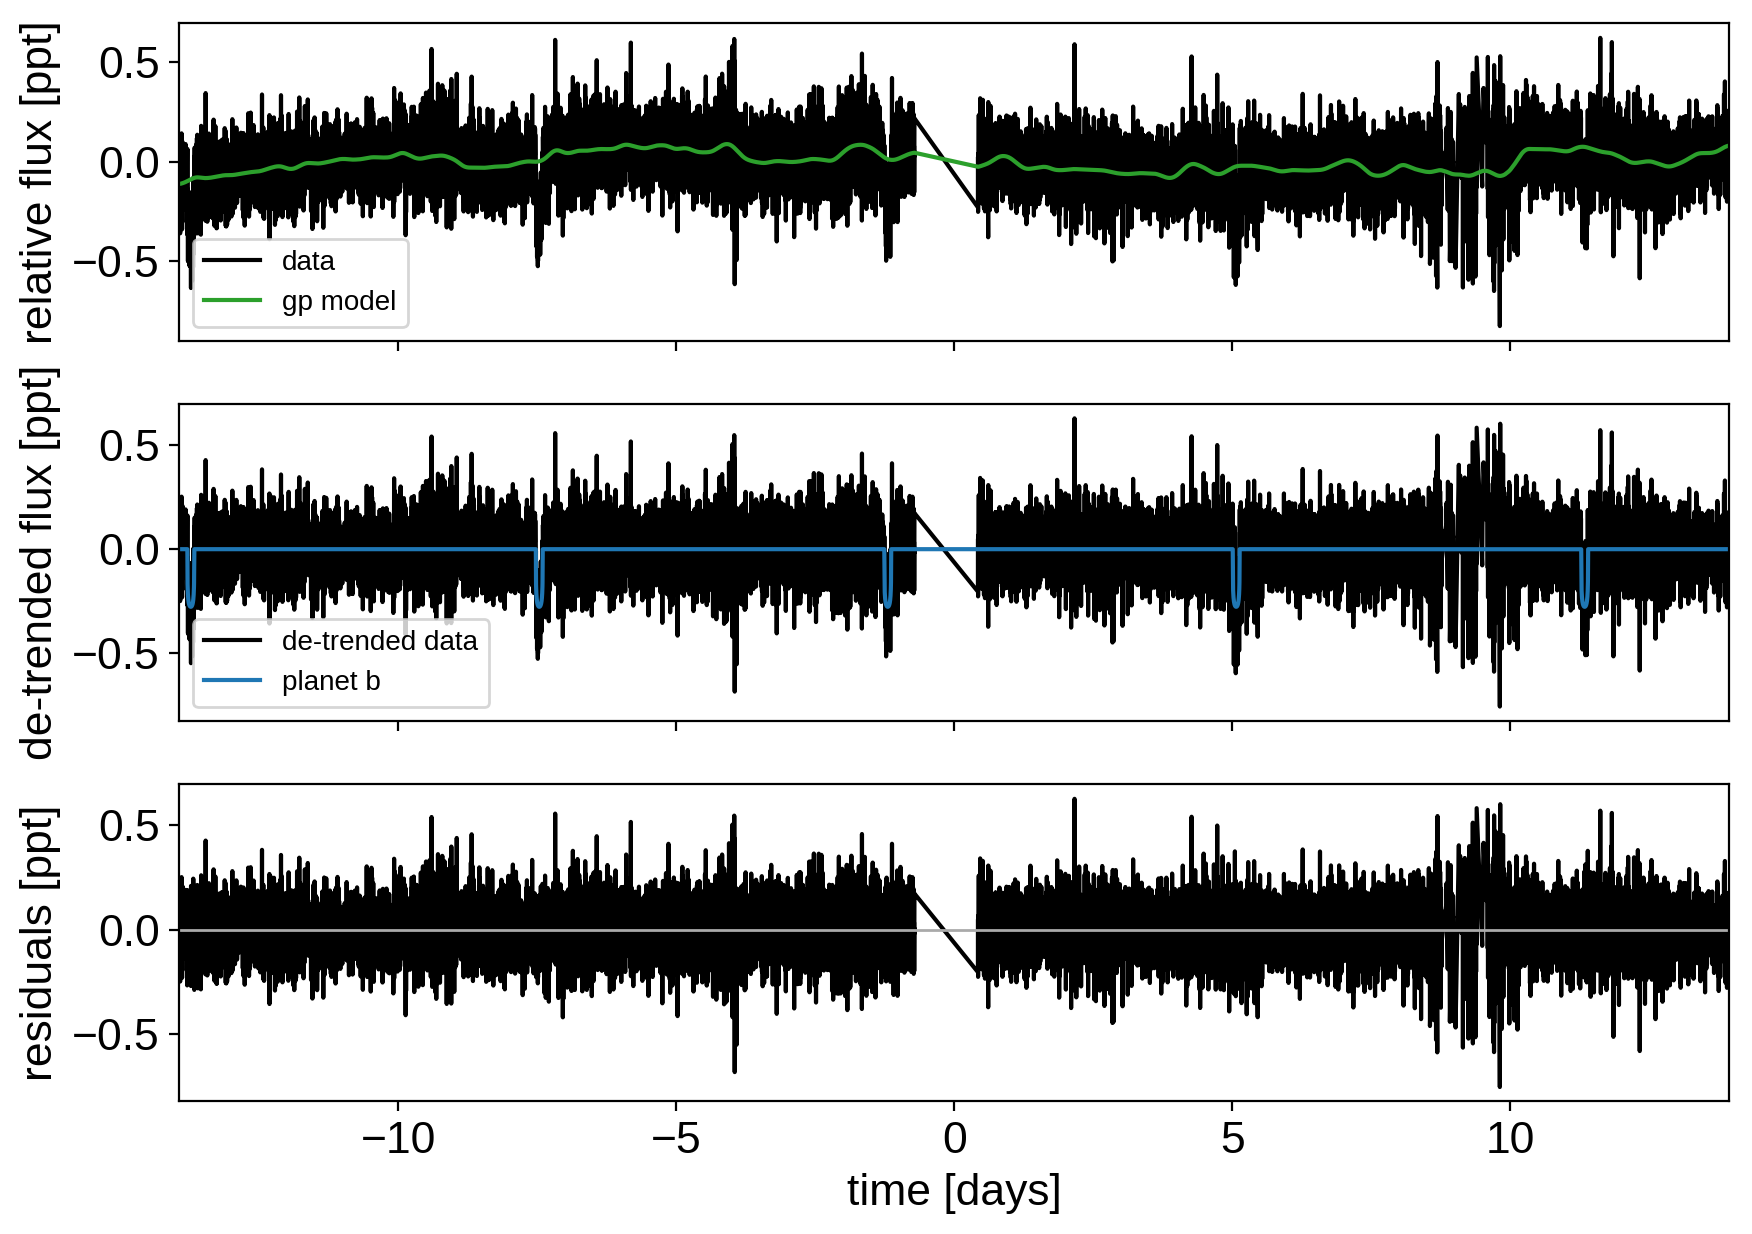

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    return fig


plot_light_curve(map_soln0);

As in the :ref:`together` tutorial, we can do some sigma clipping to remove significant outliers.

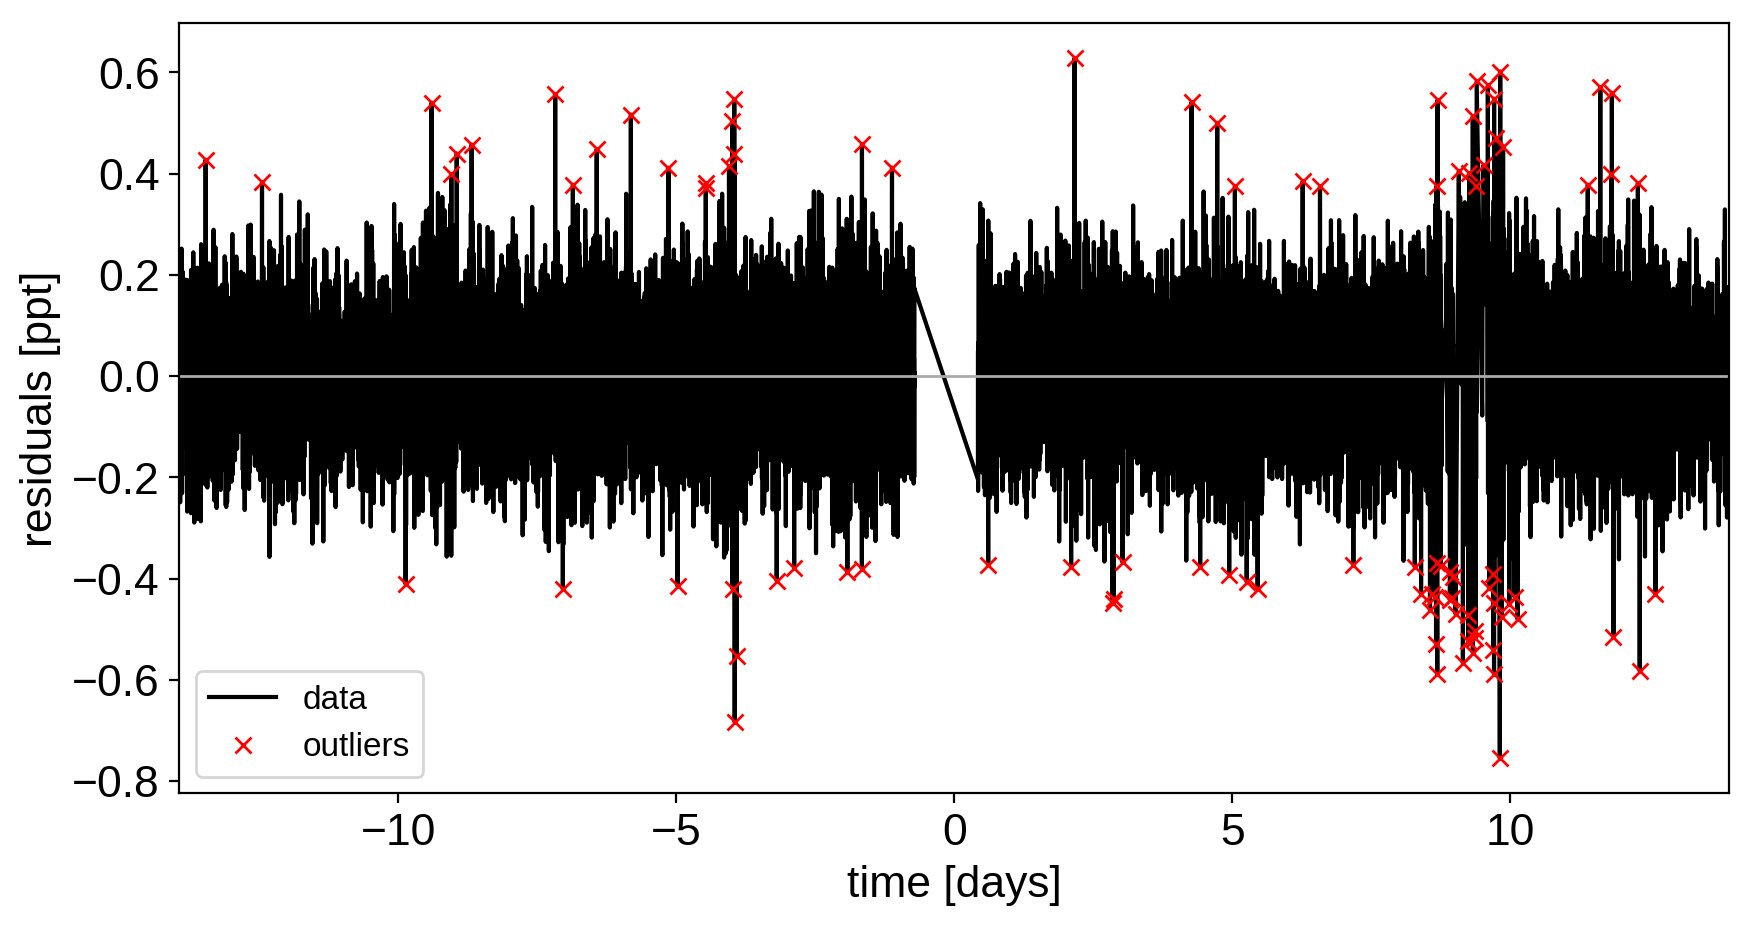

In [12]:
mod = (
    map_soln0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(map_soln0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

And then we re-build the model using the data without outliers.

optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.370934e+04]

1it [00:00, 37.46it/s, logp=1.370934e+04]

2it [00:00, 37.65it/s, logp=1.370934e+04]

3it [00:00, 45.10it/s, logp=8.425669e+03]

4it [00:00, 52.63it/s, logp=1.374004e+04]

5it [00:00, 58.49it/s, logp=1.237207e+04]

6it [00:00, 63.34it/s, logp=1.374004e+04]

7it [00:00, 66.88it/s, logp=1.374004e+04]

8it [00:00, 75.95it/s, logp=1.374004e+04]

8it [00:00, 75.95it/s, logp=1.374007e+04]

9it [00:00, 75.95it/s, logp=1.374014e+04]

10it [00:00, 75.95it/s, logp=1.374025e+04]

11it [00:00, 75.95it/s, logp=1.374030e+04]

12it [00:00, 75.95it/s, logp=1.374030e+04]

13it [00:00, 75.95it/s, logp=1.374030e+04]

14it [00:00, 75.95it/s, logp=1.374030e+04]

15it [00:01,  9.27it/s, logp=1.374030e+04]


message: Optimization terminated successfully.
logp: 13709.337756357809 -> 13740.297129156785


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374030e+04]

1it [00:00, 54.18it/s, logp=1.374030e+04]

2it [00:00, 77.53it/s, logp=1.374030e+04]

3it [00:00, 90.67it/s, logp=-1.310442e+04]

4it [00:00, 97.42it/s, logp=1.357230e+04] 

5it [00:00, 103.41it/s, logp=1.374032e+04]

6it [00:00, 108.54it/s, logp=1.374032e+04]

7it [00:00, 112.43it/s, logp=1.374032e+04]

8it [00:01,  5.54it/s, logp=1.374032e+04] 


message: Optimization terminated successfully.
logp: 13740.297129156788 -> 13740.31722986988


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374032e+04]

1it [00:00, 47.28it/s, logp=1.374032e+04]

2it [00:00, 64.76it/s, logp=1.374032e+04]

3it [00:00, 72.05it/s, logp=1.281975e+04]

4it [00:00, 72.95it/s, logp=1.374031e+04]

5it [00:00, 73.41it/s, logp=1.374032e+04]

6it [00:00, 77.82it/s, logp=1.374031e+04]

7it [00:00, 83.22it/s, logp=1.374032e+04]

8it [00:00, 87.49it/s, logp=1.374032e+04]

9it [00:00, 91.13it/s, logp=1.374032e+04]

10it [00:00, 94.24it/s, logp=1.374032e+04]

11it [00:00, 103.26it/s, logp=1.374032e+04]

11it [00:00, 103.26it/s, logp=1.374032e+04]

12it [00:00, 103.26it/s, logp=1.374032e+04]

13it [00:00, 103.26it/s, logp=1.374032e+04]

14it [00:01,  8.96it/s, logp=1.374032e+04] 


message: Optimization terminated successfully.
logp: 13740.31722986988 -> 13740.31831713007


optimizing logp for variables: [t0, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374032e+04]

1it [00:00, 64.40it/s, logp=1.374032e+04]

2it [00:00, 83.25it/s, logp=1.374032e+04]

3it [00:00, 91.45it/s, logp=1.310203e+04]

4it [00:00, 100.10it/s, logp=1.292804e+04]

5it [00:00, 105.82it/s, logp=1.273511e+04]

6it [00:00, 105.55it/s, logp=1.372081e+04]

7it [00:00, 108.45it/s, logp=1.374032e+04]

8it [00:00, 110.83it/s, logp=1.374032e+04]

9it [00:00, 109.09it/s, logp=1.374033e+04]

10it [00:00, 109.47it/s, logp=1.374033e+04]

11it [00:00, 111.25it/s, logp=1.374033e+04]

12it [00:00, 112.86it/s, logp=1.374033e+04]

13it [00:00, 121.58it/s, logp=1.374033e+04]

13it [00:00, 121.58it/s, logp=1.374033e+04]

14it [00:00, 121.58it/s, logp=1.374033e+04]

15it [00:00, 121.58it/s, logp=1.374033e+04]

16it [00:00, 121.58it/s, logp=1.374033e+04]

17it [00:00, 121.58it/s, logp=1.374033e+04]

18it [00:00, 121.58it/s, logp=1.374033e+04]

19it [00:00, 121.58it/s, logp=1.374033e+04]

20it [00:00, 121.58it/s, logp=1.374033e+04]

21it [00:00, 121.58it/s, logp=1.374033e+04]

22it [00:00, 121.58it/s, logp=1.374033e+04]

23it [00:00, 121.58it/s, logp=1.374033e+04]

24it [00:00, 116.21it/s, logp=1.374033e+04]

24it [00:00, 116.21it/s, logp=1.374033e+04]

25it [00:00, 116.21it/s, logp=1.374033e+04]

26it [00:00, 116.21it/s, logp=1.374033e+04]

27it [00:00, 116.21it/s, logp=1.374033e+04]

28it [00:00, 116.21it/s, logp=1.374033e+04]

29it [00:00, 116.21it/s, logp=1.374033e+04]

30it [00:00, 116.21it/s, logp=1.374033e+04]

31it [00:00, 116.21it/s, logp=1.374033e+04]

32it [00:00, 116.21it/s, logp=1.374033e+04]

33it [00:00, 116.21it/s, logp=1.374033e+04]

34it [00:00, 116.21it/s, logp=1.374033e+04]

35it [00:00, 116.21it/s, logp=1.374033e+04]

36it [00:00, 116.21it/s, logp=1.374033e+04]

37it [00:00, 116.21it/s, logp=1.374033e+04]

38it [00:00, 120.40it/s, logp=1.374033e+04]

38it [00:00, 120.40it/s, logp=1.374033e+04]

39it [00:00, 120.40it/s, logp=1.374033e+04]

40it [00:00, 120.40it/s, logp=1.374033e+04]

41it [00:00, 120.40it/s, logp=1.374033e+04]

42it [00:00, 120.40it/s, logp=1.374033e+04]

43it [00:00, 120.40it/s, logp=1.374033e+04]

44it [00:00, 120.40it/s, logp=1.374033e+04]

45it [00:00, 120.40it/s, logp=1.374033e+04]

46it [00:00, 120.40it/s, logp=1.374033e+04]

47it [00:00, 120.40it/s, logp=1.374033e+04]

48it [00:00, 113.14it/s, logp=1.374033e+04]

48it [00:00, 113.14it/s, logp=1.374033e+04]

49it [00:00, 113.14it/s, logp=1.374033e+04]

50it [00:00, 113.14it/s, logp=1.374033e+04]

51it [00:00, 113.14it/s, logp=1.374033e+04]

52it [00:00, 113.14it/s, logp=1.374033e+04]

53it [00:00, 113.14it/s, logp=1.374033e+04]

54it [00:00, 113.14it/s, logp=1.374033e+04]

55it [00:00, 113.14it/s, logp=1.374033e+04]

56it [00:00, 113.14it/s, logp=1.374033e+04]

57it [00:00, 103.06it/s, logp=1.374033e+04]

57it [00:00, 103.06it/s, logp=1.374033e+04]

58it [00:00, 103.06it/s, logp=1.374033e+04]

59it [00:00, 103.06it/s, logp=1.374033e+04]

60it [00:00, 103.06it/s, logp=1.374033e+04]

61it [00:00, 103.06it/s, logp=1.374033e+04]

62it [00:00, 103.06it/s, logp=1.374033e+04]

63it [00:00, 103.06it/s, logp=1.374033e+04]

64it [00:00, 103.06it/s, logp=1.374033e+04]

65it [00:00, 103.06it/s, logp=1.374033e+04]

66it [00:00, 103.06it/s, logp=1.374033e+04]

67it [00:00, 100.92it/s, logp=1.374033e+04]

67it [00:00, 100.92it/s, logp=1.374033e+04]

68it [00:00, 100.92it/s, logp=1.374033e+04]

69it [00:00, 100.92it/s, logp=1.374033e+04]

70it [00:00, 100.92it/s, logp=1.374033e+04]

71it [00:00, 100.92it/s, logp=1.374033e+04]

72it [00:00, 100.92it/s, logp=1.374033e+04]

73it [00:00, 100.92it/s, logp=1.374033e+04]

74it [00:00, 100.92it/s, logp=1.374033e+04]

75it [00:00, 100.92it/s, logp=1.374033e+04]

76it [00:00, 100.92it/s, logp=1.374033e+04]

77it [00:00, 100.92it/s, logp=1.374033e+04]

78it [00:00, 100.92it/s, logp=1.374033e+04]

79it [00:00, 103.88it/s, logp=1.374033e+04]

79it [00:00, 103.88it/s, logp=1.374033e+04]

80it [00:00, 103.88it/s, logp=1.374033e+04]

81it [00:00, 103.88it/s, logp=1.374033e+04]

82it [00:00, 103.88it/s, logp=1.374033e+04]

83it [00:00, 103.88it/s, logp=1.374033e+04]

84it [00:00, 103.88it/s, logp=1.374033e+04]

85it [00:00, 103.88it/s, logp=1.374033e+04]

86it [00:00, 103.88it/s, logp=1.374033e+04]

87it [00:00, 103.88it/s, logp=1.374033e+04]

88it [00:00, 103.88it/s, logp=1.374033e+04]

89it [00:00, 103.88it/s, logp=1.374033e+04]

90it [00:00, 104.74it/s, logp=1.374033e+04]

90it [00:00, 104.74it/s, logp=1.374033e+04]

91it [00:00, 104.74it/s, logp=1.374033e+04]

92it [00:00, 104.74it/s, logp=1.374033e+04]

93it [00:00, 104.74it/s, logp=1.374033e+04]

94it [00:00, 104.74it/s, logp=1.374033e+04]

95it [00:00, 104.74it/s, logp=1.374033e+04]

96it [00:00, 104.74it/s, logp=1.374033e+04]

97it [00:00, 104.74it/s, logp=1.374033e+04]

98it [00:00, 104.74it/s, logp=1.374033e+04]

99it [00:00, 104.74it/s, logp=1.374033e+04]

100it [00:00, 101.70it/s, logp=1.374033e+04]

100it [00:00, 101.70it/s, logp=1.374033e+04]

101it [00:00, 101.70it/s, logp=1.374033e+04]

102it [00:00, 101.70it/s, logp=1.374033e+04]

103it [00:00, 101.70it/s, logp=1.374033e+04]

104it [00:00, 101.70it/s, logp=1.374033e+04]

105it [00:01, 101.70it/s, logp=1.374033e+04]

106it [00:01, 101.70it/s, logp=1.374033e+04]

107it [00:01, 101.70it/s, logp=1.374033e+04]

108it [00:01, 101.70it/s, logp=1.374033e+04]

109it [00:01, 101.70it/s, logp=1.374033e+04]

110it [00:01, 100.91it/s, logp=1.374033e+04]

110it [00:01, 100.91it/s, logp=1.374033e+04]

111it [00:01, 100.91it/s, logp=1.374033e+04]

112it [00:01, 100.91it/s, logp=1.374033e+04]

113it [00:01, 100.91it/s, logp=1.374033e+04]

114it [00:01, 100.91it/s, logp=1.374033e+04]

115it [00:01, 100.91it/s, logp=1.374033e+04]

116it [00:01, 100.91it/s, logp=1.374033e+04]

117it [00:01, 100.91it/s, logp=1.374033e+04]

118it [00:01, 100.91it/s, logp=1.374033e+04]

119it [00:01, 100.91it/s, logp=1.374033e+04]

120it [00:01, 100.91it/s, logp=1.374033e+04]

121it [00:01, 101.94it/s, logp=1.374033e+04]

121it [00:01, 101.94it/s, logp=1.374033e+04]

122it [00:01, 101.94it/s, logp=1.374033e+04]

123it [00:01, 101.94it/s, logp=1.374033e+04]

124it [00:01, 101.94it/s, logp=1.374033e+04]

125it [00:01, 101.94it/s, logp=1.374033e+04]

126it [00:01, 101.94it/s, logp=1.374033e+04]

127it [00:01, 101.94it/s, logp=1.374033e+04]

128it [00:01, 101.94it/s, logp=1.374033e+04]

129it [00:01, 101.94it/s, logp=1.374033e+04]

130it [00:01, 101.94it/s, logp=1.374033e+04]

131it [00:01, 101.94it/s, logp=1.374033e+04]

132it [00:01, 101.94it/s, logp=1.374033e+04]

133it [00:01, 101.94it/s, logp=1.374033e+04]

134it [00:01, 101.94it/s, logp=1.374033e+04]

135it [00:01, 109.54it/s, logp=1.374033e+04]

135it [00:01, 109.54it/s, logp=1.374033e+04]

136it [00:01, 109.54it/s, logp=1.374033e+04]

137it [00:01, 109.54it/s, logp=1.374033e+04]

138it [00:01, 109.54it/s, logp=1.374033e+04]

139it [00:01, 109.54it/s, logp=1.374033e+04]

140it [00:01, 109.54it/s, logp=1.374033e+04]

141it [00:01, 109.54it/s, logp=1.374033e+04]

142it [00:01, 109.54it/s, logp=1.374033e+04]

143it [00:01, 109.54it/s, logp=1.374033e+04]

144it [00:01, 109.54it/s, logp=1.374033e+04]

145it [00:01, 109.54it/s, logp=1.374033e+04]

146it [00:02, 57.04it/s, logp=1.374033e+04] 


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.318317130062 -> 13740.326927416274


optimizing logp for variables: [u_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374033e+04]

1it [00:00, 64.50it/s, logp=1.374033e+04]

2it [00:00, 88.12it/s, logp=1.374033e+04]

3it [00:00, 99.37it/s, logp=1.373995e+04]

4it [00:00, 107.15it/s, logp=1.374035e+04]

5it [00:00, 111.71it/s, logp=1.374035e+04]

6it [00:00, 115.72it/s, logp=1.374035e+04]

7it [00:00, 118.99it/s, logp=1.374035e+04]

8it [00:01,  4.93it/s, logp=1.374035e+04] 


message: Optimization terminated successfully.
logp: 13740.326927416267 -> 13740.350391911023


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374035e+04]

1it [00:00, 49.18it/s, logp=1.374035e+04]

2it [00:00, 66.34it/s, logp=1.374035e+04]

3it [00:00, 74.30it/s, logp=-1.331080e+04]

4it [00:00, 78.89it/s, logp=1.356942e+04] 

5it [00:00, 82.26it/s, logp=1.374035e+04]

6it [00:00, 85.31it/s, logp=1.374035e+04]

7it [00:00, 87.86it/s, logp=1.374035e+04]

8it [00:01,  4.53it/s, logp=1.374035e+04]


message: Optimization terminated successfully.
logp: 13740.35039191103 -> 13740.353904884088


optimizing logp for variables: [b, logr, r_star]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374035e+04]

1it [00:00, 61.79it/s, logp=1.374035e+04]

2it [00:00, 85.77it/s, logp=1.374035e+04]

3it [00:00, 99.33it/s, logp=7.885903e+03]

4it [00:00, 105.60it/s, logp=1.372311e+04]

5it [00:00, 104.30it/s, logp=1.374036e+04]

6it [00:00, 106.74it/s, logp=1.374033e+04]

7it [00:00, 110.04it/s, logp=1.374036e+04]

8it [00:00, 104.28it/s, logp=1.374036e+04]

9it [00:00, 100.32it/s, logp=1.374036e+04]

10it [00:00, 99.64it/s, logp=1.374036e+04]

11it [00:00, 108.59it/s, logp=1.374036e+04]

11it [00:00, 108.59it/s, logp=1.374036e+04]

12it [00:00, 108.59it/s, logp=1.374036e+04]

13it [00:00, 108.59it/s, logp=1.374036e+04]

14it [00:00, 108.59it/s, logp=1.374036e+04]

15it [00:00, 108.59it/s, logp=1.374036e+04]

16it [00:00, 108.59it/s, logp=1.374036e+04]

17it [00:00, 108.59it/s, logp=1.374036e+04]

18it [00:00, 108.59it/s, logp=1.374036e+04]

19it [00:00, 108.59it/s, logp=1.374036e+04]

20it [00:00, 108.59it/s, logp=1.374036e+04]

21it [00:00, 108.59it/s, logp=1.374036e+04]

22it [00:00, 108.59it/s, logp=1.374036e+04]

23it [00:00, 108.59it/s, logp=1.374036e+04]

24it [00:00, 108.59it/s, logp=1.374036e+04]

25it [00:00, 114.91it/s, logp=1.374036e+04]

25it [00:00, 114.91it/s, logp=1.374036e+04]

26it [00:00, 114.91it/s, logp=1.374036e+04]

27it [00:00, 114.91it/s, logp=1.374036e+04]

28it [00:00, 114.91it/s, logp=1.374036e+04]

29it [00:00, 114.91it/s, logp=1.374036e+04]

30it [00:00, 114.91it/s, logp=1.374036e+04]

31it [00:00, 114.91it/s, logp=1.374036e+04]

32it [00:00, 114.91it/s, logp=1.374036e+04]

33it [00:00, 114.91it/s, logp=1.374036e+04]

34it [00:00, 114.91it/s, logp=1.374036e+04]

35it [00:00, 114.91it/s, logp=1.374036e+04]

36it [00:00, 114.91it/s, logp=1.374036e+04]

37it [00:00, 115.68it/s, logp=1.374036e+04]

37it [00:00, 115.68it/s, logp=1.374036e+04]

38it [00:00, 115.68it/s, logp=1.374036e+04]

39it [00:00, 115.68it/s, logp=1.374036e+04]

40it [00:00, 115.68it/s, logp=1.374036e+04]

41it [00:00, 115.68it/s, logp=1.374036e+04]

42it [00:00, 115.68it/s, logp=1.374036e+04]

43it [00:00, 115.68it/s, logp=1.374036e+04]

44it [00:00, 115.68it/s, logp=1.374036e+04]

45it [00:00, 115.68it/s, logp=1.374036e+04]

46it [00:00, 115.68it/s, logp=1.374036e+04]

47it [00:00, 115.68it/s, logp=1.374036e+04]

48it [00:00, 115.68it/s, logp=1.374036e+04]

49it [00:00, 115.68it/s, logp=1.374036e+04]

50it [00:00, 117.12it/s, logp=1.374036e+04]

50it [00:00, 117.12it/s, logp=1.374036e+04]

51it [00:00, 117.12it/s, logp=1.374036e+04]

52it [00:00, 117.12it/s, logp=1.374036e+04]

53it [00:00, 117.12it/s, logp=1.374036e+04]

54it [00:00, 117.12it/s, logp=1.374036e+04]

55it [00:00, 117.12it/s, logp=1.374036e+04]

56it [00:00, 117.12it/s, logp=1.374036e+04]

57it [00:00, 117.12it/s, logp=1.374036e+04]

58it [00:00, 117.12it/s, logp=1.374036e+04]

59it [00:00, 117.12it/s, logp=1.374036e+04]

60it [00:00, 117.12it/s, logp=1.374036e+04]

61it [00:00, 113.78it/s, logp=1.374036e+04]

61it [00:00, 113.78it/s, logp=1.374036e+04]

62it [00:00, 113.78it/s, logp=1.374036e+04]

63it [00:00, 113.78it/s, logp=1.374036e+04]

64it [00:00, 113.78it/s, logp=1.374036e+04]

65it [00:00, 113.78it/s, logp=1.374036e+04]

66it [00:00, 113.78it/s, logp=1.374036e+04]

67it [00:00, 113.78it/s, logp=1.374036e+04]

68it [00:00, 113.78it/s, logp=1.374036e+04]

69it [00:00, 113.78it/s, logp=1.374036e+04]

70it [00:00, 113.78it/s, logp=1.374036e+04]

71it [00:00, 113.78it/s, logp=1.374036e+04]

72it [00:00, 113.78it/s, logp=1.374036e+04]

73it [00:00, 113.78it/s, logp=1.374036e+04]

74it [00:00, 116.32it/s, logp=1.374036e+04]

74it [00:00, 116.32it/s, logp=1.374036e+04]

75it [00:00, 116.32it/s, logp=1.374036e+04]

76it [00:00, 116.32it/s, logp=1.374036e+04]

77it [00:00, 116.32it/s, logp=1.374036e+04]

78it [00:00, 116.32it/s, logp=1.374036e+04]

79it [00:00, 116.32it/s, logp=1.374036e+04]

80it [00:00, 116.32it/s, logp=1.374036e+04]

81it [00:00, 116.32it/s, logp=1.374036e+04]

82it [00:00, 116.32it/s, logp=1.374036e+04]

83it [00:00, 116.32it/s, logp=1.374036e+04]

84it [00:00, 116.32it/s, logp=1.374036e+04]

85it [00:00, 113.98it/s, logp=1.374036e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.353904884088 -> 13740.362784306773


optimizing logp for variables: [omega, ecc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374036e+04]

1it [00:00, 59.25it/s, logp=1.374036e+04]

2it [00:00, 78.09it/s, logp=1.374036e+04]

3it [00:00, 90.46it/s, logp=1.374009e+04]

4it [00:00, 98.84it/s, logp=1.374036e+04]

5it [00:00, 102.69it/s, logp=1.374036e+04]

6it [00:00, 106.95it/s, logp=1.374036e+04]

7it [00:00, 110.08it/s, logp=1.374036e+04]

8it [00:00, 111.04it/s, logp=1.374036e+04]

9it [00:00, 113.12it/s, logp=1.374036e+04]

10it [00:00, 111.90it/s, logp=1.374036e+04]

11it [00:00, 111.11it/s, logp=1.374036e+04]

12it [00:00, 111.47it/s, logp=1.374036e+04]

13it [00:00, 119.88it/s, logp=1.374036e+04]

13it [00:00, 119.88it/s, logp=1.374036e+04]

14it [00:00, 119.88it/s, logp=1.374036e+04]

15it [00:00, 119.88it/s, logp=1.374036e+04]

16it [00:00, 119.88it/s, logp=1.374036e+04]

17it [00:00, 119.88it/s, logp=1.374036e+04]

18it [00:00, 119.88it/s, logp=1.374036e+04]

19it [00:00, 119.88it/s, logp=1.374036e+04]

20it [00:00, 119.88it/s, logp=1.374036e+04]

21it [00:00, 119.88it/s, logp=1.374036e+04]

22it [00:00, 119.88it/s, logp=1.374036e+04]

23it [00:00, 119.88it/s, logp=1.374036e+04]

24it [00:00, 115.89it/s, logp=1.374036e+04]

24it [00:00, 115.89it/s, logp=1.374036e+04]

25it [00:00, 115.89it/s, logp=1.374036e+04]

26it [00:00, 115.89it/s, logp=1.374036e+04]

27it [00:00, 115.89it/s, logp=1.374036e+04]

28it [00:00, 115.89it/s, logp=1.374036e+04]

29it [00:00, 115.89it/s, logp=1.374036e+04]

30it [00:00, 115.89it/s, logp=1.374036e+04]

31it [00:00, 115.89it/s, logp=1.374036e+04]

32it [00:00, 115.89it/s, logp=1.374036e+04]

33it [00:00, 105.93it/s, logp=1.374036e+04]

33it [00:00, 105.93it/s, logp=1.374036e+04]

34it [00:00, 105.93it/s, logp=1.374036e+04]

35it [00:00, 105.93it/s, logp=1.374036e+04]

36it [00:00, 105.93it/s, logp=1.374036e+04]

37it [00:00, 105.93it/s, logp=1.374036e+04]

38it [00:00, 105.93it/s, logp=1.374036e+04]

39it [00:00, 105.93it/s, logp=1.374036e+04]

40it [00:00, 105.93it/s, logp=1.374036e+04]

41it [00:00, 105.93it/s, logp=1.374036e+04]

42it [00:00, 105.93it/s, logp=1.374036e+04]

43it [00:00, 103.99it/s, logp=1.374036e+04]

43it [00:00, 103.99it/s, logp=1.374036e+04]

44it [00:00, 103.99it/s, logp=1.374036e+04]

45it [00:00, 103.99it/s, logp=1.374036e+04]

46it [00:00, 103.99it/s, logp=1.374036e+04]

47it [00:00, 103.99it/s, logp=1.374036e+04]

48it [00:00, 103.99it/s, logp=1.374036e+04]

49it [00:00, 103.99it/s, logp=1.374036e+04]

50it [00:00, 103.99it/s, logp=1.374036e+04]

51it [00:00, 103.99it/s, logp=1.374036e+04]

52it [00:00, 103.99it/s, logp=1.374036e+04]

53it [00:00, 102.47it/s, logp=1.374036e+04]

53it [00:00, 102.47it/s, logp=1.374036e+04]

54it [00:00, 102.47it/s, logp=1.374036e+04]

55it [00:00, 102.47it/s, logp=1.374036e+04]

56it [00:00, 102.47it/s, logp=1.374036e+04]

57it [00:00, 102.47it/s, logp=1.374036e+04]

58it [00:00, 102.47it/s, logp=1.374036e+04]

59it [00:00, 102.47it/s, logp=1.374036e+04]

60it [00:00, 102.47it/s, logp=1.374036e+04]

61it [00:00, 102.47it/s, logp=1.374036e+04]

62it [00:00, 102.47it/s, logp=1.374036e+04]

63it [00:00, 102.47it/s, logp=1.374036e+04]

64it [00:00, 102.12it/s, logp=1.374036e+04]

64it [00:00, 102.12it/s, logp=1.374036e+04]

65it [00:00, 102.12it/s, logp=1.374036e+04]

66it [00:00, 102.12it/s, logp=1.374036e+04]

67it [00:00, 102.12it/s, logp=1.374036e+04]

68it [00:00, 102.12it/s, logp=1.374036e+04]

69it [00:00, 102.12it/s, logp=1.374036e+04]

70it [00:00, 102.12it/s, logp=1.374036e+04]

71it [00:00, 102.12it/s, logp=1.374036e+04]

72it [00:00, 102.12it/s, logp=1.374036e+04]

73it [00:00, 93.67it/s, logp=1.374036e+04] 

73it [00:00, 93.67it/s, logp=1.374036e+04]

74it [00:00, 93.67it/s, logp=1.374036e+04]

75it [00:00, 93.67it/s, logp=1.374036e+04]

76it [00:00, 93.67it/s, logp=1.374036e+04]

77it [00:00, 93.67it/s, logp=1.374036e+04]

78it [00:00, 93.67it/s, logp=1.374036e+04]

79it [00:00, 93.67it/s, logp=1.374036e+04]

80it [00:00, 93.67it/s, logp=1.374036e+04]

81it [00:00, 93.67it/s, logp=1.374036e+04]

82it [00:00, 93.67it/s, logp=1.374036e+04]

83it [00:00, 93.25it/s, logp=1.374036e+04]

83it [00:00, 93.25it/s, logp=1.374036e+04]

84it [00:00, 93.25it/s, logp=1.374036e+04]

85it [00:00, 93.25it/s, logp=1.374036e+04]

86it [00:00, 93.25it/s, logp=1.374036e+04]

87it [00:00, 93.25it/s, logp=1.374036e+04]

88it [00:00, 93.25it/s, logp=1.374036e+04]

89it [00:00, 93.25it/s, logp=1.374036e+04]

90it [00:00, 93.25it/s, logp=1.374036e+04]

91it [00:00, 93.25it/s, logp=1.374036e+04]

92it [00:00, 89.97it/s, logp=1.374036e+04]

92it [00:00, 89.97it/s, logp=1.374036e+04]

93it [00:00, 89.97it/s, logp=1.374036e+04]

94it [00:00, 89.97it/s, logp=1.374036e+04]

95it [00:00, 89.97it/s, logp=1.374036e+04]

96it [00:01, 89.97it/s, logp=1.374036e+04]

97it [00:01, 89.97it/s, logp=1.374036e+04]

98it [00:01, 89.97it/s, logp=1.374036e+04]

99it [00:01, 89.97it/s, logp=1.374036e+04]

100it [00:01, 89.97it/s, logp=1.374036e+04]

101it [00:01, 89.97it/s, logp=1.374036e+04]

102it [00:01, 91.07it/s, logp=1.374036e+04]

102it [00:01, 91.07it/s, logp=1.374036e+04]

103it [00:01, 91.07it/s, logp=1.374036e+04]

104it [00:01, 91.07it/s, logp=1.374036e+04]

105it [00:01, 91.07it/s, logp=1.374036e+04]

106it [00:01, 91.07it/s, logp=1.374036e+04]

107it [00:01, 91.07it/s, logp=1.374036e+04]

108it [00:01, 91.07it/s, logp=1.374036e+04]

109it [00:01, 91.07it/s, logp=1.374036e+04]

110it [00:01, 91.07it/s, logp=1.374036e+04]

111it [00:01, 91.07it/s, logp=1.374036e+04]

112it [00:01, 90.91it/s, logp=1.374036e+04]

112it [00:01, 90.91it/s, logp=1.374036e+04]

113it [00:01, 90.91it/s, logp=1.374036e+04]

114it [00:01, 90.91it/s, logp=1.374036e+04]

115it [00:01, 90.91it/s, logp=1.374036e+04]

116it [00:01, 90.91it/s, logp=1.374036e+04]

117it [00:01, 90.91it/s, logp=1.374036e+04]

118it [00:01, 90.91it/s, logp=1.374036e+04]

119it [00:01, 90.91it/s, logp=1.374036e+04]

120it [00:01, 90.91it/s, logp=1.374036e+04]

121it [00:01, 90.91it/s, logp=1.374036e+04]

122it [00:01, 90.91it/s, logp=1.374036e+04]

123it [00:01, 90.91it/s, logp=1.374036e+04]

124it [00:01, 90.91it/s, logp=1.374036e+04]

125it [00:01, 98.94it/s, logp=1.374036e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.362784306773 -> 13740.362835323785


optimizing logp for variables: [mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374036e+04]

1it [00:00, 48.26it/s, logp=1.374036e+04]

2it [00:00, 63.86it/s, logp=1.374036e+04]

3it [00:00, 72.05it/s, logp=6.544440e+03]

4it [00:00, 77.95it/s, logp=1.374037e+04]

5it [00:01,  2.93it/s, logp=1.374037e+04]


message: Optimization terminated successfully.
logp: 13740.362835323785 -> 13740.366005030273


optimizing logp for variables: [logw0, logSw4, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374037e+04]

1it [00:00, 36.40it/s, logp=1.374037e+04]

2it [00:00, 50.66it/s, logp=1.374037e+04]

3it [00:00, 57.89it/s, logp=1.369719e+04]

4it [00:00, 62.20it/s, logp=1.374037e+04]

5it [00:00, 64.39it/s, logp=1.374037e+04]

6it [00:00, 65.84it/s, logp=1.374037e+04]

7it [00:00, 67.14it/s, logp=1.374037e+04]

8it [00:00, 76.17it/s, logp=1.374037e+04]

8it [00:00, 76.17it/s, logp=1.374037e+04]

9it [00:01,  6.95it/s, logp=1.374037e+04]


message: Optimization terminated successfully.
logp: 13740.366005030273 -> 13740.36600761282


optimizing logp for variables: [logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, b, logr, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.374037e+04]

1it [00:00, 43.64it/s, logp=1.374037e+04]

2it [00:00, 56.21it/s, logp=1.374037e+04]

3it [00:00, 67.57it/s, logp=1.312740e+04]

4it [00:00, 72.56it/s, logp=1.283654e+04]

5it [00:00, 76.96it/s, logp=1.341729e+04]

6it [00:00, 80.38it/s, logp=1.374035e+04]

7it [00:00, 82.95it/s, logp=1.374037e+04]

8it [00:00, 82.87it/s, logp=1.374037e+04]

9it [00:00, 81.69it/s, logp=1.374037e+04]

10it [00:00, 90.18it/s, logp=1.374037e+04]

10it [00:00, 90.18it/s, logp=1.374037e+04]

11it [00:00, 90.18it/s, logp=1.374037e+04]

12it [00:00, 90.18it/s, logp=1.374037e+04]

13it [00:00, 90.18it/s, logp=1.374037e+04]

14it [00:00, 90.18it/s, logp=1.374037e+04]

15it [00:00, 90.18it/s, logp=1.374037e+04]

16it [00:00, 90.18it/s, logp=1.374037e+04]

17it [00:00, 90.18it/s, logp=1.374037e+04]

18it [00:00, 85.17it/s, logp=1.374037e+04]

18it [00:00, 85.17it/s, logp=1.374037e+04]

19it [00:00, 85.17it/s, logp=1.374037e+04]

20it [00:00, 85.17it/s, logp=1.374037e+04]

21it [00:00, 85.17it/s, logp=1.374037e+04]

22it [00:00, 85.17it/s, logp=1.374037e+04]

23it [00:00, 85.17it/s, logp=1.374037e+04]

24it [00:00, 85.17it/s, logp=1.374037e+04]

25it [00:00, 85.17it/s, logp=1.374038e+04]

26it [00:00, 80.24it/s, logp=1.374038e+04]

26it [00:00, 80.24it/s, logp=1.374038e+04]

27it [00:00, 80.24it/s, logp=1.374038e+04]

28it [00:00, 80.24it/s, logp=1.374038e+04]

29it [00:00, 80.24it/s, logp=1.374038e+04]

30it [00:00, 80.24it/s, logp=1.374038e+04]

31it [00:00, 80.24it/s, logp=1.374038e+04]

32it [00:00, 80.24it/s, logp=1.374038e+04]

33it [00:00, 76.65it/s, logp=1.374038e+04]

33it [00:00, 76.65it/s, logp=1.374038e+04]

34it [00:00, 76.65it/s, logp=1.374038e+04]

35it [00:00, 76.65it/s, logp=1.374038e+04]

36it [00:00, 76.65it/s, logp=1.374038e+04]

37it [00:00, 76.65it/s, logp=1.374038e+04]

38it [00:00, 76.65it/s, logp=1.374038e+04]

39it [00:00, 76.65it/s, logp=1.374038e+04]

40it [00:00, 76.65it/s, logp=1.374038e+04]

41it [00:00, 76.65it/s, logp=1.374038e+04]

42it [00:00, 79.74it/s, logp=1.374038e+04]

42it [00:00, 79.74it/s, logp=1.374038e+04]

43it [00:00, 79.74it/s, logp=1.374038e+04]

44it [00:00, 79.74it/s, logp=1.374038e+04]

45it [00:00, 79.74it/s, logp=1.374038e+04]

46it [00:00, 79.74it/s, logp=1.374038e+04]

47it [00:00, 79.74it/s, logp=1.374038e+04]

48it [00:00, 79.74it/s, logp=1.374038e+04]

49it [00:00, 79.74it/s, logp=1.374038e+04]

50it [00:00, 79.63it/s, logp=1.374038e+04]

50it [00:00, 79.63it/s, logp=1.374038e+04]

51it [00:00, 79.63it/s, logp=1.374038e+04]

52it [00:00, 79.63it/s, logp=1.374038e+04]

53it [00:00, 79.63it/s, logp=1.374038e+04]

54it [00:00, 79.63it/s, logp=1.374038e+04]

55it [00:00, 79.63it/s, logp=1.374038e+04]

56it [00:00, 79.63it/s, logp=1.374038e+04]

57it [00:00, 79.63it/s, logp=1.374038e+04]

58it [00:00, 76.38it/s, logp=1.374038e+04]

58it [00:00, 76.38it/s, logp=1.374038e+04]

59it [00:00, 76.38it/s, logp=1.374038e+04]

60it [00:00, 76.38it/s, logp=1.374038e+04]

61it [00:00, 76.38it/s, logp=1.374038e+04]

62it [00:00, 76.38it/s, logp=1.374038e+04]

63it [00:00, 76.38it/s, logp=1.374038e+04]

64it [00:00, 76.38it/s, logp=1.374038e+04]

65it [00:00, 76.38it/s, logp=1.374038e+04]

66it [00:00, 76.38it/s, logp=1.374038e+04]

67it [00:00, 78.36it/s, logp=1.374038e+04]

67it [00:00, 78.36it/s, logp=1.374038e+04]

68it [00:00, 78.36it/s, logp=1.374038e+04]

69it [00:00, 78.36it/s, logp=1.374038e+04]

70it [00:00, 78.36it/s, logp=1.374038e+04]

71it [00:00, 78.36it/s, logp=1.374038e+04]

72it [00:00, 78.36it/s, logp=1.374038e+04]

73it [00:00, 78.36it/s, logp=1.374038e+04]

74it [00:00, 78.36it/s, logp=1.374038e+04]

75it [00:00, 78.36it/s, logp=1.374038e+04]

76it [00:00, 79.93it/s, logp=1.374038e+04]

76it [00:00, 79.93it/s, logp=1.374038e+04]

77it [00:00, 79.93it/s, logp=1.374038e+04]

78it [00:00, 79.93it/s, logp=1.374038e+04]

79it [00:01, 79.93it/s, logp=1.374038e+04]

80it [00:01, 79.93it/s, logp=1.374038e+04]

81it [00:01, 79.93it/s, logp=1.374038e+04]

82it [00:01, 79.93it/s, logp=1.374038e+04]

83it [00:01, 79.93it/s, logp=1.374038e+04]

84it [00:01, 78.82it/s, logp=1.374038e+04]

84it [00:01, 78.82it/s, logp=1.374038e+04]

85it [00:01, 78.82it/s, logp=1.374038e+04]

86it [00:01, 78.82it/s, logp=1.374038e+04]

87it [00:01, 78.82it/s, logp=1.374038e+04]

88it [00:01, 78.82it/s, logp=1.374038e+04]

89it [00:01, 78.82it/s, logp=1.374038e+04]

90it [00:01, 78.82it/s, logp=1.374038e+04]

91it [00:02, 34.39it/s, logp=1.374038e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: 13740.366007612805 -> 13740.377939831247


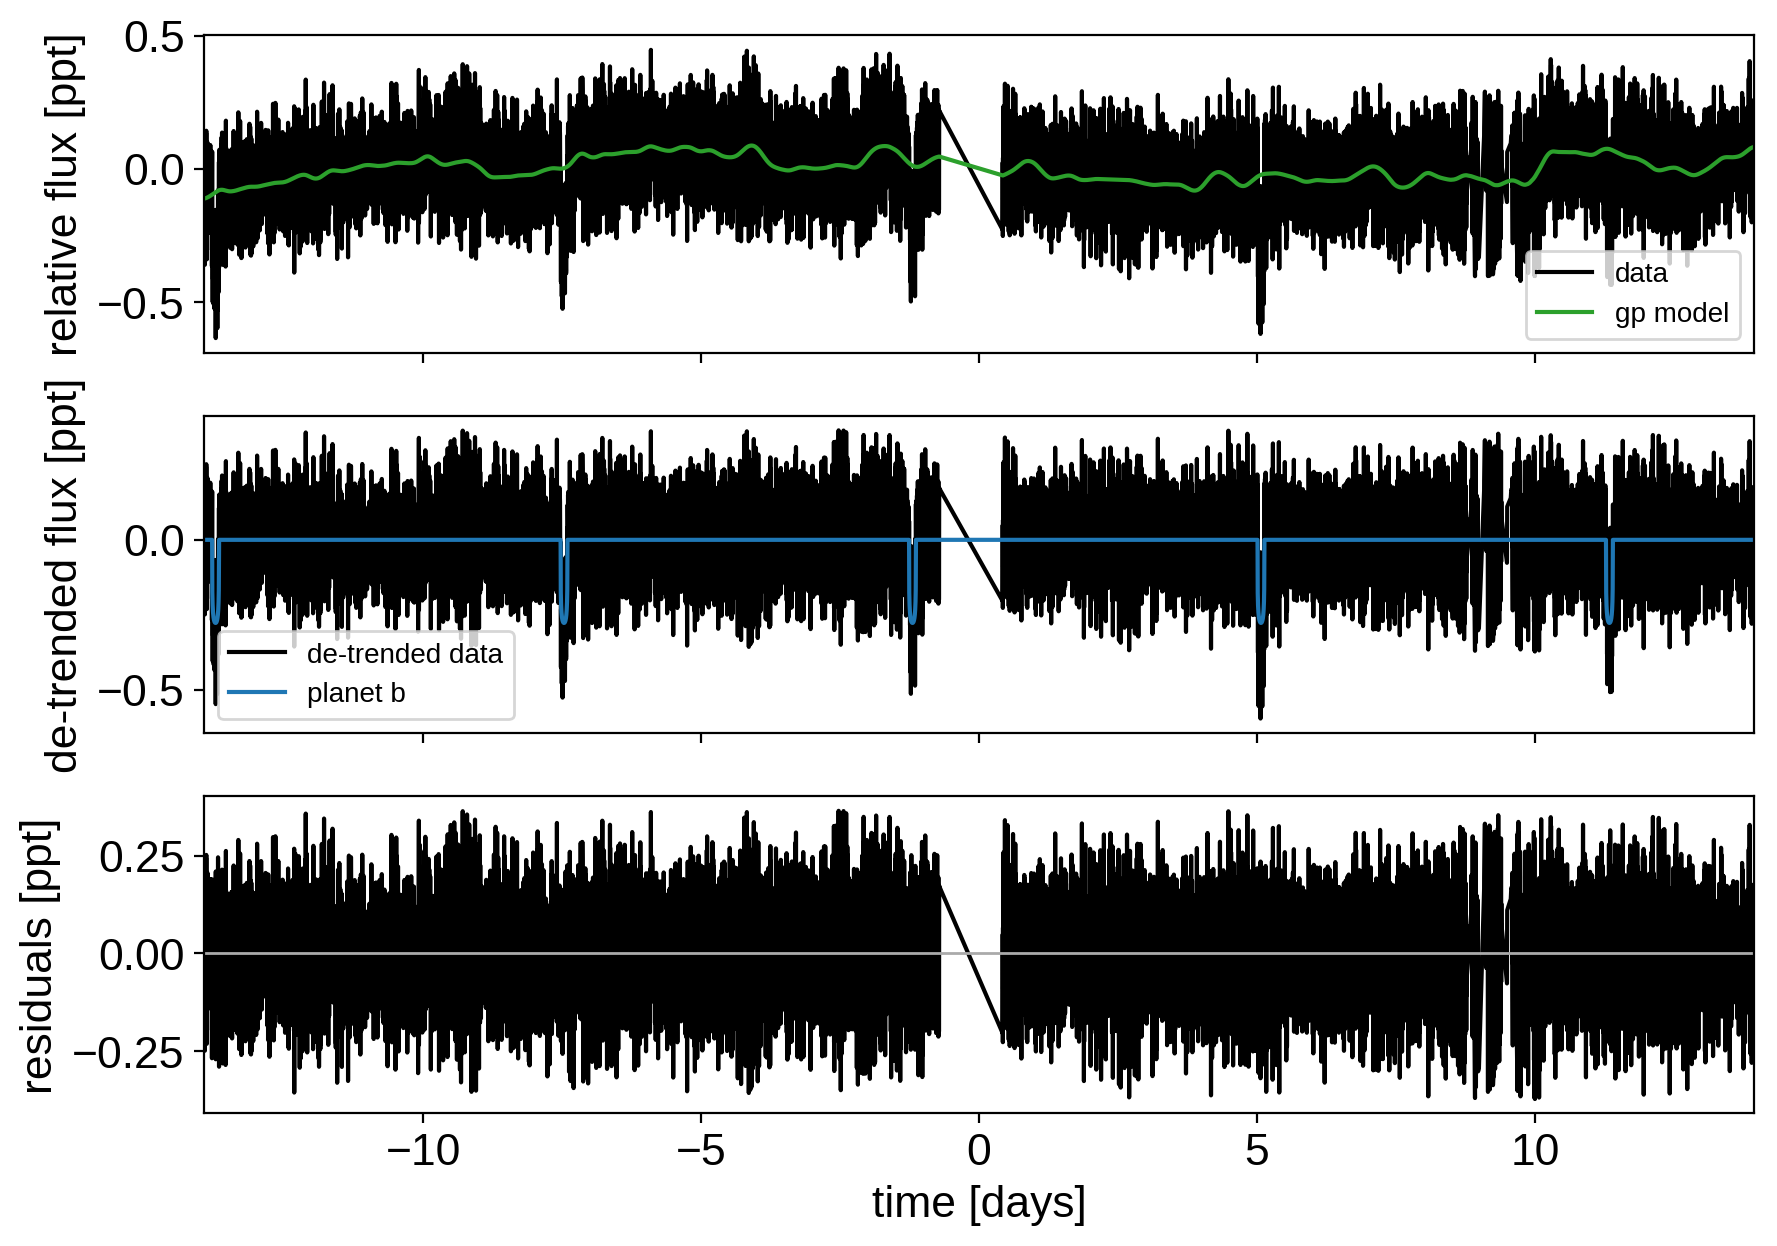

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Now that we have the model, we can sample:

In [14]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=5000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logSw4, logw0, logs2, omega, ecc, ecc_beta, ecc_alpha, b, logr, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/32000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 10/32000 [00:00<05:21, 99.54draws/s]

Sampling 4 chains:   0%|          | 17/32000 [00:02<56:30,  9.43draws/s]

Sampling 4 chains:   0%|          | 20/32000 [00:02<55:50,  9.55draws/s]

Sampling 4 chains:   0%|          | 22/32000 [00:04<3:28:40,  2.55draws/s]

Sampling 4 chains:   0%|          | 24/32000 [00:05<2:47:44,  3.18draws/s]

Sampling 4 chains:   0%|          | 26/32000 [00:07<4:38:16,  1.92draws/s]

Sampling 4 chains:   0%|          | 28/32000 [00:07<3:49:02,  2.33draws/s]

Sampling 4 chains:   0%|          | 29/32000 [00:09<6:55:23,  1.28draws/s]

Sampling 4 chains:   0%|          | 30/32000 [00:09<5:24:09,  1.64draws/s]

Sampling 4 chains:   0%|          | 32/32000 [00:10<4:41:41,  1.89draws/s]

Sampling 4 chains:   0%|          | 33/32000 [00:11<7:09:12,  1.24draws/s]

Sampling 4 chains:   0%|          | 34/32000 [00:11<5:42:32,  1.56draws/s]

Sampling 4 chains:   0%|          | 36/32000 [00:12<4:46:15,  1.86draws/s]

Sampling 4 chains:   0%|          | 37/32000 [00:13<6:44:02,  1.32draws/s]

Sampling 4 chains:   0%|          | 38/32000 [00:13<5:24:42,  1.64draws/s]

Sampling 4 chains:   0%|          | 40/32000 [00:14<4:38:45,  1.91draws/s]

Sampling 4 chains:   0%|          | 41/32000 [00:15<6:36:15,  1.34draws/s]

Sampling 4 chains:   0%|          | 42/32000 [00:16<5:23:34,  1.65draws/s]

Sampling 4 chains:   0%|          | 44/32000 [00:16<4:44:54,  1.87draws/s]

Sampling 4 chains:   0%|          | 45/32000 [00:17<6:21:31,  1.40draws/s]

Sampling 4 chains:   0%|          | 46/32000 [00:18<5:12:49,  1.70draws/s]

Sampling 4 chains:   0%|          | 48/32000 [00:18<4:40:03,  1.90draws/s]

Sampling 4 chains:   0%|          | 49/32000 [00:20<6:10:19,  1.44draws/s]

Sampling 4 chains:   0%|          | 50/32000 [00:20<5:04:27,  1.75draws/s]

Sampling 4 chains:   0%|          | 52/32000 [00:21<4:39:09,  1.91draws/s]

Sampling 4 chains:   0%|          | 53/32000 [00:21<5:12:01,  1.71draws/s]

Sampling 4 chains:   0%|          | 54/32000 [00:22<4:27:55,  1.99draws/s]

Sampling 4 chains:   0%|          | 55/32000 [00:22<3:52:57,  2.29draws/s]

Sampling 4 chains:   0%|          | 57/32000 [00:24<4:53:45,  1.81draws/s]

Sampling 4 chains:   0%|          | 58/32000 [00:24<3:59:42,  2.22draws/s]

Sampling 4 chains:   0%|          | 59/32000 [00:24<3:34:36,  2.48draws/s]

Sampling 4 chains:   0%|          | 60/32000 [00:24<2:46:14,  3.20draws/s]

Sampling 4 chains:   0%|          | 61/32000 [00:26<6:18:20,  1.41draws/s]

Sampling 4 chains:   0%|          | 62/32000 [00:26<4:45:29,  1.86draws/s]

Sampling 4 chains:   0%|          | 63/32000 [00:26<4:04:36,  2.18draws/s]

Sampling 4 chains:   0%|          | 64/32000 [00:26<3:07:30,  2.84draws/s]

Sampling 4 chains:   0%|          | 65/32000 [00:28<7:11:22,  1.23draws/s]

Sampling 4 chains:   0%|          | 67/32000 [00:29<5:34:30,  1.59draws/s]

Sampling 4 chains:   0%|          | 69/32000 [00:31<6:27:39,  1.37draws/s]

Sampling 4 chains:   0%|          | 71/32000 [00:31<4:59:01,  1.78draws/s]

Sampling 4 chains:   0%|          | 72/32000 [00:31<4:01:48,  2.20draws/s]

Sampling 4 chains:   0%|          | 73/32000 [00:32<4:28:44,  1.98draws/s]

Sampling 4 chains:   0%|          | 74/32000 [00:33<6:21:21,  1.40draws/s]

Sampling 4 chains:   0%|          | 75/32000 [00:33<4:52:58,  1.82draws/s]

Sampling 4 chains:   0%|          | 76/32000 [00:34<4:28:20,  1.98draws/s]

Sampling 4 chains:   0%|          | 77/32000 [00:34<4:31:15,  1.96draws/s]

Sampling 4 chains:   0%|          | 78/32000 [00:35<6:19:43,  1.40draws/s]

Sampling 4 chains:   0%|          | 79/32000 [00:36<5:13:49,  1.70draws/s]

Sampling 4 chains:   0%|          | 80/32000 [00:36<4:16:02,  2.08draws/s]

Sampling 4 chains:   0%|          | 81/32000 [00:36<4:30:01,  1.97draws/s]

Sampling 4 chains:   0%|          | 82/32000 [00:38<6:18:20,  1.41draws/s]

Sampling 4 chains:   0%|          | 83/32000 [00:38<5:28:22,  1.62draws/s]

Sampling 4 chains:   0%|          | 85/32000 [00:39<4:41:13,  1.89draws/s]

Sampling 4 chains:   0%|          | 86/32000 [00:40<6:22:25,  1.39draws/s]

Sampling 4 chains:   0%|          | 87/32000 [00:40<5:30:12,  1.61draws/s]

Sampling 4 chains:   0%|          | 89/32000 [00:41<4:48:16,  1.84draws/s]

Sampling 4 chains:   0%|          | 90/32000 [00:42<6:34:18,  1.35draws/s]

Sampling 4 chains:   0%|          | 91/32000 [00:42<5:37:27,  1.58draws/s]

Sampling 4 chains:   0%|          | 93/32000 [00:43<4:44:40,  1.87draws/s]

Sampling 4 chains:   0%|          | 94/32000 [00:43<4:16:46,  2.07draws/s]

Sampling 4 chains:   0%|          | 95/32000 [00:45<6:29:27,  1.37draws/s]

Sampling 4 chains:   0%|          | 97/32000 [00:45<5:22:04,  1.65draws/s]

Sampling 4 chains:   0%|          | 98/32000 [00:46<5:33:43,  1.59draws/s]

Sampling 4 chains:   0%|          | 99/32000 [00:47<7:08:30,  1.24draws/s]

Sampling 4 chains:   0%|          | 101/32000 [00:48<5:47:21,  1.53draws/s]

Sampling 4 chains:   0%|          | 102/32000 [00:49<6:30:28,  1.36draws/s]

Sampling 4 chains:   0%|          | 103/32000 [00:49<5:32:11,  1.60draws/s]

Sampling 4 chains:   0%|          | 104/32000 [00:50<5:44:42,  1.54draws/s]

Sampling 4 chains:   0%|          | 106/32000 [00:51<5:58:24,  1.48draws/s]

Sampling 4 chains:   0%|          | 107/32000 [00:52<4:59:10,  1.78draws/s]

Sampling 4 chains:   0%|          | 108/32000 [00:52<5:14:10,  1.69draws/s]

Sampling 4 chains:   0%|          | 109/32000 [00:53<4:17:43,  2.06draws/s]

Sampling 4 chains:   0%|          | 110/32000 [00:54<6:17:24,  1.41draws/s]

Sampling 4 chains:   0%|          | 111/32000 [00:54<5:28:36,  1.62draws/s]

Sampling 4 chains:   0%|          | 112/32000 [00:55<5:21:50,  1.65draws/s]

Sampling 4 chains:   0%|          | 113/32000 [00:55<4:19:24,  2.05draws/s]

Sampling 4 chains:   0%|          | 114/32000 [00:56<6:24:48,  1.38draws/s]

Sampling 4 chains:   0%|          | 115/32000 [00:57<6:03:20,  1.46draws/s]

Sampling 4 chains:   0%|          | 116/32000 [00:57<5:08:14,  1.72draws/s]

Sampling 4 chains:   0%|          | 117/32000 [00:58<4:52:17,  1.82draws/s]

Sampling 4 chains:   0%|          | 118/32000 [00:59<6:06:20,  1.45draws/s]

Sampling 4 chains:   0%|          | 119/32000 [00:59<5:31:47,  1.60draws/s]

Sampling 4 chains:   0%|          | 120/32000 [00:59<4:38:49,  1.91draws/s]

Sampling 4 chains:   0%|          | 121/32000 [01:00<4:26:11,  2.00draws/s]

Sampling 4 chains:   0%|          | 122/32000 [01:01<6:05:31,  1.45draws/s]

Sampling 4 chains:   0%|          | 123/32000 [01:01<5:11:22,  1.71draws/s]

Sampling 4 chains:   0%|          | 124/32000 [01:02<4:25:48,  2.00draws/s]

Sampling 4 chains:   0%|          | 125/32000 [01:02<4:19:24,  2.05draws/s]

Sampling 4 chains:   0%|          | 126/32000 [01:03<6:19:32,  1.40draws/s]

Sampling 4 chains:   0%|          | 127/32000 [01:04<5:09:39,  1.72draws/s]

Sampling 4 chains:   0%|          | 128/32000 [01:04<4:19:37,  2.05draws/s]

Sampling 4 chains:   0%|          | 129/32000 [01:04<4:22:15,  2.03draws/s]

Sampling 4 chains:   0%|          | 130/32000 [01:06<6:25:04,  1.38draws/s]

Sampling 4 chains:   0%|          | 131/32000 [01:06<4:54:26,  1.80draws/s]

Sampling 4 chains:   0%|          | 132/32000 [01:06<4:07:28,  2.15draws/s]

Sampling 4 chains:   0%|          | 133/32000 [01:06<4:01:01,  2.20draws/s]

Sampling 4 chains:   0%|          | 134/32000 [01:07<3:18:20,  2.68draws/s]

Sampling 4 chains:   0%|          | 135/32000 [01:08<5:30:12,  1.61draws/s]

Sampling 4 chains:   0%|          | 136/32000 [01:08<4:49:37,  1.83draws/s]

Sampling 4 chains:   0%|          | 137/32000 [01:09<4:31:51,  1.95draws/s]

Sampling 4 chains:   0%|          | 138/32000 [01:09<3:55:33,  2.25draws/s]

Sampling 4 chains:   0%|          | 139/32000 [01:10<5:50:33,  1.51draws/s]

Sampling 4 chains:   0%|          | 140/32000 [01:10<4:55:47,  1.80draws/s]

Sampling 4 chains:   0%|          | 141/32000 [01:11<4:40:19,  1.89draws/s]

Sampling 4 chains:   0%|          | 142/32000 [01:11<4:13:20,  2.10draws/s]

Sampling 4 chains:   0%|          | 143/32000 [01:12<5:58:57,  1.48draws/s]

Sampling 4 chains:   0%|          | 144/32000 [01:13<4:45:46,  1.86draws/s]

Sampling 4 chains:   0%|          | 145/32000 [01:13<4:34:03,  1.94draws/s]

Sampling 4 chains:   0%|          | 146/32000 [01:14<4:30:41,  1.96draws/s]

Sampling 4 chains:   0%|          | 147/32000 [01:15<6:01:21,  1.47draws/s]

Sampling 4 chains:   0%|          | 148/32000 [01:15<4:37:18,  1.91draws/s]

Sampling 4 chains:   0%|          | 149/32000 [01:15<4:31:06,  1.96draws/s]

Sampling 4 chains:   0%|          | 150/32000 [01:16<4:45:39,  1.86draws/s]

Sampling 4 chains:   0%|          | 151/32000 [01:17<6:02:25,  1.46draws/s]

Sampling 4 chains:   0%|          | 153/32000 [01:18<4:59:53,  1.77draws/s]

Sampling 4 chains:   0%|          | 154/32000 [01:18<5:25:43,  1.63draws/s]

Sampling 4 chains:   0%|          | 155/32000 [01:19<5:14:41,  1.69draws/s]

Sampling 4 chains:   0%|          | 156/32000 [01:19<4:43:15,  1.87draws/s]

Sampling 4 chains:   0%|          | 157/32000 [01:20<4:43:05,  1.87draws/s]

Sampling 4 chains:   0%|          | 158/32000 [01:21<5:35:09,  1.58draws/s]

Sampling 4 chains:   0%|          | 159/32000 [01:21<5:05:25,  1.74draws/s]

Sampling 4 chains:   0%|          | 160/32000 [01:21<4:27:14,  1.99draws/s]

Sampling 4 chains:   1%|          | 161/32000 [01:22<4:35:30,  1.93draws/s]

Sampling 4 chains:   1%|          | 162/32000 [01:23<5:49:27,  1.52draws/s]

Sampling 4 chains:   1%|          | 163/32000 [01:23<5:07:06,  1.73draws/s]

Sampling 4 chains:   1%|          | 164/32000 [01:24<4:14:20,  2.09draws/s]

Sampling 4 chains:   1%|          | 165/32000 [01:24<4:28:03,  1.98draws/s]

Sampling 4 chains:   1%|          | 166/32000 [01:25<6:02:41,  1.46draws/s]

Sampling 4 chains:   1%|          | 167/32000 [01:26<5:08:44,  1.72draws/s]

Sampling 4 chains:   1%|          | 168/32000 [01:26<4:08:30,  2.13draws/s]

Sampling 4 chains:   1%|          | 169/32000 [01:26<4:22:33,  2.02draws/s]

Sampling 4 chains:   1%|          | 170/32000 [01:28<6:25:37,  1.38draws/s]

Sampling 4 chains:   1%|          | 171/32000 [01:28<5:19:17,  1.66draws/s]

Sampling 4 chains:   1%|          | 172/32000 [01:28<3:59:53,  2.21draws/s]

Sampling 4 chains:   1%|          | 173/32000 [01:29<4:18:23,  2.05draws/s]

Sampling 4 chains:   1%|          | 174/32000 [01:30<6:31:28,  1.35draws/s]

Sampling 4 chains:   1%|          | 175/32000 [01:30<5:22:23,  1.65draws/s]

Sampling 4 chains:   1%|          | 177/32000 [01:31<4:31:11,  1.96draws/s]

Sampling 4 chains:   1%|          | 178/32000 [01:32<7:03:48,  1.25draws/s]

Sampling 4 chains:   1%|          | 179/32000 [01:32<5:20:09,  1.66draws/s]

Sampling 4 chains:   1%|          | 180/32000 [01:32<4:01:46,  2.19draws/s]

Sampling 4 chains:   1%|          | 181/32000 [01:33<4:04:21,  2.17draws/s]

Sampling 4 chains:   1%|          | 182/32000 [01:35<7:10:02,  1.23draws/s]

Sampling 4 chains:   1%|          | 184/32000 [01:35<5:16:05,  1.68draws/s]

Sampling 4 chains:   1%|          | 185/32000 [01:35<4:42:53,  1.87draws/s]

Sampling 4 chains:   1%|          | 186/32000 [01:37<7:35:14,  1.16draws/s]

Sampling 4 chains:   1%|          | 187/32000 [01:37<5:47:48,  1.52draws/s]

Sampling 4 chains:   1%|          | 189/32000 [01:37<4:36:04,  1.92draws/s]

Sampling 4 chains:   1%|          | 190/32000 [01:39<7:36:10,  1.16draws/s]

Sampling 4 chains:   1%|          | 191/32000 [01:39<6:19:48,  1.40draws/s]

Sampling 4 chains:   1%|          | 193/32000 [01:40<4:48:11,  1.84draws/s]

Sampling 4 chains:   1%|          | 194/32000 [01:40<4:36:20,  1.92draws/s]

Sampling 4 chains:   1%|          | 195/32000 [01:42<7:53:53,  1.12draws/s]

Sampling 4 chains:   1%|          | 197/32000 [01:42<5:59:23,  1.47draws/s]

Sampling 4 chains:   1%|          | 198/32000 [01:43<5:23:07,  1.64draws/s]

Sampling 4 chains:   1%|          | 199/32000 [01:43<4:02:33,  2.19draws/s]

Sampling 4 chains:   1%|          | 200/32000 [01:44<7:16:18,  1.21draws/s]

Sampling 4 chains:   1%|          | 201/32000 [01:45<5:57:04,  1.48draws/s]

Sampling 4 chains:   1%|          | 202/32000 [01:45<5:44:41,  1.54draws/s]

Sampling 4 chains:   1%|          | 203/32000 [01:46<4:22:16,  2.02draws/s]

Sampling 4 chains:   1%|          | 204/32000 [01:47<7:22:11,  1.20draws/s]

Sampling 4 chains:   1%|          | 205/32000 [01:47<5:42:47,  1.55draws/s]

Sampling 4 chains:   1%|          | 206/32000 [01:48<5:31:11,  1.60draws/s]

Sampling 4 chains:   1%|          | 208/32000 [01:49<4:38:03,  1.91draws/s]

Sampling 4 chains:   1%|          | 209/32000 [01:50<6:04:55,  1.45draws/s]

Sampling 4 chains:   1%|          | 210/32000 [01:50<6:25:02,  1.38draws/s]

Sampling 4 chains:   1%|          | 211/32000 [01:51<4:46:14,  1.85draws/s]

Sampling 4 chains:   1%|          | 212/32000 [01:51<4:58:34,  1.77draws/s]

Sampling 4 chains:   1%|          | 213/32000 [01:52<5:44:25,  1.54draws/s]

Sampling 4 chains:   1%|          | 214/32000 [01:53<6:12:56,  1.42draws/s]

Sampling 4 chains:   1%|          | 215/32000 [01:53<5:11:43,  1.70draws/s]

Sampling 4 chains:   1%|          | 216/32000 [01:54<5:07:26,  1.72draws/s]

Sampling 4 chains:   1%|          | 217/32000 [01:54<5:39:51,  1.56draws/s]

Sampling 4 chains:   1%|          | 218/32000 [01:56<7:12:47,  1.22draws/s]

Sampling 4 chains:   1%|          | 220/32000 [01:56<5:46:04,  1.53draws/s]

Sampling 4 chains:   1%|          | 221/32000 [01:57<6:03:09,  1.46draws/s]

Sampling 4 chains:   1%|          | 222/32000 [01:58<7:23:22,  1.19draws/s]

Sampling 4 chains:   1%|          | 223/32000 [01:58<5:36:14,  1.58draws/s]

Sampling 4 chains:   1%|          | 224/32000 [01:59<5:22:48,  1.64draws/s]

Sampling 4 chains:   1%|          | 225/32000 [02:00<6:36:12,  1.34draws/s]

Sampling 4 chains:   1%|          | 226/32000 [02:01<6:28:06,  1.36draws/s]

Sampling 4 chains:   1%|          | 227/32000 [02:01<4:57:16,  1.78draws/s]

Sampling 4 chains:   1%|          | 228/32000 [02:02<5:24:30,  1.63draws/s]

Sampling 4 chains:   1%|          | 229/32000 [02:03<6:36:23,  1.34draws/s]

Sampling 4 chains:   1%|          | 230/32000 [02:03<6:01:02,  1.47draws/s]

Sampling 4 chains:   1%|          | 231/32000 [02:04<5:44:07,  1.54draws/s]

Sampling 4 chains:   1%|          | 232/32000 [02:04<4:30:17,  1.96draws/s]

Sampling 4 chains:   1%|          | 233/32000 [02:05<6:26:53,  1.37draws/s]

Sampling 4 chains:   1%|          | 234/32000 [02:06<5:58:17,  1.48draws/s]

Sampling 4 chains:   1%|          | 235/32000 [02:07<6:22:31,  1.38draws/s]

Sampling 4 chains:   1%|          | 237/32000 [02:08<6:02:44,  1.46draws/s]

Sampling 4 chains:   1%|          | 238/32000 [02:08<5:43:47,  1.54draws/s]

Sampling 4 chains:   1%|          | 239/32000 [02:09<6:19:52,  1.39draws/s]

Sampling 4 chains:   1%|          | 240/32000 [02:10<6:09:47,  1.43draws/s]

Sampling 4 chains:   1%|          | 241/32000 [02:11<6:01:44,  1.46draws/s]

Sampling 4 chains:   1%|          | 242/32000 [02:11<5:32:40,  1.59draws/s]

Sampling 4 chains:   1%|          | 243/32000 [02:12<7:11:11,  1.23draws/s]

Sampling 4 chains:   1%|          | 244/32000 [02:12<5:26:02,  1.62draws/s]

Sampling 4 chains:   1%|          | 245/32000 [02:13<6:19:27,  1.39draws/s]

Sampling 4 chains:   1%|          | 246/32000 [02:14<5:39:12,  1.56draws/s]

Sampling 4 chains:   1%|          | 247/32000 [02:15<7:05:29,  1.24draws/s]

Sampling 4 chains:   1%|          | 248/32000 [02:15<5:14:10,  1.68draws/s]

Sampling 4 chains:   1%|          | 249/32000 [02:16<7:18:47,  1.21draws/s]

Sampling 4 chains:   1%|          | 251/32000 [02:18<6:51:27,  1.29draws/s]

Sampling 4 chains:   1%|          | 253/32000 [02:19<6:39:11,  1.33draws/s]

Sampling 4 chains:   1%|          | 254/32000 [02:20<5:33:26,  1.59draws/s]

Sampling 4 chains:   1%|          | 255/32000 [02:20<6:21:10,  1.39draws/s]

Sampling 4 chains:   1%|          | 257/32000 [02:22<6:11:29,  1.42draws/s]

Sampling 4 chains:   1%|          | 258/32000 [02:22<6:04:43,  1.45draws/s]

Sampling 4 chains:   1%|          | 259/32000 [02:23<6:20:25,  1.39draws/s]

Sampling 4 chains:   1%|          | 261/32000 [02:24<5:55:20,  1.49draws/s]

Sampling 4 chains:   1%|          | 262/32000 [02:25<6:26:36,  1.37draws/s]

Sampling 4 chains:   1%|          | 263/32000 [02:26<6:16:46,  1.40draws/s]

Sampling 4 chains:   1%|          | 264/32000 [02:26<4:56:19,  1.78draws/s]

Sampling 4 chains:   1%|          | 265/32000 [02:27<6:29:53,  1.36draws/s]

Sampling 4 chains:   1%|          | 266/32000 [02:28<7:32:36,  1.17draws/s]

Sampling 4 chains:   1%|          | 267/32000 [02:29<5:50:43,  1.51draws/s]

Sampling 4 chains:   1%|          | 268/32000 [02:29<4:37:17,  1.91draws/s]

Sampling 4 chains:   1%|          | 269/32000 [02:30<6:11:15,  1.42draws/s]

Sampling 4 chains:   1%|          | 270/32000 [02:31<8:10:17,  1.08draws/s]

Sampling 4 chains:   1%|          | 272/32000 [02:31<5:51:33,  1.50draws/s]

Sampling 4 chains:   1%|          | 273/32000 [02:33<7:14:04,  1.22draws/s]

Sampling 4 chains:   1%|          | 274/32000 [02:34<9:03:26,  1.03s/draws]

Sampling 4 chains:   1%|          | 277/32000 [02:36<7:42:55,  1.14draws/s]

Sampling 4 chains:   1%|          | 278/32000 [02:37<8:03:49,  1.09draws/s]

Sampling 4 chains:   1%|          | 280/32000 [02:37<5:49:16,  1.51draws/s]

Sampling 4 chains:   1%|          | 281/32000 [02:38<7:55:23,  1.11draws/s]

Sampling 4 chains:   1%|          | 282/32000 [02:39<6:28:06,  1.36draws/s]

Sampling 4 chains:   1%|          | 283/32000 [02:40<6:59:54,  1.26draws/s]

Sampling 4 chains:   1%|          | 285/32000 [02:41<6:37:55,  1.33draws/s]

Sampling 4 chains:   1%|          | 286/32000 [02:42<6:35:49,  1.34draws/s]

Sampling 4 chains:   1%|          | 287/32000 [02:42<6:26:30,  1.37draws/s]

Sampling 4 chains:   1%|          | 288/32000 [02:43<5:08:25,  1.71draws/s]

Sampling 4 chains:   1%|          | 289/32000 [02:44<6:26:15,  1.37draws/s]

Sampling 4 chains:   1%|          | 290/32000 [02:44<6:29:06,  1.36draws/s]

Sampling 4 chains:   1%|          | 291/32000 [02:45<5:54:05,  1.49draws/s]

Sampling 4 chains:   1%|          | 292/32000 [02:46<5:39:04,  1.56draws/s]

Sampling 4 chains:   1%|          | 293/32000 [02:46<6:32:53,  1.35draws/s]

Sampling 4 chains:   1%|          | 294/32000 [02:47<6:17:59,  1.40draws/s]

Sampling 4 chains:   1%|          | 295/32000 [02:47<5:07:36,  1.72draws/s]

Sampling 4 chains:   1%|          | 296/32000 [02:48<5:30:39,  1.60draws/s]

Sampling 4 chains:   1%|          | 297/32000 [02:49<6:47:42,  1.30draws/s]

Sampling 4 chains:   1%|          | 298/32000 [02:50<6:55:06,  1.27draws/s]

Sampling 4 chains:   1%|          | 300/32000 [02:51<5:49:12,  1.51draws/s]

Sampling 4 chains:   1%|          | 301/32000 [02:52<7:20:06,  1.20draws/s]

Sampling 4 chains:   1%|          | 302/32000 [02:53<6:48:56,  1.29draws/s]

Sampling 4 chains:   1%|          | 303/32000 [02:53<6:21:04,  1.39draws/s]

Sampling 4 chains:   1%|          | 304/32000 [02:54<5:15:41,  1.67draws/s]

Sampling 4 chains:   1%|          | 305/32000 [02:55<6:48:17,  1.29draws/s]

Sampling 4 chains:   1%|          | 306/32000 [02:55<6:19:29,  1.39draws/s]

Sampling 4 chains:   1%|          | 307/32000 [02:56<6:48:08,  1.29draws/s]

Sampling 4 chains:   1%|          | 309/32000 [02:57<6:15:35,  1.41draws/s]

Sampling 4 chains:   1%|          | 310/32000 [02:58<6:11:59,  1.42draws/s]

Sampling 4 chains:   1%|          | 311/32000 [02:59<6:53:23,  1.28draws/s]

Sampling 4 chains:   1%|          | 312/32000 [02:59<5:44:07,  1.53draws/s]

Sampling 4 chains:   1%|          | 313/32000 [03:00<6:07:07,  1.44draws/s]

Sampling 4 chains:   1%|          | 314/32000 [03:01<6:05:06,  1.45draws/s]

Sampling 4 chains:   1%|          | 315/32000 [03:02<6:28:27,  1.36draws/s]

Sampling 4 chains:   1%|          | 316/32000 [03:02<6:00:45,  1.46draws/s]

Sampling 4 chains:   1%|          | 317/32000 [03:03<6:10:47,  1.42draws/s]

Sampling 4 chains:   1%|          | 318/32000 [03:04<5:46:59,  1.52draws/s]

Sampling 4 chains:   1%|          | 319/32000 [03:04<6:04:49,  1.45draws/s]

Sampling 4 chains:   1%|          | 320/32000 [03:05<6:03:36,  1.45draws/s]

Sampling 4 chains:   1%|          | 321/32000 [03:05<5:24:17,  1.63draws/s]

Sampling 4 chains:   1%|          | 322/32000 [03:06<6:10:26,  1.43draws/s]

Sampling 4 chains:   1%|          | 323/32000 [03:07<6:17:26,  1.40draws/s]

Sampling 4 chains:   1%|          | 324/32000 [03:08<6:16:08,  1.40draws/s]

Sampling 4 chains:   1%|          | 325/32000 [03:08<5:04:11,  1.74draws/s]

Sampling 4 chains:   1%|          | 326/32000 [03:09<6:36:16,  1.33draws/s]

Sampling 4 chains:   1%|          | 327/32000 [03:10<6:39:23,  1.32draws/s]

Sampling 4 chains:   1%|          | 328/32000 [03:11<6:32:24,  1.35draws/s]

Sampling 4 chains:   1%|          | 329/32000 [03:11<4:56:18,  1.78draws/s]

Sampling 4 chains:   1%|          | 330/32000 [03:12<6:54:28,  1.27draws/s]

Sampling 4 chains:   1%|          | 331/32000 [03:13<6:59:19,  1.26draws/s]

Sampling 4 chains:   1%|          | 332/32000 [03:14<6:23:52,  1.37draws/s]

Sampling 4 chains:   1%|          | 333/32000 [03:14<5:15:17,  1.67draws/s]

Sampling 4 chains:   1%|          | 334/32000 [03:15<7:01:29,  1.25draws/s]

Sampling 4 chains:   1%|          | 335/32000 [03:16<6:24:08,  1.37draws/s]

Sampling 4 chains:   1%|          | 336/32000 [03:16<6:35:40,  1.33draws/s]

Sampling 4 chains:   1%|          | 337/32000 [03:17<5:26:50,  1.61draws/s]

Sampling 4 chains:   1%|          | 338/32000 [03:18<7:23:29,  1.19draws/s]

Sampling 4 chains:   1%|          | 339/32000 [03:18<5:54:56,  1.49draws/s]

Sampling 4 chains:   1%|          | 340/32000 [03:19<6:25:25,  1.37draws/s]

Sampling 4 chains:   1%|          | 341/32000 [03:20<6:15:53,  1.40draws/s]

Sampling 4 chains:   1%|          | 342/32000 [03:21<7:31:53,  1.17draws/s]

Sampling 4 chains:   1%|          | 344/32000 [03:22<6:52:35,  1.28draws/s]

Sampling 4 chains:   1%|          | 345/32000 [03:23<6:15:06,  1.41draws/s]

Sampling 4 chains:   1%|          | 346/32000 [03:24<6:45:52,  1.30draws/s]

Sampling 4 chains:   1%|          | 348/32000 [03:25<6:35:22,  1.33draws/s]

Sampling 4 chains:   1%|          | 349/32000 [03:26<6:28:50,  1.36draws/s]

Sampling 4 chains:   1%|          | 350/32000 [03:27<6:09:25,  1.43draws/s]

Sampling 4 chains:   1%|          | 351/32000 [03:27<4:58:43,  1.77draws/s]

Sampling 4 chains:   1%|          | 352/32000 [03:28<7:48:05,  1.13draws/s]

Sampling 4 chains:   1%|          | 353/32000 [03:29<6:10:52,  1.42draws/s]

Sampling 4 chains:   1%|          | 355/32000 [03:30<5:25:12,  1.62draws/s]

Sampling 4 chains:   1%|          | 356/32000 [03:31<8:31:19,  1.03draws/s]

Sampling 4 chains:   1%|          | 358/32000 [03:32<6:21:13,  1.38draws/s]

Sampling 4 chains:   1%|          | 359/32000 [03:32<6:33:58,  1.34draws/s]

Sampling 4 chains:   1%|          | 360/32000 [03:34<9:36:28,  1.09s/draws]

Sampling 4 chains:   1%|          | 362/32000 [03:35<6:58:01,  1.26draws/s]

Sampling 4 chains:   1%|          | 363/32000 [03:35<6:49:40,  1.29draws/s]

Sampling 4 chains:   1%|          | 364/32000 [03:37<9:39:03,  1.10s/draws]

Sampling 4 chains:   1%|          | 367/32000 [03:38<7:31:19,  1.17draws/s]

Sampling 4 chains:   1%|          | 368/32000 [03:40<9:40:51,  1.10s/draws]

Sampling 4 chains:   1%|          | 369/32000 [03:40<7:10:31,  1.22draws/s]

Sampling 4 chains:   1%|          | 370/32000 [03:40<6:15:38,  1.40draws/s]

Sampling 4 chains:   1%|          | 371/32000 [03:41<5:29:18,  1.60draws/s]

Sampling 4 chains:   1%|          | 372/32000 [03:42<8:00:36,  1.10draws/s]

Sampling 4 chains:   1%|          | 374/32000 [03:43<6:16:28,  1.40draws/s]

Sampling 4 chains:   1%|          | 375/32000 [03:43<5:18:41,  1.65draws/s]

Sampling 4 chains:   1%|          | 376/32000 [03:45<7:45:02,  1.13draws/s]

Sampling 4 chains:   1%|          | 377/32000 [03:45<5:53:00,  1.49draws/s]

Sampling 4 chains:   1%|          | 378/32000 [03:45<5:10:34,  1.70draws/s]

Sampling 4 chains:   1%|          | 379/32000 [03:45<4:17:10,  2.05draws/s]

Sampling 4 chains:   1%|          | 380/32000 [03:47<7:04:16,  1.24draws/s]

Sampling 4 chains:   1%|          | 381/32000 [03:47<5:53:38,  1.49draws/s]

Sampling 4 chains:   1%|          | 382/32000 [03:48<4:56:40,  1.78draws/s]

Sampling 4 chains:   1%|          | 383/32000 [03:48<3:57:18,  2.22draws/s]

Sampling 4 chains:   1%|          | 384/32000 [03:49<6:53:32,  1.27draws/s]

Sampling 4 chains:   1%|          | 385/32000 [03:50<5:59:48,  1.46draws/s]

Sampling 4 chains:   1%|          | 386/32000 [03:50<4:58:19,  1.77draws/s]

Sampling 4 chains:   1%|          | 388/32000 [03:52<5:38:51,  1.55draws/s]

Sampling 4 chains:   1%|          | 389/32000 [03:52<4:27:12,  1.97draws/s]

Sampling 4 chains:   1%|          | 390/32000 [03:52<4:03:52,  2.16draws/s]

Sampling 4 chains:   1%|          | 391/32000 [03:53<3:30:17,  2.51draws/s]

Sampling 4 chains:   1%|          | 392/32000 [03:54<6:38:36,  1.32draws/s]

Sampling 4 chains:   1%|          | 393/32000 [03:55<5:22:35,  1.63draws/s]

Sampling 4 chains:   1%|          | 394/32000 [03:55<4:44:19,  1.85draws/s]

Sampling 4 chains:   1%|          | 395/32000 [03:55<3:42:09,  2.37draws/s]

Sampling 4 chains:   1%|          | 396/32000 [03:57<6:46:31,  1.30draws/s]

Sampling 4 chains:   1%|          | 397/32000 [03:57<5:42:04,  1.54draws/s]

Sampling 4 chains:   1%|          | 398/32000 [03:57<5:05:48,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 400/32000 [03:59<5:41:12,  1.54draws/s]

Sampling 4 chains:   1%|▏         | 401/32000 [03:59<5:06:26,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 402/32000 [04:00<4:33:07,  1.93draws/s]

Sampling 4 chains:   1%|▏         | 403/32000 [04:00<3:27:36,  2.54draws/s]

Sampling 4 chains:   1%|▏         | 404/32000 [04:01<6:21:47,  1.38draws/s]

Sampling 4 chains:   1%|▏         | 405/32000 [04:02<5:45:19,  1.52draws/s]

Sampling 4 chains:   1%|▏         | 406/32000 [04:02<4:50:34,  1.81draws/s]

Sampling 4 chains:   1%|▏         | 407/32000 [04:02<3:58:24,  2.21draws/s]

Sampling 4 chains:   1%|▏         | 408/32000 [04:04<6:21:59,  1.38draws/s]

Sampling 4 chains:   1%|▏         | 409/32000 [04:04<5:56:50,  1.48draws/s]

Sampling 4 chains:   1%|▏         | 410/32000 [04:05<4:47:20,  1.83draws/s]

Sampling 4 chains:   1%|▏         | 411/32000 [04:05<4:14:36,  2.07draws/s]

Sampling 4 chains:   1%|▏         | 412/32000 [04:06<6:11:21,  1.42draws/s]

Sampling 4 chains:   1%|▏         | 413/32000 [04:07<6:05:45,  1.44draws/s]

Sampling 4 chains:   1%|▏         | 414/32000 [04:07<4:38:35,  1.89draws/s]

Sampling 4 chains:   1%|▏         | 415/32000 [04:07<4:25:32,  1.98draws/s]

Sampling 4 chains:   1%|▏         | 416/32000 [04:09<6:00:56,  1.46draws/s]

Sampling 4 chains:   1%|▏         | 417/32000 [04:09<6:13:38,  1.41draws/s]

Sampling 4 chains:   1%|▏         | 419/32000 [04:10<5:09:32,  1.70draws/s]

Sampling 4 chains:   1%|▏         | 420/32000 [04:11<6:11:10,  1.42draws/s]

Sampling 4 chains:   1%|▏         | 421/32000 [04:12<6:34:04,  1.34draws/s]

Sampling 4 chains:   1%|▏         | 423/32000 [04:12<5:26:50,  1.61draws/s]

Sampling 4 chains:   1%|▏         | 424/32000 [04:13<6:05:09,  1.44draws/s]

Sampling 4 chains:   1%|▏         | 425/32000 [04:14<6:30:24,  1.35draws/s]

Sampling 4 chains:   1%|▏         | 426/32000 [04:14<4:49:51,  1.82draws/s]

Sampling 4 chains:   1%|▏         | 427/32000 [04:15<5:10:34,  1.69draws/s]

Sampling 4 chains:   1%|▏         | 428/32000 [04:16<5:33:57,  1.58draws/s]

Sampling 4 chains:   1%|▏         | 429/32000 [04:16<6:07:23,  1.43draws/s]

Sampling 4 chains:   1%|▏         | 430/32000 [04:17<5:05:49,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 431/32000 [04:17<5:06:21,  1.72draws/s]

Sampling 4 chains:   1%|▏         | 432/32000 [04:18<5:12:21,  1.68draws/s]

Sampling 4 chains:   1%|▏         | 433/32000 [04:19<5:53:32,  1.49draws/s]

Sampling 4 chains:   1%|▏         | 434/32000 [04:19<5:29:16,  1.60draws/s]

Sampling 4 chains:   1%|▏         | 435/32000 [04:20<5:07:49,  1.71draws/s]

Sampling 4 chains:   1%|▏         | 436/32000 [04:20<4:53:26,  1.79draws/s]

Sampling 4 chains:   1%|▏         | 437/32000 [04:21<5:39:47,  1.55draws/s]

Sampling 4 chains:   1%|▏         | 438/32000 [04:22<5:54:08,  1.49draws/s]

Sampling 4 chains:   1%|▏         | 439/32000 [04:22<5:08:51,  1.70draws/s]

Sampling 4 chains:   1%|▏         | 440/32000 [04:23<4:36:16,  1.90draws/s]

Sampling 4 chains:   1%|▏         | 441/32000 [04:24<5:29:21,  1.60draws/s]

Sampling 4 chains:   1%|▏         | 442/32000 [04:25<6:20:17,  1.38draws/s]

Sampling 4 chains:   1%|▏         | 443/32000 [04:25<5:11:02,  1.69draws/s]

Sampling 4 chains:   1%|▏         | 444/32000 [04:25<4:18:53,  2.03draws/s]

Sampling 4 chains:   1%|▏         | 445/32000 [04:26<5:16:12,  1.66draws/s]

Sampling 4 chains:   1%|▏         | 446/32000 [04:27<6:46:40,  1.29draws/s]

Sampling 4 chains:   1%|▏         | 447/32000 [04:27<5:12:11,  1.68draws/s]

Sampling 4 chains:   1%|▏         | 448/32000 [04:27<4:04:22,  2.15draws/s]

Sampling 4 chains:   1%|▏         | 449/32000 [04:28<5:19:15,  1.65draws/s]

Sampling 4 chains:   1%|▏         | 450/32000 [04:30<7:45:48,  1.13draws/s]

Sampling 4 chains:   1%|▏         | 452/32000 [04:30<5:35:56,  1.57draws/s]

Sampling 4 chains:   1%|▏         | 453/32000 [04:31<6:23:13,  1.37draws/s]

Sampling 4 chains:   1%|▏         | 454/32000 [04:33<8:57:03,  1.02s/draws]

Sampling 4 chains:   1%|▏         | 457/32000 [04:34<7:10:33,  1.22draws/s]

Sampling 4 chains:   1%|▏         | 458/32000 [04:35<9:13:14,  1.05s/draws]

Sampling 4 chains:   1%|▏         | 460/32000 [04:36<6:58:31,  1.26draws/s]

Sampling 4 chains:   1%|▏         | 461/32000 [04:36<6:44:43,  1.30draws/s]

Sampling 4 chains:   1%|▏         | 462/32000 [04:38<8:34:47,  1.02draws/s]

Sampling 4 chains:   1%|▏         | 463/32000 [04:38<6:28:08,  1.35draws/s]

Sampling 4 chains:   1%|▏         | 464/32000 [04:39<6:03:04,  1.45draws/s]

Sampling 4 chains:   1%|▏         | 465/32000 [04:39<5:31:02,  1.59draws/s]

Sampling 4 chains:   1%|▏         | 466/32000 [04:40<7:25:12,  1.18draws/s]

Sampling 4 chains:   1%|▏         | 467/32000 [04:41<5:57:01,  1.47draws/s]

Sampling 4 chains:   1%|▏         | 468/32000 [04:41<6:00:50,  1.46draws/s]

Sampling 4 chains:   1%|▏         | 469/32000 [04:42<5:54:05,  1.48draws/s]

Sampling 4 chains:   1%|▏         | 470/32000 [04:43<7:23:02,  1.19draws/s]

Sampling 4 chains:   1%|▏         | 471/32000 [04:44<6:01:37,  1.45draws/s]

Sampling 4 chains:   1%|▏         | 472/32000 [04:44<5:23:01,  1.63draws/s]

Sampling 4 chains:   1%|▏         | 473/32000 [04:45<5:01:50,  1.74draws/s]

Sampling 4 chains:   1%|▏         | 474/32000 [04:46<7:02:46,  1.24draws/s]

Sampling 4 chains:   1%|▏         | 475/32000 [04:46<5:30:26,  1.59draws/s]

Sampling 4 chains:   1%|▏         | 476/32000 [04:47<5:08:17,  1.70draws/s]

Sampling 4 chains:   1%|▏         | 477/32000 [04:47<4:33:40,  1.92draws/s]

Sampling 4 chains:   1%|▏         | 478/32000 [04:49<7:15:57,  1.21draws/s]

Sampling 4 chains:   1%|▏         | 479/32000 [04:49<5:21:32,  1.63draws/s]

Sampling 4 chains:   2%|▏         | 480/32000 [04:49<5:22:46,  1.63draws/s]

Sampling 4 chains:   2%|▏         | 481/32000 [04:50<4:26:05,  1.97draws/s]

Sampling 4 chains:   2%|▏         | 482/32000 [04:51<7:43:35,  1.13draws/s]

Sampling 4 chains:   2%|▏         | 484/32000 [04:52<6:19:32,  1.38draws/s]

Sampling 4 chains:   2%|▏         | 485/32000 [04:52<4:43:55,  1.85draws/s]

Sampling 4 chains:   2%|▏         | 486/32000 [04:54<8:25:20,  1.04draws/s]

Sampling 4 chains:   2%|▏         | 487/32000 [04:54<6:31:49,  1.34draws/s]

Sampling 4 chains:   2%|▏         | 488/32000 [04:55<5:46:55,  1.51draws/s]

Sampling 4 chains:   2%|▏         | 489/32000 [04:55<4:18:51,  2.03draws/s]

Sampling 4 chains:   2%|▏         | 490/32000 [04:57<7:55:09,  1.11draws/s]

Sampling 4 chains:   2%|▏         | 491/32000 [04:57<6:23:31,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 492/32000 [04:58<5:53:04,  1.49draws/s]

Sampling 4 chains:   2%|▏         | 494/32000 [04:59<6:35:11,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 495/32000 [05:00<5:07:13,  1.71draws/s]

Sampling 4 chains:   2%|▏         | 496/32000 [05:01<6:27:17,  1.36draws/s]

Sampling 4 chains:   2%|▏         | 498/32000 [05:02<6:35:29,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 500/32000 [05:04<6:34:44,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 502/32000 [05:05<6:06:15,  1.43draws/s]

Sampling 4 chains:   2%|▏         | 503/32000 [05:05<5:07:16,  1.71draws/s]

Sampling 4 chains:   2%|▏         | 504/32000 [05:07<7:32:27,  1.16draws/s]

Sampling 4 chains:   2%|▏         | 506/32000 [05:08<6:42:46,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 507/32000 [05:09<6:23:19,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 508/32000 [05:10<7:30:31,  1.17draws/s]

Sampling 4 chains:   2%|▏         | 510/32000 [05:11<6:59:21,  1.25draws/s]

Sampling 4 chains:   2%|▏         | 511/32000 [05:12<6:47:35,  1.29draws/s]

Sampling 4 chains:   2%|▏         | 512/32000 [05:13<6:56:44,  1.26draws/s]

Sampling 4 chains:   2%|▏         | 513/32000 [05:13<5:11:43,  1.68draws/s]

Sampling 4 chains:   2%|▏         | 514/32000 [05:14<7:37:58,  1.15draws/s]

Sampling 4 chains:   2%|▏         | 515/32000 [05:15<7:18:04,  1.20draws/s]

Sampling 4 chains:   2%|▏         | 516/32000 [05:16<6:43:16,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 518/32000 [05:17<7:07:19,  1.23draws/s]

Sampling 4 chains:   2%|▏         | 519/32000 [05:18<6:44:18,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 520/32000 [05:19<5:54:58,  1.48draws/s]

Sampling 4 chains:   2%|▏         | 522/32000 [05:21<6:56:58,  1.26draws/s]

Sampling 4 chains:   2%|▏         | 523/32000 [05:21<6:43:08,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 524/32000 [05:22<4:59:08,  1.75draws/s]

Sampling 4 chains:   2%|▏         | 525/32000 [05:22<4:08:29,  2.11draws/s]

Sampling 4 chains:   2%|▏         | 526/32000 [05:24<7:44:06,  1.13draws/s]

Sampling 4 chains:   2%|▏         | 527/32000 [05:24<7:18:43,  1.20draws/s]

Sampling 4 chains:   2%|▏         | 528/32000 [05:25<6:07:31,  1.43draws/s]

Sampling 4 chains:   2%|▏         | 530/32000 [05:27<7:04:45,  1.23draws/s]

Sampling 4 chains:   2%|▏         | 531/32000 [05:27<6:23:34,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 532/32000 [05:28<5:26:04,  1.61draws/s]

Sampling 4 chains:   2%|▏         | 533/32000 [05:28<4:10:48,  2.09draws/s]

Sampling 4 chains:   2%|▏         | 534/32000 [05:30<7:49:11,  1.12draws/s]

Sampling 4 chains:   2%|▏         | 535/32000 [05:30<6:56:21,  1.26draws/s]

Sampling 4 chains:   2%|▏         | 536/32000 [05:31<6:08:19,  1.42draws/s]

Sampling 4 chains:   2%|▏         | 537/32000 [05:31<5:20:00,  1.64draws/s]

Sampling 4 chains:   2%|▏         | 538/32000 [05:33<7:48:35,  1.12draws/s]

Sampling 4 chains:   2%|▏         | 539/32000 [05:33<6:35:40,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 540/32000 [05:34<6:10:39,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 541/32000 [05:34<5:01:08,  1.74draws/s]

Sampling 4 chains:   2%|▏         | 542/32000 [05:36<8:59:57,  1.03s/draws]

Sampling 4 chains:   2%|▏         | 544/32000 [05:37<7:07:54,  1.23draws/s]

Sampling 4 chains:   2%|▏         | 546/32000 [05:39<8:08:49,  1.07draws/s]

Sampling 4 chains:   2%|▏         | 547/32000 [05:40<6:34:26,  1.33draws/s]

Sampling 4 chains:   2%|▏         | 548/32000 [05:40<5:03:52,  1.73draws/s]

Sampling 4 chains:   2%|▏         | 550/32000 [05:42<6:52:06,  1.27draws/s]

Sampling 4 chains:   2%|▏         | 551/32000 [05:43<5:47:36,  1.51draws/s]

Sampling 4 chains:   2%|▏         | 553/32000 [05:43<4:12:26,  2.08draws/s]

Sampling 4 chains:   2%|▏         | 554/32000 [05:45<9:43:42,  1.11s/draws]

Sampling 4 chains:   2%|▏         | 555/32000 [05:46<7:35:06,  1.15draws/s]

Sampling 4 chains:   2%|▏         | 556/32000 [05:46<5:38:01,  1.55draws/s]

Sampling 4 chains:   2%|▏         | 557/32000 [05:46<4:47:06,  1.83draws/s]

Sampling 4 chains:   2%|▏         | 558/32000 [05:48<9:42:54,  1.11s/draws]

Sampling 4 chains:   2%|▏         | 560/32000 [05:49<7:10:02,  1.22draws/s]

Sampling 4 chains:   2%|▏         | 561/32000 [05:49<5:43:23,  1.53draws/s]

Sampling 4 chains:   2%|▏         | 562/32000 [05:49<5:00:51,  1.74draws/s]

Sampling 4 chains:   2%|▏         | 563/32000 [05:51<8:46:26,  1.00s/draws]

Sampling 4 chains:   2%|▏         | 566/32000 [05:53<7:14:23,  1.21draws/s]

Sampling 4 chains:   2%|▏         | 567/32000 [05:54<9:31:58,  1.09s/draws]

Sampling 4 chains:   2%|▏         | 568/32000 [05:55<7:21:17,  1.19draws/s]

Sampling 4 chains:   2%|▏         | 569/32000 [05:55<5:28:55,  1.59draws/s]

Sampling 4 chains:   2%|▏         | 570/32000 [05:56<5:54:06,  1.48draws/s]

Sampling 4 chains:   2%|▏         | 571/32000 [05:57<7:39:48,  1.14draws/s]

Sampling 4 chains:   2%|▏         | 572/32000 [05:57<6:31:13,  1.34draws/s]

Sampling 4 chains:   2%|▏         | 573/32000 [05:58<5:17:19,  1.65draws/s]

Sampling 4 chains:   2%|▏         | 574/32000 [05:59<5:59:27,  1.46draws/s]

Sampling 4 chains:   2%|▏         | 575/32000 [06:00<8:09:23,  1.07draws/s]

Sampling 4 chains:   2%|▏         | 576/32000 [06:00<6:28:17,  1.35draws/s]

Sampling 4 chains:   2%|▏         | 577/32000 [06:01<5:29:41,  1.59draws/s]

Sampling 4 chains:   2%|▏         | 578/32000 [06:02<6:52:00,  1.27draws/s]

Sampling 4 chains:   2%|▏         | 579/32000 [06:03<6:43:00,  1.30draws/s]

Sampling 4 chains:   2%|▏         | 580/32000 [06:03<6:01:10,  1.45draws/s]

Sampling 4 chains:   2%|▏         | 582/32000 [06:03<4:22:51,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 583/32000 [06:03<3:41:22,  2.37draws/s]

Sampling 4 chains:   2%|▏         | 584/32000 [06:05<5:31:48,  1.58draws/s]

Sampling 4 chains:   2%|▏         | 585/32000 [06:06<7:56:36,  1.10draws/s]

Sampling 4 chains:   2%|▏         | 586/32000 [06:06<6:00:57,  1.45draws/s]

Sampling 4 chains:   2%|▏         | 587/32000 [06:06<4:35:56,  1.90draws/s]

Sampling 4 chains:   2%|▏         | 588/32000 [06:07<4:15:07,  2.05draws/s]

Sampling 4 chains:   2%|▏         | 589/32000 [06:08<4:59:00,  1.75draws/s]

Sampling 4 chains:   2%|▏         | 590/32000 [06:08<5:18:25,  1.64draws/s]

Sampling 4 chains:   2%|▏         | 592/32000 [06:09<3:58:30,  2.19draws/s]

Sampling 4 chains:   2%|▏         | 593/32000 [06:10<5:35:48,  1.56draws/s]

Sampling 4 chains:   2%|▏         | 596/32000 [06:10<4:05:23,  2.13draws/s]

Sampling 4 chains:   2%|▏         | 597/32000 [06:10<3:30:19,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 598/32000 [06:12<6:21:33,  1.37draws/s]

Sampling 4 chains:   2%|▏         | 599/32000 [06:12<6:24:39,  1.36draws/s]

Sampling 4 chains:   2%|▏         | 600/32000 [06:13<5:22:16,  1.62draws/s]

Sampling 4 chains:   2%|▏         | 602/32000 [06:13<3:56:04,  2.22draws/s]

Sampling 4 chains:   2%|▏         | 603/32000 [06:13<3:37:07,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 604/32000 [06:14<5:07:40,  1.70draws/s]

Sampling 4 chains:   2%|▏         | 605/32000 [06:16<7:23:31,  1.18draws/s]

Sampling 4 chains:   2%|▏         | 607/32000 [06:16<5:26:58,  1.60draws/s]

Sampling 4 chains:   2%|▏         | 608/32000 [06:16<4:16:40,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 609/32000 [06:16<4:01:28,  2.17draws/s]

Sampling 4 chains:   2%|▏         | 611/32000 [06:17<3:21:01,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 612/32000 [06:17<3:37:17,  2.41draws/s]

Sampling 4 chains:   2%|▏         | 613/32000 [06:17<3:14:25,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 614/32000 [06:18<2:37:48,  3.31draws/s]

Sampling 4 chains:   2%|▏         | 615/32000 [06:18<2:47:23,  3.13draws/s]

Sampling 4 chains:   2%|▏         | 616/32000 [06:19<4:38:29,  1.88draws/s]

Sampling 4 chains:   2%|▏         | 618/32000 [06:20<4:16:56,  2.04draws/s]

Sampling 4 chains:   2%|▏         | 619/32000 [06:21<5:07:04,  1.70draws/s]

Sampling 4 chains:   2%|▏         | 620/32000 [06:21<4:47:47,  1.82draws/s]

Sampling 4 chains:   2%|▏         | 621/32000 [06:22<5:57:56,  1.46draws/s]

Sampling 4 chains:   2%|▏         | 623/32000 [06:22<4:24:57,  1.97draws/s]

Sampling 4 chains:   2%|▏         | 624/32000 [06:22<3:31:55,  2.47draws/s]

Sampling 4 chains:   2%|▏         | 625/32000 [06:24<5:50:51,  1.49draws/s]

Sampling 4 chains:   2%|▏         | 626/32000 [06:24<4:23:21,  1.99draws/s]

Sampling 4 chains:   2%|▏         | 627/32000 [06:24<3:38:34,  2.39draws/s]

Sampling 4 chains:   2%|▏         | 628/32000 [06:24<2:59:52,  2.91draws/s]

Sampling 4 chains:   2%|▏         | 630/32000 [06:24<2:21:41,  3.69draws/s]

Sampling 4 chains:   2%|▏         | 631/32000 [06:25<3:17:05,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 632/32000 [06:25<3:28:48,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 633/32000 [06:26<4:02:03,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 634/32000 [06:26<3:08:03,  2.78draws/s]

Sampling 4 chains:   2%|▏         | 635/32000 [06:27<2:59:03,  2.92draws/s]

Sampling 4 chains:   2%|▏         | 636/32000 [06:27<3:09:53,  2.75draws/s]

Sampling 4 chains:   2%|▏         | 638/32000 [06:28<3:09:23,  2.76draws/s]

Sampling 4 chains:   2%|▏         | 639/32000 [06:28<2:48:24,  3.10draws/s]

Sampling 4 chains:   2%|▏         | 640/32000 [06:28<3:20:26,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 641/32000 [06:29<2:52:33,  3.03draws/s]

Sampling 4 chains:   2%|▏         | 642/32000 [06:29<3:33:21,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 643/32000 [06:29<2:54:01,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 645/32000 [06:30<2:42:42,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 646/32000 [06:30<2:14:04,  3.90draws/s]

Sampling 4 chains:   2%|▏         | 647/32000 [06:30<2:34:50,  3.37draws/s]

Sampling 4 chains:   2%|▏         | 648/32000 [06:31<2:44:10,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 649/32000 [06:31<3:23:58,  2.56draws/s]

Sampling 4 chains:   2%|▏         | 650/32000 [06:32<3:00:43,  2.89draws/s]

Sampling 4 chains:   2%|▏         | 651/32000 [06:32<2:33:47,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 652/32000 [06:32<2:47:33,  3.12draws/s]

Sampling 4 chains:   2%|▏         | 653/32000 [06:32<2:57:00,  2.95draws/s]

Sampling 4 chains:   2%|▏         | 655/32000 [06:33<2:28:20,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 656/32000 [06:33<2:22:18,  3.67draws/s]

Sampling 4 chains:   2%|▏         | 658/32000 [06:33<1:51:01,  4.70draws/s]

Sampling 4 chains:   2%|▏         | 659/32000 [06:34<2:55:31,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 660/32000 [06:35<5:07:40,  1.70draws/s]

Sampling 4 chains:   2%|▏         | 661/32000 [06:35<4:13:47,  2.06draws/s]

Sampling 4 chains:   2%|▏         | 662/32000 [06:35<3:22:58,  2.57draws/s]

Sampling 4 chains:   2%|▏         | 664/32000 [06:36<2:38:47,  3.29draws/s]

Sampling 4 chains:   2%|▏         | 665/32000 [06:36<3:14:43,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 666/32000 [06:36<2:43:23,  3.20draws/s]

Sampling 4 chains:   2%|▏         | 667/32000 [06:38<5:37:54,  1.55draws/s]

Sampling 4 chains:   2%|▏         | 669/32000 [06:38<4:32:48,  1.91draws/s]

Sampling 4 chains:   2%|▏         | 670/32000 [06:38<3:28:18,  2.51draws/s]

Sampling 4 chains:   2%|▏         | 671/32000 [06:39<2:55:40,  2.97draws/s]

Sampling 4 chains:   2%|▏         | 672/32000 [06:40<4:43:51,  1.84draws/s]

Sampling 4 chains:   2%|▏         | 673/32000 [06:40<3:34:44,  2.43draws/s]

Sampling 4 chains:   2%|▏         | 674/32000 [06:40<2:53:48,  3.00draws/s]

Sampling 4 chains:   2%|▏         | 675/32000 [06:41<3:52:14,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 677/32000 [06:41<3:10:53,  2.73draws/s]

Sampling 4 chains:   2%|▏         | 678/32000 [06:41<3:22:33,  2.58draws/s]

Sampling 4 chains:   2%|▏         | 679/32000 [06:42<3:03:10,  2.85draws/s]

Sampling 4 chains:   2%|▏         | 680/32000 [06:42<3:49:39,  2.27draws/s]

Sampling 4 chains:   2%|▏         | 682/32000 [06:42<2:49:46,  3.07draws/s]

Sampling 4 chains:   2%|▏         | 683/32000 [06:43<2:52:09,  3.03draws/s]

Sampling 4 chains:   2%|▏         | 684/32000 [06:43<2:24:56,  3.60draws/s]

Sampling 4 chains:   2%|▏         | 685/32000 [06:43<2:12:36,  3.94draws/s]

Sampling 4 chains:   2%|▏         | 686/32000 [06:43<2:13:36,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 687/32000 [06:44<2:48:43,  3.09draws/s]

Sampling 4 chains:   2%|▏         | 688/32000 [06:44<3:14:05,  2.69draws/s]

Sampling 4 chains:   2%|▏         | 689/32000 [06:45<2:59:50,  2.90draws/s]

Sampling 4 chains:   2%|▏         | 690/32000 [06:45<2:54:58,  2.98draws/s]

Sampling 4 chains:   2%|▏         | 691/32000 [06:45<2:51:38,  3.04draws/s]

Sampling 4 chains:   2%|▏         | 692/32000 [06:46<2:54:30,  2.99draws/s]

Sampling 4 chains:   2%|▏         | 693/32000 [06:46<3:43:31,  2.33draws/s]

Sampling 4 chains:   2%|▏         | 695/32000 [06:47<3:46:09,  2.31draws/s]

Sampling 4 chains:   2%|▏         | 697/32000 [06:48<3:18:09,  2.63draws/s]

Sampling 4 chains:   2%|▏         | 698/32000 [06:48<3:04:57,  2.82draws/s]

Sampling 4 chains:   2%|▏         | 699/32000 [06:49<3:53:12,  2.24draws/s]

Sampling 4 chains:   2%|▏         | 700/32000 [06:49<3:56:13,  2.21draws/s]

Sampling 4 chains:   2%|▏         | 701/32000 [06:50<5:09:31,  1.69draws/s]

Sampling 4 chains:   2%|▏         | 702/32000 [06:50<4:29:26,  1.94draws/s]

Sampling 4 chains:   2%|▏         | 703/32000 [06:50<3:42:40,  2.34draws/s]

Sampling 4 chains:   2%|▏         | 705/32000 [06:52<3:57:45,  2.19draws/s]

Sampling 4 chains:   2%|▏         | 706/32000 [06:52<4:25:02,  1.97draws/s]

Sampling 4 chains:   2%|▏         | 707/32000 [06:52<3:54:43,  2.22draws/s]

Sampling 4 chains:   2%|▏         | 708/32000 [06:53<3:16:56,  2.65draws/s]

Sampling 4 chains:   2%|▏         | 709/32000 [06:53<3:06:49,  2.79draws/s]

Sampling 4 chains:   2%|▏         | 710/32000 [06:54<4:12:08,  2.07draws/s]

Sampling 4 chains:   2%|▏         | 711/32000 [06:54<3:50:08,  2.27draws/s]

Sampling 4 chains:   2%|▏         | 712/32000 [06:54<3:28:02,  2.51draws/s]

Sampling 4 chains:   2%|▏         | 713/32000 [06:55<3:04:32,  2.83draws/s]

Sampling 4 chains:   2%|▏         | 714/32000 [06:55<2:42:11,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 715/32000 [06:55<3:20:02,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 716/32000 [06:56<2:43:47,  3.18draws/s]

Sampling 4 chains:   2%|▏         | 718/32000 [06:56<2:33:46,  3.39draws/s]

Sampling 4 chains:   2%|▏         | 719/32000 [06:56<2:44:19,  3.17draws/s]

Sampling 4 chains:   2%|▏         | 720/32000 [06:57<2:45:18,  3.15draws/s]

Sampling 4 chains:   2%|▏         | 721/32000 [06:57<2:32:26,  3.42draws/s]

Sampling 4 chains:   2%|▏         | 723/32000 [06:57<1:58:53,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 725/32000 [06:58<2:14:21,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 726/32000 [06:59<3:32:26,  2.45draws/s]

Sampling 4 chains:   2%|▏         | 728/32000 [06:59<3:06:04,  2.80draws/s]

Sampling 4 chains:   2%|▏         | 729/32000 [06:59<2:39:32,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 730/32000 [06:59<2:13:02,  3.92draws/s]

Sampling 4 chains:   2%|▏         | 731/32000 [07:00<2:29:23,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 732/32000 [07:00<2:13:53,  3.89draws/s]

Sampling 4 chains:   2%|▏         | 733/32000 [07:00<2:39:46,  3.26draws/s]

Sampling 4 chains:   2%|▏         | 734/32000 [07:01<2:24:29,  3.61draws/s]

Sampling 4 chains:   2%|▏         | 736/32000 [07:01<1:56:54,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 737/32000 [07:01<2:42:29,  3.21draws/s]

Sampling 4 chains:   2%|▏         | 739/32000 [07:01<2:07:06,  4.10draws/s]

Sampling 4 chains:   2%|▏         | 740/32000 [07:02<2:31:11,  3.45draws/s]

Sampling 4 chains:   2%|▏         | 741/32000 [07:02<2:13:14,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 742/32000 [07:02<2:48:13,  3.10draws/s]

Sampling 4 chains:   2%|▏         | 743/32000 [07:03<2:24:40,  3.60draws/s]

Sampling 4 chains:   2%|▏         | 745/32000 [07:03<1:51:08,  4.69draws/s]

Sampling 4 chains:   2%|▏         | 746/32000 [07:03<1:45:18,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 747/32000 [07:03<2:01:36,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 748/32000 [07:03<1:42:02,  5.10draws/s]

Sampling 4 chains:   2%|▏         | 750/32000 [07:04<1:28:34,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 751/32000 [07:04<1:28:32,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 752/32000 [07:04<1:27:46,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 754/32000 [07:04<1:29:42,  5.81draws/s]

Sampling 4 chains:   2%|▏         | 755/32000 [07:04<1:34:50,  5.49draws/s]

Sampling 4 chains:   2%|▏         | 756/32000 [07:05<1:23:22,  6.25draws/s]

Sampling 4 chains:   2%|▏         | 757/32000 [07:05<1:32:57,  5.60draws/s]

Sampling 4 chains:   2%|▏         | 758/32000 [07:05<1:27:29,  5.95draws/s]

Sampling 4 chains:   2%|▏         | 760/32000 [07:06<1:52:54,  4.61draws/s]

Sampling 4 chains:   2%|▏         | 761/32000 [07:06<1:58:49,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 762/32000 [07:06<2:30:16,  3.46draws/s]

Sampling 4 chains:   2%|▏         | 764/32000 [07:07<2:07:54,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 765/32000 [07:07<2:28:05,  3.52draws/s]

Sampling 4 chains:   2%|▏         | 767/32000 [07:08<2:35:45,  3.34draws/s]

Sampling 4 chains:   2%|▏         | 769/32000 [07:08<2:11:00,  3.97draws/s]

Sampling 4 chains:   2%|▏         | 770/32000 [07:08<2:39:07,  3.27draws/s]

Sampling 4 chains:   2%|▏         | 772/32000 [07:09<2:41:35,  3.22draws/s]

Sampling 4 chains:   2%|▏         | 773/32000 [07:10<3:33:16,  2.44draws/s]

Sampling 4 chains:   2%|▏         | 774/32000 [07:10<4:07:17,  2.10draws/s]

Sampling 4 chains:   2%|▏         | 775/32000 [07:10<3:19:35,  2.61draws/s]

Sampling 4 chains:   2%|▏         | 776/32000 [07:11<3:15:17,  2.66draws/s]

Sampling 4 chains:   2%|▏         | 777/32000 [07:11<3:27:50,  2.50draws/s]

Sampling 4 chains:   2%|▏         | 778/32000 [07:12<3:10:11,  2.74draws/s]

Sampling 4 chains:   2%|▏         | 779/32000 [07:12<2:32:49,  3.40draws/s]

Sampling 4 chains:   2%|▏         | 780/32000 [07:12<3:14:20,  2.68draws/s]

Sampling 4 chains:   2%|▏         | 781/32000 [07:13<4:01:02,  2.16draws/s]

Sampling 4 chains:   2%|▏         | 782/32000 [07:13<3:35:09,  2.42draws/s]

Sampling 4 chains:   2%|▏         | 783/32000 [07:13<3:17:17,  2.64draws/s]

Sampling 4 chains:   2%|▏         | 784/32000 [07:14<4:20:01,  2.00draws/s]

Sampling 4 chains:   2%|▏         | 785/32000 [07:14<3:20:01,  2.60draws/s]

Sampling 4 chains:   2%|▏         | 786/32000 [07:15<4:09:07,  2.09draws/s]

Sampling 4 chains:   2%|▏         | 787/32000 [07:15<3:58:29,  2.18draws/s]

Sampling 4 chains:   2%|▏         | 788/32000 [07:16<3:45:53,  2.30draws/s]

Sampling 4 chains:   2%|▏         | 789/32000 [07:16<3:49:53,  2.26draws/s]

Sampling 4 chains:   2%|▏         | 790/32000 [07:17<4:01:58,  2.15draws/s]

Sampling 4 chains:   2%|▏         | 792/32000 [07:17<2:59:49,  2.89draws/s]

Sampling 4 chains:   2%|▏         | 793/32000 [07:17<2:29:04,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 794/32000 [07:18<3:01:59,  2.86draws/s]

Sampling 4 chains:   2%|▏         | 795/32000 [07:18<3:29:01,  2.49draws/s]

Sampling 4 chains:   2%|▏         | 796/32000 [07:18<2:44:42,  3.16draws/s]

Sampling 4 chains:   2%|▏         | 797/32000 [07:19<3:51:16,  2.25draws/s]

Sampling 4 chains:   2%|▏         | 799/32000 [07:20<3:21:51,  2.58draws/s]

Sampling 4 chains:   2%|▎         | 800/32000 [07:20<2:53:14,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 803/32000 [07:20<2:20:29,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 804/32000 [07:21<2:42:49,  3.19draws/s]

Sampling 4 chains:   3%|▎         | 805/32000 [07:21<2:44:58,  3.15draws/s]

Sampling 4 chains:   3%|▎         | 807/32000 [07:21<2:17:37,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 809/32000 [07:22<2:34:24,  3.37draws/s]

Sampling 4 chains:   3%|▎         | 811/32000 [07:22<2:14:30,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 812/32000 [07:22<1:54:02,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 813/32000 [07:23<1:54:04,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 814/32000 [07:23<2:12:13,  3.93draws/s]

Sampling 4 chains:   3%|▎         | 815/32000 [07:23<2:24:26,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 816/32000 [07:24<2:38:35,  3.28draws/s]

Sampling 4 chains:   3%|▎         | 817/32000 [07:24<2:23:57,  3.61draws/s]

Sampling 4 chains:   3%|▎         | 819/32000 [07:24<1:53:16,  4.59draws/s]

Sampling 4 chains:   3%|▎         | 820/32000 [07:24<2:12:52,  3.91draws/s]

Sampling 4 chains:   3%|▎         | 821/32000 [07:25<2:24:26,  3.60draws/s]

Sampling 4 chains:   3%|▎         | 822/32000 [07:25<2:41:24,  3.22draws/s]

Sampling 4 chains:   3%|▎         | 823/32000 [07:25<2:28:43,  3.49draws/s]

Sampling 4 chains:   3%|▎         | 826/32000 [07:26<2:18:45,  3.74draws/s]

Sampling 4 chains:   3%|▎         | 827/32000 [07:27<3:15:56,  2.65draws/s]

Sampling 4 chains:   3%|▎         | 829/32000 [07:27<3:04:10,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 831/32000 [07:28<2:57:17,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 833/32000 [07:28<2:50:03,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 836/32000 [07:28<2:04:36,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 838/32000 [07:29<2:07:07,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 840/32000 [07:29<1:38:25,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 842/32000 [07:30<1:55:54,  4.48draws/s]

Sampling 4 chains:   3%|▎         | 844/32000 [07:30<1:41:52,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 845/32000 [07:30<1:53:34,  4.57draws/s]

Sampling 4 chains:   3%|▎         | 846/32000 [07:30<1:35:46,  5.42draws/s]

Sampling 4 chains:   3%|▎         | 847/32000 [07:31<1:46:05,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 848/32000 [07:31<2:17:42,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 849/32000 [07:31<2:33:05,  3.39draws/s]

Sampling 4 chains:   3%|▎         | 850/32000 [07:32<2:12:58,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 851/32000 [07:32<2:01:15,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 853/32000 [07:32<1:51:25,  4.66draws/s]

Sampling 4 chains:   3%|▎         | 854/32000 [07:32<1:55:18,  4.50draws/s]

Sampling 4 chains:   3%|▎         | 855/32000 [07:32<1:41:50,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 856/32000 [07:33<2:29:20,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 857/32000 [07:33<2:17:27,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 859/32000 [07:33<1:57:44,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 860/32000 [07:34<2:28:32,  3.49draws/s]

Sampling 4 chains:   3%|▎         | 861/32000 [07:34<2:43:58,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 862/32000 [07:35<3:04:28,  2.81draws/s]

Sampling 4 chains:   3%|▎         | 863/32000 [07:35<2:47:36,  3.10draws/s]

Sampling 4 chains:   3%|▎         | 864/32000 [07:35<3:18:35,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 865/32000 [07:36<2:41:09,  3.22draws/s]

Sampling 4 chains:   3%|▎         | 866/32000 [07:36<3:28:36,  2.49draws/s]

Sampling 4 chains:   3%|▎         | 868/32000 [07:37<2:57:03,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 869/32000 [07:37<2:59:40,  2.89draws/s]

Sampling 4 chains:   3%|▎         | 871/32000 [07:37<2:29:00,  3.48draws/s]

Sampling 4 chains:   3%|▎         | 873/32000 [07:38<2:16:21,  3.80draws/s]

Sampling 4 chains:   3%|▎         | 875/32000 [07:38<1:56:25,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 876/32000 [07:38<1:43:03,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 877/32000 [07:38<1:53:41,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 878/32000 [07:38<1:36:54,  5.35draws/s]

Sampling 4 chains:   3%|▎         | 879/32000 [07:39<2:10:55,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 880/32000 [07:39<2:41:45,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 881/32000 [07:40<2:43:42,  3.17draws/s]

Sampling 4 chains:   3%|▎         | 884/32000 [07:40<2:14:33,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 885/32000 [07:40<2:27:12,  3.52draws/s]

Sampling 4 chains:   3%|▎         | 886/32000 [07:41<2:05:06,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 887/32000 [07:41<2:50:55,  3.03draws/s]

Sampling 4 chains:   3%|▎         | 888/32000 [07:41<2:25:46,  3.56draws/s]

Sampling 4 chains:   3%|▎         | 889/32000 [07:42<3:25:26,  2.52draws/s]

Sampling 4 chains:   3%|▎         | 890/32000 [07:42<3:44:07,  2.31draws/s]

Sampling 4 chains:   3%|▎         | 891/32000 [07:43<3:20:31,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 893/32000 [07:43<2:46:33,  3.11draws/s]

Sampling 4 chains:   3%|▎         | 894/32000 [07:43<2:37:46,  3.29draws/s]

Sampling 4 chains:   3%|▎         | 895/32000 [07:43<2:09:48,  3.99draws/s]

Sampling 4 chains:   3%|▎         | 896/32000 [07:44<2:06:49,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 897/32000 [07:44<2:07:06,  4.08draws/s]

Sampling 4 chains:   3%|▎         | 898/32000 [07:44<2:00:30,  4.30draws/s]

Sampling 4 chains:   3%|▎         | 899/32000 [07:45<3:11:21,  2.71draws/s]

Sampling 4 chains:   3%|▎         | 900/32000 [07:45<2:32:38,  3.40draws/s]

Sampling 4 chains:   3%|▎         | 901/32000 [07:45<2:10:07,  3.98draws/s]

Sampling 4 chains:   3%|▎         | 902/32000 [07:46<2:51:23,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 903/32000 [07:46<2:17:09,  3.78draws/s]

Sampling 4 chains:   3%|▎         | 904/32000 [07:46<3:01:31,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 906/32000 [07:47<3:04:12,  2.81draws/s]

Sampling 4 chains:   3%|▎         | 908/32000 [07:48<3:48:59,  2.26draws/s]

Sampling 4 chains:   3%|▎         | 909/32000 [07:48<3:20:04,  2.59draws/s]

Sampling 4 chains:   3%|▎         | 911/32000 [07:49<3:17:45,  2.62draws/s]

Sampling 4 chains:   3%|▎         | 912/32000 [07:50<3:58:19,  2.17draws/s]

Sampling 4 chains:   3%|▎         | 914/32000 [07:50<2:57:18,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 915/32000 [07:50<2:31:59,  3.41draws/s]

Sampling 4 chains:   3%|▎         | 916/32000 [07:51<2:49:07,  3.06draws/s]

Sampling 4 chains:   3%|▎         | 917/32000 [07:51<2:48:28,  3.07draws/s]

Sampling 4 chains:   3%|▎         | 918/32000 [07:51<2:49:56,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 919/32000 [07:52<3:39:37,  2.36draws/s]

Sampling 4 chains:   3%|▎         | 920/32000 [07:52<3:36:14,  2.40draws/s]

Sampling 4 chains:   3%|▎         | 921/32000 [07:53<3:21:00,  2.58draws/s]

Sampling 4 chains:   3%|▎         | 923/32000 [07:53<2:57:28,  2.92draws/s]

Sampling 4 chains:   3%|▎         | 924/32000 [07:54<5:07:49,  1.68draws/s]

Sampling 4 chains:   3%|▎         | 926/32000 [07:55<4:11:52,  2.06draws/s]

Sampling 4 chains:   3%|▎         | 927/32000 [07:55<4:00:39,  2.15draws/s]

Sampling 4 chains:   3%|▎         | 928/32000 [07:56<3:42:24,  2.33draws/s]

Sampling 4 chains:   3%|▎         | 929/32000 [07:56<3:38:42,  2.37draws/s]

Sampling 4 chains:   3%|▎         | 931/32000 [07:56<2:59:56,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 932/32000 [07:57<4:05:40,  2.11draws/s]

Sampling 4 chains:   3%|▎         | 933/32000 [07:58<4:16:01,  2.02draws/s]

Sampling 4 chains:   3%|▎         | 936/32000 [07:58<3:09:22,  2.73draws/s]

Sampling 4 chains:   3%|▎         | 937/32000 [07:59<5:33:06,  1.55draws/s]

Sampling 4 chains:   3%|▎         | 938/32000 [07:59<4:39:42,  1.85draws/s]

Sampling 4 chains:   3%|▎         | 940/32000 [08:00<4:14:02,  2.04draws/s]

Sampling 4 chains:   3%|▎         | 941/32000 [08:01<4:59:25,  1.73draws/s]

Sampling 4 chains:   3%|▎         | 943/32000 [08:01<4:01:35,  2.14draws/s]

Sampling 4 chains:   3%|▎         | 944/32000 [08:02<4:01:52,  2.14draws/s]

Sampling 4 chains:   3%|▎         | 945/32000 [08:02<3:44:29,  2.31draws/s]

Sampling 4 chains:   3%|▎         | 946/32000 [08:03<3:41:02,  2.34draws/s]

Sampling 4 chains:   3%|▎         | 947/32000 [08:03<2:50:30,  3.04draws/s]

Sampling 4 chains:   3%|▎         | 948/32000 [08:03<2:58:30,  2.90draws/s]

Sampling 4 chains:   3%|▎         | 949/32000 [08:03<2:23:08,  3.62draws/s]

Sampling 4 chains:   3%|▎         | 950/32000 [08:03<2:26:08,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 951/32000 [08:04<2:52:56,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 952/32000 [08:04<2:53:33,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 953/32000 [08:05<2:54:25,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 955/32000 [08:05<2:24:08,  3.59draws/s]

Sampling 4 chains:   3%|▎         | 956/32000 [08:05<2:54:19,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 957/32000 [08:06<2:53:06,  2.99draws/s]

Sampling 4 chains:   3%|▎         | 958/32000 [08:06<2:27:10,  3.52draws/s]

Sampling 4 chains:   3%|▎         | 959/32000 [08:06<2:17:14,  3.77draws/s]

Sampling 4 chains:   3%|▎         | 960/32000 [08:06<1:56:01,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 961/32000 [08:06<1:38:28,  5.25draws/s]

Sampling 4 chains:   3%|▎         | 962/32000 [08:07<2:19:39,  3.70draws/s]

Sampling 4 chains:   3%|▎         | 963/32000 [08:07<2:08:28,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 964/32000 [08:07<1:53:07,  4.57draws/s]

Sampling 4 chains:   3%|▎         | 965/32000 [08:07<2:14:49,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 966/32000 [08:08<2:12:29,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 968/32000 [08:08<1:49:17,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 969/32000 [08:08<2:15:30,  3.82draws/s]

Sampling 4 chains:   3%|▎         | 970/32000 [08:08<1:59:32,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 972/32000 [08:09<2:20:19,  3.69draws/s]

Sampling 4 chains:   3%|▎         | 974/32000 [08:09<1:46:36,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 975/32000 [08:10<2:54:35,  2.96draws/s]

Sampling 4 chains:   3%|▎         | 977/32000 [08:11<2:59:29,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 979/32000 [08:12<3:17:51,  2.61draws/s]

Sampling 4 chains:   3%|▎         | 980/32000 [08:12<3:37:22,  2.38draws/s]

Sampling 4 chains:   3%|▎         | 982/32000 [08:13<3:03:17,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 983/32000 [08:13<2:51:28,  3.01draws/s]

Sampling 4 chains:   3%|▎         | 985/32000 [08:13<2:14:37,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 986/32000 [08:13<2:53:28,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 987/32000 [08:14<3:51:48,  2.23draws/s]

Sampling 4 chains:   3%|▎         | 989/32000 [08:14<2:51:22,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 990/32000 [08:14<2:24:38,  3.57draws/s]

Sampling 4 chains:   3%|▎         | 991/32000 [08:15<2:10:27,  3.96draws/s]

Sampling 4 chains:   3%|▎         | 992/32000 [08:15<2:50:50,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 993/32000 [08:16<3:35:37,  2.40draws/s]

Sampling 4 chains:   3%|▎         | 994/32000 [08:16<2:49:19,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 995/32000 [08:16<2:59:44,  2.87draws/s]

Sampling 4 chains:   3%|▎         | 996/32000 [08:17<2:59:33,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 997/32000 [08:17<3:23:12,  2.54draws/s]

Sampling 4 chains:   3%|▎         | 999/32000 [08:17<2:40:09,  3.23draws/s]

Sampling 4 chains:   3%|▎         | 1001/32000 [08:18<2:41:12,  3.20draws/s]

Sampling 4 chains:   3%|▎         | 1002/32000 [08:18<2:27:16,  3.51draws/s]

Sampling 4 chains:   3%|▎         | 1003/32000 [08:19<3:02:39,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 1004/32000 [08:19<2:32:50,  3.38draws/s]

Sampling 4 chains:   3%|▎         | 1005/32000 [08:19<2:04:22,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 1006/32000 [08:19<2:38:18,  3.26draws/s]

Sampling 4 chains:   3%|▎         | 1007/32000 [08:20<3:02:39,  2.83draws/s]

Sampling 4 chains:   3%|▎         | 1009/32000 [08:20<2:30:40,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 1010/32000 [08:20<2:14:12,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 1011/32000 [08:21<2:14:35,  3.84draws/s]

Sampling 4 chains:   3%|▎         | 1013/32000 [08:21<1:59:04,  4.34draws/s]

Sampling 4 chains:   3%|▎         | 1014/32000 [08:21<2:26:24,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 1016/32000 [08:23<3:22:15,  2.55draws/s]

Sampling 4 chains:   3%|▎         | 1017/32000 [08:23<2:57:21,  2.91draws/s]

Sampling 4 chains:   3%|▎         | 1018/32000 [08:23<3:16:52,  2.62draws/s]

Sampling 4 chains:   3%|▎         | 1019/32000 [08:24<2:59:16,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 1020/32000 [08:24<2:34:36,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 1021/32000 [08:24<3:15:39,  2.64draws/s]

Sampling 4 chains:   3%|▎         | 1022/32000 [08:25<2:33:33,  3.36draws/s]

Sampling 4 chains:   3%|▎         | 1023/32000 [08:25<2:03:59,  4.16draws/s]

Sampling 4 chains:   3%|▎         | 1024/32000 [08:25<2:12:17,  3.90draws/s]

Sampling 4 chains:   3%|▎         | 1025/32000 [08:25<2:49:10,  3.05draws/s]

Sampling 4 chains:   3%|▎         | 1026/32000 [08:26<3:13:00,  2.67draws/s]

Sampling 4 chains:   3%|▎         | 1027/32000 [08:26<2:45:53,  3.11draws/s]

Sampling 4 chains:   3%|▎         | 1028/32000 [08:27<3:16:51,  2.62draws/s]

Sampling 4 chains:   3%|▎         | 1030/32000 [08:27<2:43:40,  3.15draws/s]

Sampling 4 chains:   3%|▎         | 1031/32000 [08:27<2:51:05,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 1032/32000 [08:28<2:36:16,  3.30draws/s]

Sampling 4 chains:   3%|▎         | 1033/32000 [08:28<2:08:01,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 1035/32000 [08:28<2:02:14,  4.22draws/s]

Sampling 4 chains:   3%|▎         | 1036/32000 [08:28<2:01:39,  4.24draws/s]

Sampling 4 chains:   3%|▎         | 1037/32000 [08:28<1:43:15,  5.00draws/s]

Sampling 4 chains:   3%|▎         | 1038/32000 [08:29<2:11:04,  3.94draws/s]

Sampling 4 chains:   3%|▎         | 1040/32000 [08:29<1:49:50,  4.70draws/s]

Sampling 4 chains:   3%|▎         | 1041/32000 [08:29<1:44:52,  4.92draws/s]

Sampling 4 chains:   3%|▎         | 1042/32000 [08:30<2:50:47,  3.02draws/s]

Sampling 4 chains:   3%|▎         | 1043/32000 [08:30<2:25:53,  3.54draws/s]

Sampling 4 chains:   3%|▎         | 1044/32000 [08:30<2:40:30,  3.21draws/s]

Sampling 4 chains:   3%|▎         | 1046/32000 [08:31<2:21:19,  3.65draws/s]

Sampling 4 chains:   3%|▎         | 1048/32000 [08:31<2:04:24,  4.15draws/s]

Sampling 4 chains:   3%|▎         | 1049/32000 [08:32<2:30:24,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 1050/32000 [08:32<2:40:24,  3.22draws/s]

Sampling 4 chains:   3%|▎         | 1051/32000 [08:32<2:46:40,  3.09draws/s]

Sampling 4 chains:   3%|▎         | 1052/32000 [08:32<2:30:10,  3.43draws/s]

Sampling 4 chains:   3%|▎         | 1053/32000 [08:33<3:58:40,  2.16draws/s]

Sampling 4 chains:   3%|▎         | 1054/32000 [08:34<4:01:41,  2.13draws/s]

Sampling 4 chains:   3%|▎         | 1055/32000 [08:34<3:10:59,  2.70draws/s]

Sampling 4 chains:   3%|▎         | 1056/32000 [08:34<3:00:09,  2.86draws/s]

Sampling 4 chains:   3%|▎         | 1057/32000 [08:35<2:49:47,  3.04draws/s]

Sampling 4 chains:   3%|▎         | 1058/32000 [08:35<2:20:16,  3.68draws/s]

Sampling 4 chains:   3%|▎         | 1059/32000 [08:35<2:13:45,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 1060/32000 [08:35<1:52:30,  4.58draws/s]

Sampling 4 chains:   3%|▎         | 1061/32000 [08:35<1:56:06,  4.44draws/s]

Sampling 4 chains:   3%|▎         | 1062/32000 [08:35<1:40:44,  5.12draws/s]

Sampling 4 chains:   3%|▎         | 1063/32000 [08:36<1:54:12,  4.51draws/s]

Sampling 4 chains:   3%|▎         | 1064/32000 [08:36<1:50:23,  4.67draws/s]

Sampling 4 chains:   3%|▎         | 1065/32000 [08:36<1:55:56,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 1066/32000 [08:37<2:52:45,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 1067/32000 [08:37<3:09:51,  2.72draws/s]

Sampling 4 chains:   3%|▎         | 1068/32000 [08:37<2:48:26,  3.06draws/s]

Sampling 4 chains:   3%|▎         | 1070/32000 [08:38<2:06:45,  4.07draws/s]

Sampling 4 chains:   3%|▎         | 1071/32000 [08:38<2:53:21,  2.97draws/s]

Sampling 4 chains:   3%|▎         | 1072/32000 [08:38<2:34:26,  3.34draws/s]

Sampling 4 chains:   3%|▎         | 1073/32000 [08:39<3:07:31,  2.75draws/s]

Sampling 4 chains:   3%|▎         | 1075/32000 [08:39<2:39:02,  3.24draws/s]

Sampling 4 chains:   3%|▎         | 1076/32000 [08:39<2:37:24,  3.27draws/s]

Sampling 4 chains:   3%|▎         | 1077/32000 [08:40<3:33:57,  2.41draws/s]

Sampling 4 chains:   3%|▎         | 1079/32000 [08:41<3:02:47,  2.82draws/s]

Sampling 4 chains:   3%|▎         | 1080/32000 [08:41<2:51:09,  3.01draws/s]

Sampling 4 chains:   3%|▎         | 1081/32000 [08:42<3:50:04,  2.24draws/s]

Sampling 4 chains:   3%|▎         | 1082/32000 [08:42<3:25:13,  2.51draws/s]

Sampling 4 chains:   3%|▎         | 1083/32000 [08:42<2:52:53,  2.98draws/s]

Sampling 4 chains:   3%|▎         | 1085/32000 [08:42<2:17:21,  3.75draws/s]

Sampling 4 chains:   3%|▎         | 1086/32000 [08:43<2:55:39,  2.93draws/s]

Sampling 4 chains:   3%|▎         | 1087/32000 [08:43<2:28:17,  3.47draws/s]

Sampling 4 chains:   3%|▎         | 1088/32000 [08:43<2:35:15,  3.32draws/s]

Sampling 4 chains:   3%|▎         | 1089/32000 [08:43<2:13:44,  3.85draws/s]

Sampling 4 chains:   3%|▎         | 1091/32000 [08:44<1:47:39,  4.79draws/s]

Sampling 4 chains:   3%|▎         | 1092/32000 [08:44<2:58:57,  2.88draws/s]

Sampling 4 chains:   3%|▎         | 1094/32000 [08:45<2:44:07,  3.14draws/s]

Sampling 4 chains:   3%|▎         | 1096/32000 [08:45<2:13:06,  3.87draws/s]

Sampling 4 chains:   3%|▎         | 1097/32000 [08:45<2:51:35,  3.00draws/s]

Sampling 4 chains:   3%|▎         | 1098/32000 [08:46<2:25:56,  3.53draws/s]

Sampling 4 chains:   3%|▎         | 1100/32000 [08:46<2:08:16,  4.01draws/s]

Sampling 4 chains:   3%|▎         | 1101/32000 [08:46<1:59:01,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 1102/32000 [08:46<2:05:55,  4.09draws/s]

Sampling 4 chains:   3%|▎         | 1103/32000 [08:47<2:03:31,  4.17draws/s]

Sampling 4 chains:   3%|▎         | 1104/32000 [08:47<1:52:24,  4.58draws/s]

Sampling 4 chains:   3%|▎         | 1105/32000 [08:47<1:44:04,  4.95draws/s]

Sampling 4 chains:   3%|▎         | 1107/32000 [08:47<1:22:38,  6.23draws/s]

Sampling 4 chains:   3%|▎         | 1108/32000 [08:47<1:31:43,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 1109/32000 [08:48<1:55:44,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 1110/32000 [08:48<1:44:24,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 1111/32000 [08:48<1:35:53,  5.37draws/s]

Sampling 4 chains:   3%|▎         | 1113/32000 [08:48<1:22:02,  6.27draws/s]

Sampling 4 chains:   3%|▎         | 1114/32000 [08:49<2:23:51,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 1115/32000 [08:49<2:04:18,  4.14draws/s]

Sampling 4 chains:   3%|▎         | 1117/32000 [08:50<2:21:16,  3.64draws/s]

Sampling 4 chains:   3%|▎         | 1119/32000 [08:50<2:26:30,  3.51draws/s]

Sampling 4 chains:   4%|▎         | 1120/32000 [08:50<2:05:59,  4.08draws/s]

Sampling 4 chains:   4%|▎         | 1122/32000 [08:51<1:40:01,  5.14draws/s]

Sampling 4 chains:   4%|▎         | 1123/32000 [08:51<2:33:22,  3.36draws/s]

Sampling 4 chains:   4%|▎         | 1125/32000 [08:51<2:02:38,  4.20draws/s]

Sampling 4 chains:   4%|▎         | 1126/32000 [08:52<2:22:26,  3.61draws/s]

Sampling 4 chains:   4%|▎         | 1127/32000 [08:52<1:57:01,  4.40draws/s]

Sampling 4 chains:   4%|▎         | 1128/32000 [08:52<2:01:10,  4.25draws/s]

Sampling 4 chains:   4%|▎         | 1129/32000 [08:52<2:14:24,  3.83draws/s]

Sampling 4 chains:   4%|▎         | 1130/32000 [08:53<2:30:47,  3.41draws/s]

Sampling 4 chains:   4%|▎         | 1131/32000 [08:53<2:45:41,  3.11draws/s]

Sampling 4 chains:   4%|▎         | 1132/32000 [08:53<2:59:21,  2.87draws/s]

Sampling 4 chains:   4%|▎         | 1133/32000 [08:54<2:55:25,  2.93draws/s]

Sampling 4 chains:   4%|▎         | 1134/32000 [08:54<2:58:58,  2.87draws/s]

Sampling 4 chains:   4%|▎         | 1135/32000 [08:54<2:42:26,  3.17draws/s]

Sampling 4 chains:   4%|▎         | 1136/32000 [08:55<2:26:29,  3.51draws/s]

Sampling 4 chains:   4%|▎         | 1137/32000 [08:55<2:08:23,  4.01draws/s]

Sampling 4 chains:   4%|▎         | 1138/32000 [08:55<2:26:33,  3.51draws/s]

Sampling 4 chains:   4%|▎         | 1139/32000 [08:55<2:21:05,  3.65draws/s]

Sampling 4 chains:   4%|▎         | 1140/32000 [08:56<2:17:01,  3.75draws/s]

Sampling 4 chains:   4%|▎         | 1141/32000 [08:56<1:58:33,  4.34draws/s]

Sampling 4 chains:   4%|▎         | 1143/32000 [08:56<1:54:51,  4.48draws/s]

Sampling 4 chains:   4%|▎         | 1144/32000 [08:57<2:13:21,  3.86draws/s]

Sampling 4 chains:   4%|▎         | 1146/32000 [08:57<2:06:27,  4.07draws/s]

Sampling 4 chains:   4%|▎         | 1148/32000 [08:57<1:55:04,  4.47draws/s]

Sampling 4 chains:   4%|▎         | 1150/32000 [08:58<1:46:24,  4.83draws/s]

Sampling 4 chains:   4%|▎         | 1152/32000 [08:58<1:46:05,  4.85draws/s]

Sampling 4 chains:   4%|▎         | 1153/32000 [08:58<2:16:28,  3.77draws/s]

Sampling 4 chains:   4%|▎         | 1154/32000 [08:59<2:25:58,  3.52draws/s]

Sampling 4 chains:   4%|▎         | 1155/32000 [08:59<2:23:46,  3.58draws/s]

Sampling 4 chains:   4%|▎         | 1156/32000 [08:59<2:13:31,  3.85draws/s]

Sampling 4 chains:   4%|▎         | 1157/32000 [09:00<2:11:25,  3.91draws/s]

Sampling 4 chains:   4%|▎         | 1158/32000 [09:00<2:25:49,  3.53draws/s]

Sampling 4 chains:   4%|▎         | 1159/32000 [09:00<2:12:29,  3.88draws/s]

Sampling 4 chains:   4%|▎         | 1160/32000 [09:00<2:02:12,  4.21draws/s]

Sampling 4 chains:   4%|▎         | 1161/32000 [09:01<2:02:20,  4.20draws/s]

Sampling 4 chains:   4%|▎         | 1162/32000 [09:01<2:16:11,  3.77draws/s]

Sampling 4 chains:   4%|▎         | 1163/32000 [09:01<1:57:27,  4.38draws/s]

Sampling 4 chains:   4%|▎         | 1164/32000 [09:01<2:22:53,  3.60draws/s]

Sampling 4 chains:   4%|▎         | 1165/32000 [09:02<2:04:36,  4.12draws/s]

Sampling 4 chains:   4%|▎         | 1166/32000 [09:02<1:49:30,  4.69draws/s]

Sampling 4 chains:   4%|▎         | 1167/32000 [09:02<1:57:49,  4.36draws/s]

Sampling 4 chains:   4%|▎         | 1168/32000 [09:02<2:28:11,  3.47draws/s]

Sampling 4 chains:   4%|▎         | 1169/32000 [09:03<2:46:09,  3.09draws/s]

Sampling 4 chains:   4%|▎         | 1170/32000 [09:03<2:14:53,  3.81draws/s]

Sampling 4 chains:   4%|▎         | 1171/32000 [09:03<2:03:13,  4.17draws/s]

Sampling 4 chains:   4%|▎         | 1172/32000 [09:03<1:56:58,  4.39draws/s]

Sampling 4 chains:   4%|▎         | 1173/32000 [09:04<2:38:36,  3.24draws/s]

Sampling 4 chains:   4%|▎         | 1174/32000 [09:04<2:19:00,  3.70draws/s]

Sampling 4 chains:   4%|▎         | 1175/32000 [09:04<2:06:29,  4.06draws/s]

Sampling 4 chains:   4%|▎         | 1176/32000 [09:04<1:46:22,  4.83draws/s]

Sampling 4 chains:   4%|▎         | 1177/32000 [09:05<1:48:50,  4.72draws/s]

Sampling 4 chains:   4%|▎         | 1178/32000 [09:05<2:09:07,  3.98draws/s]

Sampling 4 chains:   4%|▎         | 1179/32000 [09:05<2:39:57,  3.21draws/s]

Sampling 4 chains:   4%|▎         | 1181/32000 [09:06<2:10:16,  3.94draws/s]

Sampling 4 chains:   4%|▎         | 1182/32000 [09:06<1:49:30,  4.69draws/s]

Sampling 4 chains:   4%|▎         | 1183/32000 [09:06<2:07:28,  4.03draws/s]

Sampling 4 chains:   4%|▎         | 1185/32000 [09:06<1:47:01,  4.80draws/s]

Sampling 4 chains:   4%|▎         | 1186/32000 [09:07<2:25:14,  3.54draws/s]

Sampling 4 chains:   4%|▎         | 1188/32000 [09:07<2:01:55,  4.21draws/s]

Sampling 4 chains:   4%|▎         | 1189/32000 [09:07<1:46:04,  4.84draws/s]

Sampling 4 chains:   4%|▎         | 1190/32000 [09:07<1:58:59,  4.32draws/s]

Sampling 4 chains:   4%|▎         | 1192/32000 [09:08<2:16:25,  3.76draws/s]

Sampling 4 chains:   4%|▎         | 1194/32000 [09:08<2:08:44,  3.99draws/s]

Sampling 4 chains:   4%|▎         | 1196/32000 [09:09<1:55:37,  4.44draws/s]

Sampling 4 chains:   4%|▎         | 1197/32000 [09:09<2:19:50,  3.67draws/s]

Sampling 4 chains:   4%|▎         | 1198/32000 [09:09<2:18:47,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 1200/32000 [09:10<2:29:49,  3.43draws/s]

Sampling 4 chains:   4%|▍         | 1201/32000 [09:10<2:07:22,  4.03draws/s]

Sampling 4 chains:   4%|▍         | 1202/32000 [09:11<2:13:06,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 1203/32000 [09:11<2:25:50,  3.52draws/s]

Sampling 4 chains:   4%|▍         | 1204/32000 [09:11<2:11:16,  3.91draws/s]

Sampling 4 chains:   4%|▍         | 1205/32000 [09:11<1:57:11,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 1206/32000 [09:12<1:59:34,  4.29draws/s]

Sampling 4 chains:   4%|▍         | 1207/32000 [09:12<2:14:29,  3.82draws/s]

Sampling 4 chains:   4%|▍         | 1208/32000 [09:12<2:29:47,  3.43draws/s]

Sampling 4 chains:   4%|▍         | 1210/32000 [09:13<2:14:07,  3.83draws/s]

Sampling 4 chains:   4%|▍         | 1212/32000 [09:13<2:01:49,  4.21draws/s]

Sampling 4 chains:   4%|▍         | 1214/32000 [09:13<1:52:10,  4.57draws/s]

Sampling 4 chains:   4%|▍         | 1215/32000 [09:14<2:17:16,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1217/32000 [09:14<1:56:35,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 1219/32000 [09:14<1:51:20,  4.61draws/s]

Sampling 4 chains:   4%|▍         | 1221/32000 [09:15<1:37:58,  5.24draws/s]

Sampling 4 chains:   4%|▍         | 1222/32000 [09:15<2:07:41,  4.02draws/s]

Sampling 4 chains:   4%|▍         | 1224/32000 [09:15<1:50:14,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 1227/32000 [09:16<1:35:46,  5.36draws/s]

Sampling 4 chains:   4%|▍         | 1228/32000 [09:16<1:48:37,  4.72draws/s]

Sampling 4 chains:   4%|▍         | 1230/32000 [09:16<1:44:03,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 1231/32000 [09:17<2:08:49,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 1233/32000 [09:17<1:50:34,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 1234/32000 [09:17<2:10:06,  3.94draws/s]

Sampling 4 chains:   4%|▍         | 1235/32000 [09:17<1:46:45,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 1236/32000 [09:18<1:55:17,  4.45draws/s]

Sampling 4 chains:   4%|▍         | 1237/32000 [09:18<2:13:41,  3.84draws/s]

Sampling 4 chains:   4%|▍         | 1239/32000 [09:18<1:41:33,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 1240/32000 [09:19<2:36:08,  3.28draws/s]

Sampling 4 chains:   4%|▍         | 1241/32000 [09:19<2:05:40,  4.08draws/s]

Sampling 4 chains:   4%|▍         | 1243/32000 [09:19<2:09:31,  3.96draws/s]

Sampling 4 chains:   4%|▍         | 1245/32000 [09:19<1:41:35,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 1246/32000 [09:20<1:38:21,  5.21draws/s]

Sampling 4 chains:   4%|▍         | 1247/32000 [09:20<1:58:00,  4.34draws/s]

Sampling 4 chains:   4%|▍         | 1248/32000 [09:20<2:00:13,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 1250/32000 [09:21<2:00:15,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 1251/32000 [09:21<1:44:42,  4.89draws/s]

Sampling 4 chains:   4%|▍         | 1252/32000 [09:21<1:31:22,  5.61draws/s]

Sampling 4 chains:   4%|▍         | 1253/32000 [09:21<2:04:58,  4.10draws/s]

Sampling 4 chains:   4%|▍         | 1254/32000 [09:21<1:52:28,  4.56draws/s]

Sampling 4 chains:   4%|▍         | 1256/32000 [09:22<1:30:24,  5.67draws/s]

Sampling 4 chains:   4%|▍         | 1257/32000 [09:22<1:54:23,  4.48draws/s]

Sampling 4 chains:   4%|▍         | 1258/32000 [09:22<1:55:39,  4.43draws/s]

Sampling 4 chains:   4%|▍         | 1259/32000 [09:23<3:02:38,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 1260/32000 [09:23<2:29:43,  3.42draws/s]

Sampling 4 chains:   4%|▍         | 1261/32000 [09:23<2:08:44,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 1262/32000 [09:23<2:06:28,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 1263/32000 [09:23<1:50:17,  4.64draws/s]

Sampling 4 chains:   4%|▍         | 1264/32000 [09:24<2:08:45,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 1265/32000 [09:24<2:17:04,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1266/32000 [09:24<2:01:02,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 1267/32000 [09:25<2:20:48,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 1268/32000 [09:25<1:56:29,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 1269/32000 [09:25<3:00:27,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 1270/32000 [09:26<2:36:34,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 1271/32000 [09:26<2:43:06,  3.14draws/s]

Sampling 4 chains:   4%|▍         | 1272/32000 [09:26<2:11:29,  3.89draws/s]

Sampling 4 chains:   4%|▍         | 1273/32000 [09:27<2:54:35,  2.93draws/s]

Sampling 4 chains:   4%|▍         | 1275/32000 [09:27<2:10:27,  3.93draws/s]

Sampling 4 chains:   4%|▍         | 1276/32000 [09:27<2:04:25,  4.12draws/s]

Sampling 4 chains:   4%|▍         | 1277/32000 [09:27<2:32:44,  3.35draws/s]

Sampling 4 chains:   4%|▍         | 1278/32000 [09:28<3:14:26,  2.63draws/s]

Sampling 4 chains:   4%|▍         | 1280/32000 [09:28<2:49:05,  3.03draws/s]

Sampling 4 chains:   4%|▍         | 1281/32000 [09:29<3:41:23,  2.31draws/s]

Sampling 4 chains:   4%|▍         | 1282/32000 [09:29<3:23:24,  2.52draws/s]

Sampling 4 chains:   4%|▍         | 1283/32000 [09:30<3:01:06,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 1285/32000 [09:30<2:15:18,  3.78draws/s]

Sampling 4 chains:   4%|▍         | 1286/32000 [09:30<2:23:44,  3.56draws/s]

Sampling 4 chains:   4%|▍         | 1287/32000 [09:31<4:13:42,  2.02draws/s]

Sampling 4 chains:   4%|▍         | 1288/32000 [09:31<3:43:58,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 1289/32000 [09:32<3:31:05,  2.42draws/s]

Sampling 4 chains:   4%|▍         | 1290/32000 [09:32<3:49:44,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 1291/32000 [09:32<2:59:51,  2.85draws/s]

Sampling 4 chains:   4%|▍         | 1292/32000 [09:32<2:24:56,  3.53draws/s]

Sampling 4 chains:   4%|▍         | 1293/32000 [09:33<2:11:45,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 1294/32000 [09:33<2:23:20,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 1295/32000 [09:34<3:18:49,  2.57draws/s]

Sampling 4 chains:   4%|▍         | 1296/32000 [09:34<3:08:55,  2.71draws/s]

Sampling 4 chains:   4%|▍         | 1297/32000 [09:34<3:02:29,  2.80draws/s]

Sampling 4 chains:   4%|▍         | 1298/32000 [09:35<3:17:02,  2.60draws/s]

Sampling 4 chains:   4%|▍         | 1299/32000 [09:35<2:46:50,  3.07draws/s]

Sampling 4 chains:   4%|▍         | 1300/32000 [09:35<2:50:22,  3.00draws/s]

Sampling 4 chains:   4%|▍         | 1301/32000 [09:36<2:42:57,  3.14draws/s]

Sampling 4 chains:   4%|▍         | 1302/32000 [09:36<3:00:53,  2.83draws/s]

Sampling 4 chains:   4%|▍         | 1303/32000 [09:36<2:36:54,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 1304/32000 [09:37<2:47:33,  3.05draws/s]

Sampling 4 chains:   4%|▍         | 1305/32000 [09:37<2:36:49,  3.26draws/s]

Sampling 4 chains:   4%|▍         | 1306/32000 [09:37<2:50:10,  3.01draws/s]

Sampling 4 chains:   4%|▍         | 1307/32000 [09:37<2:35:38,  3.29draws/s]

Sampling 4 chains:   4%|▍         | 1308/32000 [09:38<3:00:23,  2.84draws/s]

Sampling 4 chains:   4%|▍         | 1309/32000 [09:38<2:33:28,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 1311/32000 [09:39<2:21:31,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 1312/32000 [09:39<2:14:06,  3.81draws/s]

Sampling 4 chains:   4%|▍         | 1313/32000 [09:39<3:10:42,  2.68draws/s]

Sampling 4 chains:   4%|▍         | 1314/32000 [09:40<3:49:18,  2.23draws/s]

Sampling 4 chains:   4%|▍         | 1315/32000 [09:40<3:43:14,  2.29draws/s]

Sampling 4 chains:   4%|▍         | 1316/32000 [09:41<3:10:45,  2.68draws/s]

Sampling 4 chains:   4%|▍         | 1317/32000 [09:41<2:48:03,  3.04draws/s]

Sampling 4 chains:   4%|▍         | 1318/32000 [09:41<2:22:03,  3.60draws/s]

Sampling 4 chains:   4%|▍         | 1319/32000 [09:41<2:17:35,  3.72draws/s]

Sampling 4 chains:   4%|▍         | 1320/32000 [09:42<2:33:39,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 1321/32000 [09:42<2:28:14,  3.45draws/s]

Sampling 4 chains:   4%|▍         | 1322/32000 [09:43<3:21:50,  2.53draws/s]

Sampling 4 chains:   4%|▍         | 1323/32000 [09:43<3:13:39,  2.64draws/s]

Sampling 4 chains:   4%|▍         | 1324/32000 [09:43<3:01:49,  2.81draws/s]

Sampling 4 chains:   4%|▍         | 1325/32000 [09:43<2:54:06,  2.94draws/s]

Sampling 4 chains:   4%|▍         | 1326/32000 [09:44<2:23:16,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 1327/32000 [09:44<2:05:43,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 1328/32000 [09:44<2:15:22,  3.78draws/s]

Sampling 4 chains:   4%|▍         | 1330/32000 [09:45<2:47:38,  3.05draws/s]

Sampling 4 chains:   4%|▍         | 1331/32000 [09:45<2:41:09,  3.17draws/s]

Sampling 4 chains:   4%|▍         | 1332/32000 [09:46<2:45:53,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 1333/32000 [09:46<2:24:21,  3.54draws/s]

Sampling 4 chains:   4%|▍         | 1334/32000 [09:46<2:46:03,  3.08draws/s]

Sampling 4 chains:   4%|▍         | 1336/32000 [09:47<2:18:02,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 1337/32000 [09:47<2:30:26,  3.40draws/s]

Sampling 4 chains:   4%|▍         | 1338/32000 [09:47<2:26:36,  3.49draws/s]

Sampling 4 chains:   4%|▍         | 1339/32000 [09:48<3:07:27,  2.73draws/s]

Sampling 4 chains:   4%|▍         | 1341/32000 [09:48<2:44:35,  3.10draws/s]

Sampling 4 chains:   4%|▍         | 1342/32000 [09:48<2:21:42,  3.61draws/s]

Sampling 4 chains:   4%|▍         | 1344/32000 [09:49<2:30:16,  3.40draws/s]

Sampling 4 chains:   4%|▍         | 1345/32000 [09:49<2:49:54,  3.01draws/s]

Sampling 4 chains:   4%|▍         | 1346/32000 [09:50<2:20:15,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 1348/32000 [09:50<2:16:09,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 1349/32000 [09:50<1:54:13,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 1351/32000 [09:50<1:41:07,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 1352/32000 [09:51<1:48:27,  4.71draws/s]

Sampling 4 chains:   4%|▍         | 1353/32000 [09:51<1:38:24,  5.19draws/s]

Sampling 4 chains:   4%|▍         | 1354/32000 [09:51<2:23:44,  3.55draws/s]

Sampling 4 chains:   4%|▍         | 1356/32000 [09:52<1:51:07,  4.60draws/s]

Sampling 4 chains:   4%|▍         | 1357/32000 [09:52<2:33:15,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 1358/32000 [09:52<2:08:05,  3.99draws/s]

Sampling 4 chains:   4%|▍         | 1359/32000 [09:52<2:18:06,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 1360/32000 [09:53<2:05:20,  4.07draws/s]

Sampling 4 chains:   4%|▍         | 1362/32000 [09:53<2:01:31,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 1363/32000 [09:53<1:55:36,  4.42draws/s]

Sampling 4 chains:   4%|▍         | 1365/32000 [09:54<1:45:35,  4.84draws/s]

Sampling 4 chains:   4%|▍         | 1366/32000 [09:54<2:02:54,  4.15draws/s]

Sampling 4 chains:   4%|▍         | 1368/32000 [09:54<1:50:27,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 1369/32000 [09:54<1:53:42,  4.49draws/s]

Sampling 4 chains:   4%|▍         | 1370/32000 [09:55<1:45:38,  4.83draws/s]

Sampling 4 chains:   4%|▍         | 1371/32000 [09:55<1:50:28,  4.62draws/s]

Sampling 4 chains:   4%|▍         | 1372/32000 [09:55<2:16:28,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1373/32000 [09:56<2:14:59,  3.78draws/s]

Sampling 4 chains:   4%|▍         | 1374/32000 [09:56<2:07:07,  4.02draws/s]

Sampling 4 chains:   4%|▍         | 1375/32000 [09:56<2:16:38,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1376/32000 [09:56<1:53:01,  4.52draws/s]

Sampling 4 chains:   4%|▍         | 1377/32000 [09:57<2:16:03,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 1378/32000 [09:57<2:16:31,  3.74draws/s]

Sampling 4 chains:   4%|▍         | 1379/32000 [09:57<2:08:41,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 1380/32000 [09:57<2:33:25,  3.33draws/s]

Sampling 4 chains:   4%|▍         | 1382/32000 [09:58<2:15:37,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 1383/32000 [09:58<2:16:05,  3.75draws/s]

Sampling 4 chains:   4%|▍         | 1384/32000 [09:58<2:08:38,  3.97draws/s]

Sampling 4 chains:   4%|▍         | 1385/32000 [09:58<1:52:39,  4.53draws/s]

Sampling 4 chains:   4%|▍         | 1386/32000 [09:59<1:59:49,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 1387/32000 [09:59<1:56:49,  4.37draws/s]

Sampling 4 chains:   4%|▍         | 1389/32000 [09:59<1:33:08,  5.48draws/s]

Sampling 4 chains:   4%|▍         | 1390/32000 [10:00<2:19:29,  3.66draws/s]

Sampling 4 chains:   4%|▍         | 1391/32000 [10:00<2:00:03,  4.25draws/s]

Sampling 4 chains:   4%|▍         | 1392/32000 [10:00<2:09:04,  3.95draws/s]

Sampling 4 chains:   4%|▍         | 1393/32000 [10:00<2:22:10,  3.59draws/s]

Sampling 4 chains:   4%|▍         | 1395/32000 [10:01<2:17:58,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 1396/32000 [10:01<1:57:57,  4.32draws/s]

Sampling 4 chains:   4%|▍         | 1397/32000 [10:01<2:10:52,  3.90draws/s]

Sampling 4 chains:   4%|▍         | 1398/32000 [10:02<2:20:23,  3.63draws/s]

Sampling 4 chains:   4%|▍         | 1399/32000 [10:02<2:11:18,  3.88draws/s]

Sampling 4 chains:   4%|▍         | 1400/32000 [10:02<2:15:38,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 1401/32000 [10:02<1:56:23,  4.38draws/s]

Sampling 4 chains:   4%|▍         | 1402/32000 [10:03<2:11:13,  3.89draws/s]

Sampling 4 chains:   4%|▍         | 1403/32000 [10:03<3:17:12,  2.59draws/s]

Sampling 4 chains:   4%|▍         | 1404/32000 [10:03<2:35:48,  3.27draws/s]

Sampling 4 chains:   4%|▍         | 1405/32000 [10:04<2:10:28,  3.91draws/s]

Sampling 4 chains:   4%|▍         | 1406/32000 [10:04<2:22:44,  3.57draws/s]

Sampling 4 chains:   4%|▍         | 1407/32000 [10:04<1:59:33,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 1409/32000 [10:04<1:36:33,  5.28draws/s]

Sampling 4 chains:   4%|▍         | 1410/32000 [10:05<2:46:44,  3.06draws/s]

Sampling 4 chains:   4%|▍         | 1411/32000 [10:05<2:52:17,  2.96draws/s]

Sampling 4 chains:   4%|▍         | 1412/32000 [10:05<2:19:55,  3.64draws/s]

Sampling 4 chains:   4%|▍         | 1414/32000 [10:05<1:51:30,  4.57draws/s]

Sampling 4 chains:   4%|▍         | 1415/32000 [10:06<2:11:10,  3.89draws/s]

Sampling 4 chains:   4%|▍         | 1417/32000 [10:06<1:55:50,  4.40draws/s]

Sampling 4 chains:   4%|▍         | 1418/32000 [10:06<2:11:49,  3.87draws/s]

Sampling 4 chains:   4%|▍         | 1420/32000 [10:07<1:41:56,  5.00draws/s]

Sampling 4 chains:   4%|▍         | 1421/32000 [10:07<1:44:45,  4.86draws/s]

Sampling 4 chains:   4%|▍         | 1422/32000 [10:07<2:00:36,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 1423/32000 [10:07<2:17:55,  3.70draws/s]

Sampling 4 chains:   4%|▍         | 1424/32000 [10:08<2:26:57,  3.47draws/s]

Sampling 4 chains:   4%|▍         | 1427/32000 [10:08<2:15:19,  3.77draws/s]

Sampling 4 chains:   4%|▍         | 1429/32000 [10:09<2:26:51,  3.47draws/s]

Sampling 4 chains:   4%|▍         | 1431/32000 [10:10<2:27:19,  3.46draws/s]

Sampling 4 chains:   4%|▍         | 1432/32000 [10:10<2:00:34,  4.23draws/s]

Sampling 4 chains:   4%|▍         | 1433/32000 [10:10<2:43:10,  3.12draws/s]

Sampling 4 chains:   4%|▍         | 1435/32000 [10:10<2:05:59,  4.04draws/s]

Sampling 4 chains:   4%|▍         | 1436/32000 [10:11<2:40:43,  3.17draws/s]

Sampling 4 chains:   4%|▍         | 1439/32000 [10:11<2:02:23,  4.16draws/s]

Sampling 4 chains:   4%|▍         | 1440/32000 [10:12<2:32:30,  3.34draws/s]

Sampling 4 chains:   5%|▍         | 1442/32000 [10:12<2:35:52,  3.27draws/s]

Sampling 4 chains:   5%|▍         | 1444/32000 [10:12<1:59:44,  4.25draws/s]

Sampling 4 chains:   5%|▍         | 1445/32000 [10:13<1:43:01,  4.94draws/s]

Sampling 4 chains:   5%|▍         | 1446/32000 [10:13<2:09:52,  3.92draws/s]

Sampling 4 chains:   5%|▍         | 1448/32000 [10:14<2:22:45,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 1449/32000 [10:14<1:59:56,  4.24draws/s]

Sampling 4 chains:   5%|▍         | 1450/32000 [10:14<1:45:14,  4.84draws/s]

Sampling 4 chains:   5%|▍         | 1451/32000 [10:14<2:03:26,  4.12draws/s]

Sampling 4 chains:   5%|▍         | 1453/32000 [10:15<2:17:41,  3.70draws/s]

Sampling 4 chains:   5%|▍         | 1454/32000 [10:15<2:29:43,  3.40draws/s]

Sampling 4 chains:   5%|▍         | 1455/32000 [10:15<2:22:31,  3.57draws/s]

Sampling 4 chains:   5%|▍         | 1457/32000 [10:16<2:30:30,  3.38draws/s]

Sampling 4 chains:   5%|▍         | 1458/32000 [10:17<3:25:04,  2.48draws/s]

Sampling 4 chains:   5%|▍         | 1459/32000 [10:17<4:01:02,  2.11draws/s]

Sampling 4 chains:   5%|▍         | 1460/32000 [10:18<4:00:38,  2.12draws/s]

Sampling 4 chains:   5%|▍         | 1461/32000 [10:18<3:07:52,  2.71draws/s]

Sampling 4 chains:   5%|▍         | 1463/32000 [10:19<3:03:16,  2.78draws/s]

Sampling 4 chains:   5%|▍         | 1465/32000 [10:19<2:49:43,  3.00draws/s]

Sampling 4 chains:   5%|▍         | 1468/32000 [10:20<2:19:59,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 1469/32000 [10:20<2:20:37,  3.62draws/s]

Sampling 4 chains:   5%|▍         | 1472/32000 [10:21<2:11:20,  3.87draws/s]

Sampling 4 chains:   5%|▍         | 1474/32000 [10:21<2:20:01,  3.63draws/s]

Sampling 4 chains:   5%|▍         | 1476/32000 [10:22<2:26:28,  3.47draws/s]

Sampling 4 chains:   5%|▍         | 1479/32000 [10:22<2:00:12,  4.23draws/s]

Sampling 4 chains:   5%|▍         | 1480/32000 [10:22<2:08:01,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 1482/32000 [10:23<1:37:19,  5.23draws/s]

Sampling 4 chains:   5%|▍         | 1483/32000 [10:23<1:45:48,  4.81draws/s]

Sampling 4 chains:   5%|▍         | 1484/32000 [10:23<2:25:09,  3.50draws/s]

Sampling 4 chains:   5%|▍         | 1485/32000 [10:23<2:06:53,  4.01draws/s]

Sampling 4 chains:   5%|▍         | 1486/32000 [10:24<2:15:44,  3.75draws/s]

Sampling 4 chains:   5%|▍         | 1487/32000 [10:24<1:51:00,  4.58draws/s]

Sampling 4 chains:   5%|▍         | 1488/32000 [10:24<1:50:12,  4.61draws/s]

Sampling 4 chains:   5%|▍         | 1489/32000 [10:25<2:43:23,  3.11draws/s]

Sampling 4 chains:   5%|▍         | 1491/32000 [10:25<2:23:57,  3.53draws/s]

Sampling 4 chains:   5%|▍         | 1492/32000 [10:25<1:57:35,  4.32draws/s]

Sampling 4 chains:   5%|▍         | 1493/32000 [10:25<1:54:03,  4.46draws/s]

Sampling 4 chains:   5%|▍         | 1494/32000 [10:26<2:56:45,  2.88draws/s]

Sampling 4 chains:   5%|▍         | 1496/32000 [10:26<2:28:22,  3.43draws/s]

Sampling 4 chains:   5%|▍         | 1497/32000 [10:26<2:00:59,  4.20draws/s]

Sampling 4 chains:   5%|▍         | 1498/32000 [10:27<2:02:28,  4.15draws/s]

Sampling 4 chains:   5%|▍         | 1499/32000 [10:27<2:08:06,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 1500/32000 [10:27<2:16:52,  3.71draws/s]

Sampling 4 chains:   5%|▍         | 1502/32000 [10:28<2:10:15,  3.90draws/s]

Sampling 4 chains:   5%|▍         | 1503/32000 [10:28<1:59:04,  4.27draws/s]

Sampling 4 chains:   5%|▍         | 1504/32000 [10:28<2:13:36,  3.80draws/s]

Sampling 4 chains:   5%|▍         | 1505/32000 [10:28<2:20:16,  3.62draws/s]

Sampling 4 chains:   5%|▍         | 1506/32000 [10:29<2:05:13,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 1507/32000 [10:29<1:50:14,  4.61draws/s]

Sampling 4 chains:   5%|▍         | 1508/32000 [10:29<1:39:46,  5.09draws/s]

Sampling 4 chains:   5%|▍         | 1509/32000 [10:29<1:34:01,  5.40draws/s]

Sampling 4 chains:   5%|▍         | 1510/32000 [10:29<1:55:48,  4.39draws/s]

Sampling 4 chains:   5%|▍         | 1511/32000 [10:30<2:07:40,  3.98draws/s]

Sampling 4 chains:   5%|▍         | 1512/32000 [10:30<2:10:11,  3.90draws/s]

Sampling 4 chains:   5%|▍         | 1513/32000 [10:30<2:08:08,  3.97draws/s]

Sampling 4 chains:   5%|▍         | 1514/32000 [10:30<1:49:35,  4.64draws/s]

Sampling 4 chains:   5%|▍         | 1515/32000 [10:31<2:03:36,  4.11draws/s]

Sampling 4 chains:   5%|▍         | 1517/32000 [10:31<1:42:26,  4.96draws/s]

Sampling 4 chains:   5%|▍         | 1518/32000 [10:31<1:31:30,  5.55draws/s]

Sampling 4 chains:   5%|▍         | 1519/32000 [10:31<1:55:05,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 1520/32000 [10:32<1:48:35,  4.68draws/s]

Sampling 4 chains:   5%|▍         | 1521/32000 [10:32<1:34:27,  5.38draws/s]

Sampling 4 chains:   5%|▍         | 1522/32000 [10:32<1:56:44,  4.35draws/s]

Sampling 4 chains:   5%|▍         | 1524/32000 [10:32<1:36:10,  5.28draws/s]

Sampling 4 chains:   5%|▍         | 1525/32000 [10:32<1:25:38,  5.93draws/s]

Sampling 4 chains:   5%|▍         | 1526/32000 [10:33<2:19:18,  3.65draws/s]

Sampling 4 chains:   5%|▍         | 1527/32000 [10:33<1:55:51,  4.38draws/s]

Sampling 4 chains:   5%|▍         | 1528/32000 [10:33<2:11:33,  3.86draws/s]

Sampling 4 chains:   5%|▍         | 1530/32000 [10:33<1:46:37,  4.76draws/s]

Sampling 4 chains:   5%|▍         | 1531/32000 [10:34<1:33:06,  5.45draws/s]

Sampling 4 chains:   5%|▍         | 1532/32000 [10:34<2:14:31,  3.77draws/s]

Sampling 4 chains:   5%|▍         | 1533/32000 [10:34<2:02:24,  4.15draws/s]

Sampling 4 chains:   5%|▍         | 1534/32000 [10:35<2:16:48,  3.71draws/s]

Sampling 4 chains:   5%|▍         | 1535/32000 [10:35<1:58:29,  4.29draws/s]

Sampling 4 chains:   5%|▍         | 1537/32000 [10:35<1:35:08,  5.34draws/s]

Sampling 4 chains:   5%|▍         | 1538/32000 [10:35<2:23:20,  3.54draws/s]

Sampling 4 chains:   5%|▍         | 1540/32000 [10:36<1:50:59,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 1541/32000 [10:36<2:08:04,  3.96draws/s]

Sampling 4 chains:   5%|▍         | 1542/32000 [10:36<1:58:48,  4.27draws/s]

Sampling 4 chains:   5%|▍         | 1544/32000 [10:36<1:32:17,  5.50draws/s]

Sampling 4 chains:   5%|▍         | 1545/32000 [10:37<2:24:28,  3.51draws/s]

Sampling 4 chains:   5%|▍         | 1547/32000 [10:37<1:49:29,  4.64draws/s]

Sampling 4 chains:   5%|▍         | 1549/32000 [10:37<2:04:11,  4.09draws/s]

Sampling 4 chains:   5%|▍         | 1551/32000 [10:38<2:09:57,  3.90draws/s]

Sampling 4 chains:   5%|▍         | 1552/32000 [10:38<2:37:35,  3.22draws/s]

Sampling 4 chains:   5%|▍         | 1553/32000 [10:39<2:34:21,  3.29draws/s]

Sampling 4 chains:   5%|▍         | 1555/32000 [10:39<2:32:10,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 1556/32000 [10:40<2:50:26,  2.98draws/s]

Sampling 4 chains:   5%|▍         | 1557/32000 [10:40<2:34:24,  3.29draws/s]

Sampling 4 chains:   5%|▍         | 1559/32000 [10:40<2:03:01,  4.12draws/s]

Sampling 4 chains:   5%|▍         | 1560/32000 [10:41<2:35:49,  3.26draws/s]

Sampling 4 chains:   5%|▍         | 1562/32000 [10:41<2:19:11,  3.64draws/s]

Sampling 4 chains:   5%|▍         | 1563/32000 [10:41<2:15:52,  3.73draws/s]

Sampling 4 chains:   5%|▍         | 1565/32000 [10:42<1:52:55,  4.49draws/s]

Sampling 4 chains:   5%|▍         | 1566/32000 [10:42<1:40:44,  5.04draws/s]

Sampling 4 chains:   5%|▍         | 1567/32000 [10:42<1:50:22,  4.60draws/s]

Sampling 4 chains:   5%|▍         | 1569/32000 [10:43<2:04:58,  4.06draws/s]

Sampling 4 chains:   5%|▍         | 1570/32000 [10:43<2:15:42,  3.74draws/s]

Sampling 4 chains:   5%|▍         | 1572/32000 [10:43<1:59:03,  4.26draws/s]

Sampling 4 chains:   5%|▍         | 1574/32000 [10:44<2:11:39,  3.85draws/s]

Sampling 4 chains:   5%|▍         | 1576/32000 [10:44<2:01:44,  4.17draws/s]

Sampling 4 chains:   5%|▍         | 1578/32000 [10:44<1:43:27,  4.90draws/s]

Sampling 4 chains:   5%|▍         | 1579/32000 [10:45<2:48:18,  3.01draws/s]

Sampling 4 chains:   5%|▍         | 1580/32000 [10:45<2:16:15,  3.72draws/s]

Sampling 4 chains:   5%|▍         | 1581/32000 [10:45<2:05:07,  4.05draws/s]

Sampling 4 chains:   5%|▍         | 1582/32000 [10:46<1:50:57,  4.57draws/s]

Sampling 4 chains:   5%|▍         | 1584/32000 [10:46<1:54:43,  4.42draws/s]

Sampling 4 chains:   5%|▍         | 1585/32000 [10:47<2:57:34,  2.85draws/s]

Sampling 4 chains:   5%|▍         | 1586/32000 [10:47<2:39:05,  3.19draws/s]

Sampling 4 chains:   5%|▍         | 1587/32000 [10:47<2:53:40,  2.92draws/s]

Sampling 4 chains:   5%|▍         | 1588/32000 [10:48<3:14:14,  2.61draws/s]

Sampling 4 chains:   5%|▍         | 1589/32000 [10:48<2:40:05,  3.17draws/s]

Sampling 4 chains:   5%|▍         | 1590/32000 [10:48<3:07:22,  2.70draws/s]

Sampling 4 chains:   5%|▍         | 1591/32000 [10:49<2:32:07,  3.33draws/s]

Sampling 4 chains:   5%|▍         | 1592/32000 [10:49<3:04:03,  2.75draws/s]

Sampling 4 chains:   5%|▍         | 1593/32000 [10:49<2:30:13,  3.37draws/s]

Sampling 4 chains:   5%|▍         | 1594/32000 [10:50<2:40:47,  3.15draws/s]

Sampling 4 chains:   5%|▍         | 1595/32000 [10:50<2:35:59,  3.25draws/s]

Sampling 4 chains:   5%|▍         | 1596/32000 [10:50<3:06:49,  2.71draws/s]

Sampling 4 chains:   5%|▍         | 1597/32000 [10:51<4:06:43,  2.05draws/s]

Sampling 4 chains:   5%|▍         | 1598/32000 [10:52<4:14:39,  1.99draws/s]

Sampling 4 chains:   5%|▌         | 1600/32000 [10:52<3:45:43,  2.24draws/s]

Sampling 4 chains:   5%|▌         | 1601/32000 [10:52<2:55:28,  2.89draws/s]

Sampling 4 chains:   5%|▌         | 1602/32000 [10:53<3:28:50,  2.43draws/s]

Sampling 4 chains:   5%|▌         | 1603/32000 [10:54<3:56:32,  2.14draws/s]

Sampling 4 chains:   5%|▌         | 1605/32000 [10:54<2:56:20,  2.87draws/s]

Sampling 4 chains:   5%|▌         | 1606/32000 [10:54<3:29:37,  2.42draws/s]

Sampling 4 chains:   5%|▌         | 1607/32000 [10:55<4:15:40,  1.98draws/s]

Sampling 4 chains:   5%|▌         | 1609/32000 [10:56<3:43:19,  2.27draws/s]

Sampling 4 chains:   5%|▌         | 1611/32000 [10:56<3:22:34,  2.50draws/s]

Sampling 4 chains:   5%|▌         | 1612/32000 [10:56<2:50:01,  2.98draws/s]

Sampling 4 chains:   5%|▌         | 1613/32000 [10:57<3:15:46,  2.59draws/s]

Sampling 4 chains:   5%|▌         | 1615/32000 [10:58<3:05:59,  2.72draws/s]

Sampling 4 chains:   5%|▌         | 1617/32000 [10:58<2:25:01,  3.49draws/s]

Sampling 4 chains:   5%|▌         | 1618/32000 [10:58<3:21:37,  2.51draws/s]

Sampling 4 chains:   5%|▌         | 1619/32000 [10:59<3:24:44,  2.47draws/s]

Sampling 4 chains:   5%|▌         | 1622/32000 [11:00<2:59:43,  2.82draws/s]

Sampling 4 chains:   5%|▌         | 1623/32000 [11:00<2:35:29,  3.26draws/s]

Sampling 4 chains:   5%|▌         | 1624/32000 [11:00<2:50:57,  2.96draws/s]

Sampling 4 chains:   5%|▌         | 1626/32000 [11:01<2:52:01,  2.94draws/s]

Sampling 4 chains:   5%|▌         | 1627/32000 [11:01<2:38:23,  3.20draws/s]

Sampling 4 chains:   5%|▌         | 1629/32000 [11:01<2:18:33,  3.65draws/s]

Sampling 4 chains:   5%|▌         | 1630/32000 [11:02<2:30:39,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 1631/32000 [11:02<3:21:02,  2.52draws/s]

Sampling 4 chains:   5%|▌         | 1633/32000 [11:03<3:10:34,  2.66draws/s]

Sampling 4 chains:   5%|▌         | 1635/32000 [11:03<2:37:32,  3.21draws/s]

Sampling 4 chains:   5%|▌         | 1636/32000 [11:04<2:45:43,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 1637/32000 [11:04<2:27:55,  3.42draws/s]

Sampling 4 chains:   5%|▌         | 1640/32000 [11:05<2:35:51,  3.25draws/s]

Sampling 4 chains:   5%|▌         | 1642/32000 [11:05<2:14:11,  3.77draws/s]

Sampling 4 chains:   5%|▌         | 1643/32000 [11:06<2:24:46,  3.49draws/s]

Sampling 4 chains:   5%|▌         | 1645/32000 [11:06<2:30:22,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 1646/32000 [11:07<2:17:46,  3.67draws/s]

Sampling 4 chains:   5%|▌         | 1647/32000 [11:07<1:51:54,  4.52draws/s]

Sampling 4 chains:   5%|▌         | 1648/32000 [11:07<2:09:23,  3.91draws/s]

Sampling 4 chains:   5%|▌         | 1649/32000 [11:07<1:47:42,  4.70draws/s]

Sampling 4 chains:   5%|▌         | 1650/32000 [11:07<1:46:09,  4.76draws/s]

Sampling 4 chains:   5%|▌         | 1651/32000 [11:08<2:04:41,  4.06draws/s]

Sampling 4 chains:   5%|▌         | 1652/32000 [11:08<3:04:23,  2.74draws/s]

Sampling 4 chains:   5%|▌         | 1653/32000 [11:08<2:31:25,  3.34draws/s]

Sampling 4 chains:   5%|▌         | 1654/32000 [11:09<3:00:31,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 1655/32000 [11:09<2:41:21,  3.13draws/s]

Sampling 4 chains:   5%|▌         | 1656/32000 [11:10<2:55:24,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 1657/32000 [11:10<2:31:22,  3.34draws/s]

Sampling 4 chains:   5%|▌         | 1658/32000 [11:10<2:13:42,  3.78draws/s]

Sampling 4 chains:   5%|▌         | 1659/32000 [11:10<2:14:36,  3.76draws/s]

Sampling 4 chains:   5%|▌         | 1660/32000 [11:11<3:10:57,  2.65draws/s]

Sampling 4 chains:   5%|▌         | 1661/32000 [11:11<2:51:04,  2.96draws/s]

Sampling 4 chains:   5%|▌         | 1662/32000 [11:11<2:26:35,  3.45draws/s]

Sampling 4 chains:   5%|▌         | 1663/32000 [11:12<3:11:34,  2.64draws/s]

Sampling 4 chains:   5%|▌         | 1664/32000 [11:12<2:56:32,  2.86draws/s]

Sampling 4 chains:   5%|▌         | 1665/32000 [11:12<2:46:01,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 1666/32000 [11:13<4:30:54,  1.87draws/s]

Sampling 4 chains:   5%|▌         | 1667/32000 [11:14<3:58:25,  2.12draws/s]

Sampling 4 chains:   5%|▌         | 1668/32000 [11:14<3:08:54,  2.68draws/s]

Sampling 4 chains:   5%|▌         | 1669/32000 [11:15<3:51:43,  2.18draws/s]

Sampling 4 chains:   5%|▌         | 1670/32000 [11:15<3:08:29,  2.68draws/s]

Sampling 4 chains:   5%|▌         | 1671/32000 [11:15<3:07:19,  2.70draws/s]

Sampling 4 chains:   5%|▌         | 1672/32000 [11:16<4:30:43,  1.87draws/s]

Sampling 4 chains:   5%|▌         | 1673/32000 [11:16<4:12:56,  2.00draws/s]

Sampling 4 chains:   5%|▌         | 1675/32000 [11:17<3:13:57,  2.61draws/s]

Sampling 4 chains:   5%|▌         | 1676/32000 [11:17<3:45:08,  2.24draws/s]

Sampling 4 chains:   5%|▌         | 1677/32000 [11:17<2:54:29,  2.90draws/s]

Sampling 4 chains:   5%|▌         | 1678/32000 [11:18<3:01:43,  2.78draws/s]

Sampling 4 chains:   5%|▌         | 1679/32000 [11:18<2:55:11,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 1680/32000 [11:18<2:54:47,  2.89draws/s]

Sampling 4 chains:   5%|▌         | 1681/32000 [11:19<2:32:07,  3.32draws/s]

Sampling 4 chains:   5%|▌         | 1682/32000 [11:19<2:12:36,  3.81draws/s]

Sampling 4 chains:   5%|▌         | 1683/32000 [11:19<2:30:25,  3.36draws/s]

Sampling 4 chains:   5%|▌         | 1684/32000 [11:19<2:35:16,  3.25draws/s]

Sampling 4 chains:   5%|▌         | 1685/32000 [11:20<2:27:39,  3.42draws/s]

Sampling 4 chains:   5%|▌         | 1686/32000 [11:20<2:16:11,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 1687/32000 [11:20<2:11:21,  3.85draws/s]

Sampling 4 chains:   5%|▌         | 1688/32000 [11:20<2:12:18,  3.82draws/s]

Sampling 4 chains:   5%|▌         | 1689/32000 [11:21<3:05:57,  2.72draws/s]

Sampling 4 chains:   5%|▌         | 1690/32000 [11:21<2:46:18,  3.04draws/s]

Sampling 4 chains:   5%|▌         | 1691/32000 [11:22<2:43:31,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 1692/32000 [11:22<3:56:53,  2.13draws/s]

Sampling 4 chains:   5%|▌         | 1693/32000 [11:23<3:21:50,  2.50draws/s]

Sampling 4 chains:   5%|▌         | 1694/32000 [11:23<3:20:35,  2.52draws/s]

Sampling 4 chains:   5%|▌         | 1696/32000 [11:24<3:14:33,  2.60draws/s]

Sampling 4 chains:   5%|▌         | 1697/32000 [11:24<2:55:15,  2.88draws/s]

Sampling 4 chains:   5%|▌         | 1698/32000 [11:24<2:53:10,  2.92draws/s]

Sampling 4 chains:   5%|▌         | 1699/32000 [11:24<2:20:23,  3.60draws/s]

Sampling 4 chains:   5%|▌         | 1700/32000 [11:26<5:15:09,  1.60draws/s]

Sampling 4 chains:   5%|▌         | 1701/32000 [11:26<4:59:22,  1.69draws/s]

Sampling 4 chains:   5%|▌         | 1702/32000 [11:27<4:10:35,  2.02draws/s]

Sampling 4 chains:   5%|▌         | 1703/32000 [11:27<4:33:34,  1.85draws/s]

Sampling 4 chains:   5%|▌         | 1704/32000 [11:28<4:15:58,  1.97draws/s]

Sampling 4 chains:   5%|▌         | 1705/32000 [11:28<3:43:15,  2.26draws/s]

Sampling 4 chains:   5%|▌         | 1706/32000 [11:28<3:08:59,  2.67draws/s]

Sampling 4 chains:   5%|▌         | 1707/32000 [11:29<4:21:04,  1.93draws/s]

Sampling 4 chains:   5%|▌         | 1708/32000 [11:29<3:44:19,  2.25draws/s]

Sampling 4 chains:   5%|▌         | 1710/32000 [11:30<2:52:30,  2.93draws/s]

Sampling 4 chains:   5%|▌         | 1711/32000 [11:30<4:11:17,  2.01draws/s]

Sampling 4 chains:   5%|▌         | 1712/32000 [11:31<4:07:40,  2.04draws/s]

Sampling 4 chains:   5%|▌         | 1713/32000 [11:32<5:06:35,  1.65draws/s]

Sampling 4 chains:   5%|▌         | 1714/32000 [11:32<4:15:35,  1.97draws/s]

Sampling 4 chains:   5%|▌         | 1715/32000 [11:32<3:18:12,  2.55draws/s]

Sampling 4 chains:   5%|▌         | 1716/32000 [11:32<2:40:54,  3.14draws/s]

Sampling 4 chains:   5%|▌         | 1717/32000 [11:33<3:52:05,  2.17draws/s]

Sampling 4 chains:   5%|▌         | 1718/32000 [11:34<4:18:44,  1.95draws/s]

Sampling 4 chains:   5%|▌         | 1719/32000 [11:35<5:28:55,  1.53draws/s]

Sampling 4 chains:   5%|▌         | 1721/32000 [11:35<4:24:36,  1.91draws/s]

Sampling 4 chains:   5%|▌         | 1722/32000 [11:36<4:40:24,  1.80draws/s]

Sampling 4 chains:   5%|▌         | 1723/32000 [11:36<4:00:46,  2.10draws/s]

Sampling 4 chains:   5%|▌         | 1725/32000 [11:37<3:23:22,  2.48draws/s]

Sampling 4 chains:   5%|▌         | 1726/32000 [11:37<4:33:28,  1.85draws/s]

Sampling 4 chains:   5%|▌         | 1727/32000 [11:38<4:18:24,  1.95draws/s]

Sampling 4 chains:   5%|▌         | 1728/32000 [11:39<4:38:57,  1.81draws/s]

Sampling 4 chains:   5%|▌         | 1730/32000 [11:39<3:32:09,  2.38draws/s]

Sampling 4 chains:   5%|▌         | 1731/32000 [11:39<3:00:27,  2.80draws/s]

Sampling 4 chains:   5%|▌         | 1732/32000 [11:39<2:39:19,  3.17draws/s]

Sampling 4 chains:   5%|▌         | 1733/32000 [11:40<3:28:53,  2.41draws/s]

Sampling 4 chains:   5%|▌         | 1734/32000 [11:40<3:01:34,  2.78draws/s]

Sampling 4 chains:   5%|▌         | 1735/32000 [11:40<2:59:27,  2.81draws/s]

Sampling 4 chains:   5%|▌         | 1737/32000 [11:41<2:28:43,  3.39draws/s]

Sampling 4 chains:   5%|▌         | 1738/32000 [11:41<2:45:28,  3.05draws/s]

Sampling 4 chains:   5%|▌         | 1739/32000 [11:42<3:34:25,  2.35draws/s]

Sampling 4 chains:   5%|▌         | 1741/32000 [11:42<2:48:54,  2.99draws/s]

Sampling 4 chains:   5%|▌         | 1742/32000 [11:42<2:58:28,  2.83draws/s]

Sampling 4 chains:   5%|▌         | 1743/32000 [11:43<2:43:15,  3.09draws/s]

Sampling 4 chains:   5%|▌         | 1744/32000 [11:43<2:53:20,  2.91draws/s]

Sampling 4 chains:   5%|▌         | 1745/32000 [11:43<2:33:47,  3.28draws/s]

Sampling 4 chains:   5%|▌         | 1747/32000 [11:43<1:56:12,  4.34draws/s]

Sampling 4 chains:   5%|▌         | 1748/32000 [11:44<2:30:52,  3.34draws/s]

Sampling 4 chains:   5%|▌         | 1749/32000 [11:44<2:03:48,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 1751/32000 [11:45<2:15:45,  3.71draws/s]

Sampling 4 chains:   5%|▌         | 1754/32000 [11:45<2:08:00,  3.94draws/s]

Sampling 4 chains:   5%|▌         | 1756/32000 [11:46<1:54:22,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 1757/32000 [11:46<2:16:31,  3.69draws/s]

Sampling 4 chains:   5%|▌         | 1758/32000 [11:46<2:01:05,  4.16draws/s]

Sampling 4 chains:   5%|▌         | 1759/32000 [11:47<2:24:05,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 1761/32000 [11:47<2:09:00,  3.91draws/s]

Sampling 4 chains:   6%|▌         | 1762/32000 [11:47<2:25:01,  3.48draws/s]

Sampling 4 chains:   6%|▌         | 1763/32000 [11:48<2:29:06,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 1764/32000 [11:48<2:35:02,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 1765/32000 [11:48<2:34:14,  3.27draws/s]

Sampling 4 chains:   6%|▌         | 1766/32000 [11:49<2:40:07,  3.15draws/s]

Sampling 4 chains:   6%|▌         | 1767/32000 [11:49<3:01:31,  2.78draws/s]

Sampling 4 chains:   6%|▌         | 1768/32000 [11:49<2:35:12,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 1769/32000 [11:50<2:36:54,  3.21draws/s]

Sampling 4 chains:   6%|▌         | 1770/32000 [11:50<2:21:45,  3.55draws/s]

Sampling 4 chains:   6%|▌         | 1771/32000 [11:50<1:58:53,  4.24draws/s]

Sampling 4 chains:   6%|▌         | 1772/32000 [11:51<3:49:40,  2.19draws/s]

Sampling 4 chains:   6%|▌         | 1773/32000 [11:51<3:32:19,  2.37draws/s]

Sampling 4 chains:   6%|▌         | 1775/32000 [11:52<3:23:04,  2.48draws/s]

Sampling 4 chains:   6%|▌         | 1776/32000 [11:52<3:00:42,  2.79draws/s]

Sampling 4 chains:   6%|▌         | 1777/32000 [11:53<2:56:10,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 1778/32000 [11:53<3:41:35,  2.27draws/s]

Sampling 4 chains:   6%|▌         | 1779/32000 [11:53<3:06:34,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 1780/32000 [11:54<2:29:00,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 1781/32000 [11:54<3:13:20,  2.61draws/s]

Sampling 4 chains:   6%|▌         | 1782/32000 [11:54<3:14:02,  2.60draws/s]

Sampling 4 chains:   6%|▌         | 1783/32000 [11:55<2:31:26,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 1784/32000 [11:55<2:20:26,  3.59draws/s]

Sampling 4 chains:   6%|▌         | 1786/32000 [11:56<2:32:36,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 1787/32000 [11:56<2:28:41,  3.39draws/s]

Sampling 4 chains:   6%|▌         | 1788/32000 [11:56<2:36:13,  3.22draws/s]

Sampling 4 chains:   6%|▌         | 1789/32000 [11:57<2:59:23,  2.81draws/s]

Sampling 4 chains:   6%|▌         | 1790/32000 [11:57<2:34:25,  3.26draws/s]

Sampling 4 chains:   6%|▌         | 1791/32000 [11:57<2:13:31,  3.77draws/s]

Sampling 4 chains:   6%|▌         | 1792/32000 [11:57<1:54:22,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 1793/32000 [11:57<1:43:44,  4.85draws/s]

Sampling 4 chains:   6%|▌         | 1794/32000 [11:57<1:41:14,  4.97draws/s]

Sampling 4 chains:   6%|▌         | 1795/32000 [11:58<1:47:15,  4.69draws/s]

Sampling 4 chains:   6%|▌         | 1796/32000 [11:58<2:17:19,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 1797/32000 [11:58<1:56:26,  4.32draws/s]

Sampling 4 chains:   6%|▌         | 1798/32000 [11:58<1:48:20,  4.65draws/s]

Sampling 4 chains:   6%|▌         | 1799/32000 [11:59<1:44:32,  4.81draws/s]

Sampling 4 chains:   6%|▌         | 1800/32000 [11:59<1:36:44,  5.20draws/s]

Sampling 4 chains:   6%|▌         | 1801/32000 [12:00<3:32:53,  2.36draws/s]

Sampling 4 chains:   6%|▌         | 1802/32000 [12:00<3:20:25,  2.51draws/s]

Sampling 4 chains:   6%|▌         | 1803/32000 [12:01<4:46:06,  1.76draws/s]

Sampling 4 chains:   6%|▌         | 1805/32000 [12:01<3:39:37,  2.29draws/s]

Sampling 4 chains:   6%|▌         | 1807/32000 [12:02<3:03:47,  2.74draws/s]

Sampling 4 chains:   6%|▌         | 1808/32000 [12:02<3:47:14,  2.21draws/s]

Sampling 4 chains:   6%|▌         | 1809/32000 [12:03<3:21:55,  2.49draws/s]

Sampling 4 chains:   6%|▌         | 1811/32000 [12:03<2:49:09,  2.97draws/s]

Sampling 4 chains:   6%|▌         | 1812/32000 [12:04<4:24:57,  1.90draws/s]

Sampling 4 chains:   6%|▌         | 1815/32000 [12:04<3:22:46,  2.48draws/s]

Sampling 4 chains:   6%|▌         | 1816/32000 [12:05<4:00:51,  2.09draws/s]

Sampling 4 chains:   6%|▌         | 1817/32000 [12:05<3:39:42,  2.29draws/s]

Sampling 4 chains:   6%|▌         | 1819/32000 [12:05<2:46:14,  3.03draws/s]

Sampling 4 chains:   6%|▌         | 1820/32000 [12:06<2:19:21,  3.61draws/s]

Sampling 4 chains:   6%|▌         | 1821/32000 [12:06<3:16:25,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 1822/32000 [12:07<3:08:19,  2.67draws/s]

Sampling 4 chains:   6%|▌         | 1824/32000 [12:07<2:34:40,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 1826/32000 [12:08<2:38:50,  3.17draws/s]

Sampling 4 chains:   6%|▌         | 1827/32000 [12:08<2:43:16,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 1828/32000 [12:08<2:40:57,  3.12draws/s]

Sampling 4 chains:   6%|▌         | 1829/32000 [12:08<2:10:02,  3.87draws/s]

Sampling 4 chains:   6%|▌         | 1830/32000 [12:09<2:52:56,  2.91draws/s]

Sampling 4 chains:   6%|▌         | 1831/32000 [12:09<2:54:03,  2.89draws/s]

Sampling 4 chains:   6%|▌         | 1832/32000 [12:09<2:17:00,  3.67draws/s]

Sampling 4 chains:   6%|▌         | 1833/32000 [12:10<2:07:15,  3.95draws/s]

Sampling 4 chains:   6%|▌         | 1834/32000 [12:10<2:03:46,  4.06draws/s]

Sampling 4 chains:   6%|▌         | 1835/32000 [12:11<4:11:27,  2.00draws/s]

Sampling 4 chains:   6%|▌         | 1836/32000 [12:11<3:46:50,  2.22draws/s]

Sampling 4 chains:   6%|▌         | 1837/32000 [12:12<3:26:38,  2.43draws/s]

Sampling 4 chains:   6%|▌         | 1838/32000 [12:12<3:21:20,  2.50draws/s]

Sampling 4 chains:   6%|▌         | 1839/32000 [12:12<2:39:35,  3.15draws/s]

Sampling 4 chains:   6%|▌         | 1840/32000 [12:13<3:24:06,  2.46draws/s]

Sampling 4 chains:   6%|▌         | 1841/32000 [12:13<2:51:56,  2.92draws/s]

Sampling 4 chains:   6%|▌         | 1842/32000 [12:14<5:09:32,  1.62draws/s]

Sampling 4 chains:   6%|▌         | 1844/32000 [12:15<4:12:04,  1.99draws/s]

Sampling 4 chains:   6%|▌         | 1845/32000 [12:15<3:21:05,  2.50draws/s]

Sampling 4 chains:   6%|▌         | 1846/32000 [12:16<4:16:55,  1.96draws/s]

Sampling 4 chains:   6%|▌         | 1848/32000 [12:16<3:48:38,  2.20draws/s]

Sampling 4 chains:   6%|▌         | 1849/32000 [12:17<4:15:55,  1.96draws/s]

Sampling 4 chains:   6%|▌         | 1851/32000 [12:17<3:45:50,  2.22draws/s]

Sampling 4 chains:   6%|▌         | 1855/32000 [12:18<3:05:03,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 1856/32000 [12:19<3:41:18,  2.27draws/s]

Sampling 4 chains:   6%|▌         | 1859/32000 [12:19<3:09:22,  2.65draws/s]

Sampling 4 chains:   6%|▌         | 1861/32000 [12:20<3:01:13,  2.77draws/s]

Sampling 4 chains:   6%|▌         | 1864/32000 [12:20<2:20:59,  3.56draws/s]

Sampling 4 chains:   6%|▌         | 1865/32000 [12:21<2:44:12,  3.06draws/s]

Sampling 4 chains:   6%|▌         | 1866/32000 [12:21<3:26:54,  2.43draws/s]

Sampling 4 chains:   6%|▌         | 1868/32000 [12:22<3:18:18,  2.53draws/s]

Sampling 4 chains:   6%|▌         | 1869/32000 [12:23<3:51:45,  2.17draws/s]

Sampling 4 chains:   6%|▌         | 1871/32000 [12:23<3:21:38,  2.49draws/s]

Sampling 4 chains:   6%|▌         | 1872/32000 [12:23<2:48:55,  2.97draws/s]

Sampling 4 chains:   6%|▌         | 1873/32000 [12:24<3:30:03,  2.39draws/s]

Sampling 4 chains:   6%|▌         | 1875/32000 [12:25<3:20:34,  2.50draws/s]

Sampling 4 chains:   6%|▌         | 1876/32000 [12:25<3:51:10,  2.17draws/s]

Sampling 4 chains:   6%|▌         | 1878/32000 [12:26<3:35:21,  2.33draws/s]

Sampling 4 chains:   6%|▌         | 1880/32000 [12:27<3:15:49,  2.56draws/s]

Sampling 4 chains:   6%|▌         | 1882/32000 [12:27<3:10:40,  2.63draws/s]

Sampling 4 chains:   6%|▌         | 1883/32000 [12:28<3:43:55,  2.24draws/s]

Sampling 4 chains:   6%|▌         | 1884/32000 [12:29<4:15:15,  1.97draws/s]

Sampling 4 chains:   6%|▌         | 1886/32000 [12:29<3:29:24,  2.40draws/s]

Sampling 4 chains:   6%|▌         | 1887/32000 [12:29<3:16:26,  2.55draws/s]

Sampling 4 chains:   6%|▌         | 1888/32000 [12:30<3:44:34,  2.23draws/s]

Sampling 4 chains:   6%|▌         | 1890/32000 [12:31<3:18:41,  2.53draws/s]

Sampling 4 chains:   6%|▌         | 1891/32000 [12:31<2:35:10,  3.23draws/s]

Sampling 4 chains:   6%|▌         | 1893/32000 [12:31<2:43:41,  3.07draws/s]

Sampling 4 chains:   6%|▌         | 1894/32000 [12:32<3:21:56,  2.48draws/s]

Sampling 4 chains:   6%|▌         | 1896/32000 [12:33<3:17:27,  2.54draws/s]

Sampling 4 chains:   6%|▌         | 1897/32000 [12:33<3:43:38,  2.24draws/s]

Sampling 4 chains:   6%|▌         | 1898/32000 [12:33<2:53:09,  2.90draws/s]

Sampling 4 chains:   6%|▌         | 1900/32000 [12:34<2:49:33,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 1901/32000 [12:35<3:23:39,  2.46draws/s]

Sampling 4 chains:   6%|▌         | 1902/32000 [12:35<3:08:26,  2.66draws/s]

Sampling 4 chains:   6%|▌         | 1903/32000 [12:35<3:20:32,  2.50draws/s]

Sampling 4 chains:   6%|▌         | 1904/32000 [12:36<3:41:48,  2.26draws/s]

Sampling 4 chains:   6%|▌         | 1905/32000 [12:36<2:52:06,  2.91draws/s]

Sampling 4 chains:   6%|▌         | 1907/32000 [12:36<2:26:15,  3.43draws/s]

Sampling 4 chains:   6%|▌         | 1908/32000 [12:37<2:29:46,  3.35draws/s]

Sampling 4 chains:   6%|▌         | 1909/32000 [12:37<3:04:51,  2.71draws/s]

Sampling 4 chains:   6%|▌         | 1910/32000 [12:37<2:42:54,  3.08draws/s]

Sampling 4 chains:   6%|▌         | 1911/32000 [12:38<2:50:39,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 1912/32000 [12:38<2:27:54,  3.39draws/s]

Sampling 4 chains:   6%|▌         | 1913/32000 [12:38<3:00:43,  2.77draws/s]

Sampling 4 chains:   6%|▌         | 1914/32000 [12:39<2:28:59,  3.37draws/s]

Sampling 4 chains:   6%|▌         | 1915/32000 [12:39<3:14:59,  2.57draws/s]

Sampling 4 chains:   6%|▌         | 1917/32000 [12:40<2:58:33,  2.81draws/s]

Sampling 4 chains:   6%|▌         | 1918/32000 [12:40<2:44:02,  3.06draws/s]

Sampling 4 chains:   6%|▌         | 1919/32000 [12:40<2:54:24,  2.87draws/s]

Sampling 4 chains:   6%|▌         | 1920/32000 [12:41<2:28:37,  3.37draws/s]

Sampling 4 chains:   6%|▌         | 1922/32000 [12:41<2:43:14,  3.07draws/s]

Sampling 4 chains:   6%|▌         | 1923/32000 [12:42<2:46:03,  3.02draws/s]

Sampling 4 chains:   6%|▌         | 1924/32000 [12:42<2:27:38,  3.40draws/s]

Sampling 4 chains:   6%|▌         | 1925/32000 [12:42<2:50:14,  2.94draws/s]

Sampling 4 chains:   6%|▌         | 1926/32000 [12:43<2:31:39,  3.30draws/s]

Sampling 4 chains:   6%|▌         | 1928/32000 [12:43<2:03:45,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 1929/32000 [12:43<2:30:43,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 1930/32000 [12:44<2:34:40,  3.24draws/s]

Sampling 4 chains:   6%|▌         | 1931/32000 [12:44<2:03:38,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 1932/32000 [12:44<2:49:17,  2.96draws/s]

Sampling 4 chains:   6%|▌         | 1934/32000 [12:45<2:48:22,  2.98draws/s]

Sampling 4 chains:   6%|▌         | 1936/32000 [12:45<2:22:57,  3.51draws/s]

Sampling 4 chains:   6%|▌         | 1938/32000 [12:46<2:18:19,  3.62draws/s]

Sampling 4 chains:   6%|▌         | 1939/32000 [12:46<1:59:13,  4.20draws/s]

Sampling 4 chains:   6%|▌         | 1940/32000 [12:46<2:24:26,  3.47draws/s]

Sampling 4 chains:   6%|▌         | 1941/32000 [12:47<2:17:42,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 1942/32000 [12:47<1:53:32,  4.41draws/s]

Sampling 4 chains:   6%|▌         | 1943/32000 [12:47<2:02:39,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 1944/32000 [12:47<2:03:56,  4.04draws/s]

Sampling 4 chains:   6%|▌         | 1946/32000 [12:48<2:16:49,  3.66draws/s]

Sampling 4 chains:   6%|▌         | 1947/32000 [12:48<1:54:30,  4.37draws/s]

Sampling 4 chains:   6%|▌         | 1948/32000 [12:48<1:58:54,  4.21draws/s]

Sampling 4 chains:   6%|▌         | 1949/32000 [12:49<2:04:10,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 1950/32000 [12:49<1:47:32,  4.66draws/s]

Sampling 4 chains:   6%|▌         | 1951/32000 [12:49<1:51:11,  4.50draws/s]

Sampling 4 chains:   6%|▌         | 1952/32000 [12:49<1:59:37,  4.19draws/s]

Sampling 4 chains:   6%|▌         | 1953/32000 [12:49<1:45:32,  4.74draws/s]

Sampling 4 chains:   6%|▌         | 1954/32000 [12:50<2:31:04,  3.31draws/s]

Sampling 4 chains:   6%|▌         | 1955/32000 [12:50<2:29:40,  3.35draws/s]

Sampling 4 chains:   6%|▌         | 1956/32000 [12:50<2:02:03,  4.10draws/s]

Sampling 4 chains:   6%|▌         | 1957/32000 [12:51<2:04:08,  4.03draws/s]

Sampling 4 chains:   6%|▌         | 1958/32000 [12:51<1:48:38,  4.61draws/s]

Sampling 4 chains:   6%|▌         | 1959/32000 [12:51<1:46:12,  4.71draws/s]

Sampling 4 chains:   6%|▌         | 1960/32000 [12:51<2:03:41,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 1961/32000 [12:52<2:15:51,  3.69draws/s]

Sampling 4 chains:   6%|▌         | 1964/32000 [12:52<2:07:55,  3.91draws/s]

Sampling 4 chains:   6%|▌         | 1965/32000 [12:53<3:08:10,  2.66draws/s]

Sampling 4 chains:   6%|▌         | 1967/32000 [12:53<2:30:27,  3.33draws/s]

Sampling 4 chains:   6%|▌         | 1968/32000 [12:53<2:17:29,  3.64draws/s]

Sampling 4 chains:   6%|▌         | 1969/32000 [12:53<2:07:21,  3.93draws/s]

Sampling 4 chains:   6%|▌         | 1970/32000 [12:54<3:07:30,  2.67draws/s]

Sampling 4 chains:   6%|▌         | 1972/32000 [12:55<2:39:39,  3.13draws/s]

Sampling 4 chains:   6%|▌         | 1974/32000 [12:55<2:12:51,  3.77draws/s]

Sampling 4 chains:   6%|▌         | 1975/32000 [12:55<2:22:50,  3.50draws/s]

Sampling 4 chains:   6%|▌         | 1976/32000 [12:56<2:42:51,  3.07draws/s]

Sampling 4 chains:   6%|▌         | 1977/32000 [12:56<2:29:30,  3.35draws/s]

Sampling 4 chains:   6%|▌         | 1978/32000 [12:56<2:09:25,  3.87draws/s]

Sampling 4 chains:   6%|▌         | 1980/32000 [12:57<2:39:22,  3.14draws/s]

Sampling 4 chains:   6%|▌         | 1981/32000 [12:57<2:27:13,  3.40draws/s]

Sampling 4 chains:   6%|▌         | 1982/32000 [12:57<2:11:27,  3.81draws/s]

Sampling 4 chains:   6%|▌         | 1983/32000 [12:57<1:51:50,  4.47draws/s]

Sampling 4 chains:   6%|▌         | 1984/32000 [12:58<2:08:38,  3.89draws/s]

Sampling 4 chains:   6%|▌         | 1985/32000 [12:58<2:34:07,  3.25draws/s]

Sampling 4 chains:   6%|▌         | 1986/32000 [12:59<2:54:51,  2.86draws/s]

Sampling 4 chains:   6%|▌         | 1987/32000 [12:59<2:40:00,  3.13draws/s]

Sampling 4 chains:   6%|▌         | 1988/32000 [12:59<2:21:48,  3.53draws/s]

Sampling 4 chains:   6%|▌         | 1989/32000 [13:00<2:58:38,  2.80draws/s]

Sampling 4 chains:   6%|▌         | 1990/32000 [13:00<2:25:09,  3.45draws/s]

Sampling 4 chains:   6%|▌         | 1991/32000 [13:00<2:46:16,  3.01draws/s]

Sampling 4 chains:   6%|▌         | 1992/32000 [13:01<3:35:44,  2.32draws/s]

Sampling 4 chains:   6%|▌         | 1993/32000 [13:01<3:05:24,  2.70draws/s]

Sampling 4 chains:   6%|▌         | 1995/32000 [13:01<2:27:47,  3.38draws/s]

Sampling 4 chains:   6%|▌         | 1996/32000 [13:02<3:54:23,  2.13draws/s]

Sampling 4 chains:   6%|▌         | 1997/32000 [13:02<3:17:08,  2.54draws/s]

Sampling 4 chains:   6%|▌         | 1998/32000 [13:03<2:36:22,  3.20draws/s]

Sampling 4 chains:   6%|▌         | 1999/32000 [13:04<4:18:32,  1.93draws/s]

Sampling 4 chains:   6%|▋         | 2000/32000 [13:04<3:32:20,  2.35draws/s]

Sampling 4 chains:   6%|▋         | 2001/32000 [13:04<3:06:00,  2.69draws/s]

Sampling 4 chains:   6%|▋         | 2003/32000 [13:05<3:16:20,  2.55draws/s]

Sampling 4 chains:   6%|▋         | 2004/32000 [13:05<2:45:31,  3.02draws/s]

Sampling 4 chains:   6%|▋         | 2005/32000 [13:05<2:57:39,  2.81draws/s]

Sampling 4 chains:   6%|▋         | 2007/32000 [13:06<2:23:22,  3.49draws/s]

Sampling 4 chains:   6%|▋         | 2008/32000 [13:07<4:03:25,  2.05draws/s]

Sampling 4 chains:   6%|▋         | 2009/32000 [13:07<3:19:33,  2.50draws/s]

Sampling 4 chains:   6%|▋         | 2011/32000 [13:07<2:34:09,  3.24draws/s]

Sampling 4 chains:   6%|▋         | 2012/32000 [13:08<2:59:00,  2.79draws/s]

Sampling 4 chains:   6%|▋         | 2013/32000 [13:08<4:13:19,  1.97draws/s]

Sampling 4 chains:   6%|▋         | 2015/32000 [13:09<3:32:58,  2.35draws/s]

Sampling 4 chains:   6%|▋         | 2016/32000 [13:09<3:12:59,  2.59draws/s]

Sampling 4 chains:   6%|▋         | 2017/32000 [13:09<2:47:00,  2.99draws/s]

Sampling 4 chains:   6%|▋         | 2018/32000 [13:10<2:48:31,  2.97draws/s]

Sampling 4 chains:   6%|▋         | 2019/32000 [13:10<3:09:17,  2.64draws/s]

Sampling 4 chains:   6%|▋         | 2020/32000 [13:10<2:40:20,  3.12draws/s]

Sampling 4 chains:   6%|▋         | 2021/32000 [13:11<2:30:50,  3.31draws/s]

Sampling 4 chains:   6%|▋         | 2023/32000 [13:12<2:50:59,  2.92draws/s]

Sampling 4 chains:   6%|▋         | 2024/32000 [13:12<3:28:39,  2.39draws/s]

Sampling 4 chains:   6%|▋         | 2025/32000 [13:13<4:14:44,  1.96draws/s]

Sampling 4 chains:   6%|▋         | 2026/32000 [13:13<3:26:41,  2.42draws/s]

Sampling 4 chains:   6%|▋         | 2027/32000 [13:13<3:18:23,  2.52draws/s]

Sampling 4 chains:   6%|▋         | 2028/32000 [13:14<2:47:34,  2.98draws/s]

Sampling 4 chains:   6%|▋         | 2029/32000 [13:14<3:25:37,  2.43draws/s]

Sampling 4 chains:   6%|▋         | 2030/32000 [13:15<3:45:43,  2.21draws/s]

Sampling 4 chains:   6%|▋         | 2031/32000 [13:15<3:24:33,  2.44draws/s]

Sampling 4 chains:   6%|▋         | 2032/32000 [13:15<3:31:15,  2.36draws/s]

Sampling 4 chains:   6%|▋         | 2033/32000 [13:16<2:57:11,  2.82draws/s]

Sampling 4 chains:   6%|▋         | 2034/32000 [13:16<3:00:57,  2.76draws/s]

Sampling 4 chains:   6%|▋         | 2036/32000 [13:16<2:38:36,  3.15draws/s]

Sampling 4 chains:   6%|▋         | 2037/32000 [13:17<3:39:50,  2.27draws/s]

Sampling 4 chains:   6%|▋         | 2038/32000 [13:17<2:59:32,  2.78draws/s]

Sampling 4 chains:   6%|▋         | 2040/32000 [13:18<2:48:08,  2.97draws/s]

Sampling 4 chains:   6%|▋         | 2041/32000 [13:18<2:51:55,  2.90draws/s]

Sampling 4 chains:   6%|▋         | 2042/32000 [13:19<3:00:47,  2.76draws/s]

Sampling 4 chains:   6%|▋         | 2043/32000 [13:19<3:51:33,  2.16draws/s]

Sampling 4 chains:   6%|▋         | 2044/32000 [13:20<4:18:03,  1.93draws/s]

Sampling 4 chains:   6%|▋         | 2047/32000 [13:21<3:41:43,  2.25draws/s]

Sampling 4 chains:   6%|▋         | 2049/32000 [13:21<3:14:20,  2.57draws/s]

Sampling 4 chains:   6%|▋         | 2051/32000 [13:22<2:31:33,  3.29draws/s]

Sampling 4 chains:   6%|▋         | 2052/32000 [13:22<3:36:26,  2.31draws/s]

Sampling 4 chains:   6%|▋         | 2053/32000 [13:23<3:31:07,  2.36draws/s]

Sampling 4 chains:   6%|▋         | 2054/32000 [13:23<3:18:19,  2.52draws/s]

Sampling 4 chains:   6%|▋         | 2055/32000 [13:24<4:43:18,  1.76draws/s]

Sampling 4 chains:   6%|▋         | 2056/32000 [13:25<4:34:35,  1.82draws/s]

Sampling 4 chains:   6%|▋         | 2057/32000 [13:25<5:26:17,  1.53draws/s]

Sampling 4 chains:   6%|▋         | 2058/32000 [13:26<5:49:59,  1.43draws/s]

Sampling 4 chains:   6%|▋         | 2059/32000 [13:27<5:06:25,  1.63draws/s]

Sampling 4 chains:   6%|▋         | 2060/32000 [13:27<5:34:26,  1.49draws/s]

Sampling 4 chains:   6%|▋         | 2061/32000 [13:28<5:12:27,  1.60draws/s]

Sampling 4 chains:   6%|▋         | 2062/32000 [13:28<4:00:28,  2.07draws/s]

Sampling 4 chains:   6%|▋         | 2063/32000 [13:29<4:42:23,  1.77draws/s]

Sampling 4 chains:   6%|▋         | 2064/32000 [13:29<4:21:28,  1.91draws/s]

Sampling 4 chains:   6%|▋         | 2065/32000 [13:30<5:44:05,  1.45draws/s]

Sampling 4 chains:   6%|▋         | 2066/32000 [13:31<4:37:26,  1.80draws/s]

Sampling 4 chains:   6%|▋         | 2067/32000 [13:31<3:34:25,  2.33draws/s]

Sampling 4 chains:   6%|▋         | 2068/32000 [13:32<4:27:29,  1.87draws/s]

Sampling 4 chains:   6%|▋         | 2069/32000 [13:32<4:07:44,  2.01draws/s]

Sampling 4 chains:   6%|▋         | 2070/32000 [13:33<6:11:56,  1.34draws/s]

Sampling 4 chains:   6%|▋         | 2072/32000 [13:33<4:31:21,  1.84draws/s]

Sampling 4 chains:   6%|▋         | 2073/32000 [13:34<5:07:50,  1.62draws/s]

Sampling 4 chains:   6%|▋         | 2074/32000 [13:35<4:34:27,  1.82draws/s]

Sampling 4 chains:   6%|▋         | 2075/32000 [13:35<3:35:27,  2.31draws/s]

Sampling 4 chains:   6%|▋         | 2076/32000 [13:36<5:51:43,  1.42draws/s]

Sampling 4 chains:   6%|▋         | 2077/32000 [13:36<4:25:59,  1.87draws/s]

Sampling 4 chains:   6%|▋         | 2078/32000 [13:37<4:26:45,  1.87draws/s]

Sampling 4 chains:   6%|▋         | 2079/32000 [13:37<3:22:27,  2.46draws/s]

Sampling 4 chains:   6%|▋         | 2080/32000 [13:37<3:16:22,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2081/32000 [13:38<4:28:36,  1.86draws/s]

Sampling 4 chains:   7%|▋         | 2082/32000 [13:39<4:16:11,  1.95draws/s]

Sampling 4 chains:   7%|▋         | 2083/32000 [13:39<4:22:10,  1.90draws/s]

Sampling 4 chains:   7%|▋         | 2084/32000 [13:39<3:55:25,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 2086/32000 [13:40<3:17:49,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 2087/32000 [13:41<4:31:26,  1.84draws/s]

Sampling 4 chains:   7%|▋         | 2088/32000 [13:41<4:18:00,  1.93draws/s]

Sampling 4 chains:   7%|▋         | 2089/32000 [13:42<4:54:33,  1.69draws/s]

Sampling 4 chains:   7%|▋         | 2090/32000 [13:42<3:43:57,  2.23draws/s]

Sampling 4 chains:   7%|▋         | 2092/32000 [13:43<3:11:24,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 2093/32000 [13:43<4:24:34,  1.88draws/s]

Sampling 4 chains:   7%|▋         | 2096/32000 [13:44<3:28:50,  2.39draws/s]

Sampling 4 chains:   7%|▋         | 2097/32000 [13:45<4:56:02,  1.68draws/s]

Sampling 4 chains:   7%|▋         | 2098/32000 [13:45<4:17:29,  1.94draws/s]

Sampling 4 chains:   7%|▋         | 2099/32000 [13:46<5:14:32,  1.58draws/s]

Sampling 4 chains:   7%|▋         | 2101/32000 [13:48<5:45:04,  1.44draws/s]

Sampling 4 chains:   7%|▋         | 2103/32000 [13:49<5:17:36,  1.57draws/s]

Sampling 4 chains:   7%|▋         | 2105/32000 [13:49<4:14:47,  1.96draws/s]

Sampling 4 chains:   7%|▋         | 2106/32000 [13:51<6:06:16,  1.36draws/s]

Sampling 4 chains:   7%|▋         | 2107/32000 [13:51<4:45:06,  1.75draws/s]

Sampling 4 chains:   7%|▋         | 2108/32000 [13:52<5:18:21,  1.56draws/s]

Sampling 4 chains:   7%|▋         | 2110/32000 [13:52<4:31:38,  1.83draws/s]

Sampling 4 chains:   7%|▋         | 2111/32000 [13:53<5:40:31,  1.46draws/s]

Sampling 4 chains:   7%|▋         | 2112/32000 [13:54<5:04:40,  1.63draws/s]

Sampling 4 chains:   7%|▋         | 2113/32000 [13:54<4:58:01,  1.67draws/s]

Sampling 4 chains:   7%|▋         | 2115/32000 [13:55<4:34:30,  1.81draws/s]

Sampling 4 chains:   7%|▋         | 2116/32000 [13:56<4:19:37,  1.92draws/s]

Sampling 4 chains:   7%|▋         | 2117/32000 [13:56<3:46:33,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 2118/32000 [13:57<4:24:27,  1.88draws/s]

Sampling 4 chains:   7%|▋         | 2119/32000 [13:57<3:53:52,  2.13draws/s]

Sampling 4 chains:   7%|▋         | 2121/32000 [13:58<4:09:14,  2.00draws/s]

Sampling 4 chains:   7%|▋         | 2122/32000 [13:58<3:21:22,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 2123/32000 [13:59<3:02:47,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 2124/32000 [14:00<4:38:48,  1.79draws/s]

Sampling 4 chains:   7%|▋         | 2127/32000 [14:00<3:31:08,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2128/32000 [14:01<5:02:49,  1.64draws/s]

Sampling 4 chains:   7%|▋         | 2130/32000 [14:01<3:40:07,  2.26draws/s]

Sampling 4 chains:   7%|▋         | 2131/32000 [14:02<4:23:35,  1.89draws/s]

Sampling 4 chains:   7%|▋         | 2132/32000 [14:02<4:16:06,  1.94draws/s]

Sampling 4 chains:   7%|▋         | 2133/32000 [14:02<3:36:49,  2.30draws/s]

Sampling 4 chains:   7%|▋         | 2135/32000 [14:03<2:58:58,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 2136/32000 [14:04<3:51:47,  2.15draws/s]

Sampling 4 chains:   7%|▋         | 2137/32000 [14:04<2:58:38,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 2138/32000 [14:04<3:41:18,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 2139/32000 [14:05<3:59:52,  2.07draws/s]

Sampling 4 chains:   7%|▋         | 2140/32000 [14:05<3:08:13,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 2142/32000 [14:05<2:26:43,  3.39draws/s]

Sampling 4 chains:   7%|▋         | 2143/32000 [14:06<3:05:33,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 2144/32000 [14:06<3:15:03,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 2145/32000 [14:06<2:36:51,  3.17draws/s]

Sampling 4 chains:   7%|▋         | 2146/32000 [14:06<2:12:41,  3.75draws/s]

Sampling 4 chains:   7%|▋         | 2147/32000 [14:07<3:21:57,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 2148/32000 [14:08<3:58:34,  2.09draws/s]

Sampling 4 chains:   7%|▋         | 2150/32000 [14:09<3:46:43,  2.19draws/s]

Sampling 4 chains:   7%|▋         | 2151/32000 [14:09<3:04:37,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 2152/32000 [14:09<2:32:27,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 2153/32000 [14:09<2:18:39,  3.59draws/s]

Sampling 4 chains:   7%|▋         | 2154/32000 [14:09<2:04:49,  3.99draws/s]

Sampling 4 chains:   7%|▋         | 2155/32000 [14:10<3:15:52,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2157/32000 [14:10<2:32:17,  3.27draws/s]

Sampling 4 chains:   7%|▋         | 2158/32000 [14:11<3:04:44,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 2159/32000 [14:11<3:46:15,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 2161/32000 [14:12<2:49:12,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 2162/32000 [14:12<2:33:16,  3.24draws/s]

Sampling 4 chains:   7%|▋         | 2163/32000 [14:12<2:50:38,  2.91draws/s]

Sampling 4 chains:   7%|▋         | 2164/32000 [14:13<3:16:56,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 2165/32000 [14:13<2:41:12,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 2167/32000 [14:13<2:10:45,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 2168/32000 [14:14<2:54:05,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 2169/32000 [14:14<2:58:47,  2.78draws/s]

Sampling 4 chains:   7%|▋         | 2170/32000 [14:14<2:28:57,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 2171/32000 [14:14<2:11:40,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 2173/32000 [14:15<2:45:07,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 2174/32000 [14:16<2:23:14,  3.47draws/s]

Sampling 4 chains:   7%|▋         | 2175/32000 [14:16<2:15:16,  3.67draws/s]

Sampling 4 chains:   7%|▋         | 2176/32000 [14:17<3:33:51,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 2177/32000 [14:17<2:44:42,  3.02draws/s]

Sampling 4 chains:   7%|▋         | 2178/32000 [14:17<3:16:03,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2179/32000 [14:18<4:13:08,  1.96draws/s]

Sampling 4 chains:   7%|▋         | 2181/32000 [14:19<3:29:25,  2.37draws/s]

Sampling 4 chains:   7%|▋         | 2182/32000 [14:19<4:38:55,  1.78draws/s]

Sampling 4 chains:   7%|▋         | 2183/32000 [14:20<3:47:31,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 2184/32000 [14:20<3:31:37,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 2185/32000 [14:21<4:20:01,  1.91draws/s]

Sampling 4 chains:   7%|▋         | 2186/32000 [14:21<3:59:33,  2.07draws/s]

Sampling 4 chains:   7%|▋         | 2188/32000 [14:22<3:56:59,  2.10draws/s]

Sampling 4 chains:   7%|▋         | 2189/32000 [14:23<4:06:50,  2.01draws/s]

Sampling 4 chains:   7%|▋         | 2191/32000 [14:23<3:50:28,  2.16draws/s]

Sampling 4 chains:   7%|▋         | 2192/32000 [14:24<3:45:26,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 2193/32000 [14:24<3:04:23,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 2194/32000 [14:25<3:54:19,  2.12draws/s]

Sampling 4 chains:   7%|▋         | 2195/32000 [14:25<4:18:47,  1.92draws/s]

Sampling 4 chains:   7%|▋         | 2196/32000 [14:26<3:35:38,  2.30draws/s]

Sampling 4 chains:   7%|▋         | 2197/32000 [14:26<3:37:14,  2.29draws/s]

Sampling 4 chains:   7%|▋         | 2198/32000 [14:26<3:40:12,  2.26draws/s]

Sampling 4 chains:   7%|▋         | 2199/32000 [14:27<4:41:22,  1.77draws/s]

Sampling 4 chains:   7%|▋         | 2200/32000 [14:28<4:54:37,  1.69draws/s]

Sampling 4 chains:   7%|▋         | 2201/32000 [14:28<4:42:14,  1.76draws/s]

Sampling 4 chains:   7%|▋         | 2202/32000 [14:29<3:40:18,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 2203/32000 [14:29<3:47:44,  2.18draws/s]

Sampling 4 chains:   7%|▋         | 2204/32000 [14:30<4:42:01,  1.76draws/s]

Sampling 4 chains:   7%|▋         | 2206/32000 [14:30<3:56:14,  2.10draws/s]

Sampling 4 chains:   7%|▋         | 2207/32000 [14:31<3:10:04,  2.61draws/s]

Sampling 4 chains:   7%|▋         | 2208/32000 [14:31<3:46:00,  2.20draws/s]

Sampling 4 chains:   7%|▋         | 2209/32000 [14:31<3:04:01,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 2210/32000 [14:32<3:05:02,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 2211/32000 [14:32<2:34:39,  3.21draws/s]

Sampling 4 chains:   7%|▋         | 2212/32000 [14:33<3:15:25,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2213/32000 [14:33<3:43:31,  2.22draws/s]

Sampling 4 chains:   7%|▋         | 2214/32000 [14:33<3:04:07,  2.70draws/s]

Sampling 4 chains:   7%|▋         | 2215/32000 [14:34<3:30:13,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2216/32000 [14:34<3:38:48,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 2217/32000 [14:35<2:53:18,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 2218/32000 [14:35<2:29:59,  3.31draws/s]

Sampling 4 chains:   7%|▋         | 2219/32000 [14:35<2:44:20,  3.02draws/s]

Sampling 4 chains:   7%|▋         | 2220/32000 [14:35<2:11:20,  3.78draws/s]

Sampling 4 chains:   7%|▋         | 2221/32000 [14:36<3:08:03,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 2223/32000 [14:36<2:24:48,  3.43draws/s]

Sampling 4 chains:   7%|▋         | 2224/32000 [14:37<2:53:53,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 2226/32000 [14:37<2:50:37,  2.91draws/s]

Sampling 4 chains:   7%|▋         | 2227/32000 [14:37<2:27:15,  3.37draws/s]

Sampling 4 chains:   7%|▋         | 2228/32000 [14:38<2:53:44,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 2229/32000 [14:38<2:30:19,  3.30draws/s]

Sampling 4 chains:   7%|▋         | 2230/32000 [14:39<3:00:03,  2.76draws/s]

Sampling 4 chains:   7%|▋         | 2231/32000 [14:39<2:29:35,  3.32draws/s]

Sampling 4 chains:   7%|▋         | 2232/32000 [14:39<2:56:25,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 2233/32000 [14:39<2:52:34,  2.87draws/s]

Sampling 4 chains:   7%|▋         | 2234/32000 [14:40<3:18:13,  2.50draws/s]

Sampling 4 chains:   7%|▋         | 2235/32000 [14:40<3:29:50,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2236/32000 [14:41<3:37:01,  2.29draws/s]

Sampling 4 chains:   7%|▋         | 2237/32000 [14:41<3:00:08,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 2239/32000 [14:41<2:21:00,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 2240/32000 [14:42<2:47:24,  2.96draws/s]

Sampling 4 chains:   7%|▋         | 2241/32000 [14:42<3:28:33,  2.38draws/s]

Sampling 4 chains:   7%|▋         | 2242/32000 [14:43<3:05:41,  2.67draws/s]

Sampling 4 chains:   7%|▋         | 2243/32000 [14:43<3:16:22,  2.53draws/s]

Sampling 4 chains:   7%|▋         | 2244/32000 [14:43<2:49:41,  2.92draws/s]

Sampling 4 chains:   7%|▋         | 2245/32000 [14:44<3:04:47,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 2248/32000 [14:45<2:53:26,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 2249/32000 [14:45<3:06:12,  2.66draws/s]

Sampling 4 chains:   7%|▋         | 2250/32000 [14:45<2:43:49,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 2251/32000 [14:46<3:34:05,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 2252/32000 [14:46<3:34:03,  2.32draws/s]

Sampling 4 chains:   7%|▋         | 2254/32000 [14:47<2:56:18,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 2255/32000 [14:47<3:23:30,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 2256/32000 [14:48<2:50:01,  2.92draws/s]

Sampling 4 chains:   7%|▋         | 2257/32000 [14:48<2:34:01,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 2259/32000 [14:49<2:55:44,  2.82draws/s]

Sampling 4 chains:   7%|▋         | 2260/32000 [14:49<3:02:51,  2.71draws/s]

Sampling 4 chains:   7%|▋         | 2262/32000 [14:50<2:56:14,  2.81draws/s]

Sampling 4 chains:   7%|▋         | 2263/32000 [14:50<2:44:23,  3.01draws/s]

Sampling 4 chains:   7%|▋         | 2264/32000 [14:50<2:54:43,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 2267/32000 [14:51<2:41:40,  3.07draws/s]

Sampling 4 chains:   7%|▋         | 2268/32000 [14:51<2:12:59,  3.73draws/s]

Sampling 4 chains:   7%|▋         | 2269/32000 [14:52<2:32:25,  3.25draws/s]

Sampling 4 chains:   7%|▋         | 2271/32000 [14:52<2:01:39,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 2273/32000 [14:53<2:20:13,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 2274/32000 [14:53<2:35:32,  3.19draws/s]

Sampling 4 chains:   7%|▋         | 2276/32000 [14:53<2:09:24,  3.83draws/s]

Sampling 4 chains:   7%|▋         | 2278/32000 [14:54<2:48:06,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 2280/32000 [14:55<2:20:16,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 2281/32000 [14:55<2:09:56,  3.81draws/s]

Sampling 4 chains:   7%|▋         | 2282/32000 [14:55<1:51:13,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 2283/32000 [14:56<3:03:47,  2.69draws/s]

Sampling 4 chains:   7%|▋         | 2284/32000 [14:56<2:49:09,  2.93draws/s]

Sampling 4 chains:   7%|▋         | 2285/32000 [14:56<2:47:58,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 2287/32000 [14:57<2:46:59,  2.97draws/s]

Sampling 4 chains:   7%|▋         | 2289/32000 [14:57<2:22:20,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 2290/32000 [14:58<2:57:10,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 2291/32000 [14:58<3:14:01,  2.55draws/s]

Sampling 4 chains:   7%|▋         | 2293/32000 [14:59<2:41:43,  3.06draws/s]

Sampling 4 chains:   7%|▋         | 2294/32000 [14:59<2:39:54,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 2296/32000 [14:59<2:19:52,  3.54draws/s]

Sampling 4 chains:   7%|▋         | 2297/32000 [15:00<3:14:41,  2.54draws/s]

Sampling 4 chains:   7%|▋         | 2298/32000 [15:00<3:02:18,  2.72draws/s]

Sampling 4 chains:   7%|▋         | 2300/32000 [15:01<3:23:32,  2.43draws/s]

Sampling 4 chains:   7%|▋         | 2301/32000 [15:02<3:08:07,  2.63draws/s]

Sampling 4 chains:   7%|▋         | 2303/32000 [15:02<3:04:23,  2.68draws/s]

Sampling 4 chains:   7%|▋         | 2304/32000 [15:03<2:53:23,  2.85draws/s]

Sampling 4 chains:   7%|▋         | 2305/32000 [15:03<2:47:30,  2.95draws/s]

Sampling 4 chains:   7%|▋         | 2307/32000 [15:04<3:13:02,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 2308/32000 [15:04<3:00:16,  2.75draws/s]

Sampling 4 chains:   7%|▋         | 2310/32000 [15:05<3:22:45,  2.44draws/s]

Sampling 4 chains:   7%|▋         | 2312/32000 [15:06<2:43:29,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 2314/32000 [15:07<3:12:12,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 2315/32000 [15:07<2:54:04,  2.84draws/s]

Sampling 4 chains:   7%|▋         | 2317/32000 [15:08<3:21:03,  2.46draws/s]

Sampling 4 chains:   7%|▋         | 2318/32000 [15:08<2:57:37,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 2321/32000 [15:09<2:57:04,  2.79draws/s]

Sampling 4 chains:   7%|▋         | 2322/32000 [15:10<2:40:21,  3.08draws/s]

Sampling 4 chains:   7%|▋         | 2324/32000 [15:11<3:13:04,  2.56draws/s]

Sampling 4 chains:   7%|▋         | 2325/32000 [15:11<2:48:01,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 2327/32000 [15:11<2:27:01,  3.36draws/s]

Sampling 4 chains:   7%|▋         | 2328/32000 [15:12<2:20:38,  3.52draws/s]

Sampling 4 chains:   7%|▋         | 2329/32000 [15:12<2:48:22,  2.94draws/s]

Sampling 4 chains:   7%|▋         | 2330/32000 [15:12<2:25:30,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 2332/32000 [15:13<3:07:02,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 2333/32000 [15:14<2:37:09,  3.15draws/s]

Sampling 4 chains:   7%|▋         | 2335/32000 [15:14<2:38:51,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 2337/32000 [15:15<2:28:22,  3.33draws/s]

Sampling 4 chains:   7%|▋         | 2338/32000 [15:15<2:08:07,  3.86draws/s]

Sampling 4 chains:   7%|▋         | 2340/32000 [15:16<2:18:13,  3.58draws/s]

Sampling 4 chains:   7%|▋         | 2341/32000 [15:16<2:52:36,  2.86draws/s]

Sampling 4 chains:   7%|▋         | 2342/32000 [15:16<2:22:12,  3.48draws/s]

Sampling 4 chains:   7%|▋         | 2343/32000 [15:16<1:56:27,  4.24draws/s]

Sampling 4 chains:   7%|▋         | 2344/32000 [15:17<2:42:09,  3.05draws/s]

Sampling 4 chains:   7%|▋         | 2345/32000 [15:17<2:49:50,  2.91draws/s]

Sampling 4 chains:   7%|▋         | 2346/32000 [15:18<3:00:36,  2.74draws/s]

Sampling 4 chains:   7%|▋         | 2347/32000 [15:18<3:24:17,  2.42draws/s]

Sampling 4 chains:   7%|▋         | 2348/32000 [15:19<3:39:05,  2.26draws/s]

Sampling 4 chains:   7%|▋         | 2349/32000 [15:20<5:50:37,  1.41draws/s]

Sampling 4 chains:   7%|▋         | 2350/32000 [15:20<4:26:56,  1.85draws/s]

Sampling 4 chains:   7%|▋         | 2351/32000 [15:20<3:29:50,  2.35draws/s]

Sampling 4 chains:   7%|▋         | 2352/32000 [15:21<3:37:42,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 2353/32000 [15:21<3:54:21,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 2354/32000 [15:22<3:25:47,  2.40draws/s]

Sampling 4 chains:   7%|▋         | 2355/32000 [15:22<3:37:44,  2.27draws/s]

Sampling 4 chains:   7%|▋         | 2356/32000 [15:23<3:55:23,  2.10draws/s]

Sampling 4 chains:   7%|▋         | 2357/32000 [15:23<3:29:15,  2.36draws/s]

Sampling 4 chains:   7%|▋         | 2358/32000 [15:23<2:43:14,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 2359/32000 [15:23<2:31:39,  3.26draws/s]

Sampling 4 chains:   7%|▋         | 2360/32000 [15:23<2:01:41,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 2361/32000 [15:25<4:09:33,  1.98draws/s]

Sampling 4 chains:   7%|▋         | 2362/32000 [15:25<3:12:20,  2.57draws/s]

Sampling 4 chains:   7%|▋         | 2363/32000 [15:25<2:30:14,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 2364/32000 [15:26<3:53:49,  2.11draws/s]

Sampling 4 chains:   7%|▋         | 2365/32000 [15:26<3:39:09,  2.25draws/s]

Sampling 4 chains:   7%|▋         | 2367/32000 [15:27<4:09:09,  1.98draws/s]

Sampling 4 chains:   7%|▋         | 2368/32000 [15:27<3:09:58,  2.60draws/s]

Sampling 4 chains:   7%|▋         | 2370/32000 [15:28<3:19:38,  2.47draws/s]

Sampling 4 chains:   7%|▋         | 2371/32000 [15:29<3:07:14,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 2372/32000 [15:29<2:27:55,  3.34draws/s]

Sampling 4 chains:   7%|▋         | 2373/32000 [15:29<2:14:47,  3.66draws/s]

Sampling 4 chains:   7%|▋         | 2374/32000 [15:29<2:39:28,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 2375/32000 [15:30<3:15:35,  2.52draws/s]

Sampling 4 chains:   7%|▋         | 2377/32000 [15:30<2:51:43,  2.88draws/s]

Sampling 4 chains:   7%|▋         | 2378/32000 [15:31<2:39:11,  3.10draws/s]

Sampling 4 chains:   7%|▋         | 2379/32000 [15:31<2:33:18,  3.22draws/s]

Sampling 4 chains:   7%|▋         | 2380/32000 [15:31<2:34:17,  3.20draws/s]

Sampling 4 chains:   7%|▋         | 2382/32000 [15:32<2:34:17,  3.20draws/s]

Sampling 4 chains:   7%|▋         | 2384/32000 [15:33<2:40:36,  3.07draws/s]

Sampling 4 chains:   7%|▋         | 2386/32000 [15:33<2:43:01,  3.03draws/s]

Sampling 4 chains:   7%|▋         | 2388/32000 [15:34<2:18:44,  3.56draws/s]

Sampling 4 chains:   7%|▋         | 2389/32000 [15:34<2:24:57,  3.40draws/s]

Sampling 4 chains:   7%|▋         | 2391/32000 [15:35<2:29:47,  3.29draws/s]

Sampling 4 chains:   7%|▋         | 2392/32000 [15:35<2:24:47,  3.41draws/s]

Sampling 4 chains:   7%|▋         | 2393/32000 [15:35<2:38:36,  3.11draws/s]

Sampling 4 chains:   7%|▋         | 2395/32000 [15:36<3:07:07,  2.64draws/s]

Sampling 4 chains:   7%|▋         | 2397/32000 [15:37<2:32:35,  3.23draws/s]

Sampling 4 chains:   7%|▋         | 2399/32000 [15:38<3:20:44,  2.46draws/s]

Sampling 4 chains:   8%|▊         | 2402/32000 [15:39<2:57:12,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 2403/32000 [15:39<2:57:17,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 2404/32000 [15:39<2:44:03,  3.01draws/s]

Sampling 4 chains:   8%|▊         | 2406/32000 [15:39<2:03:43,  3.99draws/s]

Sampling 4 chains:   8%|▊         | 2407/32000 [15:40<3:15:17,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 2408/32000 [15:41<3:27:44,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 2410/32000 [15:41<2:44:40,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 2411/32000 [15:41<2:50:02,  2.90draws/s]

Sampling 4 chains:   8%|▊         | 2412/32000 [15:42<3:03:39,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 2413/32000 [15:42<2:46:35,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 2416/32000 [15:43<3:01:25,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 2418/32000 [15:43<2:23:27,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 2419/32000 [15:44<2:54:18,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 2420/32000 [15:44<2:36:29,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 2421/32000 [15:44<2:08:35,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 2422/32000 [15:45<2:03:44,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 2423/32000 [15:45<3:16:15,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 2424/32000 [15:46<3:10:34,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 2426/32000 [15:46<2:29:33,  3.30draws/s]

Sampling 4 chains:   8%|▊         | 2427/32000 [15:46<3:05:55,  2.65draws/s]

Sampling 4 chains:   8%|▊         | 2428/32000 [15:47<2:39:07,  3.10draws/s]

Sampling 4 chains:   8%|▊         | 2429/32000 [15:47<3:11:48,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 2431/32000 [15:48<3:05:18,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 2434/32000 [15:48<2:31:20,  3.26draws/s]

Sampling 4 chains:   8%|▊         | 2435/32000 [15:49<2:19:43,  3.53draws/s]

Sampling 4 chains:   8%|▊         | 2436/32000 [15:49<1:55:51,  4.25draws/s]

Sampling 4 chains:   8%|▊         | 2437/32000 [15:49<2:40:51,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 2439/32000 [15:50<2:41:12,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 2440/32000 [15:50<2:33:41,  3.21draws/s]

Sampling 4 chains:   8%|▊         | 2441/32000 [15:50<2:43:57,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2443/32000 [15:51<2:26:32,  3.36draws/s]

Sampling 4 chains:   8%|▊         | 2444/32000 [15:51<2:15:37,  3.63draws/s]

Sampling 4 chains:   8%|▊         | 2446/32000 [15:52<2:23:33,  3.43draws/s]

Sampling 4 chains:   8%|▊         | 2447/32000 [15:52<2:45:24,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 2448/32000 [15:53<2:43:07,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 2449/32000 [15:53<3:06:46,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 2451/32000 [15:53<2:23:10,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 2452/32000 [15:54<2:30:17,  3.28draws/s]

Sampling 4 chains:   8%|▊         | 2453/32000 [15:54<2:32:15,  3.23draws/s]

Sampling 4 chains:   8%|▊         | 2454/32000 [15:54<3:10:07,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 2456/32000 [15:55<2:45:04,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 2457/32000 [15:55<2:43:00,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 2458/32000 [15:56<3:19:45,  2.46draws/s]

Sampling 4 chains:   8%|▊         | 2459/32000 [15:56<2:55:13,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2460/32000 [15:56<2:28:56,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 2461/32000 [15:57<2:31:49,  3.24draws/s]

Sampling 4 chains:   8%|▊         | 2462/32000 [15:57<3:14:00,  2.54draws/s]

Sampling 4 chains:   8%|▊         | 2464/32000 [15:57<2:44:16,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2466/32000 [15:58<2:46:29,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 2467/32000 [15:58<2:32:02,  3.24draws/s]

Sampling 4 chains:   8%|▊         | 2469/32000 [15:59<2:26:11,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 2470/32000 [15:59<2:10:50,  3.76draws/s]

Sampling 4 chains:   8%|▊         | 2471/32000 [16:00<2:23:50,  3.42draws/s]

Sampling 4 chains:   8%|▊         | 2472/32000 [16:00<2:17:16,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 2473/32000 [16:00<3:23:36,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 2474/32000 [16:01<3:12:54,  2.55draws/s]

Sampling 4 chains:   8%|▊         | 2475/32000 [16:01<2:51:32,  2.87draws/s]

Sampling 4 chains:   8%|▊         | 2476/32000 [16:02<3:50:43,  2.13draws/s]

Sampling 4 chains:   8%|▊         | 2478/32000 [16:02<3:04:21,  2.67draws/s]

Sampling 4 chains:   8%|▊         | 2479/32000 [16:02<2:45:31,  2.97draws/s]

Sampling 4 chains:   8%|▊         | 2480/32000 [16:03<2:35:23,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 2481/32000 [16:03<3:03:28,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 2482/32000 [16:03<2:52:37,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 2483/32000 [16:04<2:37:26,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 2484/32000 [16:04<2:54:13,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 2485/32000 [16:04<2:53:08,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 2486/32000 [16:05<2:44:04,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2487/32000 [16:05<2:30:33,  3.27draws/s]

Sampling 4 chains:   8%|▊         | 2488/32000 [16:05<2:04:06,  3.96draws/s]

Sampling 4 chains:   8%|▊         | 2489/32000 [16:06<2:36:30,  3.14draws/s]

Sampling 4 chains:   8%|▊         | 2490/32000 [16:06<2:59:45,  2.74draws/s]

Sampling 4 chains:   8%|▊         | 2491/32000 [16:06<2:40:59,  3.05draws/s]

Sampling 4 chains:   8%|▊         | 2492/32000 [16:06<2:12:36,  3.71draws/s]

Sampling 4 chains:   8%|▊         | 2493/32000 [16:07<3:04:44,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 2494/32000 [16:07<2:57:25,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 2495/32000 [16:08<2:39:22,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 2496/32000 [16:08<2:11:27,  3.74draws/s]

Sampling 4 chains:   8%|▊         | 2497/32000 [16:09<3:25:42,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 2498/32000 [16:09<2:50:29,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 2499/32000 [16:09<2:34:52,  3.17draws/s]

Sampling 4 chains:   8%|▊         | 2500/32000 [16:09<2:10:09,  3.78draws/s]

Sampling 4 chains:   8%|▊         | 2501/32000 [16:10<3:43:31,  2.20draws/s]

Sampling 4 chains:   8%|▊         | 2503/32000 [16:10<2:57:33,  2.77draws/s]

Sampling 4 chains:   8%|▊         | 2504/32000 [16:10<2:25:45,  3.37draws/s]

Sampling 4 chains:   8%|▊         | 2505/32000 [16:11<4:01:08,  2.04draws/s]

Sampling 4 chains:   8%|▊         | 2506/32000 [16:12<3:24:36,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2507/32000 [16:12<2:44:53,  2.98draws/s]

Sampling 4 chains:   8%|▊         | 2508/32000 [16:12<3:11:50,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 2509/32000 [16:13<3:16:57,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 2510/32000 [16:13<2:53:04,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 2511/32000 [16:13<2:22:44,  3.44draws/s]

Sampling 4 chains:   8%|▊         | 2512/32000 [16:14<2:56:32,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 2513/32000 [16:14<3:09:02,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 2514/32000 [16:14<2:44:29,  2.99draws/s]

Sampling 4 chains:   8%|▊         | 2515/32000 [16:14<2:16:57,  3.59draws/s]

Sampling 4 chains:   8%|▊         | 2516/32000 [16:15<2:51:33,  2.86draws/s]

Sampling 4 chains:   8%|▊         | 2517/32000 [16:15<3:07:30,  2.62draws/s]

Sampling 4 chains:   8%|▊         | 2518/32000 [16:16<3:03:25,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 2519/32000 [16:16<2:31:16,  3.25draws/s]

Sampling 4 chains:   8%|▊         | 2520/32000 [16:16<2:38:52,  3.09draws/s]

Sampling 4 chains:   8%|▊         | 2521/32000 [16:17<3:00:58,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 2522/32000 [16:17<2:56:33,  2.78draws/s]

Sampling 4 chains:   8%|▊         | 2523/32000 [16:17<2:52:30,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 2524/32000 [16:18<2:26:59,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 2525/32000 [16:18<3:43:53,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 2526/32000 [16:19<3:25:26,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 2528/32000 [16:19<2:36:05,  3.15draws/s]

Sampling 4 chains:   8%|▊         | 2529/32000 [16:20<5:13:22,  1.57draws/s]

Sampling 4 chains:   8%|▊         | 2530/32000 [16:21<5:34:23,  1.47draws/s]

Sampling 4 chains:   8%|▊         | 2531/32000 [16:21<4:39:31,  1.76draws/s]

Sampling 4 chains:   8%|▊         | 2532/32000 [16:22<3:40:02,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 2533/32000 [16:22<3:04:46,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 2534/32000 [16:22<3:44:14,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 2535/32000 [16:23<3:22:53,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 2536/32000 [16:23<2:46:31,  2.95draws/s]

Sampling 4 chains:   8%|▊         | 2537/32000 [16:24<4:47:28,  1.71draws/s]

Sampling 4 chains:   8%|▊         | 2538/32000 [16:24<3:45:38,  2.18draws/s]

Sampling 4 chains:   8%|▊         | 2539/32000 [16:25<3:46:29,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 2540/32000 [16:25<3:36:07,  2.27draws/s]

Sampling 4 chains:   8%|▊         | 2541/32000 [16:25<3:15:49,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 2542/32000 [16:26<2:41:25,  3.04draws/s]

Sampling 4 chains:   8%|▊         | 2543/32000 [16:26<3:23:41,  2.41draws/s]

Sampling 4 chains:   8%|▊         | 2544/32000 [16:26<3:00:18,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 2545/32000 [16:27<3:12:19,  2.55draws/s]

Sampling 4 chains:   8%|▊         | 2546/32000 [16:28<4:07:10,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 2547/32000 [16:28<3:10:41,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 2548/32000 [16:28<2:54:52,  2.81draws/s]

Sampling 4 chains:   8%|▊         | 2549/32000 [16:28<2:28:22,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 2550/32000 [16:29<3:52:27,  2.11draws/s]

Sampling 4 chains:   8%|▊         | 2552/32000 [16:30<3:16:29,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 2553/32000 [16:30<4:26:27,  1.84draws/s]

Sampling 4 chains:   8%|▊         | 2554/32000 [16:31<3:27:47,  2.36draws/s]

Sampling 4 chains:   8%|▊         | 2555/32000 [16:31<3:11:27,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 2556/32000 [16:31<3:15:04,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 2557/32000 [16:32<2:52:48,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 2558/32000 [16:32<2:32:18,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 2559/32000 [16:32<2:26:42,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 2560/32000 [16:33<3:31:25,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 2561/32000 [16:33<3:15:14,  2.51draws/s]

Sampling 4 chains:   8%|▊         | 2562/32000 [16:34<4:59:11,  1.64draws/s]

Sampling 4 chains:   8%|▊         | 2564/32000 [16:34<3:46:20,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 2565/32000 [16:35<3:16:28,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 2566/32000 [16:35<3:02:40,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 2567/32000 [16:36<3:26:53,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 2568/32000 [16:36<3:00:59,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 2569/32000 [16:36<2:42:14,  3.02draws/s]

Sampling 4 chains:   8%|▊         | 2570/32000 [16:36<3:01:09,  2.71draws/s]

Sampling 4 chains:   8%|▊         | 2571/32000 [16:37<3:03:12,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 2572/32000 [16:37<2:47:07,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 2573/32000 [16:37<2:28:13,  3.31draws/s]

Sampling 4 chains:   8%|▊         | 2574/32000 [16:38<3:13:35,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 2575/32000 [16:38<2:50:22,  2.88draws/s]

Sampling 4 chains:   8%|▊         | 2576/32000 [16:38<2:43:18,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2577/32000 [16:39<2:20:08,  3.50draws/s]

Sampling 4 chains:   8%|▊         | 2578/32000 [16:39<3:29:27,  2.34draws/s]

Sampling 4 chains:   8%|▊         | 2580/32000 [16:40<2:57:49,  2.76draws/s]

Sampling 4 chains:   8%|▊         | 2581/32000 [16:40<2:24:14,  3.40draws/s]

Sampling 4 chains:   8%|▊         | 2582/32000 [16:41<3:45:40,  2.17draws/s]

Sampling 4 chains:   8%|▊         | 2584/32000 [16:41<3:04:35,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 2586/32000 [16:42<2:43:10,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2587/32000 [16:42<3:06:43,  2.63draws/s]

Sampling 4 chains:   8%|▊         | 2588/32000 [16:42<2:45:34,  2.96draws/s]

Sampling 4 chains:   8%|▊         | 2589/32000 [16:43<2:17:32,  3.56draws/s]

Sampling 4 chains:   8%|▊         | 2591/32000 [16:43<2:19:48,  3.51draws/s]

Sampling 4 chains:   8%|▊         | 2592/32000 [16:43<2:29:01,  3.29draws/s]

Sampling 4 chains:   8%|▊         | 2593/32000 [16:44<2:43:06,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2595/32000 [16:45<2:47:43,  2.92draws/s]

Sampling 4 chains:   8%|▊         | 2596/32000 [16:45<2:26:52,  3.34draws/s]

Sampling 4 chains:   8%|▊         | 2597/32000 [16:45<2:43:21,  3.00draws/s]

Sampling 4 chains:   8%|▊         | 2598/32000 [16:45<2:31:05,  3.24draws/s]

Sampling 4 chains:   8%|▊         | 2599/32000 [16:46<3:17:04,  2.49draws/s]

Sampling 4 chains:   8%|▊         | 2600/32000 [16:47<3:26:06,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 2602/32000 [16:47<2:41:55,  3.03draws/s]

Sampling 4 chains:   8%|▊         | 2604/32000 [16:48<3:14:01,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 2606/32000 [16:48<2:32:17,  3.22draws/s]

Sampling 4 chains:   8%|▊         | 2607/32000 [16:48<2:15:19,  3.62draws/s]

Sampling 4 chains:   8%|▊         | 2608/32000 [16:49<3:51:02,  2.12draws/s]

Sampling 4 chains:   8%|▊         | 2609/32000 [16:49<3:11:00,  2.56draws/s]

Sampling 4 chains:   8%|▊         | 2610/32000 [16:50<3:04:17,  2.66draws/s]

Sampling 4 chains:   8%|▊         | 2611/32000 [16:51<4:06:03,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 2612/32000 [16:51<3:18:25,  2.47draws/s]

Sampling 4 chains:   8%|▊         | 2613/32000 [16:51<3:31:51,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 2614/32000 [16:52<4:06:12,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 2615/32000 [16:52<3:16:10,  2.50draws/s]

Sampling 4 chains:   8%|▊         | 2616/32000 [16:53<3:52:35,  2.11draws/s]

Sampling 4 chains:   8%|▊         | 2617/32000 [16:53<4:00:01,  2.04draws/s]

Sampling 4 chains:   8%|▊         | 2619/32000 [16:53<2:59:33,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 2620/32000 [16:54<4:03:09,  2.01draws/s]

Sampling 4 chains:   8%|▊         | 2621/32000 [16:54<3:19:33,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 2622/32000 [16:55<2:46:05,  2.95draws/s]

Sampling 4 chains:   8%|▊         | 2623/32000 [16:56<4:38:03,  1.76draws/s]

Sampling 4 chains:   8%|▊         | 2625/32000 [16:56<3:32:11,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 2626/32000 [16:57<4:06:54,  1.98draws/s]

Sampling 4 chains:   8%|▊         | 2627/32000 [16:57<4:01:21,  2.03draws/s]

Sampling 4 chains:   8%|▊         | 2628/32000 [16:57<3:08:28,  2.60draws/s]

Sampling 4 chains:   8%|▊         | 2630/32000 [16:58<3:05:44,  2.64draws/s]

Sampling 4 chains:   8%|▊         | 2631/32000 [16:59<3:47:05,  2.16draws/s]

Sampling 4 chains:   8%|▊         | 2633/32000 [17:00<3:59:09,  2.05draws/s]

Sampling 4 chains:   8%|▊         | 2634/32000 [17:00<3:24:58,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 2635/32000 [17:00<2:59:00,  2.73draws/s]

Sampling 4 chains:   8%|▊         | 2636/32000 [17:01<4:05:44,  1.99draws/s]

Sampling 4 chains:   8%|▊         | 2637/32000 [17:02<6:04:41,  1.34draws/s]

Sampling 4 chains:   8%|▊         | 2638/32000 [17:03<5:00:31,  1.63draws/s]

Sampling 4 chains:   8%|▊         | 2639/32000 [17:03<4:44:34,  1.72draws/s]

Sampling 4 chains:   8%|▊         | 2640/32000 [17:04<4:33:50,  1.79draws/s]

Sampling 4 chains:   8%|▊         | 2641/32000 [17:04<4:04:34,  2.00draws/s]

Sampling 4 chains:   8%|▊         | 2642/32000 [17:05<4:22:37,  1.86draws/s]

Sampling 4 chains:   8%|▊         | 2643/32000 [17:05<3:53:07,  2.10draws/s]

Sampling 4 chains:   8%|▊         | 2644/32000 [17:05<3:37:53,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 2645/32000 [17:06<4:25:45,  1.84draws/s]

Sampling 4 chains:   8%|▊         | 2646/32000 [17:06<3:32:36,  2.30draws/s]

Sampling 4 chains:   8%|▊         | 2647/32000 [17:07<3:28:05,  2.35draws/s]

Sampling 4 chains:   8%|▊         | 2649/32000 [17:08<3:30:55,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 2650/32000 [17:08<3:37:15,  2.25draws/s]

Sampling 4 chains:   8%|▊         | 2651/32000 [17:09<4:39:02,  1.75draws/s]

Sampling 4 chains:   8%|▊         | 2652/32000 [17:09<3:34:30,  2.28draws/s]

Sampling 4 chains:   8%|▊         | 2653/32000 [17:09<3:21:51,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 2654/32000 [17:10<3:17:30,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 2655/32000 [17:10<3:24:34,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 2656/32000 [17:11<3:31:49,  2.31draws/s]

Sampling 4 chains:   8%|▊         | 2657/32000 [17:11<3:50:14,  2.12draws/s]

Sampling 4 chains:   8%|▊         | 2658/32000 [17:12<3:23:27,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2659/32000 [17:12<3:41:02,  2.21draws/s]

Sampling 4 chains:   8%|▊         | 2660/32000 [17:13<4:13:13,  1.93draws/s]

Sampling 4 chains:   8%|▊         | 2661/32000 [17:13<3:13:45,  2.52draws/s]

Sampling 4 chains:   8%|▊         | 2662/32000 [17:13<3:26:23,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 2664/32000 [17:14<3:25:42,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 2666/32000 [17:15<4:00:55,  2.03draws/s]

Sampling 4 chains:   8%|▊         | 2667/32000 [17:16<3:26:39,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 2668/32000 [17:16<2:59:34,  2.72draws/s]

Sampling 4 chains:   8%|▊         | 2670/32000 [17:16<2:17:53,  3.55draws/s]

Sampling 4 chains:   8%|▊         | 2671/32000 [17:17<4:16:38,  1.90draws/s]

Sampling 4 chains:   8%|▊         | 2673/32000 [17:17<3:09:58,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 2675/32000 [17:18<3:08:21,  2.59draws/s]

Sampling 4 chains:   8%|▊         | 2676/32000 [17:19<3:38:43,  2.23draws/s]

Sampling 4 chains:   8%|▊         | 2678/32000 [17:19<3:26:10,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 2679/32000 [17:20<3:42:53,  2.19draws/s]

Sampling 4 chains:   8%|▊         | 2681/32000 [17:20<2:51:45,  2.84draws/s]

Sampling 4 chains:   8%|▊         | 2682/32000 [17:21<3:23:20,  2.40draws/s]

Sampling 4 chains:   8%|▊         | 2683/32000 [17:21<3:55:33,  2.07draws/s]

Sampling 4 chains:   8%|▊         | 2684/32000 [17:22<3:24:59,  2.38draws/s]

Sampling 4 chains:   8%|▊         | 2685/32000 [17:22<3:22:04,  2.42draws/s]

Sampling 4 chains:   8%|▊         | 2686/32000 [17:22<3:09:56,  2.57draws/s]

Sampling 4 chains:   8%|▊         | 2687/32000 [17:23<2:46:33,  2.93draws/s]

Sampling 4 chains:   8%|▊         | 2689/32000 [17:23<2:05:15,  3.90draws/s]

Sampling 4 chains:   8%|▊         | 2690/32000 [17:23<2:25:41,  3.35draws/s]

Sampling 4 chains:   8%|▊         | 2691/32000 [17:24<3:29:53,  2.33draws/s]

Sampling 4 chains:   8%|▊         | 2693/32000 [17:24<2:39:23,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 2695/32000 [17:25<3:27:53,  2.35draws/s]

Sampling 4 chains:   8%|▊         | 2698/32000 [17:26<3:01:52,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 2699/32000 [17:27<3:16:59,  2.48draws/s]

Sampling 4 chains:   8%|▊         | 2700/32000 [17:27<2:33:04,  3.19draws/s]

Sampling 4 chains:   8%|▊         | 2701/32000 [17:27<2:12:49,  3.68draws/s]

Sampling 4 chains:   8%|▊         | 2702/32000 [17:27<2:57:43,  2.75draws/s]

Sampling 4 chains:   8%|▊         | 2703/32000 [17:28<3:27:35,  2.35draws/s]

Sampling 4 chains:   8%|▊         | 2704/32000 [17:28<3:12:39,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 2705/32000 [17:29<3:19:17,  2.45draws/s]

Sampling 4 chains:   8%|▊         | 2706/32000 [17:29<3:24:06,  2.39draws/s]

Sampling 4 chains:   8%|▊         | 2707/32000 [17:29<2:39:23,  3.06draws/s]

Sampling 4 chains:   8%|▊         | 2708/32000 [17:30<3:01:28,  2.69draws/s]

Sampling 4 chains:   8%|▊         | 2709/32000 [17:30<2:51:13,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 2710/32000 [17:31<3:01:57,  2.68draws/s]

Sampling 4 chains:   8%|▊         | 2711/32000 [17:31<2:24:04,  3.39draws/s]

Sampling 4 chains:   8%|▊         | 2712/32000 [17:31<3:13:19,  2.53draws/s]

Sampling 4 chains:   8%|▊         | 2713/32000 [17:31<2:38:35,  3.08draws/s]

Sampling 4 chains:   8%|▊         | 2714/32000 [17:32<2:51:16,  2.85draws/s]

Sampling 4 chains:   8%|▊         | 2715/32000 [17:33<4:10:16,  1.95draws/s]

Sampling 4 chains:   8%|▊         | 2717/32000 [17:33<3:26:17,  2.37draws/s]

Sampling 4 chains:   8%|▊         | 2719/32000 [17:34<3:30:07,  2.32draws/s]

Sampling 4 chains:   8%|▊         | 2720/32000 [17:34<2:47:13,  2.92draws/s]

Sampling 4 chains:   9%|▊         | 2721/32000 [17:34<2:37:07,  3.11draws/s]

Sampling 4 chains:   9%|▊         | 2723/32000 [17:35<2:07:45,  3.82draws/s]

Sampling 4 chains:   9%|▊         | 2724/32000 [17:35<2:00:56,  4.03draws/s]

Sampling 4 chains:   9%|▊         | 2725/32000 [17:36<3:29:57,  2.32draws/s]

Sampling 4 chains:   9%|▊         | 2727/32000 [17:36<2:44:44,  2.96draws/s]

Sampling 4 chains:   9%|▊         | 2728/32000 [17:36<2:47:13,  2.92draws/s]

Sampling 4 chains:   9%|▊         | 2729/32000 [17:37<3:42:10,  2.20draws/s]

Sampling 4 chains:   9%|▊         | 2731/32000 [17:37<2:52:52,  2.82draws/s]

Sampling 4 chains:   9%|▊         | 2732/32000 [17:38<3:14:33,  2.51draws/s]

Sampling 4 chains:   9%|▊         | 2733/32000 [17:38<3:39:46,  2.22draws/s]

Sampling 4 chains:   9%|▊         | 2735/32000 [17:39<2:51:52,  2.84draws/s]

Sampling 4 chains:   9%|▊         | 2736/32000 [17:39<3:36:36,  2.25draws/s]

Sampling 4 chains:   9%|▊         | 2737/32000 [17:40<3:32:29,  2.30draws/s]

Sampling 4 chains:   9%|▊         | 2739/32000 [17:40<2:46:05,  2.94draws/s]

Sampling 4 chains:   9%|▊         | 2740/32000 [17:41<3:55:40,  2.07draws/s]

Sampling 4 chains:   9%|▊         | 2741/32000 [17:41<3:23:31,  2.40draws/s]

Sampling 4 chains:   9%|▊         | 2743/32000 [17:41<2:39:02,  3.07draws/s]

Sampling 4 chains:   9%|▊         | 2744/32000 [17:42<4:12:10,  1.93draws/s]

Sampling 4 chains:   9%|▊         | 2745/32000 [17:42<3:15:14,  2.50draws/s]

Sampling 4 chains:   9%|▊         | 2747/32000 [17:43<2:33:19,  3.18draws/s]

Sampling 4 chains:   9%|▊         | 2748/32000 [17:43<2:49:51,  2.87draws/s]

Sampling 4 chains:   9%|▊         | 2749/32000 [17:44<3:32:56,  2.29draws/s]

Sampling 4 chains:   9%|▊         | 2752/32000 [17:44<2:41:16,  3.02draws/s]

Sampling 4 chains:   9%|▊         | 2753/32000 [17:45<4:25:26,  1.84draws/s]

Sampling 4 chains:   9%|▊         | 2754/32000 [17:45<3:22:22,  2.41draws/s]

Sampling 4 chains:   9%|▊         | 2756/32000 [17:45<2:34:22,  3.16draws/s]

Sampling 4 chains:   9%|▊         | 2757/32000 [17:46<2:40:50,  3.03draws/s]

Sampling 4 chains:   9%|▊         | 2758/32000 [17:46<2:10:10,  3.74draws/s]

Sampling 4 chains:   9%|▊         | 2759/32000 [17:46<2:48:46,  2.89draws/s]

Sampling 4 chains:   9%|▊         | 2760/32000 [17:47<2:44:24,  2.96draws/s]

Sampling 4 chains:   9%|▊         | 2762/32000 [17:47<2:28:47,  3.28draws/s]

Sampling 4 chains:   9%|▊         | 2763/32000 [17:48<3:01:15,  2.69draws/s]

Sampling 4 chains:   9%|▊         | 2764/32000 [17:48<2:55:31,  2.78draws/s]

Sampling 4 chains:   9%|▊         | 2765/32000 [17:48<2:26:37,  3.32draws/s]

Sampling 4 chains:   9%|▊         | 2766/32000 [17:48<2:22:57,  3.41draws/s]

Sampling 4 chains:   9%|▊         | 2767/32000 [17:49<2:44:29,  2.96draws/s]

Sampling 4 chains:   9%|▊         | 2769/32000 [17:49<2:27:06,  3.31draws/s]

Sampling 4 chains:   9%|▊         | 2770/32000 [17:50<2:25:38,  3.35draws/s]

Sampling 4 chains:   9%|▊         | 2772/32000 [17:50<1:52:15,  4.34draws/s]

Sampling 4 chains:   9%|▊         | 2773/32000 [17:50<2:33:28,  3.17draws/s]

Sampling 4 chains:   9%|▊         | 2774/32000 [17:51<2:41:53,  3.01draws/s]

Sampling 4 chains:   9%|▊         | 2775/32000 [17:51<2:53:22,  2.81draws/s]

Sampling 4 chains:   9%|▊         | 2777/32000 [17:51<2:39:12,  3.06draws/s]

Sampling 4 chains:   9%|▊         | 2778/32000 [17:52<2:47:41,  2.90draws/s]

Sampling 4 chains:   9%|▊         | 2779/32000 [17:52<3:00:03,  2.70draws/s]

Sampling 4 chains:   9%|▊         | 2780/32000 [17:52<2:21:13,  3.45draws/s]

Sampling 4 chains:   9%|▊         | 2781/32000 [17:53<2:34:35,  3.15draws/s]

Sampling 4 chains:   9%|▊         | 2782/32000 [17:53<2:35:40,  3.13draws/s]

Sampling 4 chains:   9%|▊         | 2784/32000 [17:54<2:25:54,  3.34draws/s]

Sampling 4 chains:   9%|▊         | 2785/32000 [17:54<2:49:19,  2.88draws/s]

Sampling 4 chains:   9%|▊         | 2786/32000 [17:54<2:57:42,  2.74draws/s]

Sampling 4 chains:   9%|▊         | 2788/32000 [17:55<2:36:35,  3.11draws/s]

Sampling 4 chains:   9%|▊         | 2789/32000 [17:55<2:35:11,  3.14draws/s]

Sampling 4 chains:   9%|▊         | 2790/32000 [17:55<2:09:33,  3.76draws/s]

Sampling 4 chains:   9%|▊         | 2791/32000 [17:56<2:29:27,  3.26draws/s]

Sampling 4 chains:   9%|▊         | 2792/32000 [17:57<3:51:32,  2.10draws/s]

Sampling 4 chains:   9%|▊         | 2794/32000 [17:57<3:14:16,  2.51draws/s]

Sampling 4 chains:   9%|▊         | 2795/32000 [17:58<3:18:58,  2.45draws/s]

Sampling 4 chains:   9%|▊         | 2796/32000 [17:58<3:26:05,  2.36draws/s]

Sampling 4 chains:   9%|▊         | 2798/32000 [17:58<2:54:33,  2.79draws/s]

Sampling 4 chains:   9%|▊         | 2799/32000 [17:59<3:03:51,  2.65draws/s]

Sampling 4 chains:   9%|▉         | 2800/32000 [17:59<3:15:13,  2.49draws/s]

Sampling 4 chains:   9%|▉         | 2801/32000 [17:59<2:45:59,  2.93draws/s]

Sampling 4 chains:   9%|▉         | 2802/32000 [18:00<3:30:33,  2.31draws/s]

Sampling 4 chains:   9%|▉         | 2804/32000 [18:01<2:59:59,  2.70draws/s]

Sampling 4 chains:   9%|▉         | 2805/32000 [18:01<2:51:35,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 2806/32000 [18:01<2:18:25,  3.51draws/s]

Sampling 4 chains:   9%|▉         | 2807/32000 [18:01<2:37:21,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 2808/32000 [18:02<2:54:34,  2.79draws/s]

Sampling 4 chains:   9%|▉         | 2809/32000 [18:02<3:05:18,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 2810/32000 [18:03<3:13:32,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2811/32000 [18:03<3:17:54,  2.46draws/s]

Sampling 4 chains:   9%|▉         | 2812/32000 [18:04<3:27:00,  2.35draws/s]

Sampling 4 chains:   9%|▉         | 2814/32000 [18:04<2:54:42,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 2815/32000 [18:04<3:03:22,  2.65draws/s]

Sampling 4 chains:   9%|▉         | 2816/32000 [18:05<3:19:29,  2.44draws/s]

Sampling 4 chains:   9%|▉         | 2817/32000 [18:05<2:42:31,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 2819/32000 [18:05<2:11:20,  3.70draws/s]

Sampling 4 chains:   9%|▉         | 2820/32000 [18:06<2:42:22,  3.00draws/s]

Sampling 4 chains:   9%|▉         | 2821/32000 [18:06<2:56:35,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 2822/32000 [18:06<2:23:27,  3.39draws/s]

Sampling 4 chains:   9%|▉         | 2823/32000 [18:07<2:15:41,  3.58draws/s]

Sampling 4 chains:   9%|▉         | 2824/32000 [18:07<3:01:30,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 2825/32000 [18:08<2:55:56,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 2826/32000 [18:08<2:21:53,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 2827/32000 [18:08<2:13:20,  3.65draws/s]

Sampling 4 chains:   9%|▉         | 2828/32000 [18:09<3:18:40,  2.45draws/s]

Sampling 4 chains:   9%|▉         | 2829/32000 [18:09<2:51:00,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 2830/32000 [18:09<2:17:04,  3.55draws/s]

Sampling 4 chains:   9%|▉         | 2831/32000 [18:09<2:10:09,  3.74draws/s]

Sampling 4 chains:   9%|▉         | 2832/32000 [18:09<1:49:45,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 2833/32000 [18:10<2:58:36,  2.72draws/s]

Sampling 4 chains:   9%|▉         | 2834/32000 [18:10<2:22:56,  3.40draws/s]

Sampling 4 chains:   9%|▉         | 2835/32000 [18:10<1:57:44,  4.13draws/s]

Sampling 4 chains:   9%|▉         | 2836/32000 [18:11<1:57:06,  4.15draws/s]

Sampling 4 chains:   9%|▉         | 2837/32000 [18:11<3:36:19,  2.25draws/s]

Sampling 4 chains:   9%|▉         | 2839/32000 [18:12<2:42:10,  3.00draws/s]

Sampling 4 chains:   9%|▉         | 2840/32000 [18:12<2:28:37,  3.27draws/s]

Sampling 4 chains:   9%|▉         | 2841/32000 [18:13<4:01:19,  2.01draws/s]

Sampling 4 chains:   9%|▉         | 2843/32000 [18:13<2:57:46,  2.73draws/s]

Sampling 4 chains:   9%|▉         | 2844/32000 [18:13<2:39:34,  3.05draws/s]

Sampling 4 chains:   9%|▉         | 2845/32000 [18:14<4:08:22,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 2846/32000 [18:14<3:10:17,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 2848/32000 [18:14<2:30:24,  3.23draws/s]

Sampling 4 chains:   9%|▉         | 2849/32000 [18:15<2:45:01,  2.94draws/s]

Sampling 4 chains:   9%|▉         | 2850/32000 [18:15<3:14:07,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 2851/32000 [18:16<2:56:39,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 2853/32000 [18:16<2:37:24,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 2854/32000 [18:17<3:10:11,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 2855/32000 [18:17<3:01:06,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 2857/32000 [18:17<2:36:04,  3.11draws/s]

Sampling 4 chains:   9%|▉         | 2858/32000 [18:18<3:10:50,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 2859/32000 [18:18<3:01:09,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 2860/32000 [18:18<2:35:51,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 2861/32000 [18:19<2:17:44,  3.53draws/s]

Sampling 4 chains:   9%|▉         | 2862/32000 [18:19<2:59:14,  2.71draws/s]

Sampling 4 chains:   9%|▉         | 2863/32000 [18:20<2:52:23,  2.82draws/s]

Sampling 4 chains:   9%|▉         | 2864/32000 [18:20<2:49:07,  2.87draws/s]

Sampling 4 chains:   9%|▉         | 2866/32000 [18:21<2:46:01,  2.92draws/s]

Sampling 4 chains:   9%|▉         | 2867/32000 [18:21<2:39:14,  3.05draws/s]

Sampling 4 chains:   9%|▉         | 2868/32000 [18:21<2:43:39,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 2869/32000 [18:21<2:09:30,  3.75draws/s]

Sampling 4 chains:   9%|▉         | 2870/32000 [18:22<2:47:50,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 2871/32000 [18:22<2:39:41,  3.04draws/s]

Sampling 4 chains:   9%|▉         | 2872/32000 [18:22<2:42:19,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 2873/32000 [18:23<2:28:49,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 2874/32000 [18:23<2:47:24,  2.90draws/s]

Sampling 4 chains:   9%|▉         | 2875/32000 [18:23<2:36:58,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 2877/32000 [18:24<2:15:09,  3.59draws/s]

Sampling 4 chains:   9%|▉         | 2878/32000 [18:24<3:08:40,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 2880/32000 [18:25<2:34:40,  3.14draws/s]

Sampling 4 chains:   9%|▉         | 2882/32000 [18:25<2:15:00,  3.59draws/s]

Sampling 4 chains:   9%|▉         | 2883/32000 [18:26<3:11:53,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 2885/32000 [18:26<2:35:25,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 2886/32000 [18:26<2:14:52,  3.60draws/s]

Sampling 4 chains:   9%|▉         | 2887/32000 [18:26<2:05:06,  3.88draws/s]

Sampling 4 chains:   9%|▉         | 2888/32000 [18:27<3:06:07,  2.61draws/s]

Sampling 4 chains:   9%|▉         | 2889/32000 [18:28<3:26:24,  2.35draws/s]

Sampling 4 chains:   9%|▉         | 2891/32000 [18:28<3:17:45,  2.45draws/s]

Sampling 4 chains:   9%|▉         | 2893/32000 [18:29<2:39:57,  3.03draws/s]

Sampling 4 chains:   9%|▉         | 2894/32000 [18:29<2:48:04,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 2895/32000 [18:30<3:28:24,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 2897/32000 [18:30<2:47:41,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 2898/32000 [18:30<3:08:41,  2.57draws/s]

Sampling 4 chains:   9%|▉         | 2899/32000 [18:31<3:26:22,  2.35draws/s]

Sampling 4 chains:   9%|▉         | 2901/32000 [18:31<2:46:26,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 2902/32000 [18:32<2:46:24,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 2903/32000 [18:32<2:31:44,  3.20draws/s]

Sampling 4 chains:   9%|▉         | 2904/32000 [18:32<2:50:05,  2.85draws/s]

Sampling 4 chains:   9%|▉         | 2905/32000 [18:33<2:38:33,  3.06draws/s]

Sampling 4 chains:   9%|▉         | 2906/32000 [18:33<3:24:42,  2.37draws/s]

Sampling 4 chains:   9%|▉         | 2908/32000 [18:34<2:50:27,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 2909/32000 [18:34<3:27:57,  2.33draws/s]

Sampling 4 chains:   9%|▉         | 2910/32000 [18:35<3:11:53,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 2911/32000 [18:35<2:35:32,  3.12draws/s]

Sampling 4 chains:   9%|▉         | 2912/32000 [18:35<2:14:00,  3.62draws/s]

Sampling 4 chains:   9%|▉         | 2913/32000 [18:36<3:54:57,  2.06draws/s]

Sampling 4 chains:   9%|▉         | 2914/32000 [18:36<3:20:38,  2.42draws/s]

Sampling 4 chains:   9%|▉         | 2916/32000 [18:36<2:28:50,  3.26draws/s]

Sampling 4 chains:   9%|▉         | 2917/32000 [18:37<3:59:48,  2.02draws/s]

Sampling 4 chains:   9%|▉         | 2918/32000 [18:37<3:31:43,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 2920/32000 [18:38<3:39:42,  2.21draws/s]

Sampling 4 chains:   9%|▉         | 2921/32000 [18:39<3:26:45,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 2922/32000 [18:39<2:39:28,  3.04draws/s]

Sampling 4 chains:   9%|▉         | 2923/32000 [18:40<3:50:26,  2.10draws/s]

Sampling 4 chains:   9%|▉         | 2924/32000 [18:40<3:24:14,  2.37draws/s]

Sampling 4 chains:   9%|▉         | 2926/32000 [18:40<2:43:08,  2.97draws/s]

Sampling 4 chains:   9%|▉         | 2927/32000 [18:41<3:37:27,  2.23draws/s]

Sampling 4 chains:   9%|▉         | 2928/32000 [18:41<3:27:25,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 2929/32000 [18:42<3:09:56,  2.55draws/s]

Sampling 4 chains:   9%|▉         | 2930/32000 [18:42<3:39:24,  2.21draws/s]

Sampling 4 chains:   9%|▉         | 2931/32000 [18:43<3:15:56,  2.47draws/s]

Sampling 4 chains:   9%|▉         | 2932/32000 [18:43<2:34:17,  3.14draws/s]

Sampling 4 chains:   9%|▉         | 2933/32000 [18:43<2:46:37,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 2934/32000 [18:44<3:04:25,  2.63draws/s]

Sampling 4 chains:   9%|▉         | 2935/32000 [18:44<2:56:20,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 2937/32000 [18:44<2:48:00,  2.88draws/s]

Sampling 4 chains:   9%|▉         | 2938/32000 [18:45<3:49:52,  2.11draws/s]

Sampling 4 chains:   9%|▉         | 2939/32000 [18:46<4:12:49,  1.92draws/s]

Sampling 4 chains:   9%|▉         | 2940/32000 [18:46<3:26:40,  2.34draws/s]

Sampling 4 chains:   9%|▉         | 2941/32000 [18:46<3:19:19,  2.43draws/s]

Sampling 4 chains:   9%|▉         | 2943/32000 [18:47<3:19:03,  2.43draws/s]

Sampling 4 chains:   9%|▉         | 2945/32000 [18:48<2:58:51,  2.71draws/s]

Sampling 4 chains:   9%|▉         | 2946/32000 [18:49<4:07:31,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 2947/32000 [18:49<3:50:48,  2.10draws/s]

Sampling 4 chains:   9%|▉         | 2949/32000 [18:50<3:43:39,  2.16draws/s]

Sampling 4 chains:   9%|▉         | 2950/32000 [18:50<2:55:36,  2.76draws/s]

Sampling 4 chains:   9%|▉         | 2951/32000 [18:50<2:55:59,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 2952/32000 [18:51<2:49:51,  2.85draws/s]

Sampling 4 chains:   9%|▉         | 2953/32000 [18:51<3:07:52,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 2954/32000 [18:52<3:14:33,  2.49draws/s]

Sampling 4 chains:   9%|▉         | 2956/32000 [18:52<2:50:45,  2.83draws/s]

Sampling 4 chains:   9%|▉         | 2957/32000 [18:53<4:08:26,  1.95draws/s]

Sampling 4 chains:   9%|▉         | 2958/32000 [18:54<4:06:59,  1.96draws/s]

Sampling 4 chains:   9%|▉         | 2959/32000 [18:54<3:33:57,  2.26draws/s]

Sampling 4 chains:   9%|▉         | 2960/32000 [18:54<3:28:52,  2.32draws/s]

Sampling 4 chains:   9%|▉         | 2963/32000 [18:55<3:09:04,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 2964/32000 [18:56<3:25:14,  2.36draws/s]

Sampling 4 chains:   9%|▉         | 2965/32000 [18:56<4:16:02,  1.89draws/s]

Sampling 4 chains:   9%|▉         | 2966/32000 [18:57<4:09:01,  1.94draws/s]

Sampling 4 chains:   9%|▉         | 2968/32000 [18:57<3:04:23,  2.62draws/s]

Sampling 4 chains:   9%|▉         | 2969/32000 [18:58<3:45:32,  2.15draws/s]

Sampling 4 chains:   9%|▉         | 2970/32000 [18:58<3:52:58,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 2971/32000 [18:58<3:12:48,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2972/32000 [18:59<3:35:38,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 2973/32000 [18:59<3:45:43,  2.14draws/s]

Sampling 4 chains:   9%|▉         | 2975/32000 [19:00<3:00:36,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 2976/32000 [19:00<3:11:28,  2.53draws/s]

Sampling 4 chains:   9%|▉         | 2977/32000 [19:01<3:31:23,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 2978/32000 [19:01<3:25:36,  2.35draws/s]

Sampling 4 chains:   9%|▉         | 2979/32000 [19:01<3:13:03,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2980/32000 [19:02<3:34:51,  2.25draws/s]

Sampling 4 chains:   9%|▉         | 2982/32000 [19:03<3:06:10,  2.60draws/s]

Sampling 4 chains:   9%|▉         | 2983/32000 [19:03<2:43:54,  2.95draws/s]

Sampling 4 chains:   9%|▉         | 2984/32000 [19:04<4:41:32,  1.72draws/s]

Sampling 4 chains:   9%|▉         | 2985/32000 [19:04<3:35:45,  2.24draws/s]

Sampling 4 chains:   9%|▉         | 2986/32000 [19:05<3:52:34,  2.08draws/s]

Sampling 4 chains:   9%|▉         | 2988/32000 [19:05<3:28:39,  2.32draws/s]

Sampling 4 chains:   9%|▉         | 2990/32000 [19:06<3:12:21,  2.51draws/s]

Sampling 4 chains:   9%|▉         | 2991/32000 [19:06<3:38:45,  2.21draws/s]

Sampling 4 chains:   9%|▉         | 2993/32000 [19:07<3:22:52,  2.38draws/s]

Sampling 4 chains:   9%|▉         | 2995/32000 [19:08<3:00:19,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 2997/32000 [19:08<2:14:25,  3.60draws/s]

Sampling 4 chains:   9%|▉         | 2999/32000 [19:09<2:55:36,  2.75draws/s]

Sampling 4 chains:   9%|▉         | 3000/32000 [19:09<2:20:19,  3.44draws/s]

Sampling 4 chains:   9%|▉         | 3003/32000 [19:10<2:38:06,  3.06draws/s]

Sampling 4 chains:   9%|▉         | 3005/32000 [19:10<2:00:37,  4.01draws/s]

Sampling 4 chains:   9%|▉         | 3006/32000 [19:11<3:44:48,  2.15draws/s]

Sampling 4 chains:   9%|▉         | 3007/32000 [19:11<2:57:01,  2.73draws/s]

Sampling 4 chains:   9%|▉         | 3009/32000 [19:12<2:18:56,  3.48draws/s]

Sampling 4 chains:   9%|▉         | 3010/32000 [19:13<4:07:33,  1.95draws/s]

Sampling 4 chains:   9%|▉         | 3011/32000 [19:13<3:14:15,  2.49draws/s]

Sampling 4 chains:   9%|▉         | 3012/32000 [19:13<2:34:02,  3.14draws/s]

Sampling 4 chains:   9%|▉         | 3013/32000 [19:14<3:45:40,  2.14draws/s]

Sampling 4 chains:   9%|▉         | 3014/32000 [19:14<3:00:22,  2.68draws/s]

Sampling 4 chains:   9%|▉         | 3015/32000 [19:14<2:36:27,  3.09draws/s]

Sampling 4 chains:   9%|▉         | 3016/32000 [19:14<2:09:00,  3.74draws/s]

Sampling 4 chains:   9%|▉         | 3017/32000 [19:15<3:38:03,  2.22draws/s]

Sampling 4 chains:   9%|▉         | 3018/32000 [19:15<3:13:16,  2.50draws/s]

Sampling 4 chains:   9%|▉         | 3019/32000 [19:16<2:37:30,  3.07draws/s]

Sampling 4 chains:   9%|▉         | 3020/32000 [19:16<2:15:43,  3.56draws/s]

Sampling 4 chains:   9%|▉         | 3021/32000 [19:16<2:41:25,  2.99draws/s]

Sampling 4 chains:   9%|▉         | 3022/32000 [19:17<3:07:00,  2.58draws/s]

Sampling 4 chains:   9%|▉         | 3023/32000 [19:17<2:33:35,  3.14draws/s]

Sampling 4 chains:   9%|▉         | 3024/32000 [19:17<2:09:03,  3.74draws/s]

Sampling 4 chains:   9%|▉         | 3025/32000 [19:18<3:53:31,  2.07draws/s]

Sampling 4 chains:   9%|▉         | 3026/32000 [19:18<3:08:40,  2.56draws/s]

Sampling 4 chains:   9%|▉         | 3028/32000 [19:19<2:45:54,  2.91draws/s]

Sampling 4 chains:   9%|▉         | 3029/32000 [19:19<3:30:34,  2.29draws/s]

Sampling 4 chains:   9%|▉         | 3030/32000 [19:20<2:53:51,  2.78draws/s]

Sampling 4 chains:   9%|▉         | 3032/32000 [19:20<2:48:32,  2.86draws/s]

Sampling 4 chains:   9%|▉         | 3033/32000 [19:21<3:05:24,  2.60draws/s]

Sampling 4 chains:   9%|▉         | 3034/32000 [19:21<2:47:11,  2.89draws/s]

Sampling 4 chains:   9%|▉         | 3035/32000 [19:21<2:49:41,  2.84draws/s]

Sampling 4 chains:   9%|▉         | 3037/32000 [19:22<2:15:52,  3.55draws/s]

Sampling 4 chains:   9%|▉         | 3038/32000 [19:22<3:18:03,  2.44draws/s]

Sampling 4 chains:   9%|▉         | 3039/32000 [19:23<3:44:19,  2.15draws/s]

Sampling 4 chains:  10%|▉         | 3040/32000 [19:23<3:38:38,  2.21draws/s]

Sampling 4 chains:  10%|▉         | 3041/32000 [19:23<3:11:22,  2.52draws/s]

Sampling 4 chains:  10%|▉         | 3042/32000 [19:24<2:44:13,  2.94draws/s]

Sampling 4 chains:  10%|▉         | 3043/32000 [19:24<2:51:54,  2.81draws/s]

Sampling 4 chains:  10%|▉         | 3044/32000 [19:25<3:00:03,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 3045/32000 [19:25<2:46:29,  2.90draws/s]

Sampling 4 chains:  10%|▉         | 3046/32000 [19:25<3:23:10,  2.38draws/s]

Sampling 4 chains:  10%|▉         | 3047/32000 [19:26<3:21:26,  2.40draws/s]

Sampling 4 chains:  10%|▉         | 3048/32000 [19:26<3:01:11,  2.66draws/s]

Sampling 4 chains:  10%|▉         | 3049/32000 [19:26<2:22:23,  3.39draws/s]

Sampling 4 chains:  10%|▉         | 3050/32000 [19:27<2:50:01,  2.84draws/s]

Sampling 4 chains:  10%|▉         | 3051/32000 [19:27<2:56:16,  2.74draws/s]

Sampling 4 chains:  10%|▉         | 3052/32000 [19:27<2:41:55,  2.98draws/s]

Sampling 4 chains:  10%|▉         | 3053/32000 [19:28<3:23:57,  2.37draws/s]

Sampling 4 chains:  10%|▉         | 3054/32000 [19:28<3:15:05,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 3055/32000 [19:29<2:58:57,  2.70draws/s]

Sampling 4 chains:  10%|▉         | 3057/32000 [19:29<2:51:49,  2.81draws/s]

Sampling 4 chains:  10%|▉         | 3058/32000 [19:30<2:50:36,  2.83draws/s]

Sampling 4 chains:  10%|▉         | 3059/32000 [19:30<2:45:05,  2.92draws/s]

Sampling 4 chains:  10%|▉         | 3060/32000 [19:31<3:25:56,  2.34draws/s]

Sampling 4 chains:  10%|▉         | 3061/32000 [19:31<3:15:11,  2.47draws/s]

Sampling 4 chains:  10%|▉         | 3062/32000 [19:31<2:37:20,  3.07draws/s]

Sampling 4 chains:  10%|▉         | 3063/32000 [19:31<2:13:04,  3.62draws/s]

Sampling 4 chains:  10%|▉         | 3064/32000 [19:32<3:03:54,  2.62draws/s]

Sampling 4 chains:  10%|▉         | 3065/32000 [19:32<2:59:54,  2.68draws/s]

Sampling 4 chains:  10%|▉         | 3066/32000 [19:32<2:41:24,  2.99draws/s]

Sampling 4 chains:  10%|▉         | 3068/32000 [19:33<3:08:34,  2.56draws/s]

Sampling 4 chains:  10%|▉         | 3070/32000 [19:34<2:29:47,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 3071/32000 [19:35<4:16:10,  1.88draws/s]

Sampling 4 chains:  10%|▉         | 3073/32000 [19:35<3:16:17,  2.46draws/s]

Sampling 4 chains:  10%|▉         | 3075/32000 [19:36<3:31:28,  2.28draws/s]

Sampling 4 chains:  10%|▉         | 3077/32000 [19:36<2:44:18,  2.93draws/s]

Sampling 4 chains:  10%|▉         | 3078/32000 [19:37<4:24:20,  1.82draws/s]

Sampling 4 chains:  10%|▉         | 3079/32000 [19:37<3:22:28,  2.38draws/s]

Sampling 4 chains:  10%|▉         | 3080/32000 [19:38<2:37:15,  3.07draws/s]

Sampling 4 chains:  10%|▉         | 3081/32000 [19:38<2:31:43,  3.18draws/s]

Sampling 4 chains:  10%|▉         | 3082/32000 [19:39<3:34:17,  2.25draws/s]

Sampling 4 chains:  10%|▉         | 3083/32000 [19:39<2:54:17,  2.77draws/s]

Sampling 4 chains:  10%|▉         | 3085/32000 [19:40<3:21:11,  2.40draws/s]

Sampling 4 chains:  10%|▉         | 3086/32000 [19:40<2:52:50,  2.79draws/s]

Sampling 4 chains:  10%|▉         | 3088/32000 [19:41<2:40:30,  3.00draws/s]

Sampling 4 chains:  10%|▉         | 3089/32000 [19:41<3:04:18,  2.61draws/s]

Sampling 4 chains:  10%|▉         | 3090/32000 [19:41<2:47:16,  2.88draws/s]

Sampling 4 chains:  10%|▉         | 3091/32000 [19:42<4:22:39,  1.83draws/s]

Sampling 4 chains:  10%|▉         | 3092/32000 [19:43<3:39:48,  2.19draws/s]

Sampling 4 chains:  10%|▉         | 3094/32000 [19:43<3:27:50,  2.32draws/s]

Sampling 4 chains:  10%|▉         | 3095/32000 [19:44<3:55:48,  2.04draws/s]

Sampling 4 chains:  10%|▉         | 3096/32000 [19:45<4:55:13,  1.63draws/s]

Sampling 4 chains:  10%|▉         | 3097/32000 [19:45<4:04:33,  1.97draws/s]

Sampling 4 chains:  10%|▉         | 3098/32000 [19:45<3:12:27,  2.50draws/s]

Sampling 4 chains:  10%|▉         | 3099/32000 [19:46<4:16:07,  1.88draws/s]

Sampling 4 chains:  10%|▉         | 3100/32000 [19:47<4:08:19,  1.94draws/s]

Sampling 4 chains:  10%|▉         | 3101/32000 [19:47<4:47:45,  1.67draws/s]

Sampling 4 chains:  10%|▉         | 3102/32000 [19:48<3:58:42,  2.02draws/s]

Sampling 4 chains:  10%|▉         | 3103/32000 [19:48<3:26:58,  2.33draws/s]

Sampling 4 chains:  10%|▉         | 3104/32000 [19:49<4:11:24,  1.92draws/s]

Sampling 4 chains:  10%|▉         | 3105/32000 [19:49<3:28:27,  2.31draws/s]

Sampling 4 chains:  10%|▉         | 3106/32000 [19:49<3:17:33,  2.44draws/s]

Sampling 4 chains:  10%|▉         | 3107/32000 [19:50<3:58:55,  2.02draws/s]

Sampling 4 chains:  10%|▉         | 3108/32000 [19:50<3:21:45,  2.39draws/s]

Sampling 4 chains:  10%|▉         | 3109/32000 [19:51<3:15:37,  2.46draws/s]

Sampling 4 chains:  10%|▉         | 3110/32000 [19:51<3:52:15,  2.07draws/s]

Sampling 4 chains:  10%|▉         | 3111/32000 [19:51<3:17:32,  2.44draws/s]

Sampling 4 chains:  10%|▉         | 3112/32000 [19:52<2:52:35,  2.79draws/s]

Sampling 4 chains:  10%|▉         | 3113/32000 [19:52<2:29:23,  3.22draws/s]

Sampling 4 chains:  10%|▉         | 3114/32000 [19:52<3:10:06,  2.53draws/s]

Sampling 4 chains:  10%|▉         | 3115/32000 [19:53<2:50:58,  2.82draws/s]

Sampling 4 chains:  10%|▉         | 3116/32000 [19:53<2:51:00,  2.81draws/s]

Sampling 4 chains:  10%|▉         | 3117/32000 [19:53<2:17:20,  3.50draws/s]

Sampling 4 chains:  10%|▉         | 3118/32000 [19:54<2:52:23,  2.79draws/s]

Sampling 4 chains:  10%|▉         | 3119/32000 [19:54<2:19:23,  3.45draws/s]

Sampling 4 chains:  10%|▉         | 3120/32000 [19:54<1:59:02,  4.04draws/s]

Sampling 4 chains:  10%|▉         | 3121/32000 [19:55<2:33:13,  3.14draws/s]

Sampling 4 chains:  10%|▉         | 3122/32000 [19:55<3:00:10,  2.67draws/s]

Sampling 4 chains:  10%|▉         | 3123/32000 [19:55<2:37:59,  3.05draws/s]

Sampling 4 chains:  10%|▉         | 3125/32000 [19:56<2:40:09,  3.00draws/s]

Sampling 4 chains:  10%|▉         | 3126/32000 [19:56<2:48:54,  2.85draws/s]

Sampling 4 chains:  10%|▉         | 3127/32000 [19:57<2:32:03,  3.16draws/s]

Sampling 4 chains:  10%|▉         | 3129/32000 [19:57<2:44:36,  2.92draws/s]

Sampling 4 chains:  10%|▉         | 3130/32000 [19:58<2:30:39,  3.19draws/s]

Sampling 4 chains:  10%|▉         | 3131/32000 [19:58<2:23:46,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 3133/32000 [19:58<1:55:17,  4.17draws/s]

Sampling 4 chains:  10%|▉         | 3134/32000 [19:59<3:03:24,  2.62draws/s]

Sampling 4 chains:  10%|▉         | 3135/32000 [19:59<2:23:26,  3.35draws/s]

Sampling 4 chains:  10%|▉         | 3136/32000 [19:59<2:22:59,  3.36draws/s]

Sampling 4 chains:  10%|▉         | 3138/32000 [20:00<2:51:52,  2.80draws/s]

Sampling 4 chains:  10%|▉         | 3140/32000 [20:00<2:22:29,  3.38draws/s]

Sampling 4 chains:  10%|▉         | 3142/32000 [20:01<2:15:28,  3.55draws/s]

Sampling 4 chains:  10%|▉         | 3143/32000 [20:02<3:07:05,  2.57draws/s]

Sampling 4 chains:  10%|▉         | 3144/32000 [20:02<2:35:06,  3.10draws/s]

Sampling 4 chains:  10%|▉         | 3146/32000 [20:02<2:23:14,  3.36draws/s]

Sampling 4 chains:  10%|▉         | 3147/32000 [20:03<3:39:38,  2.19draws/s]

Sampling 4 chains:  10%|▉         | 3148/32000 [20:04<3:40:31,  2.18draws/s]

Sampling 4 chains:  10%|▉         | 3149/32000 [20:04<3:01:09,  2.65draws/s]

Sampling 4 chains:  10%|▉         | 3150/32000 [20:04<3:34:30,  2.24draws/s]

Sampling 4 chains:  10%|▉         | 3152/32000 [20:05<3:06:49,  2.57draws/s]

Sampling 4 chains:  10%|▉         | 3153/32000 [20:05<2:38:54,  3.03draws/s]

Sampling 4 chains:  10%|▉         | 3154/32000 [20:06<3:16:03,  2.45draws/s]

Sampling 4 chains:  10%|▉         | 3155/32000 [20:06<3:29:42,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 3156/32000 [20:07<4:19:08,  1.86draws/s]

Sampling 4 chains:  10%|▉         | 3157/32000 [20:07<3:48:10,  2.11draws/s]

Sampling 4 chains:  10%|▉         | 3158/32000 [20:07<3:08:14,  2.55draws/s]

Sampling 4 chains:  10%|▉         | 3159/32000 [20:08<2:41:44,  2.97draws/s]

Sampling 4 chains:  10%|▉         | 3160/32000 [20:08<3:12:15,  2.50draws/s]

Sampling 4 chains:  10%|▉         | 3161/32000 [20:09<3:17:51,  2.43draws/s]

Sampling 4 chains:  10%|▉         | 3163/32000 [20:09<3:19:48,  2.41draws/s]

Sampling 4 chains:  10%|▉         | 3164/32000 [20:10<3:36:58,  2.21draws/s]

Sampling 4 chains:  10%|▉         | 3166/32000 [20:10<2:53:53,  2.76draws/s]

Sampling 4 chains:  10%|▉         | 3167/32000 [20:11<4:24:32,  1.82draws/s]

Sampling 4 chains:  10%|▉         | 3168/32000 [20:11<3:24:40,  2.35draws/s]

Sampling 4 chains:  10%|▉         | 3169/32000 [20:12<3:49:00,  2.10draws/s]

Sampling 4 chains:  10%|▉         | 3170/32000 [20:13<4:01:18,  1.99draws/s]

Sampling 4 chains:  10%|▉         | 3171/32000 [20:13<3:46:26,  2.12draws/s]

Sampling 4 chains:  10%|▉         | 3172/32000 [20:13<3:29:24,  2.29draws/s]

Sampling 4 chains:  10%|▉         | 3173/32000 [20:14<3:45:59,  2.13draws/s]

Sampling 4 chains:  10%|▉         | 3174/32000 [20:14<3:27:28,  2.32draws/s]

Sampling 4 chains:  10%|▉         | 3175/32000 [20:15<3:24:30,  2.35draws/s]

Sampling 4 chains:  10%|▉         | 3176/32000 [20:15<3:42:45,  2.16draws/s]

Sampling 4 chains:  10%|▉         | 3177/32000 [20:16<3:38:15,  2.20draws/s]

Sampling 4 chains:  10%|▉         | 3179/32000 [20:16<2:55:51,  2.73draws/s]

Sampling 4 chains:  10%|▉         | 3180/32000 [20:17<3:20:38,  2.39draws/s]

Sampling 4 chains:  10%|▉         | 3181/32000 [20:17<3:39:40,  2.19draws/s]

Sampling 4 chains:  10%|▉         | 3182/32000 [20:17<3:04:00,  2.61draws/s]

Sampling 4 chains:  10%|▉         | 3183/32000 [20:18<3:26:25,  2.33draws/s]

Sampling 4 chains:  10%|▉         | 3184/32000 [20:18<3:37:10,  2.21draws/s]

Sampling 4 chains:  10%|▉         | 3185/32000 [20:18<2:54:18,  2.76draws/s]

Sampling 4 chains:  10%|▉         | 3186/32000 [20:19<2:16:59,  3.51draws/s]

Sampling 4 chains:  10%|▉         | 3187/32000 [20:19<2:51:56,  2.79draws/s]

Sampling 4 chains:  10%|▉         | 3188/32000 [20:20<3:50:48,  2.08draws/s]

Sampling 4 chains:  10%|▉         | 3190/32000 [20:20<3:19:45,  2.40draws/s]

Sampling 4 chains:  10%|▉         | 3191/32000 [20:21<3:46:22,  2.12draws/s]

Sampling 4 chains:  10%|▉         | 3192/32000 [20:21<3:03:16,  2.62draws/s]

Sampling 4 chains:  10%|▉         | 3193/32000 [20:21<2:23:48,  3.34draws/s]

Sampling 4 chains:  10%|▉         | 3194/32000 [20:22<4:28:52,  1.79draws/s]

Sampling 4 chains:  10%|▉         | 3195/32000 [20:23<3:42:28,  2.16draws/s]

Sampling 4 chains:  10%|▉         | 3196/32000 [20:23<3:20:30,  2.39draws/s]

Sampling 4 chains:  10%|▉         | 3197/32000 [20:24<3:55:55,  2.03draws/s]

Sampling 4 chains:  10%|▉         | 3199/32000 [20:24<3:16:58,  2.44draws/s]

Sampling 4 chains:  10%|█         | 3200/32000 [20:25<4:32:21,  1.76draws/s]

Sampling 4 chains:  10%|█         | 3201/32000 [20:26<4:19:46,  1.85draws/s]

Sampling 4 chains:  10%|█         | 3203/32000 [20:26<3:59:59,  2.00draws/s]

Sampling 4 chains:  10%|█         | 3205/32000 [20:27<3:31:10,  2.27draws/s]

Sampling 4 chains:  10%|█         | 3206/32000 [20:28<4:06:44,  1.94draws/s]

Sampling 4 chains:  10%|█         | 3207/32000 [20:28<4:19:36,  1.85draws/s]

Sampling 4 chains:  10%|█         | 3208/32000 [20:28<3:19:32,  2.40draws/s]

Sampling 4 chains:  10%|█         | 3209/32000 [20:29<3:43:49,  2.14draws/s]

Sampling 4 chains:  10%|█         | 3211/32000 [20:30<3:36:17,  2.22draws/s]

Sampling 4 chains:  10%|█         | 3212/32000 [20:30<3:38:01,  2.20draws/s]

Sampling 4 chains:  10%|█         | 3213/32000 [20:31<4:01:47,  1.98draws/s]

Sampling 4 chains:  10%|█         | 3214/32000 [20:31<3:35:37,  2.23draws/s]

Sampling 4 chains:  10%|█         | 3215/32000 [20:32<3:22:09,  2.37draws/s]

Sampling 4 chains:  10%|█         | 3216/32000 [20:32<2:38:07,  3.03draws/s]

Sampling 4 chains:  10%|█         | 3217/32000 [20:33<4:05:32,  1.95draws/s]

Sampling 4 chains:  10%|█         | 3218/32000 [20:33<3:27:38,  2.31draws/s]

Sampling 4 chains:  10%|█         | 3219/32000 [20:34<4:04:14,  1.96draws/s]

Sampling 4 chains:  10%|█         | 3220/32000 [20:34<4:03:41,  1.97draws/s]

Sampling 4 chains:  10%|█         | 3221/32000 [20:34<3:13:31,  2.48draws/s]

Sampling 4 chains:  10%|█         | 3222/32000 [20:34<2:50:25,  2.81draws/s]

Sampling 4 chains:  10%|█         | 3223/32000 [20:35<4:23:27,  1.82draws/s]

Sampling 4 chains:  10%|█         | 3225/32000 [20:36<3:58:37,  2.01draws/s]

Sampling 4 chains:  10%|█         | 3226/32000 [20:37<4:12:04,  1.90draws/s]

Sampling 4 chains:  10%|█         | 3228/32000 [20:37<3:17:49,  2.42draws/s]

Sampling 4 chains:  10%|█         | 3229/32000 [20:38<4:43:50,  1.69draws/s]

Sampling 4 chains:  10%|█         | 3230/32000 [20:38<3:42:42,  2.15draws/s]

Sampling 4 chains:  10%|█         | 3231/32000 [20:39<4:03:57,  1.97draws/s]

Sampling 4 chains:  10%|█         | 3232/32000 [20:39<4:04:42,  1.96draws/s]

Sampling 4 chains:  10%|█         | 3233/32000 [20:40<3:29:40,  2.29draws/s]

Sampling 4 chains:  10%|█         | 3234/32000 [20:41<4:53:09,  1.64draws/s]

Sampling 4 chains:  10%|█         | 3235/32000 [20:41<4:18:53,  1.85draws/s]

Sampling 4 chains:  10%|█         | 3237/32000 [20:42<3:36:03,  2.22draws/s]

Sampling 4 chains:  10%|█         | 3238/32000 [20:42<3:35:20,  2.23draws/s]

Sampling 4 chains:  10%|█         | 3239/32000 [20:42<3:38:46,  2.19draws/s]

Sampling 4 chains:  10%|█         | 3240/32000 [20:43<4:30:19,  1.77draws/s]

Sampling 4 chains:  10%|█         | 3241/32000 [20:44<4:16:43,  1.87draws/s]

Sampling 4 chains:  10%|█         | 3242/32000 [20:44<3:16:57,  2.43draws/s]

Sampling 4 chains:  10%|█         | 3243/32000 [20:44<3:09:28,  2.53draws/s]

Sampling 4 chains:  10%|█         | 3244/32000 [20:45<3:04:21,  2.60draws/s]

Sampling 4 chains:  10%|█         | 3245/32000 [20:45<3:49:24,  2.09draws/s]

Sampling 4 chains:  10%|█         | 3246/32000 [20:46<4:08:34,  1.93draws/s]

Sampling 4 chains:  10%|█         | 3248/32000 [20:46<3:33:37,  2.24draws/s]

Sampling 4 chains:  10%|█         | 3249/32000 [20:47<3:27:18,  2.31draws/s]

Sampling 4 chains:  10%|█         | 3250/32000 [20:47<3:46:43,  2.11draws/s]

Sampling 4 chains:  10%|█         | 3251/32000 [20:48<5:10:33,  1.54draws/s]

Sampling 4 chains:  10%|█         | 3253/32000 [20:49<4:23:20,  1.82draws/s]

Sampling 4 chains:  10%|█         | 3254/32000 [20:49<3:53:54,  2.05draws/s]

Sampling 4 chains:  10%|█         | 3255/32000 [20:50<3:33:22,  2.25draws/s]

Sampling 4 chains:  10%|█         | 3256/32000 [20:50<2:45:16,  2.90draws/s]

Sampling 4 chains:  10%|█         | 3257/32000 [20:51<4:45:48,  1.68draws/s]

Sampling 4 chains:  10%|█         | 3258/32000 [20:51<3:52:51,  2.06draws/s]

Sampling 4 chains:  10%|█         | 3259/32000 [20:52<3:44:57,  2.13draws/s]

Sampling 4 chains:  10%|█         | 3260/32000 [20:52<3:25:42,  2.33draws/s]

Sampling 4 chains:  10%|█         | 3261/32000 [20:53<3:58:56,  2.00draws/s]

Sampling 4 chains:  10%|█         | 3262/32000 [20:53<3:33:29,  2.24draws/s]

Sampling 4 chains:  10%|█         | 3263/32000 [20:53<3:25:59,  2.33draws/s]

Sampling 4 chains:  10%|█         | 3264/32000 [20:54<2:52:05,  2.78draws/s]

Sampling 4 chains:  10%|█         | 3265/32000 [20:54<3:46:34,  2.11draws/s]

Sampling 4 chains:  10%|█         | 3266/32000 [20:55<3:30:23,  2.28draws/s]

Sampling 4 chains:  10%|█         | 3267/32000 [20:55<2:48:38,  2.84draws/s]

Sampling 4 chains:  10%|█         | 3268/32000 [20:56<3:55:18,  2.04draws/s]

Sampling 4 chains:  10%|█         | 3269/32000 [20:56<3:59:19,  2.00draws/s]

Sampling 4 chains:  10%|█         | 3270/32000 [20:56<3:03:13,  2.61draws/s]

Sampling 4 chains:  10%|█         | 3271/32000 [20:57<3:47:00,  2.11draws/s]

Sampling 4 chains:  10%|█         | 3272/32000 [20:57<3:32:09,  2.26draws/s]

Sampling 4 chains:  10%|█         | 3273/32000 [20:58<3:25:29,  2.33draws/s]

Sampling 4 chains:  10%|█         | 3274/32000 [20:58<3:43:37,  2.14draws/s]

Sampling 4 chains:  10%|█         | 3275/32000 [20:59<3:31:01,  2.27draws/s]

Sampling 4 chains:  10%|█         | 3277/32000 [20:59<3:05:49,  2.58draws/s]

Sampling 4 chains:  10%|█         | 3278/32000 [21:00<3:09:23,  2.53draws/s]

Sampling 4 chains:  10%|█         | 3279/32000 [21:01<5:23:34,  1.48draws/s]

Sampling 4 chains:  10%|█         | 3280/32000 [21:01<4:41:09,  1.70draws/s]

Sampling 4 chains:  10%|█         | 3282/32000 [21:02<4:11:07,  1.91draws/s]

Sampling 4 chains:  10%|█         | 3283/32000 [21:02<3:21:32,  2.37draws/s]

Sampling 4 chains:  10%|█         | 3284/32000 [21:03<3:15:27,  2.45draws/s]

Sampling 4 chains:  10%|█         | 3285/32000 [21:04<4:23:29,  1.82draws/s]

Sampling 4 chains:  10%|█         | 3287/32000 [21:04<3:33:54,  2.24draws/s]

Sampling 4 chains:  10%|█         | 3289/32000 [21:05<3:40:32,  2.17draws/s]

Sampling 4 chains:  10%|█         | 3291/32000 [21:06<4:09:52,  1.91draws/s]

Sampling 4 chains:  10%|█         | 3292/32000 [21:06<3:19:38,  2.40draws/s]

Sampling 4 chains:  10%|█         | 3294/32000 [21:07<2:32:49,  3.13draws/s]

Sampling 4 chains:  10%|█         | 3295/32000 [21:08<4:05:55,  1.95draws/s]

Sampling 4 chains:  10%|█         | 3296/32000 [21:08<3:23:44,  2.35draws/s]

Sampling 4 chains:  10%|█         | 3298/32000 [21:09<3:41:39,  2.16draws/s]

Sampling 4 chains:  10%|█         | 3299/32000 [21:09<3:01:10,  2.64draws/s]

Sampling 4 chains:  10%|█         | 3300/32000 [21:09<2:29:56,  3.19draws/s]

Sampling 4 chains:  10%|█         | 3302/32000 [21:10<2:07:45,  3.74draws/s]

Sampling 4 chains:  10%|█         | 3303/32000 [21:10<3:24:48,  2.34draws/s]

Sampling 4 chains:  10%|█         | 3304/32000 [21:11<2:49:33,  2.82draws/s]

Sampling 4 chains:  10%|█         | 3305/32000 [21:11<2:46:40,  2.87draws/s]

Sampling 4 chains:  10%|█         | 3306/32000 [21:12<3:46:54,  2.11draws/s]

Sampling 4 chains:  10%|█         | 3307/32000 [21:12<3:11:16,  2.50draws/s]

Sampling 4 chains:  10%|█         | 3308/32000 [21:12<2:50:32,  2.80draws/s]

Sampling 4 chains:  10%|█         | 3310/32000 [21:13<2:57:59,  2.69draws/s]

Sampling 4 chains:  10%|█         | 3311/32000 [21:14<3:22:04,  2.37draws/s]

Sampling 4 chains:  10%|█         | 3313/32000 [21:14<3:15:37,  2.44draws/s]

Sampling 4 chains:  10%|█         | 3314/32000 [21:15<2:55:33,  2.72draws/s]

Sampling 4 chains:  10%|█         | 3315/32000 [21:15<2:42:44,  2.94draws/s]

Sampling 4 chains:  10%|█         | 3316/32000 [21:15<2:23:36,  3.33draws/s]

Sampling 4 chains:  10%|█         | 3317/32000 [21:16<4:18:48,  1.85draws/s]

Sampling 4 chains:  10%|█         | 3318/32000 [21:16<3:45:28,  2.12draws/s]

Sampling 4 chains:  10%|█         | 3320/32000 [21:17<3:07:09,  2.55draws/s]

Sampling 4 chains:  10%|█         | 3321/32000 [21:17<2:54:54,  2.73draws/s]

Sampling 4 chains:  10%|█         | 3322/32000 [21:17<2:45:55,  2.88draws/s]

Sampling 4 chains:  10%|█         | 3323/32000 [21:18<2:40:34,  2.98draws/s]

Sampling 4 chains:  10%|█         | 3324/32000 [21:18<2:46:18,  2.87draws/s]

Sampling 4 chains:  10%|█         | 3325/32000 [21:19<4:07:55,  1.93draws/s]

Sampling 4 chains:  10%|█         | 3326/32000 [21:19<3:46:54,  2.11draws/s]

Sampling 4 chains:  10%|█         | 3327/32000 [21:20<4:04:24,  1.96draws/s]

Sampling 4 chains:  10%|█         | 3329/32000 [21:20<3:14:45,  2.45draws/s]

Sampling 4 chains:  10%|█         | 3330/32000 [21:21<3:50:14,  2.08draws/s]

Sampling 4 chains:  10%|█         | 3331/32000 [21:22<5:01:42,  1.58draws/s]

Sampling 4 chains:  10%|█         | 3332/32000 [21:22<4:14:10,  1.88draws/s]

Sampling 4 chains:  10%|█         | 3333/32000 [21:23<3:58:33,  2.00draws/s]

Sampling 4 chains:  10%|█         | 3334/32000 [21:23<3:12:32,  2.48draws/s]

Sampling 4 chains:  10%|█         | 3336/32000 [21:23<2:42:56,  2.93draws/s]

Sampling 4 chains:  10%|█         | 3337/32000 [21:24<3:39:51,  2.17draws/s]

Sampling 4 chains:  10%|█         | 3338/32000 [21:24<3:06:43,  2.56draws/s]

Sampling 4 chains:  10%|█         | 3339/32000 [21:25<2:55:38,  2.72draws/s]

Sampling 4 chains:  10%|█         | 3340/32000 [21:25<3:53:45,  2.04draws/s]

Sampling 4 chains:  10%|█         | 3341/32000 [21:26<3:14:28,  2.46draws/s]

Sampling 4 chains:  10%|█         | 3342/32000 [21:26<2:44:45,  2.90draws/s]

Sampling 4 chains:  10%|█         | 3343/32000 [21:26<2:11:32,  3.63draws/s]

Sampling 4 chains:  10%|█         | 3344/32000 [21:27<3:03:27,  2.60draws/s]

Sampling 4 chains:  10%|█         | 3345/32000 [21:27<2:28:51,  3.21draws/s]

Sampling 4 chains:  10%|█         | 3346/32000 [21:27<2:17:30,  3.47draws/s]

Sampling 4 chains:  10%|█         | 3347/32000 [21:28<3:46:49,  2.11draws/s]

Sampling 4 chains:  10%|█         | 3348/32000 [21:28<3:02:14,  2.62draws/s]

Sampling 4 chains:  10%|█         | 3349/32000 [21:29<3:41:31,  2.16draws/s]

Sampling 4 chains:  10%|█         | 3350/32000 [21:29<4:17:36,  1.85draws/s]

Sampling 4 chains:  10%|█         | 3351/32000 [21:29<3:21:51,  2.37draws/s]

Sampling 4 chains:  10%|█         | 3352/32000 [21:30<4:27:10,  1.79draws/s]

Sampling 4 chains:  10%|█         | 3353/32000 [21:31<3:49:16,  2.08draws/s]

Sampling 4 chains:  10%|█         | 3354/32000 [21:31<3:00:21,  2.65draws/s]

Sampling 4 chains:  10%|█         | 3355/32000 [21:31<3:44:33,  2.13draws/s]

Sampling 4 chains:  10%|█         | 3356/32000 [21:32<3:49:16,  2.08draws/s]

Sampling 4 chains:  10%|█         | 3357/32000 [21:32<2:58:07,  2.68draws/s]

Sampling 4 chains:  10%|█         | 3358/32000 [21:33<4:01:13,  1.98draws/s]

Sampling 4 chains:  10%|█         | 3359/32000 [21:33<3:43:55,  2.13draws/s]

Sampling 4 chains:  10%|█         | 3360/32000 [21:33<2:52:53,  2.76draws/s]

Sampling 4 chains:  11%|█         | 3361/32000 [21:34<4:10:17,  1.91draws/s]

Sampling 4 chains:  11%|█         | 3362/32000 [21:35<3:39:54,  2.17draws/s]

Sampling 4 chains:  11%|█         | 3364/32000 [21:35<3:35:19,  2.22draws/s]

Sampling 4 chains:  11%|█         | 3365/32000 [21:36<3:08:38,  2.53draws/s]

Sampling 4 chains:  11%|█         | 3366/32000 [21:36<2:46:16,  2.87draws/s]

Sampling 4 chains:  11%|█         | 3368/32000 [21:37<3:22:19,  2.36draws/s]

Sampling 4 chains:  11%|█         | 3369/32000 [21:37<2:42:04,  2.94draws/s]

Sampling 4 chains:  11%|█         | 3371/32000 [21:38<2:46:31,  2.87draws/s]

Sampling 4 chains:  11%|█         | 3372/32000 [21:39<3:16:09,  2.43draws/s]

Sampling 4 chains:  11%|█         | 3374/32000 [21:40<3:50:45,  2.07draws/s]

Sampling 4 chains:  11%|█         | 3376/32000 [21:41<3:32:48,  2.24draws/s]

Sampling 4 chains:  11%|█         | 3377/32000 [21:41<3:51:13,  2.06draws/s]

Sampling 4 chains:  11%|█         | 3378/32000 [21:42<3:20:54,  2.37draws/s]

Sampling 4 chains:  11%|█         | 3379/32000 [21:42<3:13:06,  2.47draws/s]

Sampling 4 chains:  11%|█         | 3380/32000 [21:43<4:10:59,  1.90draws/s]

Sampling 4 chains:  11%|█         | 3381/32000 [21:43<3:34:00,  2.23draws/s]

Sampling 4 chains:  11%|█         | 3382/32000 [21:43<3:00:45,  2.64draws/s]

Sampling 4 chains:  11%|█         | 3384/32000 [21:44<3:07:05,  2.55draws/s]

Sampling 4 chains:  11%|█         | 3385/32000 [21:44<3:06:03,  2.56draws/s]

Sampling 4 chains:  11%|█         | 3387/32000 [21:45<2:22:22,  3.35draws/s]

Sampling 4 chains:  11%|█         | 3388/32000 [21:45<3:30:03,  2.27draws/s]

Sampling 4 chains:  11%|█         | 3389/32000 [21:46<3:30:05,  2.27draws/s]

Sampling 4 chains:  11%|█         | 3391/32000 [21:47<3:30:03,  2.27draws/s]

Sampling 4 chains:  11%|█         | 3392/32000 [21:47<3:28:47,  2.28draws/s]

Sampling 4 chains:  11%|█         | 3393/32000 [21:47<2:52:19,  2.77draws/s]

Sampling 4 chains:  11%|█         | 3394/32000 [21:48<4:42:18,  1.69draws/s]

Sampling 4 chains:  11%|█         | 3396/32000 [21:49<4:23:24,  1.81draws/s]

Sampling 4 chains:  11%|█         | 3397/32000 [21:50<4:00:43,  1.98draws/s]

Sampling 4 chains:  11%|█         | 3399/32000 [21:50<3:17:37,  2.41draws/s]

Sampling 4 chains:  11%|█         | 3400/32000 [21:52<6:46:40,  1.17draws/s]

Sampling 4 chains:  11%|█         | 3401/32000 [21:52<5:26:39,  1.46draws/s]

Sampling 4 chains:  11%|█         | 3403/32000 [21:53<4:35:56,  1.73draws/s]

Sampling 4 chains:  11%|█         | 3404/32000 [21:53<4:05:42,  1.94draws/s]

Sampling 4 chains:  11%|█         | 3405/32000 [21:54<3:29:28,  2.28draws/s]

Sampling 4 chains:  11%|█         | 3407/32000 [21:54<3:23:04,  2.35draws/s]

Sampling 4 chains:  11%|█         | 3408/32000 [21:55<3:32:18,  2.24draws/s]

Sampling 4 chains:  11%|█         | 3409/32000 [21:56<4:38:57,  1.71draws/s]

Sampling 4 chains:  11%|█         | 3410/32000 [21:56<3:37:56,  2.19draws/s]

Sampling 4 chains:  11%|█         | 3411/32000 [21:56<3:01:21,  2.63draws/s]

Sampling 4 chains:  11%|█         | 3413/32000 [21:57<3:22:39,  2.35draws/s]

Sampling 4 chains:  11%|█         | 3415/32000 [21:57<2:37:31,  3.02draws/s]

Sampling 4 chains:  11%|█         | 3417/32000 [21:59<3:10:38,  2.50draws/s]

Sampling 4 chains:  11%|█         | 3419/32000 [21:59<2:24:16,  3.30draws/s]

Sampling 4 chains:  11%|█         | 3421/32000 [21:59<2:26:26,  3.25draws/s]

Sampling 4 chains:  11%|█         | 3422/32000 [22:00<2:57:10,  2.69draws/s]

Sampling 4 chains:  11%|█         | 3423/32000 [22:00<2:21:08,  3.37draws/s]

Sampling 4 chains:  11%|█         | 3425/32000 [22:01<3:04:24,  2.58draws/s]

Sampling 4 chains:  11%|█         | 3427/32000 [22:01<2:27:30,  3.23draws/s]

Sampling 4 chains:  11%|█         | 3428/32000 [22:02<2:46:33,  2.86draws/s]

Sampling 4 chains:  11%|█         | 3429/32000 [22:03<3:31:45,  2.25draws/s]

Sampling 4 chains:  11%|█         | 3430/32000 [22:03<3:10:30,  2.50draws/s]

Sampling 4 chains:  11%|█         | 3431/32000 [22:04<4:31:30,  1.75draws/s]

Sampling 4 chains:  11%|█         | 3433/32000 [22:04<3:41:17,  2.15draws/s]

Sampling 4 chains:  11%|█         | 3434/32000 [22:04<3:00:04,  2.64draws/s]

Sampling 4 chains:  11%|█         | 3435/32000 [22:05<3:48:09,  2.09draws/s]

Sampling 4 chains:  11%|█         | 3436/32000 [22:06<3:54:26,  2.03draws/s]

Sampling 4 chains:  11%|█         | 3437/32000 [22:06<4:24:48,  1.80draws/s]

Sampling 4 chains:  11%|█         | 3439/32000 [22:07<3:46:06,  2.11draws/s]

Sampling 4 chains:  11%|█         | 3440/32000 [22:07<3:00:34,  2.64draws/s]

Sampling 4 chains:  11%|█         | 3441/32000 [22:08<3:25:22,  2.32draws/s]

Sampling 4 chains:  11%|█         | 3442/32000 [22:08<2:40:50,  2.96draws/s]

Sampling 4 chains:  11%|█         | 3443/32000 [22:08<2:56:03,  2.70draws/s]

Sampling 4 chains:  11%|█         | 3444/32000 [22:09<2:48:44,  2.82draws/s]

Sampling 4 chains:  11%|█         | 3445/32000 [22:09<3:16:39,  2.42draws/s]

Sampling 4 chains:  11%|█         | 3446/32000 [22:10<4:55:55,  1.61draws/s]

Sampling 4 chains:  11%|█         | 3447/32000 [22:10<3:54:35,  2.03draws/s]

Sampling 4 chains:  11%|█         | 3448/32000 [22:11<3:39:47,  2.17draws/s]

Sampling 4 chains:  11%|█         | 3449/32000 [22:11<4:00:29,  1.98draws/s]

Sampling 4 chains:  11%|█         | 3451/32000 [22:12<3:09:13,  2.51draws/s]

Sampling 4 chains:  11%|█         | 3452/32000 [22:13<4:44:23,  1.67draws/s]

Sampling 4 chains:  11%|█         | 3454/32000 [22:13<4:01:07,  1.97draws/s]

Sampling 4 chains:  11%|█         | 3455/32000 [22:14<4:25:06,  1.79draws/s]

Sampling 4 chains:  11%|█         | 3456/32000 [22:14<3:20:13,  2.38draws/s]

Sampling 4 chains:  11%|█         | 3457/32000 [22:14<2:37:21,  3.02draws/s]

Sampling 4 chains:  11%|█         | 3458/32000 [22:15<2:44:16,  2.90draws/s]

Sampling 4 chains:  11%|█         | 3459/32000 [22:15<3:30:10,  2.26draws/s]

Sampling 4 chains:  11%|█         | 3460/32000 [22:15<2:45:04,  2.88draws/s]

Sampling 4 chains:  11%|█         | 3461/32000 [22:17<4:39:00,  1.70draws/s]

Sampling 4 chains:  11%|█         | 3462/32000 [22:17<3:35:49,  2.20draws/s]

Sampling 4 chains:  11%|█         | 3463/32000 [22:17<3:22:41,  2.35draws/s]

Sampling 4 chains:  11%|█         | 3465/32000 [22:18<3:16:18,  2.42draws/s]

Sampling 4 chains:  11%|█         | 3466/32000 [22:18<2:40:39,  2.96draws/s]

Sampling 4 chains:  11%|█         | 3467/32000 [22:19<3:22:46,  2.35draws/s]

Sampling 4 chains:  11%|█         | 3468/32000 [22:19<3:30:09,  2.26draws/s]

Sampling 4 chains:  11%|█         | 3469/32000 [22:19<2:49:54,  2.80draws/s]

Sampling 4 chains:  11%|█         | 3470/32000 [22:20<3:00:22,  2.64draws/s]

Sampling 4 chains:  11%|█         | 3471/32000 [22:20<2:34:08,  3.08draws/s]

Sampling 4 chains:  11%|█         | 3472/32000 [22:20<2:56:01,  2.70draws/s]

Sampling 4 chains:  11%|█         | 3473/32000 [22:21<2:29:55,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3474/32000 [22:22<4:18:17,  1.84draws/s]

Sampling 4 chains:  11%|█         | 3475/32000 [22:22<3:28:25,  2.28draws/s]

Sampling 4 chains:  11%|█         | 3476/32000 [22:22<3:21:41,  2.36draws/s]

Sampling 4 chains:  11%|█         | 3477/32000 [22:23<3:27:20,  2.29draws/s]

Sampling 4 chains:  11%|█         | 3478/32000 [22:23<2:53:47,  2.74draws/s]

Sampling 4 chains:  11%|█         | 3479/32000 [22:23<2:31:43,  3.13draws/s]

Sampling 4 chains:  11%|█         | 3480/32000 [22:23<2:39:08,  2.99draws/s]

Sampling 4 chains:  11%|█         | 3481/32000 [22:24<3:17:21,  2.41draws/s]

Sampling 4 chains:  11%|█         | 3483/32000 [22:24<2:38:29,  3.00draws/s]

Sampling 4 chains:  11%|█         | 3484/32000 [22:25<2:43:08,  2.91draws/s]

Sampling 4 chains:  11%|█         | 3485/32000 [22:25<3:27:51,  2.29draws/s]

Sampling 4 chains:  11%|█         | 3486/32000 [22:26<2:59:04,  2.65draws/s]

Sampling 4 chains:  11%|█         | 3487/32000 [22:26<2:54:54,  2.72draws/s]

Sampling 4 chains:  11%|█         | 3488/32000 [22:27<3:34:23,  2.22draws/s]

Sampling 4 chains:  11%|█         | 3489/32000 [22:27<2:55:44,  2.70draws/s]

Sampling 4 chains:  11%|█         | 3491/32000 [22:28<3:19:10,  2.39draws/s]

Sampling 4 chains:  11%|█         | 3492/32000 [22:28<3:01:36,  2.62draws/s]

Sampling 4 chains:  11%|█         | 3494/32000 [22:28<2:24:42,  3.28draws/s]

Sampling 4 chains:  11%|█         | 3495/32000 [22:29<3:20:35,  2.37draws/s]

Sampling 4 chains:  11%|█         | 3496/32000 [22:29<3:09:31,  2.51draws/s]

Sampling 4 chains:  11%|█         | 3498/32000 [22:30<3:05:57,  2.55draws/s]

Sampling 4 chains:  11%|█         | 3499/32000 [22:30<2:31:08,  3.14draws/s]

Sampling 4 chains:  11%|█         | 3500/32000 [22:31<2:35:50,  3.05draws/s]

Sampling 4 chains:  11%|█         | 3501/32000 [22:31<2:10:58,  3.63draws/s]

Sampling 4 chains:  11%|█         | 3502/32000 [22:32<3:11:23,  2.48draws/s]

Sampling 4 chains:  11%|█         | 3504/32000 [22:32<2:42:41,  2.92draws/s]

Sampling 4 chains:  11%|█         | 3505/32000 [22:33<3:58:45,  1.99draws/s]

Sampling 4 chains:  11%|█         | 3507/32000 [22:33<3:15:01,  2.43draws/s]

Sampling 4 chains:  11%|█         | 3509/32000 [22:34<3:01:50,  2.61draws/s]

Sampling 4 chains:  11%|█         | 3510/32000 [22:34<2:36:12,  3.04draws/s]

Sampling 4 chains:  11%|█         | 3511/32000 [22:34<2:07:48,  3.72draws/s]

Sampling 4 chains:  11%|█         | 3512/32000 [22:34<2:11:28,  3.61draws/s]

Sampling 4 chains:  11%|█         | 3513/32000 [22:35<1:58:11,  4.02draws/s]

Sampling 4 chains:  11%|█         | 3514/32000 [22:35<2:26:43,  3.24draws/s]

Sampling 4 chains:  11%|█         | 3515/32000 [22:35<2:41:10,  2.95draws/s]

Sampling 4 chains:  11%|█         | 3516/32000 [22:36<2:21:05,  3.36draws/s]

Sampling 4 chains:  11%|█         | 3517/32000 [22:36<2:01:50,  3.90draws/s]

Sampling 4 chains:  11%|█         | 3518/32000 [22:36<2:36:01,  3.04draws/s]

Sampling 4 chains:  11%|█         | 3519/32000 [22:37<2:57:44,  2.67draws/s]

Sampling 4 chains:  11%|█         | 3520/32000 [22:37<2:25:18,  3.27draws/s]

Sampling 4 chains:  11%|█         | 3522/32000 [22:38<2:33:37,  3.09draws/s]

Sampling 4 chains:  11%|█         | 3523/32000 [22:38<2:45:19,  2.87draws/s]

Sampling 4 chains:  11%|█         | 3525/32000 [22:38<2:05:01,  3.80draws/s]

Sampling 4 chains:  11%|█         | 3526/32000 [22:39<3:12:15,  2.47draws/s]

Sampling 4 chains:  11%|█         | 3527/32000 [22:39<3:06:36,  2.54draws/s]

Sampling 4 chains:  11%|█         | 3528/32000 [22:39<2:32:53,  3.10draws/s]

Sampling 4 chains:  11%|█         | 3530/32000 [22:40<1:54:51,  4.13draws/s]

Sampling 4 chains:  11%|█         | 3531/32000 [22:41<3:37:15,  2.18draws/s]

Sampling 4 chains:  11%|█         | 3532/32000 [22:41<3:04:25,  2.57draws/s]

Sampling 4 chains:  11%|█         | 3535/32000 [22:41<2:42:11,  2.92draws/s]

Sampling 4 chains:  11%|█         | 3536/32000 [22:42<3:14:31,  2.44draws/s]

Sampling 4 chains:  11%|█         | 3538/32000 [22:43<3:00:50,  2.62draws/s]

Sampling 4 chains:  11%|█         | 3540/32000 [22:43<2:27:52,  3.21draws/s]

Sampling 4 chains:  11%|█         | 3541/32000 [22:43<2:46:55,  2.84draws/s]

Sampling 4 chains:  11%|█         | 3542/32000 [22:44<3:09:25,  2.50draws/s]

Sampling 4 chains:  11%|█         | 3543/32000 [22:44<2:37:04,  3.02draws/s]

Sampling 4 chains:  11%|█         | 3544/32000 [22:44<2:04:43,  3.80draws/s]

Sampling 4 chains:  11%|█         | 3545/32000 [22:45<2:38:16,  3.00draws/s]

Sampling 4 chains:  11%|█         | 3546/32000 [22:45<2:57:06,  2.68draws/s]

Sampling 4 chains:  11%|█         | 3547/32000 [22:45<2:41:12,  2.94draws/s]

Sampling 4 chains:  11%|█         | 3549/32000 [22:46<2:32:40,  3.11draws/s]

Sampling 4 chains:  11%|█         | 3550/32000 [22:46<2:42:55,  2.91draws/s]

Sampling 4 chains:  11%|█         | 3551/32000 [22:47<2:30:53,  3.14draws/s]

Sampling 4 chains:  11%|█         | 3553/32000 [22:47<2:31:20,  3.13draws/s]

Sampling 4 chains:  11%|█         | 3554/32000 [22:48<2:32:35,  3.11draws/s]

Sampling 4 chains:  11%|█         | 3555/32000 [22:48<2:22:37,  3.32draws/s]

Sampling 4 chains:  11%|█         | 3557/32000 [22:49<2:30:48,  3.14draws/s]

Sampling 4 chains:  11%|█         | 3558/32000 [22:49<2:21:40,  3.35draws/s]

Sampling 4 chains:  11%|█         | 3559/32000 [22:49<2:14:38,  3.52draws/s]

Sampling 4 chains:  11%|█         | 3560/32000 [22:49<1:53:43,  4.17draws/s]

Sampling 4 chains:  11%|█         | 3561/32000 [22:50<2:51:22,  2.77draws/s]

Sampling 4 chains:  11%|█         | 3562/32000 [22:50<2:27:24,  3.22draws/s]

Sampling 4 chains:  11%|█         | 3563/32000 [22:50<2:17:49,  3.44draws/s]

Sampling 4 chains:  11%|█         | 3564/32000 [22:51<2:01:37,  3.90draws/s]

Sampling 4 chains:  11%|█         | 3565/32000 [22:51<1:50:43,  4.28draws/s]

Sampling 4 chains:  11%|█         | 3566/32000 [22:51<2:24:01,  3.29draws/s]

Sampling 4 chains:  11%|█         | 3567/32000 [22:52<2:36:50,  3.02draws/s]

Sampling 4 chains:  11%|█         | 3568/32000 [22:52<2:19:35,  3.39draws/s]

Sampling 4 chains:  11%|█         | 3569/32000 [22:52<3:02:17,  2.60draws/s]

Sampling 4 chains:  11%|█         | 3571/32000 [22:53<2:37:43,  3.00draws/s]

Sampling 4 chains:  11%|█         | 3572/32000 [22:53<2:29:34,  3.17draws/s]

Sampling 4 chains:  11%|█         | 3574/32000 [22:54<2:22:00,  3.34draws/s]

Sampling 4 chains:  11%|█         | 3575/32000 [22:54<2:39:29,  2.97draws/s]

Sampling 4 chains:  11%|█         | 3576/32000 [22:54<2:39:34,  2.97draws/s]

Sampling 4 chains:  11%|█         | 3577/32000 [22:55<2:41:59,  2.92draws/s]

Sampling 4 chains:  11%|█         | 3578/32000 [22:55<3:11:27,  2.47draws/s]

Sampling 4 chains:  11%|█         | 3580/32000 [22:56<2:35:39,  3.04draws/s]

Sampling 4 chains:  11%|█         | 3582/32000 [22:56<2:06:31,  3.74draws/s]

Sampling 4 chains:  11%|█         | 3583/32000 [22:56<2:38:12,  2.99draws/s]

Sampling 4 chains:  11%|█         | 3584/32000 [22:56<2:12:18,  3.58draws/s]

Sampling 4 chains:  11%|█         | 3586/32000 [22:57<1:55:08,  4.11draws/s]

Sampling 4 chains:  11%|█         | 3587/32000 [22:58<3:22:14,  2.34draws/s]

Sampling 4 chains:  11%|█         | 3588/32000 [22:58<2:41:09,  2.94draws/s]

Sampling 4 chains:  11%|█         | 3589/32000 [22:58<2:33:57,  3.08draws/s]

Sampling 4 chains:  11%|█         | 3591/32000 [22:59<2:56:07,  2.69draws/s]

Sampling 4 chains:  11%|█         | 3593/32000 [22:59<2:25:51,  3.25draws/s]

Sampling 4 chains:  11%|█         | 3594/32000 [23:00<2:30:29,  3.15draws/s]

Sampling 4 chains:  11%|█         | 3596/32000 [23:00<2:30:31,  3.15draws/s]

Sampling 4 chains:  11%|█         | 3598/32000 [23:01<2:03:27,  3.83draws/s]

Sampling 4 chains:  11%|█▏        | 3600/32000 [23:01<1:54:00,  4.15draws/s]

Sampling 4 chains:  11%|█▏        | 3601/32000 [23:02<2:48:30,  2.81draws/s]

Sampling 4 chains:  11%|█▏        | 3602/32000 [23:02<2:25:27,  3.25draws/s]

Sampling 4 chains:  11%|█▏        | 3604/32000 [23:02<1:51:13,  4.25draws/s]

Sampling 4 chains:  11%|█▏        | 3605/32000 [23:03<3:32:51,  2.22draws/s]

Sampling 4 chains:  11%|█▏        | 3606/32000 [23:03<3:02:39,  2.59draws/s]

Sampling 4 chains:  11%|█▏        | 3608/32000 [23:03<2:15:05,  3.50draws/s]

Sampling 4 chains:  11%|█▏        | 3609/32000 [23:03<2:17:58,  3.43draws/s]

Sampling 4 chains:  11%|█▏        | 3610/32000 [23:04<3:07:11,  2.53draws/s]

Sampling 4 chains:  11%|█▏        | 3611/32000 [23:04<2:41:50,  2.92draws/s]

Sampling 4 chains:  11%|█▏        | 3612/32000 [23:05<2:20:22,  3.37draws/s]

Sampling 4 chains:  11%|█▏        | 3613/32000 [23:05<2:58:25,  2.65draws/s]

Sampling 4 chains:  11%|█▏        | 3614/32000 [23:05<2:22:12,  3.33draws/s]

Sampling 4 chains:  11%|█▏        | 3615/32000 [23:05<2:05:27,  3.77draws/s]

Sampling 4 chains:  11%|█▏        | 3616/32000 [23:06<1:57:59,  4.01draws/s]

Sampling 4 chains:  11%|█▏        | 3617/32000 [23:06<2:03:46,  3.82draws/s]

Sampling 4 chains:  11%|█▏        | 3618/32000 [23:06<2:34:30,  3.06draws/s]

Sampling 4 chains:  11%|█▏        | 3619/32000 [23:07<2:17:48,  3.43draws/s]

Sampling 4 chains:  11%|█▏        | 3621/32000 [23:07<1:56:56,  4.04draws/s]

Sampling 4 chains:  11%|█▏        | 3622/32000 [23:07<2:24:27,  3.27draws/s]

Sampling 4 chains:  11%|█▏        | 3623/32000 [23:08<2:30:32,  3.14draws/s]

Sampling 4 chains:  11%|█▏        | 3624/32000 [23:08<2:26:23,  3.23draws/s]

Sampling 4 chains:  11%|█▏        | 3626/32000 [23:08<1:55:11,  4.11draws/s]

Sampling 4 chains:  11%|█▏        | 3627/32000 [23:09<3:18:07,  2.39draws/s]

Sampling 4 chains:  11%|█▏        | 3628/32000 [23:09<2:58:23,  2.65draws/s]

Sampling 4 chains:  11%|█▏        | 3629/32000 [23:09<2:21:12,  3.35draws/s]

Sampling 4 chains:  11%|█▏        | 3631/32000 [23:10<1:55:51,  4.08draws/s]

Sampling 4 chains:  11%|█▏        | 3632/32000 [23:10<2:02:13,  3.87draws/s]

Sampling 4 chains:  11%|█▏        | 3633/32000 [23:10<2:18:35,  3.41draws/s]

Sampling 4 chains:  11%|█▏        | 3634/32000 [23:11<2:14:25,  3.52draws/s]

Sampling 4 chains:  11%|█▏        | 3635/32000 [23:11<2:22:10,  3.33draws/s]

Sampling 4 chains:  11%|█▏        | 3636/32000 [23:12<3:20:52,  2.35draws/s]

Sampling 4 chains:  11%|█▏        | 3637/32000 [23:12<2:51:57,  2.75draws/s]

Sampling 4 chains:  11%|█▏        | 3638/32000 [23:12<2:52:55,  2.73draws/s]

Sampling 4 chains:  11%|█▏        | 3639/32000 [23:13<3:42:10,  2.13draws/s]

Sampling 4 chains:  11%|█▏        | 3640/32000 [23:13<3:01:58,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 3641/32000 [23:13<2:55:03,  2.70draws/s]

Sampling 4 chains:  11%|█▏        | 3642/32000 [23:14<3:54:03,  2.02draws/s]

Sampling 4 chains:  11%|█▏        | 3643/32000 [23:14<3:07:02,  2.53draws/s]

Sampling 4 chains:  11%|█▏        | 3644/32000 [23:15<2:58:07,  2.65draws/s]

Sampling 4 chains:  11%|█▏        | 3645/32000 [23:15<2:49:52,  2.78draws/s]

Sampling 4 chains:  11%|█▏        | 3646/32000 [23:16<3:09:48,  2.49draws/s]

Sampling 4 chains:  11%|█▏        | 3647/32000 [23:16<3:18:24,  2.38draws/s]

Sampling 4 chains:  11%|█▏        | 3648/32000 [23:17<4:18:15,  1.83draws/s]

Sampling 4 chains:  11%|█▏        | 3649/32000 [23:17<3:16:28,  2.41draws/s]

Sampling 4 chains:  11%|█▏        | 3650/32000 [23:17<3:01:52,  2.60draws/s]

Sampling 4 chains:  11%|█▏        | 3651/32000 [23:18<3:32:29,  2.22draws/s]

Sampling 4 chains:  11%|█▏        | 3652/32000 [23:18<3:08:49,  2.50draws/s]

Sampling 4 chains:  11%|█▏        | 3653/32000 [23:18<2:27:58,  3.19draws/s]

Sampling 4 chains:  11%|█▏        | 3654/32000 [23:19<2:22:43,  3.31draws/s]

Sampling 4 chains:  11%|█▏        | 3655/32000 [23:19<3:50:16,  2.05draws/s]

Sampling 4 chains:  11%|█▏        | 3656/32000 [23:20<2:55:29,  2.69draws/s]

Sampling 4 chains:  11%|█▏        | 3657/32000 [23:20<2:36:39,  3.02draws/s]

Sampling 4 chains:  11%|█▏        | 3658/32000 [23:21<3:54:47,  2.01draws/s]

Sampling 4 chains:  11%|█▏        | 3660/32000 [23:21<2:57:21,  2.66draws/s]

Sampling 4 chains:  11%|█▏        | 3661/32000 [23:21<2:31:42,  3.11draws/s]

Sampling 4 chains:  11%|█▏        | 3662/32000 [23:22<4:10:34,  1.88draws/s]

Sampling 4 chains:  11%|█▏        | 3664/32000 [23:22<3:13:09,  2.44draws/s]

Sampling 4 chains:  11%|█▏        | 3665/32000 [23:23<4:43:16,  1.67draws/s]

Sampling 4 chains:  11%|█▏        | 3667/32000 [23:23<3:26:10,  2.29draws/s]

Sampling 4 chains:  11%|█▏        | 3668/32000 [23:24<2:41:53,  2.92draws/s]

Sampling 4 chains:  11%|█▏        | 3669/32000 [23:25<4:26:14,  1.77draws/s]

Sampling 4 chains:  11%|█▏        | 3671/32000 [23:25<3:20:09,  2.36draws/s]

Sampling 4 chains:  11%|█▏        | 3672/32000 [23:25<3:49:12,  2.06draws/s]

Sampling 4 chains:  11%|█▏        | 3673/32000 [23:26<3:48:05,  2.07draws/s]

Sampling 4 chains:  11%|█▏        | 3675/32000 [23:26<3:01:13,  2.61draws/s]

Sampling 4 chains:  11%|█▏        | 3676/32000 [23:27<3:16:24,  2.40draws/s]

Sampling 4 chains:  11%|█▏        | 3677/32000 [23:27<3:29:51,  2.25draws/s]

Sampling 4 chains:  11%|█▏        | 3679/32000 [23:28<2:56:11,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3680/32000 [23:28<2:55:00,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 3681/32000 [23:29<3:16:02,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 3683/32000 [23:29<3:11:26,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3684/32000 [23:30<3:29:45,  2.25draws/s]

Sampling 4 chains:  12%|█▏        | 3686/32000 [23:31<3:12:10,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 3687/32000 [23:31<2:30:39,  3.13draws/s]

Sampling 4 chains:  12%|█▏        | 3688/32000 [23:31<3:00:35,  2.61draws/s]

Sampling 4 chains:  12%|█▏        | 3690/32000 [23:32<3:37:44,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 3692/32000 [23:33<3:24:23,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3693/32000 [23:34<3:42:02,  2.12draws/s]

Sampling 4 chains:  12%|█▏        | 3695/32000 [23:34<3:26:41,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 3696/32000 [23:35<3:46:12,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 3698/32000 [23:36<3:28:46,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 3699/32000 [23:36<3:28:05,  2.27draws/s]

Sampling 4 chains:  12%|█▏        | 3700/32000 [23:36<2:46:47,  2.83draws/s]

Sampling 4 chains:  12%|█▏        | 3702/32000 [23:37<2:45:39,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 3703/32000 [23:38<3:20:15,  2.36draws/s]

Sampling 4 chains:  12%|█▏        | 3705/32000 [23:38<3:08:08,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3706/32000 [23:39<3:37:03,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 3708/32000 [23:39<2:43:24,  2.89draws/s]

Sampling 4 chains:  12%|█▏        | 3709/32000 [23:40<3:05:57,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 3710/32000 [23:40<3:38:31,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 3712/32000 [23:41<4:04:10,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 3714/32000 [23:42<3:38:01,  2.16draws/s]

Sampling 4 chains:  12%|█▏        | 3715/32000 [23:42<3:16:33,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3716/32000 [23:43<3:07:08,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 3717/32000 [23:43<3:40:43,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 3718/32000 [23:44<3:16:03,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3719/32000 [23:44<3:08:35,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 3720/32000 [23:45<3:49:43,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 3721/32000 [23:45<3:13:25,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 3722/32000 [23:45<3:08:48,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 3723/32000 [23:46<3:40:08,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 3724/32000 [23:46<3:13:55,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 3725/32000 [23:47<3:12:54,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 3726/32000 [23:47<3:40:26,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 3727/32000 [23:48<3:12:05,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 3729/32000 [23:48<2:44:49,  2.86draws/s]

Sampling 4 chains:  12%|█▏        | 3730/32000 [23:49<3:21:40,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 3731/32000 [23:49<2:56:51,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 3732/32000 [23:49<3:06:19,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 3733/32000 [23:50<3:36:16,  2.18draws/s]

Sampling 4 chains:  12%|█▏        | 3734/32000 [23:50<3:05:39,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 3735/32000 [23:51<3:02:35,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3737/32000 [23:51<2:56:12,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 3738/32000 [23:51<2:36:17,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 3739/32000 [23:52<2:56:44,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 3740/32000 [23:53<3:25:51,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 3741/32000 [23:53<2:56:48,  2.66draws/s]

Sampling 4 chains:  12%|█▏        | 3742/32000 [23:53<3:16:26,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3743/32000 [23:53<2:37:56,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 3744/32000 [23:54<2:45:33,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3745/32000 [23:54<2:28:38,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 3746/32000 [23:55<2:58:07,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 3747/32000 [23:55<3:20:43,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 3748/32000 [23:55<2:51:45,  2.74draws/s]

Sampling 4 chains:  12%|█▏        | 3749/32000 [23:56<3:16:09,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3750/32000 [23:56<3:17:03,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 3751/32000 [23:56<2:36:37,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 3752/32000 [23:57<2:16:41,  3.44draws/s]

Sampling 4 chains:  12%|█▏        | 3753/32000 [23:57<2:53:00,  2.72draws/s]

Sampling 4 chains:  12%|█▏        | 3754/32000 [23:58<3:21:28,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 3755/32000 [23:58<2:45:21,  2.85draws/s]

Sampling 4 chains:  12%|█▏        | 3756/32000 [23:58<3:15:31,  2.41draws/s]

Sampling 4 chains:  12%|█▏        | 3757/32000 [23:59<3:36:41,  2.17draws/s]

Sampling 4 chains:  12%|█▏        | 3759/32000 [23:59<2:38:57,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 3761/32000 [24:00<2:34:28,  3.05draws/s]

Sampling 4 chains:  12%|█▏        | 3762/32000 [24:00<3:10:51,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3763/32000 [24:00<2:33:36,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 3764/32000 [24:01<3:07:53,  2.50draws/s]

Sampling 4 chains:  12%|█▏        | 3765/32000 [24:02<3:32:38,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 3767/32000 [24:02<2:38:49,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 3768/32000 [24:02<2:24:43,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 3769/32000 [24:02<2:28:16,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 3770/32000 [24:03<3:07:33,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3771/32000 [24:03<2:28:22,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 3772/32000 [24:04<4:29:35,  1.75draws/s]

Sampling 4 chains:  12%|█▏        | 3774/32000 [24:04<3:16:25,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 3775/32000 [24:05<3:34:28,  2.19draws/s]

Sampling 4 chains:  12%|█▏        | 3776/32000 [24:06<4:01:05,  1.95draws/s]

Sampling 4 chains:  12%|█▏        | 3778/32000 [24:06<2:55:55,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 3779/32000 [24:06<3:19:44,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 3780/32000 [24:07<3:59:37,  1.96draws/s]

Sampling 4 chains:  12%|█▏        | 3782/32000 [24:07<3:28:56,  2.25draws/s]

Sampling 4 chains:  12%|█▏        | 3783/32000 [24:08<3:07:16,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3784/32000 [24:08<3:13:32,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 3786/32000 [24:09<2:54:31,  2.69draws/s]

Sampling 4 chains:  12%|█▏        | 3787/32000 [24:09<3:05:34,  2.53draws/s]

Sampling 4 chains:  12%|█▏        | 3788/32000 [24:09<2:54:19,  2.70draws/s]

Sampling 4 chains:  12%|█▏        | 3789/32000 [24:10<3:16:46,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 3790/32000 [24:11<4:04:01,  1.93draws/s]

Sampling 4 chains:  12%|█▏        | 3793/32000 [24:12<3:49:43,  2.05draws/s]

Sampling 4 chains:  12%|█▏        | 3796/32000 [24:13<3:42:45,  2.11draws/s]

Sampling 4 chains:  12%|█▏        | 3799/32000 [24:15<3:38:59,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 3801/32000 [24:15<2:46:31,  2.82draws/s]

Sampling 4 chains:  12%|█▏        | 3802/32000 [24:16<4:24:20,  1.78draws/s]

Sampling 4 chains:  12%|█▏        | 3805/32000 [24:16<3:22:48,  2.32draws/s]

Sampling 4 chains:  12%|█▏        | 3806/32000 [24:17<4:37:09,  1.70draws/s]

Sampling 4 chains:  12%|█▏        | 3808/32000 [24:18<3:46:54,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 3809/32000 [24:18<3:03:17,  2.56draws/s]

Sampling 4 chains:  12%|█▏        | 3810/32000 [24:18<3:32:08,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 3813/32000 [24:20<3:31:30,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 3815/32000 [24:21<3:17:22,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 3816/32000 [24:21<3:33:53,  2.20draws/s]

Sampling 4 chains:  12%|█▏        | 3819/32000 [24:22<3:11:09,  2.46draws/s]

Sampling 4 chains:  12%|█▏        | 3820/32000 [24:22<3:18:39,  2.36draws/s]

Sampling 4 chains:  12%|█▏        | 3822/32000 [24:23<3:27:28,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 3823/32000 [24:24<3:02:54,  2.57draws/s]

Sampling 4 chains:  12%|█▏        | 3826/32000 [24:25<3:02:07,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3827/32000 [24:25<2:35:59,  3.01draws/s]

Sampling 4 chains:  12%|█▏        | 3829/32000 [24:26<3:14:20,  2.42draws/s]

Sampling 4 chains:  12%|█▏        | 3832/32000 [24:26<2:21:33,  3.32draws/s]

Sampling 4 chains:  12%|█▏        | 3833/32000 [24:27<3:06:20,  2.52draws/s]

Sampling 4 chains:  12%|█▏        | 3834/32000 [24:28<3:30:19,  2.23draws/s]

Sampling 4 chains:  12%|█▏        | 3835/32000 [24:28<2:42:52,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3837/32000 [24:28<2:38:13,  2.97draws/s]

Sampling 4 chains:  12%|█▏        | 3838/32000 [24:29<3:26:02,  2.28draws/s]

Sampling 4 chains:  12%|█▏        | 3839/32000 [24:29<2:41:52,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 3840/32000 [24:30<3:04:21,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 3841/32000 [24:30<3:24:36,  2.29draws/s]

Sampling 4 chains:  12%|█▏        | 3842/32000 [24:30<2:40:14,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 3843/32000 [24:30<2:28:33,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 3844/32000 [24:31<2:37:43,  2.98draws/s]

Sampling 4 chains:  12%|█▏        | 3845/32000 [24:32<3:21:23,  2.33draws/s]

Sampling 4 chains:  12%|█▏        | 3846/32000 [24:32<3:15:49,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3847/32000 [24:32<2:55:10,  2.68draws/s]

Sampling 4 chains:  12%|█▏        | 3848/32000 [24:33<3:15:18,  2.40draws/s]

Sampling 4 chains:  12%|█▏        | 3849/32000 [24:33<2:32:30,  3.08draws/s]

Sampling 4 chains:  12%|█▏        | 3850/32000 [24:33<3:00:43,  2.60draws/s]

Sampling 4 chains:  12%|█▏        | 3851/32000 [24:33<2:28:36,  3.16draws/s]

Sampling 4 chains:  12%|█▏        | 3852/32000 [24:34<3:11:25,  2.45draws/s]

Sampling 4 chains:  12%|█▏        | 3853/32000 [24:35<3:46:12,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 3856/32000 [24:35<3:02:34,  2.57draws/s]

Sampling 4 chains:  12%|█▏        | 3857/32000 [24:35<2:26:20,  3.21draws/s]

Sampling 4 chains:  12%|█▏        | 3858/32000 [24:36<3:13:12,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 3860/32000 [24:36<2:25:22,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 3861/32000 [24:37<2:34:37,  3.03draws/s]

Sampling 4 chains:  12%|█▏        | 3862/32000 [24:37<2:07:57,  3.67draws/s]

Sampling 4 chains:  12%|█▏        | 3863/32000 [24:37<3:00:29,  2.60draws/s]

Sampling 4 chains:  12%|█▏        | 3865/32000 [24:38<2:25:27,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 3866/32000 [24:39<4:05:38,  1.91draws/s]

Sampling 4 chains:  12%|█▏        | 3868/32000 [24:39<3:20:43,  2.34draws/s]

Sampling 4 chains:  12%|█▏        | 3870/32000 [24:40<3:22:43,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3872/32000 [24:41<3:00:33,  2.60draws/s]

Sampling 4 chains:  12%|█▏        | 3873/32000 [24:41<3:46:26,  2.07draws/s]

Sampling 4 chains:  12%|█▏        | 3875/32000 [24:41<2:46:49,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 3876/32000 [24:42<2:52:42,  2.71draws/s]

Sampling 4 chains:  12%|█▏        | 3877/32000 [24:42<2:29:23,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 3878/32000 [24:43<3:11:58,  2.44draws/s]

Sampling 4 chains:  12%|█▏        | 3880/32000 [24:43<2:21:37,  3.31draws/s]

Sampling 4 chains:  12%|█▏        | 3881/32000 [24:43<2:31:54,  3.09draws/s]

Sampling 4 chains:  12%|█▏        | 3882/32000 [24:44<3:44:15,  2.09draws/s]

Sampling 4 chains:  12%|█▏        | 3885/32000 [24:45<3:38:05,  2.15draws/s]

Sampling 4 chains:  12%|█▏        | 3886/32000 [24:45<2:47:12,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 3888/32000 [24:46<2:21:51,  3.30draws/s]

Sampling 4 chains:  12%|█▏        | 3889/32000 [24:46<2:06:16,  3.71draws/s]

Sampling 4 chains:  12%|█▏        | 3890/32000 [24:47<3:16:18,  2.39draws/s]

Sampling 4 chains:  12%|█▏        | 3891/32000 [24:47<2:47:14,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 3892/32000 [24:47<2:15:03,  3.47draws/s]

Sampling 4 chains:  12%|█▏        | 3893/32000 [24:47<2:03:28,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 3894/32000 [24:48<2:18:24,  3.38draws/s]

Sampling 4 chains:  12%|█▏        | 3895/32000 [24:48<2:32:58,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 3896/32000 [24:48<2:32:53,  3.06draws/s]

Sampling 4 chains:  12%|█▏        | 3897/32000 [24:48<2:17:00,  3.42draws/s]

Sampling 4 chains:  12%|█▏        | 3898/32000 [24:49<2:44:55,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3899/32000 [24:49<2:36:52,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 3900/32000 [24:50<2:31:19,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 3901/32000 [24:50<2:15:47,  3.45draws/s]

Sampling 4 chains:  12%|█▏        | 3902/32000 [24:50<3:04:39,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 3903/32000 [24:51<2:32:39,  3.07draws/s]

Sampling 4 chains:  12%|█▏        | 3904/32000 [24:51<2:25:34,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 3905/32000 [24:51<2:11:50,  3.55draws/s]

Sampling 4 chains:  12%|█▏        | 3906/32000 [24:52<3:23:26,  2.30draws/s]

Sampling 4 chains:  12%|█▏        | 3908/32000 [24:52<2:43:08,  2.87draws/s]

Sampling 4 chains:  12%|█▏        | 3909/32000 [24:52<2:24:36,  3.24draws/s]

Sampling 4 chains:  12%|█▏        | 3910/32000 [24:53<3:39:05,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 3911/32000 [24:53<2:47:28,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 3912/32000 [24:53<2:16:00,  3.44draws/s]

Sampling 4 chains:  12%|█▏        | 3913/32000 [24:54<2:06:56,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 3914/32000 [24:54<3:29:01,  2.24draws/s]

Sampling 4 chains:  12%|█▏        | 3915/32000 [24:55<2:56:24,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 3917/32000 [24:55<2:20:21,  3.33draws/s]

Sampling 4 chains:  12%|█▏        | 3918/32000 [24:56<3:38:33,  2.14draws/s]

Sampling 4 chains:  12%|█▏        | 3919/32000 [24:56<3:01:31,  2.58draws/s]

Sampling 4 chains:  12%|█▏        | 3920/32000 [24:56<2:27:12,  3.18draws/s]

Sampling 4 chains:  12%|█▏        | 3921/32000 [24:56<1:58:27,  3.95draws/s]

Sampling 4 chains:  12%|█▏        | 3922/32000 [24:57<3:22:45,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3923/32000 [24:57<2:47:09,  2.80draws/s]

Sampling 4 chains:  12%|█▏        | 3924/32000 [24:58<2:36:33,  2.99draws/s]

Sampling 4 chains:  12%|█▏        | 3926/32000 [24:58<2:41:07,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 3927/32000 [24:58<2:08:29,  3.64draws/s]

Sampling 4 chains:  12%|█▏        | 3928/32000 [24:59<1:53:04,  4.14draws/s]

Sampling 4 chains:  12%|█▏        | 3929/32000 [24:59<2:01:15,  3.86draws/s]

Sampling 4 chains:  12%|█▏        | 3930/32000 [24:59<1:44:55,  4.46draws/s]

Sampling 4 chains:  12%|█▏        | 3931/32000 [25:00<2:51:22,  2.73draws/s]

Sampling 4 chains:  12%|█▏        | 3932/32000 [25:00<2:22:50,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 3933/32000 [25:00<2:24:06,  3.25draws/s]

Sampling 4 chains:  12%|█▏        | 3934/32000 [25:00<2:18:00,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 3935/32000 [25:01<2:56:13,  2.65draws/s]

Sampling 4 chains:  12%|█▏        | 3936/32000 [25:01<2:24:37,  3.23draws/s]

Sampling 4 chains:  12%|█▏        | 3938/32000 [25:02<2:04:03,  3.77draws/s]

Sampling 4 chains:  12%|█▏        | 3939/32000 [25:02<3:23:22,  2.30draws/s]

Sampling 4 chains:  12%|█▏        | 3940/32000 [25:02<2:42:28,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3941/32000 [25:03<2:13:49,  3.49draws/s]

Sampling 4 chains:  12%|█▏        | 3942/32000 [25:03<2:00:26,  3.88draws/s]

Sampling 4 chains:  12%|█▏        | 3943/32000 [25:04<3:19:15,  2.35draws/s]

Sampling 4 chains:  12%|█▏        | 3944/32000 [25:04<2:39:34,  2.93draws/s]

Sampling 4 chains:  12%|█▏        | 3945/32000 [25:04<2:34:52,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 3947/32000 [25:04<2:10:26,  3.58draws/s]

Sampling 4 chains:  12%|█▏        | 3948/32000 [25:05<3:06:33,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3949/32000 [25:06<3:12:32,  2.43draws/s]

Sampling 4 chains:  12%|█▏        | 3950/32000 [25:06<3:55:40,  1.98draws/s]

Sampling 4 chains:  12%|█▏        | 3951/32000 [25:06<3:04:03,  2.54draws/s]

Sampling 4 chains:  12%|█▏        | 3952/32000 [25:07<3:28:38,  2.24draws/s]

Sampling 4 chains:  12%|█▏        | 3954/32000 [25:08<3:08:13,  2.48draws/s]

Sampling 4 chains:  12%|█▏        | 3955/32000 [25:08<2:30:46,  3.10draws/s]

Sampling 4 chains:  12%|█▏        | 3956/32000 [25:08<3:21:23,  2.32draws/s]

Sampling 4 chains:  12%|█▏        | 3958/32000 [25:09<2:55:13,  2.67draws/s]

Sampling 4 chains:  12%|█▏        | 3959/32000 [25:09<2:20:06,  3.34draws/s]

Sampling 4 chains:  12%|█▏        | 3960/32000 [25:10<3:16:26,  2.38draws/s]

Sampling 4 chains:  12%|█▏        | 3961/32000 [25:10<2:34:53,  3.02draws/s]

Sampling 4 chains:  12%|█▏        | 3962/32000 [25:10<2:38:06,  2.96draws/s]

Sampling 4 chains:  12%|█▏        | 3963/32000 [25:10<2:07:56,  3.65draws/s]

Sampling 4 chains:  12%|█▏        | 3964/32000 [25:11<3:09:27,  2.47draws/s]

Sampling 4 chains:  12%|█▏        | 3965/32000 [25:11<2:46:18,  2.81draws/s]

Sampling 4 chains:  12%|█▏        | 3966/32000 [25:11<2:28:37,  3.14draws/s]

Sampling 4 chains:  12%|█▏        | 3967/32000 [25:12<1:59:59,  3.89draws/s]

Sampling 4 chains:  12%|█▏        | 3968/32000 [25:12<2:16:01,  3.43draws/s]

Sampling 4 chains:  12%|█▏        | 3969/32000 [25:12<2:25:16,  3.22draws/s]

Sampling 4 chains:  12%|█▏        | 3970/32000 [25:13<2:47:39,  2.79draws/s]

Sampling 4 chains:  12%|█▏        | 3971/32000 [25:13<2:13:03,  3.51draws/s]

Sampling 4 chains:  12%|█▏        | 3972/32000 [25:13<2:44:23,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3973/32000 [25:14<3:31:32,  2.21draws/s]

Sampling 4 chains:  12%|█▏        | 3974/32000 [25:14<2:42:23,  2.88draws/s]

Sampling 4 chains:  12%|█▏        | 3975/32000 [25:15<3:26:37,  2.26draws/s]

Sampling 4 chains:  12%|█▏        | 3977/32000 [25:15<3:03:16,  2.55draws/s]

Sampling 4 chains:  12%|█▏        | 3979/32000 [25:16<3:06:19,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 3981/32000 [25:17<2:44:30,  2.84draws/s]

Sampling 4 chains:  12%|█▏        | 3983/32000 [25:17<2:41:02,  2.90draws/s]

Sampling 4 chains:  12%|█▏        | 3984/32000 [25:18<2:14:55,  3.46draws/s]

Sampling 4 chains:  12%|█▏        | 3985/32000 [25:18<2:06:20,  3.70draws/s]

Sampling 4 chains:  12%|█▏        | 3986/32000 [25:18<2:15:45,  3.44draws/s]

Sampling 4 chains:  12%|█▏        | 3987/32000 [25:19<2:56:43,  2.64draws/s]

Sampling 4 chains:  12%|█▏        | 3989/32000 [25:19<2:17:37,  3.39draws/s]

Sampling 4 chains:  12%|█▏        | 3990/32000 [25:19<2:22:47,  3.27draws/s]

Sampling 4 chains:  12%|█▏        | 3991/32000 [25:20<3:29:56,  2.22draws/s]

Sampling 4 chains:  12%|█▏        | 3993/32000 [25:20<2:41:30,  2.89draws/s]

Sampling 4 chains:  12%|█▏        | 3994/32000 [25:21<4:26:59,  1.75draws/s]

Sampling 4 chains:  12%|█▏        | 3996/32000 [25:22<3:22:26,  2.31draws/s]

Sampling 4 chains:  12%|█▏        | 3997/32000 [25:22<3:42:11,  2.10draws/s]

Sampling 4 chains:  12%|█▏        | 3998/32000 [25:23<3:48:20,  2.04draws/s]

Sampling 4 chains:  12%|█▎        | 4000/32000 [25:23<2:56:21,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 4001/32000 [25:24<3:38:16,  2.14draws/s]

Sampling 4 chains:  13%|█▎        | 4002/32000 [25:24<3:28:34,  2.24draws/s]

Sampling 4 chains:  13%|█▎        | 4004/32000 [25:24<2:42:33,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 4005/32000 [25:25<2:52:05,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4006/32000 [25:25<2:55:07,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 4007/32000 [25:25<2:41:14,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 4008/32000 [25:26<2:26:11,  3.19draws/s]

Sampling 4 chains:  13%|█▎        | 4009/32000 [25:26<2:39:54,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 4010/32000 [25:26<3:04:54,  2.52draws/s]

Sampling 4 chains:  13%|█▎        | 4011/32000 [25:27<2:27:25,  3.16draws/s]

Sampling 4 chains:  13%|█▎        | 4013/32000 [25:27<2:01:15,  3.85draws/s]

Sampling 4 chains:  13%|█▎        | 4014/32000 [25:27<2:20:16,  3.33draws/s]

Sampling 4 chains:  13%|█▎        | 4015/32000 [25:28<3:09:00,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 4017/32000 [25:28<2:32:17,  3.06draws/s]

Sampling 4 chains:  13%|█▎        | 4018/32000 [25:29<2:40:08,  2.91draws/s]

Sampling 4 chains:  13%|█▎        | 4019/32000 [25:29<3:20:53,  2.32draws/s]

Sampling 4 chains:  13%|█▎        | 4021/32000 [25:29<2:29:41,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 4022/32000 [25:29<2:11:38,  3.54draws/s]

Sampling 4 chains:  13%|█▎        | 4023/32000 [25:30<3:50:03,  2.03draws/s]

Sampling 4 chains:  13%|█▎        | 4025/32000 [25:31<3:00:03,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 4026/32000 [25:31<3:47:09,  2.05draws/s]

Sampling 4 chains:  13%|█▎        | 4027/32000 [25:32<3:23:03,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 4029/32000 [25:32<2:50:06,  2.74draws/s]

Sampling 4 chains:  13%|█▎        | 4031/32000 [25:33<3:05:30,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 4032/32000 [25:34<3:17:47,  2.36draws/s]

Sampling 4 chains:  13%|█▎        | 4033/32000 [25:34<4:06:24,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 4035/32000 [25:35<3:24:56,  2.27draws/s]

Sampling 4 chains:  13%|█▎        | 4036/32000 [25:35<2:52:11,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4037/32000 [25:36<3:31:45,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 4039/32000 [25:36<3:00:40,  2.58draws/s]

Sampling 4 chains:  13%|█▎        | 4040/32000 [25:37<2:54:35,  2.67draws/s]

Sampling 4 chains:  13%|█▎        | 4041/32000 [25:37<3:14:04,  2.40draws/s]

Sampling 4 chains:  13%|█▎        | 4043/32000 [25:37<2:30:32,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 4044/32000 [25:38<2:23:45,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 4045/32000 [25:38<2:09:36,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 4046/32000 [25:38<2:04:04,  3.76draws/s]

Sampling 4 chains:  13%|█▎        | 4047/32000 [25:38<2:17:02,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 4049/32000 [25:39<2:13:29,  3.49draws/s]

Sampling 4 chains:  13%|█▎        | 4050/32000 [25:39<1:57:03,  3.98draws/s]

Sampling 4 chains:  13%|█▎        | 4052/32000 [25:40<2:06:49,  3.67draws/s]

Sampling 4 chains:  13%|█▎        | 4054/32000 [25:40<2:13:55,  3.48draws/s]

Sampling 4 chains:  13%|█▎        | 4055/32000 [25:41<3:06:20,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 4057/32000 [25:42<2:47:36,  2.78draws/s]

Sampling 4 chains:  13%|█▎        | 4058/32000 [25:42<2:11:50,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 4059/32000 [25:42<3:04:15,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 4061/32000 [25:42<2:20:08,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 4062/32000 [25:43<2:34:34,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 4064/32000 [25:43<2:09:35,  3.59draws/s]

Sampling 4 chains:  13%|█▎        | 4065/32000 [25:44<2:32:15,  3.06draws/s]

Sampling 4 chains:  13%|█▎        | 4067/32000 [25:44<2:26:52,  3.17draws/s]

Sampling 4 chains:  13%|█▎        | 4068/32000 [25:45<2:42:48,  2.86draws/s]

Sampling 4 chains:  13%|█▎        | 4069/32000 [25:45<2:35:47,  2.99draws/s]

Sampling 4 chains:  13%|█▎        | 4071/32000 [25:46<2:30:48,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 4073/32000 [25:46<2:23:51,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 4074/32000 [25:46<2:01:32,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 4076/32000 [25:47<2:04:51,  3.73draws/s]

Sampling 4 chains:  13%|█▎        | 4079/32000 [25:47<1:33:10,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 4081/32000 [25:48<2:34:41,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 4084/32000 [25:49<2:48:04,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 4087/32000 [25:50<2:07:57,  3.64draws/s]

Sampling 4 chains:  13%|█▎        | 4088/32000 [25:51<4:00:12,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 4091/32000 [25:51<3:05:30,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 4092/32000 [25:51<2:48:38,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 4093/32000 [25:52<2:59:39,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 4094/32000 [25:52<2:48:25,  2.76draws/s]

Sampling 4 chains:  13%|█▎        | 4096/32000 [25:53<2:37:25,  2.95draws/s]

Sampling 4 chains:  13%|█▎        | 4097/32000 [25:53<3:09:32,  2.45draws/s]

Sampling 4 chains:  13%|█▎        | 4098/32000 [25:53<2:38:08,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 4100/32000 [25:54<2:29:36,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 4101/32000 [25:55<3:23:28,  2.29draws/s]

Sampling 4 chains:  13%|█▎        | 4103/32000 [25:55<2:31:28,  3.07draws/s]

Sampling 4 chains:  13%|█▎        | 4104/32000 [25:55<3:07:50,  2.48draws/s]

Sampling 4 chains:  13%|█▎        | 4105/32000 [25:56<3:44:14,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 4107/32000 [25:57<3:13:14,  2.41draws/s]

Sampling 4 chains:  13%|█▎        | 4108/32000 [25:57<2:33:58,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 4109/32000 [25:57<2:05:28,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 4110/32000 [25:57<2:40:45,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 4112/32000 [25:58<2:05:55,  3.69draws/s]

Sampling 4 chains:  13%|█▎        | 4113/32000 [25:59<4:05:32,  1.89draws/s]

Sampling 4 chains:  13%|█▎        | 4114/32000 [25:59<3:06:32,  2.49draws/s]

Sampling 4 chains:  13%|█▎        | 4115/32000 [25:59<2:39:25,  2.92draws/s]

Sampling 4 chains:  13%|█▎        | 4116/32000 [25:59<2:19:56,  3.32draws/s]

Sampling 4 chains:  13%|█▎        | 4117/32000 [25:59<1:58:03,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 4118/32000 [26:00<2:13:52,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 4119/32000 [26:00<2:30:29,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 4120/32000 [26:00<2:28:16,  3.13draws/s]

Sampling 4 chains:  13%|█▎        | 4121/32000 [26:01<2:17:29,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 4122/32000 [26:01<2:42:02,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 4123/32000 [26:01<2:17:58,  3.37draws/s]

Sampling 4 chains:  13%|█▎        | 4124/32000 [26:02<1:57:53,  3.94draws/s]

Sampling 4 chains:  13%|█▎        | 4125/32000 [26:02<2:11:39,  3.53draws/s]

Sampling 4 chains:  13%|█▎        | 4127/32000 [26:03<2:24:41,  3.21draws/s]

Sampling 4 chains:  13%|█▎        | 4129/32000 [26:03<1:58:04,  3.93draws/s]

Sampling 4 chains:  13%|█▎        | 4130/32000 [26:03<2:06:06,  3.68draws/s]

Sampling 4 chains:  13%|█▎        | 4131/32000 [26:03<1:50:52,  4.19draws/s]

Sampling 4 chains:  13%|█▎        | 4133/32000 [26:04<2:03:50,  3.75draws/s]

Sampling 4 chains:  13%|█▎        | 4135/32000 [26:04<1:41:37,  4.57draws/s]

Sampling 4 chains:  13%|█▎        | 4136/32000 [26:05<2:13:55,  3.47draws/s]

Sampling 4 chains:  13%|█▎        | 4137/32000 [26:05<1:47:45,  4.31draws/s]

Sampling 4 chains:  13%|█▎        | 4138/32000 [26:05<2:33:33,  3.02draws/s]

Sampling 4 chains:  13%|█▎        | 4139/32000 [26:06<2:09:50,  3.58draws/s]

Sampling 4 chains:  13%|█▎        | 4141/32000 [26:06<2:21:32,  3.28draws/s]

Sampling 4 chains:  13%|█▎        | 4142/32000 [26:07<2:40:27,  2.89draws/s]

Sampling 4 chains:  13%|█▎        | 4143/32000 [26:07<2:27:01,  3.16draws/s]

Sampling 4 chains:  13%|█▎        | 4145/32000 [26:08<2:36:01,  2.98draws/s]

Sampling 4 chains:  13%|█▎        | 4146/32000 [26:08<3:09:46,  2.45draws/s]

Sampling 4 chains:  13%|█▎        | 4148/32000 [26:08<2:26:45,  3.16draws/s]

Sampling 4 chains:  13%|█▎        | 4149/32000 [26:09<2:56:18,  2.63draws/s]

Sampling 4 chains:  13%|█▎        | 4150/32000 [26:09<2:23:24,  3.24draws/s]

Sampling 4 chains:  13%|█▎        | 4151/32000 [26:10<2:47:28,  2.77draws/s]

Sampling 4 chains:  13%|█▎        | 4152/32000 [26:10<2:21:08,  3.29draws/s]

Sampling 4 chains:  13%|█▎        | 4153/32000 [26:10<2:51:23,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4154/32000 [26:11<2:38:32,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 4155/32000 [26:11<2:44:32,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 4156/32000 [26:12<3:29:56,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 4157/32000 [26:12<3:22:10,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 4158/32000 [26:12<2:57:57,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 4160/32000 [26:13<2:50:56,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4161/32000 [26:14<3:31:05,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 4163/32000 [26:15<3:58:16,  1.95draws/s]

Sampling 4 chains:  13%|█▎        | 4165/32000 [26:16<3:35:50,  2.15draws/s]

Sampling 4 chains:  13%|█▎        | 4166/32000 [26:16<3:59:42,  1.94draws/s]

Sampling 4 chains:  13%|█▎        | 4169/32000 [26:18<3:49:42,  2.02draws/s]

Sampling 4 chains:  13%|█▎        | 4171/32000 [26:18<2:55:06,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 4172/32000 [26:18<3:06:07,  2.49draws/s]

Sampling 4 chains:  13%|█▎        | 4173/32000 [26:19<3:43:38,  2.07draws/s]

Sampling 4 chains:  13%|█▎        | 4175/32000 [26:19<2:58:53,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 4176/32000 [26:20<2:52:04,  2.69draws/s]

Sampling 4 chains:  13%|█▎        | 4177/32000 [26:20<3:35:03,  2.16draws/s]

Sampling 4 chains:  13%|█▎        | 4178/32000 [26:21<3:30:48,  2.20draws/s]

Sampling 4 chains:  13%|█▎        | 4179/32000 [26:21<2:54:39,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 4180/32000 [26:22<3:32:31,  2.18draws/s]

Sampling 4 chains:  13%|█▎        | 4182/32000 [26:22<3:08:03,  2.47draws/s]

Sampling 4 chains:  13%|█▎        | 4183/32000 [26:23<3:52:20,  2.00draws/s]

Sampling 4 chains:  13%|█▎        | 4185/32000 [26:23<3:22:14,  2.29draws/s]

Sampling 4 chains:  13%|█▎        | 4186/32000 [26:24<2:37:44,  2.94draws/s]

Sampling 4 chains:  13%|█▎        | 4187/32000 [26:24<3:14:49,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 4188/32000 [26:24<2:32:58,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 4189/32000 [26:25<2:51:09,  2.71draws/s]

Sampling 4 chains:  13%|█▎        | 4190/32000 [26:25<2:17:26,  3.37draws/s]

Sampling 4 chains:  13%|█▎        | 4192/32000 [26:25<2:17:07,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 4193/32000 [26:26<2:58:40,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 4194/32000 [26:26<2:22:23,  3.25draws/s]

Sampling 4 chains:  13%|█▎        | 4195/32000 [26:26<1:54:17,  4.05draws/s]

Sampling 4 chains:  13%|█▎        | 4196/32000 [26:27<2:25:38,  3.18draws/s]

Sampling 4 chains:  13%|█▎        | 4197/32000 [26:27<3:06:23,  2.49draws/s]

Sampling 4 chains:  13%|█▎        | 4198/32000 [26:27<2:27:46,  3.14draws/s]

Sampling 4 chains:  13%|█▎        | 4199/32000 [26:28<2:02:46,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 4200/32000 [26:28<2:24:18,  3.21draws/s]

Sampling 4 chains:  13%|█▎        | 4201/32000 [26:29<3:10:54,  2.43draws/s]

Sampling 4 chains:  13%|█▎        | 4202/32000 [26:29<2:29:00,  3.11draws/s]

Sampling 4 chains:  13%|█▎        | 4203/32000 [26:29<2:05:11,  3.70draws/s]

Sampling 4 chains:  13%|█▎        | 4204/32000 [26:29<2:23:24,  3.23draws/s]

Sampling 4 chains:  13%|█▎        | 4205/32000 [26:30<3:14:33,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 4207/32000 [26:30<2:32:53,  3.03draws/s]

Sampling 4 chains:  13%|█▎        | 4208/32000 [26:31<2:40:59,  2.88draws/s]

Sampling 4 chains:  13%|█▎        | 4209/32000 [26:31<2:29:25,  3.10draws/s]

Sampling 4 chains:  13%|█▎        | 4210/32000 [26:31<2:38:04,  2.93draws/s]

Sampling 4 chains:  13%|█▎        | 4212/32000 [26:31<1:58:53,  3.90draws/s]

Sampling 4 chains:  13%|█▎        | 4213/32000 [26:32<2:36:23,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 4214/32000 [26:32<2:29:54,  3.09draws/s]

Sampling 4 chains:  13%|█▎        | 4215/32000 [26:33<2:49:45,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 4217/32000 [26:33<2:36:41,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 4218/32000 [26:34<2:33:56,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 4219/32000 [26:34<2:33:55,  3.01draws/s]

Sampling 4 chains:  13%|█▎        | 4220/32000 [26:34<2:05:29,  3.69draws/s]

Sampling 4 chains:  13%|█▎        | 4222/32000 [26:35<2:28:24,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 4223/32000 [26:35<2:25:34,  3.18draws/s]

Sampling 4 chains:  13%|█▎        | 4224/32000 [26:35<2:02:59,  3.76draws/s]

Sampling 4 chains:  13%|█▎        | 4226/32000 [26:36<2:27:05,  3.15draws/s]

Sampling 4 chains:  13%|█▎        | 4227/32000 [26:36<2:20:14,  3.30draws/s]

Sampling 4 chains:  13%|█▎        | 4228/32000 [26:37<2:02:45,  3.77draws/s]

Sampling 4 chains:  13%|█▎        | 4230/32000 [26:38<2:28:17,  3.12draws/s]

Sampling 4 chains:  13%|█▎        | 4231/32000 [26:38<2:16:51,  3.38draws/s]

Sampling 4 chains:  13%|█▎        | 4232/32000 [26:38<2:01:27,  3.81draws/s]

Sampling 4 chains:  13%|█▎        | 4234/32000 [26:39<2:27:38,  3.13draws/s]

Sampling 4 chains:  13%|█▎        | 4235/32000 [26:39<2:14:54,  3.43draws/s]

Sampling 4 chains:  13%|█▎        | 4236/32000 [26:39<2:00:24,  3.84draws/s]

Sampling 4 chains:  13%|█▎        | 4238/32000 [26:40<2:27:20,  3.14draws/s]

Sampling 4 chains:  13%|█▎        | 4239/32000 [26:40<2:12:57,  3.48draws/s]

Sampling 4 chains:  13%|█▎        | 4240/32000 [26:41<2:00:55,  3.83draws/s]

Sampling 4 chains:  13%|█▎        | 4242/32000 [26:42<2:27:22,  3.14draws/s]

Sampling 4 chains:  13%|█▎        | 4243/32000 [26:42<2:09:27,  3.57draws/s]

Sampling 4 chains:  13%|█▎        | 4244/32000 [26:42<2:02:11,  3.79draws/s]

Sampling 4 chains:  13%|█▎        | 4246/32000 [26:42<1:42:34,  4.51draws/s]

Sampling 4 chains:  13%|█▎        | 4247/32000 [26:43<2:43:39,  2.83draws/s]

Sampling 4 chains:  13%|█▎        | 4248/32000 [26:43<2:17:24,  3.37draws/s]

Sampling 4 chains:  13%|█▎        | 4249/32000 [26:44<2:45:44,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 4250/32000 [26:44<3:46:38,  2.04draws/s]

Sampling 4 chains:  13%|█▎        | 4251/32000 [26:45<3:13:58,  2.38draws/s]

Sampling 4 chains:  13%|█▎        | 4253/32000 [26:45<2:36:10,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 4254/32000 [26:46<3:22:31,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 4256/32000 [26:46<2:45:11,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 4257/32000 [26:46<2:42:17,  2.85draws/s]

Sampling 4 chains:  13%|█▎        | 4258/32000 [26:47<3:29:24,  2.21draws/s]

Sampling 4 chains:  13%|█▎        | 4259/32000 [26:47<3:04:59,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 4261/32000 [26:48<2:35:31,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 4263/32000 [26:48<2:11:23,  3.52draws/s]

Sampling 4 chains:  13%|█▎        | 4264/32000 [26:48<2:56:30,  2.62draws/s]

Sampling 4 chains:  13%|█▎        | 4265/32000 [26:49<3:02:01,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 4266/32000 [26:49<2:45:06,  2.80draws/s]

Sampling 4 chains:  13%|█▎        | 4267/32000 [26:50<3:20:37,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 4270/32000 [26:50<2:41:07,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 4271/32000 [26:51<3:51:38,  2.00draws/s]

Sampling 4 chains:  13%|█▎        | 4274/32000 [26:52<3:04:02,  2.51draws/s]

Sampling 4 chains:  13%|█▎        | 4275/32000 [26:52<4:02:42,  1.90draws/s]

Sampling 4 chains:  13%|█▎        | 4277/32000 [26:53<3:27:24,  2.23draws/s]

Sampling 4 chains:  13%|█▎        | 4278/32000 [26:53<2:45:22,  2.79draws/s]

Sampling 4 chains:  13%|█▎        | 4279/32000 [26:54<3:22:55,  2.28draws/s]

Sampling 4 chains:  13%|█▎        | 4281/32000 [26:54<3:02:42,  2.53draws/s]

Sampling 4 chains:  13%|█▎        | 4283/32000 [26:55<2:58:18,  2.59draws/s]

Sampling 4 chains:  13%|█▎        | 4285/32000 [26:56<2:49:06,  2.73draws/s]

Sampling 4 chains:  13%|█▎        | 4287/32000 [26:56<2:44:26,  2.81draws/s]

Sampling 4 chains:  13%|█▎        | 4289/32000 [26:57<2:43:50,  2.82draws/s]

Sampling 4 chains:  13%|█▎        | 4290/32000 [26:58<3:19:41,  2.31draws/s]

Sampling 4 chains:  13%|█▎        | 4293/32000 [26:58<2:54:30,  2.65draws/s]

Sampling 4 chains:  13%|█▎        | 4294/32000 [26:59<3:19:06,  2.32draws/s]

Sampling 4 chains:  13%|█▎        | 4296/32000 [27:00<3:04:24,  2.50draws/s]

Sampling 4 chains:  13%|█▎        | 4297/32000 [27:00<2:31:24,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 4298/32000 [27:00<2:53:42,  2.66draws/s]

Sampling 4 chains:  13%|█▎        | 4301/32000 [27:01<2:31:33,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 4302/32000 [27:01<2:15:35,  3.40draws/s]

Sampling 4 chains:  13%|█▎        | 4303/32000 [27:02<2:35:16,  2.97draws/s]

Sampling 4 chains:  13%|█▎        | 4305/32000 [27:02<2:33:54,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 4306/32000 [27:02<2:23:22,  3.22draws/s]

Sampling 4 chains:  13%|█▎        | 4307/32000 [27:03<2:35:49,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 4308/32000 [27:04<3:20:17,  2.30draws/s]

Sampling 4 chains:  13%|█▎        | 4309/32000 [27:04<3:01:44,  2.54draws/s]

Sampling 4 chains:  13%|█▎        | 4310/32000 [27:04<2:56:38,  2.61draws/s]

Sampling 4 chains:  13%|█▎        | 4313/32000 [27:05<2:33:54,  3.00draws/s]

Sampling 4 chains:  13%|█▎        | 4314/32000 [27:05<2:35:47,  2.96draws/s]

Sampling 4 chains:  13%|█▎        | 4315/32000 [27:05<2:31:11,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 4317/32000 [27:06<2:31:04,  3.05draws/s]

Sampling 4 chains:  13%|█▎        | 4318/32000 [27:07<2:40:40,  2.87draws/s]

Sampling 4 chains:  13%|█▎        | 4319/32000 [27:07<2:26:15,  3.15draws/s]

Sampling 4 chains:  14%|█▎        | 4322/32000 [27:07<2:12:48,  3.47draws/s]

Sampling 4 chains:  14%|█▎        | 4323/32000 [27:08<2:35:16,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 4324/32000 [27:08<2:15:15,  3.41draws/s]

Sampling 4 chains:  14%|█▎        | 4325/32000 [27:09<3:06:57,  2.47draws/s]

Sampling 4 chains:  14%|█▎        | 4326/32000 [27:09<3:18:42,  2.32draws/s]

Sampling 4 chains:  14%|█▎        | 4327/32000 [27:09<2:38:19,  2.91draws/s]

Sampling 4 chains:  14%|█▎        | 4329/32000 [27:10<2:37:16,  2.93draws/s]

Sampling 4 chains:  14%|█▎        | 4330/32000 [27:11<3:04:48,  2.50draws/s]

Sampling 4 chains:  14%|█▎        | 4332/32000 [27:11<2:18:25,  3.33draws/s]

Sampling 4 chains:  14%|█▎        | 4333/32000 [27:11<3:05:08,  2.49draws/s]

Sampling 4 chains:  14%|█▎        | 4334/32000 [27:12<3:29:37,  2.20draws/s]

Sampling 4 chains:  14%|█▎        | 4338/32000 [27:13<3:12:50,  2.39draws/s]

Sampling 4 chains:  14%|█▎        | 4342/32000 [27:14<2:38:34,  2.91draws/s]

Sampling 4 chains:  14%|█▎        | 4343/32000 [27:15<3:19:44,  2.31draws/s]

Sampling 4 chains:  14%|█▎        | 4346/32000 [27:15<2:50:23,  2.70draws/s]

Sampling 4 chains:  14%|█▎        | 4347/32000 [27:16<3:28:32,  2.21draws/s]

Sampling 4 chains:  14%|█▎        | 4350/32000 [27:17<2:57:15,  2.60draws/s]

Sampling 4 chains:  14%|█▎        | 4351/32000 [27:17<3:30:14,  2.19draws/s]

Sampling 4 chains:  14%|█▎        | 4354/32000 [27:18<2:59:24,  2.57draws/s]

Sampling 4 chains:  14%|█▎        | 4355/32000 [27:19<3:27:07,  2.22draws/s]

Sampling 4 chains:  14%|█▎        | 4356/32000 [27:19<2:45:05,  2.79draws/s]

Sampling 4 chains:  14%|█▎        | 4357/32000 [27:19<3:13:51,  2.38draws/s]

Sampling 4 chains:  14%|█▎        | 4358/32000 [27:20<3:34:00,  2.15draws/s]

Sampling 4 chains:  14%|█▎        | 4361/32000 [27:20<2:38:38,  2.90draws/s]

Sampling 4 chains:  14%|█▎        | 4362/32000 [27:21<4:23:08,  1.75draws/s]

Sampling 4 chains:  14%|█▎        | 4364/32000 [27:21<3:17:54,  2.33draws/s]

Sampling 4 chains:  14%|█▎        | 4365/32000 [27:22<3:34:45,  2.14draws/s]

Sampling 4 chains:  14%|█▎        | 4366/32000 [27:22<3:42:39,  2.07draws/s]

Sampling 4 chains:  14%|█▎        | 4368/32000 [27:23<2:52:29,  2.67draws/s]

Sampling 4 chains:  14%|█▎        | 4369/32000 [27:23<3:15:31,  2.36draws/s]

Sampling 4 chains:  14%|█▎        | 4370/32000 [27:24<3:26:41,  2.23draws/s]

Sampling 4 chains:  14%|█▎        | 4372/32000 [27:24<2:34:50,  2.97draws/s]

Sampling 4 chains:  14%|█▎        | 4373/32000 [27:24<2:07:03,  3.62draws/s]

Sampling 4 chains:  14%|█▎        | 4374/32000 [27:25<3:48:13,  2.02draws/s]

Sampling 4 chains:  14%|█▎        | 4375/32000 [27:25<3:00:13,  2.55draws/s]

Sampling 4 chains:  14%|█▎        | 4376/32000 [27:25<2:29:05,  3.09draws/s]

Sampling 4 chains:  14%|█▎        | 4377/32000 [27:26<3:57:13,  1.94draws/s]

Sampling 4 chains:  14%|█▎        | 4379/32000 [27:26<2:57:49,  2.59draws/s]

Sampling 4 chains:  14%|█▎        | 4380/32000 [27:27<2:29:15,  3.08draws/s]

Sampling 4 chains:  14%|█▎        | 4381/32000 [27:27<2:48:55,  2.73draws/s]

Sampling 4 chains:  14%|█▎        | 4382/32000 [27:27<3:02:02,  2.53draws/s]

Sampling 4 chains:  14%|█▎        | 4384/32000 [27:28<2:33:59,  2.99draws/s]

Sampling 4 chains:  14%|█▎        | 4385/32000 [27:28<2:50:52,  2.69draws/s]

Sampling 4 chains:  14%|█▎        | 4386/32000 [27:29<3:00:32,  2.55draws/s]

Sampling 4 chains:  14%|█▎        | 4388/32000 [27:29<2:21:31,  3.25draws/s]

Sampling 4 chains:  14%|█▎        | 4389/32000 [27:29<2:06:27,  3.64draws/s]

Sampling 4 chains:  14%|█▎        | 4390/32000 [27:30<3:27:43,  2.22draws/s]

Sampling 4 chains:  14%|█▎        | 4392/32000 [27:30<2:41:55,  2.84draws/s]

Sampling 4 chains:  14%|█▎        | 4393/32000 [27:31<2:21:51,  3.24draws/s]

Sampling 4 chains:  14%|█▎        | 4394/32000 [27:31<2:05:24,  3.67draws/s]

Sampling 4 chains:  14%|█▎        | 4395/32000 [27:31<2:02:23,  3.76draws/s]

Sampling 4 chains:  14%|█▎        | 4396/32000 [27:32<3:25:11,  2.24draws/s]

Sampling 4 chains:  14%|█▎        | 4397/32000 [27:32<2:45:15,  2.78draws/s]

Sampling 4 chains:  14%|█▎        | 4398/32000 [27:32<2:32:52,  3.01draws/s]

Sampling 4 chains:  14%|█▎        | 4399/32000 [27:33<2:36:46,  2.93draws/s]

Sampling 4 chains:  14%|█▍        | 4400/32000 [27:33<2:28:59,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 4401/32000 [27:33<2:18:45,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 4402/32000 [27:33<1:51:20,  4.13draws/s]

Sampling 4 chains:  14%|█▍        | 4403/32000 [27:34<2:34:51,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4405/32000 [27:34<2:15:44,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 4406/32000 [27:35<2:19:32,  3.30draws/s]

Sampling 4 chains:  14%|█▍        | 4407/32000 [27:35<2:58:40,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 4409/32000 [27:35<2:31:15,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 4410/32000 [27:36<2:21:22,  3.25draws/s]

Sampling 4 chains:  14%|█▍        | 4412/32000 [27:36<2:04:54,  3.68draws/s]

Sampling 4 chains:  14%|█▍        | 4413/32000 [27:36<2:11:33,  3.49draws/s]

Sampling 4 chains:  14%|█▍        | 4414/32000 [27:37<2:53:08,  2.66draws/s]

Sampling 4 chains:  14%|█▍        | 4416/32000 [27:37<2:27:27,  3.12draws/s]

Sampling 4 chains:  14%|█▍        | 4417/32000 [27:38<2:30:14,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 4418/32000 [27:38<3:02:29,  2.52draws/s]

Sampling 4 chains:  14%|█▍        | 4421/32000 [27:39<2:25:05,  3.17draws/s]

Sampling 4 chains:  14%|█▍        | 4422/32000 [27:39<2:16:10,  3.38draws/s]

Sampling 4 chains:  14%|█▍        | 4424/32000 [27:40<2:18:55,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 4425/32000 [27:40<1:54:40,  4.01draws/s]

Sampling 4 chains:  14%|█▍        | 4426/32000 [27:40<1:58:08,  3.89draws/s]

Sampling 4 chains:  14%|█▍        | 4427/32000 [27:40<2:00:33,  3.81draws/s]

Sampling 4 chains:  14%|█▍        | 4428/32000 [27:41<2:15:41,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 4429/32000 [27:41<2:05:07,  3.67draws/s]

Sampling 4 chains:  14%|█▍        | 4430/32000 [27:41<1:50:01,  4.18draws/s]

Sampling 4 chains:  14%|█▍        | 4431/32000 [27:42<2:30:22,  3.06draws/s]

Sampling 4 chains:  14%|█▍        | 4432/32000 [27:42<2:01:38,  3.78draws/s]

Sampling 4 chains:  14%|█▍        | 4433/32000 [27:42<2:00:14,  3.82draws/s]

Sampling 4 chains:  14%|█▍        | 4434/32000 [27:42<1:50:51,  4.14draws/s]

Sampling 4 chains:  14%|█▍        | 4435/32000 [27:43<2:20:08,  3.28draws/s]

Sampling 4 chains:  14%|█▍        | 4436/32000 [27:43<2:15:41,  3.39draws/s]

Sampling 4 chains:  14%|█▍        | 4437/32000 [27:43<1:51:54,  4.10draws/s]

Sampling 4 chains:  14%|█▍        | 4438/32000 [27:43<1:52:41,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 4439/32000 [27:43<1:40:49,  4.56draws/s]

Sampling 4 chains:  14%|█▍        | 4440/32000 [27:44<1:42:45,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 4441/32000 [27:44<2:06:26,  3.63draws/s]

Sampling 4 chains:  14%|█▍        | 4442/32000 [27:44<1:46:21,  4.32draws/s]

Sampling 4 chains:  14%|█▍        | 4443/32000 [27:44<2:06:44,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 4444/32000 [27:45<2:24:06,  3.19draws/s]

Sampling 4 chains:  14%|█▍        | 4445/32000 [27:45<2:29:29,  3.07draws/s]

Sampling 4 chains:  14%|█▍        | 4446/32000 [27:46<2:58:55,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 4447/32000 [27:46<3:02:23,  2.52draws/s]

Sampling 4 chains:  14%|█▍        | 4448/32000 [27:46<2:49:04,  2.72draws/s]

Sampling 4 chains:  14%|█▍        | 4449/32000 [27:47<2:24:36,  3.18draws/s]

Sampling 4 chains:  14%|█▍        | 4450/32000 [27:47<2:02:28,  3.75draws/s]

Sampling 4 chains:  14%|█▍        | 4451/32000 [27:47<1:57:47,  3.90draws/s]

Sampling 4 chains:  14%|█▍        | 4452/32000 [27:48<2:56:11,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 4453/32000 [27:48<2:58:22,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 4454/32000 [27:48<2:34:43,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4455/32000 [27:49<3:17:49,  2.32draws/s]

Sampling 4 chains:  14%|█▍        | 4456/32000 [27:49<2:51:27,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 4457/32000 [27:49<2:28:32,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 4458/32000 [27:50<2:10:14,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 4459/32000 [27:50<2:34:23,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4460/32000 [27:50<2:10:15,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 4461/32000 [27:51<3:01:44,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 4462/32000 [27:51<3:14:39,  2.36draws/s]

Sampling 4 chains:  14%|█▍        | 4463/32000 [27:52<2:31:25,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 4464/32000 [27:52<2:24:14,  3.18draws/s]

Sampling 4 chains:  14%|█▍        | 4465/32000 [27:52<2:35:18,  2.95draws/s]

Sampling 4 chains:  14%|█▍        | 4466/32000 [27:53<2:55:33,  2.61draws/s]

Sampling 4 chains:  14%|█▍        | 4467/32000 [27:53<2:17:58,  3.33draws/s]

Sampling 4 chains:  14%|█▍        | 4468/32000 [27:53<3:11:42,  2.39draws/s]

Sampling 4 chains:  14%|█▍        | 4469/32000 [27:54<3:18:35,  2.31draws/s]

Sampling 4 chains:  14%|█▍        | 4470/32000 [27:54<3:10:33,  2.41draws/s]

Sampling 4 chains:  14%|█▍        | 4471/32000 [27:55<3:14:25,  2.36draws/s]

Sampling 4 chains:  14%|█▍        | 4472/32000 [27:55<3:15:10,  2.35draws/s]

Sampling 4 chains:  14%|█▍        | 4474/32000 [27:55<2:31:03,  3.04draws/s]

Sampling 4 chains:  14%|█▍        | 4475/32000 [27:56<4:10:45,  1.83draws/s]

Sampling 4 chains:  14%|█▍        | 4477/32000 [27:57<3:11:23,  2.40draws/s]

Sampling 4 chains:  14%|█▍        | 4478/32000 [27:57<2:31:46,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 4479/32000 [27:57<2:23:31,  3.20draws/s]

Sampling 4 chains:  14%|█▍        | 4480/32000 [27:58<3:41:21,  2.07draws/s]

Sampling 4 chains:  14%|█▍        | 4481/32000 [27:58<2:52:55,  2.65draws/s]

Sampling 4 chains:  14%|█▍        | 4482/32000 [27:58<2:48:52,  2.72draws/s]

Sampling 4 chains:  14%|█▍        | 4483/32000 [27:59<3:31:23,  2.17draws/s]

Sampling 4 chains:  14%|█▍        | 4484/32000 [27:59<2:44:23,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 4485/32000 [28:00<3:14:10,  2.36draws/s]

Sampling 4 chains:  14%|█▍        | 4487/32000 [28:01<3:10:38,  2.41draws/s]

Sampling 4 chains:  14%|█▍        | 4488/32000 [28:01<3:18:09,  2.31draws/s]

Sampling 4 chains:  14%|█▍        | 4490/32000 [28:02<3:12:52,  2.38draws/s]

Sampling 4 chains:  14%|█▍        | 4491/32000 [28:02<3:21:03,  2.28draws/s]

Sampling 4 chains:  14%|█▍        | 4492/32000 [28:03<2:49:33,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 4493/32000 [28:03<2:46:13,  2.76draws/s]

Sampling 4 chains:  14%|█▍        | 4494/32000 [28:03<2:27:37,  3.11draws/s]

Sampling 4 chains:  14%|█▍        | 4495/32000 [28:04<2:50:39,  2.69draws/s]

Sampling 4 chains:  14%|█▍        | 4496/32000 [28:04<2:41:45,  2.83draws/s]

Sampling 4 chains:  14%|█▍        | 4497/32000 [28:04<2:57:46,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 4498/32000 [28:05<3:13:39,  2.37draws/s]

Sampling 4 chains:  14%|█▍        | 4499/32000 [28:05<3:09:10,  2.42draws/s]

Sampling 4 chains:  14%|█▍        | 4500/32000 [28:05<2:32:10,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 4501/32000 [28:06<2:16:25,  3.36draws/s]

Sampling 4 chains:  14%|█▍        | 4502/32000 [28:06<2:47:27,  2.74draws/s]

Sampling 4 chains:  14%|█▍        | 4503/32000 [28:07<3:02:48,  2.51draws/s]

Sampling 4 chains:  14%|█▍        | 4504/32000 [28:07<2:43:42,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 4505/32000 [28:07<2:51:37,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 4506/32000 [28:07<2:15:52,  3.37draws/s]

Sampling 4 chains:  14%|█▍        | 4507/32000 [28:08<2:44:05,  2.79draws/s]

Sampling 4 chains:  14%|█▍        | 4508/32000 [28:08<2:24:49,  3.16draws/s]

Sampling 4 chains:  14%|█▍        | 4509/32000 [28:09<2:56:29,  2.60draws/s]

Sampling 4 chains:  14%|█▍        | 4510/32000 [28:09<3:39:11,  2.09draws/s]

Sampling 4 chains:  14%|█▍        | 4511/32000 [28:10<4:05:31,  1.87draws/s]

Sampling 4 chains:  14%|█▍        | 4512/32000 [28:10<3:44:14,  2.04draws/s]

Sampling 4 chains:  14%|█▍        | 4513/32000 [28:11<3:04:14,  2.49draws/s]

Sampling 4 chains:  14%|█▍        | 4514/32000 [28:11<3:29:57,  2.18draws/s]

Sampling 4 chains:  14%|█▍        | 4515/32000 [28:12<3:30:20,  2.18draws/s]

Sampling 4 chains:  14%|█▍        | 4516/32000 [28:12<2:54:10,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 4517/32000 [28:13<3:25:22,  2.23draws/s]

Sampling 4 chains:  14%|█▍        | 4518/32000 [28:13<3:00:40,  2.54draws/s]

Sampling 4 chains:  14%|█▍        | 4519/32000 [28:13<2:31:03,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 4520/32000 [28:13<2:12:47,  3.45draws/s]

Sampling 4 chains:  14%|█▍        | 4521/32000 [28:14<2:59:51,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 4522/32000 [28:14<3:35:11,  2.13draws/s]

Sampling 4 chains:  14%|█▍        | 4523/32000 [28:15<4:10:25,  1.83draws/s]

Sampling 4 chains:  14%|█▍        | 4524/32000 [28:15<3:24:36,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 4525/32000 [28:16<2:56:06,  2.60draws/s]

Sampling 4 chains:  14%|█▍        | 4526/32000 [28:16<2:29:59,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 4527/32000 [28:17<3:39:07,  2.09draws/s]

Sampling 4 chains:  14%|█▍        | 4528/32000 [28:17<3:25:57,  2.22draws/s]

Sampling 4 chains:  14%|█▍        | 4530/32000 [28:18<3:48:52,  2.00draws/s]

Sampling 4 chains:  14%|█▍        | 4531/32000 [28:18<3:01:12,  2.53draws/s]

Sampling 4 chains:  14%|█▍        | 4533/32000 [28:19<2:59:46,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 4534/32000 [28:20<2:50:13,  2.69draws/s]

Sampling 4 chains:  14%|█▍        | 4535/32000 [28:20<2:28:08,  3.09draws/s]

Sampling 4 chains:  14%|█▍        | 4536/32000 [28:21<4:03:49,  1.88draws/s]

Sampling 4 chains:  14%|█▍        | 4537/32000 [28:21<3:27:22,  2.21draws/s]

Sampling 4 chains:  14%|█▍        | 4538/32000 [28:22<3:58:51,  1.92draws/s]

Sampling 4 chains:  14%|█▍        | 4539/32000 [28:22<3:27:17,  2.21draws/s]

Sampling 4 chains:  14%|█▍        | 4540/32000 [28:22<3:07:16,  2.44draws/s]

Sampling 4 chains:  14%|█▍        | 4541/32000 [28:23<2:44:33,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 4542/32000 [28:23<2:49:38,  2.70draws/s]

Sampling 4 chains:  14%|█▍        | 4543/32000 [28:23<2:40:50,  2.85draws/s]

Sampling 4 chains:  14%|█▍        | 4544/32000 [28:24<2:36:06,  2.93draws/s]

Sampling 4 chains:  14%|█▍        | 4545/32000 [28:24<2:31:57,  3.01draws/s]

Sampling 4 chains:  14%|█▍        | 4546/32000 [28:25<3:57:39,  1.93draws/s]

Sampling 4 chains:  14%|█▍        | 4547/32000 [28:25<3:48:08,  2.01draws/s]

Sampling 4 chains:  14%|█▍        | 4548/32000 [28:25<3:01:31,  2.52draws/s]

Sampling 4 chains:  14%|█▍        | 4549/32000 [28:26<3:36:42,  2.11draws/s]

Sampling 4 chains:  14%|█▍        | 4550/32000 [28:26<3:06:48,  2.45draws/s]

Sampling 4 chains:  14%|█▍        | 4551/32000 [28:27<4:29:15,  1.70draws/s]

Sampling 4 chains:  14%|█▍        | 4552/32000 [28:28<4:25:06,  1.73draws/s]

Sampling 4 chains:  14%|█▍        | 4554/32000 [28:29<3:53:54,  1.96draws/s]

Sampling 4 chains:  14%|█▍        | 4555/32000 [28:29<3:10:48,  2.40draws/s]

Sampling 4 chains:  14%|█▍        | 4556/32000 [28:29<2:59:40,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 4557/32000 [28:30<3:46:15,  2.02draws/s]

Sampling 4 chains:  14%|█▍        | 4558/32000 [28:30<3:47:23,  2.01draws/s]

Sampling 4 chains:  14%|█▍        | 4559/32000 [28:31<3:24:23,  2.24draws/s]

Sampling 4 chains:  14%|█▍        | 4560/32000 [28:31<3:21:58,  2.26draws/s]

Sampling 4 chains:  14%|█▍        | 4561/32000 [28:31<2:37:08,  2.91draws/s]

Sampling 4 chains:  14%|█▍        | 4562/32000 [28:32<2:40:59,  2.84draws/s]

Sampling 4 chains:  14%|█▍        | 4563/32000 [28:32<2:52:58,  2.64draws/s]

Sampling 4 chains:  14%|█▍        | 4564/32000 [28:32<2:46:12,  2.75draws/s]

Sampling 4 chains:  14%|█▍        | 4565/32000 [28:33<3:01:07,  2.52draws/s]

Sampling 4 chains:  14%|█▍        | 4566/32000 [28:33<3:23:37,  2.25draws/s]

Sampling 4 chains:  14%|█▍        | 4567/32000 [28:34<2:53:58,  2.63draws/s]

Sampling 4 chains:  14%|█▍        | 4569/32000 [28:34<2:31:29,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 4570/32000 [28:35<3:41:02,  2.07draws/s]

Sampling 4 chains:  14%|█▍        | 4571/32000 [28:35<3:27:11,  2.21draws/s]

Sampling 4 chains:  14%|█▍        | 4572/32000 [28:36<4:18:11,  1.77draws/s]

Sampling 4 chains:  14%|█▍        | 4575/32000 [28:37<3:18:56,  2.30draws/s]

Sampling 4 chains:  14%|█▍        | 4576/32000 [28:37<2:59:07,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 4577/32000 [28:38<4:13:38,  1.80draws/s]

Sampling 4 chains:  14%|█▍        | 4578/32000 [28:38<3:42:57,  2.05draws/s]

Sampling 4 chains:  14%|█▍        | 4579/32000 [28:39<3:48:21,  2.00draws/s]

Sampling 4 chains:  14%|█▍        | 4580/32000 [28:39<3:08:48,  2.42draws/s]

Sampling 4 chains:  14%|█▍        | 4581/32000 [28:39<2:33:15,  2.98draws/s]

Sampling 4 chains:  14%|█▍        | 4582/32000 [28:39<2:38:06,  2.89draws/s]

Sampling 4 chains:  14%|█▍        | 4583/32000 [28:40<2:57:55,  2.57draws/s]

Sampling 4 chains:  14%|█▍        | 4584/32000 [28:40<2:51:07,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 4586/32000 [28:41<2:28:46,  3.07draws/s]

Sampling 4 chains:  14%|█▍        | 4587/32000 [28:41<2:12:06,  3.46draws/s]

Sampling 4 chains:  14%|█▍        | 4588/32000 [28:41<2:08:08,  3.57draws/s]

Sampling 4 chains:  14%|█▍        | 4589/32000 [28:42<3:17:14,  2.32draws/s]

Sampling 4 chains:  14%|█▍        | 4590/32000 [28:42<2:42:54,  2.80draws/s]

Sampling 4 chains:  14%|█▍        | 4591/32000 [28:42<2:29:34,  3.05draws/s]

Sampling 4 chains:  14%|█▍        | 4592/32000 [28:43<3:01:10,  2.52draws/s]

Sampling 4 chains:  14%|█▍        | 4593/32000 [28:43<2:44:18,  2.78draws/s]

Sampling 4 chains:  14%|█▍        | 4594/32000 [28:43<2:13:25,  3.42draws/s]

Sampling 4 chains:  14%|█▍        | 4595/32000 [28:44<2:09:39,  3.52draws/s]

Sampling 4 chains:  14%|█▍        | 4596/32000 [28:44<3:02:46,  2.50draws/s]

Sampling 4 chains:  14%|█▍        | 4597/32000 [28:44<2:32:08,  3.00draws/s]

Sampling 4 chains:  14%|█▍        | 4599/32000 [28:45<2:11:29,  3.47draws/s]

Sampling 4 chains:  14%|█▍        | 4600/32000 [28:46<3:20:50,  2.27draws/s]

Sampling 4 chains:  14%|█▍        | 4602/32000 [28:46<2:31:24,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 4603/32000 [28:46<2:21:19,  3.23draws/s]

Sampling 4 chains:  14%|█▍        | 4604/32000 [28:46<2:26:42,  3.11draws/s]

Sampling 4 chains:  14%|█▍        | 4605/32000 [28:47<2:58:47,  2.55draws/s]

Sampling 4 chains:  14%|█▍        | 4608/32000 [28:47<2:19:28,  3.27draws/s]

Sampling 4 chains:  14%|█▍        | 4609/32000 [28:48<3:47:46,  2.00draws/s]

Sampling 4 chains:  14%|█▍        | 4612/32000 [28:48<2:51:09,  2.67draws/s]

Sampling 4 chains:  14%|█▍        | 4613/32000 [28:49<4:11:02,  1.82draws/s]

Sampling 4 chains:  14%|█▍        | 4615/32000 [28:50<3:07:38,  2.43draws/s]

Sampling 4 chains:  14%|█▍        | 4617/32000 [28:51<3:22:23,  2.25draws/s]

Sampling 4 chains:  14%|█▍        | 4619/32000 [28:51<2:38:30,  2.88draws/s]

Sampling 4 chains:  14%|█▍        | 4621/32000 [28:52<2:56:42,  2.58draws/s]

Sampling 4 chains:  14%|█▍        | 4622/32000 [28:52<2:25:05,  3.15draws/s]

Sampling 4 chains:  14%|█▍        | 4624/32000 [28:52<1:56:45,  3.91draws/s]

Sampling 4 chains:  14%|█▍        | 4625/32000 [28:52<1:52:22,  4.06draws/s]

Sampling 4 chains:  14%|█▍        | 4626/32000 [28:53<3:15:43,  2.33draws/s]

Sampling 4 chains:  14%|█▍        | 4627/32000 [28:53<2:46:31,  2.74draws/s]

Sampling 4 chains:  14%|█▍        | 4629/32000 [28:54<2:05:59,  3.62draws/s]

Sampling 4 chains:  14%|█▍        | 4630/32000 [28:54<2:50:17,  2.68draws/s]

Sampling 4 chains:  14%|█▍        | 4631/32000 [28:54<2:33:34,  2.97draws/s]

Sampling 4 chains:  14%|█▍        | 4632/32000 [28:55<2:30:59,  3.02draws/s]

Sampling 4 chains:  14%|█▍        | 4635/32000 [28:56<2:26:35,  3.11draws/s]

Sampling 4 chains:  14%|█▍        | 4636/32000 [28:56<2:30:16,  3.03draws/s]

Sampling 4 chains:  14%|█▍        | 4639/32000 [28:57<2:24:22,  3.16draws/s]

Sampling 4 chains:  14%|█▍        | 4640/32000 [28:57<2:29:53,  3.04draws/s]

Sampling 4 chains:  15%|█▍        | 4642/32000 [28:57<1:54:10,  3.99draws/s]

Sampling 4 chains:  15%|█▍        | 4643/32000 [28:58<2:58:44,  2.55draws/s]

Sampling 4 chains:  15%|█▍        | 4644/32000 [28:58<2:52:57,  2.64draws/s]

Sampling 4 chains:  15%|█▍        | 4645/32000 [28:59<2:20:43,  3.24draws/s]

Sampling 4 chains:  15%|█▍        | 4647/32000 [28:59<2:26:37,  3.11draws/s]

Sampling 4 chains:  15%|█▍        | 4648/32000 [29:00<2:31:36,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 4649/32000 [29:00<2:12:25,  3.44draws/s]

Sampling 4 chains:  15%|█▍        | 4650/32000 [29:00<1:52:26,  4.05draws/s]

Sampling 4 chains:  15%|█▍        | 4651/32000 [29:00<2:27:10,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 4652/32000 [29:01<2:34:45,  2.95draws/s]

Sampling 4 chains:  15%|█▍        | 4653/32000 [29:01<2:19:48,  3.26draws/s]

Sampling 4 chains:  15%|█▍        | 4654/32000 [29:01<2:04:29,  3.66draws/s]

Sampling 4 chains:  15%|█▍        | 4655/32000 [29:02<2:21:20,  3.22draws/s]

Sampling 4 chains:  15%|█▍        | 4656/32000 [29:02<2:32:49,  2.98draws/s]

Sampling 4 chains:  15%|█▍        | 4657/32000 [29:02<2:23:43,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 4658/32000 [29:03<2:15:29,  3.36draws/s]

Sampling 4 chains:  15%|█▍        | 4659/32000 [29:03<2:12:45,  3.43draws/s]

Sampling 4 chains:  15%|█▍        | 4660/32000 [29:03<2:28:37,  3.07draws/s]

Sampling 4 chains:  15%|█▍        | 4661/32000 [29:04<2:26:36,  3.11draws/s]

Sampling 4 chains:  15%|█▍        | 4662/32000 [29:04<2:26:54,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 4663/32000 [29:04<2:02:55,  3.71draws/s]

Sampling 4 chains:  15%|█▍        | 4664/32000 [29:04<2:23:40,  3.17draws/s]

Sampling 4 chains:  15%|█▍        | 4666/32000 [29:05<2:04:52,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 4667/32000 [29:05<2:25:52,  3.12draws/s]

Sampling 4 chains:  15%|█▍        | 4668/32000 [29:06<2:40:20,  2.84draws/s]

Sampling 4 chains:  15%|█▍        | 4669/32000 [29:06<2:15:09,  3.37draws/s]

Sampling 4 chains:  15%|█▍        | 4671/32000 [29:06<1:51:04,  4.10draws/s]

Sampling 4 chains:  15%|█▍        | 4672/32000 [29:07<2:42:39,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 4673/32000 [29:07<2:18:59,  3.28draws/s]

Sampling 4 chains:  15%|█▍        | 4674/32000 [29:07<1:55:27,  3.94draws/s]

Sampling 4 chains:  15%|█▍        | 4675/32000 [29:07<1:44:53,  4.34draws/s]

Sampling 4 chains:  15%|█▍        | 4676/32000 [29:08<2:13:06,  3.42draws/s]

Sampling 4 chains:  15%|█▍        | 4677/32000 [29:08<2:36:42,  2.91draws/s]

Sampling 4 chains:  15%|█▍        | 4678/32000 [29:08<2:04:27,  3.66draws/s]

Sampling 4 chains:  15%|█▍        | 4680/32000 [29:08<1:46:53,  4.26draws/s]

Sampling 4 chains:  15%|█▍        | 4681/32000 [29:09<2:04:54,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 4682/32000 [29:09<2:26:04,  3.12draws/s]

Sampling 4 chains:  15%|█▍        | 4683/32000 [29:09<1:57:39,  3.87draws/s]

Sampling 4 chains:  15%|█▍        | 4685/32000 [29:10<1:48:29,  4.20draws/s]

Sampling 4 chains:  15%|█▍        | 4686/32000 [29:10<1:58:41,  3.84draws/s]

Sampling 4 chains:  15%|█▍        | 4687/32000 [29:11<2:18:22,  3.29draws/s]

Sampling 4 chains:  15%|█▍        | 4689/32000 [29:11<1:51:38,  4.08draws/s]

Sampling 4 chains:  15%|█▍        | 4690/32000 [29:11<2:06:48,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 4691/32000 [29:11<2:04:36,  3.65draws/s]

Sampling 4 chains:  15%|█▍        | 4692/32000 [29:12<2:18:47,  3.28draws/s]

Sampling 4 chains:  15%|█▍        | 4694/32000 [29:12<1:53:47,  4.00draws/s]

Sampling 4 chains:  15%|█▍        | 4695/32000 [29:12<2:16:04,  3.34draws/s]

Sampling 4 chains:  15%|█▍        | 4697/32000 [29:13<2:12:29,  3.43draws/s]

Sampling 4 chains:  15%|█▍        | 4698/32000 [29:14<3:01:06,  2.51draws/s]

Sampling 4 chains:  15%|█▍        | 4699/32000 [29:14<2:22:10,  3.20draws/s]

Sampling 4 chains:  15%|█▍        | 4700/32000 [29:14<2:41:47,  2.81draws/s]

Sampling 4 chains:  15%|█▍        | 4701/32000 [29:14<2:34:21,  2.95draws/s]

Sampling 4 chains:  15%|█▍        | 4702/32000 [29:15<2:32:26,  2.98draws/s]

Sampling 4 chains:  15%|█▍        | 4703/32000 [29:15<2:17:16,  3.31draws/s]

Sampling 4 chains:  15%|█▍        | 4705/32000 [29:15<1:59:55,  3.79draws/s]

Sampling 4 chains:  15%|█▍        | 4707/32000 [29:16<1:46:35,  4.27draws/s]

Sampling 4 chains:  15%|█▍        | 4708/32000 [29:16<2:42:00,  2.81draws/s]

Sampling 4 chains:  15%|█▍        | 4709/32000 [29:17<2:23:05,  3.18draws/s]

Sampling 4 chains:  15%|█▍        | 4711/32000 [29:17<2:06:09,  3.61draws/s]

Sampling 4 chains:  15%|█▍        | 4712/32000 [29:18<3:06:10,  2.44draws/s]

Sampling 4 chains:  15%|█▍        | 4714/32000 [29:18<2:18:18,  3.29draws/s]

Sampling 4 chains:  15%|█▍        | 4715/32000 [29:18<2:33:08,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 4716/32000 [29:18<2:04:00,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 4718/32000 [29:19<2:08:32,  3.54draws/s]

Sampling 4 chains:  15%|█▍        | 4720/32000 [29:19<2:03:53,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 4721/32000 [29:20<1:53:19,  4.01draws/s]

Sampling 4 chains:  15%|█▍        | 4722/32000 [29:20<2:27:15,  3.09draws/s]

Sampling 4 chains:  15%|█▍        | 4724/32000 [29:20<1:53:00,  4.02draws/s]

Sampling 4 chains:  15%|█▍        | 4725/32000 [29:21<2:12:46,  3.42draws/s]

Sampling 4 chains:  15%|█▍        | 4727/32000 [29:21<2:22:09,  3.20draws/s]

Sampling 4 chains:  15%|█▍        | 4728/32000 [29:22<2:02:09,  3.72draws/s]

Sampling 4 chains:  15%|█▍        | 4729/32000 [29:22<2:11:25,  3.46draws/s]

Sampling 4 chains:  15%|█▍        | 4731/32000 [29:23<2:19:34,  3.26draws/s]

Sampling 4 chains:  15%|█▍        | 4732/32000 [29:23<2:11:24,  3.46draws/s]

Sampling 4 chains:  15%|█▍        | 4733/32000 [29:23<2:03:45,  3.67draws/s]

Sampling 4 chains:  15%|█▍        | 4735/32000 [29:24<2:06:32,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 4736/32000 [29:24<1:46:00,  4.29draws/s]

Sampling 4 chains:  15%|█▍        | 4737/32000 [29:24<2:00:40,  3.77draws/s]

Sampling 4 chains:  15%|█▍        | 4738/32000 [29:24<1:39:51,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 4739/32000 [29:24<1:27:05,  5.22draws/s]

Sampling 4 chains:  15%|█▍        | 4740/32000 [29:25<1:55:36,  3.93draws/s]

Sampling 4 chains:  15%|█▍        | 4742/32000 [29:25<1:35:16,  4.77draws/s]

Sampling 4 chains:  15%|█▍        | 4743/32000 [29:26<2:30:10,  3.03draws/s]

Sampling 4 chains:  15%|█▍        | 4744/32000 [29:26<2:42:15,  2.80draws/s]

Sampling 4 chains:  15%|█▍        | 4745/32000 [29:26<2:16:12,  3.33draws/s]

Sampling 4 chains:  15%|█▍        | 4746/32000 [29:27<3:03:15,  2.48draws/s]

Sampling 4 chains:  15%|█▍        | 4747/32000 [29:27<2:58:22,  2.55draws/s]

Sampling 4 chains:  15%|█▍        | 4748/32000 [29:27<2:26:35,  3.10draws/s]

Sampling 4 chains:  15%|█▍        | 4750/32000 [29:28<2:30:47,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 4751/32000 [29:29<2:59:24,  2.53draws/s]

Sampling 4 chains:  15%|█▍        | 4753/32000 [29:29<2:53:20,  2.62draws/s]

Sampling 4 chains:  15%|█▍        | 4754/32000 [29:30<2:35:15,  2.92draws/s]

Sampling 4 chains:  15%|█▍        | 4755/32000 [29:30<2:24:10,  3.15draws/s]

Sampling 4 chains:  15%|█▍        | 4756/32000 [29:30<1:59:51,  3.79draws/s]

Sampling 4 chains:  15%|█▍        | 4757/32000 [29:30<2:43:58,  2.77draws/s]

Sampling 4 chains:  15%|█▍        | 4758/32000 [29:31<2:22:27,  3.19draws/s]

Sampling 4 chains:  15%|█▍        | 4759/32000 [29:31<2:16:35,  3.32draws/s]

Sampling 4 chains:  15%|█▍        | 4760/32000 [29:31<2:08:03,  3.55draws/s]

Sampling 4 chains:  15%|█▍        | 4761/32000 [29:32<2:41:19,  2.81draws/s]

Sampling 4 chains:  15%|█▍        | 4762/32000 [29:32<2:14:28,  3.38draws/s]

Sampling 4 chains:  15%|█▍        | 4763/32000 [29:32<2:12:56,  3.41draws/s]

Sampling 4 chains:  15%|█▍        | 4764/32000 [29:33<2:18:53,  3.27draws/s]

Sampling 4 chains:  15%|█▍        | 4765/32000 [29:33<2:40:16,  2.83draws/s]

Sampling 4 chains:  15%|█▍        | 4766/32000 [29:33<2:06:20,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 4767/32000 [29:33<2:06:32,  3.59draws/s]

Sampling 4 chains:  15%|█▍        | 4768/32000 [29:34<2:30:52,  3.01draws/s]

Sampling 4 chains:  15%|█▍        | 4769/32000 [29:34<2:40:38,  2.83draws/s]

Sampling 4 chains:  15%|█▍        | 4770/32000 [29:35<2:37:42,  2.88draws/s]

Sampling 4 chains:  15%|█▍        | 4771/32000 [29:35<3:05:35,  2.45draws/s]

Sampling 4 chains:  15%|█▍        | 4772/32000 [29:35<2:55:20,  2.59draws/s]

Sampling 4 chains:  15%|█▍        | 4774/32000 [29:36<2:23:36,  3.16draws/s]

Sampling 4 chains:  15%|█▍        | 4775/32000 [29:36<3:09:11,  2.40draws/s]

Sampling 4 chains:  15%|█▍        | 4776/32000 [29:37<2:55:48,  2.58draws/s]

Sampling 4 chains:  15%|█▍        | 4777/32000 [29:37<2:32:38,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 4778/32000 [29:37<2:00:58,  3.75draws/s]

Sampling 4 chains:  15%|█▍        | 4779/32000 [29:38<3:08:03,  2.41draws/s]

Sampling 4 chains:  15%|█▍        | 4780/32000 [29:38<2:34:37,  2.93draws/s]

Sampling 4 chains:  15%|█▍        | 4781/32000 [29:38<2:08:33,  3.53draws/s]

Sampling 4 chains:  15%|█▍        | 4782/32000 [29:38<1:58:10,  3.84draws/s]

Sampling 4 chains:  15%|█▍        | 4783/32000 [29:39<3:22:24,  2.24draws/s]

Sampling 4 chains:  15%|█▍        | 4784/32000 [29:39<2:36:02,  2.91draws/s]

Sampling 4 chains:  15%|█▍        | 4785/32000 [29:40<3:09:41,  2.39draws/s]

Sampling 4 chains:  15%|█▍        | 4786/32000 [29:40<2:45:03,  2.75draws/s]

Sampling 4 chains:  15%|█▍        | 4787/32000 [29:40<2:33:32,  2.95draws/s]

Sampling 4 chains:  15%|█▍        | 4788/32000 [29:41<2:50:50,  2.65draws/s]

Sampling 4 chains:  15%|█▍        | 4789/32000 [29:41<2:27:33,  3.07draws/s]

Sampling 4 chains:  15%|█▍        | 4790/32000 [29:42<2:58:04,  2.55draws/s]

Sampling 4 chains:  15%|█▍        | 4791/32000 [29:42<3:32:07,  2.14draws/s]

Sampling 4 chains:  15%|█▍        | 4792/32000 [29:42<2:51:13,  2.65draws/s]

Sampling 4 chains:  15%|█▍        | 4793/32000 [29:43<2:56:57,  2.56draws/s]

Sampling 4 chains:  15%|█▍        | 4794/32000 [29:43<3:20:15,  2.26draws/s]

Sampling 4 chains:  15%|█▍        | 4796/32000 [29:44<2:32:30,  2.97draws/s]

Sampling 4 chains:  15%|█▍        | 4797/32000 [29:44<2:54:23,  2.60draws/s]

Sampling 4 chains:  15%|█▍        | 4798/32000 [29:45<3:19:16,  2.28draws/s]

Sampling 4 chains:  15%|█▌        | 4800/32000 [29:45<3:04:54,  2.45draws/s]

Sampling 4 chains:  15%|█▌        | 4801/32000 [29:46<3:21:18,  2.25draws/s]

Sampling 4 chains:  15%|█▌        | 4804/32000 [29:47<2:52:44,  2.62draws/s]

Sampling 4 chains:  15%|█▌        | 4805/32000 [29:47<3:08:32,  2.40draws/s]

Sampling 4 chains:  15%|█▌        | 4807/32000 [29:48<3:01:28,  2.50draws/s]

Sampling 4 chains:  15%|█▌        | 4808/32000 [29:48<3:11:42,  2.36draws/s]

Sampling 4 chains:  15%|█▌        | 4809/32000 [29:49<2:45:41,  2.73draws/s]

Sampling 4 chains:  15%|█▌        | 4810/32000 [29:49<3:08:19,  2.41draws/s]

Sampling 4 chains:  15%|█▌        | 4811/32000 [29:49<3:01:55,  2.49draws/s]

Sampling 4 chains:  15%|█▌        | 4813/32000 [29:50<2:33:16,  2.96draws/s]

Sampling 4 chains:  15%|█▌        | 4814/32000 [29:50<2:53:14,  2.62draws/s]

Sampling 4 chains:  15%|█▌        | 4815/32000 [29:51<2:41:06,  2.81draws/s]

Sampling 4 chains:  15%|█▌        | 4817/32000 [29:51<2:27:38,  3.07draws/s]

Sampling 4 chains:  15%|█▌        | 4818/32000 [29:51<2:40:30,  2.82draws/s]

Sampling 4 chains:  15%|█▌        | 4819/32000 [29:52<2:23:04,  3.17draws/s]

Sampling 4 chains:  15%|█▌        | 4820/32000 [29:52<1:57:33,  3.85draws/s]

Sampling 4 chains:  15%|█▌        | 4821/32000 [29:53<3:21:30,  2.25draws/s]

Sampling 4 chains:  15%|█▌        | 4822/32000 [29:53<2:42:48,  2.78draws/s]

Sampling 4 chains:  15%|█▌        | 4823/32000 [29:53<2:16:27,  3.32draws/s]

Sampling 4 chains:  15%|█▌        | 4824/32000 [29:54<2:55:44,  2.58draws/s]

Sampling 4 chains:  15%|█▌        | 4825/32000 [29:54<2:45:10,  2.74draws/s]

Sampling 4 chains:  15%|█▌        | 4826/32000 [29:54<2:10:06,  3.48draws/s]

Sampling 4 chains:  15%|█▌        | 4827/32000 [29:54<1:58:47,  3.81draws/s]

Sampling 4 chains:  15%|█▌        | 4828/32000 [29:55<3:27:03,  2.19draws/s]

Sampling 4 chains:  15%|█▌        | 4830/32000 [29:55<2:44:44,  2.75draws/s]

Sampling 4 chains:  15%|█▌        | 4831/32000 [29:56<3:36:22,  2.09draws/s]

Sampling 4 chains:  15%|█▌        | 4832/32000 [29:56<2:56:18,  2.57draws/s]

Sampling 4 chains:  15%|█▌        | 4834/32000 [29:57<2:21:37,  3.20draws/s]

Sampling 4 chains:  15%|█▌        | 4835/32000 [29:57<3:32:19,  2.13draws/s]

Sampling 4 chains:  15%|█▌        | 4837/32000 [29:58<2:37:07,  2.88draws/s]

Sampling 4 chains:  15%|█▌        | 4838/32000 [29:58<2:22:43,  3.17draws/s]

Sampling 4 chains:  15%|█▌        | 4839/32000 [29:59<3:41:25,  2.04draws/s]

Sampling 4 chains:  15%|█▌        | 4842/32000 [29:59<2:48:11,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 4843/32000 [30:00<3:57:17,  1.91draws/s]

Sampling 4 chains:  15%|█▌        | 4844/32000 [30:00<3:03:28,  2.47draws/s]

Sampling 4 chains:  15%|█▌        | 4846/32000 [30:00<2:20:03,  3.23draws/s]

Sampling 4 chains:  15%|█▌        | 4847/32000 [30:01<3:35:10,  2.10draws/s]

Sampling 4 chains:  15%|█▌        | 4848/32000 [30:01<2:56:18,  2.57draws/s]

Sampling 4 chains:  15%|█▌        | 4850/32000 [30:01<2:12:50,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 4851/32000 [30:02<2:36:40,  2.89draws/s]

Sampling 4 chains:  15%|█▌        | 4852/32000 [30:02<2:39:15,  2.84draws/s]

Sampling 4 chains:  15%|█▌        | 4853/32000 [30:03<2:39:03,  2.84draws/s]

Sampling 4 chains:  15%|█▌        | 4855/32000 [30:03<2:25:20,  3.11draws/s]

Sampling 4 chains:  15%|█▌        | 4856/32000 [30:03<2:24:44,  3.13draws/s]

Sampling 4 chains:  15%|█▌        | 4857/32000 [30:04<2:32:31,  2.97draws/s]

Sampling 4 chains:  15%|█▌        | 4859/32000 [30:04<2:21:46,  3.19draws/s]

Sampling 4 chains:  15%|█▌        | 4860/32000 [30:05<2:15:48,  3.33draws/s]

Sampling 4 chains:  15%|█▌        | 4861/32000 [30:05<2:27:43,  3.06draws/s]

Sampling 4 chains:  15%|█▌        | 4862/32000 [30:05<2:07:51,  3.54draws/s]

Sampling 4 chains:  15%|█▌        | 4863/32000 [30:06<2:19:32,  3.24draws/s]

Sampling 4 chains:  15%|█▌        | 4865/32000 [30:06<1:52:37,  4.02draws/s]

Sampling 4 chains:  15%|█▌        | 4866/32000 [30:06<2:51:55,  2.63draws/s]

Sampling 4 chains:  15%|█▌        | 4867/32000 [30:07<2:39:45,  2.83draws/s]

Sampling 4 chains:  15%|█▌        | 4869/32000 [30:07<2:03:56,  3.65draws/s]

Sampling 4 chains:  15%|█▌        | 4870/32000 [30:07<2:22:23,  3.18draws/s]

Sampling 4 chains:  15%|█▌        | 4872/32000 [30:08<2:06:00,  3.59draws/s]

Sampling 4 chains:  15%|█▌        | 4873/32000 [30:08<1:54:46,  3.94draws/s]

Sampling 4 chains:  15%|█▌        | 4874/32000 [30:08<1:42:03,  4.43draws/s]

Sampling 4 chains:  15%|█▌        | 4875/32000 [30:08<2:09:09,  3.50draws/s]

Sampling 4 chains:  15%|█▌        | 4877/32000 [30:09<2:03:24,  3.66draws/s]

Sampling 4 chains:  15%|█▌        | 4878/32000 [30:09<2:01:02,  3.73draws/s]

Sampling 4 chains:  15%|█▌        | 4879/32000 [30:10<2:15:48,  3.33draws/s]

Sampling 4 chains:  15%|█▌        | 4881/32000 [30:10<1:44:07,  4.34draws/s]

Sampling 4 chains:  15%|█▌        | 4882/32000 [30:10<2:41:02,  2.81draws/s]

Sampling 4 chains:  15%|█▌        | 4883/32000 [30:11<2:54:36,  2.59draws/s]

Sampling 4 chains:  15%|█▌        | 4885/32000 [30:11<2:09:10,  3.50draws/s]

Sampling 4 chains:  15%|█▌        | 4886/32000 [30:12<2:53:33,  2.60draws/s]

Sampling 4 chains:  15%|█▌        | 4887/32000 [30:12<3:04:03,  2.46draws/s]

Sampling 4 chains:  15%|█▌        | 4888/32000 [30:12<2:25:25,  3.11draws/s]

Sampling 4 chains:  15%|█▌        | 4890/32000 [30:13<2:13:16,  3.39draws/s]

Sampling 4 chains:  15%|█▌        | 4891/32000 [30:13<1:49:31,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 4892/32000 [30:13<2:43:05,  2.77draws/s]

Sampling 4 chains:  15%|█▌        | 4894/32000 [30:14<2:23:13,  3.15draws/s]

Sampling 4 chains:  15%|█▌        | 4895/32000 [30:14<1:54:18,  3.95draws/s]

Sampling 4 chains:  15%|█▌        | 4896/32000 [30:14<2:25:41,  3.10draws/s]

Sampling 4 chains:  15%|█▌        | 4897/32000 [30:15<2:06:33,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 4898/32000 [30:15<1:49:28,  4.13draws/s]

Sampling 4 chains:  15%|█▌        | 4899/32000 [30:15<1:51:22,  4.06draws/s]

Sampling 4 chains:  15%|█▌        | 4901/32000 [30:16<2:11:56,  3.42draws/s]

Sampling 4 chains:  15%|█▌        | 4902/32000 [30:16<2:01:54,  3.70draws/s]

Sampling 4 chains:  15%|█▌        | 4903/32000 [30:16<1:59:15,  3.79draws/s]

Sampling 4 chains:  15%|█▌        | 4904/32000 [30:16<1:41:39,  4.44draws/s]

Sampling 4 chains:  15%|█▌        | 4905/32000 [30:17<2:00:46,  3.74draws/s]

Sampling 4 chains:  15%|█▌        | 4906/32000 [30:17<2:36:06,  2.89draws/s]

Sampling 4 chains:  15%|█▌        | 4907/32000 [30:17<2:08:07,  3.52draws/s]

Sampling 4 chains:  15%|█▌        | 4908/32000 [30:18<1:53:16,  3.99draws/s]

Sampling 4 chains:  15%|█▌        | 4909/32000 [30:18<2:06:02,  3.58draws/s]

Sampling 4 chains:  15%|█▌        | 4910/32000 [30:19<2:48:01,  2.69draws/s]

Sampling 4 chains:  15%|█▌        | 4913/32000 [30:19<2:09:29,  3.49draws/s]

Sampling 4 chains:  15%|█▌        | 4914/32000 [30:19<2:22:50,  3.16draws/s]

Sampling 4 chains:  15%|█▌        | 4915/32000 [30:20<2:50:55,  2.64draws/s]

Sampling 4 chains:  15%|█▌        | 4916/32000 [30:20<2:18:59,  3.25draws/s]

Sampling 4 chains:  15%|█▌        | 4917/32000 [30:20<1:56:29,  3.88draws/s]

Sampling 4 chains:  15%|█▌        | 4918/32000 [30:20<2:10:43,  3.45draws/s]

Sampling 4 chains:  15%|█▌        | 4919/32000 [30:21<2:41:41,  2.79draws/s]

Sampling 4 chains:  15%|█▌        | 4920/32000 [30:21<2:28:04,  3.05draws/s]

Sampling 4 chains:  15%|█▌        | 4922/32000 [30:21<2:05:53,  3.58draws/s]

Sampling 4 chains:  15%|█▌        | 4924/32000 [30:22<2:31:38,  2.98draws/s]

Sampling 4 chains:  15%|█▌        | 4926/32000 [30:23<2:02:53,  3.67draws/s]

Sampling 4 chains:  15%|█▌        | 4928/32000 [30:23<2:06:25,  3.57draws/s]

Sampling 4 chains:  15%|█▌        | 4929/32000 [30:24<2:17:11,  3.29draws/s]

Sampling 4 chains:  15%|█▌        | 4930/32000 [30:24<1:51:32,  4.04draws/s]

Sampling 4 chains:  15%|█▌        | 4931/32000 [30:24<1:34:17,  4.78draws/s]

Sampling 4 chains:  15%|█▌        | 4932/32000 [30:24<2:26:53,  3.07draws/s]

Sampling 4 chains:  15%|█▌        | 4933/32000 [30:25<2:32:47,  2.95draws/s]

Sampling 4 chains:  15%|█▌        | 4934/32000 [30:25<2:11:08,  3.44draws/s]

Sampling 4 chains:  15%|█▌        | 4936/32000 [30:26<2:14:06,  3.36draws/s]

Sampling 4 chains:  15%|█▌        | 4937/32000 [30:26<2:29:06,  3.03draws/s]

Sampling 4 chains:  15%|█▌        | 4938/32000 [30:26<2:00:49,  3.73draws/s]

Sampling 4 chains:  15%|█▌        | 4940/32000 [30:26<1:33:07,  4.84draws/s]

Sampling 4 chains:  15%|█▌        | 4941/32000 [30:27<2:16:05,  3.31draws/s]

Sampling 4 chains:  15%|█▌        | 4942/32000 [30:27<2:34:14,  2.92draws/s]

Sampling 4 chains:  15%|█▌        | 4944/32000 [30:28<2:09:25,  3.48draws/s]

Sampling 4 chains:  15%|█▌        | 4945/32000 [30:28<2:29:40,  3.01draws/s]

Sampling 4 chains:  15%|█▌        | 4946/32000 [30:28<2:43:35,  2.76draws/s]

Sampling 4 chains:  15%|█▌        | 4948/32000 [30:29<2:21:13,  3.19draws/s]

Sampling 4 chains:  15%|█▌        | 4949/32000 [30:29<2:26:21,  3.08draws/s]

Sampling 4 chains:  15%|█▌        | 4950/32000 [30:30<2:36:21,  2.88draws/s]

Sampling 4 chains:  15%|█▌        | 4952/32000 [30:30<2:07:36,  3.53draws/s]

Sampling 4 chains:  15%|█▌        | 4953/32000 [30:30<2:03:50,  3.64draws/s]

Sampling 4 chains:  15%|█▌        | 4954/32000 [30:30<2:12:04,  3.41draws/s]

Sampling 4 chains:  15%|█▌        | 4955/32000 [30:31<2:11:31,  3.43draws/s]

Sampling 4 chains:  15%|█▌        | 4956/32000 [30:31<1:49:31,  4.12draws/s]

Sampling 4 chains:  15%|█▌        | 4957/32000 [30:31<2:16:28,  3.30draws/s]

Sampling 4 chains:  15%|█▌        | 4959/32000 [30:32<1:57:10,  3.85draws/s]

Sampling 4 chains:  16%|█▌        | 4960/32000 [30:32<2:22:09,  3.17draws/s]

Sampling 4 chains:  16%|█▌        | 4961/32000 [30:32<1:59:14,  3.78draws/s]

Sampling 4 chains:  16%|█▌        | 4962/32000 [30:32<1:54:39,  3.93draws/s]

Sampling 4 chains:  16%|█▌        | 4963/32000 [30:33<3:12:33,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 4964/32000 [30:33<2:32:10,  2.96draws/s]

Sampling 4 chains:  16%|█▌        | 4965/32000 [30:34<2:11:10,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 4966/32000 [30:34<2:10:21,  3.46draws/s]

Sampling 4 chains:  16%|█▌        | 4967/32000 [30:34<2:52:55,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 4968/32000 [30:35<2:15:06,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 4969/32000 [30:35<1:56:36,  3.86draws/s]

Sampling 4 chains:  16%|█▌        | 4970/32000 [30:36<3:28:01,  2.17draws/s]

Sampling 4 chains:  16%|█▌        | 4972/32000 [30:36<2:40:06,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 4973/32000 [30:36<2:59:40,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 4974/32000 [30:37<3:12:32,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 4976/32000 [30:37<2:25:14,  3.10draws/s]

Sampling 4 chains:  16%|█▌        | 4977/32000 [30:38<4:02:41,  1.86draws/s]

Sampling 4 chains:  16%|█▌        | 4980/32000 [30:39<3:19:56,  2.25draws/s]

Sampling 4 chains:  16%|█▌        | 4981/32000 [30:39<2:40:02,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 4982/32000 [30:39<2:42:42,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 4984/32000 [30:40<2:35:53,  2.89draws/s]

Sampling 4 chains:  16%|█▌        | 4985/32000 [30:40<3:04:55,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 4987/32000 [30:41<2:48:15,  2.68draws/s]

Sampling 4 chains:  16%|█▌        | 4989/32000 [30:41<2:24:16,  3.12draws/s]

Sampling 4 chains:  16%|█▌        | 4990/32000 [30:42<2:08:37,  3.50draws/s]

Sampling 4 chains:  16%|█▌        | 4991/32000 [30:42<2:43:56,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 4993/32000 [30:43<2:30:39,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 4995/32000 [30:43<2:26:03,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 4996/32000 [30:43<2:03:13,  3.65draws/s]

Sampling 4 chains:  16%|█▌        | 4997/32000 [30:44<2:21:25,  3.18draws/s]

Sampling 4 chains:  16%|█▌        | 4998/32000 [30:44<1:53:48,  3.95draws/s]

Sampling 4 chains:  16%|█▌        | 4999/32000 [30:45<2:50:50,  2.63draws/s]

Sampling 4 chains:  16%|█▌        | 5000/32000 [30:45<2:49:01,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 5001/32000 [30:45<2:14:39,  3.34draws/s]

Sampling 4 chains:  16%|█▌        | 5002/32000 [30:45<2:26:43,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 5004/32000 [30:46<2:04:44,  3.61draws/s]

Sampling 4 chains:  16%|█▌        | 5005/32000 [30:46<2:30:15,  2.99draws/s]

Sampling 4 chains:  16%|█▌        | 5006/32000 [30:47<2:42:35,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 5007/32000 [30:47<2:36:28,  2.88draws/s]

Sampling 4 chains:  16%|█▌        | 5008/32000 [30:47<2:49:09,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 5009/32000 [30:48<2:51:57,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 5010/32000 [30:48<2:28:33,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 5011/32000 [30:48<2:06:34,  3.55draws/s]

Sampling 4 chains:  16%|█▌        | 5012/32000 [30:48<1:55:20,  3.90draws/s]

Sampling 4 chains:  16%|█▌        | 5013/32000 [30:49<1:48:52,  4.13draws/s]

Sampling 4 chains:  16%|█▌        | 5014/32000 [30:49<3:03:28,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 5015/32000 [30:50<2:27:34,  3.05draws/s]

Sampling 4 chains:  16%|█▌        | 5016/32000 [30:50<2:14:24,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 5017/32000 [30:51<3:26:02,  2.18draws/s]

Sampling 4 chains:  16%|█▌        | 5019/32000 [30:51<2:46:41,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 5020/32000 [30:52<3:53:24,  1.93draws/s]

Sampling 4 chains:  16%|█▌        | 5022/32000 [30:52<3:03:56,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 5023/32000 [30:52<2:47:39,  2.68draws/s]

Sampling 4 chains:  16%|█▌        | 5024/32000 [30:53<3:17:50,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 5025/32000 [30:53<2:43:52,  2.74draws/s]

Sampling 4 chains:  16%|█▌        | 5027/32000 [30:54<2:19:14,  3.23draws/s]

Sampling 4 chains:  16%|█▌        | 5028/32000 [30:54<3:03:15,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 5029/32000 [30:55<2:47:39,  2.68draws/s]

Sampling 4 chains:  16%|█▌        | 5030/32000 [30:55<2:26:59,  3.06draws/s]

Sampling 4 chains:  16%|█▌        | 5031/32000 [30:55<3:13:37,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 5032/32000 [30:56<2:45:38,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 5033/32000 [30:56<2:29:36,  3.00draws/s]

Sampling 4 chains:  16%|█▌        | 5034/32000 [30:56<2:01:11,  3.71draws/s]

Sampling 4 chains:  16%|█▌        | 5035/32000 [30:57<2:45:07,  2.72draws/s]

Sampling 4 chains:  16%|█▌        | 5036/32000 [30:57<2:22:43,  3.15draws/s]

Sampling 4 chains:  16%|█▌        | 5037/32000 [30:57<2:10:37,  3.44draws/s]

Sampling 4 chains:  16%|█▌        | 5038/32000 [30:58<3:13:19,  2.32draws/s]

Sampling 4 chains:  16%|█▌        | 5039/32000 [30:58<2:39:31,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 5040/32000 [30:58<2:23:17,  3.14draws/s]

Sampling 4 chains:  16%|█▌        | 5041/32000 [30:59<3:25:30,  2.19draws/s]

Sampling 4 chains:  16%|█▌        | 5042/32000 [30:59<2:43:16,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 5043/32000 [30:59<2:25:36,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 5044/32000 [31:00<2:11:15,  3.42draws/s]

Sampling 4 chains:  16%|█▌        | 5045/32000 [31:00<3:09:27,  2.37draws/s]

Sampling 4 chains:  16%|█▌        | 5046/32000 [31:01<3:16:51,  2.28draws/s]

Sampling 4 chains:  16%|█▌        | 5048/32000 [31:02<3:17:38,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 5049/32000 [31:02<3:01:03,  2.48draws/s]

Sampling 4 chains:  16%|█▌        | 5051/32000 [31:02<2:17:50,  3.26draws/s]

Sampling 4 chains:  16%|█▌        | 5052/32000 [31:03<2:34:20,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 5053/32000 [31:03<2:20:28,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 5054/32000 [31:03<2:25:44,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 5056/32000 [31:04<2:21:39,  3.17draws/s]

Sampling 4 chains:  16%|█▌        | 5057/32000 [31:04<3:01:38,  2.47draws/s]

Sampling 4 chains:  16%|█▌        | 5058/32000 [31:05<2:55:36,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 5059/32000 [31:05<2:33:16,  2.93draws/s]

Sampling 4 chains:  16%|█▌        | 5060/32000 [31:05<2:08:31,  3.49draws/s]

Sampling 4 chains:  16%|█▌        | 5061/32000 [31:06<2:27:53,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 5062/32000 [31:06<3:06:22,  2.41draws/s]

Sampling 4 chains:  16%|█▌        | 5063/32000 [31:06<2:24:56,  3.10draws/s]

Sampling 4 chains:  16%|█▌        | 5064/32000 [31:07<2:40:21,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 5065/32000 [31:07<3:10:04,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 5068/32000 [31:08<3:05:32,  2.42draws/s]

Sampling 4 chains:  16%|█▌        | 5069/32000 [31:09<2:25:24,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 5071/32000 [31:09<2:12:42,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 5072/32000 [31:10<3:12:59,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 5073/32000 [31:10<3:11:05,  2.35draws/s]

Sampling 4 chains:  16%|█▌        | 5074/32000 [31:11<3:31:44,  2.12draws/s]

Sampling 4 chains:  16%|█▌        | 5075/32000 [31:11<2:55:15,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 5076/32000 [31:12<3:22:39,  2.21draws/s]

Sampling 4 chains:  16%|█▌        | 5077/32000 [31:12<3:11:09,  2.35draws/s]

Sampling 4 chains:  16%|█▌        | 5078/32000 [31:12<3:07:01,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 5079/32000 [31:13<3:08:07,  2.39draws/s]

Sampling 4 chains:  16%|█▌        | 5080/32000 [31:13<2:58:40,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 5082/32000 [31:14<3:02:16,  2.46draws/s]

Sampling 4 chains:  16%|█▌        | 5083/32000 [31:14<2:51:19,  2.62draws/s]

Sampling 4 chains:  16%|█▌        | 5084/32000 [31:15<3:16:16,  2.29draws/s]

Sampling 4 chains:  16%|█▌        | 5085/32000 [31:15<2:56:43,  2.54draws/s]

Sampling 4 chains:  16%|█▌        | 5086/32000 [31:15<2:39:05,  2.82draws/s]

Sampling 4 chains:  16%|█▌        | 5088/32000 [31:17<3:12:38,  2.33draws/s]

Sampling 4 chains:  16%|█▌        | 5089/32000 [31:17<2:55:18,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 5090/32000 [31:17<3:05:18,  2.42draws/s]

Sampling 4 chains:  16%|█▌        | 5091/32000 [31:18<2:52:09,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 5093/32000 [31:18<2:28:45,  3.01draws/s]

Sampling 4 chains:  16%|█▌        | 5094/32000 [31:18<2:10:06,  3.45draws/s]

Sampling 4 chains:  16%|█▌        | 5095/32000 [31:19<2:25:20,  3.09draws/s]

Sampling 4 chains:  16%|█▌        | 5096/32000 [31:19<3:24:32,  2.19draws/s]

Sampling 4 chains:  16%|█▌        | 5097/32000 [31:20<3:18:34,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 5099/32000 [31:20<2:25:50,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 5100/32000 [31:20<2:48:39,  2.66draws/s]

Sampling 4 chains:  16%|█▌        | 5101/32000 [31:21<3:24:46,  2.19draws/s]

Sampling 4 chains:  16%|█▌        | 5102/32000 [31:22<3:35:22,  2.08draws/s]

Sampling 4 chains:  16%|█▌        | 5103/32000 [31:22<2:54:00,  2.58draws/s]

Sampling 4 chains:  16%|█▌        | 5104/32000 [31:22<3:13:52,  2.31draws/s]

Sampling 4 chains:  16%|█▌        | 5105/32000 [31:23<3:21:44,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 5106/32000 [31:23<3:30:45,  2.13draws/s]

Sampling 4 chains:  16%|█▌        | 5107/32000 [31:24<4:00:04,  1.87draws/s]

Sampling 4 chains:  16%|█▌        | 5109/32000 [31:24<3:18:01,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 5110/32000 [31:25<3:05:32,  2.42draws/s]

Sampling 4 chains:  16%|█▌        | 5111/32000 [31:25<3:03:45,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 5112/32000 [31:26<2:58:58,  2.50draws/s]

Sampling 4 chains:  16%|█▌        | 5113/32000 [31:26<3:54:29,  1.91draws/s]

Sampling 4 chains:  16%|█▌        | 5115/32000 [31:27<3:04:59,  2.42draws/s]

Sampling 4 chains:  16%|█▌        | 5116/32000 [31:27<3:26:12,  2.17draws/s]

Sampling 4 chains:  16%|█▌        | 5117/32000 [31:28<3:04:00,  2.43draws/s]

Sampling 4 chains:  16%|█▌        | 5119/32000 [31:28<2:25:39,  3.08draws/s]

Sampling 4 chains:  16%|█▌        | 5120/32000 [31:29<3:45:59,  1.98draws/s]

Sampling 4 chains:  16%|█▌        | 5122/32000 [31:29<2:52:15,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 5123/32000 [31:30<3:45:54,  1.98draws/s]

Sampling 4 chains:  16%|█▌        | 5124/32000 [31:30<3:03:18,  2.44draws/s]

Sampling 4 chains:  16%|█▌        | 5126/32000 [31:30<2:18:26,  3.24draws/s]

Sampling 4 chains:  16%|█▌        | 5127/32000 [31:31<3:55:00,  1.91draws/s]

Sampling 4 chains:  16%|█▌        | 5129/32000 [31:32<3:58:43,  1.88draws/s]

Sampling 4 chains:  16%|█▌        | 5131/32000 [31:32<2:54:36,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 5133/32000 [31:33<3:17:47,  2.26draws/s]

Sampling 4 chains:  16%|█▌        | 5135/32000 [31:34<2:58:09,  2.51draws/s]

Sampling 4 chains:  16%|█▌        | 5136/32000 [31:35<3:17:32,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 5138/32000 [31:35<2:25:44,  3.07draws/s]

Sampling 4 chains:  16%|█▌        | 5140/32000 [31:35<2:12:39,  3.37draws/s]

Sampling 4 chains:  16%|█▌        | 5141/32000 [31:36<3:00:43,  2.48draws/s]

Sampling 4 chains:  16%|█▌        | 5142/32000 [31:36<3:11:22,  2.34draws/s]

Sampling 4 chains:  16%|█▌        | 5143/32000 [31:37<3:46:52,  1.97draws/s]

Sampling 4 chains:  16%|█▌        | 5145/32000 [31:37<2:51:52,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 5146/32000 [31:38<4:13:53,  1.76draws/s]

Sampling 4 chains:  16%|█▌        | 5147/32000 [31:39<3:43:50,  2.00draws/s]

Sampling 4 chains:  16%|█▌        | 5148/32000 [31:39<4:29:12,  1.66draws/s]

Sampling 4 chains:  16%|█▌        | 5150/32000 [31:40<3:26:59,  2.16draws/s]

Sampling 4 chains:  16%|█▌        | 5152/32000 [31:41<3:25:19,  2.18draws/s]

Sampling 4 chains:  16%|█▌        | 5153/32000 [31:41<2:54:32,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 5154/32000 [31:42<4:07:22,  1.81draws/s]

Sampling 4 chains:  16%|█▌        | 5156/32000 [31:42<3:06:30,  2.40draws/s]

Sampling 4 chains:  16%|█▌        | 5157/32000 [31:42<2:39:50,  2.80draws/s]

Sampling 4 chains:  16%|█▌        | 5158/32000 [31:43<3:41:23,  2.02draws/s]

Sampling 4 chains:  16%|█▌        | 5159/32000 [31:43<2:48:58,  2.65draws/s]

Sampling 4 chains:  16%|█▌        | 5160/32000 [31:43<2:39:23,  2.81draws/s]

Sampling 4 chains:  16%|█▌        | 5161/32000 [31:44<3:21:39,  2.22draws/s]

Sampling 4 chains:  16%|█▌        | 5162/32000 [31:44<2:37:06,  2.85draws/s]

Sampling 4 chains:  16%|█▌        | 5164/32000 [31:45<2:19:35,  3.20draws/s]

Sampling 4 chains:  16%|█▌        | 5165/32000 [31:45<3:16:21,  2.28draws/s]

Sampling 4 chains:  16%|█▌        | 5167/32000 [31:46<2:51:04,  2.61draws/s]

Sampling 4 chains:  16%|█▌        | 5168/32000 [31:46<3:09:17,  2.36draws/s]

Sampling 4 chains:  16%|█▌        | 5169/32000 [31:46<2:27:15,  3.04draws/s]

Sampling 4 chains:  16%|█▌        | 5171/32000 [31:47<2:23:52,  3.11draws/s]

Sampling 4 chains:  16%|█▌        | 5172/32000 [31:48<2:49:29,  2.64draws/s]

Sampling 4 chains:  16%|█▌        | 5173/32000 [31:48<2:13:28,  3.35draws/s]

Sampling 4 chains:  16%|█▌        | 5174/32000 [31:48<2:55:21,  2.55draws/s]

Sampling 4 chains:  16%|█▌        | 5175/32000 [31:49<2:51:50,  2.60draws/s]

Sampling 4 chains:  16%|█▌        | 5177/32000 [31:49<2:14:19,  3.33draws/s]

Sampling 4 chains:  16%|█▌        | 5178/32000 [31:50<3:02:45,  2.45draws/s]

Sampling 4 chains:  16%|█▌        | 5179/32000 [31:50<2:45:39,  2.70draws/s]

Sampling 4 chains:  16%|█▌        | 5180/32000 [31:50<2:27:57,  3.02draws/s]

Sampling 4 chains:  16%|█▌        | 5181/32000 [31:51<3:20:12,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 5182/32000 [31:51<2:41:05,  2.77draws/s]

Sampling 4 chains:  16%|█▌        | 5184/32000 [31:51<2:13:42,  3.34draws/s]

Sampling 4 chains:  16%|█▌        | 5185/32000 [31:52<3:17:09,  2.27draws/s]

Sampling 4 chains:  16%|█▌        | 5187/32000 [31:52<2:27:43,  3.03draws/s]

Sampling 4 chains:  16%|█▌        | 5188/32000 [31:53<2:44:54,  2.71draws/s]

Sampling 4 chains:  16%|█▌        | 5189/32000 [31:53<3:20:45,  2.23draws/s]

Sampling 4 chains:  16%|█▌        | 5191/32000 [31:54<2:43:31,  2.73draws/s]

Sampling 4 chains:  16%|█▌        | 5192/32000 [31:54<2:14:46,  3.32draws/s]

Sampling 4 chains:  16%|█▌        | 5193/32000 [31:55<3:14:07,  2.30draws/s]

Sampling 4 chains:  16%|█▌        | 5194/32000 [31:55<2:54:23,  2.56draws/s]

Sampling 4 chains:  16%|█▌        | 5197/32000 [31:56<2:42:23,  2.75draws/s]

Sampling 4 chains:  16%|█▌        | 5198/32000 [31:56<2:36:25,  2.86draws/s]

Sampling 4 chains:  16%|█▌        | 5199/32000 [31:57<4:20:03,  1.72draws/s]

Sampling 4 chains:  16%|█▋        | 5201/32000 [31:57<3:11:08,  2.34draws/s]

Sampling 4 chains:  16%|█▋        | 5202/32000 [31:58<3:55:33,  1.90draws/s]

Sampling 4 chains:  16%|█▋        | 5203/32000 [31:58<3:14:54,  2.29draws/s]

Sampling 4 chains:  16%|█▋        | 5204/32000 [31:59<4:47:25,  1.55draws/s]

Sampling 4 chains:  16%|█▋        | 5205/32000 [32:00<3:39:49,  2.03draws/s]

Sampling 4 chains:  16%|█▋        | 5206/32000 [32:00<3:01:54,  2.45draws/s]

Sampling 4 chains:  16%|█▋        | 5207/32000 [32:00<3:32:29,  2.10draws/s]

Sampling 4 chains:  16%|█▋        | 5208/32000 [32:01<2:47:02,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 5209/32000 [32:01<3:12:04,  2.32draws/s]

Sampling 4 chains:  16%|█▋        | 5210/32000 [32:02<3:30:35,  2.12draws/s]

Sampling 4 chains:  16%|█▋        | 5211/32000 [32:02<2:58:22,  2.50draws/s]

Sampling 4 chains:  16%|█▋        | 5212/32000 [32:03<3:57:15,  1.88draws/s]

Sampling 4 chains:  16%|█▋        | 5214/32000 [32:04<4:06:49,  1.81draws/s]

Sampling 4 chains:  16%|█▋        | 5215/32000 [32:04<3:34:33,  2.08draws/s]

Sampling 4 chains:  16%|█▋        | 5216/32000 [32:04<3:03:01,  2.44draws/s]

Sampling 4 chains:  16%|█▋        | 5217/32000 [32:05<2:28:20,  3.01draws/s]

Sampling 4 chains:  16%|█▋        | 5218/32000 [32:05<2:42:17,  2.75draws/s]

Sampling 4 chains:  16%|█▋        | 5219/32000 [32:06<3:04:31,  2.42draws/s]

Sampling 4 chains:  16%|█▋        | 5220/32000 [32:07<4:20:22,  1.71draws/s]

Sampling 4 chains:  16%|█▋        | 5221/32000 [32:07<3:22:23,  2.21draws/s]

Sampling 4 chains:  16%|█▋        | 5222/32000 [32:07<3:51:58,  1.92draws/s]

Sampling 4 chains:  16%|█▋        | 5223/32000 [32:08<3:46:10,  1.97draws/s]

Sampling 4 chains:  16%|█▋        | 5224/32000 [32:09<4:58:08,  1.50draws/s]

Sampling 4 chains:  16%|█▋        | 5226/32000 [32:10<4:07:52,  1.80draws/s]

Sampling 4 chains:  16%|█▋        | 5227/32000 [32:10<3:19:48,  2.23draws/s]

Sampling 4 chains:  16%|█▋        | 5228/32000 [32:10<3:18:23,  2.25draws/s]

Sampling 4 chains:  16%|█▋        | 5229/32000 [32:11<4:45:58,  1.56draws/s]

Sampling 4 chains:  16%|█▋        | 5231/32000 [32:12<4:07:18,  1.80draws/s]

Sampling 4 chains:  16%|█▋        | 5233/32000 [32:12<3:23:29,  2.19draws/s]

Sampling 4 chains:  16%|█▋        | 5234/32000 [32:13<4:04:38,  1.82draws/s]

Sampling 4 chains:  16%|█▋        | 5235/32000 [32:14<3:40:32,  2.02draws/s]

Sampling 4 chains:  16%|█▋        | 5237/32000 [32:14<3:31:36,  2.11draws/s]

Sampling 4 chains:  16%|█▋        | 5238/32000 [32:15<3:04:37,  2.42draws/s]

Sampling 4 chains:  16%|█▋        | 5239/32000 [32:15<3:53:59,  1.91draws/s]

Sampling 4 chains:  16%|█▋        | 5240/32000 [32:16<3:29:54,  2.12draws/s]

Sampling 4 chains:  16%|█▋        | 5241/32000 [32:16<2:45:13,  2.70draws/s]

Sampling 4 chains:  16%|█▋        | 5242/32000 [32:17<3:25:00,  2.18draws/s]

Sampling 4 chains:  16%|█▋        | 5243/32000 [32:17<2:56:34,  2.53draws/s]

Sampling 4 chains:  16%|█▋        | 5245/32000 [32:18<3:02:35,  2.44draws/s]

Sampling 4 chains:  16%|█▋        | 5246/32000 [32:18<2:51:29,  2.60draws/s]

Sampling 4 chains:  16%|█▋        | 5247/32000 [32:18<2:27:40,  3.02draws/s]

Sampling 4 chains:  16%|█▋        | 5248/32000 [32:19<3:05:24,  2.40draws/s]

Sampling 4 chains:  16%|█▋        | 5249/32000 [32:19<2:50:38,  2.61draws/s]

Sampling 4 chains:  16%|█▋        | 5250/32000 [32:19<2:14:53,  3.30draws/s]

Sampling 4 chains:  16%|█▋        | 5251/32000 [32:20<3:11:23,  2.33draws/s]

Sampling 4 chains:  16%|█▋        | 5252/32000 [32:20<2:52:46,  2.58draws/s]

Sampling 4 chains:  16%|█▋        | 5253/32000 [32:21<2:37:49,  2.82draws/s]

Sampling 4 chains:  16%|█▋        | 5254/32000 [32:21<3:08:15,  2.37draws/s]

Sampling 4 chains:  16%|█▋        | 5255/32000 [32:21<2:47:06,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 5256/32000 [32:22<2:37:20,  2.83draws/s]

Sampling 4 chains:  16%|█▋        | 5259/32000 [32:23<2:25:52,  3.06draws/s]

Sampling 4 chains:  16%|█▋        | 5260/32000 [32:23<2:27:55,  3.01draws/s]

Sampling 4 chains:  16%|█▋        | 5262/32000 [32:23<1:50:22,  4.04draws/s]

Sampling 4 chains:  16%|█▋        | 5263/32000 [32:24<2:47:23,  2.66draws/s]

Sampling 4 chains:  16%|█▋        | 5264/32000 [32:24<2:45:39,  2.69draws/s]

Sampling 4 chains:  16%|█▋        | 5266/32000 [32:25<2:46:40,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 5267/32000 [32:25<2:48:53,  2.64draws/s]

Sampling 4 chains:  16%|█▋        | 5269/32000 [32:25<2:15:23,  3.29draws/s]

Sampling 4 chains:  16%|█▋        | 5270/32000 [32:26<2:15:58,  3.28draws/s]

Sampling 4 chains:  16%|█▋        | 5271/32000 [32:26<1:56:18,  3.83draws/s]

Sampling 4 chains:  16%|█▋        | 5272/32000 [32:26<2:31:15,  2.95draws/s]

Sampling 4 chains:  16%|█▋        | 5273/32000 [32:27<2:46:53,  2.67draws/s]

Sampling 4 chains:  16%|█▋        | 5274/32000 [32:27<2:15:31,  3.29draws/s]

Sampling 4 chains:  16%|█▋        | 5275/32000 [32:28<3:29:57,  2.12draws/s]

Sampling 4 chains:  16%|█▋        | 5276/32000 [32:28<2:44:54,  2.70draws/s]

Sampling 4 chains:  16%|█▋        | 5277/32000 [32:28<2:10:39,  3.41draws/s]

Sampling 4 chains:  16%|█▋        | 5278/32000 [32:29<2:54:09,  2.56draws/s]

Sampling 4 chains:  16%|█▋        | 5279/32000 [32:29<2:58:24,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 5281/32000 [32:30<3:21:08,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 5284/32000 [32:31<2:46:47,  2.67draws/s]

Sampling 4 chains:  17%|█▋        | 5285/32000 [32:31<2:21:45,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 5286/32000 [32:31<2:28:36,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 5287/32000 [32:32<2:56:52,  2.52draws/s]

Sampling 4 chains:  17%|█▋        | 5288/32000 [32:33<3:18:03,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 5290/32000 [32:33<2:32:09,  2.93draws/s]

Sampling 4 chains:  17%|█▋        | 5291/32000 [32:33<3:17:22,  2.26draws/s]

Sampling 4 chains:  17%|█▋        | 5292/32000 [32:34<2:47:55,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 5294/32000 [32:34<2:40:54,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 5295/32000 [32:35<2:33:42,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 5296/32000 [32:35<2:07:14,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 5297/32000 [32:35<2:27:53,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 5298/32000 [32:35<2:16:28,  3.26draws/s]

Sampling 4 chains:  17%|█▋        | 5299/32000 [32:36<2:32:50,  2.91draws/s]

Sampling 4 chains:  17%|█▋        | 5300/32000 [32:37<3:21:20,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 5301/32000 [32:37<3:12:47,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 5303/32000 [32:38<3:01:09,  2.46draws/s]

Sampling 4 chains:  17%|█▋        | 5305/32000 [32:38<2:38:04,  2.81draws/s]

Sampling 4 chains:  17%|█▋        | 5306/32000 [32:39<3:29:45,  2.12draws/s]

Sampling 4 chains:  17%|█▋        | 5307/32000 [32:39<3:19:33,  2.23draws/s]

Sampling 4 chains:  17%|█▋        | 5309/32000 [32:40<3:11:26,  2.32draws/s]

Sampling 4 chains:  17%|█▋        | 5310/32000 [32:40<2:28:11,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 5311/32000 [32:40<2:19:10,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5312/32000 [32:41<1:51:17,  4.00draws/s]

Sampling 4 chains:  17%|█▋        | 5313/32000 [32:41<2:51:05,  2.60draws/s]

Sampling 4 chains:  17%|█▋        | 5314/32000 [32:41<2:25:28,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 5315/32000 [32:42<2:00:37,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 5316/32000 [32:42<1:47:07,  4.15draws/s]

Sampling 4 chains:  17%|█▋        | 5317/32000 [32:42<2:44:58,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 5318/32000 [32:43<2:32:16,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 5320/32000 [32:43<2:03:28,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5321/32000 [32:44<2:52:34,  2.58draws/s]

Sampling 4 chains:  17%|█▋        | 5322/32000 [32:44<2:32:21,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 5323/32000 [32:44<2:02:30,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 5324/32000 [32:44<1:51:34,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 5325/32000 [32:45<2:40:29,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 5326/32000 [32:45<2:17:43,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 5327/32000 [32:45<2:09:30,  3.43draws/s]

Sampling 4 chains:  17%|█▋        | 5328/32000 [32:45<1:49:24,  4.06draws/s]

Sampling 4 chains:  17%|█▋        | 5329/32000 [32:46<2:35:16,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 5330/32000 [32:46<2:06:41,  3.51draws/s]

Sampling 4 chains:  17%|█▋        | 5331/32000 [32:46<2:17:08,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 5332/32000 [32:46<1:49:55,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 5334/32000 [32:47<1:52:22,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 5335/32000 [32:47<1:33:17,  4.76draws/s]

Sampling 4 chains:  17%|█▋        | 5336/32000 [32:48<2:09:56,  3.42draws/s]

Sampling 4 chains:  17%|█▋        | 5338/32000 [32:48<2:07:29,  3.49draws/s]

Sampling 4 chains:  17%|█▋        | 5340/32000 [32:49<2:14:16,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 5342/32000 [32:49<2:05:09,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 5344/32000 [32:50<2:14:05,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 5346/32000 [32:50<2:04:11,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 5348/32000 [32:51<2:14:23,  3.31draws/s]

Sampling 4 chains:  17%|█▋        | 5349/32000 [32:51<1:52:35,  3.95draws/s]

Sampling 4 chains:  17%|█▋        | 5350/32000 [32:52<1:56:23,  3.82draws/s]

Sampling 4 chains:  17%|█▋        | 5352/32000 [32:52<1:32:10,  4.82draws/s]

Sampling 4 chains:  17%|█▋        | 5353/32000 [32:53<2:48:49,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 5354/32000 [32:53<2:19:43,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 5356/32000 [32:53<1:52:40,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 5357/32000 [32:54<3:10:56,  2.33draws/s]

Sampling 4 chains:  17%|█▋        | 5359/32000 [32:54<2:24:45,  3.07draws/s]

Sampling 4 chains:  17%|█▋        | 5360/32000 [32:54<2:01:59,  3.64draws/s]

Sampling 4 chains:  17%|█▋        | 5361/32000 [32:55<3:17:22,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 5363/32000 [32:55<2:28:48,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 5364/32000 [32:55<2:06:28,  3.51draws/s]

Sampling 4 chains:  17%|█▋        | 5365/32000 [32:55<1:58:54,  3.73draws/s]

Sampling 4 chains:  17%|█▋        | 5366/32000 [32:56<3:01:11,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 5368/32000 [32:56<2:20:43,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 5369/32000 [32:57<2:03:13,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5370/32000 [32:57<3:08:02,  2.36draws/s]

Sampling 4 chains:  17%|█▋        | 5372/32000 [32:58<2:26:21,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 5373/32000 [32:58<2:00:11,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 5374/32000 [32:59<3:10:04,  2.33draws/s]

Sampling 4 chains:  17%|█▋        | 5375/32000 [32:59<2:33:19,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 5377/32000 [32:59<1:59:23,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 5378/32000 [32:59<2:27:09,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 5379/32000 [33:00<2:30:07,  2.96draws/s]

Sampling 4 chains:  17%|█▋        | 5380/32000 [33:00<2:12:50,  3.34draws/s]

Sampling 4 chains:  17%|█▋        | 5382/32000 [33:01<2:12:48,  3.34draws/s]

Sampling 4 chains:  17%|█▋        | 5383/32000 [33:01<2:20:02,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 5384/32000 [33:01<2:13:37,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 5386/32000 [33:02<2:08:45,  3.44draws/s]

Sampling 4 chains:  17%|█▋        | 5387/32000 [33:02<2:16:43,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 5388/32000 [33:02<2:22:03,  3.12draws/s]

Sampling 4 chains:  17%|█▋        | 5389/32000 [33:03<2:44:28,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 5390/32000 [33:03<2:38:38,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 5391/32000 [33:03<2:18:14,  3.21draws/s]

Sampling 4 chains:  17%|█▋        | 5392/32000 [33:04<2:03:23,  3.59draws/s]

Sampling 4 chains:  17%|█▋        | 5393/32000 [33:04<2:23:47,  3.08draws/s]

Sampling 4 chains:  17%|█▋        | 5394/32000 [33:04<2:03:45,  3.58draws/s]

Sampling 4 chains:  17%|█▋        | 5395/32000 [33:04<1:46:26,  4.17draws/s]

Sampling 4 chains:  17%|█▋        | 5396/32000 [33:05<3:06:36,  2.38draws/s]

Sampling 4 chains:  17%|█▋        | 5397/32000 [33:05<2:40:40,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 5399/32000 [33:06<2:06:38,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 5400/32000 [33:06<3:06:45,  2.37draws/s]

Sampling 4 chains:  17%|█▋        | 5401/32000 [33:07<2:44:29,  2.70draws/s]

Sampling 4 chains:  17%|█▋        | 5403/32000 [33:08<2:56:59,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 5404/32000 [33:08<2:34:50,  2.86draws/s]

Sampling 4 chains:  17%|█▋        | 5407/32000 [33:08<2:18:30,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5408/32000 [33:09<2:11:54,  3.36draws/s]

Sampling 4 chains:  17%|█▋        | 5409/32000 [33:09<1:58:36,  3.74draws/s]

Sampling 4 chains:  17%|█▋        | 5411/32000 [33:09<1:48:20,  4.09draws/s]

Sampling 4 chains:  17%|█▋        | 5412/32000 [33:10<2:04:40,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 5413/32000 [33:10<2:23:53,  3.08draws/s]

Sampling 4 chains:  17%|█▋        | 5414/32000 [33:10<2:29:03,  2.97draws/s]

Sampling 4 chains:  17%|█▋        | 5415/32000 [33:11<2:42:01,  2.73draws/s]

Sampling 4 chains:  17%|█▋        | 5416/32000 [33:11<2:33:38,  2.88draws/s]

Sampling 4 chains:  17%|█▋        | 5418/32000 [33:11<2:08:01,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 5419/32000 [33:12<1:44:00,  4.26draws/s]

Sampling 4 chains:  17%|█▋        | 5420/32000 [33:12<2:29:26,  2.96draws/s]

Sampling 4 chains:  17%|█▋        | 5421/32000 [33:12<2:02:08,  3.63draws/s]

Sampling 4 chains:  17%|█▋        | 5423/32000 [33:13<1:52:54,  3.92draws/s]

Sampling 4 chains:  17%|█▋        | 5425/32000 [33:13<1:59:33,  3.70draws/s]

Sampling 4 chains:  17%|█▋        | 5427/32000 [33:14<2:02:55,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5429/32000 [33:15<2:04:42,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 5433/32000 [33:15<1:46:32,  4.16draws/s]

Sampling 4 chains:  17%|█▋        | 5435/32000 [33:16<1:52:46,  3.93draws/s]

Sampling 4 chains:  17%|█▋        | 5437/32000 [33:16<1:25:58,  5.15draws/s]

Sampling 4 chains:  17%|█▋        | 5438/32000 [33:16<2:04:03,  3.57draws/s]

Sampling 4 chains:  17%|█▋        | 5439/32000 [33:17<2:37:27,  2.81draws/s]

Sampling 4 chains:  17%|█▋        | 5441/32000 [33:17<2:04:30,  3.56draws/s]

Sampling 4 chains:  17%|█▋        | 5442/32000 [33:17<2:23:26,  3.09draws/s]

Sampling 4 chains:  17%|█▋        | 5443/32000 [33:18<2:44:14,  2.69draws/s]

Sampling 4 chains:  17%|█▋        | 5444/32000 [33:18<2:37:07,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 5445/32000 [33:19<2:37:44,  2.81draws/s]

Sampling 4 chains:  17%|█▋        | 5446/32000 [33:19<2:47:53,  2.64draws/s]

Sampling 4 chains:  17%|█▋        | 5447/32000 [33:19<2:18:49,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5448/32000 [33:19<2:13:00,  3.33draws/s]

Sampling 4 chains:  17%|█▋        | 5449/32000 [33:20<2:14:06,  3.30draws/s]

Sampling 4 chains:  17%|█▋        | 5450/32000 [33:20<2:21:13,  3.13draws/s]

Sampling 4 chains:  17%|█▋        | 5451/32000 [33:20<2:07:25,  3.47draws/s]

Sampling 4 chains:  17%|█▋        | 5452/32000 [33:21<2:15:59,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 5453/32000 [33:21<2:05:32,  3.52draws/s]

Sampling 4 chains:  17%|█▋        | 5454/32000 [33:21<2:10:32,  3.39draws/s]

Sampling 4 chains:  17%|█▋        | 5455/32000 [33:21<2:06:33,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 5456/32000 [33:22<2:23:32,  3.08draws/s]

Sampling 4 chains:  17%|█▋        | 5457/32000 [33:22<2:00:42,  3.66draws/s]

Sampling 4 chains:  17%|█▋        | 5458/32000 [33:22<2:03:01,  3.60draws/s]

Sampling 4 chains:  17%|█▋        | 5459/32000 [33:23<2:07:07,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 5460/32000 [33:23<2:31:55,  2.91draws/s]

Sampling 4 chains:  17%|█▋        | 5462/32000 [33:23<1:53:25,  3.90draws/s]

Sampling 4 chains:  17%|█▋        | 5463/32000 [33:23<1:50:36,  4.00draws/s]

Sampling 4 chains:  17%|█▋        | 5464/32000 [33:24<3:14:45,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 5467/32000 [33:25<2:26:41,  3.01draws/s]

Sampling 4 chains:  17%|█▋        | 5468/32000 [33:26<3:47:45,  1.94draws/s]

Sampling 4 chains:  17%|█▋        | 5471/32000 [33:26<2:46:51,  2.65draws/s]

Sampling 4 chains:  17%|█▋        | 5472/32000 [33:27<4:07:08,  1.79draws/s]

Sampling 4 chains:  17%|█▋        | 5474/32000 [33:27<3:00:48,  2.45draws/s]

Sampling 4 chains:  17%|█▋        | 5476/32000 [33:28<3:14:04,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 5478/32000 [33:28<2:28:21,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 5479/32000 [33:29<3:50:51,  1.91draws/s]

Sampling 4 chains:  17%|█▋        | 5482/32000 [33:29<2:53:11,  2.55draws/s]

Sampling 4 chains:  17%|█▋        | 5483/32000 [33:30<3:22:12,  2.19draws/s]

Sampling 4 chains:  17%|█▋        | 5484/32000 [33:30<2:57:40,  2.49draws/s]

Sampling 4 chains:  17%|█▋        | 5485/32000 [33:30<2:20:14,  3.15draws/s]

Sampling 4 chains:  17%|█▋        | 5486/32000 [33:31<3:28:42,  2.12draws/s]

Sampling 4 chains:  17%|█▋        | 5487/32000 [33:31<2:50:43,  2.59draws/s]

Sampling 4 chains:  17%|█▋        | 5489/32000 [33:31<2:10:34,  3.38draws/s]

Sampling 4 chains:  17%|█▋        | 5490/32000 [33:32<3:27:23,  2.13draws/s]

Sampling 4 chains:  17%|█▋        | 5491/32000 [33:32<2:39:23,  2.77draws/s]

Sampling 4 chains:  17%|█▋        | 5492/32000 [33:33<2:16:45,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 5493/32000 [33:33<3:31:19,  2.09draws/s]

Sampling 4 chains:  17%|█▋        | 5496/32000 [33:35<3:21:04,  2.20draws/s]

Sampling 4 chains:  17%|█▋        | 5498/32000 [33:35<2:37:45,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 5499/32000 [33:36<3:29:13,  2.11draws/s]

Sampling 4 chains:  17%|█▋        | 5500/32000 [33:36<2:45:50,  2.66draws/s]

Sampling 4 chains:  17%|█▋        | 5501/32000 [33:36<2:18:14,  3.19draws/s]

Sampling 4 chains:  17%|█▋        | 5502/32000 [33:37<3:45:37,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 5503/32000 [33:37<3:11:04,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 5505/32000 [33:38<2:56:45,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 5506/32000 [33:38<2:36:21,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 5507/32000 [33:38<2:31:25,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 5508/32000 [33:39<3:35:44,  2.05draws/s]

Sampling 4 chains:  17%|█▋        | 5509/32000 [33:40<3:22:42,  2.18draws/s]

Sampling 4 chains:  17%|█▋        | 5510/32000 [33:40<3:01:32,  2.43draws/s]

Sampling 4 chains:  17%|█▋        | 5511/32000 [33:40<2:21:58,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 5512/32000 [33:41<4:04:37,  1.80draws/s]

Sampling 4 chains:  17%|█▋        | 5513/32000 [33:42<3:44:06,  1.97draws/s]

Sampling 4 chains:  17%|█▋        | 5514/32000 [33:42<3:03:28,  2.41draws/s]

Sampling 4 chains:  17%|█▋        | 5515/32000 [33:42<2:42:42,  2.71draws/s]

Sampling 4 chains:  17%|█▋        | 5516/32000 [33:42<2:24:11,  3.06draws/s]

Sampling 4 chains:  17%|█▋        | 5517/32000 [33:43<3:16:29,  2.25draws/s]

Sampling 4 chains:  17%|█▋        | 5518/32000 [33:44<3:37:06,  2.03draws/s]

Sampling 4 chains:  17%|█▋        | 5519/32000 [33:44<3:10:51,  2.31draws/s]

Sampling 4 chains:  17%|█▋        | 5520/32000 [33:44<3:19:50,  2.21draws/s]

Sampling 4 chains:  17%|█▋        | 5521/32000 [33:44<2:33:58,  2.87draws/s]

Sampling 4 chains:  17%|█▋        | 5522/32000 [33:45<2:29:40,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 5523/32000 [33:45<3:03:32,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 5524/32000 [33:46<2:36:26,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 5525/32000 [33:46<3:02:11,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 5526/32000 [33:47<3:07:44,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 5527/32000 [33:47<2:24:59,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 5528/32000 [33:47<2:48:17,  2.62draws/s]

Sampling 4 chains:  17%|█▋        | 5530/32000 [33:48<2:37:49,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 5532/32000 [33:49<3:03:35,  2.40draws/s]

Sampling 4 chains:  17%|█▋        | 5533/32000 [33:49<2:25:03,  3.04draws/s]

Sampling 4 chains:  17%|█▋        | 5535/32000 [33:50<2:15:31,  3.25draws/s]

Sampling 4 chains:  17%|█▋        | 5536/32000 [33:50<2:36:21,  2.82draws/s]

Sampling 4 chains:  17%|█▋        | 5537/32000 [33:50<2:16:09,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 5539/32000 [33:51<2:06:04,  3.50draws/s]

Sampling 4 chains:  17%|█▋        | 5540/32000 [33:51<3:14:32,  2.27draws/s]

Sampling 4 chains:  17%|█▋        | 5541/32000 [33:52<3:02:18,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 5542/32000 [33:52<3:01:15,  2.43draws/s]

Sampling 4 chains:  17%|█▋        | 5543/32000 [33:53<2:47:41,  2.63draws/s]

Sampling 4 chains:  17%|█▋        | 5544/32000 [33:53<2:16:04,  3.24draws/s]

Sampling 4 chains:  17%|█▋        | 5545/32000 [33:53<2:12:52,  3.32draws/s]

Sampling 4 chains:  17%|█▋        | 5546/32000 [33:53<2:20:27,  3.14draws/s]

Sampling 4 chains:  17%|█▋        | 5547/32000 [33:54<2:30:47,  2.92draws/s]

Sampling 4 chains:  17%|█▋        | 5548/32000 [33:54<2:07:14,  3.46draws/s]

Sampling 4 chains:  17%|█▋        | 5549/32000 [33:54<1:59:33,  3.69draws/s]

Sampling 4 chains:  17%|█▋        | 5550/32000 [33:54<2:04:08,  3.55draws/s]

Sampling 4 chains:  17%|█▋        | 5551/32000 [33:55<2:56:32,  2.50draws/s]

Sampling 4 chains:  17%|█▋        | 5552/32000 [33:55<2:26:11,  3.02draws/s]

Sampling 4 chains:  17%|█▋        | 5553/32000 [33:56<2:16:28,  3.23draws/s]

Sampling 4 chains:  17%|█▋        | 5554/32000 [33:56<2:44:27,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 5555/32000 [33:56<2:29:38,  2.95draws/s]

Sampling 4 chains:  17%|█▋        | 5556/32000 [33:56<2:00:19,  3.66draws/s]

Sampling 4 chains:  17%|█▋        | 5557/32000 [33:57<1:52:46,  3.91draws/s]

Sampling 4 chains:  17%|█▋        | 5558/32000 [33:58<3:13:38,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 5560/32000 [33:58<2:32:07,  2.90draws/s]

Sampling 4 chains:  17%|█▋        | 5561/32000 [33:58<3:07:24,  2.35draws/s]

Sampling 4 chains:  17%|█▋        | 5562/32000 [33:59<2:54:04,  2.53draws/s]

Sampling 4 chains:  17%|█▋        | 5564/32000 [33:59<2:14:07,  3.28draws/s]

Sampling 4 chains:  17%|█▋        | 5565/32000 [34:00<3:00:18,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 5566/32000 [34:00<3:00:14,  2.44draws/s]

Sampling 4 chains:  17%|█▋        | 5568/32000 [34:01<2:57:35,  2.48draws/s]

Sampling 4 chains:  17%|█▋        | 5569/32000 [34:01<3:01:57,  2.42draws/s]

Sampling 4 chains:  17%|█▋        | 5570/32000 [34:02<3:45:00,  1.96draws/s]

Sampling 4 chains:  17%|█▋        | 5571/32000 [34:02<3:09:56,  2.32draws/s]

Sampling 4 chains:  17%|█▋        | 5573/32000 [34:02<2:27:50,  2.98draws/s]

Sampling 4 chains:  17%|█▋        | 5574/32000 [34:03<3:16:13,  2.24draws/s]

Sampling 4 chains:  17%|█▋        | 5575/32000 [34:03<2:44:23,  2.68draws/s]

Sampling 4 chains:  17%|█▋        | 5576/32000 [34:04<2:35:11,  2.84draws/s]

Sampling 4 chains:  17%|█▋        | 5577/32000 [34:04<3:13:09,  2.28draws/s]

Sampling 4 chains:  17%|█▋        | 5578/32000 [34:04<2:41:54,  2.72draws/s]

Sampling 4 chains:  17%|█▋        | 5580/32000 [34:05<2:17:35,  3.20draws/s]

Sampling 4 chains:  17%|█▋        | 5581/32000 [34:05<2:55:21,  2.51draws/s]

Sampling 4 chains:  17%|█▋        | 5582/32000 [34:06<2:26:51,  3.00draws/s]

Sampling 4 chains:  17%|█▋        | 5583/32000 [34:06<2:35:28,  2.83draws/s]

Sampling 4 chains:  17%|█▋        | 5585/32000 [34:07<2:37:19,  2.80draws/s]

Sampling 4 chains:  17%|█▋        | 5587/32000 [34:07<2:18:37,  3.18draws/s]

Sampling 4 chains:  17%|█▋        | 5589/32000 [34:08<2:25:15,  3.03draws/s]

Sampling 4 chains:  17%|█▋        | 5590/32000 [34:08<2:39:40,  2.76draws/s]

Sampling 4 chains:  17%|█▋        | 5592/32000 [34:09<2:32:29,  2.89draws/s]

Sampling 4 chains:  17%|█▋        | 5594/32000 [34:09<2:21:40,  3.11draws/s]

Sampling 4 chains:  17%|█▋        | 5595/32000 [34:10<1:58:27,  3.72draws/s]

Sampling 4 chains:  17%|█▋        | 5596/32000 [34:10<2:19:18,  3.16draws/s]

Sampling 4 chains:  17%|█▋        | 5597/32000 [34:10<1:54:55,  3.83draws/s]

Sampling 4 chains:  17%|█▋        | 5598/32000 [34:11<2:18:55,  3.17draws/s]

Sampling 4 chains:  17%|█▋        | 5599/32000 [34:11<2:04:05,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 5600/32000 [34:11<2:10:10,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 5601/32000 [34:11<1:53:10,  3.89draws/s]

Sampling 4 chains:  18%|█▊        | 5602/32000 [34:12<2:09:21,  3.40draws/s]

Sampling 4 chains:  18%|█▊        | 5604/32000 [34:12<1:52:38,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 5605/32000 [34:12<2:15:21,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 5606/32000 [34:13<2:19:43,  3.15draws/s]

Sampling 4 chains:  18%|█▊        | 5607/32000 [34:13<1:55:36,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 5608/32000 [34:13<2:01:04,  3.63draws/s]

Sampling 4 chains:  18%|█▊        | 5609/32000 [34:14<2:10:53,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 5610/32000 [34:14<2:38:45,  2.77draws/s]

Sampling 4 chains:  18%|█▊        | 5611/32000 [34:14<2:37:18,  2.80draws/s]

Sampling 4 chains:  18%|█▊        | 5612/32000 [34:15<2:28:50,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 5613/32000 [34:15<2:17:54,  3.19draws/s]

Sampling 4 chains:  18%|█▊        | 5614/32000 [34:15<2:12:09,  3.33draws/s]

Sampling 4 chains:  18%|█▊        | 5615/32000 [34:16<2:23:22,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 5616/32000 [34:16<2:41:30,  2.72draws/s]

Sampling 4 chains:  18%|█▊        | 5617/32000 [34:16<2:37:28,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 5618/32000 [34:17<2:44:11,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 5619/32000 [34:17<2:16:36,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 5620/32000 [34:17<2:02:15,  3.60draws/s]

Sampling 4 chains:  18%|█▊        | 5621/32000 [34:18<2:16:29,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 5622/32000 [34:18<2:35:50,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 5624/32000 [34:18<2:07:12,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 5625/32000 [34:19<2:24:30,  3.04draws/s]

Sampling 4 chains:  18%|█▊        | 5626/32000 [34:19<2:50:22,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 5627/32000 [34:19<2:22:12,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 5628/32000 [34:20<2:40:25,  2.74draws/s]

Sampling 4 chains:  18%|█▊        | 5629/32000 [34:20<3:01:22,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 5631/32000 [34:21<2:16:14,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 5632/32000 [34:21<2:37:45,  2.79draws/s]

Sampling 4 chains:  18%|█▊        | 5633/32000 [34:22<3:00:34,  2.43draws/s]

Sampling 4 chains:  18%|█▊        | 5635/32000 [34:22<2:13:39,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 5637/32000 [34:22<2:06:40,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 5638/32000 [34:23<3:06:54,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 5639/32000 [34:23<3:03:42,  2.39draws/s]

Sampling 4 chains:  18%|█▊        | 5640/32000 [34:24<3:16:56,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 5643/32000 [34:24<2:30:34,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 5644/32000 [34:24<2:30:32,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 5645/32000 [34:25<3:39:00,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 5646/32000 [34:26<3:12:01,  2.29draws/s]

Sampling 4 chains:  18%|█▊        | 5647/32000 [34:26<3:26:31,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 5648/32000 [34:27<3:11:19,  2.30draws/s]

Sampling 4 chains:  18%|█▊        | 5649/32000 [34:27<3:47:32,  1.93draws/s]

Sampling 4 chains:  18%|█▊        | 5651/32000 [34:28<3:11:52,  2.29draws/s]

Sampling 4 chains:  18%|█▊        | 5652/32000 [34:28<2:42:26,  2.70draws/s]

Sampling 4 chains:  18%|█▊        | 5653/32000 [34:28<2:49:54,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 5654/32000 [34:29<3:13:23,  2.27draws/s]

Sampling 4 chains:  18%|█▊        | 5655/32000 [34:29<2:37:52,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 5656/32000 [34:30<2:40:46,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 5657/32000 [34:30<3:21:13,  2.18draws/s]

Sampling 4 chains:  18%|█▊        | 5658/32000 [34:30<2:34:44,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 5659/32000 [34:31<2:35:57,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 5660/32000 [34:31<3:29:59,  2.09draws/s]

Sampling 4 chains:  18%|█▊        | 5662/32000 [34:32<2:45:51,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 5664/32000 [34:33<2:57:34,  2.47draws/s]

Sampling 4 chains:  18%|█▊        | 5666/32000 [34:33<2:15:58,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 5667/32000 [34:33<1:49:30,  4.01draws/s]

Sampling 4 chains:  18%|█▊        | 5668/32000 [34:34<3:12:15,  2.28draws/s]

Sampling 4 chains:  18%|█▊        | 5669/32000 [34:34<2:47:57,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 5670/32000 [34:35<4:03:03,  1.81draws/s]

Sampling 4 chains:  18%|█▊        | 5672/32000 [34:35<3:01:49,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 5673/32000 [34:36<2:57:11,  2.48draws/s]

Sampling 4 chains:  18%|█▊        | 5674/32000 [34:36<3:17:00,  2.23draws/s]

Sampling 4 chains:  18%|█▊        | 5675/32000 [34:36<2:41:45,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 5677/32000 [34:37<2:53:46,  2.52draws/s]

Sampling 4 chains:  18%|█▊        | 5678/32000 [34:38<2:39:12,  2.76draws/s]

Sampling 4 chains:  18%|█▊        | 5679/32000 [34:38<2:43:13,  2.69draws/s]

Sampling 4 chains:  18%|█▊        | 5680/32000 [34:38<2:50:18,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 5681/32000 [34:39<2:34:27,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 5682/32000 [34:39<2:04:17,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 5683/32000 [34:39<3:01:44,  2.41draws/s]

Sampling 4 chains:  18%|█▊        | 5684/32000 [34:40<3:13:16,  2.27draws/s]

Sampling 4 chains:  18%|█▊        | 5685/32000 [34:40<2:51:51,  2.55draws/s]

Sampling 4 chains:  18%|█▊        | 5686/32000 [34:41<2:44:27,  2.67draws/s]

Sampling 4 chains:  18%|█▊        | 5687/32000 [34:41<2:35:10,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 5688/32000 [34:41<2:28:24,  2.95draws/s]

Sampling 4 chains:  18%|█▊        | 5689/32000 [34:42<2:50:20,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 5690/32000 [34:42<2:40:34,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 5691/32000 [34:42<2:44:40,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 5692/32000 [34:43<2:16:14,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 5693/32000 [34:43<2:07:17,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 5694/32000 [34:43<2:12:24,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 5695/32000 [34:44<2:34:37,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 5696/32000 [34:44<2:30:04,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 5697/32000 [34:45<3:41:52,  1.98draws/s]

Sampling 4 chains:  18%|█▊        | 5699/32000 [34:45<2:50:00,  2.58draws/s]

Sampling 4 chains:  18%|█▊        | 5700/32000 [34:45<2:47:49,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 5702/32000 [34:47<3:17:09,  2.22draws/s]

Sampling 4 chains:  18%|█▊        | 5703/32000 [34:47<3:37:43,  2.01draws/s]

Sampling 4 chains:  18%|█▊        | 5705/32000 [34:48<3:11:34,  2.29draws/s]

Sampling 4 chains:  18%|█▊        | 5706/32000 [34:48<3:29:27,  2.09draws/s]

Sampling 4 chains:  18%|█▊        | 5708/32000 [34:49<2:53:14,  2.53draws/s]

Sampling 4 chains:  18%|█▊        | 5709/32000 [34:49<2:30:29,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 5710/32000 [34:50<2:57:28,  2.47draws/s]

Sampling 4 chains:  18%|█▊        | 5711/32000 [34:50<2:51:32,  2.55draws/s]

Sampling 4 chains:  18%|█▊        | 5712/32000 [34:50<2:39:51,  2.74draws/s]

Sampling 4 chains:  18%|█▊        | 5713/32000 [34:51<2:41:30,  2.71draws/s]

Sampling 4 chains:  18%|█▊        | 5714/32000 [34:51<2:10:18,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 5715/32000 [34:51<3:04:04,  2.38draws/s]

Sampling 4 chains:  18%|█▊        | 5716/32000 [34:52<2:42:08,  2.70draws/s]

Sampling 4 chains:  18%|█▊        | 5717/32000 [34:52<2:21:40,  3.09draws/s]

Sampling 4 chains:  18%|█▊        | 5718/32000 [34:52<2:15:22,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 5719/32000 [34:53<2:34:11,  2.84draws/s]

Sampling 4 chains:  18%|█▊        | 5720/32000 [34:53<2:46:11,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 5721/32000 [34:53<2:29:28,  2.93draws/s]

Sampling 4 chains:  18%|█▊        | 5722/32000 [34:54<2:50:22,  2.57draws/s]

Sampling 4 chains:  18%|█▊        | 5724/32000 [34:54<2:26:03,  3.00draws/s]

Sampling 4 chains:  18%|█▊        | 5725/32000 [34:54<2:13:02,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 5726/32000 [34:55<2:46:00,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 5727/32000 [34:55<2:44:41,  2.66draws/s]

Sampling 4 chains:  18%|█▊        | 5728/32000 [34:56<3:25:12,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 5729/32000 [34:56<2:43:04,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 5730/32000 [34:57<2:33:37,  2.85draws/s]

Sampling 4 chains:  18%|█▊        | 5731/32000 [34:57<2:16:27,  3.21draws/s]

Sampling 4 chains:  18%|█▊        | 5732/32000 [34:57<3:05:40,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 5733/32000 [34:58<2:42:07,  2.70draws/s]

Sampling 4 chains:  18%|█▊        | 5734/32000 [34:58<3:11:15,  2.29draws/s]

Sampling 4 chains:  18%|█▊        | 5735/32000 [34:59<3:02:55,  2.39draws/s]

Sampling 4 chains:  18%|█▊        | 5736/32000 [34:59<2:33:15,  2.86draws/s]

Sampling 4 chains:  18%|█▊        | 5737/32000 [34:59<2:07:59,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 5738/32000 [34:59<2:02:12,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 5739/32000 [34:59<1:45:07,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 5740/32000 [35:00<2:12:24,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 5741/32000 [35:00<1:54:09,  3.83draws/s]

Sampling 4 chains:  18%|█▊        | 5742/32000 [35:00<1:34:33,  4.63draws/s]

Sampling 4 chains:  18%|█▊        | 5743/32000 [35:00<1:48:34,  4.03draws/s]

Sampling 4 chains:  18%|█▊        | 5744/32000 [35:01<2:34:37,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 5745/32000 [35:01<2:06:30,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 5747/32000 [35:02<1:57:37,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 5749/32000 [35:02<2:03:11,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 5751/32000 [35:02<1:34:28,  4.63draws/s]

Sampling 4 chains:  18%|█▊        | 5752/32000 [35:03<2:08:09,  3.41draws/s]

Sampling 4 chains:  18%|█▊        | 5753/32000 [35:03<2:48:50,  2.59draws/s]

Sampling 4 chains:  18%|█▊        | 5756/32000 [35:04<2:14:14,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 5757/32000 [35:04<2:04:43,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 5758/32000 [35:05<2:45:46,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 5761/32000 [35:05<2:08:15,  3.41draws/s]

Sampling 4 chains:  18%|█▊        | 5762/32000 [35:05<2:12:02,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 5763/32000 [35:06<2:43:10,  2.68draws/s]

Sampling 4 chains:  18%|█▊        | 5765/32000 [35:06<2:10:22,  3.35draws/s]

Sampling 4 chains:  18%|█▊        | 5766/32000 [35:06<2:27:43,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 5767/32000 [35:07<2:43:48,  2.67draws/s]

Sampling 4 chains:  18%|█▊        | 5769/32000 [35:07<2:03:10,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 5770/32000 [35:08<2:43:41,  2.67draws/s]

Sampling 4 chains:  18%|█▊        | 5771/32000 [35:08<2:49:04,  2.59draws/s]

Sampling 4 chains:  18%|█▊        | 5773/32000 [35:08<2:09:21,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 5774/32000 [35:09<3:36:13,  2.02draws/s]

Sampling 4 chains:  18%|█▊        | 5776/32000 [35:09<2:39:45,  2.74draws/s]

Sampling 4 chains:  18%|█▊        | 5777/32000 [35:10<3:25:23,  2.13draws/s]

Sampling 4 chains:  18%|█▊        | 5778/32000 [35:10<3:00:54,  2.42draws/s]

Sampling 4 chains:  18%|█▊        | 5780/32000 [35:10<2:15:45,  3.22draws/s]

Sampling 4 chains:  18%|█▊        | 5781/32000 [35:11<1:56:57,  3.74draws/s]

Sampling 4 chains:  18%|█▊        | 5782/32000 [35:11<2:40:00,  2.73draws/s]

Sampling 4 chains:  18%|█▊        | 5783/32000 [35:11<2:20:18,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 5784/32000 [35:12<1:51:25,  3.92draws/s]

Sampling 4 chains:  18%|█▊        | 5786/32000 [35:12<1:36:05,  4.55draws/s]

Sampling 4 chains:  18%|█▊        | 5787/32000 [35:13<2:47:26,  2.61draws/s]

Sampling 4 chains:  18%|█▊        | 5789/32000 [35:13<2:04:06,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 5790/32000 [35:13<2:09:30,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 5791/32000 [35:14<2:48:55,  2.59draws/s]

Sampling 4 chains:  18%|█▊        | 5792/32000 [35:14<2:12:37,  3.29draws/s]

Sampling 4 chains:  18%|█▊        | 5794/32000 [35:14<1:40:14,  4.36draws/s]

Sampling 4 chains:  18%|█▊        | 5796/32000 [35:15<2:13:55,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 5798/32000 [35:15<1:44:42,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 5799/32000 [35:15<2:09:56,  3.36draws/s]

Sampling 4 chains:  18%|█▊        | 5800/32000 [35:16<2:45:18,  2.64draws/s]

Sampling 4 chains:  18%|█▊        | 5802/32000 [35:16<2:05:24,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 5803/32000 [35:16<2:16:22,  3.20draws/s]

Sampling 4 chains:  18%|█▊        | 5804/32000 [35:17<2:55:09,  2.49draws/s]

Sampling 4 chains:  18%|█▊        | 5805/32000 [35:17<2:17:34,  3.17draws/s]

Sampling 4 chains:  18%|█▊        | 5807/32000 [35:18<2:00:47,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 5808/32000 [35:18<1:57:34,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 5809/32000 [35:18<2:15:09,  3.23draws/s]

Sampling 4 chains:  18%|█▊        | 5810/32000 [35:18<1:59:13,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 5811/32000 [35:19<1:56:18,  3.75draws/s]

Sampling 4 chains:  18%|█▊        | 5812/32000 [35:19<2:00:47,  3.61draws/s]

Sampling 4 chains:  18%|█▊        | 5814/32000 [35:19<1:40:33,  4.34draws/s]

Sampling 4 chains:  18%|█▊        | 5815/32000 [35:19<1:31:06,  4.79draws/s]

Sampling 4 chains:  18%|█▊        | 5816/32000 [35:20<2:42:01,  2.69draws/s]

Sampling 4 chains:  18%|█▊        | 5817/32000 [35:20<2:09:06,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 5819/32000 [35:21<1:48:03,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 5820/32000 [35:21<1:59:05,  3.66draws/s]

Sampling 4 chains:  18%|█▊        | 5821/32000 [35:21<1:54:35,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 5822/32000 [35:21<1:45:49,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 5823/32000 [35:21<1:31:38,  4.76draws/s]

Sampling 4 chains:  18%|█▊        | 5825/32000 [35:22<1:58:20,  3.69draws/s]

Sampling 4 chains:  18%|█▊        | 5826/32000 [35:22<1:47:05,  4.07draws/s]

Sampling 4 chains:  18%|█▊        | 5828/32000 [35:23<1:28:35,  4.92draws/s]

Sampling 4 chains:  18%|█▊        | 5829/32000 [35:23<1:25:21,  5.11draws/s]

Sampling 4 chains:  18%|█▊        | 5830/32000 [35:23<1:23:00,  5.25draws/s]

Sampling 4 chains:  18%|█▊        | 5831/32000 [35:23<1:29:30,  4.87draws/s]

Sampling 4 chains:  18%|█▊        | 5832/32000 [35:24<1:50:44,  3.94draws/s]

Sampling 4 chains:  18%|█▊        | 5833/32000 [35:24<2:01:39,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 5834/32000 [35:24<1:54:16,  3.82draws/s]

Sampling 4 chains:  18%|█▊        | 5835/32000 [35:24<1:55:13,  3.78draws/s]

Sampling 4 chains:  18%|█▊        | 5836/32000 [35:25<1:56:05,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 5838/32000 [35:25<1:42:00,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 5840/32000 [35:25<1:30:23,  4.82draws/s]

Sampling 4 chains:  18%|█▊        | 5841/32000 [35:26<2:07:04,  3.43draws/s]

Sampling 4 chains:  18%|█▊        | 5843/32000 [35:26<1:54:27,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 5845/32000 [35:27<2:06:40,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 5846/32000 [35:27<1:45:52,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 5847/32000 [35:27<1:51:52,  3.90draws/s]

Sampling 4 chains:  18%|█▊        | 5849/32000 [35:28<2:02:42,  3.55draws/s]

Sampling 4 chains:  18%|█▊        | 5850/32000 [35:28<1:51:22,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 5851/32000 [35:29<2:14:02,  3.25draws/s]

Sampling 4 chains:  18%|█▊        | 5852/32000 [35:29<2:36:57,  2.78draws/s]

Sampling 4 chains:  18%|█▊        | 5853/32000 [35:29<2:04:11,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 5854/32000 [35:29<1:43:11,  4.22draws/s]

Sampling 4 chains:  18%|█▊        | 5855/32000 [35:30<1:44:49,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 5856/32000 [35:30<1:42:33,  4.25draws/s]

Sampling 4 chains:  18%|█▊        | 5857/32000 [35:30<2:04:10,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 5858/32000 [35:30<1:52:43,  3.87draws/s]

Sampling 4 chains:  18%|█▊        | 5860/32000 [35:31<1:39:26,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 5862/32000 [35:31<1:27:55,  4.95draws/s]

Sampling 4 chains:  18%|█▊        | 5863/32000 [35:31<1:38:31,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 5864/32000 [35:32<1:49:58,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 5866/32000 [35:32<1:32:52,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 5868/32000 [35:32<1:28:02,  4.95draws/s]

Sampling 4 chains:  18%|█▊        | 5869/32000 [35:33<2:18:57,  3.13draws/s]

Sampling 4 chains:  18%|█▊        | 5870/32000 [35:33<1:58:22,  3.68draws/s]

Sampling 4 chains:  18%|█▊        | 5872/32000 [35:33<1:51:18,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 5873/32000 [35:34<2:29:57,  2.90draws/s]

Sampling 4 chains:  18%|█▊        | 5875/32000 [35:34<1:52:03,  3.89draws/s]

Sampling 4 chains:  18%|█▊        | 5877/32000 [35:35<1:59:19,  3.65draws/s]

Sampling 4 chains:  18%|█▊        | 5878/32000 [35:35<2:24:12,  3.02draws/s]

Sampling 4 chains:  18%|█▊        | 5881/32000 [35:36<2:09:15,  3.37draws/s]

Sampling 4 chains:  18%|█▊        | 5882/32000 [35:36<2:28:37,  2.93draws/s]

Sampling 4 chains:  18%|█▊        | 5884/32000 [35:36<1:56:53,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 5885/32000 [35:37<2:24:50,  3.01draws/s]

Sampling 4 chains:  18%|█▊        | 5886/32000 [35:37<2:34:24,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 5887/32000 [35:37<2:03:46,  3.52draws/s]

Sampling 4 chains:  18%|█▊        | 5888/32000 [35:38<1:53:05,  3.85draws/s]

Sampling 4 chains:  18%|█▊        | 5889/32000 [35:38<2:13:07,  3.27draws/s]

Sampling 4 chains:  18%|█▊        | 5890/32000 [35:38<2:21:49,  3.07draws/s]

Sampling 4 chains:  18%|█▊        | 5891/32000 [35:39<2:34:46,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 5892/32000 [35:39<2:04:01,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 5893/32000 [35:39<1:52:49,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 5894/32000 [35:40<2:03:54,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 5895/32000 [35:40<2:03:16,  3.53draws/s]

Sampling 4 chains:  18%|█▊        | 5896/32000 [35:40<2:33:50,  2.83draws/s]

Sampling 4 chains:  18%|█▊        | 5897/32000 [35:41<2:26:47,  2.96draws/s]

Sampling 4 chains:  18%|█▊        | 5898/32000 [35:41<3:05:20,  2.35draws/s]

Sampling 4 chains:  18%|█▊        | 5899/32000 [35:41<2:34:46,  2.81draws/s]

Sampling 4 chains:  18%|█▊        | 5900/32000 [35:42<2:22:19,  3.06draws/s]

Sampling 4 chains:  18%|█▊        | 5901/32000 [35:42<2:34:10,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 5902/32000 [35:42<2:04:05,  3.51draws/s]

Sampling 4 chains:  18%|█▊        | 5903/32000 [35:42<1:52:41,  3.86draws/s]

Sampling 4 chains:  18%|█▊        | 5904/32000 [35:43<1:34:16,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 5905/32000 [35:43<1:35:45,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 5906/32000 [35:44<3:04:26,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 5907/32000 [35:44<2:34:24,  2.82draws/s]

Sampling 4 chains:  18%|█▊        | 5908/32000 [35:44<3:04:31,  2.36draws/s]

Sampling 4 chains:  18%|█▊        | 5909/32000 [35:45<2:56:43,  2.46draws/s]

Sampling 4 chains:  18%|█▊        | 5911/32000 [35:45<2:13:11,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 5912/32000 [35:45<2:29:35,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 5913/32000 [35:46<2:58:40,  2.43draws/s]

Sampling 4 chains:  18%|█▊        | 5915/32000 [35:47<2:58:08,  2.44draws/s]

Sampling 4 chains:  18%|█▊        | 5916/32000 [35:47<2:45:57,  2.62draws/s]

Sampling 4 chains:  18%|█▊        | 5918/32000 [35:47<2:04:54,  3.48draws/s]

Sampling 4 chains:  18%|█▊        | 5919/32000 [35:48<2:28:43,  2.92draws/s]

Sampling 4 chains:  18%|█▊        | 5920/32000 [35:48<2:53:52,  2.50draws/s]

Sampling 4 chains:  19%|█▊        | 5921/32000 [35:48<2:27:31,  2.95draws/s]

Sampling 4 chains:  19%|█▊        | 5922/32000 [35:49<2:30:20,  2.89draws/s]

Sampling 4 chains:  19%|█▊        | 5924/32000 [35:49<2:04:56,  3.48draws/s]

Sampling 4 chains:  19%|█▊        | 5925/32000 [35:49<2:01:10,  3.59draws/s]

Sampling 4 chains:  19%|█▊        | 5926/32000 [35:50<2:01:30,  3.58draws/s]

Sampling 4 chains:  19%|█▊        | 5927/32000 [35:50<1:59:04,  3.65draws/s]

Sampling 4 chains:  19%|█▊        | 5929/32000 [35:50<2:00:58,  3.59draws/s]

Sampling 4 chains:  19%|█▊        | 5930/32000 [35:51<2:11:33,  3.30draws/s]

Sampling 4 chains:  19%|█▊        | 5931/32000 [35:51<1:53:28,  3.83draws/s]

Sampling 4 chains:  19%|█▊        | 5932/32000 [35:51<2:19:19,  3.12draws/s]

Sampling 4 chains:  19%|█▊        | 5933/32000 [35:52<1:56:15,  3.74draws/s]

Sampling 4 chains:  19%|█▊        | 5934/32000 [35:52<2:16:48,  3.18draws/s]

Sampling 4 chains:  19%|█▊        | 5936/32000 [35:52<1:44:34,  4.15draws/s]

Sampling 4 chains:  19%|█▊        | 5937/32000 [35:53<3:30:57,  2.06draws/s]

Sampling 4 chains:  19%|█▊        | 5940/32000 [35:54<2:53:16,  2.51draws/s]

Sampling 4 chains:  19%|█▊        | 5941/32000 [35:54<3:11:14,  2.27draws/s]

Sampling 4 chains:  19%|█▊        | 5943/32000 [35:56<3:33:45,  2.03draws/s]

Sampling 4 chains:  19%|█▊        | 5945/32000 [35:56<3:06:01,  2.33draws/s]

Sampling 4 chains:  19%|█▊        | 5946/32000 [35:57<3:05:01,  2.35draws/s]

Sampling 4 chains:  19%|█▊        | 5947/32000 [35:57<2:41:44,  2.68draws/s]

Sampling 4 chains:  19%|█▊        | 5948/32000 [35:58<4:06:18,  1.76draws/s]

Sampling 4 chains:  19%|█▊        | 5949/32000 [35:58<3:15:36,  2.22draws/s]

Sampling 4 chains:  19%|█▊        | 5950/32000 [35:58<3:15:19,  2.22draws/s]

Sampling 4 chains:  19%|█▊        | 5951/32000 [35:59<2:53:44,  2.50draws/s]

Sampling 4 chains:  19%|█▊        | 5952/32000 [35:59<3:01:27,  2.39draws/s]

Sampling 4 chains:  19%|█▊        | 5953/32000 [36:00<4:07:09,  1.76draws/s]

Sampling 4 chains:  19%|█▊        | 5954/32000 [36:00<3:27:36,  2.09draws/s]

Sampling 4 chains:  19%|█▊        | 5955/32000 [36:01<3:16:29,  2.21draws/s]

Sampling 4 chains:  19%|█▊        | 5956/32000 [36:01<2:37:13,  2.76draws/s]

Sampling 4 chains:  19%|█▊        | 5957/32000 [36:02<3:16:10,  2.21draws/s]

Sampling 4 chains:  19%|█▊        | 5958/32000 [36:02<3:01:54,  2.39draws/s]

Sampling 4 chains:  19%|█▊        | 5959/32000 [36:02<3:09:47,  2.29draws/s]

Sampling 4 chains:  19%|█▊        | 5960/32000 [36:03<3:03:12,  2.37draws/s]

Sampling 4 chains:  19%|█▊        | 5961/32000 [36:03<2:45:33,  2.62draws/s]

Sampling 4 chains:  19%|█▊        | 5963/32000 [36:04<2:26:34,  2.96draws/s]

Sampling 4 chains:  19%|█▊        | 5964/32000 [36:04<2:42:48,  2.67draws/s]

Sampling 4 chains:  19%|█▊        | 5965/32000 [36:05<3:21:04,  2.16draws/s]

Sampling 4 chains:  19%|█▊        | 5966/32000 [36:05<3:31:20,  2.05draws/s]

Sampling 4 chains:  19%|█▊        | 5968/32000 [36:05<2:38:43,  2.73draws/s]

Sampling 4 chains:  19%|█▊        | 5969/32000 [36:06<4:08:25,  1.75draws/s]

Sampling 4 chains:  19%|█▊        | 5971/32000 [36:07<3:27:04,  2.09draws/s]

Sampling 4 chains:  19%|█▊        | 5972/32000 [36:08<3:39:57,  1.97draws/s]

Sampling 4 chains:  19%|█▊        | 5973/32000 [36:08<2:48:53,  2.57draws/s]

Sampling 4 chains:  19%|█▊        | 5974/32000 [36:09<4:34:37,  1.58draws/s]

Sampling 4 chains:  19%|█▊        | 5975/32000 [36:09<3:59:49,  1.81draws/s]

Sampling 4 chains:  19%|█▊        | 5976/32000 [36:10<3:55:27,  1.84draws/s]

Sampling 4 chains:  19%|█▊        | 5977/32000 [36:10<3:24:31,  2.12draws/s]

Sampling 4 chains:  19%|█▊        | 5978/32000 [36:11<4:46:15,  1.52draws/s]

Sampling 4 chains:  19%|█▊        | 5980/32000 [36:11<3:42:43,  1.95draws/s]

Sampling 4 chains:  19%|█▊        | 5981/32000 [36:12<3:35:18,  2.01draws/s]

Sampling 4 chains:  19%|█▊        | 5982/32000 [36:12<3:15:59,  2.21draws/s]

Sampling 4 chains:  19%|█▊        | 5983/32000 [36:13<4:46:11,  1.52draws/s]

Sampling 4 chains:  19%|█▊        | 5984/32000 [36:14<4:00:32,  1.80draws/s]

Sampling 4 chains:  19%|█▊        | 5985/32000 [36:14<3:42:58,  1.94draws/s]

Sampling 4 chains:  19%|█▊        | 5986/32000 [36:15<3:28:25,  2.08draws/s]

Sampling 4 chains:  19%|█▊        | 5987/32000 [36:15<3:02:20,  2.38draws/s]

Sampling 4 chains:  19%|█▊        | 5988/32000 [36:16<4:37:36,  1.56draws/s]

Sampling 4 chains:  19%|█▊        | 5990/32000 [36:16<3:39:43,  1.97draws/s]

Sampling 4 chains:  19%|█▊        | 5991/32000 [36:17<3:33:14,  2.03draws/s]

Sampling 4 chains:  19%|█▊        | 5992/32000 [36:17<3:19:33,  2.17draws/s]

Sampling 4 chains:  19%|█▊        | 5993/32000 [36:18<4:31:15,  1.60draws/s]

Sampling 4 chains:  19%|█▊        | 5994/32000 [36:18<3:31:13,  2.05draws/s]

Sampling 4 chains:  19%|█▊        | 5995/32000 [36:19<2:50:30,  2.54draws/s]

Sampling 4 chains:  19%|█▊        | 5996/32000 [36:19<3:09:35,  2.29draws/s]

Sampling 4 chains:  19%|█▊        | 5997/32000 [36:20<3:13:39,  2.24draws/s]

Sampling 4 chains:  19%|█▊        | 5998/32000 [36:20<4:10:41,  1.73draws/s]

Sampling 4 chains:  19%|█▊        | 5999/32000 [36:21<3:32:00,  2.04draws/s]

Sampling 4 chains:  19%|█▉        | 6001/32000 [36:21<3:12:14,  2.25draws/s]

Sampling 4 chains:  19%|█▉        | 6002/32000 [36:22<3:25:45,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 6003/32000 [36:23<3:41:17,  1.96draws/s]

Sampling 4 chains:  19%|█▉        | 6004/32000 [36:23<2:52:20,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 6005/32000 [36:23<2:31:21,  2.86draws/s]

Sampling 4 chains:  19%|█▉        | 6006/32000 [36:23<2:18:35,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 6007/32000 [36:24<2:46:02,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 6008/32000 [36:24<3:22:19,  2.14draws/s]

Sampling 4 chains:  19%|█▉        | 6009/32000 [36:25<3:24:55,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 6011/32000 [36:25<2:42:12,  2.67draws/s]

Sampling 4 chains:  19%|█▉        | 6012/32000 [36:26<2:48:22,  2.57draws/s]

Sampling 4 chains:  19%|█▉        | 6013/32000 [36:26<2:53:23,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 6014/32000 [36:27<3:42:20,  1.95draws/s]

Sampling 4 chains:  19%|█▉        | 6015/32000 [36:27<3:22:19,  2.14draws/s]

Sampling 4 chains:  19%|█▉        | 6017/32000 [36:27<2:34:56,  2.79draws/s]

Sampling 4 chains:  19%|█▉        | 6018/32000 [36:28<3:13:06,  2.24draws/s]

Sampling 4 chains:  19%|█▉        | 6019/32000 [36:28<2:53:23,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 6020/32000 [36:29<4:32:23,  1.59draws/s]

Sampling 4 chains:  19%|█▉        | 6023/32000 [36:30<3:52:48,  1.86draws/s]

Sampling 4 chains:  19%|█▉        | 6024/32000 [36:31<3:04:23,  2.35draws/s]

Sampling 4 chains:  19%|█▉        | 6027/32000 [36:32<2:58:26,  2.43draws/s]

Sampling 4 chains:  19%|█▉        | 6029/32000 [36:33<3:17:49,  2.19draws/s]

Sampling 4 chains:  19%|█▉        | 6032/32000 [36:33<2:44:02,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 6033/32000 [36:34<2:55:52,  2.46draws/s]

Sampling 4 chains:  19%|█▉        | 6034/32000 [36:34<2:23:13,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 6035/32000 [36:35<2:45:32,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 6036/32000 [36:35<2:52:27,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 6037/32000 [36:35<2:27:06,  2.94draws/s]

Sampling 4 chains:  19%|█▉        | 6039/32000 [36:36<2:15:32,  3.19draws/s]

Sampling 4 chains:  19%|█▉        | 6040/32000 [36:36<2:25:59,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 6041/32000 [36:36<2:04:48,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 6042/32000 [36:37<3:27:41,  2.08draws/s]

Sampling 4 chains:  19%|█▉        | 6043/32000 [36:37<2:52:34,  2.51draws/s]

Sampling 4 chains:  19%|█▉        | 6045/32000 [36:38<2:12:49,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 6046/32000 [36:38<3:05:11,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 6047/32000 [36:39<2:42:02,  2.67draws/s]

Sampling 4 chains:  19%|█▉        | 6048/32000 [36:39<3:44:06,  1.93draws/s]

Sampling 4 chains:  19%|█▉        | 6049/32000 [36:40<3:18:08,  2.18draws/s]

Sampling 4 chains:  19%|█▉        | 6051/32000 [36:40<2:33:37,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 6052/32000 [36:41<2:59:06,  2.41draws/s]

Sampling 4 chains:  19%|█▉        | 6053/32000 [36:41<3:01:12,  2.39draws/s]

Sampling 4 chains:  19%|█▉        | 6054/32000 [36:42<3:33:48,  2.02draws/s]

Sampling 4 chains:  19%|█▉        | 6055/32000 [36:42<3:25:29,  2.10draws/s]

Sampling 4 chains:  19%|█▉        | 6057/32000 [36:42<2:42:31,  2.66draws/s]

Sampling 4 chains:  19%|█▉        | 6058/32000 [36:43<2:42:49,  2.66draws/s]

Sampling 4 chains:  19%|█▉        | 6059/32000 [36:44<4:16:18,  1.69draws/s]

Sampling 4 chains:  19%|█▉        | 6060/32000 [36:44<4:08:58,  1.74draws/s]

Sampling 4 chains:  19%|█▉        | 6062/32000 [36:45<3:19:11,  2.17draws/s]

Sampling 4 chains:  19%|█▉        | 6063/32000 [36:45<2:41:31,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 6064/32000 [36:46<3:11:19,  2.26draws/s]

Sampling 4 chains:  19%|█▉        | 6065/32000 [36:46<3:15:07,  2.22draws/s]

Sampling 4 chains:  19%|█▉        | 6066/32000 [36:47<3:40:04,  1.96draws/s]

Sampling 4 chains:  19%|█▉        | 6067/32000 [36:47<3:32:40,  2.03draws/s]

Sampling 4 chains:  19%|█▉        | 6069/32000 [36:48<3:17:20,  2.19draws/s]

Sampling 4 chains:  19%|█▉        | 6070/32000 [36:48<3:04:03,  2.35draws/s]

Sampling 4 chains:  19%|█▉        | 6071/32000 [36:48<2:27:28,  2.93draws/s]

Sampling 4 chains:  19%|█▉        | 6072/32000 [36:49<2:53:28,  2.49draws/s]

Sampling 4 chains:  19%|█▉        | 6073/32000 [36:49<2:15:10,  3.20draws/s]

Sampling 4 chains:  19%|█▉        | 6074/32000 [36:49<2:15:02,  3.20draws/s]

Sampling 4 chains:  19%|█▉        | 6075/32000 [36:50<3:57:11,  1.82draws/s]

Sampling 4 chains:  19%|█▉        | 6076/32000 [36:51<3:26:11,  2.10draws/s]

Sampling 4 chains:  19%|█▉        | 6077/32000 [36:51<3:17:40,  2.19draws/s]

Sampling 4 chains:  19%|█▉        | 6078/32000 [36:51<2:40:58,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 6079/32000 [36:52<3:29:33,  2.06draws/s]

Sampling 4 chains:  19%|█▉        | 6080/32000 [36:52<2:52:35,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 6081/32000 [36:52<2:28:45,  2.90draws/s]

Sampling 4 chains:  19%|█▉        | 6082/32000 [36:53<3:07:15,  2.31draws/s]

Sampling 4 chains:  19%|█▉        | 6084/32000 [36:53<2:30:12,  2.88draws/s]

Sampling 4 chains:  19%|█▉        | 6085/32000 [36:54<2:12:56,  3.25draws/s]

Sampling 4 chains:  19%|█▉        | 6086/32000 [36:54<2:53:55,  2.48draws/s]

Sampling 4 chains:  19%|█▉        | 6088/32000 [36:55<2:21:34,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 6089/32000 [36:55<3:21:38,  2.14draws/s]

Sampling 4 chains:  19%|█▉        | 6090/32000 [36:55<2:40:40,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 6091/32000 [36:56<2:17:59,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 6092/32000 [36:56<2:05:58,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 6093/32000 [36:56<2:35:44,  2.77draws/s]

Sampling 4 chains:  19%|█▉        | 6094/32000 [36:57<2:39:45,  2.70draws/s]

Sampling 4 chains:  19%|█▉        | 6095/32000 [36:57<2:20:38,  3.07draws/s]

Sampling 4 chains:  19%|█▉        | 6096/32000 [36:57<2:22:50,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 6097/32000 [36:58<1:57:55,  3.66draws/s]

Sampling 4 chains:  19%|█▉        | 6098/32000 [36:58<2:07:27,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 6099/32000 [36:58<2:09:55,  3.32draws/s]

Sampling 4 chains:  19%|█▉        | 6100/32000 [36:59<2:14:23,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 6102/32000 [36:59<2:25:48,  2.96draws/s]

Sampling 4 chains:  19%|█▉        | 6103/32000 [37:00<2:24:15,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 6105/32000 [37:00<2:20:42,  3.07draws/s]

Sampling 4 chains:  19%|█▉        | 6106/32000 [37:00<2:02:46,  3.52draws/s]

Sampling 4 chains:  19%|█▉        | 6107/32000 [37:01<2:15:04,  3.20draws/s]

Sampling 4 chains:  19%|█▉        | 6108/32000 [37:01<2:45:34,  2.61draws/s]

Sampling 4 chains:  19%|█▉        | 6109/32000 [37:02<3:02:42,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 6110/32000 [37:02<3:23:53,  2.12draws/s]

Sampling 4 chains:  19%|█▉        | 6111/32000 [37:03<2:44:04,  2.63draws/s]

Sampling 4 chains:  19%|█▉        | 6113/32000 [37:03<2:17:50,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 6114/32000 [37:04<2:52:35,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 6115/32000 [37:04<2:33:40,  2.81draws/s]

Sampling 4 chains:  19%|█▉        | 6116/32000 [37:04<2:22:33,  3.03draws/s]

Sampling 4 chains:  19%|█▉        | 6117/32000 [37:05<2:54:36,  2.47draws/s]

Sampling 4 chains:  19%|█▉        | 6118/32000 [37:05<2:40:58,  2.68draws/s]

Sampling 4 chains:  19%|█▉        | 6120/32000 [37:05<2:08:38,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 6121/32000 [37:06<2:43:24,  2.64draws/s]

Sampling 4 chains:  19%|█▉        | 6122/32000 [37:06<2:39:43,  2.70draws/s]

Sampling 4 chains:  19%|█▉        | 6124/32000 [37:06<2:05:47,  3.43draws/s]

Sampling 4 chains:  19%|█▉        | 6125/32000 [37:07<2:37:22,  2.74draws/s]

Sampling 4 chains:  19%|█▉        | 6126/32000 [37:07<3:00:50,  2.38draws/s]

Sampling 4 chains:  19%|█▉        | 6128/32000 [37:08<2:42:49,  2.65draws/s]

Sampling 4 chains:  19%|█▉        | 6130/32000 [37:08<2:20:02,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 6131/32000 [37:09<2:08:28,  3.36draws/s]

Sampling 4 chains:  19%|█▉        | 6132/32000 [37:09<2:29:02,  2.89draws/s]

Sampling 4 chains:  19%|█▉        | 6133/32000 [37:09<2:01:27,  3.55draws/s]

Sampling 4 chains:  19%|█▉        | 6134/32000 [37:10<2:06:19,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 6135/32000 [37:10<1:58:15,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 6136/32000 [37:10<2:17:28,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6137/32000 [37:10<2:06:18,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 6138/32000 [37:11<2:01:12,  3.56draws/s]

Sampling 4 chains:  19%|█▉        | 6139/32000 [37:11<1:54:32,  3.76draws/s]

Sampling 4 chains:  19%|█▉        | 6140/32000 [37:11<2:09:34,  3.33draws/s]

Sampling 4 chains:  19%|█▉        | 6141/32000 [37:12<2:17:11,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6142/32000 [37:12<1:57:29,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 6143/32000 [37:12<1:49:32,  3.93draws/s]

Sampling 4 chains:  19%|█▉        | 6144/32000 [37:12<2:03:55,  3.48draws/s]

Sampling 4 chains:  19%|█▉        | 6145/32000 [37:13<2:26:21,  2.94draws/s]

Sampling 4 chains:  19%|█▉        | 6147/32000 [37:13<1:50:30,  3.90draws/s]

Sampling 4 chains:  19%|█▉        | 6148/32000 [37:13<1:40:35,  4.28draws/s]

Sampling 4 chains:  19%|█▉        | 6149/32000 [37:14<3:02:22,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 6152/32000 [37:14<2:19:57,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 6153/32000 [37:15<2:13:59,  3.22draws/s]

Sampling 4 chains:  19%|█▉        | 6154/32000 [37:15<2:57:49,  2.42draws/s]

Sampling 4 chains:  19%|█▉        | 6156/32000 [37:15<2:18:37,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 6157/32000 [37:16<2:09:58,  3.31draws/s]

Sampling 4 chains:  19%|█▉        | 6158/32000 [37:16<3:02:40,  2.36draws/s]

Sampling 4 chains:  19%|█▉        | 6160/32000 [37:17<2:18:41,  3.11draws/s]

Sampling 4 chains:  19%|█▉        | 6161/32000 [37:17<2:06:16,  3.41draws/s]

Sampling 4 chains:  19%|█▉        | 6162/32000 [37:18<3:03:43,  2.34draws/s]

Sampling 4 chains:  19%|█▉        | 6164/32000 [37:18<2:20:01,  3.08draws/s]

Sampling 4 chains:  19%|█▉        | 6165/32000 [37:18<2:04:05,  3.47draws/s]

Sampling 4 chains:  19%|█▉        | 6166/32000 [37:19<3:04:45,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 6167/32000 [37:19<2:22:43,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 6169/32000 [37:19<1:55:20,  3.73draws/s]

Sampling 4 chains:  19%|█▉        | 6170/32000 [37:20<3:04:30,  2.33draws/s]

Sampling 4 chains:  19%|█▉        | 6171/32000 [37:20<2:28:44,  2.89draws/s]

Sampling 4 chains:  19%|█▉        | 6173/32000 [37:20<1:53:35,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 6174/32000 [37:21<3:26:38,  2.08draws/s]

Sampling 4 chains:  19%|█▉        | 6176/32000 [37:21<2:32:37,  2.82draws/s]

Sampling 4 chains:  19%|█▉        | 6177/32000 [37:22<2:24:05,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 6178/32000 [37:22<3:14:30,  2.21draws/s]

Sampling 4 chains:  19%|█▉        | 6180/32000 [37:22<2:22:56,  3.01draws/s]

Sampling 4 chains:  19%|█▉        | 6181/32000 [37:23<2:17:35,  3.13draws/s]

Sampling 4 chains:  19%|█▉        | 6182/32000 [37:23<1:57:52,  3.65draws/s]

Sampling 4 chains:  19%|█▉        | 6183/32000 [37:23<2:48:12,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 6185/32000 [37:24<2:16:52,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6186/32000 [37:24<2:00:48,  3.56draws/s]

Sampling 4 chains:  19%|█▉        | 6187/32000 [37:25<2:45:51,  2.59draws/s]

Sampling 4 chains:  19%|█▉        | 6188/32000 [37:25<2:14:05,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 6189/32000 [37:25<1:57:05,  3.67draws/s]

Sampling 4 chains:  19%|█▉        | 6190/32000 [37:25<1:43:01,  4.18draws/s]

Sampling 4 chains:  19%|█▉        | 6191/32000 [37:26<2:33:28,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 6192/32000 [37:26<2:15:41,  3.17draws/s]

Sampling 4 chains:  19%|█▉        | 6193/32000 [37:26<1:51:41,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 6194/32000 [37:26<1:35:24,  4.51draws/s]

Sampling 4 chains:  19%|█▉        | 6195/32000 [37:27<2:27:28,  2.92draws/s]

Sampling 4 chains:  19%|█▉        | 6196/32000 [37:27<2:21:11,  3.05draws/s]

Sampling 4 chains:  19%|█▉        | 6198/32000 [37:27<1:51:47,  3.85draws/s]

Sampling 4 chains:  19%|█▉        | 6199/32000 [37:28<2:08:32,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 6200/32000 [37:28<1:59:48,  3.59draws/s]

Sampling 4 chains:  19%|█▉        | 6201/32000 [37:28<2:17:37,  3.12draws/s]

Sampling 4 chains:  19%|█▉        | 6203/32000 [37:29<2:10:55,  3.28draws/s]

Sampling 4 chains:  19%|█▉        | 6204/32000 [37:29<1:54:43,  3.75draws/s]

Sampling 4 chains:  19%|█▉        | 6205/32000 [37:29<2:12:58,  3.23draws/s]

Sampling 4 chains:  19%|█▉        | 6207/32000 [37:30<2:11:51,  3.26draws/s]

Sampling 4 chains:  19%|█▉        | 6208/32000 [37:31<2:40:05,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 6211/32000 [37:31<2:16:50,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6213/32000 [37:31<1:45:46,  4.06draws/s]

Sampling 4 chains:  19%|█▉        | 6214/32000 [37:32<2:06:51,  3.39draws/s]

Sampling 4 chains:  19%|█▉        | 6215/32000 [37:32<1:44:37,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 6216/32000 [37:32<2:16:59,  3.14draws/s]

Sampling 4 chains:  19%|█▉        | 6217/32000 [37:33<2:43:09,  2.63draws/s]

Sampling 4 chains:  19%|█▉        | 6218/32000 [37:33<2:15:57,  3.16draws/s]

Sampling 4 chains:  19%|█▉        | 6219/32000 [37:34<2:33:35,  2.80draws/s]

Sampling 4 chains:  19%|█▉        | 6221/32000 [37:34<1:56:02,  3.70draws/s]

Sampling 4 chains:  19%|█▉        | 6222/32000 [37:34<2:10:59,  3.28draws/s]

Sampling 4 chains:  19%|█▉        | 6223/32000 [37:35<2:48:01,  2.56draws/s]

Sampling 4 chains:  19%|█▉        | 6224/32000 [37:35<2:23:34,  2.99draws/s]

Sampling 4 chains:  19%|█▉        | 6225/32000 [37:35<2:22:07,  3.02draws/s]

Sampling 4 chains:  19%|█▉        | 6226/32000 [37:36<2:51:30,  2.50draws/s]

Sampling 4 chains:  19%|█▉        | 6228/32000 [37:36<2:08:03,  3.35draws/s]

Sampling 4 chains:  19%|█▉        | 6229/32000 [37:36<1:52:27,  3.82draws/s]

Sampling 4 chains:  19%|█▉        | 6230/32000 [37:37<3:06:56,  2.30draws/s]

Sampling 4 chains:  19%|█▉        | 6233/32000 [37:37<2:26:08,  2.94draws/s]

Sampling 4 chains:  19%|█▉        | 6234/32000 [37:38<3:23:26,  2.11draws/s]

Sampling 4 chains:  19%|█▉        | 6237/32000 [37:38<2:39:34,  2.69draws/s]

Sampling 4 chains:  19%|█▉        | 6238/32000 [37:39<3:25:22,  2.09draws/s]

Sampling 4 chains:  20%|█▉        | 6240/32000 [37:40<2:53:20,  2.48draws/s]

Sampling 4 chains:  20%|█▉        | 6241/32000 [37:40<3:25:42,  2.09draws/s]

Sampling 4 chains:  20%|█▉        | 6244/32000 [37:41<2:47:17,  2.57draws/s]

Sampling 4 chains:  20%|█▉        | 6245/32000 [37:41<3:12:00,  2.24draws/s]

Sampling 4 chains:  20%|█▉        | 6248/32000 [37:42<2:40:35,  2.67draws/s]

Sampling 4 chains:  20%|█▉        | 6249/32000 [37:42<2:57:14,  2.42draws/s]

Sampling 4 chains:  20%|█▉        | 6252/32000 [37:43<2:33:40,  2.79draws/s]

Sampling 4 chains:  20%|█▉        | 6253/32000 [37:44<2:41:52,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 6256/32000 [37:44<2:25:41,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 6257/32000 [37:45<2:29:25,  2.87draws/s]

Sampling 4 chains:  20%|█▉        | 6259/32000 [37:45<1:51:02,  3.86draws/s]

Sampling 4 chains:  20%|█▉        | 6260/32000 [37:46<2:49:51,  2.53draws/s]

Sampling 4 chains:  20%|█▉        | 6261/32000 [37:46<2:36:50,  2.74draws/s]

Sampling 4 chains:  20%|█▉        | 6263/32000 [37:46<1:57:13,  3.66draws/s]

Sampling 4 chains:  20%|█▉        | 6264/32000 [37:47<3:01:55,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 6265/32000 [37:47<2:36:04,  2.75draws/s]

Sampling 4 chains:  20%|█▉        | 6267/32000 [37:47<1:57:54,  3.64draws/s]

Sampling 4 chains:  20%|█▉        | 6268/32000 [37:48<2:35:25,  2.76draws/s]

Sampling 4 chains:  20%|█▉        | 6269/32000 [37:48<2:21:25,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 6270/32000 [37:48<2:02:17,  3.51draws/s]

Sampling 4 chains:  20%|█▉        | 6272/32000 [37:49<2:10:19,  3.29draws/s]

Sampling 4 chains:  20%|█▉        | 6273/32000 [37:49<2:11:52,  3.25draws/s]

Sampling 4 chains:  20%|█▉        | 6274/32000 [37:49<1:45:49,  4.05draws/s]

Sampling 4 chains:  20%|█▉        | 6276/32000 [37:50<1:59:29,  3.59draws/s]

Sampling 4 chains:  20%|█▉        | 6277/32000 [37:50<2:11:52,  3.25draws/s]

Sampling 4 chains:  20%|█▉        | 6280/32000 [37:51<2:04:30,  3.44draws/s]

Sampling 4 chains:  20%|█▉        | 6281/32000 [37:51<2:20:02,  3.06draws/s]

Sampling 4 chains:  20%|█▉        | 6283/32000 [37:52<2:24:32,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 6284/32000 [37:53<2:31:07,  2.84draws/s]

Sampling 4 chains:  20%|█▉        | 6287/32000 [37:53<2:18:33,  3.09draws/s]

Sampling 4 chains:  20%|█▉        | 6288/32000 [37:54<2:20:12,  3.06draws/s]

Sampling 4 chains:  20%|█▉        | 6290/32000 [37:54<1:48:22,  3.95draws/s]

Sampling 4 chains:  20%|█▉        | 6292/32000 [37:55<2:17:14,  3.12draws/s]

Sampling 4 chains:  20%|█▉        | 6294/32000 [37:55<1:53:02,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 6295/32000 [37:56<3:07:12,  2.29draws/s]

Sampling 4 chains:  20%|█▉        | 6297/32000 [37:56<2:29:37,  2.86draws/s]

Sampling 4 chains:  20%|█▉        | 6299/32000 [37:57<2:36:52,  2.73draws/s]

Sampling 4 chains:  20%|█▉        | 6301/32000 [37:57<2:10:53,  3.27draws/s]

Sampling 4 chains:  20%|█▉        | 6303/32000 [37:58<2:21:34,  3.03draws/s]

Sampling 4 chains:  20%|█▉        | 6304/32000 [37:58<1:53:22,  3.78draws/s]

Sampling 4 chains:  20%|█▉        | 6305/32000 [37:58<1:49:55,  3.90draws/s]

Sampling 4 chains:  20%|█▉        | 6306/32000 [37:59<1:30:13,  4.75draws/s]

Sampling 4 chains:  20%|█▉        | 6307/32000 [37:59<2:28:30,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 6308/32000 [37:59<1:58:50,  3.60draws/s]

Sampling 4 chains:  20%|█▉        | 6309/32000 [38:00<1:54:15,  3.75draws/s]

Sampling 4 chains:  20%|█▉        | 6310/32000 [38:00<2:55:31,  2.44draws/s]

Sampling 4 chains:  20%|█▉        | 6311/32000 [38:00<2:20:26,  3.05draws/s]

Sampling 4 chains:  20%|█▉        | 6312/32000 [38:01<2:12:00,  3.24draws/s]

Sampling 4 chains:  20%|█▉        | 6313/32000 [38:01<1:54:13,  3.75draws/s]

Sampling 4 chains:  20%|█▉        | 6315/32000 [38:02<2:04:51,  3.43draws/s]

Sampling 4 chains:  20%|█▉        | 6316/32000 [38:02<2:02:41,  3.49draws/s]

Sampling 4 chains:  20%|█▉        | 6317/32000 [38:02<1:42:05,  4.19draws/s]

Sampling 4 chains:  20%|█▉        | 6318/32000 [38:02<1:30:25,  4.73draws/s]

Sampling 4 chains:  20%|█▉        | 6319/32000 [38:03<2:16:48,  3.13draws/s]

Sampling 4 chains:  20%|█▉        | 6320/32000 [38:03<2:13:40,  3.20draws/s]

Sampling 4 chains:  20%|█▉        | 6322/32000 [38:04<2:27:09,  2.91draws/s]

Sampling 4 chains:  20%|█▉        | 6323/32000 [38:04<2:28:42,  2.88draws/s]

Sampling 4 chains:  20%|█▉        | 6324/32000 [38:04<2:23:21,  2.98draws/s]

Sampling 4 chains:  20%|█▉        | 6325/32000 [38:05<2:40:43,  2.66draws/s]

Sampling 4 chains:  20%|█▉        | 6326/32000 [38:05<2:34:30,  2.77draws/s]

Sampling 4 chains:  20%|█▉        | 6328/32000 [38:06<2:13:12,  3.21draws/s]

Sampling 4 chains:  20%|█▉        | 6329/32000 [38:06<1:54:31,  3.74draws/s]

Sampling 4 chains:  20%|█▉        | 6330/32000 [38:06<1:53:03,  3.78draws/s]

Sampling 4 chains:  20%|█▉        | 6331/32000 [38:07<3:07:08,  2.29draws/s]

Sampling 4 chains:  20%|█▉        | 6332/32000 [38:07<2:49:32,  2.52draws/s]

Sampling 4 chains:  20%|█▉        | 6333/32000 [38:08<2:38:48,  2.69draws/s]

Sampling 4 chains:  20%|█▉        | 6334/32000 [38:08<2:53:52,  2.46draws/s]

Sampling 4 chains:  20%|█▉        | 6336/32000 [38:08<2:22:51,  2.99draws/s]

Sampling 4 chains:  20%|█▉        | 6337/32000 [38:09<3:19:48,  2.14draws/s]

Sampling 4 chains:  20%|█▉        | 6338/32000 [38:09<3:04:42,  2.32draws/s]

Sampling 4 chains:  20%|█▉        | 6339/32000 [38:10<2:52:27,  2.48draws/s]

Sampling 4 chains:  20%|█▉        | 6340/32000 [38:10<2:55:23,  2.44draws/s]

Sampling 4 chains:  20%|█▉        | 6341/32000 [38:10<2:25:06,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 6342/32000 [38:11<2:05:18,  3.41draws/s]

Sampling 4 chains:  20%|█▉        | 6343/32000 [38:11<3:04:39,  2.32draws/s]

Sampling 4 chains:  20%|█▉        | 6344/32000 [38:12<2:29:45,  2.86draws/s]

Sampling 4 chains:  20%|█▉        | 6345/32000 [38:12<1:57:41,  3.63draws/s]

Sampling 4 chains:  20%|█▉        | 6346/32000 [38:12<3:12:11,  2.22draws/s]

Sampling 4 chains:  20%|█▉        | 6347/32000 [38:13<2:58:34,  2.39draws/s]

Sampling 4 chains:  20%|█▉        | 6349/32000 [38:14<2:54:15,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 6350/32000 [38:14<2:33:22,  2.79draws/s]

Sampling 4 chains:  20%|█▉        | 6351/32000 [38:14<2:09:04,  3.31draws/s]

Sampling 4 chains:  20%|█▉        | 6352/32000 [38:15<3:01:18,  2.36draws/s]

Sampling 4 chains:  20%|█▉        | 6353/32000 [38:15<2:51:44,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 6354/32000 [38:15<2:14:47,  3.17draws/s]

Sampling 4 chains:  20%|█▉        | 6355/32000 [38:16<2:57:38,  2.41draws/s]

Sampling 4 chains:  20%|█▉        | 6356/32000 [38:16<2:41:24,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 6358/32000 [38:17<2:46:09,  2.57draws/s]

Sampling 4 chains:  20%|█▉        | 6359/32000 [38:17<2:37:32,  2.71draws/s]

Sampling 4 chains:  20%|█▉        | 6360/32000 [38:18<2:24:46,  2.95draws/s]

Sampling 4 chains:  20%|█▉        | 6361/32000 [38:18<2:48:41,  2.53draws/s]

Sampling 4 chains:  20%|█▉        | 6362/32000 [38:18<2:43:31,  2.61draws/s]

Sampling 4 chains:  20%|█▉        | 6363/32000 [38:19<3:31:07,  2.02draws/s]

Sampling 4 chains:  20%|█▉        | 6364/32000 [38:20<3:14:41,  2.19draws/s]

Sampling 4 chains:  20%|█▉        | 6366/32000 [38:20<2:40:55,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 6367/32000 [38:20<2:40:18,  2.66draws/s]

Sampling 4 chains:  20%|█▉        | 6368/32000 [38:21<4:12:33,  1.69draws/s]

Sampling 4 chains:  20%|█▉        | 6369/32000 [38:22<3:44:30,  1.90draws/s]

Sampling 4 chains:  20%|█▉        | 6371/32000 [38:22<3:13:41,  2.21draws/s]

Sampling 4 chains:  20%|█▉        | 6372/32000 [38:22<2:35:27,  2.75draws/s]

Sampling 4 chains:  20%|█▉        | 6373/32000 [38:23<2:38:42,  2.69draws/s]

Sampling 4 chains:  20%|█▉        | 6375/32000 [38:24<2:33:23,  2.78draws/s]

Sampling 4 chains:  20%|█▉        | 6377/32000 [38:24<2:16:54,  3.12draws/s]

Sampling 4 chains:  20%|█▉        | 6378/32000 [38:25<3:05:37,  2.30draws/s]

Sampling 4 chains:  20%|█▉        | 6379/32000 [38:25<3:04:36,  2.31draws/s]

Sampling 4 chains:  20%|█▉        | 6380/32000 [38:26<3:36:09,  1.98draws/s]

Sampling 4 chains:  20%|█▉        | 6381/32000 [38:26<2:51:44,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 6382/32000 [38:26<2:35:54,  2.74draws/s]

Sampling 4 chains:  20%|█▉        | 6384/32000 [38:27<2:32:40,  2.80draws/s]

Sampling 4 chains:  20%|█▉        | 6385/32000 [38:27<2:41:14,  2.65draws/s]

Sampling 4 chains:  20%|█▉        | 6386/32000 [38:28<3:20:16,  2.13draws/s]

Sampling 4 chains:  20%|█▉        | 6387/32000 [38:28<3:06:32,  2.29draws/s]

Sampling 4 chains:  20%|█▉        | 6389/32000 [38:29<2:23:57,  2.97draws/s]

Sampling 4 chains:  20%|█▉        | 6390/32000 [38:29<2:49:57,  2.51draws/s]

Sampling 4 chains:  20%|█▉        | 6391/32000 [38:30<2:54:11,  2.45draws/s]

Sampling 4 chains:  20%|█▉        | 6392/32000 [38:30<2:24:11,  2.96draws/s]

Sampling 4 chains:  20%|█▉        | 6393/32000 [38:30<2:46:17,  2.57draws/s]

Sampling 4 chains:  20%|█▉        | 6394/32000 [38:31<2:51:05,  2.49draws/s]

Sampling 4 chains:  20%|█▉        | 6395/32000 [38:31<2:13:56,  3.19draws/s]

Sampling 4 chains:  20%|█▉        | 6397/32000 [38:31<2:10:10,  3.28draws/s]

Sampling 4 chains:  20%|█▉        | 6398/32000 [38:32<2:27:42,  2.89draws/s]

Sampling 4 chains:  20%|█▉        | 6399/32000 [38:32<2:09:02,  3.31draws/s]

Sampling 4 chains:  20%|██        | 6400/32000 [38:32<2:28:01,  2.88draws/s]

Sampling 4 chains:  20%|██        | 6401/32000 [38:33<2:42:33,  2.62draws/s]

Sampling 4 chains:  20%|██        | 6402/32000 [38:33<2:23:04,  2.98draws/s]

Sampling 4 chains:  20%|██        | 6404/32000 [38:33<2:01:12,  3.52draws/s]

Sampling 4 chains:  20%|██        | 6406/32000 [38:34<2:15:54,  3.14draws/s]

Sampling 4 chains:  20%|██        | 6407/32000 [38:35<2:15:48,  3.14draws/s]

Sampling 4 chains:  20%|██        | 6409/32000 [38:35<2:26:42,  2.91draws/s]

Sampling 4 chains:  20%|██        | 6410/32000 [38:36<2:03:43,  3.45draws/s]

Sampling 4 chains:  20%|██        | 6411/32000 [38:36<1:45:27,  4.04draws/s]

Sampling 4 chains:  20%|██        | 6413/32000 [38:36<1:49:18,  3.90draws/s]

Sampling 4 chains:  20%|██        | 6414/32000 [38:37<1:49:06,  3.91draws/s]

Sampling 4 chains:  20%|██        | 6415/32000 [38:37<2:03:23,  3.46draws/s]

Sampling 4 chains:  20%|██        | 6416/32000 [38:37<2:28:46,  2.87draws/s]

Sampling 4 chains:  20%|██        | 6417/32000 [38:38<2:19:37,  3.05draws/s]

Sampling 4 chains:  20%|██        | 6418/32000 [38:38<2:15:37,  3.14draws/s]

Sampling 4 chains:  20%|██        | 6420/32000 [38:38<2:09:41,  3.29draws/s]

Sampling 4 chains:  20%|██        | 6421/32000 [38:39<2:09:16,  3.30draws/s]

Sampling 4 chains:  20%|██        | 6422/32000 [38:39<2:02:51,  3.47draws/s]

Sampling 4 chains:  20%|██        | 6424/32000 [38:40<2:23:36,  2.97draws/s]

Sampling 4 chains:  20%|██        | 6425/32000 [38:40<2:07:45,  3.34draws/s]

Sampling 4 chains:  20%|██        | 6427/32000 [38:40<1:40:07,  4.26draws/s]

Sampling 4 chains:  20%|██        | 6428/32000 [38:41<2:45:14,  2.58draws/s]

Sampling 4 chains:  20%|██        | 6429/32000 [38:41<2:21:22,  3.01draws/s]

Sampling 4 chains:  20%|██        | 6431/32000 [38:42<2:39:19,  2.67draws/s]

Sampling 4 chains:  20%|██        | 6432/32000 [38:42<2:13:38,  3.19draws/s]

Sampling 4 chains:  20%|██        | 6433/32000 [38:43<2:13:45,  3.19draws/s]

Sampling 4 chains:  20%|██        | 6435/32000 [38:44<2:24:33,  2.95draws/s]

Sampling 4 chains:  20%|██        | 6436/32000 [38:44<1:54:03,  3.74draws/s]

Sampling 4 chains:  20%|██        | 6437/32000 [38:44<2:02:57,  3.46draws/s]

Sampling 4 chains:  20%|██        | 6438/32000 [38:45<2:38:21,  2.69draws/s]

Sampling 4 chains:  20%|██        | 6439/32000 [38:45<2:06:15,  3.37draws/s]

Sampling 4 chains:  20%|██        | 6440/32000 [38:45<2:22:53,  2.98draws/s]

Sampling 4 chains:  20%|██        | 6442/32000 [38:46<2:25:05,  2.94draws/s]

Sampling 4 chains:  20%|██        | 6444/32000 [38:46<2:10:09,  3.27draws/s]

Sampling 4 chains:  20%|██        | 6445/32000 [38:46<1:45:46,  4.03draws/s]

Sampling 4 chains:  20%|██        | 6446/32000 [38:47<2:34:43,  2.75draws/s]

Sampling 4 chains:  20%|██        | 6447/32000 [38:47<2:36:32,  2.72draws/s]

Sampling 4 chains:  20%|██        | 6449/32000 [38:47<1:56:30,  3.66draws/s]

Sampling 4 chains:  20%|██        | 6450/32000 [38:48<3:32:42,  2.00draws/s]

Sampling 4 chains:  20%|██        | 6451/32000 [38:49<2:41:50,  2.63draws/s]

Sampling 4 chains:  20%|██        | 6452/32000 [38:49<3:06:04,  2.29draws/s]

Sampling 4 chains:  20%|██        | 6454/32000 [38:50<2:39:55,  2.66draws/s]

Sampling 4 chains:  20%|██        | 6455/32000 [38:50<2:11:06,  3.25draws/s]

Sampling 4 chains:  20%|██        | 6456/32000 [38:50<2:38:52,  2.68draws/s]

Sampling 4 chains:  20%|██        | 6457/32000 [38:51<2:49:54,  2.51draws/s]

Sampling 4 chains:  20%|██        | 6458/32000 [38:51<3:10:02,  2.24draws/s]

Sampling 4 chains:  20%|██        | 6460/32000 [38:51<2:20:26,  3.03draws/s]

Sampling 4 chains:  20%|██        | 6461/32000 [38:52<3:07:53,  2.27draws/s]

Sampling 4 chains:  20%|██        | 6462/32000 [38:52<2:50:07,  2.50draws/s]

Sampling 4 chains:  20%|██        | 6463/32000 [38:53<2:16:08,  3.13draws/s]

Sampling 4 chains:  20%|██        | 6464/32000 [38:54<3:42:20,  1.91draws/s]

Sampling 4 chains:  20%|██        | 6466/32000 [38:54<3:34:52,  1.98draws/s]

Sampling 4 chains:  20%|██        | 6467/32000 [38:55<2:54:20,  2.44draws/s]

Sampling 4 chains:  20%|██        | 6468/32000 [38:55<2:18:52,  3.06draws/s]

Sampling 4 chains:  20%|██        | 6469/32000 [38:56<3:43:17,  1.91draws/s]

Sampling 4 chains:  20%|██        | 6471/32000 [38:57<3:44:37,  1.89draws/s]

Sampling 4 chains:  20%|██        | 6473/32000 [38:57<2:48:10,  2.53draws/s]

Sampling 4 chains:  20%|██        | 6474/32000 [38:58<4:04:51,  1.74draws/s]

Sampling 4 chains:  20%|██        | 6476/32000 [38:58<2:59:00,  2.38draws/s]

Sampling 4 chains:  20%|██        | 6477/32000 [38:59<3:03:12,  2.32draws/s]

Sampling 4 chains:  20%|██        | 6478/32000 [38:59<3:26:31,  2.06draws/s]

Sampling 4 chains:  20%|██        | 6480/32000 [39:00<2:57:22,  2.40draws/s]

Sampling 4 chains:  20%|██        | 6481/32000 [39:00<3:09:45,  2.24draws/s]

Sampling 4 chains:  20%|██        | 6482/32000 [39:00<2:29:39,  2.84draws/s]

Sampling 4 chains:  20%|██        | 6484/32000 [39:01<2:14:56,  3.15draws/s]

Sampling 4 chains:  20%|██        | 6485/32000 [39:01<2:38:59,  2.67draws/s]

Sampling 4 chains:  20%|██        | 6486/32000 [39:01<2:09:17,  3.29draws/s]

Sampling 4 chains:  20%|██        | 6487/32000 [39:02<2:31:58,  2.80draws/s]

Sampling 4 chains:  20%|██        | 6488/32000 [39:03<3:06:39,  2.28draws/s]

Sampling 4 chains:  20%|██        | 6489/32000 [39:03<2:29:58,  2.83draws/s]

Sampling 4 chains:  20%|██        | 6490/32000 [39:03<2:30:42,  2.82draws/s]

Sampling 4 chains:  20%|██        | 6491/32000 [39:04<2:43:17,  2.60draws/s]

Sampling 4 chains:  20%|██        | 6492/32000 [39:04<2:08:39,  3.30draws/s]

Sampling 4 chains:  20%|██        | 6494/32000 [39:05<2:42:44,  2.61draws/s]

Sampling 4 chains:  20%|██        | 6496/32000 [39:05<2:12:48,  3.20draws/s]

Sampling 4 chains:  20%|██        | 6497/32000 [39:06<3:01:16,  2.34draws/s]

Sampling 4 chains:  20%|██        | 6498/32000 [39:06<2:25:16,  2.93draws/s]

Sampling 4 chains:  20%|██        | 6500/32000 [39:06<2:04:04,  3.43draws/s]

Sampling 4 chains:  20%|██        | 6501/32000 [39:07<2:49:08,  2.51draws/s]

Sampling 4 chains:  20%|██        | 6502/32000 [39:07<2:14:28,  3.16draws/s]

Sampling 4 chains:  20%|██        | 6504/32000 [39:07<2:00:57,  3.51draws/s]

Sampling 4 chains:  20%|██        | 6505/32000 [39:08<2:54:52,  2.43draws/s]

Sampling 4 chains:  20%|██        | 6507/32000 [39:09<2:32:50,  2.78draws/s]

Sampling 4 chains:  20%|██        | 6508/32000 [39:09<2:48:37,  2.52draws/s]

Sampling 4 chains:  20%|██        | 6509/32000 [39:09<2:19:43,  3.04draws/s]

Sampling 4 chains:  20%|██        | 6511/32000 [39:10<2:11:18,  3.24draws/s]

Sampling 4 chains:  20%|██        | 6512/32000 [39:10<2:24:44,  2.93draws/s]

Sampling 4 chains:  20%|██        | 6513/32000 [39:10<2:05:17,  3.39draws/s]

Sampling 4 chains:  20%|██        | 6515/32000 [39:11<2:05:19,  3.39draws/s]

Sampling 4 chains:  20%|██        | 6517/32000 [39:11<1:48:26,  3.92draws/s]

Sampling 4 chains:  20%|██        | 6518/32000 [39:12<1:45:31,  4.02draws/s]

Sampling 4 chains:  20%|██        | 6519/32000 [39:12<2:29:56,  2.83draws/s]

Sampling 4 chains:  20%|██        | 6520/32000 [39:12<2:18:28,  3.07draws/s]

Sampling 4 chains:  20%|██        | 6521/32000 [39:13<2:13:40,  3.18draws/s]

Sampling 4 chains:  20%|██        | 6522/32000 [39:13<2:46:47,  2.55draws/s]

Sampling 4 chains:  20%|██        | 6524/32000 [39:14<2:12:47,  3.20draws/s]

Sampling 4 chains:  20%|██        | 6525/32000 [39:14<2:12:24,  3.21draws/s]

Sampling 4 chains:  20%|██        | 6526/32000 [39:14<2:45:38,  2.56draws/s]

Sampling 4 chains:  20%|██        | 6527/32000 [39:15<3:07:00,  2.27draws/s]

Sampling 4 chains:  20%|██        | 6528/32000 [39:16<3:25:05,  2.07draws/s]

Sampling 4 chains:  20%|██        | 6529/32000 [39:16<2:44:55,  2.57draws/s]

Sampling 4 chains:  20%|██        | 6531/32000 [39:16<2:20:26,  3.02draws/s]

Sampling 4 chains:  20%|██        | 6532/32000 [39:17<2:50:47,  2.49draws/s]

Sampling 4 chains:  20%|██        | 6533/32000 [39:17<2:17:48,  3.08draws/s]

Sampling 4 chains:  20%|██        | 6534/32000 [39:17<2:31:52,  2.79draws/s]

Sampling 4 chains:  20%|██        | 6535/32000 [39:18<2:54:56,  2.43draws/s]

Sampling 4 chains:  20%|██        | 6536/32000 [39:18<2:40:48,  2.64draws/s]

Sampling 4 chains:  20%|██        | 6537/32000 [39:18<2:31:41,  2.80draws/s]

Sampling 4 chains:  20%|██        | 6538/32000 [39:19<2:51:17,  2.48draws/s]

Sampling 4 chains:  20%|██        | 6539/32000 [39:19<2:16:25,  3.11draws/s]

Sampling 4 chains:  20%|██        | 6540/32000 [39:20<2:39:14,  2.66draws/s]

Sampling 4 chains:  20%|██        | 6541/32000 [39:20<2:54:10,  2.44draws/s]

Sampling 4 chains:  20%|██        | 6542/32000 [39:20<2:16:22,  3.11draws/s]

Sampling 4 chains:  20%|██        | 6543/32000 [39:21<2:13:29,  3.18draws/s]

Sampling 4 chains:  20%|██        | 6544/32000 [39:21<1:51:55,  3.79draws/s]

Sampling 4 chains:  20%|██        | 6546/32000 [39:22<2:23:49,  2.95draws/s]

Sampling 4 chains:  20%|██        | 6548/32000 [39:22<1:51:16,  3.81draws/s]

Sampling 4 chains:  20%|██        | 6549/32000 [39:22<2:32:33,  2.78draws/s]

Sampling 4 chains:  20%|██        | 6550/32000 [39:23<2:40:23,  2.64draws/s]

Sampling 4 chains:  20%|██        | 6552/32000 [39:23<1:59:15,  3.56draws/s]

Sampling 4 chains:  20%|██        | 6553/32000 [39:24<2:37:54,  2.69draws/s]

Sampling 4 chains:  20%|██        | 6554/32000 [39:24<2:50:42,  2.48draws/s]

Sampling 4 chains:  20%|██        | 6557/32000 [39:25<2:27:04,  2.88draws/s]

Sampling 4 chains:  20%|██        | 6558/32000 [39:25<2:42:26,  2.61draws/s]

Sampling 4 chains:  21%|██        | 6561/32000 [39:26<2:20:55,  3.01draws/s]

Sampling 4 chains:  21%|██        | 6562/32000 [39:26<2:41:48,  2.62draws/s]

Sampling 4 chains:  21%|██        | 6565/32000 [39:27<2:18:53,  3.05draws/s]

Sampling 4 chains:  21%|██        | 6566/32000 [39:27<2:44:21,  2.58draws/s]

Sampling 4 chains:  21%|██        | 6568/32000 [39:28<2:03:18,  3.44draws/s]

Sampling 4 chains:  21%|██        | 6569/32000 [39:28<2:25:29,  2.91draws/s]

Sampling 4 chains:  21%|██        | 6570/32000 [39:29<2:50:14,  2.49draws/s]

Sampling 4 chains:  21%|██        | 6572/32000 [39:29<2:09:28,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6573/32000 [39:29<2:23:33,  2.95draws/s]

Sampling 4 chains:  21%|██        | 6574/32000 [39:30<2:49:04,  2.51draws/s]

Sampling 4 chains:  21%|██        | 6576/32000 [39:30<2:12:04,  3.21draws/s]

Sampling 4 chains:  21%|██        | 6577/32000 [39:30<2:17:20,  3.09draws/s]

Sampling 4 chains:  21%|██        | 6578/32000 [39:31<2:47:01,  2.54draws/s]

Sampling 4 chains:  21%|██        | 6580/32000 [39:31<2:13:41,  3.17draws/s]

Sampling 4 chains:  21%|██        | 6581/32000 [39:31<2:10:02,  3.26draws/s]

Sampling 4 chains:  21%|██        | 6582/32000 [39:32<2:45:30,  2.56draws/s]

Sampling 4 chains:  21%|██        | 6584/32000 [39:32<2:14:45,  3.14draws/s]

Sampling 4 chains:  21%|██        | 6585/32000 [39:32<2:02:16,  3.46draws/s]

Sampling 4 chains:  21%|██        | 6586/32000 [39:33<2:42:48,  2.60draws/s]

Sampling 4 chains:  21%|██        | 6588/32000 [39:33<2:15:32,  3.12draws/s]

Sampling 4 chains:  21%|██        | 6589/32000 [39:34<1:55:54,  3.65draws/s]

Sampling 4 chains:  21%|██        | 6590/32000 [39:34<2:39:38,  2.65draws/s]

Sampling 4 chains:  21%|██        | 6592/32000 [39:35<2:16:27,  3.10draws/s]

Sampling 4 chains:  21%|██        | 6593/32000 [39:35<1:48:39,  3.90draws/s]

Sampling 4 chains:  21%|██        | 6594/32000 [39:35<2:36:00,  2.71draws/s]

Sampling 4 chains:  21%|██        | 6596/32000 [39:36<2:17:40,  3.08draws/s]

Sampling 4 chains:  21%|██        | 6598/32000 [39:36<2:19:16,  3.04draws/s]

Sampling 4 chains:  21%|██        | 6600/32000 [39:37<2:08:37,  3.29draws/s]

Sampling 4 chains:  21%|██        | 6602/32000 [39:37<1:40:15,  4.22draws/s]

Sampling 4 chains:  21%|██        | 6603/32000 [39:38<2:09:29,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6604/32000 [39:38<2:33:34,  2.76draws/s]

Sampling 4 chains:  21%|██        | 6606/32000 [39:38<1:58:23,  3.58draws/s]

Sampling 4 chains:  21%|██        | 6607/32000 [39:39<2:19:53,  3.03draws/s]

Sampling 4 chains:  21%|██        | 6608/32000 [39:39<1:52:26,  3.76draws/s]

Sampling 4 chains:  21%|██        | 6609/32000 [39:39<2:06:38,  3.34draws/s]

Sampling 4 chains:  21%|██        | 6611/32000 [39:39<1:35:24,  4.43draws/s]

Sampling 4 chains:  21%|██        | 6613/32000 [39:40<1:43:37,  4.08draws/s]

Sampling 4 chains:  21%|██        | 6614/32000 [39:40<2:07:31,  3.32draws/s]

Sampling 4 chains:  21%|██        | 6616/32000 [39:40<1:43:29,  4.09draws/s]

Sampling 4 chains:  21%|██        | 6617/32000 [39:41<2:17:32,  3.08draws/s]

Sampling 4 chains:  21%|██        | 6619/32000 [39:41<1:59:59,  3.53draws/s]

Sampling 4 chains:  21%|██        | 6621/32000 [39:42<2:02:10,  3.46draws/s]

Sampling 4 chains:  21%|██        | 6622/32000 [39:42<1:50:49,  3.82draws/s]

Sampling 4 chains:  21%|██        | 6624/32000 [39:42<1:37:13,  4.35draws/s]

Sampling 4 chains:  21%|██        | 6625/32000 [39:43<2:25:55,  2.90draws/s]

Sampling 4 chains:  21%|██        | 6626/32000 [39:43<2:12:56,  3.18draws/s]

Sampling 4 chains:  21%|██        | 6628/32000 [39:44<1:49:40,  3.86draws/s]

Sampling 4 chains:  21%|██        | 6629/32000 [39:44<2:36:07,  2.71draws/s]

Sampling 4 chains:  21%|██        | 6630/32000 [39:44<2:20:27,  3.01draws/s]

Sampling 4 chains:  21%|██        | 6632/32000 [39:45<1:55:28,  3.66draws/s]

Sampling 4 chains:  21%|██        | 6633/32000 [39:45<2:36:42,  2.70draws/s]

Sampling 4 chains:  21%|██        | 6634/32000 [39:46<2:24:24,  2.93draws/s]

Sampling 4 chains:  21%|██        | 6635/32000 [39:46<1:55:36,  3.66draws/s]

Sampling 4 chains:  21%|██        | 6636/32000 [39:46<1:38:28,  4.29draws/s]

Sampling 4 chains:  21%|██        | 6637/32000 [39:46<2:05:35,  3.37draws/s]

Sampling 4 chains:  21%|██        | 6638/32000 [39:46<1:46:47,  3.96draws/s]

Sampling 4 chains:  21%|██        | 6639/32000 [39:47<1:53:07,  3.74draws/s]

Sampling 4 chains:  21%|██        | 6640/32000 [39:47<1:45:17,  4.01draws/s]

Sampling 4 chains:  21%|██        | 6641/32000 [39:48<2:19:34,  3.03draws/s]

Sampling 4 chains:  21%|██        | 6643/32000 [39:48<2:03:27,  3.42draws/s]

Sampling 4 chains:  21%|██        | 6644/32000 [39:49<3:03:59,  2.30draws/s]

Sampling 4 chains:  21%|██        | 6646/32000 [39:49<2:31:04,  2.80draws/s]

Sampling 4 chains:  21%|██        | 6647/32000 [39:49<2:10:08,  3.25draws/s]

Sampling 4 chains:  21%|██        | 6648/32000 [39:50<2:47:16,  2.53draws/s]

Sampling 4 chains:  21%|██        | 6650/32000 [39:50<2:18:02,  3.06draws/s]

Sampling 4 chains:  21%|██        | 6651/32000 [39:50<1:59:51,  3.52draws/s]

Sampling 4 chains:  21%|██        | 6652/32000 [39:51<2:41:30,  2.62draws/s]

Sampling 4 chains:  21%|██        | 6654/32000 [39:51<2:13:39,  3.16draws/s]

Sampling 4 chains:  21%|██        | 6655/32000 [39:51<1:57:50,  3.58draws/s]

Sampling 4 chains:  21%|██        | 6656/32000 [39:52<2:41:16,  2.62draws/s]

Sampling 4 chains:  21%|██        | 6657/32000 [39:52<2:09:35,  3.26draws/s]

Sampling 4 chains:  21%|██        | 6658/32000 [39:52<1:53:05,  3.73draws/s]

Sampling 4 chains:  21%|██        | 6659/32000 [39:53<1:43:14,  4.09draws/s]

Sampling 4 chains:  21%|██        | 6660/32000 [39:53<2:32:01,  2.78draws/s]

Sampling 4 chains:  21%|██        | 6661/32000 [39:53<2:10:50,  3.23draws/s]

Sampling 4 chains:  21%|██        | 6662/32000 [39:54<1:46:23,  3.97draws/s]

Sampling 4 chains:  21%|██        | 6663/32000 [39:54<1:36:20,  4.38draws/s]

Sampling 4 chains:  21%|██        | 6664/32000 [39:54<2:28:34,  2.84draws/s]

Sampling 4 chains:  21%|██        | 6665/32000 [39:55<2:17:40,  3.07draws/s]

Sampling 4 chains:  21%|██        | 6667/32000 [39:55<1:48:42,  3.88draws/s]

Sampling 4 chains:  21%|██        | 6668/32000 [39:55<2:40:08,  2.64draws/s]

Sampling 4 chains:  21%|██        | 6669/32000 [39:56<2:31:23,  2.79draws/s]

Sampling 4 chains:  21%|██        | 6670/32000 [39:56<2:02:24,  3.45draws/s]

Sampling 4 chains:  21%|██        | 6671/32000 [39:56<2:19:39,  3.02draws/s]

Sampling 4 chains:  21%|██        | 6672/32000 [39:57<2:09:36,  3.26draws/s]

Sampling 4 chains:  21%|██        | 6673/32000 [39:57<2:09:11,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6675/32000 [39:57<1:39:51,  4.23draws/s]

Sampling 4 chains:  21%|██        | 6676/32000 [39:57<1:22:44,  5.10draws/s]

Sampling 4 chains:  21%|██        | 6677/32000 [39:58<2:08:42,  3.28draws/s]

Sampling 4 chains:  21%|██        | 6678/32000 [39:58<2:09:12,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6679/32000 [39:59<2:40:56,  2.62draws/s]

Sampling 4 chains:  21%|██        | 6680/32000 [39:59<2:25:01,  2.91draws/s]

Sampling 4 chains:  21%|██        | 6681/32000 [39:59<2:37:36,  2.68draws/s]

Sampling 4 chains:  21%|██        | 6683/32000 [40:00<2:16:56,  3.08draws/s]

Sampling 4 chains:  21%|██        | 6684/32000 [40:00<2:08:54,  3.27draws/s]

Sampling 4 chains:  21%|██        | 6685/32000 [40:00<2:25:09,  2.91draws/s]

Sampling 4 chains:  21%|██        | 6686/32000 [40:01<2:35:45,  2.71draws/s]

Sampling 4 chains:  21%|██        | 6687/32000 [40:01<2:21:01,  2.99draws/s]

Sampling 4 chains:  21%|██        | 6688/32000 [40:01<2:33:55,  2.74draws/s]

Sampling 4 chains:  21%|██        | 6689/32000 [40:02<2:00:51,  3.49draws/s]

Sampling 4 chains:  21%|██        | 6690/32000 [40:02<2:07:22,  3.31draws/s]

Sampling 4 chains:  21%|██        | 6691/32000 [40:02<1:59:06,  3.54draws/s]

Sampling 4 chains:  21%|██        | 6692/32000 [40:03<2:20:18,  3.01draws/s]

Sampling 4 chains:  21%|██        | 6693/32000 [40:03<1:57:09,  3.60draws/s]

Sampling 4 chains:  21%|██        | 6694/32000 [40:03<1:57:26,  3.59draws/s]

Sampling 4 chains:  21%|██        | 6695/32000 [40:03<1:52:20,  3.75draws/s]

Sampling 4 chains:  21%|██        | 6696/32000 [40:04<2:14:44,  3.13draws/s]

Sampling 4 chains:  21%|██        | 6697/32000 [40:04<2:29:51,  2.81draws/s]

Sampling 4 chains:  21%|██        | 6698/32000 [40:04<2:15:36,  3.11draws/s]

Sampling 4 chains:  21%|██        | 6699/32000 [40:05<2:28:55,  2.83draws/s]

Sampling 4 chains:  21%|██        | 6700/32000 [40:05<2:19:59,  3.01draws/s]

Sampling 4 chains:  21%|██        | 6701/32000 [40:05<1:59:55,  3.52draws/s]

Sampling 4 chains:  21%|██        | 6702/32000 [40:06<1:54:19,  3.69draws/s]

Sampling 4 chains:  21%|██        | 6703/32000 [40:06<2:12:03,  3.19draws/s]

Sampling 4 chains:  21%|██        | 6704/32000 [40:06<2:15:33,  3.11draws/s]

Sampling 4 chains:  21%|██        | 6705/32000 [40:06<1:51:26,  3.78draws/s]

Sampling 4 chains:  21%|██        | 6706/32000 [40:07<1:48:12,  3.90draws/s]

Sampling 4 chains:  21%|██        | 6707/32000 [40:07<2:05:10,  3.37draws/s]

Sampling 4 chains:  21%|██        | 6708/32000 [40:07<2:17:56,  3.06draws/s]

Sampling 4 chains:  21%|██        | 6709/32000 [40:08<1:50:07,  3.83draws/s]

Sampling 4 chains:  21%|██        | 6710/32000 [40:08<1:45:53,  3.98draws/s]

Sampling 4 chains:  21%|██        | 6711/32000 [40:08<2:02:57,  3.43draws/s]

Sampling 4 chains:  21%|██        | 6712/32000 [40:09<2:31:20,  2.78draws/s]

Sampling 4 chains:  21%|██        | 6713/32000 [40:09<2:13:11,  3.16draws/s]

Sampling 4 chains:  21%|██        | 6714/32000 [40:09<2:22:05,  2.97draws/s]

Sampling 4 chains:  21%|██        | 6715/32000 [40:10<2:41:36,  2.61draws/s]

Sampling 4 chains:  21%|██        | 6717/32000 [40:10<2:08:30,  3.28draws/s]

Sampling 4 chains:  21%|██        | 6718/32000 [40:10<2:18:52,  3.03draws/s]

Sampling 4 chains:  21%|██        | 6719/32000 [40:11<1:59:28,  3.53draws/s]

Sampling 4 chains:  21%|██        | 6720/32000 [40:11<2:09:39,  3.25draws/s]

Sampling 4 chains:  21%|██        | 6722/32000 [40:12<2:18:51,  3.03draws/s]

Sampling 4 chains:  21%|██        | 6723/32000 [40:12<2:23:39,  2.93draws/s]

Sampling 4 chains:  21%|██        | 6726/32000 [40:13<2:04:05,  3.39draws/s]

Sampling 4 chains:  21%|██        | 6727/32000 [40:13<1:53:30,  3.71draws/s]

Sampling 4 chains:  21%|██        | 6728/32000 [40:13<2:05:51,  3.35draws/s]

Sampling 4 chains:  21%|██        | 6729/32000 [40:14<2:38:35,  2.66draws/s]

Sampling 4 chains:  21%|██        | 6730/32000 [40:14<2:15:50,  3.10draws/s]

Sampling 4 chains:  21%|██        | 6731/32000 [40:14<2:21:34,  2.97draws/s]

Sampling 4 chains:  21%|██        | 6732/32000 [40:14<1:54:35,  3.68draws/s]

Sampling 4 chains:  21%|██        | 6733/32000 [40:15<2:14:46,  3.12draws/s]

Sampling 4 chains:  21%|██        | 6734/32000 [40:15<1:59:10,  3.53draws/s]

Sampling 4 chains:  21%|██        | 6735/32000 [40:15<2:09:42,  3.25draws/s]

Sampling 4 chains:  21%|██        | 6736/32000 [40:16<2:44:17,  2.56draws/s]

Sampling 4 chains:  21%|██        | 6737/32000 [40:16<2:17:18,  3.07draws/s]

Sampling 4 chains:  21%|██        | 6738/32000 [40:17<2:18:59,  3.03draws/s]

Sampling 4 chains:  21%|██        | 6739/32000 [40:17<2:07:16,  3.31draws/s]

Sampling 4 chains:  21%|██        | 6740/32000 [40:17<2:15:23,  3.11draws/s]

Sampling 4 chains:  21%|██        | 6741/32000 [40:17<1:58:41,  3.55draws/s]

Sampling 4 chains:  21%|██        | 6742/32000 [40:18<2:41:14,  2.61draws/s]

Sampling 4 chains:  21%|██        | 6743/32000 [40:18<2:31:48,  2.77draws/s]

Sampling 4 chains:  21%|██        | 6744/32000 [40:18<2:10:56,  3.21draws/s]

Sampling 4 chains:  21%|██        | 6745/32000 [40:19<2:07:22,  3.30draws/s]

Sampling 4 chains:  21%|██        | 6746/32000 [40:19<2:17:30,  3.06draws/s]

Sampling 4 chains:  21%|██        | 6747/32000 [40:19<2:09:14,  3.26draws/s]

Sampling 4 chains:  21%|██        | 6748/32000 [40:20<1:55:37,  3.64draws/s]

Sampling 4 chains:  21%|██        | 6749/32000 [40:20<1:55:59,  3.63draws/s]

Sampling 4 chains:  21%|██        | 6750/32000 [40:20<2:15:43,  3.10draws/s]

Sampling 4 chains:  21%|██        | 6751/32000 [40:21<2:02:02,  3.45draws/s]

Sampling 4 chains:  21%|██        | 6752/32000 [40:21<1:49:48,  3.83draws/s]

Sampling 4 chains:  21%|██        | 6753/32000 [40:21<1:52:41,  3.73draws/s]

Sampling 4 chains:  21%|██        | 6754/32000 [40:21<2:20:17,  3.00draws/s]

Sampling 4 chains:  21%|██        | 6755/32000 [40:22<1:58:37,  3.55draws/s]

Sampling 4 chains:  21%|██        | 6756/32000 [40:22<1:45:06,  4.00draws/s]

Sampling 4 chains:  21%|██        | 6757/32000 [40:22<1:49:16,  3.85draws/s]

Sampling 4 chains:  21%|██        | 6758/32000 [40:22<2:04:52,  3.37draws/s]

Sampling 4 chains:  21%|██        | 6759/32000 [40:23<2:22:30,  2.95draws/s]

Sampling 4 chains:  21%|██        | 6760/32000 [40:23<2:14:43,  3.12draws/s]

Sampling 4 chains:  21%|██        | 6761/32000 [40:24<2:27:42,  2.85draws/s]

Sampling 4 chains:  21%|██        | 6762/32000 [40:24<2:10:35,  3.22draws/s]

Sampling 4 chains:  21%|██        | 6763/32000 [40:24<1:56:43,  3.60draws/s]

Sampling 4 chains:  21%|██        | 6764/32000 [40:24<1:55:28,  3.64draws/s]

Sampling 4 chains:  21%|██        | 6765/32000 [40:25<2:18:34,  3.04draws/s]

Sampling 4 chains:  21%|██        | 6766/32000 [40:25<2:07:18,  3.30draws/s]

Sampling 4 chains:  21%|██        | 6767/32000 [40:25<1:47:46,  3.90draws/s]

Sampling 4 chains:  21%|██        | 6768/32000 [40:25<1:48:58,  3.86draws/s]

Sampling 4 chains:  21%|██        | 6769/32000 [40:26<2:16:46,  3.07draws/s]

Sampling 4 chains:  21%|██        | 6770/32000 [40:26<2:11:28,  3.20draws/s]

Sampling 4 chains:  21%|██        | 6772/32000 [40:27<1:53:57,  3.69draws/s]

Sampling 4 chains:  21%|██        | 6773/32000 [40:27<2:23:56,  2.92draws/s]

Sampling 4 chains:  21%|██        | 6774/32000 [40:27<2:21:21,  2.97draws/s]

Sampling 4 chains:  21%|██        | 6776/32000 [40:28<1:56:10,  3.62draws/s]

Sampling 4 chains:  21%|██        | 6777/32000 [40:28<2:29:49,  2.81draws/s]

Sampling 4 chains:  21%|██        | 6778/32000 [40:28<2:22:37,  2.95draws/s]

Sampling 4 chains:  21%|██        | 6780/32000 [40:29<1:56:07,  3.62draws/s]

Sampling 4 chains:  21%|██        | 6781/32000 [40:29<2:34:48,  2.72draws/s]

Sampling 4 chains:  21%|██        | 6782/32000 [40:30<2:23:00,  2.94draws/s]

Sampling 4 chains:  21%|██        | 6783/32000 [40:30<1:56:09,  3.62draws/s]

Sampling 4 chains:  21%|██        | 6784/32000 [40:30<1:39:36,  4.22draws/s]

Sampling 4 chains:  21%|██        | 6785/32000 [40:30<2:18:41,  3.03draws/s]

Sampling 4 chains:  21%|██        | 6787/32000 [40:31<1:55:17,  3.64draws/s]

Sampling 4 chains:  21%|██        | 6788/32000 [40:31<1:44:45,  4.01draws/s]

Sampling 4 chains:  21%|██        | 6789/32000 [40:32<2:31:33,  2.77draws/s]

Sampling 4 chains:  21%|██        | 6791/32000 [40:32<2:04:47,  3.37draws/s]

Sampling 4 chains:  21%|██        | 6792/32000 [40:32<1:59:43,  3.51draws/s]

Sampling 4 chains:  21%|██        | 6793/32000 [40:33<2:34:18,  2.72draws/s]

Sampling 4 chains:  21%|██        | 6795/32000 [40:33<2:06:27,  3.32draws/s]

Sampling 4 chains:  21%|██        | 6796/32000 [40:33<2:01:59,  3.44draws/s]

Sampling 4 chains:  21%|██        | 6797/32000 [40:34<2:34:01,  2.73draws/s]

Sampling 4 chains:  21%|██        | 6798/32000 [40:34<2:01:46,  3.45draws/s]

Sampling 4 chains:  21%|██        | 6799/32000 [40:34<1:49:30,  3.84draws/s]

Sampling 4 chains:  21%|██▏       | 6800/32000 [40:34<2:05:25,  3.35draws/s]

Sampling 4 chains:  21%|██▏       | 6801/32000 [40:35<1:49:00,  3.85draws/s]

Sampling 4 chains:  21%|██▏       | 6802/32000 [40:35<1:47:48,  3.90draws/s]

Sampling 4 chains:  21%|██▏       | 6803/32000 [40:36<2:51:40,  2.45draws/s]

Sampling 4 chains:  21%|██▏       | 6805/32000 [40:36<2:21:10,  2.97draws/s]

Sampling 4 chains:  21%|██▏       | 6806/32000 [40:36<1:57:26,  3.58draws/s]

Sampling 4 chains:  21%|██▏       | 6807/32000 [40:37<2:49:46,  2.47draws/s]

Sampling 4 chains:  21%|██▏       | 6809/32000 [40:37<2:15:13,  3.10draws/s]

Sampling 4 chains:  21%|██▏       | 6810/32000 [40:38<3:29:07,  2.01draws/s]

Sampling 4 chains:  21%|██▏       | 6812/32000 [40:38<2:38:36,  2.65draws/s]

Sampling 4 chains:  21%|██▏       | 6813/32000 [40:38<2:15:59,  3.09draws/s]

Sampling 4 chains:  21%|██▏       | 6814/32000 [40:39<3:07:29,  2.24draws/s]

Sampling 4 chains:  21%|██▏       | 6816/32000 [40:39<2:21:38,  2.96draws/s]

Sampling 4 chains:  21%|██▏       | 6817/32000 [40:40<3:40:15,  1.91draws/s]

Sampling 4 chains:  21%|██▏       | 6818/32000 [40:40<2:50:58,  2.45draws/s]

Sampling 4 chains:  21%|██▏       | 6820/32000 [40:41<2:17:16,  3.06draws/s]

Sampling 4 chains:  21%|██▏       | 6821/32000 [40:41<3:03:32,  2.29draws/s]

Sampling 4 chains:  21%|██▏       | 6822/32000 [40:41<2:28:48,  2.82draws/s]

Sampling 4 chains:  21%|██▏       | 6824/32000 [40:42<2:43:39,  2.56draws/s]

Sampling 4 chains:  21%|██▏       | 6825/32000 [40:43<2:13:38,  3.14draws/s]

Sampling 4 chains:  21%|██▏       | 6826/32000 [40:43<1:50:00,  3.81draws/s]

Sampling 4 chains:  21%|██▏       | 6827/32000 [40:43<1:39:42,  4.21draws/s]

Sampling 4 chains:  21%|██▏       | 6828/32000 [40:44<2:32:28,  2.75draws/s]

Sampling 4 chains:  21%|██▏       | 6829/32000 [40:44<2:03:19,  3.40draws/s]

Sampling 4 chains:  21%|██▏       | 6830/32000 [40:44<1:52:57,  3.71draws/s]

Sampling 4 chains:  21%|██▏       | 6831/32000 [40:44<1:36:59,  4.32draws/s]

Sampling 4 chains:  21%|██▏       | 6832/32000 [40:44<2:04:41,  3.36draws/s]

Sampling 4 chains:  21%|██▏       | 6833/32000 [40:45<1:51:48,  3.75draws/s]

Sampling 4 chains:  21%|██▏       | 6834/32000 [40:45<1:32:10,  4.55draws/s]

Sampling 4 chains:  21%|██▏       | 6835/32000 [40:45<1:39:36,  4.21draws/s]

Sampling 4 chains:  21%|██▏       | 6836/32000 [40:46<2:22:52,  2.94draws/s]

Sampling 4 chains:  21%|██▏       | 6837/32000 [40:46<2:01:25,  3.45draws/s]

Sampling 4 chains:  21%|██▏       | 6839/32000 [40:46<1:52:56,  3.71draws/s]

Sampling 4 chains:  21%|██▏       | 6840/32000 [40:47<2:28:20,  2.83draws/s]

Sampling 4 chains:  21%|██▏       | 6841/32000 [40:47<2:01:37,  3.45draws/s]

Sampling 4 chains:  21%|██▏       | 6843/32000 [40:48<2:29:46,  2.80draws/s]

Sampling 4 chains:  21%|██▏       | 6845/32000 [40:48<1:53:23,  3.70draws/s]

Sampling 4 chains:  21%|██▏       | 6846/32000 [40:48<2:08:05,  3.27draws/s]

Sampling 4 chains:  21%|██▏       | 6847/32000 [40:49<2:51:33,  2.44draws/s]

Sampling 4 chains:  21%|██▏       | 6850/32000 [40:50<2:49:13,  2.48draws/s]

Sampling 4 chains:  21%|██▏       | 6852/32000 [40:51<2:23:50,  2.91draws/s]

Sampling 4 chains:  21%|██▏       | 6853/32000 [40:51<3:10:52,  2.20draws/s]

Sampling 4 chains:  21%|██▏       | 6856/32000 [40:52<2:30:59,  2.78draws/s]

Sampling 4 chains:  21%|██▏       | 6857/32000 [40:53<3:13:10,  2.17draws/s]

Sampling 4 chains:  21%|██▏       | 6859/32000 [40:53<2:22:16,  2.95draws/s]

Sampling 4 chains:  21%|██▏       | 6860/32000 [40:53<2:19:13,  3.01draws/s]

Sampling 4 chains:  21%|██▏       | 6861/32000 [40:54<3:03:37,  2.28draws/s]

Sampling 4 chains:  21%|██▏       | 6863/32000 [40:54<2:20:21,  2.98draws/s]

Sampling 4 chains:  21%|██▏       | 6864/32000 [40:54<2:10:12,  3.22draws/s]

Sampling 4 chains:  21%|██▏       | 6865/32000 [40:55<2:58:20,  2.35draws/s]

Sampling 4 chains:  21%|██▏       | 6867/32000 [40:55<2:31:16,  2.77draws/s]

Sampling 4 chains:  21%|██▏       | 6868/32000 [40:56<3:15:22,  2.14draws/s]

Sampling 4 chains:  21%|██▏       | 6870/32000 [40:56<2:35:02,  2.70draws/s]

Sampling 4 chains:  21%|██▏       | 6871/32000 [40:56<2:03:24,  3.39draws/s]

Sampling 4 chains:  21%|██▏       | 6872/32000 [40:57<2:54:46,  2.40draws/s]

Sampling 4 chains:  21%|██▏       | 6874/32000 [40:57<2:28:16,  2.82draws/s]

Sampling 4 chains:  21%|██▏       | 6875/32000 [40:58<3:11:05,  2.19draws/s]

Sampling 4 chains:  21%|██▏       | 6877/32000 [40:59<2:40:29,  2.61draws/s]

Sampling 4 chains:  21%|██▏       | 6879/32000 [40:59<2:36:11,  2.68draws/s]

Sampling 4 chains:  22%|██▏       | 6881/32000 [41:00<2:16:36,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 6882/32000 [41:00<1:55:56,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 6883/32000 [41:00<2:27:50,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 6884/32000 [41:01<2:38:49,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 6886/32000 [41:02<2:33:57,  2.72draws/s]

Sampling 4 chains:  22%|██▏       | 6887/32000 [41:02<2:45:13,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 6888/32000 [41:02<2:17:18,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 6889/32000 [41:03<3:37:05,  1.93draws/s]

Sampling 4 chains:  22%|██▏       | 6890/32000 [41:03<2:58:02,  2.35draws/s]

Sampling 4 chains:  22%|██▏       | 6891/32000 [41:04<2:57:46,  2.35draws/s]

Sampling 4 chains:  22%|██▏       | 6892/32000 [41:04<3:11:20,  2.19draws/s]

Sampling 4 chains:  22%|██▏       | 6893/32000 [41:04<2:28:10,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 6894/32000 [41:05<2:42:18,  2.58draws/s]

Sampling 4 chains:  22%|██▏       | 6895/32000 [41:05<3:02:04,  2.30draws/s]

Sampling 4 chains:  22%|██▏       | 6896/32000 [41:06<2:41:05,  2.60draws/s]

Sampling 4 chains:  22%|██▏       | 6897/32000 [41:06<2:33:24,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 6898/32000 [41:07<2:54:25,  2.40draws/s]

Sampling 4 chains:  22%|██▏       | 6899/32000 [41:07<2:19:40,  3.00draws/s]

Sampling 4 chains:  22%|██▏       | 6900/32000 [41:07<1:58:33,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 6901/32000 [41:07<1:58:30,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 6902/32000 [41:08<2:32:18,  2.75draws/s]

Sampling 4 chains:  22%|██▏       | 6903/32000 [41:08<2:58:36,  2.34draws/s]

Sampling 4 chains:  22%|██▏       | 6904/32000 [41:09<3:15:24,  2.14draws/s]

Sampling 4 chains:  22%|██▏       | 6907/32000 [41:09<2:31:29,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 6908/32000 [41:09<2:13:01,  3.14draws/s]

Sampling 4 chains:  22%|██▏       | 6909/32000 [41:10<2:43:20,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 6910/32000 [41:11<3:06:31,  2.24draws/s]

Sampling 4 chains:  22%|██▏       | 6911/32000 [41:11<3:19:19,  2.10draws/s]

Sampling 4 chains:  22%|██▏       | 6913/32000 [41:11<2:46:22,  2.51draws/s]

Sampling 4 chains:  22%|██▏       | 6914/32000 [41:12<2:16:47,  3.06draws/s]

Sampling 4 chains:  22%|██▏       | 6915/32000 [41:12<2:42:26,  2.57draws/s]

Sampling 4 chains:  22%|██▏       | 6917/32000 [41:13<2:31:21,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 6918/32000 [41:13<2:52:17,  2.43draws/s]

Sampling 4 chains:  22%|██▏       | 6919/32000 [41:14<3:04:45,  2.26draws/s]

Sampling 4 chains:  22%|██▏       | 6922/32000 [41:14<2:32:59,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 6924/32000 [41:15<2:25:17,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 6926/32000 [41:15<2:12:19,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 6928/32000 [41:16<2:14:27,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 6930/32000 [41:17<2:01:33,  3.44draws/s]

Sampling 4 chains:  22%|██▏       | 6932/32000 [41:17<2:08:07,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 6934/32000 [41:18<2:02:15,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 6935/32000 [41:18<2:41:53,  2.58draws/s]

Sampling 4 chains:  22%|██▏       | 6936/32000 [41:19<2:39:18,  2.62draws/s]

Sampling 4 chains:  22%|██▏       | 6937/32000 [41:19<2:10:29,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 6938/32000 [41:19<2:40:16,  2.61draws/s]

Sampling 4 chains:  22%|██▏       | 6940/32000 [41:20<2:06:19,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 6941/32000 [41:20<1:50:58,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 6942/32000 [41:20<1:44:41,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 6943/32000 [41:21<2:16:49,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 6944/32000 [41:21<2:11:44,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 6946/32000 [41:21<1:52:58,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 6947/32000 [41:22<2:22:55,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 6948/32000 [41:22<2:22:49,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 6950/32000 [41:22<1:58:07,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 6951/32000 [41:23<2:24:43,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 6952/32000 [41:23<2:23:42,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 6953/32000 [41:23<2:15:54,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 6954/32000 [41:24<2:37:59,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 6955/32000 [41:24<2:46:08,  2.51draws/s]

Sampling 4 chains:  22%|██▏       | 6956/32000 [41:25<2:17:54,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 6957/32000 [41:25<2:40:52,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 6958/32000 [41:25<2:29:28,  2.79draws/s]

Sampling 4 chains:  22%|██▏       | 6959/32000 [41:26<2:24:38,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 6960/32000 [41:26<2:44:55,  2.53draws/s]

Sampling 4 chains:  22%|██▏       | 6961/32000 [41:27<2:30:51,  2.77draws/s]

Sampling 4 chains:  22%|██▏       | 6962/32000 [41:27<2:14:36,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 6963/32000 [41:27<1:47:20,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 6964/32000 [41:27<2:18:21,  3.02draws/s]

Sampling 4 chains:  22%|██▏       | 6965/32000 [41:28<2:10:58,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 6966/32000 [41:28<2:07:42,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 6967/32000 [41:28<2:38:33,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 6968/32000 [41:29<2:23:45,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 6969/32000 [41:29<2:27:36,  2.83draws/s]

Sampling 4 chains:  22%|██▏       | 6970/32000 [41:30<2:43:36,  2.55draws/s]

Sampling 4 chains:  22%|██▏       | 6971/32000 [41:30<2:25:16,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 6972/32000 [41:30<2:31:04,  2.76draws/s]

Sampling 4 chains:  22%|██▏       | 6974/32000 [41:31<2:15:49,  3.07draws/s]

Sampling 4 chains:  22%|██▏       | 6975/32000 [41:31<2:04:49,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 6976/32000 [41:31<2:18:30,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 6978/32000 [41:32<2:06:44,  3.29draws/s]

Sampling 4 chains:  22%|██▏       | 6979/32000 [41:32<1:54:11,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 6980/32000 [41:32<2:04:41,  3.34draws/s]

Sampling 4 chains:  22%|██▏       | 6982/32000 [41:33<1:39:27,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 6983/32000 [41:33<2:18:42,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 6984/32000 [41:34<2:23:56,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 6985/32000 [41:34<1:54:31,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 6986/32000 [41:34<1:38:08,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 6987/32000 [41:34<2:07:42,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 6988/32000 [41:35<2:18:02,  3.02draws/s]

Sampling 4 chains:  22%|██▏       | 6989/32000 [41:35<1:52:16,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 6990/32000 [41:35<1:42:45,  4.06draws/s]

Sampling 4 chains:  22%|██▏       | 6991/32000 [41:35<2:04:17,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 6992/32000 [41:36<2:14:16,  3.10draws/s]

Sampling 4 chains:  22%|██▏       | 6993/32000 [41:36<1:50:47,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 6995/32000 [41:36<1:32:27,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 6996/32000 [41:37<2:38:19,  2.63draws/s]

Sampling 4 chains:  22%|██▏       | 6997/32000 [41:37<2:10:09,  3.20draws/s]

Sampling 4 chains:  22%|██▏       | 6999/32000 [41:37<1:47:09,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 7000/32000 [41:38<2:43:19,  2.55draws/s]

Sampling 4 chains:  22%|██▏       | 7001/32000 [41:38<2:13:59,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 7003/32000 [41:38<1:52:28,  3.70draws/s]

Sampling 4 chains:  22%|██▏       | 7004/32000 [41:39<2:40:40,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 7005/32000 [41:39<2:13:38,  3.12draws/s]

Sampling 4 chains:  22%|██▏       | 7007/32000 [41:40<1:54:40,  3.63draws/s]

Sampling 4 chains:  22%|██▏       | 7008/32000 [41:40<2:35:54,  2.67draws/s]

Sampling 4 chains:  22%|██▏       | 7009/32000 [41:40<2:10:23,  3.19draws/s]

Sampling 4 chains:  22%|██▏       | 7011/32000 [41:41<1:55:00,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 7012/32000 [41:41<2:32:40,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 7013/32000 [41:41<2:03:19,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 7015/32000 [41:42<1:53:19,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 7017/32000 [41:43<2:07:35,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 7018/32000 [41:43<2:14:05,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 7020/32000 [41:43<1:46:46,  3.90draws/s]

Sampling 4 chains:  22%|██▏       | 7021/32000 [41:44<2:03:32,  3.37draws/s]

Sampling 4 chains:  22%|██▏       | 7022/32000 [41:44<2:32:50,  2.72draws/s]

Sampling 4 chains:  22%|██▏       | 7024/32000 [41:44<1:59:31,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 7025/32000 [41:45<2:08:11,  3.25draws/s]

Sampling 4 chains:  22%|██▏       | 7026/32000 [41:45<2:37:22,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 7028/32000 [41:45<1:59:19,  3.49draws/s]

Sampling 4 chains:  22%|██▏       | 7030/32000 [41:46<2:22:31,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 7032/32000 [41:47<1:53:24,  3.67draws/s]

Sampling 4 chains:  22%|██▏       | 7034/32000 [41:47<2:13:57,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 7035/32000 [41:48<1:47:17,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 7036/32000 [41:48<1:37:24,  4.27draws/s]

Sampling 4 chains:  22%|██▏       | 7038/32000 [41:49<1:57:54,  3.53draws/s]

Sampling 4 chains:  22%|██▏       | 7039/32000 [41:49<1:40:49,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 7040/32000 [41:49<1:32:23,  4.50draws/s]

Sampling 4 chains:  22%|██▏       | 7042/32000 [41:50<1:52:48,  3.69draws/s]

Sampling 4 chains:  22%|██▏       | 7043/32000 [41:50<1:39:25,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 7044/32000 [41:50<1:33:59,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 7046/32000 [41:50<1:28:14,  4.71draws/s]

Sampling 4 chains:  22%|██▏       | 7047/32000 [41:51<1:49:05,  3.81draws/s]

Sampling 4 chains:  22%|██▏       | 7048/32000 [41:51<2:05:37,  3.31draws/s]

Sampling 4 chains:  22%|██▏       | 7050/32000 [41:51<1:36:50,  4.29draws/s]

Sampling 4 chains:  22%|██▏       | 7051/32000 [41:51<1:31:44,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 7052/32000 [41:52<2:42:28,  2.56draws/s]

Sampling 4 chains:  22%|██▏       | 7054/32000 [41:52<2:01:49,  3.41draws/s]

Sampling 4 chains:  22%|██▏       | 7055/32000 [41:53<1:50:36,  3.76draws/s]

Sampling 4 chains:  22%|██▏       | 7056/32000 [41:53<1:55:15,  3.61draws/s]

Sampling 4 chains:  22%|██▏       | 7057/32000 [41:53<2:21:40,  2.93draws/s]

Sampling 4 chains:  22%|██▏       | 7058/32000 [41:54<2:00:35,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 7059/32000 [41:54<1:42:36,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 7060/32000 [41:54<1:47:01,  3.88draws/s]

Sampling 4 chains:  22%|██▏       | 7061/32000 [41:55<2:21:18,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 7062/32000 [41:55<2:04:39,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 7064/32000 [41:56<2:24:19,  2.88draws/s]

Sampling 4 chains:  22%|██▏       | 7065/32000 [41:56<2:14:36,  3.09draws/s]

Sampling 4 chains:  22%|██▏       | 7067/32000 [41:56<1:50:46,  3.75draws/s]

Sampling 4 chains:  22%|██▏       | 7068/32000 [41:57<2:32:21,  2.73draws/s]

Sampling 4 chains:  22%|██▏       | 7069/32000 [41:57<2:22:56,  2.91draws/s]

Sampling 4 chains:  22%|██▏       | 7071/32000 [41:57<1:52:58,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 7072/32000 [41:58<2:37:16,  2.64draws/s]

Sampling 4 chains:  22%|██▏       | 7073/32000 [41:58<2:27:05,  2.82draws/s]

Sampling 4 chains:  22%|██▏       | 7075/32000 [41:58<1:53:32,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 7076/32000 [41:59<2:08:14,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 7077/32000 [41:59<2:02:33,  3.39draws/s]

Sampling 4 chains:  22%|██▏       | 7078/32000 [41:59<2:20:47,  2.95draws/s]

Sampling 4 chains:  22%|██▏       | 7080/32000 [42:00<2:04:41,  3.33draws/s]

Sampling 4 chains:  22%|██▏       | 7081/32000 [42:00<1:59:25,  3.48draws/s]

Sampling 4 chains:  22%|██▏       | 7082/32000 [42:01<2:16:48,  3.04draws/s]

Sampling 4 chains:  22%|██▏       | 7084/32000 [42:01<2:02:51,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 7085/32000 [42:01<1:58:30,  3.50draws/s]

Sampling 4 chains:  22%|██▏       | 7086/32000 [42:02<2:14:13,  3.09draws/s]

Sampling 4 chains:  22%|██▏       | 7087/32000 [42:02<1:54:38,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 7088/32000 [42:02<1:54:23,  3.63draws/s]

Sampling 4 chains:  22%|██▏       | 7089/32000 [42:02<1:53:25,  3.66draws/s]

Sampling 4 chains:  22%|██▏       | 7090/32000 [42:03<1:54:49,  3.62draws/s]

Sampling 4 chains:  22%|██▏       | 7092/32000 [42:04<2:13:19,  3.11draws/s]

Sampling 4 chains:  22%|██▏       | 7093/32000 [42:04<2:07:04,  3.27draws/s]

Sampling 4 chains:  22%|██▏       | 7095/32000 [42:04<1:54:13,  3.63draws/s]

Sampling 4 chains:  22%|██▏       | 7096/32000 [42:05<2:18:00,  3.01draws/s]

Sampling 4 chains:  22%|██▏       | 7097/32000 [42:05<2:08:03,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 7099/32000 [42:06<2:24:45,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 7100/32000 [42:06<2:07:38,  3.25draws/s]

Sampling 4 chains:  22%|██▏       | 7102/32000 [42:07<2:02:38,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 7103/32000 [42:07<2:12:26,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 7104/32000 [42:07<1:55:34,  3.59draws/s]

Sampling 4 chains:  22%|██▏       | 7106/32000 [42:08<2:19:40,  2.97draws/s]

Sampling 4 chains:  22%|██▏       | 7107/32000 [42:08<1:55:35,  3.59draws/s]

Sampling 4 chains:  22%|██▏       | 7109/32000 [42:09<2:04:48,  3.32draws/s]

Sampling 4 chains:  22%|██▏       | 7110/32000 [42:09<2:01:22,  3.42draws/s]

Sampling 4 chains:  22%|██▏       | 7111/32000 [42:09<1:37:37,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 7112/32000 [42:09<1:25:41,  4.84draws/s]

Sampling 4 chains:  22%|██▏       | 7113/32000 [42:10<1:38:57,  4.19draws/s]

Sampling 4 chains:  22%|██▏       | 7114/32000 [42:10<1:52:44,  3.68draws/s]

Sampling 4 chains:  22%|██▏       | 7115/32000 [42:10<1:54:24,  3.63draws/s]

Sampling 4 chains:  22%|██▏       | 7116/32000 [42:11<1:41:40,  4.08draws/s]

Sampling 4 chains:  22%|██▏       | 7117/32000 [42:11<1:49:24,  3.79draws/s]

Sampling 4 chains:  22%|██▏       | 7119/32000 [42:11<1:42:43,  4.04draws/s]

Sampling 4 chains:  22%|██▏       | 7120/32000 [42:12<1:59:38,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 7121/32000 [42:12<2:03:45,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 7123/32000 [42:13<2:15:54,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 7124/32000 [42:13<2:14:01,  3.09draws/s]

Sampling 4 chains:  22%|██▏       | 7126/32000 [42:14<2:07:43,  3.25draws/s]

Sampling 4 chains:  22%|██▏       | 7127/32000 [42:14<2:02:30,  3.38draws/s]

Sampling 4 chains:  22%|██▏       | 7128/32000 [42:14<2:00:42,  3.43draws/s]

Sampling 4 chains:  22%|██▏       | 7130/32000 [42:15<2:16:57,  3.03draws/s]

Sampling 4 chains:  22%|██▏       | 7131/32000 [42:15<2:06:59,  3.26draws/s]

Sampling 4 chains:  22%|██▏       | 7132/32000 [42:15<1:45:34,  3.93draws/s]

Sampling 4 chains:  22%|██▏       | 7133/32000 [42:16<2:25:36,  2.85draws/s]

Sampling 4 chains:  22%|██▏       | 7134/32000 [42:16<2:01:49,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 7135/32000 [42:16<1:53:28,  3.65draws/s]

Sampling 4 chains:  22%|██▏       | 7136/32000 [42:17<1:42:15,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 7137/32000 [42:17<2:25:24,  2.85draws/s]

Sampling 4 chains:  22%|██▏       | 7138/32000 [42:17<1:56:46,  3.55draws/s]

Sampling 4 chains:  22%|██▏       | 7139/32000 [42:17<1:46:34,  3.89draws/s]

Sampling 4 chains:  22%|██▏       | 7140/32000 [42:18<1:42:18,  4.05draws/s]

Sampling 4 chains:  22%|██▏       | 7141/32000 [42:18<1:28:36,  4.68draws/s]

Sampling 4 chains:  22%|██▏       | 7142/32000 [42:19<2:33:41,  2.70draws/s]

Sampling 4 chains:  22%|██▏       | 7143/32000 [42:19<2:21:01,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 7144/32000 [42:19<1:55:11,  3.60draws/s]

Sampling 4 chains:  22%|██▏       | 7145/32000 [42:19<2:21:39,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 7146/32000 [42:20<2:05:28,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 7147/32000 [42:20<2:05:25,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 7148/32000 [42:20<1:44:46,  3.95draws/s]

Sampling 4 chains:  22%|██▏       | 7149/32000 [42:20<1:27:10,  4.75draws/s]

Sampling 4 chains:  22%|██▏       | 7150/32000 [42:21<2:49:34,  2.44draws/s]

Sampling 4 chains:  22%|██▏       | 7151/32000 [42:21<2:15:47,  3.05draws/s]

Sampling 4 chains:  22%|██▏       | 7153/32000 [42:22<2:11:36,  3.15draws/s]

Sampling 4 chains:  22%|██▏       | 7154/32000 [42:22<2:21:59,  2.92draws/s]

Sampling 4 chains:  22%|██▏       | 7155/32000 [42:22<1:56:36,  3.55draws/s]

Sampling 4 chains:  22%|██▏       | 7157/32000 [42:23<2:23:08,  2.89draws/s]

Sampling 4 chains:  22%|██▏       | 7158/32000 [42:23<1:56:13,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 7160/32000 [42:24<2:05:34,  3.30draws/s]

Sampling 4 chains:  22%|██▏       | 7161/32000 [42:24<2:03:41,  3.35draws/s]

Sampling 4 chains:  22%|██▏       | 7163/32000 [42:25<1:34:24,  4.39draws/s]

Sampling 4 chains:  22%|██▏       | 7164/32000 [42:26<3:11:39,  2.16draws/s]

Sampling 4 chains:  22%|██▏       | 7166/32000 [42:26<2:20:51,  2.94draws/s]

Sampling 4 chains:  22%|██▏       | 7167/32000 [42:26<2:35:41,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 7168/32000 [42:27<2:35:35,  2.66draws/s]

Sampling 4 chains:  22%|██▏       | 7169/32000 [42:27<2:10:49,  3.16draws/s]

Sampling 4 chains:  22%|██▏       | 7171/32000 [42:27<1:38:08,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 7172/32000 [42:28<3:12:22,  2.15draws/s]

Sampling 4 chains:  22%|██▏       | 7174/32000 [42:28<2:22:33,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 7175/32000 [42:29<3:38:32,  1.89draws/s]

Sampling 4 chains:  22%|██▏       | 7178/32000 [42:29<2:39:43,  2.59draws/s]

Sampling 4 chains:  22%|██▏       | 7180/32000 [42:30<2:55:12,  2.36draws/s]

Sampling 4 chains:  22%|██▏       | 7183/32000 [42:31<2:22:28,  2.90draws/s]

Sampling 4 chains:  22%|██▏       | 7184/32000 [42:31<3:01:15,  2.28draws/s]

Sampling 4 chains:  22%|██▏       | 7187/32000 [42:32<2:53:16,  2.39draws/s]

Sampling 4 chains:  22%|██▏       | 7189/32000 [42:32<2:07:53,  3.23draws/s]

Sampling 4 chains:  22%|██▏       | 7190/32000 [42:33<2:06:08,  3.28draws/s]

Sampling 4 chains:  22%|██▏       | 7191/32000 [42:33<2:59:37,  2.30draws/s]

Sampling 4 chains:  22%|██▏       | 7192/32000 [42:34<2:24:11,  2.87draws/s]

Sampling 4 chains:  22%|██▏       | 7193/32000 [42:34<2:07:36,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 7194/32000 [42:35<3:05:57,  2.22draws/s]

Sampling 4 chains:  22%|██▏       | 7196/32000 [42:35<2:21:54,  2.91draws/s]

Sampling 4 chains:  22%|██▏       | 7197/32000 [42:35<1:55:59,  3.56draws/s]

Sampling 4 chains:  22%|██▏       | 7198/32000 [42:36<3:01:54,  2.27draws/s]

Sampling 4 chains:  22%|██▎       | 7200/32000 [42:36<2:22:08,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 7202/32000 [42:37<2:16:53,  3.02draws/s]

Sampling 4 chains:  23%|██▎       | 7203/32000 [42:37<2:11:58,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 7205/32000 [42:37<1:50:17,  3.75draws/s]

Sampling 4 chains:  23%|██▎       | 7206/32000 [42:38<2:21:17,  2.92draws/s]

Sampling 4 chains:  23%|██▎       | 7207/32000 [42:38<2:17:33,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 7209/32000 [42:38<1:58:37,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 7210/32000 [42:39<2:16:14,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7211/32000 [42:39<2:14:47,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 7213/32000 [42:40<2:01:05,  3.41draws/s]

Sampling 4 chains:  23%|██▎       | 7214/32000 [42:40<2:07:44,  3.23draws/s]

Sampling 4 chains:  23%|██▎       | 7215/32000 [42:40<2:15:51,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 7216/32000 [42:41<2:30:54,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 7217/32000 [42:41<2:20:39,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 7218/32000 [42:41<2:19:46,  2.96draws/s]

Sampling 4 chains:  23%|██▎       | 7219/32000 [42:42<2:46:41,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 7220/32000 [42:42<2:23:10,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 7221/32000 [42:42<2:22:50,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 7223/32000 [42:43<2:18:06,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 7224/32000 [42:43<1:53:42,  3.63draws/s]

Sampling 4 chains:  23%|██▎       | 7225/32000 [42:44<3:27:58,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 7227/32000 [42:45<2:52:01,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 7228/32000 [42:45<2:14:21,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 7229/32000 [42:45<2:50:09,  2.43draws/s]

Sampling 4 chains:  23%|██▎       | 7231/32000 [42:46<2:23:27,  2.88draws/s]

Sampling 4 chains:  23%|██▎       | 7232/32000 [42:46<3:07:13,  2.20draws/s]

Sampling 4 chains:  23%|██▎       | 7233/32000 [42:47<2:26:00,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7234/32000 [42:47<2:21:05,  2.93draws/s]

Sampling 4 chains:  23%|██▎       | 7235/32000 [42:47<1:52:13,  3.68draws/s]

Sampling 4 chains:  23%|██▎       | 7236/32000 [42:48<2:26:24,  2.82draws/s]

Sampling 4 chains:  23%|██▎       | 7237/32000 [42:48<2:07:02,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 7238/32000 [42:48<2:02:53,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 7240/32000 [42:49<2:21:40,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 7241/32000 [42:49<2:06:53,  3.25draws/s]

Sampling 4 chains:  23%|██▎       | 7243/32000 [42:49<1:36:22,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 7244/32000 [42:50<2:49:31,  2.43draws/s]

Sampling 4 chains:  23%|██▎       | 7245/32000 [42:50<2:20:40,  2.93draws/s]

Sampling 4 chains:  23%|██▎       | 7247/32000 [42:51<2:40:12,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 7248/32000 [42:51<2:04:54,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 7249/32000 [42:52<1:49:11,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 7250/32000 [42:52<3:06:25,  2.21draws/s]

Sampling 4 chains:  23%|██▎       | 7253/32000 [42:53<2:20:20,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 7254/32000 [42:54<3:28:13,  1.98draws/s]

Sampling 4 chains:  23%|██▎       | 7257/32000 [42:55<3:10:42,  2.16draws/s]

Sampling 4 chains:  23%|██▎       | 7258/32000 [42:55<2:30:32,  2.74draws/s]

Sampling 4 chains:  23%|██▎       | 7260/32000 [42:55<1:54:30,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 7261/32000 [42:56<2:59:05,  2.30draws/s]

Sampling 4 chains:  23%|██▎       | 7262/32000 [42:56<2:28:48,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 7263/32000 [42:57<3:03:33,  2.25draws/s]

Sampling 4 chains:  23%|██▎       | 7264/32000 [42:57<2:39:53,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 7265/32000 [42:57<2:35:05,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 7266/32000 [42:58<2:58:42,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 7267/32000 [42:58<2:25:54,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7268/32000 [42:58<2:14:58,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 7269/32000 [42:59<3:04:41,  2.23draws/s]

Sampling 4 chains:  23%|██▎       | 7270/32000 [42:59<2:22:10,  2.90draws/s]

Sampling 4 chains:  23%|██▎       | 7271/32000 [42:59<2:16:06,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7272/32000 [42:59<1:50:37,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 7273/32000 [43:00<2:37:33,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 7275/32000 [43:01<2:58:04,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 7277/32000 [43:02<2:27:36,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 7278/32000 [43:02<1:56:49,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 7279/32000 [43:02<2:38:26,  2.60draws/s]

Sampling 4 chains:  23%|██▎       | 7280/32000 [43:02<2:13:11,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 7281/32000 [43:03<3:25:42,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 7282/32000 [43:04<2:57:03,  2.33draws/s]

Sampling 4 chains:  23%|██▎       | 7283/32000 [43:04<2:35:13,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7284/32000 [43:04<2:29:45,  2.75draws/s]

Sampling 4 chains:  23%|██▎       | 7285/32000 [43:04<2:13:42,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 7286/32000 [43:05<2:40:07,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 7288/32000 [43:05<2:17:36,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 7289/32000 [43:06<2:55:42,  2.34draws/s]

Sampling 4 chains:  23%|██▎       | 7291/32000 [43:06<2:09:26,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 7292/32000 [43:07<2:24:58,  2.84draws/s]

Sampling 4 chains:  23%|██▎       | 7293/32000 [43:07<2:50:57,  2.41draws/s]

Sampling 4 chains:  23%|██▎       | 7294/32000 [43:07<2:14:18,  3.07draws/s]

Sampling 4 chains:  23%|██▎       | 7295/32000 [43:08<2:35:25,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7296/32000 [43:08<2:47:01,  2.47draws/s]

Sampling 4 chains:  23%|██▎       | 7298/32000 [43:09<2:40:56,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 7299/32000 [43:09<2:38:41,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 7300/32000 [43:10<2:12:11,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 7301/32000 [43:10<3:25:40,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 7302/32000 [43:11<2:47:27,  2.46draws/s]

Sampling 4 chains:  23%|██▎       | 7303/32000 [43:11<2:40:40,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 7304/32000 [43:11<2:35:05,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7305/32000 [43:12<2:40:06,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 7306/32000 [43:12<2:33:21,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7307/32000 [43:13<3:21:15,  2.04draws/s]

Sampling 4 chains:  23%|██▎       | 7309/32000 [43:13<2:41:33,  2.55draws/s]

Sampling 4 chains:  23%|██▎       | 7310/32000 [43:14<2:55:26,  2.35draws/s]

Sampling 4 chains:  23%|██▎       | 7311/32000 [43:14<2:39:10,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 7312/32000 [43:14<2:28:25,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 7313/32000 [43:15<3:25:24,  2.00draws/s]

Sampling 4 chains:  23%|██▎       | 7314/32000 [43:15<2:57:19,  2.32draws/s]

Sampling 4 chains:  23%|██▎       | 7315/32000 [43:16<3:26:26,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 7316/32000 [43:16<2:46:45,  2.47draws/s]

Sampling 4 chains:  23%|██▎       | 7317/32000 [43:16<2:27:37,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 7318/32000 [43:17<3:32:05,  1.94draws/s]

Sampling 4 chains:  23%|██▎       | 7319/32000 [43:18<2:54:33,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 7320/32000 [43:18<3:39:40,  1.87draws/s]

Sampling 4 chains:  23%|██▎       | 7321/32000 [43:18<2:49:47,  2.42draws/s]

Sampling 4 chains:  23%|██▎       | 7323/32000 [43:19<2:09:28,  3.18draws/s]

Sampling 4 chains:  23%|██▎       | 7324/32000 [43:19<2:37:32,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 7325/32000 [43:20<2:40:39,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 7326/32000 [43:20<3:18:28,  2.07draws/s]

Sampling 4 chains:  23%|██▎       | 7327/32000 [43:21<3:07:34,  2.19draws/s]

Sampling 4 chains:  23%|██▎       | 7330/32000 [43:21<2:40:17,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 7331/32000 [43:22<2:51:05,  2.40draws/s]

Sampling 4 chains:  23%|██▎       | 7333/32000 [43:23<2:37:31,  2.61draws/s]

Sampling 4 chains:  23%|██▎       | 7334/32000 [43:23<2:47:26,  2.46draws/s]

Sampling 4 chains:  23%|██▎       | 7337/32000 [43:24<2:45:24,  2.49draws/s]

Sampling 4 chains:  23%|██▎       | 7339/32000 [43:24<2:02:44,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 7340/32000 [43:25<2:17:56,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 7341/32000 [43:25<2:42:14,  2.53draws/s]

Sampling 4 chains:  23%|██▎       | 7342/32000 [43:26<2:59:58,  2.28draws/s]

Sampling 4 chains:  23%|██▎       | 7343/32000 [43:26<2:39:48,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 7344/32000 [43:26<2:47:53,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 7345/32000 [43:27<2:41:41,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 7346/32000 [43:27<3:07:27,  2.19draws/s]

Sampling 4 chains:  23%|██▎       | 7347/32000 [43:28<3:11:11,  2.15draws/s]

Sampling 4 chains:  23%|██▎       | 7348/32000 [43:28<3:09:31,  2.17draws/s]

Sampling 4 chains:  23%|██▎       | 7349/32000 [43:29<2:33:06,  2.68draws/s]

Sampling 4 chains:  23%|██▎       | 7350/32000 [43:29<2:09:51,  3.16draws/s]

Sampling 4 chains:  23%|██▎       | 7351/32000 [43:29<2:04:49,  3.29draws/s]

Sampling 4 chains:  23%|██▎       | 7352/32000 [43:30<2:36:00,  2.63draws/s]

Sampling 4 chains:  23%|██▎       | 7354/32000 [43:30<2:07:35,  3.22draws/s]

Sampling 4 chains:  23%|██▎       | 7355/32000 [43:30<1:56:19,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 7356/32000 [43:31<2:42:21,  2.53draws/s]

Sampling 4 chains:  23%|██▎       | 7358/32000 [43:31<2:19:29,  2.94draws/s]

Sampling 4 chains:  23%|██▎       | 7359/32000 [43:32<3:03:44,  2.24draws/s]

Sampling 4 chains:  23%|██▎       | 7361/32000 [43:32<2:23:42,  2.86draws/s]

Sampling 4 chains:  23%|██▎       | 7362/32000 [43:32<1:57:51,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 7363/32000 [43:33<2:51:58,  2.39draws/s]

Sampling 4 chains:  23%|██▎       | 7364/32000 [43:33<2:32:47,  2.69draws/s]

Sampling 4 chains:  23%|██▎       | 7366/32000 [43:34<2:39:27,  2.57draws/s]

Sampling 4 chains:  23%|██▎       | 7367/32000 [43:34<2:14:14,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 7368/32000 [43:34<1:50:01,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 7369/32000 [43:35<2:54:10,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 7370/32000 [43:35<2:32:38,  2.69draws/s]

Sampling 4 chains:  23%|██▎       | 7373/32000 [43:37<2:33:39,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 7374/32000 [43:37<2:58:59,  2.29draws/s]

Sampling 4 chains:  23%|██▎       | 7375/32000 [43:37<2:35:05,  2.65draws/s]

Sampling 4 chains:  23%|██▎       | 7376/32000 [43:38<2:26:46,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 7378/32000 [43:38<2:16:25,  3.01draws/s]

Sampling 4 chains:  23%|██▎       | 7379/32000 [43:39<2:45:46,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 7380/32000 [43:39<2:10:09,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 7381/32000 [43:39<2:21:37,  2.90draws/s]

Sampling 4 chains:  23%|██▎       | 7382/32000 [43:40<2:10:42,  3.14draws/s]

Sampling 4 chains:  23%|██▎       | 7383/32000 [43:40<2:12:06,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 7384/32000 [43:40<1:54:17,  3.59draws/s]

Sampling 4 chains:  23%|██▎       | 7385/32000 [43:41<2:35:35,  2.64draws/s]

Sampling 4 chains:  23%|██▎       | 7386/32000 [43:41<2:57:38,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 7387/32000 [43:42<2:33:54,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 7388/32000 [43:42<2:27:14,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 7389/32000 [43:42<2:23:40,  2.85draws/s]

Sampling 4 chains:  23%|██▎       | 7390/32000 [43:42<2:13:50,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 7391/32000 [43:43<1:55:46,  3.54draws/s]

Sampling 4 chains:  23%|██▎       | 7392/32000 [43:43<2:02:39,  3.34draws/s]

Sampling 4 chains:  23%|██▎       | 7393/32000 [43:44<2:45:20,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 7394/32000 [43:44<2:53:55,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 7395/32000 [43:44<2:41:32,  2.54draws/s]

Sampling 4 chains:  23%|██▎       | 7396/32000 [43:45<2:38:45,  2.58draws/s]

Sampling 4 chains:  23%|██▎       | 7398/32000 [43:45<2:17:00,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 7399/32000 [43:46<2:16:30,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 7400/32000 [43:46<2:21:51,  2.89draws/s]

Sampling 4 chains:  23%|██▎       | 7402/32000 [43:46<2:04:12,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 7403/32000 [43:47<2:08:28,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 7404/32000 [43:47<2:14:02,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 7405/32000 [43:47<1:48:26,  3.78draws/s]

Sampling 4 chains:  23%|██▎       | 7406/32000 [43:47<1:53:43,  3.60draws/s]

Sampling 4 chains:  23%|██▎       | 7407/32000 [43:48<2:02:55,  3.33draws/s]

Sampling 4 chains:  23%|██▎       | 7408/32000 [43:48<2:05:32,  3.26draws/s]

Sampling 4 chains:  23%|██▎       | 7409/32000 [43:48<1:52:16,  3.65draws/s]

Sampling 4 chains:  23%|██▎       | 7410/32000 [43:49<1:50:37,  3.70draws/s]

Sampling 4 chains:  23%|██▎       | 7411/32000 [43:49<2:00:29,  3.40draws/s]

Sampling 4 chains:  23%|██▎       | 7412/32000 [43:49<2:33:43,  2.67draws/s]

Sampling 4 chains:  23%|██▎       | 7413/32000 [43:50<2:14:58,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 7414/32000 [43:50<2:14:31,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 7415/32000 [43:50<2:08:37,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 7416/32000 [43:51<2:13:53,  3.06draws/s]

Sampling 4 chains:  23%|██▎       | 7417/32000 [43:51<1:54:31,  3.58draws/s]

Sampling 4 chains:  23%|██▎       | 7418/32000 [43:51<1:59:17,  3.43draws/s]

Sampling 4 chains:  23%|██▎       | 7419/32000 [43:51<1:53:21,  3.61draws/s]

Sampling 4 chains:  23%|██▎       | 7420/32000 [43:52<2:15:25,  3.03draws/s]

Sampling 4 chains:  23%|██▎       | 7421/32000 [43:52<2:27:50,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 7422/32000 [43:53<2:11:29,  3.12draws/s]

Sampling 4 chains:  23%|██▎       | 7423/32000 [43:53<2:36:07,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 7424/32000 [43:53<2:36:21,  2.62draws/s]

Sampling 4 chains:  23%|██▎       | 7425/32000 [43:54<2:14:14,  3.05draws/s]

Sampling 4 chains:  23%|██▎       | 7427/32000 [43:54<2:10:15,  3.14draws/s]

Sampling 4 chains:  23%|██▎       | 7428/32000 [43:55<2:12:24,  3.09draws/s]

Sampling 4 chains:  23%|██▎       | 7429/32000 [43:55<2:00:51,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 7430/32000 [43:55<2:40:10,  2.56draws/s]

Sampling 4 chains:  23%|██▎       | 7431/32000 [43:56<2:26:13,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 7432/32000 [43:56<1:57:34,  3.48draws/s]

Sampling 4 chains:  23%|██▎       | 7434/32000 [43:57<2:10:05,  3.15draws/s]

Sampling 4 chains:  23%|██▎       | 7435/32000 [43:57<1:56:40,  3.51draws/s]

Sampling 4 chains:  23%|██▎       | 7436/32000 [43:57<1:35:08,  4.30draws/s]

Sampling 4 chains:  23%|██▎       | 7437/32000 [43:57<1:22:14,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 7438/32000 [43:58<2:27:52,  2.77draws/s]

Sampling 4 chains:  23%|██▎       | 7439/32000 [43:58<2:00:48,  3.39draws/s]

Sampling 4 chains:  23%|██▎       | 7441/32000 [43:58<1:39:35,  4.11draws/s]

Sampling 4 chains:  23%|██▎       | 7442/32000 [43:59<2:46:59,  2.45draws/s]

Sampling 4 chains:  23%|██▎       | 7444/32000 [43:59<2:04:41,  3.28draws/s]

Sampling 4 chains:  23%|██▎       | 7445/32000 [44:00<3:36:53,  1.89draws/s]

Sampling 4 chains:  23%|██▎       | 7448/32000 [44:00<2:42:35,  2.52draws/s]

Sampling 4 chains:  23%|██▎       | 7449/32000 [44:01<2:34:01,  2.66draws/s]

Sampling 4 chains:  23%|██▎       | 7450/32000 [44:01<2:52:08,  2.38draws/s]

Sampling 4 chains:  23%|██▎       | 7452/32000 [44:01<2:16:56,  2.99draws/s]

Sampling 4 chains:  23%|██▎       | 7453/32000 [44:02<2:24:29,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7454/32000 [44:02<2:30:44,  2.71draws/s]

Sampling 4 chains:  23%|██▎       | 7455/32000 [44:03<2:24:20,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7456/32000 [44:03<2:38:04,  2.59draws/s]

Sampling 4 chains:  23%|██▎       | 7457/32000 [44:03<2:26:42,  2.79draws/s]

Sampling 4 chains:  23%|██▎       | 7458/32000 [44:04<2:26:08,  2.80draws/s]

Sampling 4 chains:  23%|██▎       | 7459/32000 [44:04<2:47:19,  2.44draws/s]

Sampling 4 chains:  23%|██▎       | 7460/32000 [44:04<2:20:35,  2.91draws/s]

Sampling 4 chains:  23%|██▎       | 7461/32000 [44:05<1:57:45,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 7462/32000 [44:05<1:51:23,  3.67draws/s]

Sampling 4 chains:  23%|██▎       | 7463/32000 [44:05<1:35:27,  4.28draws/s]

Sampling 4 chains:  23%|██▎       | 7464/32000 [44:05<2:02:02,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 7465/32000 [44:06<2:02:05,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 7466/32000 [44:06<1:53:04,  3.62draws/s]

Sampling 4 chains:  23%|██▎       | 7467/32000 [44:06<1:31:56,  4.45draws/s]

Sampling 4 chains:  23%|██▎       | 7468/32000 [44:07<2:11:16,  3.11draws/s]

Sampling 4 chains:  23%|██▎       | 7469/32000 [44:07<2:01:39,  3.36draws/s]

Sampling 4 chains:  23%|██▎       | 7470/32000 [44:07<1:51:46,  3.66draws/s]

Sampling 4 chains:  23%|██▎       | 7472/32000 [44:08<2:01:55,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 7473/32000 [44:08<1:48:21,  3.77draws/s]

Sampling 4 chains:  23%|██▎       | 7474/32000 [44:08<1:42:00,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 7476/32000 [44:09<1:58:35,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 7477/32000 [44:09<1:39:38,  4.10draws/s]

Sampling 4 chains:  23%|██▎       | 7478/32000 [44:09<1:34:34,  4.32draws/s]

Sampling 4 chains:  23%|██▎       | 7480/32000 [44:10<1:57:13,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 7481/32000 [44:10<1:56:52,  3.50draws/s]

Sampling 4 chains:  23%|██▎       | 7483/32000 [44:11<2:16:22,  3.00draws/s]

Sampling 4 chains:  23%|██▎       | 7485/32000 [44:12<1:49:24,  3.73draws/s]

Sampling 4 chains:  23%|██▎       | 7487/32000 [44:12<2:14:13,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 7488/32000 [44:13<1:53:43,  3.59draws/s]

Sampling 4 chains:  23%|██▎       | 7490/32000 [44:14<2:17:10,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 7492/32000 [44:14<1:46:23,  3.84draws/s]

Sampling 4 chains:  23%|██▎       | 7493/32000 [44:15<3:24:56,  1.99draws/s]

Sampling 4 chains:  23%|██▎       | 7496/32000 [44:16<3:05:02,  2.21draws/s]

Sampling 4 chains:  23%|██▎       | 7498/32000 [44:16<2:16:56,  2.98draws/s]

Sampling 4 chains:  23%|██▎       | 7500/32000 [44:17<2:44:08,  2.49draws/s]

Sampling 4 chains:  23%|██▎       | 7501/32000 [44:18<3:56:49,  1.72draws/s]

Sampling 4 chains:  23%|██▎       | 7503/32000 [44:18<2:53:05,  2.36draws/s]

Sampling 4 chains:  23%|██▎       | 7504/32000 [44:19<3:59:52,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 7506/32000 [44:19<2:56:27,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 7507/32000 [44:20<3:59:50,  1.70draws/s]

Sampling 4 chains:  23%|██▎       | 7509/32000 [44:20<2:56:56,  2.31draws/s]

Sampling 4 chains:  23%|██▎       | 7510/32000 [44:21<2:24:14,  2.83draws/s]

Sampling 4 chains:  23%|██▎       | 7511/32000 [44:21<3:15:10,  2.09draws/s]

Sampling 4 chains:  23%|██▎       | 7512/32000 [44:21<2:29:53,  2.72draws/s]

Sampling 4 chains:  23%|██▎       | 7514/32000 [44:22<2:44:25,  2.48draws/s]

Sampling 4 chains:  23%|██▎       | 7515/32000 [44:23<2:14:12,  3.04draws/s]

Sampling 4 chains:  23%|██▎       | 7517/32000 [44:23<1:55:32,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 7518/32000 [44:23<2:32:04,  2.68draws/s]

Sampling 4 chains:  24%|██▎       | 7520/32000 [44:24<1:58:09,  3.45draws/s]

Sampling 4 chains:  24%|██▎       | 7522/32000 [44:25<2:17:23,  2.97draws/s]

Sampling 4 chains:  24%|██▎       | 7523/32000 [44:25<2:06:40,  3.22draws/s]

Sampling 4 chains:  24%|██▎       | 7525/32000 [44:26<2:29:56,  2.72draws/s]

Sampling 4 chains:  24%|██▎       | 7527/32000 [44:26<1:51:18,  3.66draws/s]

Sampling 4 chains:  24%|██▎       | 7529/32000 [44:27<2:23:56,  2.83draws/s]

Sampling 4 chains:  24%|██▎       | 7531/32000 [44:28<2:47:24,  2.44draws/s]

Sampling 4 chains:  24%|██▎       | 7535/32000 [44:29<2:30:01,  2.72draws/s]

Sampling 4 chains:  24%|██▎       | 7536/32000 [44:29<1:59:12,  3.42draws/s]

Sampling 4 chains:  24%|██▎       | 7538/32000 [44:30<2:21:50,  2.87draws/s]

Sampling 4 chains:  24%|██▎       | 7539/32000 [44:30<2:00:52,  3.37draws/s]

Sampling 4 chains:  24%|██▎       | 7542/32000 [44:31<2:01:14,  3.36draws/s]

Sampling 4 chains:  24%|██▎       | 7543/32000 [44:32<1:51:09,  3.67draws/s]

Sampling 4 chains:  24%|██▎       | 7544/32000 [44:32<3:04:31,  2.21draws/s]

Sampling 4 chains:  24%|██▎       | 7545/32000 [44:33<2:38:17,  2.57draws/s]

Sampling 4 chains:  24%|██▎       | 7547/32000 [44:33<2:00:12,  3.39draws/s]

Sampling 4 chains:  24%|██▎       | 7548/32000 [44:33<2:50:17,  2.39draws/s]

Sampling 4 chains:  24%|██▎       | 7549/32000 [44:34<2:29:52,  2.72draws/s]

Sampling 4 chains:  24%|██▎       | 7550/32000 [44:34<2:11:16,  3.10draws/s]

Sampling 4 chains:  24%|██▎       | 7551/32000 [44:35<2:48:17,  2.42draws/s]

Sampling 4 chains:  24%|██▎       | 7552/32000 [44:35<2:30:37,  2.71draws/s]

Sampling 4 chains:  24%|██▎       | 7554/32000 [44:35<2:02:25,  3.33draws/s]

Sampling 4 chains:  24%|██▎       | 7555/32000 [44:36<2:31:43,  2.69draws/s]

Sampling 4 chains:  24%|██▎       | 7556/32000 [44:36<2:21:50,  2.87draws/s]

Sampling 4 chains:  24%|██▎       | 7558/32000 [44:37<2:27:30,  2.76draws/s]

Sampling 4 chains:  24%|██▎       | 7559/32000 [44:37<2:21:15,  2.88draws/s]

Sampling 4 chains:  24%|██▎       | 7560/32000 [44:37<1:52:22,  3.62draws/s]

Sampling 4 chains:  24%|██▎       | 7561/32000 [44:37<1:53:24,  3.59draws/s]

Sampling 4 chains:  24%|██▎       | 7562/32000 [44:38<2:06:02,  3.23draws/s]

Sampling 4 chains:  24%|██▎       | 7563/32000 [44:38<2:08:19,  3.17draws/s]

Sampling 4 chains:  24%|██▎       | 7564/32000 [44:38<1:49:02,  3.73draws/s]

Sampling 4 chains:  24%|██▎       | 7565/32000 [44:39<1:52:03,  3.63draws/s]

Sampling 4 chains:  24%|██▎       | 7566/32000 [44:39<1:55:15,  3.53draws/s]

Sampling 4 chains:  24%|██▎       | 7567/32000 [44:39<2:05:51,  3.24draws/s]

Sampling 4 chains:  24%|██▎       | 7568/32000 [44:39<1:48:48,  3.74draws/s]

Sampling 4 chains:  24%|██▎       | 7569/32000 [44:40<1:56:21,  3.50draws/s]

Sampling 4 chains:  24%|██▎       | 7570/32000 [44:40<2:36:51,  2.60draws/s]

Sampling 4 chains:  24%|██▎       | 7571/32000 [44:41<2:57:05,  2.30draws/s]

Sampling 4 chains:  24%|██▎       | 7572/32000 [44:41<2:19:27,  2.92draws/s]

Sampling 4 chains:  24%|██▎       | 7573/32000 [44:42<2:31:10,  2.69draws/s]

Sampling 4 chains:  24%|██▎       | 7574/32000 [44:42<2:11:37,  3.09draws/s]

Sampling 4 chains:  24%|██▎       | 7575/32000 [44:42<2:19:43,  2.91draws/s]

Sampling 4 chains:  24%|██▎       | 7577/32000 [44:43<2:09:50,  3.13draws/s]

Sampling 4 chains:  24%|██▎       | 7578/32000 [44:43<1:58:02,  3.45draws/s]

Sampling 4 chains:  24%|██▎       | 7579/32000 [44:43<2:14:49,  3.02draws/s]

Sampling 4 chains:  24%|██▎       | 7580/32000 [44:44<2:30:59,  2.70draws/s]

Sampling 4 chains:  24%|██▎       | 7581/32000 [44:44<2:13:26,  3.05draws/s]

Sampling 4 chains:  24%|██▎       | 7582/32000 [44:44<2:13:24,  3.05draws/s]

Sampling 4 chains:  24%|██▎       | 7584/32000 [44:44<1:43:07,  3.95draws/s]

Sampling 4 chains:  24%|██▎       | 7585/32000 [44:45<2:30:05,  2.71draws/s]

Sampling 4 chains:  24%|██▎       | 7586/32000 [44:45<2:21:23,  2.88draws/s]

Sampling 4 chains:  24%|██▎       | 7588/32000 [44:46<1:53:45,  3.58draws/s]

Sampling 4 chains:  24%|██▎       | 7589/32000 [44:46<2:34:34,  2.63draws/s]

Sampling 4 chains:  24%|██▎       | 7590/32000 [44:47<2:23:19,  2.84draws/s]

Sampling 4 chains:  24%|██▎       | 7591/32000 [44:47<2:13:20,  3.05draws/s]

Sampling 4 chains:  24%|██▎       | 7592/32000 [44:47<2:42:21,  2.51draws/s]

Sampling 4 chains:  24%|██▎       | 7593/32000 [44:48<2:13:37,  3.04draws/s]

Sampling 4 chains:  24%|██▎       | 7594/32000 [44:48<1:47:32,  3.78draws/s]

Sampling 4 chains:  24%|██▎       | 7595/32000 [44:48<1:55:49,  3.51draws/s]

Sampling 4 chains:  24%|██▎       | 7596/32000 [44:49<2:23:30,  2.83draws/s]

Sampling 4 chains:  24%|██▎       | 7597/32000 [44:49<1:55:52,  3.51draws/s]

Sampling 4 chains:  24%|██▎       | 7598/32000 [44:49<1:38:29,  4.13draws/s]

Sampling 4 chains:  24%|██▎       | 7599/32000 [44:49<1:58:00,  3.45draws/s]

Sampling 4 chains:  24%|██▍       | 7600/32000 [44:50<2:17:26,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 7601/32000 [44:50<2:09:16,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 7602/32000 [44:50<2:05:14,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 7603/32000 [44:50<1:49:26,  3.72draws/s]

Sampling 4 chains:  24%|██▍       | 7604/32000 [44:51<2:02:50,  3.31draws/s]

Sampling 4 chains:  24%|██▍       | 7606/32000 [44:51<1:43:05,  3.94draws/s]

Sampling 4 chains:  24%|██▍       | 7607/32000 [44:52<2:15:25,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 7608/32000 [44:52<2:13:42,  3.04draws/s]

Sampling 4 chains:  24%|██▍       | 7610/32000 [44:52<1:50:20,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 7611/32000 [44:53<2:28:31,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7612/32000 [44:53<2:49:11,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 7613/32000 [44:54<3:17:02,  2.06draws/s]

Sampling 4 chains:  24%|██▍       | 7614/32000 [44:54<2:33:02,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 7616/32000 [44:54<2:08:06,  3.17draws/s]

Sampling 4 chains:  24%|██▍       | 7617/32000 [44:55<2:54:40,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 7619/32000 [44:55<2:27:40,  2.75draws/s]

Sampling 4 chains:  24%|██▍       | 7620/32000 [44:56<3:09:16,  2.15draws/s]

Sampling 4 chains:  24%|██▍       | 7622/32000 [44:56<2:22:15,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 7623/32000 [44:57<2:10:39,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 7624/32000 [44:57<2:38:25,  2.56draws/s]

Sampling 4 chains:  24%|██▍       | 7625/32000 [44:57<2:06:35,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 7626/32000 [44:57<1:44:07,  3.90draws/s]

Sampling 4 chains:  24%|██▍       | 7627/32000 [44:58<2:56:46,  2.30draws/s]

Sampling 4 chains:  24%|██▍       | 7628/32000 [44:58<2:17:14,  2.96draws/s]

Sampling 4 chains:  24%|██▍       | 7629/32000 [44:59<2:04:08,  3.27draws/s]

Sampling 4 chains:  24%|██▍       | 7630/32000 [44:59<3:00:50,  2.25draws/s]

Sampling 4 chains:  24%|██▍       | 7632/32000 [45:00<2:30:54,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 7633/32000 [45:00<3:13:06,  2.10draws/s]

Sampling 4 chains:  24%|██▍       | 7635/32000 [45:01<2:37:50,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 7636/32000 [45:01<2:12:37,  3.06draws/s]

Sampling 4 chains:  24%|██▍       | 7637/32000 [45:02<2:41:32,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 7638/32000 [45:02<2:56:53,  2.30draws/s]

Sampling 4 chains:  24%|██▍       | 7640/32000 [45:03<2:37:54,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 7641/32000 [45:03<2:41:57,  2.51draws/s]

Sampling 4 chains:  24%|██▍       | 7642/32000 [45:03<2:11:50,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 7643/32000 [45:04<2:33:30,  2.64draws/s]

Sampling 4 chains:  24%|██▍       | 7644/32000 [45:04<3:00:28,  2.25draws/s]

Sampling 4 chains:  24%|██▍       | 7645/32000 [45:05<2:22:56,  2.84draws/s]

Sampling 4 chains:  24%|██▍       | 7646/32000 [45:05<2:21:18,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 7648/32000 [45:05<2:10:06,  3.12draws/s]

Sampling 4 chains:  24%|██▍       | 7649/32000 [45:05<1:44:48,  3.87draws/s]

Sampling 4 chains:  24%|██▍       | 7650/32000 [45:06<2:08:37,  3.16draws/s]

Sampling 4 chains:  24%|██▍       | 7652/32000 [45:07<2:28:11,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7653/32000 [45:07<1:59:15,  3.40draws/s]

Sampling 4 chains:  24%|██▍       | 7654/32000 [45:07<1:40:29,  4.04draws/s]

Sampling 4 chains:  24%|██▍       | 7655/32000 [45:08<2:04:50,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 7656/32000 [45:08<2:27:17,  2.75draws/s]

Sampling 4 chains:  24%|██▍       | 7657/32000 [45:08<2:04:07,  3.27draws/s]

Sampling 4 chains:  24%|██▍       | 7658/32000 [45:09<3:16:38,  2.06draws/s]

Sampling 4 chains:  24%|██▍       | 7660/32000 [45:09<2:31:02,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 7661/32000 [45:10<2:40:55,  2.52draws/s]

Sampling 4 chains:  24%|██▍       | 7662/32000 [45:10<2:42:08,  2.50draws/s]

Sampling 4 chains:  24%|██▍       | 7663/32000 [45:11<2:27:23,  2.75draws/s]

Sampling 4 chains:  24%|██▍       | 7664/32000 [45:11<3:21:16,  2.02draws/s]

Sampling 4 chains:  24%|██▍       | 7665/32000 [45:12<2:52:17,  2.35draws/s]

Sampling 4 chains:  24%|██▍       | 7667/32000 [45:12<2:30:40,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 7668/32000 [45:12<2:25:33,  2.79draws/s]

Sampling 4 chains:  24%|██▍       | 7669/32000 [45:13<2:22:44,  2.84draws/s]

Sampling 4 chains:  24%|██▍       | 7670/32000 [45:14<3:12:02,  2.11draws/s]

Sampling 4 chains:  24%|██▍       | 7671/32000 [45:14<2:56:08,  2.30draws/s]

Sampling 4 chains:  24%|██▍       | 7673/32000 [45:14<2:35:07,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 7674/32000 [45:15<2:14:59,  3.00draws/s]

Sampling 4 chains:  24%|██▍       | 7675/32000 [45:15<2:18:04,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 7676/32000 [45:16<3:04:33,  2.20draws/s]

Sampling 4 chains:  24%|██▍       | 7677/32000 [45:16<2:54:40,  2.32draws/s]

Sampling 4 chains:  24%|██▍       | 7678/32000 [45:16<2:36:15,  2.59draws/s]

Sampling 4 chains:  24%|██▍       | 7679/32000 [45:17<2:27:44,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7680/32000 [45:17<1:56:43,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 7681/32000 [45:17<2:10:28,  3.11draws/s]

Sampling 4 chains:  24%|██▍       | 7682/32000 [45:18<2:46:00,  2.44draws/s]

Sampling 4 chains:  24%|██▍       | 7684/32000 [45:18<2:26:25,  2.77draws/s]

Sampling 4 chains:  24%|██▍       | 7685/32000 [45:19<2:33:54,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 7686/32000 [45:19<2:12:44,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 7687/32000 [45:19<2:31:17,  2.68draws/s]

Sampling 4 chains:  24%|██▍       | 7688/32000 [45:20<3:02:39,  2.22draws/s]

Sampling 4 chains:  24%|██▍       | 7690/32000 [45:20<2:36:57,  2.58draws/s]

Sampling 4 chains:  24%|██▍       | 7691/32000 [45:21<2:58:16,  2.27draws/s]

Sampling 4 chains:  24%|██▍       | 7693/32000 [45:21<2:11:48,  3.07draws/s]

Sampling 4 chains:  24%|██▍       | 7694/32000 [45:22<2:24:52,  2.80draws/s]

Sampling 4 chains:  24%|██▍       | 7695/32000 [45:22<2:51:54,  2.36draws/s]

Sampling 4 chains:  24%|██▍       | 7696/32000 [45:22<2:18:20,  2.93draws/s]

Sampling 4 chains:  24%|██▍       | 7697/32000 [45:23<2:24:08,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 7698/32000 [45:23<2:47:43,  2.41draws/s]

Sampling 4 chains:  24%|██▍       | 7700/32000 [45:23<2:06:00,  3.21draws/s]

Sampling 4 chains:  24%|██▍       | 7702/32000 [45:24<1:53:03,  3.58draws/s]

Sampling 4 chains:  24%|██▍       | 7703/32000 [45:24<2:23:53,  2.81draws/s]

Sampling 4 chains:  24%|██▍       | 7704/32000 [45:25<2:11:06,  3.09draws/s]

Sampling 4 chains:  24%|██▍       | 7705/32000 [45:25<2:11:25,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 7706/32000 [45:25<2:33:21,  2.64draws/s]

Sampling 4 chains:  24%|██▍       | 7708/32000 [45:26<2:09:26,  3.13draws/s]

Sampling 4 chains:  24%|██▍       | 7709/32000 [45:27<2:57:12,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 7711/32000 [45:27<2:26:25,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 7712/32000 [45:28<3:08:57,  2.14draws/s]

Sampling 4 chains:  24%|██▍       | 7713/32000 [45:28<2:28:29,  2.73draws/s]

Sampling 4 chains:  24%|██▍       | 7714/32000 [45:28<2:38:00,  2.56draws/s]

Sampling 4 chains:  24%|██▍       | 7715/32000 [45:28<2:04:38,  3.25draws/s]

Sampling 4 chains:  24%|██▍       | 7716/32000 [45:29<2:14:19,  3.01draws/s]

Sampling 4 chains:  24%|██▍       | 7717/32000 [45:29<2:30:36,  2.69draws/s]

Sampling 4 chains:  24%|██▍       | 7718/32000 [45:29<2:17:24,  2.95draws/s]

Sampling 4 chains:  24%|██▍       | 7719/32000 [45:30<2:19:45,  2.90draws/s]

Sampling 4 chains:  24%|██▍       | 7720/32000 [45:30<3:07:44,  2.16draws/s]

Sampling 4 chains:  24%|██▍       | 7722/32000 [45:31<2:32:23,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 7723/32000 [45:31<2:52:13,  2.35draws/s]

Sampling 4 chains:  24%|██▍       | 7724/32000 [45:32<2:27:54,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7725/32000 [45:32<2:21:12,  2.87draws/s]

Sampling 4 chains:  24%|██▍       | 7726/32000 [45:32<2:07:35,  3.17draws/s]

Sampling 4 chains:  24%|██▍       | 7727/32000 [45:33<2:35:56,  2.59draws/s]

Sampling 4 chains:  24%|██▍       | 7728/32000 [45:33<2:15:15,  2.99draws/s]

Sampling 4 chains:  24%|██▍       | 7730/32000 [45:33<1:54:51,  3.52draws/s]

Sampling 4 chains:  24%|██▍       | 7731/32000 [45:34<2:10:42,  3.09draws/s]

Sampling 4 chains:  24%|██▍       | 7732/32000 [45:34<2:23:15,  2.82draws/s]

Sampling 4 chains:  24%|██▍       | 7733/32000 [45:34<2:12:10,  3.06draws/s]

Sampling 4 chains:  24%|██▍       | 7734/32000 [45:35<2:29:40,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 7735/32000 [45:35<2:26:21,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 7737/32000 [45:35<2:00:02,  3.37draws/s]

Sampling 4 chains:  24%|██▍       | 7738/32000 [45:36<2:59:21,  2.25draws/s]

Sampling 4 chains:  24%|██▍       | 7739/32000 [45:37<2:44:26,  2.46draws/s]

Sampling 4 chains:  24%|██▍       | 7740/32000 [45:37<2:58:33,  2.26draws/s]

Sampling 4 chains:  24%|██▍       | 7741/32000 [45:37<2:34:00,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 7742/32000 [45:38<2:21:26,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 7744/32000 [45:38<2:27:32,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7745/32000 [45:39<3:36:53,  1.86draws/s]

Sampling 4 chains:  24%|██▍       | 7746/32000 [45:39<2:49:10,  2.39draws/s]

Sampling 4 chains:  24%|██▍       | 7747/32000 [45:40<2:46:31,  2.43draws/s]

Sampling 4 chains:  24%|██▍       | 7749/32000 [45:40<2:29:53,  2.70draws/s]

Sampling 4 chains:  24%|██▍       | 7750/32000 [45:41<2:02:38,  3.30draws/s]

Sampling 4 chains:  24%|██▍       | 7751/32000 [45:41<2:30:49,  2.68draws/s]

Sampling 4 chains:  24%|██▍       | 7752/32000 [45:42<2:37:19,  2.57draws/s]

Sampling 4 chains:  24%|██▍       | 7754/32000 [45:42<2:29:22,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 7756/32000 [45:43<2:12:30,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 7758/32000 [45:43<2:21:03,  2.86draws/s]

Sampling 4 chains:  24%|██▍       | 7759/32000 [45:44<2:15:10,  2.99draws/s]

Sampling 4 chains:  24%|██▍       | 7761/32000 [45:44<2:11:08,  3.08draws/s]

Sampling 4 chains:  24%|██▍       | 7762/32000 [45:45<2:32:24,  2.65draws/s]

Sampling 4 chains:  24%|██▍       | 7763/32000 [45:45<1:59:41,  3.37draws/s]

Sampling 4 chains:  24%|██▍       | 7764/32000 [45:45<2:17:21,  2.94draws/s]

Sampling 4 chains:  24%|██▍       | 7765/32000 [45:46<2:25:14,  2.78draws/s]

Sampling 4 chains:  24%|██▍       | 7766/32000 [45:47<3:06:03,  2.17draws/s]

Sampling 4 chains:  24%|██▍       | 7768/32000 [45:47<2:53:35,  2.33draws/s]

Sampling 4 chains:  24%|██▍       | 7769/32000 [45:48<2:48:36,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 7770/32000 [45:48<3:04:14,  2.19draws/s]

Sampling 4 chains:  24%|██▍       | 7771/32000 [45:48<2:31:12,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 7772/32000 [45:49<2:28:17,  2.72draws/s]

Sampling 4 chains:  24%|██▍       | 7774/32000 [45:49<2:21:58,  2.84draws/s]

Sampling 4 chains:  24%|██▍       | 7775/32000 [45:50<2:39:29,  2.53draws/s]

Sampling 4 chains:  24%|██▍       | 7776/32000 [45:51<3:22:30,  1.99draws/s]

Sampling 4 chains:  24%|██▍       | 7777/32000 [45:51<3:04:38,  2.19draws/s]

Sampling 4 chains:  24%|██▍       | 7778/32000 [45:52<3:41:36,  1.82draws/s]

Sampling 4 chains:  24%|██▍       | 7779/32000 [45:52<3:18:18,  2.04draws/s]

Sampling 4 chains:  24%|██▍       | 7780/32000 [45:53<3:53:05,  1.73draws/s]

Sampling 4 chains:  24%|██▍       | 7781/32000 [45:53<3:06:55,  2.16draws/s]

Sampling 4 chains:  24%|██▍       | 7782/32000 [45:53<2:27:20,  2.74draws/s]

Sampling 4 chains:  24%|██▍       | 7783/32000 [45:54<3:18:32,  2.03draws/s]

Sampling 4 chains:  24%|██▍       | 7784/32000 [45:54<2:31:09,  2.67draws/s]

Sampling 4 chains:  24%|██▍       | 7785/32000 [45:55<3:49:23,  1.76draws/s]

Sampling 4 chains:  24%|██▍       | 7786/32000 [45:55<2:55:54,  2.29draws/s]

Sampling 4 chains:  24%|██▍       | 7787/32000 [45:55<2:26:02,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 7788/32000 [45:56<3:20:32,  2.01draws/s]

Sampling 4 chains:  24%|██▍       | 7789/32000 [45:56<2:41:50,  2.49draws/s]

Sampling 4 chains:  24%|██▍       | 7790/32000 [45:56<2:08:15,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 7791/32000 [45:57<3:10:08,  2.12draws/s]

Sampling 4 chains:  24%|██▍       | 7793/32000 [45:58<2:25:07,  2.78draws/s]

Sampling 4 chains:  24%|██▍       | 7794/32000 [45:58<1:53:45,  3.55draws/s]

Sampling 4 chains:  24%|██▍       | 7795/32000 [45:59<3:28:36,  1.93draws/s]

Sampling 4 chains:  24%|██▍       | 7796/32000 [46:00<4:08:20,  1.62draws/s]

Sampling 4 chains:  24%|██▍       | 7798/32000 [46:00<3:13:48,  2.08draws/s]

Sampling 4 chains:  24%|██▍       | 7800/32000 [46:01<3:00:41,  2.23draws/s]

Sampling 4 chains:  24%|██▍       | 7801/32000 [46:01<2:51:51,  2.35draws/s]

Sampling 4 chains:  24%|██▍       | 7802/32000 [46:02<3:25:03,  1.97draws/s]

Sampling 4 chains:  24%|██▍       | 7803/32000 [46:02<2:39:59,  2.52draws/s]

Sampling 4 chains:  24%|██▍       | 7804/32000 [46:02<2:26:09,  2.76draws/s]

Sampling 4 chains:  24%|██▍       | 7805/32000 [46:02<1:56:19,  3.47draws/s]

Sampling 4 chains:  24%|██▍       | 7806/32000 [46:03<2:26:27,  2.75draws/s]

Sampling 4 chains:  24%|██▍       | 7807/32000 [46:03<2:07:13,  3.17draws/s]

Sampling 4 chains:  24%|██▍       | 7808/32000 [46:03<2:00:29,  3.35draws/s]

Sampling 4 chains:  24%|██▍       | 7809/32000 [46:04<2:38:57,  2.54draws/s]

Sampling 4 chains:  24%|██▍       | 7810/32000 [46:04<2:24:17,  2.79draws/s]

Sampling 4 chains:  24%|██▍       | 7811/32000 [46:04<2:07:49,  3.15draws/s]

Sampling 4 chains:  24%|██▍       | 7812/32000 [46:05<1:58:36,  3.40draws/s]

Sampling 4 chains:  24%|██▍       | 7813/32000 [46:05<2:05:00,  3.22draws/s]

Sampling 4 chains:  24%|██▍       | 7814/32000 [46:05<2:12:14,  3.05draws/s]

Sampling 4 chains:  24%|██▍       | 7815/32000 [46:05<1:50:40,  3.64draws/s]

Sampling 4 chains:  24%|██▍       | 7816/32000 [46:06<1:55:16,  3.50draws/s]

Sampling 4 chains:  24%|██▍       | 7817/32000 [46:06<1:51:15,  3.62draws/s]

Sampling 4 chains:  24%|██▍       | 7818/32000 [46:07<2:22:51,  2.82draws/s]

Sampling 4 chains:  24%|██▍       | 7819/32000 [46:07<2:47:19,  2.41draws/s]

Sampling 4 chains:  24%|██▍       | 7820/32000 [46:08<2:56:27,  2.28draws/s]

Sampling 4 chains:  24%|██▍       | 7822/32000 [46:08<2:33:17,  2.63draws/s]

Sampling 4 chains:  24%|██▍       | 7823/32000 [46:08<2:01:46,  3.31draws/s]

Sampling 4 chains:  24%|██▍       | 7824/32000 [46:09<2:31:24,  2.66draws/s]

Sampling 4 chains:  24%|██▍       | 7825/32000 [46:09<2:52:05,  2.34draws/s]

Sampling 4 chains:  24%|██▍       | 7826/32000 [46:10<3:07:49,  2.15draws/s]

Sampling 4 chains:  24%|██▍       | 7828/32000 [46:10<2:43:34,  2.46draws/s]

Sampling 4 chains:  24%|██▍       | 7830/32000 [46:11<2:28:52,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 7831/32000 [46:11<2:47:35,  2.40draws/s]

Sampling 4 chains:  24%|██▍       | 7832/32000 [46:12<2:11:22,  3.07draws/s]

Sampling 4 chains:  24%|██▍       | 7833/32000 [46:12<2:28:41,  2.71draws/s]

Sampling 4 chains:  24%|██▍       | 7834/32000 [46:13<2:45:15,  2.44draws/s]

Sampling 4 chains:  24%|██▍       | 7836/32000 [46:13<2:08:05,  3.14draws/s]

Sampling 4 chains:  24%|██▍       | 7837/32000 [46:14<3:16:32,  2.05draws/s]

Sampling 4 chains:  24%|██▍       | 7839/32000 [46:14<2:34:23,  2.61draws/s]

Sampling 4 chains:  24%|██▍       | 7840/32000 [46:14<2:36:26,  2.57draws/s]

Sampling 4 chains:  25%|██▍       | 7841/32000 [46:15<2:38:02,  2.55draws/s]

Sampling 4 chains:  25%|██▍       | 7842/32000 [46:15<2:02:59,  3.27draws/s]

Sampling 4 chains:  25%|██▍       | 7843/32000 [46:15<1:56:04,  3.47draws/s]

Sampling 4 chains:  25%|██▍       | 7844/32000 [46:15<1:53:56,  3.53draws/s]

Sampling 4 chains:  25%|██▍       | 7845/32000 [46:16<3:06:01,  2.16draws/s]

Sampling 4 chains:  25%|██▍       | 7846/32000 [46:16<2:39:18,  2.53draws/s]

Sampling 4 chains:  25%|██▍       | 7848/32000 [46:17<2:15:46,  2.96draws/s]

Sampling 4 chains:  25%|██▍       | 7849/32000 [46:17<2:37:12,  2.56draws/s]

Sampling 4 chains:  25%|██▍       | 7850/32000 [46:18<2:12:58,  3.03draws/s]

Sampling 4 chains:  25%|██▍       | 7851/32000 [46:18<2:18:15,  2.91draws/s]

Sampling 4 chains:  25%|██▍       | 7852/32000 [46:19<2:47:57,  2.40draws/s]

Sampling 4 chains:  25%|██▍       | 7853/32000 [46:19<2:16:32,  2.95draws/s]

Sampling 4 chains:  25%|██▍       | 7854/32000 [46:19<1:49:27,  3.68draws/s]

Sampling 4 chains:  25%|██▍       | 7855/32000 [46:19<1:42:24,  3.93draws/s]

Sampling 4 chains:  25%|██▍       | 7856/32000 [46:20<2:32:42,  2.64draws/s]

Sampling 4 chains:  25%|██▍       | 7857/32000 [46:20<1:59:35,  3.36draws/s]

Sampling 4 chains:  25%|██▍       | 7858/32000 [46:20<1:59:57,  3.35draws/s]

Sampling 4 chains:  25%|██▍       | 7859/32000 [46:20<1:54:26,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 7860/32000 [46:21<2:20:41,  2.86draws/s]

Sampling 4 chains:  25%|██▍       | 7861/32000 [46:21<2:03:50,  3.25draws/s]

Sampling 4 chains:  25%|██▍       | 7862/32000 [46:21<1:40:26,  4.01draws/s]

Sampling 4 chains:  25%|██▍       | 7863/32000 [46:21<1:44:23,  3.85draws/s]

Sampling 4 chains:  25%|██▍       | 7864/32000 [46:22<2:19:04,  2.89draws/s]

Sampling 4 chains:  25%|██▍       | 7865/32000 [46:22<2:06:12,  3.19draws/s]

Sampling 4 chains:  25%|██▍       | 7866/32000 [46:23<2:07:10,  3.16draws/s]

Sampling 4 chains:  25%|██▍       | 7867/32000 [46:23<2:41:21,  2.49draws/s]

Sampling 4 chains:  25%|██▍       | 7868/32000 [46:23<2:11:07,  3.07draws/s]

Sampling 4 chains:  25%|██▍       | 7870/32000 [46:24<1:53:26,  3.55draws/s]

Sampling 4 chains:  25%|██▍       | 7871/32000 [46:24<2:38:07,  2.54draws/s]

Sampling 4 chains:  25%|██▍       | 7873/32000 [46:25<2:18:30,  2.90draws/s]

Sampling 4 chains:  25%|██▍       | 7874/32000 [46:25<3:01:02,  2.22draws/s]

Sampling 4 chains:  25%|██▍       | 7877/32000 [46:26<2:23:32,  2.80draws/s]

Sampling 4 chains:  25%|██▍       | 7878/32000 [46:27<3:03:25,  2.19draws/s]

Sampling 4 chains:  25%|██▍       | 7880/32000 [46:27<2:33:53,  2.61draws/s]

Sampling 4 chains:  25%|██▍       | 7881/32000 [46:28<3:07:28,  2.14draws/s]

Sampling 4 chains:  25%|██▍       | 7882/32000 [46:28<2:27:45,  2.72draws/s]

Sampling 4 chains:  25%|██▍       | 7884/32000 [46:28<2:02:04,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 7885/32000 [46:29<2:43:25,  2.46draws/s]

Sampling 4 chains:  25%|██▍       | 7886/32000 [46:29<2:18:38,  2.90draws/s]

Sampling 4 chains:  25%|██▍       | 7887/32000 [46:29<2:07:54,  3.14draws/s]

Sampling 4 chains:  25%|██▍       | 7888/32000 [46:30<2:45:54,  2.42draws/s]

Sampling 4 chains:  25%|██▍       | 7889/32000 [46:30<2:21:01,  2.85draws/s]

Sampling 4 chains:  25%|██▍       | 7891/32000 [46:30<1:54:42,  3.50draws/s]

Sampling 4 chains:  25%|██▍       | 7892/32000 [46:31<2:35:16,  2.59draws/s]

Sampling 4 chains:  25%|██▍       | 7893/32000 [46:31<2:29:24,  2.69draws/s]

Sampling 4 chains:  25%|██▍       | 7894/32000 [46:31<2:02:11,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 7895/32000 [46:32<2:39:11,  2.52draws/s]

Sampling 4 chains:  25%|██▍       | 7896/32000 [46:32<2:21:01,  2.85draws/s]

Sampling 4 chains:  25%|██▍       | 7897/32000 [46:32<1:58:08,  3.40draws/s]

Sampling 4 chains:  25%|██▍       | 7899/32000 [46:33<2:04:04,  3.24draws/s]

Sampling 4 chains:  25%|██▍       | 7900/32000 [46:34<2:23:57,  2.79draws/s]

Sampling 4 chains:  25%|██▍       | 7902/32000 [46:34<2:17:46,  2.92draws/s]

Sampling 4 chains:  25%|██▍       | 7903/32000 [46:35<2:12:15,  3.04draws/s]

Sampling 4 chains:  25%|██▍       | 7904/32000 [46:35<2:01:48,  3.30draws/s]

Sampling 4 chains:  25%|██▍       | 7906/32000 [46:35<1:57:48,  3.41draws/s]

Sampling 4 chains:  25%|██▍       | 7907/32000 [46:36<2:03:51,  3.24draws/s]

Sampling 4 chains:  25%|██▍       | 7908/32000 [46:36<1:58:21,  3.39draws/s]

Sampling 4 chains:  25%|██▍       | 7910/32000 [46:36<1:51:46,  3.59draws/s]

Sampling 4 chains:  25%|██▍       | 7911/32000 [46:37<2:04:37,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 7912/32000 [46:37<1:56:33,  3.44draws/s]

Sampling 4 chains:  25%|██▍       | 7914/32000 [46:37<1:48:38,  3.70draws/s]

Sampling 4 chains:  25%|██▍       | 7915/32000 [46:38<2:08:01,  3.14draws/s]

Sampling 4 chains:  25%|██▍       | 7916/32000 [46:38<1:57:36,  3.41draws/s]

Sampling 4 chains:  25%|██▍       | 7917/32000 [46:38<1:39:55,  4.02draws/s]

Sampling 4 chains:  25%|██▍       | 7918/32000 [46:39<1:41:04,  3.97draws/s]

Sampling 4 chains:  25%|██▍       | 7919/32000 [46:39<2:36:22,  2.57draws/s]

Sampling 4 chains:  25%|██▍       | 7920/32000 [46:39<2:14:06,  2.99draws/s]

Sampling 4 chains:  25%|██▍       | 7921/32000 [46:40<1:53:34,  3.53draws/s]

Sampling 4 chains:  25%|██▍       | 7922/32000 [46:40<2:22:37,  2.81draws/s]

Sampling 4 chains:  25%|██▍       | 7923/32000 [46:40<2:04:41,  3.22draws/s]

Sampling 4 chains:  25%|██▍       | 7924/32000 [46:41<1:59:50,  3.35draws/s]

Sampling 4 chains:  25%|██▍       | 7926/32000 [46:41<2:14:07,  2.99draws/s]

Sampling 4 chains:  25%|██▍       | 7927/32000 [46:42<2:13:52,  3.00draws/s]

Sampling 4 chains:  25%|██▍       | 7929/32000 [46:42<2:09:45,  3.09draws/s]

Sampling 4 chains:  25%|██▍       | 7930/32000 [46:43<1:51:10,  3.61draws/s]

Sampling 4 chains:  25%|██▍       | 7931/32000 [46:43<1:56:51,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 7933/32000 [46:44<2:08:44,  3.12draws/s]

Sampling 4 chains:  25%|██▍       | 7934/32000 [46:44<2:05:49,  3.19draws/s]

Sampling 4 chains:  25%|██▍       | 7935/32000 [46:44<1:47:35,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 7936/32000 [46:45<2:17:55,  2.91draws/s]

Sampling 4 chains:  25%|██▍       | 7937/32000 [46:45<1:51:41,  3.59draws/s]

Sampling 4 chains:  25%|██▍       | 7938/32000 [46:45<1:51:01,  3.61draws/s]

Sampling 4 chains:  25%|██▍       | 7939/32000 [46:45<1:47:32,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 7940/32000 [46:46<2:12:46,  3.02draws/s]

Sampling 4 chains:  25%|██▍       | 7941/32000 [46:46<1:45:30,  3.80draws/s]

Sampling 4 chains:  25%|██▍       | 7943/32000 [46:46<1:29:01,  4.50draws/s]

Sampling 4 chains:  25%|██▍       | 7944/32000 [46:46<1:41:46,  3.94draws/s]

Sampling 4 chains:  25%|██▍       | 7945/32000 [46:47<1:36:47,  4.14draws/s]

Sampling 4 chains:  25%|██▍       | 7946/32000 [46:47<1:35:57,  4.18draws/s]

Sampling 4 chains:  25%|██▍       | 7948/32000 [46:48<1:50:00,  3.64draws/s]

Sampling 4 chains:  25%|██▍       | 7949/32000 [46:48<1:34:08,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 7950/32000 [46:48<1:40:02,  4.01draws/s]

Sampling 4 chains:  25%|██▍       | 7952/32000 [46:49<1:54:01,  3.52draws/s]

Sampling 4 chains:  25%|██▍       | 7954/32000 [46:49<1:43:21,  3.88draws/s]

Sampling 4 chains:  25%|██▍       | 7956/32000 [46:50<1:58:30,  3.38draws/s]

Sampling 4 chains:  25%|██▍       | 7958/32000 [46:50<1:43:53,  3.86draws/s]

Sampling 4 chains:  25%|██▍       | 7960/32000 [46:51<1:56:54,  3.43draws/s]

Sampling 4 chains:  25%|██▍       | 7961/32000 [46:51<1:34:08,  4.26draws/s]

Sampling 4 chains:  25%|██▍       | 7962/32000 [46:51<1:40:48,  3.97draws/s]

Sampling 4 chains:  25%|██▍       | 7964/32000 [46:52<1:51:44,  3.59draws/s]

Sampling 4 chains:  25%|██▍       | 7965/32000 [46:52<1:40:15,  4.00draws/s]

Sampling 4 chains:  25%|██▍       | 7966/32000 [46:53<1:39:34,  4.02draws/s]

Sampling 4 chains:  25%|██▍       | 7968/32000 [46:53<1:49:16,  3.67draws/s]

Sampling 4 chains:  25%|██▍       | 7969/32000 [46:53<1:47:22,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 7970/32000 [46:54<1:38:49,  4.05draws/s]

Sampling 4 chains:  25%|██▍       | 7972/32000 [46:54<1:47:18,  3.73draws/s]

Sampling 4 chains:  25%|██▍       | 7973/32000 [46:55<1:55:32,  3.47draws/s]

Sampling 4 chains:  25%|██▍       | 7974/32000 [46:55<1:37:44,  4.10draws/s]

Sampling 4 chains:  25%|██▍       | 7976/32000 [46:55<1:45:04,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 7977/32000 [46:56<2:02:57,  3.26draws/s]

Sampling 4 chains:  25%|██▍       | 7978/32000 [46:56<1:38:35,  4.06draws/s]

Sampling 4 chains:  25%|██▍       | 7981/32000 [46:57<1:51:22,  3.59draws/s]

Sampling 4 chains:  25%|██▍       | 7985/32000 [46:58<1:52:04,  3.57draws/s]

Sampling 4 chains:  25%|██▍       | 7989/32000 [46:59<1:51:03,  3.60draws/s]

Sampling 4 chains:  25%|██▍       | 7992/32000 [46:59<1:21:46,  4.89draws/s]

Sampling 4 chains:  25%|██▍       | 7994/32000 [47:00<1:56:22,  3.44draws/s]

Sampling 4 chains:  25%|██▍       | 7996/32000 [47:00<1:31:56,  4.35draws/s]

Sampling 4 chains:  25%|██▍       | 7997/32000 [47:01<2:07:51,  3.13draws/s]

Sampling 4 chains:  25%|██▍       | 7998/32000 [47:01<2:15:14,  2.96draws/s]

Sampling 4 chains:  25%|██▌       | 8000/32000 [47:02<1:49:39,  3.65draws/s]

Sampling 4 chains:  25%|██▌       | 8001/32000 [47:02<2:18:17,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 8002/32000 [47:02<2:16:46,  2.92draws/s]

Sampling 4 chains:  25%|██▌       | 8004/32000 [47:03<1:54:55,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 8005/32000 [47:03<2:18:23,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 8006/32000 [47:04<2:11:06,  3.05draws/s]

Sampling 4 chains:  25%|██▌       | 8008/32000 [47:04<1:56:01,  3.45draws/s]

Sampling 4 chains:  25%|██▌       | 8009/32000 [47:04<2:14:47,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 8010/32000 [47:05<2:01:56,  3.28draws/s]

Sampling 4 chains:  25%|██▌       | 8011/32000 [47:05<1:41:10,  3.95draws/s]

Sampling 4 chains:  25%|██▌       | 8012/32000 [47:05<1:55:11,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 8013/32000 [47:05<1:42:02,  3.92draws/s]

Sampling 4 chains:  25%|██▌       | 8014/32000 [47:06<1:38:20,  4.07draws/s]

Sampling 4 chains:  25%|██▌       | 8015/32000 [47:06<1:30:14,  4.43draws/s]

Sampling 4 chains:  25%|██▌       | 8016/32000 [47:06<2:16:52,  2.92draws/s]

Sampling 4 chains:  25%|██▌       | 8018/32000 [47:07<2:03:37,  3.23draws/s]

Sampling 4 chains:  25%|██▌       | 8019/32000 [47:07<2:51:20,  2.33draws/s]

Sampling 4 chains:  25%|██▌       | 8021/32000 [47:08<2:18:23,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 8023/32000 [47:09<2:26:04,  2.74draws/s]

Sampling 4 chains:  25%|██▌       | 8025/32000 [47:09<2:01:06,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 8027/32000 [47:10<2:12:29,  3.02draws/s]

Sampling 4 chains:  25%|██▌       | 8029/32000 [47:10<1:50:50,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 8031/32000 [47:11<2:05:55,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 8032/32000 [47:11<1:46:50,  3.74draws/s]

Sampling 4 chains:  25%|██▌       | 8033/32000 [47:11<1:29:36,  4.46draws/s]

Sampling 4 chains:  25%|██▌       | 8034/32000 [47:12<2:42:05,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 8035/32000 [47:12<2:19:57,  2.85draws/s]

Sampling 4 chains:  25%|██▌       | 8037/32000 [47:12<1:49:53,  3.63draws/s]

Sampling 4 chains:  25%|██▌       | 8038/32000 [47:13<2:39:30,  2.50draws/s]

Sampling 4 chains:  25%|██▌       | 8039/32000 [47:13<2:17:12,  2.91draws/s]

Sampling 4 chains:  25%|██▌       | 8041/32000 [47:14<2:30:52,  2.65draws/s]

Sampling 4 chains:  25%|██▌       | 8042/32000 [47:14<2:04:39,  3.20draws/s]

Sampling 4 chains:  25%|██▌       | 8043/32000 [47:14<1:47:37,  3.71draws/s]

Sampling 4 chains:  25%|██▌       | 8044/32000 [47:15<1:30:24,  4.42draws/s]

Sampling 4 chains:  25%|██▌       | 8045/32000 [47:15<2:22:07,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 8046/32000 [47:15<1:54:50,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 8047/32000 [47:16<1:50:57,  3.60draws/s]

Sampling 4 chains:  25%|██▌       | 8048/32000 [47:16<2:46:02,  2.40draws/s]

Sampling 4 chains:  25%|██▌       | 8049/32000 [47:17<2:08:32,  3.11draws/s]

Sampling 4 chains:  25%|██▌       | 8050/32000 [47:17<2:08:48,  3.10draws/s]

Sampling 4 chains:  25%|██▌       | 8052/32000 [47:18<2:11:50,  3.03draws/s]

Sampling 4 chains:  25%|██▌       | 8054/32000 [47:18<1:59:38,  3.34draws/s]

Sampling 4 chains:  25%|██▌       | 8056/32000 [47:19<2:05:44,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 8057/32000 [47:19<2:21:26,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 8058/32000 [47:20<2:54:04,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 8060/32000 [47:20<2:33:09,  2.61draws/s]

Sampling 4 chains:  25%|██▌       | 8062/32000 [47:21<2:21:02,  2.83draws/s]

Sampling 4 chains:  25%|██▌       | 8063/32000 [47:21<2:50:13,  2.34draws/s]

Sampling 4 chains:  25%|██▌       | 8065/32000 [47:22<2:27:28,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 8067/32000 [47:23<2:24:31,  2.76draws/s]

Sampling 4 chains:  25%|██▌       | 8068/32000 [47:23<2:27:33,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 8070/32000 [47:24<2:27:47,  2.70draws/s]

Sampling 4 chains:  25%|██▌       | 8072/32000 [47:24<2:03:55,  3.22draws/s]

Sampling 4 chains:  25%|██▌       | 8073/32000 [47:24<1:41:05,  3.94draws/s]

Sampling 4 chains:  25%|██▌       | 8074/32000 [47:24<1:29:57,  4.43draws/s]

Sampling 4 chains:  25%|██▌       | 8075/32000 [47:25<2:39:38,  2.50draws/s]

Sampling 4 chains:  25%|██▌       | 8076/32000 [47:25<2:09:53,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 8077/32000 [47:26<1:54:56,  3.47draws/s]

Sampling 4 chains:  25%|██▌       | 8078/32000 [47:26<2:17:56,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 8080/32000 [47:26<1:51:27,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 8081/32000 [47:26<1:41:45,  3.92draws/s]

Sampling 4 chains:  25%|██▌       | 8082/32000 [47:27<2:47:12,  2.38draws/s]

Sampling 4 chains:  25%|██▌       | 8084/32000 [47:28<2:15:57,  2.93draws/s]

Sampling 4 chains:  25%|██▌       | 8085/32000 [47:28<2:56:23,  2.26draws/s]

Sampling 4 chains:  25%|██▌       | 8086/32000 [47:28<2:22:56,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 8087/32000 [47:29<2:12:57,  3.00draws/s]

Sampling 4 chains:  25%|██▌       | 8088/32000 [47:29<3:09:01,  2.11draws/s]

Sampling 4 chains:  25%|██▌       | 8089/32000 [47:30<2:25:02,  2.75draws/s]

Sampling 4 chains:  25%|██▌       | 8090/32000 [47:30<2:06:13,  3.16draws/s]

Sampling 4 chains:  25%|██▌       | 8091/32000 [47:30<2:48:33,  2.36draws/s]

Sampling 4 chains:  25%|██▌       | 8093/32000 [47:31<2:15:36,  2.94draws/s]

Sampling 4 chains:  25%|██▌       | 8094/32000 [47:31<1:53:07,  3.52draws/s]

Sampling 4 chains:  25%|██▌       | 8095/32000 [47:32<3:22:40,  1.97draws/s]

Sampling 4 chains:  25%|██▌       | 8097/32000 [47:33<3:07:38,  2.12draws/s]

Sampling 4 chains:  25%|██▌       | 8099/32000 [47:33<2:35:24,  2.56draws/s]

Sampling 4 chains:  25%|██▌       | 8101/32000 [47:34<2:29:24,  2.67draws/s]

Sampling 4 chains:  25%|██▌       | 8102/32000 [47:34<2:34:42,  2.57draws/s]

Sampling 4 chains:  25%|██▌       | 8104/32000 [47:35<2:32:26,  2.61draws/s]

Sampling 4 chains:  25%|██▌       | 8105/32000 [47:35<2:30:25,  2.65draws/s]

Sampling 4 chains:  25%|██▌       | 8106/32000 [47:36<2:06:35,  3.15draws/s]

Sampling 4 chains:  25%|██▌       | 8107/32000 [47:36<2:22:06,  2.80draws/s]

Sampling 4 chains:  25%|██▌       | 8108/32000 [47:36<2:36:18,  2.55draws/s]

Sampling 4 chains:  25%|██▌       | 8109/32000 [47:37<3:00:36,  2.20draws/s]

Sampling 4 chains:  25%|██▌       | 8110/32000 [47:37<2:27:50,  2.69draws/s]

Sampling 4 chains:  25%|██▌       | 8111/32000 [47:38<2:21:25,  2.82draws/s]

Sampling 4 chains:  25%|██▌       | 8112/32000 [47:38<2:16:56,  2.91draws/s]

Sampling 4 chains:  25%|██▌       | 8113/32000 [47:38<2:07:13,  3.13draws/s]

Sampling 4 chains:  25%|██▌       | 8114/32000 [47:39<2:32:24,  2.61draws/s]

Sampling 4 chains:  25%|██▌       | 8115/32000 [47:39<2:33:09,  2.60draws/s]

Sampling 4 chains:  25%|██▌       | 8116/32000 [47:39<2:06:57,  3.14draws/s]

Sampling 4 chains:  25%|██▌       | 8117/32000 [47:39<2:02:17,  3.25draws/s]

Sampling 4 chains:  25%|██▌       | 8118/32000 [47:40<2:00:46,  3.30draws/s]

Sampling 4 chains:  25%|██▌       | 8119/32000 [47:40<2:19:54,  2.84draws/s]

Sampling 4 chains:  25%|██▌       | 8121/32000 [47:41<2:01:42,  3.27draws/s]

Sampling 4 chains:  25%|██▌       | 8122/32000 [47:41<1:57:13,  3.40draws/s]

Sampling 4 chains:  25%|██▌       | 8123/32000 [47:41<2:21:41,  2.81draws/s]

Sampling 4 chains:  25%|██▌       | 8126/32000 [47:42<2:23:06,  2.78draws/s]

Sampling 4 chains:  25%|██▌       | 8127/32000 [47:43<1:53:43,  3.50draws/s]

Sampling 4 chains:  25%|██▌       | 8129/32000 [47:44<2:17:49,  2.89draws/s]

Sampling 4 chains:  25%|██▌       | 8130/32000 [47:44<1:58:40,  3.35draws/s]

Sampling 4 chains:  25%|██▌       | 8132/32000 [47:44<1:40:22,  3.96draws/s]

Sampling 4 chains:  25%|██▌       | 8133/32000 [47:44<1:45:49,  3.76draws/s]

Sampling 4 chains:  25%|██▌       | 8134/32000 [47:45<1:51:06,  3.58draws/s]

Sampling 4 chains:  25%|██▌       | 8135/32000 [47:45<1:51:55,  3.55draws/s]

Sampling 4 chains:  25%|██▌       | 8136/32000 [47:45<1:47:35,  3.70draws/s]

Sampling 4 chains:  25%|██▌       | 8137/32000 [47:46<2:22:33,  2.79draws/s]

Sampling 4 chains:  25%|██▌       | 8138/32000 [47:47<3:22:00,  1.97draws/s]

Sampling 4 chains:  25%|██▌       | 8139/32000 [47:47<2:48:49,  2.36draws/s]

Sampling 4 chains:  25%|██▌       | 8140/32000 [47:47<2:53:25,  2.29draws/s]

Sampling 4 chains:  25%|██▌       | 8141/32000 [47:47<2:18:27,  2.87draws/s]

Sampling 4 chains:  25%|██▌       | 8142/32000 [47:48<2:13:59,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 8143/32000 [47:48<1:54:00,  3.49draws/s]

Sampling 4 chains:  25%|██▌       | 8144/32000 [47:49<2:34:49,  2.57draws/s]

Sampling 4 chains:  25%|██▌       | 8145/32000 [47:49<2:26:33,  2.71draws/s]

Sampling 4 chains:  25%|██▌       | 8146/32000 [47:49<1:56:58,  3.40draws/s]

Sampling 4 chains:  25%|██▌       | 8147/32000 [47:50<2:41:52,  2.46draws/s]

Sampling 4 chains:  25%|██▌       | 8149/32000 [47:50<2:13:45,  2.97draws/s]

Sampling 4 chains:  25%|██▌       | 8151/32000 [47:51<2:09:20,  3.07draws/s]

Sampling 4 chains:  25%|██▌       | 8152/32000 [47:51<1:50:37,  3.59draws/s]

Sampling 4 chains:  25%|██▌       | 8153/32000 [47:51<2:02:18,  3.25draws/s]

Sampling 4 chains:  25%|██▌       | 8154/32000 [47:51<1:46:27,  3.73draws/s]

Sampling 4 chains:  25%|██▌       | 8155/32000 [47:52<1:57:02,  3.40draws/s]

Sampling 4 chains:  25%|██▌       | 8156/32000 [47:52<2:04:58,  3.18draws/s]

Sampling 4 chains:  25%|██▌       | 8157/32000 [47:52<1:57:15,  3.39draws/s]

Sampling 4 chains:  25%|██▌       | 8158/32000 [47:52<1:39:16,  4.00draws/s]

Sampling 4 chains:  25%|██▌       | 8159/32000 [47:53<1:48:26,  3.66draws/s]

Sampling 4 chains:  26%|██▌       | 8160/32000 [47:53<2:10:10,  3.05draws/s]

Sampling 4 chains:  26%|██▌       | 8161/32000 [47:53<1:57:47,  3.37draws/s]

Sampling 4 chains:  26%|██▌       | 8162/32000 [47:54<1:35:58,  4.14draws/s]

Sampling 4 chains:  26%|██▌       | 8163/32000 [47:54<1:42:59,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 8164/32000 [47:54<2:16:04,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 8165/32000 [47:55<1:57:42,  3.37draws/s]

Sampling 4 chains:  26%|██▌       | 8167/32000 [47:55<1:43:59,  3.82draws/s]

Sampling 4 chains:  26%|██▌       | 8168/32000 [47:56<2:43:51,  2.42draws/s]

Sampling 4 chains:  26%|██▌       | 8170/32000 [47:56<2:13:43,  2.97draws/s]

Sampling 4 chains:  26%|██▌       | 8171/32000 [47:57<2:57:31,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 8173/32000 [47:57<2:13:49,  2.97draws/s]

Sampling 4 chains:  26%|██▌       | 8174/32000 [47:58<3:34:03,  1.86draws/s]

Sampling 4 chains:  26%|██▌       | 8176/32000 [47:58<2:35:51,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 8177/32000 [47:58<2:11:49,  3.01draws/s]

Sampling 4 chains:  26%|██▌       | 8178/32000 [47:59<3:16:59,  2.02draws/s]

Sampling 4 chains:  26%|██▌       | 8181/32000 [47:59<2:26:08,  2.72draws/s]

Sampling 4 chains:  26%|██▌       | 8182/32000 [48:00<3:35:55,  1.84draws/s]

Sampling 4 chains:  26%|██▌       | 8185/32000 [48:00<2:36:17,  2.54draws/s]

Sampling 4 chains:  26%|██▌       | 8187/32000 [48:01<2:49:44,  2.34draws/s]

Sampling 4 chains:  26%|██▌       | 8190/32000 [48:03<2:42:50,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 8194/32000 [48:04<2:27:26,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 8197/32000 [48:04<1:48:57,  3.64draws/s]

Sampling 4 chains:  26%|██▌       | 8199/32000 [48:05<2:12:09,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 8202/32000 [48:05<1:41:31,  3.91draws/s]

Sampling 4 chains:  26%|██▌       | 8203/32000 [48:06<2:52:30,  2.30draws/s]

Sampling 4 chains:  26%|██▌       | 8205/32000 [48:06<2:06:55,  3.12draws/s]

Sampling 4 chains:  26%|██▌       | 8207/32000 [48:07<2:27:49,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 8208/32000 [48:07<1:56:06,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 8210/32000 [48:07<1:36:49,  4.09draws/s]

Sampling 4 chains:  26%|██▌       | 8211/32000 [48:08<2:32:42,  2.60draws/s]

Sampling 4 chains:  26%|██▌       | 8212/32000 [48:08<2:06:10,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 8214/32000 [48:08<1:45:35,  3.75draws/s]

Sampling 4 chains:  26%|██▌       | 8215/32000 [48:09<2:28:32,  2.67draws/s]

Sampling 4 chains:  26%|██▌       | 8216/32000 [48:09<2:07:25,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 8218/32000 [48:10<2:21:57,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 8219/32000 [48:10<2:08:13,  3.09draws/s]

Sampling 4 chains:  26%|██▌       | 8221/32000 [48:11<1:51:29,  3.55draws/s]

Sampling 4 chains:  26%|██▌       | 8222/32000 [48:11<2:14:20,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 8223/32000 [48:12<2:08:53,  3.07draws/s]

Sampling 4 chains:  26%|██▌       | 8225/32000 [48:12<2:17:30,  2.88draws/s]

Sampling 4 chains:  26%|██▌       | 8226/32000 [48:13<2:15:42,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 8228/32000 [48:13<1:59:54,  3.30draws/s]

Sampling 4 chains:  26%|██▌       | 8229/32000 [48:13<2:04:11,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 8230/32000 [48:14<2:11:57,  3.00draws/s]

Sampling 4 chains:  26%|██▌       | 8232/32000 [48:14<2:14:46,  2.94draws/s]

Sampling 4 chains:  26%|██▌       | 8233/32000 [48:15<2:23:01,  2.77draws/s]

Sampling 4 chains:  26%|██▌       | 8235/32000 [48:15<2:07:54,  3.10draws/s]

Sampling 4 chains:  26%|██▌       | 8236/32000 [48:16<1:54:46,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 8237/32000 [48:16<2:12:19,  2.99draws/s]

Sampling 4 chains:  26%|██▌       | 8239/32000 [48:17<2:10:07,  3.04draws/s]

Sampling 4 chains:  26%|██▌       | 8240/32000 [48:17<2:30:06,  2.64draws/s]

Sampling 4 chains:  26%|██▌       | 8242/32000 [48:18<2:17:23,  2.88draws/s]

Sampling 4 chains:  26%|██▌       | 8244/32000 [48:18<2:11:38,  3.01draws/s]

Sampling 4 chains:  26%|██▌       | 8245/32000 [48:19<2:34:05,  2.57draws/s]

Sampling 4 chains:  26%|██▌       | 8246/32000 [48:19<3:01:03,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 8248/32000 [48:20<2:35:14,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 8249/32000 [48:20<2:03:09,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 8250/32000 [48:21<2:31:55,  2.61draws/s]

Sampling 4 chains:  26%|██▌       | 8251/32000 [48:21<2:34:27,  2.56draws/s]

Sampling 4 chains:  26%|██▌       | 8252/32000 [48:22<3:12:51,  2.05draws/s]

Sampling 4 chains:  26%|██▌       | 8254/32000 [48:22<2:36:45,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 8255/32000 [48:22<2:22:13,  2.78draws/s]

Sampling 4 chains:  26%|██▌       | 8256/32000 [48:23<2:37:23,  2.51draws/s]

Sampling 4 chains:  26%|██▌       | 8257/32000 [48:23<2:27:13,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 8258/32000 [48:24<3:18:51,  1.99draws/s]

Sampling 4 chains:  26%|██▌       | 8260/32000 [48:25<3:01:16,  2.18draws/s]

Sampling 4 chains:  26%|██▌       | 8261/32000 [48:25<2:56:20,  2.24draws/s]

Sampling 4 chains:  26%|██▌       | 8262/32000 [48:25<2:31:01,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 8263/32000 [48:26<3:33:21,  1.85draws/s]

Sampling 4 chains:  26%|██▌       | 8265/32000 [48:26<2:40:42,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 8266/32000 [48:27<3:04:11,  2.15draws/s]

Sampling 4 chains:  26%|██▌       | 8267/32000 [48:27<2:49:17,  2.34draws/s]

Sampling 4 chains:  26%|██▌       | 8268/32000 [48:28<4:12:09,  1.57draws/s]

Sampling 4 chains:  26%|██▌       | 8270/32000 [48:29<3:03:24,  2.16draws/s]

Sampling 4 chains:  26%|██▌       | 8271/32000 [48:29<3:42:54,  1.77draws/s]

Sampling 4 chains:  26%|██▌       | 8272/32000 [48:30<3:01:33,  2.18draws/s]

Sampling 4 chains:  26%|██▌       | 8274/32000 [48:30<2:40:30,  2.46draws/s]

Sampling 4 chains:  26%|██▌       | 8275/32000 [48:31<2:42:20,  2.44draws/s]

Sampling 4 chains:  26%|██▌       | 8276/32000 [48:31<2:13:41,  2.96draws/s]

Sampling 4 chains:  26%|██▌       | 8278/32000 [48:31<2:07:05,  3.11draws/s]

Sampling 4 chains:  26%|██▌       | 8279/32000 [48:32<2:30:43,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 8280/32000 [48:32<2:00:33,  3.28draws/s]

Sampling 4 chains:  26%|██▌       | 8281/32000 [48:32<2:21:09,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 8282/32000 [48:33<2:36:12,  2.53draws/s]

Sampling 4 chains:  26%|██▌       | 8284/32000 [48:34<2:27:03,  2.69draws/s]

Sampling 4 chains:  26%|██▌       | 8285/32000 [48:34<2:35:16,  2.55draws/s]

Sampling 4 chains:  26%|██▌       | 8286/32000 [48:34<2:15:17,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 8287/32000 [48:35<2:30:54,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 8288/32000 [48:35<2:31:36,  2.61draws/s]

Sampling 4 chains:  26%|██▌       | 8289/32000 [48:35<2:12:02,  2.99draws/s]

Sampling 4 chains:  26%|██▌       | 8291/32000 [48:36<2:03:41,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 8292/32000 [48:36<2:07:26,  3.10draws/s]

Sampling 4 chains:  26%|██▌       | 8293/32000 [48:37<2:09:11,  3.06draws/s]

Sampling 4 chains:  26%|██▌       | 8294/32000 [48:37<2:22:42,  2.77draws/s]

Sampling 4 chains:  26%|██▌       | 8295/32000 [48:37<2:16:03,  2.90draws/s]

Sampling 4 chains:  26%|██▌       | 8296/32000 [48:38<2:21:27,  2.79draws/s]

Sampling 4 chains:  26%|██▌       | 8298/32000 [48:38<2:04:45,  3.17draws/s]

Sampling 4 chains:  26%|██▌       | 8299/32000 [48:38<1:58:33,  3.33draws/s]

Sampling 4 chains:  26%|██▌       | 8300/32000 [48:39<2:15:19,  2.92draws/s]

Sampling 4 chains:  26%|██▌       | 8301/32000 [48:39<2:27:58,  2.67draws/s]

Sampling 4 chains:  26%|██▌       | 8302/32000 [48:39<2:06:10,  3.13draws/s]

Sampling 4 chains:  26%|██▌       | 8303/32000 [48:40<2:27:30,  2.68draws/s]

Sampling 4 chains:  26%|██▌       | 8305/32000 [48:40<2:09:24,  3.05draws/s]

Sampling 4 chains:  26%|██▌       | 8306/32000 [48:41<1:48:17,  3.65draws/s]

Sampling 4 chains:  26%|██▌       | 8307/32000 [48:41<2:20:24,  2.81draws/s]

Sampling 4 chains:  26%|██▌       | 8308/32000 [48:42<2:30:40,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 8309/32000 [48:42<1:57:22,  3.36draws/s]

Sampling 4 chains:  26%|██▌       | 8310/32000 [48:42<2:44:35,  2.40draws/s]

Sampling 4 chains:  26%|██▌       | 8311/32000 [48:43<2:33:23,  2.57draws/s]

Sampling 4 chains:  26%|██▌       | 8313/32000 [48:43<2:29:31,  2.64draws/s]

Sampling 4 chains:  26%|██▌       | 8314/32000 [48:44<2:32:15,  2.59draws/s]

Sampling 4 chains:  26%|██▌       | 8316/32000 [48:44<2:29:35,  2.64draws/s]

Sampling 4 chains:  26%|██▌       | 8317/32000 [48:45<2:02:00,  3.24draws/s]

Sampling 4 chains:  26%|██▌       | 8318/32000 [48:45<1:56:12,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 8320/32000 [48:46<2:03:38,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 8321/32000 [48:46<1:48:19,  3.64draws/s]

Sampling 4 chains:  26%|██▌       | 8322/32000 [48:46<1:39:49,  3.95draws/s]

Sampling 4 chains:  26%|██▌       | 8324/32000 [48:47<1:54:14,  3.45draws/s]

Sampling 4 chains:  26%|██▌       | 8325/32000 [48:47<1:59:14,  3.31draws/s]

Sampling 4 chains:  26%|██▌       | 8327/32000 [48:48<2:02:31,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 8328/32000 [48:48<1:41:24,  3.89draws/s]

Sampling 4 chains:  26%|██▌       | 8329/32000 [48:48<1:41:00,  3.91draws/s]

Sampling 4 chains:  26%|██▌       | 8331/32000 [48:49<1:55:05,  3.43draws/s]

Sampling 4 chains:  26%|██▌       | 8332/32000 [48:49<1:34:53,  4.16draws/s]

Sampling 4 chains:  26%|██▌       | 8333/32000 [48:49<1:33:00,  4.24draws/s]

Sampling 4 chains:  26%|██▌       | 8335/32000 [48:50<1:36:44,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 8336/32000 [48:50<1:39:28,  3.96draws/s]

Sampling 4 chains:  26%|██▌       | 8338/32000 [48:51<1:57:32,  3.35draws/s]

Sampling 4 chains:  26%|██▌       | 8339/32000 [48:51<2:00:39,  3.27draws/s]

Sampling 4 chains:  26%|██▌       | 8341/32000 [48:52<1:51:18,  3.54draws/s]

Sampling 4 chains:  26%|██▌       | 8342/32000 [48:52<1:55:24,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 8343/32000 [48:52<2:03:34,  3.19draws/s]

Sampling 4 chains:  26%|██▌       | 8345/32000 [48:53<1:56:04,  3.40draws/s]

Sampling 4 chains:  26%|██▌       | 8346/32000 [48:53<1:46:31,  3.70draws/s]

Sampling 4 chains:  26%|██▌       | 8347/32000 [48:53<2:02:28,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 8349/32000 [48:54<2:05:27,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 8350/32000 [48:55<2:20:43,  2.80draws/s]

Sampling 4 chains:  26%|██▌       | 8352/32000 [48:55<2:13:28,  2.95draws/s]

Sampling 4 chains:  26%|██▌       | 8354/32000 [48:56<2:05:30,  3.14draws/s]

Sampling 4 chains:  26%|██▌       | 8356/32000 [48:56<2:02:38,  3.21draws/s]

Sampling 4 chains:  26%|██▌       | 8357/32000 [48:57<2:32:08,  2.59draws/s]

Sampling 4 chains:  26%|██▌       | 8359/32000 [48:57<2:17:43,  2.86draws/s]

Sampling 4 chains:  26%|██▌       | 8361/32000 [48:58<2:12:15,  2.98draws/s]

Sampling 4 chains:  26%|██▌       | 8363/32000 [48:58<2:00:43,  3.26draws/s]

Sampling 4 chains:  26%|██▌       | 8364/32000 [48:59<2:39:39,  2.47draws/s]

Sampling 4 chains:  26%|██▌       | 8366/32000 [49:00<2:18:39,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 8367/32000 [49:00<2:04:59,  3.15draws/s]

Sampling 4 chains:  26%|██▌       | 8368/32000 [49:00<2:19:11,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 8370/32000 [49:01<2:02:23,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 8371/32000 [49:01<2:49:10,  2.33draws/s]

Sampling 4 chains:  26%|██▌       | 8373/32000 [49:02<2:21:29,  2.78draws/s]

Sampling 4 chains:  26%|██▌       | 8374/32000 [49:02<2:18:53,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 8375/32000 [49:02<2:24:07,  2.73draws/s]

Sampling 4 chains:  26%|██▌       | 8377/32000 [49:03<2:02:25,  3.22draws/s]

Sampling 4 chains:  26%|██▌       | 8378/32000 [49:04<2:56:20,  2.23draws/s]

Sampling 4 chains:  26%|██▌       | 8380/32000 [49:04<2:21:54,  2.77draws/s]

Sampling 4 chains:  26%|██▌       | 8381/32000 [49:04<2:36:10,  2.52draws/s]

Sampling 4 chains:  26%|██▌       | 8382/32000 [49:05<2:28:14,  2.66draws/s]

Sampling 4 chains:  26%|██▌       | 8384/32000 [49:05<1:59:29,  3.29draws/s]

Sampling 4 chains:  26%|██▌       | 8385/32000 [49:06<2:32:34,  2.58draws/s]

Sampling 4 chains:  26%|██▌       | 8386/32000 [49:06<2:18:22,  2.84draws/s]

Sampling 4 chains:  26%|██▌       | 8388/32000 [49:06<1:50:22,  3.57draws/s]

Sampling 4 chains:  26%|██▌       | 8389/32000 [49:07<3:03:02,  2.15draws/s]

Sampling 4 chains:  26%|██▌       | 8391/32000 [49:07<2:19:09,  2.83draws/s]

Sampling 4 chains:  26%|██▌       | 8392/32000 [49:08<3:07:23,  2.10draws/s]

Sampling 4 chains:  26%|██▌       | 8393/32000 [49:08<2:30:23,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 8395/32000 [49:08<1:54:58,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 8396/32000 [49:09<2:59:24,  2.19draws/s]

Sampling 4 chains:  26%|██▌       | 8397/32000 [49:09<2:18:16,  2.85draws/s]

Sampling 4 chains:  26%|██▌       | 8399/32000 [49:09<1:45:56,  3.71draws/s]

Sampling 4 chains:  26%|██▋       | 8400/32000 [49:10<3:07:01,  2.10draws/s]

Sampling 4 chains:  26%|██▋       | 8402/32000 [49:10<2:18:53,  2.83draws/s]

Sampling 4 chains:  26%|██▋       | 8403/32000 [49:11<3:29:04,  1.88draws/s]

Sampling 4 chains:  26%|██▋       | 8406/32000 [49:11<2:32:02,  2.59draws/s]

Sampling 4 chains:  26%|██▋       | 8408/32000 [49:13<2:47:53,  2.34draws/s]

Sampling 4 chains:  26%|██▋       | 8410/32000 [49:13<2:32:16,  2.58draws/s]

Sampling 4 chains:  26%|██▋       | 8411/32000 [49:13<2:20:36,  2.80draws/s]

Sampling 4 chains:  26%|██▋       | 8412/32000 [49:14<2:03:18,  3.19draws/s]

Sampling 4 chains:  26%|██▋       | 8415/32000 [49:15<2:02:05,  3.22draws/s]

Sampling 4 chains:  26%|██▋       | 8416/32000 [49:15<1:50:45,  3.55draws/s]

Sampling 4 chains:  26%|██▋       | 8419/32000 [49:15<1:38:54,  3.97draws/s]

Sampling 4 chains:  26%|██▋       | 8421/32000 [49:16<1:29:03,  4.41draws/s]

Sampling 4 chains:  26%|██▋       | 8422/32000 [49:16<1:31:14,  4.31draws/s]

Sampling 4 chains:  26%|██▋       | 8424/32000 [49:16<1:33:22,  4.21draws/s]

Sampling 4 chains:  26%|██▋       | 8425/32000 [49:17<1:46:01,  3.71draws/s]

Sampling 4 chains:  26%|██▋       | 8426/32000 [49:17<1:36:34,  4.07draws/s]

Sampling 4 chains:  26%|██▋       | 8428/32000 [49:17<1:20:26,  4.88draws/s]

Sampling 4 chains:  26%|██▋       | 8429/32000 [49:18<2:17:16,  2.86draws/s]

Sampling 4 chains:  26%|██▋       | 8430/32000 [49:18<1:57:50,  3.33draws/s]

Sampling 4 chains:  26%|██▋       | 8431/32000 [49:18<1:37:59,  4.01draws/s]

Sampling 4 chains:  26%|██▋       | 8432/32000 [49:18<1:25:40,  4.59draws/s]

Sampling 4 chains:  26%|██▋       | 8433/32000 [49:19<2:18:34,  2.83draws/s]

Sampling 4 chains:  26%|██▋       | 8434/32000 [49:19<1:57:02,  3.36draws/s]

Sampling 4 chains:  26%|██▋       | 8435/32000 [49:19<1:39:38,  3.94draws/s]

Sampling 4 chains:  26%|██▋       | 8436/32000 [49:19<1:30:47,  4.33draws/s]

Sampling 4 chains:  26%|██▋       | 8437/32000 [49:20<2:17:09,  2.86draws/s]

Sampling 4 chains:  26%|██▋       | 8438/32000 [49:20<1:54:48,  3.42draws/s]

Sampling 4 chains:  26%|██▋       | 8439/32000 [49:20<1:40:00,  3.93draws/s]

Sampling 4 chains:  26%|██▋       | 8440/32000 [49:21<1:33:55,  4.18draws/s]

Sampling 4 chains:  26%|██▋       | 8441/32000 [49:21<1:26:47,  4.52draws/s]

Sampling 4 chains:  26%|██▋       | 8442/32000 [49:21<2:06:21,  3.11draws/s]

Sampling 4 chains:  26%|██▋       | 8443/32000 [49:22<1:51:50,  3.51draws/s]

Sampling 4 chains:  26%|██▋       | 8444/32000 [49:22<1:43:21,  3.80draws/s]

Sampling 4 chains:  26%|██▋       | 8445/32000 [49:22<2:16:04,  2.88draws/s]

Sampling 4 chains:  26%|██▋       | 8446/32000 [49:22<1:54:03,  3.44draws/s]

Sampling 4 chains:  26%|██▋       | 8447/32000 [49:23<1:48:29,  3.62draws/s]

Sampling 4 chains:  26%|██▋       | 8448/32000 [49:23<1:42:09,  3.84draws/s]

Sampling 4 chains:  26%|██▋       | 8450/32000 [49:24<2:06:20,  3.11draws/s]

Sampling 4 chains:  26%|██▋       | 8451/32000 [49:24<1:55:07,  3.41draws/s]

Sampling 4 chains:  26%|██▋       | 8453/32000 [49:25<1:46:51,  3.67draws/s]

Sampling 4 chains:  26%|██▋       | 8454/32000 [49:25<2:11:12,  2.99draws/s]

Sampling 4 chains:  26%|██▋       | 8455/32000 [49:25<1:59:17,  3.29draws/s]

Sampling 4 chains:  26%|██▋       | 8457/32000 [49:26<1:47:02,  3.67draws/s]

Sampling 4 chains:  26%|██▋       | 8458/32000 [49:26<1:32:14,  4.25draws/s]

Sampling 4 chains:  26%|██▋       | 8459/32000 [49:26<1:46:55,  3.67draws/s]

Sampling 4 chains:  26%|██▋       | 8460/32000 [49:26<1:45:57,  3.70draws/s]

Sampling 4 chains:  26%|██▋       | 8461/32000 [49:27<1:52:49,  3.48draws/s]

Sampling 4 chains:  26%|██▋       | 8462/32000 [49:27<1:36:02,  4.08draws/s]

Sampling 4 chains:  26%|██▋       | 8463/32000 [49:28<2:27:28,  2.66draws/s]

Sampling 4 chains:  26%|██▋       | 8464/32000 [49:28<2:14:55,  2.91draws/s]

Sampling 4 chains:  26%|██▋       | 8465/32000 [49:28<1:49:21,  3.59draws/s]

Sampling 4 chains:  26%|██▋       | 8466/32000 [49:28<2:09:54,  3.02draws/s]

Sampling 4 chains:  26%|██▋       | 8467/32000 [49:29<2:07:23,  3.08draws/s]

Sampling 4 chains:  26%|██▋       | 8468/32000 [49:29<1:53:57,  3.44draws/s]

Sampling 4 chains:  26%|██▋       | 8469/32000 [49:29<1:31:52,  4.27draws/s]

Sampling 4 chains:  26%|██▋       | 8470/32000 [49:29<1:57:42,  3.33draws/s]

Sampling 4 chains:  26%|██▋       | 8472/32000 [49:30<1:45:26,  3.72draws/s]

Sampling 4 chains:  26%|██▋       | 8473/32000 [49:30<1:40:40,  3.90draws/s]

Sampling 4 chains:  26%|██▋       | 8474/32000 [49:31<2:08:30,  3.05draws/s]

Sampling 4 chains:  26%|██▋       | 8475/32000 [49:31<2:22:47,  2.75draws/s]

Sampling 4 chains:  26%|██▋       | 8476/32000 [49:31<1:55:48,  3.39draws/s]

Sampling 4 chains:  26%|██▋       | 8477/32000 [49:32<2:32:38,  2.57draws/s]

Sampling 4 chains:  26%|██▋       | 8478/32000 [49:32<2:36:51,  2.50draws/s]

Sampling 4 chains:  26%|██▋       | 8480/32000 [49:33<2:23:17,  2.74draws/s]

Sampling 4 chains:  27%|██▋       | 8481/32000 [49:33<1:57:01,  3.35draws/s]

Sampling 4 chains:  27%|██▋       | 8482/32000 [49:33<2:11:32,  2.98draws/s]

Sampling 4 chains:  27%|██▋       | 8484/32000 [49:34<2:08:41,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 8486/32000 [49:34<1:57:33,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 8487/32000 [49:35<2:24:37,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 8489/32000 [49:35<1:51:22,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 8490/32000 [49:36<3:07:41,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 8491/32000 [49:36<2:38:53,  2.47draws/s]

Sampling 4 chains:  27%|██▋       | 8493/32000 [49:37<2:39:51,  2.45draws/s]

Sampling 4 chains:  27%|██▋       | 8495/32000 [49:37<2:08:56,  3.04draws/s]

Sampling 4 chains:  27%|██▋       | 8497/32000 [49:38<2:19:11,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 8498/32000 [49:39<2:26:14,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 8499/32000 [49:39<2:54:47,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 8501/32000 [49:40<2:25:12,  2.70draws/s]

Sampling 4 chains:  27%|██▋       | 8502/32000 [49:40<2:01:55,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 8503/32000 [49:40<2:31:25,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 8504/32000 [49:41<3:46:19,  1.73draws/s]

Sampling 4 chains:  27%|██▋       | 8506/32000 [49:42<3:07:07,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 8507/32000 [49:42<2:42:24,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 8508/32000 [49:43<2:36:51,  2.50draws/s]

Sampling 4 chains:  27%|██▋       | 8509/32000 [49:43<2:47:28,  2.34draws/s]

Sampling 4 chains:  27%|██▋       | 8510/32000 [49:44<2:58:28,  2.19draws/s]

Sampling 4 chains:  27%|██▋       | 8512/32000 [49:44<2:40:16,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 8513/32000 [49:45<2:31:53,  2.58draws/s]

Sampling 4 chains:  27%|██▋       | 8514/32000 [49:45<2:03:02,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 8516/32000 [49:45<2:04:31,  3.14draws/s]

Sampling 4 chains:  27%|██▋       | 8517/32000 [49:46<2:21:57,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 8518/32000 [49:46<2:59:07,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 8519/32000 [49:47<2:45:34,  2.36draws/s]

Sampling 4 chains:  27%|██▋       | 8521/32000 [49:48<2:43:55,  2.39draws/s]

Sampling 4 chains:  27%|██▋       | 8522/32000 [49:48<2:25:50,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 8524/32000 [49:49<2:47:57,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 8525/32000 [49:49<2:13:36,  2.93draws/s]

Sampling 4 chains:  27%|██▋       | 8526/32000 [49:50<3:01:40,  2.15draws/s]

Sampling 4 chains:  27%|██▋       | 8527/32000 [49:50<2:26:03,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 8529/32000 [49:51<2:39:06,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 8530/32000 [49:51<2:08:14,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 8531/32000 [49:51<2:02:39,  3.19draws/s]

Sampling 4 chains:  27%|██▋       | 8532/32000 [49:52<2:49:11,  2.31draws/s]

Sampling 4 chains:  27%|██▋       | 8535/32000 [49:53<2:42:22,  2.41draws/s]

Sampling 4 chains:  27%|██▋       | 8538/32000 [49:54<2:12:10,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 8539/32000 [49:54<2:48:04,  2.33draws/s]

Sampling 4 chains:  27%|██▋       | 8542/32000 [49:56<2:41:04,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 8545/32000 [49:56<2:14:25,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 8546/32000 [49:57<2:40:19,  2.44draws/s]

Sampling 4 chains:  27%|██▋       | 8548/32000 [49:58<2:53:42,  2.25draws/s]

Sampling 4 chains:  27%|██▋       | 8551/32000 [49:58<2:29:19,  2.62draws/s]

Sampling 4 chains:  27%|██▋       | 8552/32000 [49:59<2:30:56,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 8555/32000 [50:00<2:28:36,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 8557/32000 [50:00<1:50:56,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 8558/32000 [50:01<2:38:57,  2.46draws/s]

Sampling 4 chains:  27%|██▋       | 8559/32000 [50:01<2:25:09,  2.69draws/s]

Sampling 4 chains:  27%|██▋       | 8561/32000 [50:01<1:49:56,  3.55draws/s]

Sampling 4 chains:  27%|██▋       | 8562/32000 [50:02<3:05:53,  2.10draws/s]

Sampling 4 chains:  27%|██▋       | 8564/32000 [50:02<2:21:45,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 8565/32000 [50:03<3:06:44,  2.09draws/s]

Sampling 4 chains:  27%|██▋       | 8566/32000 [50:03<2:25:54,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 8568/32000 [50:03<1:56:09,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 8569/32000 [50:04<2:59:30,  2.18draws/s]

Sampling 4 chains:  27%|██▋       | 8571/32000 [50:05<2:22:14,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 8572/32000 [50:05<3:14:28,  2.01draws/s]

Sampling 4 chains:  27%|██▋       | 8574/32000 [50:06<2:35:27,  2.51draws/s]

Sampling 4 chains:  27%|██▋       | 8575/32000 [50:06<3:18:42,  1.96draws/s]

Sampling 4 chains:  27%|██▋       | 8576/32000 [50:07<3:03:02,  2.13draws/s]

Sampling 4 chains:  27%|██▋       | 8577/32000 [50:07<3:27:45,  1.88draws/s]

Sampling 4 chains:  27%|██▋       | 8579/32000 [50:08<2:33:53,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 8580/32000 [50:08<2:24:59,  2.69draws/s]

Sampling 4 chains:  27%|██▋       | 8581/32000 [50:09<2:54:33,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 8583/32000 [50:09<2:31:47,  2.57draws/s]

Sampling 4 chains:  27%|██▋       | 8584/32000 [50:10<2:54:18,  2.24draws/s]

Sampling 4 chains:  27%|██▋       | 8586/32000 [50:10<2:18:20,  2.82draws/s]

Sampling 4 chains:  27%|██▋       | 8587/32000 [50:10<2:07:16,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 8588/32000 [50:11<2:32:30,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 8590/32000 [50:11<2:21:24,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 8591/32000 [50:12<2:34:52,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 8593/32000 [50:12<2:14:15,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 8594/32000 [50:12<2:00:07,  3.25draws/s]

Sampling 4 chains:  27%|██▋       | 8595/32000 [50:13<2:12:34,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 8597/32000 [50:14<2:14:54,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 8598/32000 [50:14<2:15:53,  2.87draws/s]

Sampling 4 chains:  27%|██▋       | 8600/32000 [50:15<2:11:50,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 8601/32000 [50:15<1:47:56,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 8602/32000 [50:15<1:52:35,  3.46draws/s]

Sampling 4 chains:  27%|██▋       | 8604/32000 [50:16<2:06:20,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 8605/32000 [50:16<1:59:18,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 8607/32000 [50:17<2:11:28,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 8609/32000 [50:17<1:52:59,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 8610/32000 [50:18<2:56:11,  2.21draws/s]

Sampling 4 chains:  27%|██▋       | 8611/32000 [50:18<2:19:35,  2.79draws/s]

Sampling 4 chains:  27%|██▋       | 8612/32000 [50:18<1:49:38,  3.55draws/s]

Sampling 4 chains:  27%|██▋       | 8613/32000 [50:19<3:02:17,  2.14draws/s]

Sampling 4 chains:  27%|██▋       | 8616/32000 [50:19<2:14:31,  2.90draws/s]

Sampling 4 chains:  27%|██▋       | 8617/32000 [50:20<2:18:33,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 8618/32000 [50:20<2:45:01,  2.36draws/s]

Sampling 4 chains:  27%|██▋       | 8619/32000 [50:21<2:09:25,  3.01draws/s]

Sampling 4 chains:  27%|██▋       | 8620/32000 [50:21<2:21:00,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 8621/32000 [50:21<2:40:28,  2.43draws/s]

Sampling 4 chains:  27%|██▋       | 8622/32000 [50:22<2:07:06,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 8624/32000 [50:22<1:56:46,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8625/32000 [50:23<2:16:41,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 8626/32000 [50:23<1:52:22,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 8627/32000 [50:23<2:18:49,  2.81draws/s]

Sampling 4 chains:  27%|██▋       | 8628/32000 [50:24<2:26:09,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 8629/32000 [50:24<2:00:21,  3.24draws/s]

Sampling 4 chains:  27%|██▋       | 8630/32000 [50:24<1:46:39,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 8631/32000 [50:24<1:57:32,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 8633/32000 [50:25<1:43:42,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 8634/32000 [50:25<2:36:23,  2.49draws/s]

Sampling 4 chains:  27%|██▋       | 8635/32000 [50:26<2:31:51,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 8636/32000 [50:26<2:45:20,  2.36draws/s]

Sampling 4 chains:  27%|██▋       | 8637/32000 [50:26<2:20:34,  2.77draws/s]

Sampling 4 chains:  27%|██▋       | 8638/32000 [50:27<2:20:01,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 8639/32000 [50:27<1:59:20,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 8640/32000 [50:28<2:26:16,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 8641/32000 [50:28<1:59:32,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 8642/32000 [50:28<1:48:38,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 8643/32000 [50:29<2:32:21,  2.56draws/s]

Sampling 4 chains:  27%|██▋       | 8645/32000 [50:29<2:11:55,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 8646/32000 [50:30<2:57:09,  2.20draws/s]

Sampling 4 chains:  27%|██▋       | 8647/32000 [50:30<2:30:25,  2.59draws/s]

Sampling 4 chains:  27%|██▋       | 8648/32000 [50:30<2:01:28,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 8649/32000 [50:31<2:51:26,  2.27draws/s]

Sampling 4 chains:  27%|██▋       | 8651/32000 [50:31<2:14:57,  2.88draws/s]

Sampling 4 chains:  27%|██▋       | 8653/32000 [50:32<2:23:27,  2.71draws/s]

Sampling 4 chains:  27%|██▋       | 8654/32000 [50:32<1:53:05,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 8655/32000 [50:32<1:47:55,  3.61draws/s]

Sampling 4 chains:  27%|██▋       | 8656/32000 [50:33<2:42:17,  2.40draws/s]

Sampling 4 chains:  27%|██▋       | 8657/32000 [50:33<2:13:39,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 8658/32000 [50:33<1:50:39,  3.52draws/s]

Sampling 4 chains:  27%|██▋       | 8660/32000 [50:34<2:02:09,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 8661/32000 [50:34<1:54:33,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 8663/32000 [50:34<1:26:34,  4.49draws/s]

Sampling 4 chains:  27%|██▋       | 8664/32000 [50:35<2:24:17,  2.70draws/s]

Sampling 4 chains:  27%|██▋       | 8665/32000 [50:36<2:19:59,  2.78draws/s]

Sampling 4 chains:  27%|██▋       | 8668/32000 [50:36<2:07:05,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 8669/32000 [50:37<2:09:21,  3.01draws/s]

Sampling 4 chains:  27%|██▋       | 8671/32000 [50:37<2:13:33,  2.91draws/s]

Sampling 4 chains:  27%|██▋       | 8672/32000 [50:38<2:13:50,  2.90draws/s]

Sampling 4 chains:  27%|██▋       | 8673/32000 [50:38<1:53:00,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 8674/32000 [50:38<2:25:36,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 8675/32000 [50:39<2:21:35,  2.75draws/s]

Sampling 4 chains:  27%|██▋       | 8676/32000 [50:39<2:04:33,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 8677/32000 [50:40<2:28:47,  2.61draws/s]

Sampling 4 chains:  27%|██▋       | 8678/32000 [50:40<2:22:05,  2.74draws/s]

Sampling 4 chains:  27%|██▋       | 8679/32000 [50:40<2:10:59,  2.97draws/s]

Sampling 4 chains:  27%|██▋       | 8681/32000 [50:41<2:01:12,  3.21draws/s]

Sampling 4 chains:  27%|██▋       | 8682/32000 [50:41<1:59:18,  3.26draws/s]

Sampling 4 chains:  27%|██▋       | 8683/32000 [50:41<1:51:51,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 8685/32000 [50:42<2:06:34,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 8686/32000 [50:42<1:57:53,  3.30draws/s]

Sampling 4 chains:  27%|██▋       | 8687/32000 [50:42<1:46:29,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 8688/32000 [50:43<2:26:47,  2.65draws/s]

Sampling 4 chains:  27%|██▋       | 8689/32000 [50:43<2:11:36,  2.95draws/s]

Sampling 4 chains:  27%|██▋       | 8690/32000 [50:44<1:55:31,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 8691/32000 [50:44<2:34:24,  2.52draws/s]

Sampling 4 chains:  27%|██▋       | 8692/32000 [50:44<2:16:53,  2.84draws/s]

Sampling 4 chains:  27%|██▋       | 8693/32000 [50:45<2:06:41,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 8694/32000 [50:45<1:43:36,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 8695/32000 [50:45<2:04:45,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 8696/32000 [50:45<1:54:59,  3.38draws/s]

Sampling 4 chains:  27%|██▋       | 8697/32000 [50:46<1:58:26,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 8698/32000 [50:46<1:40:04,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 8699/32000 [50:46<1:52:59,  3.44draws/s]

Sampling 4 chains:  27%|██▋       | 8700/32000 [50:47<1:47:22,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 8701/32000 [50:47<2:01:20,  3.20draws/s]

Sampling 4 chains:  27%|██▋       | 8702/32000 [50:47<1:42:48,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 8703/32000 [50:47<1:45:44,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 8704/32000 [50:48<1:42:58,  3.77draws/s]

Sampling 4 chains:  27%|██▋       | 8705/32000 [50:48<2:48:28,  2.30draws/s]

Sampling 4 chains:  27%|██▋       | 8706/32000 [50:49<2:27:27,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 8707/32000 [50:49<2:16:04,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 8708/32000 [50:49<2:02:06,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 8709/32000 [50:49<1:48:32,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 8710/32000 [50:50<2:00:44,  3.22draws/s]

Sampling 4 chains:  27%|██▋       | 8711/32000 [50:50<1:56:17,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8712/32000 [50:50<1:55:16,  3.37draws/s]

Sampling 4 chains:  27%|██▋       | 8713/32000 [50:51<1:46:50,  3.63draws/s]

Sampling 4 chains:  27%|██▋       | 8714/32000 [50:51<1:50:00,  3.53draws/s]

Sampling 4 chains:  27%|██▋       | 8715/32000 [50:51<1:47:41,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 8716/32000 [50:52<1:57:12,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 8717/32000 [50:52<1:51:57,  3.47draws/s]

Sampling 4 chains:  27%|██▋       | 8718/32000 [50:52<1:42:11,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 8719/32000 [50:52<1:41:59,  3.80draws/s]

Sampling 4 chains:  27%|██▋       | 8720/32000 [50:53<2:02:00,  3.18draws/s]

Sampling 4 chains:  27%|██▋       | 8721/32000 [50:53<1:58:42,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 8722/32000 [50:53<1:36:53,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 8723/32000 [50:53<1:36:15,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 8724/32000 [50:54<2:06:37,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 8725/32000 [50:54<2:07:01,  3.05draws/s]

Sampling 4 chains:  27%|██▋       | 8726/32000 [50:54<1:56:56,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 8727/32000 [50:55<2:24:55,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 8729/32000 [50:55<1:59:41,  3.24draws/s]

Sampling 4 chains:  27%|██▋       | 8731/32000 [50:56<1:37:04,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 8732/32000 [50:56<2:10:48,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 8733/32000 [50:56<1:44:13,  3.72draws/s]

Sampling 4 chains:  27%|██▋       | 8734/32000 [50:56<1:39:11,  3.91draws/s]

Sampling 4 chains:  27%|██▋       | 8735/32000 [50:57<2:11:42,  2.94draws/s]

Sampling 4 chains:  27%|██▋       | 8736/32000 [50:57<1:56:56,  3.32draws/s]

Sampling 4 chains:  27%|██▋       | 8737/32000 [50:57<1:42:22,  3.79draws/s]

Sampling 4 chains:  27%|██▋       | 8738/32000 [50:58<1:56:31,  3.33draws/s]

Sampling 4 chains:  27%|██▋       | 8739/32000 [50:58<1:58:10,  3.28draws/s]

Sampling 4 chains:  27%|██▋       | 8740/32000 [50:58<1:46:18,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 8741/32000 [50:58<1:43:01,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 8742/32000 [50:59<1:45:39,  3.67draws/s]

Sampling 4 chains:  27%|██▋       | 8743/32000 [50:59<1:28:32,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 8744/32000 [50:59<1:28:48,  4.36draws/s]

Sampling 4 chains:  27%|██▋       | 8745/32000 [51:00<2:02:52,  3.15draws/s]

Sampling 4 chains:  27%|██▋       | 8746/32000 [51:00<1:49:27,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 8747/32000 [51:00<1:43:22,  3.75draws/s]

Sampling 4 chains:  27%|██▋       | 8748/32000 [51:00<1:29:28,  4.33draws/s]

Sampling 4 chains:  27%|██▋       | 8749/32000 [51:00<1:20:41,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 8750/32000 [51:01<1:45:10,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 8751/32000 [51:01<2:04:16,  3.12draws/s]

Sampling 4 chains:  27%|██▋       | 8753/32000 [51:01<1:39:46,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 8754/32000 [51:02<2:05:28,  3.09draws/s]

Sampling 4 chains:  27%|██▋       | 8755/32000 [51:02<2:20:36,  2.76draws/s]

Sampling 4 chains:  27%|██▋       | 8757/32000 [51:03<1:46:51,  3.62draws/s]

Sampling 4 chains:  27%|██▋       | 8758/32000 [51:03<2:15:50,  2.85draws/s]

Sampling 4 chains:  27%|██▋       | 8759/32000 [51:03<2:25:33,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 8761/32000 [51:04<1:49:27,  3.54draws/s]

Sampling 4 chains:  27%|██▋       | 8762/32000 [51:04<2:22:21,  2.72draws/s]

Sampling 4 chains:  27%|██▋       | 8763/32000 [51:05<2:25:12,  2.67draws/s]

Sampling 4 chains:  27%|██▋       | 8764/32000 [51:05<1:56:52,  3.31draws/s]

Sampling 4 chains:  27%|██▋       | 8765/32000 [51:05<2:32:41,  2.54draws/s]

Sampling 4 chains:  27%|██▋       | 8766/32000 [51:06<2:27:25,  2.63draws/s]

Sampling 4 chains:  27%|██▋       | 8767/32000 [51:06<1:58:20,  3.27draws/s]

Sampling 4 chains:  27%|██▋       | 8768/32000 [51:06<1:35:52,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 8769/32000 [51:06<2:10:44,  2.96draws/s]

Sampling 4 chains:  27%|██▋       | 8770/32000 [51:07<2:06:07,  3.07draws/s]

Sampling 4 chains:  27%|██▋       | 8771/32000 [51:07<1:42:27,  3.78draws/s]

Sampling 4 chains:  27%|██▋       | 8772/32000 [51:07<1:35:35,  4.05draws/s]

Sampling 4 chains:  27%|██▋       | 8773/32000 [51:08<2:06:25,  3.06draws/s]

Sampling 4 chains:  27%|██▋       | 8774/32000 [51:08<1:55:54,  3.34draws/s]

Sampling 4 chains:  27%|██▋       | 8775/32000 [51:08<1:36:23,  4.02draws/s]

Sampling 4 chains:  27%|██▋       | 8776/32000 [51:08<1:53:46,  3.40draws/s]

Sampling 4 chains:  27%|██▋       | 8777/32000 [51:09<1:36:03,  4.03draws/s]

Sampling 4 chains:  27%|██▋       | 8778/32000 [51:09<1:31:54,  4.21draws/s]

Sampling 4 chains:  27%|██▋       | 8779/32000 [51:09<2:25:26,  2.66draws/s]

Sampling 4 chains:  27%|██▋       | 8781/32000 [51:10<1:52:01,  3.45draws/s]

Sampling 4 chains:  27%|██▋       | 8782/32000 [51:10<1:47:52,  3.59draws/s]

Sampling 4 chains:  27%|██▋       | 8783/32000 [51:10<1:31:40,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 8784/32000 [51:10<1:53:31,  3.41draws/s]

Sampling 4 chains:  27%|██▋       | 8785/32000 [51:11<1:40:16,  3.86draws/s]

Sampling 4 chains:  27%|██▋       | 8787/32000 [51:11<1:37:38,  3.96draws/s]

Sampling 4 chains:  27%|██▋       | 8788/32000 [51:12<2:04:19,  3.11draws/s]

Sampling 4 chains:  27%|██▋       | 8789/32000 [51:12<1:51:04,  3.48draws/s]

Sampling 4 chains:  27%|██▋       | 8791/32000 [51:12<1:39:48,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 8792/32000 [51:13<2:14:03,  2.89draws/s]

Sampling 4 chains:  27%|██▋       | 8793/32000 [51:13<1:51:55,  3.46draws/s]

Sampling 4 chains:  27%|██▋       | 8795/32000 [51:13<1:39:10,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 8796/32000 [51:13<1:29:52,  4.30draws/s]

Sampling 4 chains:  27%|██▋       | 8797/32000 [51:14<2:24:18,  2.68draws/s]

Sampling 4 chains:  27%|██▋       | 8798/32000 [51:14<2:03:30,  3.13draws/s]

Sampling 4 chains:  27%|██▋       | 8799/32000 [51:14<1:47:57,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 8800/32000 [51:15<2:13:22,  2.90draws/s]

Sampling 4 chains:  28%|██▊       | 8801/32000 [51:15<2:05:49,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 8802/32000 [51:15<1:40:42,  3.84draws/s]

Sampling 4 chains:  28%|██▊       | 8803/32000 [51:16<1:32:46,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 8804/32000 [51:16<2:06:56,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 8806/32000 [51:16<1:47:46,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 8808/32000 [51:17<1:59:09,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 8809/32000 [51:17<1:36:02,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 8810/32000 [51:17<1:34:59,  4.07draws/s]

Sampling 4 chains:  28%|██▊       | 8812/32000 [51:18<1:48:56,  3.55draws/s]

Sampling 4 chains:  28%|██▊       | 8813/32000 [51:18<1:37:12,  3.98draws/s]

Sampling 4 chains:  28%|██▊       | 8814/32000 [51:19<1:27:10,  4.43draws/s]

Sampling 4 chains:  28%|██▊       | 8815/32000 [51:19<1:19:31,  4.86draws/s]

Sampling 4 chains:  28%|██▊       | 8817/32000 [51:20<1:43:24,  3.74draws/s]

Sampling 4 chains:  28%|██▊       | 8819/32000 [51:20<1:29:28,  4.32draws/s]

Sampling 4 chains:  28%|██▊       | 8821/32000 [51:21<1:52:21,  3.44draws/s]

Sampling 4 chains:  28%|██▊       | 8823/32000 [51:21<1:39:51,  3.87draws/s]

Sampling 4 chains:  28%|██▊       | 8824/32000 [51:22<2:34:26,  2.50draws/s]

Sampling 4 chains:  28%|██▊       | 8826/32000 [51:22<2:00:45,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 8827/32000 [51:22<1:50:48,  3.49draws/s]

Sampling 4 chains:  28%|██▊       | 8828/32000 [51:23<3:33:06,  1.81draws/s]

Sampling 4 chains:  28%|██▊       | 8829/32000 [51:24<3:30:26,  1.84draws/s]

Sampling 4 chains:  28%|██▊       | 8830/32000 [51:24<2:43:09,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 8831/32000 [51:24<2:07:46,  3.02draws/s]

Sampling 4 chains:  28%|██▊       | 8832/32000 [51:25<2:14:05,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 8833/32000 [51:25<2:25:28,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 8834/32000 [51:25<2:03:22,  3.13draws/s]

Sampling 4 chains:  28%|██▊       | 8836/32000 [51:26<1:57:22,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 8837/32000 [51:26<2:04:32,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 8838/32000 [51:26<1:52:57,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 8840/32000 [51:27<1:52:35,  3.43draws/s]

Sampling 4 chains:  28%|██▊       | 8841/32000 [51:27<2:22:25,  2.71draws/s]

Sampling 4 chains:  28%|██▊       | 8843/32000 [51:28<2:16:01,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 8844/32000 [51:28<1:55:40,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 8845/32000 [51:29<1:53:38,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 8847/32000 [51:29<2:00:34,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 8849/32000 [51:30<1:46:39,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 8850/32000 [51:30<1:26:23,  4.47draws/s]

Sampling 4 chains:  28%|██▊       | 8851/32000 [51:30<2:17:26,  2.81draws/s]

Sampling 4 chains:  28%|██▊       | 8853/32000 [51:31<1:54:19,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 8854/32000 [51:31<1:38:27,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 8855/32000 [51:32<2:19:49,  2.76draws/s]

Sampling 4 chains:  28%|██▊       | 8857/32000 [51:32<1:55:35,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 8858/32000 [51:32<1:47:02,  3.60draws/s]

Sampling 4 chains:  28%|██▊       | 8859/32000 [51:33<2:17:01,  2.81draws/s]

Sampling 4 chains:  28%|██▊       | 8860/32000 [51:33<1:55:10,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 8861/32000 [51:33<1:37:32,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 8862/32000 [51:34<2:36:05,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 8863/32000 [51:34<2:21:04,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 8865/32000 [51:34<2:00:24,  3.20draws/s]

Sampling 4 chains:  28%|██▊       | 8866/32000 [51:35<2:13:54,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 8867/32000 [51:35<2:13:16,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 8869/32000 [51:35<1:53:13,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 8870/32000 [51:36<1:57:51,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 8872/32000 [51:36<1:53:25,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 8873/32000 [51:37<1:49:40,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 8874/32000 [51:37<1:54:51,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 8875/32000 [51:37<2:28:32,  2.59draws/s]

Sampling 4 chains:  28%|██▊       | 8876/32000 [51:38<2:08:32,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 8877/32000 [51:38<1:57:14,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 8879/32000 [51:39<2:04:24,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 8880/32000 [51:39<1:45:31,  3.65draws/s]

Sampling 4 chains:  28%|██▊       | 8881/32000 [51:39<1:40:36,  3.83draws/s]

Sampling 4 chains:  28%|██▊       | 8882/32000 [51:40<2:55:03,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 8883/32000 [51:40<2:18:29,  2.78draws/s]

Sampling 4 chains:  28%|██▊       | 8885/32000 [51:41<2:29:23,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 8887/32000 [51:41<1:54:50,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 8889/32000 [51:42<2:21:13,  2.73draws/s]

Sampling 4 chains:  28%|██▊       | 8891/32000 [51:43<2:42:17,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 8895/32000 [51:44<2:24:45,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 8898/32000 [51:45<2:22:46,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 8900/32000 [51:46<1:48:07,  3.56draws/s]

Sampling 4 chains:  28%|██▊       | 8901/32000 [51:46<1:28:04,  4.37draws/s]

Sampling 4 chains:  28%|██▊       | 8902/32000 [51:47<2:41:10,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 8903/32000 [51:47<2:13:12,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 8904/32000 [51:47<1:48:51,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 8905/32000 [51:48<2:40:46,  2.39draws/s]

Sampling 4 chains:  28%|██▊       | 8907/32000 [51:48<2:09:00,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 8908/32000 [51:48<1:48:35,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 8909/32000 [51:49<2:34:04,  2.50draws/s]

Sampling 4 chains:  28%|██▊       | 8910/32000 [51:49<2:25:41,  2.64draws/s]

Sampling 4 chains:  28%|██▊       | 8911/32000 [51:49<2:01:31,  3.17draws/s]

Sampling 4 chains:  28%|██▊       | 8912/32000 [51:50<2:26:51,  2.62draws/s]

Sampling 4 chains:  28%|██▊       | 8914/32000 [51:50<2:08:42,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 8915/32000 [51:51<2:42:13,  2.37draws/s]

Sampling 4 chains:  28%|██▊       | 8917/32000 [51:52<2:35:40,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 8918/32000 [51:52<2:29:17,  2.58draws/s]

Sampling 4 chains:  28%|██▊       | 8920/32000 [51:53<2:18:50,  2.77draws/s]

Sampling 4 chains:  28%|██▊       | 8921/32000 [51:53<2:05:06,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 8922/32000 [51:53<1:56:00,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 8924/32000 [51:54<2:15:39,  2.84draws/s]

Sampling 4 chains:  28%|██▊       | 8925/32000 [51:54<1:49:32,  3.51draws/s]

Sampling 4 chains:  28%|██▊       | 8927/32000 [51:55<1:58:13,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 8928/32000 [51:55<2:04:24,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 8930/32000 [51:56<2:12:04,  2.91draws/s]

Sampling 4 chains:  28%|██▊       | 8931/32000 [51:56<2:07:48,  3.01draws/s]

Sampling 4 chains:  28%|██▊       | 8933/32000 [51:57<2:31:40,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 8935/32000 [51:57<1:55:14,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 8936/32000 [51:58<2:45:29,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 8937/32000 [51:58<2:18:21,  2.78draws/s]

Sampling 4 chains:  28%|██▊       | 8938/32000 [51:59<2:05:43,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 8939/32000 [51:59<1:41:51,  3.77draws/s]

Sampling 4 chains:  28%|██▊       | 8940/32000 [52:00<2:35:10,  2.48draws/s]

Sampling 4 chains:  28%|██▊       | 8942/32000 [52:00<2:08:29,  2.99draws/s]

Sampling 4 chains:  28%|██▊       | 8944/32000 [52:01<2:13:27,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 8945/32000 [52:01<2:22:44,  2.69draws/s]

Sampling 4 chains:  28%|██▊       | 8947/32000 [52:02<2:17:28,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 8949/32000 [52:02<2:06:07,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 8950/32000 [52:03<2:31:56,  2.53draws/s]

Sampling 4 chains:  28%|██▊       | 8951/32000 [52:03<2:53:48,  2.21draws/s]

Sampling 4 chains:  28%|██▊       | 8953/32000 [52:04<2:29:41,  2.57draws/s]

Sampling 4 chains:  28%|██▊       | 8955/32000 [52:04<2:22:20,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 8957/32000 [52:05<2:04:19,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 8958/32000 [52:06<3:29:25,  1.83draws/s]

Sampling 4 chains:  28%|██▊       | 8960/32000 [52:07<3:12:18,  2.00draws/s]

Sampling 4 chains:  28%|██▊       | 8961/32000 [52:07<2:27:55,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 8962/32000 [52:07<2:05:24,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 8963/32000 [52:08<3:18:30,  1.93draws/s]

Sampling 4 chains:  28%|██▊       | 8965/32000 [52:08<2:25:06,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 8966/32000 [52:09<3:27:58,  1.85draws/s]

Sampling 4 chains:  28%|██▊       | 8967/32000 [52:09<2:39:30,  2.41draws/s]

Sampling 4 chains:  28%|██▊       | 8969/32000 [52:10<2:54:15,  2.20draws/s]

Sampling 4 chains:  28%|██▊       | 8972/32000 [52:11<2:43:17,  2.35draws/s]

Sampling 4 chains:  28%|██▊       | 8975/32000 [52:12<2:35:37,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 8978/32000 [52:13<1:58:18,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 8979/32000 [52:14<3:00:40,  2.12draws/s]

Sampling 4 chains:  28%|██▊       | 8981/32000 [52:14<2:24:10,  2.66draws/s]

Sampling 4 chains:  28%|██▊       | 8982/32000 [52:15<3:09:35,  2.02draws/s]

Sampling 4 chains:  28%|██▊       | 8984/32000 [52:15<2:23:52,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 8985/32000 [52:15<2:03:10,  3.11draws/s]

Sampling 4 chains:  28%|██▊       | 8986/32000 [52:16<2:45:39,  2.32draws/s]

Sampling 4 chains:  28%|██▊       | 8987/32000 [52:16<2:27:03,  2.61draws/s]

Sampling 4 chains:  28%|██▊       | 8988/32000 [52:16<2:05:28,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 8989/32000 [52:17<2:37:40,  2.43draws/s]

Sampling 4 chains:  28%|██▊       | 8991/32000 [52:17<2:10:29,  2.94draws/s]

Sampling 4 chains:  28%|██▊       | 8992/32000 [52:17<1:55:26,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 8993/32000 [52:18<2:22:00,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 8995/32000 [52:18<2:15:36,  2.83draws/s]

Sampling 4 chains:  28%|██▊       | 8996/32000 [52:19<2:27:20,  2.60draws/s]

Sampling 4 chains:  28%|██▊       | 8998/32000 [52:19<2:07:52,  3.00draws/s]

Sampling 4 chains:  28%|██▊       | 8999/32000 [52:20<2:44:49,  2.33draws/s]

Sampling 4 chains:  28%|██▊       | 9001/32000 [52:21<2:23:29,  2.67draws/s]

Sampling 4 chains:  28%|██▊       | 9003/32000 [52:21<1:56:33,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 9004/32000 [52:21<1:59:21,  3.21draws/s]

Sampling 4 chains:  28%|██▊       | 9005/32000 [52:22<2:24:33,  2.65draws/s]

Sampling 4 chains:  28%|██▊       | 9007/32000 [52:22<2:13:09,  2.88draws/s]

Sampling 4 chains:  28%|██▊       | 9008/32000 [52:23<2:35:14,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 9010/32000 [52:23<2:09:48,  2.95draws/s]

Sampling 4 chains:  28%|██▊       | 9011/32000 [52:23<1:50:30,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 9012/32000 [52:24<2:21:44,  2.70draws/s]

Sampling 4 chains:  28%|██▊       | 9014/32000 [52:24<2:03:57,  3.09draws/s]

Sampling 4 chains:  28%|██▊       | 9016/32000 [52:25<2:05:21,  3.06draws/s]

Sampling 4 chains:  28%|██▊       | 9018/32000 [52:25<1:55:35,  3.31draws/s]

Sampling 4 chains:  28%|██▊       | 9020/32000 [52:26<1:55:11,  3.33draws/s]

Sampling 4 chains:  28%|██▊       | 9021/32000 [52:26<1:34:14,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 9022/32000 [52:27<1:48:27,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 9024/32000 [52:27<1:51:09,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 9025/32000 [52:27<1:34:23,  4.06draws/s]

Sampling 4 chains:  28%|██▊       | 9026/32000 [52:28<1:43:01,  3.72draws/s]

Sampling 4 chains:  28%|██▊       | 9027/32000 [52:28<1:30:40,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 9028/32000 [52:28<1:57:01,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 9029/32000 [52:28<1:43:28,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 9030/32000 [52:29<1:42:10,  3.75draws/s]

Sampling 4 chains:  28%|██▊       | 9031/32000 [52:29<1:39:14,  3.86draws/s]

Sampling 4 chains:  28%|██▊       | 9032/32000 [52:29<1:55:54,  3.30draws/s]

Sampling 4 chains:  28%|██▊       | 9033/32000 [52:30<1:48:10,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 9034/32000 [52:30<1:37:30,  3.93draws/s]

Sampling 4 chains:  28%|██▊       | 9035/32000 [52:30<1:46:58,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 9036/32000 [52:30<1:51:49,  3.42draws/s]

Sampling 4 chains:  28%|██▊       | 9037/32000 [52:31<1:52:35,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 9038/32000 [52:31<1:32:53,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 9039/32000 [52:31<1:54:38,  3.34draws/s]

Sampling 4 chains:  28%|██▊       | 9040/32000 [52:31<1:46:32,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 9041/32000 [52:32<2:01:43,  3.14draws/s]

Sampling 4 chains:  28%|██▊       | 9042/32000 [52:32<2:25:39,  2.63draws/s]

Sampling 4 chains:  28%|██▊       | 9043/32000 [52:33<1:56:55,  3.27draws/s]

Sampling 4 chains:  28%|██▊       | 9044/32000 [52:33<2:08:33,  2.98draws/s]

Sampling 4 chains:  28%|██▊       | 9046/32000 [52:34<2:05:59,  3.04draws/s]

Sampling 4 chains:  28%|██▊       | 9048/32000 [52:34<1:53:48,  3.36draws/s]

Sampling 4 chains:  28%|██▊       | 9049/32000 [52:35<2:34:37,  2.47draws/s]

Sampling 4 chains:  28%|██▊       | 9051/32000 [52:35<2:12:20,  2.89draws/s]

Sampling 4 chains:  28%|██▊       | 9052/32000 [52:35<1:44:09,  3.67draws/s]

Sampling 4 chains:  28%|██▊       | 9053/32000 [52:36<2:17:14,  2.79draws/s]

Sampling 4 chains:  28%|██▊       | 9054/32000 [52:36<1:52:15,  3.41draws/s]

Sampling 4 chains:  28%|██▊       | 9055/32000 [52:36<1:50:14,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 9056/32000 [52:36<1:35:03,  4.02draws/s]

Sampling 4 chains:  28%|██▊       | 9057/32000 [52:37<2:05:15,  3.05draws/s]

Sampling 4 chains:  28%|██▊       | 9058/32000 [52:37<1:52:26,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 9059/32000 [52:37<1:41:36,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 9060/32000 [52:37<1:34:33,  4.04draws/s]

Sampling 4 chains:  28%|██▊       | 9061/32000 [52:38<1:58:18,  3.23draws/s]

Sampling 4 chains:  28%|██▊       | 9062/32000 [52:38<1:57:32,  3.25draws/s]

Sampling 4 chains:  28%|██▊       | 9063/32000 [52:38<1:36:30,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 9064/32000 [52:39<1:35:37,  4.00draws/s]

Sampling 4 chains:  28%|██▊       | 9065/32000 [52:39<1:53:30,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9066/32000 [52:39<2:04:37,  3.07draws/s]

Sampling 4 chains:  28%|██▊       | 9068/32000 [52:40<1:45:29,  3.62draws/s]

Sampling 4 chains:  28%|██▊       | 9069/32000 [52:40<1:55:26,  3.31draws/s]

Sampling 4 chains:  28%|██▊       | 9070/32000 [52:41<2:10:50,  2.92draws/s]

Sampling 4 chains:  28%|██▊       | 9072/32000 [52:41<1:50:08,  3.47draws/s]

Sampling 4 chains:  28%|██▊       | 9073/32000 [52:41<1:53:31,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9074/32000 [52:42<2:08:50,  2.97draws/s]

Sampling 4 chains:  28%|██▊       | 9075/32000 [52:42<1:46:49,  3.58draws/s]

Sampling 4 chains:  28%|██▊       | 9076/32000 [52:42<1:41:41,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 9077/32000 [52:42<1:43:12,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 9078/32000 [52:43<1:59:34,  3.19draws/s]

Sampling 4 chains:  28%|██▊       | 9079/32000 [52:43<1:50:33,  3.46draws/s]

Sampling 4 chains:  28%|██▊       | 9080/32000 [52:43<1:40:41,  3.79draws/s]

Sampling 4 chains:  28%|██▊       | 9081/32000 [52:43<1:36:20,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 9082/32000 [52:44<1:53:53,  3.35draws/s]

Sampling 4 chains:  28%|██▊       | 9083/32000 [52:44<1:57:42,  3.24draws/s]

Sampling 4 chains:  28%|██▊       | 9084/32000 [52:44<1:41:40,  3.76draws/s]

Sampling 4 chains:  28%|██▊       | 9085/32000 [52:44<1:29:43,  4.26draws/s]

Sampling 4 chains:  28%|██▊       | 9086/32000 [52:45<1:49:13,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 9088/32000 [52:45<1:40:23,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 9089/32000 [52:45<1:39:59,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 9090/32000 [52:46<1:55:00,  3.32draws/s]

Sampling 4 chains:  28%|██▊       | 9092/32000 [52:46<1:49:09,  3.50draws/s]

Sampling 4 chains:  28%|██▊       | 9093/32000 [52:47<1:37:53,  3.90draws/s]

Sampling 4 chains:  28%|██▊       | 9094/32000 [52:47<1:53:13,  3.37draws/s]

Sampling 4 chains:  28%|██▊       | 9095/32000 [52:47<1:37:25,  3.92draws/s]

Sampling 4 chains:  28%|██▊       | 9096/32000 [52:48<1:56:10,  3.29draws/s]

Sampling 4 chains:  28%|██▊       | 9097/32000 [52:48<1:34:34,  4.04draws/s]

Sampling 4 chains:  28%|██▊       | 9099/32000 [52:48<1:28:46,  4.30draws/s]

Sampling 4 chains:  28%|██▊       | 9100/32000 [52:48<1:18:36,  4.86draws/s]

Sampling 4 chains:  28%|██▊       | 9102/32000 [52:49<1:23:34,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 9104/32000 [52:49<1:05:29,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 9105/32000 [52:49<1:21:41,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 9106/32000 [52:50<2:15:04,  2.82draws/s]

Sampling 4 chains:  28%|██▊       | 9108/32000 [52:50<1:43:06,  3.70draws/s]

Sampling 4 chains:  28%|██▊       | 9109/32000 [52:50<1:40:19,  3.80draws/s]

Sampling 4 chains:  28%|██▊       | 9110/32000 [52:50<1:26:33,  4.41draws/s]

Sampling 4 chains:  28%|██▊       | 9111/32000 [52:51<2:02:04,  3.12draws/s]

Sampling 4 chains:  28%|██▊       | 9112/32000 [52:51<1:39:44,  3.82draws/s]

Sampling 4 chains:  28%|██▊       | 9114/32000 [52:51<1:25:13,  4.48draws/s]

Sampling 4 chains:  28%|██▊       | 9115/32000 [52:51<1:16:02,  5.02draws/s]

Sampling 4 chains:  28%|██▊       | 9116/32000 [52:52<2:20:06,  2.72draws/s]

Sampling 4 chains:  28%|██▊       | 9118/32000 [52:52<1:47:53,  3.53draws/s]

Sampling 4 chains:  28%|██▊       | 9119/32000 [52:52<1:31:49,  4.15draws/s]

Sampling 4 chains:  28%|██▊       | 9120/32000 [52:53<2:42:02,  2.35draws/s]

Sampling 4 chains:  29%|██▊       | 9123/32000 [52:54<2:01:48,  3.13draws/s]

Sampling 4 chains:  29%|██▊       | 9124/32000 [52:54<3:12:05,  1.98draws/s]

Sampling 4 chains:  29%|██▊       | 9126/32000 [52:55<2:22:33,  2.67draws/s]

Sampling 4 chains:  29%|██▊       | 9127/32000 [52:56<3:26:11,  1.85draws/s]

Sampling 4 chains:  29%|██▊       | 9130/32000 [52:56<2:29:45,  2.55draws/s]

Sampling 4 chains:  29%|██▊       | 9132/32000 [52:57<2:45:53,  2.30draws/s]

Sampling 4 chains:  29%|██▊       | 9134/32000 [52:57<2:26:52,  2.59draws/s]

Sampling 4 chains:  29%|██▊       | 9135/32000 [52:58<2:27:26,  2.58draws/s]

Sampling 4 chains:  29%|██▊       | 9136/32000 [52:58<2:08:10,  2.97draws/s]

Sampling 4 chains:  29%|██▊       | 9138/32000 [52:58<1:56:02,  3.28draws/s]

Sampling 4 chains:  29%|██▊       | 9139/32000 [52:59<2:06:00,  3.02draws/s]

Sampling 4 chains:  29%|██▊       | 9140/32000 [52:59<1:44:26,  3.65draws/s]

Sampling 4 chains:  29%|██▊       | 9141/32000 [52:59<1:30:18,  4.22draws/s]

Sampling 4 chains:  29%|██▊       | 9143/32000 [53:00<1:47:47,  3.53draws/s]

Sampling 4 chains:  29%|██▊       | 9144/32000 [53:00<1:32:33,  4.12draws/s]

Sampling 4 chains:  29%|██▊       | 9145/32000 [53:00<1:29:31,  4.25draws/s]

Sampling 4 chains:  29%|██▊       | 9147/32000 [53:01<1:21:05,  4.70draws/s]

Sampling 4 chains:  29%|██▊       | 9148/32000 [53:01<1:40:35,  3.79draws/s]

Sampling 4 chains:  29%|██▊       | 9149/32000 [53:01<1:28:36,  4.30draws/s]

Sampling 4 chains:  29%|██▊       | 9150/32000 [53:01<1:33:58,  4.05draws/s]

Sampling 4 chains:  29%|██▊       | 9151/32000 [53:01<1:18:55,  4.83draws/s]

Sampling 4 chains:  29%|██▊       | 9152/32000 [53:02<1:54:13,  3.33draws/s]

Sampling 4 chains:  29%|██▊       | 9153/32000 [53:02<1:39:01,  3.85draws/s]

Sampling 4 chains:  29%|██▊       | 9154/32000 [53:03<1:48:46,  3.50draws/s]

Sampling 4 chains:  29%|██▊       | 9155/32000 [53:03<1:30:45,  4.20draws/s]

Sampling 4 chains:  29%|██▊       | 9156/32000 [53:03<1:52:55,  3.37draws/s]

Sampling 4 chains:  29%|██▊       | 9157/32000 [53:03<1:39:08,  3.84draws/s]

Sampling 4 chains:  29%|██▊       | 9158/32000 [53:04<1:55:30,  3.30draws/s]

Sampling 4 chains:  29%|██▊       | 9159/32000 [53:04<1:37:24,  3.91draws/s]

Sampling 4 chains:  29%|██▊       | 9160/32000 [53:04<1:47:24,  3.54draws/s]

Sampling 4 chains:  29%|██▊       | 9161/32000 [53:04<1:37:56,  3.89draws/s]

Sampling 4 chains:  29%|██▊       | 9162/32000 [53:05<2:01:14,  3.14draws/s]

Sampling 4 chains:  29%|██▊       | 9164/32000 [53:05<1:33:34,  4.07draws/s]

Sampling 4 chains:  29%|██▊       | 9165/32000 [53:06<2:59:09,  2.12draws/s]

Sampling 4 chains:  29%|██▊       | 9167/32000 [53:06<2:14:10,  2.84draws/s]

Sampling 4 chains:  29%|██▊       | 9168/32000 [53:06<1:56:10,  3.28draws/s]

Sampling 4 chains:  29%|██▊       | 9169/32000 [53:07<2:46:00,  2.29draws/s]

Sampling 4 chains:  29%|██▊       | 9171/32000 [53:07<2:09:04,  2.95draws/s]

Sampling 4 chains:  29%|██▊       | 9172/32000 [53:07<1:41:56,  3.73draws/s]

Sampling 4 chains:  29%|██▊       | 9173/32000 [53:08<2:36:55,  2.42draws/s]

Sampling 4 chains:  29%|██▊       | 9174/32000 [53:08<2:04:46,  3.05draws/s]

Sampling 4 chains:  29%|██▊       | 9175/32000 [53:08<1:46:45,  3.56draws/s]

Sampling 4 chains:  29%|██▊       | 9177/32000 [53:09<1:58:51,  3.20draws/s]

Sampling 4 chains:  29%|██▊       | 9178/32000 [53:09<1:46:55,  3.56draws/s]

Sampling 4 chains:  29%|██▊       | 9179/32000 [53:10<1:27:11,  4.36draws/s]

Sampling 4 chains:  29%|██▊       | 9181/32000 [53:11<2:00:12,  3.16draws/s]

Sampling 4 chains:  29%|██▊       | 9183/32000 [53:11<1:35:57,  3.96draws/s]

Sampling 4 chains:  29%|██▊       | 9184/32000 [53:11<2:13:25,  2.85draws/s]

Sampling 4 chains:  29%|██▊       | 9185/32000 [53:12<2:10:16,  2.92draws/s]

Sampling 4 chains:  29%|██▊       | 9187/32000 [53:12<1:45:55,  3.59draws/s]

Sampling 4 chains:  29%|██▊       | 9188/32000 [53:13<2:48:39,  2.25draws/s]

Sampling 4 chains:  29%|██▊       | 9190/32000 [53:13<2:16:45,  2.78draws/s]

Sampling 4 chains:  29%|██▊       | 9191/32000 [53:13<2:24:12,  2.64draws/s]

Sampling 4 chains:  29%|██▊       | 9192/32000 [53:14<2:18:46,  2.74draws/s]

Sampling 4 chains:  29%|██▊       | 9193/32000 [53:14<1:53:21,  3.35draws/s]

Sampling 4 chains:  29%|██▊       | 9194/32000 [53:14<1:49:29,  3.47draws/s]

Sampling 4 chains:  29%|██▊       | 9195/32000 [53:15<2:35:22,  2.45draws/s]

Sampling 4 chains:  29%|██▊       | 9196/32000 [53:15<2:09:34,  2.93draws/s]

Sampling 4 chains:  29%|██▊       | 9197/32000 [53:15<2:02:53,  3.09draws/s]

Sampling 4 chains:  29%|██▊       | 9198/32000 [53:16<1:58:19,  3.21draws/s]

Sampling 4 chains:  29%|██▊       | 9199/32000 [53:16<2:01:33,  3.13draws/s]

Sampling 4 chains:  29%|██▉       | 9200/32000 [53:16<1:51:52,  3.40draws/s]

Sampling 4 chains:  29%|██▉       | 9201/32000 [53:17<1:52:27,  3.38draws/s]

Sampling 4 chains:  29%|██▉       | 9202/32000 [53:17<1:47:41,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 9203/32000 [53:17<1:49:25,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 9204/32000 [53:18<2:17:59,  2.75draws/s]

Sampling 4 chains:  29%|██▉       | 9206/32000 [53:18<1:48:39,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 9208/32000 [53:19<2:06:12,  3.01draws/s]

Sampling 4 chains:  29%|██▉       | 9209/32000 [53:19<1:43:28,  3.67draws/s]

Sampling 4 chains:  29%|██▉       | 9210/32000 [53:19<1:35:57,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 9211/32000 [53:20<2:32:54,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 9212/32000 [53:20<2:09:14,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 9214/32000 [53:20<1:41:09,  3.75draws/s]

Sampling 4 chains:  29%|██▉       | 9215/32000 [53:21<2:55:28,  2.16draws/s]

Sampling 4 chains:  29%|██▉       | 9217/32000 [53:21<2:15:33,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 9218/32000 [53:22<2:46:25,  2.28draws/s]

Sampling 4 chains:  29%|██▉       | 9219/32000 [53:22<2:55:02,  2.17draws/s]

Sampling 4 chains:  29%|██▉       | 9220/32000 [53:23<3:06:56,  2.03draws/s]

Sampling 4 chains:  29%|██▉       | 9221/32000 [53:23<2:36:41,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 9222/32000 [53:23<2:13:33,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 9223/32000 [53:24<1:48:53,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 9224/32000 [53:24<2:40:43,  2.36draws/s]

Sampling 4 chains:  29%|██▉       | 9225/32000 [53:25<2:24:10,  2.63draws/s]

Sampling 4 chains:  29%|██▉       | 9226/32000 [53:25<1:54:38,  3.31draws/s]

Sampling 4 chains:  29%|██▉       | 9227/32000 [53:25<2:12:13,  2.87draws/s]

Sampling 4 chains:  29%|██▉       | 9228/32000 [53:26<2:50:32,  2.23draws/s]

Sampling 4 chains:  29%|██▉       | 9229/32000 [53:26<2:45:14,  2.30draws/s]

Sampling 4 chains:  29%|██▉       | 9230/32000 [53:27<2:18:56,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 9231/32000 [53:27<2:28:55,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 9233/32000 [53:27<2:08:54,  2.94draws/s]

Sampling 4 chains:  29%|██▉       | 9234/32000 [53:28<2:51:53,  2.21draws/s]

Sampling 4 chains:  29%|██▉       | 9236/32000 [53:29<2:32:38,  2.49draws/s]

Sampling 4 chains:  29%|██▉       | 9237/32000 [53:29<2:54:05,  2.18draws/s]

Sampling 4 chains:  29%|██▉       | 9239/32000 [53:30<2:16:48,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 9240/32000 [53:30<3:21:16,  1.88draws/s]

Sampling 4 chains:  29%|██▉       | 9241/32000 [53:31<2:36:46,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 9242/32000 [53:31<2:16:04,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 9243/32000 [53:32<2:59:53,  2.11draws/s]

Sampling 4 chains:  29%|██▉       | 9245/32000 [53:32<2:25:06,  2.61draws/s]

Sampling 4 chains:  29%|██▉       | 9246/32000 [53:33<3:13:27,  1.96draws/s]

Sampling 4 chains:  29%|██▉       | 9249/32000 [53:34<2:56:04,  2.15draws/s]

Sampling 4 chains:  29%|██▉       | 9250/32000 [53:34<2:15:26,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 9252/32000 [53:34<1:44:02,  3.64draws/s]

Sampling 4 chains:  29%|██▉       | 9253/32000 [53:35<2:44:26,  2.31draws/s]

Sampling 4 chains:  29%|██▉       | 9254/32000 [53:35<2:14:45,  2.81draws/s]

Sampling 4 chains:  29%|██▉       | 9256/32000 [53:36<2:25:41,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 9257/32000 [53:36<2:09:22,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 9260/32000 [53:37<2:01:53,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 9261/32000 [53:37<2:02:00,  3.11draws/s]

Sampling 4 chains:  29%|██▉       | 9263/32000 [53:38<2:08:12,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 9264/32000 [53:38<2:05:03,  3.03draws/s]

Sampling 4 chains:  29%|██▉       | 9266/32000 [53:39<1:35:19,  3.97draws/s]

Sampling 4 chains:  29%|██▉       | 9267/32000 [53:39<2:19:11,  2.72draws/s]

Sampling 4 chains:  29%|██▉       | 9268/32000 [53:39<2:13:11,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 9269/32000 [53:40<1:46:44,  3.55draws/s]

Sampling 4 chains:  29%|██▉       | 9271/32000 [53:40<1:51:52,  3.39draws/s]

Sampling 4 chains:  29%|██▉       | 9272/32000 [53:41<1:54:00,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 9273/32000 [53:41<1:37:04,  3.90draws/s]

Sampling 4 chains:  29%|██▉       | 9274/32000 [53:41<1:22:22,  4.60draws/s]

Sampling 4 chains:  29%|██▉       | 9275/32000 [53:41<1:46:45,  3.55draws/s]

Sampling 4 chains:  29%|██▉       | 9277/32000 [53:42<1:35:33,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 9278/32000 [53:42<1:48:30,  3.49draws/s]

Sampling 4 chains:  29%|██▉       | 9279/32000 [53:42<1:59:59,  3.16draws/s]

Sampling 4 chains:  29%|██▉       | 9281/32000 [53:43<1:42:14,  3.70draws/s]

Sampling 4 chains:  29%|██▉       | 9282/32000 [53:43<1:38:57,  3.83draws/s]

Sampling 4 chains:  29%|██▉       | 9283/32000 [53:43<1:33:29,  4.05draws/s]

Sampling 4 chains:  29%|██▉       | 9284/32000 [53:43<1:40:01,  3.79draws/s]

Sampling 4 chains:  29%|██▉       | 9286/32000 [53:44<1:28:14,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 9287/32000 [53:44<1:35:58,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 9288/32000 [53:44<1:32:42,  4.08draws/s]

Sampling 4 chains:  29%|██▉       | 9289/32000 [53:45<1:31:13,  4.15draws/s]

Sampling 4 chains:  29%|██▉       | 9290/32000 [53:45<1:17:15,  4.90draws/s]

Sampling 4 chains:  29%|██▉       | 9291/32000 [53:45<1:17:23,  4.89draws/s]

Sampling 4 chains:  29%|██▉       | 9292/32000 [53:45<1:34:52,  3.99draws/s]

Sampling 4 chains:  29%|██▉       | 9293/32000 [53:46<1:35:31,  3.96draws/s]

Sampling 4 chains:  29%|██▉       | 9294/32000 [53:46<1:22:34,  4.58draws/s]

Sampling 4 chains:  29%|██▉       | 9295/32000 [53:46<1:17:42,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 9296/32000 [53:47<2:30:45,  2.51draws/s]

Sampling 4 chains:  29%|██▉       | 9298/32000 [53:47<2:01:57,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 9300/32000 [53:48<1:57:20,  3.22draws/s]

Sampling 4 chains:  29%|██▉       | 9301/32000 [53:48<1:52:21,  3.37draws/s]

Sampling 4 chains:  29%|██▉       | 9303/32000 [53:48<1:35:46,  3.95draws/s]

Sampling 4 chains:  29%|██▉       | 9304/32000 [53:49<2:11:14,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 9305/32000 [53:49<1:55:22,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 9306/32000 [53:49<1:36:04,  3.94draws/s]

Sampling 4 chains:  29%|██▉       | 9307/32000 [53:49<1:29:04,  4.25draws/s]

Sampling 4 chains:  29%|██▉       | 9308/32000 [53:50<2:11:19,  2.88draws/s]

Sampling 4 chains:  29%|██▉       | 9309/32000 [53:50<1:47:22,  3.52draws/s]

Sampling 4 chains:  29%|██▉       | 9310/32000 [53:50<1:41:14,  3.74draws/s]

Sampling 4 chains:  29%|██▉       | 9311/32000 [53:51<2:38:47,  2.38draws/s]

Sampling 4 chains:  29%|██▉       | 9313/32000 [53:51<2:13:16,  2.84draws/s]

Sampling 4 chains:  29%|██▉       | 9315/32000 [53:52<2:15:42,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 9317/32000 [53:52<1:58:29,  3.19draws/s]

Sampling 4 chains:  29%|██▉       | 9318/32000 [53:53<2:36:57,  2.41draws/s]

Sampling 4 chains:  29%|██▉       | 9320/32000 [53:54<2:13:30,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 9321/32000 [53:54<2:47:25,  2.26draws/s]

Sampling 4 chains:  29%|██▉       | 9322/32000 [53:54<2:14:53,  2.80draws/s]

Sampling 4 chains:  29%|██▉       | 9323/32000 [53:55<2:06:54,  2.98draws/s]

Sampling 4 chains:  29%|██▉       | 9324/32000 [53:55<1:48:55,  3.47draws/s]

Sampling 4 chains:  29%|██▉       | 9325/32000 [53:55<2:07:42,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 9326/32000 [53:56<1:55:15,  3.28draws/s]

Sampling 4 chains:  29%|██▉       | 9327/32000 [53:56<1:47:10,  3.53draws/s]

Sampling 4 chains:  29%|██▉       | 9328/32000 [53:56<1:52:57,  3.35draws/s]

Sampling 4 chains:  29%|██▉       | 9329/32000 [53:56<1:50:32,  3.42draws/s]

Sampling 4 chains:  29%|██▉       | 9330/32000 [53:57<2:12:08,  2.86draws/s]

Sampling 4 chains:  29%|██▉       | 9331/32000 [53:57<2:09:48,  2.91draws/s]

Sampling 4 chains:  29%|██▉       | 9332/32000 [53:57<2:02:27,  3.09draws/s]

Sampling 4 chains:  29%|██▉       | 9333/32000 [53:58<2:21:31,  2.67draws/s]

Sampling 4 chains:  29%|██▉       | 9334/32000 [53:58<2:25:29,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 9335/32000 [53:59<2:02:49,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9336/32000 [54:00<3:14:30,  1.94draws/s]

Sampling 4 chains:  29%|██▉       | 9338/32000 [54:00<2:22:47,  2.65draws/s]

Sampling 4 chains:  29%|██▉       | 9339/32000 [54:00<2:37:06,  2.40draws/s]

Sampling 4 chains:  29%|██▉       | 9340/32000 [54:01<2:51:54,  2.20draws/s]

Sampling 4 chains:  29%|██▉       | 9342/32000 [54:01<2:31:45,  2.49draws/s]

Sampling 4 chains:  29%|██▉       | 9344/32000 [54:02<2:19:54,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 9345/32000 [54:02<2:32:32,  2.48draws/s]

Sampling 4 chains:  29%|██▉       | 9347/32000 [54:03<2:24:01,  2.62draws/s]

Sampling 4 chains:  29%|██▉       | 9348/32000 [54:03<2:28:12,  2.55draws/s]

Sampling 4 chains:  29%|██▉       | 9350/32000 [54:04<2:24:58,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 9352/32000 [54:04<2:01:03,  3.12draws/s]

Sampling 4 chains:  29%|██▉       | 9354/32000 [54:06<2:25:48,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 9356/32000 [54:06<2:31:10,  2.50draws/s]

Sampling 4 chains:  29%|██▉       | 9357/32000 [54:07<1:57:19,  3.22draws/s]

Sampling 4 chains:  29%|██▉       | 9358/32000 [54:07<1:34:22,  4.00draws/s]

Sampling 4 chains:  29%|██▉       | 9360/32000 [54:08<2:06:56,  2.97draws/s]

Sampling 4 chains:  29%|██▉       | 9362/32000 [54:09<2:29:51,  2.52draws/s]

Sampling 4 chains:  29%|██▉       | 9365/32000 [54:10<2:25:31,  2.59draws/s]

Sampling 4 chains:  29%|██▉       | 9367/32000 [54:11<2:42:48,  2.32draws/s]

Sampling 4 chains:  29%|██▉       | 9370/32000 [54:11<2:02:31,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9371/32000 [54:12<3:01:11,  2.08draws/s]

Sampling 4 chains:  29%|██▉       | 9373/32000 [54:13<3:07:55,  2.01draws/s]

Sampling 4 chains:  29%|██▉       | 9375/32000 [54:13<2:20:41,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 9376/32000 [54:13<2:03:59,  3.04draws/s]

Sampling 4 chains:  29%|██▉       | 9377/32000 [54:14<2:44:19,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 9379/32000 [54:15<2:55:53,  2.14draws/s]

Sampling 4 chains:  29%|██▉       | 9381/32000 [54:16<2:19:44,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 9382/32000 [54:16<2:07:11,  2.96draws/s]

Sampling 4 chains:  29%|██▉       | 9383/32000 [54:16<2:28:17,  2.54draws/s]

Sampling 4 chains:  29%|██▉       | 9385/32000 [54:17<2:19:36,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 9386/32000 [54:17<2:27:04,  2.56draws/s]

Sampling 4 chains:  29%|██▉       | 9388/32000 [54:18<2:44:15,  2.29draws/s]

Sampling 4 chains:  29%|██▉       | 9390/32000 [54:19<2:39:12,  2.37draws/s]

Sampling 4 chains:  29%|██▉       | 9391/32000 [54:20<2:25:05,  2.60draws/s]

Sampling 4 chains:  29%|██▉       | 9393/32000 [54:20<2:11:59,  2.85draws/s]

Sampling 4 chains:  29%|██▉       | 9394/32000 [54:20<2:08:30,  2.93draws/s]

Sampling 4 chains:  29%|██▉       | 9395/32000 [54:21<1:54:37,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 9397/32000 [54:22<2:13:38,  2.82draws/s]

Sampling 4 chains:  29%|██▉       | 9398/32000 [54:22<1:47:39,  3.50draws/s]

Sampling 4 chains:  29%|██▉       | 9400/32000 [54:23<2:15:48,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 9402/32000 [54:24<2:35:49,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 9405/32000 [54:25<2:20:38,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 9406/32000 [54:25<2:04:47,  3.02draws/s]

Sampling 4 chains:  29%|██▉       | 9408/32000 [54:25<1:57:40,  3.20draws/s]

Sampling 4 chains:  29%|██▉       | 9409/32000 [54:26<2:32:16,  2.47draws/s]

Sampling 4 chains:  29%|██▉       | 9410/32000 [54:26<2:02:18,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9411/32000 [54:27<2:01:20,  3.10draws/s]

Sampling 4 chains:  29%|██▉       | 9412/32000 [54:27<2:17:57,  2.73draws/s]

Sampling 4 chains:  29%|██▉       | 9413/32000 [54:27<1:53:22,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 9414/32000 [54:27<1:45:31,  3.57draws/s]

Sampling 4 chains:  29%|██▉       | 9415/32000 [54:28<1:38:35,  3.82draws/s]

Sampling 4 chains:  29%|██▉       | 9416/32000 [54:28<2:09:32,  2.91draws/s]

Sampling 4 chains:  29%|██▉       | 9418/32000 [54:29<1:53:25,  3.32draws/s]

Sampling 4 chains:  29%|██▉       | 9419/32000 [54:29<2:35:23,  2.42draws/s]

Sampling 4 chains:  29%|██▉       | 9421/32000 [54:29<1:54:26,  3.29draws/s]

Sampling 4 chains:  29%|██▉       | 9422/32000 [54:30<2:03:11,  3.05draws/s]

Sampling 4 chains:  29%|██▉       | 9423/32000 [54:30<2:34:05,  2.44draws/s]

Sampling 4 chains:  29%|██▉       | 9425/32000 [54:31<2:19:35,  2.70draws/s]

Sampling 4 chains:  29%|██▉       | 9426/32000 [54:31<2:36:10,  2.41draws/s]

Sampling 4 chains:  29%|██▉       | 9428/32000 [54:32<2:02:19,  3.08draws/s]

Sampling 4 chains:  29%|██▉       | 9429/32000 [54:32<2:12:45,  2.83draws/s]

Sampling 4 chains:  29%|██▉       | 9430/32000 [54:32<2:20:42,  2.67draws/s]

Sampling 4 chains:  29%|██▉       | 9432/32000 [54:33<2:20:11,  2.68draws/s]

Sampling 4 chains:  29%|██▉       | 9433/32000 [54:33<2:15:58,  2.77draws/s]

Sampling 4 chains:  29%|██▉       | 9435/32000 [54:34<1:53:55,  3.30draws/s]

Sampling 4 chains:  29%|██▉       | 9436/32000 [54:34<2:14:44,  2.79draws/s]

Sampling 4 chains:  29%|██▉       | 9437/32000 [54:35<2:03:35,  3.04draws/s]

Sampling 4 chains:  29%|██▉       | 9439/32000 [54:35<2:16:57,  2.75draws/s]

Sampling 4 chains:  30%|██▉       | 9440/32000 [54:36<1:55:56,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 9442/32000 [54:36<1:46:59,  3.51draws/s]

Sampling 4 chains:  30%|██▉       | 9443/32000 [54:37<2:13:22,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9445/32000 [54:37<1:43:42,  3.62draws/s]

Sampling 4 chains:  30%|██▉       | 9446/32000 [54:38<3:01:30,  2.07draws/s]

Sampling 4 chains:  30%|██▉       | 9448/32000 [54:38<2:13:13,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9449/32000 [54:38<2:24:51,  2.59draws/s]

Sampling 4 chains:  30%|██▉       | 9450/32000 [54:39<2:40:59,  2.33draws/s]

Sampling 4 chains:  30%|██▉       | 9452/32000 [54:39<1:58:23,  3.17draws/s]

Sampling 4 chains:  30%|██▉       | 9453/32000 [54:40<3:13:48,  1.94draws/s]

Sampling 4 chains:  30%|██▉       | 9454/32000 [54:40<2:27:11,  2.55draws/s]

Sampling 4 chains:  30%|██▉       | 9456/32000 [54:41<2:13:06,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9457/32000 [54:41<2:23:03,  2.63draws/s]

Sampling 4 chains:  30%|██▉       | 9458/32000 [54:41<1:52:04,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9459/32000 [54:41<1:35:54,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 9460/32000 [54:42<1:50:13,  3.41draws/s]

Sampling 4 chains:  30%|██▉       | 9461/32000 [54:42<2:05:31,  2.99draws/s]

Sampling 4 chains:  30%|██▉       | 9462/32000 [54:42<2:06:42,  2.96draws/s]

Sampling 4 chains:  30%|██▉       | 9463/32000 [54:43<2:02:52,  3.06draws/s]

Sampling 4 chains:  30%|██▉       | 9464/32000 [54:43<1:38:26,  3.82draws/s]

Sampling 4 chains:  30%|██▉       | 9465/32000 [54:43<1:43:57,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 9466/32000 [54:44<2:03:17,  3.05draws/s]

Sampling 4 chains:  30%|██▉       | 9467/32000 [54:44<1:50:54,  3.39draws/s]

Sampling 4 chains:  30%|██▉       | 9468/32000 [54:44<1:59:07,  3.15draws/s]

Sampling 4 chains:  30%|██▉       | 9470/32000 [54:45<2:03:49,  3.03draws/s]

Sampling 4 chains:  30%|██▉       | 9471/32000 [54:45<1:49:40,  3.42draws/s]

Sampling 4 chains:  30%|██▉       | 9472/32000 [54:45<1:39:11,  3.79draws/s]

Sampling 4 chains:  30%|██▉       | 9474/32000 [54:46<1:47:21,  3.50draws/s]

Sampling 4 chains:  30%|██▉       | 9475/32000 [54:46<2:01:08,  3.10draws/s]

Sampling 4 chains:  30%|██▉       | 9476/32000 [54:47<1:39:45,  3.76draws/s]

Sampling 4 chains:  30%|██▉       | 9477/32000 [54:47<2:08:58,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 9478/32000 [54:47<2:05:33,  2.99draws/s]

Sampling 4 chains:  30%|██▉       | 9479/32000 [54:47<1:40:16,  3.74draws/s]

Sampling 4 chains:  30%|██▉       | 9480/32000 [54:48<1:34:57,  3.95draws/s]

Sampling 4 chains:  30%|██▉       | 9481/32000 [54:48<1:54:02,  3.29draws/s]

Sampling 4 chains:  30%|██▉       | 9482/32000 [54:49<2:03:19,  3.04draws/s]

Sampling 4 chains:  30%|██▉       | 9484/32000 [54:49<1:38:35,  3.81draws/s]

Sampling 4 chains:  30%|██▉       | 9485/32000 [54:49<2:02:57,  3.05draws/s]

Sampling 4 chains:  30%|██▉       | 9486/32000 [54:50<2:12:54,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9487/32000 [54:50<2:48:54,  2.22draws/s]

Sampling 4 chains:  30%|██▉       | 9488/32000 [54:51<2:43:24,  2.30draws/s]

Sampling 4 chains:  30%|██▉       | 9490/32000 [54:51<2:14:45,  2.78draws/s]

Sampling 4 chains:  30%|██▉       | 9491/32000 [54:51<2:11:23,  2.86draws/s]

Sampling 4 chains:  30%|██▉       | 9492/32000 [54:52<2:15:28,  2.77draws/s]

Sampling 4 chains:  30%|██▉       | 9493/32000 [54:52<2:26:44,  2.56draws/s]

Sampling 4 chains:  30%|██▉       | 9494/32000 [54:52<2:08:55,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 9495/32000 [54:53<2:13:00,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9496/32000 [54:53<1:55:39,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 9497/32000 [54:53<2:02:07,  3.07draws/s]

Sampling 4 chains:  30%|██▉       | 9498/32000 [54:54<1:40:45,  3.72draws/s]

Sampling 4 chains:  30%|██▉       | 9499/32000 [54:54<1:52:05,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9500/32000 [54:55<2:38:04,  2.37draws/s]

Sampling 4 chains:  30%|██▉       | 9501/32000 [54:55<2:31:04,  2.48draws/s]

Sampling 4 chains:  30%|██▉       | 9502/32000 [54:55<2:20:34,  2.67draws/s]

Sampling 4 chains:  30%|██▉       | 9503/32000 [54:56<2:23:20,  2.62draws/s]

Sampling 4 chains:  30%|██▉       | 9505/32000 [54:56<2:00:37,  3.11draws/s]

Sampling 4 chains:  30%|██▉       | 9506/32000 [54:56<2:06:44,  2.96draws/s]

Sampling 4 chains:  30%|██▉       | 9507/32000 [54:57<2:05:46,  2.98draws/s]

Sampling 4 chains:  30%|██▉       | 9508/32000 [54:58<3:30:02,  1.78draws/s]

Sampling 4 chains:  30%|██▉       | 9509/32000 [54:58<3:02:42,  2.05draws/s]

Sampling 4 chains:  30%|██▉       | 9511/32000 [54:59<2:37:43,  2.38draws/s]

Sampling 4 chains:  30%|██▉       | 9512/32000 [54:59<2:15:44,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 9513/32000 [54:59<2:14:53,  2.78draws/s]

Sampling 4 chains:  30%|██▉       | 9514/32000 [55:00<2:37:32,  2.38draws/s]

Sampling 4 chains:  30%|██▉       | 9515/32000 [55:00<2:08:58,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 9516/32000 [55:00<2:09:08,  2.90draws/s]

Sampling 4 chains:  30%|██▉       | 9517/32000 [55:01<1:52:24,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 9518/32000 [55:01<2:08:03,  2.93draws/s]

Sampling 4 chains:  30%|██▉       | 9520/32000 [55:01<1:54:27,  3.27draws/s]

Sampling 4 chains:  30%|██▉       | 9521/32000 [55:02<2:37:03,  2.39draws/s]

Sampling 4 chains:  30%|██▉       | 9523/32000 [55:03<2:12:22,  2.83draws/s]

Sampling 4 chains:  30%|██▉       | 9524/32000 [55:03<2:19:52,  2.68draws/s]

Sampling 4 chains:  30%|██▉       | 9525/32000 [55:03<2:12:36,  2.82draws/s]

Sampling 4 chains:  30%|██▉       | 9527/32000 [55:04<1:52:54,  3.32draws/s]

Sampling 4 chains:  30%|██▉       | 9528/32000 [55:04<1:39:43,  3.76draws/s]

Sampling 4 chains:  30%|██▉       | 9529/32000 [55:04<2:15:53,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 9530/32000 [55:05<2:08:45,  2.91draws/s]

Sampling 4 chains:  30%|██▉       | 9531/32000 [55:05<1:51:47,  3.35draws/s]

Sampling 4 chains:  30%|██▉       | 9532/32000 [55:05<2:07:27,  2.94draws/s]

Sampling 4 chains:  30%|██▉       | 9533/32000 [55:06<1:52:20,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 9534/32000 [55:06<1:45:34,  3.55draws/s]

Sampling 4 chains:  30%|██▉       | 9535/32000 [55:06<1:36:01,  3.90draws/s]

Sampling 4 chains:  30%|██▉       | 9536/32000 [55:06<1:45:00,  3.57draws/s]

Sampling 4 chains:  30%|██▉       | 9537/32000 [55:06<1:35:33,  3.92draws/s]

Sampling 4 chains:  30%|██▉       | 9538/32000 [55:07<1:24:11,  4.45draws/s]

Sampling 4 chains:  30%|██▉       | 9539/32000 [55:07<1:43:43,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 9540/32000 [55:07<1:50:01,  3.40draws/s]

Sampling 4 chains:  30%|██▉       | 9541/32000 [55:08<1:49:24,  3.42draws/s]

Sampling 4 chains:  30%|██▉       | 9542/32000 [55:08<1:29:16,  4.19draws/s]

Sampling 4 chains:  30%|██▉       | 9543/32000 [55:08<1:42:02,  3.67draws/s]

Sampling 4 chains:  30%|██▉       | 9544/32000 [55:08<1:48:42,  3.44draws/s]

Sampling 4 chains:  30%|██▉       | 9545/32000 [55:09<2:05:54,  2.97draws/s]

Sampling 4 chains:  30%|██▉       | 9546/32000 [55:09<2:01:35,  3.08draws/s]

Sampling 4 chains:  30%|██▉       | 9547/32000 [55:10<2:02:56,  3.04draws/s]

Sampling 4 chains:  30%|██▉       | 9548/32000 [55:10<2:17:27,  2.72draws/s]

Sampling 4 chains:  30%|██▉       | 9550/32000 [55:10<1:52:28,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 9551/32000 [55:11<1:52:29,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 9553/32000 [55:11<1:32:00,  4.07draws/s]

Sampling 4 chains:  30%|██▉       | 9554/32000 [55:11<1:44:23,  3.58draws/s]

Sampling 4 chains:  30%|██▉       | 9555/32000 [55:12<2:13:07,  2.81draws/s]

Sampling 4 chains:  30%|██▉       | 9556/32000 [55:12<1:55:30,  3.24draws/s]

Sampling 4 chains:  30%|██▉       | 9557/32000 [55:12<2:09:40,  2.88draws/s]

Sampling 4 chains:  30%|██▉       | 9558/32000 [55:13<2:21:37,  2.64draws/s]

Sampling 4 chains:  30%|██▉       | 9560/32000 [55:13<1:50:05,  3.40draws/s]

Sampling 4 chains:  30%|██▉       | 9561/32000 [55:14<2:17:09,  2.73draws/s]

Sampling 4 chains:  30%|██▉       | 9562/32000 [55:14<2:16:11,  2.75draws/s]

Sampling 4 chains:  30%|██▉       | 9564/32000 [55:15<2:15:41,  2.76draws/s]

Sampling 4 chains:  30%|██▉       | 9566/32000 [55:15<1:55:59,  3.22draws/s]

Sampling 4 chains:  30%|██▉       | 9567/32000 [55:15<1:33:05,  4.02draws/s]

Sampling 4 chains:  30%|██▉       | 9568/32000 [55:16<2:14:14,  2.79draws/s]

Sampling 4 chains:  30%|██▉       | 9569/32000 [55:16<1:52:17,  3.33draws/s]

Sampling 4 chains:  30%|██▉       | 9570/32000 [55:16<1:58:53,  3.14draws/s]

Sampling 4 chains:  30%|██▉       | 9571/32000 [55:17<2:25:40,  2.57draws/s]

Sampling 4 chains:  30%|██▉       | 9573/32000 [55:17<1:56:42,  3.20draws/s]

Sampling 4 chains:  30%|██▉       | 9574/32000 [55:17<1:33:38,  3.99draws/s]

Sampling 4 chains:  30%|██▉       | 9575/32000 [55:18<2:25:19,  2.57draws/s]

Sampling 4 chains:  30%|██▉       | 9577/32000 [55:18<2:02:42,  3.05draws/s]

Sampling 4 chains:  30%|██▉       | 9578/32000 [55:19<2:45:27,  2.26draws/s]

Sampling 4 chains:  30%|██▉       | 9580/32000 [55:19<2:16:44,  2.73draws/s]

Sampling 4 chains:  30%|██▉       | 9582/32000 [55:20<2:15:38,  2.75draws/s]

Sampling 4 chains:  30%|██▉       | 9583/32000 [55:20<1:48:52,  3.43draws/s]

Sampling 4 chains:  30%|██▉       | 9584/32000 [55:20<1:43:20,  3.61draws/s]

Sampling 4 chains:  30%|██▉       | 9585/32000 [55:21<2:31:46,  2.46draws/s]

Sampling 4 chains:  30%|██▉       | 9586/32000 [55:21<2:06:04,  2.96draws/s]

Sampling 4 chains:  30%|██▉       | 9587/32000 [55:22<2:19:49,  2.67draws/s]

Sampling 4 chains:  30%|██▉       | 9588/32000 [55:22<2:27:14,  2.54draws/s]

Sampling 4 chains:  30%|██▉       | 9589/32000 [55:22<2:07:14,  2.94draws/s]

Sampling 4 chains:  30%|██▉       | 9590/32000 [55:23<1:45:17,  3.55draws/s]

Sampling 4 chains:  30%|██▉       | 9591/32000 [55:23<2:33:29,  2.43draws/s]

Sampling 4 chains:  30%|██▉       | 9592/32000 [55:24<2:19:03,  2.69draws/s]

Sampling 4 chains:  30%|██▉       | 9594/32000 [55:24<2:09:12,  2.89draws/s]

Sampling 4 chains:  30%|██▉       | 9596/32000 [55:24<1:42:41,  3.64draws/s]

Sampling 4 chains:  30%|██▉       | 9597/32000 [55:25<1:49:54,  3.40draws/s]

Sampling 4 chains:  30%|██▉       | 9598/32000 [55:25<2:28:04,  2.52draws/s]

Sampling 4 chains:  30%|██▉       | 9599/32000 [55:25<1:54:54,  3.25draws/s]

Sampling 4 chains:  30%|███       | 9600/32000 [55:26<1:59:21,  3.13draws/s]

Sampling 4 chains:  30%|███       | 9602/32000 [55:26<2:04:16,  3.00draws/s]

Sampling 4 chains:  30%|███       | 9604/32000 [55:27<1:46:50,  3.49draws/s]

Sampling 4 chains:  30%|███       | 9605/32000 [55:27<1:26:19,  4.32draws/s]

Sampling 4 chains:  30%|███       | 9606/32000 [55:28<2:10:15,  2.87draws/s]

Sampling 4 chains:  30%|███       | 9607/32000 [55:28<1:45:30,  3.54draws/s]

Sampling 4 chains:  30%|███       | 9608/32000 [55:28<1:39:15,  3.76draws/s]

Sampling 4 chains:  30%|███       | 9609/32000 [55:28<1:27:05,  4.28draws/s]

Sampling 4 chains:  30%|███       | 9610/32000 [55:29<2:44:49,  2.26draws/s]

Sampling 4 chains:  30%|███       | 9611/32000 [55:29<2:18:27,  2.69draws/s]

Sampling 4 chains:  30%|███       | 9612/32000 [55:30<2:35:23,  2.40draws/s]

Sampling 4 chains:  30%|███       | 9613/32000 [55:30<2:26:20,  2.55draws/s]

Sampling 4 chains:  30%|███       | 9615/32000 [55:30<1:57:59,  3.16draws/s]

Sampling 4 chains:  30%|███       | 9616/32000 [55:31<2:15:20,  2.76draws/s]

Sampling 4 chains:  30%|███       | 9617/32000 [55:31<2:15:11,  2.76draws/s]

Sampling 4 chains:  30%|███       | 9618/32000 [55:31<2:07:38,  2.92draws/s]

Sampling 4 chains:  30%|███       | 9619/32000 [55:32<2:16:58,  2.72draws/s]

Sampling 4 chains:  30%|███       | 9620/32000 [55:32<2:16:27,  2.73draws/s]

Sampling 4 chains:  30%|███       | 9621/32000 [55:32<1:55:17,  3.24draws/s]

Sampling 4 chains:  30%|███       | 9622/32000 [55:33<1:38:51,  3.77draws/s]

Sampling 4 chains:  30%|███       | 9623/32000 [55:33<2:32:33,  2.44draws/s]

Sampling 4 chains:  30%|███       | 9624/32000 [55:34<2:29:54,  2.49draws/s]

Sampling 4 chains:  30%|███       | 9625/32000 [55:34<2:20:15,  2.66draws/s]

Sampling 4 chains:  30%|███       | 9626/32000 [55:34<2:21:16,  2.64draws/s]

Sampling 4 chains:  30%|███       | 9627/32000 [55:35<2:17:02,  2.72draws/s]

Sampling 4 chains:  30%|███       | 9629/32000 [55:36<2:17:58,  2.70draws/s]

Sampling 4 chains:  30%|███       | 9630/32000 [55:36<2:27:59,  2.52draws/s]

Sampling 4 chains:  30%|███       | 9631/32000 [55:36<2:07:06,  2.93draws/s]

Sampling 4 chains:  30%|███       | 9632/32000 [55:37<2:13:59,  2.78draws/s]

Sampling 4 chains:  30%|███       | 9633/32000 [55:37<2:31:39,  2.46draws/s]

Sampling 4 chains:  30%|███       | 9635/32000 [55:38<2:17:26,  2.71draws/s]

Sampling 4 chains:  30%|███       | 9636/32000 [55:38<2:40:13,  2.33draws/s]

Sampling 4 chains:  30%|███       | 9638/32000 [55:38<1:57:55,  3.16draws/s]

Sampling 4 chains:  30%|███       | 9639/32000 [55:39<3:18:18,  1.88draws/s]

Sampling 4 chains:  30%|███       | 9640/32000 [55:40<3:06:16,  2.00draws/s]

Sampling 4 chains:  30%|███       | 9641/32000 [55:41<3:27:23,  1.80draws/s]

Sampling 4 chains:  30%|███       | 9643/32000 [55:41<2:33:25,  2.43draws/s]

Sampling 4 chains:  30%|███       | 9644/32000 [55:41<2:14:24,  2.77draws/s]

Sampling 4 chains:  30%|███       | 9645/32000 [55:42<3:00:10,  2.07draws/s]

Sampling 4 chains:  30%|███       | 9646/32000 [55:43<3:56:26,  1.58draws/s]

Sampling 4 chains:  30%|███       | 9647/32000 [55:43<3:03:34,  2.03draws/s]

Sampling 4 chains:  30%|███       | 9648/32000 [55:43<2:26:47,  2.54draws/s]

Sampling 4 chains:  30%|███       | 9650/32000 [55:44<2:25:02,  2.57draws/s]

Sampling 4 chains:  30%|███       | 9651/32000 [55:44<2:06:27,  2.95draws/s]

Sampling 4 chains:  30%|███       | 9652/32000 [55:45<3:05:07,  2.01draws/s]

Sampling 4 chains:  30%|███       | 9653/32000 [55:45<2:40:08,  2.33draws/s]

Sampling 4 chains:  30%|███       | 9654/32000 [55:45<2:05:55,  2.96draws/s]

Sampling 4 chains:  30%|███       | 9656/32000 [55:46<2:06:59,  2.93draws/s]

Sampling 4 chains:  30%|███       | 9657/32000 [55:46<2:04:22,  2.99draws/s]

Sampling 4 chains:  30%|███       | 9659/32000 [55:47<2:09:56,  2.87draws/s]

Sampling 4 chains:  30%|███       | 9660/32000 [55:47<2:10:29,  2.85draws/s]

Sampling 4 chains:  30%|███       | 9662/32000 [55:48<1:47:21,  3.47draws/s]

Sampling 4 chains:  30%|███       | 9663/32000 [55:48<1:42:31,  3.63draws/s]

Sampling 4 chains:  30%|███       | 9664/32000 [55:49<2:20:49,  2.64draws/s]

Sampling 4 chains:  30%|███       | 9665/32000 [55:49<2:28:30,  2.51draws/s]

Sampling 4 chains:  30%|███       | 9666/32000 [55:49<1:57:22,  3.17draws/s]

Sampling 4 chains:  30%|███       | 9668/32000 [55:50<2:12:28,  2.81draws/s]

Sampling 4 chains:  30%|███       | 9670/32000 [55:50<1:46:18,  3.50draws/s]

Sampling 4 chains:  30%|███       | 9671/32000 [55:51<2:52:07,  2.16draws/s]

Sampling 4 chains:  30%|███       | 9672/32000 [55:51<2:22:51,  2.60draws/s]

Sampling 4 chains:  30%|███       | 9674/32000 [55:52<2:28:51,  2.50draws/s]

Sampling 4 chains:  30%|███       | 9675/32000 [55:52<1:57:36,  3.16draws/s]

Sampling 4 chains:  30%|███       | 9676/32000 [55:52<1:42:23,  3.63draws/s]

Sampling 4 chains:  30%|███       | 9677/32000 [55:53<2:37:56,  2.36draws/s]

Sampling 4 chains:  30%|███       | 9678/32000 [55:53<2:13:02,  2.80draws/s]

Sampling 4 chains:  30%|███       | 9679/32000 [55:54<1:51:19,  3.34draws/s]

Sampling 4 chains:  30%|███       | 9680/32000 [55:54<2:36:58,  2.37draws/s]

Sampling 4 chains:  30%|███       | 9681/32000 [55:55<2:23:04,  2.60draws/s]

Sampling 4 chains:  30%|███       | 9682/32000 [55:55<1:54:54,  3.24draws/s]

Sampling 4 chains:  30%|███       | 9683/32000 [55:55<2:32:27,  2.44draws/s]

Sampling 4 chains:  30%|███       | 9684/32000 [55:56<2:10:13,  2.86draws/s]

Sampling 4 chains:  30%|███       | 9685/32000 [55:56<2:02:17,  3.04draws/s]

Sampling 4 chains:  30%|███       | 9686/32000 [55:56<2:28:51,  2.50draws/s]

Sampling 4 chains:  30%|███       | 9688/32000 [55:57<2:11:33,  2.83draws/s]

Sampling 4 chains:  30%|███       | 9690/32000 [55:58<2:05:30,  2.96draws/s]

Sampling 4 chains:  30%|███       | 9691/32000 [55:58<1:52:04,  3.32draws/s]

Sampling 4 chains:  30%|███       | 9692/32000 [55:58<1:58:16,  3.14draws/s]

Sampling 4 chains:  30%|███       | 9694/32000 [55:59<1:50:30,  3.36draws/s]

Sampling 4 chains:  30%|███       | 9695/32000 [55:59<2:29:45,  2.48draws/s]

Sampling 4 chains:  30%|███       | 9697/32000 [56:00<2:08:33,  2.89draws/s]

Sampling 4 chains:  30%|███       | 9698/32000 [56:00<1:53:00,  3.29draws/s]

Sampling 4 chains:  30%|███       | 9699/32000 [56:00<2:13:48,  2.78draws/s]

Sampling 4 chains:  30%|███       | 9701/32000 [56:01<1:55:02,  3.23draws/s]

Sampling 4 chains:  30%|███       | 9702/32000 [56:02<2:43:38,  2.27draws/s]

Sampling 4 chains:  30%|███       | 9704/32000 [56:02<2:13:17,  2.79draws/s]

Sampling 4 chains:  30%|███       | 9705/32000 [56:02<1:55:38,  3.21draws/s]

Sampling 4 chains:  30%|███       | 9706/32000 [56:03<2:27:25,  2.52draws/s]

Sampling 4 chains:  30%|███       | 9707/32000 [56:03<1:56:01,  3.20draws/s]

Sampling 4 chains:  30%|███       | 9708/32000 [56:03<1:40:19,  3.70draws/s]

Sampling 4 chains:  30%|███       | 9709/32000 [56:04<2:47:15,  2.22draws/s]

Sampling 4 chains:  30%|███       | 9710/32000 [56:04<2:09:45,  2.86draws/s]

Sampling 4 chains:  30%|███       | 9711/32000 [56:04<1:42:18,  3.63draws/s]

Sampling 4 chains:  30%|███       | 9712/32000 [56:04<1:33:02,  3.99draws/s]

Sampling 4 chains:  30%|███       | 9713/32000 [56:05<2:26:35,  2.53draws/s]

Sampling 4 chains:  30%|███       | 9714/32000 [56:05<1:57:59,  3.15draws/s]

Sampling 4 chains:  30%|███       | 9716/32000 [56:06<2:18:56,  2.67draws/s]

Sampling 4 chains:  30%|███       | 9717/32000 [56:06<1:48:42,  3.42draws/s]

Sampling 4 chains:  30%|███       | 9719/32000 [56:06<1:26:48,  4.28draws/s]

Sampling 4 chains:  30%|███       | 9720/32000 [56:07<2:35:27,  2.39draws/s]

Sampling 4 chains:  30%|███       | 9722/32000 [56:07<1:58:22,  3.14draws/s]

Sampling 4 chains:  30%|███       | 9724/32000 [56:08<2:16:22,  2.72draws/s]

Sampling 4 chains:  30%|███       | 9726/32000 [56:09<1:46:19,  3.49draws/s]

Sampling 4 chains:  30%|███       | 9728/32000 [56:09<2:03:54,  3.00draws/s]

Sampling 4 chains:  30%|███       | 9730/32000 [56:10<1:37:37,  3.80draws/s]

Sampling 4 chains:  30%|███       | 9732/32000 [56:11<1:58:04,  3.14draws/s]

Sampling 4 chains:  30%|███       | 9734/32000 [56:11<1:33:16,  3.98draws/s]

Sampling 4 chains:  30%|███       | 9735/32000 [56:11<1:24:43,  4.38draws/s]

Sampling 4 chains:  30%|███       | 9736/32000 [56:12<2:20:18,  2.64draws/s]

Sampling 4 chains:  30%|███       | 9737/32000 [56:12<1:55:10,  3.22draws/s]

Sampling 4 chains:  30%|███       | 9739/32000 [56:12<1:36:36,  3.84draws/s]

Sampling 4 chains:  30%|███       | 9740/32000 [56:13<2:38:52,  2.34draws/s]

Sampling 4 chains:  30%|███       | 9742/32000 [56:13<2:09:53,  2.86draws/s]

Sampling 4 chains:  30%|███       | 9743/32000 [56:14<2:34:20,  2.40draws/s]

Sampling 4 chains:  30%|███       | 9744/32000 [56:14<2:07:26,  2.91draws/s]

Sampling 4 chains:  30%|███       | 9746/32000 [56:14<1:52:27,  3.30draws/s]

Sampling 4 chains:  30%|███       | 9747/32000 [56:15<2:32:29,  2.43draws/s]

Sampling 4 chains:  30%|███       | 9748/32000 [56:15<2:04:43,  2.97draws/s]

Sampling 4 chains:  30%|███       | 9749/32000 [56:16<2:05:24,  2.96draws/s]

Sampling 4 chains:  30%|███       | 9750/32000 [56:16<2:12:18,  2.80draws/s]

Sampling 4 chains:  30%|███       | 9751/32000 [56:16<1:52:30,  3.30draws/s]

Sampling 4 chains:  30%|███       | 9752/32000 [56:16<1:43:55,  3.57draws/s]

Sampling 4 chains:  30%|███       | 9753/32000 [56:17<1:53:32,  3.27draws/s]

Sampling 4 chains:  30%|███       | 9754/32000 [56:17<2:14:20,  2.76draws/s]

Sampling 4 chains:  30%|███       | 9755/32000 [56:18<2:06:29,  2.93draws/s]

Sampling 4 chains:  30%|███       | 9756/32000 [56:18<2:10:11,  2.85draws/s]

Sampling 4 chains:  30%|███       | 9757/32000 [56:18<1:57:05,  3.17draws/s]

Sampling 4 chains:  30%|███       | 9758/32000 [56:18<1:41:43,  3.64draws/s]

Sampling 4 chains:  30%|███       | 9759/32000 [56:19<1:53:00,  3.28draws/s]

Sampling 4 chains:  30%|███       | 9760/32000 [56:19<2:01:12,  3.06draws/s]

Sampling 4 chains:  31%|███       | 9761/32000 [56:19<2:01:42,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9762/32000 [56:20<2:14:11,  2.76draws/s]

Sampling 4 chains:  31%|███       | 9763/32000 [56:20<2:17:43,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9765/32000 [56:20<1:50:36,  3.35draws/s]

Sampling 4 chains:  31%|███       | 9766/32000 [56:21<2:12:42,  2.79draws/s]

Sampling 4 chains:  31%|███       | 9767/32000 [56:22<2:37:49,  2.35draws/s]

Sampling 4 chains:  31%|███       | 9768/32000 [56:22<2:52:56,  2.14draws/s]

Sampling 4 chains:  31%|███       | 9769/32000 [56:22<2:37:12,  2.36draws/s]

Sampling 4 chains:  31%|███       | 9770/32000 [56:23<2:01:32,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9771/32000 [56:23<2:45:03,  2.24draws/s]

Sampling 4 chains:  31%|███       | 9772/32000 [56:24<2:45:22,  2.24draws/s]

Sampling 4 chains:  31%|███       | 9773/32000 [56:24<3:12:54,  1.92draws/s]

Sampling 4 chains:  31%|███       | 9774/32000 [56:25<2:35:07,  2.39draws/s]

Sampling 4 chains:  31%|███       | 9775/32000 [56:25<2:19:57,  2.65draws/s]

Sampling 4 chains:  31%|███       | 9776/32000 [56:26<2:54:45,  2.12draws/s]

Sampling 4 chains:  31%|███       | 9777/32000 [56:26<2:13:33,  2.77draws/s]

Sampling 4 chains:  31%|███       | 9778/32000 [56:26<1:55:01,  3.22draws/s]

Sampling 4 chains:  31%|███       | 9779/32000 [56:27<2:54:10,  2.13draws/s]

Sampling 4 chains:  31%|███       | 9780/32000 [56:27<2:29:43,  2.47draws/s]

Sampling 4 chains:  31%|███       | 9781/32000 [56:27<2:14:56,  2.74draws/s]

Sampling 4 chains:  31%|███       | 9782/32000 [56:28<2:38:49,  2.33draws/s]

Sampling 4 chains:  31%|███       | 9784/32000 [56:28<2:04:14,  2.98draws/s]

Sampling 4 chains:  31%|███       | 9785/32000 [56:28<2:06:30,  2.93draws/s]

Sampling 4 chains:  31%|███       | 9786/32000 [56:29<2:22:31,  2.60draws/s]

Sampling 4 chains:  31%|███       | 9788/32000 [56:30<2:17:34,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9789/32000 [56:30<2:38:36,  2.33draws/s]

Sampling 4 chains:  31%|███       | 9791/32000 [56:31<2:24:58,  2.55draws/s]

Sampling 4 chains:  31%|███       | 9792/32000 [56:31<2:40:28,  2.31draws/s]

Sampling 4 chains:  31%|███       | 9794/32000 [56:32<2:28:19,  2.50draws/s]

Sampling 4 chains:  31%|███       | 9795/32000 [56:32<2:04:26,  2.97draws/s]

Sampling 4 chains:  31%|███       | 9796/32000 [56:32<1:53:29,  3.26draws/s]

Sampling 4 chains:  31%|███       | 9798/32000 [56:33<2:19:08,  2.66draws/s]

Sampling 4 chains:  31%|███       | 9799/32000 [56:34<1:49:37,  3.38draws/s]

Sampling 4 chains:  31%|███       | 9800/32000 [56:34<2:37:55,  2.34draws/s]

Sampling 4 chains:  31%|███       | 9802/32000 [56:35<2:12:31,  2.79draws/s]

Sampling 4 chains:  31%|███       | 9803/32000 [56:35<3:04:03,  2.01draws/s]

Sampling 4 chains:  31%|███       | 9805/32000 [56:36<2:25:57,  2.53draws/s]

Sampling 4 chains:  31%|███       | 9806/32000 [56:36<2:50:44,  2.17draws/s]

Sampling 4 chains:  31%|███       | 9807/32000 [56:37<2:26:39,  2.52draws/s]

Sampling 4 chains:  31%|███       | 9808/32000 [56:37<2:12:13,  2.80draws/s]

Sampling 4 chains:  31%|███       | 9809/32000 [56:37<2:35:18,  2.38draws/s]

Sampling 4 chains:  31%|███       | 9810/32000 [56:38<2:16:59,  2.70draws/s]

Sampling 4 chains:  31%|███       | 9812/32000 [56:38<1:53:40,  3.25draws/s]

Sampling 4 chains:  31%|███       | 9813/32000 [56:39<2:15:07,  2.74draws/s]

Sampling 4 chains:  31%|███       | 9814/32000 [56:39<2:04:08,  2.98draws/s]

Sampling 4 chains:  31%|███       | 9815/32000 [56:40<2:57:18,  2.09draws/s]

Sampling 4 chains:  31%|███       | 9816/32000 [56:40<2:34:28,  2.39draws/s]

Sampling 4 chains:  31%|███       | 9817/32000 [56:40<2:19:35,  2.65draws/s]

Sampling 4 chains:  31%|███       | 9818/32000 [56:41<2:35:16,  2.38draws/s]

Sampling 4 chains:  31%|███       | 9819/32000 [56:41<3:11:01,  1.94draws/s]

Sampling 4 chains:  31%|███       | 9820/32000 [56:42<2:50:59,  2.16draws/s]

Sampling 4 chains:  31%|███       | 9821/32000 [56:42<2:32:21,  2.43draws/s]

Sampling 4 chains:  31%|███       | 9822/32000 [56:43<2:40:24,  2.30draws/s]

Sampling 4 chains:  31%|███       | 9824/32000 [56:43<2:08:51,  2.87draws/s]

Sampling 4 chains:  31%|███       | 9825/32000 [56:43<2:03:05,  3.00draws/s]

Sampling 4 chains:  31%|███       | 9826/32000 [56:44<2:26:13,  2.53draws/s]

Sampling 4 chains:  31%|███       | 9827/32000 [56:44<2:08:20,  2.88draws/s]

Sampling 4 chains:  31%|███       | 9828/32000 [56:45<3:10:03,  1.94draws/s]

Sampling 4 chains:  31%|███       | 9830/32000 [56:45<2:21:54,  2.60draws/s]

Sampling 4 chains:  31%|███       | 9831/32000 [56:45<2:13:45,  2.76draws/s]

Sampling 4 chains:  31%|███       | 9832/32000 [56:46<2:47:30,  2.21draws/s]

Sampling 4 chains:  31%|███       | 9834/32000 [56:47<3:00:41,  2.04draws/s]

Sampling 4 chains:  31%|███       | 9836/32000 [56:47<2:13:36,  2.76draws/s]

Sampling 4 chains:  31%|███       | 9837/32000 [56:47<1:57:47,  3.14draws/s]

Sampling 4 chains:  31%|███       | 9838/32000 [56:48<2:45:53,  2.23draws/s]

Sampling 4 chains:  31%|███       | 9840/32000 [56:49<2:14:37,  2.74draws/s]

Sampling 4 chains:  31%|███       | 9841/32000 [56:49<2:56:32,  2.09draws/s]

Sampling 4 chains:  31%|███       | 9842/32000 [56:49<2:17:22,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9843/32000 [56:50<1:54:24,  3.23draws/s]

Sampling 4 chains:  31%|███       | 9844/32000 [56:50<2:48:12,  2.20draws/s]

Sampling 4 chains:  31%|███       | 9845/32000 [56:51<2:18:14,  2.67draws/s]

Sampling 4 chains:  31%|███       | 9846/32000 [56:51<1:52:41,  3.28draws/s]

Sampling 4 chains:  31%|███       | 9847/32000 [56:51<2:42:25,  2.27draws/s]

Sampling 4 chains:  31%|███       | 9848/32000 [56:52<2:20:06,  2.64draws/s]

Sampling 4 chains:  31%|███       | 9849/32000 [56:52<2:03:08,  3.00draws/s]

Sampling 4 chains:  31%|███       | 9850/32000 [56:53<2:33:17,  2.41draws/s]

Sampling 4 chains:  31%|███       | 9851/32000 [56:53<2:21:54,  2.60draws/s]

Sampling 4 chains:  31%|███       | 9853/32000 [56:53<1:53:05,  3.26draws/s]

Sampling 4 chains:  31%|███       | 9854/32000 [56:54<2:16:02,  2.71draws/s]

Sampling 4 chains:  31%|███       | 9855/32000 [56:54<2:16:45,  2.70draws/s]

Sampling 4 chains:  31%|███       | 9856/32000 [56:54<2:06:37,  2.91draws/s]

Sampling 4 chains:  31%|███       | 9857/32000 [56:55<2:14:12,  2.75draws/s]

Sampling 4 chains:  31%|███       | 9858/32000 [56:55<2:17:26,  2.68draws/s]

Sampling 4 chains:  31%|███       | 9860/32000 [56:56<2:13:28,  2.76draws/s]

Sampling 4 chains:  31%|███       | 9861/32000 [56:56<2:20:05,  2.63draws/s]

Sampling 4 chains:  31%|███       | 9863/32000 [56:57<2:01:08,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9864/32000 [56:57<1:50:08,  3.35draws/s]

Sampling 4 chains:  31%|███       | 9865/32000 [56:57<2:21:45,  2.60draws/s]

Sampling 4 chains:  31%|███       | 9866/32000 [56:58<2:32:53,  2.41draws/s]

Sampling 4 chains:  31%|███       | 9867/32000 [56:58<2:38:37,  2.33draws/s]

Sampling 4 chains:  31%|███       | 9868/32000 [56:59<2:11:54,  2.80draws/s]

Sampling 4 chains:  31%|███       | 9869/32000 [56:59<2:10:49,  2.82draws/s]

Sampling 4 chains:  31%|███       | 9871/32000 [57:00<2:14:28,  2.74draws/s]

Sampling 4 chains:  31%|███       | 9872/32000 [57:00<2:14:03,  2.75draws/s]

Sampling 4 chains:  31%|███       | 9873/32000 [57:01<2:31:51,  2.43draws/s]

Sampling 4 chains:  31%|███       | 9874/32000 [57:01<2:12:47,  2.78draws/s]

Sampling 4 chains:  31%|███       | 9875/32000 [57:01<2:07:27,  2.89draws/s]

Sampling 4 chains:  31%|███       | 9877/32000 [57:02<2:14:16,  2.75draws/s]

Sampling 4 chains:  31%|███       | 9878/32000 [57:02<2:02:50,  3.00draws/s]

Sampling 4 chains:  31%|███       | 9879/32000 [57:02<1:46:18,  3.47draws/s]

Sampling 4 chains:  31%|███       | 9880/32000 [57:03<1:56:41,  3.16draws/s]

Sampling 4 chains:  31%|███       | 9881/32000 [57:03<1:55:55,  3.18draws/s]

Sampling 4 chains:  31%|███       | 9882/32000 [57:03<1:44:05,  3.54draws/s]

Sampling 4 chains:  31%|███       | 9883/32000 [57:04<1:42:39,  3.59draws/s]

Sampling 4 chains:  31%|███       | 9884/32000 [57:04<2:25:11,  2.54draws/s]

Sampling 4 chains:  31%|███       | 9885/32000 [57:04<1:56:58,  3.15draws/s]

Sampling 4 chains:  31%|███       | 9886/32000 [57:05<2:02:15,  3.01draws/s]

Sampling 4 chains:  31%|███       | 9887/32000 [57:05<1:51:19,  3.31draws/s]

Sampling 4 chains:  31%|███       | 9888/32000 [57:05<2:02:39,  3.00draws/s]

Sampling 4 chains:  31%|███       | 9890/32000 [57:06<1:54:42,  3.21draws/s]

Sampling 4 chains:  31%|███       | 9892/32000 [57:06<1:53:46,  3.24draws/s]

Sampling 4 chains:  31%|███       | 9893/32000 [57:07<2:22:02,  2.59draws/s]

Sampling 4 chains:  31%|███       | 9895/32000 [57:08<2:11:04,  2.81draws/s]

Sampling 4 chains:  31%|███       | 9896/32000 [57:08<2:28:11,  2.49draws/s]

Sampling 4 chains:  31%|███       | 9898/32000 [57:08<1:49:32,  3.36draws/s]

Sampling 4 chains:  31%|███       | 9899/32000 [57:09<2:13:26,  2.76draws/s]

Sampling 4 chains:  31%|███       | 9900/32000 [57:09<2:24:57,  2.54draws/s]

Sampling 4 chains:  31%|███       | 9901/32000 [57:09<1:53:52,  3.23draws/s]

Sampling 4 chains:  31%|███       | 9903/32000 [57:10<1:43:11,  3.57draws/s]

Sampling 4 chains:  31%|███       | 9904/32000 [57:10<1:26:52,  4.24draws/s]

Sampling 4 chains:  31%|███       | 9905/32000 [57:10<1:45:40,  3.48draws/s]

Sampling 4 chains:  31%|███       | 9906/32000 [57:11<1:40:22,  3.67draws/s]

Sampling 4 chains:  31%|███       | 9907/32000 [57:11<1:43:38,  3.55draws/s]

Sampling 4 chains:  31%|███       | 9908/32000 [57:11<1:34:14,  3.91draws/s]

Sampling 4 chains:  31%|███       | 9909/32000 [57:11<1:58:21,  3.11draws/s]

Sampling 4 chains:  31%|███       | 9910/32000 [57:12<2:07:48,  2.88draws/s]

Sampling 4 chains:  31%|███       | 9911/32000 [57:12<1:59:29,  3.08draws/s]

Sampling 4 chains:  31%|███       | 9912/32000 [57:13<2:40:11,  2.30draws/s]

Sampling 4 chains:  31%|███       | 9913/32000 [57:13<2:05:03,  2.94draws/s]

Sampling 4 chains:  31%|███       | 9914/32000 [57:13<2:05:02,  2.94draws/s]

Sampling 4 chains:  31%|███       | 9915/32000 [57:14<2:07:34,  2.89draws/s]

Sampling 4 chains:  31%|███       | 9916/32000 [57:14<2:07:04,  2.90draws/s]

Sampling 4 chains:  31%|███       | 9918/32000 [57:14<1:53:38,  3.24draws/s]

Sampling 4 chains:  31%|███       | 9919/32000 [57:15<2:32:52,  2.41draws/s]

Sampling 4 chains:  31%|███       | 9921/32000 [57:16<2:17:23,  2.68draws/s]

Sampling 4 chains:  31%|███       | 9922/32000 [57:16<1:56:20,  3.16draws/s]

Sampling 4 chains:  31%|███       | 9923/32000 [57:16<2:17:12,  2.68draws/s]

Sampling 4 chains:  31%|███       | 9924/32000 [57:17<2:19:44,  2.63draws/s]

Sampling 4 chains:  31%|███       | 9926/32000 [57:18<2:20:11,  2.62draws/s]

Sampling 4 chains:  31%|███       | 9927/32000 [57:18<2:12:14,  2.78draws/s]

Sampling 4 chains:  31%|███       | 9929/32000 [57:18<1:44:18,  3.53draws/s]

Sampling 4 chains:  31%|███       | 9930/32000 [57:19<2:23:43,  2.56draws/s]

Sampling 4 chains:  31%|███       | 9931/32000 [57:19<2:06:00,  2.92draws/s]

Sampling 4 chains:  31%|███       | 9932/32000 [57:19<1:52:18,  3.28draws/s]

Sampling 4 chains:  31%|███       | 9933/32000 [57:20<2:36:57,  2.34draws/s]

Sampling 4 chains:  31%|███       | 9934/32000 [57:20<2:07:25,  2.89draws/s]

Sampling 4 chains:  31%|███       | 9935/32000 [57:20<1:44:22,  3.52draws/s]

Sampling 4 chains:  31%|███       | 9936/32000 [57:21<2:48:51,  2.18draws/s]

Sampling 4 chains:  31%|███       | 9938/32000 [57:21<2:14:22,  2.74draws/s]

Sampling 4 chains:  31%|███       | 9939/32000 [57:22<3:10:33,  1.93draws/s]

Sampling 4 chains:  31%|███       | 9941/32000 [57:22<2:25:14,  2.53draws/s]

Sampling 4 chains:  31%|███       | 9942/32000 [57:23<3:18:55,  1.85draws/s]

Sampling 4 chains:  31%|███       | 9944/32000 [57:23<2:29:27,  2.46draws/s]

Sampling 4 chains:  31%|███       | 9945/32000 [57:24<3:24:35,  1.80draws/s]

Sampling 4 chains:  31%|███       | 9946/32000 [57:25<2:38:12,  2.32draws/s]

Sampling 4 chains:  31%|███       | 9948/32000 [57:25<1:58:34,  3.10draws/s]

Sampling 4 chains:  31%|███       | 9949/32000 [57:25<2:52:51,  2.13draws/s]

Sampling 4 chains:  31%|███       | 9950/32000 [57:26<2:23:14,  2.57draws/s]

Sampling 4 chains:  31%|███       | 9951/32000 [57:27<3:17:59,  1.86draws/s]

Sampling 4 chains:  31%|███       | 9952/32000 [57:27<2:33:54,  2.39draws/s]

Sampling 4 chains:  31%|███       | 9953/32000 [57:27<2:03:08,  2.98draws/s]

Sampling 4 chains:  31%|███       | 9955/32000 [57:28<2:10:56,  2.81draws/s]

Sampling 4 chains:  31%|███       | 9956/32000 [57:28<1:45:41,  3.48draws/s]

Sampling 4 chains:  31%|███       | 9957/32000 [57:28<1:38:50,  3.72draws/s]

Sampling 4 chains:  31%|███       | 9959/32000 [57:29<1:50:30,  3.32draws/s]

Sampling 4 chains:  31%|███       | 9960/32000 [57:29<1:28:26,  4.15draws/s]

Sampling 4 chains:  31%|███       | 9961/32000 [57:29<1:36:00,  3.83draws/s]

Sampling 4 chains:  31%|███       | 9963/32000 [57:30<1:44:35,  3.51draws/s]

Sampling 4 chains:  31%|███       | 9965/32000 [57:30<1:39:29,  3.69draws/s]

Sampling 4 chains:  31%|███       | 9966/32000 [57:31<2:18:48,  2.65draws/s]

Sampling 4 chains:  31%|███       | 9968/32000 [57:31<2:04:57,  2.94draws/s]

Sampling 4 chains:  31%|███       | 9970/32000 [57:32<2:00:14,  3.05draws/s]

Sampling 4 chains:  31%|███       | 9972/32000 [57:33<1:53:15,  3.24draws/s]

Sampling 4 chains:  31%|███       | 9974/32000 [57:33<1:50:29,  3.32draws/s]

Sampling 4 chains:  31%|███       | 9976/32000 [57:34<1:47:36,  3.41draws/s]

Sampling 4 chains:  31%|███       | 9977/32000 [57:34<1:31:24,  4.02draws/s]

Sampling 4 chains:  31%|███       | 9978/32000 [57:34<1:47:57,  3.40draws/s]

Sampling 4 chains:  31%|███       | 9980/32000 [57:35<1:47:02,  3.43draws/s]

Sampling 4 chains:  31%|███       | 9981/32000 [57:35<1:37:09,  3.78draws/s]

Sampling 4 chains:  31%|███       | 9982/32000 [57:35<1:41:39,  3.61draws/s]

Sampling 4 chains:  31%|███       | 9985/32000 [57:36<1:31:46,  4.00draws/s]

Sampling 4 chains:  31%|███       | 9987/32000 [57:36<1:33:21,  3.93draws/s]

Sampling 4 chains:  31%|███       | 9988/32000 [57:37<1:20:31,  4.56draws/s]

Sampling 4 chains:  31%|███       | 9989/32000 [57:37<1:40:58,  3.63draws/s]

Sampling 4 chains:  31%|███       | 9990/32000 [57:37<1:22:03,  4.47draws/s]

Sampling 4 chains:  31%|███       | 9991/32000 [57:37<1:45:12,  3.49draws/s]

Sampling 4 chains:  31%|███       | 9992/32000 [57:38<2:13:20,  2.75draws/s]

Sampling 4 chains:  31%|███       | 9993/32000 [57:39<2:32:16,  2.41draws/s]

Sampling 4 chains:  31%|███       | 9994/32000 [57:39<2:23:22,  2.56draws/s]

Sampling 4 chains:  31%|███       | 9995/32000 [57:39<2:25:07,  2.53draws/s]

Sampling 4 chains:  31%|███       | 9996/32000 [57:40<2:20:09,  2.62draws/s]

Sampling 4 chains:  31%|███       | 9997/32000 [57:40<2:38:23,  2.32draws/s]

Sampling 4 chains:  31%|███       | 9998/32000 [57:40<2:16:05,  2.69draws/s]

Sampling 4 chains:  31%|███       | 9999/32000 [57:41<2:09:02,  2.84draws/s]

Sampling 4 chains:  31%|███▏      | 10000/32000 [57:41<2:28:27,  2.47draws/s]

Sampling 4 chains:  31%|███▏      | 10002/32000 [57:42<2:00:05,  3.05draws/s]

Sampling 4 chains:  31%|███▏      | 10003/32000 [57:42<1:52:42,  3.25draws/s]

Sampling 4 chains:  31%|███▏      | 10004/32000 [57:42<2:20:01,  2.62draws/s]

Sampling 4 chains:  31%|███▏      | 10005/32000 [57:43<2:11:26,  2.79draws/s]

Sampling 4 chains:  31%|███▏      | 10006/32000 [57:43<1:56:25,  3.15draws/s]

Sampling 4 chains:  31%|███▏      | 10007/32000 [57:43<2:23:00,  2.56draws/s]

Sampling 4 chains:  31%|███▏      | 10008/32000 [57:44<1:57:45,  3.11draws/s]

Sampling 4 chains:  31%|███▏      | 10009/32000 [57:44<1:42:49,  3.56draws/s]

Sampling 4 chains:  31%|███▏      | 10010/32000 [57:44<1:31:42,  4.00draws/s]

Sampling 4 chains:  31%|███▏      | 10011/32000 [57:45<2:06:10,  2.90draws/s]

Sampling 4 chains:  31%|███▏      | 10012/32000 [57:45<2:11:49,  2.78draws/s]

Sampling 4 chains:  31%|███▏      | 10013/32000 [57:45<1:45:40,  3.47draws/s]

Sampling 4 chains:  31%|███▏      | 10015/32000 [57:46<2:02:28,  2.99draws/s]

Sampling 4 chains:  31%|███▏      | 10016/32000 [57:46<1:39:26,  3.68draws/s]

Sampling 4 chains:  31%|███▏      | 10018/32000 [57:46<1:15:23,  4.86draws/s]

Sampling 4 chains:  31%|███▏      | 10019/32000 [57:47<2:45:26,  2.21draws/s]

Sampling 4 chains:  31%|███▏      | 10022/32000 [57:48<2:36:53,  2.33draws/s]

Sampling 4 chains:  31%|███▏      | 10025/32000 [57:49<2:29:13,  2.45draws/s]

Sampling 4 chains:  31%|███▏      | 10028/32000 [57:50<2:23:51,  2.55draws/s]

Sampling 4 chains:  31%|███▏      | 10030/32000 [57:51<1:47:56,  3.39draws/s]

Sampling 4 chains:  31%|███▏      | 10032/32000 [57:52<2:07:32,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 10034/32000 [57:52<1:39:57,  3.66draws/s]

Sampling 4 chains:  31%|███▏      | 10035/32000 [57:53<2:46:36,  2.20draws/s]

Sampling 4 chains:  31%|███▏      | 10037/32000 [57:53<2:11:08,  2.79draws/s]

Sampling 4 chains:  31%|███▏      | 10039/32000 [57:54<2:15:51,  2.69draws/s]

Sampling 4 chains:  31%|███▏      | 10041/32000 [57:54<1:53:30,  3.22draws/s]

Sampling 4 chains:  31%|███▏      | 10042/32000 [57:55<2:41:01,  2.27draws/s]

Sampling 4 chains:  31%|███▏      | 10044/32000 [57:55<2:14:47,  2.71draws/s]

Sampling 4 chains:  31%|███▏      | 10045/32000 [57:55<1:49:50,  3.33draws/s]

Sampling 4 chains:  31%|███▏      | 10046/32000 [57:56<2:16:20,  2.68draws/s]

Sampling 4 chains:  31%|███▏      | 10048/32000 [57:56<2:00:25,  3.04draws/s]

Sampling 4 chains:  31%|███▏      | 10049/32000 [57:57<2:32:37,  2.40draws/s]

Sampling 4 chains:  31%|███▏      | 10051/32000 [57:58<2:27:08,  2.49draws/s]

Sampling 4 chains:  31%|███▏      | 10052/32000 [57:58<2:28:43,  2.46draws/s]

Sampling 4 chains:  31%|███▏      | 10053/32000 [57:59<2:37:05,  2.33draws/s]

Sampling 4 chains:  31%|███▏      | 10054/32000 [57:59<2:50:09,  2.15draws/s]

Sampling 4 chains:  31%|███▏      | 10056/32000 [58:00<2:31:21,  2.42draws/s]

Sampling 4 chains:  31%|███▏      | 10058/32000 [58:00<2:13:45,  2.73draws/s]

Sampling 4 chains:  31%|███▏      | 10059/32000 [58:01<2:36:03,  2.34draws/s]

Sampling 4 chains:  31%|███▏      | 10061/32000 [58:01<2:17:28,  2.66draws/s]

Sampling 4 chains:  31%|███▏      | 10062/32000 [58:02<2:38:27,  2.31draws/s]

Sampling 4 chains:  31%|███▏      | 10063/32000 [58:02<2:06:10,  2.90draws/s]

Sampling 4 chains:  31%|███▏      | 10064/32000 [58:02<2:05:45,  2.91draws/s]

Sampling 4 chains:  31%|███▏      | 10065/32000 [58:03<2:33:57,  2.37draws/s]

Sampling 4 chains:  31%|███▏      | 10066/32000 [58:03<2:10:02,  2.81draws/s]

Sampling 4 chains:  31%|███▏      | 10067/32000 [58:03<2:07:11,  2.87draws/s]

Sampling 4 chains:  31%|███▏      | 10068/32000 [58:04<2:28:35,  2.46draws/s]

Sampling 4 chains:  31%|███▏      | 10069/32000 [58:04<2:14:20,  2.72draws/s]

Sampling 4 chains:  31%|███▏      | 10070/32000 [58:05<3:02:20,  2.00draws/s]

Sampling 4 chains:  31%|███▏      | 10071/32000 [58:05<2:45:12,  2.21draws/s]

Sampling 4 chains:  31%|███▏      | 10072/32000 [58:06<2:19:32,  2.62draws/s]

Sampling 4 chains:  31%|███▏      | 10073/32000 [58:06<2:35:28,  2.35draws/s]

Sampling 4 chains:  31%|███▏      | 10074/32000 [58:07<2:51:05,  2.14draws/s]

Sampling 4 chains:  31%|███▏      | 10075/32000 [58:07<2:35:45,  2.35draws/s]

Sampling 4 chains:  31%|███▏      | 10077/32000 [58:07<1:59:36,  3.05draws/s]

Sampling 4 chains:  31%|███▏      | 10078/32000 [58:08<3:11:41,  1.91draws/s]

Sampling 4 chains:  31%|███▏      | 10079/32000 [58:08<2:26:17,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 10080/32000 [58:09<3:34:03,  1.71draws/s]

Sampling 4 chains:  32%|███▏      | 10082/32000 [58:11<3:32:04,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 10084/32000 [58:11<2:58:49,  2.04draws/s]

Sampling 4 chains:  32%|███▏      | 10086/32000 [58:12<2:35:06,  2.35draws/s]

Sampling 4 chains:  32%|███▏      | 10087/32000 [58:12<2:11:41,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10088/32000 [58:12<2:08:29,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 10090/32000 [58:13<2:28:57,  2.45draws/s]

Sampling 4 chains:  32%|███▏      | 10092/32000 [58:14<2:37:16,  2.32draws/s]

Sampling 4 chains:  32%|███▏      | 10093/32000 [58:14<2:02:08,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 10094/32000 [58:14<1:41:19,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 10095/32000 [58:15<2:53:42,  2.10draws/s]

Sampling 4 chains:  32%|███▏      | 10097/32000 [58:16<2:11:45,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10098/32000 [58:17<3:11:53,  1.90draws/s]

Sampling 4 chains:  32%|███▏      | 10100/32000 [58:17<2:26:07,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 10101/32000 [58:18<3:17:11,  1.85draws/s]

Sampling 4 chains:  32%|███▏      | 10103/32000 [58:18<2:31:40,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 10104/32000 [58:18<2:17:14,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 10105/32000 [58:19<3:06:24,  1.96draws/s]

Sampling 4 chains:  32%|███▏      | 10107/32000 [58:19<2:24:35,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 10108/32000 [58:20<2:42:20,  2.25draws/s]

Sampling 4 chains:  32%|███▏      | 10109/32000 [58:20<2:29:24,  2.44draws/s]

Sampling 4 chains:  32%|███▏      | 10110/32000 [58:20<2:06:27,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 10111/32000 [58:21<1:58:07,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 10112/32000 [58:21<2:34:28,  2.36draws/s]

Sampling 4 chains:  32%|███▏      | 10113/32000 [58:21<1:59:38,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 10114/32000 [58:22<1:58:07,  3.09draws/s]

Sampling 4 chains:  32%|███▏      | 10115/32000 [58:22<1:54:37,  3.18draws/s]

Sampling 4 chains:  32%|███▏      | 10116/32000 [58:22<1:46:38,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 10117/32000 [58:22<1:33:44,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 10118/32000 [58:23<2:45:39,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 10119/32000 [58:24<2:20:46,  2.59draws/s]

Sampling 4 chains:  32%|███▏      | 10120/32000 [58:24<1:59:31,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 10121/32000 [58:24<2:07:29,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 10122/32000 [58:24<1:58:14,  3.08draws/s]

Sampling 4 chains:  32%|███▏      | 10123/32000 [58:25<1:53:00,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 10124/32000 [58:25<2:17:36,  2.65draws/s]

Sampling 4 chains:  32%|███▏      | 10125/32000 [58:25<2:05:58,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 10126/32000 [58:26<2:04:36,  2.93draws/s]

Sampling 4 chains:  32%|███▏      | 10127/32000 [58:26<1:56:03,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 10128/32000 [58:27<2:14:30,  2.71draws/s]

Sampling 4 chains:  32%|███▏      | 10129/32000 [58:27<2:17:03,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 10130/32000 [58:27<2:19:27,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 10131/32000 [58:28<2:09:47,  2.81draws/s]

Sampling 4 chains:  32%|███▏      | 10132/32000 [58:28<2:19:41,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 10133/32000 [58:28<2:11:31,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10134/32000 [58:29<2:07:50,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 10135/32000 [58:29<2:25:25,  2.51draws/s]

Sampling 4 chains:  32%|███▏      | 10136/32000 [58:29<2:10:36,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 10137/32000 [58:30<2:05:46,  2.90draws/s]

Sampling 4 chains:  32%|███▏      | 10138/32000 [58:30<2:26:52,  2.48draws/s]

Sampling 4 chains:  32%|███▏      | 10140/32000 [58:31<2:02:06,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 10141/32000 [58:31<2:44:44,  2.21draws/s]

Sampling 4 chains:  32%|███▏      | 10143/32000 [58:32<2:07:06,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10144/32000 [58:32<3:03:26,  1.99draws/s]

Sampling 4 chains:  32%|███▏      | 10145/32000 [58:33<2:22:31,  2.56draws/s]

Sampling 4 chains:  32%|███▏      | 10146/32000 [58:33<2:21:11,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 10147/32000 [58:34<2:41:07,  2.26draws/s]

Sampling 4 chains:  32%|███▏      | 10148/32000 [58:34<2:12:33,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 10150/32000 [58:35<2:21:41,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 10151/32000 [58:35<2:04:45,  2.92draws/s]

Sampling 4 chains:  32%|███▏      | 10152/32000 [58:35<2:00:36,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 10153/32000 [58:35<1:40:53,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 10154/32000 [58:36<2:13:58,  2.72draws/s]

Sampling 4 chains:  32%|███▏      | 10155/32000 [58:36<1:44:45,  3.48draws/s]

Sampling 4 chains:  32%|███▏      | 10156/32000 [58:36<1:40:46,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 10157/32000 [58:36<1:36:17,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 10158/32000 [58:37<2:18:05,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 10159/32000 [58:37<1:58:54,  3.06draws/s]

Sampling 4 chains:  32%|███▏      | 10160/32000 [58:38<2:39:34,  2.28draws/s]

Sampling 4 chains:  32%|███▏      | 10161/32000 [58:38<2:17:03,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 10162/32000 [58:38<1:53:05,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 10163/32000 [58:39<2:00:46,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 10164/32000 [58:39<1:41:31,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 10165/32000 [58:39<1:59:18,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 10166/32000 [58:40<2:24:49,  2.51draws/s]

Sampling 4 chains:  32%|███▏      | 10168/32000 [58:40<1:52:50,  3.22draws/s]

Sampling 4 chains:  32%|███▏      | 10169/32000 [58:41<2:59:13,  2.03draws/s]

Sampling 4 chains:  32%|███▏      | 10172/32000 [58:42<2:46:11,  2.19draws/s]

Sampling 4 chains:  32%|███▏      | 10175/32000 [58:42<2:00:18,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 10177/32000 [58:43<2:21:39,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 10178/32000 [58:44<3:27:40,  1.75draws/s]

Sampling 4 chains:  32%|███▏      | 10179/32000 [58:44<2:36:24,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 10181/32000 [58:45<1:56:43,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 10182/32000 [58:46<3:15:42,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 10183/32000 [58:46<2:30:51,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 10184/32000 [58:47<3:07:51,  1.94draws/s]

Sampling 4 chains:  32%|███▏      | 10186/32000 [58:47<2:25:35,  2.50draws/s]

Sampling 4 chains:  32%|███▏      | 10187/32000 [58:47<1:59:48,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 10188/32000 [58:48<2:36:07,  2.33draws/s]

Sampling 4 chains:  32%|███▏      | 10189/32000 [58:48<2:22:59,  2.54draws/s]

Sampling 4 chains:  32%|███▏      | 10190/32000 [58:49<2:42:02,  2.24draws/s]

Sampling 4 chains:  32%|███▏      | 10191/32000 [58:49<2:15:56,  2.67draws/s]

Sampling 4 chains:  32%|███▏      | 10193/32000 [58:49<2:07:25,  2.85draws/s]

Sampling 4 chains:  32%|███▏      | 10194/32000 [58:50<2:06:51,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 10195/32000 [58:50<1:44:51,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10196/32000 [58:50<2:27:46,  2.46draws/s]

Sampling 4 chains:  32%|███▏      | 10197/32000 [58:51<2:16:40,  2.66draws/s]

Sampling 4 chains:  32%|███▏      | 10199/32000 [58:51<1:44:45,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10200/32000 [58:51<1:25:35,  4.24draws/s]

Sampling 4 chains:  32%|███▏      | 10201/32000 [58:51<1:30:37,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 10202/32000 [58:52<2:11:41,  2.76draws/s]

Sampling 4 chains:  32%|███▏      | 10203/32000 [58:52<2:01:28,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 10204/32000 [58:52<1:49:55,  3.30draws/s]

Sampling 4 chains:  32%|███▏      | 10205/32000 [58:53<2:21:57,  2.56draws/s]

Sampling 4 chains:  32%|███▏      | 10207/32000 [58:54<2:08:11,  2.83draws/s]

Sampling 4 chains:  32%|███▏      | 10208/32000 [58:54<2:31:25,  2.40draws/s]

Sampling 4 chains:  32%|███▏      | 10210/32000 [58:55<2:07:49,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 10211/32000 [58:55<1:48:24,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 10212/32000 [58:55<2:12:40,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10214/32000 [58:56<2:06:10,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 10215/32000 [58:56<2:20:36,  2.58draws/s]

Sampling 4 chains:  32%|███▏      | 10216/32000 [58:57<2:35:23,  2.34draws/s]

Sampling 4 chains:  32%|███▏      | 10217/32000 [58:57<2:03:02,  2.95draws/s]

Sampling 4 chains:  32%|███▏      | 10218/32000 [58:57<2:10:45,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 10220/32000 [58:58<2:06:10,  2.88draws/s]

Sampling 4 chains:  32%|███▏      | 10222/32000 [58:58<1:51:55,  3.24draws/s]

Sampling 4 chains:  32%|███▏      | 10224/32000 [58:59<2:01:29,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 10225/32000 [59:00<1:56:14,  3.12draws/s]

Sampling 4 chains:  32%|███▏      | 10227/32000 [59:00<2:06:52,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 10229/32000 [59:01<1:41:50,  3.56draws/s]

Sampling 4 chains:  32%|███▏      | 10231/32000 [59:02<1:59:48,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 10233/32000 [59:02<1:37:26,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 10234/32000 [59:03<2:43:25,  2.22draws/s]

Sampling 4 chains:  32%|███▏      | 10235/32000 [59:03<2:06:33,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10236/32000 [59:03<1:39:42,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 10237/32000 [59:04<2:49:20,  2.14draws/s]

Sampling 4 chains:  32%|███▏      | 10239/32000 [59:04<2:06:19,  2.87draws/s]

Sampling 4 chains:  32%|███▏      | 10240/32000 [59:05<3:15:00,  1.86draws/s]

Sampling 4 chains:  32%|███▏      | 10242/32000 [59:05<2:23:48,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 10243/32000 [59:06<3:54:33,  1.55draws/s]

Sampling 4 chains:  32%|███▏      | 10244/32000 [59:07<4:11:15,  1.44draws/s]

Sampling 4 chains:  32%|███▏      | 10246/32000 [59:07<3:03:14,  1.98draws/s]

Sampling 4 chains:  32%|███▏      | 10247/32000 [59:08<4:05:38,  1.48draws/s]

Sampling 4 chains:  32%|███▏      | 10248/32000 [59:09<3:29:01,  1.73draws/s]

Sampling 4 chains:  32%|███▏      | 10249/32000 [59:09<3:30:20,  1.72draws/s]

Sampling 4 chains:  32%|███▏      | 10250/32000 [59:09<2:42:45,  2.23draws/s]

Sampling 4 chains:  32%|███▏      | 10252/32000 [59:10<2:44:28,  2.20draws/s]

Sampling 4 chains:  32%|███▏      | 10253/32000 [59:10<2:10:43,  2.77draws/s]

Sampling 4 chains:  32%|███▏      | 10255/32000 [59:11<2:01:39,  2.98draws/s]

Sampling 4 chains:  32%|███▏      | 10256/32000 [59:11<2:06:30,  2.86draws/s]

Sampling 4 chains:  32%|███▏      | 10257/32000 [59:12<1:58:11,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 10258/32000 [59:12<2:20:43,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 10259/32000 [59:12<2:07:29,  2.84draws/s]

Sampling 4 chains:  32%|███▏      | 10260/32000 [59:13<1:45:53,  3.42draws/s]

Sampling 4 chains:  32%|███▏      | 10261/32000 [59:13<1:32:47,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 10262/32000 [59:13<2:09:50,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 10263/32000 [59:14<1:48:10,  3.35draws/s]

Sampling 4 chains:  32%|███▏      | 10264/32000 [59:14<1:32:15,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 10265/32000 [59:14<1:29:13,  4.06draws/s]

Sampling 4 chains:  32%|███▏      | 10266/32000 [59:15<2:12:18,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10268/32000 [59:15<1:44:28,  3.47draws/s]

Sampling 4 chains:  32%|███▏      | 10269/32000 [59:15<1:41:12,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 10270/32000 [59:16<2:23:29,  2.52draws/s]

Sampling 4 chains:  32%|███▏      | 10272/32000 [59:16<1:48:38,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 10273/32000 [59:16<1:50:04,  3.29draws/s]

Sampling 4 chains:  32%|███▏      | 10274/32000 [59:17<2:24:16,  2.51draws/s]

Sampling 4 chains:  32%|███▏      | 10275/32000 [59:17<1:56:38,  3.10draws/s]

Sampling 4 chains:  32%|███▏      | 10276/32000 [59:17<2:00:41,  3.00draws/s]

Sampling 4 chains:  32%|███▏      | 10277/32000 [59:18<2:26:19,  2.47draws/s]

Sampling 4 chains:  32%|███▏      | 10278/32000 [59:18<1:57:56,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 10280/32000 [59:18<1:44:53,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 10281/32000 [59:19<2:09:32,  2.79draws/s]

Sampling 4 chains:  32%|███▏      | 10282/32000 [59:19<1:47:01,  3.38draws/s]

Sampling 4 chains:  32%|███▏      | 10283/32000 [59:19<1:31:58,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 10284/32000 [59:20<1:37:38,  3.71draws/s]

Sampling 4 chains:  32%|███▏      | 10285/32000 [59:20<1:58:09,  3.06draws/s]

Sampling 4 chains:  32%|███▏      | 10286/32000 [59:20<1:39:57,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 10287/32000 [59:20<1:35:10,  3.80draws/s]

Sampling 4 chains:  32%|███▏      | 10288/32000 [59:21<1:35:55,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 10289/32000 [59:21<1:50:41,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 10290/32000 [59:21<1:36:38,  3.74draws/s]

Sampling 4 chains:  32%|███▏      | 10291/32000 [59:22<1:42:24,  3.53draws/s]

Sampling 4 chains:  32%|███▏      | 10292/32000 [59:22<1:36:06,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 10293/32000 [59:22<1:45:23,  3.43draws/s]

Sampling 4 chains:  32%|███▏      | 10294/32000 [59:22<1:33:12,  3.88draws/s]

Sampling 4 chains:  32%|███▏      | 10295/32000 [59:23<1:50:42,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 10296/32000 [59:23<1:37:46,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 10297/32000 [59:23<1:40:10,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 10298/32000 [59:23<1:29:21,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 10299/32000 [59:24<1:58:56,  3.04draws/s]

Sampling 4 chains:  32%|███▏      | 10300/32000 [59:24<1:38:37,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 10301/32000 [59:24<1:35:05,  3.80draws/s]

Sampling 4 chains:  32%|███▏      | 10302/32000 [59:24<1:25:44,  4.22draws/s]

Sampling 4 chains:  32%|███▏      | 10303/32000 [59:25<2:05:08,  2.89draws/s]

Sampling 4 chains:  32%|███▏      | 10304/32000 [59:25<1:39:44,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 10305/32000 [59:25<1:29:37,  4.03draws/s]

Sampling 4 chains:  32%|███▏      | 10306/32000 [59:26<1:21:43,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 10307/32000 [59:26<2:12:08,  2.74draws/s]

Sampling 4 chains:  32%|███▏      | 10309/32000 [59:26<1:43:36,  3.49draws/s]

Sampling 4 chains:  32%|███▏      | 10310/32000 [59:27<1:31:50,  3.94draws/s]

Sampling 4 chains:  32%|███▏      | 10311/32000 [59:27<2:30:03,  2.41draws/s]

Sampling 4 chains:  32%|███▏      | 10314/32000 [59:28<1:55:12,  3.14draws/s]

Sampling 4 chains:  32%|███▏      | 10315/32000 [59:29<2:55:55,  2.05draws/s]

Sampling 4 chains:  32%|███▏      | 10318/32000 [59:29<2:10:05,  2.78draws/s]

Sampling 4 chains:  32%|███▏      | 10319/32000 [59:30<3:07:14,  1.93draws/s]

Sampling 4 chains:  32%|███▏      | 10321/32000 [59:30<2:16:59,  2.64draws/s]

Sampling 4 chains:  32%|███▏      | 10323/32000 [59:31<2:28:21,  2.44draws/s]

Sampling 4 chains:  32%|███▏      | 10325/32000 [59:31<1:53:55,  3.17draws/s]

Sampling 4 chains:  32%|███▏      | 10327/32000 [59:32<2:08:15,  2.82draws/s]

Sampling 4 chains:  32%|███▏      | 10328/32000 [59:32<1:42:46,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 10330/32000 [59:32<1:22:07,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 10331/32000 [59:33<2:20:17,  2.57draws/s]

Sampling 4 chains:  32%|███▏      | 10332/32000 [59:33<1:56:13,  3.11draws/s]

Sampling 4 chains:  32%|███▏      | 10334/32000 [59:33<1:34:30,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 10335/32000 [59:34<2:18:17,  2.61draws/s]

Sampling 4 chains:  32%|███▏      | 10336/32000 [59:34<1:57:41,  3.07draws/s]

Sampling 4 chains:  32%|███▏      | 10338/32000 [59:34<1:39:26,  3.63draws/s]

Sampling 4 chains:  32%|███▏      | 10339/32000 [59:35<2:11:09,  2.75draws/s]

Sampling 4 chains:  32%|███▏      | 10340/32000 [59:35<1:52:54,  3.20draws/s]

Sampling 4 chains:  32%|███▏      | 10341/32000 [59:35<1:30:01,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 10342/32000 [59:36<1:34:35,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 10343/32000 [59:36<1:59:06,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 10344/32000 [59:36<1:44:24,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 10345/32000 [59:36<1:29:59,  4.01draws/s]

Sampling 4 chains:  32%|███▏      | 10346/32000 [59:37<2:21:04,  2.56draws/s]

Sampling 4 chains:  32%|███▏      | 10347/32000 [59:37<1:59:47,  3.01draws/s]

Sampling 4 chains:  32%|███▏      | 10348/32000 [59:38<1:46:53,  3.38draws/s]

Sampling 4 chains:  32%|███▏      | 10349/32000 [59:38<1:50:37,  3.26draws/s]

Sampling 4 chains:  32%|███▏      | 10350/32000 [59:38<1:53:58,  3.17draws/s]

Sampling 4 chains:  32%|███▏      | 10351/32000 [59:38<1:40:53,  3.58draws/s]

Sampling 4 chains:  32%|███▏      | 10352/32000 [59:39<1:38:52,  3.65draws/s]

Sampling 4 chains:  32%|███▏      | 10353/32000 [59:39<1:49:01,  3.31draws/s]

Sampling 4 chains:  32%|███▏      | 10354/32000 [59:39<1:43:12,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 10355/32000 [59:40<1:34:04,  3.83draws/s]

Sampling 4 chains:  32%|███▏      | 10356/32000 [59:40<1:39:48,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 10358/32000 [59:40<1:31:15,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 10359/32000 [59:41<1:42:51,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 10360/32000 [59:41<1:48:27,  3.33draws/s]

Sampling 4 chains:  32%|███▏      | 10362/32000 [59:42<1:48:29,  3.32draws/s]

Sampling 4 chains:  32%|███▏      | 10363/32000 [59:42<1:30:38,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 10364/32000 [59:42<1:39:30,  3.62draws/s]

Sampling 4 chains:  32%|███▏      | 10365/32000 [59:42<1:31:20,  3.95draws/s]

Sampling 4 chains:  32%|███▏      | 10366/32000 [59:43<1:39:45,  3.61draws/s]

Sampling 4 chains:  32%|███▏      | 10368/32000 [59:43<1:16:36,  4.71draws/s]

Sampling 4 chains:  32%|███▏      | 10369/32000 [59:43<2:00:23,  2.99draws/s]

Sampling 4 chains:  32%|███▏      | 10370/32000 [59:44<1:59:06,  3.03draws/s]

Sampling 4 chains:  32%|███▏      | 10371/32000 [59:44<1:36:24,  3.74draws/s]

Sampling 4 chains:  32%|███▏      | 10373/32000 [59:44<1:41:40,  3.54draws/s]

Sampling 4 chains:  32%|███▏      | 10374/32000 [59:45<1:45:52,  3.40draws/s]

Sampling 4 chains:  32%|███▏      | 10375/32000 [59:45<1:36:47,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 10377/32000 [59:45<1:37:21,  3.70draws/s]

Sampling 4 chains:  32%|███▏      | 10378/32000 [59:46<1:42:50,  3.50draws/s]

Sampling 4 chains:  32%|███▏      | 10379/32000 [59:46<1:35:25,  3.78draws/s]

Sampling 4 chains:  32%|███▏      | 10382/32000 [59:47<1:38:03,  3.67draws/s]

Sampling 4 chains:  32%|███▏      | 10383/32000 [59:47<1:31:37,  3.93draws/s]

Sampling 4 chains:  32%|███▏      | 10384/32000 [59:47<1:18:02,  4.62draws/s]

Sampling 4 chains:  32%|███▏      | 10386/32000 [59:48<1:34:40,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 10387/32000 [59:48<1:28:59,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 10388/32000 [59:48<1:21:22,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 10390/32000 [59:49<1:34:41,  3.80draws/s]

Sampling 4 chains:  32%|███▏      | 10391/32000 [59:49<1:28:25,  4.07draws/s]

Sampling 4 chains:  32%|███▏      | 10392/32000 [59:49<1:26:14,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 10394/32000 [59:50<1:35:37,  3.77draws/s]

Sampling 4 chains:  32%|███▏      | 10395/32000 [59:51<1:58:04,  3.05draws/s]

Sampling 4 chains:  32%|███▏      | 10396/32000 [59:51<1:37:44,  3.68draws/s]

Sampling 4 chains:  32%|███▏      | 10397/32000 [59:51<1:59:10,  3.02draws/s]

Sampling 4 chains:  32%|███▏      | 10398/32000 [59:51<1:44:09,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 10399/32000 [59:52<1:48:28,  3.32draws/s]

Sampling 4 chains:  32%|███▎      | 10400/32000 [59:52<1:35:33,  3.77draws/s]

Sampling 4 chains:  33%|███▎      | 10401/32000 [59:52<2:08:07,  2.81draws/s]

Sampling 4 chains:  33%|███▎      | 10402/32000 [59:53<2:11:33,  2.74draws/s]

Sampling 4 chains:  33%|███▎      | 10403/32000 [59:53<1:55:40,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 10404/32000 [59:53<1:49:53,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10405/32000 [59:54<1:38:42,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 10406/32000 [59:54<1:58:42,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 10407/32000 [59:54<1:48:25,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10408/32000 [59:54<1:36:00,  3.75draws/s]

Sampling 4 chains:  33%|███▎      | 10409/32000 [59:55<1:29:14,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 10410/32000 [59:55<2:25:25,  2.47draws/s]

Sampling 4 chains:  33%|███▎      | 10412/32000 [59:56<1:58:11,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 10413/32000 [59:56<1:52:04,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 10414/32000 [59:56<1:51:42,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 10415/32000 [59:57<1:47:52,  3.33draws/s]

Sampling 4 chains:  33%|███▎      | 10417/32000 [59:57<1:27:20,  4.12draws/s]

Sampling 4 chains:  33%|███▎      | 10418/32000 [59:57<2:10:15,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 10419/32000 [59:58<1:53:39,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10420/32000 [59:58<1:31:03,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 10421/32000 [59:58<1:15:38,  4.75draws/s]

Sampling 4 chains:  33%|███▎      | 10422/32000 [59:59<2:09:18,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 10423/32000 [59:59<1:46:36,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 10424/32000 [59:59<1:36:38,  3.72draws/s]

Sampling 4 chains:  33%|███▎      | 10425/32000 [1:00:00<2:31:13,  2.38draws/s]

Sampling 4 chains:  33%|███▎      | 10426/32000 [1:00:00<2:19:31,  2.58draws/s]

Sampling 4 chains:  33%|███▎      | 10428/32000 [1:00:01<2:21:31,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 10430/32000 [1:00:01<1:53:27,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10431/32000 [1:00:01<1:37:04,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 10432/32000 [1:00:02<2:23:09,  2.51draws/s]

Sampling 4 chains:  33%|███▎      | 10433/32000 [1:00:02<2:03:29,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 10434/32000 [1:00:02<1:52:01,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 10435/32000 [1:00:03<2:22:09,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 10437/32000 [1:00:03<1:53:26,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10438/32000 [1:00:04<1:53:58,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 10439/32000 [1:00:04<2:11:58,  2.72draws/s]

Sampling 4 chains:  33%|███▎      | 10440/32000 [1:00:04<1:49:01,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 10441/32000 [1:00:04<1:29:39,  4.01draws/s]

Sampling 4 chains:  33%|███▎      | 10442/32000 [1:00:05<1:46:50,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 10443/32000 [1:00:05<1:55:53,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 10444/32000 [1:00:05<1:42:34,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 10447/32000 [1:00:06<1:53:32,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10450/32000 [1:00:07<1:47:19,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 10451/32000 [1:00:08<1:49:24,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10454/32000 [1:00:09<1:55:11,  3.12draws/s]

Sampling 4 chains:  33%|███▎      | 10455/32000 [1:00:09<1:34:29,  3.80draws/s]

Sampling 4 chains:  33%|███▎      | 10456/32000 [1:00:09<2:09:12,  2.78draws/s]

Sampling 4 chains:  33%|███▎      | 10458/32000 [1:00:10<1:50:03,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 10459/32000 [1:00:10<1:37:48,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 10460/32000 [1:00:11<2:44:31,  2.18draws/s]

Sampling 4 chains:  33%|███▎      | 10461/32000 [1:00:11<2:21:30,  2.54draws/s]

Sampling 4 chains:  33%|███▎      | 10462/32000 [1:00:11<2:32:10,  2.36draws/s]

Sampling 4 chains:  33%|███▎      | 10463/32000 [1:00:12<1:58:33,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 10464/32000 [1:00:12<1:47:57,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10465/32000 [1:00:12<1:48:58,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 10466/32000 [1:00:13<2:01:15,  2.96draws/s]

Sampling 4 chains:  33%|███▎      | 10467/32000 [1:00:13<1:46:58,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 10468/32000 [1:00:13<1:30:38,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 10469/32000 [1:00:13<1:43:15,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 10470/32000 [1:00:14<1:50:20,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 10471/32000 [1:00:14<1:49:32,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10473/32000 [1:00:15<1:58:21,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 10474/32000 [1:00:15<2:02:15,  2.93draws/s]

Sampling 4 chains:  33%|███▎      | 10476/32000 [1:00:16<1:51:16,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 10477/32000 [1:00:16<1:42:05,  3.51draws/s]

Sampling 4 chains:  33%|███▎      | 10478/32000 [1:00:16<1:52:48,  3.18draws/s]

Sampling 4 chains:  33%|███▎      | 10480/32000 [1:00:17<1:46:22,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 10481/32000 [1:00:17<1:33:47,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 10482/32000 [1:00:17<1:47:16,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 10483/32000 [1:00:17<1:34:54,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 10484/32000 [1:00:18<2:00:39,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 10485/32000 [1:00:18<2:06:22,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 10486/32000 [1:00:19<1:57:38,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 10487/32000 [1:00:19<1:57:51,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 10489/32000 [1:00:19<1:48:15,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 10490/32000 [1:00:20<1:54:10,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 10491/32000 [1:00:20<1:51:13,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 10493/32000 [1:00:20<1:41:04,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 10494/32000 [1:00:21<1:24:00,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 10495/32000 [1:00:21<1:33:45,  3.82draws/s]

Sampling 4 chains:  33%|███▎      | 10496/32000 [1:00:21<1:29:39,  4.00draws/s]

Sampling 4 chains:  33%|███▎      | 10497/32000 [1:00:22<1:46:14,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 10498/32000 [1:00:22<1:34:16,  3.80draws/s]

Sampling 4 chains:  33%|███▎      | 10499/32000 [1:00:22<1:42:58,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 10500/32000 [1:00:22<1:27:43,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 10501/32000 [1:00:23<1:44:57,  3.41draws/s]

Sampling 4 chains:  33%|███▎      | 10502/32000 [1:00:23<1:38:43,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 10503/32000 [1:00:23<1:50:00,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 10505/32000 [1:00:24<1:41:46,  3.52draws/s]

Sampling 4 chains:  33%|███▎      | 10506/32000 [1:00:24<1:43:37,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 10507/32000 [1:00:24<1:52:03,  3.20draws/s]

Sampling 4 chains:  33%|███▎      | 10509/32000 [1:00:25<1:39:53,  3.59draws/s]

Sampling 4 chains:  33%|███▎      | 10510/32000 [1:00:25<2:21:34,  2.53draws/s]

Sampling 4 chains:  33%|███▎      | 10511/32000 [1:00:26<1:52:50,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10512/32000 [1:00:26<1:48:27,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 10513/32000 [1:00:27<2:27:48,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 10514/32000 [1:00:27<2:06:54,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 10515/32000 [1:00:27<1:49:35,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 10516/32000 [1:00:27<2:08:14,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 10517/32000 [1:00:28<1:48:59,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 10518/32000 [1:00:28<1:49:38,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 10519/32000 [1:00:28<1:27:42,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 10520/32000 [1:00:29<2:12:44,  2.70draws/s]

Sampling 4 chains:  33%|███▎      | 10521/32000 [1:00:29<2:15:42,  2.64draws/s]

Sampling 4 chains:  33%|███▎      | 10523/32000 [1:00:29<1:42:26,  3.49draws/s]

Sampling 4 chains:  33%|███▎      | 10524/32000 [1:00:30<2:02:17,  2.93draws/s]

Sampling 4 chains:  33%|███▎      | 10525/32000 [1:00:30<2:16:24,  2.62draws/s]

Sampling 4 chains:  33%|███▎      | 10527/32000 [1:00:30<1:42:43,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 10528/32000 [1:00:31<2:09:13,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 10529/32000 [1:00:31<2:14:03,  2.67draws/s]

Sampling 4 chains:  33%|███▎      | 10530/32000 [1:00:31<1:48:24,  3.30draws/s]

Sampling 4 chains:  33%|███▎      | 10532/32000 [1:00:32<1:48:01,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 10533/32000 [1:00:32<1:52:06,  3.19draws/s]

Sampling 4 chains:  33%|███▎      | 10534/32000 [1:00:32<1:33:54,  3.81draws/s]

Sampling 4 chains:  33%|███▎      | 10535/32000 [1:00:33<1:21:11,  4.41draws/s]

Sampling 4 chains:  33%|███▎      | 10536/32000 [1:00:33<1:51:28,  3.21draws/s]

Sampling 4 chains:  33%|███▎      | 10537/32000 [1:00:33<1:48:04,  3.31draws/s]

Sampling 4 chains:  33%|███▎      | 10538/32000 [1:00:34<1:30:59,  3.93draws/s]

Sampling 4 chains:  33%|███▎      | 10539/32000 [1:00:34<1:30:14,  3.96draws/s]

Sampling 4 chains:  33%|███▎      | 10540/32000 [1:00:34<1:52:42,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10541/32000 [1:00:34<1:43:12,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 10542/32000 [1:00:35<1:27:41,  4.08draws/s]

Sampling 4 chains:  33%|███▎      | 10543/32000 [1:00:35<1:37:52,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 10544/32000 [1:00:35<1:53:36,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 10545/32000 [1:00:36<1:37:43,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 10546/32000 [1:00:36<1:24:35,  4.23draws/s]

Sampling 4 chains:  33%|███▎      | 10547/32000 [1:00:36<1:45:41,  3.38draws/s]

Sampling 4 chains:  33%|███▎      | 10548/32000 [1:00:37<1:54:49,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 10549/32000 [1:00:37<1:32:06,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 10550/32000 [1:00:37<1:20:34,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 10551/32000 [1:00:37<1:53:42,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 10552/32000 [1:00:38<1:55:43,  3.09draws/s]

Sampling 4 chains:  33%|███▎      | 10554/32000 [1:00:38<1:31:40,  3.90draws/s]

Sampling 4 chains:  33%|███▎      | 10555/32000 [1:00:38<1:46:17,  3.36draws/s]

Sampling 4 chains:  33%|███▎      | 10556/32000 [1:00:38<1:41:09,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 10557/32000 [1:00:39<1:43:15,  3.46draws/s]

Sampling 4 chains:  33%|███▎      | 10558/32000 [1:00:39<1:26:23,  4.14draws/s]

Sampling 4 chains:  33%|███▎      | 10559/32000 [1:00:39<1:43:03,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 10560/32000 [1:00:40<1:48:29,  3.29draws/s]

Sampling 4 chains:  33%|███▎      | 10561/32000 [1:00:40<1:45:37,  3.38draws/s]

Sampling 4 chains:  33%|███▎      | 10563/32000 [1:00:40<1:38:27,  3.63draws/s]

Sampling 4 chains:  33%|███▎      | 10564/32000 [1:00:41<1:54:59,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 10565/32000 [1:00:41<1:46:31,  3.35draws/s]

Sampling 4 chains:  33%|███▎      | 10567/32000 [1:00:41<1:37:01,  3.68draws/s]

Sampling 4 chains:  33%|███▎      | 10568/32000 [1:00:42<2:02:42,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 10569/32000 [1:00:42<1:40:34,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 10571/32000 [1:00:43<1:33:18,  3.83draws/s]

Sampling 4 chains:  33%|███▎      | 10572/32000 [1:00:43<2:10:52,  2.73draws/s]

Sampling 4 chains:  33%|███▎      | 10574/32000 [1:00:43<1:39:41,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 10575/32000 [1:00:44<1:44:10,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 10576/32000 [1:00:44<2:19:51,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 10578/32000 [1:00:44<1:47:28,  3.32draws/s]

Sampling 4 chains:  33%|███▎      | 10579/32000 [1:00:45<1:44:52,  3.40draws/s]

Sampling 4 chains:  33%|███▎      | 10580/32000 [1:00:45<1:43:33,  3.45draws/s]

Sampling 4 chains:  33%|███▎      | 10581/32000 [1:00:45<1:48:45,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10582/32000 [1:00:46<1:34:43,  3.77draws/s]

Sampling 4 chains:  33%|███▎      | 10583/32000 [1:00:46<1:37:10,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 10584/32000 [1:00:46<1:42:57,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 10585/32000 [1:00:46<1:42:14,  3.49draws/s]

Sampling 4 chains:  33%|███▎      | 10586/32000 [1:00:47<1:39:33,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 10587/32000 [1:00:47<2:11:35,  2.71draws/s]

Sampling 4 chains:  33%|███▎      | 10588/32000 [1:00:47<1:57:11,  3.05draws/s]

Sampling 4 chains:  33%|███▎      | 10589/32000 [1:00:48<2:00:06,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 10590/32000 [1:00:48<1:37:29,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 10591/32000 [1:00:48<1:52:30,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10592/32000 [1:00:49<1:37:33,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 10593/32000 [1:00:49<1:56:09,  3.07draws/s]

Sampling 4 chains:  33%|███▎      | 10595/32000 [1:00:50<1:48:37,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10596/32000 [1:00:50<1:28:31,  4.03draws/s]

Sampling 4 chains:  33%|███▎      | 10597/32000 [1:00:50<1:59:07,  2.99draws/s]

Sampling 4 chains:  33%|███▎      | 10599/32000 [1:00:51<1:49:48,  3.25draws/s]

Sampling 4 chains:  33%|███▎      | 10600/32000 [1:00:51<2:16:39,  2.61draws/s]

Sampling 4 chains:  33%|███▎      | 10602/32000 [1:00:51<1:41:50,  3.50draws/s]

Sampling 4 chains:  33%|███▎      | 10603/32000 [1:00:52<2:01:46,  2.93draws/s]

Sampling 4 chains:  33%|███▎      | 10604/32000 [1:00:52<2:21:15,  2.52draws/s]

Sampling 4 chains:  33%|███▎      | 10605/32000 [1:00:53<1:58:24,  3.01draws/s]

Sampling 4 chains:  33%|███▎      | 10606/32000 [1:00:53<2:08:47,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 10607/32000 [1:00:53<2:17:08,  2.60draws/s]

Sampling 4 chains:  33%|███▎      | 10609/32000 [1:00:54<1:52:23,  3.17draws/s]

Sampling 4 chains:  33%|███▎      | 10610/32000 [1:00:54<2:00:01,  2.97draws/s]

Sampling 4 chains:  33%|███▎      | 10611/32000 [1:00:54<2:07:58,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 10612/32000 [1:00:55<2:08:40,  2.77draws/s]

Sampling 4 chains:  33%|███▎      | 10613/32000 [1:00:55<2:07:43,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 10614/32000 [1:00:56<2:03:37,  2.88draws/s]

Sampling 4 chains:  33%|███▎      | 10616/32000 [1:00:56<1:53:31,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 10617/32000 [1:00:56<1:53:08,  3.15draws/s]

Sampling 4 chains:  33%|███▎      | 10618/32000 [1:00:57<1:49:14,  3.26draws/s]

Sampling 4 chains:  33%|███▎      | 10619/32000 [1:00:57<2:19:48,  2.55draws/s]

Sampling 4 chains:  33%|███▎      | 10620/32000 [1:00:57<2:05:31,  2.84draws/s]

Sampling 4 chains:  33%|███▎      | 10621/32000 [1:00:58<1:48:36,  3.28draws/s]

Sampling 4 chains:  33%|███▎      | 10623/32000 [1:00:58<1:54:36,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 10624/32000 [1:00:59<1:42:43,  3.47draws/s]

Sampling 4 chains:  33%|███▎      | 10625/32000 [1:00:59<1:30:26,  3.94draws/s]

Sampling 4 chains:  33%|███▎      | 10626/32000 [1:01:00<2:27:14,  2.42draws/s]

Sampling 4 chains:  33%|███▎      | 10627/32000 [1:01:00<2:02:13,  2.91draws/s]

Sampling 4 chains:  33%|███▎      | 10629/32000 [1:01:00<1:31:52,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 10630/32000 [1:01:00<1:33:48,  3.80draws/s]

Sampling 4 chains:  33%|███▎      | 10631/32000 [1:01:01<2:25:15,  2.45draws/s]

Sampling 4 chains:  33%|███▎      | 10634/32000 [1:01:01<1:56:31,  3.06draws/s]

Sampling 4 chains:  33%|███▎      | 10635/32000 [1:01:02<2:36:29,  2.28draws/s]

Sampling 4 chains:  33%|███▎      | 10638/32000 [1:01:02<2:06:08,  2.82draws/s]

Sampling 4 chains:  33%|███▎      | 10639/32000 [1:01:03<2:30:13,  2.37draws/s]

Sampling 4 chains:  33%|███▎      | 10643/32000 [1:01:04<2:15:20,  2.63draws/s]

Sampling 4 chains:  33%|███▎      | 10647/32000 [1:01:05<2:04:00,  2.87draws/s]

Sampling 4 chains:  33%|███▎      | 10649/32000 [1:01:05<1:32:25,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 10651/32000 [1:01:06<1:57:05,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 10653/32000 [1:01:07<1:31:20,  3.89draws/s]

Sampling 4 chains:  33%|███▎      | 10655/32000 [1:01:07<1:52:31,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10657/32000 [1:01:08<1:30:23,  3.94draws/s]

Sampling 4 chains:  33%|███▎      | 10659/32000 [1:01:09<1:49:40,  3.24draws/s]

Sampling 4 chains:  33%|███▎      | 10661/32000 [1:01:09<1:30:01,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 10662/32000 [1:01:09<1:14:50,  4.75draws/s]

Sampling 4 chains:  33%|███▎      | 10663/32000 [1:01:10<2:08:54,  2.76draws/s]

Sampling 4 chains:  33%|███▎      | 10665/32000 [1:01:10<1:45:28,  3.37draws/s]

Sampling 4 chains:  33%|███▎      | 10666/32000 [1:01:10<1:31:24,  3.89draws/s]

Sampling 4 chains:  33%|███▎      | 10668/32000 [1:01:11<1:36:45,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 10670/32000 [1:01:11<1:26:31,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 10671/32000 [1:01:11<1:21:51,  4.34draws/s]

Sampling 4 chains:  33%|███▎      | 10672/32000 [1:01:12<1:53:17,  3.14draws/s]

Sampling 4 chains:  33%|███▎      | 10673/32000 [1:01:12<1:30:04,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 10674/32000 [1:01:12<1:37:12,  3.66draws/s]

Sampling 4 chains:  33%|███▎      | 10675/32000 [1:01:12<1:31:36,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 10676/32000 [1:01:13<1:51:24,  3.19draws/s]

Sampling 4 chains:  33%|███▎      | 10677/32000 [1:01:13<1:29:33,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 10678/32000 [1:01:13<1:41:55,  3.49draws/s]

Sampling 4 chains:  33%|███▎      | 10679/32000 [1:01:14<1:38:12,  3.62draws/s]

Sampling 4 chains:  33%|███▎      | 10680/32000 [1:01:14<1:46:37,  3.33draws/s]

Sampling 4 chains:  33%|███▎      | 10681/32000 [1:01:14<1:26:21,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 10682/32000 [1:01:14<1:46:15,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 10683/32000 [1:01:15<1:43:30,  3.43draws/s]

Sampling 4 chains:  33%|███▎      | 10684/32000 [1:01:15<1:40:34,  3.53draws/s]

Sampling 4 chains:  33%|███▎      | 10685/32000 [1:01:15<1:22:52,  4.29draws/s]

Sampling 4 chains:  33%|███▎      | 10686/32000 [1:01:16<1:42:12,  3.48draws/s]

Sampling 4 chains:  33%|███▎      | 10688/32000 [1:01:16<1:31:07,  3.90draws/s]

Sampling 4 chains:  33%|███▎      | 10689/32000 [1:01:16<1:35:16,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 10690/32000 [1:01:17<1:50:13,  3.22draws/s]

Sampling 4 chains:  33%|███▎      | 10691/32000 [1:01:17<1:32:18,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 10692/32000 [1:01:17<1:40:01,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 10693/32000 [1:01:17<1:31:32,  3.88draws/s]

Sampling 4 chains:  33%|███▎      | 10694/32000 [1:01:18<1:46:13,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 10695/32000 [1:01:18<1:36:45,  3.67draws/s]

Sampling 4 chains:  33%|███▎      | 10696/32000 [1:01:18<1:41:52,  3.49draws/s]

Sampling 4 chains:  33%|███▎      | 10698/32000 [1:01:18<1:19:45,  4.45draws/s]

Sampling 4 chains:  33%|███▎      | 10699/32000 [1:01:19<1:35:51,  3.70draws/s]

Sampling 4 chains:  33%|███▎      | 10700/32000 [1:01:19<1:37:16,  3.65draws/s]

Sampling 4 chains:  33%|███▎      | 10701/32000 [1:01:19<1:52:22,  3.16draws/s]

Sampling 4 chains:  33%|███▎      | 10703/32000 [1:01:20<1:38:40,  3.60draws/s]

Sampling 4 chains:  33%|███▎      | 10704/32000 [1:01:20<1:46:13,  3.34draws/s]

Sampling 4 chains:  33%|███▎      | 10705/32000 [1:01:21<1:54:03,  3.11draws/s]

Sampling 4 chains:  33%|███▎      | 10706/32000 [1:01:21<1:57:37,  3.02draws/s]

Sampling 4 chains:  33%|███▎      | 10707/32000 [1:01:21<2:06:58,  2.79draws/s]

Sampling 4 chains:  33%|███▎      | 10708/32000 [1:01:22<2:02:39,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 10709/32000 [1:01:22<1:39:57,  3.55draws/s]

Sampling 4 chains:  33%|███▎      | 10710/32000 [1:01:22<1:32:03,  3.85draws/s]

Sampling 4 chains:  33%|███▎      | 10711/32000 [1:01:22<1:57:01,  3.03draws/s]

Sampling 4 chains:  33%|███▎      | 10713/32000 [1:01:23<1:35:18,  3.72draws/s]

Sampling 4 chains:  33%|███▎      | 10714/32000 [1:01:24<2:39:05,  2.23draws/s]

Sampling 4 chains:  33%|███▎      | 10716/32000 [1:01:24<2:02:42,  2.89draws/s]

Sampling 4 chains:  33%|███▎      | 10717/32000 [1:01:24<1:54:33,  3.10draws/s]

Sampling 4 chains:  33%|███▎      | 10718/32000 [1:01:25<2:23:38,  2.47draws/s]

Sampling 4 chains:  34%|███▎      | 10720/32000 [1:01:25<1:52:21,  3.16draws/s]

Sampling 4 chains:  34%|███▎      | 10721/32000 [1:01:25<1:52:16,  3.16draws/s]

Sampling 4 chains:  34%|███▎      | 10723/32000 [1:01:26<1:47:06,  3.31draws/s]

Sampling 4 chains:  34%|███▎      | 10724/32000 [1:01:26<1:28:18,  4.02draws/s]

Sampling 4 chains:  34%|███▎      | 10725/32000 [1:01:26<1:13:35,  4.82draws/s]

Sampling 4 chains:  34%|███▎      | 10726/32000 [1:01:27<2:21:08,  2.51draws/s]

Sampling 4 chains:  34%|███▎      | 10727/32000 [1:01:27<1:58:22,  3.00draws/s]

Sampling 4 chains:  34%|███▎      | 10729/32000 [1:01:27<1:41:33,  3.49draws/s]

Sampling 4 chains:  34%|███▎      | 10730/32000 [1:01:28<1:32:13,  3.84draws/s]

Sampling 4 chains:  34%|███▎      | 10731/32000 [1:01:28<2:06:57,  2.79draws/s]

Sampling 4 chains:  34%|███▎      | 10733/32000 [1:01:28<1:44:43,  3.38draws/s]

Sampling 4 chains:  34%|███▎      | 10734/32000 [1:01:29<2:09:54,  2.73draws/s]

Sampling 4 chains:  34%|███▎      | 10735/32000 [1:01:29<1:59:55,  2.96draws/s]

Sampling 4 chains:  34%|███▎      | 10737/32000 [1:01:30<1:38:14,  3.61draws/s]

Sampling 4 chains:  34%|███▎      | 10738/32000 [1:01:30<1:47:55,  3.28draws/s]

Sampling 4 chains:  34%|███▎      | 10739/32000 [1:01:30<2:04:08,  2.85draws/s]

Sampling 4 chains:  34%|███▎      | 10741/32000 [1:01:31<1:39:52,  3.55draws/s]

Sampling 4 chains:  34%|███▎      | 10742/32000 [1:01:31<2:39:13,  2.23draws/s]

Sampling 4 chains:  34%|███▎      | 10743/32000 [1:01:32<2:05:23,  2.83draws/s]

Sampling 4 chains:  34%|███▎      | 10744/32000 [1:01:32<1:39:13,  3.57draws/s]

Sampling 4 chains:  34%|███▎      | 10745/32000 [1:01:32<2:08:40,  2.75draws/s]

Sampling 4 chains:  34%|███▎      | 10746/32000 [1:01:32<2:00:19,  2.94draws/s]

Sampling 4 chains:  34%|███▎      | 10747/32000 [1:01:33<1:44:07,  3.40draws/s]

Sampling 4 chains:  34%|███▎      | 10749/32000 [1:01:33<1:49:36,  3.23draws/s]

Sampling 4 chains:  34%|███▎      | 10750/32000 [1:01:34<1:38:10,  3.61draws/s]

Sampling 4 chains:  34%|███▎      | 10751/32000 [1:01:34<1:32:56,  3.81draws/s]

Sampling 4 chains:  34%|███▎      | 10753/32000 [1:01:35<1:43:49,  3.41draws/s]

Sampling 4 chains:  34%|███▎      | 10754/32000 [1:01:35<1:26:19,  4.10draws/s]

Sampling 4 chains:  34%|███▎      | 10755/32000 [1:01:35<1:23:00,  4.27draws/s]

Sampling 4 chains:  34%|███▎      | 10757/32000 [1:01:36<1:41:36,  3.48draws/s]

Sampling 4 chains:  34%|███▎      | 10759/32000 [1:01:36<1:24:43,  4.18draws/s]

Sampling 4 chains:  34%|███▎      | 10760/32000 [1:01:36<1:12:34,  4.88draws/s]

Sampling 4 chains:  34%|███▎      | 10761/32000 [1:01:37<2:12:36,  2.67draws/s]

Sampling 4 chains:  34%|███▎      | 10763/32000 [1:01:37<1:42:14,  3.46draws/s]

Sampling 4 chains:  34%|███▎      | 10764/32000 [1:01:37<1:30:04,  3.93draws/s]

Sampling 4 chains:  34%|███▎      | 10765/32000 [1:01:38<2:21:14,  2.51draws/s]

Sampling 4 chains:  34%|███▎      | 10766/32000 [1:01:38<1:55:52,  3.05draws/s]

Sampling 4 chains:  34%|███▎      | 10767/32000 [1:01:38<1:45:17,  3.36draws/s]

Sampling 4 chains:  34%|███▎      | 10768/32000 [1:01:39<2:26:50,  2.41draws/s]

Sampling 4 chains:  34%|███▎      | 10769/32000 [1:01:39<1:57:23,  3.01draws/s]

Sampling 4 chains:  34%|███▎      | 10771/32000 [1:01:39<1:38:23,  3.60draws/s]

Sampling 4 chains:  34%|███▎      | 10772/32000 [1:01:40<2:15:36,  2.61draws/s]

Sampling 4 chains:  34%|███▎      | 10773/32000 [1:01:40<1:50:57,  3.19draws/s]

Sampling 4 chains:  34%|███▎      | 10775/32000 [1:01:41<1:36:17,  3.67draws/s]

Sampling 4 chains:  34%|███▎      | 10776/32000 [1:01:41<2:08:08,  2.76draws/s]

Sampling 4 chains:  34%|███▎      | 10777/32000 [1:01:41<1:45:47,  3.34draws/s]

Sampling 4 chains:  34%|███▎      | 10778/32000 [1:01:41<1:30:52,  3.89draws/s]

Sampling 4 chains:  34%|███▎      | 10779/32000 [1:01:42<1:31:17,  3.87draws/s]

Sampling 4 chains:  34%|███▎      | 10780/32000 [1:01:42<1:57:50,  3.00draws/s]

Sampling 4 chains:  34%|███▎      | 10781/32000 [1:01:42<1:38:39,  3.58draws/s]

Sampling 4 chains:  34%|███▎      | 10782/32000 [1:01:43<1:34:13,  3.75draws/s]

Sampling 4 chains:  34%|███▎      | 10783/32000 [1:01:43<1:30:18,  3.92draws/s]

Sampling 4 chains:  34%|███▎      | 10784/32000 [1:01:43<1:51:39,  3.17draws/s]

Sampling 4 chains:  34%|███▎      | 10785/32000 [1:01:43<1:34:07,  3.76draws/s]

Sampling 4 chains:  34%|███▎      | 10786/32000 [1:01:44<1:40:11,  3.53draws/s]

Sampling 4 chains:  34%|███▎      | 10787/32000 [1:01:44<1:31:26,  3.87draws/s]

Sampling 4 chains:  34%|███▎      | 10788/32000 [1:01:44<1:46:16,  3.33draws/s]

Sampling 4 chains:  34%|███▎      | 10789/32000 [1:01:45<1:30:20,  3.91draws/s]

Sampling 4 chains:  34%|███▎      | 10790/32000 [1:01:45<1:43:30,  3.42draws/s]

Sampling 4 chains:  34%|███▎      | 10792/32000 [1:01:45<1:23:21,  4.24draws/s]

Sampling 4 chains:  34%|███▎      | 10793/32000 [1:01:45<1:33:04,  3.80draws/s]

Sampling 4 chains:  34%|███▎      | 10794/32000 [1:01:46<1:21:11,  4.35draws/s]

Sampling 4 chains:  34%|███▎      | 10795/32000 [1:01:46<1:51:41,  3.16draws/s]

Sampling 4 chains:  34%|███▎      | 10796/32000 [1:01:46<1:32:15,  3.83draws/s]

Sampling 4 chains:  34%|███▎      | 10797/32000 [1:01:46<1:20:49,  4.37draws/s]

Sampling 4 chains:  34%|███▎      | 10798/32000 [1:01:47<1:09:09,  5.11draws/s]

Sampling 4 chains:  34%|███▎      | 10799/32000 [1:01:47<2:09:32,  2.73draws/s]

Sampling 4 chains:  34%|███▍      | 10801/32000 [1:01:47<1:41:03,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 10802/32000 [1:01:48<1:23:24,  4.24draws/s]

Sampling 4 chains:  34%|███▍      | 10803/32000 [1:01:48<1:55:16,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 10804/32000 [1:01:48<1:55:25,  3.06draws/s]

Sampling 4 chains:  34%|███▍      | 10806/32000 [1:01:49<1:26:07,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 10807/32000 [1:01:49<2:09:13,  2.73draws/s]

Sampling 4 chains:  34%|███▍      | 10808/32000 [1:01:50<2:15:01,  2.62draws/s]

Sampling 4 chains:  34%|███▍      | 10811/32000 [1:01:50<1:57:51,  3.00draws/s]

Sampling 4 chains:  34%|███▍      | 10812/32000 [1:01:51<2:09:50,  2.72draws/s]

Sampling 4 chains:  34%|███▍      | 10816/32000 [1:01:52<1:59:36,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 10818/32000 [1:01:52<1:29:09,  3.96draws/s]

Sampling 4 chains:  34%|███▍      | 10820/32000 [1:01:52<1:31:53,  3.84draws/s]

Sampling 4 chains:  34%|███▍      | 10821/32000 [1:01:53<1:49:03,  3.24draws/s]

Sampling 4 chains:  34%|███▍      | 10823/32000 [1:01:53<1:28:17,  4.00draws/s]

Sampling 4 chains:  34%|███▍      | 10824/32000 [1:01:54<1:54:53,  3.07draws/s]

Sampling 4 chains:  34%|███▍      | 10825/32000 [1:01:54<1:58:12,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 10827/32000 [1:01:55<2:04:11,  2.84draws/s]

Sampling 4 chains:  34%|███▍      | 10828/32000 [1:01:55<2:07:51,  2.76draws/s]

Sampling 4 chains:  34%|███▍      | 10829/32000 [1:01:55<1:59:47,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 10830/32000 [1:01:56<2:13:12,  2.65draws/s]

Sampling 4 chains:  34%|███▍      | 10831/32000 [1:01:56<1:59:31,  2.95draws/s]

Sampling 4 chains:  34%|███▍      | 10833/32000 [1:01:57<2:10:42,  2.70draws/s]

Sampling 4 chains:  34%|███▍      | 10834/32000 [1:01:57<1:52:34,  3.13draws/s]

Sampling 4 chains:  34%|███▍      | 10836/32000 [1:01:58<1:46:58,  3.30draws/s]

Sampling 4 chains:  34%|███▍      | 10837/32000 [1:01:58<1:58:38,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 10838/32000 [1:01:58<1:47:38,  3.28draws/s]

Sampling 4 chains:  34%|███▍      | 10839/32000 [1:01:59<2:51:23,  2.06draws/s]

Sampling 4 chains:  34%|███▍      | 10841/32000 [1:02:00<2:09:21,  2.73draws/s]

Sampling 4 chains:  34%|███▍      | 10842/32000 [1:02:00<2:32:55,  2.31draws/s]

Sampling 4 chains:  34%|███▍      | 10843/32000 [1:02:00<2:26:52,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 10844/32000 [1:02:01<1:56:06,  3.04draws/s]

Sampling 4 chains:  34%|███▍      | 10845/32000 [1:02:01<2:30:31,  2.34draws/s]

Sampling 4 chains:  34%|███▍      | 10846/32000 [1:02:02<2:20:40,  2.51draws/s]

Sampling 4 chains:  34%|███▍      | 10849/32000 [1:02:03<2:16:24,  2.58draws/s]

Sampling 4 chains:  34%|███▍      | 10851/32000 [1:02:03<1:40:46,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 10852/32000 [1:02:04<2:33:51,  2.29draws/s]

Sampling 4 chains:  34%|███▍      | 10853/32000 [1:02:04<2:08:01,  2.75draws/s]

Sampling 4 chains:  34%|███▍      | 10855/32000 [1:02:04<1:37:30,  3.61draws/s]

Sampling 4 chains:  34%|███▍      | 10856/32000 [1:02:05<2:35:12,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 10857/32000 [1:02:05<2:00:40,  2.92draws/s]

Sampling 4 chains:  34%|███▍      | 10859/32000 [1:02:05<1:33:57,  3.75draws/s]

Sampling 4 chains:  34%|███▍      | 10860/32000 [1:02:06<2:38:38,  2.22draws/s]

Sampling 4 chains:  34%|███▍      | 10862/32000 [1:02:06<1:56:50,  3.02draws/s]

Sampling 4 chains:  34%|███▍      | 10863/32000 [1:02:06<1:36:58,  3.63draws/s]

Sampling 4 chains:  34%|███▍      | 10864/32000 [1:02:07<2:44:21,  2.14draws/s]

Sampling 4 chains:  34%|███▍      | 10866/32000 [1:02:07<2:06:56,  2.77draws/s]

Sampling 4 chains:  34%|███▍      | 10867/32000 [1:02:08<2:52:00,  2.05draws/s]

Sampling 4 chains:  34%|███▍      | 10869/32000 [1:02:08<2:09:01,  2.73draws/s]

Sampling 4 chains:  34%|███▍      | 10870/32000 [1:02:08<1:49:07,  3.23draws/s]

Sampling 4 chains:  34%|███▍      | 10871/32000 [1:02:09<2:34:56,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 10873/32000 [1:02:09<2:01:30,  2.90draws/s]

Sampling 4 chains:  34%|███▍      | 10874/32000 [1:02:10<1:40:14,  3.51draws/s]

Sampling 4 chains:  34%|███▍      | 10875/32000 [1:02:10<2:33:09,  2.30draws/s]

Sampling 4 chains:  34%|███▍      | 10876/32000 [1:02:11<2:12:14,  2.66draws/s]

Sampling 4 chains:  34%|███▍      | 10877/32000 [1:02:11<1:43:53,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 10878/32000 [1:02:11<2:19:04,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 10879/32000 [1:02:11<1:49:59,  3.20draws/s]

Sampling 4 chains:  34%|███▍      | 10880/32000 [1:02:12<1:49:34,  3.21draws/s]

Sampling 4 chains:  34%|███▍      | 10882/32000 [1:02:12<1:51:51,  3.15draws/s]

Sampling 4 chains:  34%|███▍      | 10883/32000 [1:02:13<1:31:09,  3.86draws/s]

Sampling 4 chains:  34%|███▍      | 10884/32000 [1:02:13<1:43:24,  3.40draws/s]

Sampling 4 chains:  34%|███▍      | 10886/32000 [1:02:13<1:21:07,  4.34draws/s]

Sampling 4 chains:  34%|███▍      | 10887/32000 [1:02:14<2:41:55,  2.17draws/s]

Sampling 4 chains:  34%|███▍      | 10890/32000 [1:02:15<2:11:08,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 10891/32000 [1:02:15<2:40:03,  2.20draws/s]

Sampling 4 chains:  34%|███▍      | 10894/32000 [1:02:16<2:31:32,  2.32draws/s]

Sampling 4 chains:  34%|███▍      | 10897/32000 [1:02:17<2:00:06,  2.93draws/s]

Sampling 4 chains:  34%|███▍      | 10898/32000 [1:02:17<2:37:27,  2.23draws/s]

Sampling 4 chains:  34%|███▍      | 10899/32000 [1:02:18<2:05:10,  2.81draws/s]

Sampling 4 chains:  34%|███▍      | 10900/32000 [1:02:18<1:53:43,  3.09draws/s]

Sampling 4 chains:  34%|███▍      | 10901/32000 [1:02:19<2:33:03,  2.30draws/s]

Sampling 4 chains:  34%|███▍      | 10903/32000 [1:02:19<1:58:35,  2.97draws/s]

Sampling 4 chains:  34%|███▍      | 10904/32000 [1:02:20<2:55:02,  2.01draws/s]

Sampling 4 chains:  34%|███▍      | 10906/32000 [1:02:20<2:16:48,  2.57draws/s]

Sampling 4 chains:  34%|███▍      | 10908/32000 [1:02:21<2:18:52,  2.53draws/s]

Sampling 4 chains:  34%|███▍      | 10909/32000 [1:02:21<1:50:52,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 10910/32000 [1:02:21<1:39:08,  3.55draws/s]

Sampling 4 chains:  34%|███▍      | 10912/32000 [1:02:22<1:49:10,  3.22draws/s]

Sampling 4 chains:  34%|███▍      | 10913/32000 [1:02:22<1:34:46,  3.71draws/s]

Sampling 4 chains:  34%|███▍      | 10914/32000 [1:02:22<1:30:13,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 10915/32000 [1:02:23<2:15:48,  2.59draws/s]

Sampling 4 chains:  34%|███▍      | 10916/32000 [1:02:23<1:57:13,  3.00draws/s]

Sampling 4 chains:  34%|███▍      | 10917/32000 [1:02:23<1:33:29,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 10918/32000 [1:02:23<1:21:15,  4.32draws/s]

Sampling 4 chains:  34%|███▍      | 10919/32000 [1:02:24<2:02:13,  2.87draws/s]

Sampling 4 chains:  34%|███▍      | 10920/32000 [1:02:24<1:51:43,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 10922/32000 [1:02:25<1:33:22,  3.76draws/s]

Sampling 4 chains:  34%|███▍      | 10924/32000 [1:02:25<1:49:31,  3.21draws/s]

Sampling 4 chains:  34%|███▍      | 10926/32000 [1:02:26<1:30:06,  3.90draws/s]

Sampling 4 chains:  34%|███▍      | 10928/32000 [1:02:26<1:19:03,  4.44draws/s]

Sampling 4 chains:  34%|███▍      | 10929/32000 [1:02:26<1:51:13,  3.16draws/s]

Sampling 4 chains:  34%|███▍      | 10930/32000 [1:02:27<1:44:43,  3.35draws/s]

Sampling 4 chains:  34%|███▍      | 10931/32000 [1:02:27<1:28:50,  3.95draws/s]

Sampling 4 chains:  34%|███▍      | 10932/32000 [1:02:27<1:23:20,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 10933/32000 [1:02:28<2:15:17,  2.60draws/s]

Sampling 4 chains:  34%|███▍      | 10934/32000 [1:02:28<1:58:43,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 10935/32000 [1:02:28<1:41:10,  3.47draws/s]

Sampling 4 chains:  34%|███▍      | 10936/32000 [1:02:28<1:24:47,  4.14draws/s]

Sampling 4 chains:  34%|███▍      | 10937/32000 [1:02:29<1:28:19,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 10938/32000 [1:02:29<2:02:26,  2.87draws/s]

Sampling 4 chains:  34%|███▍      | 10939/32000 [1:02:29<1:40:43,  3.48draws/s]

Sampling 4 chains:  34%|███▍      | 10941/32000 [1:02:30<1:29:01,  3.94draws/s]

Sampling 4 chains:  34%|███▍      | 10942/32000 [1:02:30<2:12:17,  2.65draws/s]

Sampling 4 chains:  34%|███▍      | 10943/32000 [1:02:30<1:43:54,  3.38draws/s]

Sampling 4 chains:  34%|███▍      | 10945/32000 [1:02:31<1:28:21,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 10946/32000 [1:02:31<2:21:00,  2.49draws/s]

Sampling 4 chains:  34%|███▍      | 10949/32000 [1:02:32<1:50:03,  3.19draws/s]

Sampling 4 chains:  34%|███▍      | 10950/32000 [1:02:33<2:42:55,  2.15draws/s]

Sampling 4 chains:  34%|███▍      | 10953/32000 [1:02:34<2:31:54,  2.31draws/s]

Sampling 4 chains:  34%|███▍      | 10955/32000 [1:02:34<1:52:40,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 10956/32000 [1:02:34<1:31:11,  3.85draws/s]

Sampling 4 chains:  34%|███▍      | 10957/32000 [1:02:35<2:32:02,  2.31draws/s]

Sampling 4 chains:  34%|███▍      | 10958/32000 [1:02:35<2:00:37,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 10960/32000 [1:02:35<1:29:43,  3.91draws/s]

Sampling 4 chains:  34%|███▍      | 10962/32000 [1:02:36<1:58:34,  2.96draws/s]

Sampling 4 chains:  34%|███▍      | 10965/32000 [1:02:37<1:53:39,  3.08draws/s]

Sampling 4 chains:  34%|███▍      | 10966/32000 [1:02:37<1:42:34,  3.42draws/s]

Sampling 4 chains:  34%|███▍      | 10969/32000 [1:02:37<1:22:58,  4.22draws/s]

Sampling 4 chains:  34%|███▍      | 10970/32000 [1:02:38<2:18:02,  2.54draws/s]

Sampling 4 chains:  34%|███▍      | 10972/32000 [1:02:38<1:45:19,  3.33draws/s]

Sampling 4 chains:  34%|███▍      | 10973/32000 [1:02:39<1:30:35,  3.87draws/s]

Sampling 4 chains:  34%|███▍      | 10974/32000 [1:02:39<2:22:33,  2.46draws/s]

Sampling 4 chains:  34%|███▍      | 10975/32000 [1:02:39<1:56:09,  3.02draws/s]

Sampling 4 chains:  34%|███▍      | 10977/32000 [1:02:40<1:30:50,  3.86draws/s]

Sampling 4 chains:  34%|███▍      | 10978/32000 [1:02:40<2:22:10,  2.46draws/s]

Sampling 4 chains:  34%|███▍      | 10979/32000 [1:02:41<2:01:33,  2.88draws/s]

Sampling 4 chains:  34%|███▍      | 10980/32000 [1:02:41<1:39:39,  3.52draws/s]

Sampling 4 chains:  34%|███▍      | 10981/32000 [1:02:42<2:55:06,  2.00draws/s]

Sampling 4 chains:  34%|███▍      | 10983/32000 [1:02:42<2:10:47,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 10984/32000 [1:02:43<2:40:29,  2.18draws/s]

Sampling 4 chains:  34%|███▍      | 10985/32000 [1:02:43<2:26:43,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 10987/32000 [1:02:43<1:52:38,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 10988/32000 [1:02:44<2:59:08,  1.95draws/s]

Sampling 4 chains:  34%|███▍      | 10990/32000 [1:02:44<2:16:56,  2.56draws/s]

Sampling 4 chains:  34%|███▍      | 10991/32000 [1:02:45<2:25:37,  2.40draws/s]

Sampling 4 chains:  34%|███▍      | 10992/32000 [1:02:45<2:25:23,  2.41draws/s]

Sampling 4 chains:  34%|███▍      | 10994/32000 [1:02:45<1:56:50,  3.00draws/s]

Sampling 4 chains:  34%|███▍      | 10995/32000 [1:02:46<2:46:32,  2.10draws/s]

Sampling 4 chains:  34%|███▍      | 10996/32000 [1:02:46<2:09:49,  2.70draws/s]

Sampling 4 chains:  34%|███▍      | 10997/32000 [1:02:47<1:54:48,  3.05draws/s]

Sampling 4 chains:  34%|███▍      | 10998/32000 [1:02:47<1:52:29,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 10999/32000 [1:02:47<2:03:55,  2.82draws/s]

Sampling 4 chains:  34%|███▍      | 11000/32000 [1:02:48<1:45:42,  3.31draws/s]

Sampling 4 chains:  34%|███▍      | 11001/32000 [1:02:48<1:39:09,  3.53draws/s]

Sampling 4 chains:  34%|███▍      | 11002/32000 [1:02:48<2:19:48,  2.50draws/s]

Sampling 4 chains:  34%|███▍      | 11003/32000 [1:02:49<2:02:42,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 11004/32000 [1:02:49<1:52:34,  3.11draws/s]

Sampling 4 chains:  34%|███▍      | 11005/32000 [1:02:49<1:32:02,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 11006/32000 [1:02:50<1:54:05,  3.07draws/s]

Sampling 4 chains:  34%|███▍      | 11007/32000 [1:02:50<1:50:20,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 11008/32000 [1:02:50<1:46:22,  3.29draws/s]

Sampling 4 chains:  34%|███▍      | 11009/32000 [1:02:51<2:44:12,  2.13draws/s]

Sampling 4 chains:  34%|███▍      | 11010/32000 [1:02:51<2:21:47,  2.47draws/s]

Sampling 4 chains:  34%|███▍      | 11012/32000 [1:02:52<2:04:36,  2.81draws/s]

Sampling 4 chains:  34%|███▍      | 11013/32000 [1:02:52<2:10:18,  2.68draws/s]

Sampling 4 chains:  34%|███▍      | 11014/32000 [1:02:52<2:04:30,  2.81draws/s]

Sampling 4 chains:  34%|███▍      | 11015/32000 [1:02:53<2:04:07,  2.82draws/s]

Sampling 4 chains:  34%|███▍      | 11016/32000 [1:02:53<2:16:59,  2.55draws/s]

Sampling 4 chains:  34%|███▍      | 11017/32000 [1:02:53<1:48:12,  3.23draws/s]

Sampling 4 chains:  34%|███▍      | 11018/32000 [1:02:54<1:38:11,  3.56draws/s]

Sampling 4 chains:  34%|███▍      | 11019/32000 [1:02:54<2:34:09,  2.27draws/s]

Sampling 4 chains:  34%|███▍      | 11020/32000 [1:02:55<2:24:19,  2.42draws/s]

Sampling 4 chains:  34%|███▍      | 11021/32000 [1:02:55<2:00:15,  2.91draws/s]

Sampling 4 chains:  34%|███▍      | 11022/32000 [1:02:55<2:26:14,  2.39draws/s]

Sampling 4 chains:  34%|███▍      | 11024/32000 [1:02:56<2:02:34,  2.85draws/s]

Sampling 4 chains:  34%|███▍      | 11026/32000 [1:02:57<2:02:12,  2.86draws/s]

Sampling 4 chains:  34%|███▍      | 11028/32000 [1:02:57<1:49:49,  3.18draws/s]

Sampling 4 chains:  34%|███▍      | 11030/32000 [1:02:58<1:57:02,  2.99draws/s]

Sampling 4 chains:  34%|███▍      | 11031/32000 [1:02:58<2:05:05,  2.79draws/s]

Sampling 4 chains:  34%|███▍      | 11032/32000 [1:02:59<2:20:45,  2.48draws/s]

Sampling 4 chains:  34%|███▍      | 11033/32000 [1:02:59<2:02:56,  2.84draws/s]

Sampling 4 chains:  34%|███▍      | 11034/32000 [1:02:59<1:52:35,  3.10draws/s]

Sampling 4 chains:  34%|███▍      | 11035/32000 [1:02:59<1:36:36,  3.62draws/s]

Sampling 4 chains:  34%|███▍      | 11036/32000 [1:03:00<2:23:17,  2.44draws/s]

Sampling 4 chains:  34%|███▍      | 11037/32000 [1:03:00<1:59:43,  2.92draws/s]

Sampling 4 chains:  34%|███▍      | 11038/32000 [1:03:01<1:50:08,  3.17draws/s]

Sampling 4 chains:  34%|███▍      | 11039/32000 [1:03:01<1:51:16,  3.14draws/s]

Sampling 4 chains:  34%|███▍      | 11040/32000 [1:03:01<1:57:12,  2.98draws/s]

Sampling 4 chains:  35%|███▍      | 11041/32000 [1:03:02<2:09:52,  2.69draws/s]

Sampling 4 chains:  35%|███▍      | 11042/32000 [1:03:02<1:56:33,  3.00draws/s]

Sampling 4 chains:  35%|███▍      | 11043/32000 [1:03:02<2:08:48,  2.71draws/s]

Sampling 4 chains:  35%|███▍      | 11045/32000 [1:03:03<1:54:48,  3.04draws/s]

Sampling 4 chains:  35%|███▍      | 11046/32000 [1:03:03<1:37:14,  3.59draws/s]

Sampling 4 chains:  35%|███▍      | 11047/32000 [1:03:04<2:01:49,  2.87draws/s]

Sampling 4 chains:  35%|███▍      | 11049/32000 [1:03:04<1:51:16,  3.14draws/s]

Sampling 4 chains:  35%|███▍      | 11052/32000 [1:03:05<1:40:20,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 11053/32000 [1:03:05<2:02:06,  2.86draws/s]

Sampling 4 chains:  35%|███▍      | 11056/32000 [1:03:06<1:47:57,  3.23draws/s]

Sampling 4 chains:  35%|███▍      | 11057/32000 [1:03:06<2:01:05,  2.88draws/s]

Sampling 4 chains:  35%|███▍      | 11058/32000 [1:03:06<1:35:55,  3.64draws/s]

Sampling 4 chains:  35%|███▍      | 11059/32000 [1:03:07<2:09:59,  2.68draws/s]

Sampling 4 chains:  35%|███▍      | 11060/32000 [1:03:07<2:10:09,  2.68draws/s]

Sampling 4 chains:  35%|███▍      | 11061/32000 [1:03:08<1:50:05,  3.17draws/s]

Sampling 4 chains:  35%|███▍      | 11062/32000 [1:03:08<2:18:47,  2.51draws/s]

Sampling 4 chains:  35%|███▍      | 11063/32000 [1:03:08<2:09:34,  2.69draws/s]

Sampling 4 chains:  35%|███▍      | 11064/32000 [1:03:09<1:57:06,  2.98draws/s]

Sampling 4 chains:  35%|███▍      | 11065/32000 [1:03:09<2:24:25,  2.42draws/s]

Sampling 4 chains:  35%|███▍      | 11066/32000 [1:03:09<2:05:55,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 11068/32000 [1:03:10<1:44:58,  3.32draws/s]

Sampling 4 chains:  35%|███▍      | 11069/32000 [1:03:10<2:13:56,  2.60draws/s]

Sampling 4 chains:  35%|███▍      | 11071/32000 [1:03:11<1:43:26,  3.37draws/s]

Sampling 4 chains:  35%|███▍      | 11072/32000 [1:03:12<2:54:40,  2.00draws/s]

Sampling 4 chains:  35%|███▍      | 11074/32000 [1:03:12<2:07:37,  2.73draws/s]

Sampling 4 chains:  35%|███▍      | 11076/32000 [1:03:13<2:23:43,  2.43draws/s]

Sampling 4 chains:  35%|███▍      | 11079/32000 [1:03:14<2:19:48,  2.49draws/s]

Sampling 4 chains:  35%|███▍      | 11083/32000 [1:03:15<2:05:54,  2.77draws/s]

Sampling 4 chains:  35%|███▍      | 11085/32000 [1:03:15<1:37:40,  3.57draws/s]

Sampling 4 chains:  35%|███▍      | 11086/32000 [1:03:16<2:41:21,  2.16draws/s]

Sampling 4 chains:  35%|███▍      | 11088/32000 [1:03:16<2:00:14,  2.90draws/s]

Sampling 4 chains:  35%|███▍      | 11089/32000 [1:03:16<1:38:24,  3.54draws/s]

Sampling 4 chains:  35%|███▍      | 11090/32000 [1:03:17<2:33:31,  2.27draws/s]

Sampling 4 chains:  35%|███▍      | 11091/32000 [1:03:17<2:07:56,  2.72draws/s]

Sampling 4 chains:  35%|███▍      | 11092/32000 [1:03:17<1:45:50,  3.29draws/s]

Sampling 4 chains:  35%|███▍      | 11093/32000 [1:03:18<2:30:29,  2.32draws/s]

Sampling 4 chains:  35%|███▍      | 11095/32000 [1:03:18<1:58:34,  2.94draws/s]

Sampling 4 chains:  35%|███▍      | 11096/32000 [1:03:19<1:40:53,  3.45draws/s]

Sampling 4 chains:  35%|███▍      | 11097/32000 [1:03:19<2:17:32,  2.53draws/s]

Sampling 4 chains:  35%|███▍      | 11098/32000 [1:03:20<2:11:11,  2.66draws/s]

Sampling 4 chains:  35%|███▍      | 11099/32000 [1:03:20<1:50:42,  3.15draws/s]

Sampling 4 chains:  35%|███▍      | 11101/32000 [1:03:20<1:52:07,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 11102/32000 [1:03:21<1:47:15,  3.25draws/s]

Sampling 4 chains:  35%|███▍      | 11103/32000 [1:03:21<1:31:25,  3.81draws/s]

Sampling 4 chains:  35%|███▍      | 11105/32000 [1:03:22<1:54:52,  3.03draws/s]

Sampling 4 chains:  35%|███▍      | 11106/32000 [1:03:22<1:31:58,  3.79draws/s]

Sampling 4 chains:  35%|███▍      | 11107/32000 [1:03:22<1:21:31,  4.27draws/s]

Sampling 4 chains:  35%|███▍      | 11108/32000 [1:03:23<1:50:53,  3.14draws/s]

Sampling 4 chains:  35%|███▍      | 11109/32000 [1:03:23<1:53:13,  3.07draws/s]

Sampling 4 chains:  35%|███▍      | 11111/32000 [1:03:23<1:36:00,  3.63draws/s]

Sampling 4 chains:  35%|███▍      | 11112/32000 [1:03:24<2:32:10,  2.29draws/s]

Sampling 4 chains:  35%|███▍      | 11114/32000 [1:03:24<2:05:21,  2.78draws/s]

Sampling 4 chains:  35%|███▍      | 11115/32000 [1:03:25<2:02:49,  2.83draws/s]

Sampling 4 chains:  35%|███▍      | 11116/32000 [1:03:25<2:07:17,  2.73draws/s]

Sampling 4 chains:  35%|███▍      | 11118/32000 [1:03:26<1:52:11,  3.10draws/s]

Sampling 4 chains:  35%|███▍      | 11119/32000 [1:03:26<2:24:10,  2.41draws/s]

Sampling 4 chains:  35%|███▍      | 11120/32000 [1:03:26<1:51:46,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 11121/32000 [1:03:27<2:03:25,  2.82draws/s]

Sampling 4 chains:  35%|███▍      | 11122/32000 [1:03:27<1:40:06,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 11124/32000 [1:03:27<1:30:55,  3.83draws/s]

Sampling 4 chains:  35%|███▍      | 11125/32000 [1:03:27<1:20:44,  4.31draws/s]

Sampling 4 chains:  35%|███▍      | 11126/32000 [1:03:28<1:44:37,  3.33draws/s]

Sampling 4 chains:  35%|███▍      | 11128/32000 [1:03:28<1:36:27,  3.61draws/s]

Sampling 4 chains:  35%|███▍      | 11129/32000 [1:03:29<1:31:01,  3.82draws/s]

Sampling 4 chains:  35%|███▍      | 11130/32000 [1:03:29<1:55:00,  3.02draws/s]

Sampling 4 chains:  35%|███▍      | 11131/32000 [1:03:29<1:57:51,  2.95draws/s]

Sampling 4 chains:  35%|███▍      | 11132/32000 [1:03:30<2:35:13,  2.24draws/s]

Sampling 4 chains:  35%|███▍      | 11133/32000 [1:03:30<1:59:27,  2.91draws/s]

Sampling 4 chains:  35%|███▍      | 11134/32000 [1:03:30<1:51:40,  3.11draws/s]

Sampling 4 chains:  35%|███▍      | 11135/32000 [1:03:31<1:54:15,  3.04draws/s]

Sampling 4 chains:  35%|███▍      | 11136/32000 [1:03:31<2:17:13,  2.53draws/s]

Sampling 4 chains:  35%|███▍      | 11137/32000 [1:03:32<1:54:52,  3.03draws/s]

Sampling 4 chains:  35%|███▍      | 11138/32000 [1:03:32<2:35:23,  2.24draws/s]

Sampling 4 chains:  35%|███▍      | 11139/32000 [1:03:33<2:17:02,  2.54draws/s]

Sampling 4 chains:  35%|███▍      | 11141/32000 [1:03:33<2:04:33,  2.79draws/s]

Sampling 4 chains:  35%|███▍      | 11143/32000 [1:03:33<1:41:00,  3.44draws/s]

Sampling 4 chains:  35%|███▍      | 11144/32000 [1:03:34<1:47:08,  3.24draws/s]

Sampling 4 chains:  35%|███▍      | 11145/32000 [1:03:34<2:09:18,  2.69draws/s]

Sampling 4 chains:  35%|███▍      | 11147/32000 [1:03:35<2:03:47,  2.81draws/s]

Sampling 4 chains:  35%|███▍      | 11148/32000 [1:03:35<2:14:01,  2.59draws/s]

Sampling 4 chains:  35%|███▍      | 11150/32000 [1:03:36<1:44:24,  3.33draws/s]

Sampling 4 chains:  35%|███▍      | 11151/32000 [1:03:36<2:05:00,  2.78draws/s]

Sampling 4 chains:  35%|███▍      | 11152/32000 [1:03:36<2:06:48,  2.74draws/s]

Sampling 4 chains:  35%|███▍      | 11154/32000 [1:03:37<2:09:40,  2.68draws/s]

Sampling 4 chains:  35%|███▍      | 11155/32000 [1:03:37<2:00:10,  2.89draws/s]

Sampling 4 chains:  35%|███▍      | 11156/32000 [1:03:38<1:42:29,  3.39draws/s]

Sampling 4 chains:  35%|███▍      | 11158/32000 [1:03:38<1:48:24,  3.20draws/s]

Sampling 4 chains:  35%|███▍      | 11159/32000 [1:03:39<1:36:25,  3.60draws/s]

Sampling 4 chains:  35%|███▍      | 11160/32000 [1:03:39<1:32:40,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 11161/32000 [1:03:40<2:21:47,  2.45draws/s]

Sampling 4 chains:  35%|███▍      | 11163/32000 [1:03:40<1:56:05,  2.99draws/s]

Sampling 4 chains:  35%|███▍      | 11165/32000 [1:03:41<2:04:59,  2.78draws/s]

Sampling 4 chains:  35%|███▍      | 11167/32000 [1:03:41<1:39:47,  3.48draws/s]

Sampling 4 chains:  35%|███▍      | 11168/32000 [1:03:41<1:25:34,  4.06draws/s]

Sampling 4 chains:  35%|███▍      | 11169/32000 [1:03:41<1:15:23,  4.61draws/s]

Sampling 4 chains:  35%|███▍      | 11170/32000 [1:03:42<2:00:24,  2.88draws/s]

Sampling 4 chains:  35%|███▍      | 11171/32000 [1:03:42<1:37:49,  3.55draws/s]

Sampling 4 chains:  35%|███▍      | 11172/32000 [1:03:42<1:30:23,  3.84draws/s]

Sampling 4 chains:  35%|███▍      | 11174/32000 [1:03:43<1:35:26,  3.64draws/s]

Sampling 4 chains:  35%|███▍      | 11175/32000 [1:03:43<1:30:26,  3.84draws/s]

Sampling 4 chains:  35%|███▍      | 11177/32000 [1:03:43<1:18:46,  4.41draws/s]

Sampling 4 chains:  35%|███▍      | 11179/32000 [1:03:44<1:37:06,  3.57draws/s]

Sampling 4 chains:  35%|███▍      | 11181/32000 [1:03:44<1:23:22,  4.16draws/s]

Sampling 4 chains:  35%|███▍      | 11183/32000 [1:03:45<1:24:46,  4.09draws/s]

Sampling 4 chains:  35%|███▍      | 11184/32000 [1:03:45<1:28:31,  3.92draws/s]

Sampling 4 chains:  35%|███▍      | 11185/32000 [1:03:45<1:17:53,  4.45draws/s]

Sampling 4 chains:  35%|███▍      | 11186/32000 [1:03:46<1:20:48,  4.29draws/s]

Sampling 4 chains:  35%|███▍      | 11187/32000 [1:03:46<1:38:17,  3.53draws/s]

Sampling 4 chains:  35%|███▍      | 11188/32000 [1:03:46<1:37:42,  3.55draws/s]

Sampling 4 chains:  35%|███▍      | 11189/32000 [1:03:47<1:32:33,  3.75draws/s]

Sampling 4 chains:  35%|███▍      | 11190/32000 [1:03:47<1:29:19,  3.88draws/s]

Sampling 4 chains:  35%|███▍      | 11191/32000 [1:03:47<1:36:54,  3.58draws/s]

Sampling 4 chains:  35%|███▍      | 11192/32000 [1:03:47<1:36:45,  3.58draws/s]

Sampling 4 chains:  35%|███▍      | 11193/32000 [1:03:48<1:41:02,  3.43draws/s]

Sampling 4 chains:  35%|███▍      | 11194/32000 [1:03:48<1:34:15,  3.68draws/s]

Sampling 4 chains:  35%|███▍      | 11195/32000 [1:03:48<1:32:45,  3.74draws/s]

Sampling 4 chains:  35%|███▍      | 11196/32000 [1:03:48<1:32:56,  3.73draws/s]

Sampling 4 chains:  35%|███▍      | 11197/32000 [1:03:49<1:47:46,  3.22draws/s]

Sampling 4 chains:  35%|███▍      | 11198/32000 [1:03:49<1:37:52,  3.54draws/s]

Sampling 4 chains:  35%|███▍      | 11199/32000 [1:03:49<1:27:59,  3.94draws/s]

Sampling 4 chains:  35%|███▌      | 11200/32000 [1:03:49<1:19:45,  4.35draws/s]

Sampling 4 chains:  35%|███▌      | 11202/32000 [1:03:50<1:36:37,  3.59draws/s]

Sampling 4 chains:  35%|███▌      | 11203/32000 [1:03:50<1:20:57,  4.28draws/s]

Sampling 4 chains:  35%|███▌      | 11204/32000 [1:03:51<1:22:29,  4.20draws/s]

Sampling 4 chains:  35%|███▌      | 11206/32000 [1:03:51<1:37:40,  3.55draws/s]

Sampling 4 chains:  35%|███▌      | 11208/32000 [1:03:52<1:25:55,  4.03draws/s]

Sampling 4 chains:  35%|███▌      | 11210/32000 [1:03:53<1:41:24,  3.42draws/s]

Sampling 4 chains:  35%|███▌      | 11212/32000 [1:03:53<1:26:25,  4.01draws/s]

Sampling 4 chains:  35%|███▌      | 11213/32000 [1:03:53<1:16:06,  4.55draws/s]

Sampling 4 chains:  35%|███▌      | 11214/32000 [1:03:54<2:02:23,  2.83draws/s]

Sampling 4 chains:  35%|███▌      | 11216/32000 [1:03:54<1:39:48,  3.47draws/s]

Sampling 4 chains:  35%|███▌      | 11217/32000 [1:03:54<1:34:35,  3.66draws/s]

Sampling 4 chains:  35%|███▌      | 11218/32000 [1:03:55<2:05:32,  2.76draws/s]

Sampling 4 chains:  35%|███▌      | 11220/32000 [1:03:55<1:42:00,  3.39draws/s]

Sampling 4 chains:  35%|███▌      | 11221/32000 [1:03:55<1:45:01,  3.30draws/s]

Sampling 4 chains:  35%|███▌      | 11222/32000 [1:03:56<2:16:20,  2.54draws/s]

Sampling 4 chains:  35%|███▌      | 11223/32000 [1:03:56<1:51:50,  3.10draws/s]

Sampling 4 chains:  35%|███▌      | 11224/32000 [1:03:56<1:59:41,  2.89draws/s]

Sampling 4 chains:  35%|███▌      | 11225/32000 [1:03:57<2:04:50,  2.77draws/s]

Sampling 4 chains:  35%|███▌      | 11226/32000 [1:03:57<1:45:05,  3.29draws/s]

Sampling 4 chains:  35%|███▌      | 11227/32000 [1:03:58<2:14:44,  2.57draws/s]

Sampling 4 chains:  35%|███▌      | 11228/32000 [1:03:58<2:06:39,  2.73draws/s]

Sampling 4 chains:  35%|███▌      | 11229/32000 [1:03:58<1:52:02,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 11231/32000 [1:03:59<1:50:16,  3.14draws/s]

Sampling 4 chains:  35%|███▌      | 11232/32000 [1:03:59<1:42:37,  3.37draws/s]

Sampling 4 chains:  35%|███▌      | 11233/32000 [1:03:59<1:40:31,  3.44draws/s]

Sampling 4 chains:  35%|███▌      | 11235/32000 [1:04:00<1:43:36,  3.34draws/s]

Sampling 4 chains:  35%|███▌      | 11236/32000 [1:04:00<1:29:14,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 11237/32000 [1:04:00<1:36:06,  3.60draws/s]

Sampling 4 chains:  35%|███▌      | 11239/32000 [1:04:01<1:43:07,  3.36draws/s]

Sampling 4 chains:  35%|███▌      | 11241/32000 [1:04:02<1:33:21,  3.71draws/s]

Sampling 4 chains:  35%|███▌      | 11243/32000 [1:04:02<1:42:29,  3.38draws/s]

Sampling 4 chains:  35%|███▌      | 11245/32000 [1:04:03<1:31:10,  3.79draws/s]

Sampling 4 chains:  35%|███▌      | 11247/32000 [1:04:03<1:40:03,  3.46draws/s]

Sampling 4 chains:  35%|███▌      | 11248/32000 [1:04:03<1:24:29,  4.09draws/s]

Sampling 4 chains:  35%|███▌      | 11249/32000 [1:04:04<1:24:56,  4.07draws/s]

Sampling 4 chains:  35%|███▌      | 11250/32000 [1:04:04<1:10:14,  4.92draws/s]

Sampling 4 chains:  35%|███▌      | 11251/32000 [1:04:04<1:50:28,  3.13draws/s]

Sampling 4 chains:  35%|███▌      | 11252/32000 [1:04:05<1:39:39,  3.47draws/s]

Sampling 4 chains:  35%|███▌      | 11253/32000 [1:04:05<1:44:10,  3.32draws/s]

Sampling 4 chains:  35%|███▌      | 11254/32000 [1:04:05<2:04:37,  2.77draws/s]

Sampling 4 chains:  35%|███▌      | 11256/32000 [1:04:06<1:44:37,  3.30draws/s]

Sampling 4 chains:  35%|███▌      | 11258/32000 [1:04:06<1:40:01,  3.46draws/s]

Sampling 4 chains:  35%|███▌      | 11259/32000 [1:04:07<1:38:06,  3.52draws/s]

Sampling 4 chains:  35%|███▌      | 11260/32000 [1:04:07<1:47:30,  3.22draws/s]

Sampling 4 chains:  35%|███▌      | 11262/32000 [1:04:07<1:23:48,  4.12draws/s]

Sampling 4 chains:  35%|███▌      | 11263/32000 [1:04:07<1:31:47,  3.77draws/s]

Sampling 4 chains:  35%|███▌      | 11264/32000 [1:04:08<2:02:36,  2.82draws/s]

Sampling 4 chains:  35%|███▌      | 11266/32000 [1:04:08<1:31:31,  3.78draws/s]

Sampling 4 chains:  35%|███▌      | 11268/32000 [1:04:09<1:56:28,  2.97draws/s]

Sampling 4 chains:  35%|███▌      | 11270/32000 [1:04:09<1:28:56,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 11272/32000 [1:04:10<1:51:05,  3.11draws/s]

Sampling 4 chains:  35%|███▌      | 11274/32000 [1:04:10<1:24:49,  4.07draws/s]

Sampling 4 chains:  35%|███▌      | 11276/32000 [1:04:11<1:49:04,  3.17draws/s]

Sampling 4 chains:  35%|███▌      | 11278/32000 [1:04:11<1:22:59,  4.16draws/s]

Sampling 4 chains:  35%|███▌      | 11279/32000 [1:04:12<1:16:38,  4.51draws/s]

Sampling 4 chains:  35%|███▌      | 11280/32000 [1:04:12<2:15:32,  2.55draws/s]

Sampling 4 chains:  35%|███▌      | 11281/32000 [1:04:13<1:47:19,  3.22draws/s]

Sampling 4 chains:  35%|███▌      | 11283/32000 [1:04:13<1:28:45,  3.89draws/s]

Sampling 4 chains:  35%|███▌      | 11284/32000 [1:04:14<2:15:29,  2.55draws/s]

Sampling 4 chains:  35%|███▌      | 11285/32000 [1:04:14<1:50:45,  3.12draws/s]

Sampling 4 chains:  35%|███▌      | 11286/32000 [1:04:14<1:49:46,  3.14draws/s]

Sampling 4 chains:  35%|███▌      | 11287/32000 [1:04:15<2:20:29,  2.46draws/s]

Sampling 4 chains:  35%|███▌      | 11288/32000 [1:04:15<1:50:27,  3.13draws/s]

Sampling 4 chains:  35%|███▌      | 11290/32000 [1:04:15<1:40:24,  3.44draws/s]

Sampling 4 chains:  35%|███▌      | 11291/32000 [1:04:16<1:48:29,  3.18draws/s]

Sampling 4 chains:  35%|███▌      | 11292/32000 [1:04:16<1:31:52,  3.76draws/s]

Sampling 4 chains:  35%|███▌      | 11293/32000 [1:04:16<1:28:59,  3.88draws/s]

Sampling 4 chains:  35%|███▌      | 11294/32000 [1:04:16<1:45:18,  3.28draws/s]

Sampling 4 chains:  35%|███▌      | 11295/32000 [1:04:17<1:58:33,  2.91draws/s]

Sampling 4 chains:  35%|███▌      | 11296/32000 [1:04:17<1:51:16,  3.10draws/s]

Sampling 4 chains:  35%|███▌      | 11297/32000 [1:04:17<2:06:00,  2.74draws/s]

Sampling 4 chains:  35%|███▌      | 11298/32000 [1:04:18<1:47:46,  3.20draws/s]

Sampling 4 chains:  35%|███▌      | 11299/32000 [1:04:18<1:31:41,  3.76draws/s]

Sampling 4 chains:  35%|███▌      | 11300/32000 [1:04:18<1:37:42,  3.53draws/s]

Sampling 4 chains:  35%|███▌      | 11301/32000 [1:04:19<1:59:57,  2.88draws/s]

Sampling 4 chains:  35%|███▌      | 11302/32000 [1:04:19<1:51:31,  3.09draws/s]

Sampling 4 chains:  35%|███▌      | 11303/32000 [1:04:19<1:56:43,  2.96draws/s]

Sampling 4 chains:  35%|███▌      | 11304/32000 [1:04:20<2:17:32,  2.51draws/s]

Sampling 4 chains:  35%|███▌      | 11306/32000 [1:04:20<1:44:48,  3.29draws/s]

Sampling 4 chains:  35%|███▌      | 11307/32000 [1:04:20<1:57:36,  2.93draws/s]

Sampling 4 chains:  35%|███▌      | 11308/32000 [1:04:21<2:22:33,  2.42draws/s]

Sampling 4 chains:  35%|███▌      | 11310/32000 [1:04:22<2:08:18,  2.69draws/s]

Sampling 4 chains:  35%|███▌      | 11311/32000 [1:04:23<3:25:35,  1.68draws/s]

Sampling 4 chains:  35%|███▌      | 11312/32000 [1:04:23<3:05:03,  1.86draws/s]

Sampling 4 chains:  35%|███▌      | 11313/32000 [1:04:23<2:27:20,  2.34draws/s]

Sampling 4 chains:  35%|███▌      | 11314/32000 [1:04:24<2:41:07,  2.14draws/s]

Sampling 4 chains:  35%|███▌      | 11315/32000 [1:04:24<2:30:54,  2.28draws/s]

Sampling 4 chains:  35%|███▌      | 11317/32000 [1:04:25<2:25:22,  2.37draws/s]

Sampling 4 chains:  35%|███▌      | 11318/32000 [1:04:25<2:28:25,  2.32draws/s]

Sampling 4 chains:  35%|███▌      | 11320/32000 [1:04:26<2:19:22,  2.47draws/s]

Sampling 4 chains:  35%|███▌      | 11321/32000 [1:04:26<2:04:01,  2.78draws/s]

Sampling 4 chains:  35%|███▌      | 11322/32000 [1:04:27<1:57:50,  2.92draws/s]

Sampling 4 chains:  35%|███▌      | 11323/32000 [1:04:27<2:22:16,  2.42draws/s]

Sampling 4 chains:  35%|███▌      | 11324/32000 [1:04:28<2:13:40,  2.58draws/s]

Sampling 4 chains:  35%|███▌      | 11325/32000 [1:04:28<2:00:14,  2.87draws/s]

Sampling 4 chains:  35%|███▌      | 11326/32000 [1:04:28<2:21:08,  2.44draws/s]

Sampling 4 chains:  35%|███▌      | 11327/32000 [1:04:29<1:54:28,  3.01draws/s]

Sampling 4 chains:  35%|███▌      | 11328/32000 [1:04:29<1:32:22,  3.73draws/s]

Sampling 4 chains:  35%|███▌      | 11329/32000 [1:04:29<1:40:23,  3.43draws/s]

Sampling 4 chains:  35%|███▌      | 11330/32000 [1:04:30<2:05:06,  2.75draws/s]

Sampling 4 chains:  35%|███▌      | 11331/32000 [1:04:30<1:47:32,  3.20draws/s]

Sampling 4 chains:  35%|███▌      | 11332/32000 [1:04:30<2:00:51,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 11333/32000 [1:04:31<2:17:46,  2.50draws/s]

Sampling 4 chains:  35%|███▌      | 11335/32000 [1:04:32<2:35:06,  2.22draws/s]

Sampling 4 chains:  35%|███▌      | 11336/32000 [1:04:32<2:56:42,  1.95draws/s]

Sampling 4 chains:  35%|███▌      | 11337/32000 [1:04:33<2:46:39,  2.07draws/s]

Sampling 4 chains:  35%|███▌      | 11339/32000 [1:04:33<2:01:56,  2.82draws/s]

Sampling 4 chains:  35%|███▌      | 11340/32000 [1:04:34<2:31:03,  2.28draws/s]

Sampling 4 chains:  35%|███▌      | 11341/32000 [1:04:34<2:30:33,  2.29draws/s]

Sampling 4 chains:  35%|███▌      | 11342/32000 [1:04:35<3:00:24,  1.91draws/s]

Sampling 4 chains:  35%|███▌      | 11343/32000 [1:04:35<2:37:19,  2.19draws/s]

Sampling 4 chains:  35%|███▌      | 11345/32000 [1:04:35<1:55:38,  2.98draws/s]

Sampling 4 chains:  35%|███▌      | 11346/32000 [1:04:36<2:38:58,  2.17draws/s]

Sampling 4 chains:  35%|███▌      | 11347/32000 [1:04:36<2:26:04,  2.36draws/s]

Sampling 4 chains:  35%|███▌      | 11349/32000 [1:04:37<2:24:07,  2.39draws/s]

Sampling 4 chains:  35%|███▌      | 11350/32000 [1:04:37<2:00:50,  2.85draws/s]

Sampling 4 chains:  35%|███▌      | 11352/32000 [1:04:37<1:33:00,  3.70draws/s]

Sampling 4 chains:  35%|███▌      | 11353/32000 [1:04:38<2:27:57,  2.33draws/s]

Sampling 4 chains:  35%|███▌      | 11354/32000 [1:04:38<2:07:27,  2.70draws/s]

Sampling 4 chains:  35%|███▌      | 11355/32000 [1:04:39<1:41:06,  3.40draws/s]

Sampling 4 chains:  35%|███▌      | 11356/32000 [1:04:39<2:33:50,  2.24draws/s]

Sampling 4 chains:  35%|███▌      | 11358/32000 [1:04:40<1:56:28,  2.95draws/s]

Sampling 4 chains:  35%|███▌      | 11359/32000 [1:04:40<1:40:00,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 11360/32000 [1:04:40<1:55:25,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 11361/32000 [1:04:40<1:34:31,  3.64draws/s]

Sampling 4 chains:  36%|███▌      | 11362/32000 [1:04:41<1:30:48,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 11363/32000 [1:04:41<2:37:16,  2.19draws/s]

Sampling 4 chains:  36%|███▌      | 11364/32000 [1:04:42<2:11:00,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 11366/32000 [1:04:42<2:08:08,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 11367/32000 [1:04:43<1:53:58,  3.02draws/s]

Sampling 4 chains:  36%|███▌      | 11368/32000 [1:04:43<1:47:18,  3.20draws/s]

Sampling 4 chains:  36%|███▌      | 11369/32000 [1:04:44<2:44:21,  2.09draws/s]

Sampling 4 chains:  36%|███▌      | 11370/32000 [1:04:44<2:08:03,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 11371/32000 [1:04:44<1:46:46,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 11372/32000 [1:04:45<2:08:46,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 11373/32000 [1:04:45<2:00:55,  2.84draws/s]

Sampling 4 chains:  36%|███▌      | 11374/32000 [1:04:45<1:59:39,  2.87draws/s]

Sampling 4 chains:  36%|███▌      | 11375/32000 [1:04:46<2:44:06,  2.09draws/s]

Sampling 4 chains:  36%|███▌      | 11377/32000 [1:04:46<2:15:18,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 11378/32000 [1:04:47<2:09:24,  2.66draws/s]

Sampling 4 chains:  36%|███▌      | 11379/32000 [1:04:47<2:11:13,  2.62draws/s]

Sampling 4 chains:  36%|███▌      | 11380/32000 [1:04:48<2:19:05,  2.47draws/s]

Sampling 4 chains:  36%|███▌      | 11381/32000 [1:04:48<2:00:35,  2.85draws/s]

Sampling 4 chains:  36%|███▌      | 11382/32000 [1:04:48<2:11:01,  2.62draws/s]

Sampling 4 chains:  36%|███▌      | 11384/32000 [1:04:49<1:58:16,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 11385/32000 [1:04:49<1:34:50,  3.62draws/s]

Sampling 4 chains:  36%|███▌      | 11386/32000 [1:04:49<1:56:22,  2.95draws/s]

Sampling 4 chains:  36%|███▌      | 11387/32000 [1:04:50<2:21:11,  2.43draws/s]

Sampling 4 chains:  36%|███▌      | 11389/32000 [1:04:50<2:06:32,  2.71draws/s]

Sampling 4 chains:  36%|███▌      | 11391/32000 [1:04:51<1:57:57,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 11393/32000 [1:04:52<1:51:03,  3.09draws/s]

Sampling 4 chains:  36%|███▌      | 11394/32000 [1:04:52<2:13:44,  2.57draws/s]

Sampling 4 chains:  36%|███▌      | 11395/32000 [1:04:53<3:26:32,  1.66draws/s]

Sampling 4 chains:  36%|███▌      | 11396/32000 [1:04:53<2:47:48,  2.05draws/s]

Sampling 4 chains:  36%|███▌      | 11397/32000 [1:04:54<2:16:12,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 11398/32000 [1:04:54<2:46:39,  2.06draws/s]

Sampling 4 chains:  36%|███▌      | 11399/32000 [1:04:55<2:42:41,  2.11draws/s]

Sampling 4 chains:  36%|███▌      | 11400/32000 [1:04:55<2:16:48,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 11401/32000 [1:04:55<2:19:21,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11402/32000 [1:04:56<2:15:32,  2.53draws/s]

Sampling 4 chains:  36%|███▌      | 11403/32000 [1:04:56<1:46:44,  3.22draws/s]

Sampling 4 chains:  36%|███▌      | 11404/32000 [1:04:57<2:18:07,  2.49draws/s]

Sampling 4 chains:  36%|███▌      | 11405/32000 [1:04:57<2:29:03,  2.30draws/s]

Sampling 4 chains:  36%|███▌      | 11406/32000 [1:04:57<2:03:51,  2.77draws/s]

Sampling 4 chains:  36%|███▌      | 11407/32000 [1:04:58<2:07:39,  2.69draws/s]

Sampling 4 chains:  36%|███▌      | 11408/32000 [1:04:58<2:19:36,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11410/32000 [1:04:59<2:08:28,  2.67draws/s]

Sampling 4 chains:  36%|███▌      | 11411/32000 [1:04:59<2:28:17,  2.31draws/s]

Sampling 4 chains:  36%|███▌      | 11412/32000 [1:05:00<2:10:31,  2.63draws/s]

Sampling 4 chains:  36%|███▌      | 11413/32000 [1:05:00<1:58:00,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 11414/32000 [1:05:00<2:26:08,  2.35draws/s]

Sampling 4 chains:  36%|███▌      | 11416/32000 [1:05:01<2:05:49,  2.73draws/s]

Sampling 4 chains:  36%|███▌      | 11417/32000 [1:05:01<1:38:25,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 11418/32000 [1:05:01<1:53:19,  3.03draws/s]

Sampling 4 chains:  36%|███▌      | 11419/32000 [1:05:02<1:40:01,  3.43draws/s]

Sampling 4 chains:  36%|███▌      | 11420/32000 [1:05:02<1:27:08,  3.94draws/s]

Sampling 4 chains:  36%|███▌      | 11421/32000 [1:05:02<1:35:33,  3.59draws/s]

Sampling 4 chains:  36%|███▌      | 11422/32000 [1:05:02<1:45:25,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 11423/32000 [1:05:03<2:32:31,  2.25draws/s]

Sampling 4 chains:  36%|███▌      | 11424/32000 [1:05:04<2:19:28,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11425/32000 [1:05:04<2:11:50,  2.60draws/s]

Sampling 4 chains:  36%|███▌      | 11426/32000 [1:05:04<1:47:22,  3.19draws/s]

Sampling 4 chains:  36%|███▌      | 11427/32000 [1:05:04<1:49:03,  3.14draws/s]

Sampling 4 chains:  36%|███▌      | 11428/32000 [1:05:05<1:44:00,  3.30draws/s]

Sampling 4 chains:  36%|███▌      | 11429/32000 [1:05:06<2:41:36,  2.12draws/s]

Sampling 4 chains:  36%|███▌      | 11430/32000 [1:05:06<2:15:52,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 11431/32000 [1:05:06<2:24:45,  2.37draws/s]

Sampling 4 chains:  36%|███▌      | 11433/32000 [1:05:07<2:03:01,  2.79draws/s]

Sampling 4 chains:  36%|███▌      | 11434/32000 [1:05:07<1:45:21,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 11435/32000 [1:05:08<2:49:31,  2.02draws/s]

Sampling 4 chains:  36%|███▌      | 11436/32000 [1:05:08<2:16:36,  2.51draws/s]

Sampling 4 chains:  36%|███▌      | 11437/32000 [1:05:09<2:36:07,  2.20draws/s]

Sampling 4 chains:  36%|███▌      | 11439/32000 [1:05:09<2:07:44,  2.68draws/s]

Sampling 4 chains:  36%|███▌      | 11440/32000 [1:05:09<1:45:26,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 11441/32000 [1:05:10<2:19:16,  2.46draws/s]

Sampling 4 chains:  36%|███▌      | 11442/32000 [1:05:10<2:09:19,  2.65draws/s]

Sampling 4 chains:  36%|███▌      | 11443/32000 [1:05:10<1:43:24,  3.31draws/s]

Sampling 4 chains:  36%|███▌      | 11444/32000 [1:05:10<1:26:02,  3.98draws/s]

Sampling 4 chains:  36%|███▌      | 11445/32000 [1:05:11<1:44:30,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 11446/32000 [1:05:11<1:26:14,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 11447/32000 [1:05:11<1:28:40,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 11448/32000 [1:05:11<1:26:14,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 11449/32000 [1:05:12<2:03:10,  2.78draws/s]

Sampling 4 chains:  36%|███▌      | 11450/32000 [1:05:12<1:50:54,  3.09draws/s]

Sampling 4 chains:  36%|███▌      | 11451/32000 [1:05:12<1:39:54,  3.43draws/s]

Sampling 4 chains:  36%|███▌      | 11452/32000 [1:05:13<1:46:50,  3.21draws/s]

Sampling 4 chains:  36%|███▌      | 11453/32000 [1:05:13<1:45:23,  3.25draws/s]

Sampling 4 chains:  36%|███▌      | 11454/32000 [1:05:13<1:36:58,  3.53draws/s]

Sampling 4 chains:  36%|███▌      | 11455/32000 [1:05:13<1:27:20,  3.92draws/s]

Sampling 4 chains:  36%|███▌      | 11456/32000 [1:05:14<2:14:39,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 11457/32000 [1:05:14<1:54:45,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 11458/32000 [1:05:15<2:07:23,  2.69draws/s]

Sampling 4 chains:  36%|███▌      | 11459/32000 [1:05:15<2:17:49,  2.48draws/s]

Sampling 4 chains:  36%|███▌      | 11460/32000 [1:05:15<1:52:22,  3.05draws/s]

Sampling 4 chains:  36%|███▌      | 11461/32000 [1:05:16<1:31:36,  3.74draws/s]

Sampling 4 chains:  36%|███▌      | 11462/32000 [1:05:16<2:32:19,  2.25draws/s]

Sampling 4 chains:  36%|███▌      | 11464/32000 [1:05:17<2:14:43,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 11465/32000 [1:05:18<2:34:03,  2.22draws/s]

Sampling 4 chains:  36%|███▌      | 11468/32000 [1:05:19<2:25:07,  2.36draws/s]

Sampling 4 chains:  36%|███▌      | 11471/32000 [1:05:19<1:58:36,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 11472/32000 [1:05:20<2:20:50,  2.43draws/s]

Sampling 4 chains:  36%|███▌      | 11474/32000 [1:05:20<1:44:29,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 11475/32000 [1:05:20<1:54:28,  2.99draws/s]

Sampling 4 chains:  36%|███▌      | 11476/32000 [1:05:21<2:15:32,  2.52draws/s]

Sampling 4 chains:  36%|███▌      | 11477/32000 [1:05:21<1:53:40,  3.01draws/s]

Sampling 4 chains:  36%|███▌      | 11478/32000 [1:05:22<2:48:53,  2.03draws/s]

Sampling 4 chains:  36%|███▌      | 11480/32000 [1:05:22<2:11:15,  2.61draws/s]

Sampling 4 chains:  36%|███▌      | 11481/32000 [1:05:22<2:01:16,  2.82draws/s]

Sampling 4 chains:  36%|███▌      | 11483/32000 [1:05:23<1:53:39,  3.01draws/s]

Sampling 4 chains:  36%|███▌      | 11484/32000 [1:05:23<1:48:15,  3.16draws/s]

Sampling 4 chains:  36%|███▌      | 11485/32000 [1:05:23<1:39:58,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 11486/32000 [1:05:24<2:42:00,  2.11draws/s]

Sampling 4 chains:  36%|███▌      | 11487/32000 [1:05:24<2:08:36,  2.66draws/s]

Sampling 4 chains:  36%|███▌      | 11489/32000 [1:05:25<1:57:23,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 11490/32000 [1:05:25<2:08:41,  2.66draws/s]

Sampling 4 chains:  36%|███▌      | 11492/32000 [1:05:26<2:03:41,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 11493/32000 [1:05:27<2:14:39,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 11496/32000 [1:05:27<1:56:46,  2.93draws/s]

Sampling 4 chains:  36%|███▌      | 11497/32000 [1:05:28<2:03:35,  2.76draws/s]

Sampling 4 chains:  36%|███▌      | 11499/32000 [1:05:28<2:02:08,  2.80draws/s]

Sampling 4 chains:  36%|███▌      | 11500/32000 [1:05:29<2:02:12,  2.80draws/s]

Sampling 4 chains:  36%|███▌      | 11502/32000 [1:05:29<1:32:00,  3.71draws/s]

Sampling 4 chains:  36%|███▌      | 11503/32000 [1:05:29<2:11:03,  2.61draws/s]

Sampling 4 chains:  36%|███▌      | 11504/32000 [1:05:30<2:00:24,  2.84draws/s]

Sampling 4 chains:  36%|███▌      | 11505/32000 [1:05:30<1:43:49,  3.29draws/s]

Sampling 4 chains:  36%|███▌      | 11506/32000 [1:05:31<2:22:48,  2.39draws/s]

Sampling 4 chains:  36%|███▌      | 11507/32000 [1:05:31<1:59:48,  2.85draws/s]

Sampling 4 chains:  36%|███▌      | 11509/32000 [1:05:31<1:36:13,  3.55draws/s]

Sampling 4 chains:  36%|███▌      | 11510/32000 [1:05:32<2:19:26,  2.45draws/s]

Sampling 4 chains:  36%|███▌      | 11511/32000 [1:05:32<1:48:17,  3.15draws/s]

Sampling 4 chains:  36%|███▌      | 11512/32000 [1:05:32<1:34:36,  3.61draws/s]

Sampling 4 chains:  36%|███▌      | 11513/32000 [1:05:32<1:18:05,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 11514/32000 [1:05:33<2:10:21,  2.62draws/s]

Sampling 4 chains:  36%|███▌      | 11516/32000 [1:05:33<1:44:15,  3.27draws/s]

Sampling 4 chains:  36%|███▌      | 11517/32000 [1:05:33<1:25:57,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 11518/32000 [1:05:34<2:12:53,  2.57draws/s]

Sampling 4 chains:  36%|███▌      | 11520/32000 [1:05:34<1:50:10,  3.10draws/s]

Sampling 4 chains:  36%|███▌      | 11522/32000 [1:05:35<1:54:05,  2.99draws/s]

Sampling 4 chains:  36%|███▌      | 11524/32000 [1:05:36<1:43:58,  3.28draws/s]

Sampling 4 chains:  36%|███▌      | 11526/32000 [1:05:36<1:47:19,  3.18draws/s]

Sampling 4 chains:  36%|███▌      | 11527/32000 [1:05:37<1:47:42,  3.17draws/s]

Sampling 4 chains:  36%|███▌      | 11528/32000 [1:05:37<1:26:06,  3.96draws/s]

Sampling 4 chains:  36%|███▌      | 11530/32000 [1:05:37<1:31:44,  3.72draws/s]

Sampling 4 chains:  36%|███▌      | 11531/32000 [1:05:38<1:40:05,  3.41draws/s]

Sampling 4 chains:  36%|███▌      | 11533/32000 [1:05:38<1:17:22,  4.41draws/s]

Sampling 4 chains:  36%|███▌      | 11534/32000 [1:05:38<1:48:53,  3.13draws/s]

Sampling 4 chains:  36%|███▌      | 11535/32000 [1:05:39<1:58:32,  2.88draws/s]

Sampling 4 chains:  36%|███▌      | 11537/32000 [1:05:39<1:31:01,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 11538/32000 [1:05:39<1:50:37,  3.08draws/s]

Sampling 4 chains:  36%|███▌      | 11539/32000 [1:05:40<2:04:15,  2.74draws/s]

Sampling 4 chains:  36%|███▌      | 11541/32000 [1:05:40<1:36:20,  3.54draws/s]

Sampling 4 chains:  36%|███▌      | 11542/32000 [1:05:40<1:47:38,  3.17draws/s]

Sampling 4 chains:  36%|███▌      | 11543/32000 [1:05:41<2:03:54,  2.75draws/s]

Sampling 4 chains:  36%|███▌      | 11545/32000 [1:05:41<1:38:29,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 11546/32000 [1:05:41<1:42:16,  3.33draws/s]

Sampling 4 chains:  36%|███▌      | 11547/32000 [1:05:42<2:02:03,  2.79draws/s]

Sampling 4 chains:  36%|███▌      | 11549/32000 [1:05:42<1:39:48,  3.42draws/s]

Sampling 4 chains:  36%|███▌      | 11550/32000 [1:05:42<1:33:48,  3.63draws/s]

Sampling 4 chains:  36%|███▌      | 11552/32000 [1:05:43<1:35:56,  3.55draws/s]

Sampling 4 chains:  36%|███▌      | 11553/32000 [1:05:43<1:34:37,  3.60draws/s]

Sampling 4 chains:  36%|███▌      | 11554/32000 [1:05:43<1:24:47,  4.02draws/s]

Sampling 4 chains:  36%|███▌      | 11556/32000 [1:05:44<1:29:48,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 11557/32000 [1:05:44<1:35:49,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 11558/32000 [1:05:44<1:18:58,  4.31draws/s]

Sampling 4 chains:  36%|███▌      | 11559/32000 [1:05:45<1:58:02,  2.89draws/s]

Sampling 4 chains:  36%|███▌      | 11560/32000 [1:05:45<2:01:58,  2.79draws/s]

Sampling 4 chains:  36%|███▌      | 11563/32000 [1:05:46<1:48:13,  3.15draws/s]

Sampling 4 chains:  36%|███▌      | 11564/32000 [1:05:47<1:56:55,  2.91draws/s]

Sampling 4 chains:  36%|███▌      | 11567/32000 [1:05:47<1:41:31,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 11569/32000 [1:05:48<1:34:22,  3.61draws/s]

Sampling 4 chains:  36%|███▌      | 11571/32000 [1:05:48<1:38:55,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 11573/32000 [1:05:49<1:28:59,  3.83draws/s]

Sampling 4 chains:  36%|███▌      | 11575/32000 [1:05:49<1:38:53,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 11577/32000 [1:05:50<1:24:51,  4.01draws/s]

Sampling 4 chains:  36%|███▌      | 11579/32000 [1:05:50<1:37:27,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 11581/32000 [1:05:51<1:22:06,  4.14draws/s]

Sampling 4 chains:  36%|███▌      | 11583/32000 [1:05:51<1:37:35,  3.49draws/s]

Sampling 4 chains:  36%|███▌      | 11584/32000 [1:05:52<1:19:57,  4.26draws/s]

Sampling 4 chains:  36%|███▌      | 11585/32000 [1:05:52<1:07:49,  5.02draws/s]

Sampling 4 chains:  36%|███▌      | 11586/32000 [1:05:52<58:40,  5.80draws/s]  

Sampling 4 chains:  36%|███▌      | 11587/32000 [1:05:52<1:54:06,  2.98draws/s]

Sampling 4 chains:  36%|███▌      | 11588/32000 [1:05:53<1:37:19,  3.50draws/s]

Sampling 4 chains:  36%|███▌      | 11590/32000 [1:05:53<1:15:53,  4.48draws/s]

Sampling 4 chains:  36%|███▌      | 11591/32000 [1:05:54<2:08:20,  2.65draws/s]

Sampling 4 chains:  36%|███▌      | 11592/32000 [1:05:54<1:45:22,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 11594/32000 [1:05:54<1:21:28,  4.17draws/s]

Sampling 4 chains:  36%|███▌      | 11595/32000 [1:05:55<2:13:45,  2.54draws/s]

Sampling 4 chains:  36%|███▌      | 11596/32000 [1:05:55<1:45:26,  3.23draws/s]

Sampling 4 chains:  36%|███▌      | 11597/32000 [1:05:55<1:30:03,  3.78draws/s]

Sampling 4 chains:  36%|███▌      | 11599/32000 [1:05:56<1:43:39,  3.28draws/s]

Sampling 4 chains:  36%|███▋      | 11601/32000 [1:05:56<1:26:29,  3.93draws/s]

Sampling 4 chains:  36%|███▋      | 11603/32000 [1:05:57<1:40:57,  3.37draws/s]

Sampling 4 chains:  36%|███▋      | 11605/32000 [1:05:57<1:23:06,  4.09draws/s]

Sampling 4 chains:  36%|███▋      | 11606/32000 [1:05:57<1:08:58,  4.93draws/s]

Sampling 4 chains:  36%|███▋      | 11607/32000 [1:05:58<2:01:05,  2.81draws/s]

Sampling 4 chains:  36%|███▋      | 11609/32000 [1:05:58<1:35:55,  3.54draws/s]

Sampling 4 chains:  36%|███▋      | 11610/32000 [1:05:58<1:24:50,  4.01draws/s]

Sampling 4 chains:  36%|███▋      | 11611/32000 [1:05:58<1:10:33,  4.82draws/s]

Sampling 4 chains:  36%|███▋      | 11612/32000 [1:05:59<1:13:18,  4.64draws/s]

Sampling 4 chains:  36%|███▋      | 11613/32000 [1:05:59<1:25:24,  3.98draws/s]

Sampling 4 chains:  36%|███▋      | 11614/32000 [1:05:59<1:18:26,  4.33draws/s]

Sampling 4 chains:  36%|███▋      | 11615/32000 [1:05:59<1:18:45,  4.31draws/s]

Sampling 4 chains:  36%|███▋      | 11617/32000 [1:06:00<1:22:15,  4.13draws/s]

Sampling 4 chains:  36%|███▋      | 11618/32000 [1:06:00<1:08:28,  4.96draws/s]

Sampling 4 chains:  36%|███▋      | 11619/32000 [1:06:00<1:04:26,  5.27draws/s]

Sampling 4 chains:  36%|███▋      | 11620/32000 [1:06:01<2:01:59,  2.78draws/s]

Sampling 4 chains:  36%|███▋      | 11621/32000 [1:06:01<1:38:44,  3.44draws/s]

Sampling 4 chains:  36%|███▋      | 11622/32000 [1:06:01<1:24:59,  4.00draws/s]

Sampling 4 chains:  36%|███▋      | 11623/32000 [1:06:02<1:36:16,  3.53draws/s]

Sampling 4 chains:  36%|███▋      | 11624/32000 [1:06:02<1:22:56,  4.09draws/s]

Sampling 4 chains:  36%|███▋      | 11625/32000 [1:06:02<1:22:55,  4.09draws/s]

Sampling 4 chains:  36%|███▋      | 11626/32000 [1:06:02<1:12:46,  4.67draws/s]

Sampling 4 chains:  36%|███▋      | 11627/32000 [1:06:02<1:04:03,  5.30draws/s]

Sampling 4 chains:  36%|███▋      | 11628/32000 [1:06:03<2:01:48,  2.79draws/s]

Sampling 4 chains:  36%|███▋      | 11629/32000 [1:06:03<1:43:31,  3.28draws/s]

Sampling 4 chains:  36%|███▋      | 11630/32000 [1:06:03<1:24:18,  4.03draws/s]

Sampling 4 chains:  36%|███▋      | 11631/32000 [1:06:04<1:47:10,  3.17draws/s]

Sampling 4 chains:  36%|███▋      | 11632/32000 [1:06:04<1:40:36,  3.37draws/s]

Sampling 4 chains:  36%|███▋      | 11633/32000 [1:06:04<1:32:02,  3.69draws/s]

Sampling 4 chains:  36%|███▋      | 11634/32000 [1:06:04<1:15:27,  4.50draws/s]

Sampling 4 chains:  36%|███▋      | 11635/32000 [1:06:04<1:11:50,  4.72draws/s]

Sampling 4 chains:  36%|███▋      | 11636/32000 [1:06:05<2:08:25,  2.64draws/s]

Sampling 4 chains:  36%|███▋      | 11638/32000 [1:06:05<1:42:40,  3.31draws/s]

Sampling 4 chains:  36%|███▋      | 11639/32000 [1:06:06<1:49:28,  3.10draws/s]

Sampling 4 chains:  36%|███▋      | 11641/32000 [1:06:06<1:39:05,  3.42draws/s]

Sampling 4 chains:  36%|███▋      | 11642/32000 [1:06:06<1:30:56,  3.73draws/s]

Sampling 4 chains:  36%|███▋      | 11643/32000 [1:06:07<1:43:25,  3.28draws/s]

Sampling 4 chains:  36%|███▋      | 11644/32000 [1:06:07<1:56:57,  2.90draws/s]

Sampling 4 chains:  36%|███▋      | 11645/32000 [1:06:08<1:41:27,  3.34draws/s]

Sampling 4 chains:  36%|███▋      | 11646/32000 [1:06:08<1:54:51,  2.95draws/s]

Sampling 4 chains:  36%|███▋      | 11648/32000 [1:06:08<1:41:43,  3.33draws/s]

Sampling 4 chains:  36%|███▋      | 11649/32000 [1:06:09<1:29:03,  3.81draws/s]

Sampling 4 chains:  36%|███▋      | 11650/32000 [1:06:09<1:49:45,  3.09draws/s]

Sampling 4 chains:  36%|███▋      | 11651/32000 [1:06:09<2:00:17,  2.82draws/s]

Sampling 4 chains:  36%|███▋      | 11652/32000 [1:06:10<1:38:57,  3.43draws/s]

Sampling 4 chains:  36%|███▋      | 11653/32000 [1:06:10<1:47:54,  3.14draws/s]

Sampling 4 chains:  36%|███▋      | 11655/32000 [1:06:10<1:27:15,  3.89draws/s]

Sampling 4 chains:  36%|███▋      | 11656/32000 [1:06:10<1:30:58,  3.73draws/s]

Sampling 4 chains:  36%|███▋      | 11657/32000 [1:06:11<1:17:19,  4.38draws/s]

Sampling 4 chains:  36%|███▋      | 11658/32000 [1:06:11<1:43:53,  3.26draws/s]

Sampling 4 chains:  36%|███▋      | 11659/32000 [1:06:12<1:56:36,  2.91draws/s]

Sampling 4 chains:  36%|███▋      | 11660/32000 [1:06:12<1:33:01,  3.64draws/s]

Sampling 4 chains:  36%|███▋      | 11661/32000 [1:06:12<1:56:27,  2.91draws/s]

Sampling 4 chains:  36%|███▋      | 11662/32000 [1:06:12<1:42:35,  3.30draws/s]

Sampling 4 chains:  36%|███▋      | 11663/32000 [1:06:13<1:35:26,  3.55draws/s]

Sampling 4 chains:  36%|███▋      | 11665/32000 [1:06:13<1:37:41,  3.47draws/s]

Sampling 4 chains:  36%|███▋      | 11666/32000 [1:06:14<1:53:09,  2.99draws/s]

Sampling 4 chains:  36%|███▋      | 11668/32000 [1:06:14<1:50:26,  3.07draws/s]

Sampling 4 chains:  36%|███▋      | 11669/32000 [1:06:15<1:47:37,  3.15draws/s]

Sampling 4 chains:  36%|███▋      | 11670/32000 [1:06:15<1:30:27,  3.75draws/s]

Sampling 4 chains:  36%|███▋      | 11672/32000 [1:06:16<1:57:16,  2.89draws/s]

Sampling 4 chains:  36%|███▋      | 11674/32000 [1:06:16<1:51:58,  3.03draws/s]

Sampling 4 chains:  36%|███▋      | 11675/32000 [1:06:17<1:58:16,  2.86draws/s]

Sampling 4 chains:  36%|███▋      | 11678/32000 [1:06:18<2:00:06,  2.82draws/s]

Sampling 4 chains:  36%|███▋      | 11680/32000 [1:06:18<1:54:11,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 11681/32000 [1:06:19<2:03:05,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 11684/32000 [1:06:20<2:00:48,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11687/32000 [1:06:21<1:46:06,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 11688/32000 [1:06:21<1:53:41,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 11689/32000 [1:06:21<1:32:36,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 11690/32000 [1:06:22<1:58:19,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 11691/32000 [1:06:22<2:00:16,  2.81draws/s]

Sampling 4 chains:  37%|███▋      | 11692/32000 [1:06:22<1:40:47,  3.36draws/s]

Sampling 4 chains:  37%|███▋      | 11694/32000 [1:06:23<1:36:47,  3.50draws/s]

Sampling 4 chains:  37%|███▋      | 11695/32000 [1:06:23<1:43:13,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 11696/32000 [1:06:23<1:31:29,  3.70draws/s]

Sampling 4 chains:  37%|███▋      | 11697/32000 [1:06:24<1:55:10,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 11698/32000 [1:06:24<1:54:41,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 11699/32000 [1:06:24<1:43:02,  3.28draws/s]

Sampling 4 chains:  37%|███▋      | 11701/32000 [1:06:25<1:37:34,  3.47draws/s]

Sampling 4 chains:  37%|███▋      | 11702/32000 [1:06:25<1:39:36,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11703/32000 [1:06:25<1:34:05,  3.60draws/s]

Sampling 4 chains:  37%|███▋      | 11705/32000 [1:06:26<1:34:18,  3.59draws/s]

Sampling 4 chains:  37%|███▋      | 11706/32000 [1:06:26<1:29:59,  3.76draws/s]

Sampling 4 chains:  37%|███▋      | 11707/32000 [1:06:26<1:28:44,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 11709/32000 [1:06:27<1:32:18,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 11710/32000 [1:06:27<1:23:51,  4.03draws/s]

Sampling 4 chains:  37%|███▋      | 11711/32000 [1:06:27<1:25:26,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 11713/32000 [1:06:28<1:30:33,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 11714/32000 [1:06:28<1:20:27,  4.20draws/s]

Sampling 4 chains:  37%|███▋      | 11715/32000 [1:06:28<1:24:34,  4.00draws/s]

Sampling 4 chains:  37%|███▋      | 11717/32000 [1:06:29<1:33:14,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 11718/32000 [1:06:29<1:42:40,  3.29draws/s]

Sampling 4 chains:  37%|███▋      | 11719/32000 [1:06:30<1:23:04,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 11720/32000 [1:06:30<1:57:03,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 11722/32000 [1:06:31<1:40:52,  3.35draws/s]

Sampling 4 chains:  37%|███▋      | 11723/32000 [1:06:31<1:21:29,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 11724/32000 [1:06:31<1:56:37,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 11725/32000 [1:06:32<1:57:47,  2.87draws/s]

Sampling 4 chains:  37%|███▋      | 11726/32000 [1:06:32<1:34:13,  3.59draws/s]

Sampling 4 chains:  37%|███▋      | 11727/32000 [1:06:32<2:04:01,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 11729/32000 [1:06:33<1:45:00,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 11730/32000 [1:06:33<1:27:07,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 11731/32000 [1:06:33<1:54:36,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 11733/32000 [1:06:34<1:39:27,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11734/32000 [1:06:34<1:25:12,  3.96draws/s]

Sampling 4 chains:  37%|███▋      | 11735/32000 [1:06:34<1:48:57,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 11736/32000 [1:06:34<1:32:15,  3.66draws/s]

Sampling 4 chains:  37%|███▋      | 11737/32000 [1:06:35<1:30:42,  3.72draws/s]

Sampling 4 chains:  37%|███▋      | 11738/32000 [1:06:35<1:19:49,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 11739/32000 [1:06:35<1:39:44,  3.39draws/s]

Sampling 4 chains:  37%|███▋      | 11740/32000 [1:06:36<1:34:20,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 11741/32000 [1:06:36<1:28:29,  3.82draws/s]

Sampling 4 chains:  37%|███▋      | 11742/32000 [1:06:36<1:19:40,  4.24draws/s]

Sampling 4 chains:  37%|███▋      | 11743/32000 [1:06:36<1:33:59,  3.59draws/s]

Sampling 4 chains:  37%|███▋      | 11744/32000 [1:06:37<1:39:18,  3.40draws/s]

Sampling 4 chains:  37%|███▋      | 11745/32000 [1:06:37<1:28:29,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 11746/32000 [1:06:37<1:21:22,  4.15draws/s]

Sampling 4 chains:  37%|███▋      | 11747/32000 [1:06:37<1:27:20,  3.86draws/s]

Sampling 4 chains:  37%|███▋      | 11748/32000 [1:06:38<1:41:14,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 11749/32000 [1:06:38<1:28:39,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 11750/32000 [1:06:38<1:22:20,  4.10draws/s]

Sampling 4 chains:  37%|███▋      | 11751/32000 [1:06:38<1:22:36,  4.08draws/s]

Sampling 4 chains:  37%|███▋      | 11752/32000 [1:06:39<1:48:50,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 11753/32000 [1:06:39<1:27:16,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 11754/32000 [1:06:39<1:22:33,  4.09draws/s]

Sampling 4 chains:  37%|███▋      | 11755/32000 [1:06:39<1:16:00,  4.44draws/s]

Sampling 4 chains:  37%|███▋      | 11756/32000 [1:06:40<1:49:34,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 11758/32000 [1:06:40<1:22:29,  4.09draws/s]

Sampling 4 chains:  37%|███▋      | 11759/32000 [1:06:40<1:31:36,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 11760/32000 [1:06:41<2:07:53,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 11763/32000 [1:06:41<1:42:23,  3.29draws/s]

Sampling 4 chains:  37%|███▋      | 11764/32000 [1:06:42<2:22:01,  2.37draws/s]

Sampling 4 chains:  37%|███▋      | 11767/32000 [1:06:42<1:50:06,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 11768/32000 [1:06:43<2:33:26,  2.20draws/s]

Sampling 4 chains:  37%|███▋      | 11771/32000 [1:06:43<1:56:20,  2.90draws/s]

Sampling 4 chains:  37%|███▋      | 11772/32000 [1:06:44<2:42:15,  2.08draws/s]

Sampling 4 chains:  37%|███▋      | 11774/32000 [1:06:44<2:04:23,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 11775/32000 [1:06:45<2:55:38,  1.92draws/s]

Sampling 4 chains:  37%|███▋      | 11778/32000 [1:06:46<2:39:54,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 11780/32000 [1:06:47<2:43:50,  2.06draws/s]

Sampling 4 chains:  37%|███▋      | 11784/32000 [1:06:48<2:20:27,  2.40draws/s]

Sampling 4 chains:  37%|███▋      | 11785/32000 [1:06:49<1:49:36,  3.07draws/s]

Sampling 4 chains:  37%|███▋      | 11786/32000 [1:06:49<2:47:00,  2.02draws/s]

Sampling 4 chains:  37%|███▋      | 11788/32000 [1:06:50<2:04:57,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 11790/32000 [1:06:50<2:10:12,  2.59draws/s]

Sampling 4 chains:  37%|███▋      | 11791/32000 [1:06:51<2:00:48,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 11792/32000 [1:06:51<2:38:06,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 11793/32000 [1:06:52<2:07:31,  2.64draws/s]

Sampling 4 chains:  37%|███▋      | 11794/32000 [1:06:52<1:39:55,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11796/32000 [1:06:53<1:47:21,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 11797/32000 [1:06:53<1:41:11,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 11798/32000 [1:06:54<2:26:24,  2.30draws/s]

Sampling 4 chains:  37%|███▋      | 11799/32000 [1:06:54<2:16:11,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 11801/32000 [1:06:54<1:43:29,  3.25draws/s]

Sampling 4 chains:  37%|███▋      | 11802/32000 [1:06:55<2:04:21,  2.71draws/s]

Sampling 4 chains:  37%|███▋      | 11803/32000 [1:06:55<2:15:21,  2.49draws/s]

Sampling 4 chains:  37%|███▋      | 11805/32000 [1:06:56<2:01:24,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 11806/32000 [1:06:56<2:11:27,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 11807/32000 [1:06:56<1:43:34,  3.25draws/s]

Sampling 4 chains:  37%|███▋      | 11809/32000 [1:06:57<1:34:21,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 11810/32000 [1:06:57<1:56:43,  2.88draws/s]

Sampling 4 chains:  37%|███▋      | 11811/32000 [1:06:57<1:36:22,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 11813/32000 [1:06:58<1:25:50,  3.92draws/s]

Sampling 4 chains:  37%|███▋      | 11814/32000 [1:06:58<2:08:23,  2.62draws/s]

Sampling 4 chains:  37%|███▋      | 11815/32000 [1:06:58<1:41:01,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 11816/32000 [1:06:59<2:32:01,  2.21draws/s]

Sampling 4 chains:  37%|███▋      | 11817/32000 [1:06:59<2:00:59,  2.78draws/s]

Sampling 4 chains:  37%|███▋      | 11818/32000 [1:06:59<1:40:47,  3.34draws/s]

Sampling 4 chains:  37%|███▋      | 11819/32000 [1:07:00<1:22:34,  4.07draws/s]

Sampling 4 chains:  37%|███▋      | 11820/32000 [1:07:00<2:00:39,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 11821/32000 [1:07:00<1:42:02,  3.30draws/s]

Sampling 4 chains:  37%|███▋      | 11822/32000 [1:07:01<1:32:41,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 11823/32000 [1:07:01<2:11:40,  2.55draws/s]

Sampling 4 chains:  37%|███▋      | 11824/32000 [1:07:01<1:51:40,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11825/32000 [1:07:02<1:39:20,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 11827/32000 [1:07:03<1:53:06,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 11828/32000 [1:07:03<1:48:26,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 11829/32000 [1:07:03<2:09:28,  2.60draws/s]

Sampling 4 chains:  37%|███▋      | 11830/32000 [1:07:04<1:52:26,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 11831/32000 [1:07:04<1:31:16,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 11832/32000 [1:07:04<1:28:47,  3.79draws/s]

Sampling 4 chains:  37%|███▋      | 11833/32000 [1:07:04<1:49:02,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 11834/32000 [1:07:05<1:38:20,  3.42draws/s]

Sampling 4 chains:  37%|███▋      | 11835/32000 [1:07:05<1:54:53,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 11836/32000 [1:07:05<1:58:02,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 11837/32000 [1:07:06<1:37:42,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 11840/32000 [1:07:07<1:39:28,  3.38draws/s]

Sampling 4 chains:  37%|███▋      | 11841/32000 [1:07:07<1:26:24,  3.89draws/s]

Sampling 4 chains:  37%|███▋      | 11843/32000 [1:07:08<1:51:45,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11846/32000 [1:07:09<1:47:34,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 11847/32000 [1:07:09<1:33:50,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 11848/32000 [1:07:10<2:32:15,  2.21draws/s]

Sampling 4 chains:  37%|███▋      | 11850/32000 [1:07:10<1:56:07,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 11851/32000 [1:07:10<1:39:32,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11852/32000 [1:07:11<2:16:33,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 11854/32000 [1:07:11<1:46:00,  3.17draws/s]

Sampling 4 chains:  37%|███▋      | 11855/32000 [1:07:12<2:37:33,  2.13draws/s]

Sampling 4 chains:  37%|███▋      | 11856/32000 [1:07:12<2:12:40,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 11857/32000 [1:07:12<2:02:27,  2.74draws/s]

Sampling 4 chains:  37%|███▋      | 11858/32000 [1:07:13<2:15:32,  2.48draws/s]

Sampling 4 chains:  37%|███▋      | 11860/32000 [1:07:13<1:48:07,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 11861/32000 [1:07:13<1:54:04,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 11862/32000 [1:07:14<1:57:27,  2.86draws/s]

Sampling 4 chains:  37%|███▋      | 11863/32000 [1:07:14<1:51:20,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11864/32000 [1:07:14<1:39:42,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11865/32000 [1:07:14<1:31:55,  3.65draws/s]

Sampling 4 chains:  37%|███▋      | 11866/32000 [1:07:15<1:32:19,  3.63draws/s]

Sampling 4 chains:  37%|███▋      | 11867/32000 [1:07:15<1:38:03,  3.42draws/s]

Sampling 4 chains:  37%|███▋      | 11868/32000 [1:07:16<2:00:06,  2.79draws/s]

Sampling 4 chains:  37%|███▋      | 11869/32000 [1:07:16<1:50:33,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 11870/32000 [1:07:16<1:45:34,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 11871/32000 [1:07:16<1:29:49,  3.73draws/s]

Sampling 4 chains:  37%|███▋      | 11872/32000 [1:07:17<1:50:34,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 11873/32000 [1:07:17<2:05:02,  2.68draws/s]

Sampling 4 chains:  37%|███▋      | 11875/32000 [1:07:18<2:05:49,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 11876/32000 [1:07:18<1:57:55,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 11878/32000 [1:07:19<1:47:23,  3.12draws/s]

Sampling 4 chains:  37%|███▋      | 11879/32000 [1:07:19<2:10:24,  2.57draws/s]

Sampling 4 chains:  37%|███▋      | 11880/32000 [1:07:20<2:18:14,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 11881/32000 [1:07:20<2:14:18,  2.50draws/s]

Sampling 4 chains:  37%|███▋      | 11882/32000 [1:07:20<1:51:34,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11884/32000 [1:07:21<2:06:28,  2.65draws/s]

Sampling 4 chains:  37%|███▋      | 11885/32000 [1:07:21<1:42:35,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 11886/32000 [1:07:22<1:52:17,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 11887/32000 [1:07:22<2:11:00,  2.56draws/s]

Sampling 4 chains:  37%|███▋      | 11889/32000 [1:07:22<1:37:30,  3.44draws/s]

Sampling 4 chains:  37%|███▋      | 11890/32000 [1:07:23<2:39:13,  2.11draws/s]

Sampling 4 chains:  37%|███▋      | 11891/32000 [1:07:24<2:05:32,  2.67draws/s]

Sampling 4 chains:  37%|███▋      | 11892/32000 [1:07:24<2:04:20,  2.70draws/s]

Sampling 4 chains:  37%|███▋      | 11893/32000 [1:07:24<2:17:57,  2.43draws/s]

Sampling 4 chains:  37%|███▋      | 11894/32000 [1:07:25<1:52:02,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 11895/32000 [1:07:25<1:32:05,  3.64draws/s]

Sampling 4 chains:  37%|███▋      | 11896/32000 [1:07:25<1:27:28,  3.83draws/s]

Sampling 4 chains:  37%|███▋      | 11897/32000 [1:07:25<1:52:26,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 11898/32000 [1:07:26<1:34:03,  3.56draws/s]

Sampling 4 chains:  37%|███▋      | 11899/32000 [1:07:26<1:41:55,  3.29draws/s]

Sampling 4 chains:  37%|███▋      | 11901/32000 [1:07:27<1:45:59,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 11902/32000 [1:07:27<1:48:02,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 11905/32000 [1:07:28<1:39:14,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 11906/32000 [1:07:28<1:42:22,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 11908/32000 [1:07:28<1:19:54,  4.19draws/s]

Sampling 4 chains:  37%|███▋      | 11909/32000 [1:07:29<1:52:12,  2.98draws/s]

Sampling 4 chains:  37%|███▋      | 11910/32000 [1:07:29<1:48:34,  3.08draws/s]

Sampling 4 chains:  37%|███▋      | 11911/32000 [1:07:29<1:40:28,  3.33draws/s]

Sampling 4 chains:  37%|███▋      | 11912/32000 [1:07:30<2:00:26,  2.78draws/s]

Sampling 4 chains:  37%|███▋      | 11913/32000 [1:07:30<1:51:44,  3.00draws/s]

Sampling 4 chains:  37%|███▋      | 11915/32000 [1:07:30<1:33:41,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 11916/32000 [1:07:31<1:51:21,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11917/32000 [1:07:31<1:44:50,  3.19draws/s]

Sampling 4 chains:  37%|███▋      | 11918/32000 [1:07:32<2:53:56,  1.92draws/s]

Sampling 4 chains:  37%|███▋      | 11920/32000 [1:07:32<2:24:25,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 11921/32000 [1:07:33<2:15:52,  2.46draws/s]

Sampling 4 chains:  37%|███▋      | 11922/32000 [1:07:33<1:59:25,  2.80draws/s]

Sampling 4 chains:  37%|███▋      | 11923/32000 [1:07:34<2:15:12,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 11924/32000 [1:07:34<2:21:57,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 11926/32000 [1:07:35<2:22:30,  2.35draws/s]

Sampling 4 chains:  37%|███▋      | 11927/32000 [1:07:35<2:00:42,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 11928/32000 [1:07:36<2:34:06,  2.17draws/s]

Sampling 4 chains:  37%|███▋      | 11929/32000 [1:07:36<2:13:17,  2.51draws/s]

Sampling 4 chains:  37%|███▋      | 11931/32000 [1:07:37<2:15:14,  2.47draws/s]

Sampling 4 chains:  37%|███▋      | 11933/32000 [1:07:37<1:43:42,  3.22draws/s]

Sampling 4 chains:  37%|███▋      | 11935/32000 [1:07:38<2:00:35,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 11936/32000 [1:07:38<1:37:59,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 11937/32000 [1:07:39<2:40:50,  2.08draws/s]

Sampling 4 chains:  37%|███▋      | 11940/32000 [1:07:40<2:12:51,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 11941/32000 [1:07:40<2:12:51,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 11943/32000 [1:07:41<2:04:07,  2.69draws/s]

Sampling 4 chains:  37%|███▋      | 11944/32000 [1:07:41<2:11:04,  2.55draws/s]

Sampling 4 chains:  37%|███▋      | 11945/32000 [1:07:41<1:49:46,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 11946/32000 [1:07:42<1:57:10,  2.85draws/s]

Sampling 4 chains:  37%|███▋      | 11947/32000 [1:07:42<1:57:46,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 11948/32000 [1:07:42<1:33:33,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 11949/32000 [1:07:43<2:00:45,  2.77draws/s]

Sampling 4 chains:  37%|███▋      | 11950/32000 [1:07:43<2:13:32,  2.50draws/s]

Sampling 4 chains:  37%|███▋      | 11951/32000 [1:07:44<2:12:40,  2.52draws/s]

Sampling 4 chains:  37%|███▋      | 11952/32000 [1:07:44<1:46:16,  3.14draws/s]

Sampling 4 chains:  37%|███▋      | 11953/32000 [1:07:44<1:49:05,  3.06draws/s]

Sampling 4 chains:  37%|███▋      | 11954/32000 [1:07:44<1:33:28,  3.57draws/s]

Sampling 4 chains:  37%|███▋      | 11955/32000 [1:07:45<1:52:24,  2.97draws/s]

Sampling 4 chains:  37%|███▋      | 11957/32000 [1:07:45<1:47:38,  3.10draws/s]

Sampling 4 chains:  37%|███▋      | 11958/32000 [1:07:46<2:06:14,  2.65draws/s]

Sampling 4 chains:  37%|███▋      | 11960/32000 [1:07:46<1:43:13,  3.24draws/s]

Sampling 4 chains:  37%|███▋      | 11961/32000 [1:07:46<1:36:26,  3.46draws/s]

Sampling 4 chains:  37%|███▋      | 11962/32000 [1:07:47<2:02:08,  2.73draws/s]

Sampling 4 chains:  37%|███▋      | 11963/32000 [1:07:47<1:49:49,  3.04draws/s]

Sampling 4 chains:  37%|███▋      | 11964/32000 [1:07:47<1:42:52,  3.25draws/s]

Sampling 4 chains:  37%|███▋      | 11965/32000 [1:07:48<2:03:55,  2.69draws/s]

Sampling 4 chains:  37%|███▋      | 11967/32000 [1:07:48<1:53:05,  2.95draws/s]

Sampling 4 chains:  37%|███▋      | 11968/32000 [1:07:49<2:09:10,  2.58draws/s]

Sampling 4 chains:  37%|███▋      | 11969/32000 [1:07:49<1:53:35,  2.94draws/s]

Sampling 4 chains:  37%|███▋      | 11970/32000 [1:07:50<1:54:00,  2.93draws/s]

Sampling 4 chains:  37%|███▋      | 11971/32000 [1:07:50<2:21:36,  2.36draws/s]

Sampling 4 chains:  37%|███▋      | 11972/32000 [1:07:51<2:24:36,  2.31draws/s]

Sampling 4 chains:  37%|███▋      | 11973/32000 [1:07:51<2:25:14,  2.30draws/s]

Sampling 4 chains:  37%|███▋      | 11974/32000 [1:07:51<1:57:23,  2.84draws/s]

Sampling 4 chains:  37%|███▋      | 11976/32000 [1:07:52<1:45:03,  3.18draws/s]

Sampling 4 chains:  37%|███▋      | 11977/32000 [1:07:52<1:54:49,  2.91draws/s]

Sampling 4 chains:  37%|███▋      | 11978/32000 [1:07:53<2:23:34,  2.32draws/s]

Sampling 4 chains:  37%|███▋      | 11979/32000 [1:07:53<2:20:23,  2.38draws/s]

Sampling 4 chains:  37%|███▋      | 11980/32000 [1:07:53<1:51:34,  2.99draws/s]

Sampling 4 chains:  37%|███▋      | 11981/32000 [1:07:54<1:42:24,  3.26draws/s]

Sampling 4 chains:  37%|███▋      | 11982/32000 [1:07:54<2:16:05,  2.45draws/s]

Sampling 4 chains:  37%|███▋      | 11983/32000 [1:07:54<1:50:13,  3.03draws/s]

Sampling 4 chains:  37%|███▋      | 11984/32000 [1:07:55<1:50:56,  3.01draws/s]

Sampling 4 chains:  37%|███▋      | 11985/32000 [1:07:55<2:11:44,  2.53draws/s]

Sampling 4 chains:  37%|███▋      | 11986/32000 [1:07:55<1:45:31,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 11987/32000 [1:07:56<2:01:25,  2.75draws/s]

Sampling 4 chains:  37%|███▋      | 11989/32000 [1:07:56<1:45:27,  3.16draws/s]

Sampling 4 chains:  37%|███▋      | 11990/32000 [1:07:56<1:27:37,  3.81draws/s]

Sampling 4 chains:  37%|███▋      | 11991/32000 [1:07:57<1:55:30,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 11992/32000 [1:07:57<1:55:19,  2.89draws/s]

Sampling 4 chains:  37%|███▋      | 11993/32000 [1:07:57<1:33:07,  3.58draws/s]

Sampling 4 chains:  37%|███▋      | 11994/32000 [1:07:58<2:02:45,  2.72draws/s]

Sampling 4 chains:  37%|███▋      | 11996/32000 [1:07:58<1:42:04,  3.27draws/s]

Sampling 4 chains:  37%|███▋      | 11997/32000 [1:07:59<2:39:17,  2.09draws/s]

Sampling 4 chains:  37%|███▋      | 11998/32000 [1:07:59<2:05:42,  2.65draws/s]

Sampling 4 chains:  37%|███▋      | 11999/32000 [1:07:59<1:38:13,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 12000/32000 [1:08:00<2:11:08,  2.54draws/s]

Sampling 4 chains:  38%|███▊      | 12001/32000 [1:08:00<1:55:41,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 12003/32000 [1:08:01<2:01:18,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 12004/32000 [1:08:01<1:51:46,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12007/32000 [1:08:02<1:35:04,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 12008/32000 [1:08:02<1:33:08,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12009/32000 [1:08:02<1:37:35,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 12011/32000 [1:08:03<1:30:01,  3.70draws/s]

Sampling 4 chains:  38%|███▊      | 12012/32000 [1:08:03<1:53:25,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 12013/32000 [1:08:04<1:40:46,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 12014/32000 [1:08:04<2:09:04,  2.58draws/s]

Sampling 4 chains:  38%|███▊      | 12015/32000 [1:08:04<1:53:07,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 12017/32000 [1:08:05<1:32:24,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 12018/32000 [1:08:05<2:20:27,  2.37draws/s]

Sampling 4 chains:  38%|███▊      | 12019/32000 [1:08:06<2:12:18,  2.52draws/s]

Sampling 4 chains:  38%|███▊      | 12020/32000 [1:08:06<2:23:32,  2.32draws/s]

Sampling 4 chains:  38%|███▊      | 12021/32000 [1:08:06<1:57:56,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 12023/32000 [1:08:07<1:46:42,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 12024/32000 [1:08:07<2:08:44,  2.59draws/s]

Sampling 4 chains:  38%|███▊      | 12026/32000 [1:08:08<2:00:27,  2.76draws/s]

Sampling 4 chains:  38%|███▊      | 12027/32000 [1:08:08<1:47:38,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12028/32000 [1:08:08<1:32:59,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12029/32000 [1:08:09<1:55:32,  2.88draws/s]

Sampling 4 chains:  38%|███▊      | 12030/32000 [1:08:09<1:37:28,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 12031/32000 [1:08:09<1:25:41,  3.88draws/s]

Sampling 4 chains:  38%|███▊      | 12032/32000 [1:08:09<1:17:27,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 12033/32000 [1:08:10<1:48:54,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 12034/32000 [1:08:10<1:42:45,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 12036/32000 [1:08:11<1:49:57,  3.03draws/s]

Sampling 4 chains:  38%|███▊      | 12037/32000 [1:08:11<1:48:43,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 12039/32000 [1:08:12<1:22:15,  4.04draws/s]

Sampling 4 chains:  38%|███▊      | 12040/32000 [1:08:12<1:55:45,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12041/32000 [1:08:12<1:52:30,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 12042/32000 [1:08:13<1:36:10,  3.46draws/s]

Sampling 4 chains:  38%|███▊      | 12043/32000 [1:08:13<2:00:13,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 12044/32000 [1:08:13<1:56:06,  2.86draws/s]

Sampling 4 chains:  38%|███▊      | 12045/32000 [1:08:14<1:32:52,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12046/32000 [1:08:14<1:19:14,  4.20draws/s]

Sampling 4 chains:  38%|███▊      | 12047/32000 [1:08:14<1:44:06,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 12048/32000 [1:08:14<1:41:11,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 12049/32000 [1:08:15<2:25:09,  2.29draws/s]

Sampling 4 chains:  38%|███▊      | 12050/32000 [1:08:15<2:11:13,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 12052/32000 [1:08:16<1:52:59,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 12053/32000 [1:08:16<1:51:32,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12054/32000 [1:08:17<1:47:41,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12055/32000 [1:08:17<2:04:17,  2.67draws/s]

Sampling 4 chains:  38%|███▊      | 12056/32000 [1:08:17<1:55:12,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 12057/32000 [1:08:18<1:43:28,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 12059/32000 [1:08:18<1:52:50,  2.95draws/s]

Sampling 4 chains:  38%|███▊      | 12060/32000 [1:08:19<2:42:41,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 12061/32000 [1:08:19<2:13:10,  2.50draws/s]

Sampling 4 chains:  38%|███▊      | 12062/32000 [1:08:20<1:48:17,  3.07draws/s]

Sampling 4 chains:  38%|███▊      | 12063/32000 [1:08:20<1:47:22,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12064/32000 [1:08:20<1:52:50,  2.94draws/s]

Sampling 4 chains:  38%|███▊      | 12065/32000 [1:08:20<1:38:24,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 12066/32000 [1:08:21<1:19:56,  4.16draws/s]

Sampling 4 chains:  38%|███▊      | 12067/32000 [1:08:22<2:31:30,  2.19draws/s]

Sampling 4 chains:  38%|███▊      | 12069/32000 [1:08:22<2:10:17,  2.55draws/s]

Sampling 4 chains:  38%|███▊      | 12070/32000 [1:08:22<2:09:07,  2.57draws/s]

Sampling 4 chains:  38%|███▊      | 12071/32000 [1:08:23<1:47:33,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12073/32000 [1:08:23<1:58:25,  2.80draws/s]

Sampling 4 chains:  38%|███▊      | 12074/32000 [1:08:24<1:38:23,  3.38draws/s]

Sampling 4 chains:  38%|███▊      | 12076/32000 [1:08:24<1:42:18,  3.25draws/s]

Sampling 4 chains:  38%|███▊      | 12077/32000 [1:08:24<1:33:08,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 12078/32000 [1:08:25<1:19:01,  4.20draws/s]

Sampling 4 chains:  38%|███▊      | 12079/32000 [1:08:25<2:25:42,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 12080/32000 [1:08:26<1:55:46,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12081/32000 [1:08:26<2:37:08,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 12082/32000 [1:08:27<2:13:42,  2.48draws/s]

Sampling 4 chains:  38%|███▊      | 12084/32000 [1:08:28<2:22:20,  2.33draws/s]

Sampling 4 chains:  38%|███▊      | 12085/32000 [1:08:29<3:15:37,  1.70draws/s]

Sampling 4 chains:  38%|███▊      | 12088/32000 [1:08:29<2:20:38,  2.36draws/s]

Sampling 4 chains:  38%|███▊      | 12089/32000 [1:08:30<3:21:06,  1.65draws/s]

Sampling 4 chains:  38%|███▊      | 12090/32000 [1:08:31<3:57:39,  1.40draws/s]

Sampling 4 chains:  38%|███▊      | 12093/32000 [1:08:31<2:50:23,  1.95draws/s]

Sampling 4 chains:  38%|███▊      | 12095/32000 [1:08:32<2:48:32,  1.97draws/s]

Sampling 4 chains:  38%|███▊      | 12096/32000 [1:08:33<3:40:47,  1.50draws/s]

Sampling 4 chains:  38%|███▊      | 12099/32000 [1:08:34<3:04:57,  1.79draws/s]

Sampling 4 chains:  38%|███▊      | 12100/32000 [1:08:34<2:22:08,  2.33draws/s]

Sampling 4 chains:  38%|███▊      | 12102/32000 [1:08:34<1:47:31,  3.08draws/s]

Sampling 4 chains:  38%|███▊      | 12103/32000 [1:08:35<2:45:05,  2.01draws/s]

Sampling 4 chains:  38%|███▊      | 12104/32000 [1:08:35<2:17:35,  2.41draws/s]

Sampling 4 chains:  38%|███▊      | 12105/32000 [1:08:36<2:37:29,  2.11draws/s]

Sampling 4 chains:  38%|███▊      | 12106/32000 [1:08:36<2:05:13,  2.65draws/s]

Sampling 4 chains:  38%|███▊      | 12108/32000 [1:08:37<2:21:18,  2.35draws/s]

Sampling 4 chains:  38%|███▊      | 12109/32000 [1:08:37<2:14:15,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 12110/32000 [1:08:38<2:22:56,  2.32draws/s]

Sampling 4 chains:  38%|███▊      | 12111/32000 [1:08:38<1:55:29,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12113/32000 [1:08:39<2:15:15,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 12114/32000 [1:08:40<2:26:11,  2.27draws/s]

Sampling 4 chains:  38%|███▊      | 12115/32000 [1:08:40<2:10:56,  2.53draws/s]

Sampling 4 chains:  38%|███▊      | 12116/32000 [1:08:40<1:46:23,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 12118/32000 [1:08:41<1:49:40,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 12119/32000 [1:08:41<1:56:27,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 12120/32000 [1:08:42<2:30:30,  2.20draws/s]

Sampling 4 chains:  38%|███▊      | 12122/32000 [1:08:42<1:57:34,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 12123/32000 [1:08:42<1:32:29,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12124/32000 [1:08:43<2:15:09,  2.45draws/s]

Sampling 4 chains:  38%|███▊      | 12126/32000 [1:08:43<1:46:19,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 12128/32000 [1:08:44<1:58:04,  2.81draws/s]

Sampling 4 chains:  38%|███▊      | 12129/32000 [1:08:44<1:47:10,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12130/32000 [1:08:45<2:21:18,  2.34draws/s]

Sampling 4 chains:  38%|███▊      | 12131/32000 [1:08:45<1:58:37,  2.79draws/s]

Sampling 4 chains:  38%|███▊      | 12133/32000 [1:08:45<1:31:01,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12134/32000 [1:08:46<2:07:31,  2.60draws/s]

Sampling 4 chains:  38%|███▊      | 12135/32000 [1:08:46<1:54:23,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 12137/32000 [1:08:46<1:29:55,  3.68draws/s]

Sampling 4 chains:  38%|███▊      | 12138/32000 [1:08:47<1:59:28,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 12139/32000 [1:08:47<1:50:04,  3.01draws/s]

Sampling 4 chains:  38%|███▊      | 12140/32000 [1:08:48<1:44:42,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 12141/32000 [1:08:48<2:27:22,  2.25draws/s]

Sampling 4 chains:  38%|███▊      | 12143/32000 [1:08:49<2:01:30,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 12144/32000 [1:08:49<2:01:16,  2.73draws/s]

Sampling 4 chains:  38%|███▊      | 12145/32000 [1:08:50<2:41:49,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 12146/32000 [1:08:50<2:46:44,  1.98draws/s]

Sampling 4 chains:  38%|███▊      | 12148/32000 [1:08:51<2:25:22,  2.28draws/s]

Sampling 4 chains:  38%|███▊      | 12149/32000 [1:08:51<1:52:44,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 12150/32000 [1:08:51<1:54:02,  2.90draws/s]

Sampling 4 chains:  38%|███▊      | 12151/32000 [1:08:52<2:23:00,  2.31draws/s]

Sampling 4 chains:  38%|███▊      | 12153/32000 [1:08:52<1:58:52,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 12154/32000 [1:08:53<2:27:21,  2.24draws/s]

Sampling 4 chains:  38%|███▊      | 12156/32000 [1:08:53<2:02:01,  2.71draws/s]

Sampling 4 chains:  38%|███▊      | 12157/32000 [1:08:54<2:28:45,  2.22draws/s]

Sampling 4 chains:  38%|███▊      | 12158/32000 [1:08:54<2:05:21,  2.64draws/s]

Sampling 4 chains:  38%|███▊      | 12159/32000 [1:08:54<1:43:43,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 12161/32000 [1:08:55<1:45:00,  3.15draws/s]

Sampling 4 chains:  38%|███▊      | 12162/32000 [1:08:55<1:44:28,  3.16draws/s]

Sampling 4 chains:  38%|███▊      | 12164/32000 [1:08:56<1:48:06,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 12165/32000 [1:08:56<1:51:47,  2.96draws/s]

Sampling 4 chains:  38%|███▊      | 12168/32000 [1:08:57<1:40:07,  3.30draws/s]

Sampling 4 chains:  38%|███▊      | 12169/32000 [1:08:57<1:47:56,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 12170/32000 [1:08:58<1:27:25,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 12171/32000 [1:08:58<1:52:47,  2.93draws/s]

Sampling 4 chains:  38%|███▊      | 12172/32000 [1:08:59<1:55:01,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12174/32000 [1:08:59<1:32:20,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12175/32000 [1:08:59<1:46:10,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 12176/32000 [1:09:00<1:50:54,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12178/32000 [1:09:00<1:33:34,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 12179/32000 [1:09:01<2:20:48,  2.35draws/s]

Sampling 4 chains:  38%|███▊      | 12180/32000 [1:09:01<2:12:43,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 12181/32000 [1:09:01<1:55:02,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12182/32000 [1:09:02<1:59:55,  2.75draws/s]

Sampling 4 chains:  38%|███▊      | 12184/32000 [1:09:02<1:46:16,  3.11draws/s]

Sampling 4 chains:  38%|███▊      | 12185/32000 [1:09:02<1:31:35,  3.61draws/s]

Sampling 4 chains:  38%|███▊      | 12186/32000 [1:09:03<1:53:09,  2.92draws/s]

Sampling 4 chains:  38%|███▊      | 12187/32000 [1:09:03<2:03:03,  2.68draws/s]

Sampling 4 chains:  38%|███▊      | 12189/32000 [1:09:04<1:49:39,  3.01draws/s]

Sampling 4 chains:  38%|███▊      | 12190/32000 [1:09:04<1:28:37,  3.73draws/s]

Sampling 4 chains:  38%|███▊      | 12191/32000 [1:09:04<1:49:19,  3.02draws/s]

Sampling 4 chains:  38%|███▊      | 12193/32000 [1:09:05<1:43:39,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 12194/32000 [1:09:05<1:59:02,  2.77draws/s]

Sampling 4 chains:  38%|███▊      | 12196/32000 [1:09:06<1:46:37,  3.10draws/s]

Sampling 4 chains:  38%|███▊      | 12197/32000 [1:09:06<1:27:43,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 12198/32000 [1:09:06<1:43:50,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 12199/32000 [1:09:06<1:24:23,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 12200/32000 [1:09:07<1:32:20,  3.57draws/s]

Sampling 4 chains:  38%|███▊      | 12202/32000 [1:09:07<1:11:52,  4.59draws/s]

Sampling 4 chains:  38%|███▊      | 12203/32000 [1:09:07<1:49:59,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 12204/32000 [1:09:08<1:44:11,  3.17draws/s]

Sampling 4 chains:  38%|███▊      | 12206/32000 [1:09:08<1:20:36,  4.09draws/s]

Sampling 4 chains:  38%|███▊      | 12207/32000 [1:09:09<2:02:25,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 12208/32000 [1:09:09<1:45:08,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 12210/32000 [1:09:09<1:22:21,  4.00draws/s]

Sampling 4 chains:  38%|███▊      | 12211/32000 [1:09:09<1:50:49,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12212/32000 [1:09:10<1:33:48,  3.52draws/s]

Sampling 4 chains:  38%|███▊      | 12213/32000 [1:09:10<1:20:09,  4.11draws/s]

Sampling 4 chains:  38%|███▊      | 12214/32000 [1:09:10<2:06:27,  2.61draws/s]

Sampling 4 chains:  38%|███▊      | 12215/32000 [1:09:11<1:55:46,  2.85draws/s]

Sampling 4 chains:  38%|███▊      | 12217/32000 [1:09:11<1:32:00,  3.58draws/s]

Sampling 4 chains:  38%|███▊      | 12218/32000 [1:09:12<1:57:04,  2.82draws/s]

Sampling 4 chains:  38%|███▊      | 12219/32000 [1:09:12<1:52:54,  2.92draws/s]

Sampling 4 chains:  38%|███▊      | 12221/32000 [1:09:12<1:28:03,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 12222/32000 [1:09:12<1:42:56,  3.20draws/s]

Sampling 4 chains:  38%|███▊      | 12223/32000 [1:09:13<1:23:26,  3.95draws/s]

Sampling 4 chains:  38%|███▊      | 12224/32000 [1:09:13<1:28:48,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 12225/32000 [1:09:14<2:13:21,  2.47draws/s]

Sampling 4 chains:  38%|███▊      | 12227/32000 [1:09:14<1:48:08,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 12228/32000 [1:09:14<1:34:14,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 12230/32000 [1:09:15<1:31:44,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 12231/32000 [1:09:15<1:36:21,  3.42draws/s]

Sampling 4 chains:  38%|███▊      | 12232/32000 [1:09:15<1:26:01,  3.83draws/s]

Sampling 4 chains:  38%|███▊      | 12234/32000 [1:09:16<1:24:30,  3.90draws/s]

Sampling 4 chains:  38%|███▊      | 12235/32000 [1:09:16<1:33:21,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 12236/32000 [1:09:16<1:41:38,  3.24draws/s]

Sampling 4 chains:  38%|███▊      | 12237/32000 [1:09:17<1:40:19,  3.28draws/s]

Sampling 4 chains:  38%|███▊      | 12238/32000 [1:09:17<1:46:36,  3.09draws/s]

Sampling 4 chains:  38%|███▊      | 12239/32000 [1:09:17<1:33:23,  3.53draws/s]

Sampling 4 chains:  38%|███▊      | 12240/32000 [1:09:17<1:27:58,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 12241/32000 [1:09:18<1:23:52,  3.93draws/s]

Sampling 4 chains:  38%|███▊      | 12242/32000 [1:09:18<1:37:01,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 12243/32000 [1:09:18<1:28:01,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 12244/32000 [1:09:18<1:28:30,  3.72draws/s]

Sampling 4 chains:  38%|███▊      | 12245/32000 [1:09:19<1:16:50,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 12246/32000 [1:09:19<1:34:09,  3.50draws/s]

Sampling 4 chains:  38%|███▊      | 12247/32000 [1:09:19<1:26:14,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 12248/32000 [1:09:20<1:40:02,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 12249/32000 [1:09:20<1:50:55,  2.97draws/s]

Sampling 4 chains:  38%|███▊      | 12250/32000 [1:09:20<1:38:49,  3.33draws/s]

Sampling 4 chains:  38%|███▊      | 12251/32000 [1:09:21<1:48:02,  3.05draws/s]

Sampling 4 chains:  38%|███▊      | 12253/32000 [1:09:21<1:36:38,  3.41draws/s]

Sampling 4 chains:  38%|███▊      | 12254/32000 [1:09:21<1:32:38,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 12255/32000 [1:09:22<1:38:18,  3.35draws/s]

Sampling 4 chains:  38%|███▊      | 12256/32000 [1:09:22<1:52:51,  2.92draws/s]

Sampling 4 chains:  38%|███▊      | 12257/32000 [1:09:22<1:45:37,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 12258/32000 [1:09:23<1:43:25,  3.18draws/s]

Sampling 4 chains:  38%|███▊      | 12260/32000 [1:09:23<1:36:57,  3.39draws/s]

Sampling 4 chains:  38%|███▊      | 12261/32000 [1:09:23<1:32:38,  3.55draws/s]

Sampling 4 chains:  38%|███▊      | 12262/32000 [1:09:24<1:32:29,  3.56draws/s]

Sampling 4 chains:  38%|███▊      | 12263/32000 [1:09:24<1:53:54,  2.89draws/s]

Sampling 4 chains:  38%|███▊      | 12264/32000 [1:09:24<1:44:36,  3.14draws/s]

Sampling 4 chains:  38%|███▊      | 12265/32000 [1:09:25<1:39:20,  3.31draws/s]

Sampling 4 chains:  38%|███▊      | 12266/32000 [1:09:25<1:27:58,  3.74draws/s]

Sampling 4 chains:  38%|███▊      | 12267/32000 [1:09:25<1:31:00,  3.61draws/s]

Sampling 4 chains:  38%|███▊      | 12268/32000 [1:09:25<1:28:32,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 12269/32000 [1:09:26<1:30:20,  3.64draws/s]

Sampling 4 chains:  38%|███▊      | 12270/32000 [1:09:26<1:49:36,  3.00draws/s]

Sampling 4 chains:  38%|███▊      | 12271/32000 [1:09:26<1:42:31,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 12272/32000 [1:09:27<1:38:23,  3.34draws/s]

Sampling 4 chains:  38%|███▊      | 12273/32000 [1:09:27<1:42:38,  3.20draws/s]

Sampling 4 chains:  38%|███▊      | 12274/32000 [1:09:27<1:26:36,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 12275/32000 [1:09:28<1:26:07,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 12276/32000 [1:09:28<1:26:07,  3.82draws/s]

Sampling 4 chains:  38%|███▊      | 12277/32000 [1:09:28<1:39:50,  3.29draws/s]

Sampling 4 chains:  38%|███▊      | 12278/32000 [1:09:28<1:20:49,  4.07draws/s]

Sampling 4 chains:  38%|███▊      | 12279/32000 [1:09:28<1:11:22,  4.61draws/s]

Sampling 4 chains:  38%|███▊      | 12280/32000 [1:09:29<1:00:07,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 12281/32000 [1:09:29<1:50:11,  2.98draws/s]

Sampling 4 chains:  38%|███▊      | 12283/32000 [1:09:29<1:27:16,  3.77draws/s]

Sampling 4 chains:  38%|███▊      | 12284/32000 [1:09:30<1:18:38,  4.18draws/s]

Sampling 4 chains:  38%|███▊      | 12285/32000 [1:09:30<2:06:13,  2.60draws/s]

Sampling 4 chains:  38%|███▊      | 12286/32000 [1:09:30<1:39:01,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 12287/32000 [1:09:31<1:29:04,  3.69draws/s]

Sampling 4 chains:  38%|███▊      | 12288/32000 [1:09:31<2:11:59,  2.49draws/s]

Sampling 4 chains:  38%|███▊      | 12291/32000 [1:09:32<1:42:57,  3.19draws/s]

Sampling 4 chains:  38%|███▊      | 12292/32000 [1:09:32<2:21:21,  2.32draws/s]

Sampling 4 chains:  38%|███▊      | 12294/32000 [1:09:33<1:45:11,  3.12draws/s]

Sampling 4 chains:  38%|███▊      | 12295/32000 [1:09:33<2:40:56,  2.04draws/s]

Sampling 4 chains:  38%|███▊      | 12297/32000 [1:09:34<2:01:53,  2.69draws/s]

Sampling 4 chains:  38%|███▊      | 12298/32000 [1:09:34<1:40:50,  3.26draws/s]

Sampling 4 chains:  38%|███▊      | 12299/32000 [1:09:34<2:17:31,  2.39draws/s]

Sampling 4 chains:  38%|███▊      | 12301/32000 [1:09:35<1:47:25,  3.06draws/s]

Sampling 4 chains:  38%|███▊      | 12302/32000 [1:09:35<2:32:56,  2.15draws/s]

Sampling 4 chains:  38%|███▊      | 12304/32000 [1:09:36<2:01:42,  2.70draws/s]

Sampling 4 chains:  38%|███▊      | 12306/32000 [1:09:36<2:00:29,  2.72draws/s]

Sampling 4 chains:  38%|███▊      | 12308/32000 [1:09:37<1:42:21,  3.21draws/s]

Sampling 4 chains:  38%|███▊      | 12309/32000 [1:09:37<2:15:47,  2.42draws/s]

Sampling 4 chains:  38%|███▊      | 12311/32000 [1:09:38<1:54:30,  2.87draws/s]

Sampling 4 chains:  38%|███▊      | 12313/32000 [1:09:38<1:25:25,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 12314/32000 [1:09:39<1:58:02,  2.78draws/s]

Sampling 4 chains:  38%|███▊      | 12315/32000 [1:09:39<2:05:13,  2.62draws/s]

Sampling 4 chains:  38%|███▊      | 12317/32000 [1:09:40<1:55:57,  2.83draws/s]

Sampling 4 chains:  38%|███▊      | 12318/32000 [1:09:40<1:56:57,  2.80draws/s]

Sampling 4 chains:  38%|███▊      | 12320/32000 [1:09:40<1:29:21,  3.67draws/s]

Sampling 4 chains:  39%|███▊      | 12321/32000 [1:09:41<1:54:44,  2.86draws/s]

Sampling 4 chains:  39%|███▊      | 12322/32000 [1:09:41<1:54:47,  2.86draws/s]

Sampling 4 chains:  39%|███▊      | 12324/32000 [1:09:41<1:32:00,  3.56draws/s]

Sampling 4 chains:  39%|███▊      | 12325/32000 [1:09:42<1:45:39,  3.10draws/s]

Sampling 4 chains:  39%|███▊      | 12326/32000 [1:09:42<2:01:43,  2.69draws/s]

Sampling 4 chains:  39%|███▊      | 12327/32000 [1:09:42<1:42:05,  3.21draws/s]

Sampling 4 chains:  39%|███▊      | 12328/32000 [1:09:43<1:46:01,  3.09draws/s]

Sampling 4 chains:  39%|███▊      | 12329/32000 [1:09:43<1:53:54,  2.88draws/s]

Sampling 4 chains:  39%|███▊      | 12331/32000 [1:09:43<1:36:24,  3.40draws/s]

Sampling 4 chains:  39%|███▊      | 12332/32000 [1:09:44<1:33:23,  3.51draws/s]

Sampling 4 chains:  39%|███▊      | 12333/32000 [1:09:44<1:55:16,  2.84draws/s]

Sampling 4 chains:  39%|███▊      | 12334/32000 [1:09:44<1:53:05,  2.90draws/s]

Sampling 4 chains:  39%|███▊      | 12335/32000 [1:09:45<1:35:34,  3.43draws/s]

Sampling 4 chains:  39%|███▊      | 12336/32000 [1:09:45<1:52:06,  2.92draws/s]

Sampling 4 chains:  39%|███▊      | 12338/32000 [1:09:46<1:39:57,  3.28draws/s]

Sampling 4 chains:  39%|███▊      | 12340/32000 [1:09:46<1:36:33,  3.39draws/s]

Sampling 4 chains:  39%|███▊      | 12341/32000 [1:09:46<1:18:47,  4.16draws/s]

Sampling 4 chains:  39%|███▊      | 12342/32000 [1:09:47<1:37:06,  3.37draws/s]

Sampling 4 chains:  39%|███▊      | 12345/32000 [1:09:47<1:26:15,  3.80draws/s]

Sampling 4 chains:  39%|███▊      | 12346/32000 [1:09:48<1:51:44,  2.93draws/s]

Sampling 4 chains:  39%|███▊      | 12348/32000 [1:09:48<1:44:48,  3.12draws/s]

Sampling 4 chains:  39%|███▊      | 12350/32000 [1:09:49<1:33:18,  3.51draws/s]

Sampling 4 chains:  39%|███▊      | 12351/32000 [1:09:49<1:16:38,  4.27draws/s]

Sampling 4 chains:  39%|███▊      | 12352/32000 [1:09:49<1:41:43,  3.22draws/s]

Sampling 4 chains:  39%|███▊      | 12355/32000 [1:09:50<1:24:30,  3.87draws/s]

Sampling 4 chains:  39%|███▊      | 12356/32000 [1:09:50<2:03:27,  2.65draws/s]

Sampling 4 chains:  39%|███▊      | 12358/32000 [1:09:51<1:44:19,  3.14draws/s]

Sampling 4 chains:  39%|███▊      | 12359/32000 [1:09:51<2:20:26,  2.33draws/s]

Sampling 4 chains:  39%|███▊      | 12362/32000 [1:09:52<1:49:00,  3.00draws/s]

Sampling 4 chains:  39%|███▊      | 12363/32000 [1:09:52<2:24:23,  2.27draws/s]

Sampling 4 chains:  39%|███▊      | 12364/32000 [1:09:52<1:51:35,  2.93draws/s]

Sampling 4 chains:  39%|███▊      | 12365/32000 [1:09:53<1:37:50,  3.34draws/s]

Sampling 4 chains:  39%|███▊      | 12366/32000 [1:09:53<2:21:51,  2.31draws/s]

Sampling 4 chains:  39%|███▊      | 12368/32000 [1:09:54<1:46:27,  3.07draws/s]

Sampling 4 chains:  39%|███▊      | 12369/32000 [1:09:54<1:25:59,  3.80draws/s]

Sampling 4 chains:  39%|███▊      | 12370/32000 [1:09:54<1:33:43,  3.49draws/s]

Sampling 4 chains:  39%|███▊      | 12371/32000 [1:09:54<1:48:43,  3.01draws/s]

Sampling 4 chains:  39%|███▊      | 12373/32000 [1:09:55<1:27:10,  3.75draws/s]

Sampling 4 chains:  39%|███▊      | 12374/32000 [1:09:55<1:39:14,  3.30draws/s]

Sampling 4 chains:  39%|███▊      | 12375/32000 [1:09:56<1:49:57,  2.97draws/s]

Sampling 4 chains:  39%|███▊      | 12377/32000 [1:09:56<1:27:06,  3.75draws/s]

Sampling 4 chains:  39%|███▊      | 12378/32000 [1:09:57<2:24:38,  2.26draws/s]

Sampling 4 chains:  39%|███▊      | 12380/32000 [1:09:57<1:48:44,  3.01draws/s]

Sampling 4 chains:  39%|███▊      | 12381/32000 [1:09:57<1:57:25,  2.78draws/s]

Sampling 4 chains:  39%|███▊      | 12382/32000 [1:09:58<2:11:45,  2.48draws/s]

Sampling 4 chains:  39%|███▊      | 12385/32000 [1:09:58<1:39:39,  3.28draws/s]

Sampling 4 chains:  39%|███▊      | 12386/32000 [1:09:59<2:28:20,  2.20draws/s]

Sampling 4 chains:  39%|███▊      | 12389/32000 [1:10:00<2:17:35,  2.38draws/s]

Sampling 4 chains:  39%|███▊      | 12391/32000 [1:10:00<1:51:27,  2.93draws/s]

Sampling 4 chains:  39%|███▊      | 12392/32000 [1:10:01<2:27:36,  2.21draws/s]

Sampling 4 chains:  39%|███▊      | 12394/32000 [1:10:01<1:48:53,  3.00draws/s]

Sampling 4 chains:  39%|███▊      | 12395/32000 [1:10:02<2:46:27,  1.96draws/s]

Sampling 4 chains:  39%|███▊      | 12397/32000 [1:10:02<2:02:31,  2.67draws/s]

Sampling 4 chains:  39%|███▊      | 12398/32000 [1:10:02<1:56:12,  2.81draws/s]

Sampling 4 chains:  39%|███▊      | 12399/32000 [1:10:03<2:20:58,  2.32draws/s]

Sampling 4 chains:  39%|███▉      | 12401/32000 [1:10:03<1:44:39,  3.12draws/s]

Sampling 4 chains:  39%|███▉      | 12402/32000 [1:10:03<2:03:25,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 12403/32000 [1:10:04<2:05:00,  2.61draws/s]

Sampling 4 chains:  39%|███▉      | 12404/32000 [1:10:04<2:17:51,  2.37draws/s]

Sampling 4 chains:  39%|███▉      | 12405/32000 [1:10:04<1:48:53,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 12406/32000 [1:10:05<1:52:35,  2.90draws/s]

Sampling 4 chains:  39%|███▉      | 12408/32000 [1:10:06<1:51:07,  2.94draws/s]

Sampling 4 chains:  39%|███▉      | 12409/32000 [1:10:06<1:52:33,  2.90draws/s]

Sampling 4 chains:  39%|███▉      | 12411/32000 [1:10:07<1:51:35,  2.93draws/s]

Sampling 4 chains:  39%|███▉      | 12413/32000 [1:10:07<1:35:10,  3.43draws/s]

Sampling 4 chains:  39%|███▉      | 12415/32000 [1:10:08<1:39:27,  3.28draws/s]

Sampling 4 chains:  39%|███▉      | 12416/32000 [1:10:08<1:43:26,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 12417/32000 [1:10:08<1:24:44,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 12418/32000 [1:10:09<1:53:54,  2.86draws/s]

Sampling 4 chains:  39%|███▉      | 12419/32000 [1:10:09<1:33:08,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 12420/32000 [1:10:09<1:24:27,  3.86draws/s]

Sampling 4 chains:  39%|███▉      | 12421/32000 [1:10:09<1:13:32,  4.44draws/s]

Sampling 4 chains:  39%|███▉      | 12422/32000 [1:10:10<1:50:47,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 12423/32000 [1:10:10<1:43:21,  3.16draws/s]

Sampling 4 chains:  39%|███▉      | 12424/32000 [1:10:11<2:27:32,  2.21draws/s]

Sampling 4 chains:  39%|███▉      | 12425/32000 [1:10:11<2:00:25,  2.71draws/s]

Sampling 4 chains:  39%|███▉      | 12427/32000 [1:10:11<1:36:42,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 12428/32000 [1:10:12<2:06:32,  2.58draws/s]

Sampling 4 chains:  39%|███▉      | 12429/32000 [1:10:12<1:52:44,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 12430/32000 [1:10:13<2:37:27,  2.07draws/s]

Sampling 4 chains:  39%|███▉      | 12431/32000 [1:10:13<2:11:18,  2.48draws/s]

Sampling 4 chains:  39%|███▉      | 12433/32000 [1:10:13<1:43:01,  3.17draws/s]

Sampling 4 chains:  39%|███▉      | 12435/32000 [1:10:14<1:50:17,  2.96draws/s]

Sampling 4 chains:  39%|███▉      | 12436/32000 [1:10:14<1:52:30,  2.90draws/s]

Sampling 4 chains:  39%|███▉      | 12437/32000 [1:10:15<2:22:54,  2.28draws/s]

Sampling 4 chains:  39%|███▉      | 12438/32000 [1:10:15<1:52:38,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 12439/32000 [1:10:15<1:31:05,  3.58draws/s]

Sampling 4 chains:  39%|███▉      | 12440/32000 [1:10:15<1:15:16,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 12441/32000 [1:10:16<1:54:17,  2.85draws/s]

Sampling 4 chains:  39%|███▉      | 12442/32000 [1:10:16<1:59:21,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 12443/32000 [1:10:17<2:24:40,  2.25draws/s]

Sampling 4 chains:  39%|███▉      | 12444/32000 [1:10:17<2:06:07,  2.58draws/s]

Sampling 4 chains:  39%|███▉      | 12446/32000 [1:10:17<1:36:39,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 12447/32000 [1:10:18<2:04:19,  2.62draws/s]

Sampling 4 chains:  39%|███▉      | 12448/32000 [1:10:18<1:58:36,  2.75draws/s]

Sampling 4 chains:  39%|███▉      | 12449/32000 [1:10:19<1:35:23,  3.42draws/s]

Sampling 4 chains:  39%|███▉      | 12450/32000 [1:10:19<2:01:18,  2.69draws/s]

Sampling 4 chains:  39%|███▉      | 12451/32000 [1:10:19<1:58:18,  2.75draws/s]

Sampling 4 chains:  39%|███▉      | 12453/32000 [1:10:20<1:30:08,  3.61draws/s]

Sampling 4 chains:  39%|███▉      | 12454/32000 [1:10:20<1:52:43,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 12455/32000 [1:10:20<1:59:19,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 12457/32000 [1:10:21<1:28:36,  3.68draws/s]

Sampling 4 chains:  39%|███▉      | 12458/32000 [1:10:21<1:50:20,  2.95draws/s]

Sampling 4 chains:  39%|███▉      | 12459/32000 [1:10:22<1:59:44,  2.72draws/s]

Sampling 4 chains:  39%|███▉      | 12461/32000 [1:10:22<1:29:30,  3.64draws/s]

Sampling 4 chains:  39%|███▉      | 12462/32000 [1:10:22<1:48:42,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 12463/32000 [1:10:23<1:59:06,  2.73draws/s]

Sampling 4 chains:  39%|███▉      | 12465/32000 [1:10:23<1:31:18,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 12466/32000 [1:10:23<1:46:22,  3.06draws/s]

Sampling 4 chains:  39%|███▉      | 12467/32000 [1:10:24<1:57:47,  2.76draws/s]

Sampling 4 chains:  39%|███▉      | 12469/32000 [1:10:24<1:31:47,  3.55draws/s]

Sampling 4 chains:  39%|███▉      | 12470/32000 [1:10:24<1:39:42,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 12471/32000 [1:10:25<1:55:20,  2.82draws/s]

Sampling 4 chains:  39%|███▉      | 12473/32000 [1:10:25<1:47:07,  3.04draws/s]

Sampling 4 chains:  39%|███▉      | 12474/32000 [1:10:26<2:02:26,  2.66draws/s]

Sampling 4 chains:  39%|███▉      | 12476/32000 [1:10:26<1:40:18,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 12477/32000 [1:10:26<1:32:34,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 12478/32000 [1:10:27<1:55:55,  2.81draws/s]

Sampling 4 chains:  39%|███▉      | 12479/32000 [1:10:27<1:48:27,  3.00draws/s]

Sampling 4 chains:  39%|███▉      | 12480/32000 [1:10:27<1:35:53,  3.39draws/s]

Sampling 4 chains:  39%|███▉      | 12481/32000 [1:10:28<2:01:40,  2.67draws/s]

Sampling 4 chains:  39%|███▉      | 12483/32000 [1:10:28<1:47:25,  3.03draws/s]

Sampling 4 chains:  39%|███▉      | 12484/32000 [1:10:29<2:12:18,  2.46draws/s]

Sampling 4 chains:  39%|███▉      | 12485/32000 [1:10:29<1:45:16,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 12486/32000 [1:10:29<1:25:50,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 12487/32000 [1:10:29<1:16:40,  4.24draws/s]

Sampling 4 chains:  39%|███▉      | 12488/32000 [1:10:30<2:10:36,  2.49draws/s]

Sampling 4 chains:  39%|███▉      | 12489/32000 [1:10:30<1:52:23,  2.89draws/s]

Sampling 4 chains:  39%|███▉      | 12490/32000 [1:10:31<2:20:23,  2.32draws/s]

Sampling 4 chains:  39%|███▉      | 12491/32000 [1:10:31<2:03:14,  2.64draws/s]

Sampling 4 chains:  39%|███▉      | 12493/32000 [1:10:31<1:32:58,  3.50draws/s]

Sampling 4 chains:  39%|███▉      | 12494/32000 [1:10:32<2:08:17,  2.53draws/s]

Sampling 4 chains:  39%|███▉      | 12495/32000 [1:10:32<1:54:40,  2.83draws/s]

Sampling 4 chains:  39%|███▉      | 12497/32000 [1:10:32<1:25:42,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 12498/32000 [1:10:33<2:06:57,  2.56draws/s]

Sampling 4 chains:  39%|███▉      | 12499/32000 [1:10:33<1:54:32,  2.84draws/s]

Sampling 4 chains:  39%|███▉      | 12502/32000 [1:10:34<1:45:29,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 12503/32000 [1:10:34<1:39:46,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 12506/32000 [1:10:35<1:34:30,  3.44draws/s]

Sampling 4 chains:  39%|███▉      | 12507/32000 [1:10:35<1:34:24,  3.44draws/s]

Sampling 4 chains:  39%|███▉      | 12510/32000 [1:10:36<1:39:38,  3.26draws/s]

Sampling 4 chains:  39%|███▉      | 12513/32000 [1:10:37<1:26:25,  3.76draws/s]

Sampling 4 chains:  39%|███▉      | 12514/32000 [1:10:37<1:21:53,  3.97draws/s]

Sampling 4 chains:  39%|███▉      | 12515/32000 [1:10:37<1:25:04,  3.82draws/s]

Sampling 4 chains:  39%|███▉      | 12518/32000 [1:10:38<1:32:34,  3.51draws/s]

Sampling 4 chains:  39%|███▉      | 12520/32000 [1:10:38<1:11:41,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 12521/32000 [1:10:39<1:25:53,  3.78draws/s]

Sampling 4 chains:  39%|███▉      | 12522/32000 [1:10:39<1:23:56,  3.87draws/s]

Sampling 4 chains:  39%|███▉      | 12523/32000 [1:10:39<1:30:51,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 12524/32000 [1:10:40<1:17:34,  4.18draws/s]

Sampling 4 chains:  39%|███▉      | 12525/32000 [1:10:40<1:23:40,  3.88draws/s]

Sampling 4 chains:  39%|███▉      | 12526/32000 [1:10:40<1:20:04,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 12528/32000 [1:10:40<1:13:40,  4.40draws/s]

Sampling 4 chains:  39%|███▉      | 12529/32000 [1:10:41<1:09:02,  4.70draws/s]

Sampling 4 chains:  39%|███▉      | 12530/32000 [1:10:41<1:12:05,  4.50draws/s]

Sampling 4 chains:  39%|███▉      | 12531/32000 [1:10:41<1:16:51,  4.22draws/s]

Sampling 4 chains:  39%|███▉      | 12532/32000 [1:10:42<1:30:25,  3.59draws/s]

Sampling 4 chains:  39%|███▉      | 12533/32000 [1:10:42<1:20:28,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 12534/32000 [1:10:42<1:14:54,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 12535/32000 [1:10:43<1:56:09,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 12536/32000 [1:10:43<1:43:17,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 12537/32000 [1:10:43<1:25:56,  3.77draws/s]

Sampling 4 chains:  39%|███▉      | 12538/32000 [1:10:43<1:30:21,  3.59draws/s]

Sampling 4 chains:  39%|███▉      | 12539/32000 [1:10:43<1:22:17,  3.94draws/s]

Sampling 4 chains:  39%|███▉      | 12540/32000 [1:10:44<1:12:42,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 12541/32000 [1:10:44<1:19:08,  4.10draws/s]

Sampling 4 chains:  39%|███▉      | 12542/32000 [1:10:44<1:33:35,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 12543/32000 [1:10:44<1:22:30,  3.93draws/s]

Sampling 4 chains:  39%|███▉      | 12544/32000 [1:10:45<1:14:34,  4.35draws/s]

Sampling 4 chains:  39%|███▉      | 12545/32000 [1:10:45<1:24:09,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 12546/32000 [1:10:45<1:32:51,  3.49draws/s]

Sampling 4 chains:  39%|███▉      | 12547/32000 [1:10:45<1:20:27,  4.03draws/s]

Sampling 4 chains:  39%|███▉      | 12548/32000 [1:10:46<1:14:56,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 12549/32000 [1:10:46<1:31:50,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 12550/32000 [1:10:46<1:30:49,  3.57draws/s]

Sampling 4 chains:  39%|███▉      | 12551/32000 [1:10:46<1:17:20,  4.19draws/s]

Sampling 4 chains:  39%|███▉      | 12552/32000 [1:10:47<1:13:18,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 12553/32000 [1:10:47<1:39:50,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12554/32000 [1:10:47<1:28:37,  3.66draws/s]

Sampling 4 chains:  39%|███▉      | 12555/32000 [1:10:47<1:14:21,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 12556/32000 [1:10:48<1:11:27,  4.53draws/s]

Sampling 4 chains:  39%|███▉      | 12557/32000 [1:10:48<1:44:54,  3.09draws/s]

Sampling 4 chains:  39%|███▉      | 12558/32000 [1:10:48<1:27:31,  3.70draws/s]

Sampling 4 chains:  39%|███▉      | 12559/32000 [1:10:48<1:11:25,  4.54draws/s]

Sampling 4 chains:  39%|███▉      | 12560/32000 [1:10:49<1:11:37,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 12561/32000 [1:10:49<1:46:22,  3.05draws/s]

Sampling 4 chains:  39%|███▉      | 12562/32000 [1:10:49<1:30:20,  3.59draws/s]

Sampling 4 chains:  39%|███▉      | 12564/32000 [1:10:50<1:17:11,  4.20draws/s]

Sampling 4 chains:  39%|███▉      | 12565/32000 [1:10:50<1:53:00,  2.87draws/s]

Sampling 4 chains:  39%|███▉      | 12566/32000 [1:10:50<1:33:17,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 12568/32000 [1:10:51<1:21:02,  4.00draws/s]

Sampling 4 chains:  39%|███▉      | 12569/32000 [1:10:51<1:16:07,  4.25draws/s]

Sampling 4 chains:  39%|███▉      | 12570/32000 [1:10:51<1:31:48,  3.53draws/s]

Sampling 4 chains:  39%|███▉      | 12571/32000 [1:10:52<1:14:30,  4.35draws/s]

Sampling 4 chains:  39%|███▉      | 12572/32000 [1:10:52<1:24:02,  3.85draws/s]

Sampling 4 chains:  39%|███▉      | 12573/32000 [1:10:52<1:16:37,  4.23draws/s]

Sampling 4 chains:  39%|███▉      | 12574/32000 [1:10:52<1:34:38,  3.42draws/s]

Sampling 4 chains:  39%|███▉      | 12575/32000 [1:10:53<1:16:36,  4.23draws/s]

Sampling 4 chains:  39%|███▉      | 12576/32000 [1:10:53<1:25:24,  3.79draws/s]

Sampling 4 chains:  39%|███▉      | 12577/32000 [1:10:53<1:14:42,  4.33draws/s]

Sampling 4 chains:  39%|███▉      | 12578/32000 [1:10:53<1:35:53,  3.38draws/s]

Sampling 4 chains:  39%|███▉      | 12579/32000 [1:10:54<1:18:30,  4.12draws/s]

Sampling 4 chains:  39%|███▉      | 12580/32000 [1:10:54<1:26:36,  3.74draws/s]

Sampling 4 chains:  39%|███▉      | 12581/32000 [1:10:54<1:11:36,  4.52draws/s]

Sampling 4 chains:  39%|███▉      | 12582/32000 [1:10:55<1:39:42,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 12584/32000 [1:10:55<1:29:54,  3.60draws/s]

Sampling 4 chains:  39%|███▉      | 12586/32000 [1:10:56<1:34:40,  3.42draws/s]

Sampling 4 chains:  39%|███▉      | 12588/32000 [1:10:56<1:24:53,  3.81draws/s]

Sampling 4 chains:  39%|███▉      | 12590/32000 [1:10:57<1:33:23,  3.46draws/s]

Sampling 4 chains:  39%|███▉      | 12592/32000 [1:10:57<1:21:39,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 12594/32000 [1:10:58<1:31:26,  3.54draws/s]

Sampling 4 chains:  39%|███▉      | 12596/32000 [1:10:58<1:19:53,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 12598/32000 [1:10:59<1:30:07,  3.59draws/s]

Sampling 4 chains:  39%|███▉      | 12600/32000 [1:10:59<1:17:31,  4.17draws/s]

Sampling 4 chains:  39%|███▉      | 12601/32000 [1:11:00<2:06:26,  2.56draws/s]

Sampling 4 chains:  39%|███▉      | 12602/32000 [1:11:00<1:41:11,  3.20draws/s]

Sampling 4 chains:  39%|███▉      | 12603/32000 [1:11:00<1:23:07,  3.89draws/s]

Sampling 4 chains:  39%|███▉      | 12604/32000 [1:11:00<1:08:56,  4.69draws/s]

Sampling 4 chains:  39%|███▉      | 12605/32000 [1:11:01<1:55:44,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 12606/32000 [1:11:01<1:39:41,  3.24draws/s]

Sampling 4 chains:  39%|███▉      | 12607/32000 [1:11:02<2:32:14,  2.12draws/s]

Sampling 4 chains:  39%|███▉      | 12608/32000 [1:11:02<2:01:14,  2.67draws/s]

Sampling 4 chains:  39%|███▉      | 12610/32000 [1:11:02<1:33:06,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 12611/32000 [1:11:03<1:37:06,  3.33draws/s]

Sampling 4 chains:  39%|███▉      | 12612/32000 [1:11:03<1:44:54,  3.08draws/s]

Sampling 4 chains:  39%|███▉      | 12613/32000 [1:11:03<1:25:07,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 12614/32000 [1:11:03<1:10:59,  4.55draws/s]

Sampling 4 chains:  39%|███▉      | 12615/32000 [1:11:04<2:06:30,  2.55draws/s]

Sampling 4 chains:  39%|███▉      | 12617/32000 [1:11:04<1:42:50,  3.14draws/s]

Sampling 4 chains:  39%|███▉      | 12618/32000 [1:11:05<2:23:36,  2.25draws/s]

Sampling 4 chains:  39%|███▉      | 12620/32000 [1:11:05<1:55:23,  2.80draws/s]

Sampling 4 chains:  39%|███▉      | 12621/32000 [1:11:06<2:33:33,  2.10draws/s]

Sampling 4 chains:  39%|███▉      | 12623/32000 [1:11:06<1:59:36,  2.70draws/s]

Sampling 4 chains:  39%|███▉      | 12625/32000 [1:11:07<2:02:01,  2.65draws/s]

Sampling 4 chains:  39%|███▉      | 12627/32000 [1:11:08<1:43:55,  3.11draws/s]

Sampling 4 chains:  39%|███▉      | 12628/32000 [1:11:08<2:14:03,  2.41draws/s]

Sampling 4 chains:  39%|███▉      | 12630/32000 [1:11:08<1:43:57,  3.11draws/s]

Sampling 4 chains:  39%|███▉      | 12631/32000 [1:11:09<1:35:07,  3.39draws/s]

Sampling 4 chains:  39%|███▉      | 12632/32000 [1:11:09<2:01:02,  2.67draws/s]

Sampling 4 chains:  39%|███▉      | 12634/32000 [1:11:09<1:35:49,  3.37draws/s]

Sampling 4 chains:  39%|███▉      | 12635/32000 [1:11:10<1:35:05,  3.39draws/s]

Sampling 4 chains:  39%|███▉      | 12636/32000 [1:11:10<1:55:31,  2.79draws/s]

Sampling 4 chains:  39%|███▉      | 12638/32000 [1:11:10<1:31:33,  3.52draws/s]

Sampling 4 chains:  39%|███▉      | 12639/32000 [1:11:11<1:36:57,  3.33draws/s]

Sampling 4 chains:  40%|███▉      | 12641/32000 [1:11:11<1:30:19,  3.57draws/s]

Sampling 4 chains:  40%|███▉      | 12642/32000 [1:11:11<1:23:52,  3.85draws/s]

Sampling 4 chains:  40%|███▉      | 12643/32000 [1:11:12<1:27:11,  3.70draws/s]

Sampling 4 chains:  40%|███▉      | 12645/32000 [1:11:12<1:07:38,  4.77draws/s]

Sampling 4 chains:  40%|███▉      | 12646/32000 [1:11:12<1:44:40,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 12647/32000 [1:11:13<1:40:53,  3.20draws/s]

Sampling 4 chains:  40%|███▉      | 12649/32000 [1:11:13<1:20:14,  4.02draws/s]

Sampling 4 chains:  40%|███▉      | 12650/32000 [1:11:13<1:50:38,  2.91draws/s]

Sampling 4 chains:  40%|███▉      | 12651/32000 [1:11:14<1:41:31,  3.18draws/s]

Sampling 4 chains:  40%|███▉      | 12653/32000 [1:11:14<1:24:23,  3.82draws/s]

Sampling 4 chains:  40%|███▉      | 12654/32000 [1:11:15<1:46:32,  3.03draws/s]

Sampling 4 chains:  40%|███▉      | 12655/32000 [1:11:15<1:39:29,  3.24draws/s]

Sampling 4 chains:  40%|███▉      | 12657/32000 [1:11:15<1:26:41,  3.72draws/s]

Sampling 4 chains:  40%|███▉      | 12658/32000 [1:11:15<1:14:49,  4.31draws/s]

Sampling 4 chains:  40%|███▉      | 12659/32000 [1:11:16<1:17:37,  4.15draws/s]

Sampling 4 chains:  40%|███▉      | 12660/32000 [1:11:16<1:28:06,  3.66draws/s]

Sampling 4 chains:  40%|███▉      | 12661/32000 [1:11:16<1:34:01,  3.43draws/s]

Sampling 4 chains:  40%|███▉      | 12663/32000 [1:11:17<1:21:54,  3.93draws/s]

Sampling 4 chains:  40%|███▉      | 12664/32000 [1:11:17<1:31:35,  3.52draws/s]

Sampling 4 chains:  40%|███▉      | 12665/32000 [1:11:17<1:41:57,  3.16draws/s]

Sampling 4 chains:  40%|███▉      | 12667/32000 [1:11:17<1:16:49,  4.19draws/s]

Sampling 4 chains:  40%|███▉      | 12668/32000 [1:11:18<1:09:25,  4.64draws/s]

Sampling 4 chains:  40%|███▉      | 12669/32000 [1:11:18<1:22:50,  3.89draws/s]

Sampling 4 chains:  40%|███▉      | 12670/32000 [1:11:18<1:34:34,  3.41draws/s]

Sampling 4 chains:  40%|███▉      | 12672/32000 [1:11:18<1:12:43,  4.43draws/s]

Sampling 4 chains:  40%|███▉      | 12673/32000 [1:11:19<1:05:48,  4.89draws/s]

Sampling 4 chains:  40%|███▉      | 12674/32000 [1:11:19<1:06:18,  4.86draws/s]

Sampling 4 chains:  40%|███▉      | 12675/32000 [1:11:19<1:01:10,  5.27draws/s]

Sampling 4 chains:  40%|███▉      | 12676/32000 [1:11:19<1:27:26,  3.68draws/s]

Sampling 4 chains:  40%|███▉      | 12678/32000 [1:11:20<1:10:44,  4.55draws/s]

Sampling 4 chains:  40%|███▉      | 12679/32000 [1:11:20<1:09:42,  4.62draws/s]

Sampling 4 chains:  40%|███▉      | 12680/32000 [1:11:20<1:36:34,  3.33draws/s]

Sampling 4 chains:  40%|███▉      | 12681/32000 [1:11:20<1:23:26,  3.86draws/s]

Sampling 4 chains:  40%|███▉      | 12683/32000 [1:11:21<1:06:14,  4.86draws/s]

Sampling 4 chains:  40%|███▉      | 12684/32000 [1:11:21<1:52:26,  2.86draws/s]

Sampling 4 chains:  40%|███▉      | 12685/32000 [1:11:22<1:38:25,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 12687/32000 [1:11:22<1:15:37,  4.26draws/s]

Sampling 4 chains:  40%|███▉      | 12688/32000 [1:11:22<1:57:13,  2.75draws/s]

Sampling 4 chains:  40%|███▉      | 12689/32000 [1:11:23<1:44:30,  3.08draws/s]

Sampling 4 chains:  40%|███▉      | 12691/32000 [1:11:23<1:19:35,  4.04draws/s]

Sampling 4 chains:  40%|███▉      | 12692/32000 [1:11:23<1:32:20,  3.48draws/s]

Sampling 4 chains:  40%|███▉      | 12693/32000 [1:11:23<1:31:14,  3.53draws/s]

Sampling 4 chains:  40%|███▉      | 12694/32000 [1:11:24<1:39:56,  3.22draws/s]

Sampling 4 chains:  40%|███▉      | 12696/32000 [1:11:24<1:28:05,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 12697/32000 [1:11:24<1:28:05,  3.65draws/s]

Sampling 4 chains:  40%|███▉      | 12698/32000 [1:11:25<1:37:40,  3.29draws/s]

Sampling 4 chains:  40%|███▉      | 12700/32000 [1:11:25<1:14:51,  4.30draws/s]

Sampling 4 chains:  40%|███▉      | 12701/32000 [1:11:25<1:19:03,  4.07draws/s]

Sampling 4 chains:  40%|███▉      | 12702/32000 [1:11:25<1:17:43,  4.14draws/s]

Sampling 4 chains:  40%|███▉      | 12703/32000 [1:11:26<1:31:41,  3.51draws/s]

Sampling 4 chains:  40%|███▉      | 12705/32000 [1:11:26<1:24:34,  3.80draws/s]

Sampling 4 chains:  40%|███▉      | 12706/32000 [1:11:26<1:18:16,  4.11draws/s]

Sampling 4 chains:  40%|███▉      | 12707/32000 [1:11:27<1:35:10,  3.38draws/s]

Sampling 4 chains:  40%|███▉      | 12709/32000 [1:11:27<1:26:49,  3.70draws/s]

Sampling 4 chains:  40%|███▉      | 12710/32000 [1:11:27<1:17:17,  4.16draws/s]

Sampling 4 chains:  40%|███▉      | 12711/32000 [1:11:28<1:37:14,  3.31draws/s]

Sampling 4 chains:  40%|███▉      | 12712/32000 [1:11:28<1:19:03,  4.07draws/s]

Sampling 4 chains:  40%|███▉      | 12713/32000 [1:11:28<1:24:46,  3.79draws/s]

Sampling 4 chains:  40%|███▉      | 12714/32000 [1:11:28<1:13:58,  4.35draws/s]

Sampling 4 chains:  40%|███▉      | 12715/32000 [1:11:29<1:36:47,  3.32draws/s]

Sampling 4 chains:  40%|███▉      | 12716/32000 [1:11:29<1:21:39,  3.94draws/s]

Sampling 4 chains:  40%|███▉      | 12717/32000 [1:11:29<1:35:32,  3.36draws/s]

Sampling 4 chains:  40%|███▉      | 12718/32000 [1:11:30<1:56:17,  2.76draws/s]

Sampling 4 chains:  40%|███▉      | 12719/32000 [1:11:30<1:35:26,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 12720/32000 [1:11:30<1:31:30,  3.51draws/s]

Sampling 4 chains:  40%|███▉      | 12722/32000 [1:11:31<1:34:18,  3.41draws/s]

Sampling 4 chains:  40%|███▉      | 12723/32000 [1:11:31<1:24:18,  3.81draws/s]

Sampling 4 chains:  40%|███▉      | 12724/32000 [1:11:31<1:26:37,  3.71draws/s]

Sampling 4 chains:  40%|███▉      | 12725/32000 [1:11:32<1:53:43,  2.82draws/s]

Sampling 4 chains:  40%|███▉      | 12726/32000 [1:11:32<1:41:40,  3.16draws/s]

Sampling 4 chains:  40%|███▉      | 12727/32000 [1:11:32<1:28:16,  3.64draws/s]

Sampling 4 chains:  40%|███▉      | 12729/32000 [1:11:33<1:17:59,  4.12draws/s]

Sampling 4 chains:  40%|███▉      | 12730/32000 [1:11:33<1:25:04,  3.77draws/s]

Sampling 4 chains:  40%|███▉      | 12731/32000 [1:11:33<1:39:25,  3.23draws/s]

Sampling 4 chains:  40%|███▉      | 12732/32000 [1:11:34<1:42:03,  3.15draws/s]

Sampling 4 chains:  40%|███▉      | 12733/32000 [1:11:34<1:38:13,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 12734/32000 [1:11:34<1:46:48,  3.01draws/s]

Sampling 4 chains:  40%|███▉      | 12736/32000 [1:11:35<1:34:50,  3.39draws/s]

Sampling 4 chains:  40%|███▉      | 12737/32000 [1:11:35<1:27:06,  3.69draws/s]

Sampling 4 chains:  40%|███▉      | 12738/32000 [1:11:35<1:38:14,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 12739/32000 [1:11:36<1:55:18,  2.78draws/s]

Sampling 4 chains:  40%|███▉      | 12740/32000 [1:11:36<1:34:56,  3.38draws/s]

Sampling 4 chains:  40%|███▉      | 12741/32000 [1:11:37<1:43:13,  3.11draws/s]

Sampling 4 chains:  40%|███▉      | 12743/32000 [1:11:37<1:37:35,  3.29draws/s]

Sampling 4 chains:  40%|███▉      | 12744/32000 [1:11:37<1:19:38,  4.03draws/s]

Sampling 4 chains:  40%|███▉      | 12745/32000 [1:11:38<1:31:50,  3.49draws/s]

Sampling 4 chains:  40%|███▉      | 12746/32000 [1:11:38<1:58:49,  2.70draws/s]

Sampling 4 chains:  40%|███▉      | 12747/32000 [1:11:38<1:34:35,  3.39draws/s]

Sampling 4 chains:  40%|███▉      | 12748/32000 [1:11:39<1:38:02,  3.27draws/s]

Sampling 4 chains:  40%|███▉      | 12750/32000 [1:11:39<1:39:44,  3.22draws/s]

Sampling 4 chains:  40%|███▉      | 12752/32000 [1:11:40<1:27:08,  3.68draws/s]

Sampling 4 chains:  40%|███▉      | 12753/32000 [1:11:40<1:49:04,  2.94draws/s]

Sampling 4 chains:  40%|███▉      | 12754/32000 [1:11:40<1:36:30,  3.32draws/s]

Sampling 4 chains:  40%|███▉      | 12756/32000 [1:11:41<1:27:17,  3.67draws/s]

Sampling 4 chains:  40%|███▉      | 12757/32000 [1:11:41<1:39:53,  3.21draws/s]

Sampling 4 chains:  40%|███▉      | 12758/32000 [1:11:41<1:28:59,  3.60draws/s]

Sampling 4 chains:  40%|███▉      | 12760/32000 [1:11:42<1:22:37,  3.88draws/s]

Sampling 4 chains:  40%|███▉      | 12761/32000 [1:11:42<1:19:08,  4.05draws/s]

Sampling 4 chains:  40%|███▉      | 12762/32000 [1:11:42<1:11:45,  4.47draws/s]

Sampling 4 chains:  40%|███▉      | 12763/32000 [1:11:42<1:10:10,  4.57draws/s]

Sampling 4 chains:  40%|███▉      | 12764/32000 [1:11:43<1:31:43,  3.49draws/s]

Sampling 4 chains:  40%|███▉      | 12765/32000 [1:11:43<1:28:34,  3.62draws/s]

Sampling 4 chains:  40%|███▉      | 12766/32000 [1:11:43<1:13:01,  4.39draws/s]

Sampling 4 chains:  40%|███▉      | 12767/32000 [1:11:43<1:11:28,  4.48draws/s]

Sampling 4 chains:  40%|███▉      | 12768/32000 [1:11:44<2:00:11,  2.67draws/s]

Sampling 4 chains:  40%|███▉      | 12770/32000 [1:11:44<1:38:51,  3.24draws/s]

Sampling 4 chains:  40%|███▉      | 12771/32000 [1:11:45<1:53:55,  2.81draws/s]

Sampling 4 chains:  40%|███▉      | 12772/32000 [1:11:45<1:47:26,  2.98draws/s]

Sampling 4 chains:  40%|███▉      | 12774/32000 [1:11:46<1:41:11,  3.17draws/s]

Sampling 4 chains:  40%|███▉      | 12775/32000 [1:11:46<1:58:16,  2.71draws/s]

Sampling 4 chains:  40%|███▉      | 12777/32000 [1:11:47<1:48:54,  2.94draws/s]

Sampling 4 chains:  40%|███▉      | 12778/32000 [1:11:47<1:35:05,  3.37draws/s]

Sampling 4 chains:  40%|███▉      | 12779/32000 [1:11:47<1:34:10,  3.40draws/s]

Sampling 4 chains:  40%|███▉      | 12780/32000 [1:11:47<1:16:37,  4.18draws/s]

Sampling 4 chains:  40%|███▉      | 12781/32000 [1:11:48<1:35:20,  3.36draws/s]

Sampling 4 chains:  40%|███▉      | 12782/32000 [1:11:48<1:53:05,  2.83draws/s]

Sampling 4 chains:  40%|███▉      | 12783/32000 [1:11:48<1:34:08,  3.40draws/s]

Sampling 4 chains:  40%|███▉      | 12784/32000 [1:11:49<1:44:18,  3.07draws/s]

Sampling 4 chains:  40%|███▉      | 12785/32000 [1:11:49<1:32:42,  3.45draws/s]

Sampling 4 chains:  40%|███▉      | 12786/32000 [1:11:49<1:30:07,  3.55draws/s]

Sampling 4 chains:  40%|███▉      | 12787/32000 [1:11:49<1:20:23,  3.98draws/s]

Sampling 4 chains:  40%|███▉      | 12788/32000 [1:11:50<1:32:41,  3.45draws/s]

Sampling 4 chains:  40%|███▉      | 12789/32000 [1:11:50<1:48:27,  2.95draws/s]

Sampling 4 chains:  40%|███▉      | 12790/32000 [1:11:50<1:40:55,  3.17draws/s]

Sampling 4 chains:  40%|███▉      | 12791/32000 [1:11:51<1:41:06,  3.17draws/s]

Sampling 4 chains:  40%|███▉      | 12792/32000 [1:11:51<1:31:25,  3.50draws/s]

Sampling 4 chains:  40%|███▉      | 12793/32000 [1:11:52<1:57:51,  2.72draws/s]

Sampling 4 chains:  40%|███▉      | 12794/32000 [1:11:52<1:38:24,  3.25draws/s]

Sampling 4 chains:  40%|███▉      | 12796/32000 [1:11:52<1:23:13,  3.85draws/s]

Sampling 4 chains:  40%|███▉      | 12797/32000 [1:11:53<1:55:03,  2.78draws/s]

Sampling 4 chains:  40%|███▉      | 12798/32000 [1:11:53<1:32:16,  3.47draws/s]

Sampling 4 chains:  40%|███▉      | 12799/32000 [1:11:53<1:16:12,  4.20draws/s]

Sampling 4 chains:  40%|████      | 12800/32000 [1:11:54<2:09:44,  2.47draws/s]

Sampling 4 chains:  40%|████      | 12801/32000 [1:11:54<1:40:56,  3.17draws/s]

Sampling 4 chains:  40%|████      | 12802/32000 [1:11:54<1:26:31,  3.70draws/s]

Sampling 4 chains:  40%|████      | 12803/32000 [1:11:54<1:17:34,  4.12draws/s]

Sampling 4 chains:  40%|████      | 12804/32000 [1:11:55<1:50:17,  2.90draws/s]

Sampling 4 chains:  40%|████      | 12806/32000 [1:11:55<1:29:53,  3.56draws/s]

Sampling 4 chains:  40%|████      | 12807/32000 [1:11:55<1:23:23,  3.84draws/s]

Sampling 4 chains:  40%|████      | 12809/32000 [1:11:56<1:28:59,  3.59draws/s]

Sampling 4 chains:  40%|████      | 12810/32000 [1:11:56<1:19:15,  4.03draws/s]

Sampling 4 chains:  40%|████      | 12811/32000 [1:11:56<1:16:12,  4.20draws/s]

Sampling 4 chains:  40%|████      | 12812/32000 [1:11:56<1:03:21,  5.05draws/s]

Sampling 4 chains:  40%|████      | 12813/32000 [1:11:57<1:35:27,  3.35draws/s]

Sampling 4 chains:  40%|████      | 12814/32000 [1:11:57<1:26:50,  3.68draws/s]

Sampling 4 chains:  40%|████      | 12815/32000 [1:11:57<1:31:08,  3.51draws/s]

Sampling 4 chains:  40%|████      | 12816/32000 [1:11:58<1:51:15,  2.87draws/s]

Sampling 4 chains:  40%|████      | 12817/32000 [1:11:58<1:56:33,  2.74draws/s]

Sampling 4 chains:  40%|████      | 12818/32000 [1:11:58<1:39:21,  3.22draws/s]

Sampling 4 chains:  40%|████      | 12819/32000 [1:11:59<1:50:40,  2.89draws/s]

Sampling 4 chains:  40%|████      | 12820/32000 [1:11:59<1:38:36,  3.24draws/s]

Sampling 4 chains:  40%|████      | 12821/32000 [1:11:59<1:28:25,  3.62draws/s]

Sampling 4 chains:  40%|████      | 12822/32000 [1:12:00<1:19:52,  4.00draws/s]

Sampling 4 chains:  40%|████      | 12823/32000 [1:12:00<1:33:53,  3.40draws/s]

Sampling 4 chains:  40%|████      | 12824/32000 [1:12:00<1:30:08,  3.55draws/s]

Sampling 4 chains:  40%|████      | 12825/32000 [1:12:00<1:21:55,  3.90draws/s]

Sampling 4 chains:  40%|████      | 12826/32000 [1:12:01<1:22:40,  3.87draws/s]

Sampling 4 chains:  40%|████      | 12827/32000 [1:12:01<1:26:22,  3.70draws/s]

Sampling 4 chains:  40%|████      | 12828/32000 [1:12:01<1:27:00,  3.67draws/s]

Sampling 4 chains:  40%|████      | 12829/32000 [1:12:01<1:19:41,  4.01draws/s]

Sampling 4 chains:  40%|████      | 12830/32000 [1:12:02<1:24:15,  3.79draws/s]

Sampling 4 chains:  40%|████      | 12831/32000 [1:12:02<1:22:49,  3.86draws/s]

Sampling 4 chains:  40%|████      | 12832/32000 [1:12:02<1:47:08,  2.98draws/s]

Sampling 4 chains:  40%|████      | 12833/32000 [1:12:03<1:45:35,  3.03draws/s]

Sampling 4 chains:  40%|████      | 12834/32000 [1:12:03<1:31:10,  3.50draws/s]

Sampling 4 chains:  40%|████      | 12835/32000 [1:12:03<1:32:32,  3.45draws/s]

Sampling 4 chains:  40%|████      | 12836/32000 [1:12:03<1:26:00,  3.71draws/s]

Sampling 4 chains:  40%|████      | 12837/32000 [1:12:04<1:40:11,  3.19draws/s]

Sampling 4 chains:  40%|████      | 12839/32000 [1:12:04<1:28:57,  3.59draws/s]

Sampling 4 chains:  40%|████      | 12840/32000 [1:12:05<2:07:45,  2.50draws/s]

Sampling 4 chains:  40%|████      | 12842/32000 [1:12:05<1:46:06,  3.01draws/s]

Sampling 4 chains:  40%|████      | 12843/32000 [1:12:05<1:31:22,  3.49draws/s]

Sampling 4 chains:  40%|████      | 12846/32000 [1:12:06<1:21:16,  3.93draws/s]

Sampling 4 chains:  40%|████      | 12847/32000 [1:12:06<1:26:56,  3.67draws/s]

Sampling 4 chains:  40%|████      | 12848/32000 [1:12:07<1:17:44,  4.11draws/s]

Sampling 4 chains:  40%|████      | 12849/32000 [1:12:07<1:54:07,  2.80draws/s]

Sampling 4 chains:  40%|████      | 12850/32000 [1:12:07<1:42:54,  3.10draws/s]

Sampling 4 chains:  40%|████      | 12851/32000 [1:12:08<1:26:20,  3.70draws/s]

Sampling 4 chains:  40%|████      | 12853/32000 [1:12:08<1:32:06,  3.46draws/s]

Sampling 4 chains:  40%|████      | 12854/32000 [1:12:08<1:25:45,  3.72draws/s]

Sampling 4 chains:  40%|████      | 12855/32000 [1:12:09<1:11:06,  4.49draws/s]

Sampling 4 chains:  40%|████      | 12857/32000 [1:12:09<1:26:02,  3.71draws/s]

Sampling 4 chains:  40%|████      | 12858/32000 [1:12:09<1:15:01,  4.25draws/s]

Sampling 4 chains:  40%|████      | 12860/32000 [1:12:10<1:37:29,  3.27draws/s]

Sampling 4 chains:  40%|████      | 12862/32000 [1:12:11<1:16:05,  4.19draws/s]

Sampling 4 chains:  40%|████      | 12863/32000 [1:12:11<1:04:50,  4.92draws/s]

Sampling 4 chains:  40%|████      | 12864/32000 [1:12:11<1:21:34,  3.91draws/s]

Sampling 4 chains:  40%|████      | 12865/32000 [1:12:11<1:33:05,  3.43draws/s]

Sampling 4 chains:  40%|████      | 12866/32000 [1:12:12<2:05:24,  2.54draws/s]

Sampling 4 chains:  40%|████      | 12867/32000 [1:12:12<2:09:18,  2.47draws/s]

Sampling 4 chains:  40%|████      | 12870/32000 [1:12:13<1:39:07,  3.22draws/s]

Sampling 4 chains:  40%|████      | 12871/32000 [1:12:14<2:23:46,  2.22draws/s]

Sampling 4 chains:  40%|████      | 12874/32000 [1:12:14<1:48:36,  2.94draws/s]

Sampling 4 chains:  40%|████      | 12875/32000 [1:12:15<2:30:23,  2.12draws/s]

Sampling 4 chains:  40%|████      | 12878/32000 [1:12:15<1:55:22,  2.76draws/s]

Sampling 4 chains:  40%|████      | 12879/32000 [1:12:15<1:42:58,  3.09draws/s]

Sampling 4 chains:  40%|████      | 12880/32000 [1:12:16<1:57:54,  2.70draws/s]

Sampling 4 chains:  40%|████      | 12882/32000 [1:12:16<1:48:39,  2.93draws/s]

Sampling 4 chains:  40%|████      | 12883/32000 [1:12:17<2:02:55,  2.59draws/s]

Sampling 4 chains:  40%|████      | 12885/32000 [1:12:17<1:43:51,  3.07draws/s]

Sampling 4 chains:  40%|████      | 12886/32000 [1:12:17<1:27:17,  3.65draws/s]

Sampling 4 chains:  40%|████      | 12887/32000 [1:12:18<1:48:56,  2.92draws/s]

Sampling 4 chains:  40%|████      | 12889/32000 [1:12:18<1:38:02,  3.25draws/s]

Sampling 4 chains:  40%|████      | 12892/32000 [1:12:19<1:26:57,  3.66draws/s]

Sampling 4 chains:  40%|████      | 12893/32000 [1:12:19<1:49:50,  2.90draws/s]

Sampling 4 chains:  40%|████      | 12896/32000 [1:12:20<1:33:29,  3.41draws/s]

Sampling 4 chains:  40%|████      | 12897/32000 [1:12:20<1:56:00,  2.74draws/s]

Sampling 4 chains:  40%|████      | 12900/32000 [1:12:21<1:37:21,  3.27draws/s]

Sampling 4 chains:  40%|████      | 12901/32000 [1:12:21<1:57:53,  2.70draws/s]

Sampling 4 chains:  40%|████      | 12904/32000 [1:12:22<1:38:48,  3.22draws/s]

Sampling 4 chains:  40%|████      | 12905/32000 [1:12:22<1:57:43,  2.70draws/s]

Sampling 4 chains:  40%|████      | 12907/32000 [1:12:22<1:28:10,  3.61draws/s]

Sampling 4 chains:  40%|████      | 12908/32000 [1:12:23<1:39:39,  3.19draws/s]

Sampling 4 chains:  40%|████      | 12909/32000 [1:12:23<1:58:28,  2.69draws/s]

Sampling 4 chains:  40%|████      | 12911/32000 [1:12:24<1:31:16,  3.49draws/s]

Sampling 4 chains:  40%|████      | 12912/32000 [1:12:24<1:37:17,  3.27draws/s]

Sampling 4 chains:  40%|████      | 12913/32000 [1:12:24<1:55:55,  2.74draws/s]

Sampling 4 chains:  40%|████      | 12915/32000 [1:12:25<1:29:58,  3.54draws/s]

Sampling 4 chains:  40%|████      | 12916/32000 [1:12:25<1:39:05,  3.21draws/s]

Sampling 4 chains:  40%|████      | 12917/32000 [1:12:25<1:52:44,  2.82draws/s]

Sampling 4 chains:  40%|████      | 12919/32000 [1:12:25<1:23:43,  3.80draws/s]

Sampling 4 chains:  40%|████      | 12920/32000 [1:12:26<2:24:36,  2.20draws/s]

Sampling 4 chains:  40%|████      | 12922/32000 [1:12:27<1:47:44,  2.95draws/s]

Sampling 4 chains:  40%|████      | 12923/32000 [1:12:27<1:26:18,  3.68draws/s]

Sampling 4 chains:  40%|████      | 12924/32000 [1:12:27<2:13:03,  2.39draws/s]

Sampling 4 chains:  40%|████      | 12925/32000 [1:12:28<1:47:52,  2.95draws/s]

Sampling 4 chains:  40%|████      | 12927/32000 [1:12:28<1:21:36,  3.90draws/s]

Sampling 4 chains:  40%|████      | 12928/32000 [1:12:28<2:06:42,  2.51draws/s]

Sampling 4 chains:  40%|████      | 12929/32000 [1:12:29<1:45:31,  3.01draws/s]

Sampling 4 chains:  40%|████      | 12931/32000 [1:12:29<1:53:57,  2.79draws/s]

Sampling 4 chains:  40%|████      | 12932/32000 [1:12:30<1:39:05,  3.21draws/s]

Sampling 4 chains:  40%|████      | 12934/32000 [1:12:30<1:17:14,  4.11draws/s]

Sampling 4 chains:  40%|████      | 12935/32000 [1:12:30<1:34:06,  3.38draws/s]

Sampling 4 chains:  40%|████      | 12936/32000 [1:12:30<1:27:25,  3.63draws/s]

Sampling 4 chains:  40%|████      | 12937/32000 [1:12:31<1:22:02,  3.87draws/s]

Sampling 4 chains:  40%|████      | 12938/32000 [1:12:31<1:24:24,  3.76draws/s]

Sampling 4 chains:  40%|████      | 12939/32000 [1:12:31<1:31:38,  3.47draws/s]

Sampling 4 chains:  40%|████      | 12940/32000 [1:12:31<1:19:55,  3.97draws/s]

Sampling 4 chains:  40%|████      | 12941/32000 [1:12:32<1:19:08,  4.01draws/s]

Sampling 4 chains:  40%|████      | 12942/32000 [1:12:32<2:00:25,  2.64draws/s]

Sampling 4 chains:  40%|████      | 12944/32000 [1:12:33<1:42:40,  3.09draws/s]

Sampling 4 chains:  40%|████      | 12945/32000 [1:12:33<1:25:06,  3.73draws/s]

Sampling 4 chains:  40%|████      | 12946/32000 [1:12:33<1:51:55,  2.84draws/s]

Sampling 4 chains:  40%|████      | 12948/32000 [1:12:34<1:34:46,  3.35draws/s]

Sampling 4 chains:  40%|████      | 12949/32000 [1:12:34<1:25:21,  3.72draws/s]

Sampling 4 chains:  40%|████      | 12950/32000 [1:12:35<1:49:08,  2.91draws/s]

Sampling 4 chains:  40%|████      | 12951/32000 [1:12:35<1:44:58,  3.02draws/s]

Sampling 4 chains:  40%|████      | 12952/32000 [1:12:35<1:31:17,  3.48draws/s]

Sampling 4 chains:  40%|████      | 12954/32000 [1:12:36<1:28:41,  3.58draws/s]

Sampling 4 chains:  40%|████      | 12955/32000 [1:12:36<1:31:13,  3.48draws/s]

Sampling 4 chains:  40%|████      | 12956/32000 [1:12:36<1:39:03,  3.20draws/s]

Sampling 4 chains:  40%|████      | 12957/32000 [1:12:37<1:42:47,  3.09draws/s]

Sampling 4 chains:  40%|████      | 12958/32000 [1:12:37<1:40:35,  3.15draws/s]

Sampling 4 chains:  40%|████      | 12959/32000 [1:12:37<1:34:53,  3.34draws/s]

Sampling 4 chains:  40%|████      | 12960/32000 [1:12:37<1:20:12,  3.96draws/s]

Sampling 4 chains:  41%|████      | 12961/32000 [1:12:38<1:25:38,  3.71draws/s]

Sampling 4 chains:  41%|████      | 12962/32000 [1:12:38<1:30:25,  3.51draws/s]

Sampling 4 chains:  41%|████      | 12963/32000 [1:12:38<1:45:23,  3.01draws/s]

Sampling 4 chains:  41%|████      | 12964/32000 [1:12:39<1:36:57,  3.27draws/s]

Sampling 4 chains:  41%|████      | 12965/32000 [1:12:39<1:40:32,  3.16draws/s]

Sampling 4 chains:  41%|████      | 12966/32000 [1:12:39<1:37:19,  3.26draws/s]

Sampling 4 chains:  41%|████      | 12967/32000 [1:12:39<1:29:34,  3.54draws/s]

Sampling 4 chains:  41%|████      | 12969/32000 [1:12:40<1:10:13,  4.52draws/s]

Sampling 4 chains:  41%|████      | 12970/32000 [1:12:40<2:13:13,  2.38draws/s]

Sampling 4 chains:  41%|████      | 12972/32000 [1:12:41<1:38:51,  3.21draws/s]

Sampling 4 chains:  41%|████      | 12973/32000 [1:12:41<2:19:32,  2.27draws/s]

Sampling 4 chains:  41%|████      | 12974/32000 [1:12:42<1:56:33,  2.72draws/s]

Sampling 4 chains:  41%|████      | 12977/32000 [1:12:43<1:54:21,  2.77draws/s]

Sampling 4 chains:  41%|████      | 12980/32000 [1:12:43<1:47:14,  2.96draws/s]

Sampling 4 chains:  41%|████      | 12981/32000 [1:12:44<1:31:38,  3.46draws/s]

Sampling 4 chains:  41%|████      | 12983/32000 [1:12:45<1:52:55,  2.81draws/s]

Sampling 4 chains:  41%|████      | 12986/32000 [1:12:45<1:46:54,  2.96draws/s]

Sampling 4 chains:  41%|████      | 12987/32000 [1:12:46<1:29:17,  3.55draws/s]

Sampling 4 chains:  41%|████      | 12989/32000 [1:12:47<1:51:24,  2.84draws/s]

Sampling 4 chains:  41%|████      | 12991/32000 [1:12:47<1:23:52,  3.78draws/s]

Sampling 4 chains:  41%|████      | 12992/32000 [1:12:48<2:09:20,  2.45draws/s]

Sampling 4 chains:  41%|████      | 12993/32000 [1:12:48<1:45:28,  3.00draws/s]

Sampling 4 chains:  41%|████      | 12995/32000 [1:12:48<1:21:45,  3.87draws/s]

Sampling 4 chains:  41%|████      | 12996/32000 [1:12:49<2:18:05,  2.29draws/s]

Sampling 4 chains:  41%|████      | 12998/32000 [1:12:49<1:47:31,  2.95draws/s]

Sampling 4 chains:  41%|████      | 12999/32000 [1:12:50<2:15:53,  2.33draws/s]

Sampling 4 chains:  41%|████      | 13000/32000 [1:12:50<1:50:16,  2.87draws/s]

Sampling 4 chains:  41%|████      | 13002/32000 [1:12:50<1:31:50,  3.45draws/s]

Sampling 4 chains:  41%|████      | 13003/32000 [1:12:50<1:24:36,  3.74draws/s]

Sampling 4 chains:  41%|████      | 13004/32000 [1:12:51<1:46:50,  2.96draws/s]

Sampling 4 chains:  41%|████      | 13005/32000 [1:12:51<1:48:39,  2.91draws/s]

Sampling 4 chains:  41%|████      | 13006/32000 [1:12:51<1:30:43,  3.49draws/s]

Sampling 4 chains:  41%|████      | 13007/32000 [1:12:52<1:40:30,  3.15draws/s]

Sampling 4 chains:  41%|████      | 13008/32000 [1:12:52<1:23:25,  3.79draws/s]

Sampling 4 chains:  41%|████      | 13009/32000 [1:12:52<1:34:57,  3.33draws/s]

Sampling 4 chains:  41%|████      | 13010/32000 [1:12:52<1:16:38,  4.13draws/s]

Sampling 4 chains:  41%|████      | 13011/32000 [1:12:53<1:44:24,  3.03draws/s]

Sampling 4 chains:  41%|████      | 13012/32000 [1:12:53<1:53:18,  2.79draws/s]

Sampling 4 chains:  41%|████      | 13014/32000 [1:12:54<1:42:59,  3.07draws/s]

Sampling 4 chains:  41%|████      | 13015/32000 [1:12:54<1:22:52,  3.82draws/s]

Sampling 4 chains:  41%|████      | 13016/32000 [1:12:54<1:40:13,  3.16draws/s]

Sampling 4 chains:  41%|████      | 13018/32000 [1:12:55<1:37:55,  3.23draws/s]

Sampling 4 chains:  41%|████      | 13019/32000 [1:12:55<1:51:39,  2.83draws/s]

Sampling 4 chains:  41%|████      | 13021/32000 [1:12:56<1:39:47,  3.17draws/s]

Sampling 4 chains:  41%|████      | 13022/32000 [1:12:56<1:21:22,  3.89draws/s]

Sampling 4 chains:  41%|████      | 13023/32000 [1:12:56<1:39:28,  3.18draws/s]

Sampling 4 chains:  41%|████      | 13024/32000 [1:12:56<1:19:23,  3.98draws/s]

Sampling 4 chains:  41%|████      | 13025/32000 [1:12:57<1:44:09,  3.04draws/s]

Sampling 4 chains:  41%|████      | 13026/32000 [1:12:57<1:51:32,  2.84draws/s]

Sampling 4 chains:  41%|████      | 13027/32000 [1:12:58<1:27:59,  3.59draws/s]

Sampling 4 chains:  41%|████      | 13028/32000 [1:12:58<1:41:54,  3.10draws/s]

Sampling 4 chains:  41%|████      | 13030/32000 [1:12:58<1:34:32,  3.34draws/s]

Sampling 4 chains:  41%|████      | 13031/32000 [1:12:59<1:19:26,  3.98draws/s]

Sampling 4 chains:  41%|████      | 13032/32000 [1:12:59<1:42:29,  3.08draws/s]

Sampling 4 chains:  41%|████      | 13033/32000 [1:13:00<2:00:22,  2.63draws/s]

Sampling 4 chains:  41%|████      | 13035/32000 [1:13:00<1:43:59,  3.04draws/s]

Sampling 4 chains:  41%|████      | 13036/32000 [1:13:00<1:57:20,  2.69draws/s]

Sampling 4 chains:  41%|████      | 13037/32000 [1:13:01<1:35:53,  3.30draws/s]

Sampling 4 chains:  41%|████      | 13038/32000 [1:13:01<1:17:38,  4.07draws/s]

Sampling 4 chains:  41%|████      | 13039/32000 [1:13:02<2:21:36,  2.23draws/s]

Sampling 4 chains:  41%|████      | 13040/32000 [1:13:02<1:53:40,  2.78draws/s]

Sampling 4 chains:  41%|████      | 13041/32000 [1:13:02<1:45:29,  3.00draws/s]

Sampling 4 chains:  41%|████      | 13042/32000 [1:13:02<1:39:47,  3.17draws/s]

Sampling 4 chains:  41%|████      | 13043/32000 [1:13:02<1:23:58,  3.76draws/s]

Sampling 4 chains:  41%|████      | 13044/32000 [1:13:03<1:16:54,  4.11draws/s]

Sampling 4 chains:  41%|████      | 13045/32000 [1:13:03<2:04:27,  2.54draws/s]

Sampling 4 chains:  41%|████      | 13047/32000 [1:13:04<1:40:39,  3.14draws/s]

Sampling 4 chains:  41%|████      | 13048/32000 [1:13:04<1:53:06,  2.79draws/s]

Sampling 4 chains:  41%|████      | 13049/32000 [1:13:04<1:52:00,  2.82draws/s]

Sampling 4 chains:  41%|████      | 13051/32000 [1:13:05<1:29:16,  3.54draws/s]

Sampling 4 chains:  41%|████      | 13052/32000 [1:13:06<2:21:52,  2.23draws/s]

Sampling 4 chains:  41%|████      | 13053/32000 [1:13:06<1:56:46,  2.70draws/s]

Sampling 4 chains:  41%|████      | 13054/32000 [1:13:06<2:04:32,  2.54draws/s]

Sampling 4 chains:  41%|████      | 13055/32000 [1:13:07<1:59:16,  2.65draws/s]

Sampling 4 chains:  41%|████      | 13056/32000 [1:13:07<1:34:13,  3.35draws/s]

Sampling 4 chains:  41%|████      | 13057/32000 [1:13:07<1:17:43,  4.06draws/s]

Sampling 4 chains:  41%|████      | 13058/32000 [1:13:08<2:25:02,  2.18draws/s]

Sampling 4 chains:  41%|████      | 13060/32000 [1:13:08<2:06:01,  2.50draws/s]

Sampling 4 chains:  41%|████      | 13061/32000 [1:13:09<1:58:26,  2.66draws/s]

Sampling 4 chains:  41%|████      | 13062/32000 [1:13:09<1:42:13,  3.09draws/s]

Sampling 4 chains:  41%|████      | 13064/32000 [1:13:10<2:01:09,  2.60draws/s]

Sampling 4 chains:  41%|████      | 13066/32000 [1:13:10<1:48:51,  2.90draws/s]

Sampling 4 chains:  41%|████      | 13067/32000 [1:13:11<1:40:36,  3.14draws/s]

Sampling 4 chains:  41%|████      | 13068/32000 [1:13:11<1:37:13,  3.25draws/s]

Sampling 4 chains:  41%|████      | 13070/32000 [1:13:12<1:42:37,  3.07draws/s]

Sampling 4 chains:  41%|████      | 13071/32000 [1:13:12<1:38:53,  3.19draws/s]

Sampling 4 chains:  41%|████      | 13072/32000 [1:13:12<1:22:21,  3.83draws/s]

Sampling 4 chains:  41%|████      | 13073/32000 [1:13:12<1:28:47,  3.55draws/s]

Sampling 4 chains:  41%|████      | 13074/32000 [1:13:13<1:26:34,  3.64draws/s]

Sampling 4 chains:  41%|████      | 13075/32000 [1:13:13<1:28:12,  3.58draws/s]

Sampling 4 chains:  41%|████      | 13076/32000 [1:13:13<1:19:48,  3.95draws/s]

Sampling 4 chains:  41%|████      | 13077/32000 [1:13:13<1:22:26,  3.83draws/s]

Sampling 4 chains:  41%|████      | 13078/32000 [1:13:14<1:55:25,  2.73draws/s]

Sampling 4 chains:  41%|████      | 13079/32000 [1:13:14<1:36:05,  3.28draws/s]

Sampling 4 chains:  41%|████      | 13080/32000 [1:13:14<1:31:47,  3.44draws/s]

Sampling 4 chains:  41%|████      | 13081/32000 [1:13:15<2:07:09,  2.48draws/s]

Sampling 4 chains:  41%|████      | 13082/32000 [1:13:15<1:38:34,  3.20draws/s]

Sampling 4 chains:  41%|████      | 13083/32000 [1:13:16<1:54:18,  2.76draws/s]

Sampling 4 chains:  41%|████      | 13084/32000 [1:13:16<2:04:02,  2.54draws/s]

Sampling 4 chains:  41%|████      | 13086/32000 [1:13:16<1:43:16,  3.05draws/s]

Sampling 4 chains:  41%|████      | 13087/32000 [1:13:17<1:31:09,  3.46draws/s]

Sampling 4 chains:  41%|████      | 13088/32000 [1:13:17<1:59:17,  2.64draws/s]

Sampling 4 chains:  41%|████      | 13089/32000 [1:13:18<1:47:04,  2.94draws/s]

Sampling 4 chains:  41%|████      | 13090/32000 [1:13:18<1:31:35,  3.44draws/s]

Sampling 4 chains:  41%|████      | 13091/32000 [1:13:18<1:59:53,  2.63draws/s]

Sampling 4 chains:  41%|████      | 13093/32000 [1:13:19<1:37:00,  3.25draws/s]

Sampling 4 chains:  41%|████      | 13094/32000 [1:13:19<1:21:51,  3.85draws/s]

Sampling 4 chains:  41%|████      | 13095/32000 [1:13:19<1:54:48,  2.74draws/s]

Sampling 4 chains:  41%|████      | 13097/32000 [1:13:20<2:08:37,  2.45draws/s]

Sampling 4 chains:  41%|████      | 13098/32000 [1:13:20<1:41:23,  3.11draws/s]

Sampling 4 chains:  41%|████      | 13099/32000 [1:13:21<1:27:46,  3.59draws/s]

Sampling 4 chains:  41%|████      | 13100/32000 [1:13:21<1:11:09,  4.43draws/s]

Sampling 4 chains:  41%|████      | 13101/32000 [1:13:21<1:49:20,  2.88draws/s]

Sampling 4 chains:  41%|████      | 13102/32000 [1:13:21<1:28:52,  3.54draws/s]

Sampling 4 chains:  41%|████      | 13103/32000 [1:13:22<1:20:00,  3.94draws/s]

Sampling 4 chains:  41%|████      | 13105/32000 [1:13:22<1:28:55,  3.54draws/s]

Sampling 4 chains:  41%|████      | 13106/32000 [1:13:23<1:21:24,  3.87draws/s]

Sampling 4 chains:  41%|████      | 13107/32000 [1:13:23<1:09:39,  4.52draws/s]

Sampling 4 chains:  41%|████      | 13109/32000 [1:13:23<1:20:59,  3.89draws/s]

Sampling 4 chains:  41%|████      | 13110/32000 [1:13:24<1:24:07,  3.74draws/s]

Sampling 4 chains:  41%|████      | 13112/32000 [1:13:24<1:33:06,  3.38draws/s]

Sampling 4 chains:  41%|████      | 13113/32000 [1:13:25<1:37:20,  3.23draws/s]

Sampling 4 chains:  41%|████      | 13116/32000 [1:13:25<1:29:50,  3.50draws/s]

Sampling 4 chains:  41%|████      | 13117/32000 [1:13:26<1:37:08,  3.24draws/s]

Sampling 4 chains:  41%|████      | 13120/32000 [1:13:26<1:29:40,  3.51draws/s]

Sampling 4 chains:  41%|████      | 13121/32000 [1:13:27<1:33:13,  3.38draws/s]

Sampling 4 chains:  41%|████      | 13122/32000 [1:13:27<1:15:59,  4.14draws/s]

Sampling 4 chains:  41%|████      | 13123/32000 [1:13:28<1:53:21,  2.78draws/s]

Sampling 4 chains:  41%|████      | 13124/32000 [1:13:28<1:44:29,  3.01draws/s]

Sampling 4 chains:  41%|████      | 13126/32000 [1:13:28<1:19:08,  3.97draws/s]

Sampling 4 chains:  41%|████      | 13127/32000 [1:13:29<1:58:47,  2.65draws/s]

Sampling 4 chains:  41%|████      | 13128/32000 [1:13:29<1:44:40,  3.00draws/s]

Sampling 4 chains:  41%|████      | 13130/32000 [1:13:29<1:20:29,  3.91draws/s]

Sampling 4 chains:  41%|████      | 13131/32000 [1:13:30<1:58:11,  2.66draws/s]

Sampling 4 chains:  41%|████      | 13132/32000 [1:13:30<1:43:56,  3.03draws/s]

Sampling 4 chains:  41%|████      | 13134/32000 [1:13:30<1:19:30,  3.95draws/s]

Sampling 4 chains:  41%|████      | 13135/32000 [1:13:31<2:02:21,  2.57draws/s]

Sampling 4 chains:  41%|████      | 13136/32000 [1:13:31<1:56:29,  2.70draws/s]

Sampling 4 chains:  41%|████      | 13137/32000 [1:13:32<2:33:53,  2.04draws/s]

Sampling 4 chains:  41%|████      | 13139/32000 [1:13:32<1:54:37,  2.74draws/s]

Sampling 4 chains:  41%|████      | 13140/32000 [1:13:32<1:30:58,  3.45draws/s]

Sampling 4 chains:  41%|████      | 13141/32000 [1:13:33<2:16:43,  2.30draws/s]

Sampling 4 chains:  41%|████      | 13142/32000 [1:13:33<1:59:13,  2.64draws/s]

Sampling 4 chains:  41%|████      | 13143/32000 [1:13:34<2:36:08,  2.01draws/s]

Sampling 4 chains:  41%|████      | 13145/32000 [1:13:34<2:00:45,  2.60draws/s]

Sampling 4 chains:  41%|████      | 13147/32000 [1:13:35<2:02:30,  2.56draws/s]

Sampling 4 chains:  41%|████      | 13149/32000 [1:13:35<1:36:32,  3.25draws/s]

Sampling 4 chains:  41%|████      | 13151/32000 [1:13:36<1:44:41,  3.00draws/s]

Sampling 4 chains:  41%|████      | 13153/32000 [1:13:36<1:24:09,  3.73draws/s]

Sampling 4 chains:  41%|████      | 13155/32000 [1:13:37<1:35:39,  3.28draws/s]

Sampling 4 chains:  41%|████      | 13157/32000 [1:13:37<1:20:48,  3.89draws/s]

Sampling 4 chains:  41%|████      | 13158/32000 [1:13:38<2:03:53,  2.53draws/s]

Sampling 4 chains:  41%|████      | 13159/32000 [1:13:38<1:36:41,  3.25draws/s]

Sampling 4 chains:  41%|████      | 13160/32000 [1:13:38<1:24:33,  3.71draws/s]

Sampling 4 chains:  41%|████      | 13162/32000 [1:13:39<1:33:17,  3.37draws/s]

Sampling 4 chains:  41%|████      | 13163/32000 [1:13:39<1:17:26,  4.05draws/s]

Sampling 4 chains:  41%|████      | 13164/32000 [1:13:39<1:16:49,  4.09draws/s]

Sampling 4 chains:  41%|████      | 13165/32000 [1:13:40<1:54:20,  2.75draws/s]

Sampling 4 chains:  41%|████      | 13166/32000 [1:13:40<1:36:40,  3.25draws/s]

Sampling 4 chains:  41%|████      | 13167/32000 [1:13:40<1:20:03,  3.92draws/s]

Sampling 4 chains:  41%|████      | 13169/32000 [1:13:41<1:29:45,  3.50draws/s]

Sampling 4 chains:  41%|████      | 13170/32000 [1:13:41<1:24:05,  3.73draws/s]

Sampling 4 chains:  41%|████      | 13171/32000 [1:13:42<2:09:16,  2.43draws/s]

Sampling 4 chains:  41%|████      | 13173/32000 [1:13:42<1:43:47,  3.02draws/s]

Sampling 4 chains:  41%|████      | 13175/32000 [1:13:43<1:48:07,  2.90draws/s]

Sampling 4 chains:  41%|████      | 13177/32000 [1:13:43<1:27:59,  3.57draws/s]

Sampling 4 chains:  41%|████      | 13178/32000 [1:13:44<2:11:20,  2.39draws/s]

Sampling 4 chains:  41%|████      | 13179/32000 [1:13:44<2:02:02,  2.57draws/s]

Sampling 4 chains:  41%|████      | 13181/32000 [1:13:45<1:58:21,  2.65draws/s]

Sampling 4 chains:  41%|████      | 13182/32000 [1:13:45<1:37:43,  3.21draws/s]

Sampling 4 chains:  41%|████      | 13183/32000 [1:13:45<1:28:21,  3.55draws/s]

Sampling 4 chains:  41%|████      | 13184/32000 [1:13:46<2:27:56,  2.12draws/s]

Sampling 4 chains:  41%|████      | 13185/32000 [1:13:47<2:05:05,  2.51draws/s]

Sampling 4 chains:  41%|████      | 13187/32000 [1:13:47<1:52:41,  2.78draws/s]

Sampling 4 chains:  41%|████      | 13188/32000 [1:13:48<2:05:45,  2.49draws/s]

Sampling 4 chains:  41%|████      | 13189/32000 [1:13:48<1:42:58,  3.04draws/s]

Sampling 4 chains:  41%|████      | 13190/32000 [1:13:48<1:48:08,  2.90draws/s]

Sampling 4 chains:  41%|████      | 13191/32000 [1:13:49<1:53:49,  2.75draws/s]

Sampling 4 chains:  41%|████      | 13192/32000 [1:13:49<1:54:32,  2.74draws/s]

Sampling 4 chains:  41%|████      | 13193/32000 [1:13:50<2:35:06,  2.02draws/s]

Sampling 4 chains:  41%|████      | 13194/32000 [1:13:50<2:00:42,  2.60draws/s]

Sampling 4 chains:  41%|████      | 13195/32000 [1:13:50<1:47:41,  2.91draws/s]

Sampling 4 chains:  41%|████      | 13196/32000 [1:13:50<1:31:42,  3.42draws/s]

Sampling 4 chains:  41%|████      | 13197/32000 [1:13:51<1:54:23,  2.74draws/s]

Sampling 4 chains:  41%|████      | 13198/32000 [1:13:51<1:31:52,  3.41draws/s]

Sampling 4 chains:  41%|████      | 13199/32000 [1:13:51<1:37:16,  3.22draws/s]

Sampling 4 chains:  41%|████▏     | 13201/32000 [1:13:52<1:43:46,  3.02draws/s]

Sampling 4 chains:  41%|████▏     | 13202/32000 [1:13:52<1:47:32,  2.91draws/s]

Sampling 4 chains:  41%|████▏     | 13203/32000 [1:13:53<2:06:37,  2.47draws/s]

Sampling 4 chains:  41%|████▏     | 13204/32000 [1:13:53<1:48:09,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 13205/32000 [1:13:53<1:40:41,  3.11draws/s]

Sampling 4 chains:  41%|████▏     | 13206/32000 [1:13:54<1:24:09,  3.72draws/s]

Sampling 4 chains:  41%|████▏     | 13207/32000 [1:13:54<1:39:11,  3.16draws/s]

Sampling 4 chains:  41%|████▏     | 13208/32000 [1:13:55<2:08:56,  2.43draws/s]

Sampling 4 chains:  41%|████▏     | 13209/32000 [1:13:55<2:05:42,  2.49draws/s]

Sampling 4 chains:  41%|████▏     | 13210/32000 [1:13:55<1:58:44,  2.64draws/s]

Sampling 4 chains:  41%|████▏     | 13212/32000 [1:13:56<1:37:59,  3.20draws/s]

Sampling 4 chains:  41%|████▏     | 13213/32000 [1:13:56<1:42:45,  3.05draws/s]

Sampling 4 chains:  41%|████▏     | 13214/32000 [1:13:57<2:19:05,  2.25draws/s]

Sampling 4 chains:  41%|████▏     | 13216/32000 [1:13:57<2:09:50,  2.41draws/s]

Sampling 4 chains:  41%|████▏     | 13218/32000 [1:13:58<1:48:01,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 13220/32000 [1:13:58<1:22:50,  3.78draws/s]

Sampling 4 chains:  41%|████▏     | 13221/32000 [1:13:59<2:25:35,  2.15draws/s]

Sampling 4 chains:  41%|████▏     | 13223/32000 [1:13:59<2:10:11,  2.40draws/s]

Sampling 4 chains:  41%|████▏     | 13224/32000 [1:14:00<2:10:52,  2.39draws/s]

Sampling 4 chains:  41%|████▏     | 13225/32000 [1:14:00<1:41:27,  3.08draws/s]

Sampling 4 chains:  41%|████▏     | 13227/32000 [1:14:01<1:54:06,  2.74draws/s]

Sampling 4 chains:  41%|████▏     | 13228/32000 [1:14:01<1:40:17,  3.12draws/s]

Sampling 4 chains:  41%|████▏     | 13229/32000 [1:14:01<1:40:53,  3.10draws/s]

Sampling 4 chains:  41%|████▏     | 13230/32000 [1:14:02<1:54:02,  2.74draws/s]

Sampling 4 chains:  41%|████▏     | 13231/32000 [1:14:02<1:34:06,  3.32draws/s]

Sampling 4 chains:  41%|████▏     | 13232/32000 [1:14:02<1:16:04,  4.11draws/s]

Sampling 4 chains:  41%|████▏     | 13233/32000 [1:14:03<2:02:33,  2.55draws/s]

Sampling 4 chains:  41%|████▏     | 13234/32000 [1:14:03<1:52:11,  2.79draws/s]

Sampling 4 chains:  41%|████▏     | 13235/32000 [1:14:03<1:43:27,  3.02draws/s]

Sampling 4 chains:  41%|████▏     | 13236/32000 [1:14:04<1:55:30,  2.71draws/s]

Sampling 4 chains:  41%|████▏     | 13237/32000 [1:14:04<1:36:37,  3.24draws/s]

Sampling 4 chains:  41%|████▏     | 13238/32000 [1:14:04<1:20:34,  3.88draws/s]

Sampling 4 chains:  41%|████▏     | 13239/32000 [1:14:04<1:19:34,  3.93draws/s]

Sampling 4 chains:  41%|████▏     | 13240/32000 [1:14:05<1:38:29,  3.17draws/s]

Sampling 4 chains:  41%|████▏     | 13241/32000 [1:14:05<1:38:57,  3.16draws/s]

Sampling 4 chains:  41%|████▏     | 13242/32000 [1:14:05<1:26:11,  3.63draws/s]

Sampling 4 chains:  41%|████▏     | 13243/32000 [1:14:06<2:06:01,  2.48draws/s]

Sampling 4 chains:  41%|████▏     | 13244/32000 [1:14:06<1:40:59,  3.10draws/s]

Sampling 4 chains:  41%|████▏     | 13245/32000 [1:14:06<1:26:53,  3.60draws/s]

Sampling 4 chains:  41%|████▏     | 13247/32000 [1:14:07<1:40:18,  3.12draws/s]

Sampling 4 chains:  41%|████▏     | 13248/32000 [1:14:07<1:25:49,  3.64draws/s]

Sampling 4 chains:  41%|████▏     | 13249/32000 [1:14:08<2:06:05,  2.48draws/s]

Sampling 4 chains:  41%|████▏     | 13250/32000 [1:14:08<1:42:25,  3.05draws/s]

Sampling 4 chains:  41%|████▏     | 13251/32000 [1:14:08<1:25:35,  3.65draws/s]

Sampling 4 chains:  41%|████▏     | 13253/32000 [1:14:09<1:41:34,  3.08draws/s]

Sampling 4 chains:  41%|████▏     | 13254/32000 [1:14:09<1:21:56,  3.81draws/s]

Sampling 4 chains:  41%|████▏     | 13255/32000 [1:14:10<2:02:11,  2.56draws/s]

Sampling 4 chains:  41%|████▏     | 13256/32000 [1:14:10<1:45:48,  2.95draws/s]

Sampling 4 chains:  41%|████▏     | 13257/32000 [1:14:10<1:23:28,  3.74draws/s]

Sampling 4 chains:  41%|████▏     | 13259/32000 [1:14:11<1:41:13,  3.09draws/s]

Sampling 4 chains:  41%|████▏     | 13261/32000 [1:14:12<1:46:48,  2.92draws/s]

Sampling 4 chains:  41%|████▏     | 13262/32000 [1:14:12<1:36:51,  3.22draws/s]

Sampling 4 chains:  41%|████▏     | 13264/32000 [1:14:13<1:56:00,  2.69draws/s]

Sampling 4 chains:  41%|████▏     | 13266/32000 [1:14:14<1:55:14,  2.71draws/s]

Sampling 4 chains:  41%|████▏     | 13267/32000 [1:14:14<1:49:50,  2.84draws/s]

Sampling 4 chains:  41%|████▏     | 13270/32000 [1:14:15<1:47:49,  2.90draws/s]

Sampling 4 chains:  41%|████▏     | 13272/32000 [1:14:16<1:20:59,  3.85draws/s]

Sampling 4 chains:  41%|████▏     | 13273/32000 [1:14:16<1:50:59,  2.81draws/s]

Sampling 4 chains:  41%|████▏     | 13274/32000 [1:14:16<1:45:50,  2.95draws/s]

Sampling 4 chains:  41%|████▏     | 13276/32000 [1:14:17<2:01:53,  2.56draws/s]

Sampling 4 chains:  41%|████▏     | 13278/32000 [1:14:18<1:31:03,  3.43draws/s]

Sampling 4 chains:  41%|████▏     | 13279/32000 [1:14:18<1:57:17,  2.66draws/s]

Sampling 4 chains:  42%|████▏     | 13280/32000 [1:14:18<1:50:12,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 13282/32000 [1:14:19<2:04:25,  2.51draws/s]

Sampling 4 chains:  42%|████▏     | 13284/32000 [1:14:20<1:33:32,  3.33draws/s]

Sampling 4 chains:  42%|████▏     | 13285/32000 [1:14:20<1:39:23,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13286/32000 [1:14:20<1:26:24,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 13287/32000 [1:14:21<1:35:28,  3.27draws/s]

Sampling 4 chains:  42%|████▏     | 13288/32000 [1:14:21<1:48:21,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 13289/32000 [1:14:22<2:09:32,  2.41draws/s]

Sampling 4 chains:  42%|████▏     | 13291/32000 [1:14:22<1:50:45,  2.82draws/s]

Sampling 4 chains:  42%|████▏     | 13292/32000 [1:14:22<1:34:00,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13293/32000 [1:14:23<1:45:47,  2.95draws/s]

Sampling 4 chains:  42%|████▏     | 13294/32000 [1:14:23<1:52:12,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 13295/32000 [1:14:24<2:15:51,  2.29draws/s]

Sampling 4 chains:  42%|████▏     | 13297/32000 [1:14:24<1:53:08,  2.76draws/s]

Sampling 4 chains:  42%|████▏     | 13298/32000 [1:14:24<1:34:55,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13299/32000 [1:14:25<1:49:51,  2.84draws/s]

Sampling 4 chains:  42%|████▏     | 13301/32000 [1:14:25<1:33:52,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13302/32000 [1:14:26<2:06:26,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 13304/32000 [1:14:26<1:45:09,  2.96draws/s]

Sampling 4 chains:  42%|████▏     | 13305/32000 [1:14:26<1:29:59,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 13306/32000 [1:14:27<1:48:05,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 13308/32000 [1:14:27<1:31:57,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 13309/32000 [1:14:27<1:20:15,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 13310/32000 [1:14:28<1:42:29,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13311/32000 [1:14:28<1:43:07,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 13312/32000 [1:14:28<1:28:43,  3.51draws/s]

Sampling 4 chains:  42%|████▏     | 13313/32000 [1:14:29<1:49:22,  2.85draws/s]

Sampling 4 chains:  42%|████▏     | 13315/32000 [1:14:29<1:31:26,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 13316/32000 [1:14:29<1:21:03,  3.84draws/s]

Sampling 4 chains:  42%|████▏     | 13317/32000 [1:14:30<1:44:41,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 13319/32000 [1:14:30<1:27:21,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 13320/32000 [1:14:31<1:47:04,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 13321/32000 [1:14:31<1:35:41,  3.25draws/s]

Sampling 4 chains:  42%|████▏     | 13323/32000 [1:14:31<1:31:45,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 13325/32000 [1:14:32<1:16:04,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 13326/32000 [1:14:32<1:15:13,  4.14draws/s]

Sampling 4 chains:  42%|████▏     | 13327/32000 [1:14:32<1:42:21,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13329/32000 [1:14:33<1:34:00,  3.31draws/s]

Sampling 4 chains:  42%|████▏     | 13330/32000 [1:14:33<1:31:01,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 13331/32000 [1:14:33<1:27:54,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 13333/32000 [1:14:34<1:24:20,  3.69draws/s]

Sampling 4 chains:  42%|████▏     | 13334/32000 [1:14:34<1:22:59,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 13335/32000 [1:14:34<1:25:05,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 13337/32000 [1:14:35<1:20:51,  3.85draws/s]

Sampling 4 chains:  42%|████▏     | 13338/32000 [1:14:35<1:20:36,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 13339/32000 [1:14:35<1:23:46,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 13341/32000 [1:14:36<1:19:29,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 13342/32000 [1:14:36<1:19:13,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 13343/32000 [1:14:36<1:26:58,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 13345/32000 [1:14:37<1:20:21,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 13346/32000 [1:14:37<1:18:57,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 13347/32000 [1:14:37<1:27:55,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 13349/32000 [1:14:38<1:20:34,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 13350/32000 [1:14:38<1:20:07,  3.88draws/s]

Sampling 4 chains:  42%|████▏     | 13351/32000 [1:14:38<1:18:57,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 13353/32000 [1:14:38<1:02:19,  4.99draws/s]

Sampling 4 chains:  42%|████▏     | 13354/32000 [1:14:39<1:40:20,  3.10draws/s]

Sampling 4 chains:  42%|████▏     | 13355/32000 [1:14:39<1:33:38,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13357/32000 [1:14:39<1:12:43,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 13358/32000 [1:14:40<1:45:43,  2.94draws/s]

Sampling 4 chains:  42%|████▏     | 13359/32000 [1:14:40<1:38:12,  3.16draws/s]

Sampling 4 chains:  42%|████▏     | 13361/32000 [1:14:40<1:17:43,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 13362/32000 [1:14:41<1:44:14,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 13363/32000 [1:14:41<1:39:03,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13364/32000 [1:14:41<1:19:34,  3.90draws/s]

Sampling 4 chains:  42%|████▏     | 13365/32000 [1:14:42<1:05:34,  4.74draws/s]

Sampling 4 chains:  42%|████▏     | 13366/32000 [1:14:42<1:32:59,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 13367/32000 [1:14:42<1:31:34,  3.39draws/s]

Sampling 4 chains:  42%|████▏     | 13368/32000 [1:14:42<1:14:27,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 13369/32000 [1:14:43<1:02:32,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 13370/32000 [1:14:43<1:29:17,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13371/32000 [1:14:43<1:30:15,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 13372/32000 [1:14:43<1:14:24,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 13373/32000 [1:14:44<1:03:23,  4.90draws/s]

Sampling 4 chains:  42%|████▏     | 13374/32000 [1:14:44<1:08:46,  4.51draws/s]

Sampling 4 chains:  42%|████▏     | 13375/32000 [1:14:44<1:05:51,  4.71draws/s]

Sampling 4 chains:  42%|████▏     | 13376/32000 [1:14:44<1:26:00,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 13377/32000 [1:14:45<1:13:17,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 13378/32000 [1:14:45<1:14:27,  4.17draws/s]

Sampling 4 chains:  42%|████▏     | 13379/32000 [1:14:45<1:08:23,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 13380/32000 [1:14:45<1:29:13,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13381/32000 [1:14:46<1:16:06,  4.08draws/s]

Sampling 4 chains:  42%|████▏     | 13382/32000 [1:14:46<1:16:16,  4.07draws/s]

Sampling 4 chains:  42%|████▏     | 13383/32000 [1:14:46<1:07:55,  4.57draws/s]

Sampling 4 chains:  42%|████▏     | 13384/32000 [1:14:46<1:29:59,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 13385/32000 [1:14:47<1:16:44,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 13386/32000 [1:14:47<1:16:52,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 13387/32000 [1:14:47<1:08:18,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 13388/32000 [1:14:47<1:29:39,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 13389/32000 [1:14:48<1:17:36,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 13390/32000 [1:14:48<1:17:51,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 13391/32000 [1:14:48<1:08:33,  4.52draws/s]

Sampling 4 chains:  42%|████▏     | 13392/32000 [1:14:48<1:29:05,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13393/32000 [1:14:49<1:17:51,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 13394/32000 [1:14:49<1:16:51,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 13395/32000 [1:14:49<1:08:30,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 13396/32000 [1:14:49<1:29:16,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13397/32000 [1:14:50<1:18:39,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 13398/32000 [1:14:50<1:16:47,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 13399/32000 [1:14:50<1:07:16,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 13400/32000 [1:14:50<1:29:28,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 13401/32000 [1:14:51<1:20:07,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 13402/32000 [1:14:51<1:16:46,  4.04draws/s]

Sampling 4 chains:  42%|████▏     | 13403/32000 [1:14:51<1:05:49,  4.71draws/s]

Sampling 4 chains:  42%|████▏     | 13404/32000 [1:14:51<1:29:41,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 13405/32000 [1:14:52<1:20:54,  3.83draws/s]

Sampling 4 chains:  42%|████▏     | 13406/32000 [1:14:52<1:16:54,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 13407/32000 [1:14:52<1:04:16,  4.82draws/s]

Sampling 4 chains:  42%|████▏     | 13408/32000 [1:14:53<1:47:48,  2.87draws/s]

Sampling 4 chains:  42%|████▏     | 13409/32000 [1:14:53<1:36:10,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 13411/32000 [1:14:53<1:20:16,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 13412/32000 [1:14:54<1:25:43,  3.61draws/s]

Sampling 4 chains:  42%|████▏     | 13413/32000 [1:14:54<1:38:40,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13415/32000 [1:14:54<1:22:34,  3.75draws/s]

Sampling 4 chains:  42%|████▏     | 13416/32000 [1:14:55<2:04:35,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 13418/32000 [1:14:55<1:41:02,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 13419/32000 [1:14:56<1:38:33,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13420/32000 [1:14:56<1:47:10,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 13422/32000 [1:14:56<1:28:45,  3.49draws/s]

Sampling 4 chains:  42%|████▏     | 13423/32000 [1:14:56<1:24:36,  3.66draws/s]

Sampling 4 chains:  42%|████▏     | 13424/32000 [1:14:57<1:42:47,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13425/32000 [1:14:57<1:39:40,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 13426/32000 [1:14:57<1:30:35,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 13427/32000 [1:14:58<1:28:27,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 13428/32000 [1:14:58<1:21:51,  3.78draws/s]

Sampling 4 chains:  42%|████▏     | 13429/32000 [1:14:58<1:23:42,  3.70draws/s]

Sampling 4 chains:  42%|████▏     | 13430/32000 [1:14:58<1:19:04,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 13432/32000 [1:14:59<1:18:56,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 13433/32000 [1:14:59<1:23:27,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 13434/32000 [1:14:59<1:15:04,  4.12draws/s]

Sampling 4 chains:  42%|████▏     | 13435/32000 [1:15:00<1:41:09,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 13436/32000 [1:15:00<1:41:57,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 13437/32000 [1:15:00<1:23:56,  3.69draws/s]

Sampling 4 chains:  42%|████▏     | 13439/32000 [1:15:01<1:04:44,  4.78draws/s]

Sampling 4 chains:  42%|████▏     | 13440/32000 [1:15:01<1:19:03,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 13441/32000 [1:15:01<1:31:41,  3.37draws/s]

Sampling 4 chains:  42%|████▏     | 13442/32000 [1:15:01<1:19:00,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 13443/32000 [1:15:02<1:36:13,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 13444/32000 [1:15:02<1:46:07,  2.91draws/s]

Sampling 4 chains:  42%|████▏     | 13445/32000 [1:15:03<1:28:52,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13447/32000 [1:15:03<1:21:32,  3.79draws/s]

Sampling 4 chains:  42%|████▏     | 13448/32000 [1:15:03<1:37:12,  3.18draws/s]

Sampling 4 chains:  42%|████▏     | 13449/32000 [1:15:04<1:22:59,  3.73draws/s]

Sampling 4 chains:  42%|████▏     | 13450/32000 [1:15:04<1:36:25,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 13451/32000 [1:15:04<1:47:30,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 13452/32000 [1:15:05<1:30:54,  3.40draws/s]

Sampling 4 chains:  42%|████▏     | 13454/32000 [1:15:05<1:18:53,  3.92draws/s]

Sampling 4 chains:  42%|████▏     | 13456/32000 [1:15:05<1:18:56,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 13457/32000 [1:15:06<1:10:32,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 13458/32000 [1:15:06<1:24:39,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 13459/32000 [1:15:06<1:41:31,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13460/32000 [1:15:07<1:35:20,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 13461/32000 [1:15:07<1:32:14,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 13462/32000 [1:15:07<1:27:36,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 13463/32000 [1:15:07<1:23:55,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 13464/32000 [1:15:08<1:11:04,  4.35draws/s]

Sampling 4 chains:  42%|████▏     | 13465/32000 [1:15:08<1:47:15,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 13466/32000 [1:15:08<1:38:05,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13467/32000 [1:15:09<1:20:56,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 13468/32000 [1:15:09<1:09:12,  4.46draws/s]

Sampling 4 chains:  42%|████▏     | 13469/32000 [1:15:09<1:32:28,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 13470/32000 [1:15:09<1:30:44,  3.40draws/s]

Sampling 4 chains:  42%|████▏     | 13471/32000 [1:15:10<1:14:12,  4.16draws/s]

Sampling 4 chains:  42%|████▏     | 13472/32000 [1:15:10<1:46:44,  2.89draws/s]

Sampling 4 chains:  42%|████▏     | 13473/32000 [1:15:10<1:42:59,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 13474/32000 [1:15:11<1:22:05,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 13475/32000 [1:15:11<1:11:52,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 13476/32000 [1:15:11<1:12:04,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 13477/32000 [1:15:12<1:47:14,  2.88draws/s]

Sampling 4 chains:  42%|████▏     | 13478/32000 [1:15:12<1:53:39,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 13479/32000 [1:15:12<1:32:19,  3.34draws/s]

Sampling 4 chains:  42%|████▏     | 13480/32000 [1:15:13<1:46:18,  2.90draws/s]

Sampling 4 chains:  42%|████▏     | 13481/32000 [1:15:13<1:30:35,  3.41draws/s]

Sampling 4 chains:  42%|████▏     | 13482/32000 [1:15:13<1:28:41,  3.48draws/s]

Sampling 4 chains:  42%|████▏     | 13483/32000 [1:15:14<1:53:23,  2.72draws/s]

Sampling 4 chains:  42%|████▏     | 13484/32000 [1:15:14<2:05:13,  2.46draws/s]

Sampling 4 chains:  42%|████▏     | 13486/32000 [1:15:15<1:51:11,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 13487/32000 [1:15:15<1:38:17,  3.14draws/s]

Sampling 4 chains:  42%|████▏     | 13488/32000 [1:15:15<1:36:47,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 13489/32000 [1:15:16<1:52:34,  2.74draws/s]

Sampling 4 chains:  42%|████▏     | 13490/32000 [1:15:16<2:03:45,  2.49draws/s]

Sampling 4 chains:  42%|████▏     | 13492/32000 [1:15:17<1:50:57,  2.78draws/s]

Sampling 4 chains:  42%|████▏     | 13493/32000 [1:15:17<1:41:30,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13494/32000 [1:15:17<1:41:37,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 13495/32000 [1:15:18<1:50:26,  2.79draws/s]

Sampling 4 chains:  42%|████▏     | 13496/32000 [1:15:18<1:58:18,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 13497/32000 [1:15:18<1:37:45,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13498/32000 [1:15:19<1:45:23,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 13499/32000 [1:15:19<1:40:32,  3.07draws/s]

Sampling 4 chains:  42%|████▏     | 13500/32000 [1:15:19<1:42:29,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13501/32000 [1:15:20<1:45:34,  2.92draws/s]

Sampling 4 chains:  42%|████▏     | 13502/32000 [1:15:20<1:52:09,  2.75draws/s]

Sampling 4 chains:  42%|████▏     | 13503/32000 [1:15:20<1:41:53,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 13504/32000 [1:15:21<1:43:30,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 13505/32000 [1:15:21<1:42:39,  3.00draws/s]

Sampling 4 chains:  42%|████▏     | 13507/32000 [1:15:21<1:28:51,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13508/32000 [1:15:22<1:31:38,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 13509/32000 [1:15:22<2:12:11,  2.33draws/s]

Sampling 4 chains:  42%|████▏     | 13510/32000 [1:15:23<1:58:13,  2.61draws/s]

Sampling 4 chains:  42%|████▏     | 13511/32000 [1:15:23<1:52:38,  2.74draws/s]

Sampling 4 chains:  42%|████▏     | 13513/32000 [1:15:23<1:38:50,  3.12draws/s]

Sampling 4 chains:  42%|████▏     | 13514/32000 [1:15:24<1:32:49,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13515/32000 [1:15:24<1:33:19,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 13516/32000 [1:15:24<1:48:56,  2.83draws/s]

Sampling 4 chains:  42%|████▏     | 13517/32000 [1:15:25<1:37:40,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13518/32000 [1:15:25<1:35:19,  3.23draws/s]

Sampling 4 chains:  42%|████▏     | 13519/32000 [1:15:25<1:19:33,  3.87draws/s]

Sampling 4 chains:  42%|████▏     | 13520/32000 [1:15:25<1:27:16,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 13521/32000 [1:15:26<1:23:06,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 13522/32000 [1:15:26<1:23:42,  3.68draws/s]

Sampling 4 chains:  42%|████▏     | 13523/32000 [1:15:26<1:43:28,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 13524/32000 [1:15:27<1:35:06,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 13525/32000 [1:15:27<1:30:59,  3.38draws/s]

Sampling 4 chains:  42%|████▏     | 13526/32000 [1:15:27<1:25:25,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 13527/32000 [1:15:27<1:23:28,  3.69draws/s]

Sampling 4 chains:  42%|████▏     | 13528/32000 [1:15:28<1:21:42,  3.77draws/s]

Sampling 4 chains:  42%|████▏     | 13529/32000 [1:15:28<1:20:33,  3.82draws/s]

Sampling 4 chains:  42%|████▏     | 13530/32000 [1:15:28<1:43:21,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 13531/32000 [1:15:29<1:34:51,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 13532/32000 [1:15:29<1:28:43,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13533/32000 [1:15:29<1:25:26,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 13535/32000 [1:15:29<1:12:03,  4.27draws/s]

Sampling 4 chains:  42%|████▏     | 13536/32000 [1:15:30<1:35:22,  3.23draws/s]

Sampling 4 chains:  42%|████▏     | 13537/32000 [1:15:30<1:29:09,  3.45draws/s]

Sampling 4 chains:  42%|████▏     | 13538/32000 [1:15:30<1:28:43,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13539/32000 [1:15:31<1:45:20,  2.92draws/s]

Sampling 4 chains:  42%|████▏     | 13540/32000 [1:15:31<1:36:18,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 13541/32000 [1:15:31<1:19:41,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 13542/32000 [1:15:31<1:10:33,  4.36draws/s]

Sampling 4 chains:  42%|████▏     | 13543/32000 [1:15:32<1:31:32,  3.36draws/s]

Sampling 4 chains:  42%|████▏     | 13544/32000 [1:15:32<1:27:06,  3.53draws/s]

Sampling 4 chains:  42%|████▏     | 13545/32000 [1:15:32<1:29:23,  3.44draws/s]

Sampling 4 chains:  42%|████▏     | 13546/32000 [1:15:33<1:42:41,  2.99draws/s]

Sampling 4 chains:  42%|████▏     | 13547/32000 [1:15:33<1:35:40,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 13548/32000 [1:15:33<1:26:01,  3.58draws/s]

Sampling 4 chains:  42%|████▏     | 13549/32000 [1:15:34<1:10:26,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 13550/32000 [1:15:34<1:27:56,  3.50draws/s]

Sampling 4 chains:  42%|████▏     | 13551/32000 [1:15:34<1:26:20,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 13552/32000 [1:15:35<1:29:59,  3.42draws/s]

Sampling 4 chains:  42%|████▏     | 13553/32000 [1:15:35<1:40:38,  3.06draws/s]

Sampling 4 chains:  42%|████▏     | 13554/32000 [1:15:35<1:35:38,  3.21draws/s]

Sampling 4 chains:  42%|████▏     | 13555/32000 [1:15:35<1:31:41,  3.35draws/s]

Sampling 4 chains:  42%|████▏     | 13557/32000 [1:15:36<1:24:56,  3.62draws/s]

Sampling 4 chains:  42%|████▏     | 13558/32000 [1:15:36<1:25:29,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 13559/32000 [1:15:37<1:32:31,  3.32draws/s]

Sampling 4 chains:  42%|████▏     | 13560/32000 [1:15:37<1:40:58,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13561/32000 [1:15:37<1:35:27,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 13562/32000 [1:15:38<1:34:54,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 13564/32000 [1:15:38<1:26:06,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 13565/32000 [1:15:38<1:25:15,  3.60draws/s]

Sampling 4 chains:  42%|████▏     | 13566/32000 [1:15:39<1:33:05,  3.30draws/s]

Sampling 4 chains:  42%|████▏     | 13567/32000 [1:15:39<1:38:45,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 13568/32000 [1:15:39<1:34:40,  3.24draws/s]

Sampling 4 chains:  42%|████▏     | 13569/32000 [1:15:40<1:39:19,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13571/32000 [1:15:40<1:25:55,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 13572/32000 [1:15:40<1:26:41,  3.54draws/s]

Sampling 4 chains:  42%|████▏     | 13573/32000 [1:15:41<1:33:42,  3.28draws/s]

Sampling 4 chains:  42%|████▏     | 13574/32000 [1:15:41<1:38:00,  3.13draws/s]

Sampling 4 chains:  42%|████▏     | 13575/32000 [1:15:41<1:35:18,  3.22draws/s]

Sampling 4 chains:  42%|████▏     | 13576/32000 [1:15:42<1:40:50,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13578/32000 [1:15:42<1:26:11,  3.56draws/s]

Sampling 4 chains:  42%|████▏     | 13579/32000 [1:15:42<1:28:25,  3.47draws/s]

Sampling 4 chains:  42%|████▏     | 13580/32000 [1:15:43<1:36:21,  3.19draws/s]

Sampling 4 chains:  42%|████▏     | 13581/32000 [1:15:43<1:38:31,  3.12draws/s]

Sampling 4 chains:  42%|████▏     | 13582/32000 [1:15:43<1:37:17,  3.15draws/s]

Sampling 4 chains:  42%|████▏     | 13583/32000 [1:15:44<1:49:47,  2.80draws/s]

Sampling 4 chains:  42%|████▏     | 13584/32000 [1:15:44<1:42:54,  2.98draws/s]

Sampling 4 chains:  42%|████▏     | 13585/32000 [1:15:44<1:38:50,  3.11draws/s]

Sampling 4 chains:  42%|████▏     | 13586/32000 [1:15:45<1:41:47,  3.01draws/s]

Sampling 4 chains:  42%|████▏     | 13587/32000 [1:15:45<1:44:46,  2.93draws/s]

Sampling 4 chains:  42%|████▏     | 13588/32000 [1:15:46<2:13:32,  2.30draws/s]

Sampling 4 chains:  42%|████▏     | 13589/32000 [1:15:46<1:43:08,  2.97draws/s]

Sampling 4 chains:  42%|████▏     | 13590/32000 [1:15:46<1:34:57,  3.23draws/s]

Sampling 4 chains:  42%|████▏     | 13591/32000 [1:15:46<1:35:52,  3.20draws/s]

Sampling 4 chains:  42%|████▏     | 13592/32000 [1:15:47<1:39:09,  3.09draws/s]

Sampling 4 chains:  42%|████▏     | 13593/32000 [1:15:47<1:41:16,  3.03draws/s]

Sampling 4 chains:  42%|████▏     | 13594/32000 [1:15:47<1:41:04,  3.04draws/s]

Sampling 4 chains:  42%|████▏     | 13595/32000 [1:15:48<1:41:24,  3.02draws/s]

Sampling 4 chains:  42%|████▏     | 13596/32000 [1:15:48<1:22:37,  3.71draws/s]

Sampling 4 chains:  42%|████▏     | 13597/32000 [1:15:48<1:18:26,  3.91draws/s]

Sampling 4 chains:  42%|████▏     | 13598/32000 [1:15:48<1:25:49,  3.57draws/s]

Sampling 4 chains:  42%|████▏     | 13599/32000 [1:15:49<1:15:25,  4.07draws/s]

Sampling 4 chains:  42%|████▎     | 13600/32000 [1:15:49<1:07:18,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 13601/32000 [1:15:49<1:50:42,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 13602/32000 [1:15:50<1:32:38,  3.31draws/s]

Sampling 4 chains:  43%|████▎     | 13603/32000 [1:15:50<1:19:14,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 13604/32000 [1:15:50<1:10:10,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 13605/32000 [1:15:51<1:52:58,  2.71draws/s]

Sampling 4 chains:  43%|████▎     | 13606/32000 [1:15:51<1:34:12,  3.25draws/s]

Sampling 4 chains:  43%|████▎     | 13607/32000 [1:15:51<2:08:46,  2.38draws/s]

Sampling 4 chains:  43%|████▎     | 13608/32000 [1:15:52<1:45:06,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13609/32000 [1:15:52<1:29:17,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 13610/32000 [1:15:52<1:16:38,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 13611/32000 [1:15:52<1:42:07,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 13612/32000 [1:15:53<1:27:22,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 13613/32000 [1:15:53<1:16:01,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 13614/32000 [1:15:54<2:12:02,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 13615/32000 [1:15:54<1:47:13,  2.86draws/s]

Sampling 4 chains:  43%|████▎     | 13616/32000 [1:15:54<1:27:28,  3.50draws/s]

Sampling 4 chains:  43%|████▎     | 13617/32000 [1:15:54<1:50:43,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 13618/32000 [1:15:55<1:35:06,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 13619/32000 [1:15:55<1:21:14,  3.77draws/s]

Sampling 4 chains:  43%|████▎     | 13620/32000 [1:15:55<1:28:41,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 13621/32000 [1:15:56<1:48:05,  2.83draws/s]

Sampling 4 chains:  43%|████▎     | 13622/32000 [1:15:56<1:31:44,  3.34draws/s]

Sampling 4 chains:  43%|████▎     | 13624/32000 [1:15:56<1:19:01,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 13625/32000 [1:15:56<1:26:39,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 13626/32000 [1:15:57<1:15:06,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 13627/32000 [1:15:57<1:11:45,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 13628/32000 [1:15:57<1:16:54,  3.98draws/s]

Sampling 4 chains:  43%|████▎     | 13629/32000 [1:15:58<2:01:19,  2.52draws/s]

Sampling 4 chains:  43%|████▎     | 13631/32000 [1:15:58<1:37:25,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 13632/32000 [1:15:58<1:30:18,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13633/32000 [1:15:59<1:14:03,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 13634/32000 [1:15:59<1:50:50,  2.76draws/s]

Sampling 4 chains:  43%|████▎     | 13635/32000 [1:15:59<1:40:33,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 13636/32000 [1:16:00<2:00:09,  2.55draws/s]

Sampling 4 chains:  43%|████▎     | 13637/32000 [1:16:00<1:43:23,  2.96draws/s]

Sampling 4 chains:  43%|████▎     | 13638/32000 [1:16:00<1:35:55,  3.19draws/s]

Sampling 4 chains:  43%|████▎     | 13639/32000 [1:16:01<1:16:53,  3.98draws/s]

Sampling 4 chains:  43%|████▎     | 13640/32000 [1:16:01<1:52:38,  2.72draws/s]

Sampling 4 chains:  43%|████▎     | 13641/32000 [1:16:01<1:42:16,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 13642/32000 [1:16:02<1:59:34,  2.56draws/s]

Sampling 4 chains:  43%|████▎     | 13643/32000 [1:16:02<1:44:51,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13644/32000 [1:16:02<1:36:21,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 13645/32000 [1:16:03<1:16:38,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 13646/32000 [1:16:03<1:53:38,  2.69draws/s]

Sampling 4 chains:  43%|████▎     | 13647/32000 [1:16:03<1:42:54,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 13648/32000 [1:16:04<1:58:58,  2.57draws/s]

Sampling 4 chains:  43%|████▎     | 13649/32000 [1:16:04<1:44:42,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13650/32000 [1:16:04<1:37:34,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 13652/32000 [1:16:05<1:18:52,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 13653/32000 [1:16:05<2:06:38,  2.41draws/s]

Sampling 4 chains:  43%|████▎     | 13654/32000 [1:16:06<1:48:59,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 13655/32000 [1:16:06<1:42:51,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 13656/32000 [1:16:06<1:58:28,  2.58draws/s]

Sampling 4 chains:  43%|████▎     | 13658/32000 [1:16:07<1:33:30,  3.27draws/s]

Sampling 4 chains:  43%|████▎     | 13659/32000 [1:16:07<1:30:40,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 13660/32000 [1:16:08<2:12:45,  2.30draws/s]

Sampling 4 chains:  43%|████▎     | 13661/32000 [1:16:08<2:42:48,  1.88draws/s]

Sampling 4 chains:  43%|████▎     | 13663/32000 [1:16:09<2:05:25,  2.44draws/s]

Sampling 4 chains:  43%|████▎     | 13664/32000 [1:16:09<1:50:46,  2.76draws/s]

Sampling 4 chains:  43%|████▎     | 13665/32000 [1:16:09<2:03:25,  2.48draws/s]

Sampling 4 chains:  43%|████▎     | 13666/32000 [1:16:10<1:50:09,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 13667/32000 [1:16:10<1:40:47,  3.03draws/s]

Sampling 4 chains:  43%|████▎     | 13668/32000 [1:16:10<1:54:46,  2.66draws/s]

Sampling 4 chains:  43%|████▎     | 13670/32000 [1:16:11<1:32:51,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 13671/32000 [1:16:11<2:11:45,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 13673/32000 [1:16:12<1:44:51,  2.91draws/s]

Sampling 4 chains:  43%|████▎     | 13674/32000 [1:16:12<1:38:50,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 13675/32000 [1:16:13<1:51:07,  2.75draws/s]

Sampling 4 chains:  43%|████▎     | 13677/32000 [1:16:13<1:30:07,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13678/32000 [1:16:13<1:28:35,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 13679/32000 [1:16:14<1:44:15,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13680/32000 [1:16:14<1:37:39,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 13681/32000 [1:16:14<1:33:37,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 13682/32000 [1:16:15<1:47:26,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 13684/32000 [1:16:15<1:29:05,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 13685/32000 [1:16:15<1:25:31,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13686/32000 [1:16:16<1:41:05,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 13688/32000 [1:16:16<1:25:14,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 13689/32000 [1:16:17<2:03:45,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 13691/32000 [1:16:17<1:51:12,  2.74draws/s]

Sampling 4 chains:  43%|████▎     | 13692/32000 [1:16:18<2:00:37,  2.53draws/s]

Sampling 4 chains:  43%|████▎     | 13694/32000 [1:16:18<1:39:02,  3.08draws/s]

Sampling 4 chains:  43%|████▎     | 13695/32000 [1:16:18<1:29:11,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 13696/32000 [1:16:19<1:47:00,  2.85draws/s]

Sampling 4 chains:  43%|████▎     | 13698/32000 [1:16:19<1:28:43,  3.44draws/s]

Sampling 4 chains:  43%|████▎     | 13699/32000 [1:16:19<1:22:49,  3.68draws/s]

Sampling 4 chains:  43%|████▎     | 13700/32000 [1:16:20<1:42:48,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 13702/32000 [1:16:20<1:25:14,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 13703/32000 [1:16:21<2:06:07,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 13704/32000 [1:16:21<1:56:22,  2.62draws/s]

Sampling 4 chains:  43%|████▎     | 13705/32000 [1:16:21<1:40:51,  3.02draws/s]

Sampling 4 chains:  43%|████▎     | 13706/32000 [1:16:22<1:55:09,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 13708/32000 [1:16:22<1:34:08,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 13709/32000 [1:16:23<2:11:10,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 13711/32000 [1:16:23<1:45:10,  2.90draws/s]

Sampling 4 chains:  43%|████▎     | 13712/32000 [1:16:23<1:35:23,  3.20draws/s]

Sampling 4 chains:  43%|████▎     | 13713/32000 [1:16:24<1:50:07,  2.77draws/s]

Sampling 4 chains:  43%|████▎     | 13714/32000 [1:16:24<1:44:12,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13715/32000 [1:16:24<1:35:46,  3.18draws/s]

Sampling 4 chains:  43%|████▎     | 13716/32000 [1:16:25<1:49:04,  2.79draws/s]

Sampling 4 chains:  43%|████▎     | 13718/32000 [1:16:25<1:31:38,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 13719/32000 [1:16:25<1:24:46,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 13720/32000 [1:16:26<1:39:23,  3.07draws/s]

Sampling 4 chains:  43%|████▎     | 13721/32000 [1:16:26<1:41:40,  3.00draws/s]

Sampling 4 chains:  43%|████▎     | 13722/32000 [1:16:26<1:32:16,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 13723/32000 [1:16:27<1:43:37,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 13725/32000 [1:16:27<1:28:28,  3.44draws/s]

Sampling 4 chains:  43%|████▎     | 13726/32000 [1:16:27<1:23:56,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 13727/32000 [1:16:28<1:37:27,  3.13draws/s]

Sampling 4 chains:  43%|████▎     | 13729/32000 [1:16:28<1:23:59,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 13730/32000 [1:16:28<1:21:48,  3.72draws/s]

Sampling 4 chains:  43%|████▎     | 13731/32000 [1:16:29<1:34:18,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 13732/32000 [1:16:29<1:38:49,  3.08draws/s]

Sampling 4 chains:  43%|████▎     | 13733/32000 [1:16:29<1:32:27,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 13734/32000 [1:16:30<1:40:18,  3.04draws/s]

Sampling 4 chains:  43%|████▎     | 13736/32000 [1:16:30<1:26:42,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 13737/32000 [1:16:30<1:25:16,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13738/32000 [1:16:31<1:34:18,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 13739/32000 [1:16:31<1:39:25,  3.06draws/s]

Sampling 4 chains:  43%|████▎     | 13740/32000 [1:16:31<1:21:22,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 13741/32000 [1:16:31<1:09:31,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 13742/32000 [1:16:32<1:21:16,  3.74draws/s]

Sampling 4 chains:  43%|████▎     | 13744/32000 [1:16:32<1:14:22,  4.09draws/s]

Sampling 4 chains:  43%|████▎     | 13745/32000 [1:16:32<1:16:43,  3.97draws/s]

Sampling 4 chains:  43%|████▎     | 13746/32000 [1:16:33<1:25:18,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13747/32000 [1:16:33<1:09:38,  4.37draws/s]

Sampling 4 chains:  43%|████▎     | 13748/32000 [1:16:33<1:15:01,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 13749/32000 [1:16:33<1:17:05,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 13750/32000 [1:16:34<1:24:57,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 13751/32000 [1:16:34<1:36:29,  3.15draws/s]

Sampling 4 chains:  43%|████▎     | 13752/32000 [1:16:34<1:32:29,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 13753/32000 [1:16:35<1:34:09,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 13754/32000 [1:16:35<1:16:10,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 13755/32000 [1:16:35<1:21:47,  3.72draws/s]

Sampling 4 chains:  43%|████▎     | 13756/32000 [1:16:35<1:23:14,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 13757/32000 [1:16:36<1:25:10,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13758/32000 [1:16:36<1:19:35,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13759/32000 [1:16:36<1:16:16,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 13761/32000 [1:16:37<1:23:28,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 13762/32000 [1:16:37<1:11:28,  4.25draws/s]

Sampling 4 chains:  43%|████▎     | 13763/32000 [1:16:37<1:13:02,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 13764/32000 [1:16:38<2:01:39,  2.50draws/s]

Sampling 4 chains:  43%|████▎     | 13765/32000 [1:16:38<1:44:37,  2.90draws/s]

Sampling 4 chains:  43%|████▎     | 13767/32000 [1:16:39<1:41:29,  2.99draws/s]

Sampling 4 chains:  43%|████▎     | 13768/32000 [1:16:39<1:28:37,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 13769/32000 [1:16:39<1:20:15,  3.79draws/s]

Sampling 4 chains:  43%|████▎     | 13770/32000 [1:16:40<2:11:06,  2.32draws/s]

Sampling 4 chains:  43%|████▎     | 13771/32000 [1:16:40<1:48:08,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 13773/32000 [1:16:41<1:43:58,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13774/32000 [1:16:41<1:32:12,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 13775/32000 [1:16:41<1:20:01,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 13776/32000 [1:16:42<2:12:39,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 13777/32000 [1:16:42<1:48:10,  2.81draws/s]

Sampling 4 chains:  43%|████▎     | 13779/32000 [1:16:43<1:43:43,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13780/32000 [1:16:43<1:33:02,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 13781/32000 [1:16:43<1:20:17,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 13782/32000 [1:16:44<2:12:46,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 13783/32000 [1:16:44<1:47:51,  2.82draws/s]

Sampling 4 chains:  43%|████▎     | 13785/32000 [1:16:45<1:43:55,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13786/32000 [1:16:45<1:32:24,  3.29draws/s]

Sampling 4 chains:  43%|████▎     | 13787/32000 [1:16:45<1:19:13,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 13788/32000 [1:16:46<2:12:30,  2.29draws/s]

Sampling 4 chains:  43%|████▎     | 13789/32000 [1:16:46<1:46:42,  2.84draws/s]

Sampling 4 chains:  43%|████▎     | 13791/32000 [1:16:47<1:43:53,  2.92draws/s]

Sampling 4 chains:  43%|████▎     | 13792/32000 [1:16:47<1:32:04,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 13793/32000 [1:16:47<1:18:01,  3.89draws/s]

Sampling 4 chains:  43%|████▎     | 13794/32000 [1:16:47<1:04:02,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 13795/32000 [1:16:48<1:53:21,  2.68draws/s]

Sampling 4 chains:  43%|████▎     | 13796/32000 [1:16:48<1:34:06,  3.22draws/s]

Sampling 4 chains:  43%|████▎     | 13797/32000 [1:16:49<2:03:00,  2.47draws/s]

Sampling 4 chains:  43%|████▎     | 13798/32000 [1:16:49<1:45:43,  2.87draws/s]

Sampling 4 chains:  43%|████▎     | 13799/32000 [1:16:49<1:29:26,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13801/32000 [1:16:50<1:40:41,  3.01draws/s]

Sampling 4 chains:  43%|████▎     | 13802/32000 [1:16:50<1:26:27,  3.51draws/s]

Sampling 4 chains:  43%|████▎     | 13803/32000 [1:16:51<1:54:17,  2.65draws/s]

Sampling 4 chains:  43%|████▎     | 13804/32000 [1:16:51<1:42:06,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 13805/32000 [1:16:51<1:28:05,  3.44draws/s]

Sampling 4 chains:  43%|████▎     | 13807/32000 [1:16:52<1:24:24,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 13808/32000 [1:16:52<1:28:40,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 13809/32000 [1:16:53<2:05:10,  2.42draws/s]

Sampling 4 chains:  43%|████▎     | 13811/32000 [1:16:53<1:41:59,  2.97draws/s]

Sampling 4 chains:  43%|████▎     | 13812/32000 [1:16:53<1:28:40,  3.42draws/s]

Sampling 4 chains:  43%|████▎     | 13814/32000 [1:16:54<1:25:04,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13816/32000 [1:16:54<1:13:46,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 13817/32000 [1:16:54<1:18:38,  3.85draws/s]

Sampling 4 chains:  43%|████▎     | 13818/32000 [1:16:55<1:31:49,  3.30draws/s]

Sampling 4 chains:  43%|████▎     | 13820/32000 [1:16:55<1:18:36,  3.85draws/s]

Sampling 4 chains:  43%|████▎     | 13821/32000 [1:16:55<1:22:12,  3.69draws/s]

Sampling 4 chains:  43%|████▎     | 13822/32000 [1:16:56<1:33:30,  3.24draws/s]

Sampling 4 chains:  43%|████▎     | 13824/32000 [1:16:56<1:20:03,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 13825/32000 [1:16:56<1:23:16,  3.64draws/s]

Sampling 4 chains:  43%|████▎     | 13826/32000 [1:16:57<1:33:41,  3.23draws/s]

Sampling 4 chains:  43%|████▎     | 13828/32000 [1:16:57<1:20:30,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 13829/32000 [1:16:57<1:22:40,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 13830/32000 [1:16:58<1:32:54,  3.26draws/s]

Sampling 4 chains:  43%|████▎     | 13832/32000 [1:16:58<1:20:47,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 13833/32000 [1:16:58<1:25:22,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 13834/32000 [1:16:59<1:30:54,  3.33draws/s]

Sampling 4 chains:  43%|████▎     | 13836/32000 [1:16:59<1:19:28,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 13837/32000 [1:17:00<1:24:56,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13838/32000 [1:17:00<1:29:59,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 13840/32000 [1:17:00<1:19:11,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13841/32000 [1:17:01<1:24:09,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 13842/32000 [1:17:01<1:29:12,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 13844/32000 [1:17:01<1:19:00,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 13845/32000 [1:17:02<1:23:36,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 13846/32000 [1:17:02<1:28:16,  3.43draws/s]

Sampling 4 chains:  43%|████▎     | 13848/32000 [1:17:02<1:19:07,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13849/32000 [1:17:03<1:22:59,  3.65draws/s]

Sampling 4 chains:  43%|████▎     | 13850/32000 [1:17:03<1:27:09,  3.47draws/s]

Sampling 4 chains:  43%|████▎     | 13852/32000 [1:17:03<1:19:30,  3.80draws/s]

Sampling 4 chains:  43%|████▎     | 13853/32000 [1:17:04<1:24:28,  3.58draws/s]

Sampling 4 chains:  43%|████▎     | 13854/32000 [1:17:04<1:25:04,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 13856/32000 [1:17:04<1:18:43,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 13858/32000 [1:17:05<1:08:52,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 13859/32000 [1:17:05<1:17:15,  3.91draws/s]

Sampling 4 chains:  43%|████▎     | 13860/32000 [1:17:05<1:30:03,  3.36draws/s]

Sampling 4 chains:  43%|████▎     | 13862/32000 [1:17:06<1:16:14,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 13863/32000 [1:17:06<1:22:19,  3.67draws/s]

Sampling 4 chains:  43%|████▎     | 13864/32000 [1:17:06<1:35:15,  3.17draws/s]

Sampling 4 chains:  43%|████▎     | 13866/32000 [1:17:07<1:19:08,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13867/32000 [1:17:07<1:24:10,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 13868/32000 [1:17:07<1:37:41,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 13870/32000 [1:17:08<1:20:34,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 13871/32000 [1:17:08<1:24:51,  3.56draws/s]

Sampling 4 chains:  43%|████▎     | 13872/32000 [1:17:08<1:37:49,  3.09draws/s]

Sampling 4 chains:  43%|████▎     | 13874/32000 [1:17:09<1:20:53,  3.73draws/s]

Sampling 4 chains:  43%|████▎     | 13875/32000 [1:17:09<1:24:41,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13876/32000 [1:17:09<1:16:57,  3.92draws/s]

Sampling 4 chains:  43%|████▎     | 13877/32000 [1:17:09<1:14:58,  4.03draws/s]

Sampling 4 chains:  43%|████▎     | 13879/32000 [1:17:10<1:04:44,  4.67draws/s]

Sampling 4 chains:  43%|████▎     | 13880/32000 [1:17:10<1:13:08,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 13881/32000 [1:17:10<1:28:56,  3.40draws/s]

Sampling 4 chains:  43%|████▎     | 13883/32000 [1:17:11<1:15:28,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 13884/32000 [1:17:11<1:19:50,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 13885/32000 [1:17:11<1:14:23,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 13886/32000 [1:17:11<1:10:38,  4.27draws/s]

Sampling 4 chains:  43%|████▎     | 13888/32000 [1:17:12<1:16:24,  3.95draws/s]

Sampling 4 chains:  43%|████▎     | 13889/32000 [1:17:12<1:11:49,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 13890/32000 [1:17:12<1:08:58,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 13892/32000 [1:17:13<1:15:05,  4.02draws/s]

Sampling 4 chains:  43%|████▎     | 13893/32000 [1:17:13<1:11:25,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 13894/32000 [1:17:13<1:08:27,  4.41draws/s]

Sampling 4 chains:  43%|████▎     | 13895/32000 [1:17:13<57:15,  5.27draws/s]  

Sampling 4 chains:  43%|████▎     | 13896/32000 [1:17:14<1:23:43,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 13897/32000 [1:17:14<1:18:42,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 13898/32000 [1:17:14<1:12:16,  4.17draws/s]

Sampling 4 chains:  43%|████▎     | 13899/32000 [1:17:15<1:02:09,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 13900/32000 [1:17:15<1:00:07,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 13901/32000 [1:17:15<1:08:45,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 13902/32000 [1:17:15<1:24:35,  3.57draws/s]

Sampling 4 chains:  43%|████▎     | 13903/32000 [1:17:16<1:12:25,  4.16draws/s]

Sampling 4 chains:  43%|████▎     | 13904/32000 [1:17:16<1:05:58,  4.57draws/s]

Sampling 4 chains:  43%|████▎     | 13905/32000 [1:17:16<1:12:57,  4.13draws/s]

Sampling 4 chains:  43%|████▎     | 13906/32000 [1:17:16<1:26:19,  3.49draws/s]

Sampling 4 chains:  43%|████▎     | 13907/32000 [1:17:17<1:15:37,  3.99draws/s]

Sampling 4 chains:  43%|████▎     | 13908/32000 [1:17:17<1:07:29,  4.47draws/s]

Sampling 4 chains:  43%|████▎     | 13909/32000 [1:17:17<1:13:27,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 13910/32000 [1:17:18<1:42:53,  2.93draws/s]

Sampling 4 chains:  43%|████▎     | 13911/32000 [1:17:18<1:25:17,  3.53draws/s]

Sampling 4 chains:  43%|████▎     | 13912/32000 [1:17:18<1:25:11,  3.54draws/s]

Sampling 4 chains:  43%|████▎     | 13913/32000 [1:17:18<1:35:58,  3.14draws/s]

Sampling 4 chains:  43%|████▎     | 13914/32000 [1:17:19<1:23:17,  3.62draws/s]

Sampling 4 chains:  43%|████▎     | 13915/32000 [1:17:19<1:11:26,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 13916/32000 [1:17:19<1:15:20,  4.00draws/s]

Sampling 4 chains:  43%|████▎     | 13917/32000 [1:17:19<1:29:25,  3.37draws/s]

Sampling 4 chains:  43%|████▎     | 13918/32000 [1:17:20<1:18:51,  3.82draws/s]

Sampling 4 chains:  43%|████▎     | 13919/32000 [1:17:20<1:08:29,  4.40draws/s]

Sampling 4 chains:  44%|████▎     | 13920/32000 [1:17:20<1:12:48,  4.14draws/s]

Sampling 4 chains:  44%|████▎     | 13922/32000 [1:17:20<1:03:02,  4.78draws/s]

Sampling 4 chains:  44%|████▎     | 13923/32000 [1:17:20<58:47,  5.12draws/s]  

Sampling 4 chains:  44%|████▎     | 13924/32000 [1:17:21<1:36:44,  3.11draws/s]

Sampling 4 chains:  44%|████▎     | 13926/32000 [1:17:21<1:18:24,  3.84draws/s]

Sampling 4 chains:  44%|████▎     | 13927/32000 [1:17:21<1:09:47,  4.32draws/s]

Sampling 4 chains:  44%|████▎     | 13928/32000 [1:17:22<1:43:31,  2.91draws/s]

Sampling 4 chains:  44%|████▎     | 13930/32000 [1:17:22<1:22:46,  3.64draws/s]

Sampling 4 chains:  44%|████▎     | 13931/32000 [1:17:23<2:08:28,  2.34draws/s]

Sampling 4 chains:  44%|████▎     | 13933/32000 [1:17:23<1:40:23,  3.00draws/s]

Sampling 4 chains:  44%|████▎     | 13934/32000 [1:17:23<1:25:19,  3.53draws/s]

Sampling 4 chains:  44%|████▎     | 13935/32000 [1:17:24<1:55:36,  2.60draws/s]

Sampling 4 chains:  44%|████▎     | 13937/32000 [1:17:24<1:31:06,  3.30draws/s]

Sampling 4 chains:  44%|████▎     | 13938/32000 [1:17:24<1:18:57,  3.81draws/s]

Sampling 4 chains:  44%|████▎     | 13939/32000 [1:17:25<1:51:04,  2.71draws/s]

Sampling 4 chains:  44%|████▎     | 13941/32000 [1:17:25<1:27:42,  3.43draws/s]

Sampling 4 chains:  44%|████▎     | 13942/32000 [1:17:26<2:12:42,  2.27draws/s]

Sampling 4 chains:  44%|████▎     | 13944/32000 [1:17:26<1:42:45,  2.93draws/s]

Sampling 4 chains:  44%|████▎     | 13945/32000 [1:17:27<1:27:08,  3.45draws/s]

Sampling 4 chains:  44%|████▎     | 13946/32000 [1:17:27<1:56:43,  2.58draws/s]

Sampling 4 chains:  44%|████▎     | 13948/32000 [1:17:28<2:06:53,  2.37draws/s]

Sampling 4 chains:  44%|████▎     | 13950/32000 [1:17:28<1:39:51,  3.01draws/s]

Sampling 4 chains:  44%|████▎     | 13951/32000 [1:17:29<1:23:13,  3.61draws/s]

Sampling 4 chains:  44%|████▎     | 13952/32000 [1:17:29<1:53:42,  2.65draws/s]

Sampling 4 chains:  44%|████▎     | 13954/32000 [1:17:29<1:30:36,  3.32draws/s]

Sampling 4 chains:  44%|████▎     | 13955/32000 [1:17:30<2:12:14,  2.27draws/s]

Sampling 4 chains:  44%|████▎     | 13957/32000 [1:17:30<1:43:44,  2.90draws/s]

Sampling 4 chains:  44%|████▎     | 13958/32000 [1:17:31<1:24:10,  3.57draws/s]

Sampling 4 chains:  44%|████▎     | 13959/32000 [1:17:31<1:55:44,  2.60draws/s]

Sampling 4 chains:  44%|████▎     | 13961/32000 [1:17:31<1:33:55,  3.20draws/s]

Sampling 4 chains:  44%|████▎     | 13962/32000 [1:17:32<2:10:53,  2.30draws/s]

Sampling 4 chains:  44%|████▎     | 13964/32000 [1:17:32<1:44:54,  2.87draws/s]

Sampling 4 chains:  44%|████▎     | 13966/32000 [1:17:33<1:45:37,  2.85draws/s]

Sampling 4 chains:  44%|████▎     | 13968/32000 [1:17:33<1:28:45,  3.39draws/s]

Sampling 4 chains:  44%|████▎     | 13970/32000 [1:17:34<1:32:39,  3.24draws/s]

Sampling 4 chains:  44%|████▎     | 13972/32000 [1:17:35<1:19:52,  3.76draws/s]

Sampling 4 chains:  44%|████▎     | 13974/32000 [1:17:35<1:05:07,  4.61draws/s]

Sampling 4 chains:  44%|████▎     | 13975/32000 [1:17:35<1:27:39,  3.43draws/s]

Sampling 4 chains:  44%|████▎     | 13976/32000 [1:17:36<1:32:28,  3.25draws/s]

Sampling 4 chains:  44%|████▎     | 13978/32000 [1:17:36<1:13:19,  4.10draws/s]

Sampling 4 chains:  44%|████▎     | 13979/32000 [1:17:36<1:33:42,  3.20draws/s]

Sampling 4 chains:  44%|████▎     | 13981/32000 [1:17:37<1:21:12,  3.70draws/s]

Sampling 4 chains:  44%|████▎     | 13983/32000 [1:17:37<1:03:50,  4.70draws/s]

Sampling 4 chains:  44%|████▎     | 13984/32000 [1:17:37<1:31:50,  3.27draws/s]

Sampling 4 chains:  44%|████▎     | 13985/32000 [1:17:38<1:33:17,  3.22draws/s]

Sampling 4 chains:  44%|████▎     | 13987/32000 [1:17:38<1:12:32,  4.14draws/s]

Sampling 4 chains:  44%|████▎     | 13988/32000 [1:17:38<1:37:50,  3.07draws/s]

Sampling 4 chains:  44%|████▎     | 13989/32000 [1:17:39<1:36:43,  3.10draws/s]

Sampling 4 chains:  44%|████▎     | 13991/32000 [1:17:39<1:15:58,  3.95draws/s]

Sampling 4 chains:  44%|████▎     | 13992/32000 [1:17:39<1:40:19,  2.99draws/s]

Sampling 4 chains:  44%|████▎     | 13993/32000 [1:17:40<1:37:19,  3.08draws/s]

Sampling 4 chains:  44%|████▎     | 13995/32000 [1:17:40<1:17:36,  3.87draws/s]

Sampling 4 chains:  44%|████▎     | 13996/32000 [1:17:40<1:40:31,  2.99draws/s]

Sampling 4 chains:  44%|████▎     | 13997/32000 [1:17:41<1:35:12,  3.15draws/s]

Sampling 4 chains:  44%|████▎     | 13999/32000 [1:17:41<1:17:22,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 14000/32000 [1:17:41<1:40:58,  2.97draws/s]

Sampling 4 chains:  44%|████▍     | 14001/32000 [1:17:42<1:33:55,  3.19draws/s]

Sampling 4 chains:  44%|████▍     | 14002/32000 [1:17:42<1:29:29,  3.35draws/s]

Sampling 4 chains:  44%|████▍     | 14003/32000 [1:17:42<1:46:58,  2.80draws/s]

Sampling 4 chains:  44%|████▍     | 14004/32000 [1:17:43<1:37:28,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 14006/32000 [1:17:43<1:20:51,  3.71draws/s]

Sampling 4 chains:  44%|████▍     | 14007/32000 [1:17:43<1:44:26,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 14008/32000 [1:17:44<1:30:37,  3.31draws/s]

Sampling 4 chains:  44%|████▍     | 14010/32000 [1:17:44<1:16:39,  3.91draws/s]

Sampling 4 chains:  44%|████▍     | 14011/32000 [1:17:44<1:12:40,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 14012/32000 [1:17:44<1:20:21,  3.73draws/s]

Sampling 4 chains:  44%|████▍     | 14013/32000 [1:17:45<1:16:22,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 14014/32000 [1:17:45<1:16:03,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 14015/32000 [1:17:45<1:11:09,  4.21draws/s]

Sampling 4 chains:  44%|████▍     | 14016/32000 [1:17:45<1:21:35,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 14017/32000 [1:17:46<1:16:09,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 14018/32000 [1:17:46<1:15:02,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 14019/32000 [1:17:46<1:44:14,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 14020/32000 [1:17:47<1:51:27,  2.69draws/s]

Sampling 4 chains:  44%|████▍     | 14021/32000 [1:17:47<1:36:34,  3.10draws/s]

Sampling 4 chains:  44%|████▍     | 14022/32000 [1:17:48<1:57:50,  2.54draws/s]

Sampling 4 chains:  44%|████▍     | 14023/32000 [1:17:48<1:44:29,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 14024/32000 [1:17:48<2:06:12,  2.37draws/s]

Sampling 4 chains:  44%|████▍     | 14025/32000 [1:17:49<1:42:56,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 14026/32000 [1:17:49<1:35:46,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 14027/32000 [1:17:49<1:52:21,  2.67draws/s]

Sampling 4 chains:  44%|████▍     | 14028/32000 [1:17:50<2:04:02,  2.41draws/s]

Sampling 4 chains:  44%|████▍     | 14029/32000 [1:17:50<1:42:02,  2.94draws/s]

Sampling 4 chains:  44%|████▍     | 14030/32000 [1:17:51<1:49:40,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 14031/32000 [1:17:51<1:28:45,  3.37draws/s]

Sampling 4 chains:  44%|████▍     | 14032/32000 [1:17:51<1:28:07,  3.40draws/s]

Sampling 4 chains:  44%|████▍     | 14033/32000 [1:17:51<1:47:12,  2.79draws/s]

Sampling 4 chains:  44%|████▍     | 14035/32000 [1:17:52<1:45:56,  2.83draws/s]

Sampling 4 chains:  44%|████▍     | 14036/32000 [1:17:52<1:43:33,  2.89draws/s]

Sampling 4 chains:  44%|████▍     | 14037/32000 [1:17:53<1:29:56,  3.33draws/s]

Sampling 4 chains:  44%|████▍     | 14038/32000 [1:17:53<2:16:59,  2.19draws/s]

Sampling 4 chains:  44%|████▍     | 14040/32000 [1:17:54<1:44:06,  2.88draws/s]

Sampling 4 chains:  44%|████▍     | 14041/32000 [1:17:54<1:55:44,  2.59draws/s]

Sampling 4 chains:  44%|████▍     | 14042/32000 [1:17:55<1:53:18,  2.64draws/s]

Sampling 4 chains:  44%|████▍     | 14044/32000 [1:17:56<2:05:15,  2.39draws/s]

Sampling 4 chains:  44%|████▍     | 14045/32000 [1:17:56<1:36:45,  3.09draws/s]

Sampling 4 chains:  44%|████▍     | 14047/32000 [1:17:56<1:30:49,  3.29draws/s]

Sampling 4 chains:  44%|████▍     | 14048/32000 [1:17:57<1:39:14,  3.01draws/s]

Sampling 4 chains:  44%|████▍     | 14049/32000 [1:17:57<1:22:37,  3.62draws/s]

Sampling 4 chains:  44%|████▍     | 14050/32000 [1:17:58<2:14:31,  2.22draws/s]

Sampling 4 chains:  44%|████▍     | 14051/32000 [1:17:58<1:48:37,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 14053/32000 [1:17:58<1:36:29,  3.10draws/s]

Sampling 4 chains:  44%|████▍     | 14054/32000 [1:17:59<1:42:32,  2.92draws/s]

Sampling 4 chains:  44%|████▍     | 14055/32000 [1:17:59<1:25:36,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 14056/32000 [1:18:00<2:16:55,  2.18draws/s]

Sampling 4 chains:  44%|████▍     | 14057/32000 [1:18:00<1:48:53,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 14059/32000 [1:18:00<1:36:35,  3.10draws/s]

Sampling 4 chains:  44%|████▍     | 14060/32000 [1:18:01<1:44:20,  2.87draws/s]

Sampling 4 chains:  44%|████▍     | 14061/32000 [1:18:01<1:25:44,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 14062/32000 [1:18:01<1:10:10,  4.26draws/s]

Sampling 4 chains:  44%|████▍     | 14063/32000 [1:18:01<1:21:09,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 14064/32000 [1:18:02<1:32:06,  3.25draws/s]

Sampling 4 chains:  44%|████▍     | 14065/32000 [1:18:02<1:17:04,  3.88draws/s]

Sampling 4 chains:  44%|████▍     | 14066/32000 [1:18:02<1:06:17,  4.51draws/s]

Sampling 4 chains:  44%|████▍     | 14067/32000 [1:18:02<1:15:45,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 14068/32000 [1:18:03<1:28:38,  3.37draws/s]

Sampling 4 chains:  44%|████▍     | 14069/32000 [1:18:03<1:14:12,  4.03draws/s]

Sampling 4 chains:  44%|████▍     | 14070/32000 [1:18:04<2:10:34,  2.29draws/s]

Sampling 4 chains:  44%|████▍     | 14071/32000 [1:18:04<1:42:36,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 14072/32000 [1:18:04<1:27:17,  3.42draws/s]

Sampling 4 chains:  44%|████▍     | 14073/32000 [1:18:04<1:26:16,  3.46draws/s]

Sampling 4 chains:  44%|████▍     | 14074/32000 [1:18:05<1:39:53,  2.99draws/s]

Sampling 4 chains:  44%|████▍     | 14075/32000 [1:18:05<1:19:38,  3.75draws/s]

Sampling 4 chains:  44%|████▍     | 14076/32000 [1:18:05<1:11:50,  4.16draws/s]

Sampling 4 chains:  44%|████▍     | 14077/32000 [1:18:05<1:15:00,  3.98draws/s]

Sampling 4 chains:  44%|████▍     | 14078/32000 [1:18:06<1:32:58,  3.21draws/s]

Sampling 4 chains:  44%|████▍     | 14080/32000 [1:18:06<1:17:47,  3.84draws/s]

Sampling 4 chains:  44%|████▍     | 14081/32000 [1:18:06<1:17:38,  3.85draws/s]

Sampling 4 chains:  44%|████▍     | 14082/32000 [1:18:07<1:36:07,  3.11draws/s]

Sampling 4 chains:  44%|████▍     | 14084/32000 [1:18:07<1:19:49,  3.74draws/s]

Sampling 4 chains:  44%|████▍     | 14085/32000 [1:18:07<1:19:13,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 14086/32000 [1:18:08<1:37:37,  3.06draws/s]

Sampling 4 chains:  44%|████▍     | 14088/32000 [1:18:08<1:20:39,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 14089/32000 [1:18:08<1:19:29,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 14090/32000 [1:18:09<1:38:49,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 14092/32000 [1:18:09<1:21:12,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 14093/32000 [1:18:09<1:18:26,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 14094/32000 [1:18:10<1:39:18,  3.01draws/s]

Sampling 4 chains:  44%|████▍     | 14096/32000 [1:18:10<1:21:36,  3.66draws/s]

Sampling 4 chains:  44%|████▍     | 14097/32000 [1:18:10<1:18:11,  3.82draws/s]

Sampling 4 chains:  44%|████▍     | 14098/32000 [1:18:11<1:38:49,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 14099/32000 [1:18:11<1:18:35,  3.80draws/s]

Sampling 4 chains:  44%|████▍     | 14100/32000 [1:18:11<1:10:35,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 14101/32000 [1:18:11<1:10:26,  4.23draws/s]

Sampling 4 chains:  44%|████▍     | 14102/32000 [1:18:12<1:32:37,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 14103/32000 [1:18:12<1:50:15,  2.71draws/s]

Sampling 4 chains:  44%|████▍     | 14104/32000 [1:18:13<2:01:03,  2.46draws/s]

Sampling 4 chains:  44%|████▍     | 14105/32000 [1:18:13<1:35:17,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 14106/32000 [1:18:13<1:22:12,  3.63draws/s]

Sampling 4 chains:  44%|████▍     | 14107/32000 [1:18:13<1:16:44,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 14108/32000 [1:18:14<1:38:37,  3.02draws/s]

Sampling 4 chains:  44%|████▍     | 14109/32000 [1:18:14<1:19:58,  3.73draws/s]

Sampling 4 chains:  44%|████▍     | 14110/32000 [1:18:14<1:30:25,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 14111/32000 [1:18:15<1:48:04,  2.76draws/s]

Sampling 4 chains:  44%|████▍     | 14112/32000 [1:18:15<1:41:13,  2.95draws/s]

Sampling 4 chains:  44%|████▍     | 14113/32000 [1:18:15<1:30:31,  3.29draws/s]

Sampling 4 chains:  44%|████▍     | 14114/32000 [1:18:16<1:47:42,  2.77draws/s]

Sampling 4 chains:  44%|████▍     | 14115/32000 [1:18:16<1:26:35,  3.44draws/s]

Sampling 4 chains:  44%|████▍     | 14116/32000 [1:18:16<1:34:53,  3.14draws/s]

Sampling 4 chains:  44%|████▍     | 14117/32000 [1:18:17<1:51:26,  2.67draws/s]

Sampling 4 chains:  44%|████▍     | 14118/32000 [1:18:17<1:30:11,  3.30draws/s]

Sampling 4 chains:  44%|████▍     | 14119/32000 [1:18:17<1:15:49,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 14120/32000 [1:18:17<1:12:14,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 14121/32000 [1:18:18<1:36:35,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 14122/32000 [1:18:18<1:20:29,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 14123/32000 [1:18:18<1:25:52,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 14124/32000 [1:18:19<1:48:10,  2.75draws/s]

Sampling 4 chains:  44%|████▍     | 14125/32000 [1:18:19<1:28:02,  3.38draws/s]

Sampling 4 chains:  44%|████▍     | 14126/32000 [1:18:19<1:15:10,  3.96draws/s]

Sampling 4 chains:  44%|████▍     | 14127/32000 [1:18:19<1:07:24,  4.42draws/s]

Sampling 4 chains:  44%|████▍     | 14128/32000 [1:18:20<1:36:58,  3.07draws/s]

Sampling 4 chains:  44%|████▍     | 14129/32000 [1:18:20<1:18:52,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 14130/32000 [1:18:20<1:09:39,  4.28draws/s]

Sampling 4 chains:  44%|████▍     | 14131/32000 [1:18:20<1:02:21,  4.78draws/s]

Sampling 4 chains:  44%|████▍     | 14132/32000 [1:18:21<1:35:06,  3.13draws/s]

Sampling 4 chains:  44%|████▍     | 14133/32000 [1:18:21<1:16:36,  3.89draws/s]

Sampling 4 chains:  44%|████▍     | 14134/32000 [1:18:21<1:08:32,  4.34draws/s]

Sampling 4 chains:  44%|████▍     | 14135/32000 [1:18:21<1:03:50,  4.66draws/s]

Sampling 4 chains:  44%|████▍     | 14136/32000 [1:18:22<1:34:39,  3.15draws/s]

Sampling 4 chains:  44%|████▍     | 14137/32000 [1:18:22<1:15:48,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 14138/32000 [1:18:22<1:07:52,  4.39draws/s]

Sampling 4 chains:  44%|████▍     | 14139/32000 [1:18:22<1:02:47,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 14140/32000 [1:18:23<1:35:17,  3.12draws/s]

Sampling 4 chains:  44%|████▍     | 14141/32000 [1:18:23<1:17:28,  3.84draws/s]

Sampling 4 chains:  44%|████▍     | 14142/32000 [1:18:23<1:07:54,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 14143/32000 [1:18:23<1:02:13,  4.78draws/s]

Sampling 4 chains:  44%|████▍     | 14144/32000 [1:18:24<1:35:44,  3.11draws/s]

Sampling 4 chains:  44%|████▍     | 14145/32000 [1:18:24<1:18:42,  3.78draws/s]

Sampling 4 chains:  44%|████▍     | 14146/32000 [1:18:24<1:07:49,  4.39draws/s]

Sampling 4 chains:  44%|████▍     | 14147/32000 [1:18:24<1:01:14,  4.86draws/s]

Sampling 4 chains:  44%|████▍     | 14148/32000 [1:18:25<1:36:41,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 14149/32000 [1:18:25<1:19:10,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 14150/32000 [1:18:25<1:06:11,  4.49draws/s]

Sampling 4 chains:  44%|████▍     | 14151/32000 [1:18:25<1:02:42,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 14152/32000 [1:18:26<1:36:34,  3.08draws/s]

Sampling 4 chains:  44%|████▍     | 14153/32000 [1:18:26<1:20:48,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 14154/32000 [1:18:26<1:21:00,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 14155/32000 [1:18:27<1:50:14,  2.70draws/s]

Sampling 4 chains:  44%|████▍     | 14156/32000 [1:18:27<1:38:43,  3.01draws/s]

Sampling 4 chains:  44%|████▍     | 14157/32000 [1:18:27<1:25:40,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 14158/32000 [1:18:28<1:53:42,  2.62draws/s]

Sampling 4 chains:  44%|████▍     | 14159/32000 [1:18:28<1:29:29,  3.32draws/s]

Sampling 4 chains:  44%|████▍     | 14160/32000 [1:18:28<1:12:54,  4.08draws/s]

Sampling 4 chains:  44%|████▍     | 14161/32000 [1:18:28<1:07:50,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 14162/32000 [1:18:29<1:41:59,  2.91draws/s]

Sampling 4 chains:  44%|████▍     | 14164/32000 [1:18:29<1:20:43,  3.68draws/s]

Sampling 4 chains:  44%|████▍     | 14165/32000 [1:18:29<1:13:53,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 14166/32000 [1:18:30<1:46:58,  2.78draws/s]

Sampling 4 chains:  44%|████▍     | 14168/32000 [1:18:30<1:24:00,  3.54draws/s]

Sampling 4 chains:  44%|████▍     | 14169/32000 [1:18:30<1:15:20,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 14170/32000 [1:18:31<1:48:46,  2.73draws/s]

Sampling 4 chains:  44%|████▍     | 14172/32000 [1:18:31<1:24:38,  3.51draws/s]

Sampling 4 chains:  44%|████▍     | 14173/32000 [1:18:31<1:16:03,  3.91draws/s]

Sampling 4 chains:  44%|████▍     | 14174/32000 [1:18:32<1:49:10,  2.72draws/s]

Sampling 4 chains:  44%|████▍     | 14176/32000 [1:18:32<1:25:06,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 14177/32000 [1:18:32<1:16:11,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 14178/32000 [1:18:33<1:50:55,  2.68draws/s]

Sampling 4 chains:  44%|████▍     | 14180/32000 [1:18:33<1:25:42,  3.47draws/s]

Sampling 4 chains:  44%|████▍     | 14181/32000 [1:18:33<1:15:31,  3.93draws/s]

Sampling 4 chains:  44%|████▍     | 14182/32000 [1:18:34<1:51:50,  2.66draws/s]

Sampling 4 chains:  44%|████▍     | 14184/32000 [1:18:34<1:26:23,  3.44draws/s]

Sampling 4 chains:  44%|████▍     | 14185/32000 [1:18:34<1:13:55,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 14186/32000 [1:18:35<1:10:30,  4.21draws/s]

Sampling 4 chains:  44%|████▍     | 14187/32000 [1:18:35<1:14:28,  3.99draws/s]

Sampling 4 chains:  44%|████▍     | 14188/32000 [1:18:35<1:09:22,  4.28draws/s]

Sampling 4 chains:  44%|████▍     | 14189/32000 [1:18:35<1:04:42,  4.59draws/s]

Sampling 4 chains:  44%|████▍     | 14190/32000 [1:18:35<56:29,  5.25draws/s]  

Sampling 4 chains:  44%|████▍     | 14191/32000 [1:18:36<59:15,  5.01draws/s]

Sampling 4 chains:  44%|████▍     | 14192/32000 [1:18:36<1:24:51,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 14193/32000 [1:18:36<1:16:05,  3.90draws/s]

Sampling 4 chains:  44%|████▍     | 14194/32000 [1:18:36<1:02:29,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 14195/32000 [1:18:37<1:04:56,  4.57draws/s]

Sampling 4 chains:  44%|████▍     | 14196/32000 [1:18:37<1:28:11,  3.36draws/s]

Sampling 4 chains:  44%|████▍     | 14197/32000 [1:18:37<1:19:00,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 14199/32000 [1:18:38<1:10:32,  4.21draws/s]

Sampling 4 chains:  44%|████▍     | 14200/32000 [1:18:38<1:31:23,  3.25draws/s]

Sampling 4 chains:  44%|████▍     | 14201/32000 [1:18:38<1:20:47,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 14203/32000 [1:18:39<1:12:11,  4.11draws/s]

Sampling 4 chains:  44%|████▍     | 14204/32000 [1:18:39<1:32:05,  3.22draws/s]

Sampling 4 chains:  44%|████▍     | 14205/32000 [1:18:39<1:21:40,  3.63draws/s]

Sampling 4 chains:  44%|████▍     | 14207/32000 [1:18:40<1:12:52,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 14208/32000 [1:18:40<1:31:49,  3.23draws/s]

Sampling 4 chains:  44%|████▍     | 14210/32000 [1:18:40<1:12:52,  4.07draws/s]

Sampling 4 chains:  44%|████▍     | 14212/32000 [1:18:41<1:27:07,  3.40draws/s]

Sampling 4 chains:  44%|████▍     | 14214/32000 [1:18:41<1:09:30,  4.26draws/s]

Sampling 4 chains:  44%|████▍     | 14216/32000 [1:18:42<1:24:49,  3.49draws/s]

Sampling 4 chains:  44%|████▍     | 14218/32000 [1:18:42<1:08:14,  4.34draws/s]

Sampling 4 chains:  44%|████▍     | 14220/32000 [1:18:43<1:02:27,  4.74draws/s]

Sampling 4 chains:  44%|████▍     | 14221/32000 [1:18:43<59:27,  4.98draws/s]  

Sampling 4 chains:  44%|████▍     | 14222/32000 [1:18:43<1:08:29,  4.33draws/s]

Sampling 4 chains:  44%|████▍     | 14223/32000 [1:18:43<1:10:12,  4.22draws/s]

Sampling 4 chains:  44%|████▍     | 14224/32000 [1:18:44<1:13:33,  4.03draws/s]

Sampling 4 chains:  44%|████▍     | 14225/32000 [1:18:44<1:08:37,  4.32draws/s]

Sampling 4 chains:  44%|████▍     | 14226/32000 [1:18:44<1:13:38,  4.02draws/s]

Sampling 4 chains:  44%|████▍     | 14227/32000 [1:18:44<1:10:54,  4.18draws/s]

Sampling 4 chains:  44%|████▍     | 14229/32000 [1:18:45<1:03:21,  4.67draws/s]

Sampling 4 chains:  44%|████▍     | 14230/32000 [1:18:45<1:26:27,  3.43draws/s]

Sampling 4 chains:  44%|████▍     | 14231/32000 [1:18:45<1:20:41,  3.67draws/s]

Sampling 4 chains:  44%|████▍     | 14233/32000 [1:18:46<1:11:45,  4.13draws/s]

Sampling 4 chains:  44%|████▍     | 14234/32000 [1:18:46<1:28:36,  3.34draws/s]

Sampling 4 chains:  44%|████▍     | 14235/32000 [1:18:46<1:24:39,  3.50draws/s]

Sampling 4 chains:  44%|████▍     | 14237/32000 [1:18:47<1:14:39,  3.97draws/s]

Sampling 4 chains:  44%|████▍     | 14238/32000 [1:18:47<1:27:00,  3.40draws/s]

Sampling 4 chains:  44%|████▍     | 14239/32000 [1:18:47<1:26:44,  3.41draws/s]

Sampling 4 chains:  45%|████▍     | 14241/32000 [1:18:48<1:32:29,  3.20draws/s]

Sampling 4 chains:  45%|████▍     | 14242/32000 [1:18:48<1:31:08,  3.25draws/s]

Sampling 4 chains:  45%|████▍     | 14244/32000 [1:18:49<1:18:57,  3.75draws/s]

Sampling 4 chains:  45%|████▍     | 14245/32000 [1:18:49<1:28:18,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 14246/32000 [1:18:49<1:27:55,  3.37draws/s]

Sampling 4 chains:  45%|████▍     | 14248/32000 [1:18:50<1:25:42,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 14249/32000 [1:18:50<1:14:48,  3.96draws/s]

Sampling 4 chains:  45%|████▍     | 14250/32000 [1:18:50<1:19:06,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 14251/32000 [1:18:51<1:27:02,  3.40draws/s]

Sampling 4 chains:  45%|████▍     | 14252/32000 [1:18:51<1:19:37,  3.71draws/s]

Sampling 4 chains:  45%|████▍     | 14253/32000 [1:18:51<1:08:46,  4.30draws/s]

Sampling 4 chains:  45%|████▍     | 14254/32000 [1:18:51<1:14:10,  3.99draws/s]

Sampling 4 chains:  45%|████▍     | 14255/32000 [1:18:52<1:25:06,  3.47draws/s]

Sampling 4 chains:  45%|████▍     | 14256/32000 [1:18:52<1:16:50,  3.85draws/s]

Sampling 4 chains:  45%|████▍     | 14257/32000 [1:18:52<1:07:04,  4.41draws/s]

Sampling 4 chains:  45%|████▍     | 14258/32000 [1:18:52<1:12:51,  4.06draws/s]

Sampling 4 chains:  45%|████▍     | 14259/32000 [1:18:53<1:40:38,  2.94draws/s]

Sampling 4 chains:  45%|████▍     | 14260/32000 [1:18:53<1:23:54,  3.52draws/s]

Sampling 4 chains:  45%|████▍     | 14261/32000 [1:18:53<1:25:38,  3.45draws/s]

Sampling 4 chains:  45%|████▍     | 14262/32000 [1:18:54<1:48:50,  2.72draws/s]

Sampling 4 chains:  45%|████▍     | 14263/32000 [1:18:54<1:29:53,  3.29draws/s]

Sampling 4 chains:  45%|████▍     | 14264/32000 [1:18:55<2:18:10,  2.14draws/s]

Sampling 4 chains:  45%|████▍     | 14265/32000 [1:18:55<1:50:34,  2.67draws/s]

Sampling 4 chains:  45%|████▍     | 14266/32000 [1:18:55<1:43:45,  2.85draws/s]

Sampling 4 chains:  45%|████▍     | 14267/32000 [1:18:56<1:47:44,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 14268/32000 [1:18:56<1:28:44,  3.33draws/s]

Sampling 4 chains:  45%|████▍     | 14269/32000 [1:18:56<1:16:11,  3.88draws/s]

Sampling 4 chains:  45%|████▍     | 14270/32000 [1:18:56<1:20:11,  3.69draws/s]

Sampling 4 chains:  45%|████▍     | 14271/32000 [1:18:57<1:44:26,  2.83draws/s]

Sampling 4 chains:  45%|████▍     | 14272/32000 [1:18:57<1:26:47,  3.40draws/s]

Sampling 4 chains:  45%|████▍     | 14273/32000 [1:18:58<1:28:43,  3.33draws/s]

Sampling 4 chains:  45%|████▍     | 14274/32000 [1:18:58<1:38:04,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 14275/32000 [1:18:58<1:19:24,  3.72draws/s]

Sampling 4 chains:  45%|████▍     | 14276/32000 [1:18:58<1:09:28,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 14277/32000 [1:18:59<1:18:08,  3.78draws/s]

Sampling 4 chains:  45%|████▍     | 14278/32000 [1:18:59<1:39:53,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 14279/32000 [1:18:59<1:23:41,  3.53draws/s]

Sampling 4 chains:  45%|████▍     | 14280/32000 [1:19:00<1:30:21,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 14281/32000 [1:19:00<1:46:36,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 14282/32000 [1:19:00<1:28:51,  3.32draws/s]

Sampling 4 chains:  45%|████▍     | 14283/32000 [1:19:01<1:33:45,  3.15draws/s]

Sampling 4 chains:  45%|████▍     | 14284/32000 [1:19:01<1:40:06,  2.95draws/s]

Sampling 4 chains:  45%|████▍     | 14286/32000 [1:19:01<1:21:49,  3.61draws/s]

Sampling 4 chains:  45%|████▍     | 14287/32000 [1:19:02<1:28:04,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 14288/32000 [1:19:02<1:46:03,  2.78draws/s]

Sampling 4 chains:  45%|████▍     | 14289/32000 [1:19:02<1:28:15,  3.34draws/s]

Sampling 4 chains:  45%|████▍     | 14290/32000 [1:19:03<1:33:01,  3.17draws/s]

Sampling 4 chains:  45%|████▍     | 14291/32000 [1:19:03<1:49:14,  2.70draws/s]

Sampling 4 chains:  45%|████▍     | 14292/32000 [1:19:03<1:30:14,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 14293/32000 [1:19:04<1:34:45,  3.11draws/s]

Sampling 4 chains:  45%|████▍     | 14294/32000 [1:19:04<1:49:45,  2.69draws/s]

Sampling 4 chains:  45%|████▍     | 14295/32000 [1:19:04<1:30:05,  3.28draws/s]

Sampling 4 chains:  45%|████▍     | 14296/32000 [1:19:05<1:35:17,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 14297/32000 [1:19:05<1:41:53,  2.90draws/s]

Sampling 4 chains:  45%|████▍     | 14299/32000 [1:19:05<1:21:43,  3.61draws/s]

Sampling 4 chains:  45%|████▍     | 14300/32000 [1:19:06<1:30:33,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 14301/32000 [1:19:06<1:45:00,  2.81draws/s]

Sampling 4 chains:  45%|████▍     | 14302/32000 [1:19:06<1:26:39,  3.40draws/s]

Sampling 4 chains:  45%|████▍     | 14303/32000 [1:19:07<1:35:17,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 14304/32000 [1:19:07<1:49:53,  2.68draws/s]

Sampling 4 chains:  45%|████▍     | 14305/32000 [1:19:07<1:28:07,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 14306/32000 [1:19:08<1:36:44,  3.05draws/s]

Sampling 4 chains:  45%|████▍     | 14307/32000 [1:19:08<1:49:51,  2.68draws/s]

Sampling 4 chains:  45%|████▍     | 14308/32000 [1:19:08<1:28:47,  3.32draws/s]

Sampling 4 chains:  45%|████▍     | 14309/32000 [1:19:09<1:37:08,  3.04draws/s]

Sampling 4 chains:  45%|████▍     | 14310/32000 [1:19:09<1:49:35,  2.69draws/s]

Sampling 4 chains:  45%|████▍     | 14311/32000 [1:19:09<1:29:21,  3.30draws/s]

Sampling 4 chains:  45%|████▍     | 14312/32000 [1:19:10<1:40:42,  2.93draws/s]

Sampling 4 chains:  45%|████▍     | 14313/32000 [1:19:10<1:49:37,  2.69draws/s]

Sampling 4 chains:  45%|████▍     | 14314/32000 [1:19:10<1:30:07,  3.27draws/s]

Sampling 4 chains:  45%|████▍     | 14315/32000 [1:19:11<1:34:15,  3.13draws/s]

Sampling 4 chains:  45%|████▍     | 14316/32000 [1:19:11<1:48:02,  2.73draws/s]

Sampling 4 chains:  45%|████▍     | 14317/32000 [1:19:11<1:34:19,  3.12draws/s]

Sampling 4 chains:  45%|████▍     | 14318/32000 [1:19:12<1:35:13,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 14319/32000 [1:19:12<2:05:27,  2.35draws/s]

Sampling 4 chains:  45%|████▍     | 14321/32000 [1:19:13<1:44:13,  2.83draws/s]

Sampling 4 chains:  45%|████▍     | 14322/32000 [1:19:13<1:56:15,  2.53draws/s]

Sampling 4 chains:  45%|████▍     | 14323/32000 [1:19:13<1:34:53,  3.10draws/s]

Sampling 4 chains:  45%|████▍     | 14325/32000 [1:19:14<1:22:17,  3.58draws/s]

Sampling 4 chains:  45%|████▍     | 14326/32000 [1:19:14<1:55:22,  2.55draws/s]

Sampling 4 chains:  45%|████▍     | 14328/32000 [1:19:15<1:38:59,  2.98draws/s]

Sampling 4 chains:  45%|████▍     | 14329/32000 [1:19:15<1:53:17,  2.60draws/s]

Sampling 4 chains:  45%|████▍     | 14331/32000 [1:19:15<1:23:48,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 14333/32000 [1:19:16<1:16:21,  3.86draws/s]

Sampling 4 chains:  45%|████▍     | 14334/32000 [1:19:16<1:47:28,  2.74draws/s]

Sampling 4 chains:  45%|████▍     | 14336/32000 [1:19:17<1:33:32,  3.15draws/s]

Sampling 4 chains:  45%|████▍     | 14337/32000 [1:19:17<1:56:55,  2.52draws/s]

Sampling 4 chains:  45%|████▍     | 14339/32000 [1:19:18<1:41:07,  2.91draws/s]

Sampling 4 chains:  45%|████▍     | 14340/32000 [1:19:18<2:00:31,  2.44draws/s]

Sampling 4 chains:  45%|████▍     | 14341/32000 [1:19:18<1:37:06,  3.03draws/s]

Sampling 4 chains:  45%|████▍     | 14342/32000 [1:19:19<1:38:48,  2.98draws/s]

Sampling 4 chains:  45%|████▍     | 14343/32000 [1:19:19<1:53:38,  2.59draws/s]

Sampling 4 chains:  45%|████▍     | 14345/32000 [1:19:20<1:27:46,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 14346/32000 [1:19:20<1:29:36,  3.28draws/s]

Sampling 4 chains:  45%|████▍     | 14347/32000 [1:19:20<1:58:04,  2.49draws/s]

Sampling 4 chains:  45%|████▍     | 14349/32000 [1:19:21<1:39:26,  2.96draws/s]

Sampling 4 chains:  45%|████▍     | 14350/32000 [1:19:21<1:57:07,  2.51draws/s]

Sampling 4 chains:  45%|████▍     | 14351/32000 [1:19:22<1:32:31,  3.18draws/s]

Sampling 4 chains:  45%|████▍     | 14353/32000 [1:19:23<1:49:55,  2.68draws/s]

Sampling 4 chains:  45%|████▍     | 14354/32000 [1:19:23<1:29:03,  3.30draws/s]

Sampling 4 chains:  45%|████▍     | 14355/32000 [1:19:23<1:27:41,  3.35draws/s]

Sampling 4 chains:  45%|████▍     | 14356/32000 [1:19:23<1:46:16,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 14358/32000 [1:19:24<1:23:48,  3.51draws/s]

Sampling 4 chains:  45%|████▍     | 14359/32000 [1:19:25<2:15:38,  2.17draws/s]

Sampling 4 chains:  45%|████▍     | 14360/32000 [1:19:25<1:46:33,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 14361/32000 [1:19:25<1:48:19,  2.71draws/s]

Sampling 4 chains:  45%|████▍     | 14362/32000 [1:19:25<1:51:40,  2.63draws/s]

Sampling 4 chains:  45%|████▍     | 14364/32000 [1:19:26<1:29:43,  3.28draws/s]

Sampling 4 chains:  45%|████▍     | 14365/32000 [1:19:26<1:35:02,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 14366/32000 [1:19:27<1:48:55,  2.70draws/s]

Sampling 4 chains:  45%|████▍     | 14367/32000 [1:19:27<1:30:15,  3.26draws/s]

Sampling 4 chains:  45%|████▍     | 14368/32000 [1:19:27<1:37:21,  3.02draws/s]

Sampling 4 chains:  45%|████▍     | 14369/32000 [1:19:28<1:44:37,  2.81draws/s]

Sampling 4 chains:  45%|████▍     | 14371/32000 [1:19:28<1:22:25,  3.56draws/s]

Sampling 4 chains:  45%|████▍     | 14372/32000 [1:19:29<2:14:06,  2.19draws/s]

Sampling 4 chains:  45%|████▍     | 14373/32000 [1:19:29<1:46:19,  2.76draws/s]

Sampling 4 chains:  45%|████▍     | 14374/32000 [1:19:29<1:54:49,  2.56draws/s]

Sampling 4 chains:  45%|████▍     | 14375/32000 [1:19:30<1:47:58,  2.72draws/s]

Sampling 4 chains:  45%|████▍     | 14377/32000 [1:19:30<1:25:47,  3.42draws/s]

Sampling 4 chains:  45%|████▍     | 14378/32000 [1:19:30<1:42:25,  2.87draws/s]

Sampling 4 chains:  45%|████▍     | 14379/32000 [1:19:31<1:46:00,  2.77draws/s]

Sampling 4 chains:  45%|████▍     | 14380/32000 [1:19:31<1:26:41,  3.39draws/s]

Sampling 4 chains:  45%|████▍     | 14381/32000 [1:19:31<1:45:00,  2.80draws/s]

Sampling 4 chains:  45%|████▍     | 14382/32000 [1:19:32<1:35:02,  3.09draws/s]

Sampling 4 chains:  45%|████▍     | 14383/32000 [1:19:32<1:16:18,  3.85draws/s]

Sampling 4 chains:  45%|████▍     | 14384/32000 [1:19:32<1:07:33,  4.35draws/s]

Sampling 4 chains:  45%|████▍     | 14385/32000 [1:19:32<1:37:27,  3.01draws/s]

Sampling 4 chains:  45%|████▍     | 14386/32000 [1:19:33<1:32:34,  3.17draws/s]

Sampling 4 chains:  45%|████▍     | 14387/32000 [1:19:33<1:18:35,  3.74draws/s]

Sampling 4 chains:  45%|████▍     | 14388/32000 [1:19:33<1:45:04,  2.79draws/s]

Sampling 4 chains:  45%|████▍     | 14389/32000 [1:19:34<1:26:58,  3.37draws/s]

Sampling 4 chains:  45%|████▍     | 14390/32000 [1:19:34<1:12:05,  4.07draws/s]

Sampling 4 chains:  45%|████▍     | 14391/32000 [1:19:34<1:04:19,  4.56draws/s]

Sampling 4 chains:  45%|████▍     | 14392/32000 [1:19:34<1:44:14,  2.82draws/s]

Sampling 4 chains:  45%|████▍     | 14393/32000 [1:19:35<1:27:48,  3.34draws/s]

Sampling 4 chains:  45%|████▍     | 14394/32000 [1:19:35<1:15:27,  3.89draws/s]

Sampling 4 chains:  45%|████▍     | 14395/32000 [1:19:36<1:55:18,  2.54draws/s]

Sampling 4 chains:  45%|████▍     | 14397/32000 [1:19:36<1:26:36,  3.39draws/s]

Sampling 4 chains:  45%|████▍     | 14398/32000 [1:19:36<1:14:28,  3.94draws/s]

Sampling 4 chains:  45%|████▍     | 14399/32000 [1:19:37<2:00:15,  2.44draws/s]

Sampling 4 chains:  45%|████▌     | 14401/32000 [1:19:37<1:34:20,  3.11draws/s]

Sampling 4 chains:  45%|████▌     | 14402/32000 [1:19:38<2:11:14,  2.23draws/s]

Sampling 4 chains:  45%|████▌     | 14405/32000 [1:19:38<1:39:24,  2.95draws/s]

Sampling 4 chains:  45%|████▌     | 14406/32000 [1:19:39<2:21:47,  2.07draws/s]

Sampling 4 chains:  45%|████▌     | 14408/32000 [1:19:39<1:47:16,  2.73draws/s]

Sampling 4 chains:  45%|████▌     | 14409/32000 [1:19:39<1:59:22,  2.46draws/s]

Sampling 4 chains:  45%|████▌     | 14410/32000 [1:19:40<1:44:50,  2.80draws/s]

Sampling 4 chains:  45%|████▌     | 14412/32000 [1:19:40<1:18:51,  3.72draws/s]

Sampling 4 chains:  45%|████▌     | 14413/32000 [1:19:40<1:50:45,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 14414/32000 [1:19:41<1:50:23,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 14415/32000 [1:19:41<2:13:21,  2.20draws/s]

Sampling 4 chains:  45%|████▌     | 14416/32000 [1:19:42<1:54:26,  2.56draws/s]

Sampling 4 chains:  45%|████▌     | 14418/32000 [1:19:42<1:26:01,  3.41draws/s]

Sampling 4 chains:  45%|████▌     | 14419/32000 [1:19:42<1:56:15,  2.52draws/s]

Sampling 4 chains:  45%|████▌     | 14420/32000 [1:19:43<1:50:29,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 14422/32000 [1:19:43<1:47:03,  2.74draws/s]

Sampling 4 chains:  45%|████▌     | 14423/32000 [1:19:44<1:37:51,  2.99draws/s]

Sampling 4 chains:  45%|████▌     | 14424/32000 [1:19:44<1:20:26,  3.64draws/s]

Sampling 4 chains:  45%|████▌     | 14425/32000 [1:19:44<1:49:15,  2.68draws/s]

Sampling 4 chains:  45%|████▌     | 14426/32000 [1:19:45<1:41:18,  2.89draws/s]

Sampling 4 chains:  45%|████▌     | 14428/32000 [1:19:45<1:16:41,  3.82draws/s]

Sampling 4 chains:  45%|████▌     | 14429/32000 [1:19:45<1:37:00,  3.02draws/s]

Sampling 4 chains:  45%|████▌     | 14431/32000 [1:19:46<1:25:26,  3.43draws/s]

Sampling 4 chains:  45%|████▌     | 14432/32000 [1:19:46<1:57:06,  2.50draws/s]

Sampling 4 chains:  45%|████▌     | 14434/32000 [1:19:47<1:37:43,  3.00draws/s]

Sampling 4 chains:  45%|████▌     | 14435/32000 [1:19:47<2:08:55,  2.27draws/s]

Sampling 4 chains:  45%|████▌     | 14437/32000 [1:19:48<1:43:09,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 14438/32000 [1:19:48<2:17:26,  2.13draws/s]

Sampling 4 chains:  45%|████▌     | 14440/32000 [1:19:49<1:47:38,  2.72draws/s]

Sampling 4 chains:  45%|████▌     | 14442/32000 [1:19:49<1:48:03,  2.71draws/s]

Sampling 4 chains:  45%|████▌     | 14444/32000 [1:19:50<1:59:36,  2.45draws/s]

Sampling 4 chains:  45%|████▌     | 14445/32000 [1:19:51<1:34:28,  3.10draws/s]

Sampling 4 chains:  45%|████▌     | 14446/32000 [1:19:51<1:17:47,  3.76draws/s]

Sampling 4 chains:  45%|████▌     | 14448/32000 [1:19:51<1:27:05,  3.36draws/s]

Sampling 4 chains:  45%|████▌     | 14449/32000 [1:19:52<1:29:32,  3.27draws/s]

Sampling 4 chains:  45%|████▌     | 14450/32000 [1:19:52<2:01:33,  2.41draws/s]

Sampling 4 chains:  45%|████▌     | 14451/32000 [1:19:53<1:43:00,  2.84draws/s]

Sampling 4 chains:  45%|████▌     | 14453/32000 [1:19:53<1:46:57,  2.73draws/s]

Sampling 4 chains:  45%|████▌     | 14454/32000 [1:19:54<1:37:26,  3.00draws/s]

Sampling 4 chains:  45%|████▌     | 14457/32000 [1:19:54<1:30:09,  3.24draws/s]

Sampling 4 chains:  45%|████▌     | 14458/32000 [1:19:55<1:30:25,  3.23draws/s]

Sampling 4 chains:  45%|████▌     | 14459/32000 [1:19:55<2:04:29,  2.35draws/s]

Sampling 4 chains:  45%|████▌     | 14460/32000 [1:19:56<1:52:00,  2.61draws/s]

Sampling 4 chains:  45%|████▌     | 14462/32000 [1:19:56<1:50:19,  2.65draws/s]

Sampling 4 chains:  45%|████▌     | 14463/32000 [1:19:57<1:49:26,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 14464/32000 [1:19:57<2:13:11,  2.19draws/s]

Sampling 4 chains:  45%|████▌     | 14465/32000 [1:19:58<1:56:03,  2.52draws/s]

Sampling 4 chains:  45%|████▌     | 14466/32000 [1:19:58<1:30:18,  3.24draws/s]

Sampling 4 chains:  45%|████▌     | 14467/32000 [1:19:58<2:00:16,  2.43draws/s]

Sampling 4 chains:  45%|████▌     | 14468/32000 [1:19:59<1:56:27,  2.51draws/s]

Sampling 4 chains:  45%|████▌     | 14470/32000 [1:19:59<1:49:39,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 14471/32000 [1:20:01<3:04:55,  1.58draws/s]

Sampling 4 chains:  45%|████▌     | 14472/32000 [1:20:01<2:22:03,  2.06draws/s]

Sampling 4 chains:  45%|████▌     | 14474/32000 [1:20:01<2:06:21,  2.31draws/s]

Sampling 4 chains:  45%|████▌     | 14475/32000 [1:20:02<1:49:45,  2.66draws/s]

Sampling 4 chains:  45%|████▌     | 14476/32000 [1:20:02<1:30:18,  3.23draws/s]

Sampling 4 chains:  45%|████▌     | 14477/32000 [1:20:02<1:13:21,  3.98draws/s]

Sampling 4 chains:  45%|████▌     | 14478/32000 [1:20:02<1:34:04,  3.10draws/s]

Sampling 4 chains:  45%|████▌     | 14479/32000 [1:20:03<1:51:35,  2.62draws/s]

Sampling 4 chains:  45%|████▌     | 14480/32000 [1:20:03<2:00:29,  2.42draws/s]

Sampling 4 chains:  45%|████▌     | 14481/32000 [1:20:04<1:45:55,  2.76draws/s]

Sampling 4 chains:  45%|████▌     | 14482/32000 [1:20:04<1:28:14,  3.31draws/s]

Sampling 4 chains:  45%|████▌     | 14483/32000 [1:20:04<1:18:23,  3.72draws/s]

Sampling 4 chains:  45%|████▌     | 14484/32000 [1:20:04<1:29:31,  3.26draws/s]

Sampling 4 chains:  45%|████▌     | 14485/32000 [1:20:05<1:25:24,  3.42draws/s]

Sampling 4 chains:  45%|████▌     | 14486/32000 [1:20:05<1:15:21,  3.87draws/s]

Sampling 4 chains:  45%|████▌     | 14487/32000 [1:20:05<1:07:47,  4.31draws/s]

Sampling 4 chains:  45%|████▌     | 14488/32000 [1:20:05<1:20:53,  3.61draws/s]

Sampling 4 chains:  45%|████▌     | 14489/32000 [1:20:06<1:21:07,  3.60draws/s]

Sampling 4 chains:  45%|████▌     | 14490/32000 [1:20:06<1:30:22,  3.23draws/s]

Sampling 4 chains:  45%|████▌     | 14491/32000 [1:20:06<1:32:49,  3.14draws/s]

Sampling 4 chains:  45%|████▌     | 14492/32000 [1:20:07<1:30:05,  3.24draws/s]

Sampling 4 chains:  45%|████▌     | 14493/32000 [1:20:07<1:20:35,  3.62draws/s]

Sampling 4 chains:  45%|████▌     | 14494/32000 [1:20:07<1:12:12,  4.04draws/s]

Sampling 4 chains:  45%|████▌     | 14495/32000 [1:20:07<1:19:21,  3.68draws/s]

Sampling 4 chains:  45%|████▌     | 14496/32000 [1:20:08<1:22:06,  3.55draws/s]

Sampling 4 chains:  45%|████▌     | 14497/32000 [1:20:08<1:32:01,  3.17draws/s]

Sampling 4 chains:  45%|████▌     | 14498/32000 [1:20:08<1:31:31,  3.19draws/s]

Sampling 4 chains:  45%|████▌     | 14499/32000 [1:20:09<1:30:53,  3.21draws/s]

Sampling 4 chains:  45%|████▌     | 14500/32000 [1:20:09<1:20:33,  3.62draws/s]

Sampling 4 chains:  45%|████▌     | 14502/32000 [1:20:09<1:05:32,  4.45draws/s]

Sampling 4 chains:  45%|████▌     | 14503/32000 [1:20:10<1:39:12,  2.94draws/s]

Sampling 4 chains:  45%|████▌     | 14504/32000 [1:20:10<1:25:51,  3.40draws/s]

Sampling 4 chains:  45%|████▌     | 14505/32000 [1:20:10<1:18:15,  3.73draws/s]

Sampling 4 chains:  45%|████▌     | 14506/32000 [1:20:11<1:49:03,  2.67draws/s]

Sampling 4 chains:  45%|████▌     | 14507/32000 [1:20:11<1:31:49,  3.17draws/s]

Sampling 4 chains:  45%|████▌     | 14509/32000 [1:20:11<1:13:47,  3.95draws/s]

Sampling 4 chains:  45%|████▌     | 14510/32000 [1:20:12<1:45:12,  2.77draws/s]

Sampling 4 chains:  45%|████▌     | 14511/32000 [1:20:12<1:28:26,  3.30draws/s]

Sampling 4 chains:  45%|████▌     | 14513/32000 [1:20:12<1:12:11,  4.04draws/s]

Sampling 4 chains:  45%|████▌     | 14514/32000 [1:20:13<1:38:54,  2.95draws/s]

Sampling 4 chains:  45%|████▌     | 14516/32000 [1:20:13<1:18:34,  3.71draws/s]

Sampling 4 chains:  45%|████▌     | 14518/32000 [1:20:14<1:31:22,  3.19draws/s]

Sampling 4 chains:  45%|████▌     | 14520/32000 [1:20:14<1:11:39,  4.07draws/s]

Sampling 4 chains:  45%|████▌     | 14522/32000 [1:20:15<1:26:45,  3.36draws/s]

Sampling 4 chains:  45%|████▌     | 14524/32000 [1:20:15<1:07:50,  4.29draws/s]

Sampling 4 chains:  45%|████▌     | 14526/32000 [1:20:16<1:26:01,  3.39draws/s]

Sampling 4 chains:  45%|████▌     | 14527/32000 [1:20:16<1:10:54,  4.11draws/s]

Sampling 4 chains:  45%|████▌     | 14528/32000 [1:20:16<1:22:17,  3.54draws/s]

Sampling 4 chains:  45%|████▌     | 14529/32000 [1:20:16<1:08:16,  4.26draws/s]

Sampling 4 chains:  45%|████▌     | 14530/32000 [1:20:17<1:22:37,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 14531/32000 [1:20:17<1:10:25,  4.13draws/s]

Sampling 4 chains:  45%|████▌     | 14532/32000 [1:20:17<1:19:29,  3.66draws/s]

Sampling 4 chains:  45%|████▌     | 14533/32000 [1:20:17<1:05:20,  4.46draws/s]

Sampling 4 chains:  45%|████▌     | 14534/32000 [1:20:18<1:21:21,  3.58draws/s]

Sampling 4 chains:  45%|████▌     | 14536/32000 [1:20:18<1:20:58,  3.59draws/s]

Sampling 4 chains:  45%|████▌     | 14538/32000 [1:20:19<1:16:30,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 14539/32000 [1:20:19<1:04:06,  4.54draws/s]

Sampling 4 chains:  45%|████▌     | 14540/32000 [1:20:19<1:22:42,  3.52draws/s]

Sampling 4 chains:  45%|████▌     | 14542/32000 [1:20:20<1:18:12,  3.72draws/s]

Sampling 4 chains:  45%|████▌     | 14543/32000 [1:20:20<1:44:24,  2.79draws/s]

Sampling 4 chains:  45%|████▌     | 14545/32000 [1:20:21<1:32:42,  3.14draws/s]

Sampling 4 chains:  45%|████▌     | 14548/32000 [1:20:22<1:21:36,  3.56draws/s]

Sampling 4 chains:  45%|████▌     | 14550/32000 [1:20:22<1:16:32,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 14551/32000 [1:20:23<1:41:36,  2.86draws/s]

Sampling 4 chains:  45%|████▌     | 14553/32000 [1:20:23<1:33:45,  3.10draws/s]

Sampling 4 chains:  45%|████▌     | 14554/32000 [1:20:24<1:47:46,  2.70draws/s]

Sampling 4 chains:  45%|████▌     | 14556/32000 [1:20:24<1:36:13,  3.02draws/s]

Sampling 4 chains:  45%|████▌     | 14558/32000 [1:20:24<1:29:50,  3.24draws/s]

Sampling 4 chains:  45%|████▌     | 14559/32000 [1:20:25<1:46:44,  2.72draws/s]

Sampling 4 chains:  46%|████▌     | 14561/32000 [1:20:25<1:20:17,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 14562/32000 [1:20:25<1:28:36,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 14563/32000 [1:20:26<1:48:15,  2.68draws/s]

Sampling 4 chains:  46%|████▌     | 14564/32000 [1:20:26<1:28:12,  3.29draws/s]

Sampling 4 chains:  46%|████▌     | 14565/32000 [1:20:27<1:30:34,  3.21draws/s]

Sampling 4 chains:  46%|████▌     | 14566/32000 [1:20:27<1:47:08,  2.71draws/s]

Sampling 4 chains:  46%|████▌     | 14569/32000 [1:20:28<1:44:08,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 14571/32000 [1:20:28<1:22:47,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 14572/32000 [1:20:29<2:05:14,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 14575/32000 [1:20:29<1:34:18,  3.08draws/s]

Sampling 4 chains:  46%|████▌     | 14576/32000 [1:20:30<2:12:55,  2.18draws/s]

Sampling 4 chains:  46%|████▌     | 14579/32000 [1:20:30<1:41:19,  2.87draws/s]

Sampling 4 chains:  46%|████▌     | 14580/32000 [1:20:31<1:54:08,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 14581/32000 [1:20:31<1:38:04,  2.96draws/s]

Sampling 4 chains:  46%|████▌     | 14583/32000 [1:20:32<1:42:44,  2.83draws/s]

Sampling 4 chains:  46%|████▌     | 14584/32000 [1:20:32<1:30:27,  3.21draws/s]

Sampling 4 chains:  46%|████▌     | 14587/32000 [1:20:33<1:27:37,  3.31draws/s]

Sampling 4 chains:  46%|████▌     | 14588/32000 [1:20:33<1:16:12,  3.81draws/s]

Sampling 4 chains:  46%|████▌     | 14591/32000 [1:20:34<1:17:30,  3.74draws/s]

Sampling 4 chains:  46%|████▌     | 14592/32000 [1:20:34<1:08:40,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 14594/32000 [1:20:34<52:55,  5.48draws/s]  

Sampling 4 chains:  46%|████▌     | 14595/32000 [1:20:35<1:39:46,  2.91draws/s]

Sampling 4 chains:  46%|████▌     | 14596/32000 [1:20:35<1:24:38,  3.43draws/s]

Sampling 4 chains:  46%|████▌     | 14598/32000 [1:20:35<1:05:04,  4.46draws/s]

Sampling 4 chains:  46%|████▌     | 14599/32000 [1:20:36<1:46:32,  2.72draws/s]

Sampling 4 chains:  46%|████▌     | 14600/32000 [1:20:36<1:35:33,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 14602/32000 [1:20:37<1:40:14,  2.89draws/s]

Sampling 4 chains:  46%|████▌     | 14603/32000 [1:20:37<1:23:39,  3.47draws/s]

Sampling 4 chains:  46%|████▌     | 14605/32000 [1:20:37<1:06:07,  4.38draws/s]

Sampling 4 chains:  46%|████▌     | 14606/32000 [1:20:38<1:30:04,  3.22draws/s]

Sampling 4 chains:  46%|████▌     | 14607/32000 [1:20:38<1:18:10,  3.71draws/s]

Sampling 4 chains:  46%|████▌     | 14608/32000 [1:20:38<1:08:49,  4.21draws/s]

Sampling 4 chains:  46%|████▌     | 14610/32000 [1:20:39<1:18:36,  3.69draws/s]

Sampling 4 chains:  46%|████▌     | 14611/32000 [1:20:39<1:07:09,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 14612/32000 [1:20:39<1:01:15,  4.73draws/s]

Sampling 4 chains:  46%|████▌     | 14614/32000 [1:20:40<1:14:04,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 14615/32000 [1:20:40<1:02:10,  4.66draws/s]

Sampling 4 chains:  46%|████▌     | 14616/32000 [1:20:40<57:30,  5.04draws/s]  

Sampling 4 chains:  46%|████▌     | 14618/32000 [1:20:41<1:14:53,  3.87draws/s]

Sampling 4 chains:  46%|████▌     | 14620/32000 [1:20:41<1:00:49,  4.76draws/s]

Sampling 4 chains:  46%|████▌     | 14622/32000 [1:20:42<1:18:37,  3.68draws/s]

Sampling 4 chains:  46%|████▌     | 14624/32000 [1:20:42<1:02:27,  4.64draws/s]

Sampling 4 chains:  46%|████▌     | 14626/32000 [1:20:43<1:20:46,  3.58draws/s]

Sampling 4 chains:  46%|████▌     | 14628/32000 [1:20:43<1:03:16,  4.58draws/s]

Sampling 4 chains:  46%|████▌     | 14630/32000 [1:20:44<1:21:46,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 14632/32000 [1:20:44<1:03:08,  4.58draws/s]

Sampling 4 chains:  46%|████▌     | 14634/32000 [1:20:45<1:22:00,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 14636/32000 [1:20:45<1:03:03,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 14637/32000 [1:20:46<2:01:12,  2.39draws/s]

Sampling 4 chains:  46%|████▌     | 14638/32000 [1:20:46<1:34:18,  3.07draws/s]

Sampling 4 chains:  46%|████▌     | 14639/32000 [1:20:46<1:15:01,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 14640/32000 [1:20:47<2:09:24,  2.24draws/s]

Sampling 4 chains:  46%|████▌     | 14642/32000 [1:20:47<1:35:35,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 14643/32000 [1:20:48<2:15:39,  2.13draws/s]

Sampling 4 chains:  46%|████▌     | 14644/32000 [1:20:48<1:44:45,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 14646/32000 [1:20:49<1:57:00,  2.47draws/s]

Sampling 4 chains:  46%|████▌     | 14649/32000 [1:20:50<1:47:20,  2.69draws/s]

Sampling 4 chains:  46%|████▌     | 14650/32000 [1:20:50<1:26:13,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 14651/32000 [1:20:50<1:09:33,  4.16draws/s]

Sampling 4 chains:  46%|████▌     | 14652/32000 [1:20:51<2:06:09,  2.29draws/s]

Sampling 4 chains:  46%|████▌     | 14653/32000 [1:20:51<1:38:28,  2.94draws/s]

Sampling 4 chains:  46%|████▌     | 14655/32000 [1:20:52<1:41:35,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 14656/32000 [1:20:52<1:22:08,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 14657/32000 [1:20:52<1:08:35,  4.21draws/s]

Sampling 4 chains:  46%|████▌     | 14658/32000 [1:20:52<1:00:41,  4.76draws/s]

Sampling 4 chains:  46%|████▌     | 14659/32000 [1:20:53<1:46:00,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 14660/32000 [1:20:53<1:25:13,  3.39draws/s]

Sampling 4 chains:  46%|████▌     | 14661/32000 [1:20:54<2:07:20,  2.27draws/s]

Sampling 4 chains:  46%|████▌     | 14662/32000 [1:20:54<1:38:26,  2.94draws/s]

Sampling 4 chains:  46%|████▌     | 14663/32000 [1:20:54<1:19:02,  3.66draws/s]

Sampling 4 chains:  46%|████▌     | 14664/32000 [1:20:54<1:15:47,  3.81draws/s]

Sampling 4 chains:  46%|████▌     | 14665/32000 [1:20:55<1:50:50,  2.61draws/s]

Sampling 4 chains:  46%|████▌     | 14667/32000 [1:20:55<1:33:19,  3.10draws/s]

Sampling 4 chains:  46%|████▌     | 14668/32000 [1:20:56<1:52:45,  2.56draws/s]

Sampling 4 chains:  46%|████▌     | 14670/32000 [1:20:56<1:26:08,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 14671/32000 [1:20:57<2:21:48,  2.04draws/s]

Sampling 4 chains:  46%|████▌     | 14673/32000 [1:20:57<1:56:37,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 14674/32000 [1:20:58<2:06:58,  2.27draws/s]

Sampling 4 chains:  46%|████▌     | 14676/32000 [1:20:58<1:34:46,  3.05draws/s]

Sampling 4 chains:  46%|████▌     | 14677/32000 [1:20:59<1:42:26,  2.82draws/s]

Sampling 4 chains:  46%|████▌     | 14678/32000 [1:20:59<1:51:02,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 14680/32000 [1:20:59<1:23:24,  3.46draws/s]

Sampling 4 chains:  46%|████▌     | 14681/32000 [1:21:00<1:36:06,  3.00draws/s]

Sampling 4 chains:  46%|████▌     | 14682/32000 [1:21:00<1:54:16,  2.53draws/s]

Sampling 4 chains:  46%|████▌     | 14684/32000 [1:21:01<1:59:00,  2.43draws/s]

Sampling 4 chains:  46%|████▌     | 14685/32000 [1:21:01<1:32:44,  3.11draws/s]

Sampling 4 chains:  46%|████▌     | 14687/32000 [1:21:02<1:27:02,  3.32draws/s]

Sampling 4 chains:  46%|████▌     | 14688/32000 [1:21:02<1:43:33,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 14689/32000 [1:21:03<2:00:43,  2.39draws/s]

Sampling 4 chains:  46%|████▌     | 14690/32000 [1:21:03<1:57:09,  2.46draws/s]

Sampling 4 chains:  46%|████▌     | 14693/32000 [1:21:04<1:38:14,  2.94draws/s]

Sampling 4 chains:  46%|████▌     | 14694/32000 [1:21:04<1:55:28,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 14695/32000 [1:21:05<2:00:30,  2.39draws/s]

Sampling 4 chains:  46%|████▌     | 14697/32000 [1:21:05<1:47:12,  2.69draws/s]

Sampling 4 chains:  46%|████▌     | 14699/32000 [1:21:06<1:35:11,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 14700/32000 [1:21:07<2:33:47,  1.87draws/s]

Sampling 4 chains:  46%|████▌     | 14702/32000 [1:21:07<2:12:40,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 14704/32000 [1:21:08<1:50:53,  2.60draws/s]

Sampling 4 chains:  46%|████▌     | 14705/32000 [1:21:08<2:11:56,  2.18draws/s]

Sampling 4 chains:  46%|████▌     | 14706/32000 [1:21:09<2:04:11,  2.32draws/s]

Sampling 4 chains:  46%|████▌     | 14707/32000 [1:21:09<1:37:10,  2.97draws/s]

Sampling 4 chains:  46%|████▌     | 14708/32000 [1:21:09<1:53:09,  2.55draws/s]

Sampling 4 chains:  46%|████▌     | 14710/32000 [1:21:10<1:35:08,  3.03draws/s]

Sampling 4 chains:  46%|████▌     | 14711/32000 [1:21:10<1:16:21,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 14712/32000 [1:21:10<1:40:03,  2.88draws/s]

Sampling 4 chains:  46%|████▌     | 14713/32000 [1:21:11<1:40:50,  2.86draws/s]

Sampling 4 chains:  46%|████▌     | 14714/32000 [1:21:11<2:08:17,  2.25draws/s]

Sampling 4 chains:  46%|████▌     | 14716/32000 [1:21:12<1:44:15,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 14718/32000 [1:21:12<1:43:15,  2.79draws/s]

Sampling 4 chains:  46%|████▌     | 14719/32000 [1:21:13<1:40:04,  2.88draws/s]

Sampling 4 chains:  46%|████▌     | 14721/32000 [1:21:13<1:40:09,  2.88draws/s]

Sampling 4 chains:  46%|████▌     | 14722/32000 [1:21:14<1:22:40,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 14723/32000 [1:21:14<1:11:50,  4.01draws/s]

Sampling 4 chains:  46%|████▌     | 14725/32000 [1:21:14<1:20:47,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 14726/32000 [1:21:15<1:22:26,  3.49draws/s]

Sampling 4 chains:  46%|████▌     | 14727/32000 [1:21:16<2:13:54,  2.15draws/s]

Sampling 4 chains:  46%|████▌     | 14728/32000 [1:21:16<1:50:11,  2.61draws/s]

Sampling 4 chains:  46%|████▌     | 14729/32000 [1:21:16<2:12:34,  2.17draws/s]

Sampling 4 chains:  46%|████▌     | 14730/32000 [1:21:17<1:58:27,  2.43draws/s]

Sampling 4 chains:  46%|████▌     | 14732/32000 [1:21:17<1:54:15,  2.52draws/s]

Sampling 4 chains:  46%|████▌     | 14733/32000 [1:21:18<1:40:09,  2.87draws/s]

Sampling 4 chains:  46%|████▌     | 14734/32000 [1:21:18<1:19:17,  3.63draws/s]

Sampling 4 chains:  46%|████▌     | 14735/32000 [1:21:18<1:54:24,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 14736/32000 [1:21:19<1:43:41,  2.77draws/s]

Sampling 4 chains:  46%|████▌     | 14738/32000 [1:21:19<1:44:15,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 14739/32000 [1:21:20<1:36:04,  2.99draws/s]

Sampling 4 chains:  46%|████▌     | 14742/32000 [1:21:20<1:28:15,  3.26draws/s]

Sampling 4 chains:  46%|████▌     | 14743/32000 [1:21:21<1:25:22,  3.37draws/s]

Sampling 4 chains:  46%|████▌     | 14744/32000 [1:21:21<1:17:01,  3.73draws/s]

Sampling 4 chains:  46%|████▌     | 14745/32000 [1:21:21<1:39:33,  2.89draws/s]

Sampling 4 chains:  46%|████▌     | 14746/32000 [1:21:22<1:34:05,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 14748/32000 [1:21:22<1:15:38,  3.80draws/s]

Sampling 4 chains:  46%|████▌     | 14749/32000 [1:21:23<1:38:55,  2.91draws/s]

Sampling 4 chains:  46%|████▌     | 14750/32000 [1:21:23<1:54:35,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 14751/32000 [1:21:24<2:03:20,  2.33draws/s]

Sampling 4 chains:  46%|████▌     | 14752/32000 [1:21:24<1:44:58,  2.74draws/s]

Sampling 4 chains:  46%|████▌     | 14753/32000 [1:21:24<1:24:48,  3.39draws/s]

Sampling 4 chains:  46%|████▌     | 14754/32000 [1:21:24<1:15:06,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 14755/32000 [1:21:25<1:34:29,  3.04draws/s]

Sampling 4 chains:  46%|████▌     | 14756/32000 [1:21:25<1:23:11,  3.45draws/s]

Sampling 4 chains:  46%|████▌     | 14757/32000 [1:21:25<1:27:29,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 14758/32000 [1:21:26<1:42:21,  2.81draws/s]

Sampling 4 chains:  46%|████▌     | 14759/32000 [1:21:26<1:50:59,  2.59draws/s]

Sampling 4 chains:  46%|████▌     | 14761/32000 [1:21:27<1:42:27,  2.80draws/s]

Sampling 4 chains:  46%|████▌     | 14762/32000 [1:21:27<1:24:39,  3.39draws/s]

Sampling 4 chains:  46%|████▌     | 14763/32000 [1:21:28<2:13:44,  2.15draws/s]

Sampling 4 chains:  46%|████▌     | 14764/32000 [1:21:28<1:45:03,  2.73draws/s]

Sampling 4 chains:  46%|████▌     | 14765/32000 [1:21:28<1:42:31,  2.80draws/s]

Sampling 4 chains:  46%|████▌     | 14767/32000 [1:21:29<1:40:49,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 14768/32000 [1:21:30<2:27:00,  1.95draws/s]

Sampling 4 chains:  46%|████▌     | 14769/32000 [1:21:30<1:53:00,  2.54draws/s]

Sampling 4 chains:  46%|████▌     | 14770/32000 [1:21:30<1:55:39,  2.48draws/s]

Sampling 4 chains:  46%|████▌     | 14772/32000 [1:21:31<1:40:46,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 14773/32000 [1:21:31<1:20:47,  3.55draws/s]

Sampling 4 chains:  46%|████▌     | 14774/32000 [1:21:31<1:36:12,  2.98draws/s]

Sampling 4 chains:  46%|████▌     | 14775/32000 [1:21:32<1:54:41,  2.50draws/s]

Sampling 4 chains:  46%|████▌     | 14776/32000 [1:21:32<2:01:04,  2.37draws/s]

Sampling 4 chains:  46%|████▌     | 14777/32000 [1:21:33<1:59:38,  2.40draws/s]

Sampling 4 chains:  46%|████▌     | 14778/32000 [1:21:33<1:34:32,  3.04draws/s]

Sampling 4 chains:  46%|████▌     | 14779/32000 [1:21:33<1:44:03,  2.76draws/s]

Sampling 4 chains:  46%|████▌     | 14780/32000 [1:21:33<1:23:02,  3.46draws/s]

Sampling 4 chains:  46%|████▌     | 14781/32000 [1:21:34<1:27:01,  3.30draws/s]

Sampling 4 chains:  46%|████▌     | 14782/32000 [1:21:34<1:11:29,  4.01draws/s]

Sampling 4 chains:  46%|████▌     | 14783/32000 [1:21:34<1:27:29,  3.28draws/s]

Sampling 4 chains:  46%|████▌     | 14784/32000 [1:21:35<1:40:32,  2.85draws/s]

Sampling 4 chains:  46%|████▌     | 14785/32000 [1:21:35<1:20:39,  3.56draws/s]

Sampling 4 chains:  46%|████▌     | 14786/32000 [1:21:35<1:33:46,  3.06draws/s]

Sampling 4 chains:  46%|████▌     | 14787/32000 [1:21:35<1:14:58,  3.83draws/s]

Sampling 4 chains:  46%|████▌     | 14788/32000 [1:21:36<1:23:29,  3.44draws/s]

Sampling 4 chains:  46%|████▌     | 14789/32000 [1:21:36<1:07:29,  4.25draws/s]

Sampling 4 chains:  46%|████▌     | 14790/32000 [1:21:36<1:24:49,  3.38draws/s]

Sampling 4 chains:  46%|████▌     | 14791/32000 [1:21:37<1:49:03,  2.63draws/s]

Sampling 4 chains:  46%|████▌     | 14792/32000 [1:21:37<1:54:24,  2.51draws/s]

Sampling 4 chains:  46%|████▌     | 14793/32000 [1:21:37<1:34:57,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 14794/32000 [1:21:38<1:32:36,  3.10draws/s]

Sampling 4 chains:  46%|████▌     | 14796/32000 [1:21:38<1:27:47,  3.27draws/s]

Sampling 4 chains:  46%|████▌     | 14797/32000 [1:21:39<1:50:49,  2.59draws/s]

Sampling 4 chains:  46%|████▌     | 14798/32000 [1:21:39<1:55:09,  2.49draws/s]

Sampling 4 chains:  46%|████▌     | 14799/32000 [1:21:40<1:42:43,  2.79draws/s]

Sampling 4 chains:  46%|████▋     | 14800/32000 [1:21:40<1:31:45,  3.12draws/s]

Sampling 4 chains:  46%|████▋     | 14802/32000 [1:21:40<1:26:55,  3.30draws/s]

Sampling 4 chains:  46%|████▋     | 14804/32000 [1:21:41<1:13:06,  3.92draws/s]

Sampling 4 chains:  46%|████▋     | 14805/32000 [1:21:41<1:08:54,  4.16draws/s]

Sampling 4 chains:  46%|████▋     | 14806/32000 [1:21:41<1:33:14,  3.07draws/s]

Sampling 4 chains:  46%|████▋     | 14808/32000 [1:21:42<1:18:20,  3.66draws/s]

Sampling 4 chains:  46%|████▋     | 14809/32000 [1:21:42<1:11:31,  4.01draws/s]

Sampling 4 chains:  46%|████▋     | 14810/32000 [1:21:42<1:34:31,  3.03draws/s]

Sampling 4 chains:  46%|████▋     | 14811/32000 [1:21:43<1:32:41,  3.09draws/s]

Sampling 4 chains:  46%|████▋     | 14812/32000 [1:21:43<1:21:06,  3.53draws/s]

Sampling 4 chains:  46%|████▋     | 14813/32000 [1:21:43<1:41:16,  2.83draws/s]

Sampling 4 chains:  46%|████▋     | 14815/32000 [1:21:44<1:32:15,  3.10draws/s]

Sampling 4 chains:  46%|████▋     | 14816/32000 [1:21:44<1:48:57,  2.63draws/s]

Sampling 4 chains:  46%|████▋     | 14817/32000 [1:21:45<1:46:01,  2.70draws/s]

Sampling 4 chains:  46%|████▋     | 14818/32000 [1:21:45<1:27:48,  3.26draws/s]

Sampling 4 chains:  46%|████▋     | 14819/32000 [1:21:45<1:49:15,  2.62draws/s]

Sampling 4 chains:  46%|████▋     | 14820/32000 [1:21:46<2:37:18,  1.82draws/s]

Sampling 4 chains:  46%|████▋     | 14822/32000 [1:21:47<2:07:15,  2.25draws/s]

Sampling 4 chains:  46%|████▋     | 14823/32000 [1:21:47<1:38:52,  2.90draws/s]

Sampling 4 chains:  46%|████▋     | 14824/32000 [1:21:48<2:28:05,  1.93draws/s]

Sampling 4 chains:  46%|████▋     | 14826/32000 [1:21:48<2:08:23,  2.23draws/s]

Sampling 4 chains:  46%|████▋     | 14828/32000 [1:21:49<1:48:34,  2.64draws/s]

Sampling 4 chains:  46%|████▋     | 14830/32000 [1:21:49<1:40:21,  2.85draws/s]

Sampling 4 chains:  46%|████▋     | 14831/32000 [1:21:50<1:50:25,  2.59draws/s]

Sampling 4 chains:  46%|████▋     | 14833/32000 [1:21:50<1:40:19,  2.85draws/s]

Sampling 4 chains:  46%|████▋     | 14835/32000 [1:21:51<1:30:24,  3.16draws/s]

Sampling 4 chains:  46%|████▋     | 14837/32000 [1:21:51<1:25:37,  3.34draws/s]

Sampling 4 chains:  46%|████▋     | 14838/32000 [1:21:52<1:48:41,  2.63draws/s]

Sampling 4 chains:  46%|████▋     | 14839/32000 [1:21:52<1:52:50,  2.53draws/s]

Sampling 4 chains:  46%|████▋     | 14841/32000 [1:21:53<1:42:21,  2.79draws/s]

Sampling 4 chains:  46%|████▋     | 14843/32000 [1:21:53<1:30:59,  3.14draws/s]

Sampling 4 chains:  46%|████▋     | 14845/32000 [1:21:54<1:28:05,  3.25draws/s]

Sampling 4 chains:  46%|████▋     | 14847/32000 [1:21:54<1:20:03,  3.57draws/s]

Sampling 4 chains:  46%|████▋     | 14849/32000 [1:21:55<1:21:31,  3.51draws/s]

Sampling 4 chains:  46%|████▋     | 14851/32000 [1:21:55<1:14:52,  3.82draws/s]

Sampling 4 chains:  46%|████▋     | 14853/32000 [1:21:56<1:17:44,  3.68draws/s]

Sampling 4 chains:  46%|████▋     | 14855/32000 [1:21:56<1:12:44,  3.93draws/s]

Sampling 4 chains:  46%|████▋     | 14857/32000 [1:21:57<1:15:46,  3.77draws/s]

Sampling 4 chains:  46%|████▋     | 14859/32000 [1:21:57<1:11:50,  3.98draws/s]

Sampling 4 chains:  46%|████▋     | 14862/32000 [1:21:58<1:09:52,  4.09draws/s]

Sampling 4 chains:  46%|████▋     | 14863/32000 [1:21:58<1:17:47,  3.67draws/s]

Sampling 4 chains:  46%|████▋     | 14864/32000 [1:21:59<1:48:57,  2.62draws/s]

Sampling 4 chains:  46%|████▋     | 14866/32000 [1:21:59<1:31:32,  3.12draws/s]

Sampling 4 chains:  46%|████▋     | 14868/32000 [1:22:00<1:32:23,  3.09draws/s]

Sampling 4 chains:  46%|████▋     | 14870/32000 [1:22:01<1:48:01,  2.64draws/s]

Sampling 4 chains:  46%|████▋     | 14872/32000 [1:22:01<1:29:21,  3.19draws/s]

Sampling 4 chains:  46%|████▋     | 14874/32000 [1:22:02<1:14:27,  3.83draws/s]

Sampling 4 chains:  46%|████▋     | 14875/32000 [1:22:02<1:27:53,  3.25draws/s]

Sampling 4 chains:  46%|████▋     | 14877/32000 [1:22:02<1:14:13,  3.84draws/s]

Sampling 4 chains:  46%|████▋     | 14878/32000 [1:22:03<1:18:02,  3.66draws/s]

Sampling 4 chains:  46%|████▋     | 14879/32000 [1:22:03<1:53:35,  2.51draws/s]

Sampling 4 chains:  46%|████▋     | 14880/32000 [1:22:04<1:28:55,  3.21draws/s]

Sampling 4 chains:  47%|████▋     | 14881/32000 [1:22:04<1:21:40,  3.49draws/s]

Sampling 4 chains:  47%|████▋     | 14882/32000 [1:22:04<1:29:43,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 14883/32000 [1:22:04<1:26:56,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 14884/32000 [1:22:05<1:11:15,  4.00draws/s]

Sampling 4 chains:  47%|████▋     | 14885/32000 [1:22:05<1:15:26,  3.78draws/s]

Sampling 4 chains:  47%|████▋     | 14886/32000 [1:22:05<1:38:00,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 14887/32000 [1:22:06<1:24:12,  3.39draws/s]

Sampling 4 chains:  47%|████▋     | 14888/32000 [1:22:06<1:51:26,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 14889/32000 [1:22:06<1:37:01,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 14890/32000 [1:22:07<2:36:40,  1.82draws/s]

Sampling 4 chains:  47%|████▋     | 14892/32000 [1:22:08<1:55:47,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 14893/32000 [1:22:08<2:14:20,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 14894/32000 [1:22:08<1:56:01,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 14896/32000 [1:22:09<2:04:16,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 14898/32000 [1:22:10<1:59:32,  2.38draws/s]

Sampling 4 chains:  47%|████▋     | 14899/32000 [1:22:10<1:44:33,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 14901/32000 [1:22:11<1:55:55,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 14902/32000 [1:22:12<1:31:27,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 14904/32000 [1:22:12<1:30:50,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 14905/32000 [1:22:12<1:25:57,  3.31draws/s]

Sampling 4 chains:  47%|████▋     | 14906/32000 [1:22:13<1:12:06,  3.95draws/s]

Sampling 4 chains:  47%|████▋     | 14908/32000 [1:22:13<1:27:44,  3.25draws/s]

Sampling 4 chains:  47%|████▋     | 14909/32000 [1:22:14<1:17:33,  3.67draws/s]

Sampling 4 chains:  47%|████▋     | 14910/32000 [1:22:14<1:39:20,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 14911/32000 [1:22:14<1:35:05,  3.00draws/s]

Sampling 4 chains:  47%|████▋     | 14912/32000 [1:22:15<1:17:57,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 14914/32000 [1:22:15<1:31:43,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 14915/32000 [1:22:16<2:02:42,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 14916/32000 [1:22:17<1:53:41,  2.50draws/s]

Sampling 4 chains:  47%|████▋     | 14917/32000 [1:22:17<1:49:16,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 14918/32000 [1:22:17<1:44:02,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 14919/32000 [1:22:17<1:40:38,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 14920/32000 [1:22:18<1:43:54,  2.74draws/s]

Sampling 4 chains:  47%|████▋     | 14921/32000 [1:22:18<1:36:43,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 14922/32000 [1:22:18<1:35:22,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 14923/32000 [1:22:19<1:19:21,  3.59draws/s]

Sampling 4 chains:  47%|████▋     | 14924/32000 [1:22:19<1:23:39,  3.40draws/s]

Sampling 4 chains:  47%|████▋     | 14925/32000 [1:22:19<1:43:18,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 14926/32000 [1:22:20<1:56:44,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 14927/32000 [1:22:20<1:34:11,  3.02draws/s]

Sampling 4 chains:  47%|████▋     | 14928/32000 [1:22:20<1:34:35,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 14929/32000 [1:22:21<1:20:27,  3.54draws/s]

Sampling 4 chains:  47%|████▋     | 14930/32000 [1:22:21<1:33:16,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 14931/32000 [1:22:22<1:39:44,  2.85draws/s]

Sampling 4 chains:  47%|████▋     | 14932/32000 [1:22:22<2:05:17,  2.27draws/s]

Sampling 4 chains:  47%|████▋     | 14934/32000 [1:22:23<1:43:15,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 14935/32000 [1:22:23<1:28:22,  3.22draws/s]

Sampling 4 chains:  47%|████▋     | 14936/32000 [1:22:23<1:43:59,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 14937/32000 [1:22:24<1:41:07,  2.81draws/s]

Sampling 4 chains:  47%|████▋     | 14938/32000 [1:22:24<2:02:40,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 14939/32000 [1:22:24<1:37:35,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 14940/32000 [1:22:25<1:30:14,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 14941/32000 [1:22:25<1:20:46,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 14942/32000 [1:22:25<1:44:07,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 14943/32000 [1:22:26<1:32:50,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 14944/32000 [1:22:26<1:55:24,  2.46draws/s]

Sampling 4 chains:  47%|████▋     | 14945/32000 [1:22:26<1:43:17,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 14946/32000 [1:22:27<1:26:03,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 14947/32000 [1:22:27<1:19:44,  3.56draws/s]

Sampling 4 chains:  47%|████▋     | 14948/32000 [1:22:27<1:49:54,  2.59draws/s]

Sampling 4 chains:  47%|████▋     | 14949/32000 [1:22:28<1:29:42,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 14950/32000 [1:22:28<1:49:16,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 14951/32000 [1:22:28<1:44:12,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 14952/32000 [1:22:29<1:24:37,  3.36draws/s]

Sampling 4 chains:  47%|████▋     | 14953/32000 [1:22:29<1:18:06,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 14954/32000 [1:22:29<1:50:10,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 14955/32000 [1:22:30<1:28:13,  3.22draws/s]

Sampling 4 chains:  47%|████▋     | 14956/32000 [1:22:30<1:45:42,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 14957/32000 [1:22:30<1:48:51,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 14959/32000 [1:22:31<1:28:32,  3.21draws/s]

Sampling 4 chains:  47%|████▋     | 14960/32000 [1:22:32<2:11:13,  2.16draws/s]

Sampling 4 chains:  47%|████▋     | 14961/32000 [1:22:32<2:12:41,  2.14draws/s]

Sampling 4 chains:  47%|████▋     | 14962/32000 [1:22:33<2:16:58,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 14964/32000 [1:22:33<1:44:06,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 14965/32000 [1:22:34<2:22:21,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 14966/32000 [1:22:34<2:19:05,  2.04draws/s]

Sampling 4 chains:  47%|████▋     | 14967/32000 [1:22:35<2:23:03,  1.98draws/s]

Sampling 4 chains:  47%|████▋     | 14969/32000 [1:22:35<1:48:59,  2.60draws/s]

Sampling 4 chains:  47%|████▋     | 14970/32000 [1:22:36<2:22:45,  1.99draws/s]

Sampling 4 chains:  47%|████▋     | 14972/32000 [1:22:36<1:59:57,  2.37draws/s]

Sampling 4 chains:  47%|████▋     | 14973/32000 [1:22:37<2:09:00,  2.20draws/s]

Sampling 4 chains:  47%|████▋     | 14975/32000 [1:22:37<1:40:55,  2.81draws/s]

Sampling 4 chains:  47%|████▋     | 14976/32000 [1:22:38<2:13:57,  2.12draws/s]

Sampling 4 chains:  47%|████▋     | 14977/32000 [1:22:38<1:42:30,  2.77draws/s]

Sampling 4 chains:  47%|████▋     | 14978/32000 [1:22:38<1:44:09,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 14979/32000 [1:22:39<1:57:51,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 14980/32000 [1:22:39<1:36:52,  2.93draws/s]

Sampling 4 chains:  47%|████▋     | 14981/32000 [1:22:39<1:17:26,  3.66draws/s]

Sampling 4 chains:  47%|████▋     | 14982/32000 [1:22:40<1:56:22,  2.44draws/s]

Sampling 4 chains:  47%|████▋     | 14983/32000 [1:22:40<1:40:00,  2.84draws/s]

Sampling 4 chains:  47%|████▋     | 14984/32000 [1:22:40<1:29:43,  3.16draws/s]

Sampling 4 chains:  47%|████▋     | 14985/32000 [1:22:41<1:51:45,  2.54draws/s]

Sampling 4 chains:  47%|████▋     | 14986/32000 [1:22:41<1:40:26,  2.82draws/s]

Sampling 4 chains:  47%|████▋     | 14988/32000 [1:22:41<1:17:22,  3.66draws/s]

Sampling 4 chains:  47%|████▋     | 14989/32000 [1:22:42<1:44:35,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 14990/32000 [1:22:42<1:35:05,  2.98draws/s]

Sampling 4 chains:  47%|████▋     | 14991/32000 [1:22:42<1:19:24,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 14992/32000 [1:22:43<1:48:08,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 14993/32000 [1:22:43<1:37:20,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 14995/32000 [1:22:44<1:40:20,  2.82draws/s]

Sampling 4 chains:  47%|████▋     | 14996/32000 [1:22:44<1:33:11,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 14999/32000 [1:22:45<1:26:17,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 15000/32000 [1:22:45<1:33:15,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 15001/32000 [1:22:46<1:50:28,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 15002/32000 [1:22:46<1:47:31,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 15004/32000 [1:22:47<1:45:55,  2.67draws/s]

Sampling 4 chains:  47%|████▋     | 15006/32000 [1:22:48<2:00:08,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 15007/32000 [1:22:48<1:42:20,  2.77draws/s]

Sampling 4 chains:  47%|████▋     | 15009/32000 [1:22:49<1:44:50,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 15011/32000 [1:22:50<2:00:44,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 15013/32000 [1:22:50<1:30:15,  3.14draws/s]

Sampling 4 chains:  47%|████▋     | 15014/32000 [1:22:51<2:11:30,  2.15draws/s]

Sampling 4 chains:  47%|████▋     | 15016/32000 [1:22:51<1:38:00,  2.89draws/s]

Sampling 4 chains:  47%|████▋     | 15017/32000 [1:22:52<2:24:39,  1.96draws/s]

Sampling 4 chains:  47%|████▋     | 15018/32000 [1:22:52<1:50:57,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 15020/32000 [1:22:53<1:59:49,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 15022/32000 [1:22:54<2:03:30,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 15024/32000 [1:22:54<1:32:51,  3.05draws/s]

Sampling 4 chains:  47%|████▋     | 15026/32000 [1:22:55<1:44:44,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 15028/32000 [1:22:56<2:00:40,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 15030/32000 [1:22:57<2:03:25,  2.29draws/s]

Sampling 4 chains:  47%|████▋     | 15031/32000 [1:22:57<1:36:11,  2.94draws/s]

Sampling 4 chains:  47%|████▋     | 15033/32000 [1:22:58<1:41:24,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 15034/32000 [1:22:58<1:30:54,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 15035/32000 [1:22:59<2:17:21,  2.06draws/s]

Sampling 4 chains:  47%|████▋     | 15036/32000 [1:22:59<1:47:52,  2.62draws/s]

Sampling 4 chains:  47%|████▋     | 15038/32000 [1:23:00<1:37:18,  2.91draws/s]

Sampling 4 chains:  47%|████▋     | 15039/32000 [1:23:00<1:30:35,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 15041/32000 [1:23:01<1:35:38,  2.96draws/s]

Sampling 4 chains:  47%|████▋     | 15042/32000 [1:23:01<1:52:14,  2.52draws/s]

Sampling 4 chains:  47%|████▋     | 15043/32000 [1:23:02<2:00:29,  2.35draws/s]

Sampling 4 chains:  47%|████▋     | 15044/32000 [1:23:02<1:44:54,  2.69draws/s]

Sampling 4 chains:  47%|████▋     | 15046/32000 [1:23:02<1:24:54,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 15047/32000 [1:23:03<2:02:59,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 15048/32000 [1:23:03<1:47:37,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 15050/32000 [1:23:04<1:46:43,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 15052/32000 [1:23:04<1:26:16,  3.27draws/s]

Sampling 4 chains:  47%|████▋     | 15054/32000 [1:23:05<1:31:08,  3.10draws/s]

Sampling 4 chains:  47%|████▋     | 15055/32000 [1:23:05<1:34:22,  2.99draws/s]

Sampling 4 chains:  47%|████▋     | 15056/32000 [1:23:06<1:59:32,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 15058/32000 [1:23:06<1:36:35,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 15060/32000 [1:23:07<1:33:23,  3.02draws/s]

Sampling 4 chains:  47%|████▋     | 15062/32000 [1:23:08<1:49:51,  2.57draws/s]

Sampling 4 chains:  47%|████▋     | 15065/32000 [1:23:08<1:27:20,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 15066/32000 [1:23:09<1:56:34,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 15068/32000 [1:23:10<2:04:00,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 15071/32000 [1:23:10<1:37:18,  2.90draws/s]

Sampling 4 chains:  47%|████▋     | 15072/32000 [1:23:11<2:01:34,  2.32draws/s]

Sampling 4 chains:  47%|████▋     | 15074/32000 [1:23:11<1:41:30,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 15075/32000 [1:23:12<2:02:31,  2.30draws/s]

Sampling 4 chains:  47%|████▋     | 15077/32000 [1:23:12<1:30:43,  3.11draws/s]

Sampling 4 chains:  47%|████▋     | 15078/32000 [1:23:12<1:28:01,  3.20draws/s]

Sampling 4 chains:  47%|████▋     | 15080/32000 [1:23:13<1:32:41,  3.04draws/s]

Sampling 4 chains:  47%|████▋     | 15081/32000 [1:23:13<1:28:34,  3.18draws/s]

Sampling 4 chains:  47%|████▋     | 15083/32000 [1:23:14<1:30:20,  3.12draws/s]

Sampling 4 chains:  47%|████▋     | 15085/32000 [1:23:15<1:49:24,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 15086/32000 [1:23:15<1:38:03,  2.87draws/s]

Sampling 4 chains:  47%|████▋     | 15087/32000 [1:23:16<1:18:23,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 15088/32000 [1:23:16<1:51:12,  2.53draws/s]

Sampling 4 chains:  47%|████▋     | 15089/32000 [1:23:17<1:46:09,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 15090/32000 [1:23:17<2:16:21,  2.07draws/s]

Sampling 4 chains:  47%|████▋     | 15091/32000 [1:23:17<1:50:20,  2.55draws/s]

Sampling 4 chains:  47%|████▋     | 15092/32000 [1:23:18<1:47:59,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 15093/32000 [1:23:18<1:39:41,  2.83draws/s]

Sampling 4 chains:  47%|████▋     | 15094/32000 [1:23:19<1:46:05,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 15095/32000 [1:23:19<1:45:34,  2.67draws/s]

Sampling 4 chains:  47%|████▋     | 15096/32000 [1:23:19<1:33:27,  3.01draws/s]

Sampling 4 chains:  47%|████▋     | 15097/32000 [1:23:19<1:34:03,  3.00draws/s]

Sampling 4 chains:  47%|████▋     | 15098/32000 [1:23:20<1:46:59,  2.63draws/s]

Sampling 4 chains:  47%|████▋     | 15099/32000 [1:23:21<1:59:14,  2.36draws/s]

Sampling 4 chains:  47%|████▋     | 15101/32000 [1:23:21<1:44:02,  2.71draws/s]

Sampling 4 chains:  47%|████▋     | 15102/32000 [1:23:22<1:56:25,  2.42draws/s]

Sampling 4 chains:  47%|████▋     | 15103/32000 [1:23:22<2:07:37,  2.21draws/s]

Sampling 4 chains:  47%|████▋     | 15104/32000 [1:23:22<1:43:12,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 15105/32000 [1:23:23<1:37:00,  2.90draws/s]

Sampling 4 chains:  47%|████▋     | 15107/32000 [1:23:23<1:31:05,  3.09draws/s]

Sampling 4 chains:  47%|████▋     | 15108/32000 [1:23:24<1:42:15,  2.75draws/s]

Sampling 4 chains:  47%|████▋     | 15110/32000 [1:23:24<1:41:18,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 15111/32000 [1:23:25<1:36:18,  2.92draws/s]

Sampling 4 chains:  47%|████▋     | 15114/32000 [1:23:25<1:24:35,  3.33draws/s]

Sampling 4 chains:  47%|████▋     | 15116/32000 [1:23:26<1:15:53,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 15118/32000 [1:23:26<1:20:47,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 15120/32000 [1:23:27<1:11:22,  3.94draws/s]

Sampling 4 chains:  47%|████▋     | 15121/32000 [1:23:27<1:45:41,  2.66draws/s]

Sampling 4 chains:  47%|████▋     | 15122/32000 [1:23:28<1:43:27,  2.72draws/s]

Sampling 4 chains:  47%|████▋     | 15124/32000 [1:23:28<1:18:48,  3.57draws/s]

Sampling 4 chains:  47%|████▋     | 15125/32000 [1:23:28<1:40:43,  2.79draws/s]

Sampling 4 chains:  47%|████▋     | 15126/32000 [1:23:29<1:37:38,  2.88draws/s]

Sampling 4 chains:  47%|████▋     | 15128/32000 [1:23:29<1:18:10,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 15129/32000 [1:23:30<2:00:15,  2.34draws/s]

Sampling 4 chains:  47%|████▋     | 15130/32000 [1:23:30<1:48:54,  2.58draws/s]

Sampling 4 chains:  47%|████▋     | 15131/32000 [1:23:30<1:46:06,  2.65draws/s]

Sampling 4 chains:  47%|████▋     | 15132/32000 [1:23:30<1:27:04,  3.23draws/s]

Sampling 4 chains:  47%|████▋     | 15133/32000 [1:23:31<1:19:48,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 15134/32000 [1:23:31<2:03:25,  2.28draws/s]

Sampling 4 chains:  47%|████▋     | 15135/32000 [1:23:32<2:36:07,  1.80draws/s]

Sampling 4 chains:  47%|████▋     | 15136/32000 [1:23:32<2:06:13,  2.23draws/s]

Sampling 4 chains:  47%|████▋     | 15137/32000 [1:23:33<1:44:44,  2.68draws/s]

Sampling 4 chains:  47%|████▋     | 15138/32000 [1:23:33<2:05:10,  2.25draws/s]

Sampling 4 chains:  47%|████▋     | 15139/32000 [1:23:33<1:46:25,  2.64draws/s]

Sampling 4 chains:  47%|████▋     | 15140/32000 [1:23:34<1:25:08,  3.30draws/s]

Sampling 4 chains:  47%|████▋     | 15142/32000 [1:23:34<1:28:03,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 15143/32000 [1:23:35<1:22:06,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 15145/32000 [1:23:35<1:02:55,  4.46draws/s]

Sampling 4 chains:  47%|████▋     | 15146/32000 [1:23:36<2:00:22,  2.33draws/s]

Sampling 4 chains:  47%|████▋     | 15148/32000 [1:23:36<1:28:37,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 15149/32000 [1:23:36<1:57:04,  2.40draws/s]

Sampling 4 chains:  47%|████▋     | 15150/32000 [1:23:37<1:47:31,  2.61draws/s]

Sampling 4 chains:  47%|████▋     | 15153/32000 [1:23:38<1:43:53,  2.70draws/s]

Sampling 4 chains:  47%|████▋     | 15156/32000 [1:23:38<1:28:28,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 15157/32000 [1:23:38<1:13:22,  3.83draws/s]

Sampling 4 chains:  47%|████▋     | 15158/32000 [1:23:39<1:20:38,  3.48draws/s]

Sampling 4 chains:  47%|████▋     | 15159/32000 [1:23:39<1:41:07,  2.78draws/s]

Sampling 4 chains:  47%|████▋     | 15160/32000 [1:23:40<1:49:27,  2.56draws/s]

Sampling 4 chains:  47%|████▋     | 15162/32000 [1:23:40<1:42:57,  2.73draws/s]

Sampling 4 chains:  47%|████▋     | 15164/32000 [1:23:41<1:28:29,  3.17draws/s]

Sampling 4 chains:  47%|████▋     | 15166/32000 [1:23:41<1:28:04,  3.19draws/s]

Sampling 4 chains:  47%|████▋     | 15168/32000 [1:23:42<1:17:58,  3.60draws/s]

Sampling 4 chains:  47%|████▋     | 15170/32000 [1:23:42<1:23:24,  3.36draws/s]

Sampling 4 chains:  47%|████▋     | 15171/32000 [1:23:43<1:25:36,  3.28draws/s]

Sampling 4 chains:  47%|████▋     | 15173/32000 [1:23:43<1:29:05,  3.15draws/s]

Sampling 4 chains:  47%|████▋     | 15175/32000 [1:23:44<1:15:41,  3.71draws/s]

Sampling 4 chains:  47%|████▋     | 15177/32000 [1:23:44<1:22:38,  3.39draws/s]

Sampling 4 chains:  47%|████▋     | 15179/32000 [1:23:45<1:10:14,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 15181/32000 [1:23:45<1:19:37,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 15183/32000 [1:23:46<1:07:00,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 15185/32000 [1:23:46<1:19:30,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 15186/32000 [1:23:47<1:14:40,  3.75draws/s]

Sampling 4 chains:  47%|████▋     | 15188/32000 [1:23:47<1:03:49,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 15189/32000 [1:23:47<1:23:12,  3.37draws/s]

Sampling 4 chains:  47%|████▋     | 15190/32000 [1:23:48<1:20:40,  3.47draws/s]

Sampling 4 chains:  47%|████▋     | 15192/32000 [1:23:48<1:09:47,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 15193/32000 [1:23:49<1:31:33,  3.06draws/s]

Sampling 4 chains:  47%|████▋     | 15194/32000 [1:23:49<1:19:31,  3.52draws/s]

Sampling 4 chains:  47%|████▋     | 15195/32000 [1:23:49<1:56:17,  2.41draws/s]

Sampling 4 chains:  47%|████▋     | 15196/32000 [1:23:50<1:34:43,  2.96draws/s]

Sampling 4 chains:  47%|████▋     | 15197/32000 [1:23:50<1:16:47,  3.65draws/s]

Sampling 4 chains:  47%|████▋     | 15199/32000 [1:23:50<1:24:10,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 15200/32000 [1:23:51<1:22:14,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15202/32000 [1:23:52<1:38:21,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 15204/32000 [1:23:52<1:13:17,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 15205/32000 [1:23:52<1:26:02,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 15206/32000 [1:23:52<1:21:20,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 15207/32000 [1:23:53<1:20:02,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 15209/32000 [1:23:53<1:18:27,  3.57draws/s]

Sampling 4 chains:  48%|████▊     | 15210/32000 [1:23:53<1:11:11,  3.93draws/s]

Sampling 4 chains:  48%|████▊     | 15211/32000 [1:23:54<1:13:28,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 15213/32000 [1:23:54<1:21:55,  3.42draws/s]

Sampling 4 chains:  48%|████▊     | 15214/32000 [1:23:55<1:20:13,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 15215/32000 [1:23:55<1:45:32,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 15216/32000 [1:23:55<1:26:35,  3.23draws/s]

Sampling 4 chains:  48%|████▊     | 15217/32000 [1:23:56<1:22:22,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15218/32000 [1:23:56<1:06:57,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 15219/32000 [1:23:56<55:39,  5.02draws/s]  

Sampling 4 chains:  48%|████▊     | 15220/32000 [1:23:57<1:44:16,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 15221/32000 [1:23:57<1:33:37,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15222/32000 [1:23:57<1:42:10,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 15223/32000 [1:23:58<1:37:49,  2.86draws/s]

Sampling 4 chains:  48%|████▊     | 15224/32000 [1:23:58<1:19:54,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 15225/32000 [1:23:58<1:45:42,  2.65draws/s]

Sampling 4 chains:  48%|████▊     | 15226/32000 [1:23:59<1:36:27,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 15227/32000 [1:23:59<1:31:07,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 15228/32000 [1:23:59<1:41:59,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 15229/32000 [1:24:00<1:32:45,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 15230/32000 [1:24:00<1:19:47,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 15231/32000 [1:24:00<1:06:48,  4.18draws/s]

Sampling 4 chains:  48%|████▊     | 15232/32000 [1:24:00<1:26:08,  3.24draws/s]

Sampling 4 chains:  48%|████▊     | 15233/32000 [1:24:02<2:31:25,  1.85draws/s]

Sampling 4 chains:  48%|████▊     | 15234/32000 [1:24:02<1:57:37,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 15235/32000 [1:24:02<1:39:38,  2.80draws/s]

Sampling 4 chains:  48%|████▊     | 15236/32000 [1:24:02<1:21:05,  3.45draws/s]

Sampling 4 chains:  48%|████▊     | 15237/32000 [1:24:03<1:44:56,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 15239/32000 [1:24:04<1:57:29,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 15241/32000 [1:24:04<1:33:44,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15242/32000 [1:24:04<1:18:58,  3.54draws/s]

Sampling 4 chains:  48%|████▊     | 15243/32000 [1:24:05<1:44:56,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 15245/32000 [1:24:06<1:55:17,  2.42draws/s]

Sampling 4 chains:  48%|████▊     | 15246/32000 [1:24:06<1:32:48,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 15247/32000 [1:24:06<1:16:29,  3.65draws/s]

Sampling 4 chains:  48%|████▊     | 15248/32000 [1:24:06<1:06:41,  4.19draws/s]

Sampling 4 chains:  48%|████▊     | 15249/32000 [1:24:07<1:33:31,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15250/32000 [1:24:07<1:24:47,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 15251/32000 [1:24:07<1:18:02,  3.58draws/s]

Sampling 4 chains:  48%|████▊     | 15252/32000 [1:24:08<1:40:04,  2.79draws/s]

Sampling 4 chains:  48%|████▊     | 15253/32000 [1:24:08<1:33:47,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15255/32000 [1:24:08<1:13:22,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 15256/32000 [1:24:09<1:35:50,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 15257/32000 [1:24:09<1:33:04,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 15258/32000 [1:24:09<1:19:28,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 15259/32000 [1:24:10<1:39:15,  2.81draws/s]

Sampling 4 chains:  48%|████▊     | 15260/32000 [1:24:10<1:37:16,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 15262/32000 [1:24:11<1:36:26,  2.89draws/s]

Sampling 4 chains:  48%|████▊     | 15263/32000 [1:24:11<1:43:24,  2.70draws/s]

Sampling 4 chains:  48%|████▊     | 15265/32000 [1:24:12<1:36:43,  2.88draws/s]

Sampling 4 chains:  48%|████▊     | 15266/32000 [1:24:12<1:35:41,  2.91draws/s]

Sampling 4 chains:  48%|████▊     | 15267/32000 [1:24:12<1:22:02,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15268/32000 [1:24:13<1:38:32,  2.83draws/s]

Sampling 4 chains:  48%|████▊     | 15269/32000 [1:24:13<1:48:21,  2.57draws/s]

Sampling 4 chains:  48%|████▊     | 15271/32000 [1:24:14<1:38:17,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 15272/32000 [1:24:14<1:37:06,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 15273/32000 [1:24:14<1:18:33,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15274/32000 [1:24:14<1:07:25,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 15275/32000 [1:24:15<1:19:17,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 15276/32000 [1:24:15<1:34:33,  2.95draws/s]

Sampling 4 chains:  48%|████▊     | 15277/32000 [1:24:15<1:24:09,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 15278/32000 [1:24:16<1:25:31,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15279/32000 [1:24:16<1:28:55,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 15280/32000 [1:24:16<1:30:53,  3.07draws/s]

Sampling 4 chains:  48%|████▊     | 15281/32000 [1:24:17<1:30:27,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15282/32000 [1:24:17<1:39:21,  2.80draws/s]

Sampling 4 chains:  48%|████▊     | 15283/32000 [1:24:17<1:33:08,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15284/32000 [1:24:18<1:29:41,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 15285/32000 [1:24:18<1:30:53,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 15287/32000 [1:24:18<1:19:49,  3.49draws/s]

Sampling 4 chains:  48%|████▊     | 15288/32000 [1:24:19<1:19:37,  3.50draws/s]

Sampling 4 chains:  48%|████▊     | 15289/32000 [1:24:19<1:30:55,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 15290/32000 [1:24:20<1:35:31,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 15291/32000 [1:24:20<1:23:27,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 15292/32000 [1:24:20<1:26:29,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 15293/32000 [1:24:21<1:44:01,  2.68draws/s]

Sampling 4 chains:  48%|████▊     | 15294/32000 [1:24:21<1:25:01,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 15295/32000 [1:24:21<1:34:03,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 15296/32000 [1:24:22<1:50:16,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 15298/32000 [1:24:22<1:33:35,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 15299/32000 [1:24:23<2:02:32,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 15300/32000 [1:24:23<1:58:04,  2.36draws/s]

Sampling 4 chains:  48%|████▊     | 15301/32000 [1:24:23<1:32:16,  3.02draws/s]

Sampling 4 chains:  48%|████▊     | 15302/32000 [1:24:24<1:46:10,  2.62draws/s]

Sampling 4 chains:  48%|████▊     | 15304/32000 [1:24:24<1:28:10,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 15306/32000 [1:24:25<1:29:34,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 15307/32000 [1:24:25<1:30:53,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 15308/32000 [1:24:26<1:59:06,  2.34draws/s]

Sampling 4 chains:  48%|████▊     | 15310/32000 [1:24:26<1:37:33,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 15312/32000 [1:24:27<1:35:53,  2.90draws/s]

Sampling 4 chains:  48%|████▊     | 15313/32000 [1:24:27<1:18:52,  3.53draws/s]

Sampling 4 chains:  48%|████▊     | 15314/32000 [1:24:27<1:12:44,  3.82draws/s]

Sampling 4 chains:  48%|████▊     | 15315/32000 [1:24:28<1:45:33,  2.63draws/s]

Sampling 4 chains:  48%|████▊     | 15316/32000 [1:24:28<1:30:24,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15317/32000 [1:24:28<1:17:03,  3.61draws/s]

Sampling 4 chains:  48%|████▊     | 15319/32000 [1:24:29<1:20:46,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 15320/32000 [1:24:29<1:13:37,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 15321/32000 [1:24:29<1:05:15,  4.26draws/s]

Sampling 4 chains:  48%|████▊     | 15323/32000 [1:24:30<1:12:15,  3.85draws/s]

Sampling 4 chains:  48%|████▊     | 15324/32000 [1:24:30<1:07:55,  4.09draws/s]

Sampling 4 chains:  48%|████▊     | 15325/32000 [1:24:30<1:01:11,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 15327/32000 [1:24:31<1:09:10,  4.02draws/s]

Sampling 4 chains:  48%|████▊     | 15328/32000 [1:24:31<1:11:32,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 15329/32000 [1:24:32<1:50:39,  2.51draws/s]

Sampling 4 chains:  48%|████▊     | 15330/32000 [1:24:32<1:43:28,  2.69draws/s]

Sampling 4 chains:  48%|████▊     | 15333/32000 [1:24:33<1:31:33,  3.03draws/s]

Sampling 4 chains:  48%|████▊     | 15334/32000 [1:24:33<1:33:41,  2.96draws/s]

Sampling 4 chains:  48%|████▊     | 15337/32000 [1:24:34<1:23:12,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 15338/32000 [1:24:34<1:32:45,  2.99draws/s]

Sampling 4 chains:  48%|████▊     | 15341/32000 [1:24:35<1:18:48,  3.52draws/s]

Sampling 4 chains:  48%|████▊     | 15343/32000 [1:24:35<1:17:25,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 15345/32000 [1:24:36<1:13:55,  3.76draws/s]

Sampling 4 chains:  48%|████▊     | 15347/32000 [1:24:36<1:14:33,  3.72draws/s]

Sampling 4 chains:  48%|████▊     | 15349/32000 [1:24:37<1:11:09,  3.90draws/s]

Sampling 4 chains:  48%|████▊     | 15351/32000 [1:24:37<1:13:34,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 15352/32000 [1:24:38<1:27:59,  3.15draws/s]

Sampling 4 chains:  48%|████▊     | 15354/32000 [1:24:38<1:25:27,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 15356/32000 [1:24:39<1:18:07,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15358/32000 [1:24:39<1:18:05,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15359/32000 [1:24:40<1:09:37,  3.98draws/s]

Sampling 4 chains:  48%|████▊     | 15360/32000 [1:24:40<1:11:19,  3.89draws/s]

Sampling 4 chains:  48%|████▊     | 15362/32000 [1:24:40<1:12:48,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 15363/32000 [1:24:41<1:29:20,  3.10draws/s]

Sampling 4 chains:  48%|████▊     | 15365/32000 [1:24:41<1:25:20,  3.25draws/s]

Sampling 4 chains:  48%|████▊     | 15366/32000 [1:24:42<1:21:35,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15367/32000 [1:24:42<1:13:32,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 15369/32000 [1:24:42<1:14:49,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 15370/32000 [1:24:43<1:30:04,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15372/32000 [1:24:43<1:24:04,  3.30draws/s]

Sampling 4 chains:  48%|████▊     | 15375/32000 [1:24:44<1:08:49,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 15376/32000 [1:24:44<59:46,  4.63draws/s]  

Sampling 4 chains:  48%|████▊     | 15378/32000 [1:24:44<1:05:23,  4.24draws/s]

Sampling 4 chains:  48%|████▊     | 15379/32000 [1:24:45<1:10:34,  3.93draws/s]

Sampling 4 chains:  48%|████▊     | 15380/32000 [1:24:45<1:01:15,  4.52draws/s]

Sampling 4 chains:  48%|████▊     | 15382/32000 [1:24:45<1:06:36,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 15383/32000 [1:24:46<1:13:33,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 15384/32000 [1:24:46<1:01:31,  4.50draws/s]

Sampling 4 chains:  48%|████▊     | 15386/32000 [1:24:46<1:06:24,  4.17draws/s]

Sampling 4 chains:  48%|████▊     | 15387/32000 [1:24:47<1:13:11,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 15388/32000 [1:24:47<1:02:16,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 15390/32000 [1:24:47<1:06:36,  4.16draws/s]

Sampling 4 chains:  48%|████▊     | 15391/32000 [1:24:48<1:13:08,  3.78draws/s]

Sampling 4 chains:  48%|████▊     | 15392/32000 [1:24:48<1:02:09,  4.45draws/s]

Sampling 4 chains:  48%|████▊     | 15394/32000 [1:24:48<1:06:46,  4.15draws/s]

Sampling 4 chains:  48%|████▊     | 15395/32000 [1:24:49<1:12:35,  3.81draws/s]

Sampling 4 chains:  48%|████▊     | 15396/32000 [1:24:49<1:01:24,  4.51draws/s]

Sampling 4 chains:  48%|████▊     | 15398/32000 [1:24:49<1:06:57,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 15399/32000 [1:24:50<1:11:20,  3.88draws/s]

Sampling 4 chains:  48%|████▊     | 15400/32000 [1:24:50<1:00:58,  4.54draws/s]

Sampling 4 chains:  48%|████▊     | 15402/32000 [1:24:50<1:06:58,  4.13draws/s]

Sampling 4 chains:  48%|████▊     | 15403/32000 [1:24:51<1:15:38,  3.66draws/s]

Sampling 4 chains:  48%|████▊     | 15405/32000 [1:24:51<1:00:00,  4.61draws/s]

Sampling 4 chains:  48%|████▊     | 15406/32000 [1:24:51<1:23:07,  3.33draws/s]

Sampling 4 chains:  48%|████▊     | 15407/32000 [1:24:52<1:26:53,  3.18draws/s]

Sampling 4 chains:  48%|████▊     | 15409/32000 [1:24:52<1:08:02,  4.06draws/s]

Sampling 4 chains:  48%|████▊     | 15410/32000 [1:24:52<1:28:25,  3.13draws/s]

Sampling 4 chains:  48%|████▊     | 15411/32000 [1:24:53<1:32:56,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 15413/32000 [1:24:53<1:12:06,  3.83draws/s]

Sampling 4 chains:  48%|████▊     | 15414/32000 [1:24:54<1:30:33,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 15415/32000 [1:24:54<1:37:04,  2.85draws/s]

Sampling 4 chains:  48%|████▊     | 15417/32000 [1:24:54<1:13:18,  3.77draws/s]

Sampling 4 chains:  48%|████▊     | 15418/32000 [1:24:55<1:30:40,  3.05draws/s]

Sampling 4 chains:  48%|████▊     | 15419/32000 [1:24:55<1:41:04,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15422/32000 [1:24:56<1:26:14,  3.20draws/s]

Sampling 4 chains:  48%|████▊     | 15423/32000 [1:24:56<1:37:56,  2.82draws/s]

Sampling 4 chains:  48%|████▊     | 15426/32000 [1:24:57<1:23:54,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 15427/32000 [1:24:57<1:39:46,  2.77draws/s]

Sampling 4 chains:  48%|████▊     | 15430/32000 [1:24:58<1:23:58,  3.29draws/s]

Sampling 4 chains:  48%|████▊     | 15431/32000 [1:24:58<1:41:24,  2.72draws/s]

Sampling 4 chains:  48%|████▊     | 15433/32000 [1:24:59<1:31:50,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 15434/32000 [1:24:59<1:48:31,  2.54draws/s]

Sampling 4 chains:  48%|████▊     | 15436/32000 [1:24:59<1:20:11,  3.44draws/s]

Sampling 4 chains:  48%|████▊     | 15437/32000 [1:25:00<1:27:22,  3.16draws/s]

Sampling 4 chains:  48%|████▊     | 15438/32000 [1:25:00<1:46:36,  2.59draws/s]

Sampling 4 chains:  48%|████▊     | 15440/32000 [1:25:01<1:34:08,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 15441/32000 [1:25:01<1:50:28,  2.50draws/s]

Sampling 4 chains:  48%|████▊     | 15443/32000 [1:25:01<1:25:07,  3.24draws/s]

Sampling 4 chains:  48%|████▊     | 15444/32000 [1:25:02<2:07:59,  2.16draws/s]

Sampling 4 chains:  48%|████▊     | 15446/32000 [1:25:03<1:48:22,  2.55draws/s]

Sampling 4 chains:  48%|████▊     | 15447/32000 [1:25:03<2:01:42,  2.27draws/s]

Sampling 4 chains:  48%|████▊     | 15449/32000 [1:25:03<1:35:58,  2.87draws/s]

Sampling 4 chains:  48%|████▊     | 15450/32000 [1:25:04<1:24:31,  3.26draws/s]

Sampling 4 chains:  48%|████▊     | 15451/32000 [1:25:04<1:43:44,  2.66draws/s]

Sampling 4 chains:  48%|████▊     | 15453/32000 [1:25:05<1:31:56,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 15454/32000 [1:25:05<1:49:24,  2.52draws/s]

Sampling 4 chains:  48%|████▊     | 15456/32000 [1:25:05<1:27:56,  3.14draws/s]

Sampling 4 chains:  48%|████▊     | 15457/32000 [1:25:06<1:17:39,  3.55draws/s]

Sampling 4 chains:  48%|████▊     | 15459/32000 [1:25:07<1:36:58,  2.84draws/s]

Sampling 4 chains:  48%|████▊     | 15460/32000 [1:25:07<2:00:16,  2.29draws/s]

Sampling 4 chains:  48%|████▊     | 15461/32000 [1:25:08<1:41:07,  2.73draws/s]

Sampling 4 chains:  48%|████▊     | 15462/32000 [1:25:08<1:24:05,  3.28draws/s]

Sampling 4 chains:  48%|████▊     | 15464/32000 [1:25:08<1:25:56,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 15465/32000 [1:25:09<1:18:27,  3.51draws/s]

Sampling 4 chains:  48%|████▊     | 15466/32000 [1:25:09<1:05:16,  4.22draws/s]

Sampling 4 chains:  48%|████▊     | 15468/32000 [1:25:09<1:13:15,  3.76draws/s]

Sampling 4 chains:  48%|████▊     | 15469/32000 [1:25:10<1:19:32,  3.46draws/s]

Sampling 4 chains:  48%|████▊     | 15471/32000 [1:25:10<1:23:20,  3.31draws/s]

Sampling 4 chains:  48%|████▊     | 15472/32000 [1:25:11<1:21:51,  3.37draws/s]

Sampling 4 chains:  48%|████▊     | 15474/32000 [1:25:11<1:02:36,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 15475/32000 [1:25:11<1:33:24,  2.95draws/s]

Sampling 4 chains:  48%|████▊     | 15476/32000 [1:25:12<1:32:27,  2.98draws/s]

Sampling 4 chains:  48%|████▊     | 15479/32000 [1:25:12<1:23:32,  3.30draws/s]

Sampling 4 chains:  48%|████▊     | 15480/32000 [1:25:13<1:26:49,  3.17draws/s]

Sampling 4 chains:  48%|████▊     | 15482/32000 [1:25:13<1:28:28,  3.11draws/s]

Sampling 4 chains:  48%|████▊     | 15483/32000 [1:25:14<1:34:02,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 15485/32000 [1:25:14<1:31:31,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 15486/32000 [1:25:15<1:31:34,  3.01draws/s]

Sampling 4 chains:  48%|████▊     | 15487/32000 [1:25:15<2:00:30,  2.28draws/s]

Sampling 4 chains:  48%|████▊     | 15488/32000 [1:25:16<1:55:30,  2.38draws/s]

Sampling 4 chains:  48%|████▊     | 15490/32000 [1:25:16<1:47:06,  2.57draws/s]

Sampling 4 chains:  48%|████▊     | 15491/32000 [1:25:17<1:41:26,  2.71draws/s]

Sampling 4 chains:  48%|████▊     | 15492/32000 [1:25:17<1:20:59,  3.40draws/s]

Sampling 4 chains:  48%|████▊     | 15494/32000 [1:25:18<1:33:46,  2.93draws/s]

Sampling 4 chains:  48%|████▊     | 15496/32000 [1:25:18<1:11:24,  3.85draws/s]

Sampling 4 chains:  48%|████▊     | 15498/32000 [1:25:19<1:25:47,  3.21draws/s]

Sampling 4 chains:  48%|████▊     | 15499/32000 [1:25:19<1:14:09,  3.71draws/s]

Sampling 4 chains:  48%|████▊     | 15500/32000 [1:25:20<2:03:26,  2.23draws/s]

Sampling 4 chains:  48%|████▊     | 15502/32000 [1:25:20<1:32:38,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 15504/32000 [1:25:21<1:40:15,  2.74draws/s]

Sampling 4 chains:  48%|████▊     | 15506/32000 [1:25:21<1:16:28,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 15508/32000 [1:25:22<1:29:13,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 15510/32000 [1:25:22<1:08:16,  4.03draws/s]

Sampling 4 chains:  48%|████▊     | 15512/32000 [1:25:23<1:23:57,  3.27draws/s]

Sampling 4 chains:  48%|████▊     | 15513/32000 [1:25:23<1:09:41,  3.94draws/s]

Sampling 4 chains:  48%|████▊     | 15515/32000 [1:25:24<1:25:11,  3.22draws/s]

Sampling 4 chains:  48%|████▊     | 15517/32000 [1:25:24<1:04:44,  4.24draws/s]

Sampling 4 chains:  48%|████▊     | 15519/32000 [1:25:25<1:21:48,  3.36draws/s]

Sampling 4 chains:  49%|████▊     | 15521/32000 [1:25:25<1:02:22,  4.40draws/s]

Sampling 4 chains:  49%|████▊     | 15522/32000 [1:25:25<53:37,  5.12draws/s]  

Sampling 4 chains:  49%|████▊     | 15523/32000 [1:25:26<1:40:06,  2.74draws/s]

Sampling 4 chains:  49%|████▊     | 15525/32000 [1:25:26<1:15:33,  3.63draws/s]

Sampling 4 chains:  49%|████▊     | 15526/32000 [1:25:26<1:03:25,  4.33draws/s]

Sampling 4 chains:  49%|████▊     | 15527/32000 [1:25:27<1:45:43,  2.60draws/s]

Sampling 4 chains:  49%|████▊     | 15529/32000 [1:25:27<1:20:20,  3.42draws/s]

Sampling 4 chains:  49%|████▊     | 15530/32000 [1:25:27<1:07:29,  4.07draws/s]

Sampling 4 chains:  49%|████▊     | 15531/32000 [1:25:28<1:46:23,  2.58draws/s]

Sampling 4 chains:  49%|████▊     | 15533/32000 [1:25:28<1:21:42,  3.36draws/s]

Sampling 4 chains:  49%|████▊     | 15534/32000 [1:25:29<2:05:28,  2.19draws/s]

Sampling 4 chains:  49%|████▊     | 15536/32000 [1:25:29<1:35:49,  2.86draws/s]

Sampling 4 chains:  49%|████▊     | 15537/32000 [1:25:29<1:20:12,  3.42draws/s]

Sampling 4 chains:  49%|████▊     | 15538/32000 [1:25:30<1:49:49,  2.50draws/s]

Sampling 4 chains:  49%|████▊     | 15540/32000 [1:25:30<1:25:46,  3.20draws/s]

Sampling 4 chains:  49%|████▊     | 15541/32000 [1:25:30<1:17:15,  3.55draws/s]

Sampling 4 chains:  49%|████▊     | 15542/32000 [1:25:31<1:42:58,  2.66draws/s]

Sampling 4 chains:  49%|████▊     | 15544/32000 [1:25:31<1:21:17,  3.37draws/s]

Sampling 4 chains:  49%|████▊     | 15545/32000 [1:25:32<2:01:26,  2.26draws/s]

Sampling 4 chains:  49%|████▊     | 15547/32000 [1:25:32<1:44:53,  2.61draws/s]

Sampling 4 chains:  49%|████▊     | 15548/32000 [1:25:33<1:56:26,  2.35draws/s]

Sampling 4 chains:  49%|████▊     | 15550/32000 [1:25:33<1:31:11,  3.01draws/s]

Sampling 4 chains:  49%|████▊     | 15551/32000 [1:25:34<2:07:45,  2.15draws/s]

Sampling 4 chains:  49%|████▊     | 15553/32000 [1:25:34<1:39:25,  2.76draws/s]

Sampling 4 chains:  49%|████▊     | 15554/32000 [1:25:35<1:34:58,  2.89draws/s]

Sampling 4 chains:  49%|████▊     | 15555/32000 [1:25:35<1:44:01,  2.63draws/s]

Sampling 4 chains:  49%|████▊     | 15557/32000 [1:25:35<1:23:27,  3.28draws/s]

Sampling 4 chains:  49%|████▊     | 15558/32000 [1:25:36<1:59:55,  2.28draws/s]

Sampling 4 chains:  49%|████▊     | 15560/32000 [1:25:36<1:35:02,  2.88draws/s]

Sampling 4 chains:  49%|████▊     | 15561/32000 [1:25:37<1:34:40,  2.89draws/s]

Sampling 4 chains:  49%|████▊     | 15562/32000 [1:25:37<1:39:05,  2.76draws/s]

Sampling 4 chains:  49%|████▊     | 15564/32000 [1:25:37<1:20:50,  3.39draws/s]

Sampling 4 chains:  49%|████▊     | 15565/32000 [1:25:38<1:56:18,  2.36draws/s]

Sampling 4 chains:  49%|████▊     | 15567/32000 [1:25:38<1:33:05,  2.94draws/s]

Sampling 4 chains:  49%|████▊     | 15568/32000 [1:25:39<1:44:02,  2.63draws/s]

Sampling 4 chains:  49%|████▊     | 15569/32000 [1:25:39<1:32:32,  2.96draws/s]

Sampling 4 chains:  49%|████▊     | 15571/32000 [1:25:39<1:16:53,  3.56draws/s]

Sampling 4 chains:  49%|████▊     | 15572/32000 [1:25:40<1:14:28,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 15573/32000 [1:25:40<1:29:55,  3.04draws/s]

Sampling 4 chains:  49%|████▊     | 15574/32000 [1:25:40<1:27:20,  3.13draws/s]

Sampling 4 chains:  49%|████▊     | 15575/32000 [1:25:41<1:21:42,  3.35draws/s]

Sampling 4 chains:  49%|████▊     | 15576/32000 [1:25:41<1:19:07,  3.46draws/s]

Sampling 4 chains:  49%|████▊     | 15577/32000 [1:25:41<1:11:08,  3.85draws/s]

Sampling 4 chains:  49%|████▊     | 15578/32000 [1:25:41<1:14:21,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 15579/32000 [1:25:42<1:12:26,  3.78draws/s]

Sampling 4 chains:  49%|████▊     | 15580/32000 [1:25:42<1:28:14,  3.10draws/s]

Sampling 4 chains:  49%|████▊     | 15581/32000 [1:25:42<1:27:05,  3.14draws/s]

Sampling 4 chains:  49%|████▊     | 15582/32000 [1:25:43<1:20:48,  3.39draws/s]

Sampling 4 chains:  49%|████▊     | 15583/32000 [1:25:43<1:27:38,  3.12draws/s]

Sampling 4 chains:  49%|████▊     | 15585/32000 [1:25:43<1:17:33,  3.53draws/s]

Sampling 4 chains:  49%|████▊     | 15586/32000 [1:25:44<1:14:24,  3.68draws/s]

Sampling 4 chains:  49%|████▊     | 15587/32000 [1:25:44<1:28:42,  3.08draws/s]

Sampling 4 chains:  49%|████▊     | 15588/32000 [1:25:44<1:29:25,  3.06draws/s]

Sampling 4 chains:  49%|████▊     | 15589/32000 [1:25:45<1:22:04,  3.33draws/s]

Sampling 4 chains:  49%|████▊     | 15590/32000 [1:25:45<1:33:38,  2.92draws/s]

Sampling 4 chains:  49%|████▊     | 15592/32000 [1:25:45<1:19:23,  3.44draws/s]

Sampling 4 chains:  49%|████▊     | 15593/32000 [1:25:46<1:14:59,  3.65draws/s]

Sampling 4 chains:  49%|████▊     | 15594/32000 [1:25:46<1:28:35,  3.09draws/s]

Sampling 4 chains:  49%|████▊     | 15595/32000 [1:25:47<1:49:25,  2.50draws/s]

Sampling 4 chains:  49%|████▊     | 15596/32000 [1:25:47<1:52:24,  2.43draws/s]

Sampling 4 chains:  49%|████▊     | 15597/32000 [1:25:47<1:28:59,  3.07draws/s]

Sampling 4 chains:  49%|████▊     | 15598/32000 [1:25:47<1:21:27,  3.36draws/s]

Sampling 4 chains:  49%|████▊     | 15599/32000 [1:25:48<1:08:40,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 15600/32000 [1:25:48<1:59:54,  2.28draws/s]

Sampling 4 chains:  49%|████▉     | 15601/32000 [1:25:49<1:34:56,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 15603/32000 [1:25:49<1:34:26,  2.89draws/s]

Sampling 4 chains:  49%|████▉     | 15604/32000 [1:25:49<1:22:33,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 15605/32000 [1:25:50<1:08:44,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 15606/32000 [1:25:51<2:00:35,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 15607/32000 [1:25:51<1:35:21,  2.87draws/s]

Sampling 4 chains:  49%|████▉     | 15609/32000 [1:25:51<1:41:15,  2.70draws/s]

Sampling 4 chains:  49%|████▉     | 15611/32000 [1:25:52<1:17:30,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 15612/32000 [1:25:52<1:25:37,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 15613/32000 [1:25:53<1:52:01,  2.44draws/s]

Sampling 4 chains:  49%|████▉     | 15615/32000 [1:25:53<1:33:27,  2.92draws/s]

Sampling 4 chains:  49%|████▉     | 15616/32000 [1:25:54<1:48:33,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 15617/32000 [1:25:54<1:25:39,  3.19draws/s]

Sampling 4 chains:  49%|████▉     | 15618/32000 [1:25:54<1:29:14,  3.06draws/s]

Sampling 4 chains:  49%|████▉     | 15619/32000 [1:25:55<1:56:01,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 15621/32000 [1:25:55<1:36:50,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 15622/32000 [1:25:56<1:56:19,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 15624/32000 [1:25:56<1:38:09,  2.78draws/s]

Sampling 4 chains:  49%|████▉     | 15625/32000 [1:25:57<2:00:25,  2.27draws/s]

Sampling 4 chains:  49%|████▉     | 15627/32000 [1:25:57<1:39:40,  2.74draws/s]

Sampling 4 chains:  49%|████▉     | 15628/32000 [1:25:58<2:01:36,  2.24draws/s]

Sampling 4 chains:  49%|████▉     | 15631/32000 [1:25:58<1:35:06,  2.87draws/s]

Sampling 4 chains:  49%|████▉     | 15632/32000 [1:25:59<1:59:03,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 15634/32000 [1:25:59<1:38:08,  2.78draws/s]

Sampling 4 chains:  49%|████▉     | 15635/32000 [1:26:00<2:03:04,  2.22draws/s]

Sampling 4 chains:  49%|████▉     | 15636/32000 [1:26:00<1:37:14,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 15637/32000 [1:26:00<1:24:04,  3.24draws/s]

Sampling 4 chains:  49%|████▉     | 15638/32000 [1:26:01<1:55:06,  2.37draws/s]

Sampling 4 chains:  49%|████▉     | 15640/32000 [1:26:01<1:33:29,  2.92draws/s]

Sampling 4 chains:  49%|████▉     | 15641/32000 [1:26:02<2:04:01,  2.20draws/s]

Sampling 4 chains:  49%|████▉     | 15642/32000 [1:26:02<1:41:12,  2.69draws/s]

Sampling 4 chains:  49%|████▉     | 15643/32000 [1:26:02<1:19:14,  3.44draws/s]

Sampling 4 chains:  49%|████▉     | 15644/32000 [1:26:03<1:53:13,  2.41draws/s]

Sampling 4 chains:  49%|████▉     | 15646/32000 [1:26:03<1:31:54,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15647/32000 [1:26:04<2:02:50,  2.22draws/s]

Sampling 4 chains:  49%|████▉     | 15648/32000 [1:26:04<1:50:10,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 15649/32000 [1:26:05<2:22:03,  1.92draws/s]

Sampling 4 chains:  49%|████▉     | 15650/32000 [1:26:05<1:57:50,  2.31draws/s]

Sampling 4 chains:  49%|████▉     | 15651/32000 [1:26:06<2:22:44,  1.91draws/s]

Sampling 4 chains:  49%|████▉     | 15652/32000 [1:26:06<2:03:03,  2.21draws/s]

Sampling 4 chains:  49%|████▉     | 15654/32000 [1:26:07<1:58:47,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 15655/32000 [1:26:07<1:39:40,  2.73draws/s]

Sampling 4 chains:  49%|████▉     | 15656/32000 [1:26:08<2:12:25,  2.06draws/s]

Sampling 4 chains:  49%|████▉     | 15657/32000 [1:26:08<1:52:12,  2.43draws/s]

Sampling 4 chains:  49%|████▉     | 15658/32000 [1:26:08<1:28:21,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 15659/32000 [1:26:09<1:56:32,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 15661/32000 [1:26:09<1:30:21,  3.01draws/s]

Sampling 4 chains:  49%|████▉     | 15662/32000 [1:26:10<2:09:16,  2.11draws/s]

Sampling 4 chains:  49%|████▉     | 15663/32000 [1:26:10<1:46:19,  2.56draws/s]

Sampling 4 chains:  49%|████▉     | 15664/32000 [1:26:10<1:32:39,  2.94draws/s]

Sampling 4 chains:  49%|████▉     | 15665/32000 [1:26:11<1:53:12,  2.40draws/s]

Sampling 4 chains:  49%|████▉     | 15667/32000 [1:26:11<1:26:46,  3.14draws/s]

Sampling 4 chains:  49%|████▉     | 15668/32000 [1:26:12<2:07:56,  2.13draws/s]

Sampling 4 chains:  49%|████▉     | 15670/32000 [1:26:12<1:36:55,  2.81draws/s]

Sampling 4 chains:  49%|████▉     | 15671/32000 [1:26:12<1:33:46,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 15672/32000 [1:26:13<1:50:07,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 15674/32000 [1:26:13<1:23:49,  3.25draws/s]

Sampling 4 chains:  49%|████▉     | 15675/32000 [1:26:14<2:07:10,  2.14draws/s]

Sampling 4 chains:  49%|████▉     | 15676/32000 [1:26:15<2:15:19,  2.01draws/s]

Sampling 4 chains:  49%|████▉     | 15677/32000 [1:26:15<2:11:08,  2.07draws/s]

Sampling 4 chains:  49%|████▉     | 15679/32000 [1:26:15<1:38:46,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 15680/32000 [1:26:16<2:16:35,  1.99draws/s]

Sampling 4 chains:  49%|████▉     | 15682/32000 [1:26:16<1:43:34,  2.63draws/s]

Sampling 4 chains:  49%|████▉     | 15683/32000 [1:26:17<1:51:45,  2.43draws/s]

Sampling 4 chains:  49%|████▉     | 15684/32000 [1:26:17<1:45:33,  2.58draws/s]

Sampling 4 chains:  49%|████▉     | 15686/32000 [1:26:17<1:21:25,  3.34draws/s]

Sampling 4 chains:  49%|████▉     | 15687/32000 [1:26:18<2:03:59,  2.19draws/s]

Sampling 4 chains:  49%|████▉     | 15688/32000 [1:26:18<1:41:43,  2.67draws/s]

Sampling 4 chains:  49%|████▉     | 15689/32000 [1:26:19<1:55:54,  2.35draws/s]

Sampling 4 chains:  49%|████▉     | 15690/32000 [1:26:19<1:43:33,  2.62draws/s]

Sampling 4 chains:  49%|████▉     | 15691/32000 [1:26:19<1:20:38,  3.37draws/s]

Sampling 4 chains:  49%|████▉     | 15693/32000 [1:26:20<1:33:40,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 15694/32000 [1:26:20<1:15:05,  3.62draws/s]

Sampling 4 chains:  49%|████▉     | 15696/32000 [1:26:21<1:09:00,  3.94draws/s]

Sampling 4 chains:  49%|████▉     | 15697/32000 [1:26:21<1:10:31,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 15698/32000 [1:26:21<1:17:46,  3.49draws/s]

Sampling 4 chains:  49%|████▉     | 15700/32000 [1:26:22<1:10:32,  3.85draws/s]

Sampling 4 chains:  49%|████▉     | 15701/32000 [1:26:22<1:40:12,  2.71draws/s]

Sampling 4 chains:  49%|████▉     | 15703/32000 [1:26:23<1:25:54,  3.16draws/s]

Sampling 4 chains:  49%|████▉     | 15704/32000 [1:26:23<1:22:21,  3.30draws/s]

Sampling 4 chains:  49%|████▉     | 15705/32000 [1:26:23<1:29:02,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 15707/32000 [1:26:24<1:16:19,  3.56draws/s]

Sampling 4 chains:  49%|████▉     | 15708/32000 [1:26:24<1:47:43,  2.52draws/s]

Sampling 4 chains:  49%|████▉     | 15710/32000 [1:26:25<1:29:14,  3.04draws/s]

Sampling 4 chains:  49%|████▉     | 15711/32000 [1:26:25<1:29:04,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 15712/32000 [1:26:25<1:31:44,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 15714/32000 [1:26:26<1:17:12,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 15715/32000 [1:26:26<1:49:47,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 15717/32000 [1:26:27<1:30:09,  3.01draws/s]

Sampling 4 chains:  49%|████▉     | 15718/32000 [1:26:27<1:37:11,  2.79draws/s]

Sampling 4 chains:  49%|████▉     | 15719/32000 [1:26:27<1:29:25,  3.03draws/s]

Sampling 4 chains:  49%|████▉     | 15721/32000 [1:26:28<1:15:33,  3.59draws/s]

Sampling 4 chains:  49%|████▉     | 15722/32000 [1:26:28<1:48:46,  2.49draws/s]

Sampling 4 chains:  49%|████▉     | 15724/32000 [1:26:29<1:29:27,  3.03draws/s]

Sampling 4 chains:  49%|████▉     | 15725/32000 [1:26:29<1:38:28,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 15726/32000 [1:26:29<1:29:02,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 15728/32000 [1:26:30<1:15:44,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 15729/32000 [1:26:30<1:49:28,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 15731/32000 [1:26:31<1:29:50,  3.02draws/s]

Sampling 4 chains:  49%|████▉     | 15732/32000 [1:26:31<1:42:37,  2.64draws/s]

Sampling 4 chains:  49%|████▉     | 15733/32000 [1:26:31<1:28:09,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 15735/32000 [1:26:32<1:15:19,  3.60draws/s]

Sampling 4 chains:  49%|████▉     | 15736/32000 [1:26:32<1:47:48,  2.51draws/s]

Sampling 4 chains:  49%|████▉     | 15738/32000 [1:26:33<1:29:06,  3.04draws/s]

Sampling 4 chains:  49%|████▉     | 15739/32000 [1:26:33<1:43:23,  2.62draws/s]

Sampling 4 chains:  49%|████▉     | 15740/32000 [1:26:33<1:25:56,  3.15draws/s]

Sampling 4 chains:  49%|████▉     | 15742/32000 [1:26:34<1:36:11,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 15743/32000 [1:26:34<1:16:54,  3.52draws/s]

Sampling 4 chains:  49%|████▉     | 15745/32000 [1:26:35<1:07:59,  3.98draws/s]

Sampling 4 chains:  49%|████▉     | 15746/32000 [1:26:35<1:40:57,  2.68draws/s]

Sampling 4 chains:  49%|████▉     | 15748/32000 [1:26:36<1:25:23,  3.17draws/s]

Sampling 4 chains:  49%|████▉     | 15749/32000 [1:26:36<1:46:43,  2.54draws/s]

Sampling 4 chains:  49%|████▉     | 15751/32000 [1:26:36<1:19:08,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 15752/32000 [1:26:37<1:21:47,  3.31draws/s]

Sampling 4 chains:  49%|████▉     | 15753/32000 [1:26:37<1:49:19,  2.48draws/s]

Sampling 4 chains:  49%|████▉     | 15755/32000 [1:26:38<1:31:24,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 15756/32000 [1:26:38<1:56:26,  2.32draws/s]

Sampling 4 chains:  49%|████▉     | 15759/32000 [1:26:39<1:31:09,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15760/32000 [1:26:39<1:57:17,  2.31draws/s]

Sampling 4 chains:  49%|████▉     | 15763/32000 [1:26:40<1:31:21,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 15764/32000 [1:26:40<1:58:05,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 15766/32000 [1:26:41<1:36:34,  2.80draws/s]

Sampling 4 chains:  49%|████▉     | 15767/32000 [1:26:41<2:01:29,  2.23draws/s]

Sampling 4 chains:  49%|████▉     | 15770/32000 [1:26:42<1:35:02,  2.85draws/s]

Sampling 4 chains:  49%|████▉     | 15771/32000 [1:26:42<1:57:59,  2.29draws/s]

Sampling 4 chains:  49%|████▉     | 15774/32000 [1:26:43<1:32:58,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 15775/32000 [1:26:43<1:55:29,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 15777/32000 [1:26:44<1:25:17,  3.17draws/s]

Sampling 4 chains:  49%|████▉     | 15778/32000 [1:26:44<1:21:53,  3.30draws/s]

Sampling 4 chains:  49%|████▉     | 15779/32000 [1:26:45<1:48:16,  2.50draws/s]

Sampling 4 chains:  49%|████▉     | 15781/32000 [1:26:45<1:31:06,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15782/32000 [1:26:46<1:55:20,  2.34draws/s]

Sampling 4 chains:  49%|████▉     | 15784/32000 [1:26:46<1:26:26,  3.13draws/s]

Sampling 4 chains:  49%|████▉     | 15785/32000 [1:26:46<1:19:01,  3.42draws/s]

Sampling 4 chains:  49%|████▉     | 15786/32000 [1:26:47<1:46:46,  2.53draws/s]

Sampling 4 chains:  49%|████▉     | 15788/32000 [1:26:47<1:29:42,  3.01draws/s]

Sampling 4 chains:  49%|████▉     | 15789/32000 [1:26:48<1:54:35,  2.36draws/s]

Sampling 4 chains:  49%|████▉     | 15791/32000 [1:26:48<1:28:40,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 15792/32000 [1:26:48<1:14:53,  3.61draws/s]

Sampling 4 chains:  49%|████▉     | 15793/32000 [1:26:49<1:45:24,  2.56draws/s]

Sampling 4 chains:  49%|████▉     | 15795/32000 [1:26:49<1:24:05,  3.21draws/s]

Sampling 4 chains:  49%|████▉     | 15796/32000 [1:26:49<1:07:26,  4.00draws/s]

Sampling 4 chains:  49%|████▉     | 15797/32000 [1:26:50<1:39:43,  2.71draws/s]

Sampling 4 chains:  49%|████▉     | 15799/32000 [1:26:50<1:24:46,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 15800/32000 [1:26:51<1:51:56,  2.41draws/s]

Sampling 4 chains:  49%|████▉     | 15802/32000 [1:26:51<1:30:56,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15804/32000 [1:26:52<1:32:50,  2.91draws/s]

Sampling 4 chains:  49%|████▉     | 15806/32000 [1:26:52<1:19:11,  3.41draws/s]

Sampling 4 chains:  49%|████▉     | 15807/32000 [1:26:53<1:49:15,  2.47draws/s]

Sampling 4 chains:  49%|████▉     | 15809/32000 [1:26:53<1:29:50,  3.00draws/s]

Sampling 4 chains:  49%|████▉     | 15811/32000 [1:26:53<1:22:49,  3.26draws/s]

Sampling 4 chains:  49%|████▉     | 15813/32000 [1:26:54<1:05:44,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 15814/32000 [1:26:54<1:15:55,  3.55draws/s]

Sampling 4 chains:  49%|████▉     | 15815/32000 [1:26:54<1:30:35,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 15817/32000 [1:26:55<1:27:26,  3.08draws/s]

Sampling 4 chains:  49%|████▉     | 15818/32000 [1:26:55<1:35:34,  2.82draws/s]

Sampling 4 chains:  49%|████▉     | 15820/32000 [1:26:56<1:13:48,  3.65draws/s]

Sampling 4 chains:  49%|████▉     | 15821/32000 [1:26:56<1:24:52,  3.18draws/s]

Sampling 4 chains:  49%|████▉     | 15822/32000 [1:26:57<1:35:08,  2.83draws/s]

Sampling 4 chains:  49%|████▉     | 15824/32000 [1:26:57<1:31:10,  2.96draws/s]

Sampling 4 chains:  49%|████▉     | 15825/32000 [1:26:58<1:37:13,  2.77draws/s]

Sampling 4 chains:  49%|████▉     | 15827/32000 [1:26:58<1:14:05,  3.64draws/s]

Sampling 4 chains:  49%|████▉     | 15828/32000 [1:26:58<1:29:08,  3.02draws/s]

Sampling 4 chains:  49%|████▉     | 15829/32000 [1:26:59<1:33:56,  2.87draws/s]

Sampling 4 chains:  49%|████▉     | 15831/32000 [1:26:59<1:33:27,  2.88draws/s]

Sampling 4 chains:  49%|████▉     | 15832/32000 [1:27:00<1:30:52,  2.97draws/s]

Sampling 4 chains:  49%|████▉     | 15833/32000 [1:27:00<1:16:51,  3.51draws/s]

Sampling 4 chains:  49%|████▉     | 15834/32000 [1:27:00<1:36:28,  2.79draws/s]

Sampling 4 chains:  49%|████▉     | 15835/32000 [1:27:01<1:32:50,  2.90draws/s]

Sampling 4 chains:  49%|████▉     | 15837/32000 [1:27:01<1:34:16,  2.86draws/s]

Sampling 4 chains:  49%|████▉     | 15838/32000 [1:27:02<1:28:13,  3.05draws/s]

Sampling 4 chains:  49%|████▉     | 15839/32000 [1:27:02<1:10:46,  3.81draws/s]

Sampling 4 chains:  50%|████▉     | 15841/32000 [1:27:02<1:15:52,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 15842/32000 [1:27:03<1:12:18,  3.72draws/s]

Sampling 4 chains:  50%|████▉     | 15843/32000 [1:27:03<1:04:04,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 15844/32000 [1:27:03<54:28,  4.94draws/s]  

Sampling 4 chains:  50%|████▉     | 15845/32000 [1:27:04<1:35:43,  2.81draws/s]

Sampling 4 chains:  50%|████▉     | 15846/32000 [1:27:04<1:21:02,  3.32draws/s]

Sampling 4 chains:  50%|████▉     | 15847/32000 [1:27:04<1:09:17,  3.89draws/s]

Sampling 4 chains:  50%|████▉     | 15848/32000 [1:27:04<1:29:23,  3.01draws/s]

Sampling 4 chains:  50%|████▉     | 15849/32000 [1:27:05<1:16:14,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 15850/32000 [1:27:05<1:06:38,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 15852/32000 [1:27:05<1:14:38,  3.61draws/s]

Sampling 4 chains:  50%|████▉     | 15853/32000 [1:27:06<1:04:38,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 15854/32000 [1:27:06<1:01:04,  4.41draws/s]

Sampling 4 chains:  50%|████▉     | 15855/32000 [1:27:06<1:37:28,  2.76draws/s]

Sampling 4 chains:  50%|████▉     | 15856/32000 [1:27:07<1:19:37,  3.38draws/s]

Sampling 4 chains:  50%|████▉     | 15857/32000 [1:27:07<1:09:50,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 15859/32000 [1:27:07<1:18:08,  3.44draws/s]

Sampling 4 chains:  50%|████▉     | 15860/32000 [1:27:08<1:03:43,  4.22draws/s]

Sampling 4 chains:  50%|████▉     | 15861/32000 [1:27:08<1:56:25,  2.31draws/s]

Sampling 4 chains:  50%|████▉     | 15862/32000 [1:27:09<1:31:36,  2.94draws/s]

Sampling 4 chains:  50%|████▉     | 15863/32000 [1:27:09<1:16:35,  3.51draws/s]

Sampling 4 chains:  50%|████▉     | 15865/32000 [1:27:09<1:07:45,  3.97draws/s]

Sampling 4 chains:  50%|████▉     | 15866/32000 [1:27:10<1:21:14,  3.31draws/s]

Sampling 4 chains:  50%|████▉     | 15867/32000 [1:27:10<1:15:39,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 15868/32000 [1:27:10<1:22:26,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15869/32000 [1:27:10<1:08:26,  3.93draws/s]

Sampling 4 chains:  50%|████▉     | 15870/32000 [1:27:11<1:12:35,  3.70draws/s]

Sampling 4 chains:  50%|████▉     | 15871/32000 [1:27:11<1:13:11,  3.67draws/s]

Sampling 4 chains:  50%|████▉     | 15872/32000 [1:27:11<1:15:27,  3.56draws/s]

Sampling 4 chains:  50%|████▉     | 15873/32000 [1:27:12<1:28:00,  3.05draws/s]

Sampling 4 chains:  50%|████▉     | 15874/32000 [1:27:12<1:24:24,  3.18draws/s]

Sampling 4 chains:  50%|████▉     | 15875/32000 [1:27:12<1:22:05,  3.27draws/s]

Sampling 4 chains:  50%|████▉     | 15876/32000 [1:27:12<1:05:58,  4.07draws/s]

Sampling 4 chains:  50%|████▉     | 15877/32000 [1:27:13<1:13:21,  3.66draws/s]

Sampling 4 chains:  50%|████▉     | 15878/32000 [1:27:13<1:15:02,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 15879/32000 [1:27:13<1:13:51,  3.64draws/s]

Sampling 4 chains:  50%|████▉     | 15880/32000 [1:27:14<1:34:02,  2.86draws/s]

Sampling 4 chains:  50%|████▉     | 15881/32000 [1:27:14<1:25:12,  3.15draws/s]

Sampling 4 chains:  50%|████▉     | 15882/32000 [1:27:14<1:18:22,  3.43draws/s]

Sampling 4 chains:  50%|████▉     | 15883/32000 [1:27:14<1:03:53,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 15884/32000 [1:27:15<1:22:27,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15885/32000 [1:27:15<1:14:50,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 15886/32000 [1:27:15<1:09:29,  3.86draws/s]

Sampling 4 chains:  50%|████▉     | 15887/32000 [1:27:16<1:36:28,  2.78draws/s]

Sampling 4 chains:  50%|████▉     | 15888/32000 [1:27:16<1:24:14,  3.19draws/s]

Sampling 4 chains:  50%|████▉     | 15889/32000 [1:27:16<1:15:40,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 15891/32000 [1:27:17<1:16:38,  3.50draws/s]

Sampling 4 chains:  50%|████▉     | 15892/32000 [1:27:17<1:27:35,  3.06draws/s]

Sampling 4 chains:  50%|████▉     | 15893/32000 [1:27:18<1:52:02,  2.40draws/s]

Sampling 4 chains:  50%|████▉     | 15894/32000 [1:27:18<1:33:36,  2.87draws/s]

Sampling 4 chains:  50%|████▉     | 15895/32000 [1:27:18<1:20:53,  3.32draws/s]

Sampling 4 chains:  50%|████▉     | 15897/32000 [1:27:19<1:22:58,  3.23draws/s]

Sampling 4 chains:  50%|████▉     | 15898/32000 [1:27:19<1:11:53,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 15899/32000 [1:27:19<1:08:24,  3.92draws/s]

Sampling 4 chains:  50%|████▉     | 15901/32000 [1:27:20<1:12:26,  3.70draws/s]

Sampling 4 chains:  50%|████▉     | 15902/32000 [1:27:20<1:05:12,  4.11draws/s]

Sampling 4 chains:  50%|████▉     | 15903/32000 [1:27:20<1:04:07,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 15905/32000 [1:27:21<1:08:48,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 15906/32000 [1:27:21<1:22:14,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15908/32000 [1:27:22<1:22:11,  3.26draws/s]

Sampling 4 chains:  50%|████▉     | 15909/32000 [1:27:22<1:10:38,  3.80draws/s]

Sampling 4 chains:  50%|████▉     | 15910/32000 [1:27:22<1:08:21,  3.92draws/s]

Sampling 4 chains:  50%|████▉     | 15912/32000 [1:27:23<1:12:08,  3.72draws/s]

Sampling 4 chains:  50%|████▉     | 15913/32000 [1:27:23<1:22:32,  3.25draws/s]

Sampling 4 chains:  50%|████▉     | 15915/32000 [1:27:23<1:03:05,  4.25draws/s]

Sampling 4 chains:  50%|████▉     | 15916/32000 [1:27:24<1:34:44,  2.83draws/s]

Sampling 4 chains:  50%|████▉     | 15917/32000 [1:27:24<1:25:20,  3.14draws/s]

Sampling 4 chains:  50%|████▉     | 15918/32000 [1:27:24<1:08:11,  3.93draws/s]

Sampling 4 chains:  50%|████▉     | 15920/32000 [1:27:25<1:24:12,  3.18draws/s]

Sampling 4 chains:  50%|████▉     | 15921/32000 [1:27:25<1:10:14,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 15923/32000 [1:27:26<1:14:39,  3.59draws/s]

Sampling 4 chains:  50%|████▉     | 15924/32000 [1:27:26<1:12:28,  3.70draws/s]

Sampling 4 chains:  50%|████▉     | 15925/32000 [1:27:26<1:01:19,  4.37draws/s]

Sampling 4 chains:  50%|████▉     | 15927/32000 [1:27:27<1:18:34,  3.41draws/s]

Sampling 4 chains:  50%|████▉     | 15928/32000 [1:27:27<1:04:44,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 15929/32000 [1:27:28<54:31,  4.91draws/s]  

Sampling 4 chains:  50%|████▉     | 15930/32000 [1:27:28<1:20:01,  3.35draws/s]

Sampling 4 chains:  50%|████▉     | 15931/32000 [1:27:28<1:25:35,  3.13draws/s]

Sampling 4 chains:  50%|████▉     | 15932/32000 [1:27:29<1:10:29,  3.80draws/s]

Sampling 4 chains:  50%|████▉     | 15933/32000 [1:27:29<1:30:31,  2.96draws/s]

Sampling 4 chains:  50%|████▉     | 15934/32000 [1:27:29<1:25:00,  3.15draws/s]

Sampling 4 chains:  50%|████▉     | 15936/32000 [1:27:30<1:09:07,  3.87draws/s]

Sampling 4 chains:  50%|████▉     | 15937/32000 [1:27:30<1:28:02,  3.04draws/s]

Sampling 4 chains:  50%|████▉     | 15938/32000 [1:27:30<1:25:02,  3.15draws/s]

Sampling 4 chains:  50%|████▉     | 15940/32000 [1:27:31<1:09:09,  3.87draws/s]

Sampling 4 chains:  50%|████▉     | 15941/32000 [1:27:31<1:50:45,  2.42draws/s]

Sampling 4 chains:  50%|████▉     | 15943/32000 [1:27:32<1:27:31,  3.06draws/s]

Sampling 4 chains:  50%|████▉     | 15944/32000 [1:27:32<1:36:31,  2.77draws/s]

Sampling 4 chains:  50%|████▉     | 15945/32000 [1:27:33<1:40:46,  2.66draws/s]

Sampling 4 chains:  50%|████▉     | 15946/32000 [1:27:33<1:23:17,  3.21draws/s]

Sampling 4 chains:  50%|████▉     | 15947/32000 [1:27:33<1:38:25,  2.72draws/s]

Sampling 4 chains:  50%|████▉     | 15948/32000 [1:27:33<1:27:58,  3.04draws/s]

Sampling 4 chains:  50%|████▉     | 15949/32000 [1:27:34<1:11:18,  3.75draws/s]

Sampling 4 chains:  50%|████▉     | 15950/32000 [1:27:34<1:37:18,  2.75draws/s]

Sampling 4 chains:  50%|████▉     | 15951/32000 [1:27:34<1:16:46,  3.48draws/s]

Sampling 4 chains:  50%|████▉     | 15952/32000 [1:27:34<1:08:30,  3.90draws/s]

Sampling 4 chains:  50%|████▉     | 15953/32000 [1:27:35<58:30,  4.57draws/s]  

Sampling 4 chains:  50%|████▉     | 15954/32000 [1:27:35<1:28:39,  3.02draws/s]

Sampling 4 chains:  50%|████▉     | 15956/32000 [1:27:35<1:13:10,  3.65draws/s]

Sampling 4 chains:  50%|████▉     | 15957/32000 [1:27:36<1:02:39,  4.27draws/s]

Sampling 4 chains:  50%|████▉     | 15958/32000 [1:27:36<1:31:30,  2.92draws/s]

Sampling 4 chains:  50%|████▉     | 15959/32000 [1:27:36<1:13:56,  3.62draws/s]

Sampling 4 chains:  50%|████▉     | 15960/32000 [1:27:36<1:02:37,  4.27draws/s]

Sampling 4 chains:  50%|████▉     | 15961/32000 [1:27:37<56:59,  4.69draws/s]  

Sampling 4 chains:  50%|████▉     | 15962/32000 [1:27:37<1:39:15,  2.69draws/s]

Sampling 4 chains:  50%|████▉     | 15964/32000 [1:27:38<1:20:32,  3.32draws/s]

Sampling 4 chains:  50%|████▉     | 15965/32000 [1:27:38<1:42:52,  2.60draws/s]

Sampling 4 chains:  50%|████▉     | 15966/32000 [1:27:38<1:24:17,  3.17draws/s]

Sampling 4 chains:  50%|████▉     | 15967/32000 [1:27:38<1:07:20,  3.97draws/s]

Sampling 4 chains:  50%|████▉     | 15968/32000 [1:27:39<2:03:12,  2.17draws/s]

Sampling 4 chains:  50%|████▉     | 15970/32000 [1:27:40<1:36:48,  2.76draws/s]

Sampling 4 chains:  50%|████▉     | 15971/32000 [1:27:40<1:53:02,  2.36draws/s]

Sampling 4 chains:  50%|████▉     | 15972/32000 [1:27:40<1:35:45,  2.79draws/s]

Sampling 4 chains:  50%|████▉     | 15974/32000 [1:27:41<1:17:03,  3.47draws/s]

Sampling 4 chains:  50%|████▉     | 15975/32000 [1:27:41<1:15:16,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 15976/32000 [1:27:41<1:17:06,  3.46draws/s]

Sampling 4 chains:  50%|████▉     | 15977/32000 [1:27:41<1:14:09,  3.60draws/s]

Sampling 4 chains:  50%|████▉     | 15978/32000 [1:27:42<1:09:25,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 15979/32000 [1:27:42<1:09:58,  3.82draws/s]

Sampling 4 chains:  50%|████▉     | 15980/32000 [1:27:42<1:12:05,  3.70draws/s]

Sampling 4 chains:  50%|████▉     | 15981/32000 [1:27:43<1:09:09,  3.86draws/s]

Sampling 4 chains:  50%|████▉     | 15982/32000 [1:27:43<1:27:34,  3.05draws/s]

Sampling 4 chains:  50%|████▉     | 15983/32000 [1:27:43<1:25:27,  3.12draws/s]

Sampling 4 chains:  50%|████▉     | 15984/32000 [1:27:44<1:16:57,  3.47draws/s]

Sampling 4 chains:  50%|████▉     | 15985/32000 [1:27:44<1:11:04,  3.76draws/s]

Sampling 4 chains:  50%|████▉     | 15986/32000 [1:27:44<1:14:37,  3.58draws/s]

Sampling 4 chains:  50%|████▉     | 15987/32000 [1:27:44<1:15:08,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 15988/32000 [1:27:45<1:07:34,  3.95draws/s]

Sampling 4 chains:  50%|████▉     | 15989/32000 [1:27:45<1:05:52,  4.05draws/s]

Sampling 4 chains:  50%|████▉     | 15990/32000 [1:27:45<1:12:20,  3.69draws/s]

Sampling 4 chains:  50%|████▉     | 15991/32000 [1:27:45<1:13:33,  3.63draws/s]

Sampling 4 chains:  50%|████▉     | 15992/32000 [1:27:46<1:03:08,  4.23draws/s]

Sampling 4 chains:  50%|████▉     | 15994/32000 [1:27:46<1:24:00,  3.18draws/s]

Sampling 4 chains:  50%|████▉     | 15995/32000 [1:27:47<1:07:29,  3.95draws/s]

Sampling 4 chains:  50%|████▉     | 15996/32000 [1:27:47<58:07,  4.59draws/s]  

Sampling 4 chains:  50%|████▉     | 15997/32000 [1:27:47<1:31:59,  2.90draws/s]

Sampling 4 chains:  50%|████▉     | 15998/32000 [1:27:47<1:13:00,  3.65draws/s]

Sampling 4 chains:  50%|████▉     | 15999/32000 [1:27:48<1:03:36,  4.19draws/s]

Sampling 4 chains:  50%|█████     | 16001/32000 [1:27:48<1:04:23,  4.14draws/s]

Sampling 4 chains:  50%|█████     | 16002/32000 [1:27:48<1:06:05,  4.03draws/s]

Sampling 4 chains:  50%|█████     | 16004/32000 [1:27:49<1:00:06,  4.44draws/s]

Sampling 4 chains:  50%|█████     | 16005/32000 [1:27:49<1:16:35,  3.48draws/s]

Sampling 4 chains:  50%|█████     | 16006/32000 [1:27:49<1:13:57,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 16008/32000 [1:27:50<1:06:03,  4.03draws/s]

Sampling 4 chains:  50%|█████     | 16009/32000 [1:27:50<1:22:24,  3.23draws/s]

Sampling 4 chains:  50%|█████     | 16010/32000 [1:27:50<1:14:30,  3.58draws/s]

Sampling 4 chains:  50%|█████     | 16012/32000 [1:27:51<1:06:08,  4.03draws/s]

Sampling 4 chains:  50%|█████     | 16013/32000 [1:27:51<1:24:08,  3.17draws/s]

Sampling 4 chains:  50%|█████     | 16014/32000 [1:27:51<1:13:46,  3.61draws/s]

Sampling 4 chains:  50%|█████     | 16016/32000 [1:27:52<1:11:25,  3.73draws/s]

Sampling 4 chains:  50%|█████     | 16017/32000 [1:27:52<1:16:24,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 16018/32000 [1:27:52<1:09:29,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 16019/32000 [1:27:53<1:15:47,  3.51draws/s]

Sampling 4 chains:  50%|█████     | 16020/32000 [1:27:53<1:03:56,  4.17draws/s]

Sampling 4 chains:  50%|█████     | 16021/32000 [1:27:53<1:13:48,  3.61draws/s]

Sampling 4 chains:  50%|█████     | 16022/32000 [1:27:54<1:05:29,  4.07draws/s]

Sampling 4 chains:  50%|█████     | 16023/32000 [1:27:54<1:13:29,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 16024/32000 [1:27:54<1:01:30,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 16025/32000 [1:27:54<1:12:46,  3.66draws/s]

Sampling 4 chains:  50%|█████     | 16026/32000 [1:27:55<1:04:20,  4.14draws/s]

Sampling 4 chains:  50%|█████     | 16027/32000 [1:27:55<1:22:10,  3.24draws/s]

Sampling 4 chains:  50%|█████     | 16028/32000 [1:27:55<1:31:30,  2.91draws/s]

Sampling 4 chains:  50%|█████     | 16029/32000 [1:27:56<1:14:27,  3.58draws/s]

Sampling 4 chains:  50%|█████     | 16030/32000 [1:27:56<1:19:27,  3.35draws/s]

Sampling 4 chains:  50%|█████     | 16031/32000 [1:27:56<1:04:34,  4.12draws/s]

Sampling 4 chains:  50%|█████     | 16032/32000 [1:27:57<1:25:50,  3.10draws/s]

Sampling 4 chains:  50%|█████     | 16034/32000 [1:27:57<1:20:08,  3.32draws/s]

Sampling 4 chains:  50%|█████     | 16035/32000 [1:27:58<1:37:02,  2.74draws/s]

Sampling 4 chains:  50%|█████     | 16037/32000 [1:27:58<1:24:14,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 16039/32000 [1:27:59<1:23:08,  3.20draws/s]

Sampling 4 chains:  50%|█████     | 16041/32000 [1:27:59<1:14:56,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16044/32000 [1:28:00<1:09:26,  3.83draws/s]

Sampling 4 chains:  50%|█████     | 16045/32000 [1:28:00<1:27:50,  3.03draws/s]

Sampling 4 chains:  50%|█████     | 16047/32000 [1:28:01<1:21:54,  3.25draws/s]

Sampling 4 chains:  50%|█████     | 16049/32000 [1:28:01<1:13:03,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16050/32000 [1:28:01<1:00:11,  4.42draws/s]

Sampling 4 chains:  50%|█████     | 16051/32000 [1:28:02<1:22:30,  3.22draws/s]

Sampling 4 chains:  50%|█████     | 16053/32000 [1:28:02<1:14:47,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16055/32000 [1:28:03<1:17:01,  3.45draws/s]

Sampling 4 chains:  50%|█████     | 16057/32000 [1:28:03<1:09:37,  3.82draws/s]

Sampling 4 chains:  50%|█████     | 16059/32000 [1:28:04<1:13:27,  3.62draws/s]

Sampling 4 chains:  50%|█████     | 16061/32000 [1:28:04<1:07:21,  3.94draws/s]

Sampling 4 chains:  50%|█████     | 16063/32000 [1:28:04<52:04,  5.10draws/s]  

Sampling 4 chains:  50%|█████     | 16064/32000 [1:28:05<1:15:32,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 16066/32000 [1:28:06<1:33:06,  2.85draws/s]

Sampling 4 chains:  50%|█████     | 16068/32000 [1:28:06<1:20:43,  3.29draws/s]

Sampling 4 chains:  50%|█████     | 16070/32000 [1:28:07<1:20:59,  3.28draws/s]

Sampling 4 chains:  50%|█████     | 16071/32000 [1:28:07<1:28:18,  3.01draws/s]

Sampling 4 chains:  50%|█████     | 16073/32000 [1:28:08<1:26:24,  3.07draws/s]

Sampling 4 chains:  50%|█████     | 16075/32000 [1:28:08<1:16:08,  3.49draws/s]

Sampling 4 chains:  50%|█████     | 16077/32000 [1:28:09<1:17:46,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 16078/32000 [1:28:09<1:26:11,  3.08draws/s]

Sampling 4 chains:  50%|█████     | 16080/32000 [1:28:09<1:09:25,  3.82draws/s]

Sampling 4 chains:  50%|█████     | 16081/32000 [1:28:10<1:18:59,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 16082/32000 [1:28:10<1:27:21,  3.04draws/s]

Sampling 4 chains:  50%|█████     | 16084/32000 [1:28:10<1:10:46,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 16085/32000 [1:28:11<1:18:14,  3.39draws/s]

Sampling 4 chains:  50%|█████     | 16086/32000 [1:28:11<1:26:43,  3.06draws/s]

Sampling 4 chains:  50%|█████     | 16088/32000 [1:28:11<1:12:51,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16089/32000 [1:28:12<1:15:13,  3.53draws/s]

Sampling 4 chains:  50%|█████     | 16090/32000 [1:28:12<1:24:26,  3.14draws/s]

Sampling 4 chains:  50%|█████     | 16092/32000 [1:28:12<1:10:44,  3.75draws/s]

Sampling 4 chains:  50%|█████     | 16093/32000 [1:28:13<1:14:35,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16094/32000 [1:28:13<1:24:06,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 16096/32000 [1:28:13<1:10:04,  3.78draws/s]

Sampling 4 chains:  50%|█████     | 16097/32000 [1:28:14<1:15:21,  3.52draws/s]

Sampling 4 chains:  50%|█████     | 16098/32000 [1:28:14<1:25:07,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 16100/32000 [1:28:14<1:12:05,  3.68draws/s]

Sampling 4 chains:  50%|█████     | 16101/32000 [1:28:15<1:13:32,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 16102/32000 [1:28:15<1:24:14,  3.15draws/s]

Sampling 4 chains:  50%|█████     | 16104/32000 [1:28:16<1:12:36,  3.65draws/s]

Sampling 4 chains:  50%|█████     | 16105/32000 [1:28:16<1:11:47,  3.69draws/s]

Sampling 4 chains:  50%|█████     | 16106/32000 [1:28:16<1:22:33,  3.21draws/s]

Sampling 4 chains:  50%|█████     | 16108/32000 [1:28:16<1:01:48,  4.29draws/s]

Sampling 4 chains:  50%|█████     | 16109/32000 [1:28:17<1:02:58,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 16110/32000 [1:28:17<1:05:58,  4.01draws/s]

Sampling 4 chains:  50%|█████     | 16111/32000 [1:28:17<1:18:50,  3.36draws/s]

Sampling 4 chains:  50%|█████     | 16113/32000 [1:28:18<1:10:08,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 16114/32000 [1:28:18<1:08:25,  3.87draws/s]

Sampling 4 chains:  50%|█████     | 16115/32000 [1:28:18<1:19:29,  3.33draws/s]

Sampling 4 chains:  50%|█████     | 16117/32000 [1:28:19<1:12:41,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16118/32000 [1:28:19<1:05:51,  4.02draws/s]

Sampling 4 chains:  50%|█████     | 16119/32000 [1:28:19<1:17:19,  3.42draws/s]

Sampling 4 chains:  50%|█████     | 16121/32000 [1:28:19<58:18,  4.54draws/s]  

Sampling 4 chains:  50%|█████     | 16122/32000 [1:28:20<1:08:03,  3.89draws/s]

Sampling 4 chains:  50%|█████     | 16123/32000 [1:28:20<1:01:08,  4.33draws/s]

Sampling 4 chains:  50%|█████     | 16124/32000 [1:28:20<1:14:28,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16126/32000 [1:28:21<1:11:19,  3.71draws/s]

Sampling 4 chains:  50%|█████     | 16127/32000 [1:28:21<59:39,  4.43draws/s]  

Sampling 4 chains:  50%|█████     | 16128/32000 [1:28:21<1:14:22,  3.56draws/s]

Sampling 4 chains:  50%|█████     | 16131/32000 [1:28:22<1:05:54,  4.01draws/s]

Sampling 4 chains:  50%|█████     | 16132/32000 [1:28:22<1:24:23,  3.13draws/s]

Sampling 4 chains:  50%|█████     | 16134/32000 [1:28:22<1:03:14,  4.18draws/s]

Sampling 4 chains:  50%|█████     | 16135/32000 [1:28:23<1:17:27,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 16136/32000 [1:28:23<1:31:57,  2.88draws/s]

Sampling 4 chains:  50%|█████     | 16137/32000 [1:28:23<1:12:33,  3.64draws/s]

Sampling 4 chains:  50%|█████     | 16139/32000 [1:28:24<1:08:40,  3.85draws/s]

Sampling 4 chains:  50%|█████     | 16140/32000 [1:28:24<1:23:21,  3.17draws/s]

Sampling 4 chains:  50%|█████     | 16142/32000 [1:28:24<1:02:41,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 16144/32000 [1:28:25<1:19:04,  3.34draws/s]

Sampling 4 chains:  50%|█████     | 16146/32000 [1:28:25<1:00:06,  4.40draws/s]

Sampling 4 chains:  50%|█████     | 16148/32000 [1:28:26<1:02:06,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 16149/32000 [1:28:26<1:13:59,  3.57draws/s]

Sampling 4 chains:  50%|█████     | 16150/32000 [1:28:26<1:01:52,  4.27draws/s]

Sampling 4 chains:  50%|█████     | 16152/32000 [1:28:27<1:02:48,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 16153/32000 [1:28:27<1:14:22,  3.55draws/s]

Sampling 4 chains:  50%|█████     | 16154/32000 [1:28:27<1:02:06,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 16156/32000 [1:28:28<1:02:43,  4.21draws/s]

Sampling 4 chains:  50%|█████     | 16157/32000 [1:28:28<1:14:48,  3.53draws/s]

Sampling 4 chains:  50%|█████     | 16158/32000 [1:28:28<1:02:20,  4.24draws/s]

Sampling 4 chains:  50%|█████     | 16160/32000 [1:28:29<1:02:43,  4.21draws/s]

Sampling 4 chains:  51%|█████     | 16161/32000 [1:28:29<1:15:11,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 16162/32000 [1:28:29<1:03:31,  4.16draws/s]

Sampling 4 chains:  51%|█████     | 16163/32000 [1:28:30<52:49,  5.00draws/s]  

Sampling 4 chains:  51%|█████     | 16164/32000 [1:28:30<1:05:52,  4.01draws/s]

Sampling 4 chains:  51%|█████     | 16165/32000 [1:28:30<1:17:05,  3.42draws/s]

Sampling 4 chains:  51%|█████     | 16166/32000 [1:28:30<1:06:00,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 16167/32000 [1:28:31<58:38,  4.50draws/s]  

Sampling 4 chains:  51%|█████     | 16168/32000 [1:28:31<1:04:37,  4.08draws/s]

Sampling 4 chains:  51%|█████     | 16169/32000 [1:28:31<1:16:14,  3.46draws/s]

Sampling 4 chains:  51%|█████     | 16170/32000 [1:28:32<1:07:05,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 16171/32000 [1:28:32<1:01:15,  4.31draws/s]

Sampling 4 chains:  51%|█████     | 16172/32000 [1:28:32<1:02:50,  4.20draws/s]

Sampling 4 chains:  51%|█████     | 16173/32000 [1:28:32<1:16:00,  3.47draws/s]

Sampling 4 chains:  51%|█████     | 16174/32000 [1:28:33<1:07:19,  3.92draws/s]

Sampling 4 chains:  51%|█████     | 16175/32000 [1:28:33<1:02:39,  4.21draws/s]

Sampling 4 chains:  51%|█████     | 16176/32000 [1:28:33<1:01:29,  4.29draws/s]

Sampling 4 chains:  51%|█████     | 16177/32000 [1:28:33<1:16:14,  3.46draws/s]

Sampling 4 chains:  51%|█████     | 16178/32000 [1:28:34<1:08:00,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 16179/32000 [1:28:34<1:06:26,  3.97draws/s]

Sampling 4 chains:  51%|█████     | 16180/32000 [1:28:34<58:57,  4.47draws/s]  

Sampling 4 chains:  51%|█████     | 16181/32000 [1:28:34<1:15:59,  3.47draws/s]

Sampling 4 chains:  51%|█████     | 16182/32000 [1:28:35<1:08:28,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 16183/32000 [1:28:35<1:10:48,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 16184/32000 [1:28:35<59:47,  4.41draws/s]  

Sampling 4 chains:  51%|█████     | 16185/32000 [1:28:35<1:14:17,  3.55draws/s]

Sampling 4 chains:  51%|█████     | 16186/32000 [1:28:36<1:06:28,  3.96draws/s]

Sampling 4 chains:  51%|█████     | 16187/32000 [1:28:36<1:11:40,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 16188/32000 [1:28:36<58:39,  4.49draws/s]  

Sampling 4 chains:  51%|█████     | 16189/32000 [1:28:36<1:12:38,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 16190/32000 [1:28:37<1:05:31,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 16191/32000 [1:28:37<1:16:36,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 16193/32000 [1:28:37<1:11:08,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 16194/32000 [1:28:38<1:05:54,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 16195/32000 [1:28:38<1:16:04,  3.46draws/s]

Sampling 4 chains:  51%|█████     | 16197/32000 [1:28:38<1:09:57,  3.77draws/s]

Sampling 4 chains:  51%|█████     | 16198/32000 [1:28:39<1:06:35,  3.95draws/s]

Sampling 4 chains:  51%|█████     | 16199/32000 [1:28:39<1:19:32,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 16201/32000 [1:28:39<1:10:27,  3.74draws/s]

Sampling 4 chains:  51%|█████     | 16202/32000 [1:28:40<1:06:46,  3.94draws/s]

Sampling 4 chains:  51%|█████     | 16203/32000 [1:28:40<1:22:13,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 16205/32000 [1:28:40<1:10:50,  3.72draws/s]

Sampling 4 chains:  51%|█████     | 16206/32000 [1:28:41<1:07:23,  3.91draws/s]

Sampling 4 chains:  51%|█████     | 16207/32000 [1:28:41<1:08:33,  3.84draws/s]

Sampling 4 chains:  51%|█████     | 16208/32000 [1:28:41<1:01:14,  4.30draws/s]

Sampling 4 chains:  51%|█████     | 16210/32000 [1:28:42<1:05:48,  4.00draws/s]

Sampling 4 chains:  51%|█████     | 16211/32000 [1:28:42<1:06:05,  3.98draws/s]

Sampling 4 chains:  51%|█████     | 16212/32000 [1:28:42<59:33,  4.42draws/s]  

Sampling 4 chains:  51%|█████     | 16214/32000 [1:28:43<1:04:59,  4.05draws/s]

Sampling 4 chains:  51%|█████     | 16215/32000 [1:28:43<1:04:30,  4.08draws/s]

Sampling 4 chains:  51%|█████     | 16216/32000 [1:28:43<59:00,  4.46draws/s]  

Sampling 4 chains:  51%|█████     | 16217/32000 [1:28:43<50:52,  5.17draws/s]

Sampling 4 chains:  51%|█████     | 16218/32000 [1:28:44<1:12:37,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 16219/32000 [1:28:44<1:09:14,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 16220/32000 [1:28:44<1:02:58,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 16222/32000 [1:28:44<48:44,  5.40draws/s]  

Sampling 4 chains:  51%|█████     | 16223/32000 [1:28:45<1:29:04,  2.95draws/s]

Sampling 4 chains:  51%|█████     | 16224/32000 [1:28:45<1:17:29,  3.39draws/s]

Sampling 4 chains:  51%|█████     | 16226/32000 [1:28:45<1:01:21,  4.28draws/s]

Sampling 4 chains:  51%|█████     | 16227/32000 [1:28:46<1:32:46,  2.83draws/s]

Sampling 4 chains:  51%|█████     | 16228/32000 [1:28:46<1:20:32,  3.26draws/s]

Sampling 4 chains:  51%|█████     | 16230/32000 [1:28:46<1:03:25,  4.14draws/s]

Sampling 4 chains:  51%|█████     | 16231/32000 [1:28:47<1:33:53,  2.80draws/s]

Sampling 4 chains:  51%|█████     | 16232/32000 [1:28:47<1:21:55,  3.21draws/s]

Sampling 4 chains:  51%|█████     | 16233/32000 [1:28:47<1:05:19,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 16235/32000 [1:28:48<1:13:32,  3.57draws/s]

Sampling 4 chains:  51%|█████     | 16236/32000 [1:28:48<1:09:08,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 16238/32000 [1:28:48<55:20,  4.75draws/s]  

Sampling 4 chains:  51%|█████     | 16239/32000 [1:28:49<1:26:35,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 16240/32000 [1:28:49<1:18:07,  3.36draws/s]

Sampling 4 chains:  51%|█████     | 16242/32000 [1:28:49<1:02:42,  4.19draws/s]

Sampling 4 chains:  51%|█████     | 16243/32000 [1:28:50<1:31:46,  2.86draws/s]

Sampling 4 chains:  51%|█████     | 16244/32000 [1:28:50<1:19:11,  3.32draws/s]

Sampling 4 chains:  51%|█████     | 16245/32000 [1:28:50<1:04:10,  4.09draws/s]

Sampling 4 chains:  51%|█████     | 16246/32000 [1:28:50<56:38,  4.64draws/s]  

Sampling 4 chains:  51%|█████     | 16247/32000 [1:28:51<1:26:49,  3.02draws/s]

Sampling 4 chains:  51%|█████     | 16248/32000 [1:28:51<1:12:36,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 16249/32000 [1:28:51<1:00:29,  4.34draws/s]

Sampling 4 chains:  51%|█████     | 16250/32000 [1:28:52<56:43,  4.63draws/s]  

Sampling 4 chains:  51%|█████     | 16251/32000 [1:28:52<1:24:49,  3.09draws/s]

Sampling 4 chains:  51%|█████     | 16252/32000 [1:28:52<1:10:22,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 16253/32000 [1:28:52<58:03,  4.52draws/s]  

Sampling 4 chains:  51%|█████     | 16254/32000 [1:28:53<55:04,  4.76draws/s]

Sampling 4 chains:  51%|█████     | 16255/32000 [1:28:53<1:24:08,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 16256/32000 [1:28:53<1:10:16,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 16257/32000 [1:28:53<57:18,  4.58draws/s]  

Sampling 4 chains:  51%|█████     | 16258/32000 [1:28:54<57:03,  4.60draws/s]

Sampling 4 chains:  51%|█████     | 16259/32000 [1:28:54<1:22:18,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 16260/32000 [1:28:54<1:10:14,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 16262/32000 [1:28:55<1:02:13,  4.22draws/s]

Sampling 4 chains:  51%|█████     | 16263/32000 [1:28:55<1:23:57,  3.12draws/s]

Sampling 4 chains:  51%|█████     | 16264/32000 [1:28:55<1:11:16,  3.68draws/s]

Sampling 4 chains:  51%|█████     | 16266/32000 [1:28:56<1:04:51,  4.04draws/s]

Sampling 4 chains:  51%|█████     | 16267/32000 [1:28:56<1:22:56,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 16268/32000 [1:28:56<1:09:28,  3.77draws/s]

Sampling 4 chains:  51%|█████     | 16269/32000 [1:28:56<57:30,  4.56draws/s]  

Sampling 4 chains:  51%|█████     | 16270/32000 [1:28:57<1:05:46,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 16271/32000 [1:28:57<1:19:05,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 16272/32000 [1:28:57<1:06:46,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 16273/32000 [1:28:57<56:36,  4.63draws/s]  

Sampling 4 chains:  51%|█████     | 16274/32000 [1:28:58<1:07:06,  3.91draws/s]

Sampling 4 chains:  51%|█████     | 16275/32000 [1:28:58<1:17:04,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 16276/32000 [1:28:58<1:05:44,  3.99draws/s]

Sampling 4 chains:  51%|█████     | 16277/32000 [1:28:58<56:19,  4.65draws/s]  

Sampling 4 chains:  51%|█████     | 16278/32000 [1:28:59<1:37:03,  2.70draws/s]

Sampling 4 chains:  51%|█████     | 16279/32000 [1:28:59<1:19:05,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 16280/32000 [1:28:59<1:06:41,  3.93draws/s]

Sampling 4 chains:  51%|█████     | 16281/32000 [1:29:00<1:43:23,  2.53draws/s]

Sampling 4 chains:  51%|█████     | 16282/32000 [1:29:00<1:24:23,  3.10draws/s]

Sampling 4 chains:  51%|█████     | 16283/32000 [1:29:00<1:11:02,  3.69draws/s]

Sampling 4 chains:  51%|█████     | 16284/32000 [1:29:01<1:23:31,  3.14draws/s]

Sampling 4 chains:  51%|█████     | 16285/32000 [1:29:01<1:19:50,  3.28draws/s]

Sampling 4 chains:  51%|█████     | 16286/32000 [1:29:01<1:09:08,  3.79draws/s]

Sampling 4 chains:  51%|█████     | 16287/32000 [1:29:02<1:01:24,  4.26draws/s]

Sampling 4 chains:  51%|█████     | 16288/32000 [1:29:02<1:36:28,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 16289/32000 [1:29:02<1:24:03,  3.11draws/s]

Sampling 4 chains:  51%|█████     | 16290/32000 [1:29:03<1:09:49,  3.75draws/s]

Sampling 4 chains:  51%|█████     | 16291/32000 [1:29:03<1:26:32,  3.03draws/s]

Sampling 4 chains:  51%|█████     | 16292/32000 [1:29:03<1:13:53,  3.54draws/s]

Sampling 4 chains:  51%|█████     | 16293/32000 [1:29:03<1:09:14,  3.78draws/s]

Sampling 4 chains:  51%|█████     | 16294/32000 [1:29:04<1:00:27,  4.33draws/s]

Sampling 4 chains:  51%|█████     | 16295/32000 [1:29:04<1:22:52,  3.16draws/s]

Sampling 4 chains:  51%|█████     | 16296/32000 [1:29:04<1:07:51,  3.86draws/s]

Sampling 4 chains:  51%|█████     | 16297/32000 [1:29:04<1:08:51,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 16298/32000 [1:29:05<57:55,  4.52draws/s]  

Sampling 4 chains:  51%|█████     | 16299/32000 [1:29:05<1:28:56,  2.94draws/s]

Sampling 4 chains:  51%|█████     | 16300/32000 [1:29:06<1:34:21,  2.77draws/s]

Sampling 4 chains:  51%|█████     | 16301/32000 [1:29:06<1:53:08,  2.31draws/s]

Sampling 4 chains:  51%|█████     | 16302/32000 [1:29:06<1:39:13,  2.64draws/s]

Sampling 4 chains:  51%|█████     | 16303/32000 [1:29:07<1:22:31,  3.17draws/s]

Sampling 4 chains:  51%|█████     | 16304/32000 [1:29:07<1:36:30,  2.71draws/s]

Sampling 4 chains:  51%|█████     | 16305/32000 [1:29:07<1:16:03,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 16306/32000 [1:29:08<1:26:06,  3.04draws/s]

Sampling 4 chains:  51%|█████     | 16307/32000 [1:29:08<1:41:45,  2.57draws/s]

Sampling 4 chains:  51%|█████     | 16309/32000 [1:29:09<1:23:18,  3.14draws/s]

Sampling 4 chains:  51%|█████     | 16310/32000 [1:29:09<1:12:15,  3.62draws/s]

Sampling 4 chains:  51%|█████     | 16311/32000 [1:29:09<59:49,  4.37draws/s]  

Sampling 4 chains:  51%|█████     | 16312/32000 [1:29:09<1:17:00,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 16314/32000 [1:29:10<1:11:23,  3.66draws/s]

Sampling 4 chains:  51%|█████     | 16315/32000 [1:29:10<1:37:35,  2.68draws/s]

Sampling 4 chains:  51%|█████     | 16317/32000 [1:29:11<1:16:37,  3.41draws/s]

Sampling 4 chains:  51%|█████     | 16318/32000 [1:29:11<1:08:42,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 16319/32000 [1:29:11<1:36:51,  2.70draws/s]

Sampling 4 chains:  51%|█████     | 16321/32000 [1:29:12<1:23:02,  3.15draws/s]

Sampling 4 chains:  51%|█████     | 16322/32000 [1:29:12<1:49:31,  2.39draws/s]

Sampling 4 chains:  51%|█████     | 16324/32000 [1:29:13<1:22:12,  3.18draws/s]

Sampling 4 chains:  51%|█████     | 16325/32000 [1:29:13<1:14:23,  3.51draws/s]

Sampling 4 chains:  51%|█████     | 16326/32000 [1:29:13<1:44:06,  2.51draws/s]

Sampling 4 chains:  51%|█████     | 16327/32000 [1:29:14<1:40:54,  2.59draws/s]

Sampling 4 chains:  51%|█████     | 16328/32000 [1:29:14<2:03:09,  2.12draws/s]

Sampling 4 chains:  51%|█████     | 16330/32000 [1:29:15<1:31:05,  2.87draws/s]

Sampling 4 chains:  51%|█████     | 16331/32000 [1:29:15<1:21:31,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 16332/32000 [1:29:15<1:49:47,  2.38draws/s]

Sampling 4 chains:  51%|█████     | 16333/32000 [1:29:16<1:43:32,  2.52draws/s]

Sampling 4 chains:  51%|█████     | 16334/32000 [1:29:16<2:05:43,  2.08draws/s]

Sampling 4 chains:  51%|█████     | 16337/32000 [1:29:17<1:36:41,  2.70draws/s]

Sampling 4 chains:  51%|█████     | 16338/32000 [1:29:17<2:01:05,  2.16draws/s]

Sampling 4 chains:  51%|█████     | 16340/32000 [1:29:18<1:39:27,  2.62draws/s]

Sampling 4 chains:  51%|█████     | 16341/32000 [1:29:19<2:00:24,  2.17draws/s]

Sampling 4 chains:  51%|█████     | 16344/32000 [1:29:19<1:33:31,  2.79draws/s]

Sampling 4 chains:  51%|█████     | 16345/32000 [1:29:20<1:56:42,  2.24draws/s]

Sampling 4 chains:  51%|█████     | 16347/32000 [1:29:20<1:25:42,  3.04draws/s]

Sampling 4 chains:  51%|█████     | 16348/32000 [1:29:20<1:19:24,  3.29draws/s]

Sampling 4 chains:  51%|█████     | 16349/32000 [1:29:21<1:47:12,  2.43draws/s]

Sampling 4 chains:  51%|█████     | 16351/32000 [1:29:21<1:28:57,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 16352/32000 [1:29:22<1:55:25,  2.26draws/s]

Sampling 4 chains:  51%|█████     | 16354/32000 [1:29:22<1:24:49,  3.07draws/s]

Sampling 4 chains:  51%|█████     | 16355/32000 [1:29:22<1:16:55,  3.39draws/s]

Sampling 4 chains:  51%|█████     | 16356/32000 [1:29:23<1:49:33,  2.38draws/s]

Sampling 4 chains:  51%|█████     | 16358/32000 [1:29:23<1:28:53,  2.93draws/s]

Sampling 4 chains:  51%|█████     | 16359/32000 [1:29:24<1:54:16,  2.28draws/s]

Sampling 4 chains:  51%|█████     | 16361/32000 [1:29:24<1:32:53,  2.81draws/s]

Sampling 4 chains:  51%|█████     | 16362/32000 [1:29:25<1:58:09,  2.21draws/s]

Sampling 4 chains:  51%|█████     | 16364/32000 [1:29:25<1:29:05,  2.92draws/s]

Sampling 4 chains:  51%|█████     | 16365/32000 [1:29:25<1:15:22,  3.46draws/s]

Sampling 4 chains:  51%|█████     | 16366/32000 [1:29:26<1:46:05,  2.46draws/s]

Sampling 4 chains:  51%|█████     | 16368/32000 [1:29:26<1:26:53,  3.00draws/s]

Sampling 4 chains:  51%|█████     | 16369/32000 [1:29:27<1:54:33,  2.27draws/s]

Sampling 4 chains:  51%|█████     | 16371/32000 [1:29:27<1:27:08,  2.99draws/s]

Sampling 4 chains:  51%|█████     | 16372/32000 [1:29:28<2:05:51,  2.07draws/s]

Sampling 4 chains:  51%|█████     | 16374/32000 [1:29:28<1:40:15,  2.60draws/s]

Sampling 4 chains:  51%|█████     | 16375/32000 [1:29:29<2:03:31,  2.11draws/s]

Sampling 4 chains:  51%|█████     | 16377/32000 [1:29:29<1:35:27,  2.73draws/s]

Sampling 4 chains:  51%|█████     | 16378/32000 [1:29:30<2:06:19,  2.06draws/s]

Sampling 4 chains:  51%|█████     | 16379/32000 [1:29:30<1:36:43,  2.69draws/s]

Sampling 4 chains:  51%|█████     | 16380/32000 [1:29:30<1:18:43,  3.31draws/s]

Sampling 4 chains:  51%|█████     | 16382/32000 [1:29:30<1:14:36,  3.49draws/s]

Sampling 4 chains:  51%|█████     | 16383/32000 [1:29:31<1:11:48,  3.63draws/s]

Sampling 4 chains:  51%|█████     | 16384/32000 [1:29:31<59:42,  4.36draws/s]  

Sampling 4 chains:  51%|█████     | 16385/32000 [1:29:31<59:17,  4.39draws/s]

Sampling 4 chains:  51%|█████     | 16386/32000 [1:29:31<1:17:35,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 16387/32000 [1:29:32<1:11:02,  3.66draws/s]

Sampling 4 chains:  51%|█████     | 16388/32000 [1:29:32<59:21,  4.38draws/s]  

Sampling 4 chains:  51%|█████     | 16389/32000 [1:29:32<58:49,  4.42draws/s]

Sampling 4 chains:  51%|█████     | 16390/32000 [1:29:32<1:16:37,  3.40draws/s]

Sampling 4 chains:  51%|█████     | 16391/32000 [1:29:33<1:20:25,  3.23draws/s]

Sampling 4 chains:  51%|█████     | 16392/32000 [1:29:33<1:52:57,  2.30draws/s]

Sampling 4 chains:  51%|█████     | 16393/32000 [1:29:34<1:30:53,  2.86draws/s]

Sampling 4 chains:  51%|█████     | 16394/32000 [1:29:34<1:14:55,  3.47draws/s]

Sampling 4 chains:  51%|█████     | 16395/32000 [1:29:34<1:07:36,  3.85draws/s]

Sampling 4 chains:  51%|█████     | 16396/32000 [1:29:35<1:39:48,  2.61draws/s]

Sampling 4 chains:  51%|█████     | 16397/32000 [1:29:35<1:21:17,  3.20draws/s]

Sampling 4 chains:  51%|█████     | 16398/32000 [1:29:35<1:12:17,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 16399/32000 [1:29:36<1:30:37,  2.87draws/s]

Sampling 4 chains:  51%|█████▏    | 16400/32000 [1:29:36<1:14:52,  3.47draws/s]

Sampling 4 chains:  51%|█████▏    | 16401/32000 [1:29:36<1:04:25,  4.04draws/s]

Sampling 4 chains:  51%|█████▏    | 16402/32000 [1:29:36<1:00:13,  4.32draws/s]

Sampling 4 chains:  51%|█████▏    | 16403/32000 [1:29:37<1:23:51,  3.10draws/s]

Sampling 4 chains:  51%|█████▏    | 16404/32000 [1:29:37<1:08:00,  3.82draws/s]

Sampling 4 chains:  51%|█████▏    | 16405/32000 [1:29:37<1:00:08,  4.32draws/s]

Sampling 4 chains:  51%|█████▏    | 16406/32000 [1:29:37<56:15,  4.62draws/s]  

Sampling 4 chains:  51%|█████▏    | 16407/32000 [1:29:38<1:31:05,  2.85draws/s]

Sampling 4 chains:  51%|█████▏    | 16408/32000 [1:29:38<1:16:31,  3.40draws/s]

Sampling 4 chains:  51%|█████▏    | 16409/32000 [1:29:38<1:07:44,  3.84draws/s]

Sampling 4 chains:  51%|█████▏    | 16410/32000 [1:29:39<1:28:39,  2.93draws/s]

Sampling 4 chains:  51%|█████▏    | 16411/32000 [1:29:39<1:12:02,  3.61draws/s]

Sampling 4 chains:  51%|█████▏    | 16412/32000 [1:29:39<1:03:54,  4.06draws/s]

Sampling 4 chains:  51%|█████▏    | 16413/32000 [1:29:39<59:45,  4.35draws/s]  

Sampling 4 chains:  51%|█████▏    | 16414/32000 [1:29:40<1:23:51,  3.10draws/s]

Sampling 4 chains:  51%|█████▏    | 16416/32000 [1:29:40<1:09:44,  3.72draws/s]

Sampling 4 chains:  51%|█████▏    | 16417/32000 [1:29:40<1:04:54,  4.00draws/s]

Sampling 4 chains:  51%|█████▏    | 16418/32000 [1:29:41<1:33:13,  2.79draws/s]

Sampling 4 chains:  51%|█████▏    | 16419/32000 [1:29:41<1:20:28,  3.23draws/s]

Sampling 4 chains:  51%|█████▏    | 16420/32000 [1:29:41<1:11:50,  3.61draws/s]

Sampling 4 chains:  51%|█████▏    | 16421/32000 [1:29:42<1:35:49,  2.71draws/s]

Sampling 4 chains:  51%|█████▏    | 16423/32000 [1:29:42<1:16:01,  3.42draws/s]

Sampling 4 chains:  51%|█████▏    | 16424/32000 [1:29:42<1:08:14,  3.80draws/s]

Sampling 4 chains:  51%|█████▏    | 16425/32000 [1:29:43<1:35:20,  2.72draws/s]

Sampling 4 chains:  51%|█████▏    | 16426/32000 [1:29:43<1:22:22,  3.15draws/s]

Sampling 4 chains:  51%|█████▏    | 16427/32000 [1:29:43<1:12:31,  3.58draws/s]

Sampling 4 chains:  51%|█████▏    | 16428/32000 [1:29:44<1:38:02,  2.65draws/s]

Sampling 4 chains:  51%|█████▏    | 16430/32000 [1:29:44<1:17:07,  3.36draws/s]

Sampling 4 chains:  51%|█████▏    | 16431/32000 [1:29:44<1:08:18,  3.80draws/s]

Sampling 4 chains:  51%|█████▏    | 16432/32000 [1:29:45<1:34:12,  2.75draws/s]

Sampling 4 chains:  51%|█████▏    | 16434/32000 [1:29:45<1:15:15,  3.45draws/s]

Sampling 4 chains:  51%|█████▏    | 16435/32000 [1:29:45<1:07:22,  3.85draws/s]

Sampling 4 chains:  51%|█████▏    | 16436/32000 [1:29:46<1:31:20,  2.84draws/s]

Sampling 4 chains:  51%|█████▏    | 16437/32000 [1:29:46<1:14:50,  3.47draws/s]

Sampling 4 chains:  51%|█████▏    | 16438/32000 [1:29:46<1:02:25,  4.15draws/s]

Sampling 4 chains:  51%|█████▏    | 16439/32000 [1:29:46<1:02:31,  4.15draws/s]

Sampling 4 chains:  51%|█████▏    | 16440/32000 [1:29:47<1:25:13,  3.04draws/s]

Sampling 4 chains:  51%|█████▏    | 16441/32000 [1:29:47<1:11:04,  3.65draws/s]

Sampling 4 chains:  51%|█████▏    | 16442/32000 [1:29:47<58:23,  4.44draws/s]  

Sampling 4 chains:  51%|█████▏    | 16443/32000 [1:29:47<58:44,  4.41draws/s]

Sampling 4 chains:  51%|█████▏    | 16444/32000 [1:29:48<1:21:45,  3.17draws/s]

Sampling 4 chains:  51%|█████▏    | 16445/32000 [1:29:48<1:07:24,  3.85draws/s]

Sampling 4 chains:  51%|█████▏    | 16446/32000 [1:29:48<57:14,  4.53draws/s]  

Sampling 4 chains:  51%|█████▏    | 16447/32000 [1:29:48<57:32,  4.51draws/s]

Sampling 4 chains:  51%|█████▏    | 16448/32000 [1:29:49<1:20:54,  3.20draws/s]

Sampling 4 chains:  51%|█████▏    | 16449/32000 [1:29:49<1:12:25,  3.58draws/s]

Sampling 4 chains:  51%|█████▏    | 16451/32000 [1:29:49<1:01:21,  4.22draws/s]

Sampling 4 chains:  51%|█████▏    | 16452/32000 [1:29:50<1:24:20,  3.07draws/s]

Sampling 4 chains:  51%|█████▏    | 16453/32000 [1:29:50<1:15:27,  3.43draws/s]

Sampling 4 chains:  51%|█████▏    | 16455/32000 [1:29:50<1:02:38,  4.14draws/s]

Sampling 4 chains:  51%|█████▏    | 16456/32000 [1:29:51<1:27:22,  2.96draws/s]

Sampling 4 chains:  51%|█████▏    | 16457/32000 [1:29:51<1:19:14,  3.27draws/s]

Sampling 4 chains:  51%|█████▏    | 16459/32000 [1:29:51<1:03:38,  4.07draws/s]

Sampling 4 chains:  51%|█████▏    | 16460/32000 [1:29:52<1:29:54,  2.88draws/s]

Sampling 4 chains:  51%|█████▏    | 16461/32000 [1:29:52<1:26:15,  3.00draws/s]

Sampling 4 chains:  51%|█████▏    | 16462/32000 [1:29:52<1:10:15,  3.69draws/s]

Sampling 4 chains:  51%|█████▏    | 16463/32000 [1:29:53<1:19:00,  3.28draws/s]

Sampling 4 chains:  51%|█████▏    | 16464/32000 [1:29:53<1:32:07,  2.81draws/s]

Sampling 4 chains:  51%|█████▏    | 16465/32000 [1:29:53<1:15:55,  3.41draws/s]

Sampling 4 chains:  51%|█████▏    | 16466/32000 [1:29:54<1:23:24,  3.10draws/s]

Sampling 4 chains:  51%|█████▏    | 16467/32000 [1:29:54<1:14:22,  3.48draws/s]

Sampling 4 chains:  51%|█████▏    | 16468/32000 [1:29:54<1:23:46,  3.09draws/s]

Sampling 4 chains:  51%|█████▏    | 16469/32000 [1:29:55<1:29:32,  2.89draws/s]

Sampling 4 chains:  51%|█████▏    | 16470/32000 [1:29:55<1:42:12,  2.53draws/s]

Sampling 4 chains:  51%|█████▏    | 16471/32000 [1:29:55<1:19:27,  3.26draws/s]

Sampling 4 chains:  51%|█████▏    | 16472/32000 [1:29:56<1:26:40,  2.99draws/s]

Sampling 4 chains:  51%|█████▏    | 16473/32000 [1:29:56<1:17:35,  3.34draws/s]

Sampling 4 chains:  51%|█████▏    | 16474/32000 [1:29:56<1:22:23,  3.14draws/s]

Sampling 4 chains:  51%|█████▏    | 16476/32000 [1:29:57<1:14:28,  3.47draws/s]

Sampling 4 chains:  51%|█████▏    | 16477/32000 [1:29:57<1:38:46,  2.62draws/s]

Sampling 4 chains:  51%|█████▏    | 16478/32000 [1:29:58<1:41:19,  2.55draws/s]

Sampling 4 chains:  51%|█████▏    | 16479/32000 [1:29:58<1:26:20,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16480/32000 [1:29:58<1:31:14,  2.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16482/32000 [1:29:59<1:20:14,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16483/32000 [1:29:59<1:41:39,  2.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16484/32000 [1:30:00<1:44:29,  2.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16485/32000 [1:30:00<1:27:16,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16486/32000 [1:30:00<1:32:00,  2.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16487/32000 [1:30:00<1:19:43,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 16488/32000 [1:30:01<1:14:35,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16489/32000 [1:30:01<1:36:06,  2.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16490/32000 [1:30:02<1:24:31,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16491/32000 [1:30:02<1:30:48,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 16492/32000 [1:30:02<1:32:14,  2.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16493/32000 [1:30:03<1:22:52,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16494/32000 [1:30:03<1:15:05,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16495/32000 [1:30:03<1:07:29,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16496/32000 [1:30:03<1:14:47,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16497/32000 [1:30:04<2:10:18,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 16498/32000 [1:30:05<1:47:48,  2.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16499/32000 [1:30:05<1:35:55,  2.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16500/32000 [1:30:05<1:20:09,  3.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16501/32000 [1:30:05<1:24:38,  3.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16502/32000 [1:30:06<2:17:22,  1.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16503/32000 [1:30:07<2:01:05,  2.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16504/32000 [1:30:07<1:36:59,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 16505/32000 [1:30:07<1:19:41,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 16506/32000 [1:30:07<1:24:24,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16507/32000 [1:30:08<2:16:13,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16508/32000 [1:30:09<2:03:35,  2.09draws/s]

Sampling 4 chains:  52%|█████▏    | 16509/32000 [1:30:09<1:38:47,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16510/32000 [1:30:09<1:17:21,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 16511/32000 [1:30:09<1:22:40,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16512/32000 [1:30:10<2:15:35,  1.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16513/32000 [1:30:11<2:10:34,  1.98draws/s]

Sampling 4 chains:  52%|█████▏    | 16514/32000 [1:30:11<1:41:20,  2.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16516/32000 [1:30:11<1:26:56,  2.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16517/32000 [1:30:12<1:37:27,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16518/32000 [1:30:12<1:19:46,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16519/32000 [1:30:12<1:25:53,  3.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16520/32000 [1:30:13<1:48:38,  2.37draws/s]

Sampling 4 chains:  52%|█████▏    | 16521/32000 [1:30:13<1:45:23,  2.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16522/32000 [1:30:14<1:54:37,  2.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16524/32000 [1:30:14<1:39:14,  2.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16525/32000 [1:30:15<1:51:36,  2.31draws/s]

Sampling 4 chains:  52%|█████▏    | 16528/32000 [1:30:15<1:30:13,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16529/32000 [1:30:16<1:51:10,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16531/32000 [1:30:16<1:32:56,  2.77draws/s]

Sampling 4 chains:  52%|█████▏    | 16532/32000 [1:30:17<1:50:44,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 16535/32000 [1:30:17<1:28:08,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16536/32000 [1:30:18<1:49:42,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16539/32000 [1:30:18<1:26:38,  2.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16540/32000 [1:30:19<1:22:03,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16541/32000 [1:30:19<1:54:33,  2.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16542/32000 [1:30:20<2:08:54,  2.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16544/32000 [1:30:20<1:45:22,  2.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16545/32000 [1:30:21<1:34:27,  2.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16546/32000 [1:30:21<2:04:05,  2.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16547/32000 [1:30:22<2:15:03,  1.91draws/s]

Sampling 4 chains:  52%|█████▏    | 16549/32000 [1:30:22<1:49:37,  2.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16550/32000 [1:30:23<1:37:01,  2.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16551/32000 [1:30:24<2:06:28,  2.04draws/s]

Sampling 4 chains:  52%|█████▏    | 16552/32000 [1:30:24<1:47:39,  2.39draws/s]

Sampling 4 chains:  52%|█████▏    | 16553/32000 [1:30:24<1:44:32,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16555/32000 [1:30:25<1:27:51,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16556/32000 [1:30:25<1:52:52,  2.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16557/32000 [1:30:26<1:45:25,  2.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16558/32000 [1:30:26<1:33:20,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16559/32000 [1:30:26<1:38:44,  2.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16561/32000 [1:30:27<1:21:38,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16562/32000 [1:30:27<1:15:48,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 16563/32000 [1:30:27<1:28:48,  2.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16564/32000 [1:30:27<1:11:38,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 16565/32000 [1:30:28<1:03:29,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16566/32000 [1:30:28<1:48:51,  2.36draws/s]

Sampling 4 chains:  52%|█████▏    | 16567/32000 [1:30:29<1:29:52,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16568/32000 [1:30:29<1:20:57,  3.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16569/32000 [1:30:29<1:36:00,  2.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16570/32000 [1:30:30<1:28:08,  2.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16571/32000 [1:30:30<2:00:19,  2.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16572/32000 [1:30:30<1:35:18,  2.70draws/s]

Sampling 4 chains:  52%|█████▏    | 16573/32000 [1:30:31<1:15:49,  3.39draws/s]

Sampling 4 chains:  52%|█████▏    | 16574/32000 [1:30:31<1:08:40,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16575/32000 [1:30:32<1:50:49,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16576/32000 [1:30:32<2:16:37,  1.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16577/32000 [1:30:32<1:44:25,  2.46draws/s]

Sampling 4 chains:  52%|█████▏    | 16578/32000 [1:30:33<1:24:03,  3.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16579/32000 [1:30:33<1:12:28,  3.55draws/s]

Sampling 4 chains:  52%|█████▏    | 16580/32000 [1:30:34<1:45:40,  2.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16581/32000 [1:30:34<1:23:32,  3.08draws/s]

Sampling 4 chains:  52%|█████▏    | 16582/32000 [1:30:34<1:11:53,  3.57draws/s]

Sampling 4 chains:  52%|█████▏    | 16583/32000 [1:30:34<1:36:27,  2.66draws/s]

Sampling 4 chains:  52%|█████▏    | 16584/32000 [1:30:35<1:17:24,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16585/32000 [1:30:35<1:02:29,  4.11draws/s]

Sampling 4 chains:  52%|█████▏    | 16586/32000 [1:30:35<58:06,  4.42draws/s]  

Sampling 4 chains:  52%|█████▏    | 16587/32000 [1:30:36<1:35:48,  2.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16588/32000 [1:30:36<1:14:52,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16589/32000 [1:30:36<1:53:06,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16590/32000 [1:30:37<1:33:42,  2.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16592/32000 [1:30:37<1:14:37,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16593/32000 [1:30:38<1:53:16,  2.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16595/32000 [1:30:38<1:49:58,  2.33draws/s]

Sampling 4 chains:  52%|█████▏    | 16596/32000 [1:30:39<1:32:57,  2.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16598/32000 [1:30:39<1:13:50,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 16599/32000 [1:30:39<1:35:59,  2.67draws/s]

Sampling 4 chains:  52%|█████▏    | 16600/32000 [1:30:40<1:25:03,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16602/32000 [1:30:40<1:07:42,  3.79draws/s]

Sampling 4 chains:  52%|█████▏    | 16603/32000 [1:30:40<1:31:18,  2.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16604/32000 [1:30:41<1:21:04,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 16606/32000 [1:30:41<1:16:14,  3.36draws/s]

Sampling 4 chains:  52%|█████▏    | 16607/32000 [1:30:41<1:15:31,  3.40draws/s]

Sampling 4 chains:  52%|█████▏    | 16608/32000 [1:30:42<1:14:20,  3.45draws/s]

Sampling 4 chains:  52%|█████▏    | 16609/32000 [1:30:42<1:04:07,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16610/32000 [1:30:42<1:07:01,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16611/32000 [1:30:42<1:08:58,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16612/32000 [1:30:43<1:08:14,  3.76draws/s]

Sampling 4 chains:  52%|█████▏    | 16613/32000 [1:30:43<1:02:11,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 16614/32000 [1:30:43<1:03:52,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16615/32000 [1:30:44<1:07:49,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 16616/32000 [1:30:44<1:03:20,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16618/32000 [1:30:44<53:51,  4.76draws/s]  

Sampling 4 chains:  52%|█████▏    | 16619/32000 [1:30:44<1:04:15,  3.99draws/s]

Sampling 4 chains:  52%|█████▏    | 16620/32000 [1:30:45<1:01:50,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16621/32000 [1:30:45<57:46,  4.44draws/s]  

Sampling 4 chains:  52%|█████▏    | 16622/32000 [1:30:45<1:00:35,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16623/32000 [1:30:45<1:00:45,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16624/32000 [1:30:45<52:23,  4.89draws/s]  

Sampling 4 chains:  52%|█████▏    | 16625/32000 [1:30:46<53:21,  4.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16626/32000 [1:30:46<1:10:15,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16627/32000 [1:30:46<1:07:15,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16628/32000 [1:30:46<1:02:03,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16629/32000 [1:30:47<56:59,  4.49draws/s]  

Sampling 4 chains:  52%|█████▏    | 16630/32000 [1:30:47<1:11:33,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 16631/32000 [1:30:47<1:07:28,  3.80draws/s]

Sampling 4 chains:  52%|█████▏    | 16632/32000 [1:30:47<1:04:27,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16633/32000 [1:30:48<57:50,  4.43draws/s]  

Sampling 4 chains:  52%|█████▏    | 16634/32000 [1:30:48<1:11:35,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 16635/32000 [1:30:48<1:06:43,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16636/32000 [1:30:48<1:05:52,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 16637/32000 [1:30:49<58:29,  4.38draws/s]  

Sampling 4 chains:  52%|█████▏    | 16638/32000 [1:30:49<1:10:55,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16639/32000 [1:30:49<1:05:30,  3.91draws/s]

Sampling 4 chains:  52%|█████▏    | 16640/32000 [1:30:50<1:06:53,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16641/32000 [1:30:50<58:23,  4.38draws/s]  

Sampling 4 chains:  52%|█████▏    | 16642/32000 [1:30:50<1:10:57,  3.61draws/s]

Sampling 4 chains:  52%|█████▏    | 16643/32000 [1:30:50<1:04:22,  3.98draws/s]

Sampling 4 chains:  52%|█████▏    | 16644/32000 [1:30:51<1:06:19,  3.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16645/32000 [1:30:51<1:28:19,  2.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16646/32000 [1:30:51<1:16:58,  3.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16647/32000 [1:30:52<1:17:53,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 16648/32000 [1:30:52<1:03:04,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16649/32000 [1:30:52<1:13:46,  3.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16650/32000 [1:30:52<1:06:39,  3.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16651/32000 [1:30:53<1:14:47,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 16653/32000 [1:30:53<1:09:26,  3.68draws/s]

Sampling 4 chains:  52%|█████▏    | 16654/32000 [1:30:53<1:04:08,  3.99draws/s]

Sampling 4 chains:  52%|█████▏    | 16655/32000 [1:30:54<1:14:33,  3.43draws/s]

Sampling 4 chains:  52%|█████▏    | 16657/32000 [1:30:54<1:08:21,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16658/32000 [1:30:54<1:03:07,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16659/32000 [1:30:55<1:15:39,  3.38draws/s]

Sampling 4 chains:  52%|█████▏    | 16661/32000 [1:30:55<1:08:18,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 16662/32000 [1:30:55<1:01:54,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 16663/32000 [1:30:56<1:18:13,  3.27draws/s]

Sampling 4 chains:  52%|█████▏    | 16665/32000 [1:30:56<1:09:15,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16666/32000 [1:30:56<1:01:24,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 16667/32000 [1:30:57<1:19:40,  3.21draws/s]

Sampling 4 chains:  52%|█████▏    | 16669/32000 [1:30:57<1:16:04,  3.36draws/s]

Sampling 4 chains:  52%|█████▏    | 16670/32000 [1:30:58<1:29:16,  2.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16672/32000 [1:30:58<1:16:09,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16673/32000 [1:30:58<1:07:01,  3.81draws/s]

Sampling 4 chains:  52%|█████▏    | 16674/32000 [1:30:59<1:27:40,  2.91draws/s]

Sampling 4 chains:  52%|█████▏    | 16676/32000 [1:30:59<1:12:53,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 16677/32000 [1:30:59<1:04:26,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16678/32000 [1:31:00<1:25:51,  2.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16680/32000 [1:31:00<1:12:03,  3.54draws/s]

Sampling 4 chains:  52%|█████▏    | 16681/32000 [1:31:00<1:01:40,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16682/32000 [1:31:01<1:25:39,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 16683/32000 [1:31:01<1:08:38,  3.72draws/s]

Sampling 4 chains:  52%|█████▏    | 16684/32000 [1:31:01<1:02:47,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16685/32000 [1:31:01<55:19,  4.61draws/s]  

Sampling 4 chains:  52%|█████▏    | 16686/32000 [1:31:02<1:21:21,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16687/32000 [1:31:02<1:07:38,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 16688/32000 [1:31:02<1:00:05,  4.25draws/s]

Sampling 4 chains:  52%|█████▏    | 16689/32000 [1:31:02<53:11,  4.80draws/s]  

Sampling 4 chains:  52%|█████▏    | 16691/32000 [1:31:03<1:03:43,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16692/32000 [1:31:03<1:08:26,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 16694/32000 [1:31:04<1:14:05,  3.44draws/s]

Sampling 4 chains:  52%|█████▏    | 16695/32000 [1:31:04<1:05:06,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 16696/32000 [1:31:04<56:43,  4.50draws/s]  

Sampling 4 chains:  52%|█████▏    | 16698/32000 [1:31:05<1:05:46,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16699/32000 [1:31:05<1:01:00,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16700/32000 [1:31:05<53:23,  4.78draws/s]  

Sampling 4 chains:  52%|█████▏    | 16702/32000 [1:31:06<1:03:21,  4.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16703/32000 [1:31:06<59:18,  4.30draws/s]  

Sampling 4 chains:  52%|█████▏    | 16704/32000 [1:31:06<52:28,  4.86draws/s]

Sampling 4 chains:  52%|█████▏    | 16706/32000 [1:31:07<1:03:30,  4.01draws/s]

Sampling 4 chains:  52%|█████▏    | 16707/32000 [1:31:07<57:47,  4.41draws/s]  

Sampling 4 chains:  52%|█████▏    | 16708/32000 [1:31:07<51:33,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 16710/32000 [1:31:08<43:38,  5.84draws/s]

Sampling 4 chains:  52%|█████▏    | 16711/32000 [1:31:08<1:21:53,  3.11draws/s]

Sampling 4 chains:  52%|█████▏    | 16712/32000 [1:31:08<1:09:45,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16714/32000 [1:31:09<57:26,  4.43draws/s]  

Sampling 4 chains:  52%|█████▏    | 16715/32000 [1:31:09<1:18:06,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 16716/32000 [1:31:09<1:04:26,  3.95draws/s]

Sampling 4 chains:  52%|█████▏    | 16717/32000 [1:31:09<59:25,  4.29draws/s]  

Sampling 4 chains:  52%|█████▏    | 16718/32000 [1:31:10<55:43,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 16719/32000 [1:31:10<1:18:45,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16720/32000 [1:31:10<1:04:11,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16721/32000 [1:31:10<57:47,  4.41draws/s]  

Sampling 4 chains:  52%|█████▏    | 16723/32000 [1:31:11<50:39,  5.03draws/s]

Sampling 4 chains:  52%|█████▏    | 16724/32000 [1:31:11<1:18:43,  3.23draws/s]

Sampling 4 chains:  52%|█████▏    | 16725/32000 [1:31:11<1:08:37,  3.71draws/s]

Sampling 4 chains:  52%|█████▏    | 16727/32000 [1:31:12<1:00:04,  4.24draws/s]

Sampling 4 chains:  52%|█████▏    | 16728/32000 [1:31:12<1:21:08,  3.14draws/s]

Sampling 4 chains:  52%|█████▏    | 16729/32000 [1:31:12<1:10:58,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 16731/32000 [1:31:13<1:03:23,  4.01draws/s]

Sampling 4 chains:  52%|█████▏    | 16732/32000 [1:31:13<1:20:01,  3.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16733/32000 [1:31:13<1:09:43,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16735/32000 [1:31:14<1:20:39,  3.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16736/32000 [1:31:14<1:10:05,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 16738/32000 [1:31:15<1:06:04,  3.85draws/s]

Sampling 4 chains:  52%|█████▏    | 16739/32000 [1:31:15<1:16:15,  3.34draws/s]

Sampling 4 chains:  52%|█████▏    | 16740/32000 [1:31:16<1:06:23,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 16742/32000 [1:31:16<1:05:12,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 16743/32000 [1:31:16<1:12:54,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 16744/32000 [1:31:17<1:02:50,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 16746/32000 [1:31:17<1:03:58,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16747/32000 [1:31:17<1:09:58,  3.63draws/s]

Sampling 4 chains:  52%|█████▏    | 16748/32000 [1:31:18<1:00:16,  4.22draws/s]

Sampling 4 chains:  52%|█████▏    | 16751/32000 [1:31:18<1:04:15,  3.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16752/32000 [1:31:19<54:51,  4.63draws/s]  

Sampling 4 chains:  52%|█████▏    | 16754/32000 [1:31:19<42:42,  5.95draws/s]

Sampling 4 chains:  52%|█████▏    | 16755/32000 [1:31:19<1:29:01,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 16756/32000 [1:31:20<1:11:18,  3.56draws/s]

Sampling 4 chains:  52%|█████▏    | 16757/32000 [1:31:20<58:23,  4.35draws/s]  

Sampling 4 chains:  52%|█████▏    | 16759/32000 [1:31:21<1:15:16,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 16760/32000 [1:31:21<1:02:36,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 16762/32000 [1:31:21<1:12:27,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 16763/32000 [1:31:22<1:00:55,  4.17draws/s]

Sampling 4 chains:  52%|█████▏    | 16764/32000 [1:31:22<53:34,  4.74draws/s]  

Sampling 4 chains:  52%|█████▏    | 16766/32000 [1:31:23<1:10:35,  3.60draws/s]

Sampling 4 chains:  52%|█████▏    | 16767/32000 [1:31:23<1:01:07,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16769/32000 [1:31:23<1:10:41,  3.59draws/s]

Sampling 4 chains:  52%|█████▏    | 16770/32000 [1:31:24<59:20,  4.28draws/s]  

Sampling 4 chains:  52%|█████▏    | 16771/32000 [1:31:24<53:59,  4.70draws/s]

Sampling 4 chains:  52%|█████▏    | 16772/32000 [1:31:24<46:23,  5.47draws/s]

Sampling 4 chains:  52%|█████▏    | 16773/32000 [1:31:25<1:28:06,  2.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16774/32000 [1:31:25<1:15:46,  3.35draws/s]

Sampling 4 chains:  52%|█████▏    | 16775/32000 [1:31:25<1:03:53,  3.97draws/s]

Sampling 4 chains:  52%|█████▏    | 16776/32000 [1:31:25<1:25:43,  2.96draws/s]

Sampling 4 chains:  52%|█████▏    | 16778/32000 [1:31:26<1:05:22,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 16779/32000 [1:31:26<1:01:09,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 16780/32000 [1:31:26<55:57,  4.53draws/s]  

Sampling 4 chains:  52%|█████▏    | 16781/32000 [1:31:27<1:26:40,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16782/32000 [1:31:27<1:17:52,  3.26draws/s]

Sampling 4 chains:  52%|█████▏    | 16783/32000 [1:31:27<1:09:24,  3.65draws/s]

Sampling 4 chains:  52%|█████▏    | 16784/32000 [1:31:28<1:26:39,  2.93draws/s]

Sampling 4 chains:  52%|█████▏    | 16787/32000 [1:31:28<1:08:46,  3.69draws/s]

Sampling 4 chains:  52%|█████▏    | 16788/32000 [1:31:28<1:03:19,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 16789/32000 [1:31:29<1:23:50,  3.02draws/s]

Sampling 4 chains:  52%|█████▏    | 16791/32000 [1:31:29<1:10:03,  3.62draws/s]

Sampling 4 chains:  52%|█████▏    | 16792/32000 [1:31:30<1:42:18,  2.48draws/s]

Sampling 4 chains:  52%|█████▏    | 16795/32000 [1:31:30<1:19:44,  3.18draws/s]

Sampling 4 chains:  52%|█████▏    | 16796/32000 [1:31:31<1:49:26,  2.32draws/s]

Sampling 4 chains:  52%|█████▏    | 16798/32000 [1:31:31<1:28:17,  2.87draws/s]

Sampling 4 chains:  52%|█████▏    | 16799/32000 [1:31:31<1:18:28,  3.23draws/s]

Sampling 4 chains:  52%|█████▎    | 16800/32000 [1:31:32<1:30:40,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 16802/32000 [1:31:32<1:15:43,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 16803/32000 [1:31:32<1:11:40,  3.53draws/s]

Sampling 4 chains:  53%|█████▎    | 16804/32000 [1:31:33<1:48:34,  2.33draws/s]

Sampling 4 chains:  53%|█████▎    | 16805/32000 [1:31:33<1:35:53,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 16806/32000 [1:31:34<1:39:17,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 16807/32000 [1:31:34<1:17:08,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 16808/32000 [1:31:34<1:10:53,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 16809/32000 [1:31:34<1:12:04,  3.51draws/s]

Sampling 4 chains:  53%|█████▎    | 16810/32000 [1:31:35<1:27:42,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16811/32000 [1:31:35<1:18:28,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 16812/32000 [1:31:36<1:47:30,  2.35draws/s]

Sampling 4 chains:  53%|█████▎    | 16814/32000 [1:31:36<1:27:11,  2.90draws/s]

Sampling 4 chains:  53%|█████▎    | 16815/32000 [1:31:36<1:26:02,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 16816/32000 [1:31:37<1:34:45,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 16817/32000 [1:31:37<1:23:36,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16818/32000 [1:31:38<1:50:19,  2.29draws/s]

Sampling 4 chains:  53%|█████▎    | 16820/32000 [1:31:38<1:30:10,  2.81draws/s]

Sampling 4 chains:  53%|█████▎    | 16821/32000 [1:31:38<1:29:00,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16822/32000 [1:31:39<1:34:42,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 16823/32000 [1:31:39<1:26:00,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 16824/32000 [1:31:40<1:48:55,  2.32draws/s]

Sampling 4 chains:  53%|█████▎    | 16825/32000 [1:31:40<1:24:16,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16826/32000 [1:31:40<1:19:00,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 16827/32000 [1:31:40<1:25:47,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 16828/32000 [1:31:41<1:26:29,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 16829/32000 [1:31:41<1:20:36,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16830/32000 [1:31:41<1:30:15,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 16831/32000 [1:31:42<1:18:01,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 16833/32000 [1:31:42<1:08:57,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 16834/32000 [1:31:43<1:24:31,  2.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16835/32000 [1:31:43<1:17:59,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 16836/32000 [1:31:43<1:15:45,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 16837/32000 [1:31:43<1:09:58,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 16838/32000 [1:31:44<1:10:34,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 16839/32000 [1:31:44<58:40,  4.31draws/s]  

Sampling 4 chains:  53%|█████▎    | 16840/32000 [1:31:44<1:10:10,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 16842/32000 [1:31:44<57:37,  4.38draws/s]  

Sampling 4 chains:  53%|█████▎    | 16843/32000 [1:31:45<1:41:25,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 16845/32000 [1:31:45<1:18:51,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 16846/32000 [1:31:46<1:24:13,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16847/32000 [1:31:46<1:30:26,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 16849/32000 [1:31:46<1:10:59,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 16850/32000 [1:31:47<1:19:39,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 16851/32000 [1:31:47<1:26:18,  2.93draws/s]

Sampling 4 chains:  53%|█████▎    | 16852/32000 [1:31:47<1:16:04,  3.32draws/s]

Sampling 4 chains:  53%|█████▎    | 16853/32000 [1:31:48<1:24:06,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16854/32000 [1:31:48<1:28:42,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 16855/32000 [1:31:48<1:11:05,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 16856/32000 [1:31:48<59:14,  4.26draws/s]  

Sampling 4 chains:  53%|█████▎    | 16857/32000 [1:31:49<1:39:08,  2.55draws/s]

Sampling 4 chains:  53%|█████▎    | 16858/32000 [1:31:49<1:17:46,  3.25draws/s]

Sampling 4 chains:  53%|█████▎    | 16859/32000 [1:31:49<1:04:49,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16860/32000 [1:31:50<1:13:09,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 16861/32000 [1:31:50<1:20:17,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16862/32000 [1:31:51<2:12:27,  1.90draws/s]

Sampling 4 chains:  53%|█████▎    | 16863/32000 [1:31:51<1:43:56,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16864/32000 [1:31:51<1:21:20,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 16865/32000 [1:31:52<1:23:27,  3.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16866/32000 [1:31:52<1:30:45,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16867/32000 [1:31:52<1:21:24,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 16868/32000 [1:31:53<1:23:12,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 16869/32000 [1:31:53<1:30:03,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 16870/32000 [1:31:53<1:11:36,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 16871/32000 [1:31:53<59:36,  4.23draws/s]  

Sampling 4 chains:  53%|█████▎    | 16872/32000 [1:31:54<1:08:28,  3.68draws/s]

Sampling 4 chains:  53%|█████▎    | 16873/32000 [1:31:54<1:19:06,  3.19draws/s]

Sampling 4 chains:  53%|█████▎    | 16874/32000 [1:31:55<1:41:10,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 16875/32000 [1:31:55<1:41:08,  2.49draws/s]

Sampling 4 chains:  53%|█████▎    | 16876/32000 [1:31:55<1:20:15,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 16877/32000 [1:31:55<1:04:32,  3.90draws/s]

Sampling 4 chains:  53%|█████▎    | 16878/32000 [1:31:56<1:43:35,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16879/32000 [1:31:56<1:30:15,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 16880/32000 [1:31:57<1:23:31,  3.02draws/s]

Sampling 4 chains:  53%|█████▎    | 16881/32000 [1:31:57<1:07:03,  3.76draws/s]

Sampling 4 chains:  53%|█████▎    | 16882/32000 [1:31:57<1:27:57,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 16883/32000 [1:31:58<1:28:47,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16884/32000 [1:31:58<1:10:58,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 16885/32000 [1:31:58<1:34:37,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 16886/32000 [1:31:59<1:29:24,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16887/32000 [1:31:59<1:11:57,  3.50draws/s]

Sampling 4 chains:  53%|█████▎    | 16888/32000 [1:31:59<1:19:13,  3.18draws/s]

Sampling 4 chains:  53%|█████▎    | 16889/32000 [1:31:59<1:05:39,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16891/32000 [1:32:00<1:05:17,  3.86draws/s]

Sampling 4 chains:  53%|█████▎    | 16892/32000 [1:32:00<1:16:25,  3.29draws/s]

Sampling 4 chains:  53%|█████▎    | 16893/32000 [1:32:00<1:04:16,  3.92draws/s]

Sampling 4 chains:  53%|█████▎    | 16894/32000 [1:32:01<1:50:47,  2.27draws/s]

Sampling 4 chains:  53%|█████▎    | 16895/32000 [1:32:01<1:27:31,  2.88draws/s]

Sampling 4 chains:  53%|█████▎    | 16897/32000 [1:32:02<1:19:47,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 16898/32000 [1:32:02<1:25:23,  2.95draws/s]

Sampling 4 chains:  53%|█████▎    | 16899/32000 [1:32:02<1:09:02,  3.65draws/s]

Sampling 4 chains:  53%|█████▎    | 16900/32000 [1:32:03<1:55:22,  2.18draws/s]

Sampling 4 chains:  53%|█████▎    | 16901/32000 [1:32:03<1:29:05,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16902/32000 [1:32:04<1:10:13,  3.58draws/s]

Sampling 4 chains:  53%|█████▎    | 16903/32000 [1:32:04<1:19:56,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 16904/32000 [1:32:04<1:33:02,  2.70draws/s]

Sampling 4 chains:  53%|█████▎    | 16905/32000 [1:32:05<2:13:44,  1.88draws/s]

Sampling 4 chains:  53%|█████▎    | 16906/32000 [1:32:05<1:42:23,  2.46draws/s]

Sampling 4 chains:  53%|█████▎    | 16907/32000 [1:32:06<1:22:38,  3.04draws/s]

Sampling 4 chains:  53%|█████▎    | 16908/32000 [1:32:06<1:24:23,  2.98draws/s]

Sampling 4 chains:  53%|█████▎    | 16909/32000 [1:32:06<1:28:35,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16910/32000 [1:32:06<1:11:29,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 16911/32000 [1:32:07<1:56:47,  2.15draws/s]

Sampling 4 chains:  53%|█████▎    | 16912/32000 [1:32:07<1:31:15,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 16913/32000 [1:32:08<1:15:12,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 16914/32000 [1:32:08<1:19:35,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 16915/32000 [1:32:08<1:23:58,  2.99draws/s]

Sampling 4 chains:  53%|█████▎    | 16916/32000 [1:32:09<1:08:08,  3.69draws/s]

Sampling 4 chains:  53%|█████▎    | 16917/32000 [1:32:09<1:26:50,  2.89draws/s]

Sampling 4 chains:  53%|█████▎    | 16918/32000 [1:32:09<1:28:23,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16919/32000 [1:32:10<1:10:50,  3.55draws/s]

Sampling 4 chains:  53%|█████▎    | 16920/32000 [1:32:10<1:12:21,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 16921/32000 [1:32:10<1:35:13,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 16922/32000 [1:32:11<1:14:46,  3.36draws/s]

Sampling 4 chains:  53%|█████▎    | 16923/32000 [1:32:11<1:32:01,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 16924/32000 [1:32:11<1:33:04,  2.70draws/s]

Sampling 4 chains:  53%|█████▎    | 16926/32000 [1:32:12<1:21:34,  3.08draws/s]

Sampling 4 chains:  53%|█████▎    | 16927/32000 [1:32:12<1:12:21,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 16928/32000 [1:32:13<1:24:35,  2.97draws/s]

Sampling 4 chains:  53%|█████▎    | 16929/32000 [1:32:13<1:27:27,  2.87draws/s]

Sampling 4 chains:  53%|█████▎    | 16930/32000 [1:32:13<1:42:54,  2.44draws/s]

Sampling 4 chains:  53%|█████▎    | 16932/32000 [1:32:14<1:35:46,  2.62draws/s]

Sampling 4 chains:  53%|█████▎    | 16933/32000 [1:32:14<1:35:33,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 16935/32000 [1:32:15<1:28:24,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16936/32000 [1:32:15<1:34:16,  2.66draws/s]

Sampling 4 chains:  53%|█████▎    | 16938/32000 [1:32:16<1:30:12,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16939/32000 [1:32:16<1:31:12,  2.75draws/s]

Sampling 4 chains:  53%|█████▎    | 16941/32000 [1:32:17<1:25:49,  2.92draws/s]

Sampling 4 chains:  53%|█████▎    | 16942/32000 [1:32:17<1:32:45,  2.71draws/s]

Sampling 4 chains:  53%|█████▎    | 16944/32000 [1:32:18<1:28:21,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 16945/32000 [1:32:19<1:32:00,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 16947/32000 [1:32:19<1:27:43,  2.86draws/s]

Sampling 4 chains:  53%|█████▎    | 16948/32000 [1:32:20<1:31:53,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 16950/32000 [1:32:20<1:26:16,  2.91draws/s]

Sampling 4 chains:  53%|█████▎    | 16952/32000 [1:32:21<1:17:21,  3.24draws/s]

Sampling 4 chains:  53%|█████▎    | 16954/32000 [1:32:21<1:14:56,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 16955/32000 [1:32:21<1:01:05,  4.10draws/s]

Sampling 4 chains:  53%|█████▎    | 16956/32000 [1:32:22<1:09:32,  3.61draws/s]

Sampling 4 chains:  53%|█████▎    | 16958/32000 [1:32:22<1:12:33,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 16959/32000 [1:32:23<1:19:04,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 16960/32000 [1:32:23<1:35:07,  2.64draws/s]

Sampling 4 chains:  53%|█████▎    | 16962/32000 [1:32:24<1:24:38,  2.96draws/s]

Sampling 4 chains:  53%|█████▎    | 16964/32000 [1:32:24<1:19:18,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 16965/32000 [1:32:24<1:05:01,  3.85draws/s]

Sampling 4 chains:  53%|█████▎    | 16966/32000 [1:32:25<1:10:41,  3.54draws/s]

Sampling 4 chains:  53%|█████▎    | 16967/32000 [1:32:25<1:30:37,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 16968/32000 [1:32:25<1:12:18,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 16969/32000 [1:32:26<1:15:07,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 16971/32000 [1:32:26<1:11:06,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 16973/32000 [1:32:26<56:08,  4.46draws/s]  

Sampling 4 chains:  53%|█████▎    | 16974/32000 [1:32:27<1:42:57,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 16976/32000 [1:32:27<1:19:29,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 16977/32000 [1:32:28<1:27:48,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 16978/32000 [1:32:28<1:29:53,  2.79draws/s]

Sampling 4 chains:  53%|█████▎    | 16980/32000 [1:32:28<1:10:15,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 16981/32000 [1:32:29<1:50:53,  2.26draws/s]

Sampling 4 chains:  53%|█████▎    | 16983/32000 [1:32:29<1:27:56,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 16984/32000 [1:32:30<1:30:06,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16985/32000 [1:32:30<1:29:55,  2.78draws/s]

Sampling 4 chains:  53%|█████▎    | 16987/32000 [1:32:30<1:13:37,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 16988/32000 [1:32:31<1:47:03,  2.34draws/s]

Sampling 4 chains:  53%|█████▎    | 16990/32000 [1:32:32<1:39:52,  2.50draws/s]

Sampling 4 chains:  53%|█████▎    | 16991/32000 [1:32:32<1:36:13,  2.60draws/s]

Sampling 4 chains:  53%|█████▎    | 16993/32000 [1:32:33<1:20:45,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 16994/32000 [1:32:33<1:46:00,  2.36draws/s]

Sampling 4 chains:  53%|█████▎    | 16996/32000 [1:32:34<1:28:44,  2.82draws/s]

Sampling 4 chains:  53%|█████▎    | 16997/32000 [1:32:34<1:23:26,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 16998/32000 [1:32:34<1:23:32,  2.99draws/s]

Sampling 4 chains:  53%|█████▎    | 17000/32000 [1:32:35<1:13:21,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 17001/32000 [1:32:35<1:36:32,  2.59draws/s]

Sampling 4 chains:  53%|█████▎    | 17003/32000 [1:32:36<1:22:36,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 17004/32000 [1:32:36<1:42:49,  2.43draws/s]

Sampling 4 chains:  53%|█████▎    | 17005/32000 [1:32:36<1:19:44,  3.13draws/s]

Sampling 4 chains:  53%|█████▎    | 17006/32000 [1:32:37<1:20:18,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 17007/32000 [1:32:37<1:39:13,  2.52draws/s]

Sampling 4 chains:  53%|█████▎    | 17008/32000 [1:32:37<1:17:57,  3.21draws/s]

Sampling 4 chains:  53%|█████▎    | 17009/32000 [1:32:38<1:20:22,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 17010/32000 [1:32:38<1:17:44,  3.21draws/s]

Sampling 4 chains:  53%|█████▎    | 17011/32000 [1:32:38<1:14:54,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 17012/32000 [1:32:38<1:00:42,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 17013/32000 [1:32:39<1:08:08,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 17014/32000 [1:32:39<1:30:24,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 17015/32000 [1:32:39<1:10:53,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 17016/32000 [1:32:40<1:14:53,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 17017/32000 [1:32:40<1:37:21,  2.56draws/s]

Sampling 4 chains:  53%|█████▎    | 17019/32000 [1:32:41<1:23:06,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 17020/32000 [1:32:41<1:45:24,  2.37draws/s]

Sampling 4 chains:  53%|█████▎    | 17022/32000 [1:32:42<1:27:42,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 17023/32000 [1:32:42<1:35:19,  2.62draws/s]

Sampling 4 chains:  53%|█████▎    | 17024/32000 [1:32:42<1:21:39,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 17026/32000 [1:32:43<1:12:40,  3.43draws/s]

Sampling 4 chains:  53%|█████▎    | 17027/32000 [1:32:43<1:34:58,  2.63draws/s]

Sampling 4 chains:  53%|█████▎    | 17029/32000 [1:32:44<1:22:15,  3.03draws/s]

Sampling 4 chains:  53%|█████▎    | 17030/32000 [1:32:44<1:40:37,  2.48draws/s]

Sampling 4 chains:  53%|█████▎    | 17032/32000 [1:32:45<1:28:04,  2.83draws/s]

Sampling 4 chains:  53%|█████▎    | 17034/32000 [1:32:45<1:24:12,  2.96draws/s]

Sampling 4 chains:  53%|█████▎    | 17035/32000 [1:32:46<1:30:28,  2.76draws/s]

Sampling 4 chains:  53%|█████▎    | 17037/32000 [1:32:46<1:17:33,  3.22draws/s]

Sampling 4 chains:  53%|█████▎    | 17038/32000 [1:32:46<1:09:51,  3.57draws/s]

Sampling 4 chains:  53%|█████▎    | 17039/32000 [1:32:47<1:21:20,  3.07draws/s]

Sampling 4 chains:  53%|█████▎    | 17041/32000 [1:32:47<1:18:39,  3.17draws/s]

Sampling 4 chains:  53%|█████▎    | 17042/32000 [1:32:48<1:29:55,  2.77draws/s]

Sampling 4 chains:  53%|█████▎    | 17044/32000 [1:32:48<1:16:14,  3.27draws/s]

Sampling 4 chains:  53%|█████▎    | 17045/32000 [1:32:48<1:07:54,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 17046/32000 [1:32:49<1:21:31,  3.06draws/s]

Sampling 4 chains:  53%|█████▎    | 17048/32000 [1:32:49<1:17:38,  3.21draws/s]

Sampling 4 chains:  53%|█████▎    | 17049/32000 [1:32:50<1:27:45,  2.84draws/s]

Sampling 4 chains:  53%|█████▎    | 17051/32000 [1:32:50<1:22:01,  3.04draws/s]

Sampling 4 chains:  53%|█████▎    | 17052/32000 [1:32:51<1:31:15,  2.73draws/s]

Sampling 4 chains:  53%|█████▎    | 17054/32000 [1:32:51<1:24:42,  2.94draws/s]

Sampling 4 chains:  53%|█████▎    | 17055/32000 [1:32:52<1:32:22,  2.70draws/s]

Sampling 4 chains:  53%|█████▎    | 17057/32000 [1:32:52<1:20:15,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 17058/32000 [1:32:52<1:07:45,  3.67draws/s]

Sampling 4 chains:  53%|█████▎    | 17059/32000 [1:32:53<1:19:18,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 17060/32000 [1:32:53<1:03:57,  3.89draws/s]

Sampling 4 chains:  53%|█████▎    | 17061/32000 [1:32:54<1:20:15,  3.10draws/s]

Sampling 4 chains:  53%|█████▎    | 17062/32000 [1:32:54<1:27:29,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 17063/32000 [1:32:54<1:14:46,  3.33draws/s]

Sampling 4 chains:  53%|█████▎    | 17064/32000 [1:32:54<1:11:44,  3.47draws/s]

Sampling 4 chains:  53%|█████▎    | 17065/32000 [1:32:55<1:01:32,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 17066/32000 [1:32:55<1:13:20,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 17067/32000 [1:32:55<1:06:08,  3.76draws/s]

Sampling 4 chains:  53%|█████▎    | 17068/32000 [1:32:56<1:17:09,  3.23draws/s]

Sampling 4 chains:  53%|█████▎    | 17069/32000 [1:32:56<1:23:03,  3.00draws/s]

Sampling 4 chains:  53%|█████▎    | 17070/32000 [1:32:56<1:14:14,  3.35draws/s]

Sampling 4 chains:  53%|█████▎    | 17071/32000 [1:32:56<1:09:57,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 17072/32000 [1:32:57<1:01:37,  4.04draws/s]

Sampling 4 chains:  53%|█████▎    | 17073/32000 [1:32:57<1:09:11,  3.60draws/s]

Sampling 4 chains:  53%|█████▎    | 17075/32000 [1:32:58<1:12:52,  3.41draws/s]

Sampling 4 chains:  53%|█████▎    | 17076/32000 [1:32:58<1:18:55,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 17078/32000 [1:32:58<1:12:37,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 17079/32000 [1:32:59<1:02:44,  3.96draws/s]

Sampling 4 chains:  53%|█████▎    | 17080/32000 [1:32:59<1:12:06,  3.45draws/s]

Sampling 4 chains:  53%|█████▎    | 17082/32000 [1:33:00<1:13:48,  3.37draws/s]

Sampling 4 chains:  53%|█████▎    | 17083/32000 [1:33:00<1:19:09,  3.14draws/s]

Sampling 4 chains:  53%|█████▎    | 17085/32000 [1:33:00<1:13:06,  3.40draws/s]

Sampling 4 chains:  53%|█████▎    | 17086/32000 [1:33:01<1:03:33,  3.91draws/s]

Sampling 4 chains:  53%|█████▎    | 17087/32000 [1:33:01<1:11:24,  3.48draws/s]

Sampling 4 chains:  53%|█████▎    | 17089/32000 [1:33:02<1:14:30,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 17090/32000 [1:33:02<1:17:45,  3.20draws/s]

Sampling 4 chains:  53%|█████▎    | 17091/32000 [1:33:02<1:04:43,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 17092/32000 [1:33:02<1:12:19,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 17093/32000 [1:33:03<1:02:55,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 17095/32000 [1:33:03<57:52,  4.29draws/s]  

Sampling 4 chains:  53%|█████▎    | 17096/32000 [1:33:04<1:27:44,  2.83draws/s]

Sampling 4 chains:  53%|█████▎    | 17098/32000 [1:33:04<1:15:24,  3.29draws/s]

Sampling 4 chains:  53%|█████▎    | 17099/32000 [1:33:04<1:27:16,  2.85draws/s]

Sampling 4 chains:  53%|█████▎    | 17100/32000 [1:33:05<1:13:10,  3.39draws/s]

Sampling 4 chains:  53%|█████▎    | 17102/32000 [1:33:05<1:05:24,  3.80draws/s]

Sampling 4 chains:  53%|█████▎    | 17103/32000 [1:33:06<1:32:51,  2.67draws/s]

Sampling 4 chains:  53%|█████▎    | 17105/32000 [1:33:06<1:18:46,  3.15draws/s]

Sampling 4 chains:  53%|█████▎    | 17106/32000 [1:33:06<1:28:33,  2.80draws/s]

Sampling 4 chains:  53%|█████▎    | 17107/32000 [1:33:07<1:15:42,  3.28draws/s]

Sampling 4 chains:  53%|█████▎    | 17109/32000 [1:33:07<1:06:48,  3.71draws/s]

Sampling 4 chains:  53%|█████▎    | 17110/32000 [1:33:07<56:39,  4.38draws/s]  

Sampling 4 chains:  53%|█████▎    | 17111/32000 [1:33:08<1:25:40,  2.90draws/s]

Sampling 4 chains:  53%|█████▎    | 17112/32000 [1:33:08<1:18:26,  3.16draws/s]

Sampling 4 chains:  53%|█████▎    | 17113/32000 [1:33:08<1:05:45,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 17114/32000 [1:33:08<1:10:44,  3.51draws/s]

Sampling 4 chains:  53%|█████▎    | 17115/32000 [1:33:09<1:14:16,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 17116/32000 [1:33:09<1:06:07,  3.75draws/s]

Sampling 4 chains:  53%|█████▎    | 17117/32000 [1:33:09<57:31,  4.31draws/s]  

Sampling 4 chains:  53%|█████▎    | 17118/32000 [1:33:10<1:36:05,  2.58draws/s]

Sampling 4 chains:  53%|█████▎    | 17119/32000 [1:33:10<1:15:05,  3.30draws/s]

Sampling 4 chains:  54%|█████▎    | 17120/32000 [1:33:10<1:04:24,  3.85draws/s]

Sampling 4 chains:  54%|█████▎    | 17121/32000 [1:33:10<1:10:07,  3.54draws/s]

Sampling 4 chains:  54%|█████▎    | 17122/32000 [1:33:11<1:23:57,  2.95draws/s]

Sampling 4 chains:  54%|█████▎    | 17124/32000 [1:33:11<1:06:22,  3.74draws/s]

Sampling 4 chains:  54%|█████▎    | 17125/32000 [1:33:12<1:48:56,  2.28draws/s]

Sampling 4 chains:  54%|█████▎    | 17127/32000 [1:33:12<1:22:46,  2.99draws/s]

Sampling 4 chains:  54%|█████▎    | 17128/32000 [1:33:13<1:21:55,  3.03draws/s]

Sampling 4 chains:  54%|█████▎    | 17129/32000 [1:33:13<1:35:10,  2.60draws/s]

Sampling 4 chains:  54%|█████▎    | 17131/32000 [1:33:13<1:13:20,  3.38draws/s]

Sampling 4 chains:  54%|█████▎    | 17132/32000 [1:33:14<1:52:44,  2.20draws/s]

Sampling 4 chains:  54%|█████▎    | 17134/32000 [1:33:14<1:26:05,  2.88draws/s]

Sampling 4 chains:  54%|█████▎    | 17135/32000 [1:33:15<1:21:49,  3.03draws/s]

Sampling 4 chains:  54%|█████▎    | 17136/32000 [1:33:15<1:36:29,  2.57draws/s]

Sampling 4 chains:  54%|█████▎    | 17137/32000 [1:33:15<1:22:24,  3.01draws/s]

Sampling 4 chains:  54%|█████▎    | 17138/32000 [1:33:16<1:58:04,  2.10draws/s]

Sampling 4 chains:  54%|█████▎    | 17139/32000 [1:33:16<1:30:53,  2.73draws/s]

Sampling 4 chains:  54%|█████▎    | 17141/32000 [1:33:17<1:16:37,  3.23draws/s]

Sampling 4 chains:  54%|█████▎    | 17142/32000 [1:33:17<1:34:46,  2.61draws/s]

Sampling 4 chains:  54%|█████▎    | 17143/32000 [1:33:17<1:15:12,  3.29draws/s]

Sampling 4 chains:  54%|█████▎    | 17145/32000 [1:33:18<1:04:57,  3.81draws/s]

Sampling 4 chains:  54%|█████▎    | 17147/32000 [1:33:18<1:10:33,  3.51draws/s]

Sampling 4 chains:  54%|█████▎    | 17148/32000 [1:33:18<57:11,  4.33draws/s]  

Sampling 4 chains:  54%|█████▎    | 17149/32000 [1:33:19<56:34,  4.37draws/s]

Sampling 4 chains:  54%|█████▎    | 17151/32000 [1:33:19<1:06:55,  3.70draws/s]

Sampling 4 chains:  54%|█████▎    | 17153/32000 [1:33:20<59:20,  4.17draws/s]  

Sampling 4 chains:  54%|█████▎    | 17154/32000 [1:33:20<1:32:19,  2.68draws/s]

Sampling 4 chains:  54%|█████▎    | 17156/32000 [1:33:21<1:14:00,  3.34draws/s]

Sampling 4 chains:  54%|█████▎    | 17158/32000 [1:33:21<1:20:50,  3.06draws/s]

Sampling 4 chains:  54%|█████▎    | 17160/32000 [1:33:22<1:07:22,  3.67draws/s]

Sampling 4 chains:  54%|█████▎    | 17161/32000 [1:33:22<1:41:59,  2.42draws/s]

Sampling 4 chains:  54%|█████▎    | 17163/32000 [1:33:23<1:18:49,  3.14draws/s]

Sampling 4 chains:  54%|█████▎    | 17165/32000 [1:33:23<1:25:09,  2.90draws/s]

Sampling 4 chains:  54%|█████▎    | 17166/32000 [1:33:24<1:18:27,  3.15draws/s]

Sampling 4 chains:  54%|█████▎    | 17167/32000 [1:33:24<1:50:37,  2.23draws/s]

Sampling 4 chains:  54%|█████▎    | 17169/32000 [1:33:25<1:25:45,  2.88draws/s]

Sampling 4 chains:  54%|█████▎    | 17171/32000 [1:33:25<1:29:12,  2.77draws/s]

Sampling 4 chains:  54%|█████▎    | 17173/32000 [1:33:26<1:11:17,  3.47draws/s]

Sampling 4 chains:  54%|█████▎    | 17174/32000 [1:33:26<1:15:31,  3.27draws/s]

Sampling 4 chains:  54%|█████▎    | 17175/32000 [1:33:26<1:24:39,  2.92draws/s]

Sampling 4 chains:  54%|█████▎    | 17176/32000 [1:33:27<1:15:32,  3.27draws/s]

Sampling 4 chains:  54%|█████▎    | 17178/32000 [1:33:27<1:08:30,  3.61draws/s]

Sampling 4 chains:  54%|█████▎    | 17179/32000 [1:33:27<1:15:45,  3.26draws/s]

Sampling 4 chains:  54%|█████▎    | 17180/32000 [1:33:28<1:08:28,  3.61draws/s]

Sampling 4 chains:  54%|█████▎    | 17181/32000 [1:33:28<1:09:58,  3.53draws/s]

Sampling 4 chains:  54%|█████▎    | 17182/32000 [1:33:28<58:43,  4.21draws/s]  

Sampling 4 chains:  54%|█████▎    | 17183/32000 [1:33:29<1:23:19,  2.96draws/s]

Sampling 4 chains:  54%|█████▎    | 17185/32000 [1:33:29<1:09:54,  3.53draws/s]

Sampling 4 chains:  54%|█████▎    | 17186/32000 [1:33:29<1:00:20,  4.09draws/s]

Sampling 4 chains:  54%|█████▎    | 17187/32000 [1:33:30<1:21:52,  3.02draws/s]

Sampling 4 chains:  54%|█████▎    | 17188/32000 [1:33:30<1:20:27,  3.07draws/s]

Sampling 4 chains:  54%|█████▎    | 17189/32000 [1:33:30<1:09:44,  3.54draws/s]

Sampling 4 chains:  54%|█████▎    | 17190/32000 [1:33:31<1:26:10,  2.86draws/s]

Sampling 4 chains:  54%|█████▎    | 17192/32000 [1:33:31<1:12:22,  3.41draws/s]

Sampling 4 chains:  54%|█████▎    | 17193/32000 [1:33:31<1:03:34,  3.88draws/s]

Sampling 4 chains:  54%|█████▎    | 17194/32000 [1:33:32<1:21:21,  3.03draws/s]

Sampling 4 chains:  54%|█████▎    | 17195/32000 [1:33:32<1:21:17,  3.04draws/s]

Sampling 4 chains:  54%|█████▎    | 17196/32000 [1:33:32<1:12:39,  3.40draws/s]

Sampling 4 chains:  54%|█████▎    | 17197/32000 [1:33:33<1:25:26,  2.89draws/s]

Sampling 4 chains:  54%|█████▎    | 17199/32000 [1:33:33<1:11:47,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 17200/32000 [1:33:33<1:07:58,  3.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17201/32000 [1:33:34<1:20:10,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17202/32000 [1:33:34<1:20:13,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17203/32000 [1:33:34<1:16:20,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 17204/32000 [1:33:35<1:23:07,  2.97draws/s]

Sampling 4 chains:  54%|█████▍    | 17206/32000 [1:33:35<1:10:50,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17207/32000 [1:33:35<1:11:26,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17208/32000 [1:33:36<1:16:57,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17209/32000 [1:33:36<1:20:28,  3.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17210/32000 [1:33:36<1:17:08,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17211/32000 [1:33:37<1:20:21,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17213/32000 [1:33:37<1:10:16,  3.51draws/s]

Sampling 4 chains:  54%|█████▍    | 17214/32000 [1:33:37<1:10:19,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 17215/32000 [1:33:38<1:14:04,  3.33draws/s]

Sampling 4 chains:  54%|█████▍    | 17216/32000 [1:33:38<1:20:36,  3.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17217/32000 [1:33:38<1:19:10,  3.11draws/s]

Sampling 4 chains:  54%|█████▍    | 17218/32000 [1:33:39<1:17:57,  3.16draws/s]

Sampling 4 chains:  54%|█████▍    | 17220/32000 [1:33:39<1:09:13,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 17221/32000 [1:33:39<1:14:53,  3.29draws/s]

Sampling 4 chains:  54%|█████▍    | 17222/32000 [1:33:40<1:11:13,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 17223/32000 [1:33:40<1:48:54,  2.26draws/s]

Sampling 4 chains:  54%|█████▍    | 17224/32000 [1:33:41<1:31:01,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17225/32000 [1:33:41<1:12:23,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17226/32000 [1:33:41<1:12:30,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17227/32000 [1:33:41<1:21:20,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 17228/32000 [1:33:42<1:09:47,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 17229/32000 [1:33:42<57:26,  4.29draws/s]  

Sampling 4 chains:  54%|█████▍    | 17230/32000 [1:33:42<1:02:54,  3.91draws/s]

Sampling 4 chains:  54%|█████▍    | 17231/32000 [1:33:43<1:19:48,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17233/32000 [1:33:43<1:03:12,  3.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17234/32000 [1:33:44<1:44:21,  2.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17236/32000 [1:33:44<1:19:34,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 17237/32000 [1:33:44<1:19:44,  3.09draws/s]

Sampling 4 chains:  54%|█████▍    | 17238/32000 [1:33:45<1:39:19,  2.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17241/32000 [1:33:46<1:34:12,  2.61draws/s]

Sampling 4 chains:  54%|█████▍    | 17244/32000 [1:33:46<1:16:01,  3.23draws/s]

Sampling 4 chains:  54%|█████▍    | 17245/32000 [1:33:47<1:36:55,  2.54draws/s]

Sampling 4 chains:  54%|█████▍    | 17247/32000 [1:33:47<1:22:57,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 17248/32000 [1:33:48<1:41:57,  2.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17250/32000 [1:33:48<1:15:14,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 17251/32000 [1:33:48<1:14:53,  3.28draws/s]

Sampling 4 chains:  54%|█████▍    | 17252/32000 [1:33:49<1:35:33,  2.57draws/s]

Sampling 4 chains:  54%|█████▍    | 17254/32000 [1:33:49<1:13:05,  3.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17255/32000 [1:33:49<1:09:20,  3.54draws/s]

Sampling 4 chains:  54%|█████▍    | 17256/32000 [1:33:50<1:31:47,  2.68draws/s]

Sampling 4 chains:  54%|█████▍    | 17258/32000 [1:33:50<1:11:20,  3.44draws/s]

Sampling 4 chains:  54%|█████▍    | 17259/32000 [1:33:50<1:07:03,  3.66draws/s]

Sampling 4 chains:  54%|█████▍    | 17260/32000 [1:33:50<58:37,  4.19draws/s]  

Sampling 4 chains:  54%|█████▍    | 17261/32000 [1:33:51<1:12:13,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17262/32000 [1:33:51<1:08:24,  3.59draws/s]

Sampling 4 chains:  54%|█████▍    | 17263/32000 [1:33:51<1:12:05,  3.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17264/32000 [1:33:52<1:22:19,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 17265/32000 [1:33:52<1:29:18,  2.75draws/s]

Sampling 4 chains:  54%|█████▍    | 17266/32000 [1:33:52<1:13:14,  3.35draws/s]

Sampling 4 chains:  54%|█████▍    | 17267/32000 [1:33:53<1:23:00,  2.96draws/s]

Sampling 4 chains:  54%|█████▍    | 17268/32000 [1:33:53<1:23:59,  2.92draws/s]

Sampling 4 chains:  54%|█████▍    | 17270/32000 [1:33:53<1:07:07,  3.66draws/s]

Sampling 4 chains:  54%|█████▍    | 17271/32000 [1:33:54<1:17:31,  3.17draws/s]

Sampling 4 chains:  54%|█████▍    | 17272/32000 [1:33:54<1:22:02,  2.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17274/32000 [1:33:54<1:05:21,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17275/32000 [1:33:55<1:43:47,  2.36draws/s]

Sampling 4 chains:  54%|█████▍    | 17276/32000 [1:33:55<1:21:02,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 17278/32000 [1:33:56<1:14:54,  3.28draws/s]

Sampling 4 chains:  54%|█████▍    | 17279/32000 [1:33:56<1:21:26,  3.01draws/s]

Sampling 4 chains:  54%|█████▍    | 17280/32000 [1:33:56<1:12:08,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17281/32000 [1:33:57<1:19:42,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17282/32000 [1:33:57<1:27:19,  2.81draws/s]

Sampling 4 chains:  54%|█████▍    | 17283/32000 [1:33:57<1:09:19,  3.54draws/s]

Sampling 4 chains:  54%|█████▍    | 17285/32000 [1:33:58<1:05:18,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17286/32000 [1:33:58<1:22:13,  2.98draws/s]

Sampling 4 chains:  54%|█████▍    | 17288/32000 [1:33:58<1:02:02,  3.95draws/s]

Sampling 4 chains:  54%|█████▍    | 17289/32000 [1:33:59<1:11:44,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 17290/32000 [1:33:59<1:30:28,  2.71draws/s]

Sampling 4 chains:  54%|█████▍    | 17292/32000 [1:34:00<1:19:58,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17293/32000 [1:34:00<1:39:07,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 17296/32000 [1:34:01<1:19:52,  3.07draws/s]

Sampling 4 chains:  54%|█████▍    | 17297/32000 [1:34:01<1:40:45,  2.43draws/s]

Sampling 4 chains:  54%|█████▍    | 17300/32000 [1:34:02<1:20:07,  3.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17301/32000 [1:34:02<1:41:15,  2.42draws/s]

Sampling 4 chains:  54%|█████▍    | 17304/32000 [1:34:03<1:20:26,  3.04draws/s]

Sampling 4 chains:  54%|█████▍    | 17305/32000 [1:34:03<1:42:13,  2.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17308/32000 [1:34:04<1:20:53,  3.03draws/s]

Sampling 4 chains:  54%|█████▍    | 17309/32000 [1:34:04<1:05:16,  3.75draws/s]

Sampling 4 chains:  54%|█████▍    | 17310/32000 [1:34:04<1:25:09,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 17312/32000 [1:34:05<1:12:38,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 17313/32000 [1:34:05<58:55,  4.15draws/s]  

Sampling 4 chains:  54%|█████▍    | 17314/32000 [1:34:05<1:21:56,  2.99draws/s]

Sampling 4 chains:  54%|█████▍    | 17316/32000 [1:34:06<1:09:57,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 17317/32000 [1:34:06<57:09,  4.28draws/s]  

Sampling 4 chains:  54%|█████▍    | 17318/32000 [1:34:06<1:25:04,  2.88draws/s]

Sampling 4 chains:  54%|█████▍    | 17319/32000 [1:34:07<1:21:11,  3.01draws/s]

Sampling 4 chains:  54%|█████▍    | 17320/32000 [1:34:07<1:04:33,  3.79draws/s]

Sampling 4 chains:  54%|█████▍    | 17321/32000 [1:34:07<1:25:50,  2.85draws/s]

Sampling 4 chains:  54%|█████▍    | 17323/32000 [1:34:08<1:13:08,  3.34draws/s]

Sampling 4 chains:  54%|█████▍    | 17325/32000 [1:34:08<1:15:28,  3.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17326/32000 [1:34:09<1:03:19,  3.86draws/s]

Sampling 4 chains:  54%|█████▍    | 17327/32000 [1:34:09<59:46,  4.09draws/s]  

Sampling 4 chains:  54%|█████▍    | 17329/32000 [1:34:10<1:11:22,  3.43draws/s]

Sampling 4 chains:  54%|█████▍    | 17330/32000 [1:34:10<1:04:48,  3.77draws/s]

Sampling 4 chains:  54%|█████▍    | 17332/32000 [1:34:10<1:03:49,  3.83draws/s]

Sampling 4 chains:  54%|█████▍    | 17333/32000 [1:34:10<56:13,  4.35draws/s]  

Sampling 4 chains:  54%|█████▍    | 17334/32000 [1:34:11<49:57,  4.89draws/s]

Sampling 4 chains:  54%|█████▍    | 17335/32000 [1:34:11<54:25,  4.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17336/32000 [1:34:11<1:09:54,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 17337/32000 [1:34:11<1:02:04,  3.94draws/s]

Sampling 4 chains:  54%|█████▍    | 17338/32000 [1:34:12<58:29,  4.18draws/s]  

Sampling 4 chains:  54%|█████▍    | 17339/32000 [1:34:12<55:26,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17340/32000 [1:34:12<1:08:49,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 17342/32000 [1:34:13<1:03:32,  3.84draws/s]

Sampling 4 chains:  54%|█████▍    | 17343/32000 [1:34:13<57:46,  4.23draws/s]  

Sampling 4 chains:  54%|█████▍    | 17344/32000 [1:34:13<1:09:56,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17346/32000 [1:34:14<1:04:56,  3.76draws/s]

Sampling 4 chains:  54%|█████▍    | 17347/32000 [1:34:14<57:47,  4.23draws/s]  

Sampling 4 chains:  54%|█████▍    | 17348/32000 [1:34:14<1:10:00,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 17350/32000 [1:34:15<1:07:21,  3.63draws/s]

Sampling 4 chains:  54%|█████▍    | 17351/32000 [1:34:15<55:05,  4.43draws/s]  

Sampling 4 chains:  54%|█████▍    | 17352/32000 [1:34:15<1:08:21,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 17354/32000 [1:34:16<1:10:07,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 17355/32000 [1:34:16<1:18:27,  3.11draws/s]

Sampling 4 chains:  54%|█████▍    | 17356/32000 [1:34:17<1:39:29,  2.45draws/s]

Sampling 4 chains:  54%|█████▍    | 17357/32000 [1:34:17<1:39:02,  2.46draws/s]

Sampling 4 chains:  54%|█████▍    | 17359/32000 [1:34:18<1:29:27,  2.73draws/s]

Sampling 4 chains:  54%|█████▍    | 17361/32000 [1:34:18<1:19:20,  3.08draws/s]

Sampling 4 chains:  54%|█████▍    | 17363/32000 [1:34:19<1:17:22,  3.15draws/s]

Sampling 4 chains:  54%|█████▍    | 17365/32000 [1:34:19<1:09:15,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 17367/32000 [1:34:20<1:10:22,  3.47draws/s]

Sampling 4 chains:  54%|█████▍    | 17369/32000 [1:34:20<1:04:00,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 17371/32000 [1:34:21<1:07:20,  3.62draws/s]

Sampling 4 chains:  54%|█████▍    | 17372/32000 [1:34:21<1:15:40,  3.22draws/s]

Sampling 4 chains:  54%|█████▍    | 17375/32000 [1:34:22<1:09:12,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 17376/32000 [1:34:22<1:13:40,  3.31draws/s]

Sampling 4 chains:  54%|█████▍    | 17379/32000 [1:34:23<1:08:11,  3.57draws/s]

Sampling 4 chains:  54%|█████▍    | 17380/32000 [1:34:23<1:11:32,  3.41draws/s]

Sampling 4 chains:  54%|█████▍    | 17383/32000 [1:34:24<1:14:23,  3.27draws/s]

Sampling 4 chains:  54%|█████▍    | 17386/32000 [1:34:25<1:06:14,  3.68draws/s]

Sampling 4 chains:  54%|█████▍    | 17387/32000 [1:34:25<57:37,  4.23draws/s]  

Sampling 4 chains:  54%|█████▍    | 17388/32000 [1:34:25<1:00:03,  4.06draws/s]

Sampling 4 chains:  54%|█████▍    | 17390/32000 [1:34:26<1:03:02,  3.86draws/s]

Sampling 4 chains:  54%|█████▍    | 17391/32000 [1:34:26<59:32,  4.09draws/s]  

Sampling 4 chains:  54%|█████▍    | 17392/32000 [1:34:26<57:10,  4.26draws/s]

Sampling 4 chains:  54%|█████▍    | 17393/32000 [1:34:26<47:47,  5.09draws/s]

Sampling 4 chains:  54%|█████▍    | 17394/32000 [1:34:27<1:08:36,  3.55draws/s]

Sampling 4 chains:  54%|█████▍    | 17395/32000 [1:34:27<1:06:12,  3.68draws/s]

Sampling 4 chains:  54%|█████▍    | 17396/32000 [1:34:27<57:54,  4.20draws/s]  

Sampling 4 chains:  54%|█████▍    | 17397/32000 [1:34:27<49:13,  4.94draws/s]

Sampling 4 chains:  54%|█████▍    | 17398/32000 [1:34:28<1:09:28,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 17399/32000 [1:34:28<1:08:24,  3.56draws/s]

Sampling 4 chains:  54%|█████▍    | 17400/32000 [1:34:28<57:35,  4.22draws/s]  

Sampling 4 chains:  54%|█████▍    | 17401/32000 [1:34:28<49:32,  4.91draws/s]

Sampling 4 chains:  54%|█████▍    | 17402/32000 [1:34:29<1:09:35,  3.50draws/s]

Sampling 4 chains:  54%|█████▍    | 17403/32000 [1:34:29<1:11:36,  3.40draws/s]

Sampling 4 chains:  54%|█████▍    | 17405/32000 [1:34:29<57:56,  4.20draws/s]  

Sampling 4 chains:  54%|█████▍    | 17406/32000 [1:34:30<1:15:01,  3.24draws/s]

Sampling 4 chains:  54%|█████▍    | 17407/32000 [1:34:30<1:16:31,  3.18draws/s]

Sampling 4 chains:  54%|█████▍    | 17409/32000 [1:34:30<59:51,  4.06draws/s]  

Sampling 4 chains:  54%|█████▍    | 17411/32000 [1:34:31<1:12:54,  3.33draws/s]

Sampling 4 chains:  54%|█████▍    | 17413/32000 [1:34:31<56:48,  4.28draws/s]  

Sampling 4 chains:  54%|█████▍    | 17415/32000 [1:34:32<1:12:41,  3.34draws/s]

Sampling 4 chains:  54%|█████▍    | 17417/32000 [1:34:32<54:54,  4.43draws/s]  

Sampling 4 chains:  54%|█████▍    | 17419/32000 [1:34:33<1:11:07,  3.42draws/s]

Sampling 4 chains:  54%|█████▍    | 17421/32000 [1:34:33<53:48,  4.52draws/s]  

Sampling 4 chains:  54%|█████▍    | 17423/32000 [1:34:34<1:10:52,  3.43draws/s]

Sampling 4 chains:  54%|█████▍    | 17425/32000 [1:34:35<56:02,  4.33draws/s]  

Sampling 4 chains:  54%|█████▍    | 17426/32000 [1:34:35<1:38:26,  2.47draws/s]

Sampling 4 chains:  54%|█████▍    | 17428/32000 [1:34:35<1:12:59,  3.33draws/s]

Sampling 4 chains:  54%|█████▍    | 17430/32000 [1:34:36<1:24:32,  2.87draws/s]

Sampling 4 chains:  54%|█████▍    | 17433/32000 [1:34:37<1:03:41,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 17435/32000 [1:34:37<1:15:52,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 17437/32000 [1:34:38<1:29:12,  2.72draws/s]

Sampling 4 chains:  55%|█████▍    | 17440/32000 [1:34:39<1:06:12,  3.67draws/s]

Sampling 4 chains:  55%|█████▍    | 17442/32000 [1:34:39<1:17:50,  3.12draws/s]

Sampling 4 chains:  55%|█████▍    | 17444/32000 [1:34:40<59:41,  4.06draws/s]  

Sampling 4 chains:  55%|█████▍    | 17445/32000 [1:34:40<1:09:33,  3.49draws/s]

Sampling 4 chains:  55%|█████▍    | 17446/32000 [1:34:40<1:21:52,  2.96draws/s]

Sampling 4 chains:  55%|█████▍    | 17449/32000 [1:34:41<1:21:35,  2.97draws/s]

Sampling 4 chains:  55%|█████▍    | 17452/32000 [1:34:42<1:01:27,  3.94draws/s]

Sampling 4 chains:  55%|█████▍    | 17453/32000 [1:34:42<1:08:58,  3.52draws/s]

Sampling 4 chains:  55%|█████▍    | 17454/32000 [1:34:42<1:24:38,  2.86draws/s]

Sampling 4 chains:  55%|█████▍    | 17456/32000 [1:34:43<1:17:28,  3.13draws/s]

Sampling 4 chains:  55%|█████▍    | 17457/32000 [1:34:43<1:30:35,  2.68draws/s]

Sampling 4 chains:  55%|█████▍    | 17460/32000 [1:34:44<1:06:58,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 17461/32000 [1:34:44<1:12:58,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 17462/32000 [1:34:45<1:29:11,  2.72draws/s]

Sampling 4 chains:  55%|█████▍    | 17464/32000 [1:34:45<1:06:50,  3.62draws/s]

Sampling 4 chains:  55%|█████▍    | 17465/32000 [1:34:45<1:12:24,  3.35draws/s]

Sampling 4 chains:  55%|█████▍    | 17466/32000 [1:34:46<1:28:45,  2.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17468/32000 [1:34:46<1:06:38,  3.63draws/s]

Sampling 4 chains:  55%|█████▍    | 17469/32000 [1:34:46<1:12:45,  3.33draws/s]

Sampling 4 chains:  55%|█████▍    | 17470/32000 [1:34:47<1:28:53,  2.72draws/s]

Sampling 4 chains:  55%|█████▍    | 17472/32000 [1:34:47<1:06:29,  3.64draws/s]

Sampling 4 chains:  55%|█████▍    | 17473/32000 [1:34:47<1:13:01,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 17475/32000 [1:34:48<1:09:21,  3.49draws/s]

Sampling 4 chains:  55%|█████▍    | 17476/32000 [1:34:48<56:41,  4.27draws/s]  

Sampling 4 chains:  55%|█████▍    | 17478/32000 [1:34:48<54:22,  4.45draws/s]

Sampling 4 chains:  55%|█████▍    | 17479/32000 [1:34:49<1:13:13,  3.31draws/s]

Sampling 4 chains:  55%|█████▍    | 17481/32000 [1:34:49<55:16,  4.38draws/s]  

Sampling 4 chains:  55%|█████▍    | 17483/32000 [1:34:49<1:10:42,  3.42draws/s]

Sampling 4 chains:  55%|█████▍    | 17485/32000 [1:34:50<54:41,  4.42draws/s]  

Sampling 4 chains:  55%|█████▍    | 17487/32000 [1:34:50<1:09:12,  3.50draws/s]

Sampling 4 chains:  55%|█████▍    | 17489/32000 [1:34:51<54:15,  4.46draws/s]  

Sampling 4 chains:  55%|█████▍    | 17491/32000 [1:34:51<1:08:12,  3.55draws/s]

Sampling 4 chains:  55%|█████▍    | 17493/32000 [1:34:52<54:27,  4.44draws/s]  

Sampling 4 chains:  55%|█████▍    | 17495/32000 [1:34:52<1:07:50,  3.56draws/s]

Sampling 4 chains:  55%|█████▍    | 17497/32000 [1:34:53<54:36,  4.43draws/s]  

Sampling 4 chains:  55%|█████▍    | 17499/32000 [1:34:53<49:05,  4.92draws/s]

Sampling 4 chains:  55%|█████▍    | 17500/32000 [1:34:54<1:12:59,  3.31draws/s]

Sampling 4 chains:  55%|█████▍    | 17501/32000 [1:34:54<1:04:30,  3.75draws/s]

Sampling 4 chains:  55%|█████▍    | 17502/32000 [1:34:54<1:05:42,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 17503/32000 [1:34:55<1:25:43,  2.82draws/s]

Sampling 4 chains:  55%|█████▍    | 17504/32000 [1:34:55<1:12:41,  3.32draws/s]

Sampling 4 chains:  55%|█████▍    | 17506/32000 [1:34:55<1:00:59,  3.96draws/s]

Sampling 4 chains:  55%|█████▍    | 17507/32000 [1:34:56<1:23:36,  2.89draws/s]

Sampling 4 chains:  55%|█████▍    | 17508/32000 [1:34:56<1:11:09,  3.39draws/s]

Sampling 4 chains:  55%|█████▍    | 17510/32000 [1:34:56<59:32,  4.06draws/s]  

Sampling 4 chains:  55%|█████▍    | 17511/32000 [1:34:57<1:17:57,  3.10draws/s]

Sampling 4 chains:  55%|█████▍    | 17513/32000 [1:34:57<1:03:36,  3.80draws/s]

Sampling 4 chains:  55%|█████▍    | 17515/32000 [1:34:58<1:11:54,  3.36draws/s]

Sampling 4 chains:  55%|█████▍    | 17517/32000 [1:34:59<1:27:02,  2.77draws/s]

Sampling 4 chains:  55%|█████▍    | 17519/32000 [1:34:59<1:09:55,  3.45draws/s]

Sampling 4 chains:  55%|█████▍    | 17520/32000 [1:34:59<1:07:11,  3.59draws/s]

Sampling 4 chains:  55%|█████▍    | 17522/32000 [1:35:00<1:14:45,  3.23draws/s]

Sampling 4 chains:  55%|█████▍    | 17523/32000 [1:35:00<1:00:24,  3.99draws/s]

Sampling 4 chains:  55%|█████▍    | 17524/32000 [1:35:00<52:00,  4.64draws/s]  

Sampling 4 chains:  55%|█████▍    | 17526/32000 [1:35:01<1:08:11,  3.54draws/s]

Sampling 4 chains:  55%|█████▍    | 17527/32000 [1:35:01<57:21,  4.21draws/s]  

Sampling 4 chains:  55%|█████▍    | 17529/32000 [1:35:02<1:08:14,  3.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17530/32000 [1:35:02<1:04:38,  3.73draws/s]

Sampling 4 chains:  55%|█████▍    | 17532/32000 [1:35:03<1:04:26,  3.74draws/s]

Sampling 4 chains:  55%|█████▍    | 17534/32000 [1:35:03<57:36,  4.19draws/s]  

Sampling 4 chains:  55%|█████▍    | 17535/32000 [1:35:03<49:24,  4.88draws/s]

Sampling 4 chains:  55%|█████▍    | 17536/32000 [1:35:04<1:12:50,  3.31draws/s]

Sampling 4 chains:  55%|█████▍    | 17537/32000 [1:35:04<1:16:33,  3.15draws/s]

Sampling 4 chains:  55%|█████▍    | 17538/32000 [1:35:04<1:01:57,  3.89draws/s]

Sampling 4 chains:  55%|█████▍    | 17539/32000 [1:35:05<1:21:49,  2.95draws/s]

Sampling 4 chains:  55%|█████▍    | 17541/32000 [1:35:05<1:10:27,  3.42draws/s]

Sampling 4 chains:  55%|█████▍    | 17542/32000 [1:35:05<57:17,  4.21draws/s]  

Sampling 4 chains:  55%|█████▍    | 17543/32000 [1:35:06<1:18:12,  3.08draws/s]

Sampling 4 chains:  55%|█████▍    | 17545/32000 [1:35:06<1:09:15,  3.48draws/s]

Sampling 4 chains:  55%|█████▍    | 17547/32000 [1:35:07<1:10:56,  3.40draws/s]

Sampling 4 chains:  55%|█████▍    | 17549/32000 [1:35:07<1:04:06,  3.76draws/s]

Sampling 4 chains:  55%|█████▍    | 17551/32000 [1:35:08<1:07:11,  3.58draws/s]

Sampling 4 chains:  55%|█████▍    | 17553/32000 [1:35:08<1:03:08,  3.81draws/s]

Sampling 4 chains:  55%|█████▍    | 17556/32000 [1:35:09<58:57,  4.08draws/s]  

Sampling 4 chains:  55%|█████▍    | 17557/32000 [1:35:09<1:10:00,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 17560/32000 [1:35:10<1:03:30,  3.79draws/s]

Sampling 4 chains:  55%|█████▍    | 17561/32000 [1:35:10<1:15:29,  3.19draws/s]

Sampling 4 chains:  55%|█████▍    | 17563/32000 [1:35:11<1:10:11,  3.43draws/s]

Sampling 4 chains:  55%|█████▍    | 17565/32000 [1:35:11<1:08:12,  3.53draws/s]

Sampling 4 chains:  55%|█████▍    | 17567/32000 [1:35:12<1:05:20,  3.68draws/s]

Sampling 4 chains:  55%|█████▍    | 17568/32000 [1:35:12<53:25,  4.50draws/s]  

Sampling 4 chains:  55%|█████▍    | 17569/32000 [1:35:12<1:06:39,  3.61draws/s]

Sampling 4 chains:  55%|█████▍    | 17571/32000 [1:35:13<1:04:53,  3.71draws/s]

Sampling 4 chains:  55%|█████▍    | 17572/32000 [1:35:13<53:54,  4.46draws/s]  

Sampling 4 chains:  55%|█████▍    | 17573/32000 [1:35:13<1:07:52,  3.54draws/s]

Sampling 4 chains:  55%|█████▍    | 17575/32000 [1:35:14<1:04:41,  3.72draws/s]

Sampling 4 chains:  55%|█████▍    | 17576/32000 [1:35:14<55:17,  4.35draws/s]  

Sampling 4 chains:  55%|█████▍    | 17577/32000 [1:35:14<1:09:01,  3.48draws/s]

Sampling 4 chains:  55%|█████▍    | 17579/32000 [1:35:15<1:04:48,  3.71draws/s]

Sampling 4 chains:  55%|█████▍    | 17580/32000 [1:35:15<55:44,  4.31draws/s]  

Sampling 4 chains:  55%|█████▍    | 17581/32000 [1:35:15<1:04:46,  3.71draws/s]

Sampling 4 chains:  55%|█████▍    | 17584/32000 [1:35:16<1:09:43,  3.45draws/s]

Sampling 4 chains:  55%|█████▍    | 17587/32000 [1:35:17<1:02:12,  3.86draws/s]

Sampling 4 chains:  55%|█████▍    | 17589/32000 [1:35:17<59:35,  4.03draws/s]  

Sampling 4 chains:  55%|█████▍    | 17591/32000 [1:35:18<1:02:03,  3.87draws/s]

Sampling 4 chains:  55%|█████▍    | 17592/32000 [1:35:18<51:12,  4.69draws/s]  

Sampling 4 chains:  55%|█████▍    | 17593/32000 [1:35:18<1:00:17,  3.98draws/s]

Sampling 4 chains:  55%|█████▍    | 17595/32000 [1:35:19<1:02:41,  3.83draws/s]

Sampling 4 chains:  55%|█████▍    | 17596/32000 [1:35:19<1:15:02,  3.20draws/s]

Sampling 4 chains:  55%|█████▍    | 17597/32000 [1:35:19<1:00:30,  3.97draws/s]

Sampling 4 chains:  55%|█████▍    | 17598/32000 [1:35:20<1:16:07,  3.15draws/s]

Sampling 4 chains:  55%|█████▍    | 17599/32000 [1:35:20<1:02:02,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 17600/32000 [1:35:20<1:04:28,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17602/32000 [1:35:20<49:57,  4.80draws/s]  

Sampling 4 chains:  55%|█████▌    | 17603/32000 [1:35:21<1:08:02,  3.53draws/s]

Sampling 4 chains:  55%|█████▌    | 17604/32000 [1:35:21<57:29,  4.17draws/s]  

Sampling 4 chains:  55%|█████▌    | 17605/32000 [1:35:21<59:29,  4.03draws/s]

Sampling 4 chains:  55%|█████▌    | 17606/32000 [1:35:21<55:28,  4.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17607/32000 [1:35:22<1:08:00,  3.53draws/s]

Sampling 4 chains:  55%|█████▌    | 17608/32000 [1:35:22<1:16:03,  3.15draws/s]

Sampling 4 chains:  55%|█████▌    | 17609/32000 [1:35:22<1:08:54,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17610/32000 [1:35:23<1:16:13,  3.15draws/s]

Sampling 4 chains:  55%|█████▌    | 17611/32000 [1:35:23<1:05:21,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17612/32000 [1:35:23<1:01:56,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 17613/32000 [1:35:23<50:55,  4.71draws/s]  

Sampling 4 chains:  55%|█████▌    | 17614/32000 [1:35:24<1:40:14,  2.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17615/32000 [1:35:24<1:18:10,  3.07draws/s]

Sampling 4 chains:  55%|█████▌    | 17616/32000 [1:35:24<1:03:29,  3.78draws/s]

Sampling 4 chains:  55%|█████▌    | 17617/32000 [1:35:25<1:25:49,  2.79draws/s]

Sampling 4 chains:  55%|█████▌    | 17618/32000 [1:35:25<1:13:59,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17619/32000 [1:35:25<1:00:35,  3.96draws/s]

Sampling 4 chains:  55%|█████▌    | 17620/32000 [1:35:25<51:19,  4.67draws/s]  

Sampling 4 chains:  55%|█████▌    | 17621/32000 [1:35:26<54:02,  4.43draws/s]

Sampling 4 chains:  55%|█████▌    | 17622/32000 [1:35:26<1:23:47,  2.86draws/s]

Sampling 4 chains:  55%|█████▌    | 17623/32000 [1:35:26<1:08:15,  3.51draws/s]

Sampling 4 chains:  55%|█████▌    | 17624/32000 [1:35:27<1:04:12,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 17625/32000 [1:35:27<54:53,  4.36draws/s]  

Sampling 4 chains:  55%|█████▌    | 17626/32000 [1:35:27<52:45,  4.54draws/s]

Sampling 4 chains:  55%|█████▌    | 17627/32000 [1:35:28<1:11:10,  3.37draws/s]

Sampling 4 chains:  55%|█████▌    | 17628/32000 [1:35:28<1:04:11,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 17629/32000 [1:35:28<54:39,  4.38draws/s]  

Sampling 4 chains:  55%|█████▌    | 17630/32000 [1:35:28<52:58,  4.52draws/s]

Sampling 4 chains:  55%|█████▌    | 17631/32000 [1:35:28<48:41,  4.92draws/s]

Sampling 4 chains:  55%|█████▌    | 17632/32000 [1:35:29<55:58,  4.28draws/s]

Sampling 4 chains:  55%|█████▌    | 17633/32000 [1:35:29<1:03:06,  3.79draws/s]

Sampling 4 chains:  55%|█████▌    | 17634/32000 [1:35:29<1:00:36,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 17635/32000 [1:35:29<52:13,  4.58draws/s]  

Sampling 4 chains:  55%|█████▌    | 17636/32000 [1:35:30<58:36,  4.08draws/s]

Sampling 4 chains:  55%|█████▌    | 17637/32000 [1:35:30<1:05:13,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17638/32000 [1:35:30<1:12:20,  3.31draws/s]

Sampling 4 chains:  55%|█████▌    | 17639/32000 [1:35:31<1:16:25,  3.13draws/s]

Sampling 4 chains:  55%|█████▌    | 17640/32000 [1:35:31<1:13:25,  3.26draws/s]

Sampling 4 chains:  55%|█████▌    | 17641/32000 [1:35:31<1:09:21,  3.45draws/s]

Sampling 4 chains:  55%|█████▌    | 17642/32000 [1:35:31<57:35,  4.15draws/s]  

Sampling 4 chains:  55%|█████▌    | 17643/32000 [1:35:32<1:05:18,  3.66draws/s]

Sampling 4 chains:  55%|█████▌    | 17644/32000 [1:35:32<1:06:05,  3.62draws/s]

Sampling 4 chains:  55%|█████▌    | 17645/32000 [1:35:32<1:12:47,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 17646/32000 [1:35:33<1:15:46,  3.16draws/s]

Sampling 4 chains:  55%|█████▌    | 17647/32000 [1:35:33<1:14:23,  3.22draws/s]

Sampling 4 chains:  55%|█████▌    | 17648/32000 [1:35:33<1:10:31,  3.39draws/s]

Sampling 4 chains:  55%|█████▌    | 17649/32000 [1:35:33<56:54,  4.20draws/s]  

Sampling 4 chains:  55%|█████▌    | 17650/32000 [1:35:34<1:07:59,  3.52draws/s]

Sampling 4 chains:  55%|█████▌    | 17651/32000 [1:35:34<1:06:35,  3.59draws/s]

Sampling 4 chains:  55%|█████▌    | 17652/32000 [1:35:34<1:11:10,  3.36draws/s]

Sampling 4 chains:  55%|█████▌    | 17653/32000 [1:35:35<1:39:04,  2.41draws/s]

Sampling 4 chains:  55%|█████▌    | 17654/32000 [1:35:35<1:25:13,  2.81draws/s]

Sampling 4 chains:  55%|█████▌    | 17656/32000 [1:35:36<1:18:09,  3.06draws/s]

Sampling 4 chains:  55%|█████▌    | 17658/32000 [1:35:36<1:05:07,  3.67draws/s]

Sampling 4 chains:  55%|█████▌    | 17659/32000 [1:35:37<1:36:32,  2.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17661/32000 [1:35:37<1:18:48,  3.03draws/s]

Sampling 4 chains:  55%|█████▌    | 17662/32000 [1:35:37<1:08:28,  3.49draws/s]

Sampling 4 chains:  55%|█████▌    | 17665/32000 [1:35:38<1:01:03,  3.91draws/s]

Sampling 4 chains:  55%|█████▌    | 17666/32000 [1:35:38<58:07,  4.11draws/s]  

Sampling 4 chains:  55%|█████▌    | 17667/32000 [1:35:38<57:52,  4.13draws/s]

Sampling 4 chains:  55%|█████▌    | 17668/32000 [1:35:39<1:19:26,  3.01draws/s]

Sampling 4 chains:  55%|█████▌    | 17669/32000 [1:35:39<1:12:49,  3.28draws/s]

Sampling 4 chains:  55%|█████▌    | 17670/32000 [1:35:39<1:08:13,  3.50draws/s]

Sampling 4 chains:  55%|█████▌    | 17672/32000 [1:35:40<1:06:27,  3.59draws/s]

Sampling 4 chains:  55%|█████▌    | 17673/32000 [1:35:40<1:04:05,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 17674/32000 [1:35:40<1:04:18,  3.71draws/s]

Sampling 4 chains:  55%|█████▌    | 17675/32000 [1:35:41<1:20:24,  2.97draws/s]

Sampling 4 chains:  55%|█████▌    | 17676/32000 [1:35:41<1:13:43,  3.24draws/s]

Sampling 4 chains:  55%|█████▌    | 17677/32000 [1:35:41<1:08:41,  3.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17679/32000 [1:35:42<1:06:55,  3.57draws/s]

Sampling 4 chains:  55%|█████▌    | 17680/32000 [1:35:42<1:04:07,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17681/32000 [1:35:42<1:03:33,  3.76draws/s]

Sampling 4 chains:  55%|█████▌    | 17683/32000 [1:35:43<1:02:27,  3.82draws/s]

Sampling 4 chains:  55%|█████▌    | 17684/32000 [1:35:43<1:02:07,  3.84draws/s]

Sampling 4 chains:  55%|█████▌    | 17685/32000 [1:35:43<1:00:21,  3.95draws/s]

Sampling 4 chains:  55%|█████▌    | 17686/32000 [1:35:43<49:38,  4.81draws/s]  

Sampling 4 chains:  55%|█████▌    | 17687/32000 [1:35:44<1:03:47,  3.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17688/32000 [1:35:44<1:04:06,  3.72draws/s]

Sampling 4 chains:  55%|█████▌    | 17689/32000 [1:35:44<1:01:14,  3.89draws/s]

Sampling 4 chains:  55%|█████▌    | 17690/32000 [1:35:44<50:07,  4.76draws/s]  

Sampling 4 chains:  55%|█████▌    | 17691/32000 [1:35:45<1:03:56,  3.73draws/s]

Sampling 4 chains:  55%|█████▌    | 17692/32000 [1:35:45<1:04:43,  3.68draws/s]

Sampling 4 chains:  55%|█████▌    | 17693/32000 [1:35:45<1:01:33,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 17695/32000 [1:35:46<1:01:08,  3.90draws/s]

Sampling 4 chains:  55%|█████▌    | 17696/32000 [1:35:46<1:02:33,  3.81draws/s]

Sampling 4 chains:  55%|█████▌    | 17697/32000 [1:35:46<1:06:53,  3.56draws/s]

Sampling 4 chains:  55%|█████▌    | 17698/32000 [1:35:47<1:16:13,  3.13draws/s]

Sampling 4 chains:  55%|█████▌    | 17699/32000 [1:35:47<1:14:29,  3.20draws/s]

Sampling 4 chains:  55%|█████▌    | 17700/32000 [1:35:47<1:06:37,  3.58draws/s]

Sampling 4 chains:  55%|█████▌    | 17701/32000 [1:35:47<57:36,  4.14draws/s]  

Sampling 4 chains:  55%|█████▌    | 17702/32000 [1:35:48<1:06:17,  3.59draws/s]

Sampling 4 chains:  55%|█████▌    | 17703/32000 [1:35:48<1:06:01,  3.61draws/s]

Sampling 4 chains:  55%|█████▌    | 17704/32000 [1:35:48<1:01:25,  3.88draws/s]

Sampling 4 chains:  55%|█████▌    | 17705/32000 [1:35:48<53:42,  4.44draws/s]  

Sampling 4 chains:  55%|█████▌    | 17706/32000 [1:35:49<47:09,  5.05draws/s]

Sampling 4 chains:  55%|█████▌    | 17707/32000 [1:35:49<50:23,  4.73draws/s]

Sampling 4 chains:  55%|█████▌    | 17708/32000 [1:35:49<1:09:40,  3.42draws/s]

Sampling 4 chains:  55%|█████▌    | 17709/32000 [1:35:49<59:10,  4.03draws/s]  

Sampling 4 chains:  55%|█████▌    | 17710/32000 [1:35:50<50:38,  4.70draws/s]

Sampling 4 chains:  55%|█████▌    | 17711/32000 [1:35:50<53:17,  4.47draws/s]

Sampling 4 chains:  55%|█████▌    | 17712/32000 [1:35:51<1:26:53,  2.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17714/32000 [1:35:51<1:11:43,  3.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17715/32000 [1:35:51<1:24:58,  2.80draws/s]

Sampling 4 chains:  55%|█████▌    | 17716/32000 [1:35:52<1:14:08,  3.21draws/s]

Sampling 4 chains:  55%|█████▌    | 17718/32000 [1:35:52<1:03:06,  3.77draws/s]

Sampling 4 chains:  55%|█████▌    | 17719/32000 [1:35:53<1:33:10,  2.55draws/s]

Sampling 4 chains:  55%|█████▌    | 17721/32000 [1:35:53<1:16:24,  3.11draws/s]

Sampling 4 chains:  55%|█████▌    | 17722/32000 [1:35:53<1:30:09,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 17724/32000 [1:35:54<1:10:37,  3.37draws/s]

Sampling 4 chains:  55%|█████▌    | 17726/32000 [1:35:54<1:18:16,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 17728/32000 [1:35:55<1:02:06,  3.83draws/s]

Sampling 4 chains:  55%|█████▌    | 17730/32000 [1:35:55<1:01:27,  3.87draws/s]

Sampling 4 chains:  55%|█████▌    | 17731/32000 [1:35:55<1:04:16,  3.70draws/s]

Sampling 4 chains:  55%|█████▌    | 17733/32000 [1:35:56<53:02,  4.48draws/s]  

Sampling 4 chains:  55%|█████▌    | 17734/32000 [1:35:56<1:12:11,  3.29draws/s]

Sampling 4 chains:  55%|█████▌    | 17735/32000 [1:35:56<1:10:51,  3.36draws/s]

Sampling 4 chains:  55%|█████▌    | 17736/32000 [1:35:57<1:05:11,  3.65draws/s]

Sampling 4 chains:  55%|█████▌    | 17737/32000 [1:35:57<1:22:03,  2.90draws/s]

Sampling 4 chains:  55%|█████▌    | 17738/32000 [1:35:57<1:18:17,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 17739/32000 [1:35:58<1:08:35,  3.46draws/s]

Sampling 4 chains:  55%|█████▌    | 17740/32000 [1:35:58<1:29:58,  2.64draws/s]

Sampling 4 chains:  55%|█████▌    | 17741/32000 [1:35:58<1:17:29,  3.07draws/s]

Sampling 4 chains:  55%|█████▌    | 17743/32000 [1:35:59<1:02:25,  3.81draws/s]

Sampling 4 chains:  55%|█████▌    | 17744/32000 [1:35:59<1:26:50,  2.74draws/s]

Sampling 4 chains:  55%|█████▌    | 17745/32000 [1:36:00<1:29:18,  2.66draws/s]

Sampling 4 chains:  55%|█████▌    | 17746/32000 [1:36:00<1:37:40,  2.43draws/s]

Sampling 4 chains:  55%|█████▌    | 17747/32000 [1:36:00<1:15:51,  3.13draws/s]

Sampling 4 chains:  55%|█████▌    | 17748/32000 [1:36:00<1:05:45,  3.61draws/s]

Sampling 4 chains:  55%|█████▌    | 17750/32000 [1:36:01<1:11:33,  3.32draws/s]

Sampling 4 chains:  55%|█████▌    | 17751/32000 [1:36:01<57:40,  4.12draws/s]  

Sampling 4 chains:  55%|█████▌    | 17752/32000 [1:36:01<52:59,  4.48draws/s]

Sampling 4 chains:  55%|█████▌    | 17754/32000 [1:36:02<1:02:39,  3.79draws/s]

Sampling 4 chains:  55%|█████▌    | 17755/32000 [1:36:02<51:55,  4.57draws/s]  

Sampling 4 chains:  55%|█████▌    | 17756/32000 [1:36:03<1:39:36,  2.38draws/s]

Sampling 4 chains:  55%|█████▌    | 17757/32000 [1:36:03<1:18:03,  3.04draws/s]

Sampling 4 chains:  55%|█████▌    | 17758/32000 [1:36:03<1:05:45,  3.61draws/s]

Sampling 4 chains:  55%|█████▌    | 17759/32000 [1:36:04<56:00,  4.24draws/s]  

Sampling 4 chains:  56%|█████▌    | 17760/32000 [1:36:04<1:21:26,  2.91draws/s]

Sampling 4 chains:  56%|█████▌    | 17761/32000 [1:36:04<1:08:24,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17762/32000 [1:36:05<1:47:58,  2.20draws/s]

Sampling 4 chains:  56%|█████▌    | 17763/32000 [1:36:05<1:28:24,  2.68draws/s]

Sampling 4 chains:  56%|█████▌    | 17765/32000 [1:36:06<1:10:26,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 17766/32000 [1:36:06<1:30:32,  2.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17767/32000 [1:36:06<1:23:11,  2.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17768/32000 [1:36:07<1:10:08,  3.38draws/s]

Sampling 4 chains:  56%|█████▌    | 17769/32000 [1:36:07<1:06:21,  3.57draws/s]

Sampling 4 chains:  56%|█████▌    | 17770/32000 [1:36:07<1:08:35,  3.46draws/s]

Sampling 4 chains:  56%|█████▌    | 17771/32000 [1:36:07<1:09:18,  3.42draws/s]

Sampling 4 chains:  56%|█████▌    | 17772/32000 [1:36:08<59:53,  3.96draws/s]  

Sampling 4 chains:  56%|█████▌    | 17773/32000 [1:36:08<1:01:33,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 17774/32000 [1:36:08<1:01:58,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17775/32000 [1:36:08<1:06:07,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 17776/32000 [1:36:09<57:03,  4.16draws/s]  

Sampling 4 chains:  56%|█████▌    | 17777/32000 [1:36:09<1:02:25,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17778/32000 [1:36:09<58:56,  4.02draws/s]  

Sampling 4 chains:  56%|█████▌    | 17779/32000 [1:36:10<1:15:13,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17780/32000 [1:36:10<1:14:39,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17781/32000 [1:36:10<1:07:32,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 17782/32000 [1:36:10<1:10:35,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 17783/32000 [1:36:11<1:00:16,  3.93draws/s]

Sampling 4 chains:  56%|█████▌    | 17784/32000 [1:36:11<1:06:52,  3.54draws/s]

Sampling 4 chains:  56%|█████▌    | 17785/32000 [1:36:11<59:32,  3.98draws/s]  

Sampling 4 chains:  56%|█████▌    | 17786/32000 [1:36:12<1:15:39,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 17787/32000 [1:36:12<1:19:18,  2.99draws/s]

Sampling 4 chains:  56%|█████▌    | 17788/32000 [1:36:12<1:06:42,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 17789/32000 [1:36:12<1:10:15,  3.37draws/s]

Sampling 4 chains:  56%|█████▌    | 17790/32000 [1:36:13<59:36,  3.97draws/s]  

Sampling 4 chains:  56%|█████▌    | 17791/32000 [1:36:13<1:07:56,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17792/32000 [1:36:13<58:31,  4.05draws/s]  

Sampling 4 chains:  56%|█████▌    | 17793/32000 [1:36:14<1:15:17,  3.15draws/s]

Sampling 4 chains:  56%|█████▌    | 17794/32000 [1:36:14<1:18:13,  3.03draws/s]

Sampling 4 chains:  56%|█████▌    | 17795/32000 [1:36:14<1:05:15,  3.63draws/s]

Sampling 4 chains:  56%|█████▌    | 17796/32000 [1:36:14<1:10:58,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 17797/32000 [1:36:15<59:42,  3.96draws/s]  

Sampling 4 chains:  56%|█████▌    | 17798/32000 [1:36:15<1:07:25,  3.51draws/s]

Sampling 4 chains:  56%|█████▌    | 17799/32000 [1:36:15<56:36,  4.18draws/s]  

Sampling 4 chains:  56%|█████▌    | 17800/32000 [1:36:16<1:16:29,  3.09draws/s]

Sampling 4 chains:  56%|█████▌    | 17801/32000 [1:36:16<1:21:01,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17803/32000 [1:36:16<1:12:59,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17804/32000 [1:36:17<1:02:55,  3.76draws/s]

Sampling 4 chains:  56%|█████▌    | 17805/32000 [1:36:17<1:10:45,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 17806/32000 [1:36:17<57:19,  4.13draws/s]  

Sampling 4 chains:  56%|█████▌    | 17807/32000 [1:36:18<1:18:19,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 17808/32000 [1:36:18<1:19:18,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17809/32000 [1:36:18<1:04:40,  3.66draws/s]

Sampling 4 chains:  56%|█████▌    | 17810/32000 [1:36:18<1:09:36,  3.40draws/s]

Sampling 4 chains:  56%|█████▌    | 17811/32000 [1:36:19<1:02:13,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17812/32000 [1:36:19<1:09:36,  3.40draws/s]

Sampling 4 chains:  56%|█████▌    | 17813/32000 [1:36:19<57:04,  4.14draws/s]  

Sampling 4 chains:  56%|█████▌    | 17814/32000 [1:36:20<1:15:56,  3.11draws/s]

Sampling 4 chains:  56%|█████▌    | 17816/32000 [1:36:20<1:08:05,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17817/32000 [1:36:21<1:18:17,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 17818/32000 [1:36:21<1:06:36,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 17820/32000 [1:36:21<1:01:40,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17821/32000 [1:36:22<1:25:42,  2.76draws/s]

Sampling 4 chains:  56%|█████▌    | 17823/32000 [1:36:22<1:15:25,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 17824/32000 [1:36:23<1:21:53,  2.89draws/s]

Sampling 4 chains:  56%|█████▌    | 17825/32000 [1:36:23<1:09:44,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17826/32000 [1:36:23<1:19:35,  2.97draws/s]

Sampling 4 chains:  56%|█████▌    | 17827/32000 [1:36:24<1:25:21,  2.77draws/s]

Sampling 4 chains:  56%|█████▌    | 17828/32000 [1:36:24<1:11:29,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 17830/32000 [1:36:24<1:06:34,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 17831/32000 [1:36:25<1:25:40,  2.76draws/s]

Sampling 4 chains:  56%|█████▌    | 17832/32000 [1:36:25<1:34:20,  2.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17833/32000 [1:36:26<1:30:14,  2.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17834/32000 [1:36:26<1:15:26,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 17836/32000 [1:36:26<1:10:46,  3.34draws/s]

Sampling 4 chains:  56%|█████▌    | 17837/32000 [1:36:27<1:25:29,  2.76draws/s]

Sampling 4 chains:  56%|█████▌    | 17839/32000 [1:36:27<1:19:16,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17840/32000 [1:36:28<1:14:45,  3.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17841/32000 [1:36:28<1:05:43,  3.59draws/s]

Sampling 4 chains:  56%|█████▌    | 17843/32000 [1:36:28<1:05:07,  3.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17844/32000 [1:36:29<1:18:51,  2.99draws/s]

Sampling 4 chains:  56%|█████▌    | 17846/32000 [1:36:29<1:15:24,  3.13draws/s]

Sampling 4 chains:  56%|█████▌    | 17847/32000 [1:36:30<1:11:49,  3.28draws/s]

Sampling 4 chains:  56%|█████▌    | 17848/32000 [1:36:30<1:02:36,  3.77draws/s]

Sampling 4 chains:  56%|█████▌    | 17850/32000 [1:36:30<1:03:35,  3.71draws/s]

Sampling 4 chains:  56%|█████▌    | 17851/32000 [1:36:31<1:16:28,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 17853/32000 [1:36:31<1:14:28,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17854/32000 [1:36:32<1:09:32,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17855/32000 [1:36:32<1:00:12,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17857/32000 [1:36:32<1:03:46,  3.70draws/s]

Sampling 4 chains:  56%|█████▌    | 17858/32000 [1:36:33<1:12:39,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17860/32000 [1:36:33<1:13:26,  3.21draws/s]

Sampling 4 chains:  56%|█████▌    | 17861/32000 [1:36:34<1:05:15,  3.61draws/s]

Sampling 4 chains:  56%|█████▌    | 17862/32000 [1:36:34<56:55,  4.14draws/s]  

Sampling 4 chains:  56%|█████▌    | 17864/32000 [1:36:34<45:01,  5.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17865/32000 [1:36:35<1:08:52,  3.42draws/s]

Sampling 4 chains:  56%|█████▌    | 17866/32000 [1:36:35<1:10:38,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17868/32000 [1:36:35<55:56,  4.21draws/s]  

Sampling 4 chains:  56%|█████▌    | 17869/32000 [1:36:36<1:14:15,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17870/32000 [1:36:36<1:05:01,  3.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17871/32000 [1:36:36<54:42,  4.30draws/s]  

Sampling 4 chains:  56%|█████▌    | 17873/32000 [1:36:36<55:41,  4.23draws/s]

Sampling 4 chains:  56%|█████▌    | 17874/32000 [1:36:37<54:32,  4.32draws/s]

Sampling 4 chains:  56%|█████▌    | 17875/32000 [1:36:37<1:05:44,  3.58draws/s]

Sampling 4 chains:  56%|█████▌    | 17876/32000 [1:36:37<1:14:10,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 17877/32000 [1:36:38<1:08:35,  3.43draws/s]

Sampling 4 chains:  56%|█████▌    | 17878/32000 [1:36:38<59:39,  3.95draws/s]  

Sampling 4 chains:  56%|█████▌    | 17879/32000 [1:36:38<57:22,  4.10draws/s]

Sampling 4 chains:  56%|█████▌    | 17880/32000 [1:36:38<48:26,  4.86draws/s]

Sampling 4 chains:  56%|█████▌    | 17881/32000 [1:36:38<53:07,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 17882/32000 [1:36:39<1:05:21,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17883/32000 [1:36:39<1:01:50,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17884/32000 [1:36:39<55:12,  4.26draws/s]  

Sampling 4 chains:  56%|█████▌    | 17885/32000 [1:36:39<54:29,  4.32draws/s]

Sampling 4 chains:  56%|█████▌    | 17886/32000 [1:36:40<1:21:48,  2.88draws/s]

Sampling 4 chains:  56%|█████▌    | 17887/32000 [1:36:40<1:09:41,  3.38draws/s]

Sampling 4 chains:  56%|█████▌    | 17888/32000 [1:36:40<1:04:06,  3.67draws/s]

Sampling 4 chains:  56%|█████▌    | 17889/32000 [1:36:41<1:12:41,  3.24draws/s]

Sampling 4 chains:  56%|█████▌    | 17890/32000 [1:36:41<1:07:06,  3.50draws/s]

Sampling 4 chains:  56%|█████▌    | 17891/32000 [1:36:41<58:25,  4.02draws/s]  

Sampling 4 chains:  56%|█████▌    | 17892/32000 [1:36:41<56:31,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 17893/32000 [1:36:42<1:07:42,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17894/32000 [1:36:42<1:03:48,  3.68draws/s]

Sampling 4 chains:  56%|█████▌    | 17895/32000 [1:36:42<55:22,  4.25draws/s]  

Sampling 4 chains:  56%|█████▌    | 17896/32000 [1:36:42<54:31,  4.31draws/s]

Sampling 4 chains:  56%|█████▌    | 17897/32000 [1:36:43<59:22,  3.96draws/s]

Sampling 4 chains:  56%|█████▌    | 17898/32000 [1:36:43<1:04:59,  3.62draws/s]

Sampling 4 chains:  56%|█████▌    | 17899/32000 [1:36:43<1:00:00,  3.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17900/32000 [1:36:43<53:30,  4.39draws/s]  

Sampling 4 chains:  56%|█████▌    | 17901/32000 [1:36:44<1:10:01,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 17902/32000 [1:36:44<1:01:19,  3.83draws/s]

Sampling 4 chains:  56%|█████▌    | 17903/32000 [1:36:44<1:00:09,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 17904/32000 [1:36:44<50:32,  4.65draws/s]  

Sampling 4 chains:  56%|█████▌    | 17905/32000 [1:36:45<1:09:54,  3.36draws/s]

Sampling 4 chains:  56%|█████▌    | 17906/32000 [1:36:45<1:00:05,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 17907/32000 [1:36:45<59:23,  3.96draws/s]  

Sampling 4 chains:  56%|█████▌    | 17908/32000 [1:36:45<49:01,  4.79draws/s]

Sampling 4 chains:  56%|█████▌    | 17909/32000 [1:36:46<1:10:25,  3.33draws/s]

Sampling 4 chains:  56%|█████▌    | 17910/32000 [1:36:46<59:13,  3.97draws/s]  

Sampling 4 chains:  56%|█████▌    | 17911/32000 [1:36:46<1:01:47,  3.80draws/s]

Sampling 4 chains:  56%|█████▌    | 17913/32000 [1:36:47<50:40,  4.63draws/s]  

Sampling 4 chains:  56%|█████▌    | 17914/32000 [1:36:47<1:31:33,  2.56draws/s]

Sampling 4 chains:  56%|█████▌    | 17916/32000 [1:36:48<1:11:20,  3.29draws/s]

Sampling 4 chains:  56%|█████▌    | 17917/32000 [1:36:48<1:17:09,  3.04draws/s]

Sampling 4 chains:  56%|█████▌    | 17918/32000 [1:36:48<1:23:26,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 17920/32000 [1:36:49<1:05:15,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17921/32000 [1:36:49<1:13:39,  3.19draws/s]

Sampling 4 chains:  56%|█████▌    | 17922/32000 [1:36:49<1:21:22,  2.88draws/s]

Sampling 4 chains:  56%|█████▌    | 17924/32000 [1:36:50<1:03:30,  3.69draws/s]

Sampling 4 chains:  56%|█████▌    | 17925/32000 [1:36:50<1:12:04,  3.25draws/s]

Sampling 4 chains:  56%|█████▌    | 17926/32000 [1:36:50<1:20:27,  2.92draws/s]

Sampling 4 chains:  56%|█████▌    | 17928/32000 [1:36:51<1:02:52,  3.73draws/s]

Sampling 4 chains:  56%|█████▌    | 17929/32000 [1:36:51<1:11:40,  3.27draws/s]

Sampling 4 chains:  56%|█████▌    | 17930/32000 [1:36:51<1:20:07,  2.93draws/s]

Sampling 4 chains:  56%|█████▌    | 17932/32000 [1:36:52<1:02:33,  3.75draws/s]

Sampling 4 chains:  56%|█████▌    | 17933/32000 [1:36:52<1:41:39,  2.31draws/s]

Sampling 4 chains:  56%|█████▌    | 17935/32000 [1:36:53<1:17:41,  3.02draws/s]

Sampling 4 chains:  56%|█████▌    | 17936/32000 [1:36:53<1:21:06,  2.89draws/s]

Sampling 4 chains:  56%|█████▌    | 17937/32000 [1:36:53<1:27:19,  2.68draws/s]

Sampling 4 chains:  56%|█████▌    | 17939/32000 [1:36:54<1:07:50,  3.45draws/s]

Sampling 4 chains:  56%|█████▌    | 17940/32000 [1:36:54<1:16:42,  3.06draws/s]

Sampling 4 chains:  56%|█████▌    | 17941/32000 [1:36:54<1:23:16,  2.81draws/s]

Sampling 4 chains:  56%|█████▌    | 17943/32000 [1:36:55<1:04:18,  3.64draws/s]

Sampling 4 chains:  56%|█████▌    | 17944/32000 [1:36:55<1:11:00,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 17946/32000 [1:36:55<1:06:07,  3.54draws/s]

Sampling 4 chains:  56%|█████▌    | 17947/32000 [1:36:56<57:34,  4.07draws/s]  

Sampling 4 chains:  56%|█████▌    | 17948/32000 [1:36:56<1:07:10,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 17950/32000 [1:36:56<1:03:15,  3.70draws/s]

Sampling 4 chains:  56%|█████▌    | 17952/32000 [1:36:57<49:51,  4.70draws/s]  

Sampling 4 chains:  56%|█████▌    | 17953/32000 [1:36:57<1:04:08,  3.65draws/s]

Sampling 4 chains:  56%|█████▌    | 17955/32000 [1:36:57<1:00:15,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 17956/32000 [1:36:58<53:05,  4.41draws/s]  

Sampling 4 chains:  56%|█████▌    | 17957/32000 [1:36:58<1:07:26,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17960/32000 [1:36:58<57:00,  4.11draws/s]  

Sampling 4 chains:  56%|█████▌    | 17962/32000 [1:36:59<1:03:29,  3.69draws/s]

Sampling 4 chains:  56%|█████▌    | 17963/32000 [1:36:59<1:07:26,  3.47draws/s]

Sampling 4 chains:  56%|█████▌    | 17965/32000 [1:37:00<1:08:56,  3.39draws/s]

Sampling 4 chains:  56%|█████▌    | 17967/32000 [1:37:00<1:01:39,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 17969/32000 [1:37:01<1:04:58,  3.60draws/s]

Sampling 4 chains:  56%|█████▌    | 17971/32000 [1:37:01<58:43,  3.98draws/s]  

Sampling 4 chains:  56%|█████▌    | 17973/32000 [1:37:02<1:02:59,  3.71draws/s]

Sampling 4 chains:  56%|█████▌    | 17975/32000 [1:37:02<57:24,  4.07draws/s]  

Sampling 4 chains:  56%|█████▌    | 17977/32000 [1:37:03<1:01:53,  3.78draws/s]

Sampling 4 chains:  56%|█████▌    | 17979/32000 [1:37:04<1:18:20,  2.98draws/s]

Sampling 4 chains:  56%|█████▌    | 17981/32000 [1:37:04<58:22,  4.00draws/s]  

Sampling 4 chains:  56%|█████▌    | 17982/32000 [1:37:04<1:01:18,  3.81draws/s]

Sampling 4 chains:  56%|█████▌    | 17983/32000 [1:37:05<1:25:39,  2.73draws/s]

Sampling 4 chains:  56%|█████▌    | 17985/32000 [1:37:05<1:03:45,  3.66draws/s]

Sampling 4 chains:  56%|█████▌    | 17986/32000 [1:37:06<1:47:13,  2.18draws/s]

Sampling 4 chains:  56%|█████▌    | 17988/32000 [1:37:06<1:19:12,  2.95draws/s]

Sampling 4 chains:  56%|█████▌    | 17989/32000 [1:37:06<1:15:53,  3.08draws/s]

Sampling 4 chains:  56%|█████▌    | 17990/32000 [1:37:07<1:35:00,  2.46draws/s]

Sampling 4 chains:  56%|█████▌    | 17992/32000 [1:37:07<1:10:42,  3.30draws/s]

Sampling 4 chains:  56%|█████▌    | 17993/32000 [1:37:08<1:53:57,  2.05draws/s]

Sampling 4 chains:  56%|█████▌    | 17996/32000 [1:37:09<1:43:17,  2.26draws/s]

Sampling 4 chains:  56%|█████▌    | 17999/32000 [1:37:10<1:35:58,  2.43draws/s]

Sampling 4 chains:  56%|█████▋    | 18002/32000 [1:37:11<1:16:51,  3.04draws/s]

Sampling 4 chains:  56%|█████▋    | 18003/32000 [1:37:11<1:05:17,  3.57draws/s]

Sampling 4 chains:  56%|█████▋    | 18004/32000 [1:37:11<1:16:58,  3.03draws/s]

Sampling 4 chains:  56%|█████▋    | 18006/32000 [1:37:12<1:08:14,  3.42draws/s]

Sampling 4 chains:  56%|█████▋    | 18007/32000 [1:37:12<59:00,  3.95draws/s]  

Sampling 4 chains:  56%|█████▋    | 18008/32000 [1:37:12<1:13:01,  3.19draws/s]

Sampling 4 chains:  56%|█████▋    | 18010/32000 [1:37:13<1:10:49,  3.29draws/s]

Sampling 4 chains:  56%|█████▋    | 18011/32000 [1:37:13<1:21:14,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 18013/32000 [1:37:14<1:11:11,  3.27draws/s]

Sampling 4 chains:  56%|█████▋    | 18014/32000 [1:37:14<1:00:33,  3.85draws/s]

Sampling 4 chains:  56%|█████▋    | 18015/32000 [1:37:14<1:13:22,  3.18draws/s]

Sampling 4 chains:  56%|█████▋    | 18017/32000 [1:37:15<1:11:22,  3.26draws/s]

Sampling 4 chains:  56%|█████▋    | 18018/32000 [1:37:15<1:19:58,  2.91draws/s]

Sampling 4 chains:  56%|█████▋    | 18020/32000 [1:37:16<1:11:24,  3.26draws/s]

Sampling 4 chains:  56%|█████▋    | 18021/32000 [1:37:16<1:00:15,  3.87draws/s]

Sampling 4 chains:  56%|█████▋    | 18022/32000 [1:37:16<1:11:48,  3.24draws/s]

Sampling 4 chains:  56%|█████▋    | 18024/32000 [1:37:17<1:10:31,  3.30draws/s]

Sampling 4 chains:  56%|█████▋    | 18026/32000 [1:37:17<1:04:31,  3.61draws/s]

Sampling 4 chains:  56%|█████▋    | 18027/32000 [1:37:18<1:19:48,  2.92draws/s]

Sampling 4 chains:  56%|█████▋    | 18029/32000 [1:37:18<59:42,  3.90draws/s]  

Sampling 4 chains:  56%|█████▋    | 18030/32000 [1:37:18<1:10:52,  3.28draws/s]

Sampling 4 chains:  56%|█████▋    | 18031/32000 [1:37:19<1:29:46,  2.59draws/s]

Sampling 4 chains:  56%|█████▋    | 18033/32000 [1:37:19<1:18:08,  2.98draws/s]

Sampling 4 chains:  56%|█████▋    | 18034/32000 [1:37:20<1:30:25,  2.57draws/s]

Sampling 4 chains:  56%|█████▋    | 18036/32000 [1:37:20<1:06:55,  3.48draws/s]

Sampling 4 chains:  56%|█████▋    | 18037/32000 [1:37:20<1:14:27,  3.13draws/s]

Sampling 4 chains:  56%|█████▋    | 18038/32000 [1:37:21<1:34:37,  2.46draws/s]

Sampling 4 chains:  56%|█████▋    | 18040/32000 [1:37:21<1:20:37,  2.89draws/s]

Sampling 4 chains:  56%|█████▋    | 18041/32000 [1:37:22<1:13:59,  3.14draws/s]

Sampling 4 chains:  56%|█████▋    | 18042/32000 [1:37:22<1:11:38,  3.25draws/s]

Sampling 4 chains:  56%|█████▋    | 18045/32000 [1:37:23<1:07:11,  3.46draws/s]

Sampling 4 chains:  56%|█████▋    | 18046/32000 [1:37:23<1:10:47,  3.29draws/s]

Sampling 4 chains:  56%|█████▋    | 18048/32000 [1:37:23<55:21,  4.20draws/s]  

Sampling 4 chains:  56%|█████▋    | 18049/32000 [1:37:24<1:37:23,  2.39draws/s]

Sampling 4 chains:  56%|█████▋    | 18051/32000 [1:37:24<1:14:26,  3.12draws/s]

Sampling 4 chains:  56%|█████▋    | 18052/32000 [1:37:25<1:49:56,  2.11draws/s]

Sampling 4 chains:  56%|█████▋    | 18053/32000 [1:37:25<1:29:57,  2.58draws/s]

Sampling 4 chains:  56%|█████▋    | 18054/32000 [1:37:26<2:00:18,  1.93draws/s]

Sampling 4 chains:  56%|█████▋    | 18055/32000 [1:37:26<1:33:00,  2.50draws/s]

Sampling 4 chains:  56%|█████▋    | 18056/32000 [1:37:27<2:06:40,  1.83draws/s]

Sampling 4 chains:  56%|█████▋    | 18057/32000 [1:37:27<1:42:06,  2.28draws/s]

Sampling 4 chains:  56%|█████▋    | 18058/32000 [1:37:28<2:08:29,  1.81draws/s]

Sampling 4 chains:  56%|█████▋    | 18059/32000 [1:37:28<1:40:37,  2.31draws/s]

Sampling 4 chains:  56%|█████▋    | 18061/32000 [1:37:29<1:40:05,  2.32draws/s]

Sampling 4 chains:  56%|█████▋    | 18062/32000 [1:37:29<1:20:59,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 18063/32000 [1:37:30<1:55:48,  2.01draws/s]

Sampling 4 chains:  56%|█████▋    | 18065/32000 [1:37:30<1:27:52,  2.64draws/s]

Sampling 4 chains:  56%|█████▋    | 18067/32000 [1:37:31<1:37:37,  2.38draws/s]

Sampling 4 chains:  56%|█████▋    | 18068/32000 [1:37:32<2:02:29,  1.90draws/s]

Sampling 4 chains:  56%|█████▋    | 18070/32000 [1:37:32<1:34:16,  2.46draws/s]

Sampling 4 chains:  56%|█████▋    | 18072/32000 [1:37:33<1:32:30,  2.51draws/s]

Sampling 4 chains:  56%|█████▋    | 18073/32000 [1:37:33<1:25:22,  2.72draws/s]

Sampling 4 chains:  56%|█████▋    | 18074/32000 [1:37:34<1:49:31,  2.12draws/s]

Sampling 4 chains:  56%|█████▋    | 18075/32000 [1:37:34<1:32:51,  2.50draws/s]

Sampling 4 chains:  56%|█████▋    | 18077/32000 [1:37:35<1:32:16,  2.51draws/s]

Sampling 4 chains:  56%|█████▋    | 18078/32000 [1:37:35<1:20:44,  2.87draws/s]

Sampling 4 chains:  56%|█████▋    | 18079/32000 [1:37:36<1:15:33,  3.07draws/s]

Sampling 4 chains:  56%|█████▋    | 18080/32000 [1:37:36<1:33:54,  2.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18081/32000 [1:37:36<1:16:42,  3.02draws/s]

Sampling 4 chains:  57%|█████▋    | 18083/32000 [1:37:37<1:02:56,  3.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18084/32000 [1:37:37<1:36:44,  2.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18085/32000 [1:37:38<1:25:00,  2.73draws/s]

Sampling 4 chains:  57%|█████▋    | 18086/32000 [1:37:38<1:43:35,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18087/32000 [1:37:38<1:21:53,  2.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18089/32000 [1:37:39<1:05:35,  3.54draws/s]

Sampling 4 chains:  57%|█████▋    | 18090/32000 [1:37:39<1:40:04,  2.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18092/32000 [1:37:40<1:18:04,  2.97draws/s]

Sampling 4 chains:  57%|█████▋    | 18093/32000 [1:37:40<1:40:14,  2.31draws/s]

Sampling 4 chains:  57%|█████▋    | 18094/32000 [1:37:40<1:18:38,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18095/32000 [1:37:41<1:11:11,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18096/32000 [1:37:41<1:43:24,  2.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18098/32000 [1:37:42<1:20:41,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18099/32000 [1:37:42<1:43:53,  2.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18101/32000 [1:37:42<1:17:16,  3.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18102/32000 [1:37:43<1:07:53,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 18103/32000 [1:37:43<1:40:44,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18104/32000 [1:37:44<1:27:23,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18105/32000 [1:37:44<1:51:02,  2.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18107/32000 [1:37:44<1:22:07,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 18108/32000 [1:37:45<1:09:43,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18109/32000 [1:37:45<1:41:12,  2.29draws/s]

Sampling 4 chains:  57%|█████▋    | 18111/32000 [1:37:46<1:20:20,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 18112/32000 [1:37:46<1:44:12,  2.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18114/32000 [1:37:46<1:17:29,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 18115/32000 [1:37:47<1:07:58,  3.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18116/32000 [1:37:47<1:37:54,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18118/32000 [1:37:48<1:18:19,  2.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18119/32000 [1:37:48<1:40:37,  2.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18121/32000 [1:37:49<1:16:06,  3.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18122/32000 [1:37:49<1:05:56,  3.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18123/32000 [1:37:49<1:37:03,  2.38draws/s]

Sampling 4 chains:  57%|█████▋    | 18125/32000 [1:37:50<1:17:20,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 18126/32000 [1:37:50<1:39:24,  2.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18127/32000 [1:37:50<1:16:44,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18128/32000 [1:37:51<1:11:01,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18129/32000 [1:37:51<1:35:12,  2.43draws/s]

Sampling 4 chains:  57%|█████▋    | 18130/32000 [1:37:51<1:14:57,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18132/32000 [1:37:52<1:00:25,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18133/32000 [1:37:53<1:37:46,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18135/32000 [1:37:53<1:16:01,  3.04draws/s]

Sampling 4 chains:  57%|█████▋    | 18136/32000 [1:37:53<1:37:53,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18137/32000 [1:37:54<1:20:34,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18139/32000 [1:37:54<1:03:39,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18140/32000 [1:37:54<1:11:35,  3.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18141/32000 [1:37:55<1:33:49,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18142/32000 [1:37:55<1:33:14,  2.48draws/s]

Sampling 4 chains:  57%|█████▋    | 18143/32000 [1:37:55<1:20:23,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18144/32000 [1:37:56<1:08:08,  3.39draws/s]

Sampling 4 chains:  57%|█████▋    | 18145/32000 [1:37:56<55:44,  4.14draws/s]  

Sampling 4 chains:  57%|█████▋    | 18146/32000 [1:37:57<1:42:09,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18148/32000 [1:37:57<1:19:43,  2.90draws/s]

Sampling 4 chains:  57%|█████▋    | 18149/32000 [1:37:57<1:35:37,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 18150/32000 [1:37:58<1:21:45,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 18151/32000 [1:37:58<1:04:15,  3.59draws/s]

Sampling 4 chains:  57%|█████▋    | 18152/32000 [1:37:58<1:32:43,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18153/32000 [1:37:59<1:21:07,  2.84draws/s]

Sampling 4 chains:  57%|█████▋    | 18155/32000 [1:37:59<1:04:57,  3.55draws/s]

Sampling 4 chains:  57%|█████▋    | 18156/32000 [1:37:59<1:23:24,  2.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18157/32000 [1:38:00<1:22:01,  2.81draws/s]

Sampling 4 chains:  57%|█████▋    | 18158/32000 [1:38:01<2:02:07,  1.89draws/s]

Sampling 4 chains:  57%|█████▋    | 18160/32000 [1:38:01<1:32:13,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18161/32000 [1:38:01<1:42:09,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18162/32000 [1:38:02<1:31:50,  2.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18164/32000 [1:38:02<1:10:09,  3.29draws/s]

Sampling 4 chains:  57%|█████▋    | 18165/32000 [1:38:03<1:49:00,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 18166/32000 [1:38:03<2:04:05,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 18167/32000 [1:38:04<1:47:45,  2.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18169/32000 [1:38:04<1:21:06,  2.84draws/s]

Sampling 4 chains:  57%|█████▋    | 18170/32000 [1:38:05<1:54:50,  2.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18172/32000 [1:38:06<1:46:15,  2.17draws/s]

Sampling 4 chains:  57%|█████▋    | 18173/32000 [1:38:06<1:35:08,  2.42draws/s]

Sampling 4 chains:  57%|█████▋    | 18175/32000 [1:38:06<1:10:29,  3.27draws/s]

Sampling 4 chains:  57%|█████▋    | 18176/32000 [1:38:07<1:32:24,  2.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18177/32000 [1:38:07<1:25:39,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18180/32000 [1:38:08<1:23:45,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18182/32000 [1:38:09<1:23:37,  2.75draws/s]

Sampling 4 chains:  57%|█████▋    | 18183/32000 [1:38:09<1:18:42,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18186/32000 [1:38:09<1:00:11,  3.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18187/32000 [1:38:10<1:37:28,  2.36draws/s]

Sampling 4 chains:  57%|█████▋    | 18189/32000 [1:38:10<1:16:26,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18190/32000 [1:38:11<1:47:38,  2.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18193/32000 [1:38:12<1:38:39,  2.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18195/32000 [1:38:12<1:18:37,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18196/32000 [1:38:13<1:46:18,  2.16draws/s]

Sampling 4 chains:  57%|█████▋    | 18197/32000 [1:38:13<1:22:13,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 18198/32000 [1:38:14<2:00:09,  1.91draws/s]

Sampling 4 chains:  57%|█████▋    | 18200/32000 [1:38:14<1:33:27,  2.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18201/32000 [1:38:15<1:56:47,  1.97draws/s]

Sampling 4 chains:  57%|█████▋    | 18202/32000 [1:38:15<1:31:41,  2.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18203/32000 [1:38:16<2:03:36,  1.86draws/s]

Sampling 4 chains:  57%|█████▋    | 18205/32000 [1:38:16<1:35:40,  2.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18206/32000 [1:38:17<1:57:47,  1.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18207/32000 [1:38:17<1:33:15,  2.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18208/32000 [1:38:17<1:12:45,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 18209/32000 [1:38:18<1:42:13,  2.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18211/32000 [1:38:18<1:20:30,  2.85draws/s]

Sampling 4 chains:  57%|█████▋    | 18212/32000 [1:38:19<1:47:39,  2.13draws/s]

Sampling 4 chains:  57%|█████▋    | 18214/32000 [1:38:19<1:22:01,  2.80draws/s]

Sampling 4 chains:  57%|█████▋    | 18216/32000 [1:38:20<1:25:48,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18217/32000 [1:38:20<1:17:00,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 18218/32000 [1:38:21<1:47:04,  2.15draws/s]

Sampling 4 chains:  57%|█████▋    | 18220/32000 [1:38:21<1:21:22,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 18222/32000 [1:38:22<1:25:23,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18224/32000 [1:38:22<1:07:57,  3.38draws/s]

Sampling 4 chains:  57%|█████▋    | 18225/32000 [1:38:23<1:41:30,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18227/32000 [1:38:23<1:16:21,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18229/32000 [1:38:24<1:06:37,  3.45draws/s]

Sampling 4 chains:  57%|█████▋    | 18230/32000 [1:38:24<1:35:42,  2.40draws/s]

Sampling 4 chains:  57%|█████▋    | 18231/32000 [1:38:25<1:28:11,  2.60draws/s]

Sampling 4 chains:  57%|█████▋    | 18232/32000 [1:38:25<1:35:23,  2.41draws/s]

Sampling 4 chains:  57%|█████▋    | 18233/32000 [1:38:25<1:14:39,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 18234/32000 [1:38:25<59:18,  3.87draws/s]  

Sampling 4 chains:  57%|█████▋    | 18235/32000 [1:38:26<1:03:01,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 18236/32000 [1:38:27<1:54:20,  2.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18237/32000 [1:38:27<1:52:08,  2.05draws/s]

Sampling 4 chains:  57%|█████▋    | 18238/32000 [1:38:27<1:25:28,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18239/32000 [1:38:27<1:06:44,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 18240/32000 [1:38:28<1:11:01,  3.23draws/s]

Sampling 4 chains:  57%|█████▋    | 18241/32000 [1:38:28<1:21:08,  2.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18242/32000 [1:38:28<1:09:48,  3.28draws/s]

Sampling 4 chains:  57%|█████▋    | 18243/32000 [1:38:29<1:14:13,  3.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18244/32000 [1:38:29<1:29:19,  2.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18246/32000 [1:38:30<1:18:44,  2.91draws/s]

Sampling 4 chains:  57%|█████▋    | 18247/32000 [1:38:30<1:25:29,  2.68draws/s]

Sampling 4 chains:  57%|█████▋    | 18248/32000 [1:38:30<1:10:31,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18250/32000 [1:38:31<1:03:42,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 18251/32000 [1:38:31<1:14:49,  3.06draws/s]

Sampling 4 chains:  57%|█████▋    | 18252/32000 [1:38:31<1:02:59,  3.64draws/s]

Sampling 4 chains:  57%|█████▋    | 18254/32000 [1:38:32<58:29,  3.92draws/s]  

Sampling 4 chains:  57%|█████▋    | 18255/32000 [1:38:32<1:11:12,  3.22draws/s]

Sampling 4 chains:  57%|█████▋    | 18256/32000 [1:38:32<1:01:52,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18258/32000 [1:38:33<57:04,  4.01draws/s]  

Sampling 4 chains:  57%|█████▋    | 18259/32000 [1:38:33<1:10:38,  3.24draws/s]

Sampling 4 chains:  57%|█████▋    | 18260/32000 [1:38:33<1:01:50,  3.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18262/32000 [1:38:34<56:45,  4.03draws/s]  

Sampling 4 chains:  57%|█████▋    | 18263/32000 [1:38:34<1:24:04,  2.72draws/s]

Sampling 4 chains:  57%|█████▋    | 18264/32000 [1:38:35<1:24:44,  2.70draws/s]

Sampling 4 chains:  57%|█████▋    | 18265/32000 [1:38:35<1:28:46,  2.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18266/32000 [1:38:35<1:14:02,  3.09draws/s]

Sampling 4 chains:  57%|█████▋    | 18268/32000 [1:38:36<1:06:21,  3.45draws/s]

Sampling 4 chains:  57%|█████▋    | 18269/32000 [1:38:36<1:29:03,  2.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18271/32000 [1:38:37<1:16:28,  2.99draws/s]

Sampling 4 chains:  57%|█████▋    | 18272/32000 [1:38:37<1:19:22,  2.88draws/s]

Sampling 4 chains:  57%|█████▋    | 18273/32000 [1:38:37<1:10:15,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18274/32000 [1:38:38<1:19:37,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18275/32000 [1:38:38<1:19:51,  2.86draws/s]

Sampling 4 chains:  57%|█████▋    | 18276/32000 [1:38:39<1:10:25,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18278/32000 [1:38:39<1:05:27,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 18279/32000 [1:38:39<1:07:48,  3.37draws/s]

Sampling 4 chains:  57%|█████▋    | 18280/32000 [1:38:39<1:00:31,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18283/32000 [1:38:40<1:01:07,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18284/32000 [1:38:41<57:36,  3.97draws/s]  

Sampling 4 chains:  57%|█████▋    | 18286/32000 [1:38:41<58:06,  3.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18287/32000 [1:38:41<59:26,  3.84draws/s]

Sampling 4 chains:  57%|█████▋    | 18288/32000 [1:38:42<57:48,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 18290/32000 [1:38:42<57:25,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 18291/32000 [1:38:43<1:18:02,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 18292/32000 [1:38:43<1:26:22,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18293/32000 [1:38:43<1:18:26,  2.91draws/s]

Sampling 4 chains:  57%|█████▋    | 18294/32000 [1:38:44<1:14:07,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18296/32000 [1:38:44<1:08:17,  3.34draws/s]

Sampling 4 chains:  57%|█████▋    | 18297/32000 [1:38:45<1:23:48,  2.72draws/s]

Sampling 4 chains:  57%|█████▋    | 18299/32000 [1:38:45<1:23:27,  2.74draws/s]

Sampling 4 chains:  57%|█████▋    | 18300/32000 [1:38:46<1:19:26,  2.87draws/s]

Sampling 4 chains:  57%|█████▋    | 18301/32000 [1:38:46<1:28:27,  2.58draws/s]

Sampling 4 chains:  57%|█████▋    | 18302/32000 [1:38:47<1:37:04,  2.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18304/32000 [1:38:47<1:25:00,  2.69draws/s]

Sampling 4 chains:  57%|█████▋    | 18305/32000 [1:38:47<1:14:28,  3.06draws/s]

Sampling 4 chains:  57%|█████▋    | 18306/32000 [1:38:48<1:12:31,  3.15draws/s]

Sampling 4 chains:  57%|█████▋    | 18308/32000 [1:38:48<1:15:13,  3.03draws/s]

Sampling 4 chains:  57%|█████▋    | 18309/32000 [1:38:49<1:47:39,  2.12draws/s]

Sampling 4 chains:  57%|█████▋    | 18310/32000 [1:38:49<1:29:49,  2.54draws/s]

Sampling 4 chains:  57%|█████▋    | 18311/32000 [1:38:50<1:20:39,  2.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18313/32000 [1:38:50<1:21:55,  2.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18314/32000 [1:38:51<1:14:21,  3.07draws/s]

Sampling 4 chains:  57%|█████▋    | 18315/32000 [1:38:51<1:30:42,  2.51draws/s]

Sampling 4 chains:  57%|█████▋    | 18316/32000 [1:38:51<1:16:07,  3.00draws/s]

Sampling 4 chains:  57%|█████▋    | 18317/32000 [1:38:52<1:12:31,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18319/32000 [1:38:52<1:09:56,  3.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18320/32000 [1:38:52<59:50,  3.81draws/s]  

Sampling 4 chains:  57%|█████▋    | 18321/32000 [1:38:53<1:02:53,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 18323/32000 [1:38:53<1:07:57,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18324/32000 [1:38:54<1:07:56,  3.35draws/s]

Sampling 4 chains:  57%|█████▋    | 18325/32000 [1:38:54<54:44,  4.16draws/s]  

Sampling 4 chains:  57%|█████▋    | 18326/32000 [1:38:54<1:12:07,  3.16draws/s]

Sampling 4 chains:  57%|█████▋    | 18327/32000 [1:38:54<58:01,  3.93draws/s]  

Sampling 4 chains:  57%|█████▋    | 18328/32000 [1:38:55<1:00:02,  3.80draws/s]

Sampling 4 chains:  57%|█████▋    | 18329/32000 [1:38:55<51:06,  4.46draws/s]  

Sampling 4 chains:  57%|█████▋    | 18330/32000 [1:38:55<1:16:43,  2.97draws/s]

Sampling 4 chains:  57%|█████▋    | 18331/32000 [1:38:56<1:13:58,  3.08draws/s]

Sampling 4 chains:  57%|█████▋    | 18332/32000 [1:38:56<1:00:21,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18333/32000 [1:38:56<1:16:21,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 18334/32000 [1:38:56<1:00:24,  3.77draws/s]

Sampling 4 chains:  57%|█████▋    | 18335/32000 [1:38:57<1:02:07,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18336/32000 [1:38:57<52:34,  4.33draws/s]  

Sampling 4 chains:  57%|█████▋    | 18337/32000 [1:38:57<1:17:22,  2.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18338/32000 [1:38:58<1:14:23,  3.06draws/s]

Sampling 4 chains:  57%|█████▋    | 18339/32000 [1:38:58<1:01:10,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 18340/32000 [1:38:58<1:16:31,  2.98draws/s]

Sampling 4 chains:  57%|█████▋    | 18342/32000 [1:38:59<1:06:09,  3.44draws/s]

Sampling 4 chains:  57%|█████▋    | 18343/32000 [1:38:59<57:11,  3.98draws/s]  

Sampling 4 chains:  57%|█████▋    | 18345/32000 [1:39:00<1:08:27,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18346/32000 [1:39:00<1:01:22,  3.71draws/s]

Sampling 4 chains:  57%|█████▋    | 18348/32000 [1:39:01<1:10:02,  3.25draws/s]

Sampling 4 chains:  57%|█████▋    | 18349/32000 [1:39:01<1:05:45,  3.46draws/s]

Sampling 4 chains:  57%|█████▋    | 18351/32000 [1:39:02<1:12:23,  3.14draws/s]

Sampling 4 chains:  57%|█████▋    | 18352/32000 [1:39:02<1:08:21,  3.33draws/s]

Sampling 4 chains:  57%|█████▋    | 18354/32000 [1:39:02<1:02:06,  3.66draws/s]

Sampling 4 chains:  57%|█████▋    | 18355/32000 [1:39:03<1:05:29,  3.47draws/s]

Sampling 4 chains:  57%|█████▋    | 18356/32000 [1:39:03<1:04:52,  3.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18358/32000 [1:39:03<59:40,  3.81draws/s]  

Sampling 4 chains:  57%|█████▋    | 18359/32000 [1:39:04<1:02:00,  3.67draws/s]

Sampling 4 chains:  57%|█████▋    | 18360/32000 [1:39:04<1:03:39,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18362/32000 [1:39:05<1:08:27,  3.32draws/s]

Sampling 4 chains:  57%|█████▋    | 18363/32000 [1:39:05<1:08:48,  3.30draws/s]

Sampling 4 chains:  57%|█████▋    | 18365/32000 [1:39:05<1:03:00,  3.61draws/s]

Sampling 4 chains:  57%|█████▋    | 18366/32000 [1:39:06<1:03:11,  3.60draws/s]

Sampling 4 chains:  57%|█████▋    | 18367/32000 [1:39:06<1:03:41,  3.57draws/s]

Sampling 4 chains:  57%|█████▋    | 18369/32000 [1:39:07<1:00:09,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18370/32000 [1:39:07<1:15:34,  3.01draws/s]

Sampling 4 chains:  57%|█████▋    | 18372/32000 [1:39:08<1:11:01,  3.20draws/s]

Sampling 4 chains:  57%|█████▋    | 18373/32000 [1:39:08<1:21:48,  2.78draws/s]

Sampling 4 chains:  57%|█████▋    | 18375/32000 [1:39:08<1:03:45,  3.56draws/s]

Sampling 4 chains:  57%|█████▋    | 18376/32000 [1:39:09<1:40:21,  2.26draws/s]

Sampling 4 chains:  57%|█████▋    | 18378/32000 [1:39:09<1:17:10,  2.94draws/s]

Sampling 4 chains:  57%|█████▋    | 18379/32000 [1:39:10<1:18:24,  2.90draws/s]

Sampling 4 chains:  57%|█████▋    | 18380/32000 [1:39:10<1:25:38,  2.65draws/s]

Sampling 4 chains:  57%|█████▋    | 18382/32000 [1:39:10<1:06:27,  3.41draws/s]

Sampling 4 chains:  57%|█████▋    | 18383/32000 [1:39:11<1:44:02,  2.18draws/s]

Sampling 4 chains:  57%|█████▋    | 18385/32000 [1:39:12<1:29:56,  2.52draws/s]

Sampling 4 chains:  57%|█████▋    | 18388/32000 [1:39:12<1:17:51,  2.91draws/s]

Sampling 4 chains:  57%|█████▋    | 18389/32000 [1:39:13<1:20:07,  2.83draws/s]

Sampling 4 chains:  57%|█████▋    | 18391/32000 [1:39:14<1:30:33,  2.50draws/s]

Sampling 4 chains:  57%|█████▋    | 18394/32000 [1:39:14<1:17:34,  2.92draws/s]

Sampling 4 chains:  57%|█████▋    | 18395/32000 [1:39:15<1:20:23,  2.82draws/s]

Sampling 4 chains:  57%|█████▋    | 18397/32000 [1:39:16<1:30:24,  2.51draws/s]

Sampling 4 chains:  57%|█████▊    | 18400/32000 [1:39:16<1:17:18,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18401/32000 [1:39:17<1:20:22,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18403/32000 [1:39:18<1:30:25,  2.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18406/32000 [1:39:18<1:17:28,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18407/32000 [1:39:19<1:20:11,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18409/32000 [1:39:19<1:17:42,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18410/32000 [1:39:20<1:19:55,  2.83draws/s]

Sampling 4 chains:  58%|█████▊    | 18413/32000 [1:39:20<1:10:24,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18414/32000 [1:39:21<1:14:34,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18416/32000 [1:39:21<1:13:50,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18417/32000 [1:39:22<1:17:05,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18420/32000 [1:39:22<1:08:11,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18421/32000 [1:39:23<1:13:49,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18423/32000 [1:39:23<1:12:40,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18424/32000 [1:39:24<1:17:22,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18427/32000 [1:39:24<1:08:09,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18428/32000 [1:39:25<1:14:07,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 18430/32000 [1:39:25<1:13:06,  3.09draws/s]

Sampling 4 chains:  58%|█████▊    | 18431/32000 [1:39:26<1:16:47,  2.95draws/s]

Sampling 4 chains:  58%|█████▊    | 18433/32000 [1:39:26<57:34,  3.93draws/s]  

Sampling 4 chains:  58%|█████▊    | 18434/32000 [1:39:26<1:15:22,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18435/32000 [1:39:27<1:18:24,  2.88draws/s]

Sampling 4 chains:  58%|█████▊    | 18436/32000 [1:39:27<1:02:23,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 18437/32000 [1:39:27<1:17:37,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18439/32000 [1:39:28<1:07:50,  3.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18440/32000 [1:39:28<54:24,  4.15draws/s]  

Sampling 4 chains:  58%|█████▊    | 18442/32000 [1:39:28<56:06,  4.03draws/s]

Sampling 4 chains:  58%|█████▊    | 18443/32000 [1:39:29<1:04:35,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18445/32000 [1:39:29<1:06:55,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18446/32000 [1:39:30<1:11:57,  3.14draws/s]

Sampling 4 chains:  58%|█████▊    | 18448/32000 [1:39:30<54:10,  4.17draws/s]  

Sampling 4 chains:  58%|█████▊    | 18449/32000 [1:39:30<1:14:21,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18450/32000 [1:39:31<1:21:19,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 18451/32000 [1:39:31<1:33:00,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 18453/32000 [1:39:32<1:18:18,  2.88draws/s]

Sampling 4 chains:  58%|█████▊    | 18454/32000 [1:39:32<1:03:30,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18456/32000 [1:39:32<1:03:16,  3.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18457/32000 [1:39:33<1:06:18,  3.40draws/s]

Sampling 4 chains:  58%|█████▊    | 18458/32000 [1:39:33<55:02,  4.10draws/s]  

Sampling 4 chains:  58%|█████▊    | 18459/32000 [1:39:33<1:16:32,  2.95draws/s]

Sampling 4 chains:  58%|█████▊    | 18460/32000 [1:39:34<1:15:07,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18461/32000 [1:39:34<1:01:32,  3.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18463/32000 [1:39:34<1:01:43,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18464/32000 [1:39:35<1:05:04,  3.47draws/s]

Sampling 4 chains:  58%|█████▊    | 18465/32000 [1:39:35<55:20,  4.08draws/s]  

Sampling 4 chains:  58%|█████▊    | 18466/32000 [1:39:35<1:15:22,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 18467/32000 [1:39:36<1:15:04,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18468/32000 [1:39:36<1:03:43,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18470/32000 [1:39:36<1:01:59,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18471/32000 [1:39:37<1:06:37,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18472/32000 [1:39:37<56:27,  3.99draws/s]  

Sampling 4 chains:  58%|█████▊    | 18473/32000 [1:39:37<1:13:05,  3.08draws/s]

Sampling 4 chains:  58%|█████▊    | 18474/32000 [1:39:38<1:16:55,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18475/32000 [1:39:38<1:05:22,  3.45draws/s]

Sampling 4 chains:  58%|█████▊    | 18476/32000 [1:39:38<1:15:51,  2.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18478/32000 [1:39:39<1:06:47,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 18479/32000 [1:39:39<1:27:14,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18481/32000 [1:39:40<1:15:19,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 18482/32000 [1:39:40<1:01:47,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 18483/32000 [1:39:40<1:14:55,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 18485/32000 [1:39:41<1:06:22,  3.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18486/32000 [1:39:42<1:27:29,  2.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18488/32000 [1:39:42<1:14:59,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18489/32000 [1:39:42<59:19,  3.80draws/s]  

Sampling 4 chains:  58%|█████▊    | 18490/32000 [1:39:43<1:15:08,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18492/32000 [1:39:43<1:06:35,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 18493/32000 [1:39:43<56:47,  3.96draws/s]  

Sampling 4 chains:  58%|█████▊    | 18494/32000 [1:39:44<1:09:51,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18495/32000 [1:39:44<1:16:30,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18497/32000 [1:39:44<59:01,  3.81draws/s]  

Sampling 4 chains:  58%|█████▊    | 18498/32000 [1:39:44<1:04:08,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18500/32000 [1:39:45<1:07:45,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18501/32000 [1:39:45<1:09:29,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18502/32000 [1:39:46<56:57,  3.95draws/s]  

Sampling 4 chains:  58%|█████▊    | 18503/32000 [1:39:46<1:09:47,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18504/32000 [1:39:46<57:23,  3.92draws/s]  

Sampling 4 chains:  58%|█████▊    | 18505/32000 [1:39:46<1:01:36,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 18506/32000 [1:39:47<51:11,  4.39draws/s]  

Sampling 4 chains:  58%|█████▊    | 18507/32000 [1:39:47<1:14:52,  3.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18508/32000 [1:39:47<1:13:20,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18509/32000 [1:39:48<59:12,  3.80draws/s]  

Sampling 4 chains:  58%|█████▊    | 18510/32000 [1:39:48<1:11:04,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 18511/32000 [1:39:48<1:00:09,  3.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18512/32000 [1:39:48<1:02:08,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 18513/32000 [1:39:49<50:56,  4.41draws/s]  

Sampling 4 chains:  58%|█████▊    | 18514/32000 [1:39:49<1:09:35,  3.23draws/s]

Sampling 4 chains:  58%|█████▊    | 18515/32000 [1:39:49<56:50,  3.95draws/s]  

Sampling 4 chains:  58%|█████▊    | 18516/32000 [1:39:49<58:12,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 18517/32000 [1:39:50<50:18,  4.47draws/s]

Sampling 4 chains:  58%|█████▊    | 18518/32000 [1:39:50<1:01:45,  3.64draws/s]

Sampling 4 chains:  58%|█████▊    | 18519/32000 [1:39:50<57:40,  3.90draws/s]  

Sampling 4 chains:  58%|█████▊    | 18520/32000 [1:39:50<57:22,  3.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18521/32000 [1:39:51<51:12,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18522/32000 [1:39:51<1:02:47,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18523/32000 [1:39:51<52:32,  4.28draws/s]  

Sampling 4 chains:  58%|█████▊    | 18525/32000 [1:39:51<47:23,  4.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18526/32000 [1:39:52<1:11:06,  3.16draws/s]

Sampling 4 chains:  58%|█████▊    | 18527/32000 [1:39:52<57:39,  3.89draws/s]  

Sampling 4 chains:  58%|█████▊    | 18529/32000 [1:39:52<51:41,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18530/32000 [1:39:53<1:21:47,  2.74draws/s]

Sampling 4 chains:  58%|█████▊    | 18532/32000 [1:39:54<1:08:44,  3.27draws/s]

Sampling 4 chains:  58%|█████▊    | 18533/32000 [1:39:54<1:24:17,  2.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18534/32000 [1:39:54<1:06:53,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18536/32000 [1:39:55<59:07,  3.80draws/s]  

Sampling 4 chains:  58%|█████▊    | 18537/32000 [1:39:55<1:26:28,  2.59draws/s]

Sampling 4 chains:  58%|█████▊    | 18539/32000 [1:39:56<1:12:10,  3.11draws/s]

Sampling 4 chains:  58%|█████▊    | 18540/32000 [1:39:56<1:25:26,  2.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18541/32000 [1:39:56<1:09:57,  3.21draws/s]

Sampling 4 chains:  58%|█████▊    | 18543/32000 [1:39:57<1:00:43,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18544/32000 [1:39:57<1:26:58,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18546/32000 [1:39:58<1:12:44,  3.08draws/s]

Sampling 4 chains:  58%|█████▊    | 18547/32000 [1:39:58<1:23:19,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18548/32000 [1:39:58<1:10:13,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 18550/32000 [1:39:59<1:01:09,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 18551/32000 [1:39:59<54:16,  4.13draws/s]  

Sampling 4 chains:  58%|█████▊    | 18552/32000 [1:39:59<1:13:48,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18553/32000 [1:40:00<1:12:56,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18554/32000 [1:40:00<1:03:15,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18555/32000 [1:40:00<1:02:45,  3.57draws/s]

Sampling 4 chains:  58%|█████▊    | 18556/32000 [1:40:00<1:00:38,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18557/32000 [1:40:01<1:03:26,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18558/32000 [1:40:01<56:31,  3.96draws/s]  

Sampling 4 chains:  58%|█████▊    | 18559/32000 [1:40:01<57:44,  3.88draws/s]

Sampling 4 chains:  58%|█████▊    | 18560/32000 [1:40:01<57:30,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 18561/32000 [1:40:02<1:00:54,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 18562/32000 [1:40:02<54:51,  4.08draws/s]  

Sampling 4 chains:  58%|█████▊    | 18563/32000 [1:40:02<56:23,  3.97draws/s]

Sampling 4 chains:  58%|█████▊    | 18564/32000 [1:40:03<1:17:01,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18565/32000 [1:40:03<1:08:57,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18566/32000 [1:40:03<1:21:08,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 18567/32000 [1:40:04<1:17:07,  2.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18568/32000 [1:40:04<1:08:51,  3.25draws/s]

Sampling 4 chains:  58%|█████▊    | 18569/32000 [1:40:04<1:03:41,  3.51draws/s]

Sampling 4 chains:  58%|█████▊    | 18570/32000 [1:40:04<1:01:55,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18571/32000 [1:40:05<1:03:25,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18572/32000 [1:40:05<1:14:54,  2.99draws/s]

Sampling 4 chains:  58%|█████▊    | 18574/32000 [1:40:05<1:01:14,  3.65draws/s]

Sampling 4 chains:  58%|█████▊    | 18575/32000 [1:40:06<1:16:44,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18576/32000 [1:40:06<1:10:03,  3.19draws/s]

Sampling 4 chains:  58%|█████▊    | 18578/32000 [1:40:06<58:17,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18579/32000 [1:40:07<1:14:04,  3.02draws/s]

Sampling 4 chains:  58%|█████▊    | 18580/32000 [1:40:07<1:07:51,  3.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18582/32000 [1:40:07<57:11,  3.91draws/s]  

Sampling 4 chains:  58%|█████▊    | 18583/32000 [1:40:08<1:12:35,  3.08draws/s]

Sampling 4 chains:  58%|█████▊    | 18584/32000 [1:40:08<1:09:06,  3.24draws/s]

Sampling 4 chains:  58%|█████▊    | 18585/32000 [1:40:08<1:06:23,  3.37draws/s]

Sampling 4 chains:  58%|█████▊    | 18586/32000 [1:40:09<1:19:31,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18587/32000 [1:40:09<1:09:45,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 18589/32000 [1:40:10<1:00:06,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 18590/32000 [1:40:10<1:30:21,  2.47draws/s]

Sampling 4 chains:  58%|█████▊    | 18591/32000 [1:40:11<1:21:43,  2.73draws/s]

Sampling 4 chains:  58%|█████▊    | 18592/32000 [1:40:11<1:30:57,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18593/32000 [1:40:11<1:16:50,  2.91draws/s]

Sampling 4 chains:  58%|█████▊    | 18595/32000 [1:40:12<1:03:46,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18596/32000 [1:40:12<1:34:32,  2.36draws/s]

Sampling 4 chains:  58%|█████▊    | 18597/32000 [1:40:13<1:23:41,  2.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18598/32000 [1:40:13<1:37:20,  2.29draws/s]

Sampling 4 chains:  58%|█████▊    | 18599/32000 [1:40:13<1:17:46,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18601/32000 [1:40:14<1:03:48,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18602/32000 [1:40:14<1:35:39,  2.33draws/s]

Sampling 4 chains:  58%|█████▊    | 18603/32000 [1:40:15<1:23:00,  2.69draws/s]

Sampling 4 chains:  58%|█████▊    | 18604/32000 [1:40:15<1:40:07,  2.23draws/s]

Sampling 4 chains:  58%|█████▊    | 18605/32000 [1:40:15<1:17:43,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18607/32000 [1:40:16<1:03:04,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 18608/32000 [1:40:16<1:35:30,  2.34draws/s]

Sampling 4 chains:  58%|█████▊    | 18609/32000 [1:40:17<1:22:34,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18610/32000 [1:40:17<1:42:44,  2.17draws/s]

Sampling 4 chains:  58%|█████▊    | 18613/32000 [1:40:18<1:19:21,  2.81draws/s]

Sampling 4 chains:  58%|█████▊    | 18614/32000 [1:40:18<1:45:29,  2.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18616/32000 [1:40:19<1:22:33,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18617/32000 [1:40:19<1:31:19,  2.44draws/s]

Sampling 4 chains:  58%|█████▊    | 18618/32000 [1:40:19<1:19:33,  2.80draws/s]

Sampling 4 chains:  58%|█████▊    | 18621/32000 [1:40:20<1:13:08,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 18622/32000 [1:40:20<1:07:57,  3.28draws/s]

Sampling 4 chains:  58%|█████▊    | 18625/32000 [1:40:21<1:04:28,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18626/32000 [1:40:21<1:01:57,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18628/32000 [1:40:22<1:09:09,  3.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18629/32000 [1:40:22<1:04:24,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18632/32000 [1:40:23<1:02:18,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18633/32000 [1:40:23<59:44,  3.73draws/s]  

Sampling 4 chains:  58%|█████▊    | 18635/32000 [1:40:24<1:15:40,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18638/32000 [1:40:25<58:49,  3.79draws/s]  

Sampling 4 chains:  58%|█████▊    | 18639/32000 [1:40:25<1:30:35,  2.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18641/32000 [1:40:26<1:12:31,  3.07draws/s]

Sampling 4 chains:  58%|█████▊    | 18642/32000 [1:40:26<1:40:14,  2.22draws/s]

Sampling 4 chains:  58%|█████▊    | 18645/32000 [1:40:27<1:16:12,  2.92draws/s]

Sampling 4 chains:  58%|█████▊    | 18646/32000 [1:40:27<1:42:10,  2.18draws/s]

Sampling 4 chains:  58%|█████▊    | 18648/32000 [1:40:28<1:20:41,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 18649/32000 [1:40:28<1:45:10,  2.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18652/32000 [1:40:29<1:19:52,  2.78draws/s]

Sampling 4 chains:  58%|█████▊    | 18653/32000 [1:40:29<1:13:16,  3.04draws/s]

Sampling 4 chains:  58%|█████▊    | 18654/32000 [1:40:29<1:22:22,  2.70draws/s]

Sampling 4 chains:  58%|█████▊    | 18656/32000 [1:40:30<1:07:04,  3.32draws/s]

Sampling 4 chains:  58%|█████▊    | 18657/32000 [1:40:30<1:04:44,  3.44draws/s]

Sampling 4 chains:  58%|█████▊    | 18658/32000 [1:40:30<1:15:33,  2.94draws/s]

Sampling 4 chains:  58%|█████▊    | 18660/32000 [1:40:31<1:02:06,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18661/32000 [1:40:31<1:02:37,  3.55draws/s]

Sampling 4 chains:  58%|█████▊    | 18662/32000 [1:40:31<58:00,  3.83draws/s]  

Sampling 4 chains:  58%|█████▊    | 18663/32000 [1:40:31<57:36,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 18665/32000 [1:40:32<58:35,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 18666/32000 [1:40:32<56:59,  3.90draws/s]

Sampling 4 chains:  58%|█████▊    | 18667/32000 [1:40:33<1:31:34,  2.43draws/s]

Sampling 4 chains:  58%|█████▊    | 18668/32000 [1:40:33<1:20:26,  2.76draws/s]

Sampling 4 chains:  58%|█████▊    | 18669/32000 [1:40:33<1:10:37,  3.15draws/s]

Sampling 4 chains:  58%|█████▊    | 18671/32000 [1:40:34<1:08:14,  3.26draws/s]

Sampling 4 chains:  58%|█████▊    | 18672/32000 [1:40:34<1:02:51,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18673/32000 [1:40:34<1:00:18,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 18674/32000 [1:40:35<1:18:37,  2.82draws/s]

Sampling 4 chains:  58%|█████▊    | 18675/32000 [1:40:35<1:24:32,  2.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18677/32000 [1:40:36<1:18:09,  2.84draws/s]

Sampling 4 chains:  58%|█████▊    | 18678/32000 [1:40:36<1:08:44,  3.23draws/s]

Sampling 4 chains:  58%|█████▊    | 18679/32000 [1:40:36<1:03:42,  3.48draws/s]

Sampling 4 chains:  58%|█████▊    | 18680/32000 [1:40:37<1:50:51,  2.00draws/s]

Sampling 4 chains:  58%|█████▊    | 18682/32000 [1:40:38<1:36:18,  2.30draws/s]

Sampling 4 chains:  58%|█████▊    | 18683/32000 [1:40:38<1:23:13,  2.67draws/s]

Sampling 4 chains:  58%|█████▊    | 18684/32000 [1:40:39<1:15:46,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18685/32000 [1:40:39<1:25:51,  2.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18686/32000 [1:40:39<1:17:16,  2.87draws/s]

Sampling 4 chains:  58%|█████▊    | 18687/32000 [1:40:39<1:07:00,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 18689/32000 [1:40:40<1:05:29,  3.39draws/s]

Sampling 4 chains:  58%|█████▊    | 18690/32000 [1:40:40<1:02:51,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18691/32000 [1:40:41<1:01:03,  3.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18692/32000 [1:40:41<1:15:37,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 18693/32000 [1:40:41<1:11:02,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 18694/32000 [1:40:41<1:01:25,  3.61draws/s]

Sampling 4 chains:  58%|█████▊    | 18695/32000 [1:40:42<50:13,  4.42draws/s]  

Sampling 4 chains:  58%|█████▊    | 18696/32000 [1:40:42<1:04:51,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18697/32000 [1:40:42<1:04:03,  3.46draws/s]

Sampling 4 chains:  58%|█████▊    | 18698/32000 [1:40:42<55:47,  3.97draws/s]  

Sampling 4 chains:  58%|█████▊    | 18699/32000 [1:40:43<45:43,  4.85draws/s]

Sampling 4 chains:  58%|█████▊    | 18700/32000 [1:40:43<1:02:47,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18701/32000 [1:40:43<1:02:47,  3.53draws/s]

Sampling 4 chains:  58%|█████▊    | 18702/32000 [1:40:44<54:57,  4.03draws/s]  

Sampling 4 chains:  58%|█████▊    | 18703/32000 [1:40:44<47:51,  4.63draws/s]

Sampling 4 chains:  58%|█████▊    | 18704/32000 [1:40:44<1:01:43,  3.59draws/s]

Sampling 4 chains:  58%|█████▊    | 18705/32000 [1:40:44<1:01:29,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 18706/32000 [1:40:45<1:03:29,  3.49draws/s]

Sampling 4 chains:  58%|█████▊    | 18707/32000 [1:40:45<1:13:34,  3.01draws/s]

Sampling 4 chains:  58%|█████▊    | 18708/32000 [1:40:45<1:09:11,  3.20draws/s]

Sampling 4 chains:  58%|█████▊    | 18709/32000 [1:40:46<57:40,  3.84draws/s]  

Sampling 4 chains:  58%|█████▊    | 18710/32000 [1:40:46<52:50,  4.19draws/s]

Sampling 4 chains:  58%|█████▊    | 18711/32000 [1:40:46<1:04:21,  3.44draws/s]

Sampling 4 chains:  58%|█████▊    | 18712/32000 [1:40:46<1:03:19,  3.50draws/s]

Sampling 4 chains:  58%|█████▊    | 18713/32000 [1:40:47<52:45,  4.20draws/s]  

Sampling 4 chains:  58%|█████▊    | 18714/32000 [1:40:47<50:43,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 18715/32000 [1:40:47<1:01:56,  3.58draws/s]

Sampling 4 chains:  58%|█████▊    | 18716/32000 [1:40:47<1:02:08,  3.56draws/s]

Sampling 4 chains:  58%|█████▊    | 18717/32000 [1:40:48<1:04:42,  3.42draws/s]

Sampling 4 chains:  58%|█████▊    | 18718/32000 [1:40:48<1:12:29,  3.05draws/s]

Sampling 4 chains:  58%|█████▊    | 18719/32000 [1:40:48<1:09:35,  3.18draws/s]

Sampling 4 chains:  58%|█████▊    | 18720/32000 [1:40:49<55:27,  3.99draws/s]  

Sampling 4 chains:  59%|█████▊    | 18721/32000 [1:40:49<54:32,  4.06draws/s]

Sampling 4 chains:  59%|█████▊    | 18722/32000 [1:40:49<1:04:16,  3.44draws/s]

Sampling 4 chains:  59%|█████▊    | 18723/32000 [1:40:49<1:03:44,  3.47draws/s]

Sampling 4 chains:  59%|█████▊    | 18724/32000 [1:40:50<59:34,  3.71draws/s]  

Sampling 4 chains:  59%|█████▊    | 18725/32000 [1:40:50<48:34,  4.56draws/s]

Sampling 4 chains:  59%|█████▊    | 18726/32000 [1:40:50<1:19:11,  2.79draws/s]

Sampling 4 chains:  59%|█████▊    | 18728/32000 [1:40:51<1:02:59,  3.51draws/s]

Sampling 4 chains:  59%|█████▊    | 18730/32000 [1:40:51<1:03:16,  3.50draws/s]

Sampling 4 chains:  59%|█████▊    | 18731/32000 [1:40:51<59:51,  3.69draws/s]  

Sampling 4 chains:  59%|█████▊    | 18733/32000 [1:40:52<48:22,  4.57draws/s]

Sampling 4 chains:  59%|█████▊    | 18734/32000 [1:40:52<1:12:51,  3.03draws/s]

Sampling 4 chains:  59%|█████▊    | 18735/32000 [1:40:52<1:05:36,  3.37draws/s]

Sampling 4 chains:  59%|█████▊    | 18736/32000 [1:40:53<59:19,  3.73draws/s]  

Sampling 4 chains:  59%|█████▊    | 18738/32000 [1:40:53<1:07:47,  3.26draws/s]

Sampling 4 chains:  59%|█████▊    | 18740/32000 [1:40:54<54:55,  4.02draws/s]  

Sampling 4 chains:  59%|█████▊    | 18742/32000 [1:40:54<57:31,  3.84draws/s]

Sampling 4 chains:  59%|█████▊    | 18743/32000 [1:40:54<53:39,  4.12draws/s]

Sampling 4 chains:  59%|█████▊    | 18745/32000 [1:40:55<45:31,  4.85draws/s]

Sampling 4 chains:  59%|█████▊    | 18746/32000 [1:40:55<1:09:01,  3.20draws/s]

Sampling 4 chains:  59%|█████▊    | 18747/32000 [1:40:55<1:01:34,  3.59draws/s]

Sampling 4 chains:  59%|█████▊    | 18748/32000 [1:40:56<59:59,  3.68draws/s]  

Sampling 4 chains:  59%|█████▊    | 18749/32000 [1:40:56<1:17:30,  2.85draws/s]

Sampling 4 chains:  59%|█████▊    | 18750/32000 [1:40:56<1:08:15,  3.24draws/s]

Sampling 4 chains:  59%|█████▊    | 18751/32000 [1:40:57<54:58,  4.02draws/s]  

Sampling 4 chains:  59%|█████▊    | 18752/32000 [1:40:57<48:40,  4.54draws/s]

Sampling 4 chains:  59%|█████▊    | 18753/32000 [1:40:57<1:08:42,  3.21draws/s]

Sampling 4 chains:  59%|█████▊    | 18754/32000 [1:40:57<1:02:09,  3.55draws/s]

Sampling 4 chains:  59%|█████▊    | 18755/32000 [1:40:58<50:51,  4.34draws/s]  

Sampling 4 chains:  59%|█████▊    | 18756/32000 [1:40:58<46:24,  4.76draws/s]

Sampling 4 chains:  59%|█████▊    | 18757/32000 [1:40:58<1:06:37,  3.31draws/s]

Sampling 4 chains:  59%|█████▊    | 18758/32000 [1:40:58<1:00:52,  3.63draws/s]

Sampling 4 chains:  59%|█████▊    | 18759/32000 [1:40:59<49:51,  4.43draws/s]  

Sampling 4 chains:  59%|█████▊    | 18760/32000 [1:40:59<45:57,  4.80draws/s]

Sampling 4 chains:  59%|█████▊    | 18761/32000 [1:40:59<1:06:25,  3.32draws/s]

Sampling 4 chains:  59%|█████▊    | 18762/32000 [1:40:59<1:00:34,  3.64draws/s]

Sampling 4 chains:  59%|█████▊    | 18763/32000 [1:41:00<1:00:39,  3.64draws/s]

Sampling 4 chains:  59%|█████▊    | 18764/32000 [1:41:00<1:15:18,  2.93draws/s]

Sampling 4 chains:  59%|█████▊    | 18766/32000 [1:41:00<1:00:11,  3.66draws/s]

Sampling 4 chains:  59%|█████▊    | 18767/32000 [1:41:01<50:16,  4.39draws/s]  

Sampling 4 chains:  59%|█████▊    | 18768/32000 [1:41:01<45:04,  4.89draws/s]

Sampling 4 chains:  59%|█████▊    | 18769/32000 [1:41:01<1:09:41,  3.16draws/s]

Sampling 4 chains:  59%|█████▊    | 18770/32000 [1:41:01<58:29,  3.77draws/s]  

Sampling 4 chains:  59%|█████▊    | 18771/32000 [1:41:02<51:25,  4.29draws/s]

Sampling 4 chains:  59%|█████▊    | 18772/32000 [1:41:02<44:36,  4.94draws/s]

Sampling 4 chains:  59%|█████▊    | 18773/32000 [1:41:02<1:10:51,  3.11draws/s]

Sampling 4 chains:  59%|█████▊    | 18774/32000 [1:41:02<57:14,  3.85draws/s]  

Sampling 4 chains:  59%|█████▊    | 18775/32000 [1:41:03<52:41,  4.18draws/s]

Sampling 4 chains:  59%|█████▊    | 18777/32000 [1:41:03<1:01:11,  3.60draws/s]

Sampling 4 chains:  59%|█████▊    | 18779/32000 [1:41:04<55:04,  4.00draws/s]  

Sampling 4 chains:  59%|█████▊    | 18780/32000 [1:41:04<1:20:52,  2.72draws/s]

Sampling 4 chains:  59%|█████▊    | 18782/32000 [1:41:05<1:05:31,  3.36draws/s]

Sampling 4 chains:  59%|█████▊    | 18783/32000 [1:41:05<52:51,  4.17draws/s]  

Sampling 4 chains:  59%|█████▊    | 18784/32000 [1:41:05<1:19:25,  2.77draws/s]

Sampling 4 chains:  59%|█████▊    | 18786/32000 [1:41:06<1:07:56,  3.24draws/s]

Sampling 4 chains:  59%|█████▊    | 18787/32000 [1:41:06<56:07,  3.92draws/s]  

Sampling 4 chains:  59%|█████▊    | 18788/32000 [1:41:06<1:04:15,  3.43draws/s]

Sampling 4 chains:  59%|█████▊    | 18789/32000 [1:41:06<54:28,  4.04draws/s]  

Sampling 4 chains:  59%|█████▊    | 18790/32000 [1:41:07<54:45,  4.02draws/s]

Sampling 4 chains:  59%|█████▊    | 18791/32000 [1:41:07<53:36,  4.11draws/s]

Sampling 4 chains:  59%|█████▊    | 18792/32000 [1:41:07<1:02:48,  3.50draws/s]

Sampling 4 chains:  59%|█████▊    | 18793/32000 [1:41:08<1:25:54,  2.56draws/s]

Sampling 4 chains:  59%|█████▊    | 18794/32000 [1:41:08<1:23:57,  2.62draws/s]

Sampling 4 chains:  59%|█████▊    | 18795/32000 [1:41:08<1:07:54,  3.24draws/s]

Sampling 4 chains:  59%|█████▊    | 18796/32000 [1:41:09<1:06:45,  3.30draws/s]

Sampling 4 chains:  59%|█████▊    | 18797/32000 [1:41:09<1:24:46,  2.60draws/s]

Sampling 4 chains:  59%|█████▊    | 18798/32000 [1:41:09<1:07:57,  3.24draws/s]

Sampling 4 chains:  59%|█████▊    | 18799/32000 [1:41:10<1:21:58,  2.68draws/s]

Sampling 4 chains:  59%|█████▉    | 18800/32000 [1:41:10<1:20:57,  2.72draws/s]

Sampling 4 chains:  59%|█████▉    | 18801/32000 [1:41:10<1:04:31,  3.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18802/32000 [1:41:11<1:08:56,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 18804/32000 [1:41:11<54:26,  4.04draws/s]  

Sampling 4 chains:  59%|█████▉    | 18805/32000 [1:41:11<1:08:00,  3.23draws/s]

Sampling 4 chains:  59%|█████▉    | 18806/32000 [1:41:12<1:13:00,  3.01draws/s]

Sampling 4 chains:  59%|█████▉    | 18808/32000 [1:41:12<57:33,  3.82draws/s]  

Sampling 4 chains:  59%|█████▉    | 18809/32000 [1:41:12<1:07:41,  3.25draws/s]

Sampling 4 chains:  59%|█████▉    | 18810/32000 [1:41:13<1:14:17,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 18811/32000 [1:41:13<1:03:45,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 18812/32000 [1:41:13<1:06:05,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 18814/32000 [1:41:14<1:02:49,  3.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18815/32000 [1:41:14<55:08,  3.98draws/s]  

Sampling 4 chains:  59%|█████▉    | 18816/32000 [1:41:14<1:00:48,  3.61draws/s]

Sampling 4 chains:  59%|█████▉    | 18818/32000 [1:41:15<1:04:07,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 18819/32000 [1:41:15<1:07:50,  3.24draws/s]

Sampling 4 chains:  59%|█████▉    | 18821/32000 [1:41:16<1:04:05,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 18822/32000 [1:41:16<54:34,  4.02draws/s]  

Sampling 4 chains:  59%|█████▉    | 18823/32000 [1:41:16<1:01:44,  3.56draws/s]

Sampling 4 chains:  59%|█████▉    | 18825/32000 [1:41:17<1:04:26,  3.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18826/32000 [1:41:17<1:09:17,  3.17draws/s]

Sampling 4 chains:  59%|█████▉    | 18828/32000 [1:41:18<1:04:58,  3.38draws/s]

Sampling 4 chains:  59%|█████▉    | 18829/32000 [1:41:18<54:41,  4.01draws/s]  

Sampling 4 chains:  59%|█████▉    | 18830/32000 [1:41:18<1:02:31,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 18832/32000 [1:41:19<1:00:22,  3.63draws/s]

Sampling 4 chains:  59%|█████▉    | 18833/32000 [1:41:19<51:17,  4.28draws/s]  

Sampling 4 chains:  59%|█████▉    | 18834/32000 [1:41:19<59:49,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 18836/32000 [1:41:20<58:42,  3.74draws/s]

Sampling 4 chains:  59%|█████▉    | 18837/32000 [1:41:20<49:46,  4.41draws/s]

Sampling 4 chains:  59%|█████▉    | 18838/32000 [1:41:20<58:51,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 18839/32000 [1:41:21<1:47:14,  2.05draws/s]

Sampling 4 chains:  59%|█████▉    | 18841/32000 [1:41:22<1:32:07,  2.38draws/s]

Sampling 4 chains:  59%|█████▉    | 18842/32000 [1:41:22<1:14:03,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 18843/32000 [1:41:22<1:14:32,  2.94draws/s]

Sampling 4 chains:  59%|█████▉    | 18844/32000 [1:41:23<1:25:56,  2.55draws/s]

Sampling 4 chains:  59%|█████▉    | 18845/32000 [1:41:23<1:10:02,  3.13draws/s]

Sampling 4 chains:  59%|█████▉    | 18846/32000 [1:41:23<1:12:06,  3.04draws/s]

Sampling 4 chains:  59%|█████▉    | 18848/32000 [1:41:24<1:12:14,  3.03draws/s]

Sampling 4 chains:  59%|█████▉    | 18849/32000 [1:41:24<1:12:36,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 18851/32000 [1:41:25<1:07:10,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 18852/32000 [1:41:25<58:19,  3.76draws/s]  

Sampling 4 chains:  59%|█████▉    | 18853/32000 [1:41:25<1:02:31,  3.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18855/32000 [1:41:26<1:02:00,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 18856/32000 [1:41:26<52:33,  4.17draws/s]  

Sampling 4 chains:  59%|█████▉    | 18857/32000 [1:41:26<57:05,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 18859/32000 [1:41:27<1:12:55,  3.00draws/s]

Sampling 4 chains:  59%|█████▉    | 18861/32000 [1:41:28<1:10:20,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18863/32000 [1:41:28<1:02:51,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 18864/32000 [1:41:29<1:27:35,  2.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18865/32000 [1:41:29<1:23:36,  2.62draws/s]

Sampling 4 chains:  59%|█████▉    | 18866/32000 [1:41:30<1:05:47,  3.33draws/s]

Sampling 4 chains:  59%|█████▉    | 18867/32000 [1:41:30<1:20:45,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 18869/32000 [1:41:30<1:08:21,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18870/32000 [1:41:31<56:29,  3.87draws/s]  

Sampling 4 chains:  59%|█████▉    | 18871/32000 [1:41:31<1:16:10,  2.87draws/s]

Sampling 4 chains:  59%|█████▉    | 18872/32000 [1:41:31<1:13:33,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 18873/32000 [1:41:32<1:01:37,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 18874/32000 [1:41:32<1:18:22,  2.79draws/s]

Sampling 4 chains:  59%|█████▉    | 18876/32000 [1:41:32<1:04:59,  3.37draws/s]

Sampling 4 chains:  59%|█████▉    | 18877/32000 [1:41:33<56:52,  3.85draws/s]  

Sampling 4 chains:  59%|█████▉    | 18878/32000 [1:41:33<1:14:00,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 18880/32000 [1:41:33<1:01:52,  3.53draws/s]

Sampling 4 chains:  59%|█████▉    | 18881/32000 [1:41:34<55:43,  3.92draws/s]  

Sampling 4 chains:  59%|█████▉    | 18882/32000 [1:41:34<1:12:28,  3.02draws/s]

Sampling 4 chains:  59%|█████▉    | 18883/32000 [1:41:34<1:11:29,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 18884/32000 [1:41:35<1:02:15,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 18886/32000 [1:41:35<1:01:32,  3.55draws/s]

Sampling 4 chains:  59%|█████▉    | 18887/32000 [1:41:36<1:02:04,  3.52draws/s]

Sampling 4 chains:  59%|█████▉    | 18888/32000 [1:41:36<55:30,  3.94draws/s]  

Sampling 4 chains:  59%|█████▉    | 18890/32000 [1:41:37<1:06:27,  3.29draws/s]

Sampling 4 chains:  59%|█████▉    | 18891/32000 [1:41:37<58:13,  3.75draws/s]  

Sampling 4 chains:  59%|█████▉    | 18893/32000 [1:41:37<59:03,  3.70draws/s]

Sampling 4 chains:  59%|█████▉    | 18894/32000 [1:41:38<59:38,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 18895/32000 [1:41:38<54:04,  4.04draws/s]

Sampling 4 chains:  59%|█████▉    | 18897/32000 [1:41:39<1:04:48,  3.37draws/s]

Sampling 4 chains:  59%|█████▉    | 18898/32000 [1:41:39<57:30,  3.80draws/s]  

Sampling 4 chains:  59%|█████▉    | 18899/32000 [1:41:39<1:16:43,  2.85draws/s]

Sampling 4 chains:  59%|█████▉    | 18900/32000 [1:41:40<1:11:26,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 18901/32000 [1:41:40<1:01:44,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 18903/32000 [1:41:41<1:10:42,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 18904/32000 [1:41:41<1:02:54,  3.47draws/s]

Sampling 4 chains:  59%|█████▉    | 18905/32000 [1:41:41<1:20:31,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 18906/32000 [1:41:42<1:13:07,  2.98draws/s]

Sampling 4 chains:  59%|█████▉    | 18907/32000 [1:41:42<1:03:25,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 18909/32000 [1:41:42<1:00:28,  3.61draws/s]

Sampling 4 chains:  59%|█████▉    | 18910/32000 [1:41:43<1:04:16,  3.39draws/s]

Sampling 4 chains:  59%|█████▉    | 18911/32000 [1:41:43<58:23,  3.74draws/s]  

Sampling 4 chains:  59%|█████▉    | 18912/32000 [1:41:43<1:10:31,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 18913/32000 [1:41:43<55:54,  3.90draws/s]  

Sampling 4 chains:  59%|█████▉    | 18914/32000 [1:41:44<55:48,  3.91draws/s]

Sampling 4 chains:  59%|█████▉    | 18915/32000 [1:41:44<52:50,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 18916/32000 [1:41:44<1:08:09,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18917/32000 [1:41:45<1:08:07,  3.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18918/32000 [1:41:45<1:02:40,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 18919/32000 [1:41:45<1:14:48,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 18921/32000 [1:41:46<1:02:03,  3.51draws/s]

Sampling 4 chains:  59%|█████▉    | 18922/32000 [1:41:46<59:23,  3.67draws/s]  

Sampling 4 chains:  59%|█████▉    | 18923/32000 [1:41:46<1:11:48,  3.04draws/s]

Sampling 4 chains:  59%|█████▉    | 18925/32000 [1:41:47<59:48,  3.64draws/s]  

Sampling 4 chains:  59%|█████▉    | 18926/32000 [1:41:47<59:08,  3.68draws/s]

Sampling 4 chains:  59%|█████▉    | 18927/32000 [1:41:47<1:09:58,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18928/32000 [1:41:48<1:08:19,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 18929/32000 [1:41:48<1:06:41,  3.27draws/s]

Sampling 4 chains:  59%|█████▉    | 18930/32000 [1:41:48<1:13:53,  2.95draws/s]

Sampling 4 chains:  59%|█████▉    | 18931/32000 [1:41:48<1:01:02,  3.57draws/s]

Sampling 4 chains:  59%|█████▉    | 18932/32000 [1:41:49<52:29,  4.15draws/s]  

Sampling 4 chains:  59%|█████▉    | 18933/32000 [1:41:49<57:35,  3.78draws/s]

Sampling 4 chains:  59%|█████▉    | 18934/32000 [1:41:49<1:05:31,  3.32draws/s]

Sampling 4 chains:  59%|█████▉    | 18935/32000 [1:41:50<1:05:16,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 18936/32000 [1:41:50<1:07:39,  3.22draws/s]

Sampling 4 chains:  59%|█████▉    | 18937/32000 [1:41:50<1:13:31,  2.96draws/s]

Sampling 4 chains:  59%|█████▉    | 18938/32000 [1:41:51<1:00:40,  3.59draws/s]

Sampling 4 chains:  59%|█████▉    | 18939/32000 [1:41:51<1:13:56,  2.94draws/s]

Sampling 4 chains:  59%|█████▉    | 18940/32000 [1:41:51<1:20:24,  2.71draws/s]

Sampling 4 chains:  59%|█████▉    | 18942/32000 [1:41:52<1:02:21,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 18943/32000 [1:41:52<1:09:55,  3.11draws/s]

Sampling 4 chains:  59%|█████▉    | 18944/32000 [1:41:52<1:16:38,  2.84draws/s]

Sampling 4 chains:  59%|█████▉    | 18945/32000 [1:41:53<1:59:16,  1.82draws/s]

Sampling 4 chains:  59%|█████▉    | 18947/32000 [1:41:54<1:29:22,  2.43draws/s]

Sampling 4 chains:  59%|█████▉    | 18948/32000 [1:41:54<1:24:44,  2.57draws/s]

Sampling 4 chains:  59%|█████▉    | 18950/32000 [1:41:55<1:21:05,  2.68draws/s]

Sampling 4 chains:  59%|█████▉    | 18951/32000 [1:41:55<1:18:35,  2.77draws/s]

Sampling 4 chains:  59%|█████▉    | 18952/32000 [1:41:55<1:02:12,  3.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18953/32000 [1:41:56<1:14:36,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 18955/32000 [1:41:56<1:05:41,  3.31draws/s]

Sampling 4 chains:  59%|█████▉    | 18956/32000 [1:41:57<1:53:02,  1.92draws/s]

Sampling 4 chains:  59%|█████▉    | 18957/32000 [1:41:57<1:25:49,  2.53draws/s]

Sampling 4 chains:  59%|█████▉    | 18958/32000 [1:41:58<1:31:13,  2.38draws/s]

Sampling 4 chains:  59%|█████▉    | 18960/32000 [1:41:58<1:17:33,  2.80draws/s]

Sampling 4 chains:  59%|█████▉    | 18961/32000 [1:41:58<1:01:21,  3.54draws/s]

Sampling 4 chains:  59%|█████▉    | 18962/32000 [1:41:58<1:08:01,  3.19draws/s]

Sampling 4 chains:  59%|█████▉    | 18964/32000 [1:41:59<52:45,  4.12draws/s]  

Sampling 4 chains:  59%|█████▉    | 18965/32000 [1:41:59<1:32:02,  2.36draws/s]

Sampling 4 chains:  59%|█████▉    | 18966/32000 [1:42:00<1:44:41,  2.07draws/s]

Sampling 4 chains:  59%|█████▉    | 18967/32000 [1:42:00<1:38:29,  2.21draws/s]

Sampling 4 chains:  59%|█████▉    | 18969/32000 [1:42:01<1:13:58,  2.94draws/s]

Sampling 4 chains:  59%|█████▉    | 18970/32000 [1:42:02<1:49:59,  1.97draws/s]

Sampling 4 chains:  59%|█████▉    | 18971/32000 [1:42:02<1:54:55,  1.89draws/s]

Sampling 4 chains:  59%|█████▉    | 18972/32000 [1:42:03<1:48:11,  2.01draws/s]

Sampling 4 chains:  59%|█████▉    | 18975/32000 [1:42:04<1:38:51,  2.20draws/s]

Sampling 4 chains:  59%|█████▉    | 18977/32000 [1:42:04<1:26:54,  2.50draws/s]

Sampling 4 chains:  59%|█████▉    | 18978/32000 [1:42:05<1:31:30,  2.37draws/s]

Sampling 4 chains:  59%|█████▉    | 18981/32000 [1:42:05<1:15:52,  2.86draws/s]

Sampling 4 chains:  59%|█████▉    | 18982/32000 [1:42:06<1:22:32,  2.63draws/s]

Sampling 4 chains:  59%|█████▉    | 18984/32000 [1:42:06<1:16:06,  2.85draws/s]

Sampling 4 chains:  59%|█████▉    | 18985/32000 [1:42:07<1:21:44,  2.65draws/s]

Sampling 4 chains:  59%|█████▉    | 18988/32000 [1:42:07<1:09:29,  3.12draws/s]

Sampling 4 chains:  59%|█████▉    | 18989/32000 [1:42:08<1:16:52,  2.82draws/s]

Sampling 4 chains:  59%|█████▉    | 18992/32000 [1:42:08<1:06:10,  3.28draws/s]

Sampling 4 chains:  59%|█████▉    | 18993/32000 [1:42:09<1:14:41,  2.90draws/s]

Sampling 4 chains:  59%|█████▉    | 18996/32000 [1:42:09<1:04:51,  3.34draws/s]

Sampling 4 chains:  59%|█████▉    | 18997/32000 [1:42:10<1:12:58,  2.97draws/s]

Sampling 4 chains:  59%|█████▉    | 19000/32000 [1:42:10<1:03:59,  3.39draws/s]

Sampling 4 chains:  59%|█████▉    | 19001/32000 [1:42:11<1:10:54,  3.06draws/s]

Sampling 4 chains:  59%|█████▉    | 19004/32000 [1:42:11<1:03:02,  3.44draws/s]

Sampling 4 chains:  59%|█████▉    | 19005/32000 [1:42:12<1:08:33,  3.16draws/s]

Sampling 4 chains:  59%|█████▉    | 19008/32000 [1:42:12<1:01:57,  3.49draws/s]

Sampling 4 chains:  59%|█████▉    | 19009/32000 [1:42:13<1:06:26,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 19011/32000 [1:42:13<49:47,  4.35draws/s]  

Sampling 4 chains:  59%|█████▉    | 19012/32000 [1:42:13<1:11:04,  3.05draws/s]

Sampling 4 chains:  59%|█████▉    | 19013/32000 [1:42:14<1:12:07,  3.00draws/s]

Sampling 4 chains:  59%|█████▉    | 19015/32000 [1:42:14<53:53,  4.02draws/s]  

Sampling 4 chains:  59%|█████▉    | 19016/32000 [1:42:15<1:35:47,  2.26draws/s]

Sampling 4 chains:  59%|█████▉    | 19017/32000 [1:42:15<1:14:21,  2.91draws/s]

Sampling 4 chains:  59%|█████▉    | 19019/32000 [1:42:15<1:10:17,  3.08draws/s]

Sampling 4 chains:  59%|█████▉    | 19020/32000 [1:42:16<1:10:06,  3.09draws/s]

Sampling 4 chains:  59%|█████▉    | 19021/32000 [1:42:16<57:11,  3.78draws/s]  

Sampling 4 chains:  59%|█████▉    | 19023/32000 [1:42:16<56:07,  3.85draws/s]

Sampling 4 chains:  59%|█████▉    | 19025/32000 [1:42:17<51:26,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 19026/32000 [1:42:17<46:03,  4.70draws/s]

Sampling 4 chains:  59%|█████▉    | 19027/32000 [1:42:17<1:03:07,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 19029/32000 [1:42:18<56:02,  3.86draws/s]  

Sampling 4 chains:  59%|█████▉    | 19030/32000 [1:42:18<49:24,  4.37draws/s]

Sampling 4 chains:  59%|█████▉    | 19031/32000 [1:42:18<1:05:50,  3.28draws/s]

Sampling 4 chains:  59%|█████▉    | 19033/32000 [1:42:19<57:39,  3.75draws/s]  

Sampling 4 chains:  59%|█████▉    | 19034/32000 [1:42:19<51:05,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 19035/32000 [1:42:19<1:09:00,  3.13draws/s]

Sampling 4 chains:  59%|█████▉    | 19037/32000 [1:42:20<58:49,  3.67draws/s]  

Sampling 4 chains:  59%|█████▉    | 19038/32000 [1:42:20<54:11,  3.99draws/s]

Sampling 4 chains:  59%|█████▉    | 19039/32000 [1:42:20<1:09:39,  3.10draws/s]

Sampling 4 chains:  60%|█████▉    | 19041/32000 [1:42:21<59:01,  3.66draws/s]  

Sampling 4 chains:  60%|█████▉    | 19042/32000 [1:42:21<54:42,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 19043/32000 [1:42:21<1:10:07,  3.08draws/s]

Sampling 4 chains:  60%|█████▉    | 19045/32000 [1:42:22<59:11,  3.65draws/s]  

Sampling 4 chains:  60%|█████▉    | 19046/32000 [1:42:22<54:45,  3.94draws/s]

Sampling 4 chains:  60%|█████▉    | 19047/32000 [1:42:22<1:09:31,  3.11draws/s]

Sampling 4 chains:  60%|█████▉    | 19049/32000 [1:42:23<58:59,  3.66draws/s]  

Sampling 4 chains:  60%|█████▉    | 19050/32000 [1:42:23<52:41,  4.10draws/s]

Sampling 4 chains:  60%|█████▉    | 19052/32000 [1:42:23<56:09,  3.84draws/s]

Sampling 4 chains:  60%|█████▉    | 19053/32000 [1:42:24<53:53,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 19054/32000 [1:42:24<49:15,  4.38draws/s]

Sampling 4 chains:  60%|█████▉    | 19056/32000 [1:42:24<54:08,  3.98draws/s]

Sampling 4 chains:  60%|█████▉    | 19057/32000 [1:42:25<52:12,  4.13draws/s]

Sampling 4 chains:  60%|█████▉    | 19058/32000 [1:42:25<47:42,  4.52draws/s]

Sampling 4 chains:  60%|█████▉    | 19060/32000 [1:42:25<43:52,  4.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19061/32000 [1:42:25<42:11,  5.11draws/s]

Sampling 4 chains:  60%|█████▉    | 19062/32000 [1:42:25<36:44,  5.87draws/s]

Sampling 4 chains:  60%|█████▉    | 19063/32000 [1:42:26<54:12,  3.98draws/s]

Sampling 4 chains:  60%|█████▉    | 19064/32000 [1:42:26<55:46,  3.87draws/s]

Sampling 4 chains:  60%|█████▉    | 19065/32000 [1:42:26<52:08,  4.13draws/s]

Sampling 4 chains:  60%|█████▉    | 19067/32000 [1:42:27<53:09,  4.05draws/s]

Sampling 4 chains:  60%|█████▉    | 19068/32000 [1:42:27<55:56,  3.85draws/s]

Sampling 4 chains:  60%|█████▉    | 19069/32000 [1:42:27<54:20,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 19071/32000 [1:42:28<53:36,  4.02draws/s]

Sampling 4 chains:  60%|█████▉    | 19072/32000 [1:42:28<56:17,  3.83draws/s]

Sampling 4 chains:  60%|█████▉    | 19073/32000 [1:42:28<54:45,  3.93draws/s]

Sampling 4 chains:  60%|█████▉    | 19075/32000 [1:42:29<53:54,  4.00draws/s]

Sampling 4 chains:  60%|█████▉    | 19076/32000 [1:42:29<55:59,  3.85draws/s]

Sampling 4 chains:  60%|█████▉    | 19077/32000 [1:42:29<55:06,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 19079/32000 [1:42:30<54:07,  3.98draws/s]

Sampling 4 chains:  60%|█████▉    | 19080/32000 [1:42:30<55:40,  3.87draws/s]

Sampling 4 chains:  60%|█████▉    | 19081/32000 [1:42:30<55:10,  3.90draws/s]

Sampling 4 chains:  60%|█████▉    | 19083/32000 [1:42:31<54:12,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 19084/32000 [1:42:31<55:40,  3.87draws/s]

Sampling 4 chains:  60%|█████▉    | 19085/32000 [1:42:31<54:37,  3.94draws/s]

Sampling 4 chains:  60%|█████▉    | 19087/32000 [1:42:32<54:18,  3.96draws/s]

Sampling 4 chains:  60%|█████▉    | 19088/32000 [1:42:32<54:55,  3.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19089/32000 [1:42:32<55:44,  3.86draws/s]

Sampling 4 chains:  60%|█████▉    | 19091/32000 [1:42:33<54:45,  3.93draws/s]

Sampling 4 chains:  60%|█████▉    | 19093/32000 [1:42:33<46:33,  4.62draws/s]

Sampling 4 chains:  60%|█████▉    | 19094/32000 [1:42:34<52:10,  4.12draws/s]

Sampling 4 chains:  60%|█████▉    | 19095/32000 [1:42:34<1:05:04,  3.30draws/s]

Sampling 4 chains:  60%|█████▉    | 19097/32000 [1:42:34<54:06,  3.97draws/s]  

Sampling 4 chains:  60%|█████▉    | 19098/32000 [1:42:35<57:14,  3.76draws/s]

Sampling 4 chains:  60%|█████▉    | 19099/32000 [1:42:35<1:09:22,  3.10draws/s]

Sampling 4 chains:  60%|█████▉    | 19101/32000 [1:42:35<56:47,  3.79draws/s]  

Sampling 4 chains:  60%|█████▉    | 19102/32000 [1:42:36<58:20,  3.68draws/s]

Sampling 4 chains:  60%|█████▉    | 19103/32000 [1:42:36<1:10:50,  3.03draws/s]

Sampling 4 chains:  60%|█████▉    | 19105/32000 [1:42:36<57:48,  3.72draws/s]  

Sampling 4 chains:  60%|█████▉    | 19106/32000 [1:42:37<58:29,  3.67draws/s]

Sampling 4 chains:  60%|█████▉    | 19107/32000 [1:42:37<1:12:16,  2.97draws/s]

Sampling 4 chains:  60%|█████▉    | 19109/32000 [1:42:37<58:20,  3.68draws/s]  

Sampling 4 chains:  60%|█████▉    | 19110/32000 [1:42:38<58:30,  3.67draws/s]

Sampling 4 chains:  60%|█████▉    | 19111/32000 [1:42:38<1:13:07,  2.94draws/s]

Sampling 4 chains:  60%|█████▉    | 19114/32000 [1:42:38<55:58,  3.84draws/s]  

Sampling 4 chains:  60%|█████▉    | 19115/32000 [1:42:39<1:13:36,  2.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19116/32000 [1:42:39<1:07:44,  3.17draws/s]

Sampling 4 chains:  60%|█████▉    | 19118/32000 [1:42:39<54:25,  3.95draws/s]  

Sampling 4 chains:  60%|█████▉    | 19120/32000 [1:42:40<55:07,  3.89draws/s]

Sampling 4 chains:  60%|█████▉    | 19121/32000 [1:42:40<54:51,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 19123/32000 [1:42:40<45:28,  4.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19124/32000 [1:42:41<1:06:09,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 19125/32000 [1:42:41<1:02:50,  3.41draws/s]

Sampling 4 chains:  60%|█████▉    | 19127/32000 [1:42:41<50:46,  4.23draws/s]  

Sampling 4 chains:  60%|█████▉    | 19128/32000 [1:42:42<1:09:53,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 19129/32000 [1:42:42<1:06:08,  3.24draws/s]

Sampling 4 chains:  60%|█████▉    | 19131/32000 [1:42:42<52:47,  4.06draws/s]  

Sampling 4 chains:  60%|█████▉    | 19132/32000 [1:42:43<1:11:41,  2.99draws/s]

Sampling 4 chains:  60%|█████▉    | 19133/32000 [1:42:43<1:07:54,  3.16draws/s]

Sampling 4 chains:  60%|█████▉    | 19135/32000 [1:42:43<53:43,  3.99draws/s]  

Sampling 4 chains:  60%|█████▉    | 19136/32000 [1:42:44<1:09:55,  3.07draws/s]

Sampling 4 chains:  60%|█████▉    | 19138/32000 [1:42:44<59:00,  3.63draws/s]  

Sampling 4 chains:  60%|█████▉    | 19140/32000 [1:42:45<1:03:48,  3.36draws/s]

Sampling 4 chains:  60%|█████▉    | 19142/32000 [1:42:45<54:27,  3.94draws/s]  

Sampling 4 chains:  60%|█████▉    | 19144/32000 [1:42:46<1:00:56,  3.52draws/s]

Sampling 4 chains:  60%|█████▉    | 19146/32000 [1:42:46<52:04,  4.11draws/s]  

Sampling 4 chains:  60%|█████▉    | 19148/32000 [1:42:47<52:37,  4.07draws/s]

Sampling 4 chains:  60%|█████▉    | 19149/32000 [1:42:47<50:31,  4.24draws/s]

Sampling 4 chains:  60%|█████▉    | 19151/32000 [1:42:47<43:31,  4.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19153/32000 [1:42:48<54:42,  3.91draws/s]

Sampling 4 chains:  60%|█████▉    | 19154/32000 [1:42:48<45:06,  4.75draws/s]

Sampling 4 chains:  60%|█████▉    | 19155/32000 [1:42:48<40:52,  5.24draws/s]

Sampling 4 chains:  60%|█████▉    | 19157/32000 [1:42:49<52:43,  4.06draws/s]

Sampling 4 chains:  60%|█████▉    | 19159/32000 [1:42:49<45:07,  4.74draws/s]

Sampling 4 chains:  60%|█████▉    | 19161/32000 [1:42:50<55:33,  3.85draws/s]

Sampling 4 chains:  60%|█████▉    | 19163/32000 [1:42:50<47:08,  4.54draws/s]

Sampling 4 chains:  60%|█████▉    | 19165/32000 [1:42:50<40:43,  5.25draws/s]

Sampling 4 chains:  60%|█████▉    | 19166/32000 [1:42:51<1:00:35,  3.53draws/s]

Sampling 4 chains:  60%|█████▉    | 19167/32000 [1:42:51<50:37,  4.22draws/s]  

Sampling 4 chains:  60%|█████▉    | 19168/32000 [1:42:51<44:26,  4.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19170/32000 [1:42:52<54:33,  3.92draws/s]

Sampling 4 chains:  60%|█████▉    | 19171/32000 [1:42:52<47:06,  4.54draws/s]

Sampling 4 chains:  60%|█████▉    | 19172/32000 [1:42:52<41:58,  5.09draws/s]

Sampling 4 chains:  60%|█████▉    | 19174/32000 [1:42:53<52:30,  4.07draws/s]

Sampling 4 chains:  60%|█████▉    | 19175/32000 [1:42:53<46:18,  4.62draws/s]

Sampling 4 chains:  60%|█████▉    | 19176/32000 [1:42:53<41:20,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 19178/32000 [1:42:53<40:33,  5.27draws/s]

Sampling 4 chains:  60%|█████▉    | 19179/32000 [1:42:54<50:37,  4.22draws/s]

Sampling 4 chains:  60%|█████▉    | 19180/32000 [1:42:54<54:04,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 19182/32000 [1:42:54<49:35,  4.31draws/s]

Sampling 4 chains:  60%|█████▉    | 19183/32000 [1:42:55<56:00,  3.81draws/s]

Sampling 4 chains:  60%|█████▉    | 19184/32000 [1:42:55<58:30,  3.65draws/s]

Sampling 4 chains:  60%|█████▉    | 19186/32000 [1:42:55<53:39,  3.98draws/s]

Sampling 4 chains:  60%|█████▉    | 19187/32000 [1:42:56<57:22,  3.72draws/s]

Sampling 4 chains:  60%|█████▉    | 19188/32000 [1:42:56<59:06,  3.61draws/s]

Sampling 4 chains:  60%|█████▉    | 19190/32000 [1:42:57<54:42,  3.90draws/s]

Sampling 4 chains:  60%|█████▉    | 19192/32000 [1:42:57<47:45,  4.47draws/s]

Sampling 4 chains:  60%|█████▉    | 19193/32000 [1:42:57<55:30,  3.85draws/s]

Sampling 4 chains:  60%|█████▉    | 19194/32000 [1:42:57<48:34,  4.39draws/s]

Sampling 4 chains:  60%|█████▉    | 19195/32000 [1:42:58<47:53,  4.46draws/s]

Sampling 4 chains:  60%|█████▉    | 19197/32000 [1:42:58<53:45,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 19198/32000 [1:42:58<48:08,  4.43draws/s]

Sampling 4 chains:  60%|█████▉    | 19199/32000 [1:42:59<47:03,  4.53draws/s]

Sampling 4 chains:  60%|██████    | 19200/32000 [1:42:59<40:23,  5.28draws/s]

Sampling 4 chains:  60%|██████    | 19201/32000 [1:42:59<1:00:49,  3.51draws/s]

Sampling 4 chains:  60%|██████    | 19202/32000 [1:42:59<53:57,  3.95draws/s]  

Sampling 4 chains:  60%|██████    | 19203/32000 [1:43:00<50:47,  4.20draws/s]

Sampling 4 chains:  60%|██████    | 19204/32000 [1:43:00<43:51,  4.86draws/s]

Sampling 4 chains:  60%|██████    | 19205/32000 [1:43:00<1:01:40,  3.46draws/s]

Sampling 4 chains:  60%|██████    | 19206/32000 [1:43:00<55:54,  3.81draws/s]  

Sampling 4 chains:  60%|██████    | 19207/32000 [1:43:01<50:38,  4.21draws/s]

Sampling 4 chains:  60%|██████    | 19208/32000 [1:43:01<45:13,  4.71draws/s]

Sampling 4 chains:  60%|██████    | 19209/32000 [1:43:01<53:29,  3.98draws/s]

Sampling 4 chains:  60%|██████    | 19210/32000 [1:43:01<45:37,  4.67draws/s]

Sampling 4 chains:  60%|██████    | 19211/32000 [1:43:01<45:48,  4.65draws/s]

Sampling 4 chains:  60%|██████    | 19212/32000 [1:43:02<41:44,  5.11draws/s]

Sampling 4 chains:  60%|██████    | 19213/32000 [1:43:02<40:39,  5.24draws/s]

Sampling 4 chains:  60%|██████    | 19214/32000 [1:43:02<57:07,  3.73draws/s]

Sampling 4 chains:  60%|██████    | 19216/32000 [1:43:02<47:55,  4.45draws/s]

Sampling 4 chains:  60%|██████    | 19217/32000 [1:43:03<41:11,  5.17draws/s]

Sampling 4 chains:  60%|██████    | 19218/32000 [1:43:03<1:09:03,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 19220/32000 [1:43:03<56:59,  3.74draws/s]  

Sampling 4 chains:  60%|██████    | 19221/32000 [1:43:04<46:26,  4.59draws/s]

Sampling 4 chains:  60%|██████    | 19222/32000 [1:43:04<58:04,  3.67draws/s]

Sampling 4 chains:  60%|██████    | 19223/32000 [1:43:04<55:24,  3.84draws/s]

Sampling 4 chains:  60%|██████    | 19225/32000 [1:43:05<50:26,  4.22draws/s]

Sampling 4 chains:  60%|██████    | 19226/32000 [1:43:05<1:01:46,  3.45draws/s]

Sampling 4 chains:  60%|██████    | 19227/32000 [1:43:05<57:57,  3.67draws/s]  

Sampling 4 chains:  60%|██████    | 19229/32000 [1:43:06<52:48,  4.03draws/s]

Sampling 4 chains:  60%|██████    | 19230/32000 [1:43:06<48:55,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 19231/32000 [1:43:06<47:55,  4.44draws/s]

Sampling 4 chains:  60%|██████    | 19232/32000 [1:43:06<47:08,  4.51draws/s]

Sampling 4 chains:  60%|██████    | 19233/32000 [1:43:07<57:40,  3.69draws/s]

Sampling 4 chains:  60%|██████    | 19234/32000 [1:43:07<52:23,  4.06draws/s]

Sampling 4 chains:  60%|██████    | 19235/32000 [1:43:07<51:33,  4.13draws/s]

Sampling 4 chains:  60%|██████    | 19236/32000 [1:43:07<48:51,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 19237/32000 [1:43:08<1:00:53,  3.49draws/s]

Sampling 4 chains:  60%|██████    | 19238/32000 [1:43:08<52:08,  4.08draws/s]  

Sampling 4 chains:  60%|██████    | 19239/32000 [1:43:08<53:10,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 19240/32000 [1:43:08<48:12,  4.41draws/s]

Sampling 4 chains:  60%|██████    | 19241/32000 [1:43:09<1:01:55,  3.43draws/s]

Sampling 4 chains:  60%|██████    | 19242/32000 [1:43:09<51:30,  4.13draws/s]  

Sampling 4 chains:  60%|██████    | 19243/32000 [1:43:09<54:38,  3.89draws/s]

Sampling 4 chains:  60%|██████    | 19245/32000 [1:43:09<42:47,  4.97draws/s]

Sampling 4 chains:  60%|██████    | 19246/32000 [1:43:10<1:06:15,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 19247/32000 [1:43:10<1:06:15,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 19249/32000 [1:43:10<50:15,  4.23draws/s]  

Sampling 4 chains:  60%|██████    | 19250/32000 [1:43:11<1:11:59,  2.95draws/s]

Sampling 4 chains:  60%|██████    | 19251/32000 [1:43:11<1:11:15,  2.98draws/s]

Sampling 4 chains:  60%|██████    | 19253/32000 [1:43:11<53:23,  3.98draws/s]  

Sampling 4 chains:  60%|██████    | 19254/32000 [1:43:12<1:14:28,  2.85draws/s]

Sampling 4 chains:  60%|██████    | 19255/32000 [1:43:12<1:11:58,  2.95draws/s]

Sampling 4 chains:  60%|██████    | 19257/32000 [1:43:12<53:48,  3.95draws/s]  

Sampling 4 chains:  60%|██████    | 19258/32000 [1:43:13<1:16:01,  2.79draws/s]

Sampling 4 chains:  60%|██████    | 19259/32000 [1:43:13<1:12:11,  2.94draws/s]

Sampling 4 chains:  60%|██████    | 19261/32000 [1:43:13<53:49,  3.94draws/s]  

Sampling 4 chains:  60%|██████    | 19263/32000 [1:43:14<1:06:16,  3.20draws/s]

Sampling 4 chains:  60%|██████    | 19265/32000 [1:43:14<49:45,  4.27draws/s]  

Sampling 4 chains:  60%|██████    | 19267/32000 [1:43:15<1:03:36,  3.34draws/s]

Sampling 4 chains:  60%|██████    | 19270/32000 [1:43:15<49:23,  4.29draws/s]  

Sampling 4 chains:  60%|██████    | 19271/32000 [1:43:16<57:58,  3.66draws/s]

Sampling 4 chains:  60%|██████    | 19272/32000 [1:43:16<1:06:48,  3.18draws/s]

Sampling 4 chains:  60%|██████    | 19274/32000 [1:43:16<54:33,  3.89draws/s]  

Sampling 4 chains:  60%|██████    | 19275/32000 [1:43:17<1:00:08,  3.53draws/s]

Sampling 4 chains:  60%|██████    | 19276/32000 [1:43:17<1:08:47,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 19278/32000 [1:43:18<1:06:57,  3.17draws/s]

Sampling 4 chains:  60%|██████    | 19279/32000 [1:43:18<1:13:17,  2.89draws/s]

Sampling 4 chains:  60%|██████    | 19281/32000 [1:43:18<58:56,  3.60draws/s]  

Sampling 4 chains:  60%|██████    | 19282/32000 [1:43:19<1:03:38,  3.33draws/s]

Sampling 4 chains:  60%|██████    | 19283/32000 [1:43:19<1:10:34,  3.00draws/s]

Sampling 4 chains:  60%|██████    | 19284/32000 [1:43:20<1:27:16,  2.43draws/s]

Sampling 4 chains:  60%|██████    | 19285/32000 [1:43:20<1:27:29,  2.42draws/s]

Sampling 4 chains:  60%|██████    | 19286/32000 [1:43:20<1:10:17,  3.01draws/s]

Sampling 4 chains:  60%|██████    | 19287/32000 [1:43:20<55:46,  3.80draws/s]  

Sampling 4 chains:  60%|██████    | 19288/32000 [1:43:21<1:01:28,  3.45draws/s]

Sampling 4 chains:  60%|██████    | 19289/32000 [1:43:21<1:09:38,  3.04draws/s]

Sampling 4 chains:  60%|██████    | 19290/32000 [1:43:21<58:31,  3.62draws/s]  

Sampling 4 chains:  60%|██████    | 19292/32000 [1:43:22<54:39,  3.88draws/s]

Sampling 4 chains:  60%|██████    | 19293/32000 [1:43:22<1:05:33,  3.23draws/s]

Sampling 4 chains:  60%|██████    | 19295/32000 [1:43:22<51:25,  4.12draws/s]  

Sampling 4 chains:  60%|██████    | 19297/32000 [1:43:23<48:35,  4.36draws/s]

Sampling 4 chains:  60%|██████    | 19298/32000 [1:43:23<1:02:15,  3.40draws/s]

Sampling 4 chains:  60%|██████    | 19299/32000 [1:43:23<55:46,  3.80draws/s]  

Sampling 4 chains:  60%|██████    | 19301/32000 [1:43:24<51:06,  4.14draws/s]

Sampling 4 chains:  60%|██████    | 19302/32000 [1:43:24<1:02:58,  3.36draws/s]

Sampling 4 chains:  60%|██████    | 19303/32000 [1:43:24<56:45,  3.73draws/s]  

Sampling 4 chains:  60%|██████    | 19305/32000 [1:43:25<51:37,  4.10draws/s]

Sampling 4 chains:  60%|██████    | 19306/32000 [1:43:25<1:03:09,  3.35draws/s]

Sampling 4 chains:  60%|██████    | 19307/32000 [1:43:25<59:25,  3.56draws/s]  

Sampling 4 chains:  60%|██████    | 19309/32000 [1:43:26<52:51,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 19310/32000 [1:43:26<1:02:28,  3.39draws/s]

Sampling 4 chains:  60%|██████    | 19311/32000 [1:43:26<59:53,  3.53draws/s]  

Sampling 4 chains:  60%|██████    | 19313/32000 [1:43:27<53:27,  3.95draws/s]

Sampling 4 chains:  60%|██████    | 19314/32000 [1:43:27<1:01:18,  3.45draws/s]

Sampling 4 chains:  60%|██████    | 19315/32000 [1:43:27<59:44,  3.54draws/s]  

Sampling 4 chains:  60%|██████    | 19317/32000 [1:43:28<53:55,  3.92draws/s]

Sampling 4 chains:  60%|██████    | 19318/32000 [1:43:28<59:37,  3.54draws/s]

Sampling 4 chains:  60%|██████    | 19319/32000 [1:43:28<59:32,  3.55draws/s]

Sampling 4 chains:  60%|██████    | 19321/32000 [1:43:29<53:49,  3.93draws/s]

Sampling 4 chains:  60%|██████    | 19322/32000 [1:43:29<58:28,  3.61draws/s]

Sampling 4 chains:  60%|██████    | 19323/32000 [1:43:29<59:33,  3.55draws/s]

Sampling 4 chains:  60%|██████    | 19325/32000 [1:43:30<54:01,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 19326/32000 [1:43:30<57:45,  3.66draws/s]

Sampling 4 chains:  60%|██████    | 19327/32000 [1:43:30<59:41,  3.54draws/s]

Sampling 4 chains:  60%|██████    | 19329/32000 [1:43:31<54:33,  3.87draws/s]

Sampling 4 chains:  60%|██████    | 19330/32000 [1:43:31<57:09,  3.69draws/s]

Sampling 4 chains:  60%|██████    | 19331/32000 [1:43:31<59:29,  3.55draws/s]

Sampling 4 chains:  60%|██████    | 19333/32000 [1:43:32<54:52,  3.85draws/s]

Sampling 4 chains:  60%|██████    | 19334/32000 [1:43:32<55:55,  3.77draws/s]

Sampling 4 chains:  60%|██████    | 19335/32000 [1:43:32<59:11,  3.57draws/s]

Sampling 4 chains:  60%|██████    | 19337/32000 [1:43:33<54:47,  3.85draws/s]

Sampling 4 chains:  60%|██████    | 19338/32000 [1:43:33<55:11,  3.82draws/s]

Sampling 4 chains:  60%|██████    | 19339/32000 [1:43:34<58:51,  3.58draws/s]

Sampling 4 chains:  60%|██████    | 19341/32000 [1:43:34<55:08,  3.83draws/s]

Sampling 4 chains:  60%|██████    | 19342/32000 [1:43:34<54:17,  3.89draws/s]

Sampling 4 chains:  60%|██████    | 19343/32000 [1:43:35<1:03:48,  3.31draws/s]

Sampling 4 chains:  60%|██████    | 19344/32000 [1:43:35<1:08:24,  3.08draws/s]

Sampling 4 chains:  60%|██████    | 19345/32000 [1:43:35<1:01:45,  3.42draws/s]

Sampling 4 chains:  60%|██████    | 19346/32000 [1:43:36<1:04:36,  3.26draws/s]

Sampling 4 chains:  60%|██████    | 19348/32000 [1:43:36<59:43,  3.53draws/s]  

Sampling 4 chains:  60%|██████    | 19349/32000 [1:43:36<54:40,  3.86draws/s]

Sampling 4 chains:  60%|██████    | 19350/32000 [1:43:37<1:09:28,  3.03draws/s]

Sampling 4 chains:  60%|██████    | 19351/32000 [1:43:37<1:09:05,  3.05draws/s]

Sampling 4 chains:  60%|██████    | 19352/32000 [1:43:37<1:00:12,  3.50draws/s]

Sampling 4 chains:  60%|██████    | 19353/32000 [1:43:38<1:06:41,  3.16draws/s]

Sampling 4 chains:  60%|██████    | 19354/32000 [1:43:38<1:14:29,  2.83draws/s]

Sampling 4 chains:  60%|██████    | 19355/32000 [1:43:38<1:02:46,  3.36draws/s]

Sampling 4 chains:  60%|██████    | 19356/32000 [1:43:39<1:17:24,  2.72draws/s]

Sampling 4 chains:  60%|██████    | 19357/32000 [1:43:39<1:14:32,  2.83draws/s]

Sampling 4 chains:  60%|██████    | 19358/32000 [1:43:39<1:01:33,  3.42draws/s]

Sampling 4 chains:  60%|██████    | 19359/32000 [1:43:40<1:10:24,  2.99draws/s]

Sampling 4 chains:  60%|██████    | 19360/32000 [1:43:40<1:16:32,  2.75draws/s]

Sampling 4 chains:  61%|██████    | 19361/32000 [1:43:40<1:02:31,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 19362/32000 [1:43:41<1:22:07,  2.57draws/s]

Sampling 4 chains:  61%|██████    | 19363/32000 [1:43:41<1:13:54,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 19364/32000 [1:43:41<1:00:51,  3.46draws/s]

Sampling 4 chains:  61%|██████    | 19365/32000 [1:43:42<1:11:06,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 19366/32000 [1:43:42<1:15:39,  2.78draws/s]

Sampling 4 chains:  61%|██████    | 19367/32000 [1:43:42<1:02:40,  3.36draws/s]

Sampling 4 chains:  61%|██████    | 19368/32000 [1:43:43<1:30:12,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 19369/32000 [1:43:43<1:10:57,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 19370/32000 [1:43:43<59:07,  3.56draws/s]  

Sampling 4 chains:  61%|██████    | 19371/32000 [1:43:44<1:09:24,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 19372/32000 [1:43:44<1:14:19,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 19373/32000 [1:43:44<1:01:15,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 19374/32000 [1:43:45<1:34:29,  2.23draws/s]

Sampling 4 chains:  61%|██████    | 19376/32000 [1:43:45<1:11:48,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 19377/32000 [1:43:46<1:18:25,  2.68draws/s]

Sampling 4 chains:  61%|██████    | 19378/32000 [1:43:46<1:21:04,  2.59draws/s]

Sampling 4 chains:  61%|██████    | 19379/32000 [1:43:46<1:05:39,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 19380/32000 [1:43:47<1:14:27,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 19382/32000 [1:43:47<1:04:20,  3.27draws/s]

Sampling 4 chains:  61%|██████    | 19384/32000 [1:43:48<1:05:59,  3.19draws/s]

Sampling 4 chains:  61%|██████    | 19385/32000 [1:43:48<1:11:45,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 19386/32000 [1:43:49<1:24:17,  2.49draws/s]

Sampling 4 chains:  61%|██████    | 19388/32000 [1:43:49<1:13:25,  2.86draws/s]

Sampling 4 chains:  61%|██████    | 19390/32000 [1:43:50<1:10:26,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 19391/32000 [1:43:50<1:16:01,  2.76draws/s]

Sampling 4 chains:  61%|██████    | 19392/32000 [1:43:51<1:25:46,  2.45draws/s]

Sampling 4 chains:  61%|██████    | 19394/32000 [1:43:51<1:15:42,  2.78draws/s]

Sampling 4 chains:  61%|██████    | 19396/32000 [1:43:52<1:08:52,  3.05draws/s]

Sampling 4 chains:  61%|██████    | 19398/32000 [1:43:52<1:03:55,  3.29draws/s]

Sampling 4 chains:  61%|██████    | 19400/32000 [1:43:53<1:00:41,  3.46draws/s]

Sampling 4 chains:  61%|██████    | 19401/32000 [1:43:53<1:14:09,  2.83draws/s]

Sampling 4 chains:  61%|██████    | 19402/32000 [1:43:54<1:23:23,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 19404/32000 [1:43:54<1:14:38,  2.81draws/s]

Sampling 4 chains:  61%|██████    | 19406/32000 [1:43:55<1:07:33,  3.11draws/s]

Sampling 4 chains:  61%|██████    | 19408/32000 [1:43:55<1:03:56,  3.28draws/s]

Sampling 4 chains:  61%|██████    | 19409/32000 [1:43:56<1:14:32,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 19411/32000 [1:43:56<1:09:01,  3.04draws/s]

Sampling 4 chains:  61%|██████    | 19413/32000 [1:43:57<1:03:12,  3.32draws/s]

Sampling 4 chains:  61%|██████    | 19415/32000 [1:43:57<1:01:20,  3.42draws/s]

Sampling 4 chains:  61%|██████    | 19416/32000 [1:43:58<1:12:06,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 19418/32000 [1:43:58<1:07:38,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 19419/32000 [1:43:58<55:14,  3.80draws/s]  

Sampling 4 chains:  61%|██████    | 19420/32000 [1:43:59<59:33,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 19422/32000 [1:43:59<58:50,  3.56draws/s]

Sampling 4 chains:  61%|██████    | 19423/32000 [1:43:59<49:53,  4.20draws/s]

Sampling 4 chains:  61%|██████    | 19424/32000 [1:44:00<54:57,  3.81draws/s]

Sampling 4 chains:  61%|██████    | 19426/32000 [1:44:00<55:56,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 19427/32000 [1:44:00<47:25,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 19428/32000 [1:44:01<53:21,  3.93draws/s]

Sampling 4 chains:  61%|██████    | 19429/32000 [1:44:01<1:12:26,  2.89draws/s]

Sampling 4 chains:  61%|██████    | 19430/32000 [1:44:02<1:18:52,  2.66draws/s]

Sampling 4 chains:  61%|██████    | 19432/32000 [1:44:02<1:13:09,  2.86draws/s]

Sampling 4 chains:  61%|██████    | 19433/32000 [1:44:02<1:01:39,  3.40draws/s]

Sampling 4 chains:  61%|██████    | 19434/32000 [1:44:03<59:52,  3.50draws/s]  

Sampling 4 chains:  61%|██████    | 19436/32000 [1:44:03<1:00:07,  3.48draws/s]

Sampling 4 chains:  61%|██████    | 19437/32000 [1:44:04<1:08:47,  3.04draws/s]

Sampling 4 chains:  61%|██████    | 19439/32000 [1:44:04<1:06:33,  3.15draws/s]

Sampling 4 chains:  61%|██████    | 19440/32000 [1:44:05<57:23,  3.65draws/s]  

Sampling 4 chains:  61%|██████    | 19441/32000 [1:44:05<55:35,  3.77draws/s]

Sampling 4 chains:  61%|██████    | 19443/32000 [1:44:05<57:24,  3.65draws/s]

Sampling 4 chains:  61%|██████    | 19444/32000 [1:44:06<1:06:10,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 19446/32000 [1:44:06<1:04:58,  3.22draws/s]

Sampling 4 chains:  61%|██████    | 19447/32000 [1:44:07<55:48,  3.75draws/s]  

Sampling 4 chains:  61%|██████    | 19448/32000 [1:44:07<53:43,  3.89draws/s]

Sampling 4 chains:  61%|██████    | 19449/32000 [1:44:07<1:15:50,  2.76draws/s]

Sampling 4 chains:  61%|██████    | 19450/32000 [1:44:08<1:17:10,  2.71draws/s]

Sampling 4 chains:  61%|██████    | 19452/32000 [1:44:08<1:14:01,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 19453/32000 [1:44:09<1:03:36,  3.29draws/s]

Sampling 4 chains:  61%|██████    | 19454/32000 [1:44:09<55:06,  3.79draws/s]  

Sampling 4 chains:  61%|██████    | 19456/32000 [1:44:09<59:23,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 19457/32000 [1:44:10<1:02:33,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 19459/32000 [1:44:10<1:05:10,  3.21draws/s]

Sampling 4 chains:  61%|██████    | 19460/32000 [1:44:11<58:20,  3.58draws/s]  

Sampling 4 chains:  61%|██████    | 19461/32000 [1:44:11<47:26,  4.40draws/s]

Sampling 4 chains:  61%|██████    | 19463/32000 [1:44:11<55:42,  3.75draws/s]

Sampling 4 chains:  61%|██████    | 19464/32000 [1:44:12<57:06,  3.66draws/s]

Sampling 4 chains:  61%|██████    | 19465/32000 [1:44:12<46:51,  4.46draws/s]

Sampling 4 chains:  61%|██████    | 19466/32000 [1:44:12<1:11:36,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 19467/32000 [1:44:13<1:05:59,  3.17draws/s]

Sampling 4 chains:  61%|██████    | 19469/32000 [1:44:13<50:43,  4.12draws/s]  

Sampling 4 chains:  61%|██████    | 19470/32000 [1:44:13<1:14:49,  2.79draws/s]

Sampling 4 chains:  61%|██████    | 19471/32000 [1:44:14<1:08:16,  3.06draws/s]

Sampling 4 chains:  61%|██████    | 19472/32000 [1:44:14<56:25,  3.70draws/s]  

Sampling 4 chains:  61%|██████    | 19473/32000 [1:44:15<1:19:21,  2.63draws/s]

Sampling 4 chains:  61%|██████    | 19474/32000 [1:44:15<1:10:15,  2.97draws/s]

Sampling 4 chains:  61%|██████    | 19476/32000 [1:44:15<53:31,  3.90draws/s]  

Sampling 4 chains:  61%|██████    | 19477/32000 [1:44:16<1:19:01,  2.64draws/s]

Sampling 4 chains:  61%|██████    | 19478/32000 [1:44:16<1:08:49,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 19479/32000 [1:44:16<55:38,  3.75draws/s]  

Sampling 4 chains:  61%|██████    | 19480/32000 [1:44:17<1:22:31,  2.53draws/s]

Sampling 4 chains:  61%|██████    | 19481/32000 [1:44:17<1:10:08,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 19482/32000 [1:44:17<55:25,  3.76draws/s]  

Sampling 4 chains:  61%|██████    | 19484/32000 [1:44:18<1:07:04,  3.11draws/s]

Sampling 4 chains:  61%|██████    | 19485/32000 [1:44:18<53:53,  3.87draws/s]  

Sampling 4 chains:  61%|██████    | 19486/32000 [1:44:19<1:22:48,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 19487/32000 [1:44:19<1:08:54,  3.03draws/s]

Sampling 4 chains:  61%|██████    | 19488/32000 [1:44:19<55:30,  3.76draws/s]  

Sampling 4 chains:  61%|██████    | 19490/32000 [1:44:20<1:02:05,  3.36draws/s]

Sampling 4 chains:  61%|██████    | 19491/32000 [1:44:20<53:06,  3.93draws/s]  

Sampling 4 chains:  61%|██████    | 19492/32000 [1:44:20<45:02,  4.63draws/s]

Sampling 4 chains:  61%|██████    | 19493/32000 [1:44:21<1:18:34,  2.65draws/s]

Sampling 4 chains:  61%|██████    | 19494/32000 [1:44:21<1:04:03,  3.25draws/s]

Sampling 4 chains:  61%|██████    | 19495/32000 [1:44:21<51:44,  4.03draws/s]  

Sampling 4 chains:  61%|██████    | 19497/32000 [1:44:21<51:49,  4.02draws/s]

Sampling 4 chains:  61%|██████    | 19498/32000 [1:44:22<52:56,  3.94draws/s]

Sampling 4 chains:  61%|██████    | 19499/32000 [1:44:22<45:49,  4.55draws/s]

Sampling 4 chains:  61%|██████    | 19500/32000 [1:44:22<1:10:00,  2.98draws/s]

Sampling 4 chains:  61%|██████    | 19501/32000 [1:44:23<1:06:14,  3.15draws/s]

Sampling 4 chains:  61%|██████    | 19502/32000 [1:44:23<54:41,  3.81draws/s]  

Sampling 4 chains:  61%|██████    | 19503/32000 [1:44:23<45:03,  4.62draws/s]

Sampling 4 chains:  61%|██████    | 19504/32000 [1:44:23<1:02:07,  3.35draws/s]

Sampling 4 chains:  61%|██████    | 19505/32000 [1:44:24<1:01:43,  3.37draws/s]

Sampling 4 chains:  61%|██████    | 19506/32000 [1:44:24<50:13,  4.15draws/s]  

Sampling 4 chains:  61%|██████    | 19507/32000 [1:44:24<1:12:23,  2.88draws/s]

Sampling 4 chains:  61%|██████    | 19508/32000 [1:44:25<1:09:25,  3.00draws/s]

Sampling 4 chains:  61%|██████    | 19509/32000 [1:44:25<1:04:09,  3.24draws/s]

Sampling 4 chains:  61%|██████    | 19510/32000 [1:44:25<1:13:04,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 19511/32000 [1:44:26<1:10:41,  2.94draws/s]

Sampling 4 chains:  61%|██████    | 19513/32000 [1:44:26<1:11:03,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 19514/32000 [1:44:27<1:09:41,  2.99draws/s]

Sampling 4 chains:  61%|██████    | 19516/32000 [1:44:27<58:03,  3.58draws/s]  

Sampling 4 chains:  61%|██████    | 19517/32000 [1:44:27<1:05:04,  3.20draws/s]

Sampling 4 chains:  61%|██████    | 19518/32000 [1:44:28<1:05:28,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 19520/32000 [1:44:28<51:30,  4.04draws/s]  

Sampling 4 chains:  61%|██████    | 19521/32000 [1:44:28<47:26,  4.38draws/s]

Sampling 4 chains:  61%|██████    | 19522/32000 [1:44:29<1:13:38,  2.82draws/s]

Sampling 4 chains:  61%|██████    | 19524/32000 [1:44:29<57:18,  3.63draws/s]  

Sampling 4 chains:  61%|██████    | 19525/32000 [1:44:29<51:48,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 19526/32000 [1:44:30<1:16:27,  2.72draws/s]

Sampling 4 chains:  61%|██████    | 19528/32000 [1:44:30<59:20,  3.50draws/s]  

Sampling 4 chains:  61%|██████    | 19529/32000 [1:44:31<1:12:56,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 19530/32000 [1:44:31<1:11:02,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 19531/32000 [1:44:31<56:12,  3.70draws/s]  

Sampling 4 chains:  61%|██████    | 19532/32000 [1:44:31<58:27,  3.55draws/s]

Sampling 4 chains:  61%|██████    | 19533/32000 [1:44:32<58:51,  3.53draws/s]

Sampling 4 chains:  61%|██████    | 19534/32000 [1:44:32<1:00:28,  3.44draws/s]

Sampling 4 chains:  61%|██████    | 19535/32000 [1:44:32<49:37,  4.19draws/s]  

Sampling 4 chains:  61%|██████    | 19536/32000 [1:44:33<1:11:18,  2.91draws/s]

Sampling 4 chains:  61%|██████    | 19537/32000 [1:44:33<1:10:48,  2.93draws/s]

Sampling 4 chains:  61%|██████    | 19538/32000 [1:44:33<55:49,  3.72draws/s]  

Sampling 4 chains:  61%|██████    | 19539/32000 [1:44:33<58:02,  3.58draws/s]

Sampling 4 chains:  61%|██████    | 19540/32000 [1:44:34<57:38,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 19541/32000 [1:44:34<1:00:29,  3.43draws/s]

Sampling 4 chains:  61%|██████    | 19542/32000 [1:44:34<49:31,  4.19draws/s]  

Sampling 4 chains:  61%|██████    | 19543/32000 [1:44:35<1:11:06,  2.92draws/s]

Sampling 4 chains:  61%|██████    | 19544/32000 [1:44:35<1:08:42,  3.02draws/s]

Sampling 4 chains:  61%|██████    | 19545/32000 [1:44:35<56:19,  3.69draws/s]  

Sampling 4 chains:  61%|██████    | 19547/32000 [1:44:35<50:52,  4.08draws/s]

Sampling 4 chains:  61%|██████    | 19548/32000 [1:44:36<48:11,  4.31draws/s]

Sampling 4 chains:  61%|██████    | 19549/32000 [1:44:36<52:19,  3.97draws/s]

Sampling 4 chains:  61%|██████    | 19550/32000 [1:44:36<46:30,  4.46draws/s]

Sampling 4 chains:  61%|██████    | 19551/32000 [1:44:37<1:06:55,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 19552/32000 [1:44:37<1:04:43,  3.21draws/s]

Sampling 4 chains:  61%|██████    | 19553/32000 [1:44:37<56:31,  3.67draws/s]  

Sampling 4 chains:  61%|██████    | 19554/32000 [1:44:37<1:03:39,  3.26draws/s]

Sampling 4 chains:  61%|██████    | 19555/32000 [1:44:38<54:40,  3.79draws/s]  

Sampling 4 chains:  61%|██████    | 19556/32000 [1:44:38<54:37,  3.80draws/s]

Sampling 4 chains:  61%|██████    | 19557/32000 [1:44:38<50:09,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 19558/32000 [1:44:39<1:10:14,  2.95draws/s]

Sampling 4 chains:  61%|██████    | 19559/32000 [1:44:39<1:04:36,  3.21draws/s]

Sampling 4 chains:  61%|██████    | 19560/32000 [1:44:39<57:27,  3.61draws/s]  

Sampling 4 chains:  61%|██████    | 19561/32000 [1:44:39<59:03,  3.51draws/s]

Sampling 4 chains:  61%|██████    | 19562/32000 [1:44:40<49:25,  4.19draws/s]

Sampling 4 chains:  61%|██████    | 19563/32000 [1:44:40<43:29,  4.77draws/s]

Sampling 4 chains:  61%|██████    | 19564/32000 [1:44:40<57:37,  3.60draws/s]

Sampling 4 chains:  61%|██████    | 19565/32000 [1:44:40<58:01,  3.57draws/s]

Sampling 4 chains:  61%|██████    | 19566/32000 [1:44:41<58:49,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 19567/32000 [1:44:41<54:03,  3.83draws/s]

Sampling 4 chains:  61%|██████    | 19568/32000 [1:44:41<51:29,  4.02draws/s]

Sampling 4 chains:  61%|██████    | 19569/32000 [1:44:42<1:04:01,  3.24draws/s]

Sampling 4 chains:  61%|██████    | 19570/32000 [1:44:42<53:12,  3.89draws/s]  

Sampling 4 chains:  61%|██████    | 19571/32000 [1:44:42<49:37,  4.17draws/s]

Sampling 4 chains:  61%|██████    | 19572/32000 [1:44:42<49:01,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 19573/32000 [1:44:42<50:56,  4.07draws/s]

Sampling 4 chains:  61%|██████    | 19574/32000 [1:44:43<1:06:51,  3.10draws/s]

Sampling 4 chains:  61%|██████    | 19575/32000 [1:44:43<1:02:13,  3.33draws/s]

Sampling 4 chains:  61%|██████    | 19576/32000 [1:44:44<1:12:34,  2.85draws/s]

Sampling 4 chains:  61%|██████    | 19578/32000 [1:44:44<1:00:03,  3.45draws/s]

Sampling 4 chains:  61%|██████    | 19579/32000 [1:44:44<57:34,  3.60draws/s]  

Sampling 4 chains:  61%|██████    | 19580/32000 [1:44:45<1:14:37,  2.77draws/s]

Sampling 4 chains:  61%|██████    | 19581/32000 [1:44:45<1:05:05,  3.18draws/s]

Sampling 4 chains:  61%|██████    | 19582/32000 [1:44:45<1:01:59,  3.34draws/s]

Sampling 4 chains:  61%|██████    | 19583/32000 [1:44:46<1:12:44,  2.84draws/s]

Sampling 4 chains:  61%|██████    | 19585/32000 [1:44:46<59:07,  3.50draws/s]  

Sampling 4 chains:  61%|██████    | 19586/32000 [1:44:46<59:10,  3.50draws/s]

Sampling 4 chains:  61%|██████    | 19587/32000 [1:44:47<1:09:53,  2.96draws/s]

Sampling 4 chains:  61%|██████    | 19589/32000 [1:44:47<56:49,  3.64draws/s]  

Sampling 4 chains:  61%|██████    | 19590/32000 [1:44:47<58:45,  3.52draws/s]

Sampling 4 chains:  61%|██████    | 19591/32000 [1:44:48<1:25:03,  2.43draws/s]

Sampling 4 chains:  61%|██████    | 19592/32000 [1:44:48<1:18:36,  2.63draws/s]

Sampling 4 chains:  61%|██████    | 19593/32000 [1:44:49<1:23:22,  2.48draws/s]

Sampling 4 chains:  61%|██████    | 19595/32000 [1:44:49<1:05:54,  3.14draws/s]

Sampling 4 chains:  61%|██████    | 19596/32000 [1:44:49<1:05:22,  3.16draws/s]

Sampling 4 chains:  61%|██████    | 19597/32000 [1:44:50<1:28:35,  2.33draws/s]

Sampling 4 chains:  61%|██████    | 19598/32000 [1:44:50<1:22:01,  2.52draws/s]

Sampling 4 chains:  61%|██████    | 19599/32000 [1:44:51<1:26:09,  2.40draws/s]

Sampling 4 chains:  61%|██████▏   | 19601/32000 [1:44:51<1:07:02,  3.08draws/s]

Sampling 4 chains:  61%|██████▏   | 19602/32000 [1:44:51<1:07:57,  3.04draws/s]

Sampling 4 chains:  61%|██████▏   | 19603/32000 [1:44:52<1:17:47,  2.66draws/s]

Sampling 4 chains:  61%|██████▏   | 19604/32000 [1:44:52<1:05:33,  3.15draws/s]

Sampling 4 chains:  61%|██████▏   | 19605/32000 [1:44:52<1:08:05,  3.03draws/s]

Sampling 4 chains:  61%|██████▏   | 19606/32000 [1:44:53<1:16:57,  2.68draws/s]

Sampling 4 chains:  61%|██████▏   | 19608/32000 [1:44:53<59:29,  3.47draws/s]  

Sampling 4 chains:  61%|██████▏   | 19609/32000 [1:44:53<1:04:37,  3.20draws/s]

Sampling 4 chains:  61%|██████▏   | 19610/32000 [1:44:54<1:13:07,  2.82draws/s]

Sampling 4 chains:  61%|██████▏   | 19611/32000 [1:44:54<1:03:03,  3.27draws/s]

Sampling 4 chains:  61%|██████▏   | 19612/32000 [1:44:54<1:07:40,  3.05draws/s]

Sampling 4 chains:  61%|██████▏   | 19613/32000 [1:44:55<1:14:23,  2.78draws/s]

Sampling 4 chains:  61%|██████▏   | 19615/32000 [1:44:55<58:11,  3.55draws/s]  

Sampling 4 chains:  61%|██████▏   | 19616/32000 [1:44:55<1:04:02,  3.22draws/s]

Sampling 4 chains:  61%|██████▏   | 19617/32000 [1:44:56<1:11:21,  2.89draws/s]

Sampling 4 chains:  61%|██████▏   | 19618/32000 [1:44:56<1:03:33,  3.25draws/s]

Sampling 4 chains:  61%|██████▏   | 19619/32000 [1:44:56<1:07:07,  3.07draws/s]

Sampling 4 chains:  61%|██████▏   | 19620/32000 [1:44:57<1:12:54,  2.83draws/s]

Sampling 4 chains:  61%|██████▏   | 19621/32000 [1:44:57<1:00:43,  3.40draws/s]

Sampling 4 chains:  61%|██████▏   | 19623/32000 [1:44:57<55:47,  3.70draws/s]  

Sampling 4 chains:  61%|██████▏   | 19624/32000 [1:44:58<1:05:00,  3.17draws/s]

Sampling 4 chains:  61%|██████▏   | 19625/32000 [1:44:58<56:50,  3.63draws/s]  

Sampling 4 chains:  61%|██████▏   | 19627/32000 [1:44:58<52:24,  3.94draws/s]

Sampling 4 chains:  61%|██████▏   | 19628/32000 [1:44:59<1:17:12,  2.67draws/s]

Sampling 4 chains:  61%|██████▏   | 19629/32000 [1:44:59<1:16:35,  2.69draws/s]

Sampling 4 chains:  61%|██████▏   | 19630/32000 [1:45:00<1:17:38,  2.66draws/s]

Sampling 4 chains:  61%|██████▏   | 19631/32000 [1:45:00<1:10:29,  2.92draws/s]

Sampling 4 chains:  61%|██████▏   | 19633/32000 [1:45:00<1:00:41,  3.40draws/s]

Sampling 4 chains:  61%|██████▏   | 19634/32000 [1:45:01<1:05:24,  3.15draws/s]

Sampling 4 chains:  61%|██████▏   | 19635/32000 [1:45:01<1:02:34,  3.29draws/s]

Sampling 4 chains:  61%|██████▏   | 19636/32000 [1:45:01<1:06:13,  3.11draws/s]

Sampling 4 chains:  61%|██████▏   | 19637/32000 [1:45:02<1:09:09,  2.98draws/s]

Sampling 4 chains:  61%|██████▏   | 19638/32000 [1:45:02<1:05:19,  3.15draws/s]

Sampling 4 chains:  61%|██████▏   | 19640/32000 [1:45:02<56:52,  3.62draws/s]  

Sampling 4 chains:  61%|██████▏   | 19641/32000 [1:45:03<1:02:38,  3.29draws/s]

Sampling 4 chains:  61%|██████▏   | 19642/32000 [1:45:03<1:00:48,  3.39draws/s]

Sampling 4 chains:  61%|██████▏   | 19643/32000 [1:45:03<1:04:59,  3.17draws/s]

Sampling 4 chains:  61%|██████▏   | 19644/32000 [1:45:04<1:08:11,  3.02draws/s]

Sampling 4 chains:  61%|██████▏   | 19645/32000 [1:45:04<1:04:11,  3.21draws/s]

Sampling 4 chains:  61%|██████▏   | 19646/32000 [1:45:04<53:59,  3.81draws/s]  

Sampling 4 chains:  61%|██████▏   | 19647/32000 [1:45:04<52:00,  3.96draws/s]

Sampling 4 chains:  61%|██████▏   | 19648/32000 [1:45:05<59:03,  3.49draws/s]

Sampling 4 chains:  61%|██████▏   | 19649/32000 [1:45:05<57:52,  3.56draws/s]

Sampling 4 chains:  61%|██████▏   | 19650/32000 [1:45:05<1:04:22,  3.20draws/s]

Sampling 4 chains:  61%|██████▏   | 19651/32000 [1:45:06<1:07:13,  3.06draws/s]

Sampling 4 chains:  61%|██████▏   | 19652/32000 [1:45:06<1:03:27,  3.24draws/s]

Sampling 4 chains:  61%|██████▏   | 19653/32000 [1:45:06<55:48,  3.69draws/s]  

Sampling 4 chains:  61%|██████▏   | 19654/32000 [1:45:06<52:30,  3.92draws/s]

Sampling 4 chains:  61%|██████▏   | 19655/32000 [1:45:07<57:54,  3.55draws/s]

Sampling 4 chains:  61%|██████▏   | 19656/32000 [1:45:07<56:42,  3.63draws/s]

Sampling 4 chains:  61%|██████▏   | 19657/32000 [1:45:08<1:05:07,  3.16draws/s]

Sampling 4 chains:  61%|██████▏   | 19658/32000 [1:45:08<1:05:42,  3.13draws/s]

Sampling 4 chains:  61%|██████▏   | 19659/32000 [1:45:08<1:02:08,  3.31draws/s]

Sampling 4 chains:  61%|██████▏   | 19660/32000 [1:45:08<58:12,  3.53draws/s]  

Sampling 4 chains:  61%|██████▏   | 19661/32000 [1:45:09<52:32,  3.91draws/s]

Sampling 4 chains:  61%|██████▏   | 19662/32000 [1:45:09<56:21,  3.65draws/s]

Sampling 4 chains:  61%|██████▏   | 19663/32000 [1:45:10<1:22:06,  2.50draws/s]

Sampling 4 chains:  61%|██████▏   | 19664/32000 [1:45:10<1:16:52,  2.67draws/s]

Sampling 4 chains:  61%|██████▏   | 19665/32000 [1:45:10<1:08:18,  3.01draws/s]

Sampling 4 chains:  61%|██████▏   | 19666/32000 [1:45:10<1:07:24,  3.05draws/s]

Sampling 4 chains:  61%|██████▏   | 19667/32000 [1:45:11<55:30,  3.70draws/s]  

Sampling 4 chains:  61%|██████▏   | 19668/32000 [1:45:11<58:06,  3.54draws/s]

Sampling 4 chains:  61%|██████▏   | 19669/32000 [1:45:11<54:41,  3.76draws/s]

Sampling 4 chains:  61%|██████▏   | 19670/32000 [1:45:11<58:56,  3.49draws/s]

Sampling 4 chains:  61%|██████▏   | 19671/32000 [1:45:12<49:13,  4.17draws/s]

Sampling 4 chains:  61%|██████▏   | 19672/32000 [1:45:12<54:44,  3.75draws/s]

Sampling 4 chains:  61%|██████▏   | 19673/32000 [1:45:12<51:30,  3.99draws/s]

Sampling 4 chains:  61%|██████▏   | 19674/32000 [1:45:13<1:04:24,  3.19draws/s]

Sampling 4 chains:  61%|██████▏   | 19675/32000 [1:45:13<1:06:27,  3.09draws/s]

Sampling 4 chains:  61%|██████▏   | 19676/32000 [1:45:13<58:44,  3.50draws/s]  

Sampling 4 chains:  61%|██████▏   | 19677/32000 [1:45:13<1:03:38,  3.23draws/s]

Sampling 4 chains:  61%|██████▏   | 19679/32000 [1:45:14<58:32,  3.51draws/s]  

Sampling 4 chains:  62%|██████▏   | 19680/32000 [1:45:14<53:20,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19681/32000 [1:45:15<1:04:20,  3.19draws/s]

Sampling 4 chains:  62%|██████▏   | 19682/32000 [1:45:15<1:08:24,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19683/32000 [1:45:15<1:00:18,  3.40draws/s]

Sampling 4 chains:  62%|██████▏   | 19684/32000 [1:45:15<1:03:59,  3.21draws/s]

Sampling 4 chains:  62%|██████▏   | 19686/32000 [1:45:16<59:00,  3.48draws/s]  

Sampling 4 chains:  62%|██████▏   | 19687/32000 [1:45:16<53:37,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19688/32000 [1:45:17<58:53,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 19689/32000 [1:45:17<1:10:20,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19690/32000 [1:45:17<1:00:59,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 19691/32000 [1:45:18<1:06:35,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 19692/32000 [1:45:18<1:13:30,  2.79draws/s]

Sampling 4 chains:  62%|██████▏   | 19693/32000 [1:45:18<1:02:57,  3.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19694/32000 [1:45:19<1:06:10,  3.10draws/s]

Sampling 4 chains:  62%|██████▏   | 19696/32000 [1:45:19<1:00:43,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 19697/32000 [1:45:19<54:29,  3.76draws/s]  

Sampling 4 chains:  62%|██████▏   | 19698/32000 [1:45:20<59:54,  3.42draws/s]

Sampling 4 chains:  62%|██████▏   | 19700/32000 [1:45:20<56:17,  3.64draws/s]

Sampling 4 chains:  62%|██████▏   | 19701/32000 [1:45:20<50:49,  4.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19702/32000 [1:45:21<57:58,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 19704/32000 [1:45:21<54:28,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 19705/32000 [1:45:21<49:37,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 19706/32000 [1:45:22<57:01,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 19707/32000 [1:45:22<1:07:42,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19708/32000 [1:45:22<58:51,  3.48draws/s]  

Sampling 4 chains:  62%|██████▏   | 19709/32000 [1:45:23<1:03:30,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 19711/32000 [1:45:23<58:23,  3.51draws/s]  

Sampling 4 chains:  62%|██████▏   | 19712/32000 [1:45:23<52:18,  3.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19713/32000 [1:45:24<58:49,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 19715/32000 [1:45:24<55:26,  3.69draws/s]

Sampling 4 chains:  62%|██████▏   | 19716/32000 [1:45:24<49:12,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19717/32000 [1:45:25<57:15,  3.58draws/s]

Sampling 4 chains:  62%|██████▏   | 19718/32000 [1:45:25<1:09:14,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19719/32000 [1:45:25<58:28,  3.50draws/s]  

Sampling 4 chains:  62%|██████▏   | 19720/32000 [1:45:26<1:03:31,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19722/32000 [1:45:26<59:41,  3.43draws/s]  

Sampling 4 chains:  62%|██████▏   | 19723/32000 [1:45:26<50:51,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19724/32000 [1:45:27<57:50,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 19726/32000 [1:45:27<56:12,  3.64draws/s]

Sampling 4 chains:  62%|██████▏   | 19727/32000 [1:45:27<47:15,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19728/32000 [1:45:28<55:25,  3.69draws/s]

Sampling 4 chains:  62%|██████▏   | 19729/32000 [1:45:28<45:38,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 19730/32000 [1:45:28<58:02,  3.52draws/s]

Sampling 4 chains:  62%|██████▏   | 19731/32000 [1:45:29<1:09:25,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 19732/32000 [1:45:29<55:27,  3.69draws/s]  

Sampling 4 chains:  62%|██████▏   | 19733/32000 [1:45:29<1:05:33,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 19735/32000 [1:45:30<59:58,  3.41draws/s]  

Sampling 4 chains:  62%|██████▏   | 19736/32000 [1:45:30<1:16:36,  2.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19738/32000 [1:45:31<1:07:11,  3.04draws/s]

Sampling 4 chains:  62%|██████▏   | 19739/32000 [1:45:31<54:22,  3.76draws/s]  

Sampling 4 chains:  62%|██████▏   | 19740/32000 [1:45:31<1:06:03,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19742/32000 [1:45:32<59:22,  3.44draws/s]  

Sampling 4 chains:  62%|██████▏   | 19743/32000 [1:45:32<49:06,  4.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19744/32000 [1:45:32<1:04:17,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19745/32000 [1:45:33<1:09:23,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19746/32000 [1:45:33<58:01,  3.52draws/s]  

Sampling 4 chains:  62%|██████▏   | 19747/32000 [1:45:33<1:08:10,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19748/32000 [1:45:34<1:12:27,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 19749/32000 [1:45:34<1:01:40,  3.31draws/s]

Sampling 4 chains:  62%|██████▏   | 19750/32000 [1:45:34<1:07:50,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19752/32000 [1:45:35<1:00:34,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19753/32000 [1:45:35<53:50,  3.79draws/s]  

Sampling 4 chains:  62%|██████▏   | 19755/32000 [1:45:35<49:58,  4.08draws/s]

Sampling 4 chains:  62%|██████▏   | 19757/32000 [1:45:36<53:55,  3.78draws/s]

Sampling 4 chains:  62%|██████▏   | 19759/32000 [1:45:36<49:22,  4.13draws/s]

Sampling 4 chains:  62%|██████▏   | 19761/32000 [1:45:37<55:14,  3.69draws/s]

Sampling 4 chains:  62%|██████▏   | 19762/32000 [1:45:37<58:23,  3.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19764/32000 [1:45:38<1:01:12,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19766/32000 [1:45:38<53:12,  3.83draws/s]  

Sampling 4 chains:  62%|██████▏   | 19768/32000 [1:45:39<58:06,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 19769/32000 [1:45:39<1:00:08,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 19771/32000 [1:45:40<1:02:15,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19773/32000 [1:45:40<53:47,  3.79draws/s]  

Sampling 4 chains:  62%|██████▏   | 19775/32000 [1:45:41<58:45,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19776/32000 [1:45:41<1:00:02,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 19777/32000 [1:45:41<48:32,  4.20draws/s]  

Sampling 4 chains:  62%|██████▏   | 19778/32000 [1:45:42<1:09:25,  2.93draws/s]

Sampling 4 chains:  62%|██████▏   | 19780/32000 [1:45:42<58:32,  3.48draws/s]  

Sampling 4 chains:  62%|██████▏   | 19781/32000 [1:45:42<47:21,  4.30draws/s]

Sampling 4 chains:  62%|██████▏   | 19782/32000 [1:45:43<1:08:37,  2.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19784/32000 [1:45:43<58:01,  3.51draws/s]  

Sampling 4 chains:  62%|██████▏   | 19785/32000 [1:45:43<47:00,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19786/32000 [1:45:44<1:08:50,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19787/32000 [1:45:44<1:07:35,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19788/32000 [1:45:44<53:49,  3.78draws/s]  

Sampling 4 chains:  62%|██████▏   | 19789/32000 [1:45:45<1:11:42,  2.84draws/s]

Sampling 4 chains:  62%|██████▏   | 19791/32000 [1:45:45<1:00:35,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 19792/32000 [1:45:45<48:55,  4.16draws/s]  

Sampling 4 chains:  62%|██████▏   | 19793/32000 [1:45:46<1:11:07,  2.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19794/32000 [1:45:46<1:08:09,  2.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19796/32000 [1:45:47<54:02,  3.76draws/s]  

Sampling 4 chains:  62%|██████▏   | 19797/32000 [1:45:47<1:05:59,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 19798/32000 [1:45:47<1:07:21,  3.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19800/32000 [1:45:48<53:32,  3.80draws/s]  

Sampling 4 chains:  62%|██████▏   | 19801/32000 [1:45:48<1:09:41,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19802/32000 [1:45:48<1:05:45,  3.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19804/32000 [1:45:49<52:57,  3.84draws/s]  

Sampling 4 chains:  62%|██████▏   | 19805/32000 [1:45:49<1:07:09,  3.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19806/32000 [1:45:49<1:04:48,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19808/32000 [1:45:50<52:35,  3.86draws/s]  

Sampling 4 chains:  62%|██████▏   | 19809/32000 [1:45:50<1:23:52,  2.42draws/s]

Sampling 4 chains:  62%|██████▏   | 19811/32000 [1:45:51<1:06:25,  3.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19812/32000 [1:45:51<1:15:00,  2.71draws/s]

Sampling 4 chains:  62%|██████▏   | 19813/32000 [1:45:51<1:09:55,  2.91draws/s]

Sampling 4 chains:  62%|██████▏   | 19815/32000 [1:45:52<57:53,  3.51draws/s]  

Sampling 4 chains:  62%|██████▏   | 19816/32000 [1:45:52<1:24:14,  2.41draws/s]

Sampling 4 chains:  62%|██████▏   | 19818/32000 [1:45:53<1:07:57,  2.99draws/s]

Sampling 4 chains:  62%|██████▏   | 19819/32000 [1:45:53<1:15:08,  2.70draws/s]

Sampling 4 chains:  62%|██████▏   | 19820/32000 [1:45:53<1:08:38,  2.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19822/32000 [1:45:54<1:04:44,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19823/32000 [1:45:54<1:13:24,  2.76draws/s]

Sampling 4 chains:  62%|██████▏   | 19824/32000 [1:45:55<1:09:15,  2.93draws/s]

Sampling 4 chains:  62%|██████▏   | 19825/32000 [1:45:55<1:03:47,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19826/32000 [1:45:55<1:00:22,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 19827/32000 [1:45:55<55:30,  3.65draws/s]  

Sampling 4 chains:  62%|██████▏   | 19828/32000 [1:45:56<56:53,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 19829/32000 [1:45:56<54:29,  3.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19830/32000 [1:45:56<54:36,  3.71draws/s]

Sampling 4 chains:  62%|██████▏   | 19831/32000 [1:45:56<50:39,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19833/32000 [1:45:57<44:26,  4.56draws/s]

Sampling 4 chains:  62%|██████▏   | 19834/32000 [1:45:57<45:23,  4.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19835/32000 [1:45:57<1:01:07,  3.32draws/s]

Sampling 4 chains:  62%|██████▏   | 19837/32000 [1:45:58<1:07:31,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19838/32000 [1:45:58<59:31,  3.41draws/s]  

Sampling 4 chains:  62%|██████▏   | 19840/32000 [1:45:59<49:59,  4.05draws/s]

Sampling 4 chains:  62%|██████▏   | 19841/32000 [1:45:59<1:19:20,  2.55draws/s]

Sampling 4 chains:  62%|██████▏   | 19843/32000 [1:46:00<1:04:14,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19844/32000 [1:46:00<1:21:11,  2.50draws/s]

Sampling 4 chains:  62%|██████▏   | 19845/32000 [1:46:00<1:04:29,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19847/32000 [1:46:01<53:53,  3.76draws/s]  

Sampling 4 chains:  62%|██████▏   | 19848/32000 [1:46:01<51:01,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19849/32000 [1:46:01<59:46,  3.39draws/s]

Sampling 4 chains:  62%|██████▏   | 19850/32000 [1:46:01<47:59,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19851/32000 [1:46:02<51:05,  3.96draws/s]

Sampling 4 chains:  62%|██████▏   | 19852/32000 [1:46:02<49:53,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19853/32000 [1:46:02<58:21,  3.47draws/s]

Sampling 4 chains:  62%|██████▏   | 19855/32000 [1:46:03<52:34,  3.85draws/s]

Sampling 4 chains:  62%|██████▏   | 19856/32000 [1:46:03<52:11,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19857/32000 [1:46:03<1:04:30,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19858/32000 [1:46:04<1:03:18,  3.20draws/s]

Sampling 4 chains:  62%|██████▏   | 19859/32000 [1:46:04<59:07,  3.42draws/s]  

Sampling 4 chains:  62%|██████▏   | 19860/32000 [1:46:04<1:04:03,  3.16draws/s]

Sampling 4 chains:  62%|██████▏   | 19862/32000 [1:46:05<57:07,  3.54draws/s]  

Sampling 4 chains:  62%|██████▏   | 19863/32000 [1:46:05<54:06,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 19864/32000 [1:46:05<1:02:24,  3.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19866/32000 [1:46:06<55:20,  3.65draws/s]  

Sampling 4 chains:  62%|██████▏   | 19867/32000 [1:46:06<52:01,  3.89draws/s]

Sampling 4 chains:  62%|██████▏   | 19868/32000 [1:46:06<1:01:21,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 19870/32000 [1:46:07<54:47,  3.69draws/s]  

Sampling 4 chains:  62%|██████▏   | 19871/32000 [1:46:07<50:35,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19872/32000 [1:46:07<1:02:13,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19874/32000 [1:46:08<54:37,  3.70draws/s]  

Sampling 4 chains:  62%|██████▏   | 19875/32000 [1:46:08<50:13,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19876/32000 [1:46:09<1:02:45,  3.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19878/32000 [1:46:09<54:52,  3.68draws/s]  

Sampling 4 chains:  62%|██████▏   | 19879/32000 [1:46:09<49:37,  4.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19880/32000 [1:46:09<1:02:08,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19882/32000 [1:46:10<54:58,  3.67draws/s]  

Sampling 4 chains:  62%|██████▏   | 19883/32000 [1:46:10<49:19,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19884/32000 [1:46:11<1:01:22,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 19886/32000 [1:46:11<54:47,  3.69draws/s]  

Sampling 4 chains:  62%|██████▏   | 19887/32000 [1:46:11<49:23,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 19888/32000 [1:46:12<1:00:35,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19890/32000 [1:46:12<54:15,  3.72draws/s]  

Sampling 4 chains:  62%|██████▏   | 19891/32000 [1:46:12<50:01,  4.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19892/32000 [1:46:13<59:57,  3.37draws/s]

Sampling 4 chains:  62%|██████▏   | 19894/32000 [1:46:13<53:34,  3.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19895/32000 [1:46:13<50:49,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19896/32000 [1:46:14<59:38,  3.38draws/s]

Sampling 4 chains:  62%|██████▏   | 19898/32000 [1:46:14<1:00:11,  3.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19899/32000 [1:46:15<1:06:00,  3.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19901/32000 [1:46:15<57:45,  3.49draws/s]  

Sampling 4 chains:  62%|██████▏   | 19902/32000 [1:46:15<47:29,  4.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19903/32000 [1:46:15<40:12,  5.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19904/32000 [1:46:16<56:49,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 19905/32000 [1:46:16<57:34,  3.50draws/s]

Sampling 4 chains:  62%|██████▏   | 19906/32000 [1:46:16<47:23,  4.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19907/32000 [1:46:16<40:47,  4.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19908/32000 [1:46:17<56:57,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 19909/32000 [1:46:17<57:06,  3.53draws/s]

Sampling 4 chains:  62%|██████▏   | 19910/32000 [1:46:17<47:10,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19911/32000 [1:46:17<41:20,  4.87draws/s]

Sampling 4 chains:  62%|██████▏   | 19912/32000 [1:46:18<58:41,  3.43draws/s]

Sampling 4 chains:  62%|██████▏   | 19913/32000 [1:46:18<1:03:34,  3.17draws/s]

Sampling 4 chains:  62%|██████▏   | 19914/32000 [1:46:18<53:38,  3.75draws/s]  

Sampling 4 chains:  62%|██████▏   | 19915/32000 [1:46:19<1:09:07,  2.91draws/s]

Sampling 4 chains:  62%|██████▏   | 19916/32000 [1:46:19<1:01:14,  3.29draws/s]

Sampling 4 chains:  62%|██████▏   | 19917/32000 [1:46:19<49:56,  4.03draws/s]  

Sampling 4 chains:  62%|██████▏   | 19918/32000 [1:46:20<1:15:16,  2.68draws/s]

Sampling 4 chains:  62%|██████▏   | 19919/32000 [1:46:20<1:05:37,  3.07draws/s]

Sampling 4 chains:  62%|██████▏   | 19920/32000 [1:46:20<53:00,  3.80draws/s]  

Sampling 4 chains:  62%|██████▏   | 19921/32000 [1:46:20<47:53,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 19922/32000 [1:46:21<1:03:13,  3.18draws/s]

Sampling 4 chains:  62%|██████▏   | 19923/32000 [1:46:21<57:02,  3.53draws/s]  

Sampling 4 chains:  62%|██████▏   | 19924/32000 [1:46:21<46:44,  4.31draws/s]

Sampling 4 chains:  62%|██████▏   | 19925/32000 [1:46:21<43:14,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 19927/32000 [1:46:22<51:47,  3.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19928/32000 [1:46:22<42:36,  4.72draws/s]

Sampling 4 chains:  62%|██████▏   | 19929/32000 [1:46:22<41:33,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 19931/32000 [1:46:23<50:17,  4.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19932/32000 [1:46:23<41:22,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19933/32000 [1:46:23<40:49,  4.93draws/s]

Sampling 4 chains:  62%|██████▏   | 19935/32000 [1:46:24<49:33,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19936/32000 [1:46:24<41:01,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 19937/32000 [1:46:24<41:20,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 19939/32000 [1:46:25<49:31,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19940/32000 [1:46:25<41:17,  4.87draws/s]

Sampling 4 chains:  62%|██████▏   | 19941/32000 [1:46:25<42:31,  4.73draws/s]

Sampling 4 chains:  62%|██████▏   | 19943/32000 [1:46:26<49:49,  4.03draws/s]

Sampling 4 chains:  62%|██████▏   | 19944/32000 [1:46:26<41:34,  4.83draws/s]

Sampling 4 chains:  62%|██████▏   | 19945/32000 [1:46:26<43:30,  4.62draws/s]

Sampling 4 chains:  62%|██████▏   | 19947/32000 [1:46:27<49:58,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 19948/32000 [1:46:27<42:05,  4.77draws/s]

Sampling 4 chains:  62%|██████▏   | 19949/32000 [1:46:27<44:41,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 19951/32000 [1:46:28<50:01,  4.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19952/32000 [1:46:28<42:38,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 19953/32000 [1:46:28<46:07,  4.35draws/s]

Sampling 4 chains:  62%|██████▏   | 19955/32000 [1:46:29<50:34,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 19956/32000 [1:46:29<43:00,  4.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19957/32000 [1:46:29<47:04,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 19959/32000 [1:46:30<50:24,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 19961/32000 [1:46:30<39:41,  5.06draws/s]

Sampling 4 chains:  62%|██████▏   | 19962/32000 [1:46:30<45:01,  4.46draws/s]

Sampling 4 chains:  62%|██████▏   | 19963/32000 [1:46:31<1:01:53,  3.24draws/s]

Sampling 4 chains:  62%|██████▏   | 19966/32000 [1:46:31<47:39,  4.21draws/s]  

Sampling 4 chains:  62%|██████▏   | 19967/32000 [1:46:31<54:35,  3.67draws/s]

Sampling 4 chains:  62%|██████▏   | 19968/32000 [1:46:32<1:05:12,  3.08draws/s]

Sampling 4 chains:  62%|██████▏   | 19970/32000 [1:46:32<52:06,  3.85draws/s]  

Sampling 4 chains:  62%|██████▏   | 19971/32000 [1:46:32<59:41,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 19972/32000 [1:46:33<1:06:31,  3.01draws/s]

Sampling 4 chains:  62%|██████▏   | 19974/32000 [1:46:33<52:56,  3.79draws/s]  

Sampling 4 chains:  62%|██████▏   | 19975/32000 [1:46:33<1:01:22,  3.27draws/s]

Sampling 4 chains:  62%|██████▏   | 19976/32000 [1:46:34<1:06:52,  3.00draws/s]

Sampling 4 chains:  62%|██████▏   | 19978/32000 [1:46:34<52:49,  3.79draws/s]  

Sampling 4 chains:  62%|██████▏   | 19979/32000 [1:46:34<1:01:36,  3.25draws/s]

Sampling 4 chains:  62%|██████▏   | 19980/32000 [1:46:35<1:07:51,  2.95draws/s]

Sampling 4 chains:  62%|██████▏   | 19982/32000 [1:46:35<53:05,  3.77draws/s]  

Sampling 4 chains:  62%|██████▏   | 19983/32000 [1:46:36<1:03:29,  3.15draws/s]

Sampling 4 chains:  62%|██████▏   | 19984/32000 [1:46:36<1:08:01,  2.94draws/s]

Sampling 4 chains:  62%|██████▏   | 19986/32000 [1:46:36<52:52,  3.79draws/s]  

Sampling 4 chains:  62%|██████▏   | 19987/32000 [1:46:37<1:03:43,  3.14draws/s]

Sampling 4 chains:  62%|██████▏   | 19988/32000 [1:46:37<1:08:37,  2.92draws/s]

Sampling 4 chains:  62%|██████▏   | 19990/32000 [1:46:37<52:43,  3.80draws/s]  

Sampling 4 chains:  62%|██████▏   | 19991/32000 [1:46:38<1:04:13,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 19992/32000 [1:46:38<1:09:25,  2.88draws/s]

Sampling 4 chains:  62%|██████▏   | 19994/32000 [1:46:38<52:49,  3.79draws/s]  

Sampling 4 chains:  62%|██████▏   | 19995/32000 [1:46:38<1:00:04,  3.33draws/s]

Sampling 4 chains:  62%|██████▏   | 19997/32000 [1:46:39<56:49,  3.52draws/s]  

Sampling 4 chains:  62%|██████▏   | 19998/32000 [1:46:39<47:21,  4.22draws/s]

Sampling 4 chains:  62%|██████▏   | 19999/32000 [1:46:39<56:30,  3.54draws/s]

Sampling 4 chains:  62%|██████▎   | 20000/32000 [1:46:40<47:27,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 20001/32000 [1:46:40<55:08,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 20002/32000 [1:46:40<45:27,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20003/32000 [1:46:40<55:42,  3.59draws/s]

Sampling 4 chains:  63%|██████▎   | 20004/32000 [1:46:41<48:24,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20005/32000 [1:46:41<54:38,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20007/32000 [1:46:41<43:00,  4.65draws/s]

Sampling 4 chains:  63%|██████▎   | 20008/32000 [1:46:41<50:40,  3.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20009/32000 [1:46:42<1:06:19,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20011/32000 [1:46:42<51:10,  3.90draws/s]  

Sampling 4 chains:  63%|██████▎   | 20012/32000 [1:46:42<55:35,  3.59draws/s]

Sampling 4 chains:  63%|██████▎   | 20013/32000 [1:46:43<1:10:45,  2.82draws/s]

Sampling 4 chains:  63%|██████▎   | 20015/32000 [1:46:43<54:09,  3.69draws/s]  

Sampling 4 chains:  63%|██████▎   | 20016/32000 [1:46:44<57:26,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 20017/32000 [1:46:44<1:06:39,  3.00draws/s]

Sampling 4 chains:  63%|██████▎   | 20019/32000 [1:46:44<50:56,  3.92draws/s]  

Sampling 4 chains:  63%|██████▎   | 20020/32000 [1:46:44<43:33,  4.58draws/s]

Sampling 4 chains:  63%|██████▎   | 20021/32000 [1:46:45<1:15:02,  2.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20022/32000 [1:46:45<58:35,  3.41draws/s]  

Sampling 4 chains:  63%|██████▎   | 20024/32000 [1:46:45<47:40,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20025/32000 [1:46:46<1:14:22,  2.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20026/32000 [1:46:46<59:07,  3.38draws/s]  

Sampling 4 chains:  63%|██████▎   | 20028/32000 [1:46:46<47:51,  4.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20029/32000 [1:46:47<1:14:11,  2.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20030/32000 [1:46:47<58:46,  3.39draws/s]  

Sampling 4 chains:  63%|██████▎   | 20032/32000 [1:46:47<47:44,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20033/32000 [1:46:48<1:13:57,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20034/32000 [1:46:48<57:51,  3.45draws/s]  

Sampling 4 chains:  63%|██████▎   | 20036/32000 [1:46:48<47:39,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20037/32000 [1:46:49<1:12:37,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20038/32000 [1:46:49<57:01,  3.50draws/s]  

Sampling 4 chains:  63%|██████▎   | 20040/32000 [1:46:49<47:40,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20041/32000 [1:46:50<1:11:10,  2.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20042/32000 [1:46:50<55:52,  3.57draws/s]  

Sampling 4 chains:  63%|██████▎   | 20043/32000 [1:46:50<45:10,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 20044/32000 [1:46:50<44:10,  4.51draws/s]

Sampling 4 chains:  63%|██████▎   | 20045/32000 [1:46:51<1:06:04,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20046/32000 [1:46:51<52:21,  3.80draws/s]  

Sampling 4 chains:  63%|██████▎   | 20047/32000 [1:46:51<43:43,  4.56draws/s]

Sampling 4 chains:  63%|██████▎   | 20048/32000 [1:46:51<44:03,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 20049/32000 [1:46:52<1:04:25,  3.09draws/s]

Sampling 4 chains:  63%|██████▎   | 20051/32000 [1:46:52<52:08,  3.82draws/s]  

Sampling 4 chains:  63%|██████▎   | 20052/32000 [1:46:52<49:17,  4.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20053/32000 [1:46:53<1:07:43,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20055/32000 [1:46:53<54:53,  3.63draws/s]  

Sampling 4 chains:  63%|██████▎   | 20056/32000 [1:46:53<50:32,  3.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20057/32000 [1:46:54<1:08:25,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20059/32000 [1:46:54<55:52,  3.56draws/s]  

Sampling 4 chains:  63%|██████▎   | 20060/32000 [1:46:54<49:41,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20061/32000 [1:46:55<1:08:37,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 20063/32000 [1:46:55<56:32,  3.52draws/s]  

Sampling 4 chains:  63%|██████▎   | 20064/32000 [1:46:55<48:14,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20065/32000 [1:46:56<1:08:21,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20067/32000 [1:46:56<1:01:28,  3.23draws/s]

Sampling 4 chains:  63%|██████▎   | 20068/32000 [1:46:57<1:16:16,  2.61draws/s]

Sampling 4 chains:  63%|██████▎   | 20070/32000 [1:46:57<1:02:14,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20071/32000 [1:46:58<53:19,  3.73draws/s]  

Sampling 4 chains:  63%|██████▎   | 20072/32000 [1:46:58<1:09:55,  2.84draws/s]

Sampling 4 chains:  63%|██████▎   | 20074/32000 [1:46:58<58:14,  3.41draws/s]  

Sampling 4 chains:  63%|██████▎   | 20075/32000 [1:46:59<49:52,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 20076/32000 [1:46:59<1:04:40,  3.07draws/s]

Sampling 4 chains:  63%|██████▎   | 20078/32000 [1:46:59<48:34,  4.09draws/s]  

Sampling 4 chains:  63%|██████▎   | 20079/32000 [1:46:59<48:32,  4.09draws/s]

Sampling 4 chains:  63%|██████▎   | 20080/32000 [1:47:00<1:14:20,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 20082/32000 [1:47:00<1:02:12,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20083/32000 [1:47:01<1:22:40,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20086/32000 [1:47:01<1:05:11,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20087/32000 [1:47:02<1:22:59,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20090/32000 [1:47:02<1:05:58,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20091/32000 [1:47:03<1:21:50,  2.42draws/s]

Sampling 4 chains:  63%|██████▎   | 20093/32000 [1:47:03<1:00:26,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20094/32000 [1:47:03<1:00:34,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 20095/32000 [1:47:04<1:19:08,  2.51draws/s]

Sampling 4 chains:  63%|██████▎   | 20098/32000 [1:47:04<1:03:09,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20099/32000 [1:47:05<1:21:24,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20102/32000 [1:47:05<1:04:44,  3.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20103/32000 [1:47:06<1:21:11,  2.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20105/32000 [1:47:06<59:58,  3.31draws/s]  

Sampling 4 chains:  63%|██████▎   | 20106/32000 [1:47:07<1:00:20,  3.29draws/s]

Sampling 4 chains:  63%|██████▎   | 20107/32000 [1:47:07<1:19:17,  2.50draws/s]

Sampling 4 chains:  63%|██████▎   | 20110/32000 [1:47:08<1:03:07,  3.14draws/s]

Sampling 4 chains:  63%|██████▎   | 20111/32000 [1:47:08<1:22:47,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20114/32000 [1:47:09<1:04:53,  3.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20115/32000 [1:47:09<1:23:42,  2.37draws/s]

Sampling 4 chains:  63%|██████▎   | 20118/32000 [1:47:10<1:05:36,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20119/32000 [1:47:10<58:23,  3.39draws/s]  

Sampling 4 chains:  63%|██████▎   | 20120/32000 [1:47:10<1:07:00,  2.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20122/32000 [1:47:11<57:31,  3.44draws/s]  

Sampling 4 chains:  63%|██████▎   | 20123/32000 [1:47:11<52:03,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20124/32000 [1:47:11<1:03:35,  3.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20126/32000 [1:47:12<54:48,  3.61draws/s]  

Sampling 4 chains:  63%|██████▎   | 20127/32000 [1:47:12<50:08,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20128/32000 [1:47:12<1:02:54,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 20130/32000 [1:47:13<54:07,  3.66draws/s]  

Sampling 4 chains:  63%|██████▎   | 20131/32000 [1:47:13<50:01,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20132/32000 [1:47:13<1:02:18,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20134/32000 [1:47:14<53:43,  3.68draws/s]  

Sampling 4 chains:  63%|██████▎   | 20135/32000 [1:47:14<48:52,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 20136/32000 [1:47:14<1:02:50,  3.15draws/s]

Sampling 4 chains:  63%|██████▎   | 20138/32000 [1:47:15<53:49,  3.67draws/s]  

Sampling 4 chains:  63%|██████▎   | 20139/32000 [1:47:15<49:14,  4.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20140/32000 [1:47:15<1:02:14,  3.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20142/32000 [1:47:16<53:47,  3.67draws/s]  

Sampling 4 chains:  63%|██████▎   | 20143/32000 [1:47:16<48:38,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 20145/32000 [1:47:16<48:08,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 20146/32000 [1:47:17<54:29,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 20147/32000 [1:47:17<50:00,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 20149/32000 [1:47:17<48:29,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 20150/32000 [1:47:18<55:22,  3.57draws/s]

Sampling 4 chains:  63%|██████▎   | 20151/32000 [1:47:18<47:14,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20154/32000 [1:47:19<50:24,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20155/32000 [1:47:19<43:44,  4.51draws/s]

Sampling 4 chains:  63%|██████▎   | 20157/32000 [1:47:19<33:54,  5.82draws/s]

Sampling 4 chains:  63%|██████▎   | 20158/32000 [1:47:19<53:28,  3.69draws/s]

Sampling 4 chains:  63%|██████▎   | 20159/32000 [1:47:20<53:20,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20160/32000 [1:47:20<45:47,  4.31draws/s]

Sampling 4 chains:  63%|██████▎   | 20162/32000 [1:47:20<50:21,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20163/32000 [1:47:21<50:39,  3.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20164/32000 [1:47:21<43:00,  4.59draws/s]

Sampling 4 chains:  63%|██████▎   | 20165/32000 [1:47:21<1:07:40,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20166/32000 [1:47:22<1:03:07,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20167/32000 [1:47:22<50:23,  3.91draws/s]  

Sampling 4 chains:  63%|██████▎   | 20169/32000 [1:47:22<54:27,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 20170/32000 [1:47:23<54:23,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 20173/32000 [1:47:23<52:37,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20174/32000 [1:47:24<53:36,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20177/32000 [1:47:24<51:58,  3.79draws/s]

Sampling 4 chains:  63%|██████▎   | 20178/32000 [1:47:25<53:31,  3.68draws/s]

Sampling 4 chains:  63%|██████▎   | 20181/32000 [1:47:25<51:42,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 20182/32000 [1:47:26<53:51,  3.66draws/s]

Sampling 4 chains:  63%|██████▎   | 20185/32000 [1:47:27<52:30,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20186/32000 [1:47:27<52:12,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 20189/32000 [1:47:28<51:43,  3.81draws/s]

Sampling 4 chains:  63%|██████▎   | 20190/32000 [1:47:28<51:01,  3.86draws/s]

Sampling 4 chains:  63%|██████▎   | 20192/32000 [1:47:29<1:04:50,  3.03draws/s]

Sampling 4 chains:  63%|██████▎   | 20195/32000 [1:47:30<1:02:02,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20196/32000 [1:47:30<52:51,  3.72draws/s]  

Sampling 4 chains:  63%|██████▎   | 20199/32000 [1:47:31<56:52,  3.46draws/s]

Sampling 4 chains:  63%|██████▎   | 20202/32000 [1:47:32<57:12,  3.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20203/32000 [1:47:32<47:37,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20205/32000 [1:47:33<1:03:04,  3.12draws/s]

Sampling 4 chains:  63%|██████▎   | 20208/32000 [1:47:34<1:02:42,  3.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20211/32000 [1:47:34<46:40,  4.21draws/s]  

Sampling 4 chains:  63%|██████▎   | 20212/32000 [1:47:35<1:27:43,  2.24draws/s]

Sampling 4 chains:  63%|██████▎   | 20215/32000 [1:47:35<1:12:47,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20216/32000 [1:47:36<1:12:02,  2.73draws/s]

Sampling 4 chains:  63%|██████▎   | 20219/32000 [1:47:37<1:11:22,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20221/32000 [1:47:37<1:07:36,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 20222/32000 [1:47:38<1:10:25,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 20225/32000 [1:47:38<1:01:29,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20226/32000 [1:47:39<1:06:52,  2.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20228/32000 [1:47:40<1:16:31,  2.56draws/s]

Sampling 4 chains:  63%|██████▎   | 20231/32000 [1:47:41<1:05:39,  2.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20232/32000 [1:47:41<1:11:03,  2.76draws/s]

Sampling 4 chains:  63%|██████▎   | 20234/32000 [1:47:42<1:19:05,  2.48draws/s]

Sampling 4 chains:  63%|██████▎   | 20237/32000 [1:47:43<1:06:38,  2.94draws/s]

Sampling 4 chains:  63%|██████▎   | 20238/32000 [1:47:43<1:12:29,  2.70draws/s]

Sampling 4 chains:  63%|██████▎   | 20241/32000 [1:47:44<1:01:48,  3.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20242/32000 [1:47:44<1:09:20,  2.83draws/s]

Sampling 4 chains:  63%|██████▎   | 20244/32000 [1:47:45<1:05:01,  3.01draws/s]

Sampling 4 chains:  63%|██████▎   | 20245/32000 [1:47:45<1:11:13,  2.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20248/32000 [1:47:46<1:01:21,  3.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20249/32000 [1:47:46<1:07:27,  2.90draws/s]

Sampling 4 chains:  63%|██████▎   | 20251/32000 [1:47:47<1:04:20,  3.04draws/s]

Sampling 4 chains:  63%|██████▎   | 20252/32000 [1:47:47<1:09:51,  2.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20255/32000 [1:47:48<1:08:39,  2.85draws/s]

Sampling 4 chains:  63%|██████▎   | 20257/32000 [1:47:49<1:04:49,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20258/32000 [1:47:49<1:10:52,  2.76draws/s]

Sampling 4 chains:  63%|██████▎   | 20261/32000 [1:47:50<1:00:48,  3.22draws/s]

Sampling 4 chains:  63%|██████▎   | 20262/32000 [1:47:50<1:07:35,  2.89draws/s]

Sampling 4 chains:  63%|██████▎   | 20263/32000 [1:47:51<1:21:30,  2.40draws/s]

Sampling 4 chains:  63%|██████▎   | 20264/32000 [1:47:51<1:21:40,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 20266/32000 [1:47:51<1:00:21,  3.24draws/s]

Sampling 4 chains:  63%|██████▎   | 20267/32000 [1:47:52<1:10:44,  2.76draws/s]

Sampling 4 chains:  63%|██████▎   | 20268/32000 [1:47:52<1:13:09,  2.67draws/s]

Sampling 4 chains:  63%|██████▎   | 20270/32000 [1:47:52<54:32,  3.58draws/s]  

Sampling 4 chains:  63%|██████▎   | 20271/32000 [1:47:53<1:07:05,  2.91draws/s]

Sampling 4 chains:  63%|██████▎   | 20272/32000 [1:47:53<1:09:59,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 20273/32000 [1:47:53<55:01,  3.55draws/s]  

Sampling 4 chains:  63%|██████▎   | 20275/32000 [1:47:54<53:31,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 20276/32000 [1:47:54<1:00:07,  3.25draws/s]

Sampling 4 chains:  63%|██████▎   | 20277/32000 [1:47:54<48:27,  4.03draws/s]  

Sampling 4 chains:  63%|██████▎   | 20279/32000 [1:47:55<59:53,  3.26draws/s]

Sampling 4 chains:  63%|██████▎   | 20280/32000 [1:47:55<49:00,  3.99draws/s]

Sampling 4 chains:  63%|██████▎   | 20282/32000 [1:47:56<49:49,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20283/32000 [1:47:56<55:00,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 20284/32000 [1:47:56<46:17,  4.22draws/s]

Sampling 4 chains:  63%|██████▎   | 20286/32000 [1:47:57<48:37,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 20287/32000 [1:47:57<52:15,  3.74draws/s]

Sampling 4 chains:  63%|██████▎   | 20288/32000 [1:47:57<45:25,  4.30draws/s]

Sampling 4 chains:  63%|██████▎   | 20289/32000 [1:47:57<37:46,  5.17draws/s]

Sampling 4 chains:  63%|██████▎   | 20290/32000 [1:47:58<53:51,  3.62draws/s]

Sampling 4 chains:  63%|██████▎   | 20291/32000 [1:47:58<54:07,  3.61draws/s]

Sampling 4 chains:  63%|██████▎   | 20292/32000 [1:47:58<47:25,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 20293/32000 [1:47:58<39:40,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 20294/32000 [1:47:59<55:13,  3.53draws/s]

Sampling 4 chains:  63%|██████▎   | 20295/32000 [1:47:59<53:44,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 20296/32000 [1:47:59<47:49,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 20297/32000 [1:47:59<39:32,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 20298/32000 [1:48:00<1:10:00,  2.79draws/s]

Sampling 4 chains:  63%|██████▎   | 20299/32000 [1:48:00<59:38,  3.27draws/s]  

Sampling 4 chains:  63%|██████▎   | 20300/32000 [1:48:00<47:47,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 20301/32000 [1:48:01<1:01:45,  3.16draws/s]

Sampling 4 chains:  63%|██████▎   | 20302/32000 [1:48:01<57:06,  3.41draws/s]  

Sampling 4 chains:  63%|██████▎   | 20303/32000 [1:48:01<50:16,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 20304/32000 [1:48:01<43:22,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 20305/32000 [1:48:02<56:53,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 20306/32000 [1:48:02<53:45,  3.63draws/s]

Sampling 4 chains:  63%|██████▎   | 20307/32000 [1:48:02<47:12,  4.13draws/s]

Sampling 4 chains:  63%|██████▎   | 20308/32000 [1:48:02<43:53,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 20309/32000 [1:48:03<55:19,  3.52draws/s]

Sampling 4 chains:  63%|██████▎   | 20310/32000 [1:48:03<51:54,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 20311/32000 [1:48:03<46:36,  4.18draws/s]

Sampling 4 chains:  63%|██████▎   | 20312/32000 [1:48:03<43:06,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 20313/32000 [1:48:04<54:53,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 20314/32000 [1:48:04<51:11,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 20315/32000 [1:48:04<46:30,  4.19draws/s]

Sampling 4 chains:  63%|██████▎   | 20316/32000 [1:48:04<43:03,  4.52draws/s]

Sampling 4 chains:  63%|██████▎   | 20317/32000 [1:48:05<54:54,  3.55draws/s]

Sampling 4 chains:  63%|██████▎   | 20318/32000 [1:48:05<50:44,  3.84draws/s]

Sampling 4 chains:  63%|██████▎   | 20319/32000 [1:48:05<47:07,  4.13draws/s]

Sampling 4 chains:  64%|██████▎   | 20320/32000 [1:48:05<42:37,  4.57draws/s]

Sampling 4 chains:  64%|██████▎   | 20321/32000 [1:48:06<54:53,  3.55draws/s]

Sampling 4 chains:  64%|██████▎   | 20322/32000 [1:48:06<50:30,  3.85draws/s]

Sampling 4 chains:  64%|██████▎   | 20323/32000 [1:48:06<47:22,  4.11draws/s]

Sampling 4 chains:  64%|██████▎   | 20324/32000 [1:48:06<44:46,  4.35draws/s]

Sampling 4 chains:  64%|██████▎   | 20325/32000 [1:48:07<54:25,  3.58draws/s]

Sampling 4 chains:  64%|██████▎   | 20326/32000 [1:48:07<49:36,  3.92draws/s]

Sampling 4 chains:  64%|██████▎   | 20327/32000 [1:48:07<47:53,  4.06draws/s]

Sampling 4 chains:  64%|██████▎   | 20328/32000 [1:48:07<45:34,  4.27draws/s]

Sampling 4 chains:  64%|██████▎   | 20329/32000 [1:48:08<55:33,  3.50draws/s]

Sampling 4 chains:  64%|██████▎   | 20330/32000 [1:48:08<48:33,  4.01draws/s]

Sampling 4 chains:  64%|██████▎   | 20331/32000 [1:48:08<47:50,  4.07draws/s]

Sampling 4 chains:  64%|██████▎   | 20332/32000 [1:48:08<45:25,  4.28draws/s]

Sampling 4 chains:  64%|██████▎   | 20333/32000 [1:48:09<55:21,  3.51draws/s]

Sampling 4 chains:  64%|██████▎   | 20334/32000 [1:48:09<47:48,  4.07draws/s]

Sampling 4 chains:  64%|██████▎   | 20335/32000 [1:48:09<47:16,  4.11draws/s]

Sampling 4 chains:  64%|██████▎   | 20336/32000 [1:48:09<46:13,  4.21draws/s]

Sampling 4 chains:  64%|██████▎   | 20337/32000 [1:48:10<55:21,  3.51draws/s]

Sampling 4 chains:  64%|██████▎   | 20338/32000 [1:48:10<46:55,  4.14draws/s]

Sampling 4 chains:  64%|██████▎   | 20339/32000 [1:48:10<47:04,  4.13draws/s]

Sampling 4 chains:  64%|██████▎   | 20340/32000 [1:48:10<47:03,  4.13draws/s]

Sampling 4 chains:  64%|██████▎   | 20341/32000 [1:48:11<55:29,  3.50draws/s]

Sampling 4 chains:  64%|██████▎   | 20342/32000 [1:48:11<47:14,  4.11draws/s]

Sampling 4 chains:  64%|██████▎   | 20343/32000 [1:48:11<46:16,  4.20draws/s]

Sampling 4 chains:  64%|██████▎   | 20344/32000 [1:48:12<48:54,  3.97draws/s]

Sampling 4 chains:  64%|██████▎   | 20345/32000 [1:48:12<55:42,  3.49draws/s]

Sampling 4 chains:  64%|██████▎   | 20346/32000 [1:48:12<47:24,  4.10draws/s]

Sampling 4 chains:  64%|██████▎   | 20347/32000 [1:48:12<45:17,  4.29draws/s]

Sampling 4 chains:  64%|██████▎   | 20348/32000 [1:48:13<48:23,  4.01draws/s]

Sampling 4 chains:  64%|██████▎   | 20349/32000 [1:48:13<1:04:42,  3.00draws/s]

Sampling 4 chains:  64%|██████▎   | 20350/32000 [1:48:13<56:11,  3.45draws/s]  

Sampling 4 chains:  64%|██████▎   | 20351/32000 [1:48:14<56:16,  3.45draws/s]

Sampling 4 chains:  64%|██████▎   | 20353/32000 [1:48:14<50:18,  3.86draws/s]

Sampling 4 chains:  64%|██████▎   | 20354/32000 [1:48:14<55:04,  3.52draws/s]

Sampling 4 chains:  64%|██████▎   | 20355/32000 [1:48:15<55:17,  3.51draws/s]

Sampling 4 chains:  64%|██████▎   | 20357/32000 [1:48:15<49:53,  3.89draws/s]

Sampling 4 chains:  64%|██████▎   | 20358/32000 [1:48:15<54:04,  3.59draws/s]

Sampling 4 chains:  64%|██████▎   | 20359/32000 [1:48:16<54:39,  3.55draws/s]

Sampling 4 chains:  64%|██████▎   | 20361/32000 [1:48:16<49:43,  3.90draws/s]

Sampling 4 chains:  64%|██████▎   | 20362/32000 [1:48:16<53:40,  3.61draws/s]

Sampling 4 chains:  64%|██████▎   | 20363/32000 [1:48:17<54:07,  3.58draws/s]

Sampling 4 chains:  64%|██████▎   | 20365/32000 [1:48:17<49:29,  3.92draws/s]

Sampling 4 chains:  64%|██████▎   | 20366/32000 [1:48:17<53:24,  3.63draws/s]

Sampling 4 chains:  64%|██████▎   | 20367/32000 [1:48:18<53:21,  3.63draws/s]

Sampling 4 chains:  64%|██████▎   | 20369/32000 [1:48:18<49:24,  3.92draws/s]

Sampling 4 chains:  64%|██████▎   | 20370/32000 [1:48:18<53:18,  3.64draws/s]

Sampling 4 chains:  64%|██████▎   | 20371/32000 [1:48:19<54:48,  3.54draws/s]

Sampling 4 chains:  64%|██████▎   | 20373/32000 [1:48:19<49:36,  3.91draws/s]

Sampling 4 chains:  64%|██████▎   | 20374/32000 [1:48:19<53:37,  3.61draws/s]

Sampling 4 chains:  64%|██████▎   | 20375/32000 [1:48:20<55:43,  3.48draws/s]

Sampling 4 chains:  64%|██████▎   | 20377/32000 [1:48:20<49:43,  3.90draws/s]

Sampling 4 chains:  64%|██████▎   | 20378/32000 [1:48:20<53:45,  3.60draws/s]

Sampling 4 chains:  64%|██████▎   | 20379/32000 [1:48:21<55:33,  3.49draws/s]

Sampling 4 chains:  64%|██████▎   | 20381/32000 [1:48:21<42:35,  4.55draws/s]

Sampling 4 chains:  64%|██████▎   | 20382/32000 [1:48:21<1:03:57,  3.03draws/s]

Sampling 4 chains:  64%|██████▎   | 20383/32000 [1:48:22<1:01:45,  3.13draws/s]

Sampling 4 chains:  64%|██████▎   | 20385/32000 [1:48:22<47:08,  4.11draws/s]  

Sampling 4 chains:  64%|██████▎   | 20386/32000 [1:48:22<1:07:57,  2.85draws/s]

Sampling 4 chains:  64%|██████▎   | 20387/32000 [1:48:23<1:03:49,  3.03draws/s]

Sampling 4 chains:  64%|██████▎   | 20389/32000 [1:48:23<48:29,  3.99draws/s]  

Sampling 4 chains:  64%|██████▎   | 20390/32000 [1:48:23<55:42,  3.47draws/s]

Sampling 4 chains:  64%|██████▎   | 20391/32000 [1:48:23<52:27,  3.69draws/s]

Sampling 4 chains:  64%|██████▎   | 20392/32000 [1:48:24<53:01,  3.65draws/s]

Sampling 4 chains:  64%|██████▎   | 20394/32000 [1:48:24<40:52,  4.73draws/s]

Sampling 4 chains:  64%|██████▎   | 20395/32000 [1:48:25<1:20:04,  2.42draws/s]

Sampling 4 chains:  64%|██████▎   | 20397/32000 [1:48:25<1:00:21,  3.20draws/s]

Sampling 4 chains:  64%|██████▎   | 20398/32000 [1:48:25<1:16:08,  2.54draws/s]

Sampling 4 chains:  64%|██████▎   | 20399/32000 [1:48:26<1:09:17,  2.79draws/s]

Sampling 4 chains:  64%|██████▍   | 20401/32000 [1:48:26<53:24,  3.62draws/s]  

Sampling 4 chains:  64%|██████▍   | 20402/32000 [1:48:26<56:38,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20403/32000 [1:48:26<53:43,  3.60draws/s]

Sampling 4 chains:  64%|██████▍   | 20404/32000 [1:48:27<54:12,  3.56draws/s]

Sampling 4 chains:  64%|██████▍   | 20406/32000 [1:48:27<43:03,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 20407/32000 [1:48:27<1:02:27,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20408/32000 [1:48:28<59:47,  3.23draws/s]  

Sampling 4 chains:  64%|██████▍   | 20410/32000 [1:48:28<47:11,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20411/32000 [1:48:28<1:04:37,  2.99draws/s]

Sampling 4 chains:  64%|██████▍   | 20412/32000 [1:48:29<1:01:42,  3.13draws/s]

Sampling 4 chains:  64%|██████▍   | 20414/32000 [1:48:29<48:32,  3.98draws/s]  

Sampling 4 chains:  64%|██████▍   | 20415/32000 [1:48:29<1:05:16,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20416/32000 [1:48:30<1:03:02,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 20418/32000 [1:48:30<49:33,  3.90draws/s]  

Sampling 4 chains:  64%|██████▍   | 20419/32000 [1:48:30<1:04:33,  2.99draws/s]

Sampling 4 chains:  64%|██████▍   | 20420/32000 [1:48:31<1:02:25,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20422/32000 [1:48:31<49:02,  3.93draws/s]  

Sampling 4 chains:  64%|██████▍   | 20423/32000 [1:48:32<1:21:28,  2.37draws/s]

Sampling 4 chains:  64%|██████▍   | 20425/32000 [1:48:32<1:02:25,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20426/32000 [1:48:32<1:13:56,  2.61draws/s]

Sampling 4 chains:  64%|██████▍   | 20427/32000 [1:48:33<1:08:38,  2.81draws/s]

Sampling 4 chains:  64%|██████▍   | 20429/32000 [1:48:33<53:30,  3.60draws/s]  

Sampling 4 chains:  64%|██████▍   | 20430/32000 [1:48:33<1:08:10,  2.83draws/s]

Sampling 4 chains:  64%|██████▍   | 20431/32000 [1:48:34<1:03:47,  3.02draws/s]

Sampling 4 chains:  64%|██████▍   | 20433/32000 [1:48:34<50:23,  3.83draws/s]  

Sampling 4 chains:  64%|██████▍   | 20434/32000 [1:48:34<58:35,  3.29draws/s]

Sampling 4 chains:  64%|██████▍   | 20435/32000 [1:48:34<48:19,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 20436/32000 [1:48:35<49:05,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 20437/32000 [1:48:35<46:45,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 20438/32000 [1:48:35<1:03:13,  3.05draws/s]

Sampling 4 chains:  64%|██████▍   | 20439/32000 [1:48:36<58:53,  3.27draws/s]  

Sampling 4 chains:  64%|██████▍   | 20440/32000 [1:48:36<54:54,  3.51draws/s]

Sampling 4 chains:  64%|██████▍   | 20441/32000 [1:48:36<1:00:45,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20442/32000 [1:48:36<49:49,  3.87draws/s]  

Sampling 4 chains:  64%|██████▍   | 20443/32000 [1:48:37<49:09,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 20444/32000 [1:48:37<49:48,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 20445/32000 [1:48:37<56:31,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20446/32000 [1:48:37<46:40,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 20447/32000 [1:48:38<46:25,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 20448/32000 [1:48:38<48:44,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20449/32000 [1:48:38<55:30,  3.47draws/s]

Sampling 4 chains:  64%|██████▍   | 20450/32000 [1:48:39<46:16,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 20451/32000 [1:48:39<45:10,  4.26draws/s]

Sampling 4 chains:  64%|██████▍   | 20452/32000 [1:48:39<1:10:04,  2.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20453/32000 [1:48:40<56:45,  3.39draws/s]  

Sampling 4 chains:  64%|██████▍   | 20454/32000 [1:48:40<51:16,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20455/32000 [1:48:40<53:36,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 20456/32000 [1:48:40<59:11,  3.25draws/s]

Sampling 4 chains:  64%|██████▍   | 20457/32000 [1:48:41<49:07,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 20458/32000 [1:48:41<45:15,  4.25draws/s]

Sampling 4 chains:  64%|██████▍   | 20459/32000 [1:48:41<49:31,  3.88draws/s]

Sampling 4 chains:  64%|██████▍   | 20460/32000 [1:48:41<56:50,  3.38draws/s]

Sampling 4 chains:  64%|██████▍   | 20461/32000 [1:48:42<47:47,  4.02draws/s]

Sampling 4 chains:  64%|██████▍   | 20462/32000 [1:48:42<43:00,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 20463/32000 [1:48:42<48:26,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 20464/32000 [1:48:42<56:10,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20465/32000 [1:48:43<48:02,  4.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20466/32000 [1:48:43<42:05,  4.57draws/s]

Sampling 4 chains:  64%|██████▍   | 20467/32000 [1:48:43<1:10:46,  2.72draws/s]

Sampling 4 chains:  64%|██████▍   | 20468/32000 [1:48:44<58:19,  3.30draws/s]  

Sampling 4 chains:  64%|██████▍   | 20469/32000 [1:48:44<48:20,  3.98draws/s]

Sampling 4 chains:  64%|██████▍   | 20470/32000 [1:48:44<52:34,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 20471/32000 [1:48:44<1:00:26,  3.18draws/s]

Sampling 4 chains:  64%|██████▍   | 20472/32000 [1:48:45<50:55,  3.77draws/s]  

Sampling 4 chains:  64%|██████▍   | 20473/32000 [1:48:45<42:34,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 20474/32000 [1:48:45<1:12:13,  2.66draws/s]

Sampling 4 chains:  64%|██████▍   | 20475/32000 [1:48:46<59:48,  3.21draws/s]  

Sampling 4 chains:  64%|██████▍   | 20476/32000 [1:48:46<48:28,  3.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20477/32000 [1:48:46<52:32,  3.65draws/s]

Sampling 4 chains:  64%|██████▍   | 20478/32000 [1:48:46<59:36,  3.22draws/s]

Sampling 4 chains:  64%|██████▍   | 20479/32000 [1:48:47<57:59,  3.31draws/s]

Sampling 4 chains:  64%|██████▍   | 20480/32000 [1:48:47<59:22,  3.23draws/s]

Sampling 4 chains:  64%|██████▍   | 20481/32000 [1:48:47<1:04:47,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20482/32000 [1:48:48<55:15,  3.47draws/s]  

Sampling 4 chains:  64%|██████▍   | 20484/32000 [1:48:48<51:10,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20485/32000 [1:48:49<1:00:55,  3.15draws/s]

Sampling 4 chains:  64%|██████▍   | 20486/32000 [1:48:49<51:07,  3.75draws/s]  

Sampling 4 chains:  64%|██████▍   | 20488/32000 [1:48:49<47:55,  4.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20489/32000 [1:48:50<1:00:13,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 20490/32000 [1:48:50<49:43,  3.86draws/s]  

Sampling 4 chains:  64%|██████▍   | 20492/32000 [1:48:50<46:30,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 20493/32000 [1:48:51<1:01:22,  3.12draws/s]

Sampling 4 chains:  64%|██████▍   | 20494/32000 [1:48:51<48:51,  3.92draws/s]  

Sampling 4 chains:  64%|██████▍   | 20496/32000 [1:48:51<45:29,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 20498/32000 [1:48:52<49:38,  3.86draws/s]

Sampling 4 chains:  64%|██████▍   | 20500/32000 [1:48:52<45:44,  4.19draws/s]

Sampling 4 chains:  64%|██████▍   | 20502/32000 [1:48:53<50:06,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 20504/32000 [1:48:53<45:53,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20506/32000 [1:48:54<50:22,  3.80draws/s]

Sampling 4 chains:  64%|██████▍   | 20507/32000 [1:48:54<56:19,  3.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20509/32000 [1:48:55<58:01,  3.30draws/s]

Sampling 4 chains:  64%|██████▍   | 20511/32000 [1:48:55<50:49,  3.77draws/s]

Sampling 4 chains:  64%|██████▍   | 20513/32000 [1:48:56<54:15,  3.53draws/s]

Sampling 4 chains:  64%|██████▍   | 20515/32000 [1:48:56<48:09,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 20517/32000 [1:48:57<52:40,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 20519/32000 [1:48:57<46:53,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 20521/32000 [1:48:58<51:51,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 20523/32000 [1:48:58<46:47,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20525/32000 [1:48:59<51:17,  3.73draws/s]

Sampling 4 chains:  64%|██████▍   | 20527/32000 [1:48:59<46:26,  4.12draws/s]

Sampling 4 chains:  64%|██████▍   | 20529/32000 [1:49:00<50:55,  3.75draws/s]

Sampling 4 chains:  64%|██████▍   | 20531/32000 [1:49:00<46:04,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 20533/32000 [1:49:01<50:47,  3.76draws/s]

Sampling 4 chains:  64%|██████▍   | 20534/32000 [1:49:01<56:12,  3.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20536/32000 [1:49:02<50:28,  3.79draws/s]

Sampling 4 chains:  64%|██████▍   | 20537/32000 [1:49:02<49:39,  3.85draws/s]

Sampling 4 chains:  64%|██████▍   | 20538/32000 [1:49:02<49:05,  3.89draws/s]

Sampling 4 chains:  64%|██████▍   | 20539/32000 [1:49:02<40:58,  4.66draws/s]

Sampling 4 chains:  64%|██████▍   | 20541/32000 [1:49:03<46:46,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 20542/32000 [1:49:03<47:35,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 20543/32000 [1:49:03<39:48,  4.80draws/s]

Sampling 4 chains:  64%|██████▍   | 20545/32000 [1:49:04<45:53,  4.16draws/s]

Sampling 4 chains:  64%|██████▍   | 20546/32000 [1:49:04<47:23,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 20547/32000 [1:49:04<39:29,  4.83draws/s]

Sampling 4 chains:  64%|██████▍   | 20548/32000 [1:49:04<34:54,  5.47draws/s]

Sampling 4 chains:  64%|██████▍   | 20549/32000 [1:49:05<52:31,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 20550/32000 [1:49:05<53:04,  3.60draws/s]

Sampling 4 chains:  64%|██████▍   | 20551/32000 [1:49:05<43:05,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 20552/32000 [1:49:05<38:08,  5.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20553/32000 [1:49:06<53:27,  3.57draws/s]

Sampling 4 chains:  64%|██████▍   | 20554/32000 [1:49:06<54:46,  3.48draws/s]

Sampling 4 chains:  64%|██████▍   | 20555/32000 [1:49:06<44:10,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 20556/32000 [1:49:06<38:37,  4.94draws/s]

Sampling 4 chains:  64%|██████▍   | 20557/32000 [1:49:07<52:57,  3.60draws/s]

Sampling 4 chains:  64%|██████▍   | 20558/32000 [1:49:07<55:41,  3.42draws/s]

Sampling 4 chains:  64%|██████▍   | 20559/32000 [1:49:07<51:56,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 20560/32000 [1:49:08<1:01:26,  3.10draws/s]

Sampling 4 chains:  64%|██████▍   | 20561/32000 [1:49:08<1:02:42,  3.04draws/s]

Sampling 4 chains:  64%|██████▍   | 20563/32000 [1:49:08<50:19,  3.79draws/s]  

Sampling 4 chains:  64%|██████▍   | 20564/32000 [1:49:09<59:34,  3.20draws/s]

Sampling 4 chains:  64%|██████▍   | 20565/32000 [1:49:09<1:02:07,  3.07draws/s]

Sampling 4 chains:  64%|██████▍   | 20567/32000 [1:49:09<49:53,  3.82draws/s]  

Sampling 4 chains:  64%|██████▍   | 20568/32000 [1:49:10<1:00:25,  3.15draws/s]

Sampling 4 chains:  64%|██████▍   | 20569/32000 [1:49:10<1:02:29,  3.05draws/s]

Sampling 4 chains:  64%|██████▍   | 20571/32000 [1:49:10<50:31,  3.77draws/s]  

Sampling 4 chains:  64%|██████▍   | 20572/32000 [1:49:11<1:04:17,  2.96draws/s]

Sampling 4 chains:  64%|██████▍   | 20573/32000 [1:49:11<1:01:39,  3.09draws/s]

Sampling 4 chains:  64%|██████▍   | 20575/32000 [1:49:11<50:02,  3.81draws/s]  

Sampling 4 chains:  64%|██████▍   | 20576/32000 [1:49:12<1:04:34,  2.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20577/32000 [1:49:12<1:00:04,  3.17draws/s]

Sampling 4 chains:  64%|██████▍   | 20579/32000 [1:49:13<50:16,  3.79draws/s]  

Sampling 4 chains:  64%|██████▍   | 20580/32000 [1:49:13<1:03:54,  2.98draws/s]

Sampling 4 chains:  64%|██████▍   | 20581/32000 [1:49:13<57:09,  3.33draws/s]  

Sampling 4 chains:  64%|██████▍   | 20582/32000 [1:49:13<47:40,  3.99draws/s]

Sampling 4 chains:  64%|██████▍   | 20583/32000 [1:49:14<46:03,  4.13draws/s]

Sampling 4 chains:  64%|██████▍   | 20584/32000 [1:49:14<58:05,  3.28draws/s]

Sampling 4 chains:  64%|██████▍   | 20585/32000 [1:49:14<52:44,  3.61draws/s]

Sampling 4 chains:  64%|██████▍   | 20586/32000 [1:49:14<44:12,  4.30draws/s]

Sampling 4 chains:  64%|██████▍   | 20587/32000 [1:49:15<44:33,  4.27draws/s]

Sampling 4 chains:  64%|██████▍   | 20588/32000 [1:49:15<1:00:29,  3.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20589/32000 [1:49:15<50:11,  3.79draws/s]  

Sampling 4 chains:  64%|██████▍   | 20590/32000 [1:49:15<41:55,  4.54draws/s]

Sampling 4 chains:  64%|██████▍   | 20591/32000 [1:49:16<43:09,  4.41draws/s]

Sampling 4 chains:  64%|██████▍   | 20592/32000 [1:49:16<59:23,  3.20draws/s]

Sampling 4 chains:  64%|██████▍   | 20593/32000 [1:49:16<49:12,  3.86draws/s]

Sampling 4 chains:  64%|██████▍   | 20594/32000 [1:49:16<40:40,  4.67draws/s]

Sampling 4 chains:  64%|██████▍   | 20595/32000 [1:49:17<43:14,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 20596/32000 [1:49:17<59:29,  3.19draws/s]

Sampling 4 chains:  64%|██████▍   | 20597/32000 [1:49:17<49:05,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 20599/32000 [1:49:18<44:58,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 20600/32000 [1:49:18<1:00:31,  3.14draws/s]

Sampling 4 chains:  64%|██████▍   | 20601/32000 [1:49:18<50:00,  3.80draws/s]  

Sampling 4 chains:  64%|██████▍   | 20603/32000 [1:49:19<45:48,  4.15draws/s]

Sampling 4 chains:  64%|██████▍   | 20604/32000 [1:49:19<1:04:20,  2.95draws/s]

Sampling 4 chains:  64%|██████▍   | 20606/32000 [1:49:19<49:34,  3.83draws/s]  

Sampling 4 chains:  64%|██████▍   | 20607/32000 [1:49:20<52:57,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 20608/32000 [1:49:20<1:12:05,  2.63draws/s]

Sampling 4 chains:  64%|██████▍   | 20611/32000 [1:49:21<58:29,  3.24draws/s]  

Sampling 4 chains:  64%|██████▍   | 20612/32000 [1:49:21<1:18:13,  2.43draws/s]

Sampling 4 chains:  64%|██████▍   | 20615/32000 [1:49:22<1:01:54,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 20616/32000 [1:49:22<1:19:58,  2.37draws/s]

Sampling 4 chains:  64%|██████▍   | 20619/32000 [1:49:23<1:03:07,  3.00draws/s]

Sampling 4 chains:  64%|██████▍   | 20620/32000 [1:49:23<1:20:07,  2.37draws/s]

Sampling 4 chains:  64%|██████▍   | 20622/32000 [1:49:24<59:30,  3.19draws/s]  

Sampling 4 chains:  64%|██████▍   | 20623/32000 [1:49:24<1:31:51,  2.06draws/s]

Sampling 4 chains:  64%|██████▍   | 20625/32000 [1:49:25<1:09:55,  2.71draws/s]

Sampling 4 chains:  64%|██████▍   | 20626/32000 [1:49:25<58:53,  3.22draws/s]  

Sampling 4 chains:  64%|██████▍   | 20627/32000 [1:49:25<1:17:35,  2.44draws/s]

Sampling 4 chains:  64%|██████▍   | 20629/32000 [1:49:26<1:00:56,  3.11draws/s]

Sampling 4 chains:  64%|██████▍   | 20630/32000 [1:49:26<50:56,  3.72draws/s]  

Sampling 4 chains:  64%|██████▍   | 20631/32000 [1:49:26<1:11:33,  2.65draws/s]

Sampling 4 chains:  64%|██████▍   | 20632/32000 [1:49:27<56:20,  3.36draws/s]  

Sampling 4 chains:  64%|██████▍   | 20633/32000 [1:49:27<48:12,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 20634/32000 [1:49:27<42:18,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 20635/32000 [1:49:27<1:03:32,  2.98draws/s]

Sampling 4 chains:  64%|██████▍   | 20636/32000 [1:49:28<51:11,  3.70draws/s]  

Sampling 4 chains:  64%|██████▍   | 20637/32000 [1:49:28<44:50,  4.22draws/s]

Sampling 4 chains:  64%|██████▍   | 20638/32000 [1:49:28<38:38,  4.90draws/s]

Sampling 4 chains:  64%|██████▍   | 20639/32000 [1:49:29<1:01:39,  3.07draws/s]

Sampling 4 chains:  64%|██████▍   | 20640/32000 [1:49:29<50:26,  3.75draws/s]  

Sampling 4 chains:  65%|██████▍   | 20641/32000 [1:49:29<43:55,  4.31draws/s]

Sampling 4 chains:  65%|██████▍   | 20642/32000 [1:49:29<37:48,  5.01draws/s]

Sampling 4 chains:  65%|██████▍   | 20643/32000 [1:49:30<1:00:40,  3.12draws/s]

Sampling 4 chains:  65%|██████▍   | 20644/32000 [1:49:30<50:44,  3.73draws/s]  

Sampling 4 chains:  65%|██████▍   | 20645/32000 [1:49:30<44:23,  4.26draws/s]

Sampling 4 chains:  65%|██████▍   | 20646/32000 [1:49:30<37:12,  5.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20647/32000 [1:49:30<48:55,  3.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20648/32000 [1:49:31<45:07,  4.19draws/s]

Sampling 4 chains:  65%|██████▍   | 20649/32000 [1:49:31<40:28,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 20650/32000 [1:49:31<43:29,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 20651/32000 [1:49:31<52:46,  3.58draws/s]

Sampling 4 chains:  65%|██████▍   | 20652/32000 [1:49:32<47:31,  3.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20653/32000 [1:49:32<43:21,  4.36draws/s]

Sampling 4 chains:  65%|██████▍   | 20654/32000 [1:49:32<45:12,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 20655/32000 [1:49:32<54:15,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 20656/32000 [1:49:33<47:30,  3.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20657/32000 [1:49:33<44:11,  4.28draws/s]

Sampling 4 chains:  65%|██████▍   | 20658/32000 [1:49:33<1:08:54,  2.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20659/32000 [1:49:34<56:01,  3.37draws/s]  

Sampling 4 chains:  65%|██████▍   | 20660/32000 [1:49:34<51:26,  3.67draws/s]

Sampling 4 chains:  65%|██████▍   | 20661/32000 [1:49:34<50:50,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 20662/32000 [1:49:34<59:04,  3.20draws/s]

Sampling 4 chains:  65%|██████▍   | 20663/32000 [1:49:35<47:45,  3.96draws/s]

Sampling 4 chains:  65%|██████▍   | 20664/32000 [1:49:35<46:37,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20665/32000 [1:49:35<48:51,  3.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20666/32000 [1:49:35<56:13,  3.36draws/s]

Sampling 4 chains:  65%|██████▍   | 20668/32000 [1:49:36<49:05,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20669/32000 [1:49:36<50:35,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20670/32000 [1:49:36<58:00,  3.26draws/s]

Sampling 4 chains:  65%|██████▍   | 20672/32000 [1:49:37<50:05,  3.77draws/s]

Sampling 4 chains:  65%|██████▍   | 20673/32000 [1:49:37<50:34,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20674/32000 [1:49:37<58:46,  3.21draws/s]

Sampling 4 chains:  65%|██████▍   | 20676/32000 [1:49:38<50:32,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20677/32000 [1:49:39<1:14:28,  2.53draws/s]

Sampling 4 chains:  65%|██████▍   | 20679/32000 [1:49:39<1:01:18,  3.08draws/s]

Sampling 4 chains:  65%|██████▍   | 20680/32000 [1:49:39<57:59,  3.25draws/s]  

Sampling 4 chains:  65%|██████▍   | 20681/32000 [1:49:40<1:04:02,  2.95draws/s]

Sampling 4 chains:  65%|██████▍   | 20683/32000 [1:49:40<54:16,  3.48draws/s]  

Sampling 4 chains:  65%|██████▍   | 20684/32000 [1:49:40<53:45,  3.51draws/s]

Sampling 4 chains:  65%|██████▍   | 20685/32000 [1:49:41<59:22,  3.18draws/s]

Sampling 4 chains:  65%|██████▍   | 20687/32000 [1:49:41<51:40,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 20688/32000 [1:49:41<51:28,  3.66draws/s]

Sampling 4 chains:  65%|██████▍   | 20689/32000 [1:49:42<56:34,  3.33draws/s]

Sampling 4 chains:  65%|██████▍   | 20691/32000 [1:49:42<50:32,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20692/32000 [1:49:42<50:32,  3.73draws/s]

Sampling 4 chains:  65%|██████▍   | 20693/32000 [1:49:43<54:35,  3.45draws/s]

Sampling 4 chains:  65%|██████▍   | 20694/32000 [1:49:43<45:16,  4.16draws/s]

Sampling 4 chains:  65%|██████▍   | 20695/32000 [1:49:43<47:27,  3.97draws/s]

Sampling 4 chains:  65%|██████▍   | 20696/32000 [1:49:43<48:34,  3.88draws/s]

Sampling 4 chains:  65%|██████▍   | 20697/32000 [1:49:44<52:06,  3.62draws/s]

Sampling 4 chains:  65%|██████▍   | 20698/32000 [1:49:44<44:05,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 20699/32000 [1:49:44<46:36,  4.04draws/s]

Sampling 4 chains:  65%|██████▍   | 20700/32000 [1:49:44<48:42,  3.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20701/32000 [1:49:45<51:01,  3.69draws/s]

Sampling 4 chains:  65%|██████▍   | 20702/32000 [1:49:45<43:45,  4.30draws/s]

Sampling 4 chains:  65%|██████▍   | 20703/32000 [1:49:45<46:26,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20704/32000 [1:49:45<49:16,  3.82draws/s]

Sampling 4 chains:  65%|██████▍   | 20705/32000 [1:49:46<50:17,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20706/32000 [1:49:46<43:19,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 20707/32000 [1:49:46<46:21,  4.06draws/s]

Sampling 4 chains:  65%|██████▍   | 20708/32000 [1:49:46<50:01,  3.76draws/s]

Sampling 4 chains:  65%|██████▍   | 20709/32000 [1:49:47<50:19,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20710/32000 [1:49:47<43:02,  4.37draws/s]

Sampling 4 chains:  65%|██████▍   | 20711/32000 [1:49:47<46:30,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20712/32000 [1:49:47<50:33,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 20713/32000 [1:49:48<58:14,  3.23draws/s]

Sampling 4 chains:  65%|██████▍   | 20714/32000 [1:49:48<56:48,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 20715/32000 [1:49:48<58:19,  3.22draws/s]

Sampling 4 chains:  65%|██████▍   | 20716/32000 [1:49:49<54:40,  3.44draws/s]

Sampling 4 chains:  65%|██████▍   | 20717/32000 [1:49:49<47:01,  4.00draws/s]

Sampling 4 chains:  65%|██████▍   | 20718/32000 [1:49:49<48:57,  3.84draws/s]

Sampling 4 chains:  65%|██████▍   | 20719/32000 [1:49:49<53:01,  3.55draws/s]

Sampling 4 chains:  65%|██████▍   | 20720/32000 [1:49:50<50:19,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20721/32000 [1:49:50<44:25,  4.23draws/s]

Sampling 4 chains:  65%|██████▍   | 20722/32000 [1:49:50<47:22,  3.97draws/s]

Sampling 4 chains:  65%|██████▍   | 20723/32000 [1:49:50<51:28,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 20724/32000 [1:49:51<48:37,  3.86draws/s]

Sampling 4 chains:  65%|██████▍   | 20725/32000 [1:49:51<43:34,  4.31draws/s]

Sampling 4 chains:  65%|██████▍   | 20726/32000 [1:49:51<47:32,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 20727/32000 [1:49:51<50:39,  3.71draws/s]

Sampling 4 chains:  65%|██████▍   | 20728/32000 [1:49:52<47:55,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 20729/32000 [1:49:52<43:39,  4.30draws/s]

Sampling 4 chains:  65%|██████▍   | 20730/32000 [1:49:52<47:35,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 20731/32000 [1:49:52<49:45,  3.77draws/s]

Sampling 4 chains:  65%|██████▍   | 20732/32000 [1:49:53<47:34,  3.95draws/s]

Sampling 4 chains:  65%|██████▍   | 20733/32000 [1:49:53<44:14,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 20734/32000 [1:49:53<47:41,  3.94draws/s]

Sampling 4 chains:  65%|██████▍   | 20735/32000 [1:49:53<50:33,  3.71draws/s]

Sampling 4 chains:  65%|██████▍   | 20736/32000 [1:49:54<46:49,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 20737/32000 [1:49:54<44:08,  4.25draws/s]

Sampling 4 chains:  65%|██████▍   | 20738/32000 [1:49:54<47:38,  3.94draws/s]

Sampling 4 chains:  65%|██████▍   | 20739/32000 [1:49:54<50:24,  3.72draws/s]

Sampling 4 chains:  65%|██████▍   | 20740/32000 [1:49:55<46:30,  4.03draws/s]

Sampling 4 chains:  65%|██████▍   | 20741/32000 [1:49:55<44:14,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 20742/32000 [1:49:55<47:48,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 20743/32000 [1:49:55<50:45,  3.70draws/s]

Sampling 4 chains:  65%|██████▍   | 20744/32000 [1:49:56<46:06,  4.07draws/s]

Sampling 4 chains:  65%|██████▍   | 20745/32000 [1:49:56<44:52,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 20746/32000 [1:49:56<47:34,  3.94draws/s]

Sampling 4 chains:  65%|██████▍   | 20747/32000 [1:49:56<53:04,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 20748/32000 [1:49:57<45:05,  4.16draws/s]

Sampling 4 chains:  65%|██████▍   | 20749/32000 [1:49:57<46:17,  4.05draws/s]

Sampling 4 chains:  65%|██████▍   | 20750/32000 [1:49:57<47:07,  3.98draws/s]

Sampling 4 chains:  65%|██████▍   | 20751/32000 [1:49:57<53:04,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 20752/32000 [1:49:58<44:10,  4.24draws/s]

Sampling 4 chains:  65%|██████▍   | 20753/32000 [1:49:58<45:53,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20754/32000 [1:49:58<47:14,  3.97draws/s]

Sampling 4 chains:  65%|██████▍   | 20755/32000 [1:49:58<52:42,  3.56draws/s]

Sampling 4 chains:  65%|██████▍   | 20756/32000 [1:49:59<43:20,  4.32draws/s]

Sampling 4 chains:  65%|██████▍   | 20757/32000 [1:49:59<45:49,  4.09draws/s]

Sampling 4 chains:  65%|██████▍   | 20758/32000 [1:49:59<47:37,  3.93draws/s]

Sampling 4 chains:  65%|██████▍   | 20759/32000 [1:49:59<52:58,  3.54draws/s]

Sampling 4 chains:  65%|██████▍   | 20760/32000 [1:50:00<43:01,  4.35draws/s]

Sampling 4 chains:  65%|██████▍   | 20761/32000 [1:50:00<45:18,  4.13draws/s]

Sampling 4 chains:  65%|██████▍   | 20762/32000 [1:50:00<48:01,  3.90draws/s]

Sampling 4 chains:  65%|██████▍   | 20763/32000 [1:50:00<53:04,  3.53draws/s]

Sampling 4 chains:  65%|██████▍   | 20765/32000 [1:50:01<47:44,  3.92draws/s]

Sampling 4 chains:  65%|██████▍   | 20766/32000 [1:50:01<49:41,  3.77draws/s]

Sampling 4 chains:  65%|██████▍   | 20767/32000 [1:50:01<53:47,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 20769/32000 [1:50:02<48:34,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20770/32000 [1:50:02<50:05,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20771/32000 [1:50:02<55:09,  3.39draws/s]

Sampling 4 chains:  65%|██████▍   | 20773/32000 [1:50:03<48:51,  3.83draws/s]

Sampling 4 chains:  65%|██████▍   | 20774/32000 [1:50:03<50:42,  3.69draws/s]

Sampling 4 chains:  65%|██████▍   | 20775/32000 [1:50:04<54:59,  3.40draws/s]

Sampling 4 chains:  65%|██████▍   | 20777/32000 [1:50:04<48:45,  3.84draws/s]

Sampling 4 chains:  65%|██████▍   | 20778/32000 [1:50:04<50:43,  3.69draws/s]

Sampling 4 chains:  65%|██████▍   | 20779/32000 [1:50:05<54:22,  3.44draws/s]

Sampling 4 chains:  65%|██████▍   | 20781/32000 [1:50:05<48:34,  3.85draws/s]

Sampling 4 chains:  65%|██████▍   | 20782/32000 [1:50:05<50:49,  3.68draws/s]

Sampling 4 chains:  65%|██████▍   | 20783/32000 [1:50:06<53:42,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 20785/32000 [1:50:06<48:20,  3.87draws/s]

Sampling 4 chains:  65%|██████▍   | 20786/32000 [1:50:06<40:09,  4.65draws/s]

Sampling 4 chains:  65%|██████▍   | 20787/32000 [1:50:06<39:44,  4.70draws/s]

Sampling 4 chains:  65%|██████▍   | 20788/32000 [1:50:06<43:50,  4.26draws/s]

Sampling 4 chains:  65%|██████▍   | 20790/32000 [1:50:07<42:00,  4.45draws/s]

Sampling 4 chains:  65%|██████▍   | 20791/32000 [1:50:07<36:46,  5.08draws/s]

Sampling 4 chains:  65%|██████▍   | 20792/32000 [1:50:07<36:33,  5.11draws/s]

Sampling 4 chains:  65%|██████▍   | 20793/32000 [1:50:08<45:31,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 20794/32000 [1:50:08<49:55,  3.74draws/s]

Sampling 4 chains:  65%|██████▍   | 20795/32000 [1:50:08<43:24,  4.30draws/s]

Sampling 4 chains:  65%|██████▍   | 20796/32000 [1:50:08<40:54,  4.57draws/s]

Sampling 4 chains:  65%|██████▍   | 20797/32000 [1:50:09<47:50,  3.90draws/s]

Sampling 4 chains:  65%|██████▍   | 20798/32000 [1:50:09<51:24,  3.63draws/s]

Sampling 4 chains:  65%|██████▍   | 20799/32000 [1:50:09<45:36,  4.09draws/s]

Sampling 4 chains:  65%|██████▌   | 20800/32000 [1:50:09<41:57,  4.45draws/s]

Sampling 4 chains:  65%|██████▌   | 20801/32000 [1:50:10<47:03,  3.97draws/s]

Sampling 4 chains:  65%|██████▌   | 20803/32000 [1:50:10<42:21,  4.41draws/s]

Sampling 4 chains:  65%|██████▌   | 20804/32000 [1:50:10<49:29,  3.77draws/s]

Sampling 4 chains:  65%|██████▌   | 20805/32000 [1:50:11<53:03,  3.52draws/s]

Sampling 4 chains:  65%|██████▌   | 20807/32000 [1:50:11<46:07,  4.04draws/s]

Sampling 4 chains:  65%|██████▌   | 20808/32000 [1:50:11<52:13,  3.57draws/s]

Sampling 4 chains:  65%|██████▌   | 20809/32000 [1:50:12<54:39,  3.41draws/s]

Sampling 4 chains:  65%|██████▌   | 20811/32000 [1:50:12<47:24,  3.93draws/s]

Sampling 4 chains:  65%|██████▌   | 20812/32000 [1:50:12<52:45,  3.53draws/s]

Sampling 4 chains:  65%|██████▌   | 20813/32000 [1:50:13<55:20,  3.37draws/s]

Sampling 4 chains:  65%|██████▌   | 20814/32000 [1:50:13<44:50,  4.16draws/s]

Sampling 4 chains:  65%|██████▌   | 20815/32000 [1:50:13<43:38,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 20816/32000 [1:50:13<49:24,  3.77draws/s]

Sampling 4 chains:  65%|██████▌   | 20817/32000 [1:50:14<59:30,  3.13draws/s]

Sampling 4 chains:  65%|██████▌   | 20818/32000 [1:50:14<54:14,  3.44draws/s]

Sampling 4 chains:  65%|██████▌   | 20819/32000 [1:50:14<56:57,  3.27draws/s]

Sampling 4 chains:  65%|██████▌   | 20820/32000 [1:50:15<58:15,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 20821/32000 [1:50:15<46:23,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20822/32000 [1:50:15<45:52,  4.06draws/s]

Sampling 4 chains:  65%|██████▌   | 20823/32000 [1:50:15<51:04,  3.65draws/s]

Sampling 4 chains:  65%|██████▌   | 20824/32000 [1:50:16<54:10,  3.44draws/s]

Sampling 4 chains:  65%|██████▌   | 20825/32000 [1:50:16<43:30,  4.28draws/s]

Sampling 4 chains:  65%|██████▌   | 20826/32000 [1:50:16<43:54,  4.24draws/s]

Sampling 4 chains:  65%|██████▌   | 20827/32000 [1:50:16<49:33,  3.76draws/s]

Sampling 4 chains:  65%|██████▌   | 20828/32000 [1:50:17<53:52,  3.46draws/s]

Sampling 4 chains:  65%|██████▌   | 20830/32000 [1:50:17<46:43,  3.98draws/s]

Sampling 4 chains:  65%|██████▌   | 20831/32000 [1:50:17<52:02,  3.58draws/s]

Sampling 4 chains:  65%|██████▌   | 20832/32000 [1:50:18<55:53,  3.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20834/32000 [1:50:18<47:45,  3.90draws/s]

Sampling 4 chains:  65%|██████▌   | 20835/32000 [1:50:18<52:56,  3.52draws/s]

Sampling 4 chains:  65%|██████▌   | 20836/32000 [1:50:19<57:18,  3.25draws/s]

Sampling 4 chains:  65%|██████▌   | 20838/32000 [1:50:19<48:21,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20839/32000 [1:50:19<53:24,  3.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20840/32000 [1:50:20<58:13,  3.19draws/s]

Sampling 4 chains:  65%|██████▌   | 20842/32000 [1:50:20<48:36,  3.83draws/s]

Sampling 4 chains:  65%|██████▌   | 20843/32000 [1:50:20<53:50,  3.45draws/s]

Sampling 4 chains:  65%|██████▌   | 20844/32000 [1:50:21<58:26,  3.18draws/s]

Sampling 4 chains:  65%|██████▌   | 20846/32000 [1:50:21<48:52,  3.80draws/s]

Sampling 4 chains:  65%|██████▌   | 20847/32000 [1:50:21<54:24,  3.42draws/s]

Sampling 4 chains:  65%|██████▌   | 20848/32000 [1:50:22<58:29,  3.18draws/s]

Sampling 4 chains:  65%|██████▌   | 20850/32000 [1:50:22<48:40,  3.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20851/32000 [1:50:22<54:24,  3.41draws/s]

Sampling 4 chains:  65%|██████▌   | 20852/32000 [1:50:23<58:43,  3.16draws/s]

Sampling 4 chains:  65%|██████▌   | 20854/32000 [1:50:23<48:42,  3.81draws/s]

Sampling 4 chains:  65%|██████▌   | 20855/32000 [1:50:23<54:52,  3.39draws/s]

Sampling 4 chains:  65%|██████▌   | 20856/32000 [1:50:24<59:03,  3.14draws/s]

Sampling 4 chains:  65%|██████▌   | 20858/32000 [1:50:24<48:42,  3.81draws/s]

Sampling 4 chains:  65%|██████▌   | 20859/32000 [1:50:24<55:29,  3.35draws/s]

Sampling 4 chains:  65%|██████▌   | 20860/32000 [1:50:25<58:40,  3.16draws/s]

Sampling 4 chains:  65%|██████▌   | 20862/32000 [1:50:25<48:45,  3.81draws/s]

Sampling 4 chains:  65%|██████▌   | 20863/32000 [1:50:25<55:30,  3.34draws/s]

Sampling 4 chains:  65%|██████▌   | 20864/32000 [1:50:26<57:41,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 20866/32000 [1:50:26<48:19,  3.84draws/s]

Sampling 4 chains:  65%|██████▌   | 20867/32000 [1:50:26<55:40,  3.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20868/32000 [1:50:27<45:16,  4.10draws/s]

Sampling 4 chains:  65%|██████▌   | 20869/32000 [1:50:27<43:15,  4.29draws/s]

Sampling 4 chains:  65%|██████▌   | 20871/32000 [1:50:27<49:43,  3.73draws/s]

Sampling 4 chains:  65%|██████▌   | 20872/32000 [1:50:28<40:23,  4.59draws/s]

Sampling 4 chains:  65%|██████▌   | 20873/32000 [1:50:28<39:26,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 20874/32000 [1:50:28<33:46,  5.49draws/s]

Sampling 4 chains:  65%|██████▌   | 20875/32000 [1:50:28<57:56,  3.20draws/s]

Sampling 4 chains:  65%|██████▌   | 20877/32000 [1:50:29<48:09,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20878/32000 [1:50:29<40:00,  4.63draws/s]

Sampling 4 chains:  65%|██████▌   | 20879/32000 [1:50:29<1:03:01,  2.94draws/s]

Sampling 4 chains:  65%|██████▌   | 20881/32000 [1:50:30<51:21,  3.61draws/s]  

Sampling 4 chains:  65%|██████▌   | 20882/32000 [1:50:30<42:19,  4.38draws/s]

Sampling 4 chains:  65%|██████▌   | 20883/32000 [1:50:30<1:04:52,  2.86draws/s]

Sampling 4 chains:  65%|██████▌   | 20885/32000 [1:50:31<52:39,  3.52draws/s]  

Sampling 4 chains:  65%|██████▌   | 20886/32000 [1:50:31<42:48,  4.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20887/32000 [1:50:32<1:05:32,  2.83draws/s]

Sampling 4 chains:  65%|██████▌   | 20889/32000 [1:50:32<53:00,  3.49draws/s]  

Sampling 4 chains:  65%|██████▌   | 20890/32000 [1:50:32<43:22,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 20891/32000 [1:50:33<1:05:43,  2.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20893/32000 [1:50:33<53:10,  3.48draws/s]  

Sampling 4 chains:  65%|██████▌   | 20894/32000 [1:50:33<43:14,  4.28draws/s]

Sampling 4 chains:  65%|██████▌   | 20895/32000 [1:50:33<58:04,  3.19draws/s]

Sampling 4 chains:  65%|██████▌   | 20896/32000 [1:50:34<48:06,  3.85draws/s]

Sampling 4 chains:  65%|██████▌   | 20898/32000 [1:50:34<40:56,  4.52draws/s]

Sampling 4 chains:  65%|██████▌   | 20899/32000 [1:50:34<1:02:30,  2.96draws/s]

Sampling 4 chains:  65%|██████▌   | 20900/32000 [1:50:35<51:46,  3.57draws/s]  

Sampling 4 chains:  65%|██████▌   | 20902/32000 [1:50:35<43:17,  4.27draws/s]

Sampling 4 chains:  65%|██████▌   | 20903/32000 [1:50:35<1:05:21,  2.83draws/s]

Sampling 4 chains:  65%|██████▌   | 20904/32000 [1:50:36<53:50,  3.43draws/s]  

Sampling 4 chains:  65%|██████▌   | 20906/32000 [1:50:36<43:57,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 20907/32000 [1:50:36<1:05:31,  2.82draws/s]

Sampling 4 chains:  65%|██████▌   | 20908/32000 [1:50:37<55:44,  3.32draws/s]  

Sampling 4 chains:  65%|██████▌   | 20910/32000 [1:50:37<44:28,  4.16draws/s]

Sampling 4 chains:  65%|██████▌   | 20911/32000 [1:50:37<1:05:43,  2.81draws/s]

Sampling 4 chains:  65%|██████▌   | 20912/32000 [1:50:38<57:09,  3.23draws/s]  

Sampling 4 chains:  65%|██████▌   | 20914/32000 [1:50:38<44:57,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 20915/32000 [1:50:38<1:05:52,  2.80draws/s]

Sampling 4 chains:  65%|██████▌   | 20916/32000 [1:50:39<58:34,  3.15draws/s]  

Sampling 4 chains:  65%|██████▌   | 20918/32000 [1:50:39<45:23,  4.07draws/s]

Sampling 4 chains:  65%|██████▌   | 20919/32000 [1:50:39<55:24,  3.33draws/s]

Sampling 4 chains:  65%|██████▌   | 20920/32000 [1:50:39<49:24,  3.74draws/s]

Sampling 4 chains:  65%|██████▌   | 20921/32000 [1:50:40<48:03,  3.84draws/s]

Sampling 4 chains:  65%|██████▌   | 20922/32000 [1:50:40<41:33,  4.44draws/s]

Sampling 4 chains:  65%|██████▌   | 20923/32000 [1:50:40<52:50,  3.49draws/s]

Sampling 4 chains:  65%|██████▌   | 20924/32000 [1:50:40<47:26,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 20925/32000 [1:50:41<47:10,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 20926/32000 [1:50:41<40:12,  4.59draws/s]

Sampling 4 chains:  65%|██████▌   | 20927/32000 [1:50:41<52:37,  3.51draws/s]

Sampling 4 chains:  65%|██████▌   | 20928/32000 [1:50:41<46:42,  3.95draws/s]

Sampling 4 chains:  65%|██████▌   | 20929/32000 [1:50:42<47:03,  3.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20930/32000 [1:50:42<39:26,  4.68draws/s]

Sampling 4 chains:  65%|██████▌   | 20931/32000 [1:50:42<52:56,  3.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20932/32000 [1:50:42<46:56,  3.93draws/s]

Sampling 4 chains:  65%|██████▌   | 20933/32000 [1:50:43<47:06,  3.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20934/32000 [1:50:43<38:58,  4.73draws/s]

Sampling 4 chains:  65%|██████▌   | 20935/32000 [1:50:43<52:55,  3.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20936/32000 [1:50:43<46:49,  3.94draws/s]

Sampling 4 chains:  65%|██████▌   | 20937/32000 [1:50:44<47:04,  3.92draws/s]

Sampling 4 chains:  65%|██████▌   | 20938/32000 [1:50:44<38:55,  4.74draws/s]

Sampling 4 chains:  65%|██████▌   | 20939/32000 [1:50:44<52:56,  3.48draws/s]

Sampling 4 chains:  65%|██████▌   | 20940/32000 [1:50:44<46:33,  3.96draws/s]

Sampling 4 chains:  65%|██████▌   | 20941/32000 [1:50:45<47:07,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 20942/32000 [1:50:45<38:51,  4.74draws/s]

Sampling 4 chains:  65%|██████▌   | 20943/32000 [1:50:45<53:20,  3.46draws/s]

Sampling 4 chains:  65%|██████▌   | 20944/32000 [1:50:45<46:04,  4.00draws/s]

Sampling 4 chains:  65%|██████▌   | 20945/32000 [1:50:46<47:21,  3.89draws/s]

Sampling 4 chains:  65%|██████▌   | 20947/32000 [1:50:46<39:16,  4.69draws/s]

Sampling 4 chains:  65%|██████▌   | 20948/32000 [1:50:46<47:06,  3.91draws/s]

Sampling 4 chains:  65%|██████▌   | 20949/32000 [1:50:47<57:10,  3.22draws/s]

Sampling 4 chains:  65%|██████▌   | 20951/32000 [1:50:47<45:45,  4.02draws/s]

Sampling 4 chains:  65%|██████▌   | 20952/32000 [1:50:47<51:51,  3.55draws/s]

Sampling 4 chains:  65%|██████▌   | 20953/32000 [1:50:48<1:01:11,  3.01draws/s]

Sampling 4 chains:  65%|██████▌   | 20955/32000 [1:50:48<48:00,  3.83draws/s]  

Sampling 4 chains:  65%|██████▌   | 20956/32000 [1:50:48<54:04,  3.40draws/s]

Sampling 4 chains:  65%|██████▌   | 20957/32000 [1:50:49<1:03:09,  2.91draws/s]

Sampling 4 chains:  65%|██████▌   | 20959/32000 [1:50:49<48:59,  3.76draws/s]  

Sampling 4 chains:  66%|██████▌   | 20960/32000 [1:50:49<54:39,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 20961/32000 [1:50:50<1:04:09,  2.87draws/s]

Sampling 4 chains:  66%|██████▌   | 20963/32000 [1:50:50<50:02,  3.68draws/s]  

Sampling 4 chains:  66%|██████▌   | 20964/32000 [1:50:50<55:13,  3.33draws/s]

Sampling 4 chains:  66%|██████▌   | 20965/32000 [1:50:50<46:58,  3.92draws/s]

Sampling 4 chains:  66%|██████▌   | 20966/32000 [1:50:51<49:43,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 20968/32000 [1:50:51<50:09,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 20969/32000 [1:50:51<42:20,  4.34draws/s]

Sampling 4 chains:  66%|██████▌   | 20970/32000 [1:50:52<47:29,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 20972/32000 [1:50:52<48:32,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 20973/32000 [1:50:52<40:12,  4.57draws/s]

Sampling 4 chains:  66%|██████▌   | 20974/32000 [1:50:53<47:19,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 20976/32000 [1:50:53<47:58,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 20977/32000 [1:50:53<40:07,  4.58draws/s]

Sampling 4 chains:  66%|██████▌   | 20978/32000 [1:50:54<47:41,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 20980/32000 [1:50:54<48:01,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 20981/32000 [1:50:54<40:19,  4.56draws/s]

Sampling 4 chains:  66%|██████▌   | 20982/32000 [1:50:55<48:57,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 20983/32000 [1:50:55<1:02:58,  2.92draws/s]

Sampling 4 chains:  66%|██████▌   | 20984/32000 [1:50:55<50:07,  3.66draws/s]  

Sampling 4 chains:  66%|██████▌   | 20985/32000 [1:50:56<54:58,  3.34draws/s]

Sampling 4 chains:  66%|██████▌   | 20987/32000 [1:50:56<53:40,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 20989/32000 [1:50:57<50:23,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 20991/32000 [1:50:57<50:29,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 20993/32000 [1:50:58<48:07,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 20995/32000 [1:50:58<48:52,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 20997/32000 [1:50:59<46:38,  3.93draws/s]

Sampling 4 chains:  66%|██████▌   | 20999/32000 [1:50:59<48:17,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 21000/32000 [1:51:00<58:10,  3.15draws/s]

Sampling 4 chains:  66%|██████▌   | 21002/32000 [1:51:00<56:39,  3.24draws/s]

Sampling 4 chains:  66%|██████▌   | 21004/32000 [1:51:01<51:27,  3.56draws/s]

Sampling 4 chains:  66%|██████▌   | 21006/32000 [1:51:01<52:01,  3.52draws/s]

Sampling 4 chains:  66%|██████▌   | 21008/32000 [1:51:02<48:10,  3.80draws/s]

Sampling 4 chains:  66%|██████▌   | 21011/32000 [1:51:03<44:20,  4.13draws/s]

Sampling 4 chains:  66%|██████▌   | 21012/32000 [1:51:03<54:33,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 21015/32000 [1:51:04<49:16,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 21016/32000 [1:51:04<56:36,  3.23draws/s]

Sampling 4 chains:  66%|██████▌   | 21019/32000 [1:51:05<50:37,  3.61draws/s]

Sampling 4 chains:  66%|██████▌   | 21020/32000 [1:51:05<57:53,  3.16draws/s]

Sampling 4 chains:  66%|██████▌   | 21023/32000 [1:51:05<50:09,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 21025/32000 [1:51:06<48:24,  3.78draws/s]

Sampling 4 chains:  66%|██████▌   | 21027/32000 [1:51:06<48:13,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 21029/32000 [1:51:07<47:08,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 21031/32000 [1:51:07<47:06,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 21033/32000 [1:51:08<46:29,  3.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21035/32000 [1:51:08<46:25,  3.94draws/s]

Sampling 4 chains:  66%|██████▌   | 21036/32000 [1:51:09<1:00:10,  3.04draws/s]

Sampling 4 chains:  66%|██████▌   | 21038/32000 [1:51:10<56:52,  3.21draws/s]  

Sampling 4 chains:  66%|██████▌   | 21039/32000 [1:51:10<1:06:39,  2.74draws/s]

Sampling 4 chains:  66%|██████▌   | 21040/32000 [1:51:11<1:12:48,  2.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21042/32000 [1:51:11<1:04:56,  2.81draws/s]

Sampling 4 chains:  66%|██████▌   | 21044/32000 [1:51:11<58:44,  3.11draws/s]  

Sampling 4 chains:  66%|██████▌   | 21046/32000 [1:51:12<55:23,  3.30draws/s]

Sampling 4 chains:  66%|██████▌   | 21048/32000 [1:51:13<52:02,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21050/32000 [1:51:13<50:44,  3.60draws/s]

Sampling 4 chains:  66%|██████▌   | 21052/32000 [1:51:14<48:50,  3.74draws/s]

Sampling 4 chains:  66%|██████▌   | 21054/32000 [1:51:14<48:39,  3.75draws/s]

Sampling 4 chains:  66%|██████▌   | 21056/32000 [1:51:15<46:47,  3.90draws/s]

Sampling 4 chains:  66%|██████▌   | 21058/32000 [1:51:15<47:49,  3.81draws/s]

Sampling 4 chains:  66%|██████▌   | 21060/32000 [1:51:16<46:02,  3.96draws/s]

Sampling 4 chains:  66%|██████▌   | 21062/32000 [1:51:16<47:30,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 21064/32000 [1:51:17<45:41,  3.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21066/32000 [1:51:17<47:22,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21068/32000 [1:51:18<45:26,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 21070/32000 [1:51:18<47:24,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 21072/32000 [1:51:19<45:18,  4.02draws/s]

Sampling 4 chains:  66%|██████▌   | 21074/32000 [1:51:19<47:20,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21076/32000 [1:51:20<45:20,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 21078/32000 [1:51:20<47:19,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21080/32000 [1:51:21<45:20,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 21082/32000 [1:51:21<47:31,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 21084/32000 [1:51:22<45:16,  4.02draws/s]

Sampling 4 chains:  66%|██████▌   | 21085/32000 [1:51:22<37:56,  4.79draws/s]

Sampling 4 chains:  66%|██████▌   | 21086/32000 [1:51:22<51:51,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 21088/32000 [1:51:23<48:16,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 21089/32000 [1:51:23<39:48,  4.57draws/s]

Sampling 4 chains:  66%|██████▌   | 21090/32000 [1:51:23<53:17,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 21091/32000 [1:51:24<1:01:20,  2.96draws/s]

Sampling 4 chains:  66%|██████▌   | 21092/32000 [1:51:24<48:41,  3.73draws/s]  

Sampling 4 chains:  66%|██████▌   | 21093/32000 [1:51:24<59:41,  3.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21095/32000 [1:51:25<53:53,  3.37draws/s]

Sampling 4 chains:  66%|██████▌   | 21097/32000 [1:51:25<53:23,  3.40draws/s]

Sampling 4 chains:  66%|██████▌   | 21099/32000 [1:51:26<49:12,  3.69draws/s]

Sampling 4 chains:  66%|██████▌   | 21101/32000 [1:51:26<50:11,  3.62draws/s]

Sampling 4 chains:  66%|██████▌   | 21102/32000 [1:51:27<58:40,  3.10draws/s]

Sampling 4 chains:  66%|██████▌   | 21103/32000 [1:51:27<46:55,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 21104/32000 [1:51:27<57:58,  3.13draws/s]

Sampling 4 chains:  66%|██████▌   | 21106/32000 [1:51:28<52:47,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 21108/32000 [1:51:28<51:58,  3.49draws/s]

Sampling 4 chains:  66%|██████▌   | 21110/32000 [1:51:29<49:02,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 21112/32000 [1:51:29<48:45,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 21114/32000 [1:51:30<47:17,  3.84draws/s]

Sampling 4 chains:  66%|██████▌   | 21116/32000 [1:51:30<47:26,  3.82draws/s]

Sampling 4 chains:  66%|██████▌   | 21118/32000 [1:51:31<46:34,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21120/32000 [1:51:31<46:49,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 21122/32000 [1:51:32<46:06,  3.93draws/s]

Sampling 4 chains:  66%|██████▌   | 21124/32000 [1:51:32<46:34,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21126/32000 [1:51:33<45:42,  3.97draws/s]

Sampling 4 chains:  66%|██████▌   | 21128/32000 [1:51:33<46:21,  3.91draws/s]

Sampling 4 chains:  66%|██████▌   | 21131/32000 [1:51:34<41:09,  4.40draws/s]

Sampling 4 chains:  66%|██████▌   | 21132/32000 [1:51:34<56:42,  3.19draws/s]

Sampling 4 chains:  66%|██████▌   | 21135/32000 [1:51:35<48:36,  3.73draws/s]

Sampling 4 chains:  66%|██████▌   | 21137/32000 [1:51:35<50:26,  3.59draws/s]

Sampling 4 chains:  66%|██████▌   | 21139/32000 [1:51:36<46:14,  3.91draws/s]

Sampling 4 chains:  66%|██████▌   | 21141/32000 [1:51:36<48:51,  3.70draws/s]

Sampling 4 chains:  66%|██████▌   | 21143/32000 [1:51:37<45:08,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 21145/32000 [1:51:37<47:47,  3.79draws/s]

Sampling 4 chains:  66%|██████▌   | 21147/32000 [1:51:38<44:36,  4.05draws/s]

Sampling 4 chains:  66%|██████▌   | 21149/32000 [1:51:38<47:09,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 21151/32000 [1:51:39<44:27,  4.07draws/s]

Sampling 4 chains:  66%|██████▌   | 21154/32000 [1:51:39<42:57,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 21155/32000 [1:51:40<49:05,  3.68draws/s]

Sampling 4 chains:  66%|██████▌   | 21158/32000 [1:51:41<46:23,  3.89draws/s]

Sampling 4 chains:  66%|██████▌   | 21159/32000 [1:51:41<51:06,  3.54draws/s]

Sampling 4 chains:  66%|██████▌   | 21162/32000 [1:51:42<47:56,  3.77draws/s]

Sampling 4 chains:  66%|██████▌   | 21163/32000 [1:51:42<51:58,  3.48draws/s]

Sampling 4 chains:  66%|██████▌   | 21166/32000 [1:51:43<48:34,  3.72draws/s]

Sampling 4 chains:  66%|██████▌   | 21167/32000 [1:51:43<52:27,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 21170/32000 [1:51:44<48:51,  3.69draws/s]

Sampling 4 chains:  66%|██████▌   | 21171/32000 [1:51:44<52:45,  3.42draws/s]

Sampling 4 chains:  66%|██████▌   | 21173/32000 [1:51:45<54:51,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 21174/32000 [1:51:45<56:59,  3.17draws/s]

Sampling 4 chains:  66%|██████▌   | 21177/32000 [1:51:46<51:46,  3.48draws/s]

Sampling 4 chains:  66%|██████▌   | 21178/32000 [1:51:46<55:13,  3.27draws/s]

Sampling 4 chains:  66%|██████▌   | 21181/32000 [1:51:47<50:25,  3.58draws/s]

Sampling 4 chains:  66%|██████▌   | 21182/32000 [1:51:47<54:20,  3.32draws/s]

Sampling 4 chains:  66%|██████▌   | 21185/32000 [1:51:48<49:42,  3.63draws/s]

Sampling 4 chains:  66%|██████▌   | 21186/32000 [1:51:48<53:43,  3.35draws/s]

Sampling 4 chains:  66%|██████▌   | 21189/32000 [1:51:48<46:35,  3.87draws/s]

Sampling 4 chains:  66%|██████▌   | 21190/32000 [1:51:49<41:11,  4.37draws/s]

Sampling 4 chains:  66%|██████▌   | 21191/32000 [1:51:49<46:59,  3.83draws/s]

Sampling 4 chains:  66%|██████▌   | 21194/32000 [1:51:50<45:07,  3.99draws/s]

Sampling 4 chains:  66%|██████▌   | 21195/32000 [1:51:50<49:04,  3.67draws/s]

Sampling 4 chains:  66%|██████▌   | 21198/32000 [1:51:51<46:47,  3.85draws/s]

Sampling 4 chains:  66%|██████▌   | 21199/32000 [1:51:51<49:24,  3.64draws/s]

Sampling 4 chains:  66%|██████▋   | 21202/32000 [1:51:52<47:14,  3.81draws/s]

Sampling 4 chains:  66%|██████▋   | 21203/32000 [1:51:52<48:59,  3.67draws/s]

Sampling 4 chains:  66%|██████▋   | 21205/32000 [1:51:53<53:19,  3.37draws/s]

Sampling 4 chains:  66%|██████▋   | 21206/32000 [1:51:53<53:05,  3.39draws/s]

Sampling 4 chains:  66%|██████▋   | 21209/32000 [1:51:54<49:55,  3.60draws/s]

Sampling 4 chains:  66%|██████▋   | 21210/32000 [1:51:54<50:22,  3.57draws/s]

Sampling 4 chains:  66%|██████▋   | 21212/32000 [1:51:54<37:59,  4.73draws/s]

Sampling 4 chains:  66%|██████▋   | 21213/32000 [1:51:55<59:27,  3.02draws/s]

Sampling 4 chains:  66%|██████▋   | 21214/32000 [1:51:55<57:06,  3.15draws/s]

Sampling 4 chains:  66%|██████▋   | 21216/32000 [1:51:55<42:57,  4.18draws/s]

Sampling 4 chains:  66%|██████▋   | 21217/32000 [1:51:56<1:03:10,  2.84draws/s]

Sampling 4 chains:  66%|██████▋   | 21218/32000 [1:51:56<1:00:01,  2.99draws/s]

Sampling 4 chains:  66%|██████▋   | 21220/32000 [1:51:56<44:44,  4.02draws/s]  

Sampling 4 chains:  66%|██████▋   | 21222/32000 [1:51:57<55:52,  3.22draws/s]

Sampling 4 chains:  66%|██████▋   | 21224/32000 [1:51:57<41:58,  4.28draws/s]

Sampling 4 chains:  66%|██████▋   | 21226/32000 [1:51:58<54:04,  3.32draws/s]

Sampling 4 chains:  66%|██████▋   | 21228/32000 [1:51:58<40:34,  4.42draws/s]

Sampling 4 chains:  66%|██████▋   | 21230/32000 [1:51:59<53:02,  3.38draws/s]

Sampling 4 chains:  66%|██████▋   | 21232/32000 [1:51:59<39:50,  4.50draws/s]

Sampling 4 chains:  66%|██████▋   | 21234/32000 [1:52:00<44:07,  4.07draws/s]

Sampling 4 chains:  66%|██████▋   | 21235/32000 [1:52:00<47:01,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 21236/32000 [1:52:00<38:32,  4.66draws/s]

Sampling 4 chains:  66%|██████▋   | 21237/32000 [1:52:00<48:53,  3.67draws/s]

Sampling 4 chains:  66%|██████▋   | 21238/32000 [1:52:01<44:46,  4.01draws/s]

Sampling 4 chains:  66%|██████▋   | 21239/32000 [1:52:01<46:57,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 21240/32000 [1:52:01<38:33,  4.65draws/s]

Sampling 4 chains:  66%|██████▋   | 21241/32000 [1:52:02<49:25,  3.63draws/s]

Sampling 4 chains:  66%|██████▋   | 21242/32000 [1:52:02<45:01,  3.98draws/s]

Sampling 4 chains:  66%|██████▋   | 21243/32000 [1:52:02<47:34,  3.77draws/s]

Sampling 4 chains:  66%|██████▋   | 21245/32000 [1:52:03<47:06,  3.81draws/s]

Sampling 4 chains:  66%|██████▋   | 21246/32000 [1:52:03<43:37,  4.11draws/s]

Sampling 4 chains:  66%|██████▋   | 21247/32000 [1:52:03<45:56,  3.90draws/s]

Sampling 4 chains:  66%|██████▋   | 21249/32000 [1:52:04<48:01,  3.73draws/s]

Sampling 4 chains:  66%|██████▋   | 21250/32000 [1:52:04<40:59,  4.37draws/s]

Sampling 4 chains:  66%|██████▋   | 21251/32000 [1:52:04<43:04,  4.16draws/s]

Sampling 4 chains:  66%|██████▋   | 21252/32000 [1:52:05<59:26,  3.01draws/s]

Sampling 4 chains:  66%|██████▋   | 21254/32000 [1:52:05<46:51,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 21255/32000 [1:52:05<46:53,  3.82draws/s]

Sampling 4 chains:  66%|██████▋   | 21257/32000 [1:52:06<48:36,  3.68draws/s]

Sampling 4 chains:  66%|██████▋   | 21258/32000 [1:52:06<42:40,  4.20draws/s]

Sampling 4 chains:  66%|██████▋   | 21259/32000 [1:52:06<43:04,  4.16draws/s]

Sampling 4 chains:  66%|██████▋   | 21261/32000 [1:52:07<46:34,  3.84draws/s]

Sampling 4 chains:  66%|██████▋   | 21262/32000 [1:52:07<41:38,  4.30draws/s]

Sampling 4 chains:  66%|██████▋   | 21263/32000 [1:52:07<42:37,  4.20draws/s]

Sampling 4 chains:  66%|██████▋   | 21264/32000 [1:52:08<1:01:53,  2.89draws/s]

Sampling 4 chains:  66%|██████▋   | 21265/32000 [1:52:08<52:29,  3.41draws/s]  

Sampling 4 chains:  66%|██████▋   | 21266/32000 [1:52:08<50:48,  3.52draws/s]

Sampling 4 chains:  66%|██████▋   | 21268/32000 [1:52:09<51:14,  3.49draws/s]

Sampling 4 chains:  66%|██████▋   | 21269/32000 [1:52:09<45:13,  3.95draws/s]

Sampling 4 chains:  66%|██████▋   | 21270/32000 [1:52:09<46:09,  3.87draws/s]

Sampling 4 chains:  66%|██████▋   | 21272/32000 [1:52:10<47:26,  3.77draws/s]

Sampling 4 chains:  66%|██████▋   | 21273/32000 [1:52:10<43:19,  4.13draws/s]

Sampling 4 chains:  66%|██████▋   | 21274/32000 [1:52:10<44:31,  4.02draws/s]

Sampling 4 chains:  66%|██████▋   | 21276/32000 [1:52:11<44:39,  4.00draws/s]

Sampling 4 chains:  66%|██████▋   | 21278/32000 [1:52:11<38:08,  4.68draws/s]

Sampling 4 chains:  66%|██████▋   | 21279/32000 [1:52:11<39:51,  4.48draws/s]

Sampling 4 chains:  66%|██████▋   | 21280/32000 [1:52:12<56:00,  3.19draws/s]

Sampling 4 chains:  67%|██████▋   | 21282/32000 [1:52:12<45:45,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 21283/32000 [1:52:12<45:29,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21284/32000 [1:52:13<1:00:16,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 21286/32000 [1:52:13<48:05,  3.71draws/s]  

Sampling 4 chains:  67%|██████▋   | 21287/32000 [1:52:13<47:56,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21288/32000 [1:52:14<1:03:17,  2.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21290/32000 [1:52:14<49:15,  3.62draws/s]  

Sampling 4 chains:  67%|██████▋   | 21291/32000 [1:52:14<48:56,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21292/32000 [1:52:15<1:03:42,  2.80draws/s]

Sampling 4 chains:  67%|██████▋   | 21294/32000 [1:52:15<49:40,  3.59draws/s]  

Sampling 4 chains:  67%|██████▋   | 21295/32000 [1:52:15<48:43,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21296/32000 [1:52:16<1:03:28,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21298/32000 [1:52:16<49:45,  3.58draws/s]  

Sampling 4 chains:  67%|██████▋   | 21299/32000 [1:52:16<48:26,  3.68draws/s]

Sampling 4 chains:  67%|██████▋   | 21300/32000 [1:52:17<1:03:25,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21302/32000 [1:52:17<49:55,  3.57draws/s]  

Sampling 4 chains:  67%|██████▋   | 21303/32000 [1:52:17<47:57,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21304/32000 [1:52:18<1:03:33,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21306/32000 [1:52:18<50:01,  3.56draws/s]  

Sampling 4 chains:  67%|██████▋   | 21307/32000 [1:52:18<47:24,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21308/32000 [1:52:19<1:03:22,  2.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21310/32000 [1:52:19<56:11,  3.17draws/s]  

Sampling 4 chains:  67%|██████▋   | 21311/32000 [1:52:20<1:09:21,  2.57draws/s]

Sampling 4 chains:  67%|██████▋   | 21313/32000 [1:52:20<53:58,  3.30draws/s]  

Sampling 4 chains:  67%|██████▋   | 21314/32000 [1:52:20<51:04,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 21315/32000 [1:52:21<1:05:15,  2.73draws/s]

Sampling 4 chains:  67%|██████▋   | 21317/32000 [1:52:21<51:11,  3.48draws/s]  

Sampling 4 chains:  67%|██████▋   | 21318/32000 [1:52:21<49:05,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21319/32000 [1:52:22<1:03:57,  2.78draws/s]

Sampling 4 chains:  67%|██████▋   | 21321/32000 [1:52:22<50:34,  3.52draws/s]  

Sampling 4 chains:  67%|██████▋   | 21322/32000 [1:52:22<47:21,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21324/32000 [1:52:22<35:52,  4.96draws/s]

Sampling 4 chains:  67%|██████▋   | 21325/32000 [1:52:23<1:01:43,  2.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21326/32000 [1:52:23<54:44,  3.25draws/s]  

Sampling 4 chains:  67%|██████▋   | 21329/32000 [1:52:24<52:42,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21330/32000 [1:52:24<47:21,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21332/32000 [1:52:24<35:56,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21333/32000 [1:52:25<1:03:42,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 21334/32000 [1:52:25<53:54,  3.30draws/s]  

Sampling 4 chains:  67%|██████▋   | 21336/32000 [1:52:25<41:15,  4.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21337/32000 [1:52:26<1:06:25,  2.68draws/s]

Sampling 4 chains:  67%|██████▋   | 21338/32000 [1:52:26<55:17,  3.21draws/s]  

Sampling 4 chains:  67%|██████▋   | 21340/32000 [1:52:26<43:15,  4.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21341/32000 [1:52:27<1:07:10,  2.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21342/32000 [1:52:27<54:29,  3.26draws/s]  

Sampling 4 chains:  67%|██████▋   | 21344/32000 [1:52:27<43:41,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21345/32000 [1:52:28<1:06:46,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21346/32000 [1:52:28<53:05,  3.34draws/s]  

Sampling 4 chains:  67%|██████▋   | 21348/32000 [1:52:28<43:01,  4.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21349/32000 [1:52:29<1:06:47,  2.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21351/32000 [1:52:29<51:49,  3.42draws/s]  

Sampling 4 chains:  67%|██████▋   | 21352/32000 [1:52:29<42:27,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21353/32000 [1:52:30<1:08:00,  2.61draws/s]

Sampling 4 chains:  67%|██████▋   | 21354/32000 [1:52:30<57:19,  3.09draws/s]  

Sampling 4 chains:  67%|██████▋   | 21356/32000 [1:52:31<1:02:19,  2.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21358/32000 [1:52:31<48:22,  3.67draws/s]  

Sampling 4 chains:  67%|██████▋   | 21360/32000 [1:52:32<56:03,  3.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21362/32000 [1:52:32<44:03,  4.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21364/32000 [1:52:33<52:55,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21366/32000 [1:52:33<42:02,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21368/32000 [1:52:34<42:59,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21369/32000 [1:52:34<46:28,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21371/32000 [1:52:34<40:01,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21372/32000 [1:52:35<50:32,  3.50draws/s]

Sampling 4 chains:  67%|██████▋   | 21373/32000 [1:52:35<51:26,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21375/32000 [1:52:35<43:20,  4.09draws/s]

Sampling 4 chains:  67%|██████▋   | 21376/32000 [1:52:36<53:27,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21377/32000 [1:52:36<53:31,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21379/32000 [1:52:36<44:31,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21380/32000 [1:52:37<54:26,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21381/32000 [1:52:37<54:36,  3.24draws/s]

Sampling 4 chains:  67%|██████▋   | 21383/32000 [1:52:37<45:12,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 21384/32000 [1:52:38<54:26,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21385/32000 [1:52:38<55:01,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21387/32000 [1:52:39<46:18,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21388/32000 [1:52:39<53:45,  3.29draws/s]

Sampling 4 chains:  67%|██████▋   | 21389/32000 [1:52:39<54:07,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21391/32000 [1:52:40<46:36,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 21392/32000 [1:52:40<52:33,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 21393/32000 [1:52:40<53:05,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21395/32000 [1:52:41<45:52,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21396/32000 [1:52:41<51:51,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21397/32000 [1:52:41<52:42,  3.35draws/s]

Sampling 4 chains:  67%|██████▋   | 21399/32000 [1:52:42<45:39,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21400/32000 [1:52:42<51:32,  3.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21401/32000 [1:52:42<52:28,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21403/32000 [1:52:43<45:34,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21404/32000 [1:52:43<51:22,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21405/32000 [1:52:43<52:20,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21407/32000 [1:52:44<46:39,  3.78draws/s]

Sampling 4 chains:  67%|██████▋   | 21408/32000 [1:52:44<49:42,  3.55draws/s]

Sampling 4 chains:  67%|██████▋   | 21409/32000 [1:52:44<51:36,  3.42draws/s]

Sampling 4 chains:  67%|██████▋   | 21411/32000 [1:52:45<46:22,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21412/32000 [1:52:45<48:17,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21413/32000 [1:52:45<51:13,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21415/32000 [1:52:46<45:45,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21416/32000 [1:52:46<48:38,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21417/32000 [1:52:46<51:25,  3.43draws/s]

Sampling 4 chains:  67%|██████▋   | 21419/32000 [1:52:47<45:34,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 21420/32000 [1:52:47<48:37,  3.63draws/s]

Sampling 4 chains:  67%|██████▋   | 21421/32000 [1:52:47<51:56,  3.39draws/s]

Sampling 4 chains:  67%|██████▋   | 21423/32000 [1:52:48<45:40,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21424/32000 [1:52:48<49:15,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 21425/32000 [1:52:48<52:14,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21427/32000 [1:52:49<46:32,  3.79draws/s]

Sampling 4 chains:  67%|██████▋   | 21428/32000 [1:52:49<48:47,  3.61draws/s]

Sampling 4 chains:  67%|██████▋   | 21429/32000 [1:52:49<51:09,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21431/32000 [1:52:50<47:26,  3.71draws/s]

Sampling 4 chains:  67%|██████▋   | 21432/32000 [1:52:50<46:11,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21433/32000 [1:52:50<52:46,  3.34draws/s]

Sampling 4 chains:  67%|██████▋   | 21434/32000 [1:52:51<57:26,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21435/32000 [1:52:51<52:07,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 21436/32000 [1:52:51<53:44,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 21438/32000 [1:52:52<51:12,  3.44draws/s]

Sampling 4 chains:  67%|██████▋   | 21439/32000 [1:52:52<44:44,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21440/32000 [1:52:52<49:13,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 21442/32000 [1:52:53<48:33,  3.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21443/32000 [1:52:53<41:09,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21444/32000 [1:52:53<47:29,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 21446/32000 [1:52:54<46:46,  3.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21447/32000 [1:52:54<40:42,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21448/32000 [1:52:54<47:35,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 21450/32000 [1:52:55<46:34,  3.78draws/s]

Sampling 4 chains:  67%|██████▋   | 21451/32000 [1:52:55<40:34,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21452/32000 [1:52:55<47:36,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 21454/32000 [1:52:56<46:00,  3.82draws/s]

Sampling 4 chains:  67%|██████▋   | 21455/32000 [1:52:56<41:01,  4.28draws/s]

Sampling 4 chains:  67%|██████▋   | 21456/32000 [1:52:56<34:15,  5.13draws/s]

Sampling 4 chains:  67%|██████▋   | 21457/32000 [1:52:57<38:44,  4.54draws/s]

Sampling 4 chains:  67%|██████▋   | 21458/32000 [1:52:57<50:15,  3.50draws/s]

Sampling 4 chains:  67%|██████▋   | 21459/32000 [1:52:57<44:40,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21460/32000 [1:52:57<37:04,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21461/32000 [1:52:58<41:24,  4.24draws/s]

Sampling 4 chains:  67%|██████▋   | 21462/32000 [1:52:58<50:30,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 21463/32000 [1:52:58<45:28,  3.86draws/s]

Sampling 4 chains:  67%|██████▋   | 21464/32000 [1:52:58<37:49,  4.64draws/s]

Sampling 4 chains:  67%|██████▋   | 21465/32000 [1:52:59<42:10,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21466/32000 [1:52:59<51:36,  3.40draws/s]

Sampling 4 chains:  67%|██████▋   | 21467/32000 [1:52:59<45:15,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21468/32000 [1:52:59<38:26,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 21469/32000 [1:53:00<41:44,  4.20draws/s]

Sampling 4 chains:  67%|██████▋   | 21470/32000 [1:53:00<51:49,  3.39draws/s]

Sampling 4 chains:  67%|██████▋   | 21471/32000 [1:53:00<45:07,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 21472/32000 [1:53:00<38:24,  4.57draws/s]

Sampling 4 chains:  67%|██████▋   | 21473/32000 [1:53:01<41:04,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 21474/32000 [1:53:01<53:53,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21475/32000 [1:53:01<44:42,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 21476/32000 [1:53:02<52:06,  3.37draws/s]

Sampling 4 chains:  67%|██████▋   | 21477/32000 [1:53:02<1:01:51,  2.84draws/s]

Sampling 4 chains:  67%|██████▋   | 21478/32000 [1:53:02<50:15,  3.49draws/s]  

Sampling 4 chains:  67%|██████▋   | 21479/32000 [1:53:02<41:27,  4.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21480/32000 [1:53:03<43:26,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21481/32000 [1:53:03<56:08,  3.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21482/32000 [1:53:03<46:04,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 21483/32000 [1:53:03<38:05,  4.60draws/s]

Sampling 4 chains:  67%|██████▋   | 21484/32000 [1:53:04<41:38,  4.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21485/32000 [1:53:04<54:29,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 21486/32000 [1:53:04<45:01,  3.89draws/s]

Sampling 4 chains:  67%|██████▋   | 21487/32000 [1:53:04<36:58,  4.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21488/32000 [1:53:05<41:49,  4.19draws/s]

Sampling 4 chains:  67%|██████▋   | 21489/32000 [1:53:05<53:49,  3.25draws/s]

Sampling 4 chains:  67%|██████▋   | 21490/32000 [1:53:05<44:31,  3.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21491/32000 [1:53:05<36:45,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 21492/32000 [1:53:06<42:07,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21493/32000 [1:53:06<54:23,  3.22draws/s]

Sampling 4 chains:  67%|██████▋   | 21494/32000 [1:53:06<43:54,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 21495/32000 [1:53:06<36:14,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 21496/32000 [1:53:07<42:29,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21497/32000 [1:53:07<53:23,  3.28draws/s]

Sampling 4 chains:  67%|██████▋   | 21498/32000 [1:53:07<44:19,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21499/32000 [1:53:07<36:21,  4.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21500/32000 [1:53:08<42:38,  4.10draws/s]

Sampling 4 chains:  67%|██████▋   | 21501/32000 [1:53:08<54:14,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21502/32000 [1:53:08<45:02,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21504/32000 [1:53:09<42:15,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 21505/32000 [1:53:09<54:05,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21506/32000 [1:53:09<45:59,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 21508/32000 [1:53:10<42:23,  4.12draws/s]

Sampling 4 chains:  67%|██████▋   | 21509/32000 [1:53:10<53:34,  3.26draws/s]

Sampling 4 chains:  67%|██████▋   | 21510/32000 [1:53:10<46:46,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21512/32000 [1:53:11<42:41,  4.10draws/s]

Sampling 4 chains:  67%|██████▋   | 21513/32000 [1:53:11<53:01,  3.30draws/s]

Sampling 4 chains:  67%|██████▋   | 21514/32000 [1:53:11<46:58,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21516/32000 [1:53:12<43:05,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 21517/32000 [1:53:12<52:39,  3.32draws/s]

Sampling 4 chains:  67%|██████▋   | 21518/32000 [1:53:12<46:43,  3.74draws/s]

Sampling 4 chains:  67%|██████▋   | 21520/32000 [1:53:13<43:13,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21521/32000 [1:53:13<52:43,  3.31draws/s]

Sampling 4 chains:  67%|██████▋   | 21522/32000 [1:53:13<46:21,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21523/32000 [1:53:14<54:04,  3.23draws/s]

Sampling 4 chains:  67%|██████▋   | 21524/32000 [1:53:14<1:00:07,  2.90draws/s]

Sampling 4 chains:  67%|██████▋   | 21525/32000 [1:53:14<50:55,  3.43draws/s]  

Sampling 4 chains:  67%|██████▋   | 21527/32000 [1:53:15<46:45,  3.73draws/s]

Sampling 4 chains:  67%|██████▋   | 21528/32000 [1:53:15<54:18,  3.21draws/s]

Sampling 4 chains:  67%|██████▋   | 21529/32000 [1:53:15<46:54,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21531/32000 [1:53:16<44:10,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21532/32000 [1:53:16<51:58,  3.36draws/s]

Sampling 4 chains:  67%|██████▋   | 21533/32000 [1:53:16<47:36,  3.66draws/s]

Sampling 4 chains:  67%|██████▋   | 21534/32000 [1:53:17<54:26,  3.20draws/s]

Sampling 4 chains:  67%|██████▋   | 21535/32000 [1:53:17<1:06:39,  2.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21537/32000 [1:53:18<59:10,  2.95draws/s]  

Sampling 4 chains:  67%|██████▋   | 21538/32000 [1:53:18<1:03:56,  2.73draws/s]

Sampling 4 chains:  67%|██████▋   | 21540/32000 [1:53:18<49:07,  3.55draws/s]  

Sampling 4 chains:  67%|██████▋   | 21541/32000 [1:53:19<56:31,  3.08draws/s]

Sampling 4 chains:  67%|██████▋   | 21542/32000 [1:53:19<1:02:30,  2.79draws/s]

Sampling 4 chains:  67%|██████▋   | 21543/32000 [1:53:19<51:45,  3.37draws/s]  

Sampling 4 chains:  67%|██████▋   | 21544/32000 [1:53:20<57:44,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21547/32000 [1:53:20<51:01,  3.41draws/s]

Sampling 4 chains:  67%|██████▋   | 21548/32000 [1:53:21<56:43,  3.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21551/32000 [1:53:21<50:20,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21552/32000 [1:53:22<55:55,  3.11draws/s]

Sampling 4 chains:  67%|██████▋   | 21555/32000 [1:53:22<49:57,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 21556/32000 [1:53:23<55:22,  3.14draws/s]

Sampling 4 chains:  67%|██████▋   | 21558/32000 [1:53:23<41:39,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 21559/32000 [1:53:24<56:10,  3.10draws/s]

Sampling 4 chains:  67%|██████▋   | 21560/32000 [1:53:24<59:00,  2.95draws/s]

Sampling 4 chains:  67%|██████▋   | 21562/32000 [1:53:24<44:35,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 21563/32000 [1:53:25<58:16,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 21564/32000 [1:53:25<59:27,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21566/32000 [1:53:25<45:11,  3.85draws/s]

Sampling 4 chains:  67%|██████▋   | 21567/32000 [1:53:26<57:29,  3.02draws/s]

Sampling 4 chains:  67%|██████▋   | 21568/32000 [1:53:26<59:22,  2.93draws/s]

Sampling 4 chains:  67%|██████▋   | 21570/32000 [1:53:27<58:12,  2.99draws/s]

Sampling 4 chains:  67%|██████▋   | 21572/32000 [1:53:27<50:13,  3.46draws/s]

Sampling 4 chains:  67%|██████▋   | 21574/32000 [1:53:28<52:08,  3.33draws/s]

Sampling 4 chains:  67%|██████▋   | 21576/32000 [1:53:28<45:37,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21578/32000 [1:53:29<49:04,  3.54draws/s]

Sampling 4 chains:  67%|██████▋   | 21580/32000 [1:53:29<43:40,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 21582/32000 [1:53:30<47:33,  3.65draws/s]

Sampling 4 chains:  67%|██████▋   | 21584/32000 [1:53:30<42:57,  4.04draws/s]

Sampling 4 chains:  67%|██████▋   | 21586/32000 [1:53:31<46:41,  3.72draws/s]

Sampling 4 chains:  67%|██████▋   | 21588/32000 [1:53:31<42:46,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 21590/32000 [1:53:32<46:04,  3.77draws/s]

Sampling 4 chains:  67%|██████▋   | 21592/32000 [1:53:32<42:40,  4.07draws/s]

Sampling 4 chains:  67%|██████▋   | 21594/32000 [1:53:33<45:32,  3.81draws/s]

Sampling 4 chains:  67%|██████▋   | 21595/32000 [1:53:33<37:31,  4.62draws/s]

Sampling 4 chains:  67%|██████▋   | 21596/32000 [1:53:33<41:38,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 21598/32000 [1:53:34<44:40,  3.88draws/s]

Sampling 4 chains:  67%|██████▋   | 21599/32000 [1:53:34<38:44,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 21600/32000 [1:53:34<40:57,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21602/32000 [1:53:35<44:20,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21603/32000 [1:53:35<37:35,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21604/32000 [1:53:35<40:36,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 21606/32000 [1:53:36<44:17,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21607/32000 [1:53:36<38:39,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 21608/32000 [1:53:36<40:02,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 21610/32000 [1:53:37<44:16,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21611/32000 [1:53:37<37:46,  4.58draws/s]

Sampling 4 chains:  68%|██████▊   | 21612/32000 [1:53:37<39:19,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21614/32000 [1:53:38<44:25,  3.90draws/s]

Sampling 4 chains:  68%|██████▊   | 21615/32000 [1:53:38<36:51,  4.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21616/32000 [1:53:38<38:19,  4.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21618/32000 [1:53:39<44:07,  3.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21620/32000 [1:53:39<39:41,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21622/32000 [1:53:40<47:26,  3.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21623/32000 [1:53:40<46:31,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21625/32000 [1:53:41<50:01,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21626/32000 [1:53:41<40:57,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 21627/32000 [1:53:41<42:22,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21629/32000 [1:53:41<35:52,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21630/32000 [1:53:42<42:06,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21632/32000 [1:53:42<41:14,  4.19draws/s]

Sampling 4 chains:  68%|██████▊   | 21633/32000 [1:53:42<40:52,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21634/32000 [1:53:43<45:38,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21636/32000 [1:53:43<43:56,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21637/32000 [1:53:43<43:13,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 21638/32000 [1:53:44<46:25,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21640/32000 [1:53:44<44:35,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 21641/32000 [1:53:44<44:43,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 21642/32000 [1:53:45<45:48,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21644/32000 [1:53:45<44:41,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 21645/32000 [1:53:45<43:13,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21646/32000 [1:53:46<45:40,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 21648/32000 [1:53:46<44:55,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21649/32000 [1:53:46<41:47,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21650/32000 [1:53:47<45:40,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 21652/32000 [1:53:47<36:31,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21653/32000 [1:53:47<42:49,  4.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21654/32000 [1:53:48<56:13,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 21657/32000 [1:53:48<42:01,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 21658/32000 [1:53:48<49:03,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21659/32000 [1:53:49<58:55,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 21661/32000 [1:53:49<44:57,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 21662/32000 [1:53:50<1:15:51,  2.27draws/s]

Sampling 4 chains:  68%|██████▊   | 21664/32000 [1:53:50<57:31,  3.00draws/s]  

Sampling 4 chains:  68%|██████▊   | 21665/32000 [1:53:50<59:33,  2.89draws/s]

Sampling 4 chains:  68%|██████▊   | 21666/32000 [1:53:51<1:05:06,  2.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21667/32000 [1:53:51<51:37,  3.34draws/s]  

Sampling 4 chains:  68%|██████▊   | 21669/32000 [1:53:51<47:41,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 21670/32000 [1:53:52<55:54,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21671/32000 [1:53:52<46:22,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21673/32000 [1:53:52<43:42,  3.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21674/32000 [1:53:53<52:55,  3.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21675/32000 [1:53:53<44:41,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 21677/32000 [1:53:53<40:23,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 21679/32000 [1:53:54<45:42,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 21681/32000 [1:53:54<40:33,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 21683/32000 [1:53:55<46:16,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21685/32000 [1:53:55<40:21,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 21686/32000 [1:53:55<33:34,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21687/32000 [1:53:56<55:07,  3.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21688/32000 [1:53:56<44:29,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 21689/32000 [1:53:56<40:07,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21690/32000 [1:53:56<33:51,  5.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21691/32000 [1:53:57<55:18,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21692/32000 [1:53:57<45:31,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21693/32000 [1:53:57<39:48,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21694/32000 [1:53:57<33:31,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21695/32000 [1:53:58<1:01:46,  2.78draws/s]

Sampling 4 chains:  68%|██████▊   | 21696/32000 [1:53:58<51:57,  3.30draws/s]  

Sampling 4 chains:  68%|██████▊   | 21698/32000 [1:53:59<55:08,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21700/32000 [1:53:59<46:07,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21702/32000 [1:54:00<51:06,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21704/32000 [1:54:00<43:11,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21706/32000 [1:54:01<49:13,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 21708/32000 [1:54:01<41:42,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21710/32000 [1:54:02<35:04,  4.89draws/s]

Sampling 4 chains:  68%|██████▊   | 21711/32000 [1:54:02<52:26,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 21712/32000 [1:54:02<49:35,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21714/32000 [1:54:03<40:48,  4.20draws/s]

Sampling 4 chains:  68%|██████▊   | 21715/32000 [1:54:03<57:21,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21716/32000 [1:54:03<51:40,  3.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21718/32000 [1:54:04<41:58,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21719/32000 [1:54:04<57:47,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21720/32000 [1:54:04<52:11,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21722/32000 [1:54:05<42:21,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21723/32000 [1:54:05<57:44,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21724/32000 [1:54:05<52:00,  3.29draws/s]

Sampling 4 chains:  68%|██████▊   | 21726/32000 [1:54:06<42:20,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21727/32000 [1:54:06<57:33,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21728/32000 [1:54:06<52:15,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21730/32000 [1:54:07<49:27,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21731/32000 [1:54:07<50:00,  3.42draws/s]

Sampling 4 chains:  68%|██████▊   | 21732/32000 [1:54:07<47:19,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21733/32000 [1:54:08<43:42,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 21734/32000 [1:54:08<44:00,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 21735/32000 [1:54:08<46:12,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 21736/32000 [1:54:08<44:38,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 21737/32000 [1:54:09<42:02,  4.07draws/s]

Sampling 4 chains:  68%|██████▊   | 21738/32000 [1:54:09<42:41,  4.01draws/s]

Sampling 4 chains:  68%|██████▊   | 21739/32000 [1:54:09<44:46,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21740/32000 [1:54:09<44:31,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21741/32000 [1:54:10<38:51,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21743/32000 [1:54:10<43:08,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21744/32000 [1:54:11<43:09,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21745/32000 [1:54:11<37:15,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21747/32000 [1:54:11<28:49,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21748/32000 [1:54:12<1:00:04,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21749/32000 [1:54:12<47:56,  3.56draws/s]  

Sampling 4 chains:  68%|██████▊   | 21751/32000 [1:54:12<36:16,  4.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21753/32000 [1:54:13<48:49,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21756/32000 [1:54:14<49:13,  3.47draws/s]

Sampling 4 chains:  68%|██████▊   | 21757/32000 [1:54:14<40:53,  4.18draws/s]

Sampling 4 chains:  68%|██████▊   | 21760/32000 [1:54:15<43:51,  3.89draws/s]

Sampling 4 chains:  68%|██████▊   | 21761/32000 [1:54:15<36:43,  4.65draws/s]

Sampling 4 chains:  68%|██████▊   | 21764/32000 [1:54:16<41:07,  4.15draws/s]

Sampling 4 chains:  68%|██████▊   | 21766/32000 [1:54:16<33:08,  5.15draws/s]

Sampling 4 chains:  68%|██████▊   | 21768/32000 [1:54:17<45:06,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 21770/32000 [1:54:17<35:28,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21772/32000 [1:54:18<48:47,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 21775/32000 [1:54:19<50:13,  3.39draws/s]

Sampling 4 chains:  68%|██████▊   | 21776/32000 [1:54:19<42:41,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21778/32000 [1:54:19<45:50,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21779/32000 [1:54:20<47:29,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21781/32000 [1:54:20<36:03,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21782/32000 [1:54:21<1:11:04,  2.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21784/32000 [1:54:21<53:11,  3.20draws/s]  

Sampling 4 chains:  68%|██████▊   | 21785/32000 [1:54:21<1:07:31,  2.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21786/32000 [1:54:22<1:06:10,  2.57draws/s]

Sampling 4 chains:  68%|██████▊   | 21788/32000 [1:54:23<1:09:26,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21789/32000 [1:54:23<53:52,  3.16draws/s]  

Sampling 4 chains:  68%|██████▊   | 21791/32000 [1:54:24<56:26,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21792/32000 [1:54:24<48:23,  3.52draws/s]

Sampling 4 chains:  68%|██████▊   | 21793/32000 [1:54:24<39:07,  4.35draws/s]

Sampling 4 chains:  68%|██████▊   | 21795/32000 [1:54:25<50:25,  3.37draws/s]

Sampling 4 chains:  68%|██████▊   | 21796/32000 [1:54:25<40:44,  4.17draws/s]

Sampling 4 chains:  68%|██████▊   | 21797/32000 [1:54:25<34:15,  4.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21798/32000 [1:54:26<56:09,  3.03draws/s]

Sampling 4 chains:  68%|██████▊   | 21799/32000 [1:54:26<47:12,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21800/32000 [1:54:26<38:37,  4.40draws/s]

Sampling 4 chains:  68%|██████▊   | 21801/32000 [1:54:26<33:08,  5.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21802/32000 [1:54:27<1:02:49,  2.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21803/32000 [1:54:27<49:53,  3.41draws/s]  

Sampling 4 chains:  68%|██████▊   | 21804/32000 [1:54:27<41:12,  4.12draws/s]

Sampling 4 chains:  68%|██████▊   | 21805/32000 [1:54:28<1:01:17,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21806/32000 [1:54:28<49:54,  3.40draws/s]  

Sampling 4 chains:  68%|██████▊   | 21807/32000 [1:54:28<40:51,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21808/32000 [1:54:28<34:48,  4.88draws/s]

Sampling 4 chains:  68%|██████▊   | 21809/32000 [1:54:29<57:16,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21810/32000 [1:54:29<46:21,  3.66draws/s]

Sampling 4 chains:  68%|██████▊   | 21811/32000 [1:54:29<38:30,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 21812/32000 [1:54:29<34:24,  4.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21813/32000 [1:54:30<56:10,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21814/32000 [1:54:30<45:43,  3.71draws/s]

Sampling 4 chains:  68%|██████▊   | 21815/32000 [1:54:30<37:45,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21816/32000 [1:54:30<35:57,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21817/32000 [1:54:31<54:58,  3.09draws/s]

Sampling 4 chains:  68%|██████▊   | 21818/32000 [1:54:31<45:00,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 21819/32000 [1:54:31<37:12,  4.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21820/32000 [1:54:31<35:23,  4.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21821/32000 [1:54:32<54:31,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21822/32000 [1:54:32<44:29,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21823/32000 [1:54:32<37:13,  4.56draws/s]

Sampling 4 chains:  68%|██████▊   | 21824/32000 [1:54:32<35:09,  4.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21825/32000 [1:54:33<54:36,  3.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21826/32000 [1:54:33<44:32,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21827/32000 [1:54:33<36:39,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21828/32000 [1:54:33<34:36,  4.90draws/s]

Sampling 4 chains:  68%|██████▊   | 21829/32000 [1:54:34<55:05,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21830/32000 [1:54:34<44:27,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21831/32000 [1:54:34<36:21,  4.66draws/s]

Sampling 4 chains:  68%|██████▊   | 21832/32000 [1:54:34<34:12,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 21833/32000 [1:54:35<55:26,  3.06draws/s]

Sampling 4 chains:  68%|██████▊   | 21834/32000 [1:54:35<44:30,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21835/32000 [1:54:35<36:15,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21836/32000 [1:54:35<34:06,  4.97draws/s]

Sampling 4 chains:  68%|██████▊   | 21837/32000 [1:54:36<55:15,  3.07draws/s]

Sampling 4 chains:  68%|██████▊   | 21838/32000 [1:54:36<44:23,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21839/32000 [1:54:36<36:55,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21840/32000 [1:54:36<34:16,  4.94draws/s]

Sampling 4 chains:  68%|██████▊   | 21841/32000 [1:54:37<54:44,  3.09draws/s]

Sampling 4 chains:  68%|██████▊   | 21842/32000 [1:54:37<44:25,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21843/32000 [1:54:37<37:21,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21844/32000 [1:54:37<36:14,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21845/32000 [1:54:38<53:43,  3.15draws/s]

Sampling 4 chains:  68%|██████▊   | 21846/32000 [1:54:38<44:21,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 21847/32000 [1:54:38<37:11,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21848/32000 [1:54:38<37:30,  4.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21849/32000 [1:54:39<53:06,  3.19draws/s]

Sampling 4 chains:  68%|██████▊   | 21850/32000 [1:54:39<43:44,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 21851/32000 [1:54:39<37:12,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21852/32000 [1:54:39<38:38,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 21853/32000 [1:54:40<52:30,  3.22draws/s]

Sampling 4 chains:  68%|██████▊   | 21854/32000 [1:54:40<43:04,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21855/32000 [1:54:40<37:12,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 21856/32000 [1:54:40<39:06,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21857/32000 [1:54:41<52:12,  3.24draws/s]

Sampling 4 chains:  68%|██████▊   | 21858/32000 [1:54:41<42:38,  3.96draws/s]

Sampling 4 chains:  68%|██████▊   | 21859/32000 [1:54:41<37:17,  4.53draws/s]

Sampling 4 chains:  68%|██████▊   | 21860/32000 [1:54:41<41:24,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 21861/32000 [1:54:42<51:08,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 21862/32000 [1:54:42<41:59,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 21863/32000 [1:54:42<36:48,  4.59draws/s]

Sampling 4 chains:  68%|██████▊   | 21864/32000 [1:54:42<42:56,  3.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21865/32000 [1:54:43<50:15,  3.36draws/s]

Sampling 4 chains:  68%|██████▊   | 21866/32000 [1:54:43<41:42,  4.05draws/s]

Sampling 4 chains:  68%|██████▊   | 21867/32000 [1:54:43<36:23,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 21868/32000 [1:54:43<44:32,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 21869/32000 [1:54:44<49:04,  3.44draws/s]

Sampling 4 chains:  68%|██████▊   | 21870/32000 [1:54:44<41:06,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21871/32000 [1:54:44<36:13,  4.66draws/s]

Sampling 4 chains:  68%|██████▊   | 21872/32000 [1:54:44<45:58,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 21873/32000 [1:54:45<48:15,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21874/32000 [1:54:45<40:30,  4.17draws/s]

Sampling 4 chains:  68%|██████▊   | 21875/32000 [1:54:45<35:57,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21876/32000 [1:54:45<45:50,  3.68draws/s]

Sampling 4 chains:  68%|██████▊   | 21877/32000 [1:54:46<48:05,  3.51draws/s]

Sampling 4 chains:  68%|██████▊   | 21878/32000 [1:54:46<40:06,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 21879/32000 [1:54:46<35:44,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21880/32000 [1:54:46<45:21,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21881/32000 [1:54:47<48:45,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21882/32000 [1:54:47<39:57,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 21883/32000 [1:54:47<35:58,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21884/32000 [1:54:48<46:36,  3.62draws/s]

Sampling 4 chains:  68%|██████▊   | 21885/32000 [1:54:48<48:25,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 21886/32000 [1:54:48<39:54,  4.22draws/s]

Sampling 4 chains:  68%|██████▊   | 21887/32000 [1:54:48<35:42,  4.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21888/32000 [1:54:49<47:37,  3.54draws/s]

Sampling 4 chains:  68%|██████▊   | 21889/32000 [1:54:49<48:12,  3.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21890/32000 [1:54:49<39:52,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 21891/32000 [1:54:49<35:02,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 21892/32000 [1:54:50<47:08,  3.57draws/s]

Sampling 4 chains:  68%|██████▊   | 21893/32000 [1:54:50<48:37,  3.46draws/s]

Sampling 4 chains:  68%|██████▊   | 21894/32000 [1:54:50<39:39,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 21895/32000 [1:54:51<57:29,  2.93draws/s]

Sampling 4 chains:  68%|██████▊   | 21896/32000 [1:54:51<56:20,  2.99draws/s]

Sampling 4 chains:  68%|██████▊   | 21897/32000 [1:54:51<45:12,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21898/32000 [1:54:51<37:26,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 21899/32000 [1:54:52<51:03,  3.30draws/s]

Sampling 4 chains:  68%|██████▊   | 21900/32000 [1:54:52<50:40,  3.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21901/32000 [1:54:52<41:39,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 21903/32000 [1:54:53<43:51,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 21904/32000 [1:54:53<46:46,  3.60draws/s]

Sampling 4 chains:  68%|██████▊   | 21905/32000 [1:54:53<38:58,  4.32draws/s]

Sampling 4 chains:  68%|██████▊   | 21907/32000 [1:54:54<42:02,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 21908/32000 [1:54:54<45:13,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 21909/32000 [1:54:54<37:50,  4.45draws/s]

Sampling 4 chains:  68%|██████▊   | 21911/32000 [1:54:55<40:52,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 21912/32000 [1:54:55<45:07,  3.73draws/s]

Sampling 4 chains:  68%|██████▊   | 21913/32000 [1:54:55<38:06,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 21915/32000 [1:54:56<40:26,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 21916/32000 [1:54:56<45:32,  3.69draws/s]

Sampling 4 chains:  68%|██████▊   | 21917/32000 [1:54:56<39:13,  4.28draws/s]

Sampling 4 chains:  68%|██████▊   | 21919/32000 [1:54:57<40:42,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 21920/32000 [1:54:57<45:50,  3.67draws/s]

Sampling 4 chains:  69%|██████▊   | 21921/32000 [1:54:57<39:28,  4.25draws/s]

Sampling 4 chains:  69%|██████▊   | 21923/32000 [1:54:58<40:39,  4.13draws/s]

Sampling 4 chains:  69%|██████▊   | 21924/32000 [1:54:58<46:05,  3.64draws/s]

Sampling 4 chains:  69%|██████▊   | 21925/32000 [1:54:58<39:12,  4.28draws/s]

Sampling 4 chains:  69%|██████▊   | 21927/32000 [1:54:59<40:24,  4.15draws/s]

Sampling 4 chains:  69%|██████▊   | 21928/32000 [1:54:59<46:15,  3.63draws/s]

Sampling 4 chains:  69%|██████▊   | 21929/32000 [1:54:59<40:01,  4.19draws/s]

Sampling 4 chains:  69%|██████▊   | 21931/32000 [1:55:00<40:27,  4.15draws/s]

Sampling 4 chains:  69%|██████▊   | 21932/32000 [1:55:00<46:34,  3.60draws/s]

Sampling 4 chains:  69%|██████▊   | 21933/32000 [1:55:00<40:17,  4.17draws/s]

Sampling 4 chains:  69%|██████▊   | 21935/32000 [1:55:01<40:28,  4.14draws/s]

Sampling 4 chains:  69%|██████▊   | 21936/32000 [1:55:01<47:24,  3.54draws/s]

Sampling 4 chains:  69%|██████▊   | 21937/32000 [1:55:01<40:23,  4.15draws/s]

Sampling 4 chains:  69%|██████▊   | 21939/32000 [1:55:02<40:36,  4.13draws/s]

Sampling 4 chains:  69%|██████▊   | 21940/32000 [1:55:02<47:36,  3.52draws/s]

Sampling 4 chains:  69%|██████▊   | 21941/32000 [1:55:02<40:34,  4.13draws/s]

Sampling 4 chains:  69%|██████▊   | 21943/32000 [1:55:03<40:12,  4.17draws/s]

Sampling 4 chains:  69%|██████▊   | 21944/32000 [1:55:03<48:34,  3.45draws/s]

Sampling 4 chains:  69%|██████▊   | 21945/32000 [1:55:03<41:04,  4.08draws/s]

Sampling 4 chains:  69%|██████▊   | 21947/32000 [1:55:04<40:09,  4.17draws/s]

Sampling 4 chains:  69%|██████▊   | 21948/32000 [1:55:04<49:32,  3.38draws/s]

Sampling 4 chains:  69%|██████▊   | 21949/32000 [1:55:04<41:24,  4.05draws/s]

Sampling 4 chains:  69%|██████▊   | 21951/32000 [1:55:05<39:58,  4.19draws/s]

Sampling 4 chains:  69%|██████▊   | 21952/32000 [1:55:05<50:29,  3.32draws/s]

Sampling 4 chains:  69%|██████▊   | 21953/32000 [1:55:05<42:11,  3.97draws/s]

Sampling 4 chains:  69%|██████▊   | 21955/32000 [1:55:06<40:29,  4.13draws/s]

Sampling 4 chains:  69%|██████▊   | 21956/32000 [1:55:06<50:46,  3.30draws/s]

Sampling 4 chains:  69%|██████▊   | 21957/32000 [1:55:06<42:44,  3.92draws/s]

Sampling 4 chains:  69%|██████▊   | 21959/32000 [1:55:07<40:20,  4.15draws/s]

Sampling 4 chains:  69%|██████▊   | 21960/32000 [1:55:07<51:13,  3.27draws/s]

Sampling 4 chains:  69%|██████▊   | 21961/32000 [1:55:07<43:21,  3.86draws/s]

Sampling 4 chains:  69%|██████▊   | 21963/32000 [1:55:08<52:00,  3.22draws/s]

Sampling 4 chains:  69%|██████▊   | 21964/32000 [1:55:08<43:46,  3.82draws/s]

Sampling 4 chains:  69%|██████▊   | 21966/32000 [1:55:09<40:06,  4.17draws/s]

Sampling 4 chains:  69%|██████▊   | 21967/32000 [1:55:09<52:01,  3.21draws/s]

Sampling 4 chains:  69%|██████▊   | 21968/32000 [1:55:09<44:48,  3.73draws/s]

Sampling 4 chains:  69%|██████▊   | 21970/32000 [1:55:10<40:31,  4.13draws/s]

Sampling 4 chains:  69%|██████▊   | 21971/32000 [1:55:10<52:23,  3.19draws/s]

Sampling 4 chains:  69%|██████▊   | 21972/32000 [1:55:10<45:37,  3.66draws/s]

Sampling 4 chains:  69%|██████▊   | 21973/32000 [1:55:11<49:01,  3.41draws/s]

Sampling 4 chains:  69%|██████▊   | 21974/32000 [1:55:11<58:50,  2.84draws/s]

Sampling 4 chains:  69%|██████▊   | 21975/32000 [1:55:11<50:10,  3.33draws/s]

Sampling 4 chains:  69%|██████▊   | 21977/32000 [1:55:12<43:21,  3.85draws/s]

Sampling 4 chains:  69%|██████▊   | 21978/32000 [1:55:12<54:57,  3.04draws/s]

Sampling 4 chains:  69%|██████▊   | 21979/32000 [1:55:12<48:14,  3.46draws/s]

Sampling 4 chains:  69%|██████▊   | 21981/32000 [1:55:13<41:46,  4.00draws/s]

Sampling 4 chains:  69%|██████▊   | 21982/32000 [1:55:13<53:56,  3.10draws/s]

Sampling 4 chains:  69%|██████▊   | 21983/32000 [1:55:13<47:28,  3.52draws/s]

Sampling 4 chains:  69%|██████▊   | 21985/32000 [1:55:14<41:34,  4.01draws/s]

Sampling 4 chains:  69%|██████▊   | 21986/32000 [1:55:14<53:48,  3.10draws/s]

Sampling 4 chains:  69%|██████▊   | 21987/32000 [1:55:14<46:31,  3.59draws/s]

Sampling 4 chains:  69%|██████▊   | 21989/32000 [1:55:15<41:04,  4.06draws/s]

Sampling 4 chains:  69%|██████▊   | 21990/32000 [1:55:15<36:51,  4.53draws/s]

Sampling 4 chains:  69%|██████▊   | 21991/32000 [1:55:15<42:45,  3.90draws/s]

Sampling 4 chains:  69%|██████▊   | 21992/32000 [1:55:15<39:53,  4.18draws/s]

Sampling 4 chains:  69%|██████▊   | 21993/32000 [1:55:16<43:37,  3.82draws/s]

Sampling 4 chains:  69%|██████▊   | 21994/32000 [1:55:16<38:20,  4.35draws/s]

Sampling 4 chains:  69%|██████▊   | 21995/32000 [1:55:16<44:37,  3.74draws/s]

Sampling 4 chains:  69%|██████▊   | 21996/32000 [1:55:16<40:26,  4.12draws/s]

Sampling 4 chains:  69%|██████▊   | 21997/32000 [1:55:17<43:47,  3.81draws/s]

Sampling 4 chains:  69%|██████▊   | 21998/32000 [1:55:17<38:21,  4.35draws/s]

Sampling 4 chains:  69%|██████▊   | 21999/32000 [1:55:17<45:43,  3.65draws/s]

Sampling 4 chains:  69%|██████▉   | 22000/32000 [1:55:17<40:25,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 22001/32000 [1:55:18<43:26,  3.84draws/s]

Sampling 4 chains:  69%|██████▉   | 22002/32000 [1:55:18<38:17,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 22003/32000 [1:55:18<46:57,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 22004/32000 [1:55:18<40:04,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 22005/32000 [1:55:19<43:01,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22006/32000 [1:55:19<38:31,  4.32draws/s]

Sampling 4 chains:  69%|██████▉   | 22007/32000 [1:55:19<47:04,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 22008/32000 [1:55:19<39:32,  4.21draws/s]

Sampling 4 chains:  69%|██████▉   | 22009/32000 [1:55:20<51:35,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22010/32000 [1:55:20<56:01,  2.97draws/s]

Sampling 4 chains:  69%|██████▉   | 22011/32000 [1:55:20<45:45,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 22012/32000 [1:55:21<48:11,  3.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22013/32000 [1:55:21<41:29,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 22014/32000 [1:55:21<49:33,  3.36draws/s]

Sampling 4 chains:  69%|██████▉   | 22015/32000 [1:55:22<40:34,  4.10draws/s]

Sampling 4 chains:  69%|██████▉   | 22016/32000 [1:55:22<44:23,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 22017/32000 [1:55:22<38:50,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 22018/32000 [1:55:22<48:44,  3.41draws/s]

Sampling 4 chains:  69%|██████▉   | 22021/32000 [1:55:23<41:32,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22022/32000 [1:55:23<57:55,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22025/32000 [1:55:24<47:34,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22026/32000 [1:55:24<1:03:23,  2.62draws/s]

Sampling 4 chains:  69%|██████▉   | 22029/32000 [1:55:25<50:55,  3.26draws/s]  

Sampling 4 chains:  69%|██████▉   | 22030/32000 [1:55:25<1:06:45,  2.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22033/32000 [1:55:26<53:00,  3.13draws/s]  

Sampling 4 chains:  69%|██████▉   | 22034/32000 [1:55:26<1:08:42,  2.42draws/s]

Sampling 4 chains:  69%|██████▉   | 22036/32000 [1:55:27<57:46,  2.87draws/s]  

Sampling 4 chains:  69%|██████▉   | 22037/32000 [1:55:27<46:34,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22038/32000 [1:55:27<56:37,  2.93draws/s]

Sampling 4 chains:  69%|██████▉   | 22040/32000 [1:55:28<49:29,  3.35draws/s]

Sampling 4 chains:  69%|██████▉   | 22041/32000 [1:55:28<41:42,  3.98draws/s]

Sampling 4 chains:  69%|██████▉   | 22042/32000 [1:55:29<53:40,  3.09draws/s]

Sampling 4 chains:  69%|██████▉   | 22043/32000 [1:55:29<59:30,  2.79draws/s]

Sampling 4 chains:  69%|██████▉   | 22045/32000 [1:55:29<54:47,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22047/32000 [1:55:30<51:17,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22049/32000 [1:55:30<47:49,  3.47draws/s]

Sampling 4 chains:  69%|██████▉   | 22051/32000 [1:55:31<47:18,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 22053/32000 [1:55:31<44:25,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 22055/32000 [1:55:32<45:36,  3.63draws/s]

Sampling 4 chains:  69%|██████▉   | 22057/32000 [1:55:33<42:17,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 22059/32000 [1:55:33<43:50,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 22062/32000 [1:55:34<37:47,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 22063/32000 [1:55:34<55:39,  2.98draws/s]

Sampling 4 chains:  69%|██████▉   | 22066/32000 [1:55:35<45:59,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 22067/32000 [1:55:35<1:01:25,  2.69draws/s]

Sampling 4 chains:  69%|██████▉   | 22070/32000 [1:55:36<49:57,  3.31draws/s]  

Sampling 4 chains:  69%|██████▉   | 22071/32000 [1:55:36<1:04:32,  2.56draws/s]

Sampling 4 chains:  69%|██████▉   | 22073/32000 [1:55:36<48:05,  3.44draws/s]  

Sampling 4 chains:  69%|██████▉   | 22074/32000 [1:55:37<48:31,  3.41draws/s]

Sampling 4 chains:  69%|██████▉   | 22075/32000 [1:55:37<1:04:02,  2.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22077/32000 [1:55:37<49:02,  3.37draws/s]  

Sampling 4 chains:  69%|██████▉   | 22078/32000 [1:55:38<46:13,  3.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22079/32000 [1:55:38<1:02:44,  2.64draws/s]

Sampling 4 chains:  69%|██████▉   | 22081/32000 [1:55:39<53:57,  3.06draws/s]  

Sampling 4 chains:  69%|██████▉   | 22082/32000 [1:55:39<1:07:58,  2.43draws/s]

Sampling 4 chains:  69%|██████▉   | 22084/32000 [1:55:39<53:22,  3.10draws/s]  

Sampling 4 chains:  69%|██████▉   | 22085/32000 [1:55:40<46:17,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22086/32000 [1:55:40<1:02:00,  2.66draws/s]

Sampling 4 chains:  69%|██████▉   | 22088/32000 [1:55:40<49:05,  3.36draws/s]  

Sampling 4 chains:  69%|██████▉   | 22089/32000 [1:55:41<43:57,  3.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22090/32000 [1:55:41<59:53,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22092/32000 [1:55:41<49:04,  3.36draws/s]

Sampling 4 chains:  69%|██████▉   | 22093/32000 [1:55:42<41:44,  3.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22094/32000 [1:55:42<57:34,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22096/32000 [1:55:43<47:42,  3.46draws/s]

Sampling 4 chains:  69%|██████▉   | 22097/32000 [1:55:43<40:23,  4.09draws/s]

Sampling 4 chains:  69%|██████▉   | 22099/32000 [1:55:43<42:20,  3.90draws/s]

Sampling 4 chains:  69%|██████▉   | 22100/32000 [1:55:44<47:09,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 22101/32000 [1:55:44<38:02,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22103/32000 [1:55:44<40:47,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 22104/32000 [1:55:45<46:41,  3.53draws/s]

Sampling 4 chains:  69%|██████▉   | 22106/32000 [1:55:45<35:40,  4.62draws/s]

Sampling 4 chains:  69%|██████▉   | 22107/32000 [1:55:45<50:23,  3.27draws/s]

Sampling 4 chains:  69%|██████▉   | 22108/32000 [1:55:46<54:01,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22110/32000 [1:55:46<40:38,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 22111/32000 [1:55:46<55:17,  2.98draws/s]

Sampling 4 chains:  69%|██████▉   | 22112/32000 [1:55:47<59:01,  2.79draws/s]

Sampling 4 chains:  69%|██████▉   | 22115/32000 [1:55:47<51:12,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22116/32000 [1:55:48<56:27,  2.92draws/s]

Sampling 4 chains:  69%|██████▉   | 22118/32000 [1:55:48<53:57,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22119/32000 [1:55:49<59:14,  2.78draws/s]

Sampling 4 chains:  69%|██████▉   | 22122/32000 [1:55:49<50:53,  3.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22123/32000 [1:55:50<57:22,  2.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22125/32000 [1:55:50<54:20,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22126/32000 [1:55:51<59:39,  2.76draws/s]

Sampling 4 chains:  69%|██████▉   | 22128/32000 [1:55:51<46:57,  3.50draws/s]

Sampling 4 chains:  69%|██████▉   | 22129/32000 [1:55:51<51:08,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22130/32000 [1:55:52<56:54,  2.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22131/32000 [1:55:52<50:42,  3.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22132/32000 [1:55:52<53:59,  3.05draws/s]

Sampling 4 chains:  69%|██████▉   | 22133/32000 [1:55:53<58:25,  2.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22135/32000 [1:55:53<48:42,  3.38draws/s]

Sampling 4 chains:  69%|██████▉   | 22136/32000 [1:55:53<48:37,  3.38draws/s]

Sampling 4 chains:  69%|██████▉   | 22137/32000 [1:55:54<53:37,  3.07draws/s]

Sampling 4 chains:  69%|██████▉   | 22139/32000 [1:55:54<46:16,  3.55draws/s]

Sampling 4 chains:  69%|██████▉   | 22140/32000 [1:55:54<45:47,  3.59draws/s]

Sampling 4 chains:  69%|██████▉   | 22141/32000 [1:55:55<51:01,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22143/32000 [1:55:55<46:00,  3.57draws/s]

Sampling 4 chains:  69%|██████▉   | 22144/32000 [1:55:55<42:37,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 22145/32000 [1:55:56<48:20,  3.40draws/s]

Sampling 4 chains:  69%|██████▉   | 22146/32000 [1:55:56<39:13,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 22147/32000 [1:55:56<42:58,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 22148/32000 [1:55:57<58:23,  2.81draws/s]

Sampling 4 chains:  69%|██████▉   | 22149/32000 [1:55:57<47:06,  3.49draws/s]

Sampling 4 chains:  69%|██████▉   | 22150/32000 [1:55:57<47:38,  3.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22151/32000 [1:55:57<43:57,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 22152/32000 [1:55:58<48:23,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 22153/32000 [1:55:58<40:48,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 22154/32000 [1:55:58<42:47,  3.83draws/s]

Sampling 4 chains:  69%|██████▉   | 22155/32000 [1:55:58<40:51,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 22156/32000 [1:55:59<45:52,  3.58draws/s]

Sampling 4 chains:  69%|██████▉   | 22157/32000 [1:55:59<39:34,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 22158/32000 [1:55:59<43:31,  3.77draws/s]

Sampling 4 chains:  69%|██████▉   | 22159/32000 [1:55:59<39:58,  4.10draws/s]

Sampling 4 chains:  69%|██████▉   | 22160/32000 [1:56:00<44:33,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 22161/32000 [1:56:00<38:43,  4.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22162/32000 [1:56:00<46:16,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 22163/32000 [1:56:01<39:27,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 22164/32000 [1:56:01<43:08,  3.80draws/s]

Sampling 4 chains:  69%|██████▉   | 22165/32000 [1:56:01<38:01,  4.31draws/s]

Sampling 4 chains:  69%|██████▉   | 22166/32000 [1:56:01<47:40,  3.44draws/s]

Sampling 4 chains:  69%|██████▉   | 22167/32000 [1:56:02<39:06,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 22168/32000 [1:56:02<42:26,  3.86draws/s]

Sampling 4 chains:  69%|██████▉   | 22169/32000 [1:56:02<37:43,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22170/32000 [1:56:02<49:28,  3.31draws/s]

Sampling 4 chains:  69%|██████▉   | 22172/32000 [1:56:03<43:47,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 22173/32000 [1:56:03<38:42,  4.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22174/32000 [1:56:04<52:30,  3.12draws/s]

Sampling 4 chains:  69%|██████▉   | 22176/32000 [1:56:04<44:31,  3.68draws/s]

Sampling 4 chains:  69%|██████▉   | 22177/32000 [1:56:04<40:17,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 22178/32000 [1:56:05<53:59,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22180/32000 [1:56:05<44:55,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 22181/32000 [1:56:05<41:13,  3.97draws/s]

Sampling 4 chains:  69%|██████▉   | 22182/32000 [1:56:06<54:51,  2.98draws/s]

Sampling 4 chains:  69%|██████▉   | 22184/32000 [1:56:06<45:16,  3.61draws/s]

Sampling 4 chains:  69%|██████▉   | 22185/32000 [1:56:06<41:49,  3.91draws/s]

Sampling 4 chains:  69%|██████▉   | 22186/32000 [1:56:07<55:18,  2.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22188/32000 [1:56:07<45:27,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 22189/32000 [1:56:07<42:03,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22190/32000 [1:56:08<55:30,  2.95draws/s]

Sampling 4 chains:  69%|██████▉   | 22191/32000 [1:56:08<47:19,  3.45draws/s]

Sampling 4 chains:  69%|██████▉   | 22192/32000 [1:56:08<38:04,  4.29draws/s]

Sampling 4 chains:  69%|██████▉   | 22193/32000 [1:56:08<37:41,  4.34draws/s]

Sampling 4 chains:  69%|██████▉   | 22194/32000 [1:56:09<51:28,  3.18draws/s]

Sampling 4 chains:  69%|██████▉   | 22195/32000 [1:56:09<46:12,  3.54draws/s]

Sampling 4 chains:  69%|██████▉   | 22197/32000 [1:56:09<39:33,  4.13draws/s]

Sampling 4 chains:  69%|██████▉   | 22198/32000 [1:56:10<52:37,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 22199/32000 [1:56:10<49:04,  3.33draws/s]

Sampling 4 chains:  69%|██████▉   | 22201/32000 [1:56:10<40:33,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22202/32000 [1:56:11<52:44,  3.10draws/s]

Sampling 4 chains:  69%|██████▉   | 22203/32000 [1:56:11<50:29,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22205/32000 [1:56:11<41:16,  3.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22206/32000 [1:56:12<52:56,  3.08draws/s]

Sampling 4 chains:  69%|██████▉   | 22207/32000 [1:56:12<50:19,  3.24draws/s]

Sampling 4 chains:  69%|██████▉   | 22209/32000 [1:56:12<41:23,  3.94draws/s]

Sampling 4 chains:  69%|██████▉   | 22210/32000 [1:56:13<52:53,  3.08draws/s]

Sampling 4 chains:  69%|██████▉   | 22211/32000 [1:56:13<50:34,  3.23draws/s]

Sampling 4 chains:  69%|██████▉   | 22213/32000 [1:56:13<41:11,  3.96draws/s]

Sampling 4 chains:  69%|██████▉   | 22214/32000 [1:56:14<53:54,  3.03draws/s]

Sampling 4 chains:  69%|██████▉   | 22215/32000 [1:56:14<50:36,  3.22draws/s]

Sampling 4 chains:  69%|██████▉   | 22216/32000 [1:56:14<43:10,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 22218/32000 [1:56:15<44:49,  3.64draws/s]

Sampling 4 chains:  69%|██████▉   | 22219/32000 [1:56:15<43:52,  3.72draws/s]

Sampling 4 chains:  69%|██████▉   | 22220/32000 [1:56:15<40:41,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 22222/32000 [1:56:16<41:59,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 22223/32000 [1:56:16<41:58,  3.88draws/s]

Sampling 4 chains:  69%|██████▉   | 22224/32000 [1:56:16<39:38,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 22226/32000 [1:56:17<40:42,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 22227/32000 [1:56:17<41:52,  3.89draws/s]

Sampling 4 chains:  69%|██████▉   | 22228/32000 [1:56:17<39:35,  4.11draws/s]

Sampling 4 chains:  69%|██████▉   | 22230/32000 [1:56:18<40:27,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 22231/32000 [1:56:18<42:01,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 22232/32000 [1:56:18<39:31,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 22234/32000 [1:56:19<40:32,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 22235/32000 [1:56:19<42:15,  3.85draws/s]

Sampling 4 chains:  69%|██████▉   | 22236/32000 [1:56:19<38:49,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 22237/32000 [1:56:19<33:21,  4.88draws/s]

Sampling 4 chains:  69%|██████▉   | 22238/32000 [1:56:20<43:26,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 22239/32000 [1:56:20<53:11,  3.06draws/s]

Sampling 4 chains:  70%|██████▉   | 22240/32000 [1:56:20<44:10,  3.68draws/s]

Sampling 4 chains:  70%|██████▉   | 22241/32000 [1:56:21<50:43,  3.21draws/s]

Sampling 4 chains:  70%|██████▉   | 22242/32000 [1:56:21<49:11,  3.31draws/s]

Sampling 4 chains:  70%|██████▉   | 22243/32000 [1:56:21<53:35,  3.03draws/s]

Sampling 4 chains:  70%|██████▉   | 22244/32000 [1:56:22<54:16,  3.00draws/s]

Sampling 4 chains:  70%|██████▉   | 22245/32000 [1:56:22<51:59,  3.13draws/s]

Sampling 4 chains:  70%|██████▉   | 22246/32000 [1:56:22<44:18,  3.67draws/s]

Sampling 4 chains:  70%|██████▉   | 22247/32000 [1:56:22<41:57,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22248/32000 [1:56:23<45:34,  3.57draws/s]

Sampling 4 chains:  70%|██████▉   | 22249/32000 [1:56:23<45:56,  3.54draws/s]

Sampling 4 chains:  70%|██████▉   | 22250/32000 [1:56:23<40:41,  3.99draws/s]

Sampling 4 chains:  70%|██████▉   | 22251/32000 [1:56:23<40:12,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 22252/32000 [1:56:24<42:56,  3.78draws/s]

Sampling 4 chains:  70%|██████▉   | 22253/32000 [1:56:24<43:52,  3.70draws/s]

Sampling 4 chains:  70%|██████▉   | 22254/32000 [1:56:24<39:22,  4.13draws/s]

Sampling 4 chains:  70%|██████▉   | 22255/32000 [1:56:25<40:46,  3.98draws/s]

Sampling 4 chains:  70%|██████▉   | 22256/32000 [1:56:25<41:54,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22257/32000 [1:56:25<42:50,  3.79draws/s]

Sampling 4 chains:  70%|██████▉   | 22258/32000 [1:56:25<38:49,  4.18draws/s]

Sampling 4 chains:  70%|██████▉   | 22259/32000 [1:56:26<40:13,  4.04draws/s]

Sampling 4 chains:  70%|██████▉   | 22260/32000 [1:56:26<41:55,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22261/32000 [1:56:26<42:28,  3.82draws/s]

Sampling 4 chains:  70%|██████▉   | 22262/32000 [1:56:26<38:58,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 22263/32000 [1:56:27<39:53,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 22264/32000 [1:56:27<41:55,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22265/32000 [1:56:27<42:09,  3.85draws/s]

Sampling 4 chains:  70%|██████▉   | 22266/32000 [1:56:27<39:44,  4.08draws/s]

Sampling 4 chains:  70%|██████▉   | 22267/32000 [1:56:28<42:40,  3.80draws/s]

Sampling 4 chains:  70%|██████▉   | 22268/32000 [1:56:28<41:11,  3.94draws/s]

Sampling 4 chains:  70%|██████▉   | 22269/32000 [1:56:28<41:07,  3.94draws/s]

Sampling 4 chains:  70%|██████▉   | 22270/32000 [1:56:28<40:27,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 22271/32000 [1:56:29<42:14,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22272/32000 [1:56:29<40:53,  3.96draws/s]

Sampling 4 chains:  70%|██████▉   | 22273/32000 [1:56:29<40:24,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 22274/32000 [1:56:29<40:43,  3.98draws/s]

Sampling 4 chains:  70%|██████▉   | 22275/32000 [1:56:30<44:34,  3.64draws/s]

Sampling 4 chains:  70%|██████▉   | 22276/32000 [1:56:30<40:29,  4.00draws/s]

Sampling 4 chains:  70%|██████▉   | 22277/32000 [1:56:30<39:51,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 22278/32000 [1:56:30<40:31,  4.00draws/s]

Sampling 4 chains:  70%|██████▉   | 22279/32000 [1:56:31<45:29,  3.56draws/s]

Sampling 4 chains:  70%|██████▉   | 22280/32000 [1:56:31<39:51,  4.06draws/s]

Sampling 4 chains:  70%|██████▉   | 22281/32000 [1:56:31<38:39,  4.19draws/s]

Sampling 4 chains:  70%|██████▉   | 22282/32000 [1:56:31<40:52,  3.96draws/s]

Sampling 4 chains:  70%|██████▉   | 22283/32000 [1:56:32<45:56,  3.52draws/s]

Sampling 4 chains:  70%|██████▉   | 22284/32000 [1:56:32<39:16,  4.12draws/s]

Sampling 4 chains:  70%|██████▉   | 22285/32000 [1:56:32<37:48,  4.28draws/s]

Sampling 4 chains:  70%|██████▉   | 22286/32000 [1:56:32<41:15,  3.92draws/s]

Sampling 4 chains:  70%|██████▉   | 22287/32000 [1:56:33<45:05,  3.59draws/s]

Sampling 4 chains:  70%|██████▉   | 22288/32000 [1:56:33<38:59,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 22289/32000 [1:56:33<37:25,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 22290/32000 [1:56:33<41:58,  3.86draws/s]

Sampling 4 chains:  70%|██████▉   | 22291/32000 [1:56:34<44:36,  3.63draws/s]

Sampling 4 chains:  70%|██████▉   | 22292/32000 [1:56:34<39:13,  4.12draws/s]

Sampling 4 chains:  70%|██████▉   | 22293/32000 [1:56:34<37:01,  4.37draws/s]

Sampling 4 chains:  70%|██████▉   | 22294/32000 [1:56:34<42:50,  3.78draws/s]

Sampling 4 chains:  70%|██████▉   | 22295/32000 [1:56:35<44:02,  3.67draws/s]

Sampling 4 chains:  70%|██████▉   | 22296/32000 [1:56:35<39:53,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 22297/32000 [1:56:35<36:32,  4.43draws/s]

Sampling 4 chains:  70%|██████▉   | 22298/32000 [1:56:35<43:27,  3.72draws/s]

Sampling 4 chains:  70%|██████▉   | 22299/32000 [1:56:36<45:34,  3.55draws/s]

Sampling 4 chains:  70%|██████▉   | 22300/32000 [1:56:36<40:09,  4.03draws/s]

Sampling 4 chains:  70%|██████▉   | 22301/32000 [1:56:36<35:41,  4.53draws/s]

Sampling 4 chains:  70%|██████▉   | 22302/32000 [1:56:36<43:31,  3.71draws/s]

Sampling 4 chains:  70%|██████▉   | 22303/32000 [1:56:37<46:18,  3.49draws/s]

Sampling 4 chains:  70%|██████▉   | 22304/32000 [1:56:37<40:12,  4.02draws/s]

Sampling 4 chains:  70%|██████▉   | 22305/32000 [1:56:37<34:32,  4.68draws/s]

Sampling 4 chains:  70%|██████▉   | 22306/32000 [1:56:38<44:08,  3.66draws/s]

Sampling 4 chains:  70%|██████▉   | 22307/32000 [1:56:38<47:54,  3.37draws/s]

Sampling 4 chains:  70%|██████▉   | 22308/32000 [1:56:38<39:53,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 22309/32000 [1:56:38<33:17,  4.85draws/s]

Sampling 4 chains:  70%|██████▉   | 22310/32000 [1:56:39<44:20,  3.64draws/s]

Sampling 4 chains:  70%|██████▉   | 22311/32000 [1:56:39<47:04,  3.43draws/s]

Sampling 4 chains:  70%|██████▉   | 22312/32000 [1:56:39<40:11,  4.02draws/s]

Sampling 4 chains:  70%|██████▉   | 22314/32000 [1:56:40<41:14,  3.91draws/s]

Sampling 4 chains:  70%|██████▉   | 22315/32000 [1:56:40<44:38,  3.62draws/s]

Sampling 4 chains:  70%|██████▉   | 22316/32000 [1:56:40<38:47,  4.16draws/s]

Sampling 4 chains:  70%|██████▉   | 22318/32000 [1:56:41<40:12,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 22319/32000 [1:56:41<42:42,  3.78draws/s]

Sampling 4 chains:  70%|██████▉   | 22320/32000 [1:56:42<1:04:00,  2.52draws/s]

Sampling 4 chains:  70%|██████▉   | 22321/32000 [1:56:42<1:00:45,  2.65draws/s]

Sampling 4 chains:  70%|██████▉   | 22322/32000 [1:56:42<50:53,  3.17draws/s]  

Sampling 4 chains:  70%|██████▉   | 22324/32000 [1:56:43<48:05,  3.35draws/s]

Sampling 4 chains:  70%|██████▉   | 22325/32000 [1:56:43<49:24,  3.26draws/s]

Sampling 4 chains:  70%|██████▉   | 22326/32000 [1:56:43<44:04,  3.66draws/s]

Sampling 4 chains:  70%|██████▉   | 22328/32000 [1:56:44<42:53,  3.76draws/s]

Sampling 4 chains:  70%|██████▉   | 22329/32000 [1:56:44<46:59,  3.43draws/s]

Sampling 4 chains:  70%|██████▉   | 22330/32000 [1:56:44<41:30,  3.88draws/s]

Sampling 4 chains:  70%|██████▉   | 22331/32000 [1:56:45<53:00,  3.04draws/s]

Sampling 4 chains:  70%|██████▉   | 22332/32000 [1:56:45<52:46,  3.05draws/s]

Sampling 4 chains:  70%|██████▉   | 22333/32000 [1:56:45<44:55,  3.59draws/s]

Sampling 4 chains:  70%|██████▉   | 22335/32000 [1:56:46<44:11,  3.64draws/s]

Sampling 4 chains:  70%|██████▉   | 22337/32000 [1:56:46<39:18,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 22338/32000 [1:56:46<33:38,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 22339/32000 [1:56:47<49:21,  3.26draws/s]

Sampling 4 chains:  70%|██████▉   | 22341/32000 [1:56:47<43:08,  3.73draws/s]

Sampling 4 chains:  70%|██████▉   | 22342/32000 [1:56:47<35:20,  4.55draws/s]

Sampling 4 chains:  70%|██████▉   | 22343/32000 [1:56:48<51:13,  3.14draws/s]

Sampling 4 chains:  70%|██████▉   | 22345/32000 [1:56:48<44:40,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 22347/32000 [1:56:49<46:57,  3.43draws/s]

Sampling 4 chains:  70%|██████▉   | 22349/32000 [1:56:49<41:51,  3.84draws/s]

Sampling 4 chains:  70%|██████▉   | 22351/32000 [1:56:50<44:45,  3.59draws/s]

Sampling 4 chains:  70%|██████▉   | 22353/32000 [1:56:50<41:13,  3.90draws/s]

Sampling 4 chains:  70%|██████▉   | 22354/32000 [1:56:51<57:48,  2.78draws/s]

Sampling 4 chains:  70%|██████▉   | 22356/32000 [1:56:51<50:31,  3.18draws/s]

Sampling 4 chains:  70%|██████▉   | 22358/32000 [1:56:52<49:34,  3.24draws/s]

Sampling 4 chains:  70%|██████▉   | 22359/32000 [1:56:52<40:23,  3.98draws/s]

Sampling 4 chains:  70%|██████▉   | 22360/32000 [1:56:52<42:26,  3.79draws/s]

Sampling 4 chains:  70%|██████▉   | 22362/32000 [1:56:53<43:59,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 22363/32000 [1:56:53<37:37,  4.27draws/s]

Sampling 4 chains:  70%|██████▉   | 22364/32000 [1:56:53<39:27,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 22365/32000 [1:56:53<33:28,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 22366/32000 [1:56:54<46:29,  3.45draws/s]

Sampling 4 chains:  70%|██████▉   | 22367/32000 [1:56:54<39:59,  4.01draws/s]

Sampling 4 chains:  70%|██████▉   | 22368/32000 [1:56:54<40:34,  3.96draws/s]

Sampling 4 chains:  70%|██████▉   | 22369/32000 [1:56:54<37:57,  4.23draws/s]

Sampling 4 chains:  70%|██████▉   | 22370/32000 [1:56:55<45:50,  3.50draws/s]

Sampling 4 chains:  70%|██████▉   | 22371/32000 [1:56:55<52:54,  3.03draws/s]

Sampling 4 chains:  70%|██████▉   | 22372/32000 [1:56:56<1:05:10,  2.46draws/s]

Sampling 4 chains:  70%|██████▉   | 22373/32000 [1:56:56<52:36,  3.05draws/s]  

Sampling 4 chains:  70%|██████▉   | 22374/32000 [1:56:56<1:02:56,  2.55draws/s]

Sampling 4 chains:  70%|██████▉   | 22375/32000 [1:56:57<1:00:10,  2.67draws/s]

Sampling 4 chains:  70%|██████▉   | 22376/32000 [1:56:57<48:49,  3.29draws/s]  

Sampling 4 chains:  70%|██████▉   | 22377/32000 [1:56:57<47:07,  3.40draws/s]

Sampling 4 chains:  70%|██████▉   | 22378/32000 [1:56:57<45:49,  3.50draws/s]

Sampling 4 chains:  70%|██████▉   | 22379/32000 [1:56:58<49:05,  3.27draws/s]

Sampling 4 chains:  70%|██████▉   | 22380/32000 [1:56:58<40:26,  3.97draws/s]

Sampling 4 chains:  70%|██████▉   | 22381/32000 [1:56:58<40:45,  3.93draws/s]

Sampling 4 chains:  70%|██████▉   | 22382/32000 [1:56:58<41:05,  3.90draws/s]

Sampling 4 chains:  70%|██████▉   | 22383/32000 [1:56:59<46:51,  3.42draws/s]

Sampling 4 chains:  70%|██████▉   | 22384/32000 [1:56:59<37:51,  4.23draws/s]

Sampling 4 chains:  70%|██████▉   | 22385/32000 [1:56:59<39:07,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 22386/32000 [1:57:00<41:06,  3.90draws/s]

Sampling 4 chains:  70%|██████▉   | 22387/32000 [1:57:00<45:57,  3.49draws/s]

Sampling 4 chains:  70%|██████▉   | 22388/32000 [1:57:00<37:18,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 22389/32000 [1:57:00<38:54,  4.12draws/s]

Sampling 4 chains:  70%|██████▉   | 22390/32000 [1:57:01<40:13,  3.98draws/s]

Sampling 4 chains:  70%|██████▉   | 22391/32000 [1:57:01<45:57,  3.48draws/s]

Sampling 4 chains:  70%|██████▉   | 22392/32000 [1:57:01<37:19,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 22393/32000 [1:57:01<38:24,  4.17draws/s]

Sampling 4 chains:  70%|██████▉   | 22394/32000 [1:57:02<41:20,  3.87draws/s]

Sampling 4 chains:  70%|██████▉   | 22395/32000 [1:57:02<1:02:47,  2.55draws/s]

Sampling 4 chains:  70%|██████▉   | 22396/32000 [1:57:03<59:54,  2.67draws/s]  

Sampling 4 chains:  70%|██████▉   | 22397/32000 [1:57:03<57:40,  2.78draws/s]

Sampling 4 chains:  70%|██████▉   | 22398/32000 [1:57:03<45:19,  3.53draws/s]

Sampling 4 chains:  70%|██████▉   | 22399/32000 [1:57:03<43:13,  3.70draws/s]

Sampling 4 chains:  70%|███████   | 22400/32000 [1:57:04<48:10,  3.32draws/s]

Sampling 4 chains:  70%|███████   | 22401/32000 [1:57:04<48:13,  3.32draws/s]

Sampling 4 chains:  70%|███████   | 22403/32000 [1:57:04<41:31,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 22404/32000 [1:57:05<46:45,  3.42draws/s]

Sampling 4 chains:  70%|███████   | 22405/32000 [1:57:05<48:28,  3.30draws/s]

Sampling 4 chains:  70%|███████   | 22407/32000 [1:57:05<41:19,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 22408/32000 [1:57:05<38:37,  4.14draws/s]

Sampling 4 chains:  70%|███████   | 22409/32000 [1:57:06<36:05,  4.43draws/s]

Sampling 4 chains:  70%|███████   | 22410/32000 [1:57:06<44:12,  3.62draws/s]

Sampling 4 chains:  70%|███████   | 22411/32000 [1:57:06<41:27,  3.86draws/s]

Sampling 4 chains:  70%|███████   | 22412/32000 [1:57:06<39:08,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 22413/32000 [1:57:07<38:56,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 22414/32000 [1:57:07<44:07,  3.62draws/s]

Sampling 4 chains:  70%|███████   | 22415/32000 [1:57:07<40:42,  3.92draws/s]

Sampling 4 chains:  70%|███████   | 22416/32000 [1:57:08<39:34,  4.04draws/s]

Sampling 4 chains:  70%|███████   | 22417/32000 [1:57:08<38:56,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 22418/32000 [1:57:08<43:41,  3.65draws/s]

Sampling 4 chains:  70%|███████   | 22419/32000 [1:57:08<39:51,  4.01draws/s]

Sampling 4 chains:  70%|███████   | 22420/32000 [1:57:09<39:35,  4.03draws/s]

Sampling 4 chains:  70%|███████   | 22421/32000 [1:57:09<40:29,  3.94draws/s]

Sampling 4 chains:  70%|███████   | 22422/32000 [1:57:09<43:00,  3.71draws/s]

Sampling 4 chains:  70%|███████   | 22423/32000 [1:57:09<38:49,  4.11draws/s]

Sampling 4 chains:  70%|███████   | 22424/32000 [1:57:10<39:14,  4.07draws/s]

Sampling 4 chains:  70%|███████   | 22425/32000 [1:57:10<41:46,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 22426/32000 [1:57:10<42:29,  3.76draws/s]

Sampling 4 chains:  70%|███████   | 22427/32000 [1:57:10<37:59,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 22428/32000 [1:57:11<38:55,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 22429/32000 [1:57:11<41:25,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 22430/32000 [1:57:11<42:47,  3.73draws/s]

Sampling 4 chains:  70%|███████   | 22431/32000 [1:57:11<37:38,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 22432/32000 [1:57:12<39:10,  4.07draws/s]

Sampling 4 chains:  70%|███████   | 22433/32000 [1:57:12<40:52,  3.90draws/s]

Sampling 4 chains:  70%|███████   | 22434/32000 [1:57:12<43:20,  3.68draws/s]

Sampling 4 chains:  70%|███████   | 22435/32000 [1:57:12<37:35,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 22436/32000 [1:57:13<52:00,  3.06draws/s]

Sampling 4 chains:  70%|███████   | 22437/32000 [1:57:13<52:26,  3.04draws/s]

Sampling 4 chains:  70%|███████   | 22438/32000 [1:57:13<43:35,  3.66draws/s]

Sampling 4 chains:  70%|███████   | 22439/32000 [1:57:14<43:11,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 22440/32000 [1:57:14<46:06,  3.46draws/s]

Sampling 4 chains:  70%|███████   | 22441/32000 [1:57:14<52:08,  3.06draws/s]

Sampling 4 chains:  70%|███████   | 22442/32000 [1:57:15<49:48,  3.20draws/s]

Sampling 4 chains:  70%|███████   | 22443/32000 [1:57:15<51:14,  3.11draws/s]

Sampling 4 chains:  70%|███████   | 22444/32000 [1:57:15<48:40,  3.27draws/s]

Sampling 4 chains:  70%|███████   | 22445/32000 [1:57:15<40:57,  3.89draws/s]

Sampling 4 chains:  70%|███████   | 22446/32000 [1:57:15<33:35,  4.74draws/s]

Sampling 4 chains:  70%|███████   | 22447/32000 [1:57:16<31:39,  5.03draws/s]

Sampling 4 chains:  70%|███████   | 22448/32000 [1:57:16<50:55,  3.13draws/s]

Sampling 4 chains:  70%|███████   | 22449/32000 [1:57:16<42:04,  3.78draws/s]

Sampling 4 chains:  70%|███████   | 22450/32000 [1:57:16<34:30,  4.61draws/s]

Sampling 4 chains:  70%|███████   | 22451/32000 [1:57:17<32:44,  4.86draws/s]

Sampling 4 chains:  70%|███████   | 22452/32000 [1:57:17<51:28,  3.09draws/s]

Sampling 4 chains:  70%|███████   | 22453/32000 [1:57:17<41:40,  3.82draws/s]

Sampling 4 chains:  70%|███████   | 22454/32000 [1:57:18<35:38,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 22455/32000 [1:57:18<32:55,  4.83draws/s]

Sampling 4 chains:  70%|███████   | 22456/32000 [1:57:18<51:46,  3.07draws/s]

Sampling 4 chains:  70%|███████   | 22458/32000 [1:57:19<41:51,  3.80draws/s]

Sampling 4 chains:  70%|███████   | 22459/32000 [1:57:19<37:37,  4.23draws/s]

Sampling 4 chains:  70%|███████   | 22460/32000 [1:57:19<56:01,  2.84draws/s]

Sampling 4 chains:  70%|███████   | 22462/32000 [1:57:20<44:15,  3.59draws/s]

Sampling 4 chains:  70%|███████   | 22463/32000 [1:57:20<38:53,  4.09draws/s]

Sampling 4 chains:  70%|███████   | 22464/32000 [1:57:20<58:07,  2.73draws/s]

Sampling 4 chains:  70%|███████   | 22466/32000 [1:57:21<46:06,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 22467/32000 [1:57:21<38:45,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 22468/32000 [1:57:21<58:13,  2.73draws/s]

Sampling 4 chains:  70%|███████   | 22470/32000 [1:57:22<46:14,  3.43draws/s]

Sampling 4 chains:  70%|███████   | 22471/32000 [1:57:22<38:51,  4.09draws/s]

Sampling 4 chains:  70%|███████   | 22472/32000 [1:57:22<57:57,  2.74draws/s]

Sampling 4 chains:  70%|███████   | 22473/32000 [1:57:23<53:23,  2.97draws/s]

Sampling 4 chains:  70%|███████   | 22474/32000 [1:57:23<42:19,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 22475/32000 [1:57:23<59:51,  2.65draws/s]

Sampling 4 chains:  70%|███████   | 22477/32000 [1:57:24<48:34,  3.27draws/s]

Sampling 4 chains:  70%|███████   | 22478/32000 [1:57:24<38:52,  4.08draws/s]

Sampling 4 chains:  70%|███████   | 22479/32000 [1:57:24<56:31,  2.81draws/s]

Sampling 4 chains:  70%|███████   | 22481/32000 [1:57:25<46:45,  3.39draws/s]

Sampling 4 chains:  70%|███████   | 22483/32000 [1:57:25<49:35,  3.20draws/s]

Sampling 4 chains:  70%|███████   | 22484/32000 [1:57:26<48:49,  3.25draws/s]

Sampling 4 chains:  70%|███████   | 22485/32000 [1:57:26<38:57,  4.07draws/s]

Sampling 4 chains:  70%|███████   | 22486/32000 [1:57:26<54:39,  2.90draws/s]

Sampling 4 chains:  70%|███████   | 22488/32000 [1:57:27<46:37,  3.40draws/s]

Sampling 4 chains:  70%|███████   | 22490/32000 [1:57:27<47:58,  3.30draws/s]

Sampling 4 chains:  70%|███████   | 22492/32000 [1:57:28<43:21,  3.66draws/s]

Sampling 4 chains:  70%|███████   | 22494/32000 [1:57:28<44:09,  3.59draws/s]

Sampling 4 chains:  70%|███████   | 22496/32000 [1:57:29<40:52,  3.87draws/s]

Sampling 4 chains:  70%|███████   | 22498/32000 [1:57:29<42:14,  3.75draws/s]

Sampling 4 chains:  70%|███████   | 22500/32000 [1:57:30<39:57,  3.96draws/s]

Sampling 4 chains:  70%|███████   | 22502/32000 [1:57:30<41:07,  3.85draws/s]

Sampling 4 chains:  70%|███████   | 22504/32000 [1:57:31<39:29,  4.01draws/s]

Sampling 4 chains:  70%|███████   | 22506/32000 [1:57:31<40:39,  3.89draws/s]

Sampling 4 chains:  70%|███████   | 22507/32000 [1:57:31<33:19,  4.75draws/s]

Sampling 4 chains:  70%|███████   | 22508/32000 [1:57:32<41:39,  3.80draws/s]

Sampling 4 chains:  70%|███████   | 22511/32000 [1:57:32<38:59,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 22512/32000 [1:57:33<45:50,  3.45draws/s]

Sampling 4 chains:  70%|███████   | 22515/32000 [1:57:33<41:53,  3.77draws/s]

Sampling 4 chains:  70%|███████   | 22516/32000 [1:57:34<48:17,  3.27draws/s]

Sampling 4 chains:  70%|███████   | 22519/32000 [1:57:34<43:28,  3.63draws/s]

Sampling 4 chains:  70%|███████   | 22520/32000 [1:57:35<49:40,  3.18draws/s]

Sampling 4 chains:  70%|███████   | 22523/32000 [1:57:35<44:21,  3.56draws/s]

Sampling 4 chains:  70%|███████   | 22524/32000 [1:57:36<50:16,  3.14draws/s]

Sampling 4 chains:  70%|███████   | 22526/32000 [1:57:36<49:29,  3.19draws/s]

Sampling 4 chains:  70%|███████   | 22527/32000 [1:57:37<54:17,  2.91draws/s]

Sampling 4 chains:  70%|███████   | 22528/32000 [1:57:37<44:51,  3.52draws/s]

Sampling 4 chains:  70%|███████   | 22529/32000 [1:57:37<52:33,  3.00draws/s]

Sampling 4 chains:  70%|███████   | 22530/32000 [1:57:38<55:15,  2.86draws/s]

Sampling 4 chains:  70%|███████   | 22531/32000 [1:57:38<47:22,  3.33draws/s]

Sampling 4 chains:  70%|███████   | 22532/32000 [1:57:39<53:57,  2.92draws/s]

Sampling 4 chains:  70%|███████   | 22533/32000 [1:57:39<56:05,  2.81draws/s]

Sampling 4 chains:  70%|███████   | 22535/32000 [1:57:39<44:50,  3.52draws/s]

Sampling 4 chains:  70%|███████   | 22536/32000 [1:57:40<50:32,  3.12draws/s]

Sampling 4 chains:  70%|███████   | 22537/32000 [1:57:40<53:26,  2.95draws/s]

Sampling 4 chains:  70%|███████   | 22539/32000 [1:57:40<42:47,  3.69draws/s]

Sampling 4 chains:  70%|███████   | 22540/32000 [1:57:41<49:55,  3.16draws/s]

Sampling 4 chains:  70%|███████   | 22541/32000 [1:57:41<52:29,  3.00draws/s]

Sampling 4 chains:  70%|███████   | 22543/32000 [1:57:41<42:27,  3.71draws/s]

Sampling 4 chains:  70%|███████   | 22544/32000 [1:57:42<49:05,  3.21draws/s]

Sampling 4 chains:  70%|███████   | 22545/32000 [1:57:42<52:05,  3.03draws/s]

Sampling 4 chains:  70%|███████   | 22547/32000 [1:57:42<42:18,  3.72draws/s]

Sampling 4 chains:  70%|███████   | 22548/32000 [1:57:43<48:40,  3.24draws/s]

Sampling 4 chains:  70%|███████   | 22549/32000 [1:57:43<51:38,  3.05draws/s]

Sampling 4 chains:  70%|███████   | 22551/32000 [1:57:43<42:06,  3.74draws/s]

Sampling 4 chains:  70%|███████   | 22552/32000 [1:57:44<48:19,  3.26draws/s]

Sampling 4 chains:  70%|███████   | 22553/32000 [1:57:44<50:33,  3.11draws/s]

Sampling 4 chains:  70%|███████   | 22555/32000 [1:57:44<41:39,  3.78draws/s]

Sampling 4 chains:  70%|███████   | 22556/32000 [1:57:45<47:43,  3.30draws/s]

Sampling 4 chains:  70%|███████   | 22557/32000 [1:57:45<49:30,  3.18draws/s]

Sampling 4 chains:  70%|███████   | 22559/32000 [1:57:45<41:19,  3.81draws/s]

Sampling 4 chains:  70%|███████   | 22560/32000 [1:57:46<49:14,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 22561/32000 [1:57:46<48:18,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 22563/32000 [1:57:46<40:49,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22564/32000 [1:57:47<48:44,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 22565/32000 [1:57:47<50:39,  3.10draws/s]

Sampling 4 chains:  71%|███████   | 22566/32000 [1:57:47<47:22,  3.32draws/s]

Sampling 4 chains:  71%|███████   | 22567/32000 [1:57:48<52:56,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 22568/32000 [1:57:48<49:19,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 22570/32000 [1:57:48<42:35,  3.69draws/s]

Sampling 4 chains:  71%|███████   | 22571/32000 [1:57:49<49:07,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 22572/32000 [1:57:49<46:40,  3.37draws/s]

Sampling 4 chains:  71%|███████   | 22574/32000 [1:57:49<40:47,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22575/32000 [1:57:50<47:41,  3.29draws/s]

Sampling 4 chains:  71%|███████   | 22576/32000 [1:57:50<45:21,  3.46draws/s]

Sampling 4 chains:  71%|███████   | 22578/32000 [1:57:50<40:08,  3.91draws/s]

Sampling 4 chains:  71%|███████   | 22579/32000 [1:57:51<48:39,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 22580/32000 [1:57:51<44:25,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 22582/32000 [1:57:51<40:45,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22583/32000 [1:57:52<46:40,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 22584/32000 [1:57:52<42:24,  3.70draws/s]

Sampling 4 chains:  71%|███████   | 22586/32000 [1:57:52<40:01,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 22587/32000 [1:57:53<45:57,  3.41draws/s]

Sampling 4 chains:  71%|███████   | 22588/32000 [1:57:53<41:01,  3.82draws/s]

Sampling 4 chains:  71%|███████   | 22590/32000 [1:57:54<39:55,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 22591/32000 [1:57:54<45:07,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 22592/32000 [1:57:54<38:59,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 22594/32000 [1:57:55<39:23,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 22595/32000 [1:57:55<44:14,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 22596/32000 [1:57:55<37:02,  4.23draws/s]

Sampling 4 chains:  71%|███████   | 22598/32000 [1:57:56<38:54,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 22599/32000 [1:57:56<43:16,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 22600/32000 [1:57:56<35:26,  4.42draws/s]

Sampling 4 chains:  71%|███████   | 22602/32000 [1:57:57<38:25,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 22603/32000 [1:57:57<43:04,  3.64draws/s]

Sampling 4 chains:  71%|███████   | 22605/32000 [1:57:57<34:32,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 22606/32000 [1:57:58<47:38,  3.29draws/s]

Sampling 4 chains:  71%|███████   | 22607/32000 [1:57:58<49:14,  3.18draws/s]

Sampling 4 chains:  71%|███████   | 22609/32000 [1:57:58<38:33,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22610/32000 [1:57:59<50:10,  3.12draws/s]

Sampling 4 chains:  71%|███████   | 22611/32000 [1:57:59<51:42,  3.03draws/s]

Sampling 4 chains:  71%|███████   | 22613/32000 [1:57:59<39:52,  3.92draws/s]

Sampling 4 chains:  71%|███████   | 22614/32000 [1:58:00<50:50,  3.08draws/s]

Sampling 4 chains:  71%|███████   | 22615/32000 [1:58:00<52:35,  2.97draws/s]

Sampling 4 chains:  71%|███████   | 22617/32000 [1:58:00<40:33,  3.86draws/s]

Sampling 4 chains:  71%|███████   | 22618/32000 [1:58:01<1:07:48,  2.31draws/s]

Sampling 4 chains:  71%|███████   | 22620/32000 [1:58:01<51:21,  3.04draws/s]  

Sampling 4 chains:  71%|███████   | 22622/32000 [1:58:02<55:31,  2.81draws/s]

Sampling 4 chains:  71%|███████   | 22624/32000 [1:58:02<43:06,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 22626/32000 [1:58:03<49:23,  3.16draws/s]

Sampling 4 chains:  71%|███████   | 22628/32000 [1:58:03<39:03,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 22630/32000 [1:58:04<46:27,  3.36draws/s]

Sampling 4 chains:  71%|███████   | 22632/32000 [1:58:04<37:04,  4.21draws/s]

Sampling 4 chains:  71%|███████   | 22634/32000 [1:58:05<44:55,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 22636/32000 [1:58:05<36:03,  4.33draws/s]

Sampling 4 chains:  71%|███████   | 22638/32000 [1:58:06<44:15,  3.52draws/s]

Sampling 4 chains:  71%|███████   | 22640/32000 [1:58:06<35:32,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 22642/32000 [1:58:07<44:02,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 22644/32000 [1:58:07<34:59,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 22645/32000 [1:58:07<29:18,  5.32draws/s]

Sampling 4 chains:  71%|███████   | 22646/32000 [1:58:08<54:49,  2.84draws/s]

Sampling 4 chains:  71%|███████   | 22648/32000 [1:58:08<42:24,  3.67draws/s]

Sampling 4 chains:  71%|███████   | 22649/32000 [1:58:08<35:53,  4.34draws/s]

Sampling 4 chains:  71%|███████   | 22650/32000 [1:58:09<58:31,  2.66draws/s]

Sampling 4 chains:  71%|███████   | 22652/32000 [1:58:09<44:32,  3.50draws/s]

Sampling 4 chains:  71%|███████   | 22653/32000 [1:58:09<37:27,  4.16draws/s]

Sampling 4 chains:  71%|███████   | 22654/32000 [1:58:10<59:58,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 22656/32000 [1:58:10<45:28,  3.43draws/s]

Sampling 4 chains:  71%|███████   | 22657/32000 [1:58:10<39:37,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 22658/32000 [1:58:11<1:00:08,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 22660/32000 [1:58:11<45:31,  3.42draws/s]  

Sampling 4 chains:  71%|███████   | 22661/32000 [1:58:11<41:19,  3.77draws/s]

Sampling 4 chains:  71%|███████   | 22662/32000 [1:58:12<1:00:01,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 22664/32000 [1:58:12<45:04,  3.45draws/s]  

Sampling 4 chains:  71%|███████   | 22665/32000 [1:58:13<42:40,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 22666/32000 [1:58:13<1:00:13,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 22668/32000 [1:58:13<44:58,  3.46draws/s]  

Sampling 4 chains:  71%|███████   | 22669/32000 [1:58:14<44:06,  3.53draws/s]

Sampling 4 chains:  71%|███████   | 22670/32000 [1:58:14<1:00:08,  2.59draws/s]

Sampling 4 chains:  71%|███████   | 22672/32000 [1:58:14<44:51,  3.47draws/s]  

Sampling 4 chains:  71%|███████   | 22673/32000 [1:58:15<44:28,  3.50draws/s]

Sampling 4 chains:  71%|███████   | 22674/32000 [1:58:15<1:00:17,  2.58draws/s]

Sampling 4 chains:  71%|███████   | 22676/32000 [1:58:15<44:33,  3.49draws/s]  

Sampling 4 chains:  71%|███████   | 22677/32000 [1:58:16<47:31,  3.27draws/s]

Sampling 4 chains:  71%|███████   | 22678/32000 [1:58:16<58:55,  2.64draws/s]

Sampling 4 chains:  71%|███████   | 22680/32000 [1:58:16<43:50,  3.54draws/s]

Sampling 4 chains:  71%|███████   | 22681/32000 [1:58:17<48:37,  3.19draws/s]

Sampling 4 chains:  71%|███████   | 22682/32000 [1:58:17<58:08,  2.67draws/s]

Sampling 4 chains:  71%|███████   | 22683/32000 [1:58:17<45:59,  3.38draws/s]

Sampling 4 chains:  71%|███████   | 22684/32000 [1:58:18<50:37,  3.07draws/s]

Sampling 4 chains:  71%|███████   | 22685/32000 [1:58:18<58:56,  2.63draws/s]

Sampling 4 chains:  71%|███████   | 22686/32000 [1:58:18<46:23,  3.35draws/s]

Sampling 4 chains:  71%|███████   | 22688/32000 [1:58:19<43:08,  3.60draws/s]

Sampling 4 chains:  71%|███████   | 22689/32000 [1:58:19<50:54,  3.05draws/s]

Sampling 4 chains:  71%|███████   | 22690/32000 [1:58:19<40:51,  3.80draws/s]

Sampling 4 chains:  71%|███████   | 22692/32000 [1:58:20<39:47,  3.90draws/s]

Sampling 4 chains:  71%|███████   | 22693/32000 [1:58:20<47:31,  3.26draws/s]

Sampling 4 chains:  71%|███████   | 22694/32000 [1:58:20<38:30,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 22696/32000 [1:58:21<39:22,  3.94draws/s]

Sampling 4 chains:  71%|███████   | 22697/32000 [1:58:21<44:56,  3.45draws/s]

Sampling 4 chains:  71%|███████   | 22698/32000 [1:58:21<36:31,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 22700/32000 [1:58:22<38:32,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 22701/32000 [1:58:22<42:39,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 22702/32000 [1:58:22<35:17,  4.39draws/s]

Sampling 4 chains:  71%|███████   | 22704/32000 [1:58:23<38:38,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 22705/32000 [1:58:23<40:12,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22706/32000 [1:58:23<34:47,  4.45draws/s]

Sampling 4 chains:  71%|███████   | 22708/32000 [1:58:24<38:46,  3.99draws/s]

Sampling 4 chains:  71%|███████   | 22709/32000 [1:58:24<45:31,  3.40draws/s]

Sampling 4 chains:  71%|███████   | 22711/32000 [1:58:25<47:04,  3.29draws/s]

Sampling 4 chains:  71%|███████   | 22712/32000 [1:58:25<41:20,  3.74draws/s]

Sampling 4 chains:  71%|███████   | 22713/32000 [1:58:25<36:50,  4.20draws/s]

Sampling 4 chains:  71%|███████   | 22715/32000 [1:58:26<41:18,  3.75draws/s]

Sampling 4 chains:  71%|███████   | 22716/32000 [1:58:26<36:19,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 22717/32000 [1:58:26<33:45,  4.58draws/s]

Sampling 4 chains:  71%|███████   | 22720/32000 [1:58:27<36:16,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 22721/32000 [1:58:27<34:27,  4.49draws/s]

Sampling 4 chains:  71%|███████   | 22724/32000 [1:58:28<36:25,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 22725/32000 [1:58:28<35:34,  4.35draws/s]

Sampling 4 chains:  71%|███████   | 22728/32000 [1:58:29<36:59,  4.18draws/s]

Sampling 4 chains:  71%|███████   | 22729/32000 [1:58:29<36:17,  4.26draws/s]

Sampling 4 chains:  71%|███████   | 22731/32000 [1:58:30<28:50,  5.36draws/s]

Sampling 4 chains:  71%|███████   | 22732/32000 [1:58:30<48:59,  3.15draws/s]

Sampling 4 chains:  71%|███████   | 22733/32000 [1:58:31<45:07,  3.42draws/s]

Sampling 4 chains:  71%|███████   | 22735/32000 [1:58:31<35:26,  4.36draws/s]

Sampling 4 chains:  71%|███████   | 22736/32000 [1:58:31<52:41,  2.93draws/s]

Sampling 4 chains:  71%|███████   | 22737/32000 [1:58:32<47:44,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 22739/32000 [1:58:32<38:20,  4.03draws/s]

Sampling 4 chains:  71%|███████   | 22740/32000 [1:58:32<52:57,  2.91draws/s]

Sampling 4 chains:  71%|███████   | 22741/32000 [1:58:33<47:48,  3.23draws/s]

Sampling 4 chains:  71%|███████   | 22743/32000 [1:58:33<38:26,  4.01draws/s]

Sampling 4 chains:  71%|███████   | 22744/32000 [1:58:33<47:24,  3.25draws/s]

Sampling 4 chains:  71%|███████   | 22745/32000 [1:58:33<38:47,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 22746/32000 [1:58:34<37:58,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22747/32000 [1:58:34<38:22,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 22748/32000 [1:58:34<45:28,  3.39draws/s]

Sampling 4 chains:  71%|███████   | 22749/32000 [1:58:34<36:51,  4.18draws/s]

Sampling 4 chains:  71%|███████   | 22750/32000 [1:58:35<37:26,  4.12draws/s]

Sampling 4 chains:  71%|███████   | 22751/32000 [1:58:35<32:56,  4.68draws/s]

Sampling 4 chains:  71%|███████   | 22752/32000 [1:58:35<29:51,  5.16draws/s]

Sampling 4 chains:  71%|███████   | 22753/32000 [1:58:35<42:05,  3.66draws/s]

Sampling 4 chains:  71%|███████   | 22754/32000 [1:58:36<48:06,  3.20draws/s]

Sampling 4 chains:  71%|███████   | 22755/32000 [1:58:36<40:42,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 22756/32000 [1:58:36<49:12,  3.13draws/s]

Sampling 4 chains:  71%|███████   | 22757/32000 [1:58:37<46:41,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 22758/32000 [1:58:37<46:40,  3.30draws/s]

Sampling 4 chains:  71%|███████   | 22759/32000 [1:58:37<53:13,  2.89draws/s]

Sampling 4 chains:  71%|███████   | 22760/32000 [1:58:38<48:49,  3.15draws/s]

Sampling 4 chains:  71%|███████   | 22761/32000 [1:58:38<40:42,  3.78draws/s]

Sampling 4 chains:  71%|███████   | 22762/32000 [1:58:38<36:43,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 22763/32000 [1:58:38<45:59,  3.35draws/s]

Sampling 4 chains:  71%|███████   | 22764/32000 [1:58:39<43:52,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 22765/32000 [1:58:39<36:46,  4.18draws/s]

Sampling 4 chains:  71%|███████   | 22766/32000 [1:58:39<34:37,  4.44draws/s]

Sampling 4 chains:  71%|███████   | 22767/32000 [1:58:39<43:52,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 22768/32000 [1:58:40<42:45,  3.60draws/s]

Sampling 4 chains:  71%|███████   | 22769/32000 [1:58:40<35:55,  4.28draws/s]

Sampling 4 chains:  71%|███████   | 22770/32000 [1:58:40<34:19,  4.48draws/s]

Sampling 4 chains:  71%|███████   | 22771/32000 [1:58:40<42:52,  3.59draws/s]

Sampling 4 chains:  71%|███████   | 22772/32000 [1:58:41<42:24,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 22773/32000 [1:58:41<36:16,  4.24draws/s]

Sampling 4 chains:  71%|███████   | 22774/32000 [1:58:41<34:29,  4.46draws/s]

Sampling 4 chains:  71%|███████   | 22775/32000 [1:58:41<42:04,  3.65draws/s]

Sampling 4 chains:  71%|███████   | 22776/32000 [1:58:42<42:23,  3.63draws/s]

Sampling 4 chains:  71%|███████   | 22777/32000 [1:58:42<36:42,  4.19draws/s]

Sampling 4 chains:  71%|███████   | 22778/32000 [1:58:42<51:36,  2.98draws/s]

Sampling 4 chains:  71%|███████   | 22779/32000 [1:58:43<49:57,  3.08draws/s]

Sampling 4 chains:  71%|███████   | 22780/32000 [1:58:43<42:24,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 22781/32000 [1:58:43<39:53,  3.85draws/s]

Sampling 4 chains:  71%|███████   | 22782/32000 [1:58:43<42:51,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 22783/32000 [1:58:44<44:19,  3.47draws/s]

Sampling 4 chains:  71%|███████   | 22784/32000 [1:58:44<38:45,  3.96draws/s]

Sampling 4 chains:  71%|███████   | 22785/32000 [1:58:44<38:21,  4.00draws/s]

Sampling 4 chains:  71%|███████   | 22786/32000 [1:58:44<40:00,  3.84draws/s]

Sampling 4 chains:  71%|███████   | 22787/32000 [1:58:45<42:49,  3.59draws/s]

Sampling 4 chains:  71%|███████   | 22788/32000 [1:58:45<37:37,  4.08draws/s]

Sampling 4 chains:  71%|███████   | 22789/32000 [1:58:45<37:51,  4.06draws/s]

Sampling 4 chains:  71%|███████   | 22790/32000 [1:58:45<38:31,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 22791/32000 [1:58:46<42:26,  3.62draws/s]

Sampling 4 chains:  71%|███████   | 22792/32000 [1:58:46<37:28,  4.09draws/s]

Sampling 4 chains:  71%|███████   | 22793/32000 [1:58:46<39:05,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 22794/32000 [1:58:46<38:30,  3.98draws/s]

Sampling 4 chains:  71%|███████   | 22795/32000 [1:58:47<41:46,  3.67draws/s]

Sampling 4 chains:  71%|███████   | 22796/32000 [1:58:47<37:22,  4.10draws/s]

Sampling 4 chains:  71%|███████   | 22797/32000 [1:58:47<38:58,  3.93draws/s]

Sampling 4 chains:  71%|███████   | 22798/32000 [1:58:47<38:09,  4.02draws/s]

Sampling 4 chains:  71%|███████   | 22799/32000 [1:58:48<41:33,  3.69draws/s]

Sampling 4 chains:  71%|███████▏  | 22800/32000 [1:58:48<37:59,  4.04draws/s]

Sampling 4 chains:  71%|███████▏  | 22801/32000 [1:58:48<39:35,  3.87draws/s]

Sampling 4 chains:  71%|███████▏  | 22802/32000 [1:58:48<37:43,  4.06draws/s]

Sampling 4 chains:  71%|███████▏  | 22803/32000 [1:58:49<41:02,  3.73draws/s]

Sampling 4 chains:  71%|███████▏  | 22804/32000 [1:58:49<37:55,  4.04draws/s]

Sampling 4 chains:  71%|███████▏  | 22805/32000 [1:58:49<38:53,  3.94draws/s]

Sampling 4 chains:  71%|███████▏  | 22806/32000 [1:58:49<37:31,  4.08draws/s]

Sampling 4 chains:  71%|███████▏  | 22807/32000 [1:58:50<40:40,  3.77draws/s]

Sampling 4 chains:  71%|███████▏  | 22808/32000 [1:58:50<38:13,  4.01draws/s]

Sampling 4 chains:  71%|███████▏  | 22809/32000 [1:58:50<40:23,  3.79draws/s]

Sampling 4 chains:  71%|███████▏  | 22810/32000 [1:58:50<37:01,  4.14draws/s]

Sampling 4 chains:  71%|███████▏  | 22811/32000 [1:58:51<40:24,  3.79draws/s]

Sampling 4 chains:  71%|███████▏  | 22812/32000 [1:58:51<37:36,  4.07draws/s]

Sampling 4 chains:  71%|███████▏  | 22813/32000 [1:58:51<40:37,  3.77draws/s]

Sampling 4 chains:  71%|███████▏  | 22814/32000 [1:58:52<51:36,  2.97draws/s]

Sampling 4 chains:  71%|███████▏  | 22815/32000 [1:58:52<44:30,  3.44draws/s]

Sampling 4 chains:  71%|███████▏  | 22816/32000 [1:58:52<45:45,  3.34draws/s]

Sampling 4 chains:  71%|███████▏  | 22817/32000 [1:58:52<39:54,  3.83draws/s]

Sampling 4 chains:  71%|███████▏  | 22818/32000 [1:58:53<43:44,  3.50draws/s]

Sampling 4 chains:  71%|███████▏  | 22819/32000 [1:58:53<38:11,  4.01draws/s]

Sampling 4 chains:  71%|███████▏  | 22820/32000 [1:58:53<44:02,  3.47draws/s]

Sampling 4 chains:  71%|███████▏  | 22821/32000 [1:58:53<35:51,  4.27draws/s]

Sampling 4 chains:  71%|███████▏  | 22822/32000 [1:58:54<41:50,  3.66draws/s]

Sampling 4 chains:  71%|███████▏  | 22823/32000 [1:58:54<36:21,  4.21draws/s]

Sampling 4 chains:  71%|███████▏  | 22824/32000 [1:58:54<43:05,  3.55draws/s]

Sampling 4 chains:  71%|███████▏  | 22826/32000 [1:58:55<41:08,  3.72draws/s]

Sampling 4 chains:  71%|███████▏  | 22827/32000 [1:58:55<35:40,  4.29draws/s]

Sampling 4 chains:  71%|███████▏  | 22828/32000 [1:58:55<45:34,  3.35draws/s]

Sampling 4 chains:  71%|███████▏  | 22830/32000 [1:58:56<41:21,  3.70draws/s]

Sampling 4 chains:  71%|███████▏  | 22831/32000 [1:58:56<35:14,  4.34draws/s]

Sampling 4 chains:  71%|███████▏  | 22832/32000 [1:58:56<46:03,  3.32draws/s]

Sampling 4 chains:  71%|███████▏  | 22834/32000 [1:58:57<41:28,  3.68draws/s]

Sampling 4 chains:  71%|███████▏  | 22835/32000 [1:58:57<35:22,  4.32draws/s]

Sampling 4 chains:  71%|███████▏  | 22836/32000 [1:58:57<45:32,  3.35draws/s]

Sampling 4 chains:  71%|███████▏  | 22838/32000 [1:58:58<41:28,  3.68draws/s]

Sampling 4 chains:  71%|███████▏  | 22839/32000 [1:58:58<35:36,  4.29draws/s]

Sampling 4 chains:  71%|███████▏  | 22840/32000 [1:58:58<44:52,  3.40draws/s]

Sampling 4 chains:  71%|███████▏  | 22841/32000 [1:58:59<36:40,  4.16draws/s]

Sampling 4 chains:  71%|███████▏  | 22842/32000 [1:58:59<40:08,  3.80draws/s]

Sampling 4 chains:  71%|███████▏  | 22843/32000 [1:58:59<35:07,  4.35draws/s]

Sampling 4 chains:  71%|███████▏  | 22844/32000 [1:58:59<43:55,  3.47draws/s]

Sampling 4 chains:  71%|███████▏  | 22845/32000 [1:59:00<37:35,  4.06draws/s]

Sampling 4 chains:  71%|███████▏  | 22846/32000 [1:59:00<39:02,  3.91draws/s]

Sampling 4 chains:  71%|███████▏  | 22847/32000 [1:59:00<35:00,  4.36draws/s]

Sampling 4 chains:  71%|███████▏  | 22848/32000 [1:59:00<44:52,  3.40draws/s]

Sampling 4 chains:  71%|███████▏  | 22849/32000 [1:59:01<38:02,  4.01draws/s]

Sampling 4 chains:  71%|███████▏  | 22850/32000 [1:59:01<37:48,  4.03draws/s]

Sampling 4 chains:  71%|███████▏  | 22851/32000 [1:59:01<36:02,  4.23draws/s]

Sampling 4 chains:  71%|███████▏  | 22852/32000 [1:59:01<44:16,  3.44draws/s]

Sampling 4 chains:  71%|███████▏  | 22853/32000 [1:59:02<38:53,  3.92draws/s]

Sampling 4 chains:  71%|███████▏  | 22854/32000 [1:59:02<36:40,  4.16draws/s]

Sampling 4 chains:  71%|███████▏  | 22855/32000 [1:59:02<35:32,  4.29draws/s]

Sampling 4 chains:  71%|███████▏  | 22856/32000 [1:59:02<44:35,  3.42draws/s]

Sampling 4 chains:  71%|███████▏  | 22857/32000 [1:59:03<39:30,  3.86draws/s]

Sampling 4 chains:  71%|███████▏  | 22858/32000 [1:59:03<35:49,  4.25draws/s]

Sampling 4 chains:  71%|███████▏  | 22859/32000 [1:59:03<35:19,  4.31draws/s]

Sampling 4 chains:  71%|███████▏  | 22860/32000 [1:59:04<44:04,  3.46draws/s]

Sampling 4 chains:  71%|███████▏  | 22861/32000 [1:59:04<40:17,  3.78draws/s]

Sampling 4 chains:  71%|███████▏  | 22862/32000 [1:59:04<35:25,  4.30draws/s]

Sampling 4 chains:  71%|███████▏  | 22863/32000 [1:59:04<35:21,  4.31draws/s]

Sampling 4 chains:  71%|███████▏  | 22864/32000 [1:59:05<43:41,  3.48draws/s]

Sampling 4 chains:  71%|███████▏  | 22866/32000 [1:59:05<36:08,  4.21draws/s]

Sampling 4 chains:  71%|███████▏  | 22867/32000 [1:59:05<30:35,  4.98draws/s]

Sampling 4 chains:  71%|███████▏  | 22868/32000 [1:59:06<50:40,  3.00draws/s]

Sampling 4 chains:  71%|███████▏  | 22869/32000 [1:59:06<40:34,  3.75draws/s]

Sampling 4 chains:  71%|███████▏  | 22870/32000 [1:59:06<36:49,  4.13draws/s]

Sampling 4 chains:  71%|███████▏  | 22872/32000 [1:59:06<33:07,  4.59draws/s]

Sampling 4 chains:  71%|███████▏  | 22873/32000 [1:59:07<40:34,  3.75draws/s]

Sampling 4 chains:  71%|███████▏  | 22874/32000 [1:59:07<42:23,  3.59draws/s]

Sampling 4 chains:  71%|███████▏  | 22876/32000 [1:59:07<37:10,  4.09draws/s]

Sampling 4 chains:  71%|███████▏  | 22877/32000 [1:59:08<42:30,  3.58draws/s]

Sampling 4 chains:  71%|███████▏  | 22878/32000 [1:59:08<36:30,  4.16draws/s]

Sampling 4 chains:  71%|███████▏  | 22879/32000 [1:59:08<34:52,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 22881/32000 [1:59:09<39:56,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 22882/32000 [1:59:09<34:10,  4.45draws/s]

Sampling 4 chains:  72%|███████▏  | 22883/32000 [1:59:09<34:00,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 22885/32000 [1:59:10<38:36,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 22886/32000 [1:59:10<34:51,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 22887/32000 [1:59:10<32:49,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22889/32000 [1:59:11<37:42,  4.03draws/s]

Sampling 4 chains:  72%|███████▏  | 22890/32000 [1:59:11<34:44,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 22891/32000 [1:59:11<32:41,  4.64draws/s]

Sampling 4 chains:  72%|███████▏  | 22893/32000 [1:59:12<37:40,  4.03draws/s]

Sampling 4 chains:  72%|███████▏  | 22894/32000 [1:59:12<35:48,  4.24draws/s]

Sampling 4 chains:  72%|███████▏  | 22895/32000 [1:59:12<36:41,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 22896/32000 [1:59:13<50:55,  2.98draws/s]

Sampling 4 chains:  72%|███████▏  | 22897/32000 [1:59:13<44:58,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 22898/32000 [1:59:13<39:13,  3.87draws/s]

Sampling 4 chains:  72%|███████▏  | 22899/32000 [1:59:13<32:48,  4.62draws/s]

Sampling 4 chains:  72%|███████▏  | 22900/32000 [1:59:14<45:54,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 22902/32000 [1:59:14<41:14,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 22903/32000 [1:59:15<57:42,  2.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22905/32000 [1:59:15<44:23,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 22906/32000 [1:59:16<1:10:23,  2.15draws/s]

Sampling 4 chains:  72%|███████▏  | 22908/32000 [1:59:16<57:34,  2.63draws/s]  

Sampling 4 chains:  72%|███████▏  | 22909/32000 [1:59:16<49:47,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 22910/32000 [1:59:17<55:08,  2.75draws/s]

Sampling 4 chains:  72%|███████▏  | 22912/32000 [1:59:17<51:39,  2.93draws/s]

Sampling 4 chains:  72%|███████▏  | 22913/32000 [1:59:18<56:07,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 22915/32000 [1:59:18<52:32,  2.88draws/s]

Sampling 4 chains:  72%|███████▏  | 22916/32000 [1:59:19<56:07,  2.70draws/s]

Sampling 4 chains:  72%|███████▏  | 22917/32000 [1:59:19<43:50,  3.45draws/s]

Sampling 4 chains:  72%|███████▏  | 22918/32000 [1:59:19<42:13,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 22919/32000 [1:59:19<40:22,  3.75draws/s]

Sampling 4 chains:  72%|███████▏  | 22920/32000 [1:59:20<47:11,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 22922/32000 [1:59:20<40:55,  3.70draws/s]

Sampling 4 chains:  72%|███████▏  | 22923/32000 [1:59:20<40:14,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 22924/32000 [1:59:21<48:14,  3.14draws/s]

Sampling 4 chains:  72%|███████▏  | 22925/32000 [1:59:21<39:17,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 22926/32000 [1:59:21<35:50,  4.22draws/s]

Sampling 4 chains:  72%|███████▏  | 22927/32000 [1:59:21<37:18,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 22928/32000 [1:59:22<46:09,  3.28draws/s]

Sampling 4 chains:  72%|███████▏  | 22929/32000 [1:59:22<37:01,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 22930/32000 [1:59:22<34:41,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 22931/32000 [1:59:22<37:12,  4.06draws/s]

Sampling 4 chains:  72%|███████▏  | 22932/32000 [1:59:23<45:11,  3.34draws/s]

Sampling 4 chains:  72%|███████▏  | 22933/32000 [1:59:23<37:13,  4.06draws/s]

Sampling 4 chains:  72%|███████▏  | 22934/32000 [1:59:23<34:09,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 22935/32000 [1:59:23<37:26,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 22936/32000 [1:59:24<44:40,  3.38draws/s]

Sampling 4 chains:  72%|███████▏  | 22937/32000 [1:59:24<37:25,  4.04draws/s]

Sampling 4 chains:  72%|███████▏  | 22938/32000 [1:59:24<33:41,  4.48draws/s]

Sampling 4 chains:  72%|███████▏  | 22939/32000 [1:59:24<37:43,  4.00draws/s]

Sampling 4 chains:  72%|███████▏  | 22940/32000 [1:59:25<51:57,  2.91draws/s]

Sampling 4 chains:  72%|███████▏  | 22941/32000 [1:59:25<42:03,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 22942/32000 [1:59:25<44:18,  3.41draws/s]

Sampling 4 chains:  72%|███████▏  | 22943/32000 [1:59:26<49:41,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 22944/32000 [1:59:26<44:14,  3.41draws/s]

Sampling 4 chains:  72%|███████▏  | 22946/32000 [1:59:26<39:50,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 22947/32000 [1:59:27<46:57,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 22948/32000 [1:59:27<43:33,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 22950/32000 [1:59:27<38:42,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 22951/32000 [1:59:28<47:55,  3.15draws/s]

Sampling 4 chains:  72%|███████▏  | 22952/32000 [1:59:28<42:00,  3.59draws/s]

Sampling 4 chains:  72%|███████▏  | 22954/32000 [1:59:29<48:17,  3.12draws/s]

Sampling 4 chains:  72%|███████▏  | 22955/32000 [1:59:29<41:55,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 22957/32000 [1:59:29<37:29,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 22958/32000 [1:59:30<47:37,  3.16draws/s]

Sampling 4 chains:  72%|███████▏  | 22959/32000 [1:59:30<44:57,  3.35draws/s]

Sampling 4 chains:  72%|███████▏  | 22960/32000 [1:59:31<44:36,  3.38draws/s]

Sampling 4 chains:  72%|███████▏  | 22961/32000 [1:59:31<52:25,  2.87draws/s]

Sampling 4 chains:  72%|███████▏  | 22962/32000 [1:59:31<44:24,  3.39draws/s]

Sampling 4 chains:  72%|███████▏  | 22964/32000 [1:59:32<39:39,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 22965/32000 [1:59:32<48:08,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 22966/32000 [1:59:32<41:20,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 22967/32000 [1:59:32<33:44,  4.46draws/s]

Sampling 4 chains:  72%|███████▏  | 22968/32000 [1:59:33<36:55,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 22969/32000 [1:59:33<45:14,  3.33draws/s]

Sampling 4 chains:  72%|███████▏  | 22970/32000 [1:59:33<39:21,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 22971/32000 [1:59:33<33:12,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 22972/32000 [1:59:34<36:37,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 22973/32000 [1:59:34<44:04,  3.41draws/s]

Sampling 4 chains:  72%|███████▏  | 22974/32000 [1:59:34<38:44,  3.88draws/s]

Sampling 4 chains:  72%|███████▏  | 22975/32000 [1:59:34<33:29,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 22976/32000 [1:59:35<36:43,  4.10draws/s]

Sampling 4 chains:  72%|███████▏  | 22977/32000 [1:59:35<43:25,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 22978/32000 [1:59:35<38:18,  3.93draws/s]

Sampling 4 chains:  72%|███████▏  | 22979/32000 [1:59:35<36:24,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 22980/32000 [1:59:36<36:05,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 22981/32000 [1:59:36<42:14,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 22982/32000 [1:59:36<37:43,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 22983/32000 [1:59:36<36:16,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 22984/32000 [1:59:37<35:57,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 22985/32000 [1:59:37<41:24,  3.63draws/s]

Sampling 4 chains:  72%|███████▏  | 22986/32000 [1:59:37<37:21,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 22987/32000 [1:59:37<37:04,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 22988/32000 [1:59:38<35:42,  4.21draws/s]

Sampling 4 chains:  72%|███████▏  | 22989/32000 [1:59:38<40:43,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 22990/32000 [1:59:38<37:20,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 22991/32000 [1:59:38<37:28,  4.01draws/s]

Sampling 4 chains:  72%|███████▏  | 22992/32000 [1:59:39<36:13,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 22993/32000 [1:59:39<40:14,  3.73draws/s]

Sampling 4 chains:  72%|███████▏  | 22994/32000 [1:59:39<37:22,  4.02draws/s]

Sampling 4 chains:  72%|███████▏  | 22995/32000 [1:59:39<38:56,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 22996/32000 [1:59:40<36:26,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 22997/32000 [1:59:40<39:54,  3.76draws/s]

Sampling 4 chains:  72%|███████▏  | 22998/32000 [1:59:40<36:51,  4.07draws/s]

Sampling 4 chains:  72%|███████▏  | 22999/32000 [1:59:41<41:30,  3.61draws/s]

Sampling 4 chains:  72%|███████▏  | 23000/32000 [1:59:41<36:09,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 23001/32000 [1:59:41<39:09,  3.83draws/s]

Sampling 4 chains:  72%|███████▏  | 23002/32000 [1:59:41<36:18,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 23003/32000 [1:59:42<42:12,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23004/32000 [1:59:42<35:45,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 23005/32000 [1:59:42<38:15,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 23006/32000 [1:59:42<35:57,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 23007/32000 [1:59:43<42:42,  3.51draws/s]

Sampling 4 chains:  72%|███████▏  | 23008/32000 [1:59:43<35:45,  4.19draws/s]

Sampling 4 chains:  72%|███████▏  | 23009/32000 [1:59:43<37:34,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 23010/32000 [1:59:43<35:38,  4.20draws/s]

Sampling 4 chains:  72%|███████▏  | 23011/32000 [1:59:44<47:42,  3.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23013/32000 [1:59:44<44:26,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23014/32000 [1:59:45<55:41,  2.69draws/s]

Sampling 4 chains:  72%|███████▏  | 23016/32000 [1:59:45<45:21,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 23017/32000 [1:59:45<39:30,  3.79draws/s]

Sampling 4 chains:  72%|███████▏  | 23018/32000 [1:59:46<53:19,  2.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23020/32000 [1:59:46<43:24,  3.45draws/s]

Sampling 4 chains:  72%|███████▏  | 23021/32000 [1:59:46<37:58,  3.94draws/s]

Sampling 4 chains:  72%|███████▏  | 23022/32000 [1:59:47<52:24,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 23023/32000 [1:59:47<42:02,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23024/32000 [1:59:47<35:51,  4.17draws/s]

Sampling 4 chains:  72%|███████▏  | 23025/32000 [1:59:47<32:50,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23026/32000 [1:59:48<49:11,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 23027/32000 [1:59:48<39:41,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 23028/32000 [1:59:48<33:58,  4.40draws/s]

Sampling 4 chains:  72%|███████▏  | 23029/32000 [1:59:48<31:24,  4.76draws/s]

Sampling 4 chains:  72%|███████▏  | 23030/32000 [1:59:49<48:35,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23031/32000 [1:59:49<40:53,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23032/32000 [1:59:49<33:24,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23033/32000 [1:59:49<30:23,  4.92draws/s]

Sampling 4 chains:  72%|███████▏  | 23034/32000 [1:59:50<48:36,  3.07draws/s]

Sampling 4 chains:  72%|███████▏  | 23035/32000 [1:59:50<43:36,  3.43draws/s]

Sampling 4 chains:  72%|███████▏  | 23037/32000 [1:59:50<34:50,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23038/32000 [1:59:51<51:32,  2.90draws/s]

Sampling 4 chains:  72%|███████▏  | 23039/32000 [1:59:51<45:51,  3.26draws/s]

Sampling 4 chains:  72%|███████▏  | 23041/32000 [1:59:51<36:34,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23042/32000 [1:59:52<51:35,  2.89draws/s]

Sampling 4 chains:  72%|███████▏  | 23043/32000 [1:59:52<48:20,  3.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23045/32000 [1:59:52<37:36,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23046/32000 [1:59:53<51:02,  2.92draws/s]

Sampling 4 chains:  72%|███████▏  | 23047/32000 [1:59:53<49:04,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 23049/32000 [1:59:53<38:15,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 23050/32000 [1:59:54<50:13,  2.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23051/32000 [1:59:54<49:07,  3.04draws/s]

Sampling 4 chains:  72%|███████▏  | 23052/32000 [1:59:54<39:14,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 23054/32000 [1:59:55<40:27,  3.69draws/s]

Sampling 4 chains:  72%|███████▏  | 23055/32000 [1:59:55<42:07,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 23056/32000 [1:59:55<35:08,  4.24draws/s]

Sampling 4 chains:  72%|███████▏  | 23057/32000 [1:59:56<49:34,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 23058/32000 [1:59:56<48:52,  3.05draws/s]

Sampling 4 chains:  72%|███████▏  | 23059/32000 [1:59:56<40:32,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 23061/32000 [1:59:57<40:33,  3.67draws/s]

Sampling 4 chains:  72%|███████▏  | 23062/32000 [1:59:57<42:20,  3.52draws/s]

Sampling 4 chains:  72%|███████▏  | 23063/32000 [1:59:57<38:15,  3.89draws/s]

Sampling 4 chains:  72%|███████▏  | 23064/32000 [1:59:58<48:42,  3.06draws/s]

Sampling 4 chains:  72%|███████▏  | 23065/32000 [1:59:58<48:25,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23066/32000 [1:59:58<44:18,  3.36draws/s]

Sampling 4 chains:  72%|███████▏  | 23068/32000 [1:59:59<48:20,  3.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23069/32000 [1:59:59<44:47,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23071/32000 [2:00:00<41:08,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 23072/32000 [2:00:00<42:57,  3.46draws/s]

Sampling 4 chains:  72%|███████▏  | 23073/32000 [2:00:00<41:57,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23075/32000 [2:00:01<38:56,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 23076/32000 [2:00:01<40:59,  3.63draws/s]

Sampling 4 chains:  72%|███████▏  | 23077/32000 [2:00:01<41:32,  3.58draws/s]

Sampling 4 chains:  72%|███████▏  | 23078/32000 [2:00:02<35:49,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 23079/32000 [2:00:02<37:15,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 23080/32000 [2:00:02<39:26,  3.77draws/s]

Sampling 4 chains:  72%|███████▏  | 23081/32000 [2:00:03<40:49,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 23082/32000 [2:00:03<37:23,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23083/32000 [2:00:03<35:52,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23084/32000 [2:00:03<38:06,  3.90draws/s]

Sampling 4 chains:  72%|███████▏  | 23085/32000 [2:00:04<49:18,  3.01draws/s]

Sampling 4 chains:  72%|███████▏  | 23086/32000 [2:00:04<43:56,  3.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23087/32000 [2:00:04<43:26,  3.42draws/s]

Sampling 4 chains:  72%|███████▏  | 23088/32000 [2:00:05<44:57,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 23089/32000 [2:00:05<41:03,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 23090/32000 [2:00:05<37:13,  3.99draws/s]

Sampling 4 chains:  72%|███████▏  | 23091/32000 [2:00:05<30:46,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 23092/32000 [2:00:05<29:01,  5.12draws/s]

Sampling 4 chains:  72%|███████▏  | 23093/32000 [2:00:06<34:18,  4.33draws/s]

Sampling 4 chains:  72%|███████▏  | 23094/32000 [2:00:06<36:02,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 23095/32000 [2:00:06<32:42,  4.54draws/s]

Sampling 4 chains:  72%|███████▏  | 23096/32000 [2:00:06<34:18,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23097/32000 [2:00:07<38:40,  3.84draws/s]

Sampling 4 chains:  72%|███████▏  | 23098/32000 [2:00:07<40:21,  3.68draws/s]

Sampling 4 chains:  72%|███████▏  | 23099/32000 [2:00:07<33:51,  4.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23100/32000 [2:00:07<34:35,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23101/32000 [2:00:08<39:38,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 23102/32000 [2:00:08<41:12,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 23103/32000 [2:00:08<33:57,  4.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23104/32000 [2:00:08<34:17,  4.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23105/32000 [2:00:09<40:44,  3.64draws/s]

Sampling 4 chains:  72%|███████▏  | 23106/32000 [2:00:09<41:50,  3.54draws/s]

Sampling 4 chains:  72%|███████▏  | 23107/32000 [2:00:09<44:03,  3.36draws/s]

Sampling 4 chains:  72%|███████▏  | 23108/32000 [2:00:10<48:33,  3.05draws/s]

Sampling 4 chains:  72%|███████▏  | 23109/32000 [2:00:10<47:35,  3.11draws/s]

Sampling 4 chains:  72%|███████▏  | 23111/32000 [2:00:10<39:59,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23112/32000 [2:00:11<46:08,  3.21draws/s]

Sampling 4 chains:  72%|███████▏  | 23113/32000 [2:00:11<45:36,  3.25draws/s]

Sampling 4 chains:  72%|███████▏  | 23115/32000 [2:00:11<38:29,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 23116/32000 [2:00:12<45:15,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 23117/32000 [2:00:12<46:20,  3.19draws/s]

Sampling 4 chains:  72%|███████▏  | 23119/32000 [2:00:12<38:19,  3.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23120/32000 [2:00:13<45:01,  3.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23121/32000 [2:00:13<47:14,  3.13draws/s]

Sampling 4 chains:  72%|███████▏  | 23123/32000 [2:00:13<38:28,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 23124/32000 [2:00:14<44:51,  3.30draws/s]

Sampling 4 chains:  72%|███████▏  | 23125/32000 [2:00:14<48:48,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 23127/32000 [2:00:14<38:47,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23128/32000 [2:00:15<45:10,  3.27draws/s]

Sampling 4 chains:  72%|███████▏  | 23129/32000 [2:00:15<48:52,  3.03draws/s]

Sampling 4 chains:  72%|███████▏  | 23131/32000 [2:00:15<38:45,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23132/32000 [2:00:16<1:02:24,  2.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23134/32000 [2:00:16<48:03,  3.07draws/s]  

Sampling 4 chains:  72%|███████▏  | 23135/32000 [2:00:17<53:02,  2.79draws/s]

Sampling 4 chains:  72%|███████▏  | 23136/32000 [2:00:17<53:13,  2.78draws/s]

Sampling 4 chains:  72%|███████▏  | 23138/32000 [2:00:18<51:36,  2.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23139/32000 [2:00:18<51:49,  2.85draws/s]

Sampling 4 chains:  72%|███████▏  | 23141/32000 [2:00:18<40:49,  3.62draws/s]

Sampling 4 chains:  72%|███████▏  | 23142/32000 [2:00:19<49:12,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23143/32000 [2:00:19<49:14,  3.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23144/32000 [2:00:19<39:48,  3.71draws/s]

Sampling 4 chains:  72%|███████▏  | 23146/32000 [2:00:20<40:22,  3.66draws/s]

Sampling 4 chains:  72%|███████▏  | 23147/32000 [2:00:20<41:59,  3.51draws/s]

Sampling 4 chains:  72%|███████▏  | 23148/32000 [2:00:20<37:37,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 23150/32000 [2:00:21<38:11,  3.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23151/32000 [2:00:21<39:24,  3.74draws/s]

Sampling 4 chains:  72%|███████▏  | 23152/32000 [2:00:21<35:38,  4.14draws/s]

Sampling 4 chains:  72%|███████▏  | 23154/32000 [2:00:22<36:08,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23156/32000 [2:00:22<32:21,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 23157/32000 [2:00:22<30:29,  4.83draws/s]

Sampling 4 chains:  72%|███████▏  | 23158/32000 [2:00:23<43:32,  3.38draws/s]

Sampling 4 chains:  72%|███████▏  | 23160/32000 [2:00:23<37:39,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 23161/32000 [2:00:23<36:06,  4.08draws/s]

Sampling 4 chains:  72%|███████▏  | 23162/32000 [2:00:24<45:38,  3.23draws/s]

Sampling 4 chains:  72%|███████▏  | 23163/32000 [2:00:24<36:33,  4.03draws/s]

Sampling 4 chains:  72%|███████▏  | 23164/32000 [2:00:24<35:27,  4.15draws/s]

Sampling 4 chains:  72%|███████▏  | 23165/32000 [2:00:24<37:06,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 23166/32000 [2:00:25<43:40,  3.37draws/s]

Sampling 4 chains:  72%|███████▏  | 23167/32000 [2:00:25<35:58,  4.09draws/s]

Sampling 4 chains:  72%|███████▏  | 23168/32000 [2:00:25<33:43,  4.36draws/s]

Sampling 4 chains:  72%|███████▏  | 23169/32000 [2:00:25<36:58,  3.98draws/s]

Sampling 4 chains:  72%|███████▏  | 23170/32000 [2:00:26<42:27,  3.47draws/s]

Sampling 4 chains:  72%|███████▏  | 23171/32000 [2:00:26<35:35,  4.13draws/s]

Sampling 4 chains:  72%|███████▏  | 23172/32000 [2:00:26<33:30,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 23173/32000 [2:00:26<38:34,  3.81draws/s]

Sampling 4 chains:  72%|███████▏  | 23174/32000 [2:00:27<40:52,  3.60draws/s]

Sampling 4 chains:  72%|███████▏  | 23176/32000 [2:00:27<31:57,  4.60draws/s]

Sampling 4 chains:  72%|███████▏  | 23177/32000 [2:00:27<31:19,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 23178/32000 [2:00:27<28:28,  5.16draws/s]

Sampling 4 chains:  72%|███████▏  | 23179/32000 [2:00:27<27:00,  5.44draws/s]

Sampling 4 chains:  72%|███████▏  | 23180/32000 [2:00:28<34:09,  4.30draws/s]

Sampling 4 chains:  72%|███████▏  | 23181/32000 [2:00:28<30:15,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 23182/32000 [2:00:28<30:46,  4.78draws/s]

Sampling 4 chains:  72%|███████▏  | 23183/32000 [2:00:28<36:45,  4.00draws/s]

Sampling 4 chains:  72%|███████▏  | 23184/32000 [2:00:29<41:16,  3.56draws/s]

Sampling 4 chains:  72%|███████▏  | 23186/32000 [2:00:29<35:45,  4.11draws/s]

Sampling 4 chains:  72%|███████▏  | 23187/32000 [2:00:29<40:17,  3.65draws/s]

Sampling 4 chains:  72%|███████▏  | 23188/32000 [2:00:30<33:50,  4.34draws/s]

Sampling 4 chains:  72%|███████▏  | 23189/32000 [2:00:30<37:29,  3.92draws/s]

Sampling 4 chains:  72%|███████▏  | 23191/32000 [2:00:30<31:22,  4.68draws/s]

Sampling 4 chains:  72%|███████▏  | 23192/32000 [2:00:31<44:12,  3.32draws/s]

Sampling 4 chains:  72%|███████▏  | 23193/32000 [2:00:31<43:06,  3.40draws/s]

Sampling 4 chains:  72%|███████▏  | 23195/32000 [2:00:31<35:08,  4.18draws/s]

Sampling 4 chains:  72%|███████▏  | 23196/32000 [2:00:32<49:08,  2.99draws/s]

Sampling 4 chains:  72%|███████▏  | 23197/32000 [2:00:32<44:35,  3.29draws/s]

Sampling 4 chains:  72%|███████▏  | 23199/32000 [2:00:32<36:11,  4.05draws/s]

Sampling 4 chains:  72%|███████▎  | 23200/32000 [2:00:33<49:31,  2.96draws/s]

Sampling 4 chains:  73%|███████▎  | 23201/32000 [2:00:33<45:25,  3.23draws/s]

Sampling 4 chains:  73%|███████▎  | 23202/32000 [2:00:33<40:56,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23203/32000 [2:00:34<55:03,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23204/32000 [2:00:34<47:29,  3.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23206/32000 [2:00:34<37:34,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23207/32000 [2:00:34<31:06,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 23208/32000 [2:00:35<43:42,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23209/32000 [2:00:35<39:24,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23211/32000 [2:00:35<31:48,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23212/32000 [2:00:35<27:51,  5.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23213/32000 [2:00:36<30:33,  4.79draws/s]

Sampling 4 chains:  73%|███████▎  | 23214/32000 [2:00:36<40:20,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23217/32000 [2:00:36<31:05,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 23218/32000 [2:00:37<41:06,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 23219/32000 [2:00:37<45:29,  3.22draws/s]

Sampling 4 chains:  73%|███████▎  | 23221/32000 [2:00:37<35:46,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23222/32000 [2:00:38<44:56,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23223/32000 [2:00:38<47:50,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23225/32000 [2:00:38<37:19,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 23226/32000 [2:00:39<49:11,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23227/32000 [2:00:39<47:31,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 23229/32000 [2:00:39<37:10,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 23230/32000 [2:00:40<50:37,  2.89draws/s]

Sampling 4 chains:  73%|███████▎  | 23231/32000 [2:00:40<46:43,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23233/32000 [2:00:40<36:49,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23234/32000 [2:00:41<51:57,  2.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23235/32000 [2:00:41<46:13,  3.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23237/32000 [2:00:41<36:21,  4.02draws/s]

Sampling 4 chains:  73%|███████▎  | 23238/32000 [2:00:42<53:37,  2.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23239/32000 [2:00:42<45:42,  3.19draws/s]

Sampling 4 chains:  73%|███████▎  | 23241/32000 [2:00:42<35:53,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23242/32000 [2:00:43<54:40,  2.67draws/s]

Sampling 4 chains:  73%|███████▎  | 23243/32000 [2:00:43<45:06,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23245/32000 [2:00:43<35:29,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23246/32000 [2:00:43<32:09,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23247/32000 [2:00:44<51:01,  2.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23249/32000 [2:00:44<40:02,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 23250/32000 [2:00:44<35:46,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 23251/32000 [2:00:45<30:39,  4.76draws/s]

Sampling 4 chains:  73%|███████▎  | 23252/32000 [2:00:45<43:14,  3.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23255/32000 [2:00:45<33:30,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23256/32000 [2:00:46<35:47,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23257/32000 [2:00:46<46:55,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23260/32000 [2:00:46<36:19,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23261/32000 [2:00:47<50:43,  2.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23262/32000 [2:00:47<44:47,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23263/32000 [2:00:47<41:12,  3.53draws/s]

Sampling 4 chains:  73%|███████▎  | 23264/32000 [2:00:48<56:36,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 23265/32000 [2:00:48<44:52,  3.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23267/32000 [2:00:48<37:11,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23268/32000 [2:00:49<33:09,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23269/32000 [2:00:49<48:35,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23271/32000 [2:00:49<39:55,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 23272/32000 [2:00:50<37:12,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23273/32000 [2:00:50<48:59,  2.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23275/32000 [2:00:50<40:23,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23276/32000 [2:00:51<39:27,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 23277/32000 [2:00:51<48:37,  2.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23279/32000 [2:00:51<40:07,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23280/32000 [2:00:52<59:43,  2.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23282/32000 [2:00:52<48:20,  3.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23283/32000 [2:00:53<47:24,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23284/32000 [2:00:53<41:00,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23285/32000 [2:00:53<37:42,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 23288/32000 [2:00:53<31:07,  4.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23289/32000 [2:00:54<51:03,  2.84draws/s]

Sampling 4 chains:  73%|███████▎  | 23292/32000 [2:00:54<40:39,  3.57draws/s]

Sampling 4 chains:  73%|███████▎  | 23293/32000 [2:00:55<57:34,  2.52draws/s]

Sampling 4 chains:  73%|███████▎  | 23295/32000 [2:00:55<43:03,  3.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23296/32000 [2:00:55<39:25,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 23297/32000 [2:00:56<57:02,  2.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23299/32000 [2:00:56<43:17,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23300/32000 [2:00:56<37:53,  3.83draws/s]

Sampling 4 chains:  73%|███████▎  | 23301/32000 [2:00:57<56:21,  2.57draws/s]

Sampling 4 chains:  73%|███████▎  | 23303/32000 [2:00:57<43:29,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 23304/32000 [2:00:57<36:26,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 23305/32000 [2:00:58<55:25,  2.61draws/s]

Sampling 4 chains:  73%|███████▎  | 23307/32000 [2:00:58<42:29,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 23308/32000 [2:00:58<36:27,  3.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23309/32000 [2:00:59<55:14,  2.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23311/32000 [2:00:59<43:41,  3.31draws/s]

Sampling 4 chains:  73%|███████▎  | 23312/32000 [2:01:00<52:32,  2.76draws/s]

Sampling 4 chains:  73%|███████▎  | 23313/32000 [2:01:00<46:27,  3.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23314/32000 [2:01:00<38:04,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23316/32000 [2:01:00<30:07,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23317/32000 [2:01:01<54:27,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23318/32000 [2:01:01<42:47,  3.38draws/s]

Sampling 4 chains:  73%|███████▎  | 23319/32000 [2:01:01<37:55,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23320/32000 [2:01:02<40:23,  3.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23321/32000 [2:01:02<36:10,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23322/32000 [2:01:02<34:38,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23324/32000 [2:01:02<30:32,  4.74draws/s]

Sampling 4 chains:  73%|███████▎  | 23326/32000 [2:01:03<28:22,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23327/32000 [2:01:03<36:49,  3.92draws/s]

Sampling 4 chains:  73%|███████▎  | 23328/32000 [2:01:04<39:47,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23330/32000 [2:01:04<31:20,  4.61draws/s]

Sampling 4 chains:  73%|███████▎  | 23331/32000 [2:01:04<28:01,  5.16draws/s]

Sampling 4 chains:  73%|███████▎  | 23332/32000 [2:01:04<36:15,  3.98draws/s]

Sampling 4 chains:  73%|███████▎  | 23334/32000 [2:01:04<28:14,  5.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23335/32000 [2:01:05<29:15,  4.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23336/32000 [2:01:05<32:55,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23337/32000 [2:01:05<39:04,  3.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23338/32000 [2:01:05<37:24,  3.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23339/32000 [2:01:06<31:45,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23340/32000 [2:01:06<34:38,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23341/32000 [2:01:06<40:07,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23343/32000 [2:01:06<33:40,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 23344/32000 [2:01:07<28:30,  5.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23345/32000 [2:01:07<32:03,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23346/32000 [2:01:07<37:22,  3.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23347/32000 [2:01:08<41:14,  3.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23349/32000 [2:01:08<35:48,  4.03draws/s]

Sampling 4 chains:  73%|███████▎  | 23350/32000 [2:01:08<39:53,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 23351/32000 [2:01:09<44:24,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23353/32000 [2:01:09<36:29,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23356/32000 [2:01:09<31:10,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23357/32000 [2:01:10<39:24,  3.65draws/s]

Sampling 4 chains:  73%|███████▎  | 23358/32000 [2:01:10<38:43,  3.72draws/s]

Sampling 4 chains:  73%|███████▎  | 23360/32000 [2:01:10<34:48,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23361/32000 [2:01:11<41:59,  3.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23362/32000 [2:01:11<40:47,  3.53draws/s]

Sampling 4 chains:  73%|███████▎  | 23364/32000 [2:01:11<35:59,  4.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23365/32000 [2:01:12<42:53,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 23366/32000 [2:01:12<41:51,  3.44draws/s]

Sampling 4 chains:  73%|███████▎  | 23367/32000 [2:01:12<33:39,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 23368/32000 [2:01:12<33:44,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23369/32000 [2:01:13<31:04,  4.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23370/32000 [2:01:13<46:58,  3.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23371/32000 [2:01:13<39:16,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23372/32000 [2:01:13<32:26,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23373/32000 [2:01:14<30:06,  4.78draws/s]

Sampling 4 chains:  73%|███████▎  | 23375/32000 [2:01:14<33:05,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23376/32000 [2:01:14<35:48,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23377/32000 [2:01:15<32:15,  4.46draws/s]

Sampling 4 chains:  73%|███████▎  | 23378/32000 [2:01:15<27:10,  5.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23379/32000 [2:01:15<40:30,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23380/32000 [2:01:15<39:13,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23381/32000 [2:01:16<34:10,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 23382/32000 [2:01:16<29:26,  4.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23383/32000 [2:01:16<42:17,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23384/32000 [2:01:16<39:37,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23385/32000 [2:01:17<34:54,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23386/32000 [2:01:17<29:36,  4.85draws/s]

Sampling 4 chains:  73%|███████▎  | 23387/32000 [2:01:17<42:12,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23388/32000 [2:01:17<39:35,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23389/32000 [2:01:18<34:47,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23390/32000 [2:01:18<29:48,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23391/32000 [2:01:18<42:16,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23392/32000 [2:01:18<39:15,  3.65draws/s]

Sampling 4 chains:  73%|███████▎  | 23393/32000 [2:01:19<34:40,  4.14draws/s]

Sampling 4 chains:  73%|███████▎  | 23394/32000 [2:01:19<29:47,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23395/32000 [2:01:19<29:48,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23396/32000 [2:01:19<33:47,  4.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23398/32000 [2:01:20<31:53,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 23399/32000 [2:01:20<36:37,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23400/32000 [2:01:20<38:55,  3.68draws/s]

Sampling 4 chains:  73%|███████▎  | 23402/32000 [2:01:21<35:17,  4.06draws/s]

Sampling 4 chains:  73%|███████▎  | 23403/32000 [2:01:21<38:44,  3.70draws/s]

Sampling 4 chains:  73%|███████▎  | 23404/32000 [2:01:21<41:08,  3.48draws/s]

Sampling 4 chains:  73%|███████▎  | 23406/32000 [2:01:22<36:28,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 23407/32000 [2:01:22<39:44,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23408/32000 [2:01:22<42:08,  3.40draws/s]

Sampling 4 chains:  73%|███████▎  | 23410/32000 [2:01:23<36:55,  3.88draws/s]

Sampling 4 chains:  73%|███████▎  | 23411/32000 [2:01:23<40:14,  3.56draws/s]

Sampling 4 chains:  73%|███████▎  | 23412/32000 [2:01:23<42:28,  3.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23414/32000 [2:01:24<36:59,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 23415/32000 [2:01:24<40:49,  3.51draws/s]

Sampling 4 chains:  73%|███████▎  | 23416/32000 [2:01:24<45:46,  3.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23417/32000 [2:01:25<43:22,  3.30draws/s]

Sampling 4 chains:  73%|███████▎  | 23418/32000 [2:01:25<37:30,  3.81draws/s]

Sampling 4 chains:  73%|███████▎  | 23419/32000 [2:01:25<34:16,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 23420/32000 [2:01:25<41:40,  3.43draws/s]

Sampling 4 chains:  73%|███████▎  | 23421/32000 [2:01:26<39:42,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23422/32000 [2:01:26<35:09,  4.07draws/s]

Sampling 4 chains:  73%|███████▎  | 23423/32000 [2:01:26<32:42,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23424/32000 [2:01:27<50:45,  2.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23425/32000 [2:01:27<43:49,  3.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23426/32000 [2:01:27<38:03,  3.75draws/s]

Sampling 4 chains:  73%|███████▎  | 23427/32000 [2:01:28<45:56,  3.11draws/s]

Sampling 4 chains:  73%|███████▎  | 23428/32000 [2:01:28<40:20,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23429/32000 [2:01:28<33:17,  4.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23431/32000 [2:01:29<39:11,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 23432/32000 [2:01:29<34:07,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 23433/32000 [2:01:29<28:50,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23435/32000 [2:01:29<25:36,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 23436/32000 [2:01:30<39:29,  3.61draws/s]

Sampling 4 chains:  73%|███████▎  | 23437/32000 [2:01:30<33:19,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 23438/32000 [2:01:30<32:38,  4.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23439/32000 [2:01:30<29:37,  4.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23440/32000 [2:01:31<43:23,  3.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23442/32000 [2:01:31<37:17,  3.82draws/s]

Sampling 4 chains:  73%|███████▎  | 23443/32000 [2:01:31<32:53,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 23444/32000 [2:01:32<47:30,  3.00draws/s]

Sampling 4 chains:  73%|███████▎  | 23446/32000 [2:01:32<39:43,  3.59draws/s]

Sampling 4 chains:  73%|███████▎  | 23447/32000 [2:01:32<33:38,  4.24draws/s]

Sampling 4 chains:  73%|███████▎  | 23448/32000 [2:01:33<48:19,  2.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23450/32000 [2:01:33<40:10,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 23451/32000 [2:01:33<34:02,  4.19draws/s]

Sampling 4 chains:  73%|███████▎  | 23453/32000 [2:01:34<36:56,  3.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23454/32000 [2:01:34<37:27,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23455/32000 [2:01:34<31:52,  4.47draws/s]

Sampling 4 chains:  73%|███████▎  | 23457/32000 [2:01:35<35:30,  4.01draws/s]

Sampling 4 chains:  73%|███████▎  | 23458/32000 [2:01:35<36:28,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23459/32000 [2:01:35<30:49,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23461/32000 [2:01:36<34:45,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23462/32000 [2:01:36<36:12,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 23463/32000 [2:01:36<30:04,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 23464/32000 [2:01:36<26:30,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 23465/32000 [2:01:37<39:28,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23466/32000 [2:01:37<40:13,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23468/32000 [2:01:37<33:58,  4.19draws/s]

Sampling 4 chains:  73%|███████▎  | 23469/32000 [2:01:38<42:26,  3.35draws/s]

Sampling 4 chains:  73%|███████▎  | 23470/32000 [2:01:38<42:44,  3.33draws/s]

Sampling 4 chains:  73%|███████▎  | 23472/32000 [2:01:38<35:36,  3.99draws/s]

Sampling 4 chains:  73%|███████▎  | 23473/32000 [2:01:39<43:14,  3.29draws/s]

Sampling 4 chains:  73%|███████▎  | 23474/32000 [2:01:39<43:40,  3.25draws/s]

Sampling 4 chains:  73%|███████▎  | 23476/32000 [2:01:39<36:47,  3.86draws/s]

Sampling 4 chains:  73%|███████▎  | 23477/32000 [2:01:40<46:46,  3.04draws/s]

Sampling 4 chains:  73%|███████▎  | 23478/32000 [2:01:40<42:17,  3.36draws/s]

Sampling 4 chains:  73%|███████▎  | 23480/32000 [2:01:41<44:13,  3.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23481/32000 [2:01:41<37:04,  3.83draws/s]

Sampling 4 chains:  73%|███████▎  | 23482/32000 [2:01:41<33:43,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 23484/32000 [2:01:42<37:59,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 23485/32000 [2:01:42<33:17,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 23486/32000 [2:01:42<31:14,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23488/32000 [2:01:43<36:02,  3.94draws/s]

Sampling 4 chains:  73%|███████▎  | 23489/32000 [2:01:43<31:39,  4.48draws/s]

Sampling 4 chains:  73%|███████▎  | 23490/32000 [2:01:43<30:43,  4.62draws/s]

Sampling 4 chains:  73%|███████▎  | 23492/32000 [2:01:44<28:31,  4.97draws/s]

Sampling 4 chains:  73%|███████▎  | 23493/32000 [2:01:44<34:22,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 23494/32000 [2:01:44<38:45,  3.66draws/s]

Sampling 4 chains:  73%|███████▎  | 23496/32000 [2:01:45<34:20,  4.13draws/s]

Sampling 4 chains:  73%|███████▎  | 23497/32000 [2:01:45<37:59,  3.73draws/s]

Sampling 4 chains:  73%|███████▎  | 23498/32000 [2:01:45<41:07,  3.45draws/s]

Sampling 4 chains:  73%|███████▎  | 23500/32000 [2:01:46<35:53,  3.95draws/s]

Sampling 4 chains:  73%|███████▎  | 23501/32000 [2:01:46<39:03,  3.63draws/s]

Sampling 4 chains:  73%|███████▎  | 23502/32000 [2:01:46<41:34,  3.41draws/s]

Sampling 4 chains:  73%|███████▎  | 23504/32000 [2:01:47<36:16,  3.90draws/s]

Sampling 4 chains:  73%|███████▎  | 23505/32000 [2:01:47<39:19,  3.60draws/s]

Sampling 4 chains:  73%|███████▎  | 23506/32000 [2:01:47<41:44,  3.39draws/s]

Sampling 4 chains:  73%|███████▎  | 23508/32000 [2:01:48<37:14,  3.80draws/s]

Sampling 4 chains:  73%|███████▎  | 23509/32000 [2:01:48<38:19,  3.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23510/32000 [2:01:48<41:24,  3.42draws/s]

Sampling 4 chains:  73%|███████▎  | 23512/32000 [2:01:49<38:22,  3.69draws/s]

Sampling 4 chains:  73%|███████▎  | 23513/32000 [2:01:49<36:10,  3.91draws/s]

Sampling 4 chains:  73%|███████▎  | 23514/32000 [2:01:49<39:54,  3.54draws/s]

Sampling 4 chains:  73%|███████▎  | 23516/32000 [2:01:50<38:08,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 23517/32000 [2:01:50<34:34,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 23518/32000 [2:01:50<38:28,  3.67draws/s]

Sampling 4 chains:  74%|███████▎  | 23520/32000 [2:01:51<37:41,  3.75draws/s]

Sampling 4 chains:  74%|███████▎  | 23521/32000 [2:01:51<33:12,  4.26draws/s]

Sampling 4 chains:  74%|███████▎  | 23522/32000 [2:01:51<37:12,  3.80draws/s]

Sampling 4 chains:  74%|███████▎  | 23524/32000 [2:01:52<36:51,  3.83draws/s]

Sampling 4 chains:  74%|███████▎  | 23525/32000 [2:01:52<32:40,  4.32draws/s]

Sampling 4 chains:  74%|███████▎  | 23526/32000 [2:01:52<36:43,  3.85draws/s]

Sampling 4 chains:  74%|███████▎  | 23527/32000 [2:01:53<47:26,  2.98draws/s]

Sampling 4 chains:  74%|███████▎  | 23528/32000 [2:01:53<40:06,  3.52draws/s]

Sampling 4 chains:  74%|███████▎  | 23529/32000 [2:01:53<41:50,  3.37draws/s]

Sampling 4 chains:  74%|███████▎  | 23531/32000 [2:01:54<40:52,  3.45draws/s]

Sampling 4 chains:  74%|███████▎  | 23532/32000 [2:01:54<34:24,  4.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23533/32000 [2:01:54<37:42,  3.74draws/s]

Sampling 4 chains:  74%|███████▎  | 23535/32000 [2:01:55<40:46,  3.46draws/s]

Sampling 4 chains:  74%|███████▎  | 23536/32000 [2:01:55<42:11,  3.34draws/s]

Sampling 4 chains:  74%|███████▎  | 23538/32000 [2:01:56<41:10,  3.43draws/s]

Sampling 4 chains:  74%|███████▎  | 23539/32000 [2:01:56<34:10,  4.13draws/s]

Sampling 4 chains:  74%|███████▎  | 23540/32000 [2:01:56<29:11,  4.83draws/s]

Sampling 4 chains:  74%|███████▎  | 23541/32000 [2:01:56<29:09,  4.84draws/s]

Sampling 4 chains:  74%|███████▎  | 23543/32000 [2:01:57<34:42,  4.06draws/s]

Sampling 4 chains:  74%|███████▎  | 23544/32000 [2:01:57<30:44,  4.58draws/s]

Sampling 4 chains:  74%|███████▎  | 23545/32000 [2:01:57<29:14,  4.82draws/s]

Sampling 4 chains:  74%|███████▎  | 23547/32000 [2:01:58<34:47,  4.05draws/s]

Sampling 4 chains:  74%|███████▎  | 23548/32000 [2:01:58<33:43,  4.18draws/s]

Sampling 4 chains:  74%|███████▎  | 23549/32000 [2:01:58<28:31,  4.94draws/s]

Sampling 4 chains:  74%|███████▎  | 23551/32000 [2:01:59<34:22,  4.10draws/s]

Sampling 4 chains:  74%|███████▎  | 23552/32000 [2:01:59<33:57,  4.15draws/s]

Sampling 4 chains:  74%|███████▎  | 23553/32000 [2:01:59<27:59,  5.03draws/s]

Sampling 4 chains:  74%|███████▎  | 23555/32000 [2:02:00<33:55,  4.15draws/s]

Sampling 4 chains:  74%|███████▎  | 23556/32000 [2:02:00<34:49,  4.04draws/s]

Sampling 4 chains:  74%|███████▎  | 23558/32000 [2:02:00<27:28,  5.12draws/s]

Sampling 4 chains:  74%|███████▎  | 23559/32000 [2:02:01<44:34,  3.16draws/s]

Sampling 4 chains:  74%|███████▎  | 23560/32000 [2:02:01<44:28,  3.16draws/s]

Sampling 4 chains:  74%|███████▎  | 23563/32000 [2:02:02<40:49,  3.44draws/s]

Sampling 4 chains:  74%|███████▎  | 23564/32000 [2:02:02<43:37,  3.22draws/s]

Sampling 4 chains:  74%|███████▎  | 23567/32000 [2:02:03<39:36,  3.55draws/s]

Sampling 4 chains:  74%|███████▎  | 23568/32000 [2:02:03<43:16,  3.25draws/s]

Sampling 4 chains:  74%|███████▎  | 23571/32000 [2:02:04<39:13,  3.58draws/s]

Sampling 4 chains:  74%|███████▎  | 23572/32000 [2:02:04<43:04,  3.26draws/s]

Sampling 4 chains:  74%|███████▎  | 23574/32000 [2:02:04<32:33,  4.31draws/s]

Sampling 4 chains:  74%|███████▎  | 23575/32000 [2:02:05<44:17,  3.17draws/s]

Sampling 4 chains:  74%|███████▎  | 23576/32000 [2:02:05<46:42,  3.01draws/s]

Sampling 4 chains:  74%|███████▎  | 23578/32000 [2:02:05<35:02,  4.01draws/s]

Sampling 4 chains:  74%|███████▎  | 23579/32000 [2:02:06<46:00,  3.05draws/s]

Sampling 4 chains:  74%|███████▎  | 23580/32000 [2:02:06<48:18,  2.91draws/s]

Sampling 4 chains:  74%|███████▎  | 23582/32000 [2:02:07<37:08,  3.78draws/s]

Sampling 4 chains:  74%|███████▎  | 23583/32000 [2:02:07<45:25,  3.09draws/s]

Sampling 4 chains:  74%|███████▎  | 23584/32000 [2:02:07<48:28,  2.89draws/s]

Sampling 4 chains:  74%|███████▎  | 23586/32000 [2:02:08<38:13,  3.67draws/s]

Sampling 4 chains:  74%|███████▎  | 23587/32000 [2:02:08<43:42,  3.21draws/s]

Sampling 4 chains:  74%|███████▎  | 23588/32000 [2:02:08<47:42,  2.94draws/s]

Sampling 4 chains:  74%|███████▎  | 23590/32000 [2:02:09<37:55,  3.70draws/s]

Sampling 4 chains:  74%|███████▎  | 23591/32000 [2:02:09<42:37,  3.29draws/s]

Sampling 4 chains:  74%|███████▎  | 23592/32000 [2:02:09<47:38,  2.94draws/s]

Sampling 4 chains:  74%|███████▎  | 23594/32000 [2:02:10<38:05,  3.68draws/s]

Sampling 4 chains:  74%|███████▎  | 23595/32000 [2:02:10<41:21,  3.39draws/s]

Sampling 4 chains:  74%|███████▎  | 23596/32000 [2:02:10<47:47,  2.93draws/s]

Sampling 4 chains:  74%|███████▎  | 23597/32000 [2:02:11<44:02,  3.18draws/s]

Sampling 4 chains:  74%|███████▎  | 23598/32000 [2:02:11<43:33,  3.22draws/s]

Sampling 4 chains:  74%|███████▎  | 23599/32000 [2:02:11<50:09,  2.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23601/32000 [2:02:12<40:29,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23602/32000 [2:02:12<39:52,  3.51draws/s]

Sampling 4 chains:  74%|███████▍  | 23603/32000 [2:02:12<47:59,  2.92draws/s]

Sampling 4 chains:  74%|███████▍  | 23605/32000 [2:02:13<40:45,  3.43draws/s]

Sampling 4 chains:  74%|███████▍  | 23606/32000 [2:02:13<36:10,  3.87draws/s]

Sampling 4 chains:  74%|███████▍  | 23607/32000 [2:02:13<45:24,  3.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23609/32000 [2:02:14<40:24,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23610/32000 [2:02:14<33:14,  4.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23611/32000 [2:02:15<43:29,  3.22draws/s]

Sampling 4 chains:  74%|███████▍  | 23613/32000 [2:02:15<40:16,  3.47draws/s]

Sampling 4 chains:  74%|███████▍  | 23615/32000 [2:02:16<39:23,  3.55draws/s]

Sampling 4 chains:  74%|███████▍  | 23617/32000 [2:02:16<38:44,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23619/32000 [2:02:17<37:07,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23621/32000 [2:02:17<37:25,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 23623/32000 [2:02:18<35:47,  3.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23625/32000 [2:02:18<37:03,  3.77draws/s]

Sampling 4 chains:  74%|███████▍  | 23627/32000 [2:02:19<35:04,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 23630/32000 [2:02:19<34:07,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 23631/32000 [2:02:20<37:30,  3.72draws/s]

Sampling 4 chains:  74%|███████▍  | 23634/32000 [2:02:20<36:21,  3.83draws/s]

Sampling 4 chains:  74%|███████▍  | 23635/32000 [2:02:21<37:16,  3.74draws/s]

Sampling 4 chains:  74%|███████▍  | 23638/32000 [2:02:21<36:04,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23639/32000 [2:02:22<37:31,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23642/32000 [2:02:22<36:26,  3.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23643/32000 [2:02:23<37:04,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23645/32000 [2:02:23<28:13,  4.93draws/s]

Sampling 4 chains:  74%|███████▍  | 23646/32000 [2:02:23<45:22,  3.07draws/s]

Sampling 4 chains:  74%|███████▍  | 23647/32000 [2:02:24<43:35,  3.19draws/s]

Sampling 4 chains:  74%|███████▍  | 23649/32000 [2:02:24<33:06,  4.20draws/s]

Sampling 4 chains:  74%|███████▍  | 23650/32000 [2:02:24<49:42,  2.80draws/s]

Sampling 4 chains:  74%|███████▍  | 23651/32000 [2:02:25<45:22,  3.07draws/s]

Sampling 4 chains:  74%|███████▍  | 23653/32000 [2:02:25<34:36,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 23654/32000 [2:02:25<52:49,  2.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23655/32000 [2:02:26<44:38,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 23657/32000 [2:02:26<34:26,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23658/32000 [2:02:26<52:26,  2.65draws/s]

Sampling 4 chains:  74%|███████▍  | 23659/32000 [2:02:27<43:49,  3.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23661/32000 [2:02:27<34:15,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 23662/32000 [2:02:27<52:01,  2.67draws/s]

Sampling 4 chains:  74%|███████▍  | 23663/32000 [2:02:28<42:46,  3.25draws/s]

Sampling 4 chains:  74%|███████▍  | 23665/32000 [2:02:29<49:46,  2.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23668/32000 [2:02:29<38:12,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23669/32000 [2:02:30<59:03,  2.35draws/s]

Sampling 4 chains:  74%|███████▍  | 23672/32000 [2:02:30<44:22,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 23673/32000 [2:02:31<1:05:08,  2.13draws/s]

Sampling 4 chains:  74%|███████▍  | 23676/32000 [2:02:31<48:16,  2.87draws/s]  

Sampling 4 chains:  74%|███████▍  | 23677/32000 [2:02:32<1:09:25,  2.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23680/32000 [2:02:32<50:46,  2.73draws/s]  

Sampling 4 chains:  74%|███████▍  | 23682/32000 [2:02:33<53:31,  2.59draws/s]

Sampling 4 chains:  74%|███████▍  | 23684/32000 [2:02:33<40:21,  3.43draws/s]

Sampling 4 chains:  74%|███████▍  | 23685/32000 [2:02:34<1:03:29,  2.18draws/s]

Sampling 4 chains:  74%|███████▍  | 23687/32000 [2:02:34<47:00,  2.95draws/s]  

Sampling 4 chains:  74%|███████▍  | 23689/32000 [2:02:35<51:27,  2.69draws/s]

Sampling 4 chains:  74%|███████▍  | 23691/32000 [2:02:35<39:05,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23693/32000 [2:02:36<45:11,  3.06draws/s]

Sampling 4 chains:  74%|███████▍  | 23695/32000 [2:02:36<34:35,  4.00draws/s]

Sampling 4 chains:  74%|███████▍  | 23697/32000 [2:02:37<42:05,  3.29draws/s]

Sampling 4 chains:  74%|███████▍  | 23699/32000 [2:02:37<32:29,  4.26draws/s]

Sampling 4 chains:  74%|███████▍  | 23701/32000 [2:02:38<40:45,  3.39draws/s]

Sampling 4 chains:  74%|███████▍  | 23703/32000 [2:02:38<33:52,  4.08draws/s]

Sampling 4 chains:  74%|███████▍  | 23704/32000 [2:02:39<55:26,  2.49draws/s]

Sampling 4 chains:  74%|███████▍  | 23706/32000 [2:02:39<41:42,  3.31draws/s]

Sampling 4 chains:  74%|███████▍  | 23707/32000 [2:02:39<34:13,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23708/32000 [2:02:40<55:49,  2.48draws/s]

Sampling 4 chains:  74%|███████▍  | 23710/32000 [2:02:40<42:15,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 23711/32000 [2:02:40<35:52,  3.85draws/s]

Sampling 4 chains:  74%|███████▍  | 23712/32000 [2:02:40<34:38,  3.99draws/s]

Sampling 4 chains:  74%|███████▍  | 23713/32000 [2:02:41<43:48,  3.15draws/s]

Sampling 4 chains:  74%|███████▍  | 23714/32000 [2:02:41<38:33,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 23715/32000 [2:02:41<34:27,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 23716/32000 [2:02:41<32:39,  4.23draws/s]

Sampling 4 chains:  74%|███████▍  | 23717/32000 [2:02:42<40:30,  3.41draws/s]

Sampling 4 chains:  74%|███████▍  | 23718/32000 [2:02:42<37:13,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23719/32000 [2:02:42<33:59,  4.06draws/s]

Sampling 4 chains:  74%|███████▍  | 23720/32000 [2:02:42<31:51,  4.33draws/s]

Sampling 4 chains:  74%|███████▍  | 23721/32000 [2:02:43<39:22,  3.50draws/s]

Sampling 4 chains:  74%|███████▍  | 23722/32000 [2:02:43<36:29,  3.78draws/s]

Sampling 4 chains:  74%|███████▍  | 23723/32000 [2:02:43<32:51,  4.20draws/s]

Sampling 4 chains:  74%|███████▍  | 23724/32000 [2:02:43<31:13,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 23725/32000 [2:02:44<34:05,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23726/32000 [2:02:44<29:32,  4.67draws/s]

Sampling 4 chains:  74%|███████▍  | 23727/32000 [2:02:44<29:17,  4.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23728/32000 [2:02:44<26:40,  5.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23729/32000 [2:02:44<27:44,  4.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23730/32000 [2:02:45<37:47,  3.65draws/s]

Sampling 4 chains:  74%|███████▍  | 23731/32000 [2:02:45<42:28,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 23732/32000 [2:02:45<37:40,  3.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23733/32000 [2:02:46<44:23,  3.10draws/s]

Sampling 4 chains:  74%|███████▍  | 23734/32000 [2:02:46<46:26,  2.97draws/s]

Sampling 4 chains:  74%|███████▍  | 23735/32000 [2:02:46<41:01,  3.36draws/s]

Sampling 4 chains:  74%|███████▍  | 23736/32000 [2:02:47<46:51,  2.94draws/s]

Sampling 4 chains:  74%|███████▍  | 23738/32000 [2:02:47<37:16,  3.69draws/s]

Sampling 4 chains:  74%|███████▍  | 23739/32000 [2:02:47<35:15,  3.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23740/32000 [2:02:48<48:18,  2.85draws/s]

Sampling 4 chains:  74%|███████▍  | 23742/32000 [2:02:48<38:23,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 23743/32000 [2:02:48<37:07,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23744/32000 [2:02:49<48:30,  2.84draws/s]

Sampling 4 chains:  74%|███████▍  | 23746/32000 [2:02:49<38:22,  3.58draws/s]

Sampling 4 chains:  74%|███████▍  | 23747/32000 [2:02:49<37:29,  3.67draws/s]

Sampling 4 chains:  74%|███████▍  | 23748/32000 [2:02:50<48:37,  2.83draws/s]

Sampling 4 chains:  74%|███████▍  | 23750/32000 [2:02:50<38:16,  3.59draws/s]

Sampling 4 chains:  74%|███████▍  | 23751/32000 [2:02:50<39:30,  3.48draws/s]

Sampling 4 chains:  74%|███████▍  | 23752/32000 [2:02:51<48:21,  2.84draws/s]

Sampling 4 chains:  74%|███████▍  | 23754/32000 [2:02:51<37:58,  3.62draws/s]

Sampling 4 chains:  74%|███████▍  | 23755/32000 [2:02:51<40:33,  3.39draws/s]

Sampling 4 chains:  74%|███████▍  | 23756/32000 [2:02:52<48:06,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23758/32000 [2:02:52<37:30,  3.66draws/s]

Sampling 4 chains:  74%|███████▍  | 23759/32000 [2:02:53<41:53,  3.28draws/s]

Sampling 4 chains:  74%|███████▍  | 23760/32000 [2:02:53<48:00,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23762/32000 [2:02:53<37:01,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23763/32000 [2:02:54<43:25,  3.16draws/s]

Sampling 4 chains:  74%|███████▍  | 23764/32000 [2:02:54<47:51,  2.87draws/s]

Sampling 4 chains:  74%|███████▍  | 23766/32000 [2:02:54<36:44,  3.73draws/s]

Sampling 4 chains:  74%|███████▍  | 23767/32000 [2:02:55<44:00,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 23768/32000 [2:02:55<48:00,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23770/32000 [2:02:55<36:28,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 23771/32000 [2:02:56<44:03,  3.11draws/s]

Sampling 4 chains:  74%|███████▍  | 23772/32000 [2:02:56<48:32,  2.82draws/s]

Sampling 4 chains:  74%|███████▍  | 23774/32000 [2:02:56<36:31,  3.75draws/s]

Sampling 4 chains:  74%|███████▍  | 23775/32000 [2:02:57<47:05,  2.91draws/s]

Sampling 4 chains:  74%|███████▍  | 23776/32000 [2:02:57<48:09,  2.85draws/s]

Sampling 4 chains:  74%|███████▍  | 23778/32000 [2:02:57<36:11,  3.79draws/s]

Sampling 4 chains:  74%|███████▍  | 23779/32000 [2:02:58<47:51,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23780/32000 [2:02:58<47:57,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23782/32000 [2:02:58<35:39,  3.84draws/s]

Sampling 4 chains:  74%|███████▍  | 23783/32000 [2:02:59<48:58,  2.80draws/s]

Sampling 4 chains:  74%|███████▍  | 23784/32000 [2:02:59<47:50,  2.86draws/s]

Sampling 4 chains:  74%|███████▍  | 23787/32000 [2:03:00<43:13,  3.17draws/s]

Sampling 4 chains:  74%|███████▍  | 23788/32000 [2:03:00<42:38,  3.21draws/s]

Sampling 4 chains:  74%|███████▍  | 23791/32000 [2:03:01<39:40,  3.45draws/s]

Sampling 4 chains:  74%|███████▍  | 23792/32000 [2:03:01<39:46,  3.44draws/s]

Sampling 4 chains:  74%|███████▍  | 23795/32000 [2:03:02<37:53,  3.61draws/s]

Sampling 4 chains:  74%|███████▍  | 23796/32000 [2:03:02<37:42,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 23798/32000 [2:03:03<42:13,  3.24draws/s]

Sampling 4 chains:  74%|███████▍  | 23799/32000 [2:03:03<39:32,  3.46draws/s]

Sampling 4 chains:  74%|███████▍  | 23802/32000 [2:03:04<38:29,  3.55draws/s]

Sampling 4 chains:  74%|███████▍  | 23803/32000 [2:03:04<36:16,  3.77draws/s]

Sampling 4 chains:  74%|███████▍  | 23805/32000 [2:03:05<41:44,  3.27draws/s]

Sampling 4 chains:  74%|███████▍  | 23806/32000 [2:03:05<38:17,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 23809/32000 [2:03:06<37:30,  3.64draws/s]

Sampling 4 chains:  74%|███████▍  | 23810/32000 [2:03:06<38:36,  3.54draws/s]

Sampling 4 chains:  74%|███████▍  | 23811/32000 [2:03:07<57:04,  2.39draws/s]

Sampling 4 chains:  74%|███████▍  | 23812/32000 [2:03:07<48:35,  2.81draws/s]

Sampling 4 chains:  74%|███████▍  | 23814/32000 [2:03:08<50:15,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 23815/32000 [2:03:08<43:51,  3.11draws/s]

Sampling 4 chains:  74%|███████▍  | 23816/32000 [2:03:08<34:58,  3.90draws/s]

Sampling 4 chains:  74%|███████▍  | 23817/32000 [2:03:09<55:47,  2.44draws/s]

Sampling 4 chains:  74%|███████▍  | 23818/32000 [2:03:09<44:47,  3.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23820/32000 [2:03:09<33:46,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23821/32000 [2:03:10<54:27,  2.50draws/s]

Sampling 4 chains:  74%|███████▍  | 23822/32000 [2:03:10<43:29,  3.13draws/s]

Sampling 4 chains:  74%|███████▍  | 23824/32000 [2:03:10<33:19,  4.09draws/s]

Sampling 4 chains:  74%|███████▍  | 23825/32000 [2:03:11<55:54,  2.44draws/s]

Sampling 4 chains:  74%|███████▍  | 23827/32000 [2:03:11<43:45,  3.11draws/s]

Sampling 4 chains:  74%|███████▍  | 23828/32000 [2:03:12<1:03:17,  2.15draws/s]

Sampling 4 chains:  74%|███████▍  | 23831/32000 [2:03:12<47:18,  2.88draws/s]  

Sampling 4 chains:  74%|███████▍  | 23832/32000 [2:03:13<1:06:45,  2.04draws/s]

Sampling 4 chains:  74%|███████▍  | 23835/32000 [2:03:13<48:28,  2.81draws/s]  

Sampling 4 chains:  74%|███████▍  | 23837/32000 [2:03:14<53:04,  2.56draws/s]

Sampling 4 chains:  74%|███████▍  | 23839/32000 [2:03:15<56:21,  2.41draws/s]

Sampling 4 chains:  75%|███████▍  | 23841/32000 [2:03:15<41:53,  3.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23843/32000 [2:03:16<47:30,  2.86draws/s]

Sampling 4 chains:  75%|███████▍  | 23845/32000 [2:03:16<36:20,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23847/32000 [2:03:17<42:53,  3.17draws/s]

Sampling 4 chains:  75%|███████▍  | 23848/32000 [2:03:17<36:19,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23850/32000 [2:03:18<42:49,  3.17draws/s]

Sampling 4 chains:  75%|███████▍  | 23851/32000 [2:03:18<34:28,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23853/32000 [2:03:19<26:32,  5.11draws/s]

Sampling 4 chains:  75%|███████▍  | 23854/32000 [2:03:19<50:22,  2.70draws/s]

Sampling 4 chains:  75%|███████▍  | 23855/32000 [2:03:19<40:28,  3.35draws/s]

Sampling 4 chains:  75%|███████▍  | 23857/32000 [2:03:20<31:00,  4.38draws/s]

Sampling 4 chains:  75%|███████▍  | 23858/32000 [2:03:20<52:04,  2.61draws/s]

Sampling 4 chains:  75%|███████▍  | 23859/32000 [2:03:20<42:41,  3.18draws/s]

Sampling 4 chains:  75%|███████▍  | 23861/32000 [2:03:21<31:55,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23863/32000 [2:03:21<41:15,  3.29draws/s]

Sampling 4 chains:  75%|███████▍  | 23866/32000 [2:03:22<40:09,  3.38draws/s]

Sampling 4 chains:  75%|███████▍  | 23867/32000 [2:03:22<35:52,  3.78draws/s]

Sampling 4 chains:  75%|███████▍  | 23870/32000 [2:03:23<36:15,  3.74draws/s]

Sampling 4 chains:  75%|███████▍  | 23871/32000 [2:03:24<33:06,  4.09draws/s]

Sampling 4 chains:  75%|███████▍  | 23873/32000 [2:03:24<25:20,  5.35draws/s]

Sampling 4 chains:  75%|███████▍  | 23874/32000 [2:03:24<46:33,  2.91draws/s]

Sampling 4 chains:  75%|███████▍  | 23875/32000 [2:03:25<40:49,  3.32draws/s]

Sampling 4 chains:  75%|███████▍  | 23877/32000 [2:03:25<31:14,  4.33draws/s]

Sampling 4 chains:  75%|███████▍  | 23878/32000 [2:03:25<49:16,  2.75draws/s]

Sampling 4 chains:  75%|███████▍  | 23879/32000 [2:03:26<42:47,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23881/32000 [2:03:26<32:30,  4.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23882/32000 [2:03:26<50:19,  2.69draws/s]

Sampling 4 chains:  75%|███████▍  | 23883/32000 [2:03:27<43:31,  3.11draws/s]

Sampling 4 chains:  75%|███████▍  | 23885/32000 [2:03:27<34:00,  3.98draws/s]

Sampling 4 chains:  75%|███████▍  | 23886/32000 [2:03:27<49:27,  2.73draws/s]

Sampling 4 chains:  75%|███████▍  | 23887/32000 [2:03:28<42:44,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23889/32000 [2:03:28<33:13,  4.07draws/s]

Sampling 4 chains:  75%|███████▍  | 23890/32000 [2:03:28<37:51,  3.57draws/s]

Sampling 4 chains:  75%|███████▍  | 23891/32000 [2:03:28<37:50,  3.57draws/s]

Sampling 4 chains:  75%|███████▍  | 23892/32000 [2:03:29<34:54,  3.87draws/s]

Sampling 4 chains:  75%|███████▍  | 23893/32000 [2:03:29<32:17,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 23894/32000 [2:03:29<34:46,  3.88draws/s]

Sampling 4 chains:  75%|███████▍  | 23896/32000 [2:03:29<30:31,  4.42draws/s]

Sampling 4 chains:  75%|███████▍  | 23897/32000 [2:03:30<38:42,  3.49draws/s]

Sampling 4 chains:  75%|███████▍  | 23898/32000 [2:03:30<37:55,  3.56draws/s]

Sampling 4 chains:  75%|███████▍  | 23900/32000 [2:03:30<32:56,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 23901/32000 [2:03:31<42:06,  3.21draws/s]

Sampling 4 chains:  75%|███████▍  | 23902/32000 [2:03:31<38:15,  3.53draws/s]

Sampling 4 chains:  75%|███████▍  | 23904/32000 [2:03:31<33:04,  4.08draws/s]

Sampling 4 chains:  75%|███████▍  | 23905/32000 [2:03:32<44:32,  3.03draws/s]

Sampling 4 chains:  75%|███████▍  | 23906/32000 [2:03:32<37:50,  3.57draws/s]

Sampling 4 chains:  75%|███████▍  | 23908/32000 [2:03:32<32:52,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 23909/32000 [2:03:33<45:22,  2.97draws/s]

Sampling 4 chains:  75%|███████▍  | 23910/32000 [2:03:33<37:15,  3.62draws/s]

Sampling 4 chains:  75%|███████▍  | 23912/32000 [2:03:33<32:26,  4.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23913/32000 [2:03:34<46:20,  2.91draws/s]

Sampling 4 chains:  75%|███████▍  | 23915/32000 [2:03:34<35:44,  3.77draws/s]

Sampling 4 chains:  75%|███████▍  | 23916/32000 [2:03:34<34:59,  3.85draws/s]

Sampling 4 chains:  75%|███████▍  | 23917/32000 [2:03:35<50:20,  2.68draws/s]

Sampling 4 chains:  75%|███████▍  | 23919/32000 [2:03:35<37:31,  3.59draws/s]

Sampling 4 chains:  75%|███████▍  | 23920/32000 [2:03:35<36:06,  3.73draws/s]

Sampling 4 chains:  75%|███████▍  | 23921/32000 [2:03:36<53:23,  2.52draws/s]

Sampling 4 chains:  75%|███████▍  | 23923/32000 [2:03:36<43:39,  3.08draws/s]

Sampling 4 chains:  75%|███████▍  | 23924/32000 [2:03:37<56:58,  2.36draws/s]

Sampling 4 chains:  75%|███████▍  | 23926/32000 [2:03:37<42:35,  3.16draws/s]

Sampling 4 chains:  75%|███████▍  | 23927/32000 [2:03:37<38:44,  3.47draws/s]

Sampling 4 chains:  75%|███████▍  | 23928/32000 [2:03:38<47:21,  2.84draws/s]

Sampling 4 chains:  75%|███████▍  | 23929/32000 [2:03:38<38:38,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 23931/32000 [2:03:38<30:17,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 23932/32000 [2:03:39<49:45,  2.70draws/s]

Sampling 4 chains:  75%|███████▍  | 23933/32000 [2:03:39<41:18,  3.26draws/s]

Sampling 4 chains:  75%|███████▍  | 23935/32000 [2:03:39<31:39,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 23936/32000 [2:03:40<50:39,  2.65draws/s]

Sampling 4 chains:  75%|███████▍  | 23937/32000 [2:03:40<43:21,  3.10draws/s]

Sampling 4 chains:  75%|███████▍  | 23939/32000 [2:03:40<32:21,  4.15draws/s]

Sampling 4 chains:  75%|███████▍  | 23941/32000 [2:03:41<40:39,  3.30draws/s]

Sampling 4 chains:  75%|███████▍  | 23943/32000 [2:03:41<30:42,  4.37draws/s]

Sampling 4 chains:  75%|███████▍  | 23945/32000 [2:03:42<39:18,  3.42draws/s]

Sampling 4 chains:  75%|███████▍  | 23947/32000 [2:03:42<29:55,  4.48draws/s]

Sampling 4 chains:  75%|███████▍  | 23949/32000 [2:03:43<38:49,  3.46draws/s]

Sampling 4 chains:  75%|███████▍  | 23951/32000 [2:03:43<29:36,  4.53draws/s]

Sampling 4 chains:  75%|███████▍  | 23953/32000 [2:03:44<38:33,  3.48draws/s]

Sampling 4 chains:  75%|███████▍  | 23955/32000 [2:03:44<29:38,  4.52draws/s]

Sampling 4 chains:  75%|███████▍  | 23957/32000 [2:03:45<38:27,  3.49draws/s]

Sampling 4 chains:  75%|███████▍  | 23958/32000 [2:03:45<32:25,  4.13draws/s]

Sampling 4 chains:  75%|███████▍  | 23960/32000 [2:03:46<36:13,  3.70draws/s]

Sampling 4 chains:  75%|███████▍  | 23961/32000 [2:03:46<33:34,  3.99draws/s]

Sampling 4 chains:  75%|███████▍  | 23962/32000 [2:03:46<29:29,  4.54draws/s]

Sampling 4 chains:  75%|███████▍  | 23964/32000 [2:03:47<33:51,  3.96draws/s]

Sampling 4 chains:  75%|███████▍  | 23965/32000 [2:03:47<32:17,  4.15draws/s]

Sampling 4 chains:  75%|███████▍  | 23966/32000 [2:03:47<28:26,  4.71draws/s]

Sampling 4 chains:  75%|███████▍  | 23968/32000 [2:03:48<32:53,  4.07draws/s]

Sampling 4 chains:  75%|███████▍  | 23969/32000 [2:03:48<31:57,  4.19draws/s]

Sampling 4 chains:  75%|███████▍  | 23970/32000 [2:03:48<28:30,  4.69draws/s]

Sampling 4 chains:  75%|███████▍  | 23972/32000 [2:03:49<32:28,  4.12draws/s]

Sampling 4 chains:  75%|███████▍  | 23973/32000 [2:03:49<31:47,  4.21draws/s]

Sampling 4 chains:  75%|███████▍  | 23974/32000 [2:03:49<29:17,  4.57draws/s]

Sampling 4 chains:  75%|███████▍  | 23976/32000 [2:03:50<32:34,  4.11draws/s]

Sampling 4 chains:  75%|███████▍  | 23977/32000 [2:03:50<32:04,  4.17draws/s]

Sampling 4 chains:  75%|███████▍  | 23978/32000 [2:03:50<30:20,  4.41draws/s]

Sampling 4 chains:  75%|███████▍  | 23980/32000 [2:03:51<33:06,  4.04draws/s]

Sampling 4 chains:  75%|███████▍  | 23981/32000 [2:03:51<32:03,  4.17draws/s]

Sampling 4 chains:  75%|███████▍  | 23982/32000 [2:03:51<30:57,  4.32draws/s]

Sampling 4 chains:  75%|███████▍  | 23984/32000 [2:03:52<33:17,  4.01draws/s]

Sampling 4 chains:  75%|███████▍  | 23985/32000 [2:03:52<31:29,  4.24draws/s]

Sampling 4 chains:  75%|███████▍  | 23986/32000 [2:03:52<31:54,  4.19draws/s]

Sampling 4 chains:  75%|███████▍  | 23988/32000 [2:03:53<33:27,  3.99draws/s]

Sampling 4 chains:  75%|███████▍  | 23989/32000 [2:03:53<31:18,  4.26draws/s]

Sampling 4 chains:  75%|███████▍  | 23990/32000 [2:03:53<32:31,  4.11draws/s]

Sampling 4 chains:  75%|███████▍  | 23992/32000 [2:03:54<33:38,  3.97draws/s]

Sampling 4 chains:  75%|███████▍  | 23993/32000 [2:03:54<31:01,  4.30draws/s]

Sampling 4 chains:  75%|███████▍  | 23994/32000 [2:03:54<32:34,  4.10draws/s]

Sampling 4 chains:  75%|███████▍  | 23996/32000 [2:03:55<33:52,  3.94draws/s]

Sampling 4 chains:  75%|███████▍  | 23997/32000 [2:03:55<30:41,  4.34draws/s]

Sampling 4 chains:  75%|███████▍  | 23998/32000 [2:03:55<32:29,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 24000/32000 [2:03:56<33:50,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 24001/32000 [2:03:56<30:44,  4.34draws/s]

Sampling 4 chains:  75%|███████▌  | 24002/32000 [2:03:56<32:21,  4.12draws/s]

Sampling 4 chains:  75%|███████▌  | 24004/32000 [2:03:57<33:49,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 24005/32000 [2:03:57<30:55,  4.31draws/s]

Sampling 4 chains:  75%|███████▌  | 24006/32000 [2:03:57<32:17,  4.13draws/s]

Sampling 4 chains:  75%|███████▌  | 24008/32000 [2:03:58<33:45,  3.95draws/s]

Sampling 4 chains:  75%|███████▌  | 24009/32000 [2:03:58<30:29,  4.37draws/s]

Sampling 4 chains:  75%|███████▌  | 24010/32000 [2:03:58<32:15,  4.13draws/s]

Sampling 4 chains:  75%|███████▌  | 24012/32000 [2:03:59<33:38,  3.96draws/s]

Sampling 4 chains:  75%|███████▌  | 24013/32000 [2:03:59<30:34,  4.35draws/s]

Sampling 4 chains:  75%|███████▌  | 24014/32000 [2:03:59<32:21,  4.11draws/s]

Sampling 4 chains:  75%|███████▌  | 24016/32000 [2:04:00<33:45,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 24017/32000 [2:04:00<31:03,  4.28draws/s]

Sampling 4 chains:  75%|███████▌  | 24018/32000 [2:04:00<32:02,  4.15draws/s]

Sampling 4 chains:  75%|███████▌  | 24019/32000 [2:04:01<27:43,  4.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24020/32000 [2:04:01<37:00,  3.59draws/s]

Sampling 4 chains:  75%|███████▌  | 24021/32000 [2:04:01<32:53,  4.04draws/s]

Sampling 4 chains:  75%|███████▌  | 24022/32000 [2:04:01<33:24,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 24023/32000 [2:04:02<28:58,  4.59draws/s]

Sampling 4 chains:  75%|███████▌  | 24024/32000 [2:04:02<38:23,  3.46draws/s]

Sampling 4 chains:  75%|███████▌  | 24025/32000 [2:04:02<33:16,  3.99draws/s]

Sampling 4 chains:  75%|███████▌  | 24026/32000 [2:04:03<33:36,  3.95draws/s]

Sampling 4 chains:  75%|███████▌  | 24027/32000 [2:04:03<47:29,  2.80draws/s]

Sampling 4 chains:  75%|███████▌  | 24028/32000 [2:04:03<39:36,  3.35draws/s]

Sampling 4 chains:  75%|███████▌  | 24029/32000 [2:04:04<37:39,  3.53draws/s]

Sampling 4 chains:  75%|███████▌  | 24030/32000 [2:04:04<31:42,  4.19draws/s]

Sampling 4 chains:  75%|███████▌  | 24031/32000 [2:04:04<27:02,  4.91draws/s]

Sampling 4 chains:  75%|███████▌  | 24032/32000 [2:04:04<32:57,  4.03draws/s]

Sampling 4 chains:  75%|███████▌  | 24033/32000 [2:04:05<38:48,  3.42draws/s]

Sampling 4 chains:  75%|███████▌  | 24034/32000 [2:04:05<35:02,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 24036/32000 [2:04:05<33:00,  4.02draws/s]

Sampling 4 chains:  75%|███████▌  | 24037/32000 [2:04:06<38:23,  3.46draws/s]

Sampling 4 chains:  75%|███████▌  | 24038/32000 [2:04:06<34:24,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 24040/32000 [2:04:07<40:22,  3.29draws/s]

Sampling 4 chains:  75%|███████▌  | 24041/32000 [2:04:07<39:20,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 24043/32000 [2:04:07<34:00,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 24044/32000 [2:04:08<39:52,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 24045/32000 [2:04:08<38:41,  3.43draws/s]

Sampling 4 chains:  75%|███████▌  | 24047/32000 [2:04:08<33:48,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24048/32000 [2:04:09<39:29,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24049/32000 [2:04:09<39:18,  3.37draws/s]

Sampling 4 chains:  75%|███████▌  | 24051/32000 [2:04:09<33:57,  3.90draws/s]

Sampling 4 chains:  75%|███████▌  | 24052/32000 [2:04:10<39:47,  3.33draws/s]

Sampling 4 chains:  75%|███████▌  | 24053/32000 [2:04:10<38:49,  3.41draws/s]

Sampling 4 chains:  75%|███████▌  | 24055/32000 [2:04:10<33:44,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24056/32000 [2:04:11<39:36,  3.34draws/s]

Sampling 4 chains:  75%|███████▌  | 24057/32000 [2:04:11<39:11,  3.38draws/s]

Sampling 4 chains:  75%|███████▌  | 24059/32000 [2:04:11<33:36,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 24060/32000 [2:04:12<39:54,  3.32draws/s]

Sampling 4 chains:  75%|███████▌  | 24061/32000 [2:04:12<39:09,  3.38draws/s]

Sampling 4 chains:  75%|███████▌  | 24063/32000 [2:04:12<33:19,  3.97draws/s]

Sampling 4 chains:  75%|███████▌  | 24064/32000 [2:04:13<40:13,  3.29draws/s]

Sampling 4 chains:  75%|███████▌  | 24065/32000 [2:04:13<39:21,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24067/32000 [2:04:13<33:17,  3.97draws/s]

Sampling 4 chains:  75%|███████▌  | 24068/32000 [2:04:14<40:28,  3.27draws/s]

Sampling 4 chains:  75%|███████▌  | 24069/32000 [2:04:14<40:07,  3.29draws/s]

Sampling 4 chains:  75%|███████▌  | 24071/32000 [2:04:14<33:23,  3.96draws/s]

Sampling 4 chains:  75%|███████▌  | 24072/32000 [2:04:15<40:42,  3.25draws/s]

Sampling 4 chains:  75%|███████▌  | 24073/32000 [2:04:15<40:40,  3.25draws/s]

Sampling 4 chains:  75%|███████▌  | 24075/32000 [2:04:15<33:45,  3.91draws/s]

Sampling 4 chains:  75%|███████▌  | 24076/32000 [2:04:16<40:37,  3.25draws/s]

Sampling 4 chains:  75%|███████▌  | 24077/32000 [2:04:16<43:03,  3.07draws/s]

Sampling 4 chains:  75%|███████▌  | 24078/32000 [2:04:16<38:32,  3.43draws/s]

Sampling 4 chains:  75%|███████▌  | 24079/32000 [2:04:17<43:46,  3.02draws/s]

Sampling 4 chains:  75%|███████▌  | 24080/32000 [2:04:17<43:22,  3.04draws/s]

Sampling 4 chains:  75%|███████▌  | 24082/32000 [2:04:17<35:39,  3.70draws/s]

Sampling 4 chains:  75%|███████▌  | 24083/32000 [2:04:18<41:51,  3.15draws/s]

Sampling 4 chains:  75%|███████▌  | 24084/32000 [2:04:18<41:49,  3.15draws/s]

Sampling 4 chains:  75%|███████▌  | 24086/32000 [2:04:18<34:37,  3.81draws/s]

Sampling 4 chains:  75%|███████▌  | 24087/32000 [2:04:19<40:58,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 24088/32000 [2:04:19<41:26,  3.18draws/s]

Sampling 4 chains:  75%|███████▌  | 24090/32000 [2:04:19<34:17,  3.84draws/s]

Sampling 4 chains:  75%|███████▌  | 24091/32000 [2:04:20<40:18,  3.27draws/s]

Sampling 4 chains:  75%|███████▌  | 24092/32000 [2:04:20<41:36,  3.17draws/s]

Sampling 4 chains:  75%|███████▌  | 24094/32000 [2:04:20<34:04,  3.87draws/s]

Sampling 4 chains:  75%|███████▌  | 24095/32000 [2:04:20<33:53,  3.89draws/s]

Sampling 4 chains:  75%|███████▌  | 24096/32000 [2:04:21<30:13,  4.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24097/32000 [2:04:21<36:20,  3.62draws/s]

Sampling 4 chains:  75%|███████▌  | 24098/32000 [2:04:21<33:23,  3.94draws/s]

Sampling 4 chains:  75%|███████▌  | 24099/32000 [2:04:22<33:42,  3.91draws/s]

Sampling 4 chains:  75%|███████▌  | 24100/32000 [2:04:22<29:56,  4.40draws/s]

Sampling 4 chains:  75%|███████▌  | 24101/32000 [2:04:22<35:58,  3.66draws/s]

Sampling 4 chains:  75%|███████▌  | 24102/32000 [2:04:22<33:31,  3.93draws/s]

Sampling 4 chains:  75%|███████▌  | 24103/32000 [2:04:23<33:34,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24104/32000 [2:04:23<29:53,  4.40draws/s]

Sampling 4 chains:  75%|███████▌  | 24105/32000 [2:04:23<37:52,  3.47draws/s]

Sampling 4 chains:  75%|███████▌  | 24106/32000 [2:04:23<32:57,  3.99draws/s]

Sampling 4 chains:  75%|███████▌  | 24107/32000 [2:04:24<33:08,  3.97draws/s]

Sampling 4 chains:  75%|███████▌  | 24109/32000 [2:04:24<26:26,  4.97draws/s]

Sampling 4 chains:  75%|███████▌  | 24110/32000 [2:04:24<42:09,  3.12draws/s]

Sampling 4 chains:  75%|███████▌  | 24111/32000 [2:04:25<39:48,  3.30draws/s]

Sampling 4 chains:  75%|███████▌  | 24112/32000 [2:04:25<34:29,  3.81draws/s]

Sampling 4 chains:  75%|███████▌  | 24113/32000 [2:04:25<47:23,  2.77draws/s]

Sampling 4 chains:  75%|███████▌  | 24114/32000 [2:04:26<43:19,  3.03draws/s]

Sampling 4 chains:  75%|███████▌  | 24115/32000 [2:04:26<36:52,  3.56draws/s]

Sampling 4 chains:  75%|███████▌  | 24117/32000 [2:04:26<28:10,  4.66draws/s]

Sampling 4 chains:  75%|███████▌  | 24118/32000 [2:04:27<48:31,  2.71draws/s]

Sampling 4 chains:  75%|███████▌  | 24119/32000 [2:04:27<40:47,  3.22draws/s]

Sampling 4 chains:  75%|███████▌  | 24121/32000 [2:04:27<31:01,  4.23draws/s]

Sampling 4 chains:  75%|███████▌  | 24122/32000 [2:04:28<50:37,  2.59draws/s]

Sampling 4 chains:  75%|███████▌  | 24123/32000 [2:04:28<41:38,  3.15draws/s]

Sampling 4 chains:  75%|███████▌  | 24124/32000 [2:04:28<34:39,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 24125/32000 [2:04:29<52:31,  2.50draws/s]

Sampling 4 chains:  75%|███████▌  | 24126/32000 [2:04:29<42:56,  3.06draws/s]

Sampling 4 chains:  75%|███████▌  | 24127/32000 [2:04:29<34:16,  3.83draws/s]

Sampling 4 chains:  75%|███████▌  | 24129/32000 [2:04:30<38:51,  3.38draws/s]

Sampling 4 chains:  75%|███████▌  | 24130/32000 [2:04:30<32:43,  4.01draws/s]

Sampling 4 chains:  75%|███████▌  | 24131/32000 [2:04:30<28:04,  4.67draws/s]

Sampling 4 chains:  75%|███████▌  | 24133/32000 [2:04:31<34:38,  3.79draws/s]

Sampling 4 chains:  75%|███████▌  | 24134/32000 [2:04:31<28:24,  4.62draws/s]

Sampling 4 chains:  75%|███████▌  | 24135/32000 [2:04:31<26:12,  5.00draws/s]

Sampling 4 chains:  75%|███████▌  | 24137/32000 [2:04:32<33:00,  3.97draws/s]

Sampling 4 chains:  75%|███████▌  | 24139/32000 [2:04:32<28:26,  4.61draws/s]

Sampling 4 chains:  75%|███████▌  | 24140/32000 [2:04:32<26:37,  4.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24141/32000 [2:04:32<31:56,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 24142/32000 [2:04:33<31:21,  4.18draws/s]

Sampling 4 chains:  75%|███████▌  | 24144/32000 [2:04:33<27:22,  4.78draws/s]

Sampling 4 chains:  75%|███████▌  | 24145/32000 [2:04:33<27:29,  4.76draws/s]

Sampling 4 chains:  75%|███████▌  | 24146/32000 [2:04:34<39:41,  3.30draws/s]

Sampling 4 chains:  75%|███████▌  | 24148/32000 [2:04:34<33:23,  3.92draws/s]

Sampling 4 chains:  75%|███████▌  | 24149/32000 [2:04:34<35:49,  3.65draws/s]

Sampling 4 chains:  75%|███████▌  | 24150/32000 [2:04:35<40:53,  3.20draws/s]

Sampling 4 chains:  75%|███████▌  | 24152/32000 [2:04:35<38:53,  3.36draws/s]

Sampling 4 chains:  75%|███████▌  | 24154/32000 [2:04:36<36:38,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 24156/32000 [2:04:36<36:38,  3.57draws/s]

Sampling 4 chains:  75%|███████▌  | 24159/32000 [2:04:37<31:28,  4.15draws/s]

Sampling 4 chains:  76%|███████▌  | 24160/32000 [2:04:37<41:50,  3.12draws/s]

Sampling 4 chains:  76%|███████▌  | 24162/32000 [2:04:37<31:24,  4.16draws/s]

Sampling 4 chains:  76%|███████▌  | 24164/32000 [2:04:38<39:36,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 24167/32000 [2:04:38<29:35,  4.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24169/32000 [2:04:39<39:50,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 24171/32000 [2:04:40<45:09,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24173/32000 [2:04:40<33:57,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24174/32000 [2:04:41<55:24,  2.35draws/s]

Sampling 4 chains:  76%|███████▌  | 24176/32000 [2:04:41<41:40,  3.13draws/s]

Sampling 4 chains:  76%|███████▌  | 24178/32000 [2:04:42<46:14,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24180/32000 [2:04:42<35:11,  3.70draws/s]

Sampling 4 chains:  76%|███████▌  | 24181/32000 [2:04:42<28:53,  4.51draws/s]

Sampling 4 chains:  76%|███████▌  | 24182/32000 [2:04:43<50:09,  2.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24184/32000 [2:04:43<37:54,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24186/32000 [2:04:44<38:33,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24187/32000 [2:04:44<38:37,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 24188/32000 [2:04:44<31:10,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 24190/32000 [2:04:45<33:50,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 24191/32000 [2:04:45<34:51,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24192/32000 [2:04:45<28:39,  4.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24193/32000 [2:04:46<25:05,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 24194/32000 [2:04:46<47:50,  2.72draws/s]

Sampling 4 chains:  76%|███████▌  | 24195/32000 [2:04:46<37:48,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24196/32000 [2:04:47<32:10,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24197/32000 [2:04:47<40:17,  3.23draws/s]

Sampling 4 chains:  76%|███████▌  | 24198/32000 [2:04:47<39:35,  3.28draws/s]

Sampling 4 chains:  76%|███████▌  | 24199/32000 [2:04:47<32:14,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24200/32000 [2:04:48<28:27,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 24201/32000 [2:04:48<37:24,  3.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24202/32000 [2:04:48<37:23,  3.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24203/32000 [2:04:48<31:07,  4.18draws/s]

Sampling 4 chains:  76%|███████▌  | 24204/32000 [2:04:49<28:36,  4.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24205/32000 [2:04:49<39:45,  3.27draws/s]

Sampling 4 chains:  76%|███████▌  | 24206/32000 [2:04:49<35:33,  3.65draws/s]

Sampling 4 chains:  76%|███████▌  | 24207/32000 [2:04:49<30:11,  4.30draws/s]

Sampling 4 chains:  76%|███████▌  | 24208/32000 [2:04:50<43:59,  2.95draws/s]

Sampling 4 chains:  76%|███████▌  | 24209/32000 [2:04:50<36:02,  3.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24210/32000 [2:04:50<30:42,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 24211/32000 [2:04:50<27:37,  4.70draws/s]

Sampling 4 chains:  76%|███████▌  | 24212/32000 [2:04:51<41:56,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 24213/32000 [2:04:51<34:41,  3.74draws/s]

Sampling 4 chains:  76%|███████▌  | 24214/32000 [2:04:51<29:24,  4.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24215/32000 [2:04:51<27:00,  4.80draws/s]

Sampling 4 chains:  76%|███████▌  | 24216/32000 [2:04:52<47:13,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24217/32000 [2:04:52<37:12,  3.49draws/s]

Sampling 4 chains:  76%|███████▌  | 24218/32000 [2:04:53<32:59,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24219/32000 [2:04:53<45:09,  2.87draws/s]

Sampling 4 chains:  76%|███████▌  | 24220/32000 [2:04:53<38:21,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24222/32000 [2:04:54<32:03,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24223/32000 [2:04:54<44:55,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24224/32000 [2:04:54<37:53,  3.42draws/s]

Sampling 4 chains:  76%|███████▌  | 24226/32000 [2:04:55<31:45,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24227/32000 [2:04:55<44:30,  2.91draws/s]

Sampling 4 chains:  76%|███████▌  | 24228/32000 [2:04:55<38:20,  3.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24230/32000 [2:04:56<31:50,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24231/32000 [2:04:56<44:38,  2.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24232/32000 [2:04:56<38:14,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24234/32000 [2:04:57<31:47,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24235/32000 [2:04:57<44:44,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24236/32000 [2:04:57<37:59,  3.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24238/32000 [2:04:58<31:23,  4.12draws/s]

Sampling 4 chains:  76%|███████▌  | 24239/32000 [2:04:58<45:55,  2.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24240/32000 [2:04:58<40:15,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 24242/32000 [2:04:59<31:39,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24243/32000 [2:04:59<54:11,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24245/32000 [2:05:00<41:21,  3.13draws/s]

Sampling 4 chains:  76%|███████▌  | 24246/32000 [2:05:00<53:32,  2.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24247/32000 [2:05:00<45:11,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 24250/32000 [2:05:01<33:49,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24251/32000 [2:05:01<56:14,  2.30draws/s]

Sampling 4 chains:  76%|███████▌  | 24254/32000 [2:05:02<52:30,  2.46draws/s]

Sampling 4 chains:  76%|███████▌  | 24256/32000 [2:05:03<39:41,  3.25draws/s]

Sampling 4 chains:  76%|███████▌  | 24257/32000 [2:05:03<43:36,  2.96draws/s]

Sampling 4 chains:  76%|███████▌  | 24258/32000 [2:05:03<48:06,  2.68draws/s]

Sampling 4 chains:  76%|███████▌  | 24260/32000 [2:05:04<36:23,  3.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24261/32000 [2:05:04<41:47,  3.09draws/s]

Sampling 4 chains:  76%|███████▌  | 24263/32000 [2:05:04<38:01,  3.39draws/s]

Sampling 4 chains:  76%|███████▌  | 24265/32000 [2:05:05<37:34,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 24267/32000 [2:05:05<35:00,  3.68draws/s]

Sampling 4 chains:  76%|███████▌  | 24269/32000 [2:05:06<35:46,  3.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24271/32000 [2:05:06<33:31,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24273/32000 [2:05:07<34:44,  3.71draws/s]

Sampling 4 chains:  76%|███████▌  | 24275/32000 [2:05:08<32:36,  3.95draws/s]

Sampling 4 chains:  76%|███████▌  | 24276/32000 [2:05:08<26:44,  4.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24277/32000 [2:05:08<36:59,  3.48draws/s]

Sampling 4 chains:  76%|███████▌  | 24279/32000 [2:05:09<34:12,  3.76draws/s]

Sampling 4 chains:  76%|███████▌  | 24280/32000 [2:05:09<29:12,  4.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24281/32000 [2:05:09<37:24,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24283/32000 [2:05:10<34:27,  3.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24284/32000 [2:05:10<29:59,  4.29draws/s]

Sampling 4 chains:  76%|███████▌  | 24285/32000 [2:05:10<37:46,  3.40draws/s]

Sampling 4 chains:  76%|███████▌  | 24287/32000 [2:05:11<34:22,  3.74draws/s]

Sampling 4 chains:  76%|███████▌  | 24288/32000 [2:05:11<47:28,  2.71draws/s]

Sampling 4 chains:  76%|███████▌  | 24290/32000 [2:05:12<40:54,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 24291/32000 [2:05:12<35:24,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24292/32000 [2:05:12<41:52,  3.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24294/32000 [2:05:13<36:39,  3.50draws/s]

Sampling 4 chains:  76%|███████▌  | 24295/32000 [2:05:13<31:41,  4.05draws/s]

Sampling 4 chains:  76%|███████▌  | 24297/32000 [2:05:13<31:29,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24298/32000 [2:05:14<35:40,  3.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24299/32000 [2:05:14<31:46,  4.04draws/s]

Sampling 4 chains:  76%|███████▌  | 24301/32000 [2:05:14<31:24,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24302/32000 [2:05:15<35:05,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24303/32000 [2:05:15<32:09,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 24305/32000 [2:05:15<31:26,  4.08draws/s]

Sampling 4 chains:  76%|███████▌  | 24306/32000 [2:05:16<35:21,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24307/32000 [2:05:16<32:33,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 24309/32000 [2:05:16<31:48,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24310/32000 [2:05:17<35:14,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24311/32000 [2:05:17<32:37,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 24313/32000 [2:05:17<32:02,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 24314/32000 [2:05:18<35:11,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24315/32000 [2:05:18<32:59,  3.88draws/s]

Sampling 4 chains:  76%|███████▌  | 24317/32000 [2:05:18<32:00,  4.00draws/s]

Sampling 4 chains:  76%|███████▌  | 24318/32000 [2:05:19<35:17,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24319/32000 [2:05:19<32:56,  3.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24321/32000 [2:05:19<31:49,  4.02draws/s]

Sampling 4 chains:  76%|███████▌  | 24322/32000 [2:05:20<35:16,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24323/32000 [2:05:20<32:47,  3.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24325/32000 [2:05:20<31:44,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 24326/32000 [2:05:21<35:10,  3.64draws/s]

Sampling 4 chains:  76%|███████▌  | 24327/32000 [2:05:21<32:51,  3.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24328/32000 [2:05:21<27:31,  4.65draws/s]

Sampling 4 chains:  76%|███████▌  | 24329/32000 [2:05:21<31:50,  4.02draws/s]

Sampling 4 chains:  76%|███████▌  | 24331/32000 [2:05:22<28:57,  4.41draws/s]

Sampling 4 chains:  76%|███████▌  | 24332/32000 [2:05:22<33:30,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 24333/32000 [2:05:22<35:13,  3.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24335/32000 [2:05:23<31:28,  4.06draws/s]

Sampling 4 chains:  76%|███████▌  | 24336/32000 [2:05:23<35:29,  3.60draws/s]

Sampling 4 chains:  76%|███████▌  | 24337/32000 [2:05:23<36:02,  3.54draws/s]

Sampling 4 chains:  76%|███████▌  | 24339/32000 [2:05:24<32:36,  3.91draws/s]

Sampling 4 chains:  76%|███████▌  | 24340/32000 [2:05:24<37:09,  3.44draws/s]

Sampling 4 chains:  76%|███████▌  | 24341/32000 [2:05:24<35:22,  3.61draws/s]

Sampling 4 chains:  76%|███████▌  | 24343/32000 [2:05:25<32:22,  3.94draws/s]

Sampling 4 chains:  76%|███████▌  | 24344/32000 [2:05:25<36:49,  3.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24345/32000 [2:05:25<34:52,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 24347/32000 [2:05:26<32:13,  3.96draws/s]

Sampling 4 chains:  76%|███████▌  | 24348/32000 [2:05:26<38:20,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 24349/32000 [2:05:26<33:46,  3.78draws/s]

Sampling 4 chains:  76%|███████▌  | 24351/32000 [2:05:27<31:45,  4.02draws/s]

Sampling 4 chains:  76%|███████▌  | 24352/32000 [2:05:27<37:47,  3.37draws/s]

Sampling 4 chains:  76%|███████▌  | 24353/32000 [2:05:27<33:04,  3.85draws/s]

Sampling 4 chains:  76%|███████▌  | 24355/32000 [2:05:28<31:40,  4.02draws/s]

Sampling 4 chains:  76%|███████▌  | 24356/32000 [2:05:28<38:13,  3.33draws/s]

Sampling 4 chains:  76%|███████▌  | 24357/32000 [2:05:28<31:54,  3.99draws/s]

Sampling 4 chains:  76%|███████▌  | 24359/32000 [2:05:28<26:25,  4.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24360/32000 [2:05:29<27:54,  4.56draws/s]

Sampling 4 chains:  76%|███████▌  | 24361/32000 [2:05:29<40:31,  3.14draws/s]

Sampling 4 chains:  76%|███████▌  | 24363/32000 [2:05:30<33:07,  3.84draws/s]

Sampling 4 chains:  76%|███████▌  | 24364/32000 [2:05:30<52:30,  2.42draws/s]

Sampling 4 chains:  76%|███████▌  | 24366/32000 [2:05:31<42:41,  2.98draws/s]

Sampling 4 chains:  76%|███████▌  | 24367/32000 [2:05:31<35:35,  3.57draws/s]

Sampling 4 chains:  76%|███████▌  | 24368/32000 [2:05:31<46:11,  2.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24370/32000 [2:05:32<36:15,  3.51draws/s]

Sampling 4 chains:  76%|███████▌  | 24371/32000 [2:05:32<29:22,  4.33draws/s]

Sampling 4 chains:  76%|███████▌  | 24372/32000 [2:05:32<39:33,  3.21draws/s]

Sampling 4 chains:  76%|███████▌  | 24373/32000 [2:05:32<35:45,  3.56draws/s]

Sampling 4 chains:  76%|███████▌  | 24375/32000 [2:05:33<29:31,  4.31draws/s]

Sampling 4 chains:  76%|███████▌  | 24376/32000 [2:05:33<43:51,  2.90draws/s]

Sampling 4 chains:  76%|███████▌  | 24377/32000 [2:05:33<37:05,  3.43draws/s]

Sampling 4 chains:  76%|███████▌  | 24379/32000 [2:05:34<31:10,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24380/32000 [2:05:34<44:09,  2.88draws/s]

Sampling 4 chains:  76%|███████▌  | 24381/32000 [2:05:34<36:37,  3.47draws/s]

Sampling 4 chains:  76%|███████▌  | 24383/32000 [2:05:35<31:09,  4.07draws/s]

Sampling 4 chains:  76%|███████▌  | 24384/32000 [2:05:35<44:48,  2.83draws/s]

Sampling 4 chains:  76%|███████▌  | 24385/32000 [2:05:35<35:35,  3.57draws/s]

Sampling 4 chains:  76%|███████▌  | 24386/32000 [2:05:35<28:58,  4.38draws/s]

Sampling 4 chains:  76%|███████▌  | 24387/32000 [2:05:36<27:29,  4.61draws/s]

Sampling 4 chains:  76%|███████▌  | 24388/32000 [2:05:36<42:06,  3.01draws/s]

Sampling 4 chains:  76%|███████▌  | 24389/32000 [2:05:36<33:41,  3.77draws/s]

Sampling 4 chains:  76%|███████▌  | 24390/32000 [2:05:36<27:51,  4.55draws/s]

Sampling 4 chains:  76%|███████▌  | 24391/32000 [2:05:37<26:48,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 24392/32000 [2:05:37<40:54,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 24393/32000 [2:05:37<33:09,  3.82draws/s]

Sampling 4 chains:  76%|███████▌  | 24394/32000 [2:05:37<27:24,  4.63draws/s]

Sampling 4 chains:  76%|███████▌  | 24395/32000 [2:05:38<26:44,  4.74draws/s]

Sampling 4 chains:  76%|███████▌  | 24396/32000 [2:05:38<43:47,  2.89draws/s]

Sampling 4 chains:  76%|███████▌  | 24398/32000 [2:05:39<33:49,  3.75draws/s]

Sampling 4 chains:  76%|███████▌  | 24399/32000 [2:05:39<31:07,  4.07draws/s]

Sampling 4 chains:  76%|███████▋  | 24400/32000 [2:05:39<46:40,  2.71draws/s]

Sampling 4 chains:  76%|███████▋  | 24402/32000 [2:05:40<35:29,  3.57draws/s]

Sampling 4 chains:  76%|███████▋  | 24403/32000 [2:05:40<32:34,  3.89draws/s]

Sampling 4 chains:  76%|███████▋  | 24404/32000 [2:05:40<48:50,  2.59draws/s]

Sampling 4 chains:  76%|███████▋  | 24406/32000 [2:05:41<36:36,  3.46draws/s]

Sampling 4 chains:  76%|███████▋  | 24407/32000 [2:05:41<33:10,  3.81draws/s]

Sampling 4 chains:  76%|███████▋  | 24408/32000 [2:05:41<48:45,  2.59draws/s]

Sampling 4 chains:  76%|███████▋  | 24410/32000 [2:05:42<36:53,  3.43draws/s]

Sampling 4 chains:  76%|███████▋  | 24411/32000 [2:05:42<33:07,  3.82draws/s]

Sampling 4 chains:  76%|███████▋  | 24412/32000 [2:05:42<48:21,  2.62draws/s]

Sampling 4 chains:  76%|███████▋  | 24414/32000 [2:05:43<36:37,  3.45draws/s]

Sampling 4 chains:  76%|███████▋  | 24415/32000 [2:05:43<33:20,  3.79draws/s]

Sampling 4 chains:  76%|███████▋  | 24416/32000 [2:05:43<48:12,  2.62draws/s]

Sampling 4 chains:  76%|███████▋  | 24418/32000 [2:05:44<36:23,  3.47draws/s]

Sampling 4 chains:  76%|███████▋  | 24419/32000 [2:05:44<33:42,  3.75draws/s]

Sampling 4 chains:  76%|███████▋  | 24420/32000 [2:05:44<48:09,  2.62draws/s]

Sampling 4 chains:  76%|███████▋  | 24422/32000 [2:05:45<36:08,  3.49draws/s]

Sampling 4 chains:  76%|███████▋  | 24423/32000 [2:05:45<34:17,  3.68draws/s]

Sampling 4 chains:  76%|███████▋  | 24424/32000 [2:05:45<34:21,  3.68draws/s]

Sampling 4 chains:  76%|███████▋  | 24425/32000 [2:05:45<37:48,  3.34draws/s]

Sampling 4 chains:  76%|███████▋  | 24426/32000 [2:05:46<32:19,  3.90draws/s]

Sampling 4 chains:  76%|███████▋  | 24427/32000 [2:05:46<30:57,  4.08draws/s]

Sampling 4 chains:  76%|███████▋  | 24428/32000 [2:05:46<33:36,  3.75draws/s]

Sampling 4 chains:  76%|███████▋  | 24429/32000 [2:05:46<35:21,  3.57draws/s]

Sampling 4 chains:  76%|███████▋  | 24430/32000 [2:05:47<30:35,  4.12draws/s]

Sampling 4 chains:  76%|███████▋  | 24431/32000 [2:05:47<29:43,  4.24draws/s]

Sampling 4 chains:  76%|███████▋  | 24432/32000 [2:05:47<32:37,  3.87draws/s]

Sampling 4 chains:  76%|███████▋  | 24433/32000 [2:05:47<34:56,  3.61draws/s]

Sampling 4 chains:  76%|███████▋  | 24434/32000 [2:05:48<30:03,  4.20draws/s]

Sampling 4 chains:  76%|███████▋  | 24435/32000 [2:05:48<29:42,  4.24draws/s]

Sampling 4 chains:  76%|███████▋  | 24436/32000 [2:05:48<32:06,  3.93draws/s]

Sampling 4 chains:  76%|███████▋  | 24437/32000 [2:05:48<35:06,  3.59draws/s]

Sampling 4 chains:  76%|███████▋  | 24438/32000 [2:05:49<38:43,  3.25draws/s]

Sampling 4 chains:  76%|███████▋  | 24439/32000 [2:05:49<39:17,  3.21draws/s]

Sampling 4 chains:  76%|███████▋  | 24440/32000 [2:05:49<39:12,  3.21draws/s]

Sampling 4 chains:  76%|███████▋  | 24441/32000 [2:05:50<32:26,  3.88draws/s]

Sampling 4 chains:  76%|███████▋  | 24442/32000 [2:05:50<46:50,  2.69draws/s]

Sampling 4 chains:  76%|███████▋  | 24443/32000 [2:05:50<41:30,  3.03draws/s]

Sampling 4 chains:  76%|███████▋  | 24444/32000 [2:05:51<34:20,  3.67draws/s]

Sampling 4 chains:  76%|███████▋  | 24445/32000 [2:05:51<34:09,  3.69draws/s]

Sampling 4 chains:  76%|███████▋  | 24446/32000 [2:05:51<38:13,  3.29draws/s]

Sampling 4 chains:  76%|███████▋  | 24447/32000 [2:05:51<35:06,  3.59draws/s]

Sampling 4 chains:  76%|███████▋  | 24448/32000 [2:05:52<29:46,  4.23draws/s]

Sampling 4 chains:  76%|███████▋  | 24449/32000 [2:05:52<31:33,  3.99draws/s]

Sampling 4 chains:  76%|███████▋  | 24450/32000 [2:05:52<37:44,  3.33draws/s]

Sampling 4 chains:  76%|███████▋  | 24451/32000 [2:05:52<33:28,  3.76draws/s]

Sampling 4 chains:  76%|███████▋  | 24452/32000 [2:05:53<27:36,  4.56draws/s]

Sampling 4 chains:  76%|███████▋  | 24453/32000 [2:05:53<31:19,  4.02draws/s]

Sampling 4 chains:  76%|███████▋  | 24454/32000 [2:05:53<38:13,  3.29draws/s]

Sampling 4 chains:  76%|███████▋  | 24455/32000 [2:05:54<33:13,  3.79draws/s]

Sampling 4 chains:  76%|███████▋  | 24457/32000 [2:05:54<31:02,  4.05draws/s]

Sampling 4 chains:  76%|███████▋  | 24458/32000 [2:05:54<38:22,  3.28draws/s]

Sampling 4 chains:  76%|███████▋  | 24459/32000 [2:05:55<33:14,  3.78draws/s]

Sampling 4 chains:  76%|███████▋  | 24461/32000 [2:05:55<30:44,  4.09draws/s]

Sampling 4 chains:  76%|███████▋  | 24462/32000 [2:05:55<38:20,  3.28draws/s]

Sampling 4 chains:  76%|███████▋  | 24463/32000 [2:05:56<33:23,  3.76draws/s]

Sampling 4 chains:  76%|███████▋  | 24465/32000 [2:05:56<30:46,  4.08draws/s]

Sampling 4 chains:  76%|███████▋  | 24466/32000 [2:05:56<39:07,  3.21draws/s]

Sampling 4 chains:  76%|███████▋  | 24467/32000 [2:05:57<32:50,  3.82draws/s]

Sampling 4 chains:  76%|███████▋  | 24469/32000 [2:05:57<30:34,  4.10draws/s]

Sampling 4 chains:  76%|███████▋  | 24470/32000 [2:05:57<39:52,  3.15draws/s]

Sampling 4 chains:  76%|███████▋  | 24471/32000 [2:05:58<32:23,  3.87draws/s]

Sampling 4 chains:  76%|███████▋  | 24473/32000 [2:05:58<30:12,  4.15draws/s]

Sampling 4 chains:  76%|███████▋  | 24474/32000 [2:05:59<41:04,  3.05draws/s]

Sampling 4 chains:  76%|███████▋  | 24476/32000 [2:05:59<31:13,  4.02draws/s]

Sampling 4 chains:  76%|███████▋  | 24477/32000 [2:05:59<35:06,  3.57draws/s]

Sampling 4 chains:  76%|███████▋  | 24478/32000 [2:06:00<45:31,  2.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24481/32000 [2:06:00<37:34,  3.34draws/s]

Sampling 4 chains:  77%|███████▋  | 24482/32000 [2:06:01<46:39,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 24485/32000 [2:06:01<38:27,  3.26draws/s]

Sampling 4 chains:  77%|███████▋  | 24486/32000 [2:06:02<48:18,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24489/32000 [2:06:02<39:28,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24490/32000 [2:06:03<47:53,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24493/32000 [2:06:03<39:22,  3.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24494/32000 [2:06:04<49:07,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 24497/32000 [2:06:04<39:55,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24498/32000 [2:06:05<49:16,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 24501/32000 [2:06:05<39:52,  3.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24502/32000 [2:06:06<49:19,  2.53draws/s]

Sampling 4 chains:  77%|███████▋  | 24504/32000 [2:06:06<36:37,  3.41draws/s]

Sampling 4 chains:  77%|███████▋  | 24505/32000 [2:06:06<37:43,  3.31draws/s]

Sampling 4 chains:  77%|███████▋  | 24506/32000 [2:06:07<48:30,  2.57draws/s]

Sampling 4 chains:  77%|███████▋  | 24508/32000 [2:06:07<36:35,  3.41draws/s]

Sampling 4 chains:  77%|███████▋  | 24509/32000 [2:06:07<36:29,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24510/32000 [2:06:08<47:16,  2.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24512/32000 [2:06:08<36:27,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24513/32000 [2:06:08<35:03,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24514/32000 [2:06:09<55:38,  2.24draws/s]

Sampling 4 chains:  77%|███████▋  | 24515/32000 [2:06:10<1:07:45,  1.84draws/s]

Sampling 4 chains:  77%|███████▋  | 24517/32000 [2:06:10<53:09,  2.35draws/s]  

Sampling 4 chains:  77%|███████▋  | 24519/32000 [2:06:10<39:26,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24520/32000 [2:06:11<49:44,  2.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24521/32000 [2:06:11<46:06,  2.70draws/s]

Sampling 4 chains:  77%|███████▋  | 24523/32000 [2:06:11<34:28,  3.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24524/32000 [2:06:12<47:00,  2.65draws/s]

Sampling 4 chains:  77%|███████▋  | 24525/32000 [2:06:12<45:33,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24528/32000 [2:06:13<40:29,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24529/32000 [2:06:13<40:48,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 24532/32000 [2:06:14<36:54,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 24533/32000 [2:06:14<39:18,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24535/32000 [2:06:15<39:32,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24536/32000 [2:06:15<43:29,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 24538/32000 [2:06:16<38:55,  3.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24539/32000 [2:06:16<31:47,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24540/32000 [2:06:16<38:39,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24542/32000 [2:06:17<35:39,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24543/32000 [2:06:17<28:46,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 24544/32000 [2:06:17<36:41,  3.39draws/s]

Sampling 4 chains:  77%|███████▋  | 24546/32000 [2:06:18<34:38,  3.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24548/32000 [2:06:18<34:15,  3.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24549/32000 [2:06:18<27:44,  4.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24550/32000 [2:06:19<35:58,  3.45draws/s]

Sampling 4 chains:  77%|███████▋  | 24551/32000 [2:06:19<42:34,  2.92draws/s]

Sampling 4 chains:  77%|███████▋  | 24553/32000 [2:06:19<31:48,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 24554/32000 [2:06:20<39:10,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24555/32000 [2:06:20<44:56,  2.76draws/s]

Sampling 4 chains:  77%|███████▋  | 24557/32000 [2:06:20<33:53,  3.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24558/32000 [2:06:21<38:42,  3.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24559/32000 [2:06:21<45:26,  2.73draws/s]

Sampling 4 chains:  77%|███████▋  | 24561/32000 [2:06:22<35:16,  3.51draws/s]

Sampling 4 chains:  77%|███████▋  | 24562/32000 [2:06:22<36:27,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 24563/32000 [2:06:22<44:19,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 24565/32000 [2:06:23<34:15,  3.62draws/s]

Sampling 4 chains:  77%|███████▋  | 24566/32000 [2:06:23<36:11,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24567/32000 [2:06:23<44:14,  2.80draws/s]

Sampling 4 chains:  77%|███████▋  | 24568/32000 [2:06:23<34:57,  3.54draws/s]

Sampling 4 chains:  77%|███████▋  | 24570/32000 [2:06:24<31:49,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24571/32000 [2:06:24<41:53,  2.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24573/32000 [2:06:25<31:47,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24575/32000 [2:06:25<39:18,  3.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24577/32000 [2:06:26<29:35,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24578/32000 [2:06:26<24:34,  5.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24579/32000 [2:06:26<46:56,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 24580/32000 [2:06:27<37:26,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24582/32000 [2:06:27<28:51,  4.28draws/s]

Sampling 4 chains:  77%|███████▋  | 24583/32000 [2:06:27<48:43,  2.54draws/s]

Sampling 4 chains:  77%|███████▋  | 24584/32000 [2:06:28<38:30,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24586/32000 [2:06:28<31:00,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 24587/32000 [2:06:28<46:27,  2.66draws/s]

Sampling 4 chains:  77%|███████▋  | 24588/32000 [2:06:29<38:24,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24590/32000 [2:06:29<31:56,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24591/32000 [2:06:30<44:31,  2.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24592/32000 [2:06:30<36:31,  3.38draws/s]

Sampling 4 chains:  77%|███████▋  | 24594/32000 [2:06:30<30:48,  4.01draws/s]

Sampling 4 chains:  77%|███████▋  | 24595/32000 [2:06:31<42:23,  2.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24596/32000 [2:06:31<35:53,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 24598/32000 [2:06:31<31:20,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 24599/32000 [2:06:32<40:06,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24600/32000 [2:06:32<34:43,  3.55draws/s]

Sampling 4 chains:  77%|███████▋  | 24602/32000 [2:06:32<31:53,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24603/32000 [2:06:33<37:20,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24604/32000 [2:06:33<33:18,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 24606/32000 [2:06:33<32:10,  3.83draws/s]

Sampling 4 chains:  77%|███████▋  | 24607/32000 [2:06:34<35:00,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24608/32000 [2:06:34<31:54,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 24610/32000 [2:06:34<31:44,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24611/32000 [2:06:35<32:56,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24612/32000 [2:06:35<31:06,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24614/32000 [2:06:35<31:38,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24615/32000 [2:06:36<31:24,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 24616/32000 [2:06:36<30:19,  4.06draws/s]

Sampling 4 chains:  77%|███████▋  | 24617/32000 [2:06:36<42:42,  2.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24618/32000 [2:06:37<37:05,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 24619/32000 [2:06:37<34:56,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24621/32000 [2:06:37<35:24,  3.47draws/s]

Sampling 4 chains:  77%|███████▋  | 24622/32000 [2:06:38<30:55,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 24623/32000 [2:06:38<33:30,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24625/32000 [2:06:38<32:55,  3.73draws/s]

Sampling 4 chains:  77%|███████▋  | 24627/32000 [2:06:39<26:14,  4.68draws/s]

Sampling 4 chains:  77%|███████▋  | 24628/32000 [2:06:39<31:27,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24629/32000 [2:06:39<40:24,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 24630/32000 [2:06:40<32:36,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 24632/32000 [2:06:40<29:58,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 24633/32000 [2:06:40<40:08,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 24634/32000 [2:06:41<33:03,  3.71draws/s]

Sampling 4 chains:  77%|███████▋  | 24636/32000 [2:06:41<29:39,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24637/32000 [2:06:41<40:13,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 24638/32000 [2:06:42<32:29,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24640/32000 [2:06:42<29:20,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24641/32000 [2:06:42<40:27,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24642/32000 [2:06:43<45:48,  2.68draws/s]

Sampling 4 chains:  77%|███████▋  | 24643/32000 [2:06:43<51:25,  2.38draws/s]

Sampling 4 chains:  77%|███████▋  | 24645/32000 [2:06:44<38:05,  3.22draws/s]

Sampling 4 chains:  77%|███████▋  | 24646/32000 [2:06:44<40:17,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 24647/32000 [2:06:44<47:21,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 24649/32000 [2:06:45<42:13,  2.90draws/s]

Sampling 4 chains:  77%|███████▋  | 24650/32000 [2:06:45<48:56,  2.50draws/s]

Sampling 4 chains:  77%|███████▋  | 24652/32000 [2:06:46<36:06,  3.39draws/s]

Sampling 4 chains:  77%|███████▋  | 24653/32000 [2:06:46<39:19,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24654/32000 [2:06:47<46:51,  2.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24656/32000 [2:06:47<35:03,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24657/32000 [2:06:47<37:50,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 24658/32000 [2:06:48<45:27,  2.69draws/s]

Sampling 4 chains:  77%|███████▋  | 24660/32000 [2:06:48<34:44,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 24661/32000 [2:06:48<36:30,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 24663/32000 [2:06:49<36:41,  3.33draws/s]

Sampling 4 chains:  77%|███████▋  | 24664/32000 [2:06:49<29:58,  4.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24665/32000 [2:06:49<31:25,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24667/32000 [2:06:50<33:04,  3.69draws/s]

Sampling 4 chains:  77%|███████▋  | 24668/32000 [2:06:50<29:50,  4.10draws/s]

Sampling 4 chains:  77%|███████▋  | 24669/32000 [2:06:50<29:02,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24671/32000 [2:06:51<31:22,  3.89draws/s]

Sampling 4 chains:  77%|███████▋  | 24672/32000 [2:06:51<29:29,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 24673/32000 [2:06:51<28:17,  4.32draws/s]

Sampling 4 chains:  77%|███████▋  | 24675/32000 [2:06:52<30:41,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 24676/32000 [2:06:52<30:04,  4.06draws/s]

Sampling 4 chains:  77%|███████▋  | 24677/32000 [2:06:52<28:23,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24678/32000 [2:06:52<29:09,  4.18draws/s]

Sampling 4 chains:  77%|███████▋  | 24680/32000 [2:06:53<30:35,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 24681/32000 [2:06:53<29:03,  4.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24682/32000 [2:06:53<29:50,  4.09draws/s]

Sampling 4 chains:  77%|███████▋  | 24684/32000 [2:06:54<31:47,  3.83draws/s]

Sampling 4 chains:  77%|███████▋  | 24685/32000 [2:06:54<28:07,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 24686/32000 [2:06:54<29:12,  4.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24688/32000 [2:06:55<32:15,  3.78draws/s]

Sampling 4 chains:  77%|███████▋  | 24689/32000 [2:06:55<26:48,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 24690/32000 [2:06:55<28:07,  4.33draws/s]

Sampling 4 chains:  77%|███████▋  | 24692/32000 [2:06:56<29:03,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 24693/32000 [2:06:56<25:25,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 24694/32000 [2:06:56<22:09,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24695/32000 [2:06:56<24:21,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 24696/32000 [2:06:57<35:00,  3.48draws/s]

Sampling 4 chains:  77%|███████▋  | 24697/32000 [2:06:57<30:15,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24698/32000 [2:06:57<26:12,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24699/32000 [2:06:57<26:33,  4.58draws/s]

Sampling 4 chains:  77%|███████▋  | 24700/32000 [2:06:58<36:48,  3.31draws/s]

Sampling 4 chains:  77%|███████▋  | 24701/32000 [2:06:58<33:34,  3.62draws/s]

Sampling 4 chains:  77%|███████▋  | 24703/32000 [2:06:58<28:51,  4.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24704/32000 [2:06:59<38:29,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24705/32000 [2:06:59<35:23,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 24706/32000 [2:06:59<34:51,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24707/32000 [2:07:00<42:30,  2.86draws/s]

Sampling 4 chains:  77%|███████▋  | 24708/32000 [2:07:00<38:06,  3.19draws/s]

Sampling 4 chains:  77%|███████▋  | 24710/32000 [2:07:00<31:57,  3.80draws/s]

Sampling 4 chains:  77%|███████▋  | 24711/32000 [2:07:01<41:08,  2.95draws/s]

Sampling 4 chains:  77%|███████▋  | 24712/32000 [2:07:01<37:36,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 24714/32000 [2:07:01<31:03,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24715/32000 [2:07:02<40:04,  3.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24716/32000 [2:07:02<38:16,  3.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24718/32000 [2:07:02<31:00,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24719/32000 [2:07:03<39:39,  3.06draws/s]

Sampling 4 chains:  77%|███████▋  | 24720/32000 [2:07:03<37:51,  3.20draws/s]

Sampling 4 chains:  77%|███████▋  | 24722/32000 [2:07:03<30:44,  3.94draws/s]

Sampling 4 chains:  77%|███████▋  | 24723/32000 [2:07:04<39:29,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 24724/32000 [2:07:04<39:43,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 24726/32000 [2:07:04<31:24,  3.86draws/s]

Sampling 4 chains:  77%|███████▋  | 24727/32000 [2:07:05<39:24,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24728/32000 [2:07:05<39:24,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24730/32000 [2:07:06<31:15,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24731/32000 [2:07:06<39:39,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 24732/32000 [2:07:06<38:55,  3.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24734/32000 [2:07:07<31:13,  3.88draws/s]

Sampling 4 chains:  77%|███████▋  | 24735/32000 [2:07:07<39:50,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 24736/32000 [2:07:07<38:45,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 24738/32000 [2:07:08<31:18,  3.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24739/32000 [2:07:08<39:48,  3.04draws/s]

Sampling 4 chains:  77%|███████▋  | 24740/32000 [2:07:08<38:21,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 24741/32000 [2:07:08<31:34,  3.83draws/s]

Sampling 4 chains:  77%|███████▋  | 24742/32000 [2:07:09<44:08,  2.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24743/32000 [2:07:09<40:50,  2.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24744/32000 [2:07:09<33:27,  3.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24745/32000 [2:07:10<27:11,  4.45draws/s]

Sampling 4 chains:  77%|███████▋  | 24746/32000 [2:07:10<37:28,  3.23draws/s]

Sampling 4 chains:  77%|███████▋  | 24747/32000 [2:07:10<36:21,  3.33draws/s]

Sampling 4 chains:  77%|███████▋  | 24748/32000 [2:07:10<29:58,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 24749/32000 [2:07:11<42:58,  2.81draws/s]

Sampling 4 chains:  77%|███████▋  | 24750/32000 [2:07:11<40:29,  2.98draws/s]

Sampling 4 chains:  77%|███████▋  | 24751/32000 [2:07:12<33:30,  3.61draws/s]

Sampling 4 chains:  77%|███████▋  | 24753/32000 [2:07:12<33:58,  3.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24754/32000 [2:07:12<34:37,  3.49draws/s]

Sampling 4 chains:  77%|███████▋  | 24755/32000 [2:07:13<29:12,  4.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24757/32000 [2:07:13<30:56,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 24758/32000 [2:07:13<32:54,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24759/32000 [2:07:14<29:03,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24761/32000 [2:07:14<29:59,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24762/32000 [2:07:15<39:08,  3.08draws/s]

Sampling 4 chains:  77%|███████▋  | 24764/32000 [2:07:15<36:31,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 24765/32000 [2:07:15<37:35,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 24766/32000 [2:07:16<33:09,  3.64draws/s]

Sampling 4 chains:  77%|███████▋  | 24768/32000 [2:07:16<32:06,  3.75draws/s]

Sampling 4 chains:  77%|███████▋  | 24769/32000 [2:07:16<34:48,  3.46draws/s]

Sampling 4 chains:  77%|███████▋  | 24770/32000 [2:07:17<30:48,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 24772/32000 [2:07:17<30:26,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 24774/32000 [2:07:18<27:36,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 24775/32000 [2:07:18<26:45,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 24776/32000 [2:07:18<35:15,  3.42draws/s]

Sampling 4 chains:  77%|███████▋  | 24778/32000 [2:07:19<30:52,  3.90draws/s]

Sampling 4 chains:  77%|███████▋  | 24779/32000 [2:07:19<29:09,  4.13draws/s]

Sampling 4 chains:  77%|███████▋  | 24780/32000 [2:07:19<36:50,  3.27draws/s]

Sampling 4 chains:  77%|███████▋  | 24781/32000 [2:07:19<29:34,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 24782/32000 [2:07:20<29:16,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 24783/32000 [2:07:20<28:23,  4.24draws/s]

Sampling 4 chains:  77%|███████▋  | 24784/32000 [2:07:20<35:56,  3.35draws/s]

Sampling 4 chains:  77%|███████▋  | 24785/32000 [2:07:20<29:45,  4.04draws/s]

Sampling 4 chains:  77%|███████▋  | 24786/32000 [2:07:21<28:57,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 24787/32000 [2:07:21<28:10,  4.27draws/s]

Sampling 4 chains:  77%|███████▋  | 24788/32000 [2:07:21<35:40,  3.37draws/s]

Sampling 4 chains:  77%|███████▋  | 24789/32000 [2:07:21<29:53,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24790/32000 [2:07:22<28:47,  4.17draws/s]

Sampling 4 chains:  77%|███████▋  | 24791/32000 [2:07:22<28:15,  4.25draws/s]

Sampling 4 chains:  77%|███████▋  | 24792/32000 [2:07:22<29:52,  4.02draws/s]

Sampling 4 chains:  77%|███████▋  | 24793/32000 [2:07:22<26:19,  4.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24794/32000 [2:07:22<24:38,  4.87draws/s]

Sampling 4 chains:  77%|███████▋  | 24795/32000 [2:07:23<32:05,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 24796/32000 [2:07:23<32:41,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 24797/32000 [2:07:23<27:57,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 24798/32000 [2:07:23<26:20,  4.56draws/s]

Sampling 4 chains:  77%|███████▋  | 24799/32000 [2:07:24<32:27,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 24800/32000 [2:07:24<33:25,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 24801/32000 [2:07:24<28:33,  4.20draws/s]

Sampling 4 chains:  78%|███████▊  | 24802/32000 [2:07:25<29:02,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 24803/32000 [2:07:25<31:43,  3.78draws/s]

Sampling 4 chains:  78%|███████▊  | 24804/32000 [2:07:25<33:28,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 24805/32000 [2:07:25<28:01,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 24806/32000 [2:07:26<29:17,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 24807/32000 [2:07:26<31:15,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24808/32000 [2:07:26<33:01,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 24809/32000 [2:07:26<27:41,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 24810/32000 [2:07:27<29:22,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 24811/32000 [2:07:27<30:54,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24812/32000 [2:07:27<32:48,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 24813/32000 [2:07:27<27:50,  4.30draws/s]

Sampling 4 chains:  78%|███████▊  | 24814/32000 [2:07:28<29:31,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 24815/32000 [2:07:28<30:42,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24816/32000 [2:07:28<32:39,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 24817/32000 [2:07:28<28:01,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 24818/32000 [2:07:29<32:23,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24819/32000 [2:07:29<30:54,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 24820/32000 [2:07:29<31:46,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 24821/32000 [2:07:29<27:08,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 24822/32000 [2:07:30<33:34,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 24823/32000 [2:07:30<30:12,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 24824/32000 [2:07:30<31:11,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24825/32000 [2:07:30<26:40,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 24826/32000 [2:07:31<34:13,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24827/32000 [2:07:31<29:34,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 24828/32000 [2:07:31<30:45,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24829/32000 [2:07:31<26:08,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 24830/32000 [2:07:32<34:12,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24831/32000 [2:07:32<29:43,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 24832/32000 [2:07:32<30:56,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24833/32000 [2:07:32<25:37,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 24834/32000 [2:07:33<34:59,  3.41draws/s]

Sampling 4 chains:  78%|███████▊  | 24835/32000 [2:07:33<29:32,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 24836/32000 [2:07:33<30:42,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24837/32000 [2:07:33<25:11,  4.74draws/s]

Sampling 4 chains:  78%|███████▊  | 24838/32000 [2:07:34<36:22,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 24840/32000 [2:07:34<32:19,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24842/32000 [2:07:35<33:45,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 24843/32000 [2:07:35<27:25,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 24844/32000 [2:07:35<29:17,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 24846/32000 [2:07:36<32:23,  3.68draws/s]

Sampling 4 chains:  78%|███████▊  | 24848/32000 [2:07:36<28:56,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 24850/32000 [2:07:37<32:00,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 24851/32000 [2:07:37<35:01,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 24853/32000 [2:07:38<36:37,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24855/32000 [2:07:38<31:21,  3.80draws/s]

Sampling 4 chains:  78%|███████▊  | 24856/32000 [2:07:39<49:01,  2.43draws/s]

Sampling 4 chains:  78%|███████▊  | 24858/32000 [2:07:39<38:34,  3.09draws/s]

Sampling 4 chains:  78%|███████▊  | 24859/32000 [2:07:39<32:08,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 24860/32000 [2:07:40<45:00,  2.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24862/32000 [2:07:40<35:31,  3.35draws/s]

Sampling 4 chains:  78%|███████▊  | 24863/32000 [2:07:40<30:26,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 24864/32000 [2:07:41<39:08,  3.04draws/s]

Sampling 4 chains:  78%|███████▊  | 24865/32000 [2:07:41<32:37,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24867/32000 [2:07:41<26:25,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 24868/32000 [2:07:42<41:53,  2.84draws/s]

Sampling 4 chains:  78%|███████▊  | 24869/32000 [2:07:42<35:03,  3.39draws/s]

Sampling 4 chains:  78%|███████▊  | 24871/32000 [2:07:42<27:54,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24872/32000 [2:07:43<43:20,  2.74draws/s]

Sampling 4 chains:  78%|███████▊  | 24873/32000 [2:07:43<36:39,  3.24draws/s]

Sampling 4 chains:  78%|███████▊  | 24874/32000 [2:07:43<31:01,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24875/32000 [2:07:44<39:50,  2.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24876/32000 [2:07:44<34:00,  3.49draws/s]

Sampling 4 chains:  78%|███████▊  | 24877/32000 [2:07:44<30:23,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 24878/32000 [2:07:44<26:07,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 24879/32000 [2:07:45<38:17,  3.10draws/s]

Sampling 4 chains:  78%|███████▊  | 24880/32000 [2:07:45<31:01,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24881/32000 [2:07:45<28:56,  4.10draws/s]

Sampling 4 chains:  78%|███████▊  | 24882/32000 [2:07:45<24:32,  4.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24883/32000 [2:07:46<37:33,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24884/32000 [2:07:46<30:09,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24885/32000 [2:07:46<28:43,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 24886/32000 [2:07:46<24:05,  4.92draws/s]

Sampling 4 chains:  78%|███████▊  | 24887/32000 [2:07:47<39:51,  2.97draws/s]

Sampling 4 chains:  78%|███████▊  | 24889/32000 [2:07:47<32:32,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24891/32000 [2:07:48<36:30,  3.25draws/s]

Sampling 4 chains:  78%|███████▊  | 24893/32000 [2:07:48<29:46,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24895/32000 [2:07:49<34:27,  3.44draws/s]

Sampling 4 chains:  78%|███████▊  | 24897/32000 [2:07:49<28:25,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 24899/32000 [2:07:50<33:36,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 24901/32000 [2:07:50<27:45,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24903/32000 [2:07:51<32:57,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 24905/32000 [2:07:51<27:27,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 24907/32000 [2:07:52<32:34,  3.63draws/s]

Sampling 4 chains:  78%|███████▊  | 24909/32000 [2:07:52<27:14,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 24911/32000 [2:07:53<32:24,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 24913/32000 [2:07:53<26:59,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 24915/32000 [2:07:54<32:28,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 24917/32000 [2:07:54<27:06,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 24919/32000 [2:07:55<29:26,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 24920/32000 [2:07:55<26:26,  4.46draws/s]

Sampling 4 chains:  78%|███████▊  | 24921/32000 [2:07:55<22:39,  5.21draws/s]

Sampling 4 chains:  78%|███████▊  | 24922/32000 [2:07:55<20:57,  5.63draws/s]

Sampling 4 chains:  78%|███████▊  | 24923/32000 [2:07:56<35:29,  3.32draws/s]

Sampling 4 chains:  78%|███████▊  | 24924/32000 [2:07:56<30:23,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24925/32000 [2:07:56<25:09,  4.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24926/32000 [2:07:56<23:14,  5.07draws/s]

Sampling 4 chains:  78%|███████▊  | 24927/32000 [2:07:57<37:20,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24928/32000 [2:07:57<31:03,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 24929/32000 [2:07:57<26:05,  4.52draws/s]

Sampling 4 chains:  78%|███████▊  | 24930/32000 [2:07:57<23:40,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24931/32000 [2:07:58<37:33,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 24932/32000 [2:07:58<30:44,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 24933/32000 [2:07:58<26:53,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 24934/32000 [2:07:58<23:24,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 24935/32000 [2:07:59<37:26,  3.14draws/s]

Sampling 4 chains:  78%|███████▊  | 24936/32000 [2:07:59<30:14,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24937/32000 [2:07:59<27:37,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24938/32000 [2:07:59<23:05,  5.10draws/s]

Sampling 4 chains:  78%|███████▊  | 24939/32000 [2:08:00<37:21,  3.15draws/s]

Sampling 4 chains:  78%|███████▊  | 24940/32000 [2:08:00<30:00,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 24941/32000 [2:08:00<27:19,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 24942/32000 [2:08:00<23:10,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 24943/32000 [2:08:01<37:32,  3.13draws/s]

Sampling 4 chains:  78%|███████▊  | 24944/32000 [2:08:01<36:03,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24945/32000 [2:08:01<29:34,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 24946/32000 [2:08:02<42:09,  2.79draws/s]

Sampling 4 chains:  78%|███████▊  | 24947/32000 [2:08:02<33:55,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 24948/32000 [2:08:02<30:30,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 24950/32000 [2:08:03<33:30,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 24951/32000 [2:08:03<28:15,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24952/32000 [2:08:03<26:07,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 24954/32000 [2:08:04<30:18,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 24955/32000 [2:08:04<26:42,  4.40draws/s]

Sampling 4 chains:  78%|███████▊  | 24956/32000 [2:08:04<24:32,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 24958/32000 [2:08:05<29:24,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 24959/32000 [2:08:05<26:13,  4.47draws/s]

Sampling 4 chains:  78%|███████▊  | 24960/32000 [2:08:05<23:27,  5.00draws/s]

Sampling 4 chains:  78%|███████▊  | 24962/32000 [2:08:06<28:57,  4.05draws/s]

Sampling 4 chains:  78%|███████▊  | 24963/32000 [2:08:06<32:01,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 24965/32000 [2:08:07<34:31,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 24966/32000 [2:08:07<29:00,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 24967/32000 [2:08:07<27:31,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 24969/32000 [2:08:08<31:14,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 24970/32000 [2:08:08<26:27,  4.43draws/s]

Sampling 4 chains:  78%|███████▊  | 24971/32000 [2:08:08<26:17,  4.46draws/s]

Sampling 4 chains:  78%|███████▊  | 24973/32000 [2:08:09<30:19,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 24974/32000 [2:08:09<25:28,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 24975/32000 [2:08:09<25:52,  4.52draws/s]

Sampling 4 chains:  78%|███████▊  | 24977/32000 [2:08:10<30:04,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24978/32000 [2:08:10<24:55,  4.69draws/s]

Sampling 4 chains:  78%|███████▊  | 24979/32000 [2:08:10<25:47,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 24981/32000 [2:08:11<29:59,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 24982/32000 [2:08:11<24:48,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 24983/32000 [2:08:11<25:29,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 24985/32000 [2:08:12<31:33,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 24986/32000 [2:08:12<30:09,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 24988/32000 [2:08:13<30:04,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 24989/32000 [2:08:13<26:30,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 24990/32000 [2:08:13<22:37,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 24991/32000 [2:08:14<28:25,  4.11draws/s]

Sampling 4 chains:  78%|███████▊  | 24992/32000 [2:08:14<27:07,  4.31draws/s]

Sampling 4 chains:  78%|███████▊  | 24993/32000 [2:08:14<25:27,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 24994/32000 [2:08:14<23:07,  5.05draws/s]

Sampling 4 chains:  78%|███████▊  | 24995/32000 [2:08:15<33:04,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 24996/32000 [2:08:15<29:40,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 24997/32000 [2:08:15<27:42,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 24998/32000 [2:08:15<24:20,  4.79draws/s]

Sampling 4 chains:  78%|███████▊  | 24999/32000 [2:08:16<35:03,  3.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25000/32000 [2:08:16<29:40,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 25001/32000 [2:08:16<28:15,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 25002/32000 [2:08:16<24:28,  4.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25003/32000 [2:08:17<36:56,  3.16draws/s]

Sampling 4 chains:  78%|███████▊  | 25005/32000 [2:08:17<31:31,  3.70draws/s]

Sampling 4 chains:  78%|███████▊  | 25006/32000 [2:08:17<26:01,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 25007/32000 [2:08:18<39:09,  2.98draws/s]

Sampling 4 chains:  78%|███████▊  | 25009/32000 [2:08:18<32:38,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 25010/32000 [2:08:18<26:45,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 25011/32000 [2:08:19<41:20,  2.82draws/s]

Sampling 4 chains:  78%|███████▊  | 25013/32000 [2:08:19<33:35,  3.47draws/s]

Sampling 4 chains:  78%|███████▊  | 25015/32000 [2:08:20<36:26,  3.19draws/s]

Sampling 4 chains:  78%|███████▊  | 25017/32000 [2:08:20<30:21,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 25019/32000 [2:08:21<33:56,  3.43draws/s]

Sampling 4 chains:  78%|███████▊  | 25020/32000 [2:08:21<28:49,  4.04draws/s]

Sampling 4 chains:  78%|███████▊  | 25021/32000 [2:08:21<24:38,  4.72draws/s]

Sampling 4 chains:  78%|███████▊  | 25023/32000 [2:08:22<30:03,  3.87draws/s]

Sampling 4 chains:  78%|███████▊  | 25024/32000 [2:08:22<27:16,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 25026/32000 [2:08:22<22:30,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 25027/32000 [2:08:23<37:41,  3.08draws/s]

Sampling 4 chains:  78%|███████▊  | 25028/32000 [2:08:23<32:21,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 25029/32000 [2:08:23<30:22,  3.83draws/s]

Sampling 4 chains:  78%|███████▊  | 25030/32000 [2:08:24<42:25,  2.74draws/s]

Sampling 4 chains:  78%|███████▊  | 25031/32000 [2:08:24<35:37,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 25033/32000 [2:08:24<29:00,  4.00draws/s]

Sampling 4 chains:  78%|███████▊  | 25034/32000 [2:08:25<40:57,  2.83draws/s]

Sampling 4 chains:  78%|███████▊  | 25035/32000 [2:08:25<35:00,  3.32draws/s]

Sampling 4 chains:  78%|███████▊  | 25037/32000 [2:08:25<28:35,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 25038/32000 [2:08:26<40:08,  2.89draws/s]

Sampling 4 chains:  78%|███████▊  | 25039/32000 [2:08:26<37:44,  3.07draws/s]

Sampling 4 chains:  78%|███████▊  | 25041/32000 [2:08:26<29:00,  4.00draws/s]

Sampling 4 chains:  78%|███████▊  | 25042/32000 [2:08:27<39:55,  2.90draws/s]

Sampling 4 chains:  78%|███████▊  | 25043/32000 [2:08:27<38:03,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 25045/32000 [2:08:27<29:09,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 25046/32000 [2:08:28<39:33,  2.93draws/s]

Sampling 4 chains:  78%|███████▊  | 25047/32000 [2:08:28<38:00,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 25048/32000 [2:08:28<30:56,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 25050/32000 [2:08:29<31:32,  3.67draws/s]

Sampling 4 chains:  78%|███████▊  | 25051/32000 [2:08:29<37:56,  3.05draws/s]

Sampling 4 chains:  78%|███████▊  | 25053/32000 [2:08:30<35:58,  3.22draws/s]

Sampling 4 chains:  78%|███████▊  | 25054/32000 [2:08:30<36:03,  3.21draws/s]

Sampling 4 chains:  78%|███████▊  | 25055/32000 [2:08:30<31:07,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 25057/32000 [2:08:31<30:52,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 25058/32000 [2:08:31<32:19,  3.58draws/s]

Sampling 4 chains:  78%|███████▊  | 25059/32000 [2:08:31<28:49,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 25060/32000 [2:08:31<24:16,  4.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25061/32000 [2:08:32<30:40,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25062/32000 [2:08:32<32:12,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 25063/32000 [2:08:32<29:02,  3.98draws/s]

Sampling 4 chains:  78%|███████▊  | 25064/32000 [2:08:32<25:32,  4.53draws/s]

Sampling 4 chains:  78%|███████▊  | 25065/32000 [2:08:33<29:59,  3.85draws/s]

Sampling 4 chains:  78%|███████▊  | 25066/32000 [2:08:33<31:57,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 25067/32000 [2:08:33<29:20,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 25068/32000 [2:08:33<26:53,  4.30draws/s]

Sampling 4 chains:  78%|███████▊  | 25069/32000 [2:08:34<29:10,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 25070/32000 [2:08:34<31:54,  3.62draws/s]

Sampling 4 chains:  78%|███████▊  | 25071/32000 [2:08:34<29:35,  3.90draws/s]

Sampling 4 chains:  78%|███████▊  | 25072/32000 [2:08:34<26:38,  4.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25073/32000 [2:08:35<28:43,  4.02draws/s]

Sampling 4 chains:  78%|███████▊  | 25074/32000 [2:08:35<31:59,  3.61draws/s]

Sampling 4 chains:  78%|███████▊  | 25075/32000 [2:08:35<30:15,  3.82draws/s]

Sampling 4 chains:  78%|███████▊  | 25076/32000 [2:08:36<28:01,  4.12draws/s]

Sampling 4 chains:  78%|███████▊  | 25077/32000 [2:08:36<27:38,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 25078/32000 [2:08:36<31:42,  3.64draws/s]

Sampling 4 chains:  78%|███████▊  | 25079/32000 [2:08:36<30:18,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 25080/32000 [2:08:37<28:21,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 25081/32000 [2:08:37<26:40,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 25082/32000 [2:08:37<30:59,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 25083/32000 [2:08:37<30:37,  3.76draws/s]

Sampling 4 chains:  78%|███████▊  | 25084/32000 [2:08:38<28:59,  3.97draws/s]

Sampling 4 chains:  78%|███████▊  | 25085/32000 [2:08:38<26:08,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 25086/32000 [2:08:38<30:34,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25087/32000 [2:08:38<30:48,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 25088/32000 [2:08:39<30:34,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25089/32000 [2:08:39<25:23,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 25090/32000 [2:08:39<29:49,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 25091/32000 [2:08:39<30:43,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 25092/32000 [2:08:40<30:31,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 25093/32000 [2:08:40<24:52,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 25094/32000 [2:08:40<29:36,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 25095/32000 [2:08:40<30:49,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 25096/32000 [2:08:41<32:04,  3.59draws/s]

Sampling 4 chains:  78%|███████▊  | 25098/32000 [2:08:41<29:22,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 25099/32000 [2:08:41<31:01,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 25100/32000 [2:08:42<32:35,  3.53draws/s]

Sampling 4 chains:  78%|███████▊  | 25102/32000 [2:08:42<29:25,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25103/32000 [2:08:42<31:25,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 25104/32000 [2:08:43<33:48,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 25106/32000 [2:08:43<29:44,  3.86draws/s]

Sampling 4 chains:  78%|███████▊  | 25107/32000 [2:08:43<31:21,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 25108/32000 [2:08:44<34:24,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 25110/32000 [2:08:44<30:07,  3.81draws/s]

Sampling 4 chains:  78%|███████▊  | 25111/32000 [2:08:44<30:54,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 25112/32000 [2:08:45<34:28,  3.33draws/s]

Sampling 4 chains:  78%|███████▊  | 25114/32000 [2:08:45<30:17,  3.79draws/s]

Sampling 4 chains:  78%|███████▊  | 25115/32000 [2:08:45<30:36,  3.75draws/s]

Sampling 4 chains:  78%|███████▊  | 25116/32000 [2:08:46<34:19,  3.34draws/s]

Sampling 4 chains:  78%|███████▊  | 25117/32000 [2:08:46<28:01,  4.09draws/s]

Sampling 4 chains:  78%|███████▊  | 25118/32000 [2:08:46<28:12,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 25119/32000 [2:08:46<29:19,  3.91draws/s]

Sampling 4 chains:  78%|███████▊  | 25120/32000 [2:08:47<32:47,  3.50draws/s]

Sampling 4 chains:  79%|███████▊  | 25121/32000 [2:08:47<28:28,  4.03draws/s]

Sampling 4 chains:  79%|███████▊  | 25122/32000 [2:08:47<27:06,  4.23draws/s]

Sampling 4 chains:  79%|███████▊  | 25123/32000 [2:08:47<28:51,  3.97draws/s]

Sampling 4 chains:  79%|███████▊  | 25124/32000 [2:08:48<32:14,  3.56draws/s]

Sampling 4 chains:  79%|███████▊  | 25125/32000 [2:08:48<30:37,  3.74draws/s]

Sampling 4 chains:  79%|███████▊  | 25126/32000 [2:08:48<26:04,  4.39draws/s]

Sampling 4 chains:  79%|███████▊  | 25127/32000 [2:08:48<28:07,  4.07draws/s]

Sampling 4 chains:  79%|███████▊  | 25128/32000 [2:08:49<31:23,  3.65draws/s]

Sampling 4 chains:  79%|███████▊  | 25129/32000 [2:08:49<30:01,  3.81draws/s]

Sampling 4 chains:  79%|███████▊  | 25130/32000 [2:08:49<25:47,  4.44draws/s]

Sampling 4 chains:  79%|███████▊  | 25131/32000 [2:08:50<28:20,  4.04draws/s]

Sampling 4 chains:  79%|███████▊  | 25132/32000 [2:08:50<30:57,  3.70draws/s]

Sampling 4 chains:  79%|███████▊  | 25133/32000 [2:08:50<30:50,  3.71draws/s]

Sampling 4 chains:  79%|███████▊  | 25134/32000 [2:08:50<25:55,  4.41draws/s]

Sampling 4 chains:  79%|███████▊  | 25135/32000 [2:08:51<28:09,  4.06draws/s]

Sampling 4 chains:  79%|███████▊  | 25136/32000 [2:08:51<30:18,  3.77draws/s]

Sampling 4 chains:  79%|███████▊  | 25137/32000 [2:08:51<31:22,  3.65draws/s]

Sampling 4 chains:  79%|███████▊  | 25138/32000 [2:08:51<25:51,  4.42draws/s]

Sampling 4 chains:  79%|███████▊  | 25139/32000 [2:08:52<28:11,  4.06draws/s]

Sampling 4 chains:  79%|███████▊  | 25140/32000 [2:08:52<29:51,  3.83draws/s]

Sampling 4 chains:  79%|███████▊  | 25141/32000 [2:08:52<32:09,  3.56draws/s]

Sampling 4 chains:  79%|███████▊  | 25143/32000 [2:08:53<29:16,  3.90draws/s]

Sampling 4 chains:  79%|███████▊  | 25144/32000 [2:08:53<27:06,  4.22draws/s]

Sampling 4 chains:  79%|███████▊  | 25146/32000 [2:08:53<26:02,  4.39draws/s]

Sampling 4 chains:  79%|███████▊  | 25147/32000 [2:08:54<32:20,  3.53draws/s]

Sampling 4 chains:  79%|███████▊  | 25148/32000 [2:08:54<28:40,  3.98draws/s]

Sampling 4 chains:  79%|███████▊  | 25149/32000 [2:08:54<35:19,  3.23draws/s]

Sampling 4 chains:  79%|███████▊  | 25150/32000 [2:08:55<38:16,  2.98draws/s]

Sampling 4 chains:  79%|███████▊  | 25151/32000 [2:08:55<32:24,  3.52draws/s]

Sampling 4 chains:  79%|███████▊  | 25153/32000 [2:08:55<30:51,  3.70draws/s]

Sampling 4 chains:  79%|███████▊  | 25154/32000 [2:08:56<34:19,  3.32draws/s]

Sampling 4 chains:  79%|███████▊  | 25155/32000 [2:08:56<29:23,  3.88draws/s]

Sampling 4 chains:  79%|███████▊  | 25157/32000 [2:08:56<28:35,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 25158/32000 [2:08:57<33:23,  3.42draws/s]

Sampling 4 chains:  79%|███████▊  | 25159/32000 [2:08:57<28:40,  3.98draws/s]

Sampling 4 chains:  79%|███████▊  | 25161/32000 [2:08:57<28:33,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 25162/32000 [2:08:58<32:12,  3.54draws/s]

Sampling 4 chains:  79%|███████▊  | 25163/32000 [2:08:58<27:49,  4.09draws/s]

Sampling 4 chains:  79%|███████▊  | 25165/32000 [2:08:58<28:05,  4.06draws/s]

Sampling 4 chains:  79%|███████▊  | 25166/32000 [2:08:59<36:45,  3.10draws/s]

Sampling 4 chains:  79%|███████▊  | 25168/32000 [2:08:59<34:46,  3.27draws/s]

Sampling 4 chains:  79%|███████▊  | 25169/32000 [2:09:00<35:33,  3.20draws/s]

Sampling 4 chains:  79%|███████▊  | 25170/32000 [2:09:00<30:32,  3.73draws/s]

Sampling 4 chains:  79%|███████▊  | 25172/32000 [2:09:00<30:29,  3.73draws/s]

Sampling 4 chains:  79%|███████▊  | 25173/32000 [2:09:01<31:46,  3.58draws/s]

Sampling 4 chains:  79%|███████▊  | 25174/32000 [2:09:01<28:01,  4.06draws/s]

Sampling 4 chains:  79%|███████▊  | 25176/32000 [2:09:01<29:24,  3.87draws/s]

Sampling 4 chains:  79%|███████▊  | 25177/32000 [2:09:02<29:34,  3.85draws/s]

Sampling 4 chains:  79%|███████▊  | 25178/32000 [2:09:02<26:53,  4.23draws/s]

Sampling 4 chains:  79%|███████▊  | 25180/32000 [2:09:02<28:39,  3.97draws/s]

Sampling 4 chains:  79%|███████▊  | 25181/32000 [2:09:03<28:27,  3.99draws/s]

Sampling 4 chains:  79%|███████▊  | 25182/32000 [2:09:03<26:34,  4.27draws/s]

Sampling 4 chains:  79%|███████▊  | 25184/32000 [2:09:03<29:11,  3.89draws/s]

Sampling 4 chains:  79%|███████▊  | 25185/32000 [2:09:04<27:04,  4.19draws/s]

Sampling 4 chains:  79%|███████▊  | 25186/32000 [2:09:04<25:51,  4.39draws/s]

Sampling 4 chains:  79%|███████▊  | 25188/32000 [2:09:04<28:38,  3.96draws/s]

Sampling 4 chains:  79%|███████▊  | 25189/32000 [2:09:05<26:35,  4.27draws/s]

Sampling 4 chains:  79%|███████▊  | 25190/32000 [2:09:05<24:59,  4.54draws/s]

Sampling 4 chains:  79%|███████▊  | 25192/32000 [2:09:06<28:52,  3.93draws/s]

Sampling 4 chains:  79%|███████▊  | 25193/32000 [2:09:06<25:37,  4.43draws/s]

Sampling 4 chains:  79%|███████▊  | 25194/32000 [2:09:06<23:47,  4.77draws/s]

Sampling 4 chains:  79%|███████▊  | 25196/32000 [2:09:07<28:11,  4.02draws/s]

Sampling 4 chains:  79%|███████▊  | 25197/32000 [2:09:07<25:35,  4.43draws/s]

Sampling 4 chains:  79%|███████▊  | 25198/32000 [2:09:07<23:02,  4.92draws/s]

Sampling 4 chains:  79%|███████▉  | 25200/32000 [2:09:08<28:27,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 25201/32000 [2:09:08<24:52,  4.55draws/s]

Sampling 4 chains:  79%|███████▉  | 25202/32000 [2:09:08<21:38,  5.24draws/s]

Sampling 4 chains:  79%|███████▉  | 25204/32000 [2:09:09<27:28,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25205/32000 [2:09:09<24:45,  4.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25206/32000 [2:09:09<20:52,  5.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25208/32000 [2:09:10<27:37,  4.10draws/s]

Sampling 4 chains:  79%|███████▉  | 25209/32000 [2:09:10<24:26,  4.63draws/s]

Sampling 4 chains:  79%|███████▉  | 25211/32000 [2:09:10<19:17,  5.87draws/s]

Sampling 4 chains:  79%|███████▉  | 25212/32000 [2:09:11<39:04,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 25213/32000 [2:09:11<32:27,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25215/32000 [2:09:11<24:35,  4.60draws/s]

Sampling 4 chains:  79%|███████▉  | 25217/32000 [2:09:12<32:44,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25220/32000 [2:09:13<33:16,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 25222/32000 [2:09:13<25:11,  4.49draws/s]

Sampling 4 chains:  79%|███████▉  | 25224/32000 [2:09:14<33:02,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25226/32000 [2:09:14<24:57,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25228/32000 [2:09:15<32:36,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 25230/32000 [2:09:15<24:58,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25232/32000 [2:09:16<33:00,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25234/32000 [2:09:16<25:26,  4.43draws/s]

Sampling 4 chains:  79%|███████▉  | 25235/32000 [2:09:17<47:45,  2.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25238/32000 [2:09:17<34:42,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25240/32000 [2:09:18<39:33,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25243/32000 [2:09:19<38:48,  2.90draws/s]

Sampling 4 chains:  79%|███████▉  | 25246/32000 [2:09:19<28:32,  3.94draws/s]

Sampling 4 chains:  79%|███████▉  | 25248/32000 [2:09:20<36:32,  3.08draws/s]

Sampling 4 chains:  79%|███████▉  | 25251/32000 [2:09:21<37:14,  3.02draws/s]

Sampling 4 chains:  79%|███████▉  | 25254/32000 [2:09:22<35:24,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25255/32000 [2:09:22<30:10,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 25258/32000 [2:09:23<30:28,  3.69draws/s]

Sampling 4 chains:  79%|███████▉  | 25259/32000 [2:09:23<26:58,  4.17draws/s]

Sampling 4 chains:  79%|███████▉  | 25261/32000 [2:09:24<33:00,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 25262/32000 [2:09:24<29:00,  3.87draws/s]

Sampling 4 chains:  79%|███████▉  | 25265/32000 [2:09:25<29:41,  3.78draws/s]

Sampling 4 chains:  79%|███████▉  | 25266/32000 [2:09:25<26:21,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 25268/32000 [2:09:25<20:10,  5.56draws/s]

Sampling 4 chains:  79%|███████▉  | 25269/32000 [2:09:26<38:50,  2.89draws/s]

Sampling 4 chains:  79%|███████▉  | 25270/32000 [2:09:26<32:46,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25272/32000 [2:09:26<24:48,  4.52draws/s]

Sampling 4 chains:  79%|███████▉  | 25274/32000 [2:09:27<32:19,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25276/32000 [2:09:27<24:32,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 25278/32000 [2:09:28<32:01,  3.50draws/s]

Sampling 4 chains:  79%|███████▉  | 25279/32000 [2:09:28<26:07,  4.29draws/s]

Sampling 4 chains:  79%|███████▉  | 25281/32000 [2:09:29<30:37,  3.66draws/s]

Sampling 4 chains:  79%|███████▉  | 25282/32000 [2:09:29<26:25,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 25283/32000 [2:09:29<23:04,  4.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25285/32000 [2:09:30<28:08,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 25286/32000 [2:09:30<24:43,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 25287/32000 [2:09:30<22:46,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 25288/32000 [2:09:31<38:55,  2.87draws/s]

Sampling 4 chains:  79%|███████▉  | 25289/32000 [2:09:31<33:03,  3.38draws/s]

Sampling 4 chains:  79%|███████▉  | 25290/32000 [2:09:31<28:01,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 25292/32000 [2:09:32<31:12,  3.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25293/32000 [2:09:32<27:40,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25294/32000 [2:09:32<24:41,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 25296/32000 [2:09:32<21:33,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25297/32000 [2:09:33<29:15,  3.82draws/s]

Sampling 4 chains:  79%|███████▉  | 25298/32000 [2:09:33<25:57,  4.30draws/s]

Sampling 4 chains:  79%|███████▉  | 25299/32000 [2:09:33<26:08,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25300/32000 [2:09:33<25:10,  4.44draws/s]

Sampling 4 chains:  79%|███████▉  | 25301/32000 [2:09:34<31:16,  3.57draws/s]

Sampling 4 chains:  79%|███████▉  | 25302/32000 [2:09:34<27:05,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 25303/32000 [2:09:34<28:33,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 25304/32000 [2:09:35<38:57,  2.86draws/s]

Sampling 4 chains:  79%|███████▉  | 25305/32000 [2:09:35<32:09,  3.47draws/s]

Sampling 4 chains:  79%|███████▉  | 25306/32000 [2:09:35<32:37,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25307/32000 [2:09:36<28:08,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 25308/32000 [2:09:36<33:11,  3.36draws/s]

Sampling 4 chains:  79%|███████▉  | 25309/32000 [2:09:36<27:40,  4.03draws/s]

Sampling 4 chains:  79%|███████▉  | 25310/32000 [2:09:36<30:09,  3.70draws/s]

Sampling 4 chains:  79%|███████▉  | 25311/32000 [2:09:37<26:27,  4.21draws/s]

Sampling 4 chains:  79%|███████▉  | 25312/32000 [2:09:37<31:42,  3.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25313/32000 [2:09:37<26:10,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 25314/32000 [2:09:37<30:59,  3.60draws/s]

Sampling 4 chains:  79%|███████▉  | 25315/32000 [2:09:38<25:49,  4.31draws/s]

Sampling 4 chains:  79%|███████▉  | 25316/32000 [2:09:38<31:28,  3.54draws/s]

Sampling 4 chains:  79%|███████▉  | 25318/32000 [2:09:38<30:12,  3.69draws/s]

Sampling 4 chains:  79%|███████▉  | 25319/32000 [2:09:39<25:26,  4.38draws/s]

Sampling 4 chains:  79%|███████▉  | 25320/32000 [2:09:39<30:45,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 25322/32000 [2:09:39<30:24,  3.66draws/s]

Sampling 4 chains:  79%|███████▉  | 25324/32000 [2:09:40<29:16,  3.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25325/32000 [2:09:41<39:37,  2.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25328/32000 [2:09:41<32:35,  3.41draws/s]

Sampling 4 chains:  79%|███████▉  | 25329/32000 [2:09:42<41:58,  2.65draws/s]

Sampling 4 chains:  79%|███████▉  | 25332/32000 [2:09:42<34:09,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25333/32000 [2:09:43<43:05,  2.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25336/32000 [2:09:43<34:55,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 25337/32000 [2:09:44<43:37,  2.55draws/s]

Sampling 4 chains:  79%|███████▉  | 25340/32000 [2:09:44<35:20,  3.14draws/s]

Sampling 4 chains:  79%|███████▉  | 25341/32000 [2:09:45<43:32,  2.55draws/s]

Sampling 4 chains:  79%|███████▉  | 25344/32000 [2:09:45<35:15,  3.15draws/s]

Sampling 4 chains:  79%|███████▉  | 25345/32000 [2:09:46<43:41,  2.54draws/s]

Sampling 4 chains:  79%|███████▉  | 25347/32000 [2:09:46<33:06,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 25348/32000 [2:09:46<32:27,  3.42draws/s]

Sampling 4 chains:  79%|███████▉  | 25349/32000 [2:09:47<41:57,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 25351/32000 [2:09:47<31:52,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25352/32000 [2:09:47<30:59,  3.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25353/32000 [2:09:48<41:26,  2.67draws/s]

Sampling 4 chains:  79%|███████▉  | 25355/32000 [2:09:48<31:31,  3.51draws/s]

Sampling 4 chains:  79%|███████▉  | 25356/32000 [2:09:48<30:34,  3.62draws/s]

Sampling 4 chains:  79%|███████▉  | 25357/32000 [2:09:49<41:26,  2.67draws/s]

Sampling 4 chains:  79%|███████▉  | 25359/32000 [2:09:49<31:46,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25360/32000 [2:09:49<30:17,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 25361/32000 [2:09:50<41:34,  2.66draws/s]

Sampling 4 chains:  79%|███████▉  | 25363/32000 [2:09:50<32:39,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 25364/32000 [2:09:50<28:55,  3.82draws/s]

Sampling 4 chains:  79%|███████▉  | 25365/32000 [2:09:51<40:22,  2.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25367/32000 [2:09:51<32:03,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25368/32000 [2:09:51<28:09,  3.93draws/s]

Sampling 4 chains:  79%|███████▉  | 25369/32000 [2:09:52<39:51,  2.77draws/s]

Sampling 4 chains:  79%|███████▉  | 25371/32000 [2:09:52<32:00,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25372/32000 [2:09:52<27:27,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 25373/32000 [2:09:53<39:15,  2.81draws/s]

Sampling 4 chains:  79%|███████▉  | 25375/32000 [2:09:53<32:00,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25376/32000 [2:09:53<26:44,  4.13draws/s]

Sampling 4 chains:  79%|███████▉  | 25377/32000 [2:09:54<38:45,  2.85draws/s]

Sampling 4 chains:  79%|███████▉  | 25379/32000 [2:09:54<31:59,  3.45draws/s]

Sampling 4 chains:  79%|███████▉  | 25380/32000 [2:09:54<25:58,  4.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25381/32000 [2:09:55<38:21,  2.88draws/s]

Sampling 4 chains:  79%|███████▉  | 25383/32000 [2:09:55<31:42,  3.48draws/s]

Sampling 4 chains:  79%|███████▉  | 25384/32000 [2:09:55<25:34,  4.31draws/s]

Sampling 4 chains:  79%|███████▉  | 25385/32000 [2:09:56<37:53,  2.91draws/s]

Sampling 4 chains:  79%|███████▉  | 25387/32000 [2:09:56<31:37,  3.49draws/s]

Sampling 4 chains:  79%|███████▉  | 25389/32000 [2:09:57<33:37,  3.28draws/s]

Sampling 4 chains:  79%|███████▉  | 25390/32000 [2:09:57<26:57,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25391/32000 [2:09:57<25:57,  4.24draws/s]

Sampling 4 chains:  79%|███████▉  | 25393/32000 [2:09:58<27:33,  4.00draws/s]

Sampling 4 chains:  79%|███████▉  | 25394/32000 [2:09:58<23:17,  4.73draws/s]

Sampling 4 chains:  79%|███████▉  | 25395/32000 [2:09:58<19:42,  5.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25396/32000 [2:09:58<22:01,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 25397/32000 [2:09:59<32:57,  3.34draws/s]

Sampling 4 chains:  79%|███████▉  | 25398/32000 [2:09:59<26:58,  4.08draws/s]

Sampling 4 chains:  79%|███████▉  | 25399/32000 [2:09:59<22:23,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 25400/32000 [2:09:59<24:00,  4.58draws/s]

Sampling 4 chains:  79%|███████▉  | 25401/32000 [2:10:00<34:03,  3.23draws/s]

Sampling 4 chains:  79%|███████▉  | 25402/32000 [2:10:00<27:45,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 25403/32000 [2:10:00<23:08,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 25404/32000 [2:10:00<25:08,  4.37draws/s]

Sampling 4 chains:  79%|███████▉  | 25405/32000 [2:10:01<33:47,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25406/32000 [2:10:01<27:46,  3.96draws/s]

Sampling 4 chains:  79%|███████▉  | 25407/32000 [2:10:01<23:24,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 25408/32000 [2:10:01<25:47,  4.26draws/s]

Sampling 4 chains:  79%|███████▉  | 25409/32000 [2:10:02<33:48,  3.25draws/s]

Sampling 4 chains:  79%|███████▉  | 25410/32000 [2:10:02<27:30,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 25411/32000 [2:10:02<23:10,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25412/32000 [2:10:02<25:44,  4.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25413/32000 [2:10:03<33:41,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 25414/32000 [2:10:03<27:22,  4.01draws/s]

Sampling 4 chains:  79%|███████▉  | 25415/32000 [2:10:03<23:10,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25416/32000 [2:10:03<26:41,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 25417/32000 [2:10:04<33:32,  3.27draws/s]

Sampling 4 chains:  79%|███████▉  | 25418/32000 [2:10:04<27:16,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 25419/32000 [2:10:04<23:09,  4.74draws/s]

Sampling 4 chains:  79%|███████▉  | 25420/32000 [2:10:04<28:06,  3.90draws/s]

Sampling 4 chains:  79%|███████▉  | 25421/32000 [2:10:05<32:41,  3.35draws/s]

Sampling 4 chains:  79%|███████▉  | 25422/32000 [2:10:05<27:09,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 25423/32000 [2:10:05<22:53,  4.79draws/s]

Sampling 4 chains:  79%|███████▉  | 25424/32000 [2:10:05<28:51,  3.80draws/s]

Sampling 4 chains:  79%|███████▉  | 25425/32000 [2:10:06<32:22,  3.39draws/s]

Sampling 4 chains:  79%|███████▉  | 25426/32000 [2:10:06<27:14,  4.02draws/s]

Sampling 4 chains:  79%|███████▉  | 25427/32000 [2:10:06<22:38,  4.84draws/s]

Sampling 4 chains:  79%|███████▉  | 25428/32000 [2:10:06<29:19,  3.73draws/s]

Sampling 4 chains:  79%|███████▉  | 25429/32000 [2:10:07<32:11,  3.40draws/s]

Sampling 4 chains:  79%|███████▉  | 25430/32000 [2:10:07<27:27,  3.99draws/s]

Sampling 4 chains:  79%|███████▉  | 25432/32000 [2:10:07<27:52,  3.93draws/s]

Sampling 4 chains:  79%|███████▉  | 25433/32000 [2:10:08<30:26,  3.59draws/s]

Sampling 4 chains:  79%|███████▉  | 25434/32000 [2:10:08<26:44,  4.09draws/s]

Sampling 4 chains:  79%|███████▉  | 25436/32000 [2:10:08<26:59,  4.05draws/s]

Sampling 4 chains:  79%|███████▉  | 25437/32000 [2:10:09<29:58,  3.65draws/s]

Sampling 4 chains:  79%|███████▉  | 25438/32000 [2:10:09<26:43,  4.09draws/s]

Sampling 4 chains:  80%|███████▉  | 25440/32000 [2:10:09<26:37,  4.11draws/s]

Sampling 4 chains:  80%|███████▉  | 25441/32000 [2:10:10<30:03,  3.64draws/s]

Sampling 4 chains:  80%|███████▉  | 25442/32000 [2:10:10<26:57,  4.06draws/s]

Sampling 4 chains:  80%|███████▉  | 25444/32000 [2:10:10<26:48,  4.08draws/s]

Sampling 4 chains:  80%|███████▉  | 25445/32000 [2:10:11<30:05,  3.63draws/s]

Sampling 4 chains:  80%|███████▉  | 25446/32000 [2:10:11<27:01,  4.04draws/s]

Sampling 4 chains:  80%|███████▉  | 25448/32000 [2:10:11<27:44,  3.94draws/s]

Sampling 4 chains:  80%|███████▉  | 25449/32000 [2:10:12<28:39,  3.81draws/s]

Sampling 4 chains:  80%|███████▉  | 25450/32000 [2:10:12<26:24,  4.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25452/32000 [2:10:12<28:18,  3.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25453/32000 [2:10:13<26:23,  4.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25454/32000 [2:10:13<24:54,  4.38draws/s]

Sampling 4 chains:  80%|███████▉  | 25456/32000 [2:10:13<27:55,  3.91draws/s]

Sampling 4 chains:  80%|███████▉  | 25457/32000 [2:10:14<24:32,  4.44draws/s]

Sampling 4 chains:  80%|███████▉  | 25458/32000 [2:10:14<23:47,  4.58draws/s]

Sampling 4 chains:  80%|███████▉  | 25460/32000 [2:10:14<27:46,  3.92draws/s]

Sampling 4 chains:  80%|███████▉  | 25461/32000 [2:10:15<23:04,  4.72draws/s]

Sampling 4 chains:  80%|███████▉  | 25462/32000 [2:10:15<22:44,  4.79draws/s]

Sampling 4 chains:  80%|███████▉  | 25464/32000 [2:10:16<27:42,  3.93draws/s]

Sampling 4 chains:  80%|███████▉  | 25466/32000 [2:10:16<23:55,  4.55draws/s]

Sampling 4 chains:  80%|███████▉  | 25468/32000 [2:10:17<29:11,  3.73draws/s]

Sampling 4 chains:  80%|███████▉  | 25470/32000 [2:10:17<24:22,  4.46draws/s]

Sampling 4 chains:  80%|███████▉  | 25472/32000 [2:10:18<29:53,  3.64draws/s]

Sampling 4 chains:  80%|███████▉  | 25474/32000 [2:10:18<24:43,  4.40draws/s]

Sampling 4 chains:  80%|███████▉  | 25476/32000 [2:10:19<29:46,  3.65draws/s]

Sampling 4 chains:  80%|███████▉  | 25478/32000 [2:10:19<24:54,  4.37draws/s]

Sampling 4 chains:  80%|███████▉  | 25480/32000 [2:10:20<29:39,  3.66draws/s]

Sampling 4 chains:  80%|███████▉  | 25482/32000 [2:10:20<24:57,  4.35draws/s]

Sampling 4 chains:  80%|███████▉  | 25484/32000 [2:10:21<29:34,  3.67draws/s]

Sampling 4 chains:  80%|███████▉  | 25486/32000 [2:10:21<24:59,  4.34draws/s]

Sampling 4 chains:  80%|███████▉  | 25488/32000 [2:10:22<29:25,  3.69draws/s]

Sampling 4 chains:  80%|███████▉  | 25490/32000 [2:10:22<24:58,  4.34draws/s]

Sampling 4 chains:  80%|███████▉  | 25492/32000 [2:10:23<29:16,  3.70draws/s]

Sampling 4 chains:  80%|███████▉  | 25493/32000 [2:10:23<24:49,  4.37draws/s]

Sampling 4 chains:  80%|███████▉  | 25494/32000 [2:10:23<22:18,  4.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25496/32000 [2:10:24<27:09,  3.99draws/s]

Sampling 4 chains:  80%|███████▉  | 25497/32000 [2:10:24<24:34,  4.41draws/s]

Sampling 4 chains:  80%|███████▉  | 25498/32000 [2:10:24<21:28,  5.05draws/s]

Sampling 4 chains:  80%|███████▉  | 25500/32000 [2:10:25<26:13,  4.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25501/32000 [2:10:25<24:42,  4.39draws/s]

Sampling 4 chains:  80%|███████▉  | 25502/32000 [2:10:25<21:33,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 25504/32000 [2:10:26<25:55,  4.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25505/32000 [2:10:26<25:49,  4.19draws/s]

Sampling 4 chains:  80%|███████▉  | 25506/32000 [2:10:26<21:45,  4.98draws/s]

Sampling 4 chains:  80%|███████▉  | 25508/32000 [2:10:27<25:38,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 25509/32000 [2:10:27<25:52,  4.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25510/32000 [2:10:27<22:04,  4.90draws/s]

Sampling 4 chains:  80%|███████▉  | 25512/32000 [2:10:28<25:37,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 25513/32000 [2:10:28<27:14,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 25515/32000 [2:10:28<21:05,  5.13draws/s]

Sampling 4 chains:  80%|███████▉  | 25516/32000 [2:10:29<44:46,  2.41draws/s]

Sampling 4 chains:  80%|███████▉  | 25519/32000 [2:10:30<38:32,  2.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25520/32000 [2:10:30<38:09,  2.83draws/s]

Sampling 4 chains:  80%|███████▉  | 25523/32000 [2:10:30<28:23,  3.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25524/32000 [2:10:31<48:44,  2.21draws/s]

Sampling 4 chains:  80%|███████▉  | 25527/32000 [2:10:31<35:16,  3.06draws/s]

Sampling 4 chains:  80%|███████▉  | 25529/32000 [2:10:32<39:42,  2.72draws/s]

Sampling 4 chains:  80%|███████▉  | 25532/32000 [2:10:33<38:28,  2.80draws/s]

Sampling 4 chains:  80%|███████▉  | 25536/32000 [2:10:34<34:58,  3.08draws/s]

Sampling 4 chains:  80%|███████▉  | 25539/32000 [2:10:35<35:15,  3.05draws/s]

Sampling 4 chains:  80%|███████▉  | 25542/32000 [2:10:35<25:46,  4.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25544/32000 [2:10:36<33:52,  3.18draws/s]

Sampling 4 chains:  80%|███████▉  | 25547/32000 [2:10:36<28:14,  3.81draws/s]

Sampling 4 chains:  80%|███████▉  | 25548/32000 [2:10:37<38:32,  2.79draws/s]

Sampling 4 chains:  80%|███████▉  | 25550/32000 [2:10:37<28:59,  3.71draws/s]

Sampling 4 chains:  80%|███████▉  | 25551/32000 [2:10:37<30:19,  3.54draws/s]

Sampling 4 chains:  80%|███████▉  | 25552/32000 [2:10:38<39:42,  2.71draws/s]

Sampling 4 chains:  80%|███████▉  | 25554/32000 [2:10:38<30:19,  3.54draws/s]

Sampling 4 chains:  80%|███████▉  | 25555/32000 [2:10:39<30:29,  3.52draws/s]

Sampling 4 chains:  80%|███████▉  | 25556/32000 [2:10:39<39:39,  2.71draws/s]

Sampling 4 chains:  80%|███████▉  | 25558/32000 [2:10:39<30:29,  3.52draws/s]

Sampling 4 chains:  80%|███████▉  | 25559/32000 [2:10:40<30:12,  3.55draws/s]

Sampling 4 chains:  80%|███████▉  | 25560/32000 [2:10:40<39:21,  2.73draws/s]

Sampling 4 chains:  80%|███████▉  | 25562/32000 [2:10:40<30:23,  3.53draws/s]

Sampling 4 chains:  80%|███████▉  | 25563/32000 [2:10:41<30:00,  3.57draws/s]

Sampling 4 chains:  80%|███████▉  | 25564/32000 [2:10:41<38:57,  2.75draws/s]

Sampling 4 chains:  80%|███████▉  | 25566/32000 [2:10:41<30:41,  3.49draws/s]

Sampling 4 chains:  80%|███████▉  | 25567/32000 [2:10:42<29:23,  3.65draws/s]

Sampling 4 chains:  80%|███████▉  | 25568/32000 [2:10:42<37:44,  2.84draws/s]

Sampling 4 chains:  80%|███████▉  | 25569/32000 [2:10:42<29:44,  3.60draws/s]

Sampling 4 chains:  80%|███████▉  | 25570/32000 [2:10:42<25:35,  4.19draws/s]

Sampling 4 chains:  80%|███████▉  | 25571/32000 [2:10:43<24:44,  4.33draws/s]

Sampling 4 chains:  80%|███████▉  | 25572/32000 [2:10:43<34:28,  3.11draws/s]

Sampling 4 chains:  80%|███████▉  | 25573/32000 [2:10:43<28:28,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25574/32000 [2:10:43<25:13,  4.24draws/s]

Sampling 4 chains:  80%|███████▉  | 25575/32000 [2:10:44<23:10,  4.62draws/s]

Sampling 4 chains:  80%|███████▉  | 25576/32000 [2:10:44<33:04,  3.24draws/s]

Sampling 4 chains:  80%|███████▉  | 25577/32000 [2:10:44<28:29,  3.76draws/s]

Sampling 4 chains:  80%|███████▉  | 25578/32000 [2:10:44<25:19,  4.23draws/s]

Sampling 4 chains:  80%|███████▉  | 25579/32000 [2:10:45<22:26,  4.77draws/s]

Sampling 4 chains:  80%|███████▉  | 25580/32000 [2:10:45<32:22,  3.31draws/s]

Sampling 4 chains:  80%|███████▉  | 25581/32000 [2:10:45<28:44,  3.72draws/s]

Sampling 4 chains:  80%|███████▉  | 25582/32000 [2:10:45<25:10,  4.25draws/s]

Sampling 4 chains:  80%|███████▉  | 25583/32000 [2:10:46<22:12,  4.82draws/s]

Sampling 4 chains:  80%|███████▉  | 25584/32000 [2:10:46<32:07,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 25585/32000 [2:10:46<29:06,  3.67draws/s]

Sampling 4 chains:  80%|███████▉  | 25586/32000 [2:10:46<25:45,  4.15draws/s]

Sampling 4 chains:  80%|███████▉  | 25587/32000 [2:10:47<21:36,  4.95draws/s]

Sampling 4 chains:  80%|███████▉  | 25588/32000 [2:10:47<32:00,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 25589/32000 [2:10:48<37:25,  2.86draws/s]

Sampling 4 chains:  80%|███████▉  | 25591/32000 [2:10:48<34:54,  3.06draws/s]

Sampling 4 chains:  80%|███████▉  | 25592/32000 [2:10:48<31:40,  3.37draws/s]

Sampling 4 chains:  80%|███████▉  | 25593/32000 [2:10:49<29:49,  3.58draws/s]

Sampling 4 chains:  80%|███████▉  | 25595/32000 [2:10:49<29:23,  3.63draws/s]

Sampling 4 chains:  80%|███████▉  | 25596/32000 [2:10:49<28:36,  3.73draws/s]

Sampling 4 chains:  80%|███████▉  | 25597/32000 [2:10:50<29:04,  3.67draws/s]

Sampling 4 chains:  80%|███████▉  | 25599/32000 [2:10:50<27:51,  3.83draws/s]

Sampling 4 chains:  80%|████████  | 25600/32000 [2:10:50<28:30,  3.74draws/s]

Sampling 4 chains:  80%|████████  | 25601/32000 [2:10:51<28:07,  3.79draws/s]

Sampling 4 chains:  80%|████████  | 25603/32000 [2:10:51<27:05,  3.94draws/s]

Sampling 4 chains:  80%|████████  | 25604/32000 [2:10:51<28:41,  3.71draws/s]

Sampling 4 chains:  80%|████████  | 25605/32000 [2:10:52<28:54,  3.69draws/s]

Sampling 4 chains:  80%|████████  | 25607/32000 [2:10:52<28:16,  3.77draws/s]

Sampling 4 chains:  80%|████████  | 25608/32000 [2:10:52<27:27,  3.88draws/s]

Sampling 4 chains:  80%|████████  | 25609/32000 [2:10:53<28:07,  3.79draws/s]

Sampling 4 chains:  80%|████████  | 25610/32000 [2:10:53<32:31,  3.27draws/s]

Sampling 4 chains:  80%|████████  | 25612/32000 [2:10:53<28:00,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 25613/32000 [2:10:54<28:19,  3.76draws/s]

Sampling 4 chains:  80%|████████  | 25614/32000 [2:10:54<37:55,  2.81draws/s]

Sampling 4 chains:  80%|████████  | 25615/32000 [2:10:54<31:46,  3.35draws/s]

Sampling 4 chains:  80%|████████  | 25616/32000 [2:10:55<31:35,  3.37draws/s]

Sampling 4 chains:  80%|████████  | 25617/32000 [2:10:55<34:20,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 25618/32000 [2:10:55<30:16,  3.51draws/s]

Sampling 4 chains:  80%|████████  | 25619/32000 [2:10:55<25:37,  4.15draws/s]

Sampling 4 chains:  80%|████████  | 25620/32000 [2:10:56<27:26,  3.88draws/s]

Sampling 4 chains:  80%|████████  | 25621/32000 [2:10:56<30:48,  3.45draws/s]

Sampling 4 chains:  80%|████████  | 25622/32000 [2:10:56<29:01,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 25623/32000 [2:10:57<33:40,  3.16draws/s]

Sampling 4 chains:  80%|████████  | 25624/32000 [2:10:57<34:49,  3.05draws/s]

Sampling 4 chains:  80%|████████  | 25625/32000 [2:10:57<31:56,  3.33draws/s]

Sampling 4 chains:  80%|████████  | 25626/32000 [2:10:57<25:58,  4.09draws/s]

Sampling 4 chains:  80%|████████  | 25627/32000 [2:10:58<28:07,  3.78draws/s]

Sampling 4 chains:  80%|████████  | 25628/32000 [2:10:58<30:41,  3.46draws/s]

Sampling 4 chains:  80%|████████  | 25629/32000 [2:10:58<29:00,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 25630/32000 [2:10:59<24:05,  4.41draws/s]

Sampling 4 chains:  80%|████████  | 25631/32000 [2:10:59<27:16,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 25632/32000 [2:10:59<29:38,  3.58draws/s]

Sampling 4 chains:  80%|████████  | 25633/32000 [2:10:59<29:04,  3.65draws/s]

Sampling 4 chains:  80%|████████  | 25634/32000 [2:11:00<23:45,  4.47draws/s]

Sampling 4 chains:  80%|████████  | 25635/32000 [2:11:00<27:01,  3.92draws/s]

Sampling 4 chains:  80%|████████  | 25636/32000 [2:11:00<22:21,  4.75draws/s]

Sampling 4 chains:  80%|████████  | 25637/32000 [2:11:01<34:33,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 25638/32000 [2:11:01<33:56,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 25640/32000 [2:11:01<28:58,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 25641/32000 [2:11:02<32:42,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 25642/32000 [2:11:02<32:06,  3.30draws/s]

Sampling 4 chains:  80%|████████  | 25644/32000 [2:11:02<27:42,  3.82draws/s]

Sampling 4 chains:  80%|████████  | 25645/32000 [2:11:03<31:53,  3.32draws/s]

Sampling 4 chains:  80%|████████  | 25646/32000 [2:11:03<31:24,  3.37draws/s]

Sampling 4 chains:  80%|████████  | 25648/32000 [2:11:03<27:09,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 25649/32000 [2:11:04<31:34,  3.35draws/s]

Sampling 4 chains:  80%|████████  | 25650/32000 [2:11:04<31:31,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 25652/32000 [2:11:04<27:12,  3.89draws/s]

Sampling 4 chains:  80%|████████  | 25653/32000 [2:11:05<31:28,  3.36draws/s]

Sampling 4 chains:  80%|████████  | 25654/32000 [2:11:05<32:13,  3.28draws/s]

Sampling 4 chains:  80%|████████  | 25656/32000 [2:11:05<27:02,  3.91draws/s]

Sampling 4 chains:  80%|████████  | 25657/32000 [2:11:06<31:55,  3.31draws/s]

Sampling 4 chains:  80%|████████  | 25658/32000 [2:11:06<33:09,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 25660/32000 [2:11:07<33:58,  3.11draws/s]

Sampling 4 chains:  80%|████████  | 25661/32000 [2:11:07<34:37,  3.05draws/s]

Sampling 4 chains:  80%|████████  | 25663/32000 [2:11:07<27:48,  3.80draws/s]

Sampling 4 chains:  80%|████████  | 25664/32000 [2:11:08<28:52,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 25665/32000 [2:11:08<24:54,  4.24draws/s]

Sampling 4 chains:  80%|████████  | 25666/32000 [2:11:08<29:34,  3.57draws/s]

Sampling 4 chains:  80%|████████  | 25667/32000 [2:11:08<26:23,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 25668/32000 [2:11:09<28:25,  3.71draws/s]

Sampling 4 chains:  80%|████████  | 25669/32000 [2:11:09<24:08,  4.37draws/s]

Sampling 4 chains:  80%|████████  | 25670/32000 [2:11:09<29:42,  3.55draws/s]

Sampling 4 chains:  80%|████████  | 25671/32000 [2:11:09<25:52,  4.08draws/s]

Sampling 4 chains:  80%|████████  | 25672/32000 [2:11:10<28:59,  3.64draws/s]

Sampling 4 chains:  80%|████████  | 25673/32000 [2:11:10<23:31,  4.48draws/s]

Sampling 4 chains:  80%|████████  | 25674/32000 [2:11:10<31:31,  3.34draws/s]

Sampling 4 chains:  80%|████████  | 25676/32000 [2:11:11<28:38,  3.68draws/s]

Sampling 4 chains:  80%|████████  | 25677/32000 [2:11:11<24:01,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 25678/32000 [2:11:11<32:33,  3.24draws/s]

Sampling 4 chains:  80%|████████  | 25680/32000 [2:11:12<28:48,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 25681/32000 [2:11:12<24:31,  4.29draws/s]

Sampling 4 chains:  80%|████████  | 25682/32000 [2:11:12<32:55,  3.20draws/s]

Sampling 4 chains:  80%|████████  | 25684/32000 [2:11:13<28:44,  3.66draws/s]

Sampling 4 chains:  80%|████████  | 25685/32000 [2:11:13<25:02,  4.20draws/s]

Sampling 4 chains:  80%|████████  | 25686/32000 [2:11:13<34:37,  3.04draws/s]

Sampling 4 chains:  80%|████████  | 25688/32000 [2:11:14<29:02,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 25689/32000 [2:11:14<25:29,  4.13draws/s]

Sampling 4 chains:  80%|████████  | 25690/32000 [2:11:14<34:58,  3.01draws/s]

Sampling 4 chains:  80%|████████  | 25692/32000 [2:11:15<29:07,  3.61draws/s]

Sampling 4 chains:  80%|████████  | 25693/32000 [2:11:15<25:38,  4.10draws/s]

Sampling 4 chains:  80%|████████  | 25694/32000 [2:11:15<35:24,  2.97draws/s]

Sampling 4 chains:  80%|████████  | 25696/32000 [2:11:16<29:20,  3.58draws/s]

Sampling 4 chains:  80%|████████  | 25697/32000 [2:11:16<25:42,  4.09draws/s]

Sampling 4 chains:  80%|████████  | 25698/32000 [2:11:16<35:17,  2.98draws/s]

Sampling 4 chains:  80%|████████  | 25699/32000 [2:11:16<29:10,  3.60draws/s]

Sampling 4 chains:  80%|████████  | 25700/32000 [2:11:17<25:01,  4.20draws/s]

Sampling 4 chains:  80%|████████  | 25701/32000 [2:11:17<23:04,  4.55draws/s]

Sampling 4 chains:  80%|████████  | 25702/32000 [2:11:17<33:09,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 25703/32000 [2:11:17<28:30,  3.68draws/s]

Sampling 4 chains:  80%|████████  | 25704/32000 [2:11:18<23:53,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 25705/32000 [2:11:18<22:27,  4.67draws/s]

Sampling 4 chains:  80%|████████  | 25706/32000 [2:11:18<32:11,  3.26draws/s]

Sampling 4 chains:  80%|████████  | 25707/32000 [2:11:19<28:42,  3.65draws/s]

Sampling 4 chains:  80%|████████  | 25709/32000 [2:11:19<24:39,  4.25draws/s]

Sampling 4 chains:  80%|████████  | 25711/32000 [2:11:19<25:29,  4.11draws/s]

Sampling 4 chains:  80%|████████  | 25712/32000 [2:11:20<24:53,  4.21draws/s]

Sampling 4 chains:  80%|████████  | 25714/32000 [2:11:20<21:39,  4.84draws/s]

Sampling 4 chains:  80%|████████  | 25715/32000 [2:11:20<30:58,  3.38draws/s]

Sampling 4 chains:  80%|████████  | 25716/32000 [2:11:21<30:02,  3.49draws/s]

Sampling 4 chains:  80%|████████  | 25718/32000 [2:11:21<24:43,  4.24draws/s]

Sampling 4 chains:  80%|████████  | 25719/32000 [2:11:21<33:00,  3.17draws/s]

Sampling 4 chains:  80%|████████  | 25720/32000 [2:11:22<31:59,  3.27draws/s]

Sampling 4 chains:  80%|████████  | 25722/32000 [2:11:22<25:52,  4.04draws/s]

Sampling 4 chains:  80%|████████  | 25723/32000 [2:11:22<33:24,  3.13draws/s]

Sampling 4 chains:  80%|████████  | 25724/32000 [2:11:23<32:30,  3.22draws/s]

Sampling 4 chains:  80%|████████  | 25726/32000 [2:11:23<26:21,  3.97draws/s]

Sampling 4 chains:  80%|████████  | 25727/32000 [2:11:23<33:32,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 25728/32000 [2:11:24<33:43,  3.10draws/s]

Sampling 4 chains:  80%|████████  | 25730/32000 [2:11:24<26:48,  3.90draws/s]

Sampling 4 chains:  80%|████████  | 25731/32000 [2:11:24<33:31,  3.12draws/s]

Sampling 4 chains:  80%|████████  | 25732/32000 [2:11:25<33:55,  3.08draws/s]

Sampling 4 chains:  80%|████████  | 25734/32000 [2:11:25<34:24,  3.04draws/s]

Sampling 4 chains:  80%|████████  | 25735/32000 [2:11:26<34:31,  3.02draws/s]

Sampling 4 chains:  80%|████████  | 25737/32000 [2:11:26<27:16,  3.83draws/s]

Sampling 4 chains:  80%|████████  | 25738/32000 [2:11:26<34:00,  3.07draws/s]

Sampling 4 chains:  80%|████████  | 25739/32000 [2:11:27<34:07,  3.06draws/s]

Sampling 4 chains:  80%|████████  | 25741/32000 [2:11:27<27:03,  3.86draws/s]

Sampling 4 chains:  80%|████████  | 25742/32000 [2:11:28<44:11,  2.36draws/s]

Sampling 4 chains:  80%|████████  | 25743/32000 [2:11:28<34:25,  3.03draws/s]

Sampling 4 chains:  80%|████████  | 25745/32000 [2:11:28<32:39,  3.19draws/s]

Sampling 4 chains:  80%|████████  | 25746/32000 [2:11:29<33:47,  3.09draws/s]

Sampling 4 chains:  80%|████████  | 25747/32000 [2:11:29<28:47,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 25749/32000 [2:11:29<27:51,  3.74draws/s]

Sampling 4 chains:  80%|████████  | 25750/32000 [2:11:30<30:09,  3.45draws/s]

Sampling 4 chains:  80%|████████  | 25751/32000 [2:11:30<27:33,  3.78draws/s]

Sampling 4 chains:  80%|████████  | 25753/32000 [2:11:30<26:23,  3.95draws/s]

Sampling 4 chains:  80%|████████  | 25754/32000 [2:11:31<28:59,  3.59draws/s]

Sampling 4 chains:  80%|████████  | 25755/32000 [2:11:31<27:18,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 25757/32000 [2:11:31<26:02,  4.00draws/s]

Sampling 4 chains:  80%|████████  | 25758/32000 [2:11:32<28:44,  3.62draws/s]

Sampling 4 chains:  80%|████████  | 25759/32000 [2:11:32<27:05,  3.84draws/s]

Sampling 4 chains:  81%|████████  | 25761/32000 [2:11:32<25:47,  4.03draws/s]

Sampling 4 chains:  81%|████████  | 25762/32000 [2:11:33<28:44,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 25763/32000 [2:11:33<27:05,  3.84draws/s]

Sampling 4 chains:  81%|████████  | 25764/32000 [2:11:33<22:24,  4.64draws/s]

Sampling 4 chains:  81%|████████  | 25765/32000 [2:11:33<25:44,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 25766/32000 [2:11:34<29:03,  3.57draws/s]

Sampling 4 chains:  81%|████████  | 25767/32000 [2:11:34<24:45,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 25769/32000 [2:11:34<20:57,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 25770/32000 [2:11:35<41:22,  2.51draws/s]

Sampling 4 chains:  81%|████████  | 25771/32000 [2:11:35<34:06,  3.04draws/s]

Sampling 4 chains:  81%|████████  | 25772/32000 [2:11:36<42:34,  2.44draws/s]

Sampling 4 chains:  81%|████████  | 25773/32000 [2:11:36<34:28,  3.01draws/s]

Sampling 4 chains:  81%|████████  | 25775/32000 [2:11:36<28:39,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 25776/32000 [2:11:37<37:19,  2.78draws/s]

Sampling 4 chains:  81%|████████  | 25777/32000 [2:11:37<31:18,  3.31draws/s]

Sampling 4 chains:  81%|████████  | 25778/32000 [2:11:37<25:07,  4.13draws/s]

Sampling 4 chains:  81%|████████  | 25779/32000 [2:11:37<24:15,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 25780/32000 [2:11:38<33:09,  3.13draws/s]

Sampling 4 chains:  81%|████████  | 25781/32000 [2:11:38<28:28,  3.64draws/s]

Sampling 4 chains:  81%|████████  | 25782/32000 [2:11:38<23:17,  4.45draws/s]

Sampling 4 chains:  81%|████████  | 25783/32000 [2:11:38<23:10,  4.47draws/s]

Sampling 4 chains:  81%|████████  | 25784/32000 [2:11:39<31:50,  3.25draws/s]

Sampling 4 chains:  81%|████████  | 25785/32000 [2:11:39<27:25,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 25786/32000 [2:11:39<22:59,  4.51draws/s]

Sampling 4 chains:  81%|████████  | 25787/32000 [2:11:39<22:36,  4.58draws/s]

Sampling 4 chains:  81%|████████  | 25788/32000 [2:11:40<31:20,  3.30draws/s]

Sampling 4 chains:  81%|████████  | 25789/32000 [2:11:40<27:32,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25790/32000 [2:11:40<23:04,  4.48draws/s]

Sampling 4 chains:  81%|████████  | 25791/32000 [2:11:40<23:39,  4.37draws/s]

Sampling 4 chains:  81%|████████  | 25792/32000 [2:11:41<30:45,  3.36draws/s]

Sampling 4 chains:  81%|████████  | 25793/32000 [2:11:41<27:29,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25794/32000 [2:11:41<22:56,  4.51draws/s]

Sampling 4 chains:  81%|████████  | 25795/32000 [2:11:41<24:50,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 25796/32000 [2:11:42<30:02,  3.44draws/s]

Sampling 4 chains:  81%|████████  | 25797/32000 [2:11:42<30:39,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 25798/32000 [2:11:42<29:59,  3.45draws/s]

Sampling 4 chains:  81%|████████  | 25799/32000 [2:11:43<33:50,  3.05draws/s]

Sampling 4 chains:  81%|████████  | 25800/32000 [2:11:43<29:21,  3.52draws/s]

Sampling 4 chains:  81%|████████  | 25801/32000 [2:11:43<24:49,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 25802/32000 [2:11:43<26:41,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 25803/32000 [2:11:44<30:35,  3.38draws/s]

Sampling 4 chains:  81%|████████  | 25804/32000 [2:11:44<26:51,  3.85draws/s]

Sampling 4 chains:  81%|████████  | 25805/32000 [2:11:44<23:47,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 25806/32000 [2:11:44<26:54,  3.84draws/s]

Sampling 4 chains:  81%|████████  | 25807/32000 [2:11:45<29:11,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 25808/32000 [2:11:45<25:38,  4.02draws/s]

Sampling 4 chains:  81%|████████  | 25809/32000 [2:11:45<23:48,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 25810/32000 [2:11:45<26:18,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 25811/32000 [2:11:46<29:02,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25812/32000 [2:11:46<25:00,  4.12draws/s]

Sampling 4 chains:  81%|████████  | 25813/32000 [2:11:46<24:23,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 25814/32000 [2:11:46<27:24,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25815/32000 [2:11:47<29:07,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 25816/32000 [2:11:47<24:06,  4.27draws/s]

Sampling 4 chains:  81%|████████  | 25817/32000 [2:11:47<24:21,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 25818/32000 [2:11:47<27:16,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 25819/32000 [2:11:48<29:01,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25820/32000 [2:11:48<23:43,  4.34draws/s]

Sampling 4 chains:  81%|████████  | 25821/32000 [2:11:48<20:47,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 25822/32000 [2:11:48<17:57,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 25823/32000 [2:11:49<32:22,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 25824/32000 [2:11:49<26:05,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 25825/32000 [2:11:49<22:54,  4.49draws/s]

Sampling 4 chains:  81%|████████  | 25826/32000 [2:11:49<19:30,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 25827/32000 [2:11:50<32:51,  3.13draws/s]

Sampling 4 chains:  81%|████████  | 25828/32000 [2:11:50<26:22,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 25829/32000 [2:11:50<24:02,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 25830/32000 [2:11:50<20:18,  5.06draws/s]

Sampling 4 chains:  81%|████████  | 25831/32000 [2:11:51<32:29,  3.16draws/s]

Sampling 4 chains:  81%|████████  | 25832/32000 [2:11:51<26:06,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 25833/32000 [2:11:51<26:00,  3.95draws/s]

Sampling 4 chains:  81%|████████  | 25835/32000 [2:11:52<27:58,  3.67draws/s]

Sampling 4 chains:  81%|████████  | 25836/32000 [2:11:52<23:04,  4.45draws/s]

Sampling 4 chains:  81%|████████  | 25837/32000 [2:11:52<24:40,  4.16draws/s]

Sampling 4 chains:  81%|████████  | 25839/32000 [2:11:53<26:43,  3.84draws/s]

Sampling 4 chains:  81%|████████  | 25840/32000 [2:11:53<22:22,  4.59draws/s]

Sampling 4 chains:  81%|████████  | 25841/32000 [2:11:53<24:22,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 25843/32000 [2:11:54<26:26,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 25844/32000 [2:11:54<21:56,  4.68draws/s]

Sampling 4 chains:  81%|████████  | 25845/32000 [2:11:54<25:52,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 25847/32000 [2:11:55<26:30,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 25848/32000 [2:11:55<21:58,  4.67draws/s]

Sampling 4 chains:  81%|████████  | 25849/32000 [2:11:55<26:48,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 25851/32000 [2:11:56<26:48,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 25852/32000 [2:11:56<22:11,  4.62draws/s]

Sampling 4 chains:  81%|████████  | 25853/32000 [2:11:56<27:46,  3.69draws/s]

Sampling 4 chains:  81%|████████  | 25855/32000 [2:11:57<27:13,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25856/32000 [2:11:57<22:19,  4.59draws/s]

Sampling 4 chains:  81%|████████  | 25857/32000 [2:11:57<27:49,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 25859/32000 [2:11:58<27:23,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 25861/32000 [2:11:58<26:40,  3.84draws/s]

Sampling 4 chains:  81%|████████  | 25863/32000 [2:11:59<26:49,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25865/32000 [2:11:59<26:23,  3.87draws/s]

Sampling 4 chains:  81%|████████  | 25867/32000 [2:12:00<26:27,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 25869/32000 [2:12:00<26:09,  3.91draws/s]

Sampling 4 chains:  81%|████████  | 25871/32000 [2:12:01<26:14,  3.89draws/s]

Sampling 4 chains:  81%|████████  | 25873/32000 [2:12:01<25:59,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 25875/32000 [2:12:02<26:11,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 25877/32000 [2:12:02<25:56,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 25878/32000 [2:12:03<21:43,  4.70draws/s]

Sampling 4 chains:  81%|████████  | 25879/32000 [2:12:03<27:25,  3.72draws/s]

Sampling 4 chains:  81%|████████  | 25881/32000 [2:12:04<28:27,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 25882/32000 [2:12:04<31:59,  3.19draws/s]

Sampling 4 chains:  81%|████████  | 25884/32000 [2:12:04<30:05,  3.39draws/s]

Sampling 4 chains:  81%|████████  | 25885/32000 [2:12:05<24:55,  4.09draws/s]

Sampling 4 chains:  81%|████████  | 25886/32000 [2:12:05<28:44,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25888/32000 [2:12:05<27:57,  3.64draws/s]

Sampling 4 chains:  81%|████████  | 25889/32000 [2:12:06<24:22,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 25890/32000 [2:12:06<27:20,  3.72draws/s]

Sampling 4 chains:  81%|████████  | 25892/32000 [2:12:06<21:38,  4.70draws/s]

Sampling 4 chains:  81%|████████  | 25893/32000 [2:12:06<25:57,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 25894/32000 [2:12:07<32:59,  3.08draws/s]

Sampling 4 chains:  81%|████████  | 25896/32000 [2:12:07<26:05,  3.90draws/s]

Sampling 4 chains:  81%|████████  | 25897/32000 [2:12:07<28:15,  3.60draws/s]

Sampling 4 chains:  81%|████████  | 25898/32000 [2:12:08<34:29,  2.95draws/s]

Sampling 4 chains:  81%|████████  | 25900/32000 [2:12:08<27:23,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 25901/32000 [2:12:08<28:49,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 25902/32000 [2:12:09<27:51,  3.65draws/s]

Sampling 4 chains:  81%|████████  | 25903/32000 [2:12:09<26:35,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 25905/32000 [2:12:09<22:41,  4.48draws/s]

Sampling 4 chains:  81%|████████  | 25906/32000 [2:12:10<31:18,  3.24draws/s]

Sampling 4 chains:  81%|████████  | 25907/32000 [2:12:10<29:17,  3.47draws/s]

Sampling 4 chains:  81%|████████  | 25909/32000 [2:12:10<24:55,  4.07draws/s]

Sampling 4 chains:  81%|████████  | 25910/32000 [2:12:11<31:56,  3.18draws/s]

Sampling 4 chains:  81%|████████  | 25911/32000 [2:12:11<30:09,  3.37draws/s]

Sampling 4 chains:  81%|████████  | 25912/32000 [2:12:11<30:30,  3.33draws/s]

Sampling 4 chains:  81%|████████  | 25913/32000 [2:12:11<27:28,  3.69draws/s]

Sampling 4 chains:  81%|████████  | 25914/32000 [2:12:12<26:34,  3.82draws/s]

Sampling 4 chains:  81%|████████  | 25915/32000 [2:12:12<27:00,  3.76draws/s]

Sampling 4 chains:  81%|████████  | 25916/32000 [2:12:12<27:27,  3.69draws/s]

Sampling 4 chains:  81%|████████  | 25917/32000 [2:12:13<32:58,  3.07draws/s]

Sampling 4 chains:  81%|████████  | 25918/32000 [2:12:13<31:36,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 25919/32000 [2:12:13<31:35,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 25920/32000 [2:12:14<27:39,  3.66draws/s]

Sampling 4 chains:  81%|████████  | 25921/32000 [2:12:14<26:33,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 25922/32000 [2:12:14<27:19,  3.71draws/s]

Sampling 4 chains:  81%|████████  | 25923/32000 [2:12:14<25:43,  3.94draws/s]

Sampling 4 chains:  81%|████████  | 25925/32000 [2:12:15<22:16,  4.55draws/s]

Sampling 4 chains:  81%|████████  | 25926/32000 [2:12:15<22:13,  4.56draws/s]

Sampling 4 chains:  81%|████████  | 25927/32000 [2:12:15<24:16,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 25928/32000 [2:12:15<26:57,  3.75draws/s]

Sampling 4 chains:  81%|████████  | 25929/32000 [2:12:16<24:26,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 25930/32000 [2:12:16<23:16,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 25931/32000 [2:12:16<24:57,  4.05draws/s]

Sampling 4 chains:  81%|████████  | 25932/32000 [2:12:16<28:13,  3.58draws/s]

Sampling 4 chains:  81%|████████  | 25933/32000 [2:12:17<24:59,  4.05draws/s]

Sampling 4 chains:  81%|████████  | 25934/32000 [2:12:17<23:19,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 25935/32000 [2:12:17<24:55,  4.06draws/s]

Sampling 4 chains:  81%|████████  | 25936/32000 [2:12:17<28:45,  3.51draws/s]

Sampling 4 chains:  81%|████████  | 25937/32000 [2:12:18<25:43,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 25938/32000 [2:12:18<31:27,  3.21draws/s]

Sampling 4 chains:  81%|████████  | 25940/32000 [2:12:18<27:59,  3.61draws/s]

Sampling 4 chains:  81%|████████  | 25941/32000 [2:12:19<29:27,  3.43draws/s]

Sampling 4 chains:  81%|████████  | 25942/32000 [2:12:19<29:02,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 25944/32000 [2:12:19<26:21,  3.83draws/s]

Sampling 4 chains:  81%|████████  | 25945/32000 [2:12:20<28:31,  3.54draws/s]

Sampling 4 chains:  81%|████████  | 25946/32000 [2:12:20<27:53,  3.62draws/s]

Sampling 4 chains:  81%|████████  | 25947/32000 [2:12:20<23:11,  4.35draws/s]

Sampling 4 chains:  81%|████████  | 25948/32000 [2:12:20<25:59,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 25949/32000 [2:12:21<27:24,  3.68draws/s]

Sampling 4 chains:  81%|████████  | 25950/32000 [2:12:21<26:56,  3.74draws/s]

Sampling 4 chains:  81%|████████  | 25951/32000 [2:12:21<23:08,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 25952/32000 [2:12:21<25:10,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 25953/32000 [2:12:22<27:17,  3.69draws/s]

Sampling 4 chains:  81%|████████  | 25954/32000 [2:12:22<26:29,  3.80draws/s]

Sampling 4 chains:  81%|████████  | 25955/32000 [2:12:22<23:23,  4.31draws/s]

Sampling 4 chains:  81%|████████  | 25956/32000 [2:12:22<24:37,  4.09draws/s]

Sampling 4 chains:  81%|████████  | 25957/32000 [2:12:23<27:46,  3.63draws/s]

Sampling 4 chains:  81%|████████  | 25958/32000 [2:12:23<25:55,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 25959/32000 [2:12:23<23:43,  4.24draws/s]

Sampling 4 chains:  81%|████████  | 25960/32000 [2:12:23<24:16,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 25961/32000 [2:12:24<28:20,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25962/32000 [2:12:24<25:37,  3.93draws/s]

Sampling 4 chains:  81%|████████  | 25963/32000 [2:12:24<23:58,  4.20draws/s]

Sampling 4 chains:  81%|████████  | 25964/32000 [2:12:25<25:07,  4.00draws/s]

Sampling 4 chains:  81%|████████  | 25965/32000 [2:12:25<28:18,  3.55draws/s]

Sampling 4 chains:  81%|████████  | 25966/32000 [2:12:25<25:37,  3.92draws/s]

Sampling 4 chains:  81%|████████  | 25967/32000 [2:12:25<24:05,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 25968/32000 [2:12:26<24:20,  4.13draws/s]

Sampling 4 chains:  81%|████████  | 25969/32000 [2:12:26<28:27,  3.53draws/s]

Sampling 4 chains:  81%|████████  | 25970/32000 [2:12:26<25:21,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 25971/32000 [2:12:26<24:02,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 25972/32000 [2:12:27<24:51,  4.04draws/s]

Sampling 4 chains:  81%|████████  | 25973/32000 [2:12:27<24:33,  4.09draws/s]

Sampling 4 chains:  81%|████████  | 25974/32000 [2:12:27<21:15,  4.72draws/s]

Sampling 4 chains:  81%|████████  | 25975/32000 [2:12:27<19:35,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 25976/32000 [2:12:28<28:52,  3.48draws/s]

Sampling 4 chains:  81%|████████  | 25977/32000 [2:12:28<26:32,  3.78draws/s]

Sampling 4 chains:  81%|████████  | 25978/32000 [2:12:28<23:00,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 25979/32000 [2:12:28<20:18,  4.94draws/s]

Sampling 4 chains:  81%|████████  | 25980/32000 [2:12:29<30:35,  3.28draws/s]

Sampling 4 chains:  81%|████████  | 25981/32000 [2:12:29<26:29,  3.79draws/s]

Sampling 4 chains:  81%|████████  | 25982/32000 [2:12:29<23:41,  4.23draws/s]

Sampling 4 chains:  81%|████████  | 25983/32000 [2:12:29<20:09,  4.97draws/s]

Sampling 4 chains:  81%|████████  | 25984/32000 [2:12:30<30:45,  3.26draws/s]

Sampling 4 chains:  81%|████████  | 25985/32000 [2:12:30<26:08,  3.84draws/s]

Sampling 4 chains:  81%|████████  | 25986/32000 [2:12:30<24:08,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 25987/32000 [2:12:30<20:04,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 25988/32000 [2:12:31<30:43,  3.26draws/s]

Sampling 4 chains:  81%|████████  | 25989/32000 [2:12:31<25:59,  3.86draws/s]

Sampling 4 chains:  81%|████████  | 25990/32000 [2:12:31<24:11,  4.14draws/s]

Sampling 4 chains:  81%|████████  | 25992/32000 [2:12:32<27:24,  3.65draws/s]

Sampling 4 chains:  81%|████████  | 25993/32000 [2:12:32<22:29,  4.45draws/s]

Sampling 4 chains:  81%|████████  | 25994/32000 [2:12:32<21:58,  4.56draws/s]

Sampling 4 chains:  81%|████████  | 25996/32000 [2:12:33<25:46,  3.88draws/s]

Sampling 4 chains:  81%|████████  | 25997/32000 [2:12:33<21:04,  4.75draws/s]

Sampling 4 chains:  81%|████████  | 25998/32000 [2:12:33<21:53,  4.57draws/s]

Sampling 4 chains:  81%|████████▏ | 26000/32000 [2:12:34<25:18,  3.95draws/s]

Sampling 4 chains:  81%|████████▏ | 26002/32000 [2:12:34<23:06,  4.32draws/s]

Sampling 4 chains:  81%|████████▏ | 26004/32000 [2:12:34<19:35,  5.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26005/32000 [2:12:35<27:15,  3.66draws/s]

Sampling 4 chains:  81%|████████▏ | 26006/32000 [2:12:35<29:18,  3.41draws/s]

Sampling 4 chains:  81%|████████▏ | 26007/32000 [2:12:35<26:44,  3.73draws/s]

Sampling 4 chains:  81%|████████▏ | 26008/32000 [2:12:36<32:15,  3.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26009/32000 [2:12:36<32:19,  3.09draws/s]

Sampling 4 chains:  81%|████████▏ | 26011/32000 [2:12:36<26:09,  3.82draws/s]

Sampling 4 chains:  81%|████████▏ | 26012/32000 [2:12:37<31:27,  3.17draws/s]

Sampling 4 chains:  81%|████████▏ | 26013/32000 [2:12:37<32:33,  3.06draws/s]

Sampling 4 chains:  81%|████████▏ | 26014/32000 [2:12:37<29:27,  3.39draws/s]

Sampling 4 chains:  81%|████████▏ | 26015/32000 [2:12:38<34:46,  2.87draws/s]

Sampling 4 chains:  81%|████████▏ | 26016/32000 [2:12:38<33:30,  2.98draws/s]

Sampling 4 chains:  81%|████████▏ | 26018/32000 [2:12:38<26:50,  3.71draws/s]

Sampling 4 chains:  81%|████████▏ | 26019/32000 [2:12:39<32:58,  3.02draws/s]

Sampling 4 chains:  81%|████████▏ | 26020/32000 [2:12:39<32:10,  3.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26022/32000 [2:12:39<25:57,  3.84draws/s]

Sampling 4 chains:  81%|████████▏ | 26023/32000 [2:12:40<32:17,  3.08draws/s]

Sampling 4 chains:  81%|████████▏ | 26024/32000 [2:12:40<31:32,  3.16draws/s]

Sampling 4 chains:  81%|████████▏ | 26026/32000 [2:12:40<25:40,  3.88draws/s]

Sampling 4 chains:  81%|████████▏ | 26027/32000 [2:12:41<33:35,  2.96draws/s]

Sampling 4 chains:  81%|████████▏ | 26028/32000 [2:12:41<30:19,  3.28draws/s]

Sampling 4 chains:  81%|████████▏ | 26030/32000 [2:12:41<25:00,  3.98draws/s]

Sampling 4 chains:  81%|████████▏ | 26031/32000 [2:12:42<33:47,  2.94draws/s]

Sampling 4 chains:  81%|████████▏ | 26032/32000 [2:12:42<29:34,  3.36draws/s]

Sampling 4 chains:  81%|████████▏ | 26033/32000 [2:12:42<24:06,  4.13draws/s]

Sampling 4 chains:  81%|████████▏ | 26034/32000 [2:12:42<20:58,  4.74draws/s]

Sampling 4 chains:  81%|████████▏ | 26035/32000 [2:12:43<32:45,  3.03draws/s]

Sampling 4 chains:  81%|████████▏ | 26036/32000 [2:12:43<27:16,  3.64draws/s]

Sampling 4 chains:  81%|████████▏ | 26037/32000 [2:12:43<22:46,  4.36draws/s]

Sampling 4 chains:  81%|████████▏ | 26038/32000 [2:12:43<19:28,  5.10draws/s]

Sampling 4 chains:  81%|████████▏ | 26039/32000 [2:12:44<31:56,  3.11draws/s]

Sampling 4 chains:  81%|████████▏ | 26040/32000 [2:12:44<26:29,  3.75draws/s]

Sampling 4 chains:  81%|████████▏ | 26041/32000 [2:12:44<22:59,  4.32draws/s]

Sampling 4 chains:  81%|████████▏ | 26043/32000 [2:12:45<27:22,  3.63draws/s]

Sampling 4 chains:  81%|████████▏ | 26045/32000 [2:12:45<23:00,  4.31draws/s]

Sampling 4 chains:  81%|████████▏ | 26047/32000 [2:12:46<27:55,  3.55draws/s]

Sampling 4 chains:  81%|████████▏ | 26049/32000 [2:12:46<24:00,  4.13draws/s]

Sampling 4 chains:  81%|████████▏ | 26050/32000 [2:12:47<29:28,  3.36draws/s]

Sampling 4 chains:  81%|████████▏ | 26051/32000 [2:12:47<28:42,  3.45draws/s]

Sampling 4 chains:  81%|████████▏ | 26053/32000 [2:12:47<24:49,  3.99draws/s]

Sampling 4 chains:  81%|████████▏ | 26054/32000 [2:12:48<30:03,  3.30draws/s]

Sampling 4 chains:  81%|████████▏ | 26055/32000 [2:12:48<31:04,  3.19draws/s]

Sampling 4 chains:  81%|████████▏ | 26056/32000 [2:12:48<29:23,  3.37draws/s]

Sampling 4 chains:  81%|████████▏ | 26057/32000 [2:12:49<32:48,  3.02draws/s]

Sampling 4 chains:  81%|████████▏ | 26058/32000 [2:12:49<32:21,  3.06draws/s]

Sampling 4 chains:  81%|████████▏ | 26060/32000 [2:12:49<26:51,  3.69draws/s]

Sampling 4 chains:  81%|████████▏ | 26061/32000 [2:12:50<30:34,  3.24draws/s]

Sampling 4 chains:  81%|████████▏ | 26062/32000 [2:12:50<31:27,  3.15draws/s]

Sampling 4 chains:  81%|████████▏ | 26064/32000 [2:12:50<25:58,  3.81draws/s]

Sampling 4 chains:  81%|████████▏ | 26065/32000 [2:12:51<30:07,  3.28draws/s]

Sampling 4 chains:  81%|████████▏ | 26066/32000 [2:12:51<31:02,  3.19draws/s]

Sampling 4 chains:  81%|████████▏ | 26068/32000 [2:12:51<25:38,  3.86draws/s]

Sampling 4 chains:  81%|████████▏ | 26069/32000 [2:12:52<30:11,  3.27draws/s]

Sampling 4 chains:  81%|████████▏ | 26070/32000 [2:12:52<30:48,  3.21draws/s]

Sampling 4 chains:  81%|████████▏ | 26072/32000 [2:12:52<25:27,  3.88draws/s]

Sampling 4 chains:  81%|████████▏ | 26073/32000 [2:12:53<30:09,  3.27draws/s]

Sampling 4 chains:  81%|████████▏ | 26074/32000 [2:12:53<30:43,  3.21draws/s]

Sampling 4 chains:  81%|████████▏ | 26075/32000 [2:12:53<25:02,  3.94draws/s]

Sampling 4 chains:  81%|████████▏ | 26076/32000 [2:12:53<21:42,  4.55draws/s]

Sampling 4 chains:  81%|████████▏ | 26077/32000 [2:12:54<27:39,  3.57draws/s]

Sampling 4 chains:  81%|████████▏ | 26078/32000 [2:12:54<28:49,  3.42draws/s]

Sampling 4 chains:  81%|████████▏ | 26079/32000 [2:12:54<24:17,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26080/32000 [2:12:54<20:30,  4.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26081/32000 [2:12:55<27:07,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 26082/32000 [2:12:55<28:08,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 26083/32000 [2:12:55<23:56,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 26084/32000 [2:12:55<20:04,  4.91draws/s]

Sampling 4 chains:  82%|████████▏ | 26085/32000 [2:12:56<27:12,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26086/32000 [2:12:56<27:42,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26087/32000 [2:12:56<24:49,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 26089/32000 [2:12:57<25:16,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26090/32000 [2:12:57<25:52,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26091/32000 [2:12:57<23:54,  4.12draws/s]

Sampling 4 chains:  82%|████████▏ | 26093/32000 [2:12:58<24:39,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26094/32000 [2:12:58<25:05,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26095/32000 [2:12:58<24:43,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26097/32000 [2:12:59<24:40,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26098/32000 [2:12:59<24:51,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26099/32000 [2:12:59<25:16,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26101/32000 [2:13:00<24:51,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26102/32000 [2:13:00<25:01,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26103/32000 [2:13:00<25:10,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26105/32000 [2:13:01<24:50,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26106/32000 [2:13:01<25:05,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26107/32000 [2:13:01<25:03,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26109/32000 [2:13:02<24:48,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26110/32000 [2:13:02<25:15,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26111/32000 [2:13:02<24:56,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26113/32000 [2:13:03<24:46,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26114/32000 [2:13:03<25:13,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26115/32000 [2:13:03<24:36,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26116/32000 [2:13:04<20:12,  4.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26117/32000 [2:13:04<26:23,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26118/32000 [2:13:04<26:04,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26119/32000 [2:13:04<24:53,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26120/32000 [2:13:05<20:39,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 26121/32000 [2:13:05<27:10,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26122/32000 [2:13:05<26:02,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26123/32000 [2:13:05<24:38,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26124/32000 [2:13:06<20:52,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26125/32000 [2:13:06<19:06,  5.12draws/s]

Sampling 4 chains:  82%|████████▏ | 26126/32000 [2:13:06<21:50,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26127/32000 [2:13:06<28:04,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26128/32000 [2:13:07<23:39,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26129/32000 [2:13:07<20:42,  4.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26130/32000 [2:13:07<23:39,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26131/32000 [2:13:07<28:59,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26132/32000 [2:13:08<24:17,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26133/32000 [2:13:08<20:54,  4.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26134/32000 [2:13:08<24:08,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 26135/32000 [2:13:08<29:00,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26136/32000 [2:13:09<25:19,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26138/32000 [2:13:09<23:52,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26139/32000 [2:13:09<28:41,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26140/32000 [2:13:10<26:45,  3.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26142/32000 [2:13:10<24:08,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 26143/32000 [2:13:10<28:47,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26144/32000 [2:13:11<27:00,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26146/32000 [2:13:11<24:13,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 26147/32000 [2:13:11<28:46,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26148/32000 [2:13:12<28:00,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26150/32000 [2:13:12<24:24,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26151/32000 [2:13:12<22:13,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26152/32000 [2:13:12<22:21,  4.36draws/s]

Sampling 4 chains:  82%|████████▏ | 26153/32000 [2:13:13<38:00,  2.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26154/32000 [2:13:13<33:30,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 26155/32000 [2:13:14<31:17,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26156/32000 [2:13:14<31:41,  3.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26157/32000 [2:13:14<28:02,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26158/32000 [2:13:15<25:43,  3.79draws/s]

Sampling 4 chains:  82%|████████▏ | 26159/32000 [2:13:15<25:46,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26160/32000 [2:13:15<24:54,  3.91draws/s]

Sampling 4 chains:  82%|████████▏ | 26162/32000 [2:13:15<22:05,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26163/32000 [2:13:16<28:41,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26164/32000 [2:13:16<26:45,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26166/32000 [2:13:16<23:48,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 26167/32000 [2:13:17<29:17,  3.32draws/s]

Sampling 4 chains:  82%|████████▏ | 26168/32000 [2:13:17<27:02,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 26170/32000 [2:13:18<30:12,  3.22draws/s]

Sampling 4 chains:  82%|████████▏ | 26171/32000 [2:13:18<28:04,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26173/32000 [2:13:18<24:43,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26174/32000 [2:13:19<29:18,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26175/32000 [2:13:19<27:56,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26177/32000 [2:13:19<25:14,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26178/32000 [2:13:20<28:25,  3.41draws/s]

Sampling 4 chains:  82%|████████▏ | 26179/32000 [2:13:20<27:23,  3.54draws/s]

Sampling 4 chains:  82%|████████▏ | 26181/32000 [2:13:21<25:48,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26182/32000 [2:13:21<26:29,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 26183/32000 [2:13:21<26:18,  3.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26185/32000 [2:13:22<25:02,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 26186/32000 [2:13:22<25:40,  3.77draws/s]

Sampling 4 chains:  82%|████████▏ | 26187/32000 [2:13:22<25:55,  3.74draws/s]

Sampling 4 chains:  82%|████████▏ | 26189/32000 [2:13:23<25:06,  3.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26190/32000 [2:13:23<24:51,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26191/32000 [2:13:23<25:29,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 26193/32000 [2:13:23<21:01,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26194/32000 [2:13:24<22:18,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26196/32000 [2:13:24<23:16,  4.16draws/s]

Sampling 4 chains:  82%|████████▏ | 26197/32000 [2:13:24<22:25,  4.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26198/32000 [2:13:25<26:09,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26199/32000 [2:13:25<30:54,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 26200/32000 [2:13:25<27:32,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 26201/32000 [2:13:26<26:47,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26202/32000 [2:13:26<21:56,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26203/32000 [2:13:26<27:51,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 26204/32000 [2:13:26<25:17,  3.82draws/s]

Sampling 4 chains:  82%|████████▏ | 26205/32000 [2:13:27<26:01,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26206/32000 [2:13:27<33:06,  2.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26207/32000 [2:13:27<28:50,  3.35draws/s]

Sampling 4 chains:  82%|████████▏ | 26208/32000 [2:13:27<23:47,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26209/32000 [2:13:28<21:18,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26211/32000 [2:13:28<22:31,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26212/32000 [2:13:28<24:49,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26213/32000 [2:13:29<21:50,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26214/32000 [2:13:29<18:11,  5.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26215/32000 [2:13:29<25:36,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26216/32000 [2:13:29<26:31,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26217/32000 [2:13:30<26:00,  3.71draws/s]

Sampling 4 chains:  82%|████████▏ | 26218/32000 [2:13:30<30:53,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 26219/32000 [2:13:30<30:19,  3.18draws/s]

Sampling 4 chains:  82%|████████▏ | 26220/32000 [2:13:31<27:48,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 26222/32000 [2:13:31<26:20,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 26223/32000 [2:13:32<34:36,  2.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26225/32000 [2:13:32<30:47,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 26226/32000 [2:13:32<29:57,  3.21draws/s]

Sampling 4 chains:  82%|████████▏ | 26227/32000 [2:13:33<28:31,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26229/32000 [2:13:33<26:28,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26230/32000 [2:13:33<26:36,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26231/32000 [2:13:34<26:35,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26233/32000 [2:13:34<25:02,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26234/32000 [2:13:34<25:12,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26235/32000 [2:13:35<26:06,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26236/32000 [2:13:35<21:54,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26237/32000 [2:13:35<24:29,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 26238/32000 [2:13:36<33:14,  2.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26239/32000 [2:13:36<29:07,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26240/32000 [2:13:36<27:26,  3.50draws/s]

Sampling 4 chains:  82%|████████▏ | 26241/32000 [2:13:36<26:53,  3.57draws/s]

Sampling 4 chains:  82%|████████▏ | 26242/32000 [2:13:37<26:58,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26243/32000 [2:13:37<25:49,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26244/32000 [2:13:37<24:07,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26245/32000 [2:13:37<24:22,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26246/32000 [2:13:38<25:30,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26247/32000 [2:13:38<24:55,  3.85draws/s]

Sampling 4 chains:  82%|████████▏ | 26248/32000 [2:13:38<23:23,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 26249/32000 [2:13:38<23:56,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 26250/32000 [2:13:39<25:02,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26251/32000 [2:13:39<27:19,  3.51draws/s]

Sampling 4 chains:  82%|████████▏ | 26252/32000 [2:13:39<22:23,  4.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26253/32000 [2:13:39<23:26,  4.08draws/s]

Sampling 4 chains:  82%|████████▏ | 26254/32000 [2:13:40<24:21,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26255/32000 [2:13:40<28:30,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 26257/32000 [2:13:40<24:45,  3.87draws/s]

Sampling 4 chains:  82%|████████▏ | 26258/32000 [2:13:41<25:19,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26259/32000 [2:13:41<30:15,  3.16draws/s]

Sampling 4 chains:  82%|████████▏ | 26261/32000 [2:13:41<25:18,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26262/32000 [2:13:42<25:42,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26263/32000 [2:13:42<30:36,  3.12draws/s]

Sampling 4 chains:  82%|████████▏ | 26265/32000 [2:13:42<25:27,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26266/32000 [2:13:43<25:42,  3.72draws/s]

Sampling 4 chains:  82%|████████▏ | 26267/32000 [2:13:43<30:42,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26268/32000 [2:13:43<24:35,  3.88draws/s]

Sampling 4 chains:  82%|████████▏ | 26269/32000 [2:13:43<22:01,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26270/32000 [2:13:44<23:32,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26271/32000 [2:13:44<29:15,  3.26draws/s]

Sampling 4 chains:  82%|████████▏ | 26272/32000 [2:13:44<23:28,  4.07draws/s]

Sampling 4 chains:  82%|████████▏ | 26273/32000 [2:13:44<21:13,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 26274/32000 [2:13:45<23:28,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26275/32000 [2:13:45<28:48,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26276/32000 [2:13:45<24:12,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 26277/32000 [2:13:45<20:48,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 26278/32000 [2:13:46<23:10,  4.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26279/32000 [2:13:46<28:46,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26280/32000 [2:13:46<25:45,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26281/32000 [2:13:47<21:02,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26282/32000 [2:13:47<22:29,  4.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26283/32000 [2:13:47<27:59,  3.40draws/s]

Sampling 4 chains:  82%|████████▏ | 26284/32000 [2:13:47<25:57,  3.67draws/s]

Sampling 4 chains:  82%|████████▏ | 26286/32000 [2:13:48<23:21,  4.08draws/s]

Sampling 4 chains:  82%|████████▏ | 26287/32000 [2:13:48<28:22,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 26288/32000 [2:13:48<27:18,  3.49draws/s]

Sampling 4 chains:  82%|████████▏ | 26290/32000 [2:13:49<23:54,  3.98draws/s]

Sampling 4 chains:  82%|████████▏ | 26291/32000 [2:13:49<28:10,  3.38draws/s]

Sampling 4 chains:  82%|████████▏ | 26292/32000 [2:13:50<29:06,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 26294/32000 [2:13:50<24:24,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 26295/32000 [2:13:50<28:27,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 26296/32000 [2:13:51<30:25,  3.13draws/s]

Sampling 4 chains:  82%|████████▏ | 26297/32000 [2:13:51<28:12,  3.37draws/s]

Sampling 4 chains:  82%|████████▏ | 26298/32000 [2:13:51<31:01,  3.06draws/s]

Sampling 4 chains:  82%|████████▏ | 26299/32000 [2:13:52<31:59,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 26301/32000 [2:13:52<26:04,  3.64draws/s]

Sampling 4 chains:  82%|████████▏ | 26302/32000 [2:13:52<29:18,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26303/32000 [2:13:53<30:34,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26305/32000 [2:13:53<25:17,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26306/32000 [2:13:53<28:41,  3.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26307/32000 [2:13:53<23:26,  4.05draws/s]

Sampling 4 chains:  82%|████████▏ | 26308/32000 [2:13:54<22:53,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 26309/32000 [2:13:54<19:36,  4.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26310/32000 [2:13:54<28:58,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 26311/32000 [2:13:54<23:54,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26312/32000 [2:13:55<22:51,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 26313/32000 [2:13:55<19:36,  4.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26314/32000 [2:13:55<29:12,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26315/32000 [2:13:55<24:07,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 26316/32000 [2:13:56<22:35,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 26317/32000 [2:13:56<21:22,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 26318/32000 [2:13:56<28:53,  3.28draws/s]

Sampling 4 chains:  82%|████████▏ | 26319/32000 [2:13:56<23:56,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26320/32000 [2:13:57<21:58,  4.31draws/s]

Sampling 4 chains:  82%|████████▏ | 26321/32000 [2:13:57<22:00,  4.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26322/32000 [2:13:57<28:40,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26323/32000 [2:13:57<23:51,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 26324/32000 [2:13:58<21:24,  4.42draws/s]

Sampling 4 chains:  82%|████████▏ | 26325/32000 [2:13:58<21:53,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 26326/32000 [2:13:58<28:39,  3.30draws/s]

Sampling 4 chains:  82%|████████▏ | 26327/32000 [2:13:58<23:53,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 26328/32000 [2:13:59<29:02,  3.26draws/s]

Sampling 4 chains:  82%|████████▏ | 26329/32000 [2:13:59<33:00,  2.86draws/s]

Sampling 4 chains:  82%|████████▏ | 26330/32000 [2:13:59<27:08,  3.48draws/s]

Sampling 4 chains:  82%|████████▏ | 26331/32000 [2:14:00<22:37,  4.18draws/s]

Sampling 4 chains:  82%|████████▏ | 26332/32000 [2:14:00<24:38,  3.83draws/s]

Sampling 4 chains:  82%|████████▏ | 26333/32000 [2:14:00<29:10,  3.24draws/s]

Sampling 4 chains:  82%|████████▏ | 26334/32000 [2:14:01<25:09,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26335/32000 [2:14:01<20:30,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26336/32000 [2:14:01<23:53,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26337/32000 [2:14:01<28:07,  3.36draws/s]

Sampling 4 chains:  82%|████████▏ | 26338/32000 [2:14:02<24:56,  3.78draws/s]

Sampling 4 chains:  82%|████████▏ | 26339/32000 [2:14:02<30:20,  3.11draws/s]

Sampling 4 chains:  82%|████████▏ | 26340/32000 [2:14:02<31:46,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 26341/32000 [2:14:03<27:47,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26343/32000 [2:14:03<26:02,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26344/32000 [2:14:03<27:50,  3.39draws/s]

Sampling 4 chains:  82%|████████▏ | 26345/32000 [2:14:04<25:26,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26347/32000 [2:14:04<24:11,  3.89draws/s]

Sampling 4 chains:  82%|████████▏ | 26348/32000 [2:14:04<26:29,  3.56draws/s]

Sampling 4 chains:  82%|████████▏ | 26349/32000 [2:14:05<25:03,  3.76draws/s]

Sampling 4 chains:  82%|████████▏ | 26351/32000 [2:14:05<23:36,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26352/32000 [2:14:05<26:10,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26353/32000 [2:14:06<25:27,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26355/32000 [2:14:06<23:27,  4.01draws/s]

Sampling 4 chains:  82%|████████▏ | 26356/32000 [2:14:06<26:29,  3.55draws/s]

Sampling 4 chains:  82%|████████▏ | 26357/32000 [2:14:07<25:54,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26359/32000 [2:14:07<23:28,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 26360/32000 [2:14:07<26:36,  3.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26361/32000 [2:14:08<26:11,  3.59draws/s]

Sampling 4 chains:  82%|████████▏ | 26363/32000 [2:14:08<23:33,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 26364/32000 [2:14:08<26:42,  3.52draws/s]

Sampling 4 chains:  82%|████████▏ | 26365/32000 [2:14:09<26:04,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 26367/32000 [2:14:09<24:39,  3.81draws/s]

Sampling 4 chains:  82%|████████▏ | 26368/32000 [2:14:09<25:20,  3.70draws/s]

Sampling 4 chains:  82%|████████▏ | 26369/32000 [2:14:10<25:01,  3.75draws/s]

Sampling 4 chains:  82%|████████▏ | 26371/32000 [2:14:10<24:27,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 26372/32000 [2:14:10<20:42,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 26373/32000 [2:14:10<17:49,  5.26draws/s]

Sampling 4 chains:  82%|████████▏ | 26374/32000 [2:14:11<20:09,  4.65draws/s]

Sampling 4 chains:  82%|████████▏ | 26376/32000 [2:14:11<15:44,  5.95draws/s]

Sampling 4 chains:  82%|████████▏ | 26377/32000 [2:14:11<25:47,  3.63draws/s]

Sampling 4 chains:  82%|████████▏ | 26379/32000 [2:14:12<23:09,  4.04draws/s]

Sampling 4 chains:  82%|████████▏ | 26381/32000 [2:14:12<25:53,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 26383/32000 [2:14:13<22:33,  4.15draws/s]

Sampling 4 chains:  82%|████████▏ | 26385/32000 [2:14:13<25:33,  3.66draws/s]

Sampling 4 chains:  82%|████████▏ | 26387/32000 [2:14:14<22:20,  4.19draws/s]

Sampling 4 chains:  82%|████████▏ | 26389/32000 [2:14:14<25:52,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 26391/32000 [2:14:15<22:12,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 26393/32000 [2:14:15<25:24,  3.68draws/s]

Sampling 4 chains:  82%|████████▏ | 26395/32000 [2:14:16<22:11,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 26396/32000 [2:14:16<34:43,  2.69draws/s]

Sampling 4 chains:  82%|████████▏ | 26398/32000 [2:14:17<29:02,  3.22draws/s]

Sampling 4 chains:  82%|████████▎ | 26400/32000 [2:14:17<29:43,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26401/32000 [2:14:18<24:59,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26402/32000 [2:14:18<22:51,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 26403/32000 [2:14:18<35:01,  2.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26404/32000 [2:14:19<28:04,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26405/32000 [2:14:19<25:11,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26407/32000 [2:14:19<27:26,  3.40draws/s]

Sampling 4 chains:  83%|████████▎ | 26408/32000 [2:14:20<23:11,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 26409/32000 [2:14:20<20:30,  4.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26411/32000 [2:14:20<24:27,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26412/32000 [2:14:21<20:32,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 26413/32000 [2:14:21<21:44,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26414/32000 [2:14:22<32:36,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26415/32000 [2:14:22<27:34,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26417/32000 [2:14:22<22:33,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26418/32000 [2:14:23<32:33,  2.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26419/32000 [2:14:23<27:55,  3.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26421/32000 [2:14:24<30:59,  3.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26422/32000 [2:14:24<26:36,  3.49draws/s]

Sampling 4 chains:  83%|████████▎ | 26424/32000 [2:14:24<21:44,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26425/32000 [2:14:25<32:13,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26426/32000 [2:14:25<28:20,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26428/32000 [2:14:25<22:24,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26429/32000 [2:14:26<32:44,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26430/32000 [2:14:26<28:53,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26432/32000 [2:14:26<22:35,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 26433/32000 [2:14:27<33:08,  2.80draws/s]

Sampling 4 chains:  83%|████████▎ | 26434/32000 [2:14:27<29:19,  3.16draws/s]

Sampling 4 chains:  83%|████████▎ | 26436/32000 [2:14:27<22:37,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26437/32000 [2:14:28<33:31,  2.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26438/32000 [2:14:28<30:36,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26440/32000 [2:14:28<22:57,  4.04draws/s]

Sampling 4 chains:  83%|████████▎ | 26441/32000 [2:14:29<33:27,  2.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26442/32000 [2:14:29<31:00,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26444/32000 [2:14:29<23:10,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26445/32000 [2:14:30<33:39,  2.75draws/s]

Sampling 4 chains:  83%|████████▎ | 26446/32000 [2:14:30<31:11,  2.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26448/32000 [2:14:30<23:15,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26450/32000 [2:14:31<28:47,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26453/32000 [2:14:31<24:47,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26454/32000 [2:14:32<23:53,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26455/32000 [2:14:32<27:06,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26457/32000 [2:14:32<24:34,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26458/32000 [2:14:33<23:23,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26459/32000 [2:14:33<27:02,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26461/32000 [2:14:33<24:26,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26462/32000 [2:14:34<23:34,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26463/32000 [2:14:34<27:13,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 26464/32000 [2:14:34<22:00,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26465/32000 [2:14:34<23:23,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26466/32000 [2:14:35<22:46,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26467/32000 [2:14:35<26:47,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26468/32000 [2:14:35<22:17,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26469/32000 [2:14:35<22:52,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26470/32000 [2:14:36<22:22,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26471/32000 [2:14:36<26:41,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 26472/32000 [2:14:36<22:14,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26473/32000 [2:14:36<22:35,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 26474/32000 [2:14:37<22:18,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26475/32000 [2:14:37<30:26,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26476/32000 [2:14:37<27:59,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26477/32000 [2:14:38<26:11,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26478/32000 [2:14:38<32:27,  2.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26479/32000 [2:14:38<29:48,  3.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26480/32000 [2:14:39<27:56,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26481/32000 [2:14:39<29:24,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26482/32000 [2:14:39<24:31,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 26483/32000 [2:14:39<23:57,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26484/32000 [2:14:40<24:22,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26485/32000 [2:14:40<26:28,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26486/32000 [2:14:40<29:33,  3.11draws/s]

Sampling 4 chains:  83%|████████▎ | 26487/32000 [2:14:41<28:03,  3.28draws/s]

Sampling 4 chains:  83%|████████▎ | 26489/32000 [2:14:41<24:22,  3.77draws/s]

Sampling 4 chains:  83%|████████▎ | 26490/32000 [2:14:41<28:09,  3.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26491/32000 [2:14:42<27:09,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26493/32000 [2:14:42<23:28,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26494/32000 [2:14:42<28:02,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 26495/32000 [2:14:43<26:44,  3.43draws/s]

Sampling 4 chains:  83%|████████▎ | 26497/32000 [2:14:43<23:04,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26498/32000 [2:14:43<28:11,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 26499/32000 [2:14:44<26:49,  3.42draws/s]

Sampling 4 chains:  83%|████████▎ | 26501/32000 [2:14:44<23:08,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26502/32000 [2:14:44<22:22,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26503/32000 [2:14:44<21:31,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26504/32000 [2:14:45<22:02,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26505/32000 [2:14:45<24:00,  3.81draws/s]

Sampling 4 chains:  83%|████████▎ | 26506/32000 [2:14:45<23:36,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26507/32000 [2:14:46<22:10,  4.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26508/32000 [2:14:46<22:04,  4.15draws/s]

Sampling 4 chains:  83%|████████▎ | 26509/32000 [2:14:46<23:57,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26510/32000 [2:14:46<24:33,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26511/32000 [2:14:47<22:10,  4.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26512/32000 [2:14:47<21:34,  4.24draws/s]

Sampling 4 chains:  83%|████████▎ | 26513/32000 [2:14:47<23:45,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26514/32000 [2:14:47<24:32,  3.72draws/s]

Sampling 4 chains:  83%|████████▎ | 26515/32000 [2:14:48<22:18,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26516/32000 [2:14:48<30:10,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26517/32000 [2:14:48<29:04,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26518/32000 [2:14:49<25:30,  3.58draws/s]

Sampling 4 chains:  83%|████████▎ | 26519/32000 [2:14:49<23:41,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26520/32000 [2:14:49<25:35,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 26521/32000 [2:14:49<27:44,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26523/32000 [2:14:50<28:17,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 26524/32000 [2:14:50<30:34,  2.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26526/32000 [2:14:51<25:19,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26527/32000 [2:14:51<23:31,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26528/32000 [2:14:51<19:31,  4.67draws/s]

Sampling 4 chains:  83%|████████▎ | 26529/32000 [2:14:52<26:31,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26530/32000 [2:14:52<24:37,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26531/32000 [2:14:52<24:26,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26533/32000 [2:14:53<24:17,  3.75draws/s]

Sampling 4 chains:  83%|████████▎ | 26534/32000 [2:14:53<23:21,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26535/32000 [2:14:53<24:26,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26537/32000 [2:14:54<23:46,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 26538/32000 [2:14:54<22:42,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 26539/32000 [2:14:54<24:06,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26541/32000 [2:14:55<23:36,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26542/32000 [2:14:55<22:12,  4.10draws/s]

Sampling 4 chains:  83%|████████▎ | 26543/32000 [2:14:55<23:43,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 26545/32000 [2:14:56<23:37,  3.85draws/s]

Sampling 4 chains:  83%|████████▎ | 26546/32000 [2:14:56<21:40,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 26547/32000 [2:14:56<23:19,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26549/32000 [2:14:57<23:31,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26550/32000 [2:14:57<21:20,  4.26draws/s]

Sampling 4 chains:  83%|████████▎ | 26551/32000 [2:14:57<23:14,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26553/32000 [2:14:58<23:25,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26554/32000 [2:14:58<21:04,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 26555/32000 [2:14:58<23:09,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26557/32000 [2:14:59<23:21,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26558/32000 [2:14:59<20:57,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 26559/32000 [2:14:59<23:05,  3.93draws/s]

Sampling 4 chains:  83%|████████▎ | 26560/32000 [2:14:59<20:11,  4.49draws/s]

Sampling 4 chains:  83%|████████▎ | 26561/32000 [2:15:00<24:19,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26562/32000 [2:15:00<21:54,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26563/32000 [2:15:00<23:28,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26564/32000 [2:15:00<21:00,  4.31draws/s]

Sampling 4 chains:  83%|████████▎ | 26565/32000 [2:15:01<24:16,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26566/32000 [2:15:01<22:19,  4.06draws/s]

Sampling 4 chains:  83%|████████▎ | 26567/32000 [2:15:01<23:24,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26568/32000 [2:15:01<20:46,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 26569/32000 [2:15:02<24:22,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 26570/32000 [2:15:02<22:43,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26571/32000 [2:15:02<23:14,  3.89draws/s]

Sampling 4 chains:  83%|████████▎ | 26572/32000 [2:15:02<22:00,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 26574/32000 [2:15:03<19:41,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 26575/32000 [2:15:03<26:41,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 26576/32000 [2:15:03<25:29,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26578/32000 [2:15:04<21:39,  4.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26579/32000 [2:15:04<28:10,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26580/32000 [2:15:04<26:42,  3.38draws/s]

Sampling 4 chains:  83%|████████▎ | 26582/32000 [2:15:05<22:17,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26583/32000 [2:15:05<28:54,  3.12draws/s]

Sampling 4 chains:  83%|████████▎ | 26584/32000 [2:15:05<27:12,  3.32draws/s]

Sampling 4 chains:  83%|████████▎ | 26586/32000 [2:15:06<22:33,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26587/32000 [2:15:06<28:48,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 26588/32000 [2:15:06<27:32,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 26590/32000 [2:15:07<22:34,  3.99draws/s]

Sampling 4 chains:  83%|████████▎ | 26591/32000 [2:15:07<28:45,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26592/32000 [2:15:07<27:55,  3.23draws/s]

Sampling 4 chains:  83%|████████▎ | 26594/32000 [2:15:08<22:40,  3.97draws/s]

Sampling 4 chains:  83%|████████▎ | 26595/32000 [2:15:08<28:42,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26596/32000 [2:15:08<28:03,  3.21draws/s]

Sampling 4 chains:  83%|████████▎ | 26597/32000 [2:15:09<22:28,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 26598/32000 [2:15:09<19:28,  4.62draws/s]

Sampling 4 chains:  83%|████████▎ | 26599/32000 [2:15:09<26:00,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 26600/32000 [2:15:09<26:21,  3.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26601/32000 [2:15:10<21:11,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 26602/32000 [2:15:10<19:02,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26603/32000 [2:15:10<25:42,  3.50draws/s]

Sampling 4 chains:  83%|████████▎ | 26604/32000 [2:15:11<26:05,  3.45draws/s]

Sampling 4 chains:  83%|████████▎ | 26605/32000 [2:15:11<23:48,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26607/32000 [2:15:11<23:31,  3.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26608/32000 [2:15:12<24:32,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26609/32000 [2:15:12<23:14,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 26611/32000 [2:15:12<22:47,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26612/32000 [2:15:13<23:59,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 26613/32000 [2:15:13<22:45,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26615/32000 [2:15:13<22:33,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26616/32000 [2:15:14<23:12,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26617/32000 [2:15:14<22:24,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26619/32000 [2:15:14<22:32,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26620/32000 [2:15:15<22:43,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26621/32000 [2:15:15<23:33,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 26623/32000 [2:15:15<22:41,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 26624/32000 [2:15:16<22:36,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26625/32000 [2:15:16<23:49,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26627/32000 [2:15:16<22:44,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26628/32000 [2:15:17<22:41,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26629/32000 [2:15:17<23:59,  3.73draws/s]

Sampling 4 chains:  83%|████████▎ | 26631/32000 [2:15:17<22:51,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26632/32000 [2:15:18<22:41,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26633/32000 [2:15:18<24:08,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26635/32000 [2:15:18<22:53,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26636/32000 [2:15:19<22:35,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26637/32000 [2:15:19<24:07,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26638/32000 [2:15:19<22:17,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 26639/32000 [2:15:19<22:25,  3.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26640/32000 [2:15:20<22:16,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 26641/32000 [2:15:20<23:43,  3.76draws/s]

Sampling 4 chains:  83%|████████▎ | 26642/32000 [2:15:20<22:54,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26643/32000 [2:15:20<22:17,  4.00draws/s]

Sampling 4 chains:  83%|████████▎ | 26644/32000 [2:15:21<30:10,  2.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26645/32000 [2:15:21<28:08,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 26646/32000 [2:15:21<25:12,  3.54draws/s]

Sampling 4 chains:  83%|████████▎ | 26647/32000 [2:15:22<23:28,  3.80draws/s]

Sampling 4 chains:  83%|████████▎ | 26648/32000 [2:15:22<25:06,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26649/32000 [2:15:22<25:14,  3.53draws/s]

Sampling 4 chains:  83%|████████▎ | 26650/32000 [2:15:22<22:36,  3.94draws/s]

Sampling 4 chains:  83%|████████▎ | 26651/32000 [2:15:23<21:48,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 26652/32000 [2:15:23<23:34,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26653/32000 [2:15:23<25:47,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 26654/32000 [2:15:23<21:30,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26655/32000 [2:15:24<29:06,  3.06draws/s]

Sampling 4 chains:  83%|████████▎ | 26656/32000 [2:15:24<31:34,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 26658/32000 [2:15:25<25:50,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 26659/32000 [2:15:25<26:16,  3.39draws/s]

Sampling 4 chains:  83%|████████▎ | 26660/32000 [2:15:25<29:54,  2.98draws/s]

Sampling 4 chains:  83%|████████▎ | 26662/32000 [2:15:26<24:31,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26663/32000 [2:15:26<25:20,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26664/32000 [2:15:26<30:28,  2.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26666/32000 [2:15:27<24:22,  3.65draws/s]

Sampling 4 chains:  83%|████████▎ | 26667/32000 [2:15:27<25:00,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26668/32000 [2:15:27<30:53,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26670/32000 [2:15:28<24:26,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26671/32000 [2:15:28<24:58,  3.56draws/s]

Sampling 4 chains:  83%|████████▎ | 26672/32000 [2:15:28<30:52,  2.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26674/32000 [2:15:29<24:27,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26675/32000 [2:15:29<24:50,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 26676/32000 [2:15:29<30:52,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26678/32000 [2:15:30<24:26,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26679/32000 [2:15:30<24:57,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 26680/32000 [2:15:30<30:51,  2.87draws/s]

Sampling 4 chains:  83%|████████▎ | 26682/32000 [2:15:31<24:28,  3.62draws/s]

Sampling 4 chains:  83%|████████▎ | 26683/32000 [2:15:31<25:14,  3.51draws/s]

Sampling 4 chains:  83%|████████▎ | 26684/32000 [2:15:31<30:37,  2.89draws/s]

Sampling 4 chains:  83%|████████▎ | 26686/32000 [2:15:32<24:22,  3.63draws/s]

Sampling 4 chains:  83%|████████▎ | 26687/32000 [2:15:32<25:32,  3.47draws/s]

Sampling 4 chains:  83%|████████▎ | 26688/32000 [2:15:32<30:28,  2.90draws/s]

Sampling 4 chains:  83%|████████▎ | 26689/32000 [2:15:33<24:04,  3.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26690/32000 [2:15:33<20:03,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 26691/32000 [2:15:33<22:32,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26692/32000 [2:15:33<28:11,  3.14draws/s]

Sampling 4 chains:  83%|████████▎ | 26694/32000 [2:15:34<22:47,  3.88draws/s]

Sampling 4 chains:  83%|████████▎ | 26695/32000 [2:15:34<24:32,  3.60draws/s]

Sampling 4 chains:  83%|████████▎ | 26696/32000 [2:15:34<29:08,  3.03draws/s]

Sampling 4 chains:  83%|████████▎ | 26697/32000 [2:15:35<24:07,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 26698/32000 [2:15:35<19:37,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 26699/32000 [2:15:35<22:30,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 26700/32000 [2:15:35<27:18,  3.24draws/s]

Sampling 4 chains:  83%|████████▎ | 26701/32000 [2:15:36<22:41,  3.89draws/s]

Sampling 4 chains:  83%|████████▎ | 26702/32000 [2:15:36<18:51,  4.68draws/s]

Sampling 4 chains:  83%|████████▎ | 26703/32000 [2:15:36<22:19,  3.96draws/s]

Sampling 4 chains:  83%|████████▎ | 26704/32000 [2:15:36<26:51,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 26705/32000 [2:15:37<23:16,  3.79draws/s]

Sampling 4 chains:  83%|████████▎ | 26707/32000 [2:15:37<21:46,  4.05draws/s]

Sampling 4 chains:  83%|████████▎ | 26708/32000 [2:15:38<26:56,  3.27draws/s]

Sampling 4 chains:  83%|████████▎ | 26709/32000 [2:15:38<23:50,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 26711/32000 [2:15:38<23:33,  3.74draws/s]

Sampling 4 chains:  83%|████████▎ | 26712/32000 [2:15:39<24:39,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 26713/32000 [2:15:39<24:40,  3.57draws/s]

Sampling 4 chains:  83%|████████▎ | 26714/32000 [2:15:39<24:11,  3.64draws/s]

Sampling 4 chains:  83%|████████▎ | 26715/32000 [2:15:39<22:30,  3.91draws/s]

Sampling 4 chains:  83%|████████▎ | 26716/32000 [2:15:40<22:36,  3.89draws/s]

Sampling 4 chains:  83%|████████▎ | 26717/32000 [2:15:40<23:16,  3.78draws/s]

Sampling 4 chains:  83%|████████▎ | 26718/32000 [2:15:40<22:54,  3.84draws/s]

Sampling 4 chains:  83%|████████▎ | 26719/32000 [2:15:40<21:36,  4.07draws/s]

Sampling 4 chains:  84%|████████▎ | 26720/32000 [2:15:41<22:10,  3.97draws/s]

Sampling 4 chains:  84%|████████▎ | 26721/32000 [2:15:41<22:59,  3.83draws/s]

Sampling 4 chains:  84%|████████▎ | 26722/32000 [2:15:41<22:30,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26723/32000 [2:15:42<28:29,  3.09draws/s]

Sampling 4 chains:  84%|████████▎ | 26724/32000 [2:15:42<27:17,  3.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26725/32000 [2:15:42<25:31,  3.44draws/s]

Sampling 4 chains:  84%|████████▎ | 26726/32000 [2:15:42<23:59,  3.66draws/s]

Sampling 4 chains:  84%|████████▎ | 26727/32000 [2:15:43<23:39,  3.71draws/s]

Sampling 4 chains:  84%|████████▎ | 26728/32000 [2:15:43<23:35,  3.72draws/s]

Sampling 4 chains:  84%|████████▎ | 26729/32000 [2:15:43<23:01,  3.82draws/s]

Sampling 4 chains:  84%|████████▎ | 26730/32000 [2:15:43<22:01,  3.99draws/s]

Sampling 4 chains:  84%|████████▎ | 26731/32000 [2:15:44<22:45,  3.86draws/s]

Sampling 4 chains:  84%|████████▎ | 26732/32000 [2:15:44<22:52,  3.84draws/s]

Sampling 4 chains:  84%|████████▎ | 26733/32000 [2:15:44<22:07,  3.97draws/s]

Sampling 4 chains:  84%|████████▎ | 26734/32000 [2:15:44<22:28,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26735/32000 [2:15:45<22:11,  3.95draws/s]

Sampling 4 chains:  84%|████████▎ | 26736/32000 [2:15:45<22:28,  3.90draws/s]

Sampling 4 chains:  84%|████████▎ | 26737/32000 [2:15:45<28:33,  3.07draws/s]

Sampling 4 chains:  84%|████████▎ | 26738/32000 [2:15:46<26:24,  3.32draws/s]

Sampling 4 chains:  84%|████████▎ | 26739/32000 [2:15:46<25:45,  3.40draws/s]

Sampling 4 chains:  84%|████████▎ | 26740/32000 [2:15:46<24:15,  3.61draws/s]

Sampling 4 chains:  84%|████████▎ | 26741/32000 [2:15:46<25:05,  3.49draws/s]

Sampling 4 chains:  84%|████████▎ | 26742/32000 [2:15:47<22:13,  3.94draws/s]

Sampling 4 chains:  84%|████████▎ | 26743/32000 [2:15:47<22:57,  3.82draws/s]

Sampling 4 chains:  84%|████████▎ | 26744/32000 [2:15:47<22:23,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26745/32000 [2:15:47<24:23,  3.59draws/s]

Sampling 4 chains:  84%|████████▎ | 26746/32000 [2:15:48<20:51,  4.20draws/s]

Sampling 4 chains:  84%|████████▎ | 26747/32000 [2:15:48<22:12,  3.94draws/s]

Sampling 4 chains:  84%|████████▎ | 26748/32000 [2:15:48<21:50,  4.01draws/s]

Sampling 4 chains:  84%|████████▎ | 26749/32000 [2:15:49<26:03,  3.36draws/s]

Sampling 4 chains:  84%|████████▎ | 26751/32000 [2:15:49<22:53,  3.82draws/s]

Sampling 4 chains:  84%|████████▎ | 26752/32000 [2:15:49<22:22,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 26753/32000 [2:15:50<27:21,  3.20draws/s]

Sampling 4 chains:  84%|████████▎ | 26755/32000 [2:15:50<23:22,  3.74draws/s]

Sampling 4 chains:  84%|████████▎ | 26756/32000 [2:15:50<22:40,  3.85draws/s]

Sampling 4 chains:  84%|████████▎ | 26757/32000 [2:15:51<27:33,  3.17draws/s]

Sampling 4 chains:  84%|████████▎ | 26759/32000 [2:15:51<23:24,  3.73draws/s]

Sampling 4 chains:  84%|████████▎ | 26760/32000 [2:15:51<22:59,  3.80draws/s]

Sampling 4 chains:  84%|████████▎ | 26761/32000 [2:15:52<27:54,  3.13draws/s]

Sampling 4 chains:  84%|████████▎ | 26762/32000 [2:15:52<27:15,  3.20draws/s]

Sampling 4 chains:  84%|████████▎ | 26763/32000 [2:15:52<25:59,  3.36draws/s]

Sampling 4 chains:  84%|████████▎ | 26764/32000 [2:15:53<31:09,  2.80draws/s]

Sampling 4 chains:  84%|████████▎ | 26766/32000 [2:15:53<25:12,  3.46draws/s]

Sampling 4 chains:  84%|████████▎ | 26767/32000 [2:15:53<24:15,  3.60draws/s]

Sampling 4 chains:  84%|████████▎ | 26768/32000 [2:15:54<29:52,  2.92draws/s]

Sampling 4 chains:  84%|████████▎ | 26770/32000 [2:15:54<24:19,  3.58draws/s]

Sampling 4 chains:  84%|████████▎ | 26771/32000 [2:15:54<23:41,  3.68draws/s]

Sampling 4 chains:  84%|████████▎ | 26772/32000 [2:15:55<29:11,  2.98draws/s]

Sampling 4 chains:  84%|████████▎ | 26774/32000 [2:15:55<24:09,  3.61draws/s]

Sampling 4 chains:  84%|████████▎ | 26775/32000 [2:15:55<23:03,  3.78draws/s]

Sampling 4 chains:  84%|████████▎ | 26776/32000 [2:15:56<31:12,  2.79draws/s]

Sampling 4 chains:  84%|████████▎ | 26777/32000 [2:15:56<26:55,  3.23draws/s]

Sampling 4 chains:  84%|████████▎ | 26778/32000 [2:15:56<24:47,  3.51draws/s]

Sampling 4 chains:  84%|████████▎ | 26779/32000 [2:15:57<29:44,  2.92draws/s]

Sampling 4 chains:  84%|████████▎ | 26780/32000 [2:15:57<24:37,  3.53draws/s]

Sampling 4 chains:  84%|████████▎ | 26781/32000 [2:15:57<21:25,  4.06draws/s]

Sampling 4 chains:  84%|████████▎ | 26782/32000 [2:15:57<20:42,  4.20draws/s]

Sampling 4 chains:  84%|████████▎ | 26783/32000 [2:15:58<26:58,  3.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26784/32000 [2:15:58<23:14,  3.74draws/s]

Sampling 4 chains:  84%|████████▎ | 26785/32000 [2:15:58<25:47,  3.37draws/s]

Sampling 4 chains:  84%|████████▎ | 26786/32000 [2:15:59<30:17,  2.87draws/s]

Sampling 4 chains:  84%|████████▎ | 26787/32000 [2:15:59<26:57,  3.22draws/s]

Sampling 4 chains:  84%|████████▎ | 26789/32000 [2:15:59<23:02,  3.77draws/s]

Sampling 4 chains:  84%|████████▎ | 26790/32000 [2:16:00<35:04,  2.48draws/s]

Sampling 4 chains:  84%|████████▎ | 26792/32000 [2:16:00<28:20,  3.06draws/s]

Sampling 4 chains:  84%|████████▎ | 26793/32000 [2:16:01<31:01,  2.80draws/s]

Sampling 4 chains:  84%|████████▎ | 26794/32000 [2:16:01<30:22,  2.86draws/s]

Sampling 4 chains:  84%|████████▎ | 26796/32000 [2:16:01<24:21,  3.56draws/s]

Sampling 4 chains:  84%|████████▎ | 26797/32000 [2:16:02<28:09,  3.08draws/s]

Sampling 4 chains:  84%|████████▎ | 26798/32000 [2:16:02<28:27,  3.05draws/s]

Sampling 4 chains:  84%|████████▍ | 26800/32000 [2:16:02<23:05,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 26801/32000 [2:16:03<27:11,  3.19draws/s]

Sampling 4 chains:  84%|████████▍ | 26802/32000 [2:16:03<27:55,  3.10draws/s]

Sampling 4 chains:  84%|████████▍ | 26804/32000 [2:16:03<22:35,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26805/32000 [2:16:04<26:58,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 26806/32000 [2:16:04<27:52,  3.11draws/s]

Sampling 4 chains:  84%|████████▍ | 26808/32000 [2:16:04<22:21,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26809/32000 [2:16:05<27:11,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26810/32000 [2:16:05<28:02,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26812/32000 [2:16:05<22:19,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26813/32000 [2:16:06<27:13,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26814/32000 [2:16:06<28:02,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26816/32000 [2:16:06<22:21,  3.86draws/s]

Sampling 4 chains:  84%|████████▍ | 26817/32000 [2:16:07<27:10,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26818/32000 [2:16:07<28:07,  3.07draws/s]

Sampling 4 chains:  84%|████████▍ | 26819/32000 [2:16:07<22:52,  3.77draws/s]

Sampling 4 chains:  84%|████████▍ | 26821/32000 [2:16:08<22:53,  3.77draws/s]

Sampling 4 chains:  84%|████████▍ | 26822/32000 [2:16:08<25:06,  3.44draws/s]

Sampling 4 chains:  84%|████████▍ | 26823/32000 [2:16:08<20:45,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 26825/32000 [2:16:09<21:18,  4.05draws/s]

Sampling 4 chains:  84%|████████▍ | 26826/32000 [2:16:09<25:08,  3.43draws/s]

Sampling 4 chains:  84%|████████▍ | 26827/32000 [2:16:09<20:29,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 26829/32000 [2:16:10<26:05,  3.30draws/s]

Sampling 4 chains:  84%|████████▍ | 26830/32000 [2:16:10<21:35,  3.99draws/s]

Sampling 4 chains:  84%|████████▍ | 26832/32000 [2:16:11<21:06,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26833/32000 [2:16:11<25:44,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26834/32000 [2:16:11<22:01,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26836/32000 [2:16:12<20:50,  4.13draws/s]

Sampling 4 chains:  84%|████████▍ | 26837/32000 [2:16:12<25:57,  3.32draws/s]

Sampling 4 chains:  84%|████████▍ | 26838/32000 [2:16:12<21:51,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26840/32000 [2:16:13<20:39,  4.16draws/s]

Sampling 4 chains:  84%|████████▍ | 26841/32000 [2:16:13<26:13,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 26842/32000 [2:16:13<21:52,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26844/32000 [2:16:14<20:35,  4.17draws/s]

Sampling 4 chains:  84%|████████▍ | 26845/32000 [2:16:14<26:39,  3.22draws/s]

Sampling 4 chains:  84%|████████▍ | 26846/32000 [2:16:14<22:58,  3.74draws/s]

Sampling 4 chains:  84%|████████▍ | 26848/32000 [2:16:15<20:48,  4.13draws/s]

Sampling 4 chains:  84%|████████▍ | 26849/32000 [2:16:15<27:05,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 26850/32000 [2:16:15<23:17,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26852/32000 [2:16:16<20:43,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 26853/32000 [2:16:16<27:24,  3.13draws/s]

Sampling 4 chains:  84%|████████▍ | 26854/32000 [2:16:16<23:18,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26856/32000 [2:16:17<20:41,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 26857/32000 [2:16:17<27:35,  3.11draws/s]

Sampling 4 chains:  84%|████████▍ | 26858/32000 [2:16:17<23:30,  3.65draws/s]

Sampling 4 chains:  84%|████████▍ | 26859/32000 [2:16:18<19:27,  4.40draws/s]

Sampling 4 chains:  84%|████████▍ | 26860/32000 [2:16:18<19:16,  4.44draws/s]

Sampling 4 chains:  84%|████████▍ | 26861/32000 [2:16:18<26:38,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 26862/32000 [2:16:18<22:37,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 26863/32000 [2:16:19<19:40,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26864/32000 [2:16:19<18:31,  4.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26865/32000 [2:16:19<26:13,  3.26draws/s]

Sampling 4 chains:  84%|████████▍ | 26866/32000 [2:16:19<22:23,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 26867/32000 [2:16:20<20:59,  4.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26868/32000 [2:16:20<17:43,  4.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26869/32000 [2:16:20<26:05,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 26870/32000 [2:16:20<22:02,  3.88draws/s]

Sampling 4 chains:  84%|████████▍ | 26871/32000 [2:16:21<20:55,  4.09draws/s]

Sampling 4 chains:  84%|████████▍ | 26872/32000 [2:16:21<17:16,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 26873/32000 [2:16:21<26:02,  3.28draws/s]

Sampling 4 chains:  84%|████████▍ | 26874/32000 [2:16:21<22:06,  3.87draws/s]

Sampling 4 chains:  84%|████████▍ | 26875/32000 [2:16:22<20:58,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 26877/32000 [2:16:22<22:51,  3.73draws/s]

Sampling 4 chains:  84%|████████▍ | 26878/32000 [2:16:22<20:03,  4.25draws/s]

Sampling 4 chains:  84%|████████▍ | 26879/32000 [2:16:23<19:30,  4.38draws/s]

Sampling 4 chains:  84%|████████▍ | 26881/32000 [2:16:23<21:52,  3.90draws/s]

Sampling 4 chains:  84%|████████▍ | 26882/32000 [2:16:23<19:21,  4.41draws/s]

Sampling 4 chains:  84%|████████▍ | 26883/32000 [2:16:24<18:53,  4.51draws/s]

Sampling 4 chains:  84%|████████▍ | 26885/32000 [2:16:24<21:25,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 26886/32000 [2:16:24<19:13,  4.43draws/s]

Sampling 4 chains:  84%|████████▍ | 26887/32000 [2:16:25<20:06,  4.24draws/s]

Sampling 4 chains:  84%|████████▍ | 26888/32000 [2:16:25<29:04,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 26889/32000 [2:16:25<24:27,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 26890/32000 [2:16:26<23:43,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 26892/32000 [2:16:26<24:06,  3.53draws/s]

Sampling 4 chains:  84%|████████▍ | 26893/32000 [2:16:26<21:09,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 26894/32000 [2:16:27<21:09,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 26896/32000 [2:16:27<22:19,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 26897/32000 [2:16:27<19:57,  4.26draws/s]

Sampling 4 chains:  84%|████████▍ | 26898/32000 [2:16:28<20:17,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 26900/32000 [2:16:28<21:43,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26901/32000 [2:16:29<19:28,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 26902/32000 [2:16:29<20:18,  4.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26904/32000 [2:16:29<21:31,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26905/32000 [2:16:30<19:26,  4.37draws/s]

Sampling 4 chains:  84%|████████▍ | 26906/32000 [2:16:30<20:10,  4.21draws/s]

Sampling 4 chains:  84%|████████▍ | 26908/32000 [2:16:30<21:31,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26909/32000 [2:16:31<19:21,  4.38draws/s]

Sampling 4 chains:  84%|████████▍ | 26910/32000 [2:16:31<20:14,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 26911/32000 [2:16:31<17:50,  4.76draws/s]

Sampling 4 chains:  84%|████████▍ | 26912/32000 [2:16:31<23:49,  3.56draws/s]

Sampling 4 chains:  84%|████████▍ | 26913/32000 [2:16:32<20:54,  4.06draws/s]

Sampling 4 chains:  84%|████████▍ | 26914/32000 [2:16:32<21:02,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26915/32000 [2:16:32<18:16,  4.64draws/s]

Sampling 4 chains:  84%|████████▍ | 26916/32000 [2:16:32<24:24,  3.47draws/s]

Sampling 4 chains:  84%|████████▍ | 26917/32000 [2:16:33<21:17,  3.98draws/s]

Sampling 4 chains:  84%|████████▍ | 26918/32000 [2:16:33<21:07,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 26920/32000 [2:16:33<16:28,  5.14draws/s]

Sampling 4 chains:  84%|████████▍ | 26921/32000 [2:16:34<27:35,  3.07draws/s]

Sampling 4 chains:  84%|████████▍ | 26922/32000 [2:16:34<25:21,  3.34draws/s]

Sampling 4 chains:  84%|████████▍ | 26923/32000 [2:16:34<21:28,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26924/32000 [2:16:34<28:42,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 26926/32000 [2:16:35<24:22,  3.47draws/s]

Sampling 4 chains:  84%|████████▍ | 26927/32000 [2:16:35<20:00,  4.23draws/s]

Sampling 4 chains:  84%|████████▍ | 26928/32000 [2:16:35<27:53,  3.03draws/s]

Sampling 4 chains:  84%|████████▍ | 26930/32000 [2:16:36<24:04,  3.51draws/s]

Sampling 4 chains:  84%|████████▍ | 26931/32000 [2:16:37<33:50,  2.50draws/s]

Sampling 4 chains:  84%|████████▍ | 26933/32000 [2:16:37<28:01,  3.01draws/s]

Sampling 4 chains:  84%|████████▍ | 26934/32000 [2:16:37<22:31,  3.75draws/s]

Sampling 4 chains:  84%|████████▍ | 26935/32000 [2:16:38<29:40,  2.85draws/s]

Sampling 4 chains:  84%|████████▍ | 26937/32000 [2:16:38<25:11,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 26938/32000 [2:16:38<20:38,  4.09draws/s]

Sampling 4 chains:  84%|████████▍ | 26939/32000 [2:16:39<28:05,  3.00draws/s]

Sampling 4 chains:  84%|████████▍ | 26941/32000 [2:16:39<24:08,  3.49draws/s]

Sampling 4 chains:  84%|████████▍ | 26942/32000 [2:16:40<35:02,  2.41draws/s]

Sampling 4 chains:  84%|████████▍ | 26944/32000 [2:16:40<28:19,  2.98draws/s]

Sampling 4 chains:  84%|████████▍ | 26946/32000 [2:16:41<27:22,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 26947/32000 [2:16:41<22:06,  3.81draws/s]

Sampling 4 chains:  84%|████████▍ | 26949/32000 [2:16:41<19:17,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 26950/32000 [2:16:42<28:29,  2.95draws/s]

Sampling 4 chains:  84%|████████▍ | 26951/32000 [2:16:42<22:53,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 26953/32000 [2:16:42<19:52,  4.23draws/s]

Sampling 4 chains:  84%|████████▍ | 26954/32000 [2:16:43<28:25,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 26955/32000 [2:16:43<23:14,  3.62draws/s]

Sampling 4 chains:  84%|████████▍ | 26956/32000 [2:16:43<19:28,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 26957/32000 [2:16:43<18:01,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 26958/32000 [2:16:44<26:53,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 26959/32000 [2:16:44<26:23,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 26960/32000 [2:16:44<21:57,  3.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26961/32000 [2:16:45<29:39,  2.83draws/s]

Sampling 4 chains:  84%|████████▍ | 26962/32000 [2:16:45<24:38,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 26963/32000 [2:16:45<21:51,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 26964/32000 [2:16:45<17:49,  4.71draws/s]

Sampling 4 chains:  84%|████████▍ | 26965/32000 [2:16:46<26:52,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 26966/32000 [2:16:46<22:54,  3.66draws/s]

Sampling 4 chains:  84%|████████▍ | 26967/32000 [2:16:46<21:14,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 26969/32000 [2:16:46<21:25,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26970/32000 [2:16:47<17:57,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 26971/32000 [2:16:47<16:57,  4.94draws/s]

Sampling 4 chains:  84%|████████▍ | 26972/32000 [2:16:47<17:58,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 26973/32000 [2:16:47<24:31,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 26974/32000 [2:16:48<19:58,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 26975/32000 [2:16:48<18:42,  4.48draws/s]

Sampling 4 chains:  84%|████████▍ | 26976/32000 [2:16:48<19:10,  4.37draws/s]

Sampling 4 chains:  84%|████████▍ | 26977/32000 [2:16:48<25:59,  3.22draws/s]

Sampling 4 chains:  84%|████████▍ | 26978/32000 [2:16:49<20:47,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 26979/32000 [2:16:49<18:49,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 26980/32000 [2:16:49<19:04,  4.39draws/s]

Sampling 4 chains:  84%|████████▍ | 26981/32000 [2:16:50<26:35,  3.15draws/s]

Sampling 4 chains:  84%|████████▍ | 26983/32000 [2:16:50<21:47,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 26984/32000 [2:16:50<20:47,  4.02draws/s]

Sampling 4 chains:  84%|████████▍ | 26985/32000 [2:16:51<28:45,  2.91draws/s]

Sampling 4 chains:  84%|████████▍ | 26986/32000 [2:16:51<31:05,  2.69draws/s]

Sampling 4 chains:  84%|████████▍ | 26987/32000 [2:16:52<36:55,  2.26draws/s]

Sampling 4 chains:  84%|████████▍ | 26989/32000 [2:16:52<28:11,  2.96draws/s]

Sampling 4 chains:  84%|████████▍ | 26990/32000 [2:16:52<25:13,  3.31draws/s]

Sampling 4 chains:  84%|████████▍ | 26991/32000 [2:16:53<32:45,  2.55draws/s]

Sampling 4 chains:  84%|████████▍ | 26993/32000 [2:16:53<27:51,  2.99draws/s]

Sampling 4 chains:  84%|████████▍ | 26994/32000 [2:16:53<27:22,  3.05draws/s]

Sampling 4 chains:  84%|████████▍ | 26995/32000 [2:16:54<26:41,  3.13draws/s]

Sampling 4 chains:  84%|████████▍ | 26997/32000 [2:16:54<23:21,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 26998/32000 [2:16:54<25:05,  3.32draws/s]

Sampling 4 chains:  84%|████████▍ | 26999/32000 [2:16:55<24:26,  3.41draws/s]

Sampling 4 chains:  84%|████████▍ | 27001/32000 [2:16:55<21:41,  3.84draws/s]

Sampling 4 chains:  84%|████████▍ | 27002/32000 [2:16:56<30:54,  2.70draws/s]

Sampling 4 chains:  84%|████████▍ | 27004/32000 [2:16:56<26:12,  3.18draws/s]

Sampling 4 chains:  84%|████████▍ | 27005/32000 [2:16:56<28:04,  2.97draws/s]

Sampling 4 chains:  84%|████████▍ | 27006/32000 [2:16:57<25:35,  3.25draws/s]

Sampling 4 chains:  84%|████████▍ | 27008/32000 [2:16:57<22:34,  3.68draws/s]

Sampling 4 chains:  84%|████████▍ | 27009/32000 [2:16:58<31:27,  2.64draws/s]

Sampling 4 chains:  84%|████████▍ | 27010/32000 [2:16:58<25:53,  3.21draws/s]

Sampling 4 chains:  84%|████████▍ | 27011/32000 [2:16:58<23:54,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 27012/32000 [2:16:58<26:44,  3.11draws/s]

Sampling 4 chains:  84%|████████▍ | 27013/32000 [2:16:59<24:17,  3.42draws/s]

Sampling 4 chains:  84%|████████▍ | 27014/32000 [2:16:59<20:44,  4.01draws/s]

Sampling 4 chains:  84%|████████▍ | 27015/32000 [2:16:59<20:14,  4.11draws/s]

Sampling 4 chains:  84%|████████▍ | 27016/32000 [2:16:59<24:46,  3.35draws/s]

Sampling 4 chains:  84%|████████▍ | 27017/32000 [2:17:00<22:30,  3.69draws/s]

Sampling 4 chains:  84%|████████▍ | 27018/32000 [2:17:00<20:04,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 27019/32000 [2:17:00<18:03,  4.60draws/s]

Sampling 4 chains:  84%|████████▍ | 27021/32000 [2:17:01<21:02,  3.94draws/s]

Sampling 4 chains:  84%|████████▍ | 27022/32000 [2:17:01<19:12,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 27023/32000 [2:17:01<17:44,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 27025/32000 [2:17:02<20:34,  4.03draws/s]

Sampling 4 chains:  84%|████████▍ | 27026/32000 [2:17:02<19:09,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 27027/32000 [2:17:02<17:45,  4.67draws/s]

Sampling 4 chains:  84%|████████▍ | 27029/32000 [2:17:03<20:26,  4.05draws/s]

Sampling 4 chains:  84%|████████▍ | 27030/32000 [2:17:03<19:58,  4.15draws/s]

Sampling 4 chains:  84%|████████▍ | 27031/32000 [2:17:03<17:28,  4.74draws/s]

Sampling 4 chains:  84%|████████▍ | 27032/32000 [2:17:04<28:21,  2.92draws/s]

Sampling 4 chains:  84%|████████▍ | 27033/32000 [2:17:04<26:54,  3.08draws/s]

Sampling 4 chains:  84%|████████▍ | 27036/32000 [2:17:05<24:48,  3.33draws/s]

Sampling 4 chains:  84%|████████▍ | 27037/32000 [2:17:05<24:37,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 27040/32000 [2:17:06<23:08,  3.57draws/s]

Sampling 4 chains:  85%|████████▍ | 27041/32000 [2:17:06<23:34,  3.51draws/s]

Sampling 4 chains:  85%|████████▍ | 27043/32000 [2:17:07<25:18,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 27044/32000 [2:17:07<24:56,  3.31draws/s]

Sampling 4 chains:  85%|████████▍ | 27047/32000 [2:17:08<23:22,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27048/32000 [2:17:08<23:50,  3.46draws/s]

Sampling 4 chains:  85%|████████▍ | 27051/32000 [2:17:09<22:37,  3.65draws/s]

Sampling 4 chains:  85%|████████▍ | 27052/32000 [2:17:09<23:20,  3.53draws/s]

Sampling 4 chains:  85%|████████▍ | 27055/32000 [2:17:10<22:12,  3.71draws/s]

Sampling 4 chains:  85%|████████▍ | 27056/32000 [2:17:10<23:26,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 27059/32000 [2:17:11<22:06,  3.73draws/s]

Sampling 4 chains:  85%|████████▍ | 27060/32000 [2:17:11<23:02,  3.57draws/s]

Sampling 4 chains:  85%|████████▍ | 27063/32000 [2:17:12<21:54,  3.76draws/s]

Sampling 4 chains:  85%|████████▍ | 27064/32000 [2:17:12<22:37,  3.64draws/s]

Sampling 4 chains:  85%|████████▍ | 27067/32000 [2:17:13<21:36,  3.81draws/s]

Sampling 4 chains:  85%|████████▍ | 27068/32000 [2:17:13<22:29,  3.66draws/s]

Sampling 4 chains:  85%|████████▍ | 27071/32000 [2:17:14<20:49,  3.95draws/s]

Sampling 4 chains:  85%|████████▍ | 27073/32000 [2:17:14<20:22,  4.03draws/s]

Sampling 4 chains:  85%|████████▍ | 27074/32000 [2:17:15<27:54,  2.94draws/s]

Sampling 4 chains:  85%|████████▍ | 27076/32000 [2:17:15<23:51,  3.44draws/s]

Sampling 4 chains:  85%|████████▍ | 27078/32000 [2:17:16<25:04,  3.27draws/s]

Sampling 4 chains:  85%|████████▍ | 27080/32000 [2:17:16<21:33,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 27082/32000 [2:17:17<23:31,  3.48draws/s]

Sampling 4 chains:  85%|████████▍ | 27084/32000 [2:17:17<20:19,  4.03draws/s]

Sampling 4 chains:  85%|████████▍ | 27086/32000 [2:17:18<22:40,  3.61draws/s]

Sampling 4 chains:  85%|████████▍ | 27088/32000 [2:17:18<19:47,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27090/32000 [2:17:19<22:06,  3.70draws/s]

Sampling 4 chains:  85%|████████▍ | 27092/32000 [2:17:19<19:25,  4.21draws/s]

Sampling 4 chains:  85%|████████▍ | 27093/32000 [2:17:19<16:19,  5.01draws/s]

Sampling 4 chains:  85%|████████▍ | 27094/32000 [2:17:20<25:09,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 27095/32000 [2:17:20<20:14,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 27096/32000 [2:17:20<19:38,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 27097/32000 [2:17:20<16:33,  4.93draws/s]

Sampling 4 chains:  85%|████████▍ | 27098/32000 [2:17:21<25:15,  3.23draws/s]

Sampling 4 chains:  85%|████████▍ | 27099/32000 [2:17:21<20:56,  3.90draws/s]

Sampling 4 chains:  85%|████████▍ | 27100/32000 [2:17:21<19:52,  4.11draws/s]

Sampling 4 chains:  85%|████████▍ | 27101/32000 [2:17:21<16:36,  4.92draws/s]

Sampling 4 chains:  85%|████████▍ | 27102/32000 [2:17:22<25:03,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 27103/32000 [2:17:22<20:50,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 27104/32000 [2:17:22<19:44,  4.13draws/s]

Sampling 4 chains:  85%|████████▍ | 27105/32000 [2:17:22<16:43,  4.88draws/s]

Sampling 4 chains:  85%|████████▍ | 27106/32000 [2:17:23<25:00,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 27107/32000 [2:17:23<20:49,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 27108/32000 [2:17:23<19:41,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27109/32000 [2:17:23<16:54,  4.82draws/s]

Sampling 4 chains:  85%|████████▍ | 27110/32000 [2:17:24<24:57,  3.27draws/s]

Sampling 4 chains:  85%|████████▍ | 27111/32000 [2:17:24<20:47,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 27112/32000 [2:17:24<19:20,  4.21draws/s]

Sampling 4 chains:  85%|████████▍ | 27113/32000 [2:17:24<17:04,  4.77draws/s]

Sampling 4 chains:  85%|████████▍ | 27114/32000 [2:17:25<25:02,  3.25draws/s]

Sampling 4 chains:  85%|████████▍ | 27115/32000 [2:17:25<25:30,  3.19draws/s]

Sampling 4 chains:  85%|████████▍ | 27116/32000 [2:17:25<21:23,  3.80draws/s]

Sampling 4 chains:  85%|████████▍ | 27117/32000 [2:17:26<28:12,  2.89draws/s]

Sampling 4 chains:  85%|████████▍ | 27118/32000 [2:17:26<23:14,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 27119/32000 [2:17:26<20:23,  3.99draws/s]

Sampling 4 chains:  85%|████████▍ | 27120/32000 [2:17:26<17:54,  4.54draws/s]

Sampling 4 chains:  85%|████████▍ | 27121/32000 [2:17:27<25:54,  3.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27122/32000 [2:17:27<22:00,  3.69draws/s]

Sampling 4 chains:  85%|████████▍ | 27123/32000 [2:17:27<18:51,  4.31draws/s]

Sampling 4 chains:  85%|████████▍ | 27124/32000 [2:17:27<17:01,  4.77draws/s]

Sampling 4 chains:  85%|████████▍ | 27125/32000 [2:17:28<25:28,  3.19draws/s]

Sampling 4 chains:  85%|████████▍ | 27126/32000 [2:17:28<21:31,  3.77draws/s]

Sampling 4 chains:  85%|████████▍ | 27127/32000 [2:17:28<18:15,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 27128/32000 [2:17:28<16:58,  4.79draws/s]

Sampling 4 chains:  85%|████████▍ | 27129/32000 [2:17:29<25:30,  3.18draws/s]

Sampling 4 chains:  85%|████████▍ | 27130/32000 [2:17:29<22:36,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 27132/32000 [2:17:29<18:51,  4.30draws/s]

Sampling 4 chains:  85%|████████▍ | 27133/32000 [2:17:30<27:00,  3.00draws/s]

Sampling 4 chains:  85%|████████▍ | 27134/32000 [2:17:30<24:27,  3.32draws/s]

Sampling 4 chains:  85%|████████▍ | 27136/32000 [2:17:30<19:37,  4.13draws/s]

Sampling 4 chains:  85%|████████▍ | 27137/32000 [2:17:31<27:40,  2.93draws/s]

Sampling 4 chains:  85%|████████▍ | 27138/32000 [2:17:31<25:26,  3.18draws/s]

Sampling 4 chains:  85%|████████▍ | 27140/32000 [2:17:31<20:04,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 27142/32000 [2:17:32<23:55,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 27144/32000 [2:17:32<19:07,  4.23draws/s]

Sampling 4 chains:  85%|████████▍ | 27146/32000 [2:17:33<23:11,  3.49draws/s]

Sampling 4 chains:  85%|████████▍ | 27148/32000 [2:17:33<18:44,  4.32draws/s]

Sampling 4 chains:  85%|████████▍ | 27150/32000 [2:17:34<22:41,  3.56draws/s]

Sampling 4 chains:  85%|████████▍ | 27152/32000 [2:17:34<18:40,  4.32draws/s]

Sampling 4 chains:  85%|████████▍ | 27154/32000 [2:17:35<22:16,  3.62draws/s]

Sampling 4 chains:  85%|████████▍ | 27155/32000 [2:17:35<19:01,  4.24draws/s]

Sampling 4 chains:  85%|████████▍ | 27156/32000 [2:17:35<16:16,  4.96draws/s]

Sampling 4 chains:  85%|████████▍ | 27158/32000 [2:17:36<20:18,  3.98draws/s]

Sampling 4 chains:  85%|████████▍ | 27159/32000 [2:17:36<17:47,  4.54draws/s]

Sampling 4 chains:  85%|████████▍ | 27160/32000 [2:17:36<15:57,  5.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27162/32000 [2:17:37<19:50,  4.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27163/32000 [2:17:37<18:01,  4.47draws/s]

Sampling 4 chains:  85%|████████▍ | 27164/32000 [2:17:37<15:40,  5.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27166/32000 [2:17:38<19:29,  4.14draws/s]

Sampling 4 chains:  85%|████████▍ | 27167/32000 [2:17:38<17:59,  4.48draws/s]

Sampling 4 chains:  85%|████████▍ | 27168/32000 [2:17:38<15:42,  5.12draws/s]

Sampling 4 chains:  85%|████████▍ | 27170/32000 [2:17:39<19:22,  4.15draws/s]

Sampling 4 chains:  85%|████████▍ | 27171/32000 [2:17:39<18:18,  4.40draws/s]

Sampling 4 chains:  85%|████████▍ | 27172/32000 [2:17:39<15:50,  5.08draws/s]

Sampling 4 chains:  85%|████████▍ | 27174/32000 [2:17:40<19:38,  4.10draws/s]

Sampling 4 chains:  85%|████████▍ | 27175/32000 [2:17:40<18:34,  4.33draws/s]

Sampling 4 chains:  85%|████████▍ | 27176/32000 [2:17:40<15:25,  5.21draws/s]

Sampling 4 chains:  85%|████████▍ | 27177/32000 [2:17:41<28:38,  2.81draws/s]

Sampling 4 chains:  85%|████████▍ | 27178/32000 [2:17:41<25:51,  3.11draws/s]

Sampling 4 chains:  85%|████████▍ | 27180/32000 [2:17:42<19:47,  4.06draws/s]

Sampling 4 chains:  85%|████████▍ | 27181/32000 [2:17:42<29:40,  2.71draws/s]

Sampling 4 chains:  85%|████████▍ | 27182/32000 [2:17:42<26:21,  3.05draws/s]

Sampling 4 chains:  85%|████████▍ | 27184/32000 [2:17:43<20:12,  3.97draws/s]

Sampling 4 chains:  85%|████████▍ | 27185/32000 [2:17:43<17:00,  4.72draws/s]

Sampling 4 chains:  85%|████████▍ | 27186/32000 [2:17:43<30:00,  2.67draws/s]

Sampling 4 chains:  85%|████████▍ | 27188/32000 [2:17:44<22:38,  3.54draws/s]

Sampling 4 chains:  85%|████████▍ | 27189/32000 [2:17:44<18:31,  4.33draws/s]

Sampling 4 chains:  85%|████████▍ | 27190/32000 [2:17:45<32:44,  2.45draws/s]

Sampling 4 chains:  85%|████████▍ | 27192/32000 [2:17:45<25:02,  3.20draws/s]

Sampling 4 chains:  85%|████████▍ | 27193/32000 [2:17:46<36:40,  2.18draws/s]

Sampling 4 chains:  85%|████████▍ | 27196/32000 [2:17:46<27:18,  2.93draws/s]

Sampling 4 chains:  85%|████████▍ | 27197/32000 [2:17:47<39:25,  2.03draws/s]

Sampling 4 chains:  85%|████████▌ | 27200/32000 [2:17:47<29:07,  2.75draws/s]

Sampling 4 chains:  85%|████████▌ | 27201/32000 [2:17:48<39:50,  2.01draws/s]

Sampling 4 chains:  85%|████████▌ | 27204/32000 [2:17:48<29:21,  2.72draws/s]

Sampling 4 chains:  85%|████████▌ | 27205/32000 [2:17:49<40:15,  1.99draws/s]

Sampling 4 chains:  85%|████████▌ | 27208/32000 [2:17:49<29:32,  2.70draws/s]

Sampling 4 chains:  85%|████████▌ | 27210/32000 [2:17:50<31:14,  2.55draws/s]

Sampling 4 chains:  85%|████████▌ | 27212/32000 [2:17:50<23:10,  3.44draws/s]

Sampling 4 chains:  85%|████████▌ | 27214/32000 [2:17:51<26:59,  2.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27217/32000 [2:17:52<26:23,  3.02draws/s]

Sampling 4 chains:  85%|████████▌ | 27219/32000 [2:17:52<19:46,  4.03draws/s]

Sampling 4 chains:  85%|████████▌ | 27221/32000 [2:17:52<20:19,  3.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27222/32000 [2:17:53<22:41,  3.51draws/s]

Sampling 4 chains:  85%|████████▌ | 27223/32000 [2:17:53<18:18,  4.35draws/s]

Sampling 4 chains:  85%|████████▌ | 27225/32000 [2:17:53<17:33,  4.53draws/s]

Sampling 4 chains:  85%|████████▌ | 27226/32000 [2:17:53<16:10,  4.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27227/32000 [2:17:54<22:22,  3.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27229/32000 [2:17:54<20:09,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27230/32000 [2:17:54<18:00,  4.42draws/s]

Sampling 4 chains:  85%|████████▌ | 27231/32000 [2:17:55<23:57,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 27233/32000 [2:17:55<21:12,  3.75draws/s]

Sampling 4 chains:  85%|████████▌ | 27234/32000 [2:17:55<18:16,  4.35draws/s]

Sampling 4 chains:  85%|████████▌ | 27235/32000 [2:17:56<24:35,  3.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27237/32000 [2:17:56<21:35,  3.68draws/s]

Sampling 4 chains:  85%|████████▌ | 27238/32000 [2:17:56<18:22,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 27240/32000 [2:17:57<18:51,  4.21draws/s]

Sampling 4 chains:  85%|████████▌ | 27241/32000 [2:17:57<21:40,  3.66draws/s]

Sampling 4 chains:  85%|████████▌ | 27242/32000 [2:17:57<18:39,  4.25draws/s]

Sampling 4 chains:  85%|████████▌ | 27244/32000 [2:17:58<19:03,  4.16draws/s]

Sampling 4 chains:  85%|████████▌ | 27245/32000 [2:17:58<21:35,  3.67draws/s]

Sampling 4 chains:  85%|████████▌ | 27246/32000 [2:17:58<18:54,  4.19draws/s]

Sampling 4 chains:  85%|████████▌ | 27248/32000 [2:17:59<19:17,  4.10draws/s]

Sampling 4 chains:  85%|████████▌ | 27249/32000 [2:17:59<21:26,  3.69draws/s]

Sampling 4 chains:  85%|████████▌ | 27250/32000 [2:17:59<18:41,  4.23draws/s]

Sampling 4 chains:  85%|████████▌ | 27252/32000 [2:18:00<19:17,  4.10draws/s]

Sampling 4 chains:  85%|████████▌ | 27253/32000 [2:18:00<21:16,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 27254/32000 [2:18:00<18:14,  4.34draws/s]

Sampling 4 chains:  85%|████████▌ | 27256/32000 [2:18:01<19:09,  4.13draws/s]

Sampling 4 chains:  85%|████████▌ | 27257/32000 [2:18:01<21:31,  3.67draws/s]

Sampling 4 chains:  85%|████████▌ | 27258/32000 [2:18:01<17:58,  4.40draws/s]

Sampling 4 chains:  85%|████████▌ | 27260/32000 [2:18:02<18:56,  4.17draws/s]

Sampling 4 chains:  85%|████████▌ | 27261/32000 [2:18:02<21:22,  3.69draws/s]

Sampling 4 chains:  85%|████████▌ | 27262/32000 [2:18:02<18:17,  4.32draws/s]

Sampling 4 chains:  85%|████████▌ | 27263/32000 [2:18:02<15:51,  4.98draws/s]

Sampling 4 chains:  85%|████████▌ | 27264/32000 [2:18:03<20:27,  3.86draws/s]

Sampling 4 chains:  85%|████████▌ | 27265/32000 [2:18:03<22:25,  3.52draws/s]

Sampling 4 chains:  85%|████████▌ | 27266/32000 [2:18:03<19:21,  4.08draws/s]

Sampling 4 chains:  85%|████████▌ | 27267/32000 [2:18:03<17:10,  4.59draws/s]

Sampling 4 chains:  85%|████████▌ | 27268/32000 [2:18:04<20:30,  3.85draws/s]

Sampling 4 chains:  85%|████████▌ | 27269/32000 [2:18:04<26:17,  3.00draws/s]

Sampling 4 chains:  85%|████████▌ | 27270/32000 [2:18:04<22:00,  3.58draws/s]

Sampling 4 chains:  85%|████████▌ | 27271/32000 [2:18:05<23:43,  3.32draws/s]

Sampling 4 chains:  85%|████████▌ | 27272/32000 [2:18:05<24:28,  3.22draws/s]

Sampling 4 chains:  85%|████████▌ | 27273/32000 [2:18:05<21:15,  3.71draws/s]

Sampling 4 chains:  85%|████████▌ | 27274/32000 [2:18:06<18:20,  4.29draws/s]

Sampling 4 chains:  85%|████████▌ | 27275/32000 [2:18:06<20:57,  3.76draws/s]

Sampling 4 chains:  85%|████████▌ | 27276/32000 [2:18:06<22:57,  3.43draws/s]

Sampling 4 chains:  85%|████████▌ | 27277/32000 [2:18:06<20:08,  3.91draws/s]

Sampling 4 chains:  85%|████████▌ | 27278/32000 [2:18:07<17:15,  4.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27279/32000 [2:18:07<20:00,  3.93draws/s]

Sampling 4 chains:  85%|████████▌ | 27280/32000 [2:18:07<17:55,  4.39draws/s]

Sampling 4 chains:  85%|████████▌ | 27281/32000 [2:18:07<17:20,  4.53draws/s]

Sampling 4 chains:  85%|████████▌ | 27282/32000 [2:18:07<16:09,  4.87draws/s]

Sampling 4 chains:  85%|████████▌ | 27283/32000 [2:18:08<21:59,  3.57draws/s]

Sampling 4 chains:  85%|████████▌ | 27284/32000 [2:18:08<19:39,  4.00draws/s]

Sampling 4 chains:  85%|████████▌ | 27285/32000 [2:18:08<18:38,  4.22draws/s]

Sampling 4 chains:  85%|████████▌ | 27286/32000 [2:18:08<17:06,  4.59draws/s]

Sampling 4 chains:  85%|████████▌ | 27287/32000 [2:18:09<22:32,  3.48draws/s]

Sampling 4 chains:  85%|████████▌ | 27288/32000 [2:18:09<21:06,  3.72draws/s]

Sampling 4 chains:  85%|████████▌ | 27289/32000 [2:18:09<18:30,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 27290/32000 [2:18:09<17:10,  4.57draws/s]

Sampling 4 chains:  85%|████████▌ | 27291/32000 [2:18:10<22:24,  3.50draws/s]

Sampling 4 chains:  85%|████████▌ | 27292/32000 [2:18:10<20:53,  3.75draws/s]

Sampling 4 chains:  85%|████████▌ | 27293/32000 [2:18:10<18:18,  4.28draws/s]

Sampling 4 chains:  85%|████████▌ | 27294/32000 [2:18:10<17:21,  4.52draws/s]

Sampling 4 chains:  85%|████████▌ | 27295/32000 [2:18:11<22:39,  3.46draws/s]

Sampling 4 chains:  85%|████████▌ | 27296/32000 [2:18:11<21:41,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 27297/32000 [2:18:11<17:42,  4.43draws/s]

Sampling 4 chains:  85%|████████▌ | 27298/32000 [2:18:11<17:24,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 27299/32000 [2:18:12<22:27,  3.49draws/s]

Sampling 4 chains:  85%|████████▌ | 27300/32000 [2:18:12<21:28,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 27301/32000 [2:18:12<17:46,  4.41draws/s]

Sampling 4 chains:  85%|████████▌ | 27302/32000 [2:18:12<17:14,  4.54draws/s]

Sampling 4 chains:  85%|████████▌ | 27303/32000 [2:18:13<22:32,  3.47draws/s]

Sampling 4 chains:  85%|████████▌ | 27304/32000 [2:18:13<21:25,  3.65draws/s]

Sampling 4 chains:  85%|████████▌ | 27305/32000 [2:18:13<17:49,  4.39draws/s]

Sampling 4 chains:  85%|████████▌ | 27306/32000 [2:18:13<17:01,  4.60draws/s]

Sampling 4 chains:  85%|████████▌ | 27307/32000 [2:18:14<19:11,  4.07draws/s]

Sampling 4 chains:  85%|████████▌ | 27308/32000 [2:18:14<16:30,  4.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27309/32000 [2:18:14<17:23,  4.49draws/s]

Sampling 4 chains:  85%|████████▌ | 27310/32000 [2:18:14<19:39,  3.98draws/s]

Sampling 4 chains:  85%|████████▌ | 27311/32000 [2:18:15<21:04,  3.71draws/s]

Sampling 4 chains:  85%|████████▌ | 27312/32000 [2:18:15<17:32,  4.45draws/s]

Sampling 4 chains:  85%|████████▌ | 27313/32000 [2:18:15<18:41,  4.18draws/s]

Sampling 4 chains:  85%|████████▌ | 27314/32000 [2:18:15<20:10,  3.87draws/s]

Sampling 4 chains:  85%|████████▌ | 27315/32000 [2:18:16<21:29,  3.63draws/s]

Sampling 4 chains:  85%|████████▌ | 27316/32000 [2:18:16<17:39,  4.42draws/s]

Sampling 4 chains:  85%|████████▌ | 27317/32000 [2:18:16<19:22,  4.03draws/s]

Sampling 4 chains:  85%|████████▌ | 27318/32000 [2:18:16<19:59,  3.90draws/s]

Sampling 4 chains:  85%|████████▌ | 27319/32000 [2:18:17<21:32,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 27321/32000 [2:18:17<19:56,  3.91draws/s]

Sampling 4 chains:  85%|████████▌ | 27322/32000 [2:18:17<19:59,  3.90draws/s]

Sampling 4 chains:  85%|████████▌ | 27323/32000 [2:18:18<23:53,  3.26draws/s]

Sampling 4 chains:  85%|████████▌ | 27324/32000 [2:18:18<24:32,  3.17draws/s]

Sampling 4 chains:  85%|████████▌ | 27325/32000 [2:18:18<22:39,  3.44draws/s]

Sampling 4 chains:  85%|████████▌ | 27326/32000 [2:18:19<23:50,  3.27draws/s]

Sampling 4 chains:  85%|████████▌ | 27328/32000 [2:18:19<22:07,  3.52draws/s]

Sampling 4 chains:  85%|████████▌ | 27329/32000 [2:18:19<20:02,  3.88draws/s]

Sampling 4 chains:  85%|████████▌ | 27330/32000 [2:18:20<22:02,  3.53draws/s]

Sampling 4 chains:  85%|████████▌ | 27331/32000 [2:18:20<18:02,  4.31draws/s]

Sampling 4 chains:  85%|████████▌ | 27332/32000 [2:18:20<20:58,  3.71draws/s]

Sampling 4 chains:  85%|████████▌ | 27333/32000 [2:18:20<19:00,  4.09draws/s]

Sampling 4 chains:  85%|████████▌ | 27334/32000 [2:18:21<21:27,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 27335/32000 [2:18:21<17:58,  4.33draws/s]

Sampling 4 chains:  85%|████████▌ | 27336/32000 [2:18:21<21:28,  3.62draws/s]

Sampling 4 chains:  85%|████████▌ | 27337/32000 [2:18:22<19:48,  3.92draws/s]

Sampling 4 chains:  85%|████████▌ | 27338/32000 [2:18:22<20:45,  3.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27339/32000 [2:18:22<17:40,  4.39draws/s]

Sampling 4 chains:  85%|████████▌ | 27340/32000 [2:18:22<21:47,  3.56draws/s]

Sampling 4 chains:  85%|████████▌ | 27341/32000 [2:18:23<19:18,  4.02draws/s]

Sampling 4 chains:  85%|████████▌ | 27342/32000 [2:18:23<20:21,  3.81draws/s]

Sampling 4 chains:  85%|████████▌ | 27343/32000 [2:18:23<17:49,  4.35draws/s]

Sampling 4 chains:  85%|████████▌ | 27344/32000 [2:18:23<23:32,  3.30draws/s]

Sampling 4 chains:  85%|████████▌ | 27345/32000 [2:18:24<19:06,  4.06draws/s]

Sampling 4 chains:  85%|████████▌ | 27346/32000 [2:18:24<19:38,  3.95draws/s]

Sampling 4 chains:  85%|████████▌ | 27347/32000 [2:18:24<16:40,  4.65draws/s]

Sampling 4 chains:  85%|████████▌ | 27349/32000 [2:18:25<18:58,  4.08draws/s]

Sampling 4 chains:  85%|████████▌ | 27350/32000 [2:18:25<19:21,  4.00draws/s]

Sampling 4 chains:  85%|████████▌ | 27351/32000 [2:18:25<16:21,  4.74draws/s]

Sampling 4 chains:  85%|████████▌ | 27353/32000 [2:18:26<19:02,  4.07draws/s]

Sampling 4 chains:  85%|████████▌ | 27354/32000 [2:18:26<18:44,  4.13draws/s]

Sampling 4 chains:  85%|████████▌ | 27355/32000 [2:18:26<15:41,  4.93draws/s]

Sampling 4 chains:  85%|████████▌ | 27356/32000 [2:18:26<13:34,  5.70draws/s]

Sampling 4 chains:  85%|████████▌ | 27357/32000 [2:18:27<22:58,  3.37draws/s]

Sampling 4 chains:  85%|████████▌ | 27358/32000 [2:18:27<20:52,  3.71draws/s]

Sampling 4 chains:  85%|████████▌ | 27359/32000 [2:18:27<18:33,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 27361/32000 [2:18:28<20:22,  3.80draws/s]

Sampling 4 chains:  86%|████████▌ | 27362/32000 [2:18:28<19:04,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27363/32000 [2:18:28<17:02,  4.53draws/s]

Sampling 4 chains:  86%|████████▌ | 27365/32000 [2:18:29<19:17,  4.01draws/s]

Sampling 4 chains:  86%|████████▌ | 27366/32000 [2:18:29<18:42,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27367/32000 [2:18:29<16:31,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27369/32000 [2:18:30<18:57,  4.07draws/s]

Sampling 4 chains:  86%|████████▌ | 27370/32000 [2:18:30<18:31,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 27371/32000 [2:18:30<16:15,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27372/32000 [2:18:31<26:13,  2.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27373/32000 [2:18:31<23:25,  3.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27374/32000 [2:18:31<19:51,  3.88draws/s]

Sampling 4 chains:  86%|████████▌ | 27376/32000 [2:18:32<21:23,  3.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27377/32000 [2:18:32<20:03,  3.84draws/s]

Sampling 4 chains:  86%|████████▌ | 27378/32000 [2:18:32<17:11,  4.48draws/s]

Sampling 4 chains:  86%|████████▌ | 27380/32000 [2:18:33<19:42,  3.91draws/s]

Sampling 4 chains:  86%|████████▌ | 27381/32000 [2:18:33<18:46,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 27382/32000 [2:18:33<16:39,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27384/32000 [2:18:34<19:09,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 27385/32000 [2:18:34<18:19,  4.20draws/s]

Sampling 4 chains:  86%|████████▌ | 27386/32000 [2:18:34<16:19,  4.71draws/s]

Sampling 4 chains:  86%|████████▌ | 27388/32000 [2:18:35<18:57,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27389/32000 [2:18:35<17:48,  4.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27390/32000 [2:18:35<16:48,  4.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27392/32000 [2:18:36<19:00,  4.04draws/s]

Sampling 4 chains:  86%|████████▌ | 27393/32000 [2:18:36<17:44,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 27394/32000 [2:18:36<16:41,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27396/32000 [2:18:37<18:57,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27397/32000 [2:18:37<17:43,  4.33draws/s]

Sampling 4 chains:  86%|████████▌ | 27398/32000 [2:18:37<16:32,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27400/32000 [2:18:38<18:54,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27401/32000 [2:18:38<17:50,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 27402/32000 [2:18:38<16:18,  4.70draws/s]

Sampling 4 chains:  86%|████████▌ | 27404/32000 [2:18:39<18:47,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 27405/32000 [2:18:39<17:58,  4.26draws/s]

Sampling 4 chains:  86%|████████▌ | 27406/32000 [2:18:39<16:00,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27407/32000 [2:18:39<13:30,  5.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27408/32000 [2:18:40<21:52,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 27409/32000 [2:18:40<20:31,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27410/32000 [2:18:40<17:31,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27411/32000 [2:18:40<14:57,  5.12draws/s]

Sampling 4 chains:  86%|████████▌ | 27412/32000 [2:18:41<22:32,  3.39draws/s]

Sampling 4 chains:  86%|████████▌ | 27413/32000 [2:18:41<21:06,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27414/32000 [2:18:41<17:47,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27415/32000 [2:18:41<15:31,  4.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27416/32000 [2:18:42<22:37,  3.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27417/32000 [2:18:42<21:03,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27418/32000 [2:18:42<17:48,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27419/32000 [2:18:42<15:21,  4.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27420/32000 [2:18:43<22:43,  3.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27421/32000 [2:18:43<21:09,  3.61draws/s]

Sampling 4 chains:  86%|████████▌ | 27422/32000 [2:18:43<17:50,  4.28draws/s]

Sampling 4 chains:  86%|████████▌ | 27423/32000 [2:18:43<15:03,  5.07draws/s]

Sampling 4 chains:  86%|████████▌ | 27424/32000 [2:18:44<22:49,  3.34draws/s]

Sampling 4 chains:  86%|████████▌ | 27425/32000 [2:18:44<21:20,  3.57draws/s]

Sampling 4 chains:  86%|████████▌ | 27426/32000 [2:18:44<17:45,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27427/32000 [2:18:44<14:49,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 27428/32000 [2:18:45<23:03,  3.31draws/s]

Sampling 4 chains:  86%|████████▌ | 27429/32000 [2:18:45<21:28,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27430/32000 [2:18:45<17:46,  4.29draws/s]

Sampling 4 chains:  86%|████████▌ | 27432/32000 [2:18:46<19:58,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 27433/32000 [2:18:46<19:41,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27434/32000 [2:18:46<16:05,  4.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27436/32000 [2:18:47<19:13,  3.96draws/s]

Sampling 4 chains:  86%|████████▌ | 27437/32000 [2:18:47<19:15,  3.95draws/s]

Sampling 4 chains:  86%|████████▌ | 27439/32000 [2:18:47<15:34,  4.88draws/s]

Sampling 4 chains:  86%|████████▌ | 27440/32000 [2:18:48<23:52,  3.18draws/s]

Sampling 4 chains:  86%|████████▌ | 27441/32000 [2:18:48<22:49,  3.33draws/s]

Sampling 4 chains:  86%|████████▌ | 27443/32000 [2:18:48<17:51,  4.25draws/s]

Sampling 4 chains:  86%|████████▌ | 27444/32000 [2:18:49<25:35,  2.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27445/32000 [2:18:49<24:20,  3.12draws/s]

Sampling 4 chains:  86%|████████▌ | 27447/32000 [2:18:49<18:34,  4.09draws/s]

Sampling 4 chains:  86%|████████▌ | 27448/32000 [2:18:50<26:27,  2.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27449/32000 [2:18:50<25:13,  3.01draws/s]

Sampling 4 chains:  86%|████████▌ | 27451/32000 [2:18:50<19:02,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 27452/32000 [2:18:51<27:33,  2.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27453/32000 [2:18:51<25:13,  3.00draws/s]

Sampling 4 chains:  86%|████████▌ | 27455/32000 [2:18:51<19:42,  3.84draws/s]

Sampling 4 chains:  86%|████████▌ | 27456/32000 [2:18:52<26:43,  2.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27457/32000 [2:18:52<24:30,  3.09draws/s]

Sampling 4 chains:  86%|████████▌ | 27459/32000 [2:18:52<19:20,  3.91draws/s]

Sampling 4 chains:  86%|████████▌ | 27460/32000 [2:18:53<26:20,  2.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27461/32000 [2:18:53<24:02,  3.15draws/s]

Sampling 4 chains:  86%|████████▌ | 27463/32000 [2:18:53<19:00,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 27464/32000 [2:18:54<26:21,  2.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27465/32000 [2:18:54<23:47,  3.18draws/s]

Sampling 4 chains:  86%|████████▌ | 27467/32000 [2:18:55<19:09,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27468/32000 [2:18:55<26:00,  2.90draws/s]

Sampling 4 chains:  86%|████████▌ | 27469/32000 [2:18:55<23:16,  3.25draws/s]

Sampling 4 chains:  86%|████████▌ | 27471/32000 [2:18:56<25:16,  2.99draws/s]

Sampling 4 chains:  86%|████████▌ | 27472/32000 [2:18:56<22:27,  3.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27474/32000 [2:18:57<18:23,  4.10draws/s]

Sampling 4 chains:  86%|████████▌ | 27475/32000 [2:18:57<20:33,  3.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27476/32000 [2:18:57<19:48,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 27477/32000 [2:18:57<19:12,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27478/32000 [2:18:58<18:58,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27479/32000 [2:18:58<19:29,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 27480/32000 [2:18:58<19:11,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27481/32000 [2:18:58<19:05,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27482/32000 [2:18:59<18:41,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 27483/32000 [2:18:59<19:06,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27484/32000 [2:18:59<19:11,  3.92draws/s]

Sampling 4 chains:  86%|████████▌ | 27485/32000 [2:18:59<19:09,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27486/32000 [2:19:00<18:37,  4.04draws/s]

Sampling 4 chains:  86%|████████▌ | 27487/32000 [2:19:00<18:52,  3.98draws/s]

Sampling 4 chains:  86%|████████▌ | 27488/32000 [2:19:00<19:05,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27489/32000 [2:19:00<19:19,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 27490/32000 [2:19:01<18:32,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27491/32000 [2:19:01<18:43,  4.01draws/s]

Sampling 4 chains:  86%|████████▌ | 27492/32000 [2:19:01<18:55,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27493/32000 [2:19:01<19:26,  3.86draws/s]

Sampling 4 chains:  86%|████████▌ | 27494/32000 [2:19:02<18:32,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27495/32000 [2:19:02<18:30,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27496/32000 [2:19:02<19:03,  3.94draws/s]

Sampling 4 chains:  86%|████████▌ | 27497/32000 [2:19:02<19:32,  3.84draws/s]

Sampling 4 chains:  86%|████████▌ | 27498/32000 [2:19:03<18:23,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 27499/32000 [2:19:03<18:20,  4.09draws/s]

Sampling 4 chains:  86%|████████▌ | 27500/32000 [2:19:03<19:17,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 27501/32000 [2:19:03<19:49,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27502/32000 [2:19:04<18:04,  4.15draws/s]

Sampling 4 chains:  86%|████████▌ | 27503/32000 [2:19:04<18:08,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27504/32000 [2:19:04<19:35,  3.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27505/32000 [2:19:04<20:01,  3.74draws/s]

Sampling 4 chains:  86%|████████▌ | 27506/32000 [2:19:05<18:26,  4.06draws/s]

Sampling 4 chains:  86%|████████▌ | 27507/32000 [2:19:05<17:58,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 27508/32000 [2:19:05<19:33,  3.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27509/32000 [2:19:05<20:05,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27510/32000 [2:19:06<18:06,  4.13draws/s]

Sampling 4 chains:  86%|████████▌ | 27511/32000 [2:19:06<17:33,  4.26draws/s]

Sampling 4 chains:  86%|████████▌ | 27512/32000 [2:19:06<20:01,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27513/32000 [2:19:06<20:07,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 27514/32000 [2:19:07<18:19,  4.08draws/s]

Sampling 4 chains:  86%|████████▌ | 27515/32000 [2:19:07<17:02,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27516/32000 [2:19:07<20:02,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27517/32000 [2:19:07<20:13,  3.69draws/s]

Sampling 4 chains:  86%|████████▌ | 27518/32000 [2:19:08<18:01,  4.14draws/s]

Sampling 4 chains:  86%|████████▌ | 27519/32000 [2:19:08<16:46,  4.45draws/s]

Sampling 4 chains:  86%|████████▌ | 27520/32000 [2:19:08<20:01,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27521/32000 [2:19:09<20:24,  3.66draws/s]

Sampling 4 chains:  86%|████████▌ | 27522/32000 [2:19:09<17:58,  4.15draws/s]

Sampling 4 chains:  86%|████████▌ | 27523/32000 [2:19:09<16:29,  4.52draws/s]

Sampling 4 chains:  86%|████████▌ | 27524/32000 [2:19:09<20:01,  3.73draws/s]

Sampling 4 chains:  86%|████████▌ | 27525/32000 [2:19:10<20:37,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27526/32000 [2:19:10<18:36,  4.01draws/s]

Sampling 4 chains:  86%|████████▌ | 27527/32000 [2:19:10<16:14,  4.59draws/s]

Sampling 4 chains:  86%|████████▌ | 27528/32000 [2:19:10<20:02,  3.72draws/s]

Sampling 4 chains:  86%|████████▌ | 27529/32000 [2:19:11<20:41,  3.60draws/s]

Sampling 4 chains:  86%|████████▌ | 27530/32000 [2:19:11<18:27,  4.03draws/s]

Sampling 4 chains:  86%|████████▌ | 27531/32000 [2:19:11<16:31,  4.51draws/s]

Sampling 4 chains:  86%|████████▌ | 27532/32000 [2:19:11<21:03,  3.54draws/s]

Sampling 4 chains:  86%|████████▌ | 27533/32000 [2:19:12<21:22,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 27534/32000 [2:19:12<18:45,  3.97draws/s]

Sampling 4 chains:  86%|████████▌ | 27535/32000 [2:19:12<16:13,  4.59draws/s]

Sampling 4 chains:  86%|████████▌ | 27536/32000 [2:19:12<21:12,  3.51draws/s]

Sampling 4 chains:  86%|████████▌ | 27537/32000 [2:19:13<21:08,  3.52draws/s]

Sampling 4 chains:  86%|████████▌ | 27538/32000 [2:19:13<18:37,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 27539/32000 [2:19:13<15:55,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 27540/32000 [2:19:13<21:03,  3.53draws/s]

Sampling 4 chains:  86%|████████▌ | 27541/32000 [2:19:14<20:32,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27542/32000 [2:19:14<19:27,  3.82draws/s]

Sampling 4 chains:  86%|████████▌ | 27543/32000 [2:19:14<16:19,  4.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27544/32000 [2:19:14<21:15,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27545/32000 [2:19:15<19:35,  3.79draws/s]

Sampling 4 chains:  86%|████████▌ | 27546/32000 [2:19:15<20:10,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 27547/32000 [2:19:15<16:27,  4.51draws/s]

Sampling 4 chains:  86%|████████▌ | 27548/32000 [2:19:16<22:20,  3.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27549/32000 [2:19:16<18:36,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 27550/32000 [2:19:16<19:34,  3.79draws/s]

Sampling 4 chains:  86%|████████▌ | 27552/32000 [2:19:17<20:02,  3.70draws/s]

Sampling 4 chains:  86%|████████▌ | 27553/32000 [2:19:17<17:10,  4.32draws/s]

Sampling 4 chains:  86%|████████▌ | 27554/32000 [2:19:17<18:43,  3.96draws/s]

Sampling 4 chains:  86%|████████▌ | 27556/32000 [2:19:18<19:16,  3.84draws/s]

Sampling 4 chains:  86%|████████▌ | 27557/32000 [2:19:18<16:53,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 27558/32000 [2:19:18<18:34,  3.99draws/s]

Sampling 4 chains:  86%|████████▌ | 27560/32000 [2:19:19<18:56,  3.91draws/s]

Sampling 4 chains:  86%|████████▌ | 27561/32000 [2:19:19<16:51,  4.39draws/s]

Sampling 4 chains:  86%|████████▌ | 27562/32000 [2:19:19<18:57,  3.90draws/s]

Sampling 4 chains:  86%|████████▌ | 27564/32000 [2:19:20<19:00,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 27565/32000 [2:19:20<16:56,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 27566/32000 [2:19:20<20:16,  3.64draws/s]

Sampling 4 chains:  86%|████████▌ | 27568/32000 [2:19:21<19:17,  3.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27569/32000 [2:19:21<17:11,  4.30draws/s]

Sampling 4 chains:  86%|████████▌ | 27570/32000 [2:19:21<20:21,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27572/32000 [2:19:22<19:23,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 27573/32000 [2:19:22<17:23,  4.24draws/s]

Sampling 4 chains:  86%|████████▌ | 27574/32000 [2:19:22<21:03,  3.50draws/s]

Sampling 4 chains:  86%|████████▌ | 27576/32000 [2:19:23<19:30,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27577/32000 [2:19:23<18:12,  4.05draws/s]

Sampling 4 chains:  86%|████████▌ | 27578/32000 [2:19:23<21:14,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 27580/32000 [2:19:24<19:37,  3.75draws/s]

Sampling 4 chains:  86%|████████▌ | 27581/32000 [2:19:24<19:30,  3.78draws/s]

Sampling 4 chains:  86%|████████▌ | 27582/32000 [2:19:24<20:43,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27584/32000 [2:19:25<19:22,  3.80draws/s]

Sampling 4 chains:  86%|████████▌ | 27585/32000 [2:19:25<20:17,  3.63draws/s]

Sampling 4 chains:  86%|████████▌ | 27586/32000 [2:19:25<20:43,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27588/32000 [2:19:26<19:10,  3.83draws/s]

Sampling 4 chains:  86%|████████▌ | 27589/32000 [2:19:26<21:09,  3.47draws/s]

Sampling 4 chains:  86%|████████▌ | 27590/32000 [2:19:26<20:16,  3.62draws/s]

Sampling 4 chains:  86%|████████▌ | 27592/32000 [2:19:27<18:40,  3.93draws/s]

Sampling 4 chains:  86%|████████▌ | 27593/32000 [2:19:27<21:33,  3.41draws/s]

Sampling 4 chains:  86%|████████▌ | 27594/32000 [2:19:27<20:40,  3.55draws/s]

Sampling 4 chains:  86%|████████▌ | 27596/32000 [2:19:28<18:51,  3.89draws/s]

Sampling 4 chains:  86%|████████▌ | 27597/32000 [2:19:28<21:02,  3.49draws/s]

Sampling 4 chains:  86%|████████▌ | 27598/32000 [2:19:28<21:06,  3.48draws/s]

Sampling 4 chains:  86%|████████▋ | 27600/32000 [2:19:29<18:48,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 27601/32000 [2:19:29<21:20,  3.44draws/s]

Sampling 4 chains:  86%|████████▋ | 27602/32000 [2:19:29<21:08,  3.47draws/s]

Sampling 4 chains:  86%|████████▋ | 27604/32000 [2:19:30<19:10,  3.82draws/s]

Sampling 4 chains:  86%|████████▋ | 27605/32000 [2:19:30<20:44,  3.53draws/s]

Sampling 4 chains:  86%|████████▋ | 27606/32000 [2:19:30<20:38,  3.55draws/s]

Sampling 4 chains:  86%|████████▋ | 27608/32000 [2:19:31<18:52,  3.88draws/s]

Sampling 4 chains:  86%|████████▋ | 27609/32000 [2:19:31<20:30,  3.57draws/s]

Sampling 4 chains:  86%|████████▋ | 27610/32000 [2:19:31<20:27,  3.58draws/s]

Sampling 4 chains:  86%|████████▋ | 27611/32000 [2:19:31<16:43,  4.38draws/s]

Sampling 4 chains:  86%|████████▋ | 27612/32000 [2:19:32<18:22,  3.98draws/s]

Sampling 4 chains:  86%|████████▋ | 27613/32000 [2:19:32<20:02,  3.65draws/s]

Sampling 4 chains:  86%|████████▋ | 27614/32000 [2:19:32<20:06,  3.63draws/s]

Sampling 4 chains:  86%|████████▋ | 27615/32000 [2:19:32<16:33,  4.42draws/s]

Sampling 4 chains:  86%|████████▋ | 27616/32000 [2:19:33<18:28,  3.96draws/s]

Sampling 4 chains:  86%|████████▋ | 27617/32000 [2:19:33<15:45,  4.64draws/s]

Sampling 4 chains:  86%|████████▋ | 27618/32000 [2:19:33<14:32,  5.02draws/s]

Sampling 4 chains:  86%|████████▋ | 27620/32000 [2:19:33<11:34,  6.30draws/s]

Sampling 4 chains:  86%|████████▋ | 27621/32000 [2:19:33<11:49,  6.18draws/s]

Sampling 4 chains:  86%|████████▋ | 27622/32000 [2:19:33<10:50,  6.74draws/s]

Sampling 4 chains:  86%|████████▋ | 27624/32000 [2:19:34<14:11,  5.14draws/s]

Sampling 4 chains:  86%|████████▋ | 27626/32000 [2:19:34<11:05,  6.57draws/s]

Sampling 4 chains:  86%|████████▋ | 27628/32000 [2:19:35<11:03,  6.59draws/s]

Sampling 4 chains:  86%|████████▋ | 27629/32000 [2:19:35<12:45,  5.71draws/s]

Sampling 4 chains:  86%|████████▋ | 27630/32000 [2:19:35<11:44,  6.20draws/s]

Sampling 4 chains:  86%|████████▋ | 27631/32000 [2:19:35<14:31,  5.01draws/s]

Sampling 4 chains:  86%|████████▋ | 27632/32000 [2:19:35<14:55,  4.88draws/s]

Sampling 4 chains:  86%|████████▋ | 27634/32000 [2:19:36<12:01,  6.05draws/s]

Sampling 4 chains:  86%|████████▋ | 27635/32000 [2:19:36<16:13,  4.49draws/s]

Sampling 4 chains:  86%|████████▋ | 27636/32000 [2:19:36<17:57,  4.05draws/s]

Sampling 4 chains:  86%|████████▋ | 27637/32000 [2:19:36<19:24,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 27639/32000 [2:19:37<18:02,  4.03draws/s]

Sampling 4 chains:  86%|████████▋ | 27640/32000 [2:19:37<19:05,  3.81draws/s]

Sampling 4 chains:  86%|████████▋ | 27641/32000 [2:19:38<19:59,  3.63draws/s]

Sampling 4 chains:  86%|████████▋ | 27643/32000 [2:19:38<18:33,  3.91draws/s]

Sampling 4 chains:  86%|████████▋ | 27644/32000 [2:19:38<19:27,  3.73draws/s]

Sampling 4 chains:  86%|████████▋ | 27645/32000 [2:19:39<20:00,  3.63draws/s]

Sampling 4 chains:  86%|████████▋ | 27647/32000 [2:19:39<18:33,  3.91draws/s]

Sampling 4 chains:  86%|████████▋ | 27648/32000 [2:19:39<19:40,  3.69draws/s]

Sampling 4 chains:  86%|████████▋ | 27649/32000 [2:19:40<19:51,  3.65draws/s]

Sampling 4 chains:  86%|████████▋ | 27651/32000 [2:19:40<18:35,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 27652/32000 [2:19:40<19:43,  3.67draws/s]

Sampling 4 chains:  86%|████████▋ | 27653/32000 [2:19:41<19:48,  3.66draws/s]

Sampling 4 chains:  86%|████████▋ | 27655/32000 [2:19:41<18:33,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 27656/32000 [2:19:41<19:41,  3.68draws/s]

Sampling 4 chains:  86%|████████▋ | 27657/32000 [2:19:42<19:35,  3.70draws/s]

Sampling 4 chains:  86%|████████▋ | 27659/32000 [2:19:42<21:46,  3.32draws/s]

Sampling 4 chains:  86%|████████▋ | 27660/32000 [2:19:43<20:51,  3.47draws/s]

Sampling 4 chains:  86%|████████▋ | 27662/32000 [2:19:43<19:24,  3.72draws/s]

Sampling 4 chains:  86%|████████▋ | 27663/32000 [2:19:43<20:01,  3.61draws/s]

Sampling 4 chains:  86%|████████▋ | 27664/32000 [2:19:44<19:44,  3.66draws/s]

Sampling 4 chains:  86%|████████▋ | 27666/32000 [2:19:44<18:42,  3.86draws/s]

Sampling 4 chains:  86%|████████▋ | 27667/32000 [2:19:44<19:11,  3.76draws/s]

Sampling 4 chains:  86%|████████▋ | 27668/32000 [2:19:45<20:10,  3.58draws/s]

Sampling 4 chains:  86%|████████▋ | 27670/32000 [2:19:45<18:37,  3.88draws/s]

Sampling 4 chains:  86%|████████▋ | 27671/32000 [2:19:45<19:13,  3.75draws/s]

Sampling 4 chains:  86%|████████▋ | 27672/32000 [2:19:46<20:08,  3.58draws/s]

Sampling 4 chains:  86%|████████▋ | 27674/32000 [2:19:46<18:33,  3.89draws/s]

Sampling 4 chains:  86%|████████▋ | 27675/32000 [2:19:46<19:33,  3.69draws/s]

Sampling 4 chains:  86%|████████▋ | 27676/32000 [2:19:47<20:01,  3.60draws/s]

Sampling 4 chains:  86%|████████▋ | 27678/32000 [2:19:47<18:29,  3.90draws/s]

Sampling 4 chains:  86%|████████▋ | 27679/32000 [2:19:47<19:32,  3.69draws/s]

Sampling 4 chains:  86%|████████▋ | 27680/32000 [2:19:48<19:48,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27682/32000 [2:19:48<18:26,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27683/32000 [2:19:48<19:32,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 27684/32000 [2:19:49<19:31,  3.68draws/s]

Sampling 4 chains:  87%|████████▋ | 27686/32000 [2:19:49<21:36,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27687/32000 [2:19:50<21:58,  3.27draws/s]

Sampling 4 chains:  87%|████████▋ | 27688/32000 [2:19:50<23:59,  3.00draws/s]

Sampling 4 chains:  87%|████████▋ | 27689/32000 [2:19:50<22:58,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27690/32000 [2:19:51<22:57,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27692/32000 [2:19:51<20:20,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27693/32000 [2:19:51<20:31,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27694/32000 [2:19:52<21:43,  3.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27696/32000 [2:19:52<19:10,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27697/32000 [2:19:52<19:50,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27698/32000 [2:19:53<20:50,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27700/32000 [2:19:53<18:38,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 27701/32000 [2:19:53<19:44,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27702/32000 [2:19:54<20:30,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 27704/32000 [2:19:54<18:22,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27705/32000 [2:19:54<19:58,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27706/32000 [2:19:55<20:16,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27708/32000 [2:19:55<18:10,  3.94draws/s]

Sampling 4 chains:  87%|████████▋ | 27709/32000 [2:19:55<20:16,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27710/32000 [2:19:56<20:45,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 27712/32000 [2:19:56<18:10,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27713/32000 [2:19:56<20:37,  3.46draws/s]

Sampling 4 chains:  87%|████████▋ | 27714/32000 [2:19:57<20:40,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 27716/32000 [2:19:57<18:05,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 27717/32000 [2:19:57<20:46,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27718/32000 [2:19:58<20:24,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27720/32000 [2:19:58<18:01,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27721/32000 [2:19:58<20:44,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27722/32000 [2:19:59<20:12,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27723/32000 [2:19:59<16:28,  4.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27724/32000 [2:19:59<14:16,  4.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27725/32000 [2:19:59<12:30,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27726/32000 [2:20:00<22:31,  3.16draws/s]

Sampling 4 chains:  87%|████████▋ | 27727/32000 [2:20:00<18:35,  3.83draws/s]

Sampling 4 chains:  87%|████████▋ | 27728/32000 [2:20:00<15:28,  4.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27729/32000 [2:20:00<13:07,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 27730/32000 [2:20:01<22:52,  3.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27731/32000 [2:20:01<19:28,  3.65draws/s]

Sampling 4 chains:  87%|████████▋ | 27732/32000 [2:20:01<17:37,  4.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27733/32000 [2:20:02<26:06,  2.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27734/32000 [2:20:02<22:12,  3.20draws/s]

Sampling 4 chains:  87%|████████▋ | 27736/32000 [2:20:02<17:16,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 27737/32000 [2:20:03<25:57,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27738/32000 [2:20:03<22:32,  3.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27740/32000 [2:20:03<17:16,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27741/32000 [2:20:04<25:54,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27742/32000 [2:20:04<22:41,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27744/32000 [2:20:04<17:19,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27745/32000 [2:20:05<25:52,  2.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27746/32000 [2:20:05<22:51,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27748/32000 [2:20:05<17:19,  4.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27749/32000 [2:20:06<26:00,  2.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27750/32000 [2:20:06<23:48,  2.98draws/s]

Sampling 4 chains:  87%|████████▋ | 27753/32000 [2:20:07<21:50,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27754/32000 [2:20:07<21:32,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 27757/32000 [2:20:08<18:54,  3.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27758/32000 [2:20:08<16:37,  4.25draws/s]

Sampling 4 chains:  87%|████████▋ | 27759/32000 [2:20:08<18:11,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27761/32000 [2:20:09<18:18,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27762/32000 [2:20:09<16:22,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27763/32000 [2:20:09<18:16,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27766/32000 [2:20:10<17:35,  4.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27767/32000 [2:20:10<19:15,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27770/32000 [2:20:11<18:14,  3.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27771/32000 [2:20:11<19:45,  3.57draws/s]

Sampling 4 chains:  87%|████████▋ | 27774/32000 [2:20:12<18:35,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 27775/32000 [2:20:12<19:44,  3.57draws/s]

Sampling 4 chains:  87%|████████▋ | 27778/32000 [2:20:13<18:37,  3.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27779/32000 [2:20:13<19:45,  3.56draws/s]

Sampling 4 chains:  87%|████████▋ | 27782/32000 [2:20:14<18:37,  3.77draws/s]

Sampling 4 chains:  87%|████████▋ | 27783/32000 [2:20:14<19:55,  3.53draws/s]

Sampling 4 chains:  87%|████████▋ | 27786/32000 [2:20:15<18:42,  3.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27787/32000 [2:20:15<20:03,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 27790/32000 [2:20:16<18:47,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27791/32000 [2:20:16<20:07,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 27794/32000 [2:20:17<18:48,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27795/32000 [2:20:17<20:09,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 27798/32000 [2:20:18<18:46,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27799/32000 [2:20:18<20:21,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27801/32000 [2:20:19<21:12,  3.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27802/32000 [2:20:19<22:02,  3.17draws/s]

Sampling 4 chains:  87%|████████▋ | 27805/32000 [2:20:20<20:02,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 27806/32000 [2:20:20<21:02,  3.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27809/32000 [2:20:21<19:27,  3.59draws/s]

Sampling 4 chains:  87%|████████▋ | 27810/32000 [2:20:21<20:14,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 27812/32000 [2:20:21<15:13,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27813/32000 [2:20:22<23:02,  3.03draws/s]

Sampling 4 chains:  87%|████████▋ | 27814/32000 [2:20:22<22:43,  3.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27817/32000 [2:20:22<16:41,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 27819/32000 [2:20:23<21:35,  3.23draws/s]

Sampling 4 chains:  87%|████████▋ | 27822/32000 [2:20:24<18:39,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27824/32000 [2:20:24<17:41,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27825/32000 [2:20:24<15:06,  4.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27826/32000 [2:20:25<19:55,  3.49draws/s]

Sampling 4 chains:  87%|████████▋ | 27827/32000 [2:20:25<22:45,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 27828/32000 [2:20:25<19:01,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27829/32000 [2:20:26<22:14,  3.13draws/s]

Sampling 4 chains:  87%|████████▋ | 27830/32000 [2:20:26<21:01,  3.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27831/32000 [2:20:26<18:11,  3.82draws/s]

Sampling 4 chains:  87%|████████▋ | 27832/32000 [2:20:26<16:04,  4.32draws/s]

Sampling 4 chains:  87%|████████▋ | 27833/32000 [2:20:26<15:10,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27834/32000 [2:20:27<16:08,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27835/32000 [2:20:27<19:24,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27836/32000 [2:20:27<17:25,  3.98draws/s]

Sampling 4 chains:  87%|████████▋ | 27837/32000 [2:20:27<15:51,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 27838/32000 [2:20:28<16:55,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27839/32000 [2:20:28<19:29,  3.56draws/s]

Sampling 4 chains:  87%|████████▋ | 27840/32000 [2:20:28<17:53,  3.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27841/32000 [2:20:29<16:12,  4.28draws/s]

Sampling 4 chains:  87%|████████▋ | 27842/32000 [2:20:29<13:52,  4.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27843/32000 [2:20:29<12:16,  5.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27844/32000 [2:20:29<16:50,  4.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27845/32000 [2:20:29<16:04,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27846/32000 [2:20:30<17:12,  4.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27847/32000 [2:20:30<14:28,  4.78draws/s]

Sampling 4 chains:  87%|████████▋ | 27849/32000 [2:20:30<16:31,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 27850/32000 [2:20:31<17:27,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 27851/32000 [2:20:31<14:34,  4.74draws/s]

Sampling 4 chains:  87%|████████▋ | 27852/32000 [2:20:31<22:08,  3.12draws/s]

Sampling 4 chains:  87%|████████▋ | 27854/32000 [2:20:32<18:52,  3.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27855/32000 [2:20:32<15:33,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27856/32000 [2:20:32<23:59,  2.88draws/s]

Sampling 4 chains:  87%|████████▋ | 27857/32000 [2:20:33<22:22,  3.09draws/s]

Sampling 4 chains:  87%|████████▋ | 27858/32000 [2:20:33<18:29,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27859/32000 [2:20:33<24:37,  2.80draws/s]

Sampling 4 chains:  87%|████████▋ | 27861/32000 [2:20:34<20:21,  3.39draws/s]

Sampling 4 chains:  87%|████████▋ | 27862/32000 [2:20:34<17:45,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27863/32000 [2:20:34<23:49,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27865/32000 [2:20:35<19:36,  3.51draws/s]

Sampling 4 chains:  87%|████████▋ | 27866/32000 [2:20:35<17:55,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27867/32000 [2:20:35<23:39,  2.91draws/s]

Sampling 4 chains:  87%|████████▋ | 27869/32000 [2:20:36<19:13,  3.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27870/32000 [2:20:36<17:56,  3.84draws/s]

Sampling 4 chains:  87%|████████▋ | 27871/32000 [2:20:36<23:43,  2.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27873/32000 [2:20:37<19:04,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27874/32000 [2:20:37<18:09,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 27875/32000 [2:20:37<24:09,  2.85draws/s]

Sampling 4 chains:  87%|████████▋ | 27876/32000 [2:20:38<21:14,  3.24draws/s]

Sampling 4 chains:  87%|████████▋ | 27877/32000 [2:20:38<20:03,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 27878/32000 [2:20:38<25:07,  2.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27881/32000 [2:20:39<19:02,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27882/32000 [2:20:40<29:51,  2.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27885/32000 [2:20:40<22:27,  3.05draws/s]

Sampling 4 chains:  87%|████████▋ | 27886/32000 [2:20:41<31:49,  2.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27889/32000 [2:20:41<23:44,  2.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27890/32000 [2:20:42<33:06,  2.07draws/s]

Sampling 4 chains:  87%|████████▋ | 27893/32000 [2:20:42<24:32,  2.79draws/s]

Sampling 4 chains:  87%|████████▋ | 27894/32000 [2:20:43<33:56,  2.02draws/s]

Sampling 4 chains:  87%|████████▋ | 27897/32000 [2:20:43<25:01,  2.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27898/32000 [2:20:44<34:18,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27901/32000 [2:20:44<25:19,  2.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27902/32000 [2:20:45<34:15,  1.99draws/s]

Sampling 4 chains:  87%|████████▋ | 27905/32000 [2:20:45<25:20,  2.69draws/s]

Sampling 4 chains:  87%|████████▋ | 27906/32000 [2:20:45<25:58,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27907/32000 [2:20:46<26:16,  2.60draws/s]

Sampling 4 chains:  87%|████████▋ | 27909/32000 [2:20:46<20:28,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27910/32000 [2:20:46<22:26,  3.04draws/s]

Sampling 4 chains:  87%|████████▋ | 27911/32000 [2:20:47<24:03,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 27913/32000 [2:20:47<18:51,  3.61draws/s]

Sampling 4 chains:  87%|████████▋ | 27914/32000 [2:20:47<21:52,  3.11draws/s]

Sampling 4 chains:  87%|████████▋ | 27915/32000 [2:20:48<23:16,  2.93draws/s]

Sampling 4 chains:  87%|████████▋ | 27917/32000 [2:20:48<18:14,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27918/32000 [2:20:48<21:12,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 27919/32000 [2:20:49<23:07,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 27922/32000 [2:20:49<17:25,  3.90draws/s]

Sampling 4 chains:  87%|████████▋ | 27923/32000 [2:20:50<29:08,  2.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27926/32000 [2:20:50<21:34,  3.15draws/s]

Sampling 4 chains:  87%|████████▋ | 27927/32000 [2:20:51<32:19,  2.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27930/32000 [2:20:51<23:41,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27932/32000 [2:20:52<26:18,  2.58draws/s]

Sampling 4 chains:  87%|████████▋ | 27934/32000 [2:20:53<27:47,  2.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27936/32000 [2:20:53<20:38,  3.28draws/s]

Sampling 4 chains:  87%|████████▋ | 27938/32000 [2:20:54<23:42,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 27941/32000 [2:20:54<17:23,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 27943/32000 [2:20:55<21:50,  3.10draws/s]

Sampling 4 chains:  87%|████████▋ | 27946/32000 [2:20:55<18:24,  3.67draws/s]

Sampling 4 chains:  87%|████████▋ | 27947/32000 [2:20:56<23:54,  2.83draws/s]

Sampling 4 chains:  87%|████████▋ | 27950/32000 [2:20:57<23:32,  2.87draws/s]

Sampling 4 chains:  87%|████████▋ | 27953/32000 [2:20:57<19:40,  3.43draws/s]

Sampling 4 chains:  87%|████████▋ | 27954/32000 [2:20:58<24:26,  2.76draws/s]

Sampling 4 chains:  87%|████████▋ | 27957/32000 [2:20:58<20:20,  3.31draws/s]

Sampling 4 chains:  87%|████████▋ | 27958/32000 [2:20:59<24:41,  2.73draws/s]

Sampling 4 chains:  87%|████████▋ | 27961/32000 [2:20:59<20:35,  3.27draws/s]

Sampling 4 chains:  87%|████████▋ | 27962/32000 [2:21:00<25:18,  2.66draws/s]

Sampling 4 chains:  87%|████████▋ | 27964/32000 [2:21:00<22:20,  3.01draws/s]

Sampling 4 chains:  87%|████████▋ | 27965/32000 [2:21:01<25:57,  2.59draws/s]

Sampling 4 chains:  87%|████████▋ | 27967/32000 [2:21:01<19:29,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 27968/32000 [2:21:01<20:57,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 27969/32000 [2:21:02<25:05,  2.68draws/s]

Sampling 4 chains:  87%|████████▋ | 27971/32000 [2:21:02<18:58,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 27972/32000 [2:21:02<20:22,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27973/32000 [2:21:03<24:42,  2.72draws/s]

Sampling 4 chains:  87%|████████▋ | 27975/32000 [2:21:03<18:32,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 27976/32000 [2:21:03<20:18,  3.30draws/s]

Sampling 4 chains:  87%|████████▋ | 27977/32000 [2:21:04<24:44,  2.71draws/s]

Sampling 4 chains:  87%|████████▋ | 27979/32000 [2:21:04<18:27,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27980/32000 [2:21:04<20:22,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27981/32000 [2:21:05<24:47,  2.70draws/s]

Sampling 4 chains:  87%|████████▋ | 27982/32000 [2:21:05<19:28,  3.44draws/s]

Sampling 4 chains:  87%|████████▋ | 27983/32000 [2:21:05<21:18,  3.14draws/s]

Sampling 4 chains:  87%|████████▋ | 27984/32000 [2:21:06<25:23,  2.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27986/32000 [2:21:06<18:50,  3.55draws/s]

Sampling 4 chains:  87%|████████▋ | 27987/32000 [2:21:06<20:50,  3.21draws/s]

Sampling 4 chains:  87%|████████▋ | 27988/32000 [2:21:07<25:28,  2.63draws/s]

Sampling 4 chains:  87%|████████▋ | 27990/32000 [2:21:07<18:53,  3.54draws/s]

Sampling 4 chains:  87%|████████▋ | 27991/32000 [2:21:07<20:18,  3.29draws/s]

Sampling 4 chains:  87%|████████▋ | 27992/32000 [2:21:08<25:12,  2.65draws/s]

Sampling 4 chains:  87%|████████▋ | 27994/32000 [2:21:08<18:41,  3.57draws/s]

Sampling 4 chains:  87%|████████▋ | 27995/32000 [2:21:08<20:04,  3.33draws/s]

Sampling 4 chains:  87%|████████▋ | 27996/32000 [2:21:09<25:14,  2.64draws/s]

Sampling 4 chains:  87%|████████▋ | 27998/32000 [2:21:09<18:56,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 27999/32000 [2:21:09<19:40,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28000/32000 [2:21:10<24:54,  2.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28001/32000 [2:21:10<19:35,  3.40draws/s]

Sampling 4 chains:  88%|████████▊ | 28003/32000 [2:21:10<17:15,  3.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28004/32000 [2:21:11<22:59,  2.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28005/32000 [2:21:11<18:16,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28007/32000 [2:21:11<16:23,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 28008/32000 [2:21:12<14:49,  4.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28009/32000 [2:21:12<17:53,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28010/32000 [2:21:12<14:44,  4.51draws/s]

Sampling 4 chains:  88%|████████▊ | 28011/32000 [2:21:12<17:22,  3.82draws/s]

Sampling 4 chains:  88%|████████▊ | 28012/32000 [2:21:13<15:03,  4.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28014/32000 [2:21:13<14:33,  4.56draws/s]

Sampling 4 chains:  88%|████████▊ | 28015/32000 [2:21:13<19:23,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 28016/32000 [2:21:14<16:16,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28017/32000 [2:21:14<13:29,  4.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28018/32000 [2:21:14<15:37,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 28019/32000 [2:21:14<20:03,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28020/32000 [2:21:15<16:37,  3.99draws/s]

Sampling 4 chains:  88%|████████▊ | 28021/32000 [2:21:15<14:01,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28022/32000 [2:21:15<15:41,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28023/32000 [2:21:15<20:20,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 28024/32000 [2:21:16<16:40,  3.98draws/s]

Sampling 4 chains:  88%|████████▊ | 28025/32000 [2:21:16<14:34,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28026/32000 [2:21:16<16:09,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28027/32000 [2:21:16<20:01,  3.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28028/32000 [2:21:17<20:29,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28029/32000 [2:21:17<19:13,  3.44draws/s]

Sampling 4 chains:  88%|████████▊ | 28030/32000 [2:21:17<22:15,  2.97draws/s]

Sampling 4 chains:  88%|████████▊ | 28031/32000 [2:21:18<17:55,  3.69draws/s]

Sampling 4 chains:  88%|████████▊ | 28032/32000 [2:21:18<16:51,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28033/32000 [2:21:18<16:20,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28034/32000 [2:21:18<20:29,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28035/32000 [2:21:19<16:22,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28036/32000 [2:21:19<16:02,  4.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28037/32000 [2:21:19<15:37,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28038/32000 [2:21:20<20:15,  3.26draws/s]

Sampling 4 chains:  88%|████████▊ | 28040/32000 [2:21:20<17:19,  3.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28041/32000 [2:21:20<16:43,  3.94draws/s]

Sampling 4 chains:  88%|████████▊ | 28042/32000 [2:21:21<21:07,  3.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28043/32000 [2:21:21<21:30,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28044/32000 [2:21:21<19:06,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28045/32000 [2:21:22<24:00,  2.74draws/s]

Sampling 4 chains:  88%|████████▊ | 28046/32000 [2:21:22<22:51,  2.88draws/s]

Sampling 4 chains:  88%|████████▊ | 28047/32000 [2:21:22<19:44,  3.34draws/s]

Sampling 4 chains:  88%|████████▊ | 28049/32000 [2:21:23<18:16,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 28050/32000 [2:21:23<20:01,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28051/32000 [2:21:23<17:58,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28052/32000 [2:21:24<21:31,  3.06draws/s]

Sampling 4 chains:  88%|████████▊ | 28053/32000 [2:21:24<22:08,  2.97draws/s]

Sampling 4 chains:  88%|████████▊ | 28054/32000 [2:21:24<19:15,  3.42draws/s]

Sampling 4 chains:  88%|████████▊ | 28056/32000 [2:21:25<18:01,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28057/32000 [2:21:25<20:30,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28058/32000 [2:21:25<17:17,  3.80draws/s]

Sampling 4 chains:  88%|████████▊ | 28060/32000 [2:21:26<16:32,  3.97draws/s]

Sampling 4 chains:  88%|████████▊ | 28061/32000 [2:21:26<19:31,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28062/32000 [2:21:26<16:47,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 28064/32000 [2:21:27<16:04,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28065/32000 [2:21:27<19:16,  3.40draws/s]

Sampling 4 chains:  88%|████████▊ | 28066/32000 [2:21:27<16:46,  3.91draws/s]

Sampling 4 chains:  88%|████████▊ | 28068/32000 [2:21:28<15:57,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 28069/32000 [2:21:28<19:14,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28070/32000 [2:21:28<16:51,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 28072/32000 [2:21:29<15:58,  4.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28073/32000 [2:21:29<19:33,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 28074/32000 [2:21:29<16:45,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28076/32000 [2:21:30<16:00,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28077/32000 [2:21:30<19:18,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28078/32000 [2:21:30<16:31,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 28080/32000 [2:21:31<16:00,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28081/32000 [2:21:31<19:27,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28082/32000 [2:21:31<16:48,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 28084/32000 [2:21:32<15:57,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28085/32000 [2:21:32<19:08,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 28086/32000 [2:21:32<16:38,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28088/32000 [2:21:33<15:58,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28089/32000 [2:21:33<18:40,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28090/32000 [2:21:33<16:35,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 28092/32000 [2:21:34<16:01,  4.06draws/s]

Sampling 4 chains:  88%|████████▊ | 28093/32000 [2:21:34<18:16,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 28094/32000 [2:21:34<16:26,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 28095/32000 [2:21:35<20:42,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 28097/32000 [2:21:35<17:47,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28098/32000 [2:21:35<16:05,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28099/32000 [2:21:36<20:50,  3.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28101/32000 [2:21:36<17:44,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28102/32000 [2:21:36<16:04,  4.04draws/s]

Sampling 4 chains:  88%|████████▊ | 28103/32000 [2:21:37<21:05,  3.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28105/32000 [2:21:37<17:48,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28106/32000 [2:21:37<16:00,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 28107/32000 [2:21:38<21:11,  3.06draws/s]

Sampling 4 chains:  88%|████████▊ | 28109/32000 [2:21:38<18:06,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28110/32000 [2:21:38<15:38,  4.14draws/s]

Sampling 4 chains:  88%|████████▊ | 28111/32000 [2:21:39<20:54,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28113/32000 [2:21:39<18:06,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28114/32000 [2:21:39<15:16,  4.24draws/s]

Sampling 4 chains:  88%|████████▊ | 28115/32000 [2:21:40<20:37,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 28117/32000 [2:21:40<17:52,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28118/32000 [2:21:40<15:00,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28119/32000 [2:21:41<20:31,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28121/32000 [2:21:41<17:50,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28122/32000 [2:21:41<14:44,  4.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28123/32000 [2:21:42<20:32,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 28125/32000 [2:21:42<17:48,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28126/32000 [2:21:42<14:43,  4.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28127/32000 [2:21:43<20:41,  3.12draws/s]

Sampling 4 chains:  88%|████████▊ | 28129/32000 [2:21:43<18:11,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28131/32000 [2:21:44<18:41,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28133/32000 [2:21:44<16:59,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 28135/32000 [2:21:45<17:37,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28136/32000 [2:21:45<20:05,  3.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28138/32000 [2:21:46<19:56,  3.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28140/32000 [2:21:46<17:44,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28142/32000 [2:21:47<19:08,  3.36draws/s]

Sampling 4 chains:  88%|████████▊ | 28143/32000 [2:21:47<19:18,  3.33draws/s]

Sampling 4 chains:  88%|████████▊ | 28145/32000 [2:21:48<19:30,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28147/32000 [2:21:48<17:13,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28149/32000 [2:21:49<18:05,  3.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28151/32000 [2:21:49<16:11,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 28153/32000 [2:21:50<17:28,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28155/32000 [2:21:50<15:40,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28156/32000 [2:21:50<13:00,  4.93draws/s]

Sampling 4 chains:  88%|████████▊ | 28157/32000 [2:21:51<19:34,  3.27draws/s]

Sampling 4 chains:  88%|████████▊ | 28158/32000 [2:21:51<15:42,  4.08draws/s]

Sampling 4 chains:  88%|████████▊ | 28159/32000 [2:21:51<16:29,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 28161/32000 [2:21:52<17:25,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28162/32000 [2:21:52<14:27,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 28163/32000 [2:21:52<15:23,  4.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28165/32000 [2:21:53<16:38,  3.84draws/s]

Sampling 4 chains:  88%|████████▊ | 28166/32000 [2:21:53<14:05,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28167/32000 [2:21:53<14:49,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 28169/32000 [2:21:54<16:21,  3.90draws/s]

Sampling 4 chains:  88%|████████▊ | 28170/32000 [2:21:54<13:52,  4.60draws/s]

Sampling 4 chains:  88%|████████▊ | 28171/32000 [2:21:54<14:34,  4.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28173/32000 [2:21:55<16:15,  3.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28174/32000 [2:21:55<13:37,  4.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28175/32000 [2:21:55<14:19,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28176/32000 [2:21:55<12:05,  5.27draws/s]

Sampling 4 chains:  88%|████████▊ | 28177/32000 [2:21:56<18:47,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28179/32000 [2:21:56<16:25,  3.88draws/s]

Sampling 4 chains:  88%|████████▊ | 28180/32000 [2:21:56<13:56,  4.57draws/s]

Sampling 4 chains:  88%|████████▊ | 28181/32000 [2:21:57<20:07,  3.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28183/32000 [2:21:57<17:09,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 28184/32000 [2:21:57<14:49,  4.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28185/32000 [2:21:58<22:10,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 28186/32000 [2:21:58<19:49,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28187/32000 [2:21:58<17:08,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 28188/32000 [2:21:59<22:13,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28190/32000 [2:21:59<18:21,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28191/32000 [2:21:59<16:18,  3.89draws/s]

Sampling 4 chains:  88%|████████▊ | 28192/32000 [2:22:00<21:38,  2.93draws/s]

Sampling 4 chains:  88%|████████▊ | 28194/32000 [2:22:00<19:45,  3.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28195/32000 [2:22:01<23:47,  2.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28197/32000 [2:22:01<19:13,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28198/32000 [2:22:01<17:39,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 28199/32000 [2:22:02<22:07,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28201/32000 [2:22:02<17:56,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28202/32000 [2:22:02<17:14,  3.67draws/s]

Sampling 4 chains:  88%|████████▊ | 28203/32000 [2:22:03<21:38,  2.92draws/s]

Sampling 4 chains:  88%|████████▊ | 28205/32000 [2:22:03<17:28,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28206/32000 [2:22:03<17:25,  3.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28207/32000 [2:22:04<21:41,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 28209/32000 [2:22:04<17:33,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 28210/32000 [2:22:05<17:29,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28211/32000 [2:22:05<22:01,  2.87draws/s]

Sampling 4 chains:  88%|████████▊ | 28212/32000 [2:22:05<19:26,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 28213/32000 [2:22:06<19:01,  3.32draws/s]

Sampling 4 chains:  88%|████████▊ | 28214/32000 [2:22:06<22:24,  2.81draws/s]

Sampling 4 chains:  88%|████████▊ | 28216/32000 [2:22:06<17:56,  3.52draws/s]

Sampling 4 chains:  88%|████████▊ | 28217/32000 [2:22:07<18:07,  3.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28218/32000 [2:22:07<22:03,  2.86draws/s]

Sampling 4 chains:  88%|████████▊ | 28220/32000 [2:22:07<17:28,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28221/32000 [2:22:08<27:25,  2.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28223/32000 [2:22:08<21:08,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 28224/32000 [2:22:09<20:29,  3.07draws/s]

Sampling 4 chains:  88%|████████▊ | 28225/32000 [2:22:09<23:56,  2.63draws/s]

Sampling 4 chains:  88%|████████▊ | 28227/32000 [2:22:09<18:34,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 28228/32000 [2:22:10<18:34,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28229/32000 [2:22:10<22:51,  2.75draws/s]

Sampling 4 chains:  88%|████████▊ | 28231/32000 [2:22:10<17:48,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28232/32000 [2:22:11<17:46,  3.53draws/s]

Sampling 4 chains:  88%|████████▊ | 28233/32000 [2:22:11<22:33,  2.78draws/s]

Sampling 4 chains:  88%|████████▊ | 28235/32000 [2:22:11<17:36,  3.56draws/s]

Sampling 4 chains:  88%|████████▊ | 28236/32000 [2:22:12<17:23,  3.61draws/s]

Sampling 4 chains:  88%|████████▊ | 28237/32000 [2:22:12<22:12,  2.82draws/s]

Sampling 4 chains:  88%|████████▊ | 28239/32000 [2:22:12<17:30,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 28240/32000 [2:22:13<17:11,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28241/32000 [2:22:13<22:01,  2.84draws/s]

Sampling 4 chains:  88%|████████▊ | 28243/32000 [2:22:14<19:53,  3.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28244/32000 [2:22:14<23:40,  2.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28245/32000 [2:22:14<18:39,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 28246/32000 [2:22:14<16:42,  3.74draws/s]

Sampling 4 chains:  88%|████████▊ | 28247/32000 [2:22:15<15:00,  4.17draws/s]

Sampling 4 chains:  88%|████████▊ | 28248/32000 [2:22:15<20:09,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 28249/32000 [2:22:15<19:55,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 28250/32000 [2:22:16<17:16,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 28251/32000 [2:22:16<14:50,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28252/32000 [2:22:16<17:10,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28253/32000 [2:22:16<13:58,  4.47draws/s]

Sampling 4 chains:  88%|████████▊ | 28254/32000 [2:22:17<17:02,  3.66draws/s]

Sampling 4 chains:  88%|████████▊ | 28255/32000 [2:22:17<14:47,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 28256/32000 [2:22:17<17:05,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28257/32000 [2:22:17<13:56,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 28258/32000 [2:22:18<16:55,  3.69draws/s]

Sampling 4 chains:  88%|████████▊ | 28259/32000 [2:22:18<14:51,  4.20draws/s]

Sampling 4 chains:  88%|████████▊ | 28260/32000 [2:22:18<17:04,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28261/32000 [2:22:18<14:08,  4.40draws/s]

Sampling 4 chains:  88%|████████▊ | 28262/32000 [2:22:19<16:45,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28263/32000 [2:22:19<14:46,  4.21draws/s]

Sampling 4 chains:  88%|████████▊ | 28264/32000 [2:22:19<16:55,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28265/32000 [2:22:19<13:59,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 28266/32000 [2:22:20<16:42,  3.72draws/s]

Sampling 4 chains:  88%|████████▊ | 28267/32000 [2:22:20<21:22,  2.91draws/s]

Sampling 4 chains:  88%|████████▊ | 28268/32000 [2:22:20<16:54,  3.68draws/s]

Sampling 4 chains:  88%|████████▊ | 28269/32000 [2:22:21<19:07,  3.25draws/s]

Sampling 4 chains:  88%|████████▊ | 28270/32000 [2:22:21<16:30,  3.77draws/s]

Sampling 4 chains:  88%|████████▊ | 28271/32000 [2:22:21<17:57,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28273/32000 [2:22:22<17:04,  3.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28274/32000 [2:22:22<13:56,  4.46draws/s]

Sampling 4 chains:  88%|████████▊ | 28276/32000 [2:22:22<13:37,  4.56draws/s]

Sampling 4 chains:  88%|████████▊ | 28277/32000 [2:22:23<18:23,  3.37draws/s]

Sampling 4 chains:  88%|████████▊ | 28278/32000 [2:22:23<14:54,  4.16draws/s]

Sampling 4 chains:  88%|████████▊ | 28279/32000 [2:22:23<12:23,  5.00draws/s]

Sampling 4 chains:  88%|████████▊ | 28280/32000 [2:22:23<14:31,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 28281/32000 [2:22:24<18:53,  3.28draws/s]

Sampling 4 chains:  88%|████████▊ | 28282/32000 [2:22:24<15:08,  4.09draws/s]

Sampling 4 chains:  88%|████████▊ | 28283/32000 [2:22:24<13:37,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28284/32000 [2:22:25<23:29,  2.64draws/s]

Sampling 4 chains:  88%|████████▊ | 28286/32000 [2:22:25<17:42,  3.50draws/s]

Sampling 4 chains:  88%|████████▊ | 28287/32000 [2:22:25<14:45,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 28288/32000 [2:22:26<24:14,  2.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28290/32000 [2:22:26<18:18,  3.38draws/s]

Sampling 4 chains:  88%|████████▊ | 28291/32000 [2:22:26<14:53,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 28292/32000 [2:22:27<24:11,  2.55draws/s]

Sampling 4 chains:  88%|████████▊ | 28294/32000 [2:22:27<18:41,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28296/32000 [2:22:28<20:34,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 28298/32000 [2:22:28<16:33,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 28300/32000 [2:22:29<18:43,  3.29draws/s]

Sampling 4 chains:  88%|████████▊ | 28302/32000 [2:22:29<15:36,  3.95draws/s]

Sampling 4 chains:  88%|████████▊ | 28304/32000 [2:22:30<17:39,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 28306/32000 [2:22:30<14:53,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 28308/32000 [2:22:31<17:04,  3.60draws/s]

Sampling 4 chains:  88%|████████▊ | 28310/32000 [2:22:31<14:32,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 28312/32000 [2:22:32<16:49,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 28314/32000 [2:22:32<14:22,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 28316/32000 [2:22:33<16:39,  3.69draws/s]

Sampling 4 chains:  88%|████████▊ | 28318/32000 [2:22:33<14:17,  4.30draws/s]

Sampling 4 chains:  88%|████████▊ | 28320/32000 [2:22:34<16:31,  3.71draws/s]

Sampling 4 chains:  89%|████████▊ | 28322/32000 [2:22:34<14:33,  4.21draws/s]

Sampling 4 chains:  89%|████████▊ | 28323/32000 [2:22:35<22:44,  2.69draws/s]

Sampling 4 chains:  89%|████████▊ | 28325/32000 [2:22:35<18:34,  3.30draws/s]

Sampling 4 chains:  89%|████████▊ | 28327/32000 [2:22:36<19:34,  3.13draws/s]

Sampling 4 chains:  89%|████████▊ | 28329/32000 [2:22:36<16:20,  3.74draws/s]

Sampling 4 chains:  89%|████████▊ | 28331/32000 [2:22:37<18:04,  3.38draws/s]

Sampling 4 chains:  89%|████████▊ | 28333/32000 [2:22:37<15:18,  3.99draws/s]

Sampling 4 chains:  89%|████████▊ | 28335/32000 [2:22:38<17:15,  3.54draws/s]

Sampling 4 chains:  89%|████████▊ | 28337/32000 [2:22:38<14:53,  4.10draws/s]

Sampling 4 chains:  89%|████████▊ | 28339/32000 [2:22:39<16:48,  3.63draws/s]

Sampling 4 chains:  89%|████████▊ | 28341/32000 [2:22:39<14:43,  4.14draws/s]

Sampling 4 chains:  89%|████████▊ | 28343/32000 [2:22:40<16:33,  3.68draws/s]

Sampling 4 chains:  89%|████████▊ | 28345/32000 [2:22:40<14:39,  4.16draws/s]

Sampling 4 chains:  89%|████████▊ | 28347/32000 [2:22:41<16:20,  3.72draws/s]

Sampling 4 chains:  89%|████████▊ | 28349/32000 [2:22:41<14:36,  4.17draws/s]

Sampling 4 chains:  89%|████████▊ | 28351/32000 [2:22:42<16:07,  3.77draws/s]

Sampling 4 chains:  89%|████████▊ | 28353/32000 [2:22:42<14:32,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 28355/32000 [2:22:43<16:03,  3.78draws/s]

Sampling 4 chains:  89%|████████▊ | 28357/32000 [2:22:43<14:31,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 28359/32000 [2:22:44<15:25,  3.94draws/s]

Sampling 4 chains:  89%|████████▊ | 28361/32000 [2:22:44<12:10,  4.98draws/s]

Sampling 4 chains:  89%|████████▊ | 28362/32000 [2:22:44<13:26,  4.51draws/s]

Sampling 4 chains:  89%|████████▊ | 28363/32000 [2:22:45<20:10,  3.01draws/s]

Sampling 4 chains:  89%|████████▊ | 28365/32000 [2:22:45<15:33,  3.89draws/s]

Sampling 4 chains:  89%|████████▊ | 28366/32000 [2:22:45<15:24,  3.93draws/s]

Sampling 4 chains:  89%|████████▊ | 28367/32000 [2:22:46<22:03,  2.74draws/s]

Sampling 4 chains:  89%|████████▊ | 28368/32000 [2:22:46<18:07,  3.34draws/s]

Sampling 4 chains:  89%|████████▊ | 28369/32000 [2:22:46<17:01,  3.55draws/s]

Sampling 4 chains:  89%|████████▊ | 28370/32000 [2:22:47<23:00,  2.63draws/s]

Sampling 4 chains:  89%|████████▊ | 28372/32000 [2:22:47<17:41,  3.42draws/s]

Sampling 4 chains:  89%|████████▊ | 28373/32000 [2:22:47<16:24,  3.69draws/s]

Sampling 4 chains:  89%|████████▊ | 28374/32000 [2:22:48<22:24,  2.70draws/s]

Sampling 4 chains:  89%|████████▊ | 28376/32000 [2:22:48<19:38,  3.08draws/s]

Sampling 4 chains:  89%|████████▊ | 28377/32000 [2:22:49<25:04,  2.41draws/s]

Sampling 4 chains:  89%|████████▊ | 28378/32000 [2:22:49<20:01,  3.01draws/s]

Sampling 4 chains:  89%|████████▊ | 28379/32000 [2:22:49<18:35,  3.25draws/s]

Sampling 4 chains:  89%|████████▊ | 28380/32000 [2:22:50<23:03,  2.62draws/s]

Sampling 4 chains:  89%|████████▊ | 28382/32000 [2:22:50<18:05,  3.33draws/s]

Sampling 4 chains:  89%|████████▊ | 28383/32000 [2:22:50<17:00,  3.54draws/s]

Sampling 4 chains:  89%|████████▊ | 28384/32000 [2:22:51<21:49,  2.76draws/s]

Sampling 4 chains:  89%|████████▊ | 28386/32000 [2:22:51<17:24,  3.46draws/s]

Sampling 4 chains:  89%|████████▊ | 28387/32000 [2:22:51<16:11,  3.72draws/s]

Sampling 4 chains:  89%|████████▊ | 28388/32000 [2:22:52<21:13,  2.84draws/s]

Sampling 4 chains:  89%|████████▊ | 28390/32000 [2:22:52<17:08,  3.51draws/s]

Sampling 4 chains:  89%|████████▊ | 28391/32000 [2:22:52<15:44,  3.82draws/s]

Sampling 4 chains:  89%|████████▊ | 28392/32000 [2:22:53<20:52,  2.88draws/s]

Sampling 4 chains:  89%|████████▊ | 28394/32000 [2:22:53<16:56,  3.55draws/s]

Sampling 4 chains:  89%|████████▊ | 28395/32000 [2:22:53<15:30,  3.87draws/s]

Sampling 4 chains:  89%|████████▊ | 28396/32000 [2:22:54<20:41,  2.90draws/s]

Sampling 4 chains:  89%|████████▊ | 28398/32000 [2:22:54<16:53,  3.56draws/s]

Sampling 4 chains:  89%|████████▊ | 28399/32000 [2:22:54<15:22,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 28400/32000 [2:22:55<20:37,  2.91draws/s]

Sampling 4 chains:  89%|████████▉ | 28402/32000 [2:22:55<16:52,  3.55draws/s]

Sampling 4 chains:  89%|████████▉ | 28403/32000 [2:22:55<14:58,  4.00draws/s]

Sampling 4 chains:  89%|████████▉ | 28404/32000 [2:22:56<20:45,  2.89draws/s]

Sampling 4 chains:  89%|████████▉ | 28406/32000 [2:22:56<16:57,  3.53draws/s]

Sampling 4 chains:  89%|████████▉ | 28407/32000 [2:22:56<14:34,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28408/32000 [2:22:57<19:01,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28409/32000 [2:22:57<15:16,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28411/32000 [2:22:57<13:04,  4.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28412/32000 [2:22:58<22:28,  2.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28414/32000 [2:22:58<18:09,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 28415/32000 [2:22:59<23:41,  2.52draws/s]

Sampling 4 chains:  89%|████████▉ | 28416/32000 [2:22:59<18:47,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28418/32000 [2:22:59<15:33,  3.84draws/s]

Sampling 4 chains:  89%|████████▉ | 28419/32000 [2:23:00<21:52,  2.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28420/32000 [2:23:00<17:24,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 28422/32000 [2:23:00<14:41,  4.06draws/s]

Sampling 4 chains:  89%|████████▉ | 28423/32000 [2:23:01<20:55,  2.85draws/s]

Sampling 4 chains:  89%|████████▉ | 28424/32000 [2:23:01<16:49,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 28426/32000 [2:23:01<14:25,  4.13draws/s]

Sampling 4 chains:  89%|████████▉ | 28427/32000 [2:23:02<20:32,  2.90draws/s]

Sampling 4 chains:  89%|████████▉ | 28428/32000 [2:23:02<16:32,  3.60draws/s]

Sampling 4 chains:  89%|████████▉ | 28430/32000 [2:23:02<14:20,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28431/32000 [2:23:03<20:02,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 28432/32000 [2:23:03<16:20,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 28434/32000 [2:23:03<14:21,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 28435/32000 [2:23:04<19:35,  3.03draws/s]

Sampling 4 chains:  89%|████████▉ | 28436/32000 [2:23:04<16:04,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28438/32000 [2:23:04<14:22,  4.13draws/s]

Sampling 4 chains:  89%|████████▉ | 28439/32000 [2:23:05<19:25,  3.06draws/s]

Sampling 4 chains:  89%|████████▉ | 28440/32000 [2:23:05<15:45,  3.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28442/32000 [2:23:05<14:19,  4.14draws/s]

Sampling 4 chains:  89%|████████▉ | 28443/32000 [2:23:06<21:14,  2.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28445/32000 [2:23:06<18:17,  3.24draws/s]

Sampling 4 chains:  89%|████████▉ | 28446/32000 [2:23:07<22:07,  2.68draws/s]

Sampling 4 chains:  89%|████████▉ | 28448/32000 [2:23:07<17:04,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 28449/32000 [2:23:07<17:30,  3.38draws/s]

Sampling 4 chains:  89%|████████▉ | 28450/32000 [2:23:08<21:55,  2.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28452/32000 [2:23:08<16:42,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 28453/32000 [2:23:08<17:21,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28454/32000 [2:23:09<22:53,  2.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28455/32000 [2:23:09<18:24,  3.21draws/s]

Sampling 4 chains:  89%|████████▉ | 28456/32000 [2:23:09<17:45,  3.32draws/s]

Sampling 4 chains:  89%|████████▉ | 28457/32000 [2:23:10<22:13,  2.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28459/32000 [2:23:10<17:08,  3.44draws/s]

Sampling 4 chains:  89%|████████▉ | 28460/32000 [2:23:10<17:03,  3.46draws/s]

Sampling 4 chains:  89%|████████▉ | 28461/32000 [2:23:11<21:41,  2.72draws/s]

Sampling 4 chains:  89%|████████▉ | 28463/32000 [2:23:11<16:37,  3.55draws/s]

Sampling 4 chains:  89%|████████▉ | 28464/32000 [2:23:11<16:58,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 28465/32000 [2:23:12<21:30,  2.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28467/32000 [2:23:12<16:21,  3.60draws/s]

Sampling 4 chains:  89%|████████▉ | 28468/32000 [2:23:12<17:04,  3.45draws/s]

Sampling 4 chains:  89%|████████▉ | 28469/32000 [2:23:13<21:30,  2.74draws/s]

Sampling 4 chains:  89%|████████▉ | 28471/32000 [2:23:13<16:32,  3.56draws/s]

Sampling 4 chains:  89%|████████▉ | 28472/32000 [2:23:13<16:51,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 28473/32000 [2:23:14<21:20,  2.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28475/32000 [2:23:14<16:14,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 28476/32000 [2:23:14<17:05,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 28477/32000 [2:23:15<21:10,  2.77draws/s]

Sampling 4 chains:  89%|████████▉ | 28479/32000 [2:23:15<16:01,  3.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28480/32000 [2:23:15<17:26,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 28481/32000 [2:23:16<21:02,  2.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28483/32000 [2:23:16<15:54,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28484/32000 [2:23:16<17:48,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 28485/32000 [2:23:17<21:08,  2.77draws/s]

Sampling 4 chains:  89%|████████▉ | 28487/32000 [2:23:17<15:48,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28488/32000 [2:23:17<18:14,  3.21draws/s]

Sampling 4 chains:  89%|████████▉ | 28489/32000 [2:23:18<21:18,  2.75draws/s]

Sampling 4 chains:  89%|████████▉ | 28491/32000 [2:23:18<15:51,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28492/32000 [2:23:18<18:32,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28493/32000 [2:23:19<21:28,  2.72draws/s]

Sampling 4 chains:  89%|████████▉ | 28495/32000 [2:23:19<16:07,  3.62draws/s]

Sampling 4 chains:  89%|████████▉ | 28496/32000 [2:23:19<18:19,  3.19draws/s]

Sampling 4 chains:  89%|████████▉ | 28497/32000 [2:23:20<21:22,  2.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28498/32000 [2:23:20<16:47,  3.47draws/s]

Sampling 4 chains:  89%|████████▉ | 28500/32000 [2:23:20<15:24,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28501/32000 [2:23:21<19:16,  3.03draws/s]

Sampling 4 chains:  89%|████████▉ | 28502/32000 [2:23:21<15:30,  3.76draws/s]

Sampling 4 chains:  89%|████████▉ | 28504/32000 [2:23:21<14:23,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 28505/32000 [2:23:22<18:39,  3.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28506/32000 [2:23:22<15:52,  3.67draws/s]

Sampling 4 chains:  89%|████████▉ | 28508/32000 [2:23:22<14:14,  4.09draws/s]

Sampling 4 chains:  89%|████████▉ | 28509/32000 [2:23:23<18:40,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28510/32000 [2:23:23<15:55,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 28512/32000 [2:23:23<14:08,  4.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28513/32000 [2:23:24<18:31,  3.14draws/s]

Sampling 4 chains:  89%|████████▉ | 28514/32000 [2:23:24<15:45,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28516/32000 [2:23:24<14:05,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28517/32000 [2:23:25<18:35,  3.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28518/32000 [2:23:25<15:32,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28520/32000 [2:23:25<13:56,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28521/32000 [2:23:26<18:43,  3.10draws/s]

Sampling 4 chains:  89%|████████▉ | 28522/32000 [2:23:26<15:22,  3.77draws/s]

Sampling 4 chains:  89%|████████▉ | 28524/32000 [2:23:26<13:54,  4.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28525/32000 [2:23:27<18:47,  3.08draws/s]

Sampling 4 chains:  89%|████████▉ | 28526/32000 [2:23:27<15:00,  3.86draws/s]

Sampling 4 chains:  89%|████████▉ | 28527/32000 [2:23:27<12:34,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28528/32000 [2:23:27<13:31,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28529/32000 [2:23:28<18:28,  3.13draws/s]

Sampling 4 chains:  89%|████████▉ | 28531/32000 [2:23:28<14:54,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28532/32000 [2:23:28<15:14,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 28533/32000 [2:23:29<19:27,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 28535/32000 [2:23:29<15:35,  3.70draws/s]

Sampling 4 chains:  89%|████████▉ | 28536/32000 [2:23:29<15:50,  3.65draws/s]

Sampling 4 chains:  89%|████████▉ | 28537/32000 [2:23:30<21:25,  2.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28538/32000 [2:23:30<17:28,  3.30draws/s]

Sampling 4 chains:  89%|████████▉ | 28539/32000 [2:23:30<16:59,  3.40draws/s]

Sampling 4 chains:  89%|████████▉ | 28540/32000 [2:23:31<20:12,  2.85draws/s]

Sampling 4 chains:  89%|████████▉ | 28541/32000 [2:23:31<16:15,  3.54draws/s]

Sampling 4 chains:  89%|████████▉ | 28542/32000 [2:23:31<13:54,  4.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28543/32000 [2:23:32<14:22,  4.01draws/s]

Sampling 4 chains:  89%|████████▉ | 28544/32000 [2:23:32<18:23,  3.13draws/s]

Sampling 4 chains:  89%|████████▉ | 28545/32000 [2:23:32<14:41,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28546/32000 [2:23:32<13:12,  4.36draws/s]

Sampling 4 chains:  89%|████████▉ | 28547/32000 [2:23:33<13:45,  4.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28548/32000 [2:23:33<18:07,  3.18draws/s]

Sampling 4 chains:  89%|████████▉ | 28549/32000 [2:23:33<14:43,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 28550/32000 [2:23:33<12:55,  4.45draws/s]

Sampling 4 chains:  89%|████████▉ | 28551/32000 [2:23:34<13:24,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 28552/32000 [2:23:34<20:18,  2.83draws/s]

Sampling 4 chains:  89%|████████▉ | 28553/32000 [2:23:34<16:26,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 28554/32000 [2:23:35<15:53,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28555/32000 [2:23:35<19:35,  2.93draws/s]

Sampling 4 chains:  89%|████████▉ | 28556/32000 [2:23:35<16:10,  3.55draws/s]

Sampling 4 chains:  89%|████████▉ | 28557/32000 [2:23:35<13:29,  4.26draws/s]

Sampling 4 chains:  89%|████████▉ | 28558/32000 [2:23:36<13:41,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 28559/32000 [2:23:36<18:04,  3.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28560/32000 [2:23:36<15:52,  3.61draws/s]

Sampling 4 chains:  89%|████████▉ | 28562/32000 [2:23:37<13:53,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28563/32000 [2:23:37<18:12,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28564/32000 [2:23:37<16:15,  3.52draws/s]

Sampling 4 chains:  89%|████████▉ | 28566/32000 [2:23:38<14:00,  4.08draws/s]

Sampling 4 chains:  89%|████████▉ | 28567/32000 [2:23:38<18:26,  3.10draws/s]

Sampling 4 chains:  89%|████████▉ | 28568/32000 [2:23:38<17:05,  3.35draws/s]

Sampling 4 chains:  89%|████████▉ | 28570/32000 [2:23:39<14:11,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 28571/32000 [2:23:39<18:30,  3.09draws/s]

Sampling 4 chains:  89%|████████▉ | 28572/32000 [2:23:39<17:26,  3.28draws/s]

Sampling 4 chains:  89%|████████▉ | 28574/32000 [2:23:40<14:17,  3.99draws/s]

Sampling 4 chains:  89%|████████▉ | 28575/32000 [2:23:40<18:42,  3.05draws/s]

Sampling 4 chains:  89%|████████▉ | 28576/32000 [2:23:40<17:35,  3.25draws/s]

Sampling 4 chains:  89%|████████▉ | 28578/32000 [2:23:41<14:19,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 28579/32000 [2:23:41<18:44,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 28580/32000 [2:23:41<17:46,  3.21draws/s]

Sampling 4 chains:  89%|████████▉ | 28582/32000 [2:23:42<14:18,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 28583/32000 [2:23:42<18:50,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 28584/32000 [2:23:42<18:00,  3.16draws/s]

Sampling 4 chains:  89%|████████▉ | 28586/32000 [2:23:43<14:26,  3.94draws/s]

Sampling 4 chains:  89%|████████▉ | 28587/32000 [2:23:43<18:48,  3.02draws/s]

Sampling 4 chains:  89%|████████▉ | 28588/32000 [2:23:43<18:10,  3.13draws/s]

Sampling 4 chains:  89%|████████▉ | 28590/32000 [2:23:44<14:32,  3.91draws/s]

Sampling 4 chains:  89%|████████▉ | 28591/32000 [2:23:44<18:41,  3.04draws/s]

Sampling 4 chains:  89%|████████▉ | 28593/32000 [2:23:44<15:38,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28595/32000 [2:23:45<16:56,  3.35draws/s]

Sampling 4 chains:  89%|████████▉ | 28597/32000 [2:23:45<14:27,  3.92draws/s]

Sampling 4 chains:  89%|████████▉ | 28598/32000 [2:23:46<21:59,  2.58draws/s]

Sampling 4 chains:  89%|████████▉ | 28600/32000 [2:23:46<18:00,  3.15draws/s]

Sampling 4 chains:  89%|████████▉ | 28602/32000 [2:23:47<18:26,  3.07draws/s]

Sampling 4 chains:  89%|████████▉ | 28604/32000 [2:23:47<15:51,  3.57draws/s]

Sampling 4 chains:  89%|████████▉ | 28606/32000 [2:23:48<16:36,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28608/32000 [2:23:49<14:36,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 28610/32000 [2:23:49<15:42,  3.60draws/s]

Sampling 4 chains:  89%|████████▉ | 28612/32000 [2:23:50<14:00,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 28614/32000 [2:23:50<15:20,  3.68draws/s]

Sampling 4 chains:  89%|████████▉ | 28616/32000 [2:23:51<13:40,  4.12draws/s]

Sampling 4 chains:  89%|████████▉ | 28617/32000 [2:23:51<11:40,  4.83draws/s]

Sampling 4 chains:  89%|████████▉ | 28618/32000 [2:23:51<17:15,  3.27draws/s]

Sampling 4 chains:  89%|████████▉ | 28620/32000 [2:23:52<15:05,  3.73draws/s]

Sampling 4 chains:  89%|████████▉ | 28621/32000 [2:23:52<12:20,  4.56draws/s]

Sampling 4 chains:  89%|████████▉ | 28622/32000 [2:23:52<17:46,  3.17draws/s]

Sampling 4 chains:  89%|████████▉ | 28624/32000 [2:23:53<15:29,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28626/32000 [2:23:53<16:22,  3.43draws/s]

Sampling 4 chains:  89%|████████▉ | 28628/32000 [2:23:54<14:28,  3.88draws/s]

Sampling 4 chains:  89%|████████▉ | 28629/32000 [2:23:54<12:03,  4.66draws/s]

Sampling 4 chains:  89%|████████▉ | 28630/32000 [2:23:54<17:32,  3.20draws/s]

Sampling 4 chains:  89%|████████▉ | 28632/32000 [2:23:55<15:13,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 28633/32000 [2:23:55<12:29,  4.49draws/s]

Sampling 4 chains:  89%|████████▉ | 28634/32000 [2:23:55<18:02,  3.11draws/s]

Sampling 4 chains:  89%|████████▉ | 28636/32000 [2:23:56<15:27,  3.63draws/s]

Sampling 4 chains:  89%|████████▉ | 28637/32000 [2:23:56<12:43,  4.41draws/s]

Sampling 4 chains:  89%|████████▉ | 28638/32000 [2:23:56<18:21,  3.05draws/s]

Sampling 4 chains:  90%|████████▉ | 28640/32000 [2:23:57<15:33,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 28641/32000 [2:23:57<12:49,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 28642/32000 [2:23:57<18:39,  3.00draws/s]

Sampling 4 chains:  90%|████████▉ | 28644/32000 [2:23:58<15:41,  3.57draws/s]

Sampling 4 chains:  90%|████████▉ | 28645/32000 [2:23:58<12:45,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28646/32000 [2:23:58<18:51,  2.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28648/32000 [2:23:59<15:47,  3.54draws/s]

Sampling 4 chains:  90%|████████▉ | 28650/32000 [2:23:59<16:49,  3.32draws/s]

Sampling 4 chains:  90%|████████▉ | 28652/32000 [2:24:00<14:25,  3.87draws/s]

Sampling 4 chains:  90%|████████▉ | 28654/32000 [2:24:00<15:45,  3.54draws/s]

Sampling 4 chains:  90%|████████▉ | 28656/32000 [2:24:01<13:43,  4.06draws/s]

Sampling 4 chains:  90%|████████▉ | 28658/32000 [2:24:01<15:18,  3.64draws/s]

Sampling 4 chains:  90%|████████▉ | 28660/32000 [2:24:02<13:19,  4.18draws/s]

Sampling 4 chains:  90%|████████▉ | 28662/32000 [2:24:02<15:06,  3.68draws/s]

Sampling 4 chains:  90%|████████▉ | 28664/32000 [2:24:03<13:06,  4.24draws/s]

Sampling 4 chains:  90%|████████▉ | 28666/32000 [2:24:03<14:59,  3.71draws/s]

Sampling 4 chains:  90%|████████▉ | 28668/32000 [2:24:04<13:01,  4.27draws/s]

Sampling 4 chains:  90%|████████▉ | 28670/32000 [2:24:04<15:38,  3.55draws/s]

Sampling 4 chains:  90%|████████▉ | 28671/32000 [2:24:05<14:31,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 28673/32000 [2:24:05<15:57,  3.48draws/s]

Sampling 4 chains:  90%|████████▉ | 28675/32000 [2:24:06<13:46,  4.02draws/s]

Sampling 4 chains:  90%|████████▉ | 28677/32000 [2:24:06<15:27,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28679/32000 [2:24:07<13:17,  4.16draws/s]

Sampling 4 chains:  90%|████████▉ | 28680/32000 [2:24:07<11:03,  5.00draws/s]

Sampling 4 chains:  90%|████████▉ | 28681/32000 [2:24:07<17:52,  3.09draws/s]

Sampling 4 chains:  90%|████████▉ | 28683/32000 [2:24:08<14:52,  3.72draws/s]

Sampling 4 chains:  90%|████████▉ | 28684/32000 [2:24:08<12:12,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 28685/32000 [2:24:08<18:49,  2.94draws/s]

Sampling 4 chains:  90%|████████▉ | 28687/32000 [2:24:09<15:26,  3.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28688/32000 [2:24:09<12:36,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28689/32000 [2:24:09<19:16,  2.86draws/s]

Sampling 4 chains:  90%|████████▉ | 28691/32000 [2:24:10<15:40,  3.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28692/32000 [2:24:10<12:42,  4.34draws/s]

Sampling 4 chains:  90%|████████▉ | 28693/32000 [2:24:10<19:29,  2.83draws/s]

Sampling 4 chains:  90%|████████▉ | 28695/32000 [2:24:11<16:37,  3.31draws/s]

Sampling 4 chains:  90%|████████▉ | 28696/32000 [2:24:11<22:10,  2.48draws/s]

Sampling 4 chains:  90%|████████▉ | 28698/32000 [2:24:12<17:37,  3.12draws/s]

Sampling 4 chains:  90%|████████▉ | 28699/32000 [2:24:12<14:07,  3.90draws/s]

Sampling 4 chains:  90%|████████▉ | 28700/32000 [2:24:12<20:23,  2.70draws/s]

Sampling 4 chains:  90%|████████▉ | 28702/32000 [2:24:13<17:23,  3.16draws/s]

Sampling 4 chains:  90%|████████▉ | 28703/32000 [2:24:13<22:27,  2.45draws/s]

Sampling 4 chains:  90%|████████▉ | 28704/32000 [2:24:13<17:29,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 28705/32000 [2:24:14<14:46,  3.72draws/s]

Sampling 4 chains:  90%|████████▉ | 28706/32000 [2:24:14<12:35,  4.36draws/s]

Sampling 4 chains:  90%|████████▉ | 28707/32000 [2:24:14<18:46,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 28708/32000 [2:24:14<15:02,  3.65draws/s]

Sampling 4 chains:  90%|████████▉ | 28709/32000 [2:24:15<12:57,  4.23draws/s]

Sampling 4 chains:  90%|████████▉ | 28710/32000 [2:24:15<11:37,  4.72draws/s]

Sampling 4 chains:  90%|████████▉ | 28711/32000 [2:24:15<17:50,  3.07draws/s]

Sampling 4 chains:  90%|████████▉ | 28712/32000 [2:24:15<14:22,  3.81draws/s]

Sampling 4 chains:  90%|████████▉ | 28713/32000 [2:24:16<12:31,  4.38draws/s]

Sampling 4 chains:  90%|████████▉ | 28714/32000 [2:24:16<12:05,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 28715/32000 [2:24:16<17:20,  3.16draws/s]

Sampling 4 chains:  90%|████████▉ | 28716/32000 [2:24:16<14:00,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 28717/32000 [2:24:17<12:09,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 28718/32000 [2:24:17<12:05,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28719/32000 [2:24:17<16:54,  3.23draws/s]

Sampling 4 chains:  90%|████████▉ | 28720/32000 [2:24:17<13:56,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 28721/32000 [2:24:18<12:03,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 28722/32000 [2:24:18<12:13,  4.47draws/s]

Sampling 4 chains:  90%|████████▉ | 28723/32000 [2:24:18<16:39,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 28724/32000 [2:24:18<13:58,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 28725/32000 [2:24:19<11:56,  4.57draws/s]

Sampling 4 chains:  90%|████████▉ | 28726/32000 [2:24:19<12:42,  4.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28727/32000 [2:24:19<18:48,  2.90draws/s]

Sampling 4 chains:  90%|████████▉ | 28728/32000 [2:24:20<15:17,  3.56draws/s]

Sampling 4 chains:  90%|████████▉ | 28729/32000 [2:24:20<15:30,  3.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28730/32000 [2:24:20<17:58,  3.03draws/s]

Sampling 4 chains:  90%|████████▉ | 28731/32000 [2:24:21<15:00,  3.63draws/s]

Sampling 4 chains:  90%|████████▉ | 28732/32000 [2:24:21<12:34,  4.33draws/s]

Sampling 4 chains:  90%|████████▉ | 28733/32000 [2:24:21<13:39,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 28734/32000 [2:24:21<16:34,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 28735/32000 [2:24:22<13:55,  3.91draws/s]

Sampling 4 chains:  90%|████████▉ | 28736/32000 [2:24:22<12:05,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 28737/32000 [2:24:22<13:06,  4.15draws/s]

Sampling 4 chains:  90%|████████▉ | 28738/32000 [2:24:22<16:12,  3.35draws/s]

Sampling 4 chains:  90%|████████▉ | 28739/32000 [2:24:23<13:43,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28740/32000 [2:24:23<12:07,  4.48draws/s]

Sampling 4 chains:  90%|████████▉ | 28741/32000 [2:24:23<13:23,  4.06draws/s]

Sampling 4 chains:  90%|████████▉ | 28742/32000 [2:24:23<15:55,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 28743/32000 [2:24:24<13:40,  3.97draws/s]

Sampling 4 chains:  90%|████████▉ | 28744/32000 [2:24:24<12:01,  4.51draws/s]

Sampling 4 chains:  90%|████████▉ | 28745/32000 [2:24:24<13:37,  3.98draws/s]

Sampling 4 chains:  90%|████████▉ | 28746/32000 [2:24:24<15:40,  3.46draws/s]

Sampling 4 chains:  90%|████████▉ | 28747/32000 [2:24:25<13:33,  4.00draws/s]

Sampling 4 chains:  90%|████████▉ | 28748/32000 [2:24:25<11:52,  4.57draws/s]

Sampling 4 chains:  90%|████████▉ | 28749/32000 [2:24:25<13:24,  4.04draws/s]

Sampling 4 chains:  90%|████████▉ | 28750/32000 [2:24:25<15:37,  3.47draws/s]

Sampling 4 chains:  90%|████████▉ | 28751/32000 [2:24:26<13:35,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 28752/32000 [2:24:26<11:49,  4.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28753/32000 [2:24:26<13:18,  4.06draws/s]

Sampling 4 chains:  90%|████████▉ | 28754/32000 [2:24:26<15:32,  3.48draws/s]

Sampling 4 chains:  90%|████████▉ | 28755/32000 [2:24:27<13:43,  3.94draws/s]

Sampling 4 chains:  90%|████████▉ | 28756/32000 [2:24:27<11:50,  4.57draws/s]

Sampling 4 chains:  90%|████████▉ | 28757/32000 [2:24:27<13:32,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 28758/32000 [2:24:27<15:30,  3.48draws/s]

Sampling 4 chains:  90%|████████▉ | 28759/32000 [2:24:28<13:46,  3.92draws/s]

Sampling 4 chains:  90%|████████▉ | 28760/32000 [2:24:28<11:47,  4.58draws/s]

Sampling 4 chains:  90%|████████▉ | 28761/32000 [2:24:28<13:24,  4.03draws/s]

Sampling 4 chains:  90%|████████▉ | 28762/32000 [2:24:28<15:35,  3.46draws/s]

Sampling 4 chains:  90%|████████▉ | 28763/32000 [2:24:29<13:59,  3.86draws/s]

Sampling 4 chains:  90%|████████▉ | 28764/32000 [2:24:29<11:34,  4.66draws/s]

Sampling 4 chains:  90%|████████▉ | 28765/32000 [2:24:29<13:13,  4.08draws/s]

Sampling 4 chains:  90%|████████▉ | 28766/32000 [2:24:29<15:47,  3.41draws/s]

Sampling 4 chains:  90%|████████▉ | 28767/32000 [2:24:30<14:13,  3.79draws/s]

Sampling 4 chains:  90%|████████▉ | 28768/32000 [2:24:30<16:24,  3.28draws/s]

Sampling 4 chains:  90%|████████▉ | 28769/32000 [2:24:30<18:28,  2.91draws/s]

Sampling 4 chains:  90%|████████▉ | 28770/32000 [2:24:31<16:47,  3.21draws/s]

Sampling 4 chains:  90%|████████▉ | 28771/32000 [2:24:31<16:58,  3.17draws/s]

Sampling 4 chains:  90%|████████▉ | 28772/32000 [2:24:31<19:20,  2.78draws/s]

Sampling 4 chains:  90%|████████▉ | 28773/32000 [2:24:32<16:27,  3.27draws/s]

Sampling 4 chains:  90%|████████▉ | 28775/32000 [2:24:32<14:20,  3.75draws/s]

Sampling 4 chains:  90%|████████▉ | 28776/32000 [2:24:32<17:50,  3.01draws/s]

Sampling 4 chains:  90%|████████▉ | 28777/32000 [2:24:33<15:40,  3.43draws/s]

Sampling 4 chains:  90%|████████▉ | 28779/32000 [2:24:34<17:32,  3.06draws/s]

Sampling 4 chains:  90%|████████▉ | 28780/32000 [2:24:34<15:16,  3.51draws/s]

Sampling 4 chains:  90%|████████▉ | 28782/32000 [2:24:34<13:08,  4.08draws/s]

Sampling 4 chains:  90%|████████▉ | 28783/32000 [2:24:34<12:15,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 28784/32000 [2:24:35<14:01,  3.82draws/s]

Sampling 4 chains:  90%|████████▉ | 28785/32000 [2:24:35<13:16,  4.04draws/s]

Sampling 4 chains:  90%|████████▉ | 28786/32000 [2:24:35<13:31,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 28787/32000 [2:24:35<12:28,  4.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28788/32000 [2:24:36<14:25,  3.71draws/s]

Sampling 4 chains:  90%|████████▉ | 28790/32000 [2:24:36<11:50,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 28791/32000 [2:24:36<15:23,  3.47draws/s]

Sampling 4 chains:  90%|████████▉ | 28792/32000 [2:24:37<16:14,  3.29draws/s]

Sampling 4 chains:  90%|████████▉ | 28794/32000 [2:24:37<13:16,  4.03draws/s]

Sampling 4 chains:  90%|████████▉ | 28795/32000 [2:24:37<13:55,  3.84draws/s]

Sampling 4 chains:  90%|████████▉ | 28796/32000 [2:24:37<12:03,  4.43draws/s]

Sampling 4 chains:  90%|████████▉ | 28797/32000 [2:24:38<14:04,  3.79draws/s]

Sampling 4 chains:  90%|████████▉ | 28799/32000 [2:24:38<11:41,  4.56draws/s]

Sampling 4 chains:  90%|█████████ | 28800/32000 [2:24:38<14:49,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 28801/32000 [2:24:39<16:03,  3.32draws/s]

Sampling 4 chains:  90%|█████████ | 28802/32000 [2:24:39<15:15,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28803/32000 [2:24:39<17:00,  3.13draws/s]

Sampling 4 chains:  90%|█████████ | 28804/32000 [2:24:40<17:34,  3.03draws/s]

Sampling 4 chains:  90%|█████████ | 28806/32000 [2:24:40<14:19,  3.72draws/s]

Sampling 4 chains:  90%|█████████ | 28807/32000 [2:24:40<16:24,  3.24draws/s]

Sampling 4 chains:  90%|█████████ | 28808/32000 [2:24:41<17:52,  2.98draws/s]

Sampling 4 chains:  90%|█████████ | 28810/32000 [2:24:41<14:08,  3.76draws/s]

Sampling 4 chains:  90%|█████████ | 28811/32000 [2:24:41<16:14,  3.27draws/s]

Sampling 4 chains:  90%|█████████ | 28812/32000 [2:24:42<17:45,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 28814/32000 [2:24:42<14:05,  3.77draws/s]

Sampling 4 chains:  90%|█████████ | 28815/32000 [2:24:42<16:02,  3.31draws/s]

Sampling 4 chains:  90%|█████████ | 28816/32000 [2:24:43<17:41,  3.00draws/s]

Sampling 4 chains:  90%|█████████ | 28818/32000 [2:24:43<14:04,  3.77draws/s]

Sampling 4 chains:  90%|█████████ | 28819/32000 [2:24:43<15:55,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 28820/32000 [2:24:44<17:45,  2.98draws/s]

Sampling 4 chains:  90%|█████████ | 28822/32000 [2:24:44<14:06,  3.75draws/s]

Sampling 4 chains:  90%|█████████ | 28823/32000 [2:24:44<15:52,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 28824/32000 [2:24:45<17:40,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 28826/32000 [2:24:45<14:07,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 28827/32000 [2:24:45<15:46,  3.35draws/s]

Sampling 4 chains:  90%|█████████ | 28828/32000 [2:24:46<17:28,  3.03draws/s]

Sampling 4 chains:  90%|█████████ | 28830/32000 [2:24:46<14:06,  3.75draws/s]

Sampling 4 chains:  90%|█████████ | 28831/32000 [2:24:46<15:37,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 28832/32000 [2:24:47<17:18,  3.05draws/s]

Sampling 4 chains:  90%|█████████ | 28833/32000 [2:24:47<21:45,  2.43draws/s]

Sampling 4 chains:  90%|█████████ | 28834/32000 [2:24:48<21:25,  2.46draws/s]

Sampling 4 chains:  90%|█████████ | 28836/32000 [2:24:48<17:00,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 28837/32000 [2:24:48<17:37,  2.99draws/s]

Sampling 4 chains:  90%|█████████ | 28838/32000 [2:24:49<18:21,  2.87draws/s]

Sampling 4 chains:  90%|█████████ | 28839/32000 [2:24:49<14:30,  3.63draws/s]

Sampling 4 chains:  90%|█████████ | 28840/32000 [2:24:49<12:39,  4.16draws/s]

Sampling 4 chains:  90%|█████████ | 28841/32000 [2:24:49<12:19,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 28842/32000 [2:24:49<10:50,  4.85draws/s]

Sampling 4 chains:  90%|█████████ | 28843/32000 [2:24:50<13:36,  3.86draws/s]

Sampling 4 chains:  90%|█████████ | 28844/32000 [2:24:50<13:44,  3.83draws/s]

Sampling 4 chains:  90%|█████████ | 28845/32000 [2:24:50<13:04,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 28846/32000 [2:24:50<11:12,  4.69draws/s]

Sampling 4 chains:  90%|█████████ | 28847/32000 [2:24:51<13:57,  3.76draws/s]

Sampling 4 chains:  90%|█████████ | 28848/32000 [2:24:51<13:55,  3.77draws/s]

Sampling 4 chains:  90%|█████████ | 28849/32000 [2:24:51<13:22,  3.93draws/s]

Sampling 4 chains:  90%|█████████ | 28850/32000 [2:24:51<11:12,  4.69draws/s]

Sampling 4 chains:  90%|█████████ | 28851/32000 [2:24:52<18:05,  2.90draws/s]

Sampling 4 chains:  90%|█████████ | 28852/32000 [2:24:52<16:27,  3.19draws/s]

Sampling 4 chains:  90%|█████████ | 28853/32000 [2:24:52<13:19,  3.93draws/s]

Sampling 4 chains:  90%|█████████ | 28854/32000 [2:24:53<15:16,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 28856/32000 [2:24:53<12:46,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 28857/32000 [2:24:53<14:31,  3.61draws/s]

Sampling 4 chains:  90%|█████████ | 28858/32000 [2:24:54<16:10,  3.24draws/s]

Sampling 4 chains:  90%|█████████ | 28860/32000 [2:24:54<13:26,  3.90draws/s]

Sampling 4 chains:  90%|█████████ | 28861/32000 [2:24:54<14:59,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28862/32000 [2:24:55<16:24,  3.19draws/s]

Sampling 4 chains:  90%|█████████ | 28863/32000 [2:24:55<15:42,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 28864/32000 [2:24:55<16:39,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 28865/32000 [2:24:56<18:29,  2.83draws/s]

Sampling 4 chains:  90%|█████████ | 28866/32000 [2:24:56<16:16,  3.21draws/s]

Sampling 4 chains:  90%|█████████ | 28867/32000 [2:24:56<17:00,  3.07draws/s]

Sampling 4 chains:  90%|█████████ | 28868/32000 [2:24:57<17:39,  2.96draws/s]

Sampling 4 chains:  90%|█████████ | 28870/32000 [2:24:57<14:39,  3.56draws/s]

Sampling 4 chains:  90%|█████████ | 28871/32000 [2:24:57<15:24,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 28872/32000 [2:24:58<16:35,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 28874/32000 [2:24:58<14:03,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 28875/32000 [2:24:58<14:54,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28876/32000 [2:24:59<16:12,  3.21draws/s]

Sampling 4 chains:  90%|█████████ | 28878/32000 [2:24:59<13:46,  3.78draws/s]

Sampling 4 chains:  90%|█████████ | 28879/32000 [2:24:59<14:45,  3.52draws/s]

Sampling 4 chains:  90%|█████████ | 28880/32000 [2:25:00<15:58,  3.25draws/s]

Sampling 4 chains:  90%|█████████ | 28882/32000 [2:25:00<13:41,  3.80draws/s]

Sampling 4 chains:  90%|█████████ | 28883/32000 [2:25:00<14:25,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 28884/32000 [2:25:01<15:46,  3.29draws/s]

Sampling 4 chains:  90%|█████████ | 28885/32000 [2:25:01<12:52,  4.03draws/s]

Sampling 4 chains:  90%|█████████ | 28886/32000 [2:25:01<12:20,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 28887/32000 [2:25:01<13:21,  3.88draws/s]

Sampling 4 chains:  90%|█████████ | 28888/32000 [2:25:02<15:05,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 28889/32000 [2:25:02<12:28,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 28890/32000 [2:25:02<12:02,  4.31draws/s]

Sampling 4 chains:  90%|█████████ | 28891/32000 [2:25:02<13:04,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 28892/32000 [2:25:03<15:04,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 28893/32000 [2:25:03<12:50,  4.03draws/s]

Sampling 4 chains:  90%|█████████ | 28894/32000 [2:25:03<11:44,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 28895/32000 [2:25:03<12:46,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 28896/32000 [2:25:04<15:00,  3.45draws/s]

Sampling 4 chains:  90%|█████████ | 28897/32000 [2:25:04<12:46,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 28898/32000 [2:25:04<11:34,  4.47draws/s]

Sampling 4 chains:  90%|█████████ | 28899/32000 [2:25:04<12:36,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 28900/32000 [2:25:05<15:00,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 28901/32000 [2:25:05<12:50,  4.02draws/s]

Sampling 4 chains:  90%|█████████ | 28902/32000 [2:25:05<11:33,  4.47draws/s]

Sampling 4 chains:  90%|█████████ | 28903/32000 [2:25:05<12:30,  4.12draws/s]

Sampling 4 chains:  90%|█████████ | 28904/32000 [2:25:06<14:59,  3.44draws/s]

Sampling 4 chains:  90%|█████████ | 28905/32000 [2:25:06<12:53,  4.00draws/s]

Sampling 4 chains:  90%|█████████ | 28906/32000 [2:25:06<11:38,  4.43draws/s]

Sampling 4 chains:  90%|█████████ | 28907/32000 [2:25:06<12:35,  4.10draws/s]

Sampling 4 chains:  90%|█████████ | 28908/32000 [2:25:07<14:54,  3.46draws/s]

Sampling 4 chains:  90%|█████████ | 28909/32000 [2:25:07<12:54,  3.99draws/s]

Sampling 4 chains:  90%|█████████ | 28910/32000 [2:25:07<11:45,  4.38draws/s]

Sampling 4 chains:  90%|█████████ | 28911/32000 [2:25:07<12:26,  4.14draws/s]

Sampling 4 chains:  90%|█████████ | 28912/32000 [2:25:08<15:02,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 28913/32000 [2:25:08<12:53,  3.99draws/s]

Sampling 4 chains:  90%|█████████ | 28914/32000 [2:25:08<11:47,  4.36draws/s]

Sampling 4 chains:  90%|█████████ | 28915/32000 [2:25:08<12:13,  4.20draws/s]

Sampling 4 chains:  90%|█████████ | 28916/32000 [2:25:09<14:52,  3.46draws/s]

Sampling 4 chains:  90%|█████████ | 28917/32000 [2:25:09<12:57,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 28918/32000 [2:25:09<12:05,  4.25draws/s]

Sampling 4 chains:  90%|█████████ | 28919/32000 [2:25:09<12:00,  4.28draws/s]

Sampling 4 chains:  90%|█████████ | 28920/32000 [2:25:10<14:41,  3.49draws/s]

Sampling 4 chains:  90%|█████████ | 28921/32000 [2:25:10<13:01,  3.94draws/s]

Sampling 4 chains:  90%|█████████ | 28922/32000 [2:25:10<12:17,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 28923/32000 [2:25:10<11:49,  4.34draws/s]

Sampling 4 chains:  90%|█████████ | 28924/32000 [2:25:11<14:37,  3.51draws/s]

Sampling 4 chains:  90%|█████████ | 28925/32000 [2:25:11<13:13,  3.88draws/s]

Sampling 4 chains:  90%|█████████ | 28926/32000 [2:25:11<15:23,  3.33draws/s]

Sampling 4 chains:  90%|█████████ | 28927/32000 [2:25:12<17:15,  2.97draws/s]

Sampling 4 chains:  90%|█████████ | 28928/32000 [2:25:12<14:56,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 28929/32000 [2:25:12<13:41,  3.74draws/s]

Sampling 4 chains:  90%|█████████ | 28930/32000 [2:25:12<12:24,  4.12draws/s]

Sampling 4 chains:  90%|█████████ | 28931/32000 [2:25:13<18:19,  2.79draws/s]

Sampling 4 chains:  90%|█████████ | 28932/32000 [2:25:13<15:49,  3.23draws/s]

Sampling 4 chains:  90%|█████████ | 28933/32000 [2:25:13<13:45,  3.72draws/s]

Sampling 4 chains:  90%|█████████ | 28934/32000 [2:25:14<16:23,  3.12draws/s]

Sampling 4 chains:  90%|█████████ | 28935/32000 [2:25:14<14:24,  3.54draws/s]

Sampling 4 chains:  90%|█████████ | 28936/32000 [2:25:14<13:19,  3.83draws/s]

Sampling 4 chains:  90%|█████████ | 28937/32000 [2:25:14<11:41,  4.37draws/s]

Sampling 4 chains:  90%|█████████ | 28938/32000 [2:25:15<15:10,  3.36draws/s]

Sampling 4 chains:  90%|█████████ | 28939/32000 [2:25:15<13:10,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 28940/32000 [2:25:15<12:52,  3.96draws/s]

Sampling 4 chains:  90%|█████████ | 28941/32000 [2:25:15<11:06,  4.59draws/s]

Sampling 4 chains:  90%|█████████ | 28942/32000 [2:25:16<14:51,  3.43draws/s]

Sampling 4 chains:  90%|█████████ | 28943/32000 [2:25:16<12:43,  4.00draws/s]

Sampling 4 chains:  90%|█████████ | 28944/32000 [2:25:16<12:48,  3.98draws/s]

Sampling 4 chains:  90%|█████████ | 28945/32000 [2:25:16<11:01,  4.62draws/s]

Sampling 4 chains:  90%|█████████ | 28946/32000 [2:25:17<15:02,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 28947/32000 [2:25:17<13:09,  3.87draws/s]

Sampling 4 chains:  90%|█████████ | 28948/32000 [2:25:17<12:30,  4.07draws/s]

Sampling 4 chains:  90%|█████████ | 28949/32000 [2:25:17<10:51,  4.68draws/s]

Sampling 4 chains:  90%|█████████ | 28950/32000 [2:25:18<14:59,  3.39draws/s]

Sampling 4 chains:  90%|█████████ | 28951/32000 [2:25:18<12:59,  3.91draws/s]

Sampling 4 chains:  90%|█████████ | 28952/32000 [2:25:18<12:18,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 28953/32000 [2:25:18<10:52,  4.67draws/s]

Sampling 4 chains:  90%|█████████ | 28954/32000 [2:25:19<15:00,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 28955/32000 [2:25:19<12:55,  3.93draws/s]

Sampling 4 chains:  90%|█████████ | 28956/32000 [2:25:19<12:17,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 28957/32000 [2:25:19<11:05,  4.57draws/s]

Sampling 4 chains:  90%|█████████ | 28958/32000 [2:25:20<15:00,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 28959/32000 [2:25:20<13:24,  3.78draws/s]

Sampling 4 chains:  90%|█████████ | 28960/32000 [2:25:20<12:03,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 28961/32000 [2:25:20<11:13,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 28962/32000 [2:25:21<14:57,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 28963/32000 [2:25:21<13:18,  3.80draws/s]

Sampling 4 chains:  91%|█████████ | 28964/32000 [2:25:21<11:56,  4.24draws/s]

Sampling 4 chains:  91%|█████████ | 28965/32000 [2:25:21<11:12,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 28966/32000 [2:25:22<14:58,  3.38draws/s]

Sampling 4 chains:  91%|█████████ | 28967/32000 [2:25:22<13:04,  3.87draws/s]

Sampling 4 chains:  91%|█████████ | 28968/32000 [2:25:22<11:48,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 28969/32000 [2:25:22<11:16,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 28970/32000 [2:25:23<15:20,  3.29draws/s]

Sampling 4 chains:  91%|█████████ | 28971/32000 [2:25:23<13:01,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 28972/32000 [2:25:23<11:36,  4.34draws/s]

Sampling 4 chains:  91%|█████████ | 28973/32000 [2:25:23<11:15,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 28974/32000 [2:25:24<15:24,  3.27draws/s]

Sampling 4 chains:  91%|█████████ | 28975/32000 [2:25:24<12:59,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 28976/32000 [2:25:24<11:30,  4.38draws/s]

Sampling 4 chains:  91%|█████████ | 28977/32000 [2:25:24<11:08,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 28978/32000 [2:25:25<15:34,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 28979/32000 [2:25:25<12:55,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 28980/32000 [2:25:25<11:24,  4.41draws/s]

Sampling 4 chains:  91%|█████████ | 28981/32000 [2:25:25<11:07,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 28982/32000 [2:25:26<15:44,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 28983/32000 [2:25:26<12:49,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 28984/32000 [2:25:26<11:14,  4.47draws/s]

Sampling 4 chains:  91%|█████████ | 28985/32000 [2:25:26<11:07,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 28986/32000 [2:25:27<15:37,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 28987/32000 [2:25:27<12:48,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 28988/32000 [2:25:27<11:07,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 28989/32000 [2:25:28<11:04,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 28990/32000 [2:25:28<15:39,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 28991/32000 [2:25:28<12:50,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 28992/32000 [2:25:28<11:01,  4.55draws/s]

Sampling 4 chains:  91%|█████████ | 28993/32000 [2:25:29<10:58,  4.57draws/s]

Sampling 4 chains:  91%|█████████ | 28994/32000 [2:25:29<15:51,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 28995/32000 [2:25:29<12:46,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 28996/32000 [2:25:29<10:54,  4.59draws/s]

Sampling 4 chains:  91%|█████████ | 28997/32000 [2:25:30<11:01,  4.54draws/s]

Sampling 4 chains:  91%|█████████ | 28998/32000 [2:25:30<15:51,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 28999/32000 [2:25:30<12:48,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 29000/32000 [2:25:30<10:50,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 29001/32000 [2:25:31<11:03,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 29002/32000 [2:25:31<15:46,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 29003/32000 [2:25:31<12:46,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 29004/32000 [2:25:31<10:50,  4.61draws/s]

Sampling 4 chains:  91%|█████████ | 29005/32000 [2:25:32<11:05,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 29006/32000 [2:25:32<15:44,  3.17draws/s]

Sampling 4 chains:  91%|█████████ | 29007/32000 [2:25:32<12:37,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 29008/32000 [2:25:32<10:51,  4.59draws/s]

Sampling 4 chains:  91%|█████████ | 29009/32000 [2:25:33<11:07,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 29010/32000 [2:25:33<15:37,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 29011/32000 [2:25:33<12:39,  3.94draws/s]

Sampling 4 chains:  91%|█████████ | 29012/32000 [2:25:33<10:52,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 29013/32000 [2:25:34<11:09,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 29014/32000 [2:25:34<15:28,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 29015/32000 [2:25:34<12:40,  3.93draws/s]

Sampling 4 chains:  91%|█████████ | 29016/32000 [2:25:34<10:59,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 29017/32000 [2:25:35<11:12,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 29018/32000 [2:25:35<15:25,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 29019/32000 [2:25:35<12:34,  3.95draws/s]

Sampling 4 chains:  91%|█████████ | 29020/32000 [2:25:35<11:12,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 29021/32000 [2:25:36<11:01,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 29022/32000 [2:25:36<15:22,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 29023/32000 [2:25:36<12:46,  3.88draws/s]

Sampling 4 chains:  91%|█████████ | 29024/32000 [2:25:36<11:17,  4.39draws/s]

Sampling 4 chains:  91%|█████████ | 29025/32000 [2:25:37<11:01,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 29027/32000 [2:25:37<12:28,  3.97draws/s]

Sampling 4 chains:  91%|█████████ | 29028/32000 [2:25:37<11:11,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 29029/32000 [2:25:38<10:51,  4.56draws/s]

Sampling 4 chains:  91%|█████████ | 29031/32000 [2:25:38<11:21,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 29032/32000 [2:25:38<09:52,  5.01draws/s]

Sampling 4 chains:  91%|█████████ | 29033/32000 [2:25:38<09:29,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 29034/32000 [2:25:39<09:26,  5.24draws/s]

Sampling 4 chains:  91%|█████████ | 29035/32000 [2:25:39<14:21,  3.44draws/s]

Sampling 4 chains:  91%|█████████ | 29036/32000 [2:25:39<12:13,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 29037/32000 [2:25:39<10:51,  4.55draws/s]

Sampling 4 chains:  91%|█████████ | 29038/32000 [2:25:40<10:21,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 29039/32000 [2:25:40<15:02,  3.28draws/s]

Sampling 4 chains:  91%|█████████ | 29040/32000 [2:25:40<12:37,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 29041/32000 [2:25:40<11:04,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 29042/32000 [2:25:41<10:32,  4.68draws/s]

Sampling 4 chains:  91%|█████████ | 29043/32000 [2:25:41<15:09,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 29044/32000 [2:25:41<12:48,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 29045/32000 [2:25:41<11:04,  4.44draws/s]

Sampling 4 chains:  91%|█████████ | 29046/32000 [2:25:42<10:24,  4.73draws/s]

Sampling 4 chains:  91%|█████████ | 29047/32000 [2:25:42<15:18,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 29048/32000 [2:25:42<13:17,  3.70draws/s]

Sampling 4 chains:  91%|█████████ | 29049/32000 [2:25:42<10:54,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 29050/32000 [2:25:43<10:12,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 29051/32000 [2:25:43<15:28,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 29052/32000 [2:25:43<13:06,  3.75draws/s]

Sampling 4 chains:  91%|█████████ | 29053/32000 [2:25:43<10:52,  4.52draws/s]

Sampling 4 chains:  91%|█████████ | 29054/32000 [2:25:44<10:15,  4.79draws/s]

Sampling 4 chains:  91%|█████████ | 29055/32000 [2:25:44<15:41,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 29056/32000 [2:25:44<12:56,  3.79draws/s]

Sampling 4 chains:  91%|█████████ | 29057/32000 [2:25:44<10:46,  4.55draws/s]

Sampling 4 chains:  91%|█████████ | 29058/32000 [2:25:45<10:16,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 29059/32000 [2:25:45<15:42,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 29060/32000 [2:25:45<12:40,  3.87draws/s]

Sampling 4 chains:  91%|█████████ | 29061/32000 [2:25:45<10:36,  4.62draws/s]

Sampling 4 chains:  91%|█████████ | 29062/32000 [2:25:46<10:19,  4.74draws/s]

Sampling 4 chains:  91%|█████████ | 29063/32000 [2:25:46<16:13,  3.02draws/s]

Sampling 4 chains:  91%|█████████ | 29065/32000 [2:25:46<12:44,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 29066/32000 [2:25:47<12:02,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 29067/32000 [2:25:47<15:44,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 29068/32000 [2:25:47<12:45,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 29070/32000 [2:25:48<10:19,  4.73draws/s]

Sampling 4 chains:  91%|█████████ | 29071/32000 [2:25:48<19:41,  2.48draws/s]

Sampling 4 chains:  91%|█████████ | 29073/32000 [2:25:49<15:00,  3.25draws/s]

Sampling 4 chains:  91%|█████████ | 29074/32000 [2:25:49<20:22,  2.39draws/s]

Sampling 4 chains:  91%|█████████ | 29075/32000 [2:25:49<16:39,  2.93draws/s]

Sampling 4 chains:  91%|█████████ | 29077/32000 [2:25:50<12:54,  3.77draws/s]

Sampling 4 chains:  91%|█████████ | 29078/32000 [2:25:50<18:45,  2.60draws/s]

Sampling 4 chains:  91%|█████████ | 29079/32000 [2:25:50<15:38,  3.11draws/s]

Sampling 4 chains:  91%|█████████ | 29081/32000 [2:25:51<12:13,  3.98draws/s]

Sampling 4 chains:  91%|█████████ | 29082/32000 [2:25:51<18:01,  2.70draws/s]

Sampling 4 chains:  91%|█████████ | 29083/32000 [2:25:51<15:14,  3.19draws/s]

Sampling 4 chains:  91%|█████████ | 29085/32000 [2:25:52<12:01,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 29086/32000 [2:25:52<17:38,  2.75draws/s]

Sampling 4 chains:  91%|█████████ | 29087/32000 [2:25:52<15:03,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 29089/32000 [2:25:53<11:58,  4.05draws/s]

Sampling 4 chains:  91%|█████████ | 29090/32000 [2:25:53<17:24,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 29091/32000 [2:25:53<15:01,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 29093/32000 [2:25:54<11:59,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 29094/32000 [2:25:54<17:02,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 29095/32000 [2:25:54<15:13,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 29097/32000 [2:25:55<12:04,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 29098/32000 [2:25:55<16:51,  2.87draws/s]

Sampling 4 chains:  91%|█████████ | 29099/32000 [2:25:55<15:22,  3.14draws/s]

Sampling 4 chains:  91%|█████████ | 29101/32000 [2:25:56<12:05,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 29102/32000 [2:25:56<16:48,  2.87draws/s]

Sampling 4 chains:  91%|█████████ | 29103/32000 [2:25:56<15:23,  3.14draws/s]

Sampling 4 chains:  91%|█████████ | 29105/32000 [2:25:57<12:05,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 29106/32000 [2:25:57<16:38,  2.90draws/s]

Sampling 4 chains:  91%|█████████ | 29107/32000 [2:25:57<15:22,  3.14draws/s]

Sampling 4 chains:  91%|█████████ | 29109/32000 [2:25:58<12:05,  3.98draws/s]

Sampling 4 chains:  91%|█████████ | 29110/32000 [2:25:58<16:22,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 29111/32000 [2:25:58<15:24,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 29112/32000 [2:25:59<13:28,  3.57draws/s]

Sampling 4 chains:  91%|█████████ | 29113/32000 [2:25:59<17:14,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 29114/32000 [2:25:59<16:03,  3.00draws/s]

Sampling 4 chains:  91%|█████████ | 29116/32000 [2:26:00<12:32,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 29117/32000 [2:26:00<16:35,  2.90draws/s]

Sampling 4 chains:  91%|█████████ | 29118/32000 [2:26:00<15:44,  3.05draws/s]

Sampling 4 chains:  91%|█████████ | 29120/32000 [2:26:01<12:18,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 29121/32000 [2:26:01<16:15,  2.95draws/s]

Sampling 4 chains:  91%|█████████ | 29122/32000 [2:26:01<15:45,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 29123/32000 [2:26:02<13:29,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 29124/32000 [2:26:02<17:02,  2.81draws/s]

Sampling 4 chains:  91%|█████████ | 29125/32000 [2:26:02<16:09,  2.96draws/s]

Sampling 4 chains:  91%|█████████ | 29127/32000 [2:26:03<12:40,  3.78draws/s]

Sampling 4 chains:  91%|█████████ | 29128/32000 [2:26:03<16:12,  2.95draws/s]

Sampling 4 chains:  91%|█████████ | 29129/32000 [2:26:04<15:43,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 29131/32000 [2:26:04<12:23,  3.86draws/s]

Sampling 4 chains:  91%|█████████ | 29132/32000 [2:26:04<15:44,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 29133/32000 [2:26:05<15:38,  3.06draws/s]

Sampling 4 chains:  91%|█████████ | 29135/32000 [2:26:05<12:23,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 29136/32000 [2:26:05<15:23,  3.10draws/s]

Sampling 4 chains:  91%|█████████ | 29137/32000 [2:26:06<15:33,  3.07draws/s]

Sampling 4 chains:  91%|█████████ | 29139/32000 [2:26:06<12:24,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 29140/32000 [2:26:06<15:13,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 29141/32000 [2:26:07<15:26,  3.09draws/s]

Sampling 4 chains:  91%|█████████ | 29143/32000 [2:26:07<12:22,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 29144/32000 [2:26:07<14:59,  3.18draws/s]

Sampling 4 chains:  91%|█████████ | 29145/32000 [2:26:08<15:47,  3.01draws/s]

Sampling 4 chains:  91%|█████████ | 29146/32000 [2:26:08<13:51,  3.43draws/s]

Sampling 4 chains:  91%|█████████ | 29147/32000 [2:26:08<15:57,  2.98draws/s]

Sampling 4 chains:  91%|█████████ | 29148/32000 [2:26:09<17:31,  2.71draws/s]

Sampling 4 chains:  91%|█████████ | 29149/32000 [2:26:09<14:04,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 29150/32000 [2:26:09<15:55,  2.98draws/s]

Sampling 4 chains:  91%|█████████ | 29151/32000 [2:26:10<16:30,  2.88draws/s]

Sampling 4 chains:  91%|█████████ | 29153/32000 [2:26:10<12:56,  3.67draws/s]

Sampling 4 chains:  91%|█████████ | 29154/32000 [2:26:10<15:11,  3.12draws/s]

Sampling 4 chains:  91%|█████████ | 29155/32000 [2:26:11<15:52,  2.99draws/s]

Sampling 4 chains:  91%|█████████ | 29156/32000 [2:26:11<12:37,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 29158/32000 [2:26:11<12:35,  3.76draws/s]

Sampling 4 chains:  91%|█████████ | 29159/32000 [2:26:12<13:54,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 29160/32000 [2:26:12<11:31,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 29162/32000 [2:26:12<11:41,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 29163/32000 [2:26:13<13:20,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 29164/32000 [2:26:13<11:18,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 29166/32000 [2:26:13<10:25,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 29167/32000 [2:26:13<09:12,  5.13draws/s]

Sampling 4 chains:  91%|█████████ | 29168/32000 [2:26:14<13:49,  3.41draws/s]

Sampling 4 chains:  91%|█████████ | 29170/32000 [2:26:14<12:06,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 29171/32000 [2:26:14<10:21,  4.55draws/s]

Sampling 4 chains:  91%|█████████ | 29172/32000 [2:26:15<14:41,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 29174/32000 [2:26:15<12:39,  3.72draws/s]

Sampling 4 chains:  91%|█████████ | 29175/32000 [2:26:15<10:48,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 29176/32000 [2:26:16<15:13,  3.09draws/s]

Sampling 4 chains:  91%|█████████ | 29178/32000 [2:26:16<12:56,  3.63draws/s]

Sampling 4 chains:  91%|█████████ | 29179/32000 [2:26:16<11:03,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 29180/32000 [2:26:17<15:31,  3.03draws/s]

Sampling 4 chains:  91%|█████████ | 29182/32000 [2:26:17<13:02,  3.60draws/s]

Sampling 4 chains:  91%|█████████ | 29183/32000 [2:26:17<11:12,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 29184/32000 [2:26:18<15:27,  3.04draws/s]

Sampling 4 chains:  91%|█████████ | 29186/32000 [2:26:18<13:04,  3.59draws/s]

Sampling 4 chains:  91%|█████████ | 29187/32000 [2:26:18<11:09,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 29188/32000 [2:26:19<15:57,  2.94draws/s]

Sampling 4 chains:  91%|█████████ | 29190/32000 [2:26:19<13:15,  3.53draws/s]

Sampling 4 chains:  91%|█████████ | 29191/32000 [2:26:20<19:05,  2.45draws/s]

Sampling 4 chains:  91%|█████████ | 29193/32000 [2:26:20<15:35,  3.00draws/s]

Sampling 4 chains:  91%|█████████ | 29194/32000 [2:26:20<12:29,  3.74draws/s]

Sampling 4 chains:  91%|█████████ | 29195/32000 [2:26:21<16:43,  2.79draws/s]

Sampling 4 chains:  91%|█████████ | 29197/32000 [2:26:21<14:02,  3.33draws/s]

Sampling 4 chains:  91%|█████████ | 29199/32000 [2:26:22<14:30,  3.22draws/s]

Sampling 4 chains:  91%|█████████▏| 29201/32000 [2:26:22<12:37,  3.70draws/s]

Sampling 4 chains:  91%|█████████▏| 29203/32000 [2:26:23<13:19,  3.50draws/s]

Sampling 4 chains:  91%|█████████▏| 29205/32000 [2:26:23<11:52,  3.92draws/s]

Sampling 4 chains:  91%|█████████▏| 29207/32000 [2:26:24<12:45,  3.65draws/s]

Sampling 4 chains:  91%|█████████▏| 29209/32000 [2:26:24<11:32,  4.03draws/s]

Sampling 4 chains:  91%|█████████▏| 29211/32000 [2:26:25<12:33,  3.70draws/s]

Sampling 4 chains:  91%|█████████▏| 29213/32000 [2:26:25<11:19,  4.10draws/s]

Sampling 4 chains:  91%|█████████▏| 29215/32000 [2:26:26<12:26,  3.73draws/s]

Sampling 4 chains:  91%|█████████▏| 29217/32000 [2:26:26<11:07,  4.17draws/s]

Sampling 4 chains:  91%|█████████▏| 29219/32000 [2:26:27<12:28,  3.71draws/s]

Sampling 4 chains:  91%|█████████▏| 29221/32000 [2:26:27<11:01,  4.20draws/s]

Sampling 4 chains:  91%|█████████▏| 29223/32000 [2:26:28<12:30,  3.70draws/s]

Sampling 4 chains:  91%|█████████▏| 29225/32000 [2:26:28<11:08,  4.15draws/s]

Sampling 4 chains:  91%|█████████▏| 29227/32000 [2:26:29<12:27,  3.71draws/s]

Sampling 4 chains:  91%|█████████▏| 29229/32000 [2:26:29<11:03,  4.18draws/s]

Sampling 4 chains:  91%|█████████▏| 29231/32000 [2:26:30<12:23,  3.72draws/s]

Sampling 4 chains:  91%|█████████▏| 29233/32000 [2:26:30<11:00,  4.19draws/s]

Sampling 4 chains:  91%|█████████▏| 29235/32000 [2:26:31<12:22,  3.72draws/s]

Sampling 4 chains:  91%|█████████▏| 29236/32000 [2:26:31<10:11,  4.52draws/s]

Sampling 4 chains:  91%|█████████▏| 29237/32000 [2:26:31<10:01,  4.59draws/s]

Sampling 4 chains:  91%|█████████▏| 29239/32000 [2:26:32<11:48,  3.90draws/s]

Sampling 4 chains:  91%|█████████▏| 29240/32000 [2:26:32<09:59,  4.60draws/s]

Sampling 4 chains:  91%|█████████▏| 29241/32000 [2:26:32<09:30,  4.84draws/s]

Sampling 4 chains:  91%|█████████▏| 29243/32000 [2:26:33<11:29,  4.00draws/s]

Sampling 4 chains:  91%|█████████▏| 29244/32000 [2:26:33<09:59,  4.60draws/s]

Sampling 4 chains:  91%|█████████▏| 29245/32000 [2:26:33<09:02,  5.08draws/s]

Sampling 4 chains:  91%|█████████▏| 29247/32000 [2:26:34<11:15,  4.08draws/s]

Sampling 4 chains:  91%|█████████▏| 29248/32000 [2:26:34<09:53,  4.64draws/s]

Sampling 4 chains:  91%|█████████▏| 29249/32000 [2:26:34<08:48,  5.20draws/s]

Sampling 4 chains:  91%|█████████▏| 29251/32000 [2:26:35<11:04,  4.14draws/s]

Sampling 4 chains:  91%|█████████▏| 29252/32000 [2:26:35<10:32,  4.35draws/s]

Sampling 4 chains:  91%|█████████▏| 29254/32000 [2:26:36<14:34,  3.14draws/s]

Sampling 4 chains:  91%|█████████▏| 29256/32000 [2:26:36<11:03,  4.13draws/s]

Sampling 4 chains:  91%|█████████▏| 29257/32000 [2:26:37<16:21,  2.79draws/s]

Sampling 4 chains:  91%|█████████▏| 29258/32000 [2:26:37<15:28,  2.95draws/s]

Sampling 4 chains:  91%|█████████▏| 29261/32000 [2:26:38<14:02,  3.25draws/s]

Sampling 4 chains:  91%|█████████▏| 29262/32000 [2:26:38<14:05,  3.24draws/s]

Sampling 4 chains:  91%|█████████▏| 29265/32000 [2:26:39<13:00,  3.51draws/s]

Sampling 4 chains:  91%|█████████▏| 29266/32000 [2:26:39<13:36,  3.35draws/s]

Sampling 4 chains:  91%|█████████▏| 29269/32000 [2:26:40<12:34,  3.62draws/s]

Sampling 4 chains:  91%|█████████▏| 29270/32000 [2:26:40<13:52,  3.28draws/s]

Sampling 4 chains:  91%|█████████▏| 29272/32000 [2:26:41<14:04,  3.23draws/s]

Sampling 4 chains:  91%|█████████▏| 29273/32000 [2:26:41<14:44,  3.08draws/s]

Sampling 4 chains:  91%|█████████▏| 29276/32000 [2:26:42<13:18,  3.41draws/s]

Sampling 4 chains:  91%|█████████▏| 29277/32000 [2:26:42<14:09,  3.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29280/32000 [2:26:43<14:27,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 29282/32000 [2:26:43<10:48,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29283/32000 [2:26:44<15:09,  2.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29284/32000 [2:26:44<15:26,  2.93draws/s]

Sampling 4 chains:  92%|█████████▏| 29285/32000 [2:26:44<12:11,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29287/32000 [2:26:45<12:16,  3.68draws/s]

Sampling 4 chains:  92%|█████████▏| 29288/32000 [2:26:45<13:23,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 29289/32000 [2:26:45<10:46,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29291/32000 [2:26:46<11:21,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29292/32000 [2:26:46<12:34,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29293/32000 [2:26:46<10:14,  4.41draws/s]

Sampling 4 chains:  92%|█████████▏| 29295/32000 [2:26:47<11:02,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29296/32000 [2:26:47<12:12,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29297/32000 [2:26:48<09:56,  4.53draws/s]

Sampling 4 chains:  92%|█████████▏| 29299/32000 [2:26:48<10:54,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 29300/32000 [2:26:49<13:21,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29302/32000 [2:26:49<13:15,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 29304/32000 [2:26:49<11:21,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29305/32000 [2:26:50<09:25,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29306/32000 [2:26:50<14:37,  3.07draws/s]

Sampling 4 chains:  92%|█████████▏| 29308/32000 [2:26:50<12:19,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29310/32000 [2:26:51<10:00,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29311/32000 [2:26:51<13:44,  3.26draws/s]

Sampling 4 chains:  92%|█████████▏| 29312/32000 [2:26:51<13:39,  3.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29313/32000 [2:26:52<10:57,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29314/32000 [2:26:52<09:17,  4.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29315/32000 [2:26:52<13:09,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29316/32000 [2:26:52<12:56,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 29317/32000 [2:26:53<10:43,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29318/32000 [2:26:53<09:14,  4.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29319/32000 [2:26:53<13:05,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 29320/32000 [2:26:53<12:28,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29321/32000 [2:26:54<10:43,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29322/32000 [2:26:54<09:08,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29323/32000 [2:26:54<13:07,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29324/32000 [2:26:54<12:13,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29325/32000 [2:26:55<10:39,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29326/32000 [2:26:55<09:06,  4.89draws/s]

Sampling 4 chains:  92%|█████████▏| 29327/32000 [2:26:55<13:12,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29328/32000 [2:26:55<12:00,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29329/32000 [2:26:56<10:29,  4.24draws/s]

Sampling 4 chains:  92%|█████████▏| 29330/32000 [2:26:56<09:10,  4.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29332/32000 [2:26:57<12:12,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29333/32000 [2:26:57<10:17,  4.32draws/s]

Sampling 4 chains:  92%|█████████▏| 29335/32000 [2:26:57<11:57,  3.72draws/s]

Sampling 4 chains:  92%|█████████▏| 29336/32000 [2:26:58<10:34,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 29337/32000 [2:26:58<09:05,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29339/32000 [2:26:58<11:00,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29340/32000 [2:26:59<10:06,  4.38draws/s]

Sampling 4 chains:  92%|█████████▏| 29341/32000 [2:26:59<08:46,  5.05draws/s]

Sampling 4 chains:  92%|█████████▏| 29343/32000 [2:26:59<10:41,  4.14draws/s]

Sampling 4 chains:  92%|█████████▏| 29344/32000 [2:27:00<09:58,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29345/32000 [2:27:00<08:46,  5.04draws/s]

Sampling 4 chains:  92%|█████████▏| 29347/32000 [2:27:00<10:34,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29348/32000 [2:27:01<09:59,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29349/32000 [2:27:01<09:00,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29351/32000 [2:27:01<10:35,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29352/32000 [2:27:02<10:16,  4.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29353/32000 [2:27:02<09:15,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29354/32000 [2:27:02<08:14,  5.36draws/s]

Sampling 4 chains:  92%|█████████▏| 29355/32000 [2:27:02<12:18,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29356/32000 [2:27:03<11:45,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 29357/32000 [2:27:03<10:13,  4.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29358/32000 [2:27:03<09:15,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 29359/32000 [2:27:03<12:26,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 29360/32000 [2:27:04<12:00,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29361/32000 [2:27:04<10:36,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29362/32000 [2:27:04<09:25,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29363/32000 [2:27:04<12:24,  3.54draws/s]

Sampling 4 chains:  92%|█████████▏| 29364/32000 [2:27:05<12:08,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29365/32000 [2:27:05<10:46,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29366/32000 [2:27:05<09:26,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29367/32000 [2:27:05<12:19,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29368/32000 [2:27:06<12:07,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29369/32000 [2:27:06<10:54,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29370/32000 [2:27:06<09:25,  4.65draws/s]

Sampling 4 chains:  92%|█████████▏| 29371/32000 [2:27:06<12:03,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 29372/32000 [2:27:07<12:01,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29373/32000 [2:27:07<11:06,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29374/32000 [2:27:07<09:25,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29375/32000 [2:27:07<11:49,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29376/32000 [2:27:08<12:00,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29377/32000 [2:27:08<11:17,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 29378/32000 [2:27:08<09:44,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 29379/32000 [2:27:08<11:46,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29380/32000 [2:27:09<11:48,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29381/32000 [2:27:09<11:27,  3.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29382/32000 [2:27:09<09:33,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 29383/32000 [2:27:09<11:31,  3.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29384/32000 [2:27:10<11:44,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29385/32000 [2:27:10<11:32,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29386/32000 [2:27:10<09:33,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 29387/32000 [2:27:10<11:17,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29388/32000 [2:27:11<11:46,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29389/32000 [2:27:11<11:39,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 29390/32000 [2:27:11<09:34,  4.54draws/s]

Sampling 4 chains:  92%|█████████▏| 29391/32000 [2:27:11<11:05,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 29392/32000 [2:27:12<11:45,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 29393/32000 [2:27:12<11:52,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29395/32000 [2:27:12<10:57,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29396/32000 [2:27:13<12:06,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29397/32000 [2:27:13<12:07,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 29399/32000 [2:27:13<10:55,  3.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29400/32000 [2:27:14<12:27,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29401/32000 [2:27:14<12:22,  3.50draws/s]

Sampling 4 chains:  92%|█████████▏| 29403/32000 [2:27:14<10:55,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29404/32000 [2:27:15<12:47,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 29405/32000 [2:27:15<12:36,  3.43draws/s]

Sampling 4 chains:  92%|█████████▏| 29407/32000 [2:27:15<10:55,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29408/32000 [2:27:16<12:57,  3.33draws/s]

Sampling 4 chains:  92%|█████████▏| 29409/32000 [2:27:16<12:48,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29411/32000 [2:27:16<10:55,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29412/32000 [2:27:17<13:06,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 29413/32000 [2:27:17<13:09,  3.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29415/32000 [2:27:17<10:59,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 29416/32000 [2:27:18<13:22,  3.22draws/s]

Sampling 4 chains:  92%|█████████▏| 29417/32000 [2:27:18<13:18,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29419/32000 [2:27:18<10:53,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29420/32000 [2:27:19<13:42,  3.14draws/s]

Sampling 4 chains:  92%|█████████▏| 29421/32000 [2:27:19<13:28,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29423/32000 [2:27:19<10:54,  3.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29424/32000 [2:27:20<13:52,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29425/32000 [2:27:20<13:38,  3.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29427/32000 [2:27:20<10:59,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29428/32000 [2:27:21<14:07,  3.04draws/s]

Sampling 4 chains:  92%|█████████▏| 29429/32000 [2:27:21<13:33,  3.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29431/32000 [2:27:21<10:50,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29433/32000 [2:27:22<10:46,  3.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29434/32000 [2:27:22<11:20,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 29436/32000 [2:27:23<09:31,  4.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29437/32000 [2:27:23<12:30,  3.41draws/s]

Sampling 4 chains:  92%|█████████▏| 29438/32000 [2:27:23<12:47,  3.34draws/s]

Sampling 4 chains:  92%|█████████▏| 29440/32000 [2:27:24<10:32,  4.05draws/s]

Sampling 4 chains:  92%|█████████▏| 29441/32000 [2:27:24<13:12,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29442/32000 [2:27:24<13:01,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29444/32000 [2:27:25<10:50,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 29445/32000 [2:27:25<13:11,  3.23draws/s]

Sampling 4 chains:  92%|█████████▏| 29446/32000 [2:27:25<12:59,  3.27draws/s]

Sampling 4 chains:  92%|█████████▏| 29448/32000 [2:27:26<10:54,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29449/32000 [2:27:26<12:57,  3.28draws/s]

Sampling 4 chains:  92%|█████████▏| 29450/32000 [2:27:26<12:52,  3.30draws/s]

Sampling 4 chains:  92%|█████████▏| 29451/32000 [2:27:26<10:18,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 29452/32000 [2:27:27<09:50,  4.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29453/32000 [2:27:27<11:58,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 29454/32000 [2:27:27<12:05,  3.51draws/s]

Sampling 4 chains:  92%|█████████▏| 29455/32000 [2:27:27<10:04,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29456/32000 [2:27:28<09:41,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29457/32000 [2:27:28<15:12,  2.79draws/s]

Sampling 4 chains:  92%|█████████▏| 29458/32000 [2:27:28<12:36,  3.36draws/s]

Sampling 4 chains:  92%|█████████▏| 29459/32000 [2:27:29<11:29,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29460/32000 [2:27:29<12:12,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 29461/32000 [2:27:29<12:30,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 29462/32000 [2:27:29<10:56,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 29463/32000 [2:27:30<10:19,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 29464/32000 [2:27:30<11:08,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 29465/32000 [2:27:30<11:42,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 29466/32000 [2:27:30<10:35,  3.99draws/s]

Sampling 4 chains:  92%|█████████▏| 29467/32000 [2:27:31<10:05,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29468/32000 [2:27:31<10:46,  3.92draws/s]

Sampling 4 chains:  92%|█████████▏| 29469/32000 [2:27:31<11:26,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 29470/32000 [2:27:32<10:28,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29471/32000 [2:27:32<10:05,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 29472/32000 [2:27:32<10:35,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29473/32000 [2:27:32<11:13,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 29474/32000 [2:27:33<10:37,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29475/32000 [2:27:33<10:05,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 29476/32000 [2:27:33<10:34,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29477/32000 [2:27:33<11:02,  3.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29478/32000 [2:27:34<10:41,  3.93draws/s]

Sampling 4 chains:  92%|█████████▏| 29479/32000 [2:27:34<10:10,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29480/32000 [2:27:34<10:36,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29481/32000 [2:27:34<10:54,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29482/32000 [2:27:35<10:46,  3.89draws/s]

Sampling 4 chains:  92%|█████████▏| 29483/32000 [2:27:35<13:35,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 29484/32000 [2:27:35<12:55,  3.24draws/s]

Sampling 4 chains:  92%|█████████▏| 29485/32000 [2:27:36<12:21,  3.39draws/s]

Sampling 4 chains:  92%|█████████▏| 29486/32000 [2:27:36<11:05,  3.78draws/s]

Sampling 4 chains:  92%|█████████▏| 29487/32000 [2:27:36<11:17,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29488/32000 [2:27:36<11:33,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29489/32000 [2:27:37<11:08,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 29490/32000 [2:27:37<10:22,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29491/32000 [2:27:37<11:00,  3.80draws/s]

Sampling 4 chains:  92%|█████████▏| 29492/32000 [2:27:37<10:53,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 29493/32000 [2:27:38<10:46,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29494/32000 [2:27:38<10:02,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29495/32000 [2:27:38<10:41,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29496/32000 [2:27:38<10:50,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29497/32000 [2:27:39<10:41,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29498/32000 [2:27:39<09:57,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29499/32000 [2:27:39<10:44,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29500/32000 [2:27:39<10:43,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29501/32000 [2:27:40<10:39,  3.90draws/s]

Sampling 4 chains:  92%|█████████▏| 29502/32000 [2:27:40<09:55,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29503/32000 [2:27:40<10:44,  3.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29505/32000 [2:27:40<09:01,  4.60draws/s]

Sampling 4 chains:  92%|█████████▏| 29506/32000 [2:27:41<15:50,  2.62draws/s]

Sampling 4 chains:  92%|█████████▏| 29508/32000 [2:27:41<12:33,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29509/32000 [2:27:42<14:33,  2.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29510/32000 [2:27:42<14:01,  2.96draws/s]

Sampling 4 chains:  92%|█████████▏| 29512/32000 [2:27:42<11:17,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29513/32000 [2:27:43<13:46,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 29514/32000 [2:27:43<13:22,  3.10draws/s]

Sampling 4 chains:  92%|█████████▏| 29516/32000 [2:27:43<10:49,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 29517/32000 [2:27:44<13:32,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29518/32000 [2:27:44<13:18,  3.11draws/s]

Sampling 4 chains:  92%|█████████▏| 29519/32000 [2:27:44<12:04,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29520/32000 [2:27:45<14:28,  2.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29521/32000 [2:27:45<13:55,  2.97draws/s]

Sampling 4 chains:  92%|█████████▏| 29522/32000 [2:27:45<12:52,  3.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29523/32000 [2:27:46<14:41,  2.81draws/s]

Sampling 4 chains:  92%|█████████▏| 29524/32000 [2:27:46<13:27,  3.07draws/s]

Sampling 4 chains:  92%|█████████▏| 29526/32000 [2:27:46<11:14,  3.67draws/s]

Sampling 4 chains:  92%|█████████▏| 29527/32000 [2:27:47<13:39,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29528/32000 [2:27:47<12:30,  3.29draws/s]

Sampling 4 chains:  92%|█████████▏| 29530/32000 [2:27:48<13:34,  3.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29531/32000 [2:27:48<12:25,  3.31draws/s]

Sampling 4 chains:  92%|█████████▏| 29533/32000 [2:27:48<10:25,  3.95draws/s]

Sampling 4 chains:  92%|█████████▏| 29534/32000 [2:27:49<13:25,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29535/32000 [2:27:49<12:08,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 29537/32000 [2:27:49<10:12,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29538/32000 [2:27:50<13:31,  3.03draws/s]

Sampling 4 chains:  92%|█████████▏| 29539/32000 [2:27:50<11:59,  3.42draws/s]

Sampling 4 chains:  92%|█████████▏| 29540/32000 [2:27:50<11:45,  3.49draws/s]

Sampling 4 chains:  92%|█████████▏| 29541/32000 [2:27:51<14:53,  2.75draws/s]

Sampling 4 chains:  92%|█████████▏| 29542/32000 [2:27:51<12:48,  3.20draws/s]

Sampling 4 chains:  92%|█████████▏| 29544/32000 [2:27:51<10:37,  3.85draws/s]

Sampling 4 chains:  92%|█████████▏| 29545/32000 [2:27:52<14:17,  2.86draws/s]

Sampling 4 chains:  92%|█████████▏| 29546/32000 [2:27:52<12:12,  3.35draws/s]

Sampling 4 chains:  92%|█████████▏| 29548/32000 [2:27:52<10:09,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29549/32000 [2:27:53<14:09,  2.88draws/s]

Sampling 4 chains:  92%|█████████▏| 29550/32000 [2:27:53<12:05,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 29552/32000 [2:27:53<10:00,  4.07draws/s]

Sampling 4 chains:  92%|█████████▏| 29553/32000 [2:27:54<14:13,  2.87draws/s]

Sampling 4 chains:  92%|█████████▏| 29554/32000 [2:27:54<11:59,  3.40draws/s]

Sampling 4 chains:  92%|█████████▏| 29556/32000 [2:27:55<10:09,  4.01draws/s]

Sampling 4 chains:  92%|█████████▏| 29557/32000 [2:27:55<13:50,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 29558/32000 [2:27:55<11:41,  3.48draws/s]

Sampling 4 chains:  92%|█████████▏| 29560/32000 [2:27:56<10:00,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 29561/32000 [2:27:56<13:38,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29562/32000 [2:27:56<11:27,  3.55draws/s]

Sampling 4 chains:  92%|█████████▏| 29564/32000 [2:27:57<09:54,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 29565/32000 [2:27:57<13:30,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 29566/32000 [2:27:57<11:17,  3.59draws/s]

Sampling 4 chains:  92%|█████████▏| 29568/32000 [2:27:58<09:48,  4.13draws/s]

Sampling 4 chains:  92%|█████████▏| 29569/32000 [2:27:58<13:30,  3.00draws/s]

Sampling 4 chains:  92%|█████████▏| 29570/32000 [2:27:58<11:08,  3.64draws/s]

Sampling 4 chains:  92%|█████████▏| 29572/32000 [2:27:59<09:44,  4.15draws/s]

Sampling 4 chains:  92%|█████████▏| 29573/32000 [2:27:59<13:24,  3.02draws/s]

Sampling 4 chains:  92%|█████████▏| 29574/32000 [2:27:59<11:08,  3.63draws/s]

Sampling 4 chains:  92%|█████████▏| 29576/32000 [2:28:00<09:42,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29577/32000 [2:28:00<13:34,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29578/32000 [2:28:00<11:12,  3.60draws/s]

Sampling 4 chains:  92%|█████████▏| 29580/32000 [2:28:01<09:52,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 29581/32000 [2:28:01<13:24,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 29582/32000 [2:28:01<11:00,  3.66draws/s]

Sampling 4 chains:  92%|█████████▏| 29584/32000 [2:28:02<09:46,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 29585/32000 [2:28:02<13:21,  3.01draws/s]

Sampling 4 chains:  92%|█████████▏| 29586/32000 [2:28:02<10:51,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 29588/32000 [2:28:03<09:40,  4.16draws/s]

Sampling 4 chains:  92%|█████████▏| 29589/32000 [2:28:03<13:29,  2.98draws/s]

Sampling 4 chains:  92%|█████████▏| 29590/32000 [2:28:03<10:48,  3.72draws/s]

Sampling 4 chains:  92%|█████████▏| 29592/32000 [2:28:04<09:34,  4.19draws/s]

Sampling 4 chains:  92%|█████████▏| 29594/32000 [2:28:04<10:44,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 29596/32000 [2:28:05<09:29,  4.22draws/s]

Sampling 4 chains:  92%|█████████▏| 29598/32000 [2:28:05<07:40,  5.21draws/s]

Sampling 4 chains:  92%|█████████▏| 29599/32000 [2:28:05<10:09,  3.94draws/s]

Sampling 4 chains:  92%|█████████▎| 29600/32000 [2:28:05<08:39,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29601/32000 [2:28:06<09:40,  4.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29602/32000 [2:28:06<08:51,  4.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29603/32000 [2:28:06<11:00,  3.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29604/32000 [2:28:06<09:22,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29605/32000 [2:28:07<10:00,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29606/32000 [2:28:07<09:10,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 29607/32000 [2:28:07<11:16,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29608/32000 [2:28:07<09:35,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29609/32000 [2:28:08<09:57,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 29610/32000 [2:28:08<09:20,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29611/32000 [2:28:08<11:24,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29612/32000 [2:28:08<09:39,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 29613/32000 [2:28:09<09:47,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29614/32000 [2:28:09<09:25,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29615/32000 [2:28:09<11:20,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29616/32000 [2:28:09<09:41,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29617/32000 [2:28:10<10:09,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29618/32000 [2:28:10<09:20,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29619/32000 [2:28:10<11:17,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29620/32000 [2:28:10<09:37,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 29621/32000 [2:28:11<10:02,  3.95draws/s]

Sampling 4 chains:  93%|█████████▎| 29622/32000 [2:28:11<09:10,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29623/32000 [2:28:11<11:21,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29624/32000 [2:28:11<09:34,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 29625/32000 [2:28:12<10:04,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29626/32000 [2:28:12<09:06,  4.35draws/s]

Sampling 4 chains:  93%|█████████▎| 29627/32000 [2:28:12<11:23,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29628/32000 [2:28:12<09:24,  4.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29629/32000 [2:28:13<10:04,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29630/32000 [2:28:13<09:14,  4.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29631/32000 [2:28:13<11:25,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29632/32000 [2:28:13<09:16,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29633/32000 [2:28:14<10:03,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 29634/32000 [2:28:14<09:17,  4.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29635/32000 [2:28:14<11:29,  3.43draws/s]

Sampling 4 chains:  93%|█████████▎| 29637/32000 [2:28:15<10:24,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29638/32000 [2:28:15<09:36,  4.09draws/s]

Sampling 4 chains:  93%|█████████▎| 29639/32000 [2:28:15<11:41,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29641/32000 [2:28:16<10:29,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29642/32000 [2:28:16<09:46,  4.02draws/s]

Sampling 4 chains:  93%|█████████▎| 29643/32000 [2:28:16<11:52,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29645/32000 [2:28:17<10:33,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29646/32000 [2:28:17<09:40,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29647/32000 [2:28:17<11:57,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29649/32000 [2:28:18<10:35,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29650/32000 [2:28:18<09:33,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29651/32000 [2:28:18<12:03,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29653/32000 [2:28:19<10:38,  3.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29654/32000 [2:28:19<09:22,  4.17draws/s]

Sampling 4 chains:  93%|█████████▎| 29655/32000 [2:28:19<12:11,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29657/32000 [2:28:20<10:43,  3.64draws/s]

Sampling 4 chains:  93%|█████████▎| 29658/32000 [2:28:20<15:03,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 29660/32000 [2:28:21<12:44,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29661/32000 [2:28:21<10:18,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29662/32000 [2:28:21<13:20,  2.92draws/s]

Sampling 4 chains:  93%|█████████▎| 29664/32000 [2:28:22<11:34,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29666/32000 [2:28:23<11:51,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29668/32000 [2:28:23<10:30,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29670/32000 [2:28:24<11:04,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29672/32000 [2:28:24<10:08,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 29673/32000 [2:28:25<14:02,  2.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29675/32000 [2:28:25<12:08,  3.19draws/s]

Sampling 4 chains:  93%|█████████▎| 29677/32000 [2:28:25<11:26,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 29678/32000 [2:28:26<09:12,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29680/32000 [2:28:26<08:39,  4.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29682/32000 [2:28:27<09:38,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29684/32000 [2:28:27<08:55,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29685/32000 [2:28:28<13:25,  2.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29687/32000 [2:28:28<11:33,  3.34draws/s]

Sampling 4 chains:  93%|█████████▎| 29688/32000 [2:28:29<15:20,  2.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29690/32000 [2:28:29<12:52,  2.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29691/32000 [2:28:30<16:16,  2.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29693/32000 [2:28:30<13:34,  2.83draws/s]

Sampling 4 chains:  93%|█████████▎| 29694/32000 [2:28:30<10:54,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29695/32000 [2:28:31<13:28,  2.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29698/32000 [2:28:31<10:51,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 29699/32000 [2:28:32<15:02,  2.55draws/s]

Sampling 4 chains:  93%|█████████▎| 29702/32000 [2:28:32<11:15,  3.40draws/s]

Sampling 4 chains:  93%|█████████▎| 29703/32000 [2:28:32<09:49,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 29704/32000 [2:28:33<14:18,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 29705/32000 [2:28:33<12:19,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29706/32000 [2:28:33<10:26,  3.66draws/s]

Sampling 4 chains:  93%|█████████▎| 29707/32000 [2:28:34<14:50,  2.58draws/s]

Sampling 4 chains:  93%|█████████▎| 29709/32000 [2:28:34<11:33,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 29710/32000 [2:28:34<09:46,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29711/32000 [2:28:35<14:27,  2.64draws/s]

Sampling 4 chains:  93%|█████████▎| 29713/32000 [2:28:35<11:18,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29714/32000 [2:28:35<09:24,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29715/32000 [2:28:36<14:21,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29717/32000 [2:28:36<11:13,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29718/32000 [2:28:36<09:10,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 29719/32000 [2:28:37<12:51,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 29720/32000 [2:28:37<12:46,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 29721/32000 [2:28:37<10:07,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29722/32000 [2:28:37<11:40,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29723/32000 [2:28:38<10:09,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29724/32000 [2:28:38<08:47,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29725/32000 [2:28:38<09:20,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29726/32000 [2:28:38<11:11,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29727/32000 [2:28:39<09:48,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29728/32000 [2:28:39<08:37,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29729/32000 [2:28:39<09:11,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 29730/32000 [2:28:39<11:10,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 29731/32000 [2:28:40<09:36,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29732/32000 [2:28:40<08:31,  4.43draws/s]

Sampling 4 chains:  93%|█████████▎| 29733/32000 [2:28:40<09:07,  4.14draws/s]

Sampling 4 chains:  93%|█████████▎| 29734/32000 [2:28:41<12:51,  2.94draws/s]

Sampling 4 chains:  93%|█████████▎| 29735/32000 [2:28:41<10:49,  3.48draws/s]

Sampling 4 chains:  93%|█████████▎| 29736/32000 [2:28:41<10:45,  3.51draws/s]

Sampling 4 chains:  93%|█████████▎| 29737/32000 [2:28:41<12:32,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29738/32000 [2:28:42<10:05,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29739/32000 [2:28:42<08:58,  4.20draws/s]

Sampling 4 chains:  93%|█████████▎| 29740/32000 [2:28:42<09:36,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 29741/32000 [2:28:42<11:41,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29742/32000 [2:28:43<09:27,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29743/32000 [2:28:43<08:21,  4.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29744/32000 [2:28:43<09:17,  4.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29745/32000 [2:28:44<11:28,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29746/32000 [2:28:44<09:18,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29747/32000 [2:28:44<08:08,  4.61draws/s]

Sampling 4 chains:  93%|█████████▎| 29748/32000 [2:28:44<09:13,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 29749/32000 [2:28:45<11:24,  3.29draws/s]

Sampling 4 chains:  93%|█████████▎| 29750/32000 [2:28:45<09:14,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29751/32000 [2:28:45<08:07,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29752/32000 [2:28:45<09:10,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29753/32000 [2:28:46<11:24,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29754/32000 [2:28:46<09:15,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29755/32000 [2:28:46<08:05,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29756/32000 [2:28:46<09:05,  4.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29757/32000 [2:28:47<11:24,  3.28draws/s]

Sampling 4 chains:  93%|█████████▎| 29758/32000 [2:28:47<09:18,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29759/32000 [2:28:47<08:01,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29760/32000 [2:28:47<08:58,  4.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29761/32000 [2:28:48<11:27,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29762/32000 [2:28:48<09:21,  3.99draws/s]

Sampling 4 chains:  93%|█████████▎| 29763/32000 [2:28:48<08:02,  4.63draws/s]

Sampling 4 chains:  93%|█████████▎| 29764/32000 [2:28:48<08:48,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 29765/32000 [2:28:49<11:27,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29766/32000 [2:28:49<09:22,  3.97draws/s]

Sampling 4 chains:  93%|█████████▎| 29767/32000 [2:28:49<07:59,  4.66draws/s]

Sampling 4 chains:  93%|█████████▎| 29768/32000 [2:28:49<08:39,  4.30draws/s]

Sampling 4 chains:  93%|█████████▎| 29769/32000 [2:28:50<11:26,  3.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29770/32000 [2:28:50<09:29,  3.92draws/s]

Sampling 4 chains:  93%|█████████▎| 29771/32000 [2:28:50<07:52,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29772/32000 [2:28:50<08:31,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29773/32000 [2:28:51<11:22,  3.26draws/s]

Sampling 4 chains:  93%|█████████▎| 29774/32000 [2:28:51<09:37,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29775/32000 [2:28:51<10:46,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 29776/32000 [2:28:52<12:56,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29777/32000 [2:28:52<10:56,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 29779/32000 [2:28:52<09:34,  3.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29780/32000 [2:28:53<12:01,  3.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29781/32000 [2:28:53<10:33,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29783/32000 [2:28:53<09:13,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 29784/32000 [2:28:54<11:41,  3.16draws/s]

Sampling 4 chains:  93%|█████████▎| 29785/32000 [2:28:54<10:32,  3.50draws/s]

Sampling 4 chains:  93%|█████████▎| 29787/32000 [2:28:54<09:08,  4.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29788/32000 [2:28:55<11:34,  3.18draws/s]

Sampling 4 chains:  93%|█████████▎| 29789/32000 [2:28:55<10:41,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29791/32000 [2:28:55<09:03,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29792/32000 [2:28:56<11:45,  3.13draws/s]

Sampling 4 chains:  93%|█████████▎| 29793/32000 [2:28:56<10:53,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 29795/32000 [2:28:56<09:03,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29796/32000 [2:28:57<11:56,  3.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29797/32000 [2:28:57<11:05,  3.31draws/s]

Sampling 4 chains:  93%|█████████▎| 29799/32000 [2:28:57<09:01,  4.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29800/32000 [2:28:58<12:11,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29801/32000 [2:28:58<11:12,  3.27draws/s]

Sampling 4 chains:  93%|█████████▎| 29803/32000 [2:28:58<09:00,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 29804/32000 [2:28:59<12:25,  2.95draws/s]

Sampling 4 chains:  93%|█████████▎| 29805/32000 [2:28:59<11:16,  3.24draws/s]

Sampling 4 chains:  93%|█████████▎| 29807/32000 [2:28:59<08:57,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29808/32000 [2:29:00<12:37,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29809/32000 [2:29:00<11:21,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29811/32000 [2:29:00<08:56,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29812/32000 [2:29:01<12:49,  2.84draws/s]

Sampling 4 chains:  93%|█████████▎| 29813/32000 [2:29:01<11:18,  3.22draws/s]

Sampling 4 chains:  93%|█████████▎| 29815/32000 [2:29:01<08:52,  4.10draws/s]

Sampling 4 chains:  93%|█████████▎| 29816/32000 [2:29:02<12:59,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 29817/32000 [2:29:02<11:20,  3.21draws/s]

Sampling 4 chains:  93%|█████████▎| 29818/32000 [2:29:02<09:47,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29819/32000 [2:29:02<10:48,  3.36draws/s]

Sampling 4 chains:  93%|█████████▎| 29820/32000 [2:29:03<10:34,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 29821/32000 [2:29:03<09:34,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29822/32000 [2:29:03<08:32,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 29823/32000 [2:29:03<09:56,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29824/32000 [2:29:04<10:02,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 29825/32000 [2:29:04<09:16,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29826/32000 [2:29:04<08:00,  4.53draws/s]

Sampling 4 chains:  93%|█████████▎| 29827/32000 [2:29:04<09:47,  3.70draws/s]

Sampling 4 chains:  93%|█████████▎| 29828/32000 [2:29:05<10:01,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 29829/32000 [2:29:05<09:20,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29830/32000 [2:29:05<07:40,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 29831/32000 [2:29:06<12:51,  2.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29832/32000 [2:29:06<11:34,  3.12draws/s]

Sampling 4 chains:  93%|█████████▎| 29834/32000 [2:29:06<10:42,  3.37draws/s]

Sampling 4 chains:  93%|█████████▎| 29835/32000 [2:29:07<10:34,  3.41draws/s]

Sampling 4 chains:  93%|█████████▎| 29836/32000 [2:29:07<10:08,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 29838/32000 [2:29:07<09:37,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29839/32000 [2:29:08<09:46,  3.69draws/s]

Sampling 4 chains:  93%|█████████▎| 29840/32000 [2:29:08<09:51,  3.65draws/s]

Sampling 4 chains:  93%|█████████▎| 29842/32000 [2:29:08<09:17,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29843/32000 [2:29:09<09:28,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29844/32000 [2:29:09<09:56,  3.62draws/s]

Sampling 4 chains:  93%|█████████▎| 29846/32000 [2:29:09<09:12,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 29847/32000 [2:29:10<09:24,  3.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29848/32000 [2:29:10<10:08,  3.54draws/s]

Sampling 4 chains:  93%|█████████▎| 29850/32000 [2:29:10<09:13,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29851/32000 [2:29:11<09:22,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29852/32000 [2:29:11<10:19,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29854/32000 [2:29:11<09:17,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29855/32000 [2:29:12<09:22,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29856/32000 [2:29:12<10:22,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29858/32000 [2:29:12<09:18,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 29859/32000 [2:29:13<09:40,  3.69draws/s]

Sampling 4 chains:  93%|█████████▎| 29860/32000 [2:29:13<10:18,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29862/32000 [2:29:13<09:16,  3.84draws/s]

Sampling 4 chains:  93%|█████████▎| 29863/32000 [2:29:14<09:34,  3.72draws/s]

Sampling 4 chains:  93%|█████████▎| 29864/32000 [2:29:14<10:18,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29866/32000 [2:29:15<09:16,  3.83draws/s]

Sampling 4 chains:  93%|█████████▎| 29867/32000 [2:29:15<09:29,  3.74draws/s]

Sampling 4 chains:  93%|█████████▎| 29868/32000 [2:29:15<10:17,  3.45draws/s]

Sampling 4 chains:  93%|█████████▎| 29870/32000 [2:29:16<09:18,  3.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29871/32000 [2:29:16<09:19,  3.81draws/s]

Sampling 4 chains:  93%|█████████▎| 29872/32000 [2:29:16<10:15,  3.46draws/s]

Sampling 4 chains:  93%|█████████▎| 29874/32000 [2:29:17<09:21,  3.79draws/s]

Sampling 4 chains:  93%|█████████▎| 29875/32000 [2:29:17<09:09,  3.87draws/s]

Sampling 4 chains:  93%|█████████▎| 29876/32000 [2:29:17<10:08,  3.49draws/s]

Sampling 4 chains:  93%|█████████▎| 29878/32000 [2:29:18<09:20,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29879/32000 [2:29:18<08:57,  3.94draws/s]

Sampling 4 chains:  93%|█████████▎| 29880/32000 [2:29:18<10:02,  3.52draws/s]

Sampling 4 chains:  93%|█████████▎| 29882/32000 [2:29:19<09:19,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 29883/32000 [2:29:19<08:48,  4.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29884/32000 [2:29:19<10:37,  3.32draws/s]

Sampling 4 chains:  93%|█████████▎| 29885/32000 [2:29:20<11:32,  3.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29886/32000 [2:29:20<10:09,  3.47draws/s]

Sampling 4 chains:  93%|█████████▎| 29887/32000 [2:29:20<10:39,  3.30draws/s]

Sampling 4 chains:  93%|█████████▎| 29889/32000 [2:29:21<09:58,  3.53draws/s]

Sampling 4 chains:  93%|█████████▎| 29890/32000 [2:29:21<08:59,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29891/32000 [2:29:21<09:44,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 29893/32000 [2:29:22<09:22,  3.75draws/s]

Sampling 4 chains:  93%|█████████▎| 29894/32000 [2:29:22<08:31,  4.11draws/s]

Sampling 4 chains:  93%|█████████▎| 29895/32000 [2:29:22<09:19,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 29896/32000 [2:29:22<07:37,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 29897/32000 [2:29:23<11:28,  3.05draws/s]

Sampling 4 chains:  93%|█████████▎| 29898/32000 [2:29:23<11:22,  3.08draws/s]

Sampling 4 chains:  93%|█████████▎| 29899/32000 [2:29:23<09:09,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 29900/32000 [2:29:24<12:29,  2.80draws/s]

Sampling 4 chains:  93%|█████████▎| 29901/32000 [2:29:24<12:00,  2.91draws/s]

Sampling 4 chains:  93%|█████████▎| 29903/32000 [2:29:24<09:04,  3.85draws/s]

Sampling 4 chains:  93%|█████████▎| 29904/32000 [2:29:25<12:17,  2.84draws/s]

Sampling 4 chains:  93%|█████████▎| 29905/32000 [2:29:25<11:44,  2.98draws/s]

Sampling 4 chains:  93%|█████████▎| 29907/32000 [2:29:25<08:58,  3.89draws/s]

Sampling 4 chains:  93%|█████████▎| 29908/32000 [2:29:26<12:07,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 29909/32000 [2:29:26<11:33,  3.01draws/s]

Sampling 4 chains:  93%|█████████▎| 29911/32000 [2:29:26<08:54,  3.90draws/s]

Sampling 4 chains:  93%|█████████▎| 29912/32000 [2:29:27<12:10,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29913/32000 [2:29:27<11:26,  3.04draws/s]

Sampling 4 chains:  93%|█████████▎| 29915/32000 [2:29:27<08:50,  3.93draws/s]

Sampling 4 chains:  93%|█████████▎| 29916/32000 [2:29:28<12:08,  2.86draws/s]

Sampling 4 chains:  93%|█████████▎| 29917/32000 [2:29:28<11:19,  3.06draws/s]

Sampling 4 chains:  93%|█████████▎| 29919/32000 [2:29:28<08:50,  3.93draws/s]

Sampling 4 chains:  94%|█████████▎| 29920/32000 [2:29:29<11:59,  2.89draws/s]

Sampling 4 chains:  94%|█████████▎| 29921/32000 [2:29:29<11:08,  3.11draws/s]

Sampling 4 chains:  94%|█████████▎| 29923/32000 [2:29:29<08:46,  3.94draws/s]

Sampling 4 chains:  94%|█████████▎| 29924/32000 [2:29:30<11:49,  2.93draws/s]

Sampling 4 chains:  94%|█████████▎| 29925/32000 [2:29:30<11:01,  3.14draws/s]

Sampling 4 chains:  94%|█████████▎| 29927/32000 [2:29:30<08:43,  3.96draws/s]

Sampling 4 chains:  94%|█████████▎| 29929/32000 [2:29:31<10:18,  3.35draws/s]

Sampling 4 chains:  94%|█████████▎| 29931/32000 [2:29:31<08:14,  4.18draws/s]

Sampling 4 chains:  94%|█████████▎| 29933/32000 [2:29:32<09:59,  3.45draws/s]

Sampling 4 chains:  94%|█████████▎| 29935/32000 [2:29:32<07:59,  4.31draws/s]

Sampling 4 chains:  94%|█████████▎| 29937/32000 [2:29:33<09:47,  3.51draws/s]

Sampling 4 chains:  94%|█████████▎| 29939/32000 [2:29:33<07:52,  4.36draws/s]

Sampling 4 chains:  94%|█████████▎| 29941/32000 [2:29:34<09:38,  3.56draws/s]

Sampling 4 chains:  94%|█████████▎| 29943/32000 [2:29:34<07:50,  4.37draws/s]

Sampling 4 chains:  94%|█████████▎| 29945/32000 [2:29:35<09:32,  3.59draws/s]

Sampling 4 chains:  94%|█████████▎| 29947/32000 [2:29:35<07:46,  4.41draws/s]

Sampling 4 chains:  94%|█████████▎| 29949/32000 [2:29:36<09:28,  3.61draws/s]

Sampling 4 chains:  94%|█████████▎| 29951/32000 [2:29:36<07:44,  4.42draws/s]

Sampling 4 chains:  94%|█████████▎| 29953/32000 [2:29:37<09:26,  3.61draws/s]

Sampling 4 chains:  94%|█████████▎| 29955/32000 [2:29:37<07:42,  4.42draws/s]

Sampling 4 chains:  94%|█████████▎| 29957/32000 [2:29:38<09:23,  3.63draws/s]

Sampling 4 chains:  94%|█████████▎| 29959/32000 [2:29:38<07:42,  4.42draws/s]

Sampling 4 chains:  94%|█████████▎| 29961/32000 [2:29:39<09:20,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 29963/32000 [2:29:39<07:40,  4.43draws/s]

Sampling 4 chains:  94%|█████████▎| 29965/32000 [2:29:40<09:19,  3.64draws/s]

Sampling 4 chains:  94%|█████████▎| 29966/32000 [2:29:40<07:33,  4.48draws/s]

Sampling 4 chains:  94%|█████████▎| 29967/32000 [2:29:40<06:34,  5.15draws/s]

Sampling 4 chains:  94%|█████████▎| 29969/32000 [2:29:41<07:07,  4.75draws/s]

Sampling 4 chains:  94%|█████████▎| 29970/32000 [2:29:41<07:50,  4.31draws/s]

Sampling 4 chains:  94%|█████████▎| 29971/32000 [2:29:41<06:32,  5.17draws/s]

Sampling 4 chains:  94%|█████████▎| 29972/32000 [2:29:42<10:48,  3.13draws/s]

Sampling 4 chains:  94%|█████████▎| 29973/32000 [2:29:42<11:35,  2.91draws/s]

Sampling 4 chains:  94%|█████████▎| 29974/32000 [2:29:43<10:06,  3.34draws/s]

Sampling 4 chains:  94%|█████████▎| 29975/32000 [2:29:43<11:12,  3.01draws/s]

Sampling 4 chains:  94%|█████████▎| 29976/32000 [2:29:43<10:43,  3.14draws/s]

Sampling 4 chains:  94%|█████████▎| 29977/32000 [2:29:43<08:42,  3.87draws/s]

Sampling 4 chains:  94%|█████████▎| 29978/32000 [2:29:44<08:00,  4.21draws/s]

Sampling 4 chains:  94%|█████████▎| 29979/32000 [2:29:44<09:45,  3.45draws/s]

Sampling 4 chains:  94%|█████████▎| 29980/32000 [2:29:44<09:40,  3.48draws/s]

Sampling 4 chains:  94%|█████████▎| 29981/32000 [2:29:44<08:03,  4.18draws/s]

Sampling 4 chains:  94%|█████████▎| 29982/32000 [2:29:45<07:28,  4.50draws/s]

Sampling 4 chains:  94%|█████████▎| 29983/32000 [2:29:45<09:23,  3.58draws/s]

Sampling 4 chains:  94%|█████████▎| 29984/32000 [2:29:45<09:21,  3.59draws/s]

Sampling 4 chains:  94%|█████████▎| 29985/32000 [2:29:45<07:59,  4.20draws/s]

Sampling 4 chains:  94%|█████████▎| 29986/32000 [2:29:46<07:18,  4.59draws/s]

Sampling 4 chains:  94%|█████████▎| 29987/32000 [2:29:46<09:18,  3.61draws/s]

Sampling 4 chains:  94%|█████████▎| 29988/32000 [2:29:46<07:39,  4.38draws/s]

Sampling 4 chains:  94%|█████████▎| 29989/32000 [2:29:46<07:03,  4.75draws/s]

Sampling 4 chains:  94%|█████████▎| 29990/32000 [2:29:46<06:40,  5.02draws/s]

Sampling 4 chains:  94%|█████████▎| 29991/32000 [2:29:47<10:13,  3.28draws/s]

Sampling 4 chains:  94%|█████████▎| 29992/32000 [2:29:47<08:12,  4.08draws/s]

Sampling 4 chains:  94%|█████████▎| 29993/32000 [2:29:47<07:26,  4.50draws/s]

Sampling 4 chains:  94%|█████████▎| 29994/32000 [2:29:47<06:55,  4.82draws/s]

Sampling 4 chains:  94%|█████████▎| 29995/32000 [2:29:48<10:26,  3.20draws/s]

Sampling 4 chains:  94%|█████████▎| 29996/32000 [2:29:48<08:19,  4.01draws/s]

Sampling 4 chains:  94%|█████████▎| 29997/32000 [2:29:48<07:25,  4.50draws/s]

Sampling 4 chains:  94%|█████████▎| 29998/32000 [2:29:48<06:59,  4.77draws/s]

Sampling 4 chains:  94%|█████████▎| 29999/32000 [2:29:49<10:36,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30001/32000 [2:29:49<08:38,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 30002/32000 [2:29:49<07:58,  4.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30003/32000 [2:29:50<11:13,  2.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30005/32000 [2:29:50<09:03,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30006/32000 [2:29:50<08:22,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30007/32000 [2:29:51<11:25,  2.91draws/s]

Sampling 4 chains:  94%|█████████▍| 30009/32000 [2:29:51<09:10,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 30010/32000 [2:29:51<08:34,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 30011/32000 [2:29:52<11:29,  2.89draws/s]

Sampling 4 chains:  94%|█████████▍| 30013/32000 [2:29:52<09:08,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 30014/32000 [2:29:52<08:43,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30015/32000 [2:29:53<11:30,  2.88draws/s]

Sampling 4 chains:  94%|█████████▍| 30016/32000 [2:29:53<10:14,  3.23draws/s]

Sampling 4 chains:  94%|█████████▍| 30017/32000 [2:29:53<09:33,  3.46draws/s]

Sampling 4 chains:  94%|█████████▍| 30018/32000 [2:29:54<12:04,  2.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30020/32000 [2:29:54<09:30,  3.47draws/s]

Sampling 4 chains:  94%|█████████▍| 30021/32000 [2:29:54<09:05,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 30022/32000 [2:29:55<11:44,  2.81draws/s]

Sampling 4 chains:  94%|█████████▍| 30024/32000 [2:29:55<09:14,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30025/32000 [2:29:55<08:58,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30026/32000 [2:29:56<11:35,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30027/32000 [2:29:56<09:08,  3.60draws/s]

Sampling 4 chains:  94%|█████████▍| 30028/32000 [2:29:56<07:26,  4.42draws/s]

Sampling 4 chains:  94%|█████████▍| 30029/32000 [2:29:56<07:47,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 30030/32000 [2:29:57<10:42,  3.07draws/s]

Sampling 4 chains:  94%|█████████▍| 30031/32000 [2:29:57<08:29,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 30032/32000 [2:29:57<06:58,  4.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30033/32000 [2:29:57<07:30,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 30034/32000 [2:29:58<10:28,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 30035/32000 [2:29:58<08:19,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30036/32000 [2:29:58<06:49,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 30037/32000 [2:29:58<07:27,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 30038/32000 [2:29:59<10:24,  3.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30040/32000 [2:29:59<08:12,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30041/32000 [2:30:00<08:33,  3.82draws/s]

Sampling 4 chains:  94%|█████████▍| 30042/32000 [2:30:00<11:10,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 30044/32000 [2:30:00<08:42,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 30045/32000 [2:30:00<08:50,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30046/32000 [2:30:01<11:26,  2.85draws/s]

Sampling 4 chains:  94%|█████████▍| 30048/32000 [2:30:01<08:52,  3.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30049/32000 [2:30:01<08:57,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 30050/32000 [2:30:02<11:34,  2.81draws/s]

Sampling 4 chains:  94%|█████████▍| 30051/32000 [2:30:02<09:06,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 30053/32000 [2:30:02<08:05,  4.01draws/s]

Sampling 4 chains:  94%|█████████▍| 30054/32000 [2:30:03<11:02,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30055/32000 [2:30:03<08:43,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 30057/32000 [2:30:04<07:48,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 30058/32000 [2:30:04<06:55,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30059/32000 [2:30:04<08:57,  3.61draws/s]

Sampling 4 chains:  94%|█████████▍| 30060/32000 [2:30:04<07:26,  4.34draws/s]

Sampling 4 chains:  94%|█████████▍| 30061/32000 [2:30:05<08:17,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 30062/32000 [2:30:05<07:06,  4.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30063/32000 [2:30:05<09:22,  3.44draws/s]

Sampling 4 chains:  94%|█████████▍| 30065/32000 [2:30:06<08:34,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 30066/32000 [2:30:06<07:20,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 30067/32000 [2:30:06<09:43,  3.31draws/s]

Sampling 4 chains:  94%|█████████▍| 30069/32000 [2:30:07<08:40,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 30070/32000 [2:30:07<07:28,  4.30draws/s]

Sampling 4 chains:  94%|█████████▍| 30071/32000 [2:30:07<10:22,  3.10draws/s]

Sampling 4 chains:  94%|█████████▍| 30072/32000 [2:30:08<10:21,  3.10draws/s]

Sampling 4 chains:  94%|█████████▍| 30073/32000 [2:30:08<08:43,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30074/32000 [2:30:08<10:55,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30076/32000 [2:30:09<09:20,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 30077/32000 [2:30:09<08:04,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30078/32000 [2:30:09<10:35,  3.02draws/s]

Sampling 4 chains:  94%|█████████▍| 30080/32000 [2:30:10<09:03,  3.53draws/s]

Sampling 4 chains:  94%|█████████▍| 30081/32000 [2:30:10<07:49,  4.09draws/s]

Sampling 4 chains:  94%|█████████▍| 30082/32000 [2:30:10<10:23,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 30084/32000 [2:30:11<08:56,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 30085/32000 [2:30:11<07:36,  4.20draws/s]

Sampling 4 chains:  94%|█████████▍| 30086/32000 [2:30:11<10:15,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 30088/32000 [2:30:12<08:53,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 30089/32000 [2:30:12<07:28,  4.26draws/s]

Sampling 4 chains:  94%|█████████▍| 30090/32000 [2:30:12<10:10,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 30091/32000 [2:30:13<10:38,  2.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30092/32000 [2:30:13<08:38,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30093/32000 [2:30:13<10:43,  2.96draws/s]

Sampling 4 chains:  94%|█████████▍| 30095/32000 [2:30:14<09:26,  3.37draws/s]

Sampling 4 chains:  94%|█████████▍| 30096/32000 [2:30:14<07:43,  4.11draws/s]

Sampling 4 chains:  94%|█████████▍| 30097/32000 [2:30:14<10:01,  3.16draws/s]

Sampling 4 chains:  94%|█████████▍| 30099/32000 [2:30:15<09:00,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30100/32000 [2:30:15<07:37,  4.15draws/s]

Sampling 4 chains:  94%|█████████▍| 30101/32000 [2:30:15<09:38,  3.29draws/s]

Sampling 4 chains:  94%|█████████▍| 30103/32000 [2:30:16<08:43,  3.63draws/s]

Sampling 4 chains:  94%|█████████▍| 30104/32000 [2:30:16<07:39,  4.12draws/s]

Sampling 4 chains:  94%|█████████▍| 30105/32000 [2:30:16<09:19,  3.39draws/s]

Sampling 4 chains:  94%|█████████▍| 30107/32000 [2:30:17<08:31,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30108/32000 [2:30:17<07:26,  4.23draws/s]

Sampling 4 chains:  94%|█████████▍| 30109/32000 [2:30:17<09:07,  3.45draws/s]

Sampling 4 chains:  94%|█████████▍| 30111/32000 [2:30:18<08:32,  3.69draws/s]

Sampling 4 chains:  94%|█████████▍| 30112/32000 [2:30:18<07:14,  4.35draws/s]

Sampling 4 chains:  94%|█████████▍| 30113/32000 [2:30:18<09:00,  3.49draws/s]

Sampling 4 chains:  94%|█████████▍| 30115/32000 [2:30:19<08:28,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 30116/32000 [2:30:19<07:01,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 30117/32000 [2:30:19<08:56,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 30119/32000 [2:30:20<08:23,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 30120/32000 [2:30:20<07:00,  4.48draws/s]

Sampling 4 chains:  94%|█████████▍| 30121/32000 [2:30:20<08:54,  3.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30123/32000 [2:30:21<08:22,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 30124/32000 [2:30:21<06:54,  4.52draws/s]

Sampling 4 chains:  94%|█████████▍| 30125/32000 [2:30:21<08:46,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30127/32000 [2:30:22<08:21,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 30128/32000 [2:30:22<06:49,  4.57draws/s]

Sampling 4 chains:  94%|█████████▍| 30129/32000 [2:30:22<08:47,  3.55draws/s]

Sampling 4 chains:  94%|█████████▍| 30131/32000 [2:30:23<08:07,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30133/32000 [2:30:23<08:26,  3.68draws/s]

Sampling 4 chains:  94%|█████████▍| 30135/32000 [2:30:24<07:50,  3.96draws/s]

Sampling 4 chains:  94%|█████████▍| 30137/32000 [2:30:24<08:15,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 30139/32000 [2:30:25<07:42,  4.03draws/s]

Sampling 4 chains:  94%|█████████▍| 30141/32000 [2:30:25<08:07,  3.81draws/s]

Sampling 4 chains:  94%|█████████▍| 30143/32000 [2:30:26<07:50,  3.94draws/s]

Sampling 4 chains:  94%|█████████▍| 30145/32000 [2:30:26<08:00,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 30147/32000 [2:30:27<07:48,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30148/32000 [2:30:27<10:19,  2.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30150/32000 [2:30:28<09:28,  3.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30152/32000 [2:30:28<09:00,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 30154/32000 [2:30:29<08:37,  3.56draws/s]

Sampling 4 chains:  94%|█████████▍| 30156/32000 [2:30:29<08:17,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 30158/32000 [2:30:30<08:13,  3.73draws/s]

Sampling 4 chains:  94%|█████████▍| 30160/32000 [2:30:30<07:54,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 30162/32000 [2:30:31<07:59,  3.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30164/32000 [2:30:31<07:41,  3.98draws/s]

Sampling 4 chains:  94%|█████████▍| 30166/32000 [2:30:32<07:53,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 30168/32000 [2:30:32<07:33,  4.04draws/s]

Sampling 4 chains:  94%|█████████▍| 30170/32000 [2:30:33<07:52,  3.87draws/s]

Sampling 4 chains:  94%|█████████▍| 30172/32000 [2:30:33<07:27,  4.09draws/s]

Sampling 4 chains:  94%|█████████▍| 30173/32000 [2:30:33<06:16,  4.85draws/s]

Sampling 4 chains:  94%|█████████▍| 30174/32000 [2:30:34<08:42,  3.50draws/s]

Sampling 4 chains:  94%|█████████▍| 30176/32000 [2:30:34<08:00,  3.80draws/s]

Sampling 4 chains:  94%|█████████▍| 30177/32000 [2:30:34<06:44,  4.50draws/s]

Sampling 4 chains:  94%|█████████▍| 30178/32000 [2:30:35<08:52,  3.42draws/s]

Sampling 4 chains:  94%|█████████▍| 30180/32000 [2:30:35<08:09,  3.72draws/s]

Sampling 4 chains:  94%|█████████▍| 30181/32000 [2:30:35<06:51,  4.42draws/s]

Sampling 4 chains:  94%|█████████▍| 30182/32000 [2:30:36<08:11,  3.70draws/s]

Sampling 4 chains:  94%|█████████▍| 30185/32000 [2:30:36<07:39,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30186/32000 [2:30:37<08:32,  3.54draws/s]

Sampling 4 chains:  94%|█████████▍| 30188/32000 [2:30:37<06:27,  4.67draws/s]

Sampling 4 chains:  94%|█████████▍| 30189/32000 [2:30:37<09:24,  3.21draws/s]

Sampling 4 chains:  94%|█████████▍| 30190/32000 [2:30:38<09:42,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 30191/32000 [2:30:38<07:46,  3.88draws/s]

Sampling 4 chains:  94%|█████████▍| 30193/32000 [2:30:38<07:57,  3.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30194/32000 [2:30:39<08:32,  3.53draws/s]

Sampling 4 chains:  94%|█████████▍| 30195/32000 [2:30:39<07:05,  4.24draws/s]

Sampling 4 chains:  94%|█████████▍| 30197/32000 [2:30:39<07:30,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30198/32000 [2:30:40<07:59,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 30199/32000 [2:30:40<06:49,  4.39draws/s]

Sampling 4 chains:  94%|█████████▍| 30201/32000 [2:30:40<07:23,  4.06draws/s]

Sampling 4 chains:  94%|█████████▍| 30202/32000 [2:30:41<07:47,  3.85draws/s]

Sampling 4 chains:  94%|█████████▍| 30203/32000 [2:30:41<07:02,  4.25draws/s]

Sampling 4 chains:  94%|█████████▍| 30204/32000 [2:30:42<12:27,  2.40draws/s]

Sampling 4 chains:  94%|█████████▍| 30206/32000 [2:30:42<09:32,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 30207/32000 [2:30:43<11:21,  2.63draws/s]

Sampling 4 chains:  94%|█████████▍| 30208/32000 [2:30:43<10:42,  2.79draws/s]

Sampling 4 chains:  94%|█████████▍| 30210/32000 [2:30:43<08:20,  3.58draws/s]

Sampling 4 chains:  94%|█████████▍| 30211/32000 [2:30:44<10:29,  2.84draws/s]

Sampling 4 chains:  94%|█████████▍| 30212/32000 [2:30:44<10:02,  2.97draws/s]

Sampling 4 chains:  94%|█████████▍| 30214/32000 [2:30:44<07:51,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 30215/32000 [2:30:45<10:14,  2.90draws/s]

Sampling 4 chains:  94%|█████████▍| 30216/32000 [2:30:45<09:38,  3.08draws/s]

Sampling 4 chains:  94%|█████████▍| 30218/32000 [2:30:45<07:35,  3.92draws/s]

Sampling 4 chains:  94%|█████████▍| 30219/32000 [2:30:46<10:14,  2.90draws/s]

Sampling 4 chains:  94%|█████████▍| 30220/32000 [2:30:46<09:31,  3.12draws/s]

Sampling 4 chains:  94%|█████████▍| 30222/32000 [2:30:46<07:28,  3.96draws/s]

Sampling 4 chains:  94%|█████████▍| 30223/32000 [2:30:47<10:18,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 30224/32000 [2:30:47<09:23,  3.15draws/s]

Sampling 4 chains:  94%|█████████▍| 30226/32000 [2:30:47<07:24,  3.99draws/s]

Sampling 4 chains:  94%|█████████▍| 30227/32000 [2:30:48<10:21,  2.85draws/s]

Sampling 4 chains:  94%|█████████▍| 30228/32000 [2:30:48<09:19,  3.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30230/32000 [2:30:48<07:22,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 30231/32000 [2:30:49<10:24,  2.83draws/s]

Sampling 4 chains:  94%|█████████▍| 30232/32000 [2:30:49<10:06,  2.92draws/s]

Sampling 4 chains:  94%|█████████▍| 30234/32000 [2:30:49<09:17,  3.17draws/s]

Sampling 4 chains:  94%|█████████▍| 30235/32000 [2:30:50<08:14,  3.57draws/s]

Sampling 4 chains:  94%|█████████▍| 30236/32000 [2:30:50<07:26,  3.95draws/s]

Sampling 4 chains:  94%|█████████▍| 30237/32000 [2:30:50<07:02,  4.18draws/s]

Sampling 4 chains:  94%|█████████▍| 30238/32000 [2:30:50<08:39,  3.39draws/s]

Sampling 4 chains:  94%|█████████▍| 30239/32000 [2:30:51<07:42,  3.81draws/s]

Sampling 4 chains:  94%|█████████▍| 30240/32000 [2:30:51<06:59,  4.20draws/s]

Sampling 4 chains:  95%|█████████▍| 30241/32000 [2:30:51<06:47,  4.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30242/32000 [2:30:51<08:37,  3.40draws/s]

Sampling 4 chains:  95%|█████████▍| 30243/32000 [2:30:52<07:35,  3.86draws/s]

Sampling 4 chains:  95%|█████████▍| 30244/32000 [2:30:52<06:45,  4.33draws/s]

Sampling 4 chains:  95%|█████████▍| 30245/32000 [2:30:52<06:41,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30246/32000 [2:30:53<08:39,  3.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30247/32000 [2:30:53<07:35,  3.85draws/s]

Sampling 4 chains:  95%|█████████▍| 30248/32000 [2:30:53<06:37,  4.41draws/s]

Sampling 4 chains:  95%|█████████▍| 30249/32000 [2:30:53<06:33,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30250/32000 [2:30:54<08:42,  3.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30251/32000 [2:30:54<07:31,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 30252/32000 [2:30:54<06:32,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30253/32000 [2:30:54<06:30,  4.47draws/s]

Sampling 4 chains:  95%|█████████▍| 30254/32000 [2:30:55<08:45,  3.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30255/32000 [2:30:55<07:36,  3.82draws/s]

Sampling 4 chains:  95%|█████████▍| 30256/32000 [2:30:55<06:31,  4.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30257/32000 [2:30:55<06:30,  4.47draws/s]

Sampling 4 chains:  95%|█████████▍| 30258/32000 [2:30:56<08:44,  3.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30259/32000 [2:30:56<07:38,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 30260/32000 [2:30:56<06:23,  4.54draws/s]

Sampling 4 chains:  95%|█████████▍| 30261/32000 [2:30:56<06:30,  4.46draws/s]

Sampling 4 chains:  95%|█████████▍| 30262/32000 [2:30:57<08:45,  3.31draws/s]

Sampling 4 chains:  95%|█████████▍| 30263/32000 [2:30:57<07:40,  3.77draws/s]

Sampling 4 chains:  95%|█████████▍| 30264/32000 [2:30:57<06:19,  4.57draws/s]

Sampling 4 chains:  95%|█████████▍| 30265/32000 [2:30:57<06:29,  4.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30266/32000 [2:30:57<06:47,  4.25draws/s]

Sampling 4 chains:  95%|█████████▍| 30267/32000 [2:30:58<06:43,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30268/32000 [2:30:58<06:13,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 30269/32000 [2:30:58<07:21,  3.92draws/s]

Sampling 4 chains:  95%|█████████▍| 30270/32000 [2:30:58<07:18,  3.94draws/s]

Sampling 4 chains:  95%|█████████▍| 30271/32000 [2:30:59<07:11,  4.00draws/s]

Sampling 4 chains:  95%|█████████▍| 30272/32000 [2:30:59<06:26,  4.47draws/s]

Sampling 4 chains:  95%|█████████▍| 30273/32000 [2:30:59<07:33,  3.80draws/s]

Sampling 4 chains:  95%|█████████▍| 30274/32000 [2:30:59<07:20,  3.91draws/s]

Sampling 4 chains:  95%|█████████▍| 30275/32000 [2:31:00<07:21,  3.90draws/s]

Sampling 4 chains:  95%|█████████▍| 30276/32000 [2:31:00<06:29,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30277/32000 [2:31:00<07:41,  3.73draws/s]

Sampling 4 chains:  95%|█████████▍| 30278/32000 [2:31:00<06:33,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30280/32000 [2:31:01<06:06,  4.69draws/s]

Sampling 4 chains:  95%|█████████▍| 30281/32000 [2:31:01<08:46,  3.26draws/s]

Sampling 4 chains:  95%|█████████▍| 30282/32000 [2:31:01<07:12,  3.97draws/s]

Sampling 4 chains:  95%|█████████▍| 30284/32000 [2:31:02<06:34,  4.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30285/32000 [2:31:02<09:11,  3.11draws/s]

Sampling 4 chains:  95%|█████████▍| 30286/32000 [2:31:02<07:22,  3.87draws/s]

Sampling 4 chains:  95%|█████████▍| 30288/32000 [2:31:03<06:40,  4.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30289/32000 [2:31:03<09:22,  3.04draws/s]

Sampling 4 chains:  95%|█████████▍| 30290/32000 [2:31:03<07:27,  3.82draws/s]

Sampling 4 chains:  95%|█████████▍| 30292/32000 [2:31:04<06:41,  4.25draws/s]

Sampling 4 chains:  95%|█████████▍| 30293/32000 [2:31:04<10:24,  2.73draws/s]

Sampling 4 chains:  95%|█████████▍| 30295/32000 [2:31:05<08:41,  3.27draws/s]

Sampling 4 chains:  95%|█████████▍| 30296/32000 [2:31:05<11:03,  2.57draws/s]

Sampling 4 chains:  95%|█████████▍| 30298/32000 [2:31:05<08:20,  3.40draws/s]

Sampling 4 chains:  95%|█████████▍| 30299/32000 [2:31:06<08:10,  3.47draws/s]

Sampling 4 chains:  95%|█████████▍| 30300/32000 [2:31:06<10:50,  2.61draws/s]

Sampling 4 chains:  95%|█████████▍| 30302/32000 [2:31:06<08:08,  3.48draws/s]

Sampling 4 chains:  95%|█████████▍| 30303/32000 [2:31:07<07:59,  3.54draws/s]

Sampling 4 chains:  95%|█████████▍| 30304/32000 [2:31:07<10:50,  2.61draws/s]

Sampling 4 chains:  95%|█████████▍| 30306/32000 [2:31:07<08:02,  3.51draws/s]

Sampling 4 chains:  95%|█████████▍| 30307/32000 [2:31:08<07:53,  3.58draws/s]

Sampling 4 chains:  95%|█████████▍| 30308/32000 [2:31:08<10:56,  2.58draws/s]

Sampling 4 chains:  95%|█████████▍| 30311/32000 [2:31:09<08:39,  3.25draws/s]

Sampling 4 chains:  95%|█████████▍| 30312/32000 [2:31:09<11:30,  2.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30315/32000 [2:31:10<09:04,  3.09draws/s]

Sampling 4 chains:  95%|█████████▍| 30316/32000 [2:31:10<11:46,  2.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30319/32000 [2:31:11<09:15,  3.03draws/s]

Sampling 4 chains:  95%|█████████▍| 30320/32000 [2:31:11<11:57,  2.34draws/s]

Sampling 4 chains:  95%|█████████▍| 30323/32000 [2:31:12<09:27,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 30324/32000 [2:31:12<11:46,  2.37draws/s]

Sampling 4 chains:  95%|█████████▍| 30327/32000 [2:31:13<09:19,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 30328/32000 [2:31:13<11:38,  2.39draws/s]

Sampling 4 chains:  95%|█████████▍| 30331/32000 [2:31:14<09:12,  3.02draws/s]

Sampling 4 chains:  95%|█████████▍| 30332/32000 [2:31:14<11:40,  2.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30335/32000 [2:31:15<09:11,  3.02draws/s]

Sampling 4 chains:  95%|█████████▍| 30336/32000 [2:31:15<11:49,  2.35draws/s]

Sampling 4 chains:  95%|█████████▍| 30339/32000 [2:31:16<09:15,  2.99draws/s]

Sampling 4 chains:  95%|█████████▍| 30340/32000 [2:31:16<11:53,  2.33draws/s]

Sampling 4 chains:  95%|█████████▍| 30343/32000 [2:31:17<09:17,  2.97draws/s]

Sampling 4 chains:  95%|█████████▍| 30344/32000 [2:31:17<11:56,  2.31draws/s]

Sampling 4 chains:  95%|█████████▍| 30347/32000 [2:31:18<09:17,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 30348/32000 [2:31:18<11:58,  2.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30351/32000 [2:31:19<09:20,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 30352/32000 [2:31:19<11:55,  2.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30355/32000 [2:31:20<09:19,  2.94draws/s]

Sampling 4 chains:  95%|█████████▍| 30356/32000 [2:31:20<11:50,  2.32draws/s]

Sampling 4 chains:  95%|█████████▍| 30359/32000 [2:31:21<09:16,  2.95draws/s]

Sampling 4 chains:  95%|█████████▍| 30360/32000 [2:31:21<11:40,  2.34draws/s]

Sampling 4 chains:  95%|█████████▍| 30363/32000 [2:31:22<09:10,  2.98draws/s]

Sampling 4 chains:  95%|█████████▍| 30364/32000 [2:31:22<11:33,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 30367/32000 [2:31:23<09:04,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 30368/32000 [2:31:23<11:32,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 30371/32000 [2:31:24<09:03,  3.00draws/s]

Sampling 4 chains:  95%|█████████▍| 30372/32000 [2:31:24<11:30,  2.36draws/s]

Sampling 4 chains:  95%|█████████▍| 30375/32000 [2:31:25<09:05,  2.98draws/s]

Sampling 4 chains:  95%|█████████▍| 30376/32000 [2:31:25<11:19,  2.39draws/s]

Sampling 4 chains:  95%|█████████▍| 30378/32000 [2:31:26<08:21,  3.24draws/s]

Sampling 4 chains:  95%|█████████▍| 30379/32000 [2:31:26<08:13,  3.29draws/s]

Sampling 4 chains:  95%|█████████▍| 30380/32000 [2:31:26<10:37,  2.54draws/s]

Sampling 4 chains:  95%|█████████▍| 30382/32000 [2:31:27<07:52,  3.42draws/s]

Sampling 4 chains:  95%|█████████▍| 30383/32000 [2:31:27<07:57,  3.38draws/s]

Sampling 4 chains:  95%|█████████▍| 30384/32000 [2:31:27<10:24,  2.59draws/s]

Sampling 4 chains:  95%|█████████▍| 30386/32000 [2:31:28<07:42,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 30387/32000 [2:31:28<07:24,  3.63draws/s]

Sampling 4 chains:  95%|█████████▍| 30389/32000 [2:31:28<07:47,  3.45draws/s]

Sampling 4 chains:  95%|█████████▍| 30390/32000 [2:31:29<06:20,  4.24draws/s]

Sampling 4 chains:  95%|█████████▍| 30391/32000 [2:31:29<06:33,  4.09draws/s]

Sampling 4 chains:  95%|█████████▍| 30393/32000 [2:31:29<07:07,  3.76draws/s]

Sampling 4 chains:  95%|█████████▍| 30394/32000 [2:31:30<05:56,  4.50draws/s]

Sampling 4 chains:  95%|█████████▍| 30395/32000 [2:31:30<06:13,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 30397/32000 [2:31:30<06:53,  3.88draws/s]

Sampling 4 chains:  95%|█████████▍| 30398/32000 [2:31:31<05:45,  4.64draws/s]

Sampling 4 chains:  95%|█████████▍| 30399/32000 [2:31:31<06:51,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 30400/32000 [2:31:31<06:38,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 30401/32000 [2:31:31<07:05,  3.76draws/s]

Sampling 4 chains:  95%|█████████▌| 30402/32000 [2:31:32<05:53,  4.52draws/s]

Sampling 4 chains:  95%|█████████▌| 30403/32000 [2:31:32<06:58,  3.81draws/s]

Sampling 4 chains:  95%|█████████▌| 30404/32000 [2:31:32<06:42,  3.96draws/s]

Sampling 4 chains:  95%|█████████▌| 30405/32000 [2:31:32<07:07,  3.73draws/s]

Sampling 4 chains:  95%|█████████▌| 30406/32000 [2:31:33<05:55,  4.49draws/s]

Sampling 4 chains:  95%|█████████▌| 30407/32000 [2:31:33<06:55,  3.83draws/s]

Sampling 4 chains:  95%|█████████▌| 30408/32000 [2:31:33<06:44,  3.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30409/32000 [2:31:33<07:08,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30410/32000 [2:31:34<05:57,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30411/32000 [2:31:34<06:52,  3.85draws/s]

Sampling 4 chains:  95%|█████████▌| 30412/32000 [2:31:34<06:44,  3.92draws/s]

Sampling 4 chains:  95%|█████████▌| 30413/32000 [2:31:34<06:42,  3.94draws/s]

Sampling 4 chains:  95%|█████████▌| 30414/32000 [2:31:35<06:07,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 30415/32000 [2:31:35<06:57,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 30416/32000 [2:31:35<08:45,  3.01draws/s]

Sampling 4 chains:  95%|█████████▌| 30418/32000 [2:31:36<08:17,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 30419/32000 [2:31:36<09:24,  2.80draws/s]

Sampling 4 chains:  95%|█████████▌| 30421/32000 [2:31:37<07:18,  3.60draws/s]

Sampling 4 chains:  95%|█████████▌| 30422/32000 [2:31:37<08:05,  3.25draws/s]

Sampling 4 chains:  95%|█████████▌| 30423/32000 [2:31:37<09:10,  2.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30425/32000 [2:31:38<08:38,  3.04draws/s]

Sampling 4 chains:  95%|█████████▌| 30426/32000 [2:31:38<09:28,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 30428/32000 [2:31:39<07:21,  3.56draws/s]

Sampling 4 chains:  95%|█████████▌| 30429/32000 [2:31:39<08:12,  3.19draws/s]

Sampling 4 chains:  95%|█████████▌| 30431/32000 [2:31:39<07:25,  3.52draws/s]

Sampling 4 chains:  95%|█████████▌| 30432/32000 [2:31:40<06:44,  3.88draws/s]

Sampling 4 chains:  95%|█████████▌| 30433/32000 [2:31:40<07:49,  3.34draws/s]

Sampling 4 chains:  95%|█████████▌| 30435/32000 [2:31:40<07:06,  3.67draws/s]

Sampling 4 chains:  95%|█████████▌| 30436/32000 [2:31:41<06:27,  4.04draws/s]

Sampling 4 chains:  95%|█████████▌| 30437/32000 [2:31:41<07:36,  3.43draws/s]

Sampling 4 chains:  95%|█████████▌| 30439/32000 [2:31:41<06:58,  3.73draws/s]

Sampling 4 chains:  95%|█████████▌| 30440/32000 [2:31:42<06:17,  4.13draws/s]

Sampling 4 chains:  95%|█████████▌| 30441/32000 [2:31:42<07:31,  3.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30443/32000 [2:31:42<06:55,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 30445/32000 [2:31:43<05:30,  4.70draws/s]

Sampling 4 chains:  95%|█████████▌| 30446/32000 [2:31:43<07:13,  3.58draws/s]

Sampling 4 chains:  95%|█████████▌| 30447/32000 [2:31:44<08:44,  2.96draws/s]

Sampling 4 chains:  95%|█████████▌| 30449/32000 [2:31:44<08:10,  3.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30450/32000 [2:31:45<08:50,  2.92draws/s]

Sampling 4 chains:  95%|█████████▌| 30452/32000 [2:31:45<06:47,  3.80draws/s]

Sampling 4 chains:  95%|█████████▌| 30453/32000 [2:31:45<08:11,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 30454/32000 [2:31:46<08:52,  2.90draws/s]

Sampling 4 chains:  95%|█████████▌| 30456/32000 [2:31:46<06:47,  3.79draws/s]

Sampling 4 chains:  95%|█████████▌| 30457/32000 [2:31:46<08:11,  3.14draws/s]

Sampling 4 chains:  95%|█████████▌| 30458/32000 [2:31:47<09:36,  2.68draws/s]

Sampling 4 chains:  95%|█████████▌| 30460/32000 [2:31:47<08:39,  2.96draws/s]

Sampling 4 chains:  95%|█████████▌| 30461/32000 [2:31:48<09:15,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 30463/32000 [2:31:48<07:03,  3.63draws/s]

Sampling 4 chains:  95%|█████████▌| 30464/32000 [2:31:48<08:21,  3.07draws/s]

Sampling 4 chains:  95%|█████████▌| 30465/32000 [2:31:49<09:43,  2.63draws/s]

Sampling 4 chains:  95%|█████████▌| 30467/32000 [2:31:49<08:48,  2.90draws/s]

Sampling 4 chains:  95%|█████████▌| 30468/32000 [2:31:50<09:12,  2.77draws/s]

Sampling 4 chains:  95%|█████████▌| 30470/32000 [2:31:50<07:03,  3.61draws/s]

Sampling 4 chains:  95%|█████████▌| 30471/32000 [2:31:50<08:25,  3.03draws/s]

Sampling 4 chains:  95%|█████████▌| 30472/32000 [2:31:51<08:49,  2.89draws/s]

Sampling 4 chains:  95%|█████████▌| 30473/32000 [2:31:51<06:59,  3.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30475/32000 [2:31:51<06:52,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 30476/32000 [2:31:52<07:40,  3.31draws/s]

Sampling 4 chains:  95%|█████████▌| 30477/32000 [2:31:52<06:31,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 30479/32000 [2:31:52<06:26,  3.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30480/32000 [2:31:53<07:14,  3.50draws/s]

Sampling 4 chains:  95%|█████████▌| 30481/32000 [2:31:53<06:19,  4.00draws/s]

Sampling 4 chains:  95%|█████████▌| 30483/32000 [2:31:53<06:17,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 30484/32000 [2:31:54<07:00,  3.60draws/s]

Sampling 4 chains:  95%|█████████▌| 30485/32000 [2:31:54<06:19,  3.99draws/s]

Sampling 4 chains:  95%|█████████▌| 30487/32000 [2:31:54<06:14,  4.04draws/s]

Sampling 4 chains:  95%|█████████▌| 30489/32000 [2:31:55<05:39,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 30490/32000 [2:31:55<05:27,  4.62draws/s]

Sampling 4 chains:  95%|█████████▌| 30491/32000 [2:31:55<07:26,  3.38draws/s]

Sampling 4 chains:  95%|█████████▌| 30493/32000 [2:31:56<06:29,  3.87draws/s]

Sampling 4 chains:  95%|█████████▌| 30494/32000 [2:31:56<06:01,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30495/32000 [2:31:56<07:49,  3.21draws/s]

Sampling 4 chains:  95%|█████████▌| 30497/32000 [2:31:57<06:44,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30498/32000 [2:31:57<06:25,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 30499/32000 [2:31:57<07:51,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 30501/32000 [2:31:58<06:46,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 30502/32000 [2:31:58<06:20,  3.93draws/s]

Sampling 4 chains:  95%|█████████▌| 30503/32000 [2:31:58<07:54,  3.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30505/32000 [2:31:59<06:49,  3.65draws/s]

Sampling 4 chains:  95%|█████████▌| 30506/32000 [2:31:59<06:12,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 30507/32000 [2:31:59<07:53,  3.15draws/s]

Sampling 4 chains:  95%|█████████▌| 30509/32000 [2:32:00<06:50,  3.63draws/s]

Sampling 4 chains:  95%|█████████▌| 30510/32000 [2:32:00<06:07,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 30511/32000 [2:32:00<07:51,  3.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30513/32000 [2:32:01<06:51,  3.61draws/s]

Sampling 4 chains:  95%|█████████▌| 30514/32000 [2:32:01<05:57,  4.16draws/s]

Sampling 4 chains:  95%|█████████▌| 30515/32000 [2:32:01<07:47,  3.17draws/s]

Sampling 4 chains:  95%|█████████▌| 30518/32000 [2:32:02<06:24,  3.86draws/s]

Sampling 4 chains:  95%|█████████▌| 30519/32000 [2:32:02<06:18,  3.92draws/s]

Sampling 4 chains:  95%|█████████▌| 30520/32000 [2:32:02<07:12,  3.42draws/s]

Sampling 4 chains:  95%|█████████▌| 30522/32000 [2:32:03<06:30,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 30523/32000 [2:32:03<06:18,  3.90draws/s]

Sampling 4 chains:  95%|█████████▌| 30524/32000 [2:32:03<07:03,  3.49draws/s]

Sampling 4 chains:  95%|█████████▌| 30526/32000 [2:32:04<06:36,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30527/32000 [2:32:04<06:06,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 30528/32000 [2:32:04<06:59,  3.51draws/s]

Sampling 4 chains:  95%|█████████▌| 30530/32000 [2:32:05<06:34,  3.72draws/s]

Sampling 4 chains:  95%|█████████▌| 30531/32000 [2:32:05<05:49,  4.20draws/s]

Sampling 4 chains:  95%|█████████▌| 30532/32000 [2:32:05<06:46,  3.61draws/s]

Sampling 4 chains:  95%|█████████▌| 30534/32000 [2:32:06<06:31,  3.74draws/s]

Sampling 4 chains:  95%|█████████▌| 30535/32000 [2:32:06<05:35,  4.36draws/s]

Sampling 4 chains:  95%|█████████▌| 30536/32000 [2:32:06<06:34,  3.71draws/s]

Sampling 4 chains:  95%|█████████▌| 30538/32000 [2:32:07<06:54,  3.53draws/s]

Sampling 4 chains:  95%|█████████▌| 30539/32000 [2:32:07<07:27,  3.26draws/s]

Sampling 4 chains:  95%|█████████▌| 30541/32000 [2:32:08<07:10,  3.39draws/s]

Sampling 4 chains:  95%|█████████▌| 30543/32000 [2:32:08<06:40,  3.64draws/s]

Sampling 4 chains:  95%|█████████▌| 30545/32000 [2:32:09<06:47,  3.57draws/s]

Sampling 4 chains:  95%|█████████▌| 30547/32000 [2:32:09<06:13,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 30549/32000 [2:32:10<06:34,  3.68draws/s]

Sampling 4 chains:  95%|█████████▌| 30551/32000 [2:32:10<05:58,  4.04draws/s]

Sampling 4 chains:  95%|█████████▌| 30552/32000 [2:32:10<04:55,  4.90draws/s]

Sampling 4 chains:  95%|█████████▌| 30553/32000 [2:32:11<07:16,  3.32draws/s]

Sampling 4 chains:  95%|█████████▌| 30555/32000 [2:32:11<06:22,  3.78draws/s]

Sampling 4 chains:  95%|█████████▌| 30556/32000 [2:32:11<05:18,  4.54draws/s]

Sampling 4 chains:  95%|█████████▌| 30557/32000 [2:32:12<07:33,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 30559/32000 [2:32:12<06:32,  3.67draws/s]

Sampling 4 chains:  96%|█████████▌| 30560/32000 [2:32:12<05:30,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 30561/32000 [2:32:13<07:46,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30562/32000 [2:32:13<07:47,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30563/32000 [2:32:13<06:27,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30564/32000 [2:32:14<08:14,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30566/32000 [2:32:14<06:59,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 30567/32000 [2:32:14<05:52,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30568/32000 [2:32:15<07:52,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30570/32000 [2:32:15<06:43,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 30571/32000 [2:32:15<05:43,  4.16draws/s]

Sampling 4 chains:  96%|█████████▌| 30572/32000 [2:32:16<07:45,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30574/32000 [2:32:16<06:38,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 30575/32000 [2:32:17<05:40,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30576/32000 [2:32:17<07:41,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30578/32000 [2:32:17<06:33,  3.61draws/s]

Sampling 4 chains:  96%|█████████▌| 30579/32000 [2:32:18<05:38,  4.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30580/32000 [2:32:18<07:38,  3.09draws/s]

Sampling 4 chains:  96%|█████████▌| 30582/32000 [2:32:18<06:31,  3.63draws/s]

Sampling 4 chains:  96%|█████████▌| 30583/32000 [2:32:19<05:40,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30584/32000 [2:32:19<07:32,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 30586/32000 [2:32:19<06:25,  3.67draws/s]

Sampling 4 chains:  96%|█████████▌| 30587/32000 [2:32:20<05:46,  4.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30588/32000 [2:32:20<07:35,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 30590/32000 [2:32:20<06:25,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30591/32000 [2:32:21<05:46,  4.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30592/32000 [2:32:21<07:44,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30594/32000 [2:32:21<06:34,  3.57draws/s]

Sampling 4 chains:  96%|█████████▌| 30595/32000 [2:32:22<05:41,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30596/32000 [2:32:22<07:42,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 30598/32000 [2:32:22<06:31,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 30599/32000 [2:32:23<05:40,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 30600/32000 [2:32:23<07:42,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30602/32000 [2:32:23<06:29,  3.59draws/s]

Sampling 4 chains:  96%|█████████▌| 30603/32000 [2:32:24<05:40,  4.10draws/s]

Sampling 4 chains:  96%|█████████▌| 30604/32000 [2:32:24<07:45,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30606/32000 [2:32:24<06:31,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30607/32000 [2:32:25<05:35,  4.15draws/s]

Sampling 4 chains:  96%|█████████▌| 30608/32000 [2:32:25<07:39,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30610/32000 [2:32:25<06:31,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 30611/32000 [2:32:26<05:29,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30612/32000 [2:32:26<07:30,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 30614/32000 [2:32:26<06:28,  3.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30615/32000 [2:32:27<05:20,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 30616/32000 [2:32:27<07:21,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 30618/32000 [2:32:27<06:24,  3.59draws/s]

Sampling 4 chains:  96%|█████████▌| 30619/32000 [2:32:28<05:17,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 30620/32000 [2:32:28<07:15,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30622/32000 [2:32:29<06:30,  3.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30624/32000 [2:32:29<06:34,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 30626/32000 [2:32:30<06:01,  3.80draws/s]

Sampling 4 chains:  96%|█████████▌| 30628/32000 [2:32:30<06:12,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30630/32000 [2:32:31<05:48,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30632/32000 [2:32:31<06:00,  3.79draws/s]

Sampling 4 chains:  96%|█████████▌| 30634/32000 [2:32:32<05:44,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30636/32000 [2:32:32<05:55,  3.84draws/s]

Sampling 4 chains:  96%|█████████▌| 30638/32000 [2:32:33<05:40,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30640/32000 [2:32:33<05:45,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 30643/32000 [2:32:34<05:20,  4.23draws/s]

Sampling 4 chains:  96%|█████████▌| 30644/32000 [2:32:34<06:36,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 30646/32000 [2:32:35<06:37,  3.41draws/s]

Sampling 4 chains:  96%|█████████▌| 30647/32000 [2:32:35<07:30,  3.01draws/s]

Sampling 4 chains:  96%|█████████▌| 30650/32000 [2:32:36<06:32,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 30651/32000 [2:32:36<07:32,  2.98draws/s]

Sampling 4 chains:  96%|█████████▌| 30654/32000 [2:32:37<06:32,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30655/32000 [2:32:37<07:27,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30658/32000 [2:32:38<06:31,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30659/32000 [2:32:38<07:25,  3.01draws/s]

Sampling 4 chains:  96%|█████████▌| 30662/32000 [2:32:39<06:29,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30663/32000 [2:32:39<07:23,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30666/32000 [2:32:40<06:29,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 30667/32000 [2:32:40<07:21,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30670/32000 [2:32:41<06:26,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30671/32000 [2:32:41<07:19,  3.02draws/s]

Sampling 4 chains:  96%|█████████▌| 30673/32000 [2:32:41<05:34,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30674/32000 [2:32:42<06:58,  3.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30675/32000 [2:32:42<07:37,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30677/32000 [2:32:42<05:50,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 30678/32000 [2:32:43<07:06,  3.10draws/s]

Sampling 4 chains:  96%|█████████▌| 30679/32000 [2:32:43<07:40,  2.87draws/s]

Sampling 4 chains:  96%|█████████▌| 30681/32000 [2:32:43<05:51,  3.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30682/32000 [2:32:44<07:06,  3.09draws/s]

Sampling 4 chains:  96%|█████████▌| 30683/32000 [2:32:44<07:34,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30685/32000 [2:32:44<05:49,  3.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30686/32000 [2:32:45<07:08,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 30687/32000 [2:32:45<07:27,  2.94draws/s]

Sampling 4 chains:  96%|█████████▌| 30689/32000 [2:32:45<05:43,  3.81draws/s]

Sampling 4 chains:  96%|█████████▌| 30690/32000 [2:32:46<07:08,  3.05draws/s]

Sampling 4 chains:  96%|█████████▌| 30691/32000 [2:32:46<07:21,  2.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30693/32000 [2:32:46<05:34,  3.91draws/s]

Sampling 4 chains:  96%|█████████▌| 30694/32000 [2:32:47<07:14,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30695/32000 [2:32:47<07:38,  2.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30698/32000 [2:32:48<06:40,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 30699/32000 [2:32:48<07:08,  3.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30702/32000 [2:32:48<05:15,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30704/32000 [2:32:49<06:34,  3.29draws/s]

Sampling 4 chains:  96%|█████████▌| 30706/32000 [2:32:49<04:57,  4.36draws/s]

Sampling 4 chains:  96%|█████████▌| 30708/32000 [2:32:50<06:20,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 30710/32000 [2:32:50<04:48,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 30712/32000 [2:32:51<06:12,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 30714/32000 [2:32:51<04:43,  4.54draws/s]

Sampling 4 chains:  96%|█████████▌| 30716/32000 [2:32:52<06:07,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 30718/32000 [2:32:52<04:40,  4.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30720/32000 [2:32:53<06:06,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 30722/32000 [2:32:53<04:40,  4.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30724/32000 [2:32:54<06:02,  3.52draws/s]

Sampling 4 chains:  96%|█████████▌| 30726/32000 [2:32:54<04:41,  4.53draws/s]

Sampling 4 chains:  96%|█████████▌| 30727/32000 [2:32:55<05:42,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 30728/32000 [2:32:55<06:55,  3.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30729/32000 [2:32:55<05:30,  3.85draws/s]

Sampling 4 chains:  96%|█████████▌| 30731/32000 [2:32:56<05:12,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30732/32000 [2:32:56<06:36,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30733/32000 [2:32:56<05:20,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 30735/32000 [2:32:57<05:03,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30736/32000 [2:32:57<06:29,  3.25draws/s]

Sampling 4 chains:  96%|█████████▌| 30737/32000 [2:32:57<05:17,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 30739/32000 [2:32:58<05:02,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30740/32000 [2:32:58<06:26,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 30741/32000 [2:32:58<05:14,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30743/32000 [2:32:59<05:01,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 30744/32000 [2:32:59<06:20,  3.30draws/s]

Sampling 4 chains:  96%|█████████▌| 30745/32000 [2:32:59<05:13,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 30747/32000 [2:33:00<05:00,  4.17draws/s]

Sampling 4 chains:  96%|█████████▌| 30748/32000 [2:33:00<06:16,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 30749/32000 [2:33:00<05:13,  3.99draws/s]

Sampling 4 chains:  96%|█████████▌| 30751/32000 [2:33:01<04:59,  4.16draws/s]

Sampling 4 chains:  96%|█████████▌| 30752/32000 [2:33:01<06:27,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30753/32000 [2:33:01<05:09,  4.03draws/s]

Sampling 4 chains:  96%|█████████▌| 30755/32000 [2:33:02<04:55,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 30756/32000 [2:33:02<06:29,  3.19draws/s]

Sampling 4 chains:  96%|█████████▌| 30758/32000 [2:33:03<05:02,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 30759/32000 [2:33:03<05:39,  3.66draws/s]

Sampling 4 chains:  96%|█████████▌| 30760/32000 [2:33:03<07:08,  2.89draws/s]

Sampling 4 chains:  96%|█████████▌| 30762/32000 [2:33:04<05:27,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 30763/32000 [2:33:04<05:49,  3.54draws/s]

Sampling 4 chains:  96%|█████████▌| 30764/32000 [2:33:04<07:25,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 30766/32000 [2:33:05<06:35,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 30767/32000 [2:33:05<08:00,  2.57draws/s]

Sampling 4 chains:  96%|█████████▌| 30769/32000 [2:33:06<06:04,  3.38draws/s]

Sampling 4 chains:  96%|█████████▌| 30770/32000 [2:33:06<05:58,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 30771/32000 [2:33:06<07:37,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 30773/32000 [2:33:07<05:54,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 30774/32000 [2:33:07<05:40,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 30775/32000 [2:33:07<07:24,  2.75draws/s]

Sampling 4 chains:  96%|█████████▌| 30777/32000 [2:33:08<05:50,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 30778/32000 [2:33:08<05:23,  3.78draws/s]

Sampling 4 chains:  96%|█████████▌| 30779/32000 [2:33:08<07:12,  2.82draws/s]

Sampling 4 chains:  96%|█████████▌| 30781/32000 [2:33:09<06:21,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 30782/32000 [2:33:09<07:55,  2.56draws/s]

Sampling 4 chains:  96%|█████████▌| 30784/32000 [2:33:10<06:19,  3.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30785/32000 [2:33:10<05:28,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 30786/32000 [2:33:10<07:20,  2.76draws/s]

Sampling 4 chains:  96%|█████████▌| 30788/32000 [2:33:11<05:56,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 30789/32000 [2:33:11<05:10,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30790/32000 [2:33:11<07:03,  2.86draws/s]

Sampling 4 chains:  96%|█████████▌| 30792/32000 [2:33:12<05:47,  3.48draws/s]

Sampling 4 chains:  96%|█████████▌| 30793/32000 [2:33:12<04:57,  4.06draws/s]

Sampling 4 chains:  96%|█████████▌| 30794/32000 [2:33:12<06:55,  2.90draws/s]

Sampling 4 chains:  96%|█████████▌| 30796/32000 [2:33:13<05:44,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 30797/32000 [2:33:13<04:45,  4.21draws/s]

Sampling 4 chains:  96%|█████████▌| 30798/32000 [2:33:13<06:49,  2.93draws/s]

Sampling 4 chains:  96%|█████████▋| 30800/32000 [2:33:14<05:43,  3.50draws/s]

Sampling 4 chains:  96%|█████████▋| 30802/32000 [2:33:14<06:03,  3.30draws/s]

Sampling 4 chains:  96%|█████████▋| 30804/32000 [2:33:15<05:26,  3.66draws/s]

Sampling 4 chains:  96%|█████████▋| 30805/32000 [2:33:15<07:21,  2.70draws/s]

Sampling 4 chains:  96%|█████████▋| 30807/32000 [2:33:16<06:08,  3.23draws/s]

Sampling 4 chains:  96%|█████████▋| 30809/32000 [2:33:16<06:16,  3.16draws/s]

Sampling 4 chains:  96%|█████████▋| 30811/32000 [2:33:17<05:27,  3.64draws/s]

Sampling 4 chains:  96%|█████████▋| 30813/32000 [2:33:17<05:41,  3.47draws/s]

Sampling 4 chains:  96%|█████████▋| 30815/32000 [2:33:18<05:08,  3.84draws/s]

Sampling 4 chains:  96%|█████████▋| 30817/32000 [2:33:18<05:22,  3.67draws/s]

Sampling 4 chains:  96%|█████████▋| 30819/32000 [2:33:19<04:59,  3.95draws/s]

Sampling 4 chains:  96%|█████████▋| 30821/32000 [2:33:19<05:11,  3.79draws/s]

Sampling 4 chains:  96%|█████████▋| 30823/32000 [2:33:20<04:52,  4.03draws/s]

Sampling 4 chains:  96%|█████████▋| 30825/32000 [2:33:20<05:06,  3.84draws/s]

Sampling 4 chains:  96%|█████████▋| 30827/32000 [2:33:21<04:47,  4.08draws/s]

Sampling 4 chains:  96%|█████████▋| 30828/32000 [2:33:21<06:45,  2.89draws/s]

Sampling 4 chains:  96%|█████████▋| 30830/32000 [2:33:22<05:56,  3.29draws/s]

Sampling 4 chains:  96%|█████████▋| 30832/32000 [2:33:22<05:51,  3.32draws/s]

Sampling 4 chains:  96%|█████████▋| 30834/32000 [2:33:23<05:18,  3.67draws/s]

Sampling 4 chains:  96%|█████████▋| 30836/32000 [2:33:23<05:25,  3.58draws/s]

Sampling 4 chains:  96%|█████████▋| 30838/32000 [2:33:24<05:00,  3.87draws/s]

Sampling 4 chains:  96%|█████████▋| 30840/32000 [2:33:24<05:11,  3.72draws/s]

Sampling 4 chains:  96%|█████████▋| 30842/32000 [2:33:25<04:50,  3.98draws/s]

Sampling 4 chains:  96%|█████████▋| 30844/32000 [2:33:25<05:04,  3.79draws/s]

Sampling 4 chains:  96%|█████████▋| 30847/32000 [2:33:26<04:22,  4.39draws/s]

Sampling 4 chains:  96%|█████████▋| 30848/32000 [2:33:26<06:21,  3.02draws/s]

Sampling 4 chains:  96%|█████████▋| 30851/32000 [2:33:27<05:16,  3.63draws/s]

Sampling 4 chains:  96%|█████████▋| 30852/32000 [2:33:27<06:57,  2.75draws/s]

Sampling 4 chains:  96%|█████████▋| 30855/32000 [2:33:28<05:41,  3.35draws/s]

Sampling 4 chains:  96%|█████████▋| 30856/32000 [2:33:28<07:14,  2.63draws/s]

Sampling 4 chains:  96%|█████████▋| 30859/32000 [2:33:29<05:52,  3.23draws/s]

Sampling 4 chains:  96%|█████████▋| 30860/32000 [2:33:29<07:22,  2.58draws/s]

Sampling 4 chains:  96%|█████████▋| 30863/32000 [2:33:30<05:58,  3.17draws/s]

Sampling 4 chains:  96%|█████████▋| 30864/32000 [2:33:30<07:24,  2.56draws/s]

Sampling 4 chains:  96%|█████████▋| 30867/32000 [2:33:31<06:00,  3.15draws/s]

Sampling 4 chains:  96%|█████████▋| 30868/32000 [2:33:31<04:59,  3.78draws/s]

Sampling 4 chains:  96%|█████████▋| 30869/32000 [2:33:31<05:53,  3.20draws/s]

Sampling 4 chains:  96%|█████████▋| 30871/32000 [2:33:32<05:35,  3.36draws/s]

Sampling 4 chains:  96%|█████████▋| 30873/32000 [2:33:32<05:15,  3.57draws/s]

Sampling 4 chains:  96%|█████████▋| 30874/32000 [2:33:33<06:08,  3.05draws/s]

Sampling 4 chains:  96%|█████████▋| 30876/32000 [2:33:33<04:43,  3.96draws/s]

Sampling 4 chains:  96%|█████████▋| 30877/32000 [2:33:33<05:35,  3.35draws/s]

Sampling 4 chains:  96%|█████████▋| 30878/32000 [2:33:34<06:26,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 30880/32000 [2:33:34<05:00,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 30881/32000 [2:33:34<05:35,  3.33draws/s]

Sampling 4 chains:  97%|█████████▋| 30882/32000 [2:33:35<06:30,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 30884/32000 [2:33:35<04:58,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 30885/32000 [2:33:35<05:39,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 30886/32000 [2:33:36<06:30,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 30888/32000 [2:33:36<04:57,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 30889/32000 [2:33:36<05:41,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 30890/32000 [2:33:37<06:30,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 30892/32000 [2:33:37<04:56,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 30893/32000 [2:33:37<05:45,  3.21draws/s]

Sampling 4 chains:  97%|█████████▋| 30894/32000 [2:33:38<06:29,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 30896/32000 [2:33:38<04:54,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 30897/32000 [2:33:39<05:50,  3.15draws/s]

Sampling 4 chains:  97%|█████████▋| 30898/32000 [2:33:39<06:27,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 30900/32000 [2:33:39<04:52,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30901/32000 [2:33:40<05:54,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 30902/32000 [2:33:40<06:25,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 30904/32000 [2:33:40<04:50,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30905/32000 [2:33:41<05:57,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30907/32000 [2:33:41<05:16,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 30909/32000 [2:33:42<05:21,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 30911/32000 [2:33:42<04:49,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 30913/32000 [2:33:43<05:02,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 30915/32000 [2:33:43<04:34,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 30917/32000 [2:33:44<04:51,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 30919/32000 [2:33:44<04:25,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30921/32000 [2:33:45<04:47,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 30923/32000 [2:33:45<04:20,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 30925/32000 [2:33:46<04:46,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 30927/32000 [2:33:46<04:17,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 30929/32000 [2:33:47<04:44,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 30931/32000 [2:33:47<04:16,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 30933/32000 [2:33:48<04:42,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 30935/32000 [2:33:48<04:14,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 30937/32000 [2:33:49<04:39,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 30938/32000 [2:33:49<05:11,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 30940/32000 [2:33:50<05:19,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 30942/32000 [2:33:50<04:42,  3.75draws/s]

Sampling 4 chains:  97%|█████████▋| 30944/32000 [2:33:51<04:58,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 30946/32000 [2:33:51<04:27,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 30948/32000 [2:33:52<04:47,  3.66draws/s]

Sampling 4 chains:  97%|█████████▋| 30950/32000 [2:33:52<04:18,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 30952/32000 [2:33:53<04:44,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 30954/32000 [2:33:53<04:16,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 30956/32000 [2:33:54<04:43,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 30958/32000 [2:33:54<04:09,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 30960/32000 [2:33:55<04:40,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 30962/32000 [2:33:55<04:06,  4.21draws/s]

Sampling 4 chains:  97%|█████████▋| 30964/32000 [2:33:56<04:40,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 30965/32000 [2:33:56<04:52,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 30967/32000 [2:33:57<05:15,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 30969/32000 [2:33:57<04:27,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 30971/32000 [2:33:58<04:57,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 30973/32000 [2:33:58<04:12,  4.07draws/s]

Sampling 4 chains:  97%|█████████▋| 30975/32000 [2:33:59<04:48,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 30976/32000 [2:33:59<03:53,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30977/32000 [2:33:59<03:38,  4.69draws/s]

Sampling 4 chains:  97%|█████████▋| 30979/32000 [2:34:00<04:26,  3.83draws/s]

Sampling 4 chains:  97%|█████████▋| 30981/32000 [2:34:00<03:47,  4.49draws/s]

Sampling 4 chains:  97%|█████████▋| 30983/32000 [2:34:01<04:33,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 30985/32000 [2:34:01<03:51,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30987/32000 [2:34:02<04:37,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 30989/32000 [2:34:02<03:51,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 30991/32000 [2:34:03<04:38,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 30993/32000 [2:34:03<03:49,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30995/32000 [2:34:04<04:37,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 30997/32000 [2:34:04<03:48,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 30998/32000 [2:34:05<06:35,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 31000/32000 [2:34:05<05:10,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 31002/32000 [2:34:06<05:32,  3.00draws/s]

Sampling 4 chains:  97%|█████████▋| 31004/32000 [2:34:06<04:27,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31006/32000 [2:34:07<05:00,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31008/32000 [2:34:07<04:21,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 31009/32000 [2:34:08<06:16,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 31011/32000 [2:34:08<05:00,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 31012/32000 [2:34:09<07:09,  2.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31014/32000 [2:34:09<05:40,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31015/32000 [2:34:09<04:34,  3.59draws/s]

Sampling 4 chains:  97%|█████████▋| 31016/32000 [2:34:10<06:11,  2.65draws/s]

Sampling 4 chains:  97%|█████████▋| 31018/32000 [2:34:10<05:01,  3.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31019/32000 [2:34:10<04:06,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31020/32000 [2:34:11<05:51,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 31022/32000 [2:34:11<04:46,  3.41draws/s]

Sampling 4 chains:  97%|█████████▋| 31023/32000 [2:34:11<03:55,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 31024/32000 [2:34:12<05:47,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 31025/32000 [2:34:12<05:20,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 31026/32000 [2:34:12<04:18,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 31027/32000 [2:34:13<05:56,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31029/32000 [2:34:13<04:50,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 31030/32000 [2:34:13<03:57,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 31031/32000 [2:34:14<05:41,  2.84draws/s]

Sampling 4 chains:  97%|█████████▋| 31033/32000 [2:34:14<04:40,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 31034/32000 [2:34:14<03:51,  4.17draws/s]

Sampling 4 chains:  97%|█████████▋| 31035/32000 [2:34:15<05:34,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31037/32000 [2:34:15<04:35,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 31038/32000 [2:34:15<03:47,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31039/32000 [2:34:16<05:31,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31041/32000 [2:34:16<04:33,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31042/32000 [2:34:16<03:45,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31043/32000 [2:34:17<05:30,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31045/32000 [2:34:17<04:31,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31046/32000 [2:34:17<03:44,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31047/32000 [2:34:18<05:30,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31049/32000 [2:34:18<04:31,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31050/32000 [2:34:18<03:43,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31051/32000 [2:34:19<05:29,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 31053/32000 [2:34:19<04:29,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31054/32000 [2:34:19<03:41,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31055/32000 [2:34:20<05:27,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 31057/32000 [2:34:20<04:27,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 31058/32000 [2:34:20<03:41,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 31059/32000 [2:34:21<05:25,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31061/32000 [2:34:21<04:25,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31062/32000 [2:34:21<03:41,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31063/32000 [2:34:22<05:21,  2.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31065/32000 [2:34:22<04:24,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31066/32000 [2:34:22<03:40,  4.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31067/32000 [2:34:23<05:17,  2.94draws/s]

Sampling 4 chains:  97%|█████████▋| 31069/32000 [2:34:23<04:22,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 31070/32000 [2:34:23<03:42,  4.18draws/s]

Sampling 4 chains:  97%|█████████▋| 31071/32000 [2:34:24<05:13,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31072/32000 [2:34:24<05:03,  3.06draws/s]

Sampling 4 chains:  97%|█████████▋| 31073/32000 [2:34:24<04:15,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 31074/32000 [2:34:25<05:31,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 31075/32000 [2:34:25<04:19,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 31076/32000 [2:34:25<03:55,  3.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31077/32000 [2:34:25<03:34,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31078/32000 [2:34:26<04:58,  3.09draws/s]

Sampling 4 chains:  97%|█████████▋| 31079/32000 [2:34:26<03:56,  3.89draws/s]

Sampling 4 chains:  97%|█████████▋| 31080/32000 [2:34:26<03:36,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31081/32000 [2:34:26<03:27,  4.43draws/s]

Sampling 4 chains:  97%|█████████▋| 31082/32000 [2:34:27<04:46,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31083/32000 [2:34:27<03:51,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31084/32000 [2:34:27<03:28,  4.39draws/s]

Sampling 4 chains:  97%|█████████▋| 31085/32000 [2:34:28<05:46,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 31086/32000 [2:34:28<04:33,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 31087/32000 [2:34:28<03:53,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 31088/32000 [2:34:29<03:46,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 31089/32000 [2:34:29<04:58,  3.05draws/s]

Sampling 4 chains:  97%|█████████▋| 31090/32000 [2:34:29<03:59,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 31091/32000 [2:34:29<03:26,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 31092/32000 [2:34:30<03:33,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 31093/32000 [2:34:30<04:45,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 31094/32000 [2:34:30<04:26,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 31095/32000 [2:34:31<04:20,  3.47draws/s]

Sampling 4 chains:  97%|█████████▋| 31096/32000 [2:34:31<05:15,  2.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31097/32000 [2:34:31<04:08,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 31098/32000 [2:34:31<03:29,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 31099/32000 [2:34:32<05:58,  2.52draws/s]

Sampling 4 chains:  97%|█████████▋| 31101/32000 [2:34:32<04:38,  3.23draws/s]

Sampling 4 chains:  97%|█████████▋| 31102/32000 [2:34:33<04:40,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31103/32000 [2:34:33<05:27,  2.74draws/s]

Sampling 4 chains:  97%|█████████▋| 31105/32000 [2:34:33<04:14,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31106/32000 [2:34:34<04:30,  3.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31107/32000 [2:34:34<05:17,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 31109/32000 [2:34:34<04:05,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 31110/32000 [2:34:35<06:37,  2.24draws/s]

Sampling 4 chains:  97%|█████████▋| 31112/32000 [2:34:35<04:58,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31113/32000 [2:34:36<05:07,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 31114/32000 [2:34:36<05:43,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 31116/32000 [2:34:36<04:18,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 31117/32000 [2:34:37<04:47,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 31118/32000 [2:34:37<05:22,  2.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31120/32000 [2:34:37<04:03,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 31121/32000 [2:34:38<06:39,  2.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31123/32000 [2:34:38<04:56,  2.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31124/32000 [2:34:39<05:22,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 31125/32000 [2:34:39<05:39,  2.58draws/s]

Sampling 4 chains:  97%|█████████▋| 31127/32000 [2:34:39<04:14,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 31128/32000 [2:34:40<06:47,  2.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31130/32000 [2:34:40<05:00,  2.90draws/s]

Sampling 4 chains:  97%|█████████▋| 31131/32000 [2:34:41<05:34,  2.60draws/s]

Sampling 4 chains:  97%|█████████▋| 31132/32000 [2:34:41<05:37,  2.57draws/s]

Sampling 4 chains:  97%|█████████▋| 31134/32000 [2:34:41<04:11,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 31135/32000 [2:34:42<05:05,  2.83draws/s]

Sampling 4 chains:  97%|█████████▋| 31136/32000 [2:34:42<05:13,  2.76draws/s]

Sampling 4 chains:  97%|█████████▋| 31138/32000 [2:34:43<05:00,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 31139/32000 [2:34:43<05:08,  2.79draws/s]

Sampling 4 chains:  97%|█████████▋| 31141/32000 [2:34:43<03:50,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 31142/32000 [2:34:44<04:53,  2.92draws/s]

Sampling 4 chains:  97%|█████████▋| 31143/32000 [2:34:44<05:03,  2.82draws/s]

Sampling 4 chains:  97%|█████████▋| 31145/32000 [2:34:44<03:46,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 31146/32000 [2:34:45<04:51,  2.93draws/s]

Sampling 4 chains:  97%|█████████▋| 31147/32000 [2:34:45<04:59,  2.85draws/s]

Sampling 4 chains:  97%|█████████▋| 31148/32000 [2:34:45<03:55,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 31150/32000 [2:34:46<03:53,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 31151/32000 [2:34:46<04:15,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 31152/32000 [2:34:46<03:24,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31154/32000 [2:34:47<03:32,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31155/32000 [2:34:47<04:00,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 31157/32000 [2:34:47<03:03,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 31158/32000 [2:34:48<04:24,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 31159/32000 [2:34:48<04:33,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 31161/32000 [2:34:48<03:27,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 31162/32000 [2:34:49<04:41,  2.97draws/s]

Sampling 4 chains:  97%|█████████▋| 31163/32000 [2:34:49<04:40,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 31164/32000 [2:34:49<03:41,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 31166/32000 [2:34:50<03:47,  3.66draws/s]

Sampling 4 chains:  97%|█████████▋| 31167/32000 [2:34:50<03:57,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31168/32000 [2:34:50<03:13,  4.30draws/s]

Sampling 4 chains:  97%|█████████▋| 31170/32000 [2:34:51<03:29,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 31171/32000 [2:34:51<03:37,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 31172/32000 [2:34:51<03:03,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31174/32000 [2:34:52<03:19,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 31175/32000 [2:34:52<03:33,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 31176/32000 [2:34:52<03:02,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 31177/32000 [2:34:53<04:34,  2.99draws/s]

Sampling 4 chains:  97%|█████████▋| 31179/32000 [2:34:53<03:44,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 31180/32000 [2:34:53<03:11,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 31181/32000 [2:34:54<04:44,  2.87draws/s]

Sampling 4 chains:  97%|█████████▋| 31183/32000 [2:34:54<03:49,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 31184/32000 [2:34:54<03:14,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 31185/32000 [2:34:55<04:51,  2.80draws/s]

Sampling 4 chains:  97%|█████████▋| 31187/32000 [2:34:55<03:50,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 31188/32000 [2:34:55<03:16,  4.13draws/s]

Sampling 4 chains:  97%|█████████▋| 31189/32000 [2:34:56<04:55,  2.75draws/s]

Sampling 4 chains:  97%|█████████▋| 31191/32000 [2:34:56<03:50,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 31192/32000 [2:34:56<03:17,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 31193/32000 [2:34:57<04:59,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 31195/32000 [2:34:57<03:50,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 31196/32000 [2:34:57<03:18,  4.05draws/s]

Sampling 4 chains:  97%|█████████▋| 31197/32000 [2:34:58<05:02,  2.66draws/s]

Sampling 4 chains:  97%|█████████▋| 31199/32000 [2:34:58<03:50,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31200/32000 [2:34:58<03:19,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 31201/32000 [2:34:59<05:04,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31203/32000 [2:34:59<03:49,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31204/32000 [2:34:59<03:20,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31205/32000 [2:35:00<03:09,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31206/32000 [2:35:00<04:11,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31207/32000 [2:35:00<03:25,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31208/32000 [2:35:00<03:03,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31209/32000 [2:35:01<04:59,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31210/32000 [2:35:01<03:57,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31211/32000 [2:35:01<03:22,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31212/32000 [2:35:02<03:14,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31213/32000 [2:35:02<04:17,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31214/32000 [2:35:02<03:28,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 31215/32000 [2:35:02<02:58,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31216/32000 [2:35:03<02:58,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31217/32000 [2:35:03<04:07,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31218/32000 [2:35:03<03:18,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31219/32000 [2:35:03<02:52,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31220/32000 [2:35:04<02:55,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31221/32000 [2:35:04<04:05,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31222/32000 [2:35:04<03:15,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31223/32000 [2:35:04<02:48,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 31224/32000 [2:35:05<02:53,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31225/32000 [2:35:05<04:06,  3.14draws/s]

Sampling 4 chains:  98%|█████████▊| 31227/32000 [2:35:05<03:17,  3.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31228/32000 [2:35:06<03:16,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31229/32000 [2:35:06<04:23,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 31231/32000 [2:35:06<03:26,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 31232/32000 [2:35:07<05:33,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31234/32000 [2:35:07<04:13,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31235/32000 [2:35:08<03:58,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 31236/32000 [2:35:08<04:57,  2.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31238/32000 [2:35:08<03:47,  3.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31239/32000 [2:35:09<03:39,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 31240/32000 [2:35:09<04:45,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31242/32000 [2:35:09<03:37,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31243/32000 [2:35:10<03:32,  3.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31244/32000 [2:35:10<04:41,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31246/32000 [2:35:10<03:34,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 31247/32000 [2:35:11<03:29,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 31248/32000 [2:35:11<04:39,  2.69draws/s]

Sampling 4 chains:  98%|█████████▊| 31250/32000 [2:35:11<03:32,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31251/32000 [2:35:12<03:26,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31252/32000 [2:35:12<04:38,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31254/32000 [2:35:12<03:31,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31255/32000 [2:35:13<03:26,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 31256/32000 [2:35:13<04:39,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31258/32000 [2:35:13<03:31,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31259/32000 [2:35:14<03:24,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31260/32000 [2:35:14<04:38,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31262/32000 [2:35:14<03:30,  3.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31263/32000 [2:35:15<03:21,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31264/32000 [2:35:15<04:37,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31266/32000 [2:35:15<03:30,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31267/32000 [2:35:16<03:20,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31268/32000 [2:35:16<04:36,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31270/32000 [2:35:16<03:29,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31271/32000 [2:35:17<03:20,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31273/32000 [2:35:17<03:14,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 31274/32000 [2:35:17<02:43,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 31275/32000 [2:35:17<02:22,  5.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31276/32000 [2:35:18<02:49,  4.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31277/32000 [2:35:18<03:30,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 31278/32000 [2:35:18<02:57,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31279/32000 [2:35:18<02:28,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31280/32000 [2:35:19<03:04,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31281/32000 [2:35:19<03:32,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 31282/32000 [2:35:19<02:59,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 31283/32000 [2:35:19<02:27,  4.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31284/32000 [2:35:20<03:01,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31285/32000 [2:35:20<03:33,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31286/32000 [2:35:20<03:00,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31288/32000 [2:35:21<02:54,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31289/32000 [2:35:21<03:28,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 31290/32000 [2:35:21<02:58,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31292/32000 [2:35:22<02:41,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31293/32000 [2:35:22<02:19,  5.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31294/32000 [2:35:22<03:32,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31296/32000 [2:35:23<03:05,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 31297/32000 [2:35:23<02:35,  4.52draws/s]

Sampling 4 chains:  98%|█████████▊| 31298/32000 [2:35:23<03:42,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31300/32000 [2:35:24<03:11,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31301/32000 [2:35:24<02:42,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 31302/32000 [2:35:24<03:10,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31303/32000 [2:35:24<02:48,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 31305/32000 [2:35:25<02:50,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31306/32000 [2:35:25<03:10,  3.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31308/32000 [2:35:25<02:30,  4.60draws/s]

Sampling 4 chains:  98%|█████████▊| 31310/32000 [2:35:26<02:39,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31311/32000 [2:35:26<03:11,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 31312/32000 [2:35:26<02:35,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 31314/32000 [2:35:27<02:40,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31315/32000 [2:35:27<03:16,  3.49draws/s]

Sampling 4 chains:  98%|█████████▊| 31317/32000 [2:35:27<02:29,  4.57draws/s]

Sampling 4 chains:  98%|█████████▊| 31318/32000 [2:35:28<03:24,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 31319/32000 [2:35:28<04:05,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31321/32000 [2:35:29<03:42,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31322/32000 [2:35:29<03:59,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31324/32000 [2:35:30<02:57,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 31325/32000 [2:35:30<03:41,  3.05draws/s]

Sampling 4 chains:  98%|█████████▊| 31326/32000 [2:35:30<04:00,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 31328/32000 [2:35:31<03:00,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 31329/32000 [2:35:31<03:41,  3.03draws/s]

Sampling 4 chains:  98%|█████████▊| 31330/32000 [2:35:32<04:13,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31331/32000 [2:35:32<04:39,  2.39draws/s]

Sampling 4 chains:  98%|█████████▊| 31332/32000 [2:35:32<04:37,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31334/32000 [2:35:33<03:26,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31335/32000 [2:35:33<05:19,  2.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31336/32000 [2:35:34<04:03,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31338/32000 [2:35:34<04:19,  2.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31339/32000 [2:35:35<03:22,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 31341/32000 [2:35:35<02:33,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31342/32000 [2:35:35<04:20,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31343/32000 [2:35:36<03:25,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31345/32000 [2:35:36<03:51,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31346/32000 [2:35:37<03:04,  3.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31348/32000 [2:35:37<02:19,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31350/32000 [2:35:38<03:05,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31352/32000 [2:35:38<02:19,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31354/32000 [2:35:39<03:04,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31355/32000 [2:35:39<02:46,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 31356/32000 [2:35:39<04:15,  2.52draws/s]

Sampling 4 chains:  98%|█████████▊| 31357/32000 [2:35:40<03:17,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31359/32000 [2:35:40<02:39,  4.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31360/32000 [2:35:41<04:04,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31362/32000 [2:35:41<03:10,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31363/32000 [2:35:41<02:36,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31364/32000 [2:35:42<04:00,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31366/32000 [2:35:42<03:08,  3.37draws/s]

Sampling 4 chains:  98%|█████████▊| 31367/32000 [2:35:42<02:41,  3.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31368/32000 [2:35:43<03:52,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 31369/32000 [2:35:43<03:01,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31370/32000 [2:35:43<03:04,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 31371/32000 [2:35:44<04:02,  2.60draws/s]

Sampling 4 chains:  98%|█████████▊| 31372/32000 [2:35:44<03:09,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31373/32000 [2:35:44<02:37,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31374/32000 [2:35:44<02:24,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 31375/32000 [2:35:45<03:29,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31376/32000 [2:35:45<02:47,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 31377/32000 [2:35:45<02:24,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31378/32000 [2:35:45<02:19,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 31379/32000 [2:35:45<02:49,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31380/32000 [2:35:46<02:28,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31382/32000 [2:35:46<02:28,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31383/32000 [2:35:47<03:20,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31385/32000 [2:35:47<03:07,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 31386/32000 [2:35:47<03:13,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31387/32000 [2:35:48<02:43,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31389/32000 [2:35:48<02:40,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31390/32000 [2:35:49<03:24,  2.98draws/s]

Sampling 4 chains:  98%|█████████▊| 31391/32000 [2:35:49<02:41,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 31392/32000 [2:35:49<03:03,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31393/32000 [2:35:49<03:18,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31394/32000 [2:35:50<02:43,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 31395/32000 [2:35:50<02:13,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 31396/32000 [2:35:50<02:53,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31397/32000 [2:35:50<03:02,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 31398/32000 [2:35:51<02:31,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31399/32000 [2:35:51<02:06,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 31400/32000 [2:35:51<02:44,  3.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31401/32000 [2:35:52<02:58,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 31402/32000 [2:35:52<02:25,  4.10draws/s]

Sampling 4 chains:  98%|█████████▊| 31403/32000 [2:35:52<02:04,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 31404/32000 [2:35:52<02:44,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31405/32000 [2:35:53<02:59,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 31407/32000 [2:35:53<02:25,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 31408/32000 [2:35:53<03:04,  3.22draws/s]

Sampling 4 chains:  98%|█████████▊| 31409/32000 [2:35:54<03:06,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 31411/32000 [2:35:54<02:30,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 31412/32000 [2:35:54<03:08,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 31413/32000 [2:35:55<03:55,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31414/32000 [2:35:55<03:56,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 31415/32000 [2:35:56<03:53,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31416/32000 [2:35:56<03:26,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31417/32000 [2:35:56<03:33,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31418/32000 [2:35:57<03:31,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31419/32000 [2:35:57<03:15,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31420/32000 [2:35:57<03:30,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31421/32000 [2:35:58<03:18,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31422/32000 [2:35:58<03:11,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31423/32000 [2:35:58<03:29,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31424/32000 [2:35:59<03:10,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31425/32000 [2:35:59<04:26,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31426/32000 [2:36:00<03:44,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31427/32000 [2:36:00<03:41,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 31428/32000 [2:36:00<03:49,  2.50draws/s]

Sampling 4 chains:  98%|█████████▊| 31429/32000 [2:36:01<03:12,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 31430/32000 [2:36:01<03:27,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31431/32000 [2:36:01<03:36,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 31432/32000 [2:36:02<02:57,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31433/32000 [2:36:02<03:20,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31434/32000 [2:36:02<03:26,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 31435/32000 [2:36:03<02:48,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31436/32000 [2:36:03<03:23,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31437/32000 [2:36:03<03:21,  2.80draws/s]

Sampling 4 chains:  98%|█████████▊| 31438/32000 [2:36:04<04:21,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31439/32000 [2:36:05<04:09,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31440/32000 [2:36:05<04:41,  1.99draws/s]

Sampling 4 chains:  98%|█████████▊| 31441/32000 [2:36:06<04:08,  2.25draws/s]

Sampling 4 chains:  98%|█████████▊| 31443/32000 [2:36:06<03:52,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 31444/32000 [2:36:07<03:37,  2.56draws/s]

Sampling 4 chains:  98%|█████████▊| 31446/32000 [2:36:07<03:30,  2.63draws/s]

Sampling 4 chains:  98%|█████████▊| 31447/32000 [2:36:08<03:17,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 31449/32000 [2:36:08<03:19,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31450/32000 [2:36:09<03:02,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 31452/32000 [2:36:09<03:13,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 31453/32000 [2:36:10<02:46,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 31454/32000 [2:36:10<02:14,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 31455/32000 [2:36:11<03:59,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 31456/32000 [2:36:11<03:13,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 31457/32000 [2:36:11<04:13,  2.15draws/s]

Sampling 4 chains:  98%|█████████▊| 31458/32000 [2:36:12<03:15,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 31459/32000 [2:36:12<02:41,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31460/32000 [2:36:13<03:58,  2.26draws/s]

Sampling 4 chains:  98%|█████████▊| 31462/32000 [2:36:13<03:07,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 31463/32000 [2:36:14<04:14,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31465/32000 [2:36:14<03:21,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31466/32000 [2:36:15<04:13,  2.11draws/s]

Sampling 4 chains:  98%|█████████▊| 31468/32000 [2:36:15<03:28,  2.55draws/s]

Sampling 4 chains:  98%|█████████▊| 31469/32000 [2:36:16<04:01,  2.20draws/s]

Sampling 4 chains:  98%|█████████▊| 31471/32000 [2:36:16<03:28,  2.54draws/s]

Sampling 4 chains:  98%|█████████▊| 31472/32000 [2:36:17<03:45,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31474/32000 [2:36:17<03:16,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31475/32000 [2:36:18<03:43,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31477/32000 [2:36:18<03:17,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 31478/32000 [2:36:19<03:29,  2.49draws/s]

Sampling 4 chains:  98%|█████████▊| 31480/32000 [2:36:19<03:14,  2.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31481/32000 [2:36:20<03:13,  2.68draws/s]

Sampling 4 chains:  98%|█████████▊| 31483/32000 [2:36:20<03:07,  2.75draws/s]

Sampling 4 chains:  98%|█████████▊| 31484/32000 [2:36:21<03:02,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 31486/32000 [2:36:21<03:08,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 31487/32000 [2:36:22<02:47,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 31489/32000 [2:36:22<03:03,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 31490/32000 [2:36:23<02:28,  3.44draws/s]

Sampling 4 chains:  98%|█████████▊| 31492/32000 [2:36:24<02:57,  2.86draws/s]

Sampling 4 chains:  98%|█████████▊| 31495/32000 [2:36:25<02:55,  2.89draws/s]

Sampling 4 chains:  98%|█████████▊| 31498/32000 [2:36:26<02:51,  2.92draws/s]

Sampling 4 chains:  98%|█████████▊| 31501/32000 [2:36:27<02:49,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31503/32000 [2:36:27<02:13,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 31504/32000 [2:36:28<03:31,  2.35draws/s]

Sampling 4 chains:  98%|█████████▊| 31506/32000 [2:36:28<02:50,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 31507/32000 [2:36:29<03:46,  2.17draws/s]

Sampling 4 chains:  98%|█████████▊| 31509/32000 [2:36:29<03:06,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 31510/32000 [2:36:30<03:39,  2.23draws/s]

Sampling 4 chains:  98%|█████████▊| 31512/32000 [2:36:30<03:02,  2.67draws/s]

Sampling 4 chains:  98%|█████████▊| 31513/32000 [2:36:31<03:32,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 31514/32000 [2:36:31<02:44,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31515/32000 [2:36:31<02:44,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 31516/32000 [2:36:32<03:12,  2.51draws/s]

Sampling 4 chains:  98%|█████████▊| 31517/32000 [2:36:32<02:42,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 31518/32000 [2:36:32<02:36,  3.09draws/s]

Sampling 4 chains:  98%|█████████▊| 31519/32000 [2:36:33<03:01,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 31520/32000 [2:36:33<02:42,  2.96draws/s]

Sampling 4 chains:  99%|█████████▊| 31521/32000 [2:36:33<02:38,  3.01draws/s]

Sampling 4 chains:  99%|█████████▊| 31522/32000 [2:36:34<02:52,  2.77draws/s]

Sampling 4 chains:  99%|█████████▊| 31523/32000 [2:36:34<02:41,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31524/32000 [2:36:34<02:44,  2.89draws/s]

Sampling 4 chains:  99%|█████████▊| 31525/32000 [2:36:35<02:42,  2.92draws/s]

Sampling 4 chains:  99%|█████████▊| 31526/32000 [2:36:35<02:38,  2.98draws/s]

Sampling 4 chains:  99%|█████████▊| 31527/32000 [2:36:35<02:48,  2.81draws/s]

Sampling 4 chains:  99%|█████████▊| 31528/32000 [2:36:36<03:31,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 31529/32000 [2:36:36<03:21,  2.33draws/s]

Sampling 4 chains:  99%|█████████▊| 31530/32000 [2:36:37<02:50,  2.75draws/s]

Sampling 4 chains:  99%|█████████▊| 31531/32000 [2:36:37<03:01,  2.59draws/s]

Sampling 4 chains:  99%|█████████▊| 31532/32000 [2:36:37<03:09,  2.47draws/s]

Sampling 4 chains:  99%|█████████▊| 31533/32000 [2:36:38<03:29,  2.23draws/s]

Sampling 4 chains:  99%|█████████▊| 31534/32000 [2:36:39<03:41,  2.10draws/s]

Sampling 4 chains:  99%|█████████▊| 31536/32000 [2:36:39<03:05,  2.50draws/s]

Sampling 4 chains:  99%|█████████▊| 31537/32000 [2:36:40<03:26,  2.24draws/s]

Sampling 4 chains:  99%|█████████▊| 31538/32000 [2:36:40<02:42,  2.85draws/s]

Sampling 4 chains:  99%|█████████▊| 31539/32000 [2:36:40<02:36,  2.94draws/s]

Sampling 4 chains:  99%|█████████▊| 31540/32000 [2:36:41<03:05,  2.48draws/s]

Sampling 4 chains:  99%|█████████▊| 31541/32000 [2:36:41<02:33,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 31542/32000 [2:36:41<02:33,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 31543/32000 [2:36:42<02:52,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 31544/32000 [2:36:42<02:40,  2.84draws/s]

Sampling 4 chains:  99%|█████████▊| 31545/32000 [2:36:42<02:21,  3.21draws/s]

Sampling 4 chains:  99%|█████████▊| 31546/32000 [2:36:43<02:44,  2.76draws/s]

Sampling 4 chains:  99%|█████████▊| 31547/32000 [2:36:43<02:46,  2.73draws/s]

Sampling 4 chains:  99%|█████████▊| 31548/32000 [2:36:43<02:14,  3.36draws/s]

Sampling 4 chains:  99%|█████████▊| 31549/32000 [2:36:43<02:38,  2.84draws/s]

Sampling 4 chains:  99%|█████████▊| 31550/32000 [2:36:44<02:57,  2.54draws/s]

Sampling 4 chains:  99%|█████████▊| 31552/32000 [2:36:44<02:37,  2.85draws/s]

Sampling 4 chains:  99%|█████████▊| 31553/32000 [2:36:45<02:58,  2.51draws/s]

Sampling 4 chains:  99%|█████████▊| 31555/32000 [2:36:45<02:36,  2.84draws/s]

Sampling 4 chains:  99%|█████████▊| 31556/32000 [2:36:46<02:56,  2.51draws/s]

Sampling 4 chains:  99%|█████████▊| 31557/32000 [2:36:46<02:27,  3.01draws/s]

Sampling 4 chains:  99%|█████████▊| 31558/32000 [2:36:46<02:23,  3.07draws/s]

Sampling 4 chains:  99%|█████████▊| 31559/32000 [2:36:47<02:46,  2.64draws/s]

Sampling 4 chains:  99%|█████████▊| 31560/32000 [2:36:47<02:34,  2.85draws/s]

Sampling 4 chains:  99%|█████████▊| 31561/32000 [2:36:47<02:15,  3.25draws/s]

Sampling 4 chains:  99%|█████████▊| 31562/32000 [2:36:48<02:38,  2.76draws/s]

Sampling 4 chains:  99%|█████████▊| 31563/32000 [2:36:48<02:39,  2.74draws/s]

Sampling 4 chains:  99%|█████████▊| 31564/32000 [2:36:48<02:07,  3.41draws/s]

Sampling 4 chains:  99%|█████████▊| 31565/32000 [2:36:49<02:39,  2.72draws/s]

Sampling 4 chains:  99%|█████████▊| 31566/32000 [2:36:49<02:43,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 31568/32000 [2:36:50<02:32,  2.84draws/s]

Sampling 4 chains:  99%|█████████▊| 31569/32000 [2:36:50<02:42,  2.65draws/s]

Sampling 4 chains:  99%|█████████▊| 31571/32000 [2:36:51<02:29,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 31572/32000 [2:36:51<02:39,  2.69draws/s]

Sampling 4 chains:  99%|█████████▊| 31573/32000 [2:36:52<02:08,  3.32draws/s]

Sampling 4 chains:  99%|█████████▊| 31574/32000 [2:36:52<02:24,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 31575/32000 [2:36:52<02:34,  2.75draws/s]

Sampling 4 chains:  99%|█████████▊| 31576/32000 [2:36:53<02:12,  3.20draws/s]

Sampling 4 chains:  99%|█████████▊| 31577/32000 [2:36:53<02:21,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 31578/32000 [2:36:53<02:31,  2.79draws/s]

Sampling 4 chains:  99%|█████████▊| 31579/32000 [2:36:54<02:17,  3.06draws/s]

Sampling 4 chains:  99%|█████████▊| 31580/32000 [2:36:54<02:17,  3.06draws/s]

Sampling 4 chains:  99%|█████████▊| 31581/32000 [2:36:54<02:31,  2.77draws/s]

Sampling 4 chains:  99%|█████████▊| 31582/32000 [2:36:55<02:20,  2.97draws/s]

Sampling 4 chains:  99%|█████████▊| 31583/32000 [2:36:55<02:12,  3.14draws/s]

Sampling 4 chains:  99%|█████████▊| 31584/32000 [2:36:55<02:28,  2.80draws/s]

Sampling 4 chains:  99%|█████████▊| 31585/32000 [2:36:56<02:31,  2.73draws/s]

Sampling 4 chains:  99%|█████████▊| 31586/32000 [2:36:56<02:06,  3.28draws/s]

Sampling 4 chains:  99%|█████████▊| 31587/32000 [2:36:56<02:23,  2.88draws/s]

Sampling 4 chains:  99%|█████████▊| 31588/32000 [2:36:57<02:40,  2.57draws/s]

Sampling 4 chains:  99%|█████████▊| 31590/32000 [2:36:57<02:22,  2.87draws/s]

Sampling 4 chains:  99%|█████████▊| 31591/32000 [2:36:58<02:46,  2.46draws/s]

Sampling 4 chains:  99%|█████████▊| 31593/32000 [2:36:58<02:22,  2.85draws/s]

Sampling 4 chains:  99%|█████████▊| 31594/32000 [2:36:59<02:46,  2.44draws/s]

Sampling 4 chains:  99%|█████████▊| 31595/32000 [2:36:59<02:13,  3.04draws/s]

Sampling 4 chains:  99%|█████████▊| 31596/32000 [2:37:00<03:15,  2.07draws/s]

Sampling 4 chains:  99%|█████████▊| 31597/32000 [2:37:00<02:46,  2.41draws/s]

Sampling 4 chains:  99%|█████████▊| 31598/32000 [2:37:00<02:21,  2.83draws/s]

Sampling 4 chains:  99%|█████████▊| 31599/32000 [2:37:01<02:42,  2.46draws/s]

Sampling 4 chains:  99%|█████████▉| 31600/32000 [2:37:01<02:34,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 31601/32000 [2:37:01<02:04,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 31602/32000 [2:37:02<02:28,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 31603/32000 [2:37:02<02:33,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 31605/32000 [2:37:03<02:21,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31606/32000 [2:37:03<02:35,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 31608/32000 [2:37:04<02:18,  2.84draws/s]

Sampling 4 chains:  99%|█████████▉| 31609/32000 [2:37:04<02:34,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 31611/32000 [2:37:05<02:16,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 31612/32000 [2:37:05<02:33,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 31613/32000 [2:37:06<02:07,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31614/32000 [2:37:06<02:05,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31615/32000 [2:37:06<02:25,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 31616/32000 [2:37:07<02:11,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 31617/32000 [2:37:07<01:59,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 31618/32000 [2:37:07<02:20,  2.72draws/s]

Sampling 4 chains:  99%|█████████▉| 31619/32000 [2:37:08<02:21,  2.70draws/s]

Sampling 4 chains:  99%|█████████▉| 31620/32000 [2:37:08<01:52,  3.38draws/s]

Sampling 4 chains:  99%|█████████▉| 31621/32000 [2:37:08<02:15,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31622/32000 [2:37:09<02:24,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 31624/32000 [2:37:09<02:11,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 31625/32000 [2:37:10<02:27,  2.54draws/s]

Sampling 4 chains:  99%|█████████▉| 31627/32000 [2:37:10<02:10,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31628/32000 [2:37:11<02:27,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 31629/32000 [2:37:11<01:59,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31630/32000 [2:37:11<02:02,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31631/32000 [2:37:12<02:19,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31632/32000 [2:37:12<02:02,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31633/32000 [2:37:12<01:56,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31634/32000 [2:37:13<02:56,  2.07draws/s]

Sampling 4 chains:  99%|█████████▉| 31635/32000 [2:37:13<02:20,  2.59draws/s]

Sampling 4 chains:  99%|█████████▉| 31636/32000 [2:37:14<02:32,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 31637/32000 [2:37:14<02:28,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 31638/32000 [2:37:14<01:57,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31639/32000 [2:37:15<02:14,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 31640/32000 [2:37:15<02:32,  2.36draws/s]

Sampling 4 chains:  99%|█████████▉| 31641/32000 [2:37:16<02:35,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 31642/32000 [2:37:16<02:46,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31644/32000 [2:37:17<02:20,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 31645/32000 [2:37:17<02:35,  2.28draws/s]

Sampling 4 chains:  99%|█████████▉| 31646/32000 [2:37:18<02:06,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 31647/32000 [2:37:18<02:02,  2.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31648/32000 [2:37:18<02:19,  2.52draws/s]

Sampling 4 chains:  99%|█████████▉| 31649/32000 [2:37:19<02:02,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31650/32000 [2:37:19<01:51,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 31651/32000 [2:37:19<02:11,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 31652/32000 [2:37:20<02:03,  2.81draws/s]

Sampling 4 chains:  99%|█████████▉| 31653/32000 [2:37:20<01:44,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31654/32000 [2:37:20<02:07,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31655/32000 [2:37:21<02:11,  2.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31657/32000 [2:37:21<02:02,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31658/32000 [2:37:22<02:11,  2.60draws/s]

Sampling 4 chains:  99%|█████████▉| 31660/32000 [2:37:22<01:59,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 31661/32000 [2:37:23<02:08,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31662/32000 [2:37:23<01:44,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 31663/32000 [2:37:23<01:48,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 31665/32000 [2:37:24<01:50,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31666/32000 [2:37:24<01:46,  3.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31668/32000 [2:37:25<01:52,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31669/32000 [2:37:25<01:42,  3.23draws/s]

Sampling 4 chains:  99%|█████████▉| 31671/32000 [2:37:26<01:52,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 31672/32000 [2:37:26<01:35,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 31674/32000 [2:37:27<01:51,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 31676/32000 [2:37:27<01:22,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 31677/32000 [2:37:28<02:32,  2.11draws/s]

Sampling 4 chains:  99%|█████████▉| 31679/32000 [2:37:29<02:35,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31682/32000 [2:37:30<02:20,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 31684/32000 [2:37:31<01:45,  3.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31685/32000 [2:37:31<02:32,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31687/32000 [2:37:32<01:58,  2.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31688/32000 [2:37:32<02:31,  2.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31689/32000 [2:37:33<02:22,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 31690/32000 [2:37:33<02:35,  1.99draws/s]

Sampling 4 chains:  99%|█████████▉| 31691/32000 [2:37:34<02:33,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31692/32000 [2:37:34<02:34,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31694/32000 [2:37:35<02:12,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31695/32000 [2:37:35<02:12,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 31697/32000 [2:37:36<02:00,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 31698/32000 [2:37:36<01:56,  2.60draws/s]

Sampling 4 chains:  99%|█████████▉| 31700/32000 [2:37:37<01:55,  2.61draws/s]

Sampling 4 chains:  99%|█████████▉| 31701/32000 [2:37:37<01:41,  2.94draws/s]

Sampling 4 chains:  99%|█████████▉| 31703/32000 [2:37:38<01:49,  2.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31704/32000 [2:37:38<01:28,  3.36draws/s]

Sampling 4 chains:  99%|█████████▉| 31706/32000 [2:37:39<01:43,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 31708/32000 [2:37:39<01:17,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 31709/32000 [2:37:40<02:13,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 31711/32000 [2:37:40<01:37,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 31712/32000 [2:37:41<02:24,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31713/32000 [2:37:42<01:53,  2.53draws/s]

Sampling 4 chains:  99%|█████████▉| 31715/32000 [2:37:42<01:54,  2.48draws/s]

Sampling 4 chains:  99%|█████████▉| 31716/32000 [2:37:43<01:34,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31718/32000 [2:37:43<01:40,  2.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31719/32000 [2:37:44<01:24,  3.32draws/s]

Sampling 4 chains:  99%|█████████▉| 31720/32000 [2:37:44<01:14,  3.74draws/s]

Sampling 4 chains:  99%|█████████▉| 31721/32000 [2:37:45<01:59,  2.33draws/s]

Sampling 4 chains:  99%|█████████▉| 31722/32000 [2:37:46<02:46,  1.67draws/s]

Sampling 4 chains:  99%|█████████▉| 31723/32000 [2:37:46<02:12,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31724/32000 [2:37:47<02:37,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 31725/32000 [2:37:47<02:07,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31726/32000 [2:37:48<02:32,  1.79draws/s]

Sampling 4 chains:  99%|█████████▉| 31727/32000 [2:37:48<02:04,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31728/32000 [2:37:49<02:30,  1.81draws/s]

Sampling 4 chains:  99%|█████████▉| 31729/32000 [2:37:49<02:03,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31730/32000 [2:37:49<02:28,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 31731/32000 [2:37:50<02:02,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 31732/32000 [2:37:51<02:27,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 31733/32000 [2:37:51<02:01,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 31734/32000 [2:37:52<02:25,  1.82draws/s]

Sampling 4 chains:  99%|█████████▉| 31735/32000 [2:37:52<03:00,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 31736/32000 [2:37:53<02:24,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 31737/32000 [2:37:53<02:41,  1.63draws/s]

Sampling 4 chains:  99%|█████████▉| 31738/32000 [2:37:54<02:11,  2.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31739/32000 [2:37:54<02:30,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 31740/32000 [2:37:55<02:04,  2.09draws/s]

Sampling 4 chains:  99%|█████████▉| 31741/32000 [2:37:55<02:24,  1.80draws/s]

Sampling 4 chains:  99%|█████████▉| 31742/32000 [2:37:56<02:01,  2.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31743/32000 [2:37:56<02:20,  1.83draws/s]

Sampling 4 chains:  99%|█████████▉| 31744/32000 [2:37:57<01:59,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31745/32000 [2:37:57<02:16,  1.86draws/s]

Sampling 4 chains:  99%|█████████▉| 31746/32000 [2:37:58<01:58,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31747/32000 [2:37:58<02:14,  1.88draws/s]

Sampling 4 chains:  99%|█████████▉| 31748/32000 [2:37:59<01:57,  2.15draws/s]

Sampling 4 chains:  99%|█████████▉| 31749/32000 [2:37:59<02:12,  1.89draws/s]

Sampling 4 chains:  99%|█████████▉| 31751/32000 [2:38:00<02:09,  1.93draws/s]

Sampling 4 chains:  99%|█████████▉| 31753/32000 [2:38:01<02:06,  1.95draws/s]

Sampling 4 chains:  99%|█████████▉| 31754/32000 [2:38:02<02:41,  1.52draws/s]

Sampling 4 chains:  99%|█████████▉| 31756/32000 [2:38:03<02:28,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31757/32000 [2:38:03<01:51,  2.18draws/s]

Sampling 4 chains:  99%|█████████▉| 31758/32000 [2:38:04<02:21,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31759/32000 [2:38:04<01:47,  2.24draws/s]

Sampling 4 chains:  99%|█████████▉| 31760/32000 [2:38:05<02:17,  1.75draws/s]

Sampling 4 chains:  99%|█████████▉| 31761/32000 [2:38:05<01:45,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 31762/32000 [2:38:06<02:13,  1.78draws/s]

Sampling 4 chains:  99%|█████████▉| 31763/32000 [2:38:06<01:44,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 31764/32000 [2:38:08<02:23,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31765/32000 [2:38:08<02:37,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 31766/32000 [2:38:09<02:03,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 31767/32000 [2:38:09<02:21,  1.64draws/s]

Sampling 4 chains:  99%|█████████▉| 31768/32000 [2:38:10<02:47,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 31769/32000 [2:38:11<02:11,  1.76draws/s]

Sampling 4 chains:  99%|█████████▉| 31770/32000 [2:38:11<02:25,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 31771/32000 [2:38:12<01:56,  1.96draws/s]

Sampling 4 chains:  99%|█████████▉| 31772/32000 [2:38:12<02:13,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 31773/32000 [2:38:13<01:49,  2.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31774/32000 [2:38:14<02:24,  1.57draws/s]

Sampling 4 chains:  99%|█████████▉| 31775/32000 [2:38:15<02:48,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 31776/32000 [2:38:16<03:05,  1.21draws/s]

Sampling 4 chains:  99%|█████████▉| 31777/32000 [2:38:17<03:16,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31778/32000 [2:38:17<02:50,  1.30draws/s]

Sampling 4 chains:  99%|█████████▉| 31779/32000 [2:38:18<03:05,  1.19draws/s]

Sampling 4 chains:  99%|█████████▉| 31780/32000 [2:38:19<03:15,  1.13draws/s]

Sampling 4 chains:  99%|█████████▉| 31781/32000 [2:38:20<03:21,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31782/32000 [2:38:21<03:25,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 31783/32000 [2:38:22<03:28,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31784/32000 [2:38:23<03:30,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31785/32000 [2:38:24<03:30,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31786/32000 [2:38:25<03:30,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31787/32000 [2:38:26<03:29,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31788/32000 [2:38:27<03:27,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31789/32000 [2:38:28<03:27,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31790/32000 [2:38:29<03:29,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31791/32000 [2:38:30<03:27,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31792/32000 [2:38:32<04:27,  1.29s/draws]

Sampling 4 chains:  99%|█████████▉| 31793/32000 [2:38:33<04:07,  1.20s/draws]

Sampling 4 chains:  99%|█████████▉| 31794/32000 [2:38:34<03:53,  1.13s/draws]

Sampling 4 chains:  99%|█████████▉| 31795/32000 [2:38:35<03:42,  1.09s/draws]

Sampling 4 chains:  99%|█████████▉| 31796/32000 [2:38:35<03:04,  1.10draws/s]

Sampling 4 chains:  99%|█████████▉| 31797/32000 [2:38:36<03:08,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 31798/32000 [2:38:37<03:13,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31799/32000 [2:38:38<03:13,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31800/32000 [2:38:39<03:14,  1.03draws/s]

Sampling 4 chains:  99%|█████████▉| 31801/32000 [2:38:41<04:15,  1.28s/draws]

Sampling 4 chains:  99%|█████████▉| 31802/32000 [2:38:42<03:26,  1.04s/draws]

Sampling 4 chains:  99%|█████████▉| 31803/32000 [2:38:43<03:22,  1.03s/draws]

Sampling 4 chains:  99%|█████████▉| 31804/32000 [2:38:44<03:19,  1.02s/draws]

Sampling 4 chains:  99%|█████████▉| 31805/32000 [2:38:46<04:14,  1.30s/draws]

Sampling 4 chains:  99%|█████████▉| 31806/32000 [2:38:47<03:54,  1.21s/draws]

Sampling 4 chains:  99%|█████████▉| 31807/32000 [2:38:48<03:41,  1.15s/draws]

Sampling 4 chains:  99%|█████████▉| 31808/32000 [2:38:48<03:02,  1.05draws/s]

Sampling 4 chains:  99%|█████████▉| 31809/32000 [2:38:49<03:04,  1.04draws/s]

Sampling 4 chains:  99%|█████████▉| 31810/32000 [2:38:50<03:05,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31811/32000 [2:38:51<03:05,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31812/32000 [2:38:52<03:05,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31813/32000 [2:38:53<03:04,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31814/32000 [2:38:54<03:04,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31815/32000 [2:38:55<03:05,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31816/32000 [2:38:56<03:04,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31817/32000 [2:38:57<03:03,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31818/32000 [2:38:58<03:02,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31819/32000 [2:38:59<03:01,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31820/32000 [2:39:00<03:00,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31821/32000 [2:39:01<02:59,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31822/32000 [2:39:02<02:57,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31823/32000 [2:39:03<02:56,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31824/32000 [2:39:04<02:54,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31825/32000 [2:39:05<02:53,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31826/32000 [2:39:06<02:52,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31827/32000 [2:39:07<02:51,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31828/32000 [2:39:08<02:50,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31829/32000 [2:39:09<02:50,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31830/32000 [2:39:10<02:50,  1.01s/draws]

Sampling 4 chains:  99%|█████████▉| 31831/32000 [2:39:11<02:49,  1.00s/draws]

Sampling 4 chains:  99%|█████████▉| 31832/32000 [2:39:12<02:47,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31833/32000 [2:39:13<02:46,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31834/32000 [2:39:14<02:45,  1.00draws/s]

Sampling 4 chains:  99%|█████████▉| 31835/32000 [2:39:15<02:43,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31836/32000 [2:39:16<02:41,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31837/32000 [2:39:17<02:40,  1.01draws/s]

Sampling 4 chains:  99%|█████████▉| 31838/32000 [2:39:18<02:39,  1.02draws/s]

Sampling 4 chains:  99%|█████████▉| 31839/32000 [2:39:19<02:37,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31840/32000 [2:39:20<02:36,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31841/32000 [2:39:21<02:35,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31842/32000 [2:39:22<02:34,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31843/32000 [2:39:23<02:33,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31844/32000 [2:39:24<02:33,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31845/32000 [2:39:25<02:33,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31846/32000 [2:39:26<02:32,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31847/32000 [2:39:27<02:31,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31848/32000 [2:39:28<02:30,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31849/32000 [2:39:29<02:30,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31850/32000 [2:39:30<02:29,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31851/32000 [2:39:31<02:28,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31852/32000 [2:39:32<02:27,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31853/32000 [2:39:33<02:25,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31854/32000 [2:39:34<02:24,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31855/32000 [2:39:35<02:24,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31856/32000 [2:39:36<02:23,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31857/32000 [2:39:37<02:23,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31858/32000 [2:39:38<02:22,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31859/32000 [2:39:39<02:20,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31860/32000 [2:39:40<02:19,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31861/32000 [2:39:41<02:17,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31862/32000 [2:39:42<02:17,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31863/32000 [2:39:43<02:16,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31864/32000 [2:39:44<02:15,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31865/32000 [2:39:45<02:14,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31866/32000 [2:39:46<02:12,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31867/32000 [2:39:48<02:51,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 31868/32000 [2:39:49<02:38,  1.20s/draws]

Sampling 4 chains: 100%|█████████▉| 31869/32000 [2:39:51<03:08,  1.44s/draws]

Sampling 4 chains: 100%|█████████▉| 31870/32000 [2:39:52<02:51,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 31871/32000 [2:39:53<02:37,  1.22s/draws]

Sampling 4 chains: 100%|█████████▉| 31872/32000 [2:39:54<02:28,  1.16s/draws]

Sampling 4 chains: 100%|█████████▉| 31873/32000 [2:39:55<02:21,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 31874/32000 [2:39:56<02:15,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 31875/32000 [2:39:57<02:12,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 31876/32000 [2:39:58<02:08,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31877/32000 [2:39:59<02:07,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31878/32000 [2:40:00<02:05,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31879/32000 [2:40:01<02:04,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31880/32000 [2:40:02<02:02,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 31881/32000 [2:40:03<02:00,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31882/32000 [2:40:04<01:58,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31883/32000 [2:40:05<01:58,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31884/32000 [2:40:06<01:56,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31885/32000 [2:40:07<01:54,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31886/32000 [2:40:08<01:53,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31887/32000 [2:40:09<01:52,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31888/32000 [2:40:10<01:50,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31889/32000 [2:40:11<01:49,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31890/32000 [2:40:12<01:49,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31891/32000 [2:40:13<01:48,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31892/32000 [2:40:14<01:48,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31893/32000 [2:40:15<01:47,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31894/32000 [2:40:16<01:46,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31895/32000 [2:40:18<02:16,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 31896/32000 [2:40:19<02:05,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 31897/32000 [2:40:20<01:58,  1.15s/draws]

Sampling 4 chains: 100%|█████████▉| 31898/32000 [2:40:21<01:53,  1.12s/draws]

Sampling 4 chains: 100%|█████████▉| 31899/32000 [2:40:22<01:48,  1.08s/draws]

Sampling 4 chains: 100%|█████████▉| 31900/32000 [2:40:23<01:44,  1.05s/draws]

Sampling 4 chains: 100%|█████████▉| 31901/32000 [2:40:24<01:42,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31902/32000 [2:40:26<02:08,  1.32s/draws]

Sampling 4 chains: 100%|█████████▉| 31903/32000 [2:40:27<01:58,  1.22s/draws]

Sampling 4 chains: 100%|█████████▉| 31904/32000 [2:40:29<02:19,  1.45s/draws]

Sampling 4 chains: 100%|█████████▉| 31905/32000 [2:40:30<02:04,  1.31s/draws]

Sampling 4 chains: 100%|█████████▉| 31906/32000 [2:40:31<01:54,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 31907/32000 [2:40:32<01:46,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 31908/32000 [2:40:33<01:40,  1.09s/draws]

Sampling 4 chains: 100%|█████████▉| 31909/32000 [2:40:34<01:36,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 31910/32000 [2:40:35<01:33,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31911/32000 [2:40:36<01:30,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 31912/32000 [2:40:37<01:28,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31913/32000 [2:40:38<01:26,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31914/32000 [2:40:39<01:25,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31915/32000 [2:40:40<01:23,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31916/32000 [2:40:41<01:22,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31917/32000 [2:40:42<01:21,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31918/32000 [2:40:42<01:08,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 31919/32000 [2:40:43<01:11,  1.14draws/s]

Sampling 4 chains: 100%|█████████▉| 31920/32000 [2:40:44<01:12,  1.10draws/s]

Sampling 4 chains: 100%|█████████▉| 31921/32000 [2:40:45<01:13,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31922/32000 [2:40:46<01:14,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31923/32000 [2:40:47<01:13,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31924/32000 [2:40:48<01:13,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31925/32000 [2:40:49<01:12,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31926/32000 [2:40:50<01:11,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31927/32000 [2:40:51<01:11,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31928/32000 [2:40:52<01:10,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31929/32000 [2:40:53<01:09,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31930/32000 [2:40:54<01:08,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31931/32000 [2:40:54<00:57,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 31932/32000 [2:40:56<01:00,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 31933/32000 [2:40:56<01:01,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 31934/32000 [2:40:57<01:02,  1.06draws/s]

Sampling 4 chains: 100%|█████████▉| 31935/32000 [2:40:58<01:02,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31936/32000 [2:40:59<01:01,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31937/32000 [2:41:00<01:01,  1.03draws/s]

Sampling 4 chains: 100%|█████████▉| 31938/32000 [2:41:01<01:00,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31939/32000 [2:41:02<00:59,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31940/32000 [2:41:03<00:59,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 31941/32000 [2:41:04<00:58,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31942/32000 [2:41:05<00:57,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31943/32000 [2:41:06<00:57,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31944/32000 [2:41:07<00:56,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31945/32000 [2:41:08<00:55,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31946/32000 [2:41:09<00:54,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31947/32000 [2:41:10<00:53,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31948/32000 [2:41:11<00:52,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31949/32000 [2:41:12<00:50,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31950/32000 [2:41:13<00:49,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31951/32000 [2:41:14<00:48,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31952/32000 [2:41:15<00:47,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31953/32000 [2:41:16<00:46,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31954/32000 [2:41:17<00:46,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31955/32000 [2:41:18<00:44,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31956/32000 [2:41:19<00:43,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31957/32000 [2:41:20<00:42,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31958/32000 [2:41:21<00:42,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31959/32000 [2:41:22<00:40,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31960/32000 [2:41:23<00:40,  1.01s/draws]

Sampling 4 chains: 100%|█████████▉| 31961/32000 [2:41:24<00:38,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31962/32000 [2:41:25<00:37,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31963/32000 [2:41:26<00:36,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31964/32000 [2:41:27<00:36,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31965/32000 [2:41:29<00:45,  1.29s/draws]

Sampling 4 chains: 100%|█████████▉| 31966/32000 [2:41:30<00:40,  1.21s/draws]

Sampling 4 chains: 100%|█████████▉| 31967/32000 [2:41:31<00:37,  1.14s/draws]

Sampling 4 chains: 100%|█████████▉| 31968/32000 [2:41:32<00:35,  1.10s/draws]

Sampling 4 chains: 100%|█████████▉| 31969/32000 [2:41:33<00:33,  1.07s/draws]

Sampling 4 chains: 100%|█████████▉| 31970/32000 [2:41:34<00:31,  1.04s/draws]

Sampling 4 chains: 100%|█████████▉| 31971/32000 [2:41:35<00:29,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31972/32000 [2:41:36<00:28,  1.03s/draws]

Sampling 4 chains: 100%|█████████▉| 31973/32000 [2:41:37<00:27,  1.02s/draws]

Sampling 4 chains: 100%|█████████▉| 31974/32000 [2:41:38<00:26,  1.00s/draws]

Sampling 4 chains: 100%|█████████▉| 31975/32000 [2:41:39<00:24,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31976/32000 [2:41:40<00:23,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31977/32000 [2:41:41<00:22,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31978/32000 [2:41:42<00:21,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31979/32000 [2:41:43<00:20,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31980/32000 [2:41:44<00:19,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31981/32000 [2:41:45<00:18,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31982/32000 [2:41:46<00:17,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31983/32000 [2:41:47<00:16,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31984/32000 [2:41:48<00:13,  1.19draws/s]

Sampling 4 chains: 100%|█████████▉| 31985/32000 [2:41:49<00:13,  1.13draws/s]

Sampling 4 chains: 100%|█████████▉| 31986/32000 [2:41:50<00:12,  1.09draws/s]

Sampling 4 chains: 100%|█████████▉| 31987/32000 [2:41:51<00:12,  1.07draws/s]

Sampling 4 chains: 100%|█████████▉| 31988/32000 [2:41:52<00:11,  1.05draws/s]

Sampling 4 chains: 100%|█████████▉| 31989/32000 [2:41:53<00:10,  1.04draws/s]

Sampling 4 chains: 100%|█████████▉| 31990/32000 [2:41:54<00:09,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31991/32000 [2:41:55<00:08,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31992/32000 [2:41:56<00:07,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31993/32000 [2:41:57<00:06,  1.00draws/s]

Sampling 4 chains: 100%|█████████▉| 31994/32000 [2:41:58<00:05,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31995/32000 [2:41:59<00:04,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31996/32000 [2:42:00<00:03,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31997/32000 [2:42:01<00:02,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31998/32000 [2:42:02<00:01,  1.01draws/s]

Sampling 4 chains: 100%|█████████▉| 31999/32000 [2:42:03<00:00,  1.01draws/s]

Sampling 4 chains: 100%|██████████| 32000/32000 [2:42:04<00:00,  1.01draws/s]

The number of effective samples is smaller than 25% for some parameters.


In [15]:
pm.summary(
    trace,
    varnames=[
        "logw0",
        "logSw4",
        "logs2",
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "logP",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

mean        sd      mc_error   hpd_2.5  hpd_97.5         n_eff  \
logw0      1.176557  0.135296  1.451517e-03  0.914931  1.443757   8688.248464   
logSw4    -2.105827  0.317614  3.047235e-03 -2.701237 -1.464207  10667.609961   
logs2     -4.382870  0.010754  1.055636e-04 -4.404120 -4.362122  11519.863118   
omega      0.648294  1.715356  3.512658e-02 -2.809296  3.141469   2329.886518   
ecc        0.222420  0.143264  3.047271e-03  0.000121  0.509765   2381.265132   
r_pl       0.017243  0.000648  1.334355e-05  0.015987  0.018522   2047.263980   
b          0.390768  0.221809  5.168899e-03  0.000139  0.736551   1494.738718   
t0        -1.197385  0.000680  1.596423e-05 -1.198662 -1.196055   1929.200269   
logP       1.835411  0.000069  7.772674e-07  1.835271  1.835534   6657.291370   
r_star     1.098913  0.022882  2.436166e-04  1.055207  1.144789  10624.471452   
m_star     1.095748  0.039422  3.385010e-04  1.017889  1.170311  11559.600340   
u_star__0  0.204246  0.169537  2.327905e-03  0.000086  0.542679   6008.558020   
u_star__1  0.447711  0.275453  4.260404e-03 -0.100902  0.936185   5088.343252   
mean      -0.001239  0.008905  9.158234e-05 -0.019270  0.015879   9237.028735   

               Rhat  
logw0      0.999916  
logSw4     0.999894  
logs2      0.999949  
omega      1.000512  
ecc        1.001254  
r_pl       1.001190  
b          1.001950  
t0         1.001265  
logP       1.000026  
r_star     0.999884  
m_star     1.000214  
u_star__0  1.000173  
u_star__1  1.000099  
mean       0.999898

## Results

After sampling, we can make the usual plots.
First, let's look at the folded light curve plot:

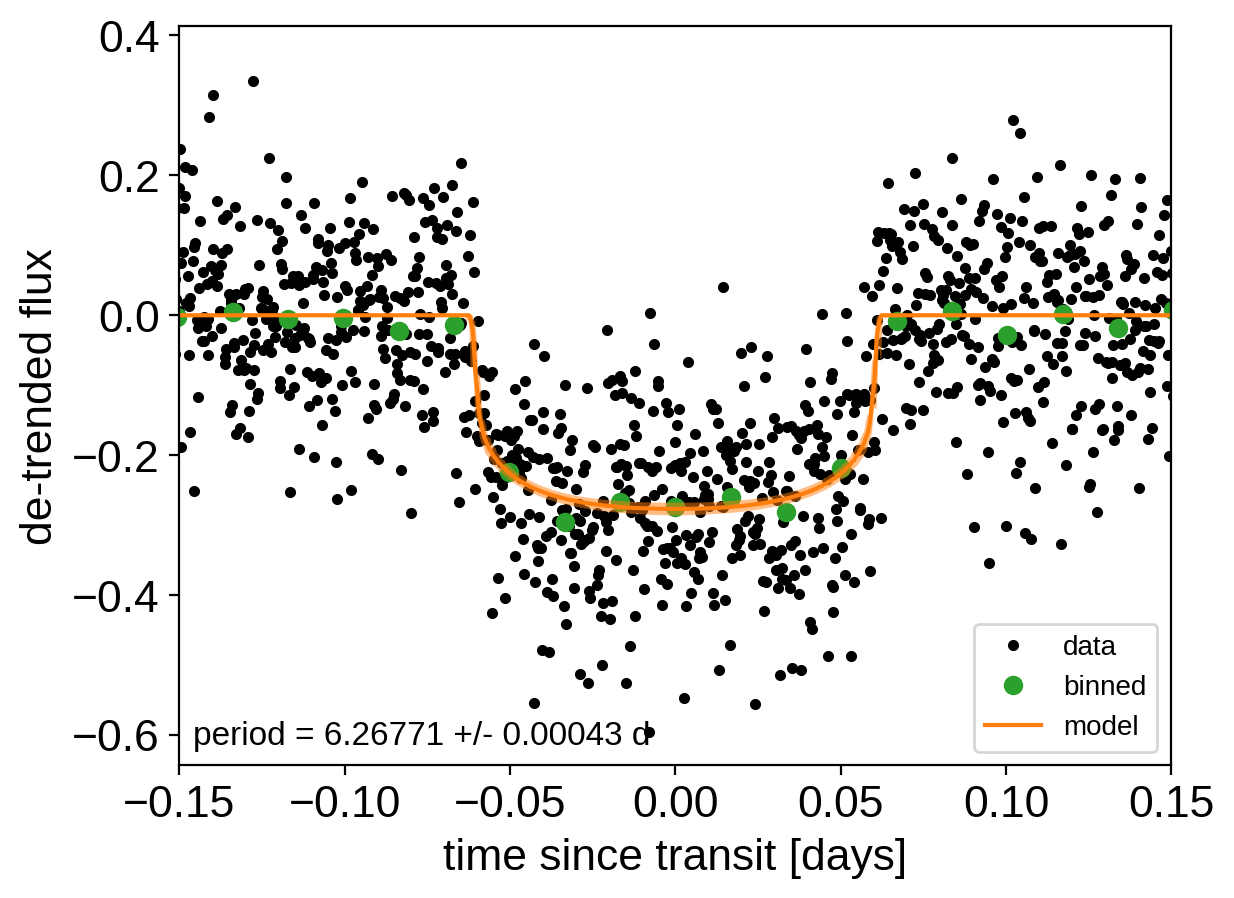

In [16]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned")

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(
    x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"])
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.15, 0.15);

And a corner plot of some of the key parameters:

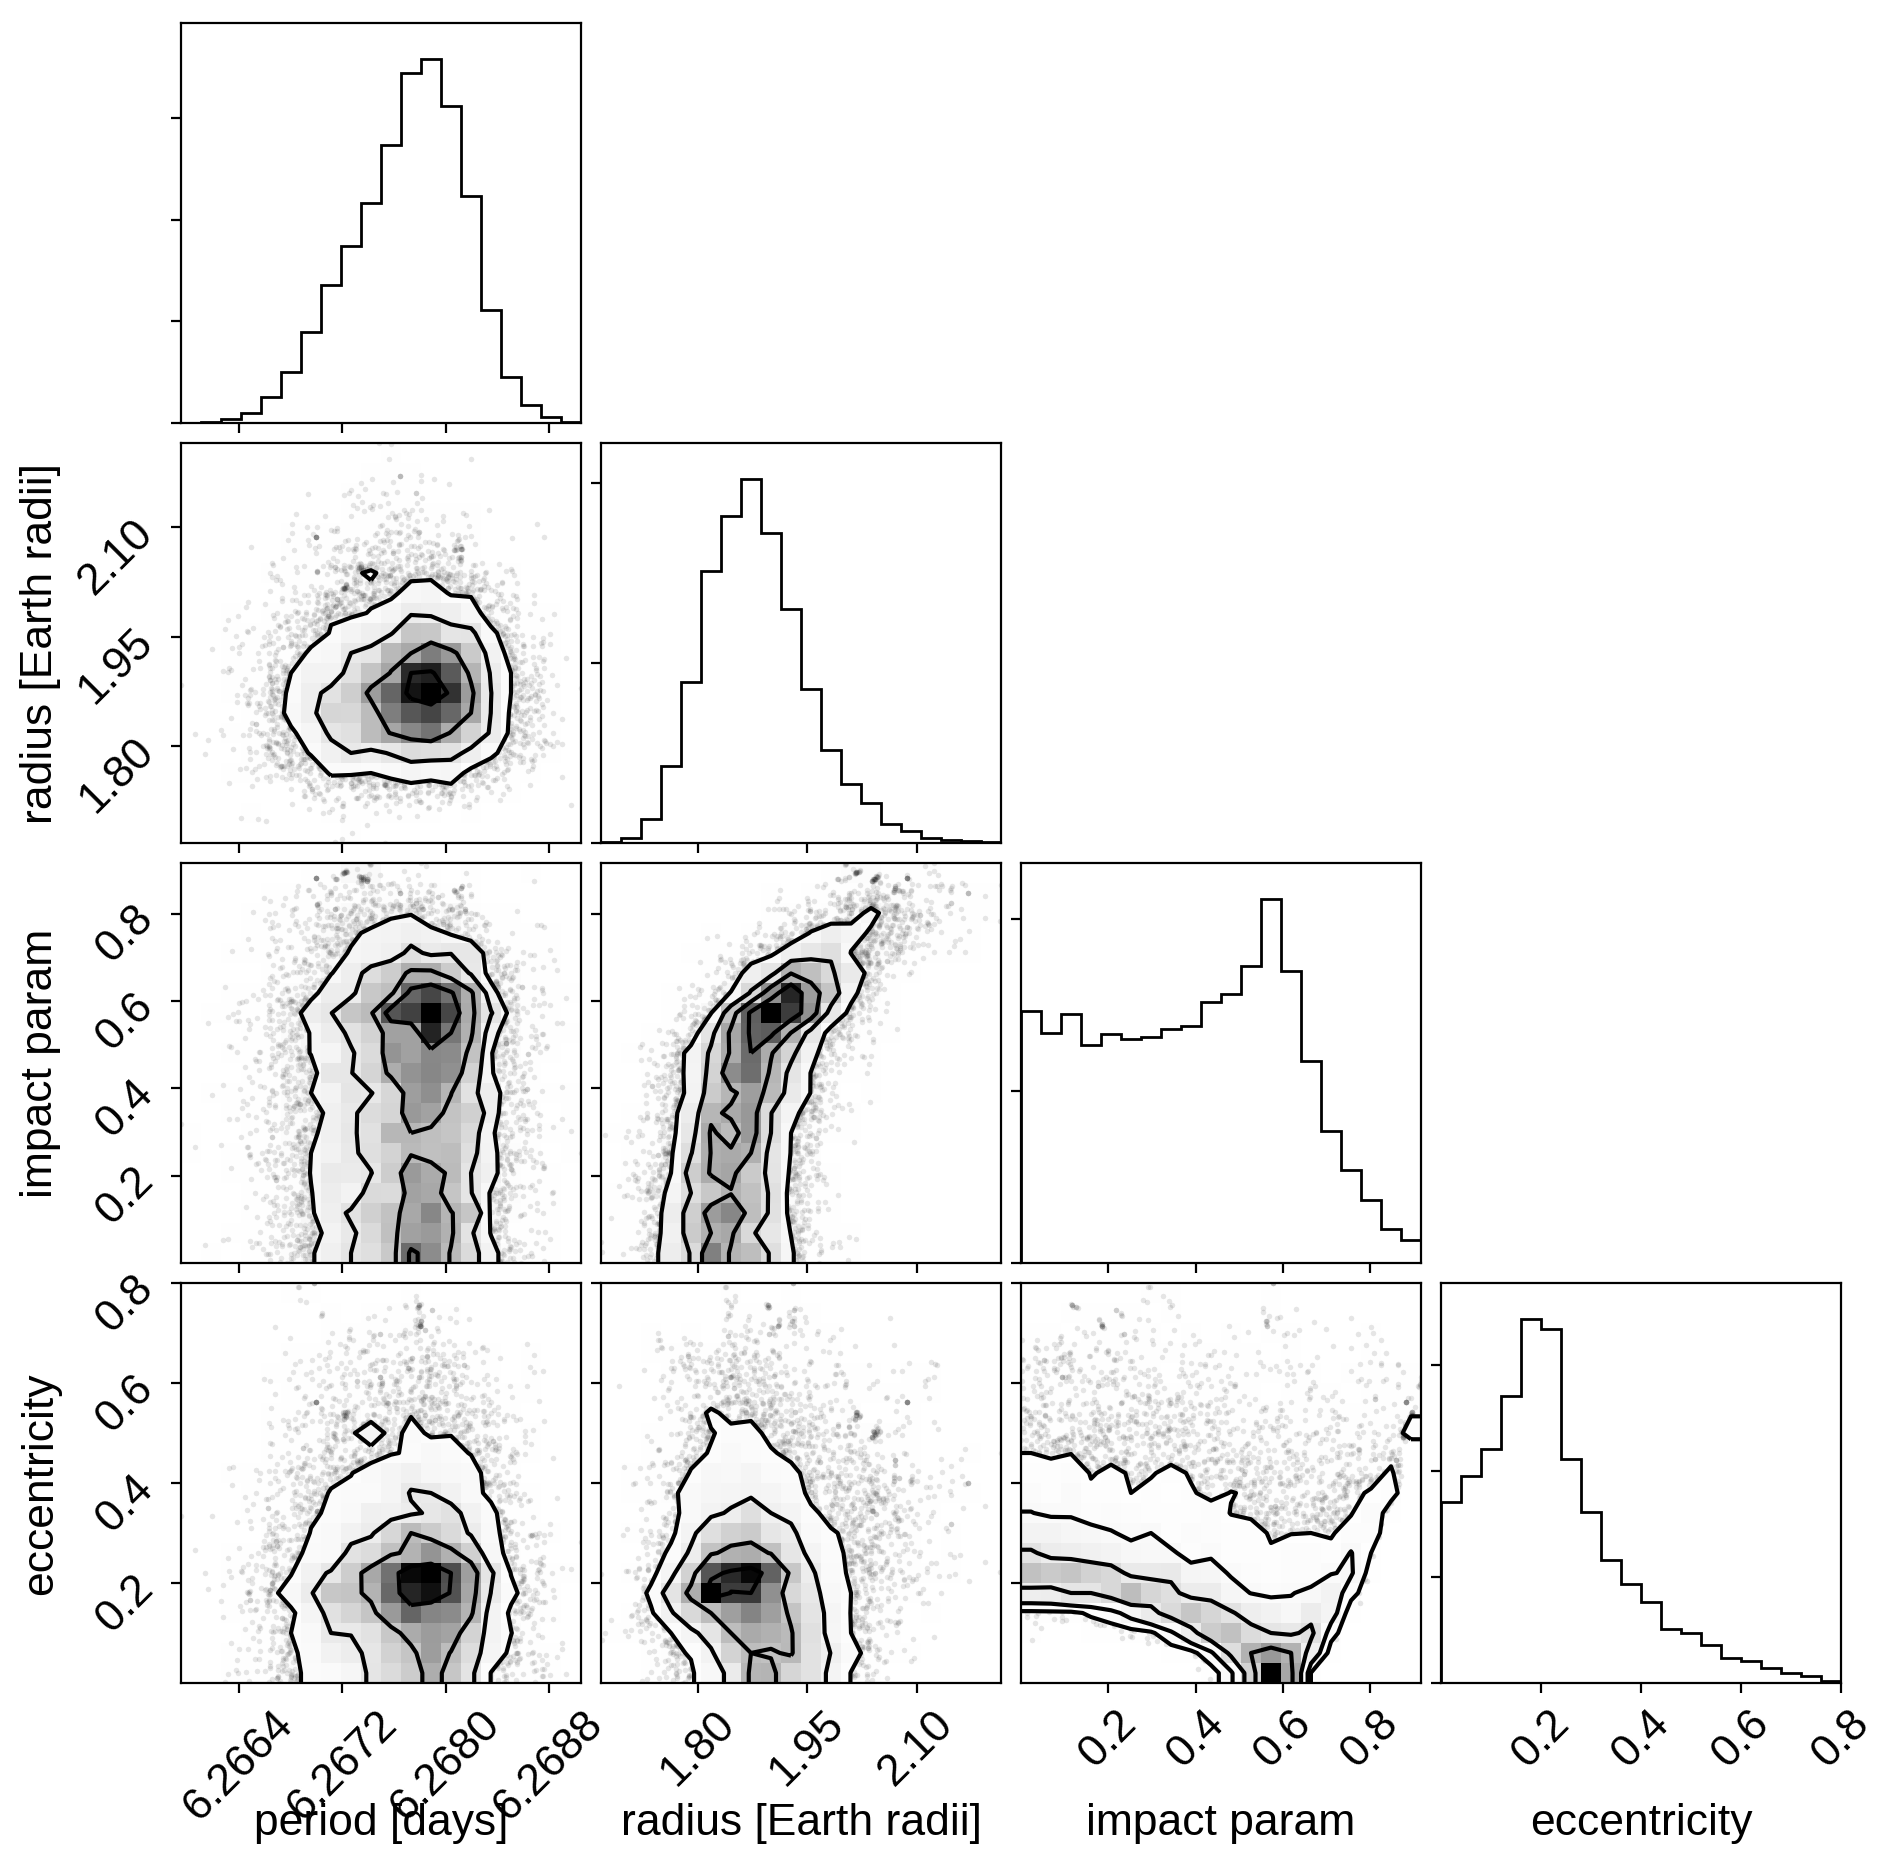

In [17]:
import corner
import astropy.units as u

varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_earth).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Earth radii]", "impact param", "eccentricity"],
);

These all seem consistent with the previously published values and an earlier inconsistency between this radius measurement and the literature has been resolved by fixing a bug in *exoplanet*.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:kipping13b, exoplanet:luger18, exoplanet:pymc3,
exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet v0.2.3},
   month = nov,
    year = 2019,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
